In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, matthews_corrcoef
from imblearn.metrics import geometric_mean_score
from metrics import *
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from dataset import *
from utils import *
from models import *

# 1. cov-abdab

## 1.1 EDA

current：GT 抗体-抗原
- 输入抗原，复现/重构抗体
- diff？

refineGNN
- framework
- CDR H3

current：MEAN
- 输入：离CDR H1~H3最近的48个AA + 轻链 + framework
- 生成：CDR H1/H2/H3

ideal：输入抗原chain（no sturcture） asdsbdjkasdkjsah
- 生成抗体

ideal：输入抗原链
- 找epitope
- 根据epitope设计paratope（CDR）= generation + docking
- 根据CDR完善补全整条抗体链

In [2]:
data = pd.read_csv("../SARS-SAbDab_Shaun/CoV-AbDab_extract.csv")
data

Index      AB_name  Class                              Paratope  \
0        1         m396      0        SYTWGGITILIANYQRDTVMGGSKWDSSDY   
1        2          80R      0  SYAVISYDRDRSYDRVRSNDSTRSGSGSDFTTSRSW   
2        3       F26G19      0                YVSYTTYRYPGNDTTTEGIPQL   
3        4        1AF10      0            NWRENRYDPYYAMDIQHYQQTDSWPT   
4        5          6D3      1                WHEDDYINYEYGLLAQNNFYTY   
..     ...          ...    ...                                   ...   
305    306      scFv_E4      1    VSGVTSSNYYPGGSYRDLSEKDVIQGISYSGQNS   
306    307        N3113      1             YEALEWSYHSRTYNPSWASGSTGDW   
307    308      N3113.1      1                       QWYSRYNPSWASGST   
308    309  RBD-chAb-15      1                       GHWTTWGGSTNGYYV   
309    310       BD-813      1         VEFISANYYSGGSFRLPTYDSISYHDTTP   

                                       Epitope  
0                      FSTFRGDEVRNNGQPTYGVGYQY  
1              RDVGGYNLYLFKGFNCYFLQSYGQPTYGVYQ  
2                         AFSTGDRWNNNPTYGVGYQY  
3    FIVKNKCVFTGVLTDIATDLDITPCSFGGSYQGVNRAGCIG  
4                                  NVFAEHVNNSS  
..                                         ...  
305       RDQTGNDYYLFRKSNYQAGSTFNYFPLQSYGYGVGY  
306         VATRFASYAWNKSKGGNYNYLRITEINGVKFLQS  
307        ATRFASYANKDKVGNYNYLYITEINGVKFPLQSYG  
308                   YASFSTFKRGDRAWNTYGVGYQPY  
309             RDERQTGNDYYLFRKSNYQAGSTFNYQYGY  

[310 rows x 5 columns]

In [3]:
len1 = []
len2 = []

for i in range(data.shape[0]):
    len1.append(len(data["Paratope"].iloc[i]))
    len2.append(len(data["Epitope"].iloc[i]))
    
np.mean(len1), np.std(len1), np.max(len1), np.min(len1)

(24.767741935483873, 7.183600817667714, 60, 2)

In [4]:
np.mean(len2), np.std(len2), np.max(len2), np.min(len2)

(24.738709677419354, 9.685678733502161, 75, 4)

(array([  3.,  14.,  53., 105.,  74.,  47.,  12.,   1.,   0.,   1.]),
 array([ 2. ,  7.8, 13.6, 19.4, 25.2, 31. , 36.8, 42.6, 48.4, 54.2, 60. ]),
 <BarContainer object of 10 artists>)

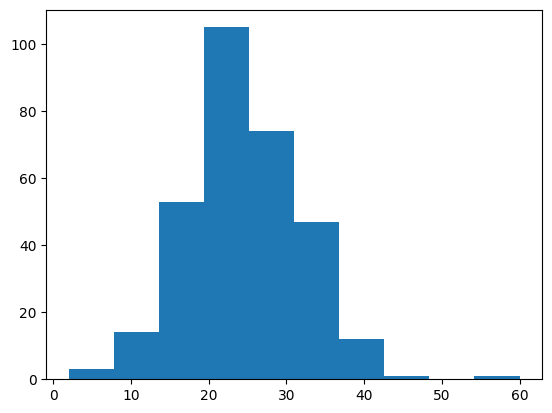

In [5]:
plt.hist(len1)

In [6]:
max(len1)

60

(array([ 21.,  54., 112.,  69.,  36.,  12.,   2.,   1.,   2.,   1.]),
 array([ 4. , 11.1, 18.2, 25.3, 32.4, 39.5, 46.6, 53.7, 60.8, 67.9, 75. ]),
 <BarContainer object of 10 artists>)

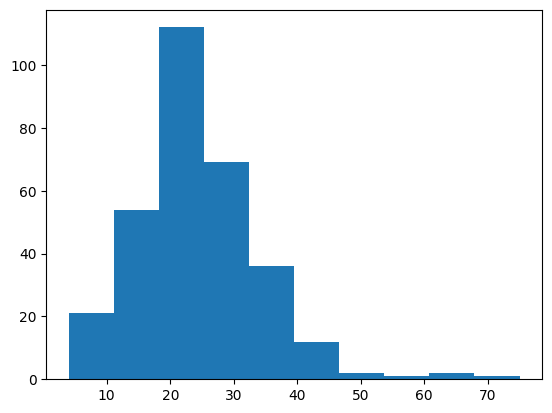

In [7]:
plt.hist(len2)

In [8]:
max(len2)

75

<AxesSubplot:>

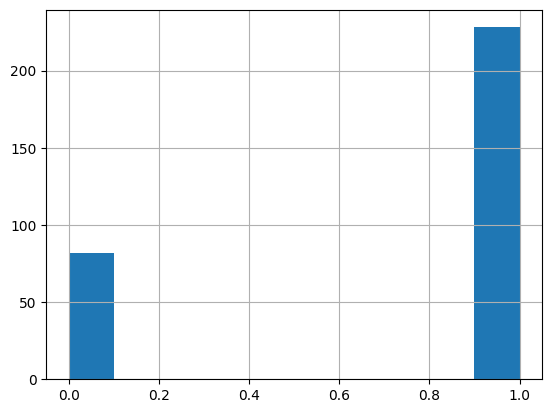

In [9]:
data["Class"].hist()

In [10]:
len(data["Paratope"].unique())

310

In [11]:
len(data["Epitope"].unique())

306

# Fine-tuning

In [73]:
clip_norm = 1

# model name
# model_name = "demo"
# model_name = "masonscnn"
# model_name = "lstm"

# model_name = "InteractTransformer"
# model_name = "InteractCoAttnTransformer"

# model_name = "InteractTransformerLSTM"

# model_name = "SetTransformer"
model_name = "SetCoAttnTransformer"

# model_name = "SetModel"
# model_name = "SetCoAttnModel"
# model_name = "SetModel_ablation"

# model_name = "FTransformer"

# model_name = "EnsembleModel"
# model_name = "PESI"

use_fine_tune = True
# use_fine_tune = False

# fix_FE = True
fix_FE = False

if use_fine_tune==True:
    model_name += "_ft"
    
    use_pair = True
#     use_pair = False

    if use_pair==True:
        model_name += "_pairPreTrain"
        
use_L2 = True
# use_L2 = False

os.makedirs("./results/CoV-AbDab/{}/".format(model_name), exist_ok=True)

print("model name: {}".format(model_name))

kfold_labels = []
kfold_preds = []

for k_iter in range(10):
    
    print("=========================================================")
    print("fold {} as val set".format(k_iter))
    
    train_dataset = SeqDataset(data_path="../SARS-SAbDab_Shaun/CoV-AbDab_extract.csv", \
                               kfold=10, holdout_fold=k_iter, is_train_test_full="train", \
                               use_pair=False, balance_samples=False)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=False, \
                                               collate_fn=my_collate_fn2)

    test_dataset = SeqDataset(data_path="../SARS-SAbDab_Shaun/CoV-AbDab_extract.csv", \
                              kfold=10, holdout_fold=k_iter, is_train_test_full="test", \
                              use_pair=False, balance_samples=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, \
                                               collate_fn=my_collate_fn1)

    if model_name=="demo":
        model = BiLSTM_demo(embed_size=32, hidden=64, num_layers=1, dropout=0.5, use_pretrain=False).cuda()
        
        epochs = 100
        lr = 6e-5
        
    elif model_name=="masonscnn":
        model = MasonsCNN(amino_ft_dim=len(vocab), 
                          max_antibody_len=100, 
                          max_virus_len=100, 
                          h_dim=512, 
                          dropout=0.1).cuda()
        epochs = 100
        lr = 1e-4
        l2_coef = 5e-4
        
    elif model_name=="masonscnn_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/masonscnn/model_best.pth")

        if fix_FE==True:
            for name, param in model.cnnmodule.named_parameters():
                param.requires_grad = False
            for name, param in model.cnnmodule2.named_parameters():
                param.requires_grad = False


        epochs = 500
        lr = 1e-4
        l2_coef = 5e-4
        
    elif model_name=="masonscnn_ft_pairPreTrain":
        
        encoder = torch.load("./results/SAbDab/full/seq1_neg0/masonscnn_encoder/model_best.pth")
        model = TowerBaseModel(embed_size=32, hidden=128, encoder=encoder, 
                               use_two_towers=False, use_coattn=False, fusion=0).cuda()
        
        if fix_FE==True:
            for name, param in model.encoder.named_parameters():
                param.requires_grad = False
        
        epochs = 500
        lr = 1e-4
        l2_coef = 5e-4

    elif model_name=="lstm":
        model = BiLSTM(embed_size=32, 
                       hidden=64, 
                       num_layers=1, 
                       dropout=0.5, 
                       use_pretrain=False).cuda()

        epochs = 300
        lr = 1e-4
        l2_coef = 5e-4

    elif model_name=="lstm_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/lstm/model_best.pth")
        model.train()
        
        if fix_FE==True:
            for name, param in model.LSTM_para.named_parameters():
                param.requires_grad = False
            for name, param in model.LSTM_epi.named_parameters():
                param.requires_grad = False
        
        epochs = 500
        lr = 1e-4
        l2_coef = 5e-4
        
    elif model_name=="lstm_ft_pairPreTrain":

        encoder = torch.load("./results/SAbDab/full/seq1_neg0/lstm_encoder/model_best.pth")
        encoder.train()
        model = TowerBaseModel(embed_size=64, hidden=128, encoder=encoder, 
                               use_two_towers=False, use_coattn=False, fusion=1).cuda()
        
        if fix_FE==True:
            for name, param in model.encoder.named_parameters():
                param.requires_grad = False
        
        epochs = 500
        lr = 1e-4
        l2_coef = 5e-4
    
    elif model_name=="InteractTransformer":
        model = InteractTransformer(embed_size=32, 
                                    num_encoder_layers=1, 
                                    nhead=2, 
                                    dropout=0.3, 
                                    use_coattn=False).cuda()
        epochs = 200
        lr = 3e-5
        
    elif model_name=="InteractTransformer_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/InteractTransformer/model_best.pth")
        model.train()
        
        if fix_FE==True:
            for name, param in model.transformer_para.named_parameters():
                param.requires_grad = False
            for name, param in model.transformer_epi.named_parameters():
                param.requires_grad = False

        epochs = 1000
        lr = 1e-4
        l2_coef = 5e-4
                
    elif model_name=="InteractCoAttnTransformer":
        model = InteractTransformer(embed_size=32, 
                                    num_encoder_layers=1, 
                                    nhead=2, 
                                    dropout=0.5, 
                                    use_coattn=True).cuda()
        epochs = 200
        lr = 3e-5
        
    elif model_name=="InteractCoAttnTransformer_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/InteractCoAttnTransformer/model_best.pth")
        model.train()
    
        if fix_FE==True:
            for name, param in model.transformer_para.named_parameters():
                param.requires_grad = False
            for name, param in model.transformer_epi.named_parameters():
                param.requires_grad = False
        
        epochs = 1500
        lr = 6e-5
        l2_coef = 5e-4
        
    elif model_name=="InteractCoAttnTransformer_ft_pairPreTrain":
        encoder = torch.load("./results/SAbDab/full/seq1_neg0/InteractTransformer_encoder/model_best.pth")
        encoder.train()
        
        model = TowerBaseModel(embed_size=32, hidden=128, encoder=encoder, 
                               use_two_towers=False, use_coattn=True, fusion=1).cuda()
    
        if fix_FE==True:
            for name, param in model.encoder.named_parameters():
                param.requires_grad = False
        
        epochs = 1500
        lr = 6e-5
        l2_coef = 5e-4

    elif model_name=="InteractTransformerLSTM":
        model = InteractTransformerLSTM(embed_size=32, 
                                        hidden=64, 
                                        num_encoder_layers=1, 
                                        num_lstm_layers=1, 
                                        nhead=2, 
                                        dropout=0.5, 
                                        use_coattn=True).cuda()
        epochs = 200
        lr = 6e-5

    elif model_name=="InteractTransformerLSTM_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/InteractTransformerLSTM/model_best.pth")
        model.train()
        
        epochs = 200
        lr = 6e-5
                
    elif model_name=="SetTransformer":
        model = SetTransformer(dim_input=32, 
                               num_outputs=32, 
                               dim_output=32, 
                               dim_hidden=64, 
                               num_inds=6, 
                               num_heads=4, 
                               ln=True, 
                               dropout=0.5, 
                               use_coattn=False, 
                               share=False).cuda()
        
        epochs = 500
        lr = 1e-4
        l2_coef = 5e-4
        
    elif model_name=="SetTransformer_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/SetTransformer/model_best.pth")
        model.train()
        
        if fix_FE==True:
            for name, param in model.para_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.para_dec.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_dec.named_parameters():
                param.requires_grad = False
        
        epochs = 500
        lr = 1e-4
        l2_coef = 5e-4
        
    elif model_name=="SetCoAttnTransformer":
        model = SetTransformer(dim_input=32, 
                               num_outputs=32, 
                               dim_output=32, 
                               dim_hidden=64, 
                               num_inds=6, 
                               num_heads=4, 
                               ln=True, 
                               dropout=0.5, 
                               use_coattn=True).cuda()
        epochs = 500
        lr = 6e-5
        l2_coef = 5e-4
        
    elif model_name=="SetCoAttnTransformer_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/SetCoAttnTransformer/model_best.pth")
        model.train()
        
        if fix_FE==True:
            for name, param in model.para_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.para_dec.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_dec.named_parameters():
                param.requires_grad = False
        
        epochs = 500
        lr = 3e-5
        l2_coef = 6e-4
        
    elif model_name=="SetCoAttnTransformer_ft_pairPreTrain":
        
        encoder = torch.load("./results/SAbDab/full/seq1_neg0/SetTransformer_encoder/model_best.pth")
        encoder.train()
        model = TowerBaseModel(embed_size=32, hidden=128, encoder=encoder, use_two_towers=False, mid_coattn=True, use_coattn=True, fusion=1).cuda()
        
        if fix_FE==True:
            for name, param in model.encoder.named_parameters():
                param.requires_grad = False
        
        epochs = 1500
        lr = 1e-4 #6e-5
        l2_coef = 3e-4 #5e-4
        
        
    elif model_name=="SetModel":
        model = SetModel(embed_size=32, 
                         hidden=64, 
                         num_layers=1, 
                         dropout=0.3, 
                         k4kmer=3, 
                         use_pretrain=False, 
                         use_coattn=False, 
                         seq_encoder_type="transformer", 
                         num_heads=2, 
                         num_inds=6, 
                         num_outputs=6, 
                         ln=True).cuda()
        
        epochs = 200
        lr = 3e-5
        l2_coef = 5e-4
        
    elif model_name=="SetModel_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/SetModel/model_best.pth")
        model.train()
        
        if fix_FE==True:
            for name, param in model.para_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.para_dec.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_dec.named_parameters():
                param.requires_grad = False
        
        epochs = 200
        lr = 3e-5
        l2_coef = 5e-4
    
    elif model_name=="SetCoAttnModel":
        model = SetModel(embed_size=32, 
                         hidden=64, 
                         num_layers=1, 
                         dropout=0.3, 
                         k4kmer=3, 
                         use_pretrain=False, 
                         use_coattn=True, 
                         seq_encoder_type="transformer", 
                         num_heads=2, 
                         num_inds=6, 
                         num_outputs=6, 
                         ln=True).cuda()
        epochs = 200
        lr = 3e-5
    
    elif model_name=="SetCoAttnModel_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/SetCoAttnModel/model_best.pth")
        model.train()
        
        if fix_FE==True:
            for name, param in model.para_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.para_dec.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_dec.named_parameters():
                param.requires_grad = False
        
        epochs = 200
        lr = 3e-5
        l2_coef = 5e-4
        
    elif model_name=="SetModel_ablation":
        model = SetModel_ablation(embed_size=32, 
                         hidden=64, 
                         num_layers=2, 
                         dropout=0.5, 
                         k4kmer=7, 
                         use_pretrain=False, 
                         use_coattn=False, 
                         use_kmer_embed=True, 
                         use_seq_encoder=False, 
                         seq_encoder_type="lstm", 
                         num_heads=4, 
                         num_inds=6, 
                         num_outputs=6, 
                         ln=True).cuda()
        epochs = 150
        lr = 6e-5
        
    elif model_name=="FTransformer":
        model = FTransformer(embed_size=32, 
                             hidden=64, 
                             num_layers=2, 
                             dropout=0.5, 
                             k4kmer=3, 
                             use_pretrain=False, 
                             use_coattn=True, 
                             seq_encoder_type="transformer", 
                             num_heads=2).cuda()
        
        epochs = 100
        lr = 3e-5
        
    elif model_name=="EnsembleModel":
        model = EnsembleModel(embed_size=16, 
                      hidden=64, 
                      max_len=100, 
                      num_encoder_layers=1, 
                      num_heads=2, 
                      num_inds=6, 
                      num_outputs=6, 
                      ln=True, 
                      dropout=0.5, 
                      use_coattn=True).cuda()
        
        epochs = 500
        lr = 1e-5
        
    elif model_name=="EnsembleModel_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/EnsembleModel/model_best.pth")
        model.train()
        
        epochs = 500
        lr = 1e-4
        
    elif model_name=="PESI":
#         model = PESI(embed_size=7, 
#                      hidden=512, 
#                      max_len=100, 
#                      num_heads=2, 
#                      num_inds=6, 
#                      num_outputs=6, 
#                      ln=True, 
#                      dropout=0.5, 
#                      use_coattn=True).cuda()
        model = PESI(embed_size=8, 
                     hidden=64, 
                     max_len=100, 
                     num_heads=2, 
                     num_inds=6, 
                     num_outputs=6, 
                     ln=True, 
                     dropout=0.5, 
                     use_coattn=True).cuda()
        
        epochs = 200
        lr = 5e-5
#         wd = 3e-4
        l2_coef = 5e-4
        
    elif model_name=="PESI_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/PESI/model_best.pth")
        model.train()
        
        # freeze frame feature extractor
        for name, param in model.Frame_para.named_parameters():
            param.requires_grad = False
        for name, param in model.Frame_epi.named_parameters():
            param.requires_grad = False
            
        # freeze frame feature extractor        
        for name, param in model.Set_para.named_parameters():
            param.requires_grad = False
        for name, param in model.Set_epi.named_parameters():
            param.requires_grad = False
        
        epochs = 500
        lr = 3e-5
        l2_coef = 5e-4

    else:
        print("wrong model name!!!")
        break

    print("model parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)#, weight_decay=wd)
    # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-6, last_epoch=-1)

    loss_buf = []
    val_loss_buf = []
    val_acc_buf = []
    val_f1_buf = []
    val_auc_buf = []
    val_gmean_buf = []
    val_mcc_buf = []
    best_val_loss = float("inf")
    
    for epoch in range(epochs):

        loss_tmp = []
        for i, (para, epi, label) in enumerate(tqdm(train_loader)):
            optimizer.zero_grad()

            pred = model(para, epi)

            loss = criterion(pred.view(-1), label.view(-1).cuda())
            
            if use_L2==True:
                param_l2_loss = 0
                for name, param in model.named_parameters():
                    if 'bias' not in name:
                        param_l2_loss += torch.norm(param, p=2)
                param_l2_loss = l2_coef * param_l2_loss
                loss += param_l2_loss

            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)

            optimizer.step()

            loss_tmp.append(loss.item())
        
        loss_buf.append(np.mean(loss_tmp))

    #     scheduler.step()
        print("lr: ", optimizer.param_groups[0]['lr'])

        with torch.no_grad():

            model.eval()

            preds = []
            labels = []
            val_loss_tmp = []
            for i, (para, epi, label) in enumerate(test_loader):

                pred = model(para, epi)
                val_loss = criterion(pred.view(-1), label.view(-1).cuda())

                preds.append(pred.detach().cpu().view(-1))
                labels.append(label.view(-1))
                val_loss_tmp.append(val_loss.item())
            
            preds = torch.stack(preds, axis=1).view(-1)
            labels = torch.stack(labels, axis=1).view(-1)

#             acc = accuracy_score(y_true=labels, y_pred=torch.round(preds))
#             f1 = f1_score(y_true=labels, y_pred=torch.round(preds))
#             auc = roc_auc_score(y_true=labels, y_score=preds)

            acc, f1, auc, gmean, mcc = evaluate_metrics(pred_proba=preds, label=labels)

            val_acc_buf.append(acc)
            val_f1_buf.append(f1)
            val_auc_buf.append(auc)
            val_gmean_buf.append(gmean)
            val_mcc_buf.append(mcc)
            val_loss_buf.append(np.mean(val_loss_tmp))

            print("Epoch {}: \n Train Loss\t{:.4f} \n Val Loss\t{:.4f} \n Val Acc\t{:.4f} \n Val F1\t\t{:.4f} \n Val AUC\t{:.4f} \n Val GMean\t{:.4f} \n Val MCC\t{:.4f}".format(epoch, np.mean(loss_buf), np.mean(val_loss_buf), acc, f1, auc, gmean, mcc))
            
            if np.mean(val_loss_tmp)<best_val_loss:
                best_val_loss = np.mean(val_loss_tmp)
                torch.save(model, "./results/CoV-AbDab/{}/model_{}_best.pth".format(model_name, k_iter))
                np.save("./results/CoV-AbDab/{}/val_acc_{}_best.npy".format(model_name, k_iter), acc)
                np.save("./results/CoV-AbDab/{}/val_f1_{}_best.npy".format(model_name, k_iter), f1)
                np.save("./results/CoV-AbDab/{}/val_auc_{}_best.npy".format(model_name, k_iter), auc)
                np.save("./results/CoV-AbDab/{}/val_gmean_{}_best.npy".format(model_name, k_iter), gmean)
                np.save("./results/CoV-AbDab/{}/val_mcc_{}_best.npy".format(model_name, k_iter), mcc)

        model.train()
    
    torch.save(model, "./results/CoV-AbDab/{}/model_{}.pth".format(model_name, k_iter))
    np.save("./results/CoV-AbDab/{}/loss_buf_{}.npy".format(model_name, k_iter), np.array(loss_buf))
    np.save("./results/CoV-AbDab/{}/val_loss_buf_{}.npy".format(model_name, k_iter), np.array(val_loss_buf))
    np.save("./results/CoV-AbDab/{}/val_acc_buf_{}.npy".format(model_name, k_iter), np.array(val_acc_buf))
    np.save("./results/CoV-AbDab/{}/val_f1_buf_{}.npy".format(model_name, k_iter), np.array(val_f1_buf))
    np.save("./results/CoV-AbDab/{}/val_auc_buf_{}.npy".format(model_name, k_iter), np.array(val_auc_buf))
    np.save("./results/CoV-AbDab/{}/val_gmean_buf_{}.npy".format(model_name, k_iter), np.array(val_gmean_buf))
    np.save("./results/CoV-AbDab/{}/val_mcc_buf_{}.npy".format(model_name, k_iter), np.array(val_mcc_buf))
    
    
    kfold_labels.append(labels)
    kfold_preds.append(preds)
    
#     break

model name: SetCoAttnTransformer_ft_pairPreTrain
fold 0 as val set
model parameters:  490305


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.50it/s]


lr:  0.0001
Epoch 0: 
 Train Loss	0.8170 
 Val Loss	0.7262 
 Val Acc	0.3226 
 Val F1		0.0000 
 Val AUC	0.6095 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.45it/s]


lr:  0.0001
Epoch 1: 
 Train Loss	0.8158 
 Val Loss	0.7258 
 Val Acc	0.3226 
 Val F1		0.0000 
 Val AUC	0.5976 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.85it/s]


lr:  0.0001
Epoch 2: 
 Train Loss	0.8147 
 Val Loss	0.7253 
 Val Acc	0.3226 
 Val F1		0.0000 
 Val AUC	0.5548 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.86it/s]


lr:  0.0001
Epoch 3: 
 Train Loss	0.8133 
 Val Loss	0.7248 
 Val Acc	0.3226 
 Val F1		0.0000 
 Val AUC	0.5048 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.30it/s]


lr:  0.0001
Epoch 4: 
 Train Loss	0.8118 
 Val Loss	0.7242 
 Val Acc	0.3226 
 Val F1		0.0000 
 Val AUC	0.4524 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.94it/s]


lr:  0.0001
Epoch 5: 
 Train Loss	0.8104 
 Val Loss	0.7234 
 Val Acc	0.3226 
 Val F1		0.0000 
 Val AUC	0.4452 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.61it/s]


lr:  0.0001
Epoch 6: 
 Train Loss	0.8088 
 Val Loss	0.7227 
 Val Acc	0.3226 
 Val F1		0.0000 
 Val AUC	0.4452 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.43it/s]


lr:  0.0001
Epoch 7: 
 Train Loss	0.8072 
 Val Loss	0.7219 
 Val Acc	0.3226 
 Val F1		0.0000 
 Val AUC	0.4024 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.60it/s]


lr:  0.0001
Epoch 8: 
 Train Loss	0.8057 
 Val Loss	0.7211 
 Val Acc	0.3226 
 Val F1		0.0000 
 Val AUC	0.3476 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.62it/s]


lr:  0.0001
Epoch 9: 
 Train Loss	0.8041 
 Val Loss	0.7203 
 Val Acc	0.3226 
 Val F1		0.0000 
 Val AUC	0.2810 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.43it/s]


lr:  0.0001
Epoch 10: 
 Train Loss	0.8025 
 Val Loss	0.7194 
 Val Acc	0.3226 
 Val F1		0.0000 
 Val AUC	0.3214 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.97it/s]


lr:  0.0001
Epoch 11: 
 Train Loss	0.8009 
 Val Loss	0.7186 
 Val Acc	0.3226 
 Val F1		0.0000 
 Val AUC	0.2714 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.62it/s]


lr:  0.0001
Epoch 12: 
 Train Loss	0.7994 
 Val Loss	0.7178 
 Val Acc	0.3226 
 Val F1		0.0000 
 Val AUC	0.2857 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.16it/s]


lr:  0.0001
Epoch 13: 
 Train Loss	0.7978 
 Val Loss	0.7169 
 Val Acc	0.3226 
 Val F1		0.0000 
 Val AUC	0.5881 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.45it/s]


lr:  0.0001
Epoch 14: 
 Train Loss	0.7963 
 Val Loss	0.7160 
 Val Acc	0.3226 
 Val F1		0.0000 
 Val AUC	0.6048 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.26it/s]


lr:  0.0001
Epoch 15: 
 Train Loss	0.7946 
 Val Loss	0.7152 
 Val Acc	0.3226 
 Val F1		0.0000 
 Val AUC	0.4762 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.38it/s]


lr:  0.0001
Epoch 16: 
 Train Loss	0.7930 
 Val Loss	0.7143 
 Val Acc	0.3226 
 Val F1		0.0000 
 Val AUC	0.5024 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.51it/s]


lr:  0.0001
Epoch 17: 
 Train Loss	0.7914 
 Val Loss	0.7134 
 Val Acc	0.3226 
 Val F1		0.0000 
 Val AUC	0.3976 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.92it/s]


lr:  0.0001
Epoch 18: 
 Train Loss	0.7898 
 Val Loss	0.7124 
 Val Acc	0.3226 
 Val F1		0.0000 
 Val AUC	0.5952 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.47it/s]


lr:  0.0001
Epoch 19: 
 Train Loss	0.7881 
 Val Loss	0.7115 
 Val Acc	0.3226 
 Val F1		0.0000 
 Val AUC	0.5905 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.05it/s]


lr:  0.0001
Epoch 20: 
 Train Loss	0.7865 
 Val Loss	0.7106 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.19it/s]


lr:  0.0001
Epoch 21: 
 Train Loss	0.7849 
 Val Loss	0.7097 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.69it/s]


lr:  0.0001
Epoch 22: 
 Train Loss	0.7832 
 Val Loss	0.7087 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.51it/s]


lr:  0.0001
Epoch 23: 
 Train Loss	0.7816 
 Val Loss	0.7078 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.63it/s]


lr:  0.0001
Epoch 24: 
 Train Loss	0.7799 
 Val Loss	0.7069 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.30it/s]


lr:  0.0001
Epoch 25: 
 Train Loss	0.7782 
 Val Loss	0.7060 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.82it/s]


lr:  0.0001
Epoch 26: 
 Train Loss	0.7766 
 Val Loss	0.7051 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.92it/s]


lr:  0.0001
Epoch 27: 
 Train Loss	0.7750 
 Val Loss	0.7042 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.50it/s]


lr:  0.0001
Epoch 28: 
 Train Loss	0.7734 
 Val Loss	0.7033 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.40it/s]


lr:  0.0001
Epoch 29: 
 Train Loss	0.7718 
 Val Loss	0.7024 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5024 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.66it/s]


lr:  0.0001
Epoch 30: 
 Train Loss	0.7702 
 Val Loss	0.7015 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.86it/s]


lr:  0.0001
Epoch 31: 
 Train Loss	0.7686 
 Val Loss	0.7007 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.57it/s]


lr:  0.0001
Epoch 32: 
 Train Loss	0.7670 
 Val Loss	0.6998 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.26it/s]


lr:  0.0001
Epoch 33: 
 Train Loss	0.7655 
 Val Loss	0.6989 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.27it/s]


lr:  0.0001
Epoch 34: 
 Train Loss	0.7639 
 Val Loss	0.6981 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.30it/s]


lr:  0.0001
Epoch 35: 
 Train Loss	0.7624 
 Val Loss	0.6972 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.53it/s]


lr:  0.0001
Epoch 36: 
 Train Loss	0.7608 
 Val Loss	0.6964 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.57it/s]


lr:  0.0001
Epoch 37: 
 Train Loss	0.7593 
 Val Loss	0.6955 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.42it/s]


lr:  0.0001
Epoch 38: 
 Train Loss	0.7578 
 Val Loss	0.6947 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.08it/s]


lr:  0.0001
Epoch 39: 
 Train Loss	0.7563 
 Val Loss	0.6939 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.74it/s]


lr:  0.0001
Epoch 40: 
 Train Loss	0.7548 
 Val Loss	0.6931 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.41it/s]


lr:  0.0001
Epoch 41: 
 Train Loss	0.7533 
 Val Loss	0.6923 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.78it/s]


lr:  0.0001
Epoch 42: 
 Train Loss	0.7519 
 Val Loss	0.6915 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.89it/s]


lr:  0.0001
Epoch 43: 
 Train Loss	0.7504 
 Val Loss	0.6907 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.24it/s]


lr:  0.0001
Epoch 44: 
 Train Loss	0.7490 
 Val Loss	0.6899 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  0.0001
Epoch 45: 
 Train Loss	0.7476 
 Val Loss	0.6891 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.83it/s]


lr:  0.0001
Epoch 46: 
 Train Loss	0.7462 
 Val Loss	0.6884 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.88it/s]


lr:  0.0001
Epoch 47: 
 Train Loss	0.7448 
 Val Loss	0.6876 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.05it/s]


lr:  0.0001
Epoch 48: 
 Train Loss	0.7434 
 Val Loss	0.6869 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.49it/s]


lr:  0.0001
Epoch 49: 
 Train Loss	0.7420 
 Val Loss	0.6861 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.64it/s]


lr:  0.0001
Epoch 50: 
 Train Loss	0.7407 
 Val Loss	0.6854 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.85it/s]


lr:  0.0001
Epoch 51: 
 Train Loss	0.7394 
 Val Loss	0.6847 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.90it/s]


lr:  0.0001
Epoch 52: 
 Train Loss	0.7380 
 Val Loss	0.6840 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.13it/s]


lr:  0.0001
Epoch 53: 
 Train Loss	0.7367 
 Val Loss	0.6833 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.58it/s]


lr:  0.0001
Epoch 54: 
 Train Loss	0.7354 
 Val Loss	0.6826 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.37it/s]


lr:  0.0001
Epoch 55: 
 Train Loss	0.7341 
 Val Loss	0.6819 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.56it/s]


lr:  0.0001
Epoch 56: 
 Train Loss	0.7328 
 Val Loss	0.6812 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.08it/s]


lr:  0.0001
Epoch 57: 
 Train Loss	0.7316 
 Val Loss	0.6805 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.57it/s]


lr:  0.0001
Epoch 58: 
 Train Loss	0.7303 
 Val Loss	0.6799 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.16it/s]


lr:  0.0001
Epoch 59: 
 Train Loss	0.7291 
 Val Loss	0.6792 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.58it/s]


lr:  0.0001
Epoch 60: 
 Train Loss	0.7278 
 Val Loss	0.6786 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.26it/s]


lr:  0.0001
Epoch 61: 
 Train Loss	0.7267 
 Val Loss	0.6779 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.76it/s]


lr:  0.0001
Epoch 62: 
 Train Loss	0.7254 
 Val Loss	0.6773 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.74it/s]


lr:  0.0001
Epoch 63: 
 Train Loss	0.7242 
 Val Loss	0.6767 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.64it/s]


lr:  0.0001
Epoch 64: 
 Train Loss	0.7230 
 Val Loss	0.6761 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.59it/s]


lr:  0.0001
Epoch 65: 
 Train Loss	0.7219 
 Val Loss	0.6755 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.34it/s]


lr:  0.0001
Epoch 66: 
 Train Loss	0.7208 
 Val Loss	0.6749 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.96it/s]


lr:  0.0001
Epoch 67: 
 Train Loss	0.7196 
 Val Loss	0.6743 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.52it/s]


lr:  0.0001
Epoch 68: 
 Train Loss	0.7185 
 Val Loss	0.6738 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.57it/s]


lr:  0.0001
Epoch 69: 
 Train Loss	0.7174 
 Val Loss	0.6732 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.81it/s]


lr:  0.0001
Epoch 70: 
 Train Loss	0.7163 
 Val Loss	0.6726 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.72it/s]


lr:  0.0001
Epoch 71: 
 Train Loss	0.7152 
 Val Loss	0.6721 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.39it/s]


lr:  0.0001
Epoch 72: 
 Train Loss	0.7142 
 Val Loss	0.6716 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.81it/s]


lr:  0.0001
Epoch 73: 
 Train Loss	0.7131 
 Val Loss	0.6710 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.19it/s]


lr:  0.0001
Epoch 74: 
 Train Loss	0.7121 
 Val Loss	0.6705 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.82it/s]


lr:  0.0001
Epoch 75: 
 Train Loss	0.7111 
 Val Loss	0.6700 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.00it/s]


lr:  0.0001
Epoch 76: 
 Train Loss	0.7100 
 Val Loss	0.6695 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.14it/s]


lr:  0.0001
Epoch 77: 
 Train Loss	0.7091 
 Val Loss	0.6690 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.42it/s]


lr:  0.0001
Epoch 78: 
 Train Loss	0.7081 
 Val Loss	0.6686 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.10it/s]


lr:  0.0001
Epoch 79: 
 Train Loss	0.7071 
 Val Loss	0.6681 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.46it/s]


lr:  0.0001
Epoch 80: 
 Train Loss	0.7062 
 Val Loss	0.6676 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.86it/s]


lr:  0.0001
Epoch 81: 
 Train Loss	0.7052 
 Val Loss	0.6672 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.23it/s]


lr:  0.0001
Epoch 82: 
 Train Loss	0.7043 
 Val Loss	0.6667 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.50it/s]


lr:  0.0001
Epoch 83: 
 Train Loss	0.7034 
 Val Loss	0.6663 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.61it/s]


lr:  0.0001
Epoch 84: 
 Train Loss	0.7024 
 Val Loss	0.6659 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.55it/s]


lr:  0.0001
Epoch 85: 
 Train Loss	0.7015 
 Val Loss	0.6654 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.22it/s]


lr:  0.0001
Epoch 86: 
 Train Loss	0.7006 
 Val Loss	0.6650 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.72it/s]


lr:  0.0001
Epoch 87: 
 Train Loss	0.6997 
 Val Loss	0.6646 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.16it/s]


lr:  0.0001
Epoch 88: 
 Train Loss	0.6989 
 Val Loss	0.6642 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.62it/s]


lr:  0.0001
Epoch 89: 
 Train Loss	0.6980 
 Val Loss	0.6638 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.35it/s]


lr:  0.0001
Epoch 90: 
 Train Loss	0.6972 
 Val Loss	0.6635 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.95it/s]


lr:  0.0001
Epoch 91: 
 Train Loss	0.6964 
 Val Loss	0.6631 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.71it/s]


lr:  0.0001
Epoch 92: 
 Train Loss	0.6956 
 Val Loss	0.6627 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.15it/s]


lr:  0.0001
Epoch 93: 
 Train Loss	0.6948 
 Val Loss	0.6623 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.64it/s]


lr:  0.0001
Epoch 94: 
 Train Loss	0.6940 
 Val Loss	0.6620 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.71it/s]


lr:  0.0001
Epoch 95: 
 Train Loss	0.6932 
 Val Loss	0.6616 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.95it/s]


lr:  0.0001
Epoch 96: 
 Train Loss	0.6925 
 Val Loss	0.6613 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.33it/s]


lr:  0.0001
Epoch 97: 
 Train Loss	0.6917 
 Val Loss	0.6610 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.83it/s]


lr:  0.0001
Epoch 98: 
 Train Loss	0.6909 
 Val Loss	0.6607 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.78it/s]


lr:  0.0001
Epoch 99: 
 Train Loss	0.6902 
 Val Loss	0.6603 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.91it/s]


lr:  0.0001
Epoch 100: 
 Train Loss	0.6895 
 Val Loss	0.6600 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  0.0001
Epoch 101: 
 Train Loss	0.6887 
 Val Loss	0.6597 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.20it/s]


lr:  0.0001
Epoch 102: 
 Train Loss	0.6880 
 Val Loss	0.6594 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.77it/s]


lr:  0.0001
Epoch 103: 
 Train Loss	0.6873 
 Val Loss	0.6591 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.72it/s]


lr:  0.0001
Epoch 104: 
 Train Loss	0.6866 
 Val Loss	0.6588 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.08it/s]


lr:  0.0001
Epoch 105: 
 Train Loss	0.6860 
 Val Loss	0.6586 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.49it/s]


lr:  0.0001
Epoch 106: 
 Train Loss	0.6853 
 Val Loss	0.6583 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.94it/s]


lr:  0.0001
Epoch 107: 
 Train Loss	0.6847 
 Val Loss	0.6580 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.55it/s]


lr:  0.0001
Epoch 108: 
 Train Loss	0.6840 
 Val Loss	0.6578 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.41it/s]


lr:  0.0001
Epoch 109: 
 Train Loss	0.6834 
 Val Loss	0.6575 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.74it/s]


lr:  0.0001
Epoch 110: 
 Train Loss	0.6828 
 Val Loss	0.6572 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.49it/s]


lr:  0.0001
Epoch 111: 
 Train Loss	0.6822 
 Val Loss	0.6570 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.35it/s]


lr:  0.0001
Epoch 112: 
 Train Loss	0.6815 
 Val Loss	0.6568 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.16it/s]


lr:  0.0001
Epoch 113: 
 Train Loss	0.6809 
 Val Loss	0.6565 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.61it/s]


lr:  0.0001
Epoch 114: 
 Train Loss	0.6803 
 Val Loss	0.6563 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.53it/s]


lr:  0.0001
Epoch 115: 
 Train Loss	0.6798 
 Val Loss	0.6561 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.12it/s]


lr:  0.0001
Epoch 116: 
 Train Loss	0.6792 
 Val Loss	0.6558 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.83it/s]


lr:  0.0001
Epoch 117: 
 Train Loss	0.6786 
 Val Loss	0.6556 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.56it/s]


lr:  0.0001
Epoch 118: 
 Train Loss	0.6780 
 Val Loss	0.6554 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.75it/s]


lr:  0.0001
Epoch 119: 
 Train Loss	0.6774 
 Val Loss	0.6552 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.04it/s]


lr:  0.0001
Epoch 120: 
 Train Loss	0.6769 
 Val Loss	0.6550 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.27it/s]


lr:  0.0001
Epoch 121: 
 Train Loss	0.6763 
 Val Loss	0.6548 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.63it/s]


lr:  0.0001
Epoch 122: 
 Train Loss	0.6758 
 Val Loss	0.6546 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.79it/s]


lr:  0.0001
Epoch 123: 
 Train Loss	0.6753 
 Val Loss	0.6544 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.38it/s]


lr:  0.0001
Epoch 124: 
 Train Loss	0.6748 
 Val Loss	0.6542 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.76it/s]


lr:  0.0001
Epoch 125: 
 Train Loss	0.6742 
 Val Loss	0.6540 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.93it/s]


lr:  0.0001
Epoch 126: 
 Train Loss	0.6736 
 Val Loss	0.6539 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.70it/s]


lr:  0.0001
Epoch 127: 
 Train Loss	0.6731 
 Val Loss	0.6537 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.56it/s]


lr:  0.0001
Epoch 128: 
 Train Loss	0.6727 
 Val Loss	0.6535 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.78it/s]


lr:  0.0001
Epoch 129: 
 Train Loss	0.6722 
 Val Loss	0.6533 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  0.0001
Epoch 130: 
 Train Loss	0.6717 
 Val Loss	0.6532 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.27it/s]


lr:  0.0001
Epoch 131: 
 Train Loss	0.6712 
 Val Loss	0.6530 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.16it/s]


lr:  0.0001
Epoch 132: 
 Train Loss	0.6707 
 Val Loss	0.6528 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.88it/s]


lr:  0.0001
Epoch 133: 
 Train Loss	0.6703 
 Val Loss	0.6527 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.81it/s]


lr:  0.0001
Epoch 134: 
 Train Loss	0.6698 
 Val Loss	0.6525 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.60it/s]


lr:  0.0001
Epoch 135: 
 Train Loss	0.6694 
 Val Loss	0.6524 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.95it/s]


lr:  0.0001
Epoch 136: 
 Train Loss	0.6689 
 Val Loss	0.6522 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.41it/s]


lr:  0.0001
Epoch 137: 
 Train Loss	0.6684 
 Val Loss	0.6521 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.87it/s]


lr:  0.0001
Epoch 138: 
 Train Loss	0.6680 
 Val Loss	0.6520 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.17it/s]


lr:  0.0001
Epoch 139: 
 Train Loss	0.6676 
 Val Loss	0.6518 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.65it/s]


lr:  0.0001
Epoch 140: 
 Train Loss	0.6671 
 Val Loss	0.6517 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.37it/s]


lr:  0.0001
Epoch 141: 
 Train Loss	0.6667 
 Val Loss	0.6516 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.99it/s]


lr:  0.0001
Epoch 142: 
 Train Loss	0.6663 
 Val Loss	0.6514 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.21it/s]


lr:  0.0001
Epoch 143: 
 Train Loss	0.6659 
 Val Loss	0.6513 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.56it/s]


lr:  0.0001
Epoch 144: 
 Train Loss	0.6654 
 Val Loss	0.6512 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.22it/s]


lr:  0.0001
Epoch 145: 
 Train Loss	0.6650 
 Val Loss	0.6511 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.83it/s]


lr:  0.0001
Epoch 146: 
 Train Loss	0.6646 
 Val Loss	0.6509 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.07it/s]


lr:  0.0001
Epoch 147: 
 Train Loss	0.6642 
 Val Loss	0.6508 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.52it/s]


lr:  0.0001
Epoch 148: 
 Train Loss	0.6638 
 Val Loss	0.6507 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.02it/s]


lr:  0.0001
Epoch 149: 
 Train Loss	0.6634 
 Val Loss	0.6506 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.24it/s]


lr:  0.0001
Epoch 150: 
 Train Loss	0.6631 
 Val Loss	0.6505 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.20it/s]


lr:  0.0001
Epoch 151: 
 Train Loss	0.6627 
 Val Loss	0.6504 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.30it/s]


lr:  0.0001
Epoch 152: 
 Train Loss	0.6623 
 Val Loss	0.6503 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.50it/s]


lr:  0.0001
Epoch 153: 
 Train Loss	0.6620 
 Val Loss	0.6502 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.71it/s]


lr:  0.0001
Epoch 154: 
 Train Loss	0.6616 
 Val Loss	0.6500 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.40it/s]


lr:  0.0001
Epoch 155: 
 Train Loss	0.6612 
 Val Loss	0.6499 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.14it/s]


lr:  0.0001
Epoch 156: 
 Train Loss	0.6608 
 Val Loss	0.6498 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.46it/s]


lr:  0.0001
Epoch 157: 
 Train Loss	0.6605 
 Val Loss	0.6498 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.51it/s]


lr:  0.0001
Epoch 158: 
 Train Loss	0.6601 
 Val Loss	0.6497 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.55it/s]


lr:  0.0001
Epoch 159: 
 Train Loss	0.6598 
 Val Loss	0.6496 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.37it/s]


lr:  0.0001
Epoch 160: 
 Train Loss	0.6595 
 Val Loss	0.6495 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.37it/s]


lr:  0.0001
Epoch 161: 
 Train Loss	0.6591 
 Val Loss	0.6494 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.41it/s]


lr:  0.0001
Epoch 162: 
 Train Loss	0.6588 
 Val Loss	0.6493 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.26it/s]


lr:  0.0001
Epoch 163: 
 Train Loss	0.6584 
 Val Loss	0.6492 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.52it/s]


lr:  0.0001
Epoch 164: 
 Train Loss	0.6581 
 Val Loss	0.6491 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.00it/s]


lr:  0.0001
Epoch 165: 
 Train Loss	0.6578 
 Val Loss	0.6490 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.42it/s]


lr:  0.0001
Epoch 166: 
 Train Loss	0.6574 
 Val Loss	0.6489 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.44it/s]


lr:  0.0001
Epoch 167: 
 Train Loss	0.6571 
 Val Loss	0.6489 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.27it/s]


lr:  0.0001
Epoch 168: 
 Train Loss	0.6568 
 Val Loss	0.6488 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.14it/s]


lr:  0.0001
Epoch 169: 
 Train Loss	0.6565 
 Val Loss	0.6487 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.34it/s]


lr:  0.0001
Epoch 170: 
 Train Loss	0.6562 
 Val Loss	0.6486 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.21it/s]


lr:  0.0001
Epoch 171: 
 Train Loss	0.6558 
 Val Loss	0.6486 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.49it/s]


lr:  0.0001
Epoch 172: 
 Train Loss	0.6555 
 Val Loss	0.6485 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.37it/s]


lr:  0.0001
Epoch 173: 
 Train Loss	0.6552 
 Val Loss	0.6484 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.35it/s]


lr:  0.0001
Epoch 174: 
 Train Loss	0.6549 
 Val Loss	0.6483 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.53it/s]


lr:  0.0001
Epoch 175: 
 Train Loss	0.6546 
 Val Loss	0.6483 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.00it/s]


lr:  0.0001
Epoch 176: 
 Train Loss	0.6544 
 Val Loss	0.6482 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.26it/s]


lr:  0.0001
Epoch 177: 
 Train Loss	0.6540 
 Val Loss	0.6481 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.51it/s]


lr:  0.0001
Epoch 178: 
 Train Loss	0.6538 
 Val Loss	0.6481 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.03it/s]


lr:  0.0001
Epoch 179: 
 Train Loss	0.6534 
 Val Loss	0.6480 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.96it/s]


lr:  0.0001
Epoch 180: 
 Train Loss	0.6532 
 Val Loss	0.6479 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.38it/s]


lr:  0.0001
Epoch 181: 
 Train Loss	0.6529 
 Val Loss	0.6479 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.93it/s]


lr:  0.0001
Epoch 182: 
 Train Loss	0.6527 
 Val Loss	0.6478 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.71it/s]


lr:  0.0001
Epoch 183: 
 Train Loss	0.6524 
 Val Loss	0.6477 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.09it/s]


lr:  0.0001
Epoch 184: 
 Train Loss	0.6521 
 Val Loss	0.6477 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.27it/s]


lr:  0.0001
Epoch 185: 
 Train Loss	0.6518 
 Val Loss	0.6476 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.12it/s]


lr:  0.0001
Epoch 186: 
 Train Loss	0.6516 
 Val Loss	0.6475 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.05it/s]


lr:  0.0001
Epoch 187: 
 Train Loss	0.6513 
 Val Loss	0.6475 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.92it/s]


lr:  0.0001
Epoch 188: 
 Train Loss	0.6510 
 Val Loss	0.6474 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.25it/s]


lr:  0.0001
Epoch 189: 
 Train Loss	0.6508 
 Val Loss	0.6474 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.60it/s]


lr:  0.0001
Epoch 190: 
 Train Loss	0.6505 
 Val Loss	0.6473 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.26it/s]


lr:  0.0001
Epoch 191: 
 Train Loss	0.6502 
 Val Loss	0.6473 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.63it/s]


lr:  0.0001
Epoch 192: 
 Train Loss	0.6500 
 Val Loss	0.6472 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.97it/s]


lr:  0.0001
Epoch 193: 
 Train Loss	0.6498 
 Val Loss	0.6471 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.59it/s]


lr:  0.0001
Epoch 194: 
 Train Loss	0.6495 
 Val Loss	0.6471 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.29it/s]


lr:  0.0001
Epoch 195: 
 Train Loss	0.6493 
 Val Loss	0.6470 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.72it/s]


lr:  0.0001
Epoch 196: 
 Train Loss	0.6490 
 Val Loss	0.6470 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.11it/s]


lr:  0.0001
Epoch 197: 
 Train Loss	0.6488 
 Val Loss	0.6469 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.44it/s]


lr:  0.0001
Epoch 198: 
 Train Loss	0.6486 
 Val Loss	0.6469 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.05it/s]


lr:  0.0001
Epoch 199: 
 Train Loss	0.6483 
 Val Loss	0.6468 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.50it/s]


lr:  0.0001
Epoch 200: 
 Train Loss	0.6480 
 Val Loss	0.6468 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.53it/s]


lr:  0.0001
Epoch 201: 
 Train Loss	0.6478 
 Val Loss	0.6467 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.35it/s]


lr:  0.0001
Epoch 202: 
 Train Loss	0.6476 
 Val Loss	0.6467 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.79it/s]


lr:  0.0001
Epoch 203: 
 Train Loss	0.6473 
 Val Loss	0.6466 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.37it/s]


lr:  0.0001
Epoch 204: 
 Train Loss	0.6471 
 Val Loss	0.6466 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.31it/s]


lr:  0.0001
Epoch 205: 
 Train Loss	0.6469 
 Val Loss	0.6465 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.71it/s]


lr:  0.0001
Epoch 206: 
 Train Loss	0.6466 
 Val Loss	0.6465 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.10it/s]


lr:  0.0001
Epoch 207: 
 Train Loss	0.6464 
 Val Loss	0.6465 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.15it/s]


lr:  0.0001
Epoch 208: 
 Train Loss	0.6462 
 Val Loss	0.6464 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.14it/s]


lr:  0.0001
Epoch 209: 
 Train Loss	0.6460 
 Val Loss	0.6464 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.03it/s]


lr:  0.0001
Epoch 210: 
 Train Loss	0.6457 
 Val Loss	0.6463 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.46it/s]


lr:  0.0001
Epoch 211: 
 Train Loss	0.6455 
 Val Loss	0.6463 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.15it/s]


lr:  0.0001
Epoch 212: 
 Train Loss	0.6453 
 Val Loss	0.6462 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.69it/s]


lr:  0.0001
Epoch 213: 
 Train Loss	0.6451 
 Val Loss	0.6462 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.97it/s]


lr:  0.0001
Epoch 214: 
 Train Loss	0.6449 
 Val Loss	0.6462 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.54it/s]


lr:  0.0001
Epoch 215: 
 Train Loss	0.6447 
 Val Loss	0.6461 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.58it/s]


lr:  0.0001
Epoch 216: 
 Train Loss	0.6445 
 Val Loss	0.6461 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.82it/s]


lr:  0.0001
Epoch 217: 
 Train Loss	0.6443 
 Val Loss	0.6460 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.11it/s]


lr:  0.0001
Epoch 218: 
 Train Loss	0.6441 
 Val Loss	0.6460 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.09it/s]


lr:  0.0001
Epoch 219: 
 Train Loss	0.6439 
 Val Loss	0.6460 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.83it/s]


lr:  0.0001
Epoch 220: 
 Train Loss	0.6437 
 Val Loss	0.6459 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.38it/s]


lr:  0.0001
Epoch 221: 
 Train Loss	0.6435 
 Val Loss	0.6459 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.24it/s]


lr:  0.0001
Epoch 222: 
 Train Loss	0.6433 
 Val Loss	0.6458 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.71it/s]


lr:  0.0001
Epoch 223: 
 Train Loss	0.6431 
 Val Loss	0.6458 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.17it/s]


lr:  0.0001
Epoch 224: 
 Train Loss	0.6429 
 Val Loss	0.6458 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.38it/s]


lr:  0.0001
Epoch 225: 
 Train Loss	0.6427 
 Val Loss	0.6457 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.30it/s]


lr:  0.0001
Epoch 226: 
 Train Loss	0.6425 
 Val Loss	0.6457 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.41it/s]


lr:  0.0001
Epoch 227: 
 Train Loss	0.6423 
 Val Loss	0.6457 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.96it/s]


lr:  0.0001
Epoch 228: 
 Train Loss	0.6421 
 Val Loss	0.6456 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.21it/s]


lr:  0.0001
Epoch 229: 
 Train Loss	0.6420 
 Val Loss	0.6456 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.14it/s]


lr:  0.0001
Epoch 230: 
 Train Loss	0.6418 
 Val Loss	0.6456 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.69it/s]


lr:  0.0001
Epoch 231: 
 Train Loss	0.6416 
 Val Loss	0.6455 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.62it/s]


lr:  0.0001
Epoch 232: 
 Train Loss	0.6414 
 Val Loss	0.6455 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.66it/s]


lr:  0.0001
Epoch 233: 
 Train Loss	0.6412 
 Val Loss	0.6454 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.33it/s]


lr:  0.0001
Epoch 234: 
 Train Loss	0.6410 
 Val Loss	0.6454 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.64it/s]


lr:  0.0001
Epoch 235: 
 Train Loss	0.6408 
 Val Loss	0.6454 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.01it/s]


lr:  0.0001
Epoch 236: 
 Train Loss	0.6406 
 Val Loss	0.6453 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.30it/s]


lr:  0.0001
Epoch 237: 
 Train Loss	0.6405 
 Val Loss	0.6453 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.66it/s]


lr:  0.0001
Epoch 238: 
 Train Loss	0.6403 
 Val Loss	0.6453 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.25it/s]


lr:  0.0001
Epoch 239: 
 Train Loss	0.6402 
 Val Loss	0.6453 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.37it/s]


lr:  0.0001
Epoch 240: 
 Train Loss	0.6400 
 Val Loss	0.6452 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.61it/s]


lr:  0.0001
Epoch 241: 
 Train Loss	0.6398 
 Val Loss	0.6452 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.92it/s]


lr:  0.0001
Epoch 242: 
 Train Loss	0.6397 
 Val Loss	0.6452 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.15it/s]


lr:  0.0001
Epoch 243: 
 Train Loss	0.6395 
 Val Loss	0.6451 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.35it/s]


lr:  0.0001
Epoch 244: 
 Train Loss	0.6393 
 Val Loss	0.6451 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.33it/s]


lr:  0.0001
Epoch 245: 
 Train Loss	0.6392 
 Val Loss	0.6451 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.65it/s]


lr:  0.0001
Epoch 246: 
 Train Loss	0.6390 
 Val Loss	0.6450 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.76it/s]


lr:  0.0001
Epoch 247: 
 Train Loss	0.6388 
 Val Loss	0.6450 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.08it/s]


lr:  0.0001
Epoch 248: 
 Train Loss	0.6387 
 Val Loss	0.6450 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.97it/s]


lr:  0.0001
Epoch 249: 
 Train Loss	0.6385 
 Val Loss	0.6449 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.12it/s]


lr:  0.0001
Epoch 250: 
 Train Loss	0.6383 
 Val Loss	0.6449 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.15it/s]


lr:  0.0001
Epoch 251: 
 Train Loss	0.6381 
 Val Loss	0.6449 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.12it/s]


lr:  0.0001
Epoch 252: 
 Train Loss	0.6380 
 Val Loss	0.6449 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.90it/s]


lr:  0.0001
Epoch 253: 
 Train Loss	0.6378 
 Val Loss	0.6448 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.13it/s]


lr:  0.0001
Epoch 254: 
 Train Loss	0.6377 
 Val Loss	0.6448 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.56it/s]


lr:  0.0001
Epoch 255: 
 Train Loss	0.6375 
 Val Loss	0.6448 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.71it/s]


lr:  0.0001
Epoch 256: 
 Train Loss	0.6374 
 Val Loss	0.6447 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.97it/s]


lr:  0.0001
Epoch 257: 
 Train Loss	0.6372 
 Val Loss	0.6447 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.50it/s]


lr:  0.0001
Epoch 258: 
 Train Loss	0.6371 
 Val Loss	0.6447 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.89it/s]


lr:  0.0001
Epoch 259: 
 Train Loss	0.6369 
 Val Loss	0.6447 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.55it/s]


lr:  0.0001
Epoch 260: 
 Train Loss	0.6367 
 Val Loss	0.6446 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.96it/s]


lr:  0.0001
Epoch 261: 
 Train Loss	0.6365 
 Val Loss	0.6446 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.55it/s]


lr:  0.0001
Epoch 262: 
 Train Loss	0.6364 
 Val Loss	0.6446 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.40it/s]


lr:  0.0001
Epoch 263: 
 Train Loss	0.6362 
 Val Loss	0.6446 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.07it/s]


lr:  0.0001
Epoch 264: 
 Train Loss	0.6361 
 Val Loss	0.6445 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.11it/s]


lr:  0.0001
Epoch 265: 
 Train Loss	0.6359 
 Val Loss	0.6445 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.13it/s]


lr:  0.0001
Epoch 266: 
 Train Loss	0.6358 
 Val Loss	0.6445 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.22it/s]


lr:  0.0001
Epoch 267: 
 Train Loss	0.6356 
 Val Loss	0.6445 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.19it/s]


lr:  0.0001
Epoch 268: 
 Train Loss	0.6355 
 Val Loss	0.6444 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.00it/s]


lr:  0.0001
Epoch 269: 
 Train Loss	0.6353 
 Val Loss	0.6444 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.68it/s]


lr:  0.0001
Epoch 270: 
 Train Loss	0.6352 
 Val Loss	0.6444 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.15it/s]


lr:  0.0001
Epoch 271: 
 Train Loss	0.6350 
 Val Loss	0.6444 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.33it/s]


lr:  0.0001
Epoch 272: 
 Train Loss	0.6348 
 Val Loss	0.6443 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.29it/s]


lr:  0.0001
Epoch 273: 
 Train Loss	0.6347 
 Val Loss	0.6443 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.04it/s]


lr:  0.0001
Epoch 274: 
 Train Loss	0.6345 
 Val Loss	0.6443 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.98it/s]


lr:  0.0001
Epoch 275: 
 Train Loss	0.6344 
 Val Loss	0.6443 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.54it/s]


lr:  0.0001
Epoch 276: 
 Train Loss	0.6343 
 Val Loss	0.6442 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.76it/s]


lr:  0.0001
Epoch 277: 
 Train Loss	0.6341 
 Val Loss	0.6442 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.56it/s]


lr:  0.0001
Epoch 278: 
 Train Loss	0.6340 
 Val Loss	0.6442 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.56it/s]


lr:  0.0001
Epoch 279: 
 Train Loss	0.6338 
 Val Loss	0.6442 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.79it/s]


lr:  0.0001
Epoch 280: 
 Train Loss	0.6337 
 Val Loss	0.6442 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.65it/s]


lr:  0.0001
Epoch 281: 
 Train Loss	0.6335 
 Val Loss	0.6441 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.31it/s]


lr:  0.0001
Epoch 282: 
 Train Loss	0.6334 
 Val Loss	0.6441 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.28it/s]


lr:  0.0001
Epoch 283: 
 Train Loss	0.6333 
 Val Loss	0.6441 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.81it/s]


lr:  0.0001
Epoch 284: 
 Train Loss	0.6331 
 Val Loss	0.6441 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.71it/s]


lr:  0.0001
Epoch 285: 
 Train Loss	0.6330 
 Val Loss	0.6440 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.18it/s]


lr:  0.0001
Epoch 286: 
 Train Loss	0.6328 
 Val Loss	0.6440 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.83it/s]


lr:  0.0001
Epoch 287: 
 Train Loss	0.6327 
 Val Loss	0.6440 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.03it/s]


lr:  0.0001
Epoch 288: 
 Train Loss	0.6326 
 Val Loss	0.6440 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.80it/s]


lr:  0.0001
Epoch 289: 
 Train Loss	0.6324 
 Val Loss	0.6440 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.02it/s]


lr:  0.0001
Epoch 290: 
 Train Loss	0.6323 
 Val Loss	0.6439 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.57it/s]


lr:  0.0001
Epoch 291: 
 Train Loss	0.6322 
 Val Loss	0.6439 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.42it/s]


lr:  0.0001
Epoch 292: 
 Train Loss	0.6320 
 Val Loss	0.6439 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.77it/s]


lr:  0.0001
Epoch 293: 
 Train Loss	0.6319 
 Val Loss	0.6439 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.91it/s]


lr:  0.0001
Epoch 294: 
 Train Loss	0.6318 
 Val Loss	0.6439 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.20it/s]


lr:  0.0001
Epoch 295: 
 Train Loss	0.6316 
 Val Loss	0.6438 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.57it/s]


lr:  0.0001
Epoch 296: 
 Train Loss	0.6315 
 Val Loss	0.6438 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.47it/s]


lr:  0.0001
Epoch 297: 
 Train Loss	0.6314 
 Val Loss	0.6438 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.95it/s]


lr:  0.0001
Epoch 298: 
 Train Loss	0.6313 
 Val Loss	0.6438 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.34it/s]


lr:  0.0001
Epoch 299: 
 Train Loss	0.6312 
 Val Loss	0.6438 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.37it/s]


lr:  0.0001
Epoch 300: 
 Train Loss	0.6310 
 Val Loss	0.6437 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.69it/s]


lr:  0.0001
Epoch 301: 
 Train Loss	0.6309 
 Val Loss	0.6437 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.71it/s]


lr:  0.0001
Epoch 302: 
 Train Loss	0.6308 
 Val Loss	0.6437 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.01it/s]


lr:  0.0001
Epoch 303: 
 Train Loss	0.6306 
 Val Loss	0.6437 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.23it/s]


lr:  0.0001
Epoch 304: 
 Train Loss	0.6305 
 Val Loss	0.6437 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.63it/s]


lr:  0.0001
Epoch 305: 
 Train Loss	0.6304 
 Val Loss	0.6436 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.06it/s]


lr:  0.0001
Epoch 306: 
 Train Loss	0.6303 
 Val Loss	0.6436 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.26it/s]


lr:  0.0001
Epoch 307: 
 Train Loss	0.6301 
 Val Loss	0.6436 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.52it/s]


lr:  0.0001
Epoch 308: 
 Train Loss	0.6300 
 Val Loss	0.6436 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.62it/s]


lr:  0.0001
Epoch 309: 
 Train Loss	0.6299 
 Val Loss	0.6436 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.93it/s]


lr:  0.0001
Epoch 310: 
 Train Loss	0.6297 
 Val Loss	0.6436 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.28it/s]


lr:  0.0001
Epoch 311: 
 Train Loss	0.6296 
 Val Loss	0.6435 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.45it/s]


lr:  0.0001
Epoch 312: 
 Train Loss	0.6295 
 Val Loss	0.6435 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.84it/s]


lr:  0.0001
Epoch 313: 
 Train Loss	0.6294 
 Val Loss	0.6435 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.83it/s]


lr:  0.0001
Epoch 314: 
 Train Loss	0.6292 
 Val Loss	0.6435 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.05it/s]


lr:  0.0001
Epoch 315: 
 Train Loss	0.6291 
 Val Loss	0.6435 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.78it/s]


lr:  0.0001
Epoch 316: 
 Train Loss	0.6290 
 Val Loss	0.6434 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.39it/s]


lr:  0.0001
Epoch 317: 
 Train Loss	0.6289 
 Val Loss	0.6434 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.43it/s]


lr:  0.0001
Epoch 318: 
 Train Loss	0.6287 
 Val Loss	0.6434 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.13it/s]


lr:  0.0001
Epoch 319: 
 Train Loss	0.6286 
 Val Loss	0.6434 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.62it/s]


lr:  0.0001
Epoch 320: 
 Train Loss	0.6285 
 Val Loss	0.6434 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.00it/s]


lr:  0.0001
Epoch 321: 
 Train Loss	0.6284 
 Val Loss	0.6434 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.62it/s]


lr:  0.0001
Epoch 322: 
 Train Loss	0.6283 
 Val Loss	0.6433 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.99it/s]


lr:  0.0001
Epoch 323: 
 Train Loss	0.6282 
 Val Loss	0.6433 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.92it/s]


lr:  0.0001
Epoch 324: 
 Train Loss	0.6280 
 Val Loss	0.6433 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.30it/s]


lr:  0.0001
Epoch 325: 
 Train Loss	0.6279 
 Val Loss	0.6433 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.88it/s]


lr:  0.0001
Epoch 326: 
 Train Loss	0.6278 
 Val Loss	0.6433 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.56it/s]


lr:  0.0001
Epoch 327: 
 Train Loss	0.6277 
 Val Loss	0.6433 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.01it/s]


lr:  0.0001
Epoch 328: 
 Train Loss	0.6276 
 Val Loss	0.6433 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.74it/s]


lr:  0.0001
Epoch 329: 
 Train Loss	0.6275 
 Val Loss	0.6432 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.67it/s]


lr:  0.0001
Epoch 330: 
 Train Loss	0.6273 
 Val Loss	0.6432 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.04it/s]


lr:  0.0001
Epoch 331: 
 Train Loss	0.6272 
 Val Loss	0.6432 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.87it/s]


lr:  0.0001
Epoch 332: 
 Train Loss	0.6271 
 Val Loss	0.6432 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.57it/s]


lr:  0.0001
Epoch 333: 
 Train Loss	0.6270 
 Val Loss	0.6432 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.54it/s]


lr:  0.0001
Epoch 334: 
 Train Loss	0.6269 
 Val Loss	0.6432 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.27it/s]


lr:  0.0001
Epoch 335: 
 Train Loss	0.6268 
 Val Loss	0.6431 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.68it/s]


lr:  0.0001
Epoch 336: 
 Train Loss	0.6267 
 Val Loss	0.6431 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.63it/s]


lr:  0.0001
Epoch 337: 
 Train Loss	0.6266 
 Val Loss	0.6431 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.27it/s]


lr:  0.0001
Epoch 338: 
 Train Loss	0.6265 
 Val Loss	0.6431 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.06it/s]


lr:  0.0001
Epoch 339: 
 Train Loss	0.6264 
 Val Loss	0.6431 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.43it/s]


lr:  0.0001
Epoch 340: 
 Train Loss	0.6262 
 Val Loss	0.6431 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.93it/s]


lr:  0.0001
Epoch 341: 
 Train Loss	0.6261 
 Val Loss	0.6431 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.66it/s]


lr:  0.0001
Epoch 342: 
 Train Loss	0.6260 
 Val Loss	0.6430 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.94it/s]


lr:  0.0001
Epoch 343: 
 Train Loss	0.6259 
 Val Loss	0.6430 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.76it/s]


lr:  0.0001
Epoch 344: 
 Train Loss	0.6258 
 Val Loss	0.6430 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.90it/s]


lr:  0.0001
Epoch 345: 
 Train Loss	0.6257 
 Val Loss	0.6430 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.21it/s]


lr:  0.0001
Epoch 346: 
 Train Loss	0.6256 
 Val Loss	0.6430 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.91it/s]


lr:  0.0001
Epoch 347: 
 Train Loss	0.6255 
 Val Loss	0.6430 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.00it/s]


lr:  0.0001
Epoch 348: 
 Train Loss	0.6254 
 Val Loss	0.6430 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.39it/s]


lr:  0.0001
Epoch 349: 
 Train Loss	0.6253 
 Val Loss	0.6429 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.41it/s]


lr:  0.0001
Epoch 350: 
 Train Loss	0.6251 
 Val Loss	0.6429 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.79it/s]


lr:  0.0001
Epoch 351: 
 Train Loss	0.6250 
 Val Loss	0.6429 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.60it/s]


lr:  0.0001
Epoch 352: 
 Train Loss	0.6249 
 Val Loss	0.6429 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.44it/s]


lr:  0.0001
Epoch 353: 
 Train Loss	0.6248 
 Val Loss	0.6429 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.70it/s]


lr:  0.0001
Epoch 354: 
 Train Loss	0.6247 
 Val Loss	0.6429 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.19it/s]


lr:  0.0001
Epoch 355: 
 Train Loss	0.6246 
 Val Loss	0.6429 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.23it/s]


lr:  0.0001
Epoch 356: 
 Train Loss	0.6245 
 Val Loss	0.6429 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.17it/s]


lr:  0.0001
Epoch 357: 
 Train Loss	0.6244 
 Val Loss	0.6428 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.97it/s]


lr:  0.0001
Epoch 358: 
 Train Loss	0.6243 
 Val Loss	0.6428 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.79it/s]


lr:  0.0001
Epoch 359: 
 Train Loss	0.6242 
 Val Loss	0.6428 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.23it/s]


lr:  0.0001
Epoch 360: 
 Train Loss	0.6241 
 Val Loss	0.6428 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.70it/s]


lr:  0.0001
Epoch 361: 
 Train Loss	0.6240 
 Val Loss	0.6428 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.89it/s]


lr:  0.0001
Epoch 362: 
 Train Loss	0.6239 
 Val Loss	0.6428 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.71it/s]


lr:  0.0001
Epoch 363: 
 Train Loss	0.6238 
 Val Loss	0.6428 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.88it/s]


lr:  0.0001
Epoch 364: 
 Train Loss	0.6237 
 Val Loss	0.6428 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.86it/s]


lr:  0.0001
Epoch 365: 
 Train Loss	0.6236 
 Val Loss	0.6427 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.01it/s]


lr:  0.0001
Epoch 366: 
 Train Loss	0.6235 
 Val Loss	0.6427 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.47it/s]


lr:  0.0001
Epoch 367: 
 Train Loss	0.6234 
 Val Loss	0.6427 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.60it/s]


lr:  0.0001
Epoch 368: 
 Train Loss	0.6233 
 Val Loss	0.6427 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.39it/s]


lr:  0.0001
Epoch 369: 
 Train Loss	0.6232 
 Val Loss	0.6427 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.98it/s]


lr:  0.0001
Epoch 370: 
 Train Loss	0.6231 
 Val Loss	0.6427 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.95it/s]


lr:  0.0001
Epoch 371: 
 Train Loss	0.6230 
 Val Loss	0.6427 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.29it/s]


lr:  0.0001
Epoch 372: 
 Train Loss	0.6229 
 Val Loss	0.6427 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.93it/s]


lr:  0.0001
Epoch 373: 
 Train Loss	0.6228 
 Val Loss	0.6426 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.42it/s]


lr:  0.0001
Epoch 374: 
 Train Loss	0.6227 
 Val Loss	0.6426 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.37it/s]


lr:  0.0001
Epoch 375: 
 Train Loss	0.6226 
 Val Loss	0.6426 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.51it/s]


lr:  0.0001
Epoch 376: 
 Train Loss	0.6225 
 Val Loss	0.6426 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.61it/s]


lr:  0.0001
Epoch 377: 
 Train Loss	0.6224 
 Val Loss	0.6426 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.07it/s]


lr:  0.0001
Epoch 378: 
 Train Loss	0.6223 
 Val Loss	0.6426 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.51it/s]


lr:  0.0001
Epoch 379: 
 Train Loss	0.6223 
 Val Loss	0.6426 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.97it/s]


lr:  0.0001
Epoch 380: 
 Train Loss	0.6222 
 Val Loss	0.6426 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.69it/s]


lr:  0.0001
Epoch 381: 
 Train Loss	0.6221 
 Val Loss	0.6425 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.96it/s]


lr:  0.0001
Epoch 382: 
 Train Loss	0.6220 
 Val Loss	0.6425 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.33it/s]


lr:  0.0001
Epoch 383: 
 Train Loss	0.6219 
 Val Loss	0.6425 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.23it/s]


lr:  0.0001
Epoch 384: 
 Train Loss	0.6218 
 Val Loss	0.6425 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.79it/s]


lr:  0.0001
Epoch 385: 
 Train Loss	0.6217 
 Val Loss	0.6425 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.40it/s]


lr:  0.0001
Epoch 386: 
 Train Loss	0.6216 
 Val Loss	0.6425 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.23it/s]


lr:  0.0001
Epoch 387: 
 Train Loss	0.6215 
 Val Loss	0.6425 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.92it/s]


lr:  0.0001
Epoch 388: 
 Train Loss	0.6214 
 Val Loss	0.6425 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.41it/s]


lr:  0.0001
Epoch 389: 
 Train Loss	0.6213 
 Val Loss	0.6424 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.74it/s]


lr:  0.0001
Epoch 390: 
 Train Loss	0.6212 
 Val Loss	0.6424 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.01it/s]


lr:  0.0001
Epoch 391: 
 Train Loss	0.6211 
 Val Loss	0.6424 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.85it/s]


lr:  0.0001
Epoch 392: 
 Train Loss	0.6210 
 Val Loss	0.6424 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.37it/s]


lr:  0.0001
Epoch 393: 
 Train Loss	0.6209 
 Val Loss	0.6424 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.60it/s]


lr:  0.0001
Epoch 394: 
 Train Loss	0.6208 
 Val Loss	0.6424 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.05it/s]


lr:  0.0001
Epoch 395: 
 Train Loss	0.6208 
 Val Loss	0.6424 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.57it/s]


lr:  0.0001
Epoch 396: 
 Train Loss	0.6207 
 Val Loss	0.6424 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.96it/s]


lr:  0.0001
Epoch 397: 
 Train Loss	0.6206 
 Val Loss	0.6424 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.06it/s]


lr:  0.0001
Epoch 398: 
 Train Loss	0.6205 
 Val Loss	0.6424 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.21it/s]


lr:  0.0001
Epoch 399: 
 Train Loss	0.6204 
 Val Loss	0.6423 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.61it/s]


lr:  0.0001
Epoch 400: 
 Train Loss	0.6203 
 Val Loss	0.6423 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.04it/s]


lr:  0.0001
Epoch 401: 
 Train Loss	0.6202 
 Val Loss	0.6423 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.48it/s]


lr:  0.0001
Epoch 402: 
 Train Loss	0.6201 
 Val Loss	0.6423 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.82it/s]


lr:  0.0001
Epoch 403: 
 Train Loss	0.6201 
 Val Loss	0.6423 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.96it/s]


lr:  0.0001
Epoch 404: 
 Train Loss	0.6200 
 Val Loss	0.6423 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.25it/s]


lr:  0.0001
Epoch 405: 
 Train Loss	0.6199 
 Val Loss	0.6423 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.65it/s]


lr:  0.0001
Epoch 406: 
 Train Loss	0.6198 
 Val Loss	0.6423 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.89it/s]


lr:  0.0001
Epoch 407: 
 Train Loss	0.6197 
 Val Loss	0.6423 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.28it/s]


lr:  0.0001
Epoch 408: 
 Train Loss	0.6196 
 Val Loss	0.6422 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.03it/s]


lr:  0.0001
Epoch 409: 
 Train Loss	0.6195 
 Val Loss	0.6422 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.07it/s]


lr:  0.0001
Epoch 410: 
 Train Loss	0.6194 
 Val Loss	0.6422 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.45it/s]


lr:  0.0001
Epoch 411: 
 Train Loss	0.6194 
 Val Loss	0.6422 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.71it/s]


lr:  0.0001
Epoch 412: 
 Train Loss	0.6193 
 Val Loss	0.6422 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.81it/s]


lr:  0.0001
Epoch 413: 
 Train Loss	0.6192 
 Val Loss	0.6422 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.24it/s]


lr:  0.0001
Epoch 414: 
 Train Loss	0.6191 
 Val Loss	0.6422 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.41it/s]


lr:  0.0001
Epoch 415: 
 Train Loss	0.6190 
 Val Loss	0.6422 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.16it/s]


lr:  0.0001
Epoch 416: 
 Train Loss	0.6189 
 Val Loss	0.6422 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.58it/s]


lr:  0.0001
Epoch 417: 
 Train Loss	0.6188 
 Val Loss	0.6422 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.55it/s]


lr:  0.0001
Epoch 418: 
 Train Loss	0.6187 
 Val Loss	0.6421 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.29it/s]


lr:  0.0001
Epoch 419: 
 Train Loss	0.6186 
 Val Loss	0.6421 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.98it/s]


lr:  0.0001
Epoch 420: 
 Train Loss	0.6185 
 Val Loss	0.6421 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.89it/s]


lr:  0.0001
Epoch 421: 
 Train Loss	0.6185 
 Val Loss	0.6421 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.95it/s]


lr:  0.0001
Epoch 422: 
 Train Loss	0.6184 
 Val Loss	0.6421 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.52it/s]


lr:  0.0001
Epoch 423: 
 Train Loss	0.6183 
 Val Loss	0.6421 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.45it/s]


lr:  0.0001
Epoch 424: 
 Train Loss	0.6182 
 Val Loss	0.6421 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.85it/s]


lr:  0.0001
Epoch 425: 
 Train Loss	0.6181 
 Val Loss	0.6421 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.53it/s]


lr:  0.0001
Epoch 426: 
 Train Loss	0.6180 
 Val Loss	0.6421 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.45it/s]


lr:  0.0001
Epoch 427: 
 Train Loss	0.6179 
 Val Loss	0.6421 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.07it/s]


lr:  0.0001
Epoch 428: 
 Train Loss	0.6179 
 Val Loss	0.6421 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.73it/s]


lr:  0.0001
Epoch 429: 
 Train Loss	0.6178 
 Val Loss	0.6420 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.66it/s]


lr:  0.0001
Epoch 430: 
 Train Loss	0.6177 
 Val Loss	0.6420 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.99it/s]


lr:  0.0001
Epoch 431: 
 Train Loss	0.6176 
 Val Loss	0.6420 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.72it/s]


lr:  0.0001
Epoch 432: 
 Train Loss	0.6175 
 Val Loss	0.6420 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.12it/s]


lr:  0.0001
Epoch 433: 
 Train Loss	0.6175 
 Val Loss	0.6420 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.47it/s]


lr:  0.0001
Epoch 434: 
 Train Loss	0.6174 
 Val Loss	0.6420 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.36it/s]


lr:  0.0001
Epoch 435: 
 Train Loss	0.6173 
 Val Loss	0.6420 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.31it/s]


lr:  0.0001
Epoch 436: 
 Train Loss	0.6172 
 Val Loss	0.6420 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.82it/s]


lr:  0.0001
Epoch 437: 
 Train Loss	0.6171 
 Val Loss	0.6420 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.50it/s]


lr:  0.0001
Epoch 438: 
 Train Loss	0.6170 
 Val Loss	0.6420 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.39it/s]


lr:  0.0001
Epoch 439: 
 Train Loss	0.6170 
 Val Loss	0.6420 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.08it/s]


lr:  0.0001
Epoch 440: 
 Train Loss	0.6169 
 Val Loss	0.6419 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.35it/s]


lr:  0.0001
Epoch 441: 
 Train Loss	0.6168 
 Val Loss	0.6419 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.42it/s]


lr:  0.0001
Epoch 442: 
 Train Loss	0.6167 
 Val Loss	0.6419 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.96it/s]


lr:  0.0001
Epoch 443: 
 Train Loss	0.6166 
 Val Loss	0.6419 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.49it/s]


lr:  0.0001
Epoch 444: 
 Train Loss	0.6165 
 Val Loss	0.6419 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.43it/s]


lr:  0.0001
Epoch 445: 
 Train Loss	0.6165 
 Val Loss	0.6419 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.42it/s]


lr:  0.0001
Epoch 446: 
 Train Loss	0.6164 
 Val Loss	0.6419 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.21it/s]


lr:  0.0001
Epoch 447: 
 Train Loss	0.6163 
 Val Loss	0.6419 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.63it/s]


lr:  0.0001
Epoch 448: 
 Train Loss	0.6162 
 Val Loss	0.6419 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.41it/s]


lr:  0.0001
Epoch 449: 
 Train Loss	0.6161 
 Val Loss	0.6419 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.43it/s]


lr:  0.0001
Epoch 450: 
 Train Loss	0.6161 
 Val Loss	0.6419 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.02it/s]


lr:  0.0001
Epoch 451: 
 Train Loss	0.6160 
 Val Loss	0.6419 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.09it/s]


lr:  0.0001
Epoch 452: 
 Train Loss	0.6159 
 Val Loss	0.6418 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.43it/s]


lr:  0.0001
Epoch 453: 
 Train Loss	0.6158 
 Val Loss	0.6418 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.23it/s]


lr:  0.0001
Epoch 454: 
 Train Loss	0.6157 
 Val Loss	0.6418 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.56it/s]


lr:  0.0001
Epoch 455: 
 Train Loss	0.6157 
 Val Loss	0.6418 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.76it/s]


lr:  0.0001
Epoch 456: 
 Train Loss	0.6156 
 Val Loss	0.6418 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.16it/s]


lr:  0.0001
Epoch 457: 
 Train Loss	0.6155 
 Val Loss	0.6418 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.85it/s]


lr:  0.0001
Epoch 458: 
 Train Loss	0.6154 
 Val Loss	0.6418 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.65it/s]


lr:  0.0001
Epoch 459: 
 Train Loss	0.6153 
 Val Loss	0.6418 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.83it/s]


lr:  0.0001
Epoch 460: 
 Train Loss	0.6153 
 Val Loss	0.6418 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.86it/s]


lr:  0.0001
Epoch 461: 
 Train Loss	0.6152 
 Val Loss	0.6418 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.48it/s]


lr:  0.0001
Epoch 462: 
 Train Loss	0.6151 
 Val Loss	0.6418 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.65it/s]


lr:  0.0001
Epoch 463: 
 Train Loss	0.6150 
 Val Loss	0.6418 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.01it/s]


lr:  0.0001
Epoch 464: 
 Train Loss	0.6150 
 Val Loss	0.6418 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.04it/s]


lr:  0.0001
Epoch 465: 
 Train Loss	0.6149 
 Val Loss	0.6418 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.04it/s]


lr:  0.0001
Epoch 466: 
 Train Loss	0.6148 
 Val Loss	0.6417 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.67it/s]


lr:  0.0001
Epoch 467: 
 Train Loss	0.6147 
 Val Loss	0.6417 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.85it/s]


lr:  0.0001
Epoch 468: 
 Train Loss	0.6146 
 Val Loss	0.6417 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.32it/s]


lr:  0.0001
Epoch 469: 
 Train Loss	0.6146 
 Val Loss	0.6417 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.10it/s]


lr:  0.0001
Epoch 470: 
 Train Loss	0.6145 
 Val Loss	0.6417 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.51it/s]


lr:  0.0001
Epoch 471: 
 Train Loss	0.6144 
 Val Loss	0.6417 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.88it/s]


lr:  0.0001
Epoch 472: 
 Train Loss	0.6143 
 Val Loss	0.6417 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.51it/s]


lr:  0.0001
Epoch 473: 
 Train Loss	0.6143 
 Val Loss	0.6417 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.09it/s]


lr:  0.0001
Epoch 474: 
 Train Loss	0.6142 
 Val Loss	0.6417 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.33it/s]


lr:  0.0001
Epoch 475: 
 Train Loss	0.6141 
 Val Loss	0.6417 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.82it/s]


lr:  0.0001
Epoch 476: 
 Train Loss	0.6140 
 Val Loss	0.6417 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.41it/s]


lr:  0.0001
Epoch 477: 
 Train Loss	0.6139 
 Val Loss	0.6417 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.01it/s]


lr:  0.0001
Epoch 478: 
 Train Loss	0.6139 
 Val Loss	0.6417 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.58it/s]


lr:  0.0001
Epoch 479: 
 Train Loss	0.6138 
 Val Loss	0.6417 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.40it/s]


lr:  0.0001
Epoch 480: 
 Train Loss	0.6137 
 Val Loss	0.6416 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.22it/s]


lr:  0.0001
Epoch 481: 
 Train Loss	0.6136 
 Val Loss	0.6416 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.28it/s]


lr:  0.0001
Epoch 482: 
 Train Loss	0.6136 
 Val Loss	0.6416 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.36it/s]


lr:  0.0001
Epoch 483: 
 Train Loss	0.6135 
 Val Loss	0.6416 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.93it/s]


lr:  0.0001
Epoch 484: 
 Train Loss	0.6134 
 Val Loss	0.6416 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.18it/s]


lr:  0.0001
Epoch 485: 
 Train Loss	0.6134 
 Val Loss	0.6416 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.69it/s]


lr:  0.0001
Epoch 486: 
 Train Loss	0.6133 
 Val Loss	0.6416 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.74it/s]


lr:  0.0001
Epoch 487: 
 Train Loss	0.6132 
 Val Loss	0.6416 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.92it/s]


lr:  0.0001
Epoch 488: 
 Train Loss	0.6132 
 Val Loss	0.6416 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.82it/s]


lr:  0.0001
Epoch 489: 
 Train Loss	0.6131 
 Val Loss	0.6416 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.92it/s]


lr:  0.0001
Epoch 490: 
 Train Loss	0.6130 
 Val Loss	0.6416 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.87it/s]


lr:  0.0001
Epoch 491: 
 Train Loss	0.6130 
 Val Loss	0.6416 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.18it/s]


lr:  0.0001
Epoch 492: 
 Train Loss	0.6129 
 Val Loss	0.6416 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.95it/s]


lr:  0.0001
Epoch 493: 
 Train Loss	0.6128 
 Val Loss	0.6416 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.78it/s]


lr:  0.0001
Epoch 494: 
 Train Loss	0.6128 
 Val Loss	0.6416 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.30it/s]


lr:  0.0001
Epoch 495: 
 Train Loss	0.6127 
 Val Loss	0.6415 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.43it/s]


lr:  0.0001
Epoch 496: 
 Train Loss	0.6126 
 Val Loss	0.6415 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.74it/s]


lr:  0.0001
Epoch 497: 
 Train Loss	0.6126 
 Val Loss	0.6415 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.17it/s]


lr:  0.0001
Epoch 498: 
 Train Loss	0.6125 
 Val Loss	0.6415 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.31it/s]


lr:  0.0001
Epoch 499: 
 Train Loss	0.6124 
 Val Loss	0.6415 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.00it/s]


lr:  0.0001
Epoch 500: 
 Train Loss	0.6124 
 Val Loss	0.6415 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.59it/s]


lr:  0.0001
Epoch 501: 
 Train Loss	0.6123 
 Val Loss	0.6415 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.78it/s]


lr:  0.0001
Epoch 502: 
 Train Loss	0.6122 
 Val Loss	0.6415 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.87it/s]


lr:  0.0001
Epoch 503: 
 Train Loss	0.6121 
 Val Loss	0.6415 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.78it/s]


lr:  0.0001
Epoch 504: 
 Train Loss	0.6121 
 Val Loss	0.6415 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.63it/s]


lr:  0.0001
Epoch 505: 
 Train Loss	0.6120 
 Val Loss	0.6415 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.38it/s]


lr:  0.0001
Epoch 506: 
 Train Loss	0.6119 
 Val Loss	0.6415 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.47it/s]


lr:  0.0001
Epoch 507: 
 Train Loss	0.6119 
 Val Loss	0.6415 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.87it/s]


lr:  0.0001
Epoch 508: 
 Train Loss	0.6118 
 Val Loss	0.6415 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.56it/s]


lr:  0.0001
Epoch 509: 
 Train Loss	0.6117 
 Val Loss	0.6415 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.90it/s]


lr:  0.0001
Epoch 510: 
 Train Loss	0.6116 
 Val Loss	0.6414 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.53it/s]


lr:  0.0001
Epoch 511: 
 Train Loss	0.6116 
 Val Loss	0.6414 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.06it/s]


lr:  0.0001
Epoch 512: 
 Train Loss	0.6115 
 Val Loss	0.6414 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.14it/s]


lr:  0.0001
Epoch 513: 
 Train Loss	0.6115 
 Val Loss	0.6414 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.21it/s]


lr:  0.0001
Epoch 514: 
 Train Loss	0.6114 
 Val Loss	0.6414 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.98it/s]


lr:  0.0001
Epoch 515: 
 Train Loss	0.6113 
 Val Loss	0.6414 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.88it/s]


lr:  0.0001
Epoch 516: 
 Train Loss	0.6113 
 Val Loss	0.6414 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.76it/s]


lr:  0.0001
Epoch 517: 
 Train Loss	0.6112 
 Val Loss	0.6414 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.74it/s]


lr:  0.0001
Epoch 518: 
 Train Loss	0.6111 
 Val Loss	0.6414 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.00it/s]


lr:  0.0001
Epoch 519: 
 Train Loss	0.6111 
 Val Loss	0.6414 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.81it/s]


lr:  0.0001
Epoch 520: 
 Train Loss	0.6110 
 Val Loss	0.6414 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.19it/s]


lr:  0.0001
Epoch 521: 
 Train Loss	0.6109 
 Val Loss	0.6414 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.34it/s]


lr:  0.0001
Epoch 522: 
 Train Loss	0.6109 
 Val Loss	0.6414 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.22it/s]


lr:  0.0001
Epoch 523: 
 Train Loss	0.6108 
 Val Loss	0.6414 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.05it/s]


lr:  0.0001
Epoch 524: 
 Train Loss	0.6107 
 Val Loss	0.6414 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.87it/s]


lr:  0.0001
Epoch 525: 
 Train Loss	0.6107 
 Val Loss	0.6414 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.16it/s]


lr:  0.0001
Epoch 526: 
 Train Loss	0.6106 
 Val Loss	0.6414 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.17it/s]


lr:  0.0001
Epoch 527: 
 Train Loss	0.6106 
 Val Loss	0.6413 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.83it/s]


lr:  0.0001
Epoch 528: 
 Train Loss	0.6105 
 Val Loss	0.6413 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.99it/s]


lr:  0.0001
Epoch 529: 
 Train Loss	0.6104 
 Val Loss	0.6413 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.82it/s]


lr:  0.0001
Epoch 530: 
 Train Loss	0.6104 
 Val Loss	0.6413 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.62it/s]


lr:  0.0001
Epoch 531: 
 Train Loss	0.6103 
 Val Loss	0.6413 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.49it/s]


lr:  0.0001
Epoch 532: 
 Train Loss	0.6102 
 Val Loss	0.6413 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.60it/s]


lr:  0.0001
Epoch 533: 
 Train Loss	0.6102 
 Val Loss	0.6413 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.31it/s]


lr:  0.0001
Epoch 534: 
 Train Loss	0.6101 
 Val Loss	0.6413 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.67it/s]


lr:  0.0001
Epoch 535: 
 Train Loss	0.6101 
 Val Loss	0.6413 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.57it/s]


lr:  0.0001
Epoch 536: 
 Train Loss	0.6100 
 Val Loss	0.6413 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.24it/s]


lr:  0.0001
Epoch 537: 
 Train Loss	0.6099 
 Val Loss	0.6413 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.87it/s]


lr:  0.0001
Epoch 538: 
 Train Loss	0.6099 
 Val Loss	0.6413 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.97it/s]


lr:  0.0001
Epoch 539: 
 Train Loss	0.6098 
 Val Loss	0.6413 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.92it/s]


lr:  0.0001
Epoch 540: 
 Train Loss	0.6098 
 Val Loss	0.6413 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.88it/s]


lr:  0.0001
Epoch 541: 
 Train Loss	0.6097 
 Val Loss	0.6413 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.31it/s]


lr:  0.0001
Epoch 542: 
 Train Loss	0.6097 
 Val Loss	0.6413 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.84it/s]


lr:  0.0001
Epoch 543: 
 Train Loss	0.6096 
 Val Loss	0.6413 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.48it/s]


lr:  0.0001
Epoch 544: 
 Train Loss	0.6095 
 Val Loss	0.6413 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.89it/s]


lr:  0.0001
Epoch 545: 
 Train Loss	0.6095 
 Val Loss	0.6412 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.08it/s]


lr:  0.0001
Epoch 546: 
 Train Loss	0.6094 
 Val Loss	0.6412 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.61it/s]


lr:  0.0001
Epoch 547: 
 Train Loss	0.6094 
 Val Loss	0.6412 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.19it/s]


lr:  0.0001
Epoch 548: 
 Train Loss	0.6093 
 Val Loss	0.6412 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.92it/s]


lr:  0.0001
Epoch 549: 
 Train Loss	0.6093 
 Val Loss	0.6412 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.94it/s]


lr:  0.0001
Epoch 550: 
 Train Loss	0.6092 
 Val Loss	0.6412 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.30it/s]


lr:  0.0001
Epoch 551: 
 Train Loss	0.6091 
 Val Loss	0.6412 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.48it/s]


lr:  0.0001
Epoch 552: 
 Train Loss	0.6091 
 Val Loss	0.6412 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.24it/s]


lr:  0.0001
Epoch 553: 
 Train Loss	0.6090 
 Val Loss	0.6412 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.18it/s]


lr:  0.0001
Epoch 554: 
 Train Loss	0.6090 
 Val Loss	0.6412 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.34it/s]


lr:  0.0001
Epoch 555: 
 Train Loss	0.6089 
 Val Loss	0.6412 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.06it/s]


lr:  0.0001
Epoch 556: 
 Train Loss	0.6088 
 Val Loss	0.6412 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.69it/s]


lr:  0.0001
Epoch 557: 
 Train Loss	0.6088 
 Val Loss	0.6412 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.11it/s]


lr:  0.0001
Epoch 558: 
 Train Loss	0.6087 
 Val Loss	0.6412 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.76it/s]


lr:  0.0001
Epoch 559: 
 Train Loss	0.6087 
 Val Loss	0.6412 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.58it/s]


lr:  0.0001
Epoch 560: 
 Train Loss	0.6086 
 Val Loss	0.6412 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.93it/s]


lr:  0.0001
Epoch 561: 
 Train Loss	0.6086 
 Val Loss	0.6412 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.47it/s]


lr:  0.0001
Epoch 562: 
 Train Loss	0.6085 
 Val Loss	0.6412 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.03it/s]


lr:  0.0001
Epoch 563: 
 Train Loss	0.6084 
 Val Loss	0.6411 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.83it/s]


lr:  0.0001
Epoch 564: 
 Train Loss	0.6084 
 Val Loss	0.6411 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.75it/s]


lr:  0.0001
Epoch 565: 
 Train Loss	0.6083 
 Val Loss	0.6411 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.62it/s]


lr:  0.0001
Epoch 566: 
 Train Loss	0.6083 
 Val Loss	0.6411 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.33it/s]


lr:  0.0001
Epoch 567: 
 Train Loss	0.6082 
 Val Loss	0.6411 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.81it/s]


lr:  0.0001
Epoch 568: 
 Train Loss	0.6082 
 Val Loss	0.6411 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.91it/s]


lr:  0.0001
Epoch 569: 
 Train Loss	0.6081 
 Val Loss	0.6411 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.35it/s]


lr:  0.0001
Epoch 570: 
 Train Loss	0.6081 
 Val Loss	0.6411 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.74it/s]


lr:  0.0001
Epoch 571: 
 Train Loss	0.6080 
 Val Loss	0.6411 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.81it/s]


lr:  0.0001
Epoch 572: 
 Train Loss	0.6079 
 Val Loss	0.6411 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.01it/s]


lr:  0.0001
Epoch 573: 
 Train Loss	0.6079 
 Val Loss	0.6411 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.78it/s]


lr:  0.0001
Epoch 574: 
 Train Loss	0.6078 
 Val Loss	0.6411 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.19it/s]


lr:  0.0001
Epoch 575: 
 Train Loss	0.6078 
 Val Loss	0.6411 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.68it/s]


lr:  0.0001
Epoch 576: 
 Train Loss	0.6077 
 Val Loss	0.6411 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.91it/s]


lr:  0.0001
Epoch 577: 
 Train Loss	0.6077 
 Val Loss	0.6411 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.31it/s]


lr:  0.0001
Epoch 578: 
 Train Loss	0.6076 
 Val Loss	0.6411 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.13it/s]


lr:  0.0001
Epoch 579: 
 Train Loss	0.6076 
 Val Loss	0.6411 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.42it/s]


lr:  0.0001
Epoch 580: 
 Train Loss	0.6075 
 Val Loss	0.6411 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.51it/s]


lr:  0.0001
Epoch 581: 
 Train Loss	0.6075 
 Val Loss	0.6411 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.67it/s]


lr:  0.0001
Epoch 582: 
 Train Loss	0.6074 
 Val Loss	0.6411 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.74it/s]


lr:  0.0001
Epoch 583: 
 Train Loss	0.6074 
 Val Loss	0.6411 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.50it/s]


lr:  0.0001
Epoch 584: 
 Train Loss	0.6073 
 Val Loss	0.6410 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.13it/s]


lr:  0.0001
Epoch 585: 
 Train Loss	0.6073 
 Val Loss	0.6410 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.63it/s]


lr:  0.0001
Epoch 586: 
 Train Loss	0.6072 
 Val Loss	0.6410 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.87it/s]


lr:  0.0001
Epoch 587: 
 Train Loss	0.6071 
 Val Loss	0.6410 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.73it/s]


lr:  0.0001
Epoch 588: 
 Train Loss	0.6071 
 Val Loss	0.6410 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.60it/s]


lr:  0.0001
Epoch 589: 
 Train Loss	0.6070 
 Val Loss	0.6410 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.92it/s]


lr:  0.0001
Epoch 590: 
 Train Loss	0.6070 
 Val Loss	0.6410 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.40it/s]


lr:  0.0001
Epoch 591: 
 Train Loss	0.6069 
 Val Loss	0.6410 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.09it/s]


lr:  0.0001
Epoch 592: 
 Train Loss	0.6069 
 Val Loss	0.6410 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.06it/s]


lr:  0.0001
Epoch 593: 
 Train Loss	0.6068 
 Val Loss	0.6410 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.11it/s]


lr:  0.0001
Epoch 594: 
 Train Loss	0.6068 
 Val Loss	0.6410 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.66it/s]


lr:  0.0001
Epoch 595: 
 Train Loss	0.6067 
 Val Loss	0.6410 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.95it/s]


lr:  0.0001
Epoch 596: 
 Train Loss	0.6067 
 Val Loss	0.6410 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.47it/s]


lr:  0.0001
Epoch 597: 
 Train Loss	0.6067 
 Val Loss	0.6410 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.91it/s]


lr:  0.0001
Epoch 598: 
 Train Loss	0.6066 
 Val Loss	0.6410 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.74it/s]


lr:  0.0001
Epoch 599: 
 Train Loss	0.6066 
 Val Loss	0.6410 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.86it/s]


lr:  0.0001
Epoch 600: 
 Train Loss	0.6065 
 Val Loss	0.6410 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.63it/s]


lr:  0.0001
Epoch 601: 
 Train Loss	0.6065 
 Val Loss	0.6410 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.11it/s]


lr:  0.0001
Epoch 602: 
 Train Loss	0.6064 
 Val Loss	0.6410 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.93it/s]


lr:  0.0001
Epoch 603: 
 Train Loss	0.6064 
 Val Loss	0.6410 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.84it/s]


lr:  0.0001
Epoch 604: 
 Train Loss	0.6063 
 Val Loss	0.6410 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.07it/s]


lr:  0.0001
Epoch 605: 
 Train Loss	0.6063 
 Val Loss	0.6410 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.62it/s]


lr:  0.0001
Epoch 606: 
 Train Loss	0.6062 
 Val Loss	0.6409 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.20it/s]


lr:  0.0001
Epoch 607: 
 Train Loss	0.6062 
 Val Loss	0.6409 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.47it/s]


lr:  0.0001
Epoch 608: 
 Train Loss	0.6061 
 Val Loss	0.6409 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.41it/s]


lr:  0.0001
Epoch 609: 
 Train Loss	0.6061 
 Val Loss	0.6409 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.90it/s]


lr:  0.0001
Epoch 610: 
 Train Loss	0.6060 
 Val Loss	0.6409 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.88it/s]


lr:  0.0001
Epoch 611: 
 Train Loss	0.6060 
 Val Loss	0.6409 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.93it/s]


lr:  0.0001
Epoch 612: 
 Train Loss	0.6059 
 Val Loss	0.6409 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.00it/s]


lr:  0.0001
Epoch 613: 
 Train Loss	0.6059 
 Val Loss	0.6409 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.36it/s]


lr:  0.0001
Epoch 614: 
 Train Loss	0.6059 
 Val Loss	0.6409 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.81it/s]


lr:  0.0001
Epoch 615: 
 Train Loss	0.6058 
 Val Loss	0.6409 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.11it/s]


lr:  0.0001
Epoch 616: 
 Train Loss	0.6058 
 Val Loss	0.6409 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.04it/s]


lr:  0.0001
Epoch 617: 
 Train Loss	0.6057 
 Val Loss	0.6409 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.73it/s]


lr:  0.0001
Epoch 618: 
 Train Loss	0.6057 
 Val Loss	0.6409 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.11it/s]


lr:  0.0001
Epoch 619: 
 Train Loss	0.6056 
 Val Loss	0.6409 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.79it/s]


lr:  0.0001
Epoch 620: 
 Train Loss	0.6056 
 Val Loss	0.6409 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.16it/s]


lr:  0.0001
Epoch 621: 
 Train Loss	0.6055 
 Val Loss	0.6409 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.44it/s]


lr:  0.0001
Epoch 622: 
 Train Loss	0.6055 
 Val Loss	0.6409 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.33it/s]


lr:  0.0001
Epoch 623: 
 Train Loss	0.6054 
 Val Loss	0.6409 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.81it/s]


lr:  0.0001
Epoch 624: 
 Train Loss	0.6054 
 Val Loss	0.6409 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.23it/s]


lr:  0.0001
Epoch 625: 
 Train Loss	0.6054 
 Val Loss	0.6409 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.35it/s]


lr:  0.0001
Epoch 626: 
 Train Loss	0.6053 
 Val Loss	0.6409 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.29it/s]


lr:  0.0001
Epoch 627: 
 Train Loss	0.6053 
 Val Loss	0.6409 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.85it/s]


lr:  0.0001
Epoch 628: 
 Train Loss	0.6052 
 Val Loss	0.6409 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.98it/s]


lr:  0.0001
Epoch 629: 
 Train Loss	0.6052 
 Val Loss	0.6408 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.55it/s]


lr:  0.0001
Epoch 630: 
 Train Loss	0.6051 
 Val Loss	0.6408 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.32it/s]


lr:  0.0001
Epoch 631: 
 Train Loss	0.6051 
 Val Loss	0.6408 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.74it/s]


lr:  0.0001
Epoch 632: 
 Train Loss	0.6050 
 Val Loss	0.6408 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.90it/s]


lr:  0.0001
Epoch 633: 
 Train Loss	0.6050 
 Val Loss	0.6408 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.39it/s]


lr:  0.0001
Epoch 634: 
 Train Loss	0.6050 
 Val Loss	0.6408 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.43it/s]


lr:  0.0001
Epoch 635: 
 Train Loss	0.6049 
 Val Loss	0.6408 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.87it/s]


lr:  0.0001
Epoch 636: 
 Train Loss	0.6049 
 Val Loss	0.6408 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.76it/s]


lr:  0.0001
Epoch 637: 
 Train Loss	0.6048 
 Val Loss	0.6408 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.41it/s]


lr:  0.0001
Epoch 638: 
 Train Loss	0.6048 
 Val Loss	0.6408 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.72it/s]


lr:  0.0001
Epoch 639: 
 Train Loss	0.6047 
 Val Loss	0.6408 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.16it/s]


lr:  0.0001
Epoch 640: 
 Train Loss	0.6047 
 Val Loss	0.6408 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.83it/s]


lr:  0.0001
Epoch 641: 
 Train Loss	0.6046 
 Val Loss	0.6408 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.62it/s]


lr:  0.0001
Epoch 642: 
 Train Loss	0.6046 
 Val Loss	0.6408 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.60it/s]


lr:  0.0001
Epoch 643: 
 Train Loss	0.6046 
 Val Loss	0.6408 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.29it/s]


lr:  0.0001
Epoch 644: 
 Train Loss	0.6045 
 Val Loss	0.6408 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.95it/s]


lr:  0.0001
Epoch 645: 
 Train Loss	0.6045 
 Val Loss	0.6408 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.17it/s]


lr:  0.0001
Epoch 646: 
 Train Loss	0.6044 
 Val Loss	0.6408 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.53it/s]


lr:  0.0001
Epoch 647: 
 Train Loss	0.6044 
 Val Loss	0.6408 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.49it/s]


lr:  0.0001
Epoch 648: 
 Train Loss	0.6044 
 Val Loss	0.6408 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.76it/s]


lr:  0.0001
Epoch 649: 
 Train Loss	0.6043 
 Val Loss	0.6408 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.31it/s]


lr:  0.0001
Epoch 650: 
 Train Loss	0.6043 
 Val Loss	0.6408 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.35it/s]


lr:  0.0001
Epoch 651: 
 Train Loss	0.6042 
 Val Loss	0.6408 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.44it/s]


lr:  0.0001
Epoch 652: 
 Train Loss	0.6042 
 Val Loss	0.6408 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.82it/s]


lr:  0.0001
Epoch 653: 
 Train Loss	0.6041 
 Val Loss	0.6408 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.49it/s]


lr:  0.0001
Epoch 654: 
 Train Loss	0.6041 
 Val Loss	0.6408 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.21it/s]


lr:  0.0001
Epoch 655: 
 Train Loss	0.6041 
 Val Loss	0.6407 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.35it/s]


lr:  0.0001
Epoch 656: 
 Train Loss	0.6040 
 Val Loss	0.6407 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.37it/s]


lr:  0.0001
Epoch 657: 
 Train Loss	0.6040 
 Val Loss	0.6407 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.70it/s]


lr:  0.0001
Epoch 658: 
 Train Loss	0.6039 
 Val Loss	0.6407 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.22it/s]


lr:  0.0001
Epoch 659: 
 Train Loss	0.6039 
 Val Loss	0.6407 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.71it/s]


lr:  0.0001
Epoch 660: 
 Train Loss	0.6038 
 Val Loss	0.6407 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.91it/s]


lr:  0.0001
Epoch 661: 
 Train Loss	0.6038 
 Val Loss	0.6407 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.54it/s]


lr:  0.0001
Epoch 662: 
 Train Loss	0.6038 
 Val Loss	0.6407 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.66it/s]


lr:  0.0001
Epoch 663: 
 Train Loss	0.6037 
 Val Loss	0.6407 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.27it/s]


lr:  0.0001
Epoch 664: 
 Train Loss	0.6037 
 Val Loss	0.6407 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.78it/s]


lr:  0.0001
Epoch 665: 
 Train Loss	0.6036 
 Val Loss	0.6407 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.82it/s]


lr:  0.0001
Epoch 666: 
 Train Loss	0.6036 
 Val Loss	0.6407 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.08it/s]


lr:  0.0001
Epoch 667: 
 Train Loss	0.6035 
 Val Loss	0.6407 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.66it/s]


lr:  0.0001
Epoch 668: 
 Train Loss	0.6035 
 Val Loss	0.6407 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.93it/s]


lr:  0.0001
Epoch 669: 
 Train Loss	0.6034 
 Val Loss	0.6407 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.43it/s]


lr:  0.0001
Epoch 670: 
 Train Loss	0.6034 
 Val Loss	0.6407 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.66it/s]


lr:  0.0001
Epoch 671: 
 Train Loss	0.6034 
 Val Loss	0.6407 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.38it/s]


lr:  0.0001
Epoch 672: 
 Train Loss	0.6033 
 Val Loss	0.6407 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.87it/s]


lr:  0.0001
Epoch 673: 
 Train Loss	0.6033 
 Val Loss	0.6407 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.50it/s]


lr:  0.0001
Epoch 674: 
 Train Loss	0.6032 
 Val Loss	0.6407 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.34it/s]


lr:  0.0001
Epoch 675: 
 Train Loss	0.6032 
 Val Loss	0.6407 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.82it/s]


lr:  0.0001
Epoch 676: 
 Train Loss	0.6032 
 Val Loss	0.6407 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.36it/s]


lr:  0.0001
Epoch 677: 
 Train Loss	0.6031 
 Val Loss	0.6407 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.49it/s]


lr:  0.0001
Epoch 678: 
 Train Loss	0.6031 
 Val Loss	0.6407 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.77it/s]


lr:  0.0001
Epoch 679: 
 Train Loss	0.6031 
 Val Loss	0.6407 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.84it/s]


lr:  0.0001
Epoch 680: 
 Train Loss	0.6030 
 Val Loss	0.6407 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.64it/s]


lr:  0.0001
Epoch 681: 
 Train Loss	0.6030 
 Val Loss	0.6407 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.30it/s]


lr:  0.0001
Epoch 682: 
 Train Loss	0.6029 
 Val Loss	0.6407 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.17it/s]


lr:  0.0001
Epoch 683: 
 Train Loss	0.6029 
 Val Loss	0.6407 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.56it/s]


lr:  0.0001
Epoch 684: 
 Train Loss	0.6029 
 Val Loss	0.6407 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.79it/s]


lr:  0.0001
Epoch 685: 
 Train Loss	0.6028 
 Val Loss	0.6406 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.86it/s]


lr:  0.0001
Epoch 686: 
 Train Loss	0.6028 
 Val Loss	0.6406 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.19it/s]


lr:  0.0001
Epoch 687: 
 Train Loss	0.6027 
 Val Loss	0.6406 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.72it/s]


lr:  0.0001
Epoch 688: 
 Train Loss	0.6027 
 Val Loss	0.6406 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.54it/s]


lr:  0.0001
Epoch 689: 
 Train Loss	0.6027 
 Val Loss	0.6406 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.02it/s]


lr:  0.0001
Epoch 690: 
 Train Loss	0.6026 
 Val Loss	0.6406 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.67it/s]


lr:  0.0001
Epoch 691: 
 Train Loss	0.6026 
 Val Loss	0.6406 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.67it/s]


lr:  0.0001
Epoch 692: 
 Train Loss	0.6025 
 Val Loss	0.6406 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.84it/s]


lr:  0.0001
Epoch 693: 
 Train Loss	0.6025 
 Val Loss	0.6406 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.59it/s]


lr:  0.0001
Epoch 694: 
 Train Loss	0.6025 
 Val Loss	0.6406 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.19it/s]


lr:  0.0001
Epoch 695: 
 Train Loss	0.6024 
 Val Loss	0.6406 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.75it/s]


lr:  0.0001
Epoch 696: 
 Train Loss	0.6024 
 Val Loss	0.6406 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.42it/s]


lr:  0.0001
Epoch 697: 
 Train Loss	0.6024 
 Val Loss	0.6406 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.94it/s]


lr:  0.0001
Epoch 698: 
 Train Loss	0.6023 
 Val Loss	0.6406 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.29it/s]


lr:  0.0001
Epoch 699: 
 Train Loss	0.6023 
 Val Loss	0.6406 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.76it/s]


lr:  0.0001
Epoch 700: 
 Train Loss	0.6023 
 Val Loss	0.6406 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.86it/s]


lr:  0.0001
Epoch 701: 
 Train Loss	0.6022 
 Val Loss	0.6406 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.05it/s]


lr:  0.0001
Epoch 702: 
 Train Loss	0.6022 
 Val Loss	0.6406 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.20it/s]


lr:  0.0001
Epoch 703: 
 Train Loss	0.6021 
 Val Loss	0.6406 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.65it/s]


lr:  0.0001
Epoch 704: 
 Train Loss	0.6021 
 Val Loss	0.6406 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.57it/s]


lr:  0.0001
Epoch 705: 
 Train Loss	0.6021 
 Val Loss	0.6406 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.57it/s]


lr:  0.0001
Epoch 706: 
 Train Loss	0.6020 
 Val Loss	0.6406 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.55it/s]


lr:  0.0001
Epoch 707: 
 Train Loss	0.6020 
 Val Loss	0.6406 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.34it/s]


lr:  0.0001
Epoch 708: 
 Train Loss	0.6020 
 Val Loss	0.6406 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.21it/s]


lr:  0.0001
Epoch 709: 
 Train Loss	0.6019 
 Val Loss	0.6406 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.84it/s]


lr:  0.0001
Epoch 710: 
 Train Loss	0.6019 
 Val Loss	0.6406 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.54it/s]


lr:  0.0001
Epoch 711: 
 Train Loss	0.6019 
 Val Loss	0.6406 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.37it/s]


lr:  0.0001
Epoch 712: 
 Train Loss	0.6018 
 Val Loss	0.6406 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.09it/s]


lr:  0.0001
Epoch 713: 
 Train Loss	0.6018 
 Val Loss	0.6406 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.60it/s]


lr:  0.0001
Epoch 714: 
 Train Loss	0.6017 
 Val Loss	0.6406 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.54it/s]


lr:  0.0001
Epoch 715: 
 Train Loss	0.6017 
 Val Loss	0.6406 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.01it/s]


lr:  0.0001
Epoch 716: 
 Train Loss	0.6017 
 Val Loss	0.6405 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.11it/s]


lr:  0.0001
Epoch 717: 
 Train Loss	0.6016 
 Val Loss	0.6405 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.24it/s]


lr:  0.0001
Epoch 718: 
 Train Loss	0.6016 
 Val Loss	0.6405 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.29it/s]


lr:  0.0001
Epoch 719: 
 Train Loss	0.6016 
 Val Loss	0.6405 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.92it/s]


lr:  0.0001
Epoch 720: 
 Train Loss	0.6015 
 Val Loss	0.6405 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.84it/s]


lr:  0.0001
Epoch 721: 
 Train Loss	0.6015 
 Val Loss	0.6405 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.83it/s]


lr:  0.0001
Epoch 722: 
 Train Loss	0.6015 
 Val Loss	0.6405 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.58it/s]


lr:  0.0001
Epoch 723: 
 Train Loss	0.6014 
 Val Loss	0.6405 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.70it/s]


lr:  0.0001
Epoch 724: 
 Train Loss	0.6014 
 Val Loss	0.6405 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.18it/s]


lr:  0.0001
Epoch 725: 
 Train Loss	0.6014 
 Val Loss	0.6405 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.24it/s]


lr:  0.0001
Epoch 726: 
 Train Loss	0.6013 
 Val Loss	0.6405 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.39it/s]


lr:  0.0001
Epoch 727: 
 Train Loss	0.6013 
 Val Loss	0.6405 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.81it/s]


lr:  0.0001
Epoch 728: 
 Train Loss	0.6012 
 Val Loss	0.6405 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.17it/s]


lr:  0.0001
Epoch 729: 
 Train Loss	0.6012 
 Val Loss	0.6405 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.38it/s]


lr:  0.0001
Epoch 730: 
 Train Loss	0.6012 
 Val Loss	0.6405 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.75it/s]


lr:  0.0001
Epoch 731: 
 Train Loss	0.6011 
 Val Loss	0.6405 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.87it/s]


lr:  0.0001
Epoch 732: 
 Train Loss	0.6011 
 Val Loss	0.6405 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.74it/s]


lr:  0.0001
Epoch 733: 
 Train Loss	0.6011 
 Val Loss	0.6405 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.77it/s]


lr:  0.0001
Epoch 734: 
 Train Loss	0.6011 
 Val Loss	0.6405 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.06it/s]


lr:  0.0001
Epoch 735: 
 Train Loss	0.6010 
 Val Loss	0.6405 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.22it/s]


lr:  0.0001
Epoch 736: 
 Train Loss	0.6010 
 Val Loss	0.6405 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.46it/s]


lr:  0.0001
Epoch 737: 
 Train Loss	0.6010 
 Val Loss	0.6405 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.82it/s]


lr:  0.0001
Epoch 738: 
 Train Loss	0.6009 
 Val Loss	0.6405 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.89it/s]


lr:  0.0001
Epoch 739: 
 Train Loss	0.6009 
 Val Loss	0.6405 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.54it/s]


lr:  0.0001
Epoch 740: 
 Train Loss	0.6009 
 Val Loss	0.6405 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.18it/s]


lr:  0.0001
Epoch 741: 
 Train Loss	0.6008 
 Val Loss	0.6405 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.96it/s]


lr:  0.0001
Epoch 742: 
 Train Loss	0.6008 
 Val Loss	0.6405 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.53it/s]


lr:  0.0001
Epoch 743: 
 Train Loss	0.6008 
 Val Loss	0.6405 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.10it/s]


lr:  0.0001
Epoch 744: 
 Train Loss	0.6007 
 Val Loss	0.6405 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.59it/s]


lr:  0.0001
Epoch 745: 
 Train Loss	0.6007 
 Val Loss	0.6405 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.05it/s]


lr:  0.0001
Epoch 746: 
 Train Loss	0.6007 
 Val Loss	0.6405 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.88it/s]


lr:  0.0001
Epoch 747: 
 Train Loss	0.6006 
 Val Loss	0.6405 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.92it/s]


lr:  0.0001
Epoch 748: 
 Train Loss	0.6006 
 Val Loss	0.6405 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.14it/s]


lr:  0.0001
Epoch 749: 
 Train Loss	0.6006 
 Val Loss	0.6405 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.79it/s]


lr:  0.0001
Epoch 750: 
 Train Loss	0.6005 
 Val Loss	0.6405 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.27it/s]


lr:  0.0001
Epoch 751: 
 Train Loss	0.6005 
 Val Loss	0.6404 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.53it/s]


lr:  0.0001
Epoch 752: 
 Train Loss	0.6004 
 Val Loss	0.6404 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.16it/s]


lr:  0.0001
Epoch 753: 
 Train Loss	0.6004 
 Val Loss	0.6404 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.66it/s]


lr:  0.0001
Epoch 754: 
 Train Loss	0.6004 
 Val Loss	0.6404 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.11it/s]


lr:  0.0001
Epoch 755: 
 Train Loss	0.6004 
 Val Loss	0.6404 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.87it/s]


lr:  0.0001
Epoch 756: 
 Train Loss	0.6003 
 Val Loss	0.6404 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.45it/s]


lr:  0.0001
Epoch 757: 
 Train Loss	0.6003 
 Val Loss	0.6404 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.54it/s]


lr:  0.0001
Epoch 758: 
 Train Loss	0.6002 
 Val Loss	0.6404 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.50it/s]


lr:  0.0001
Epoch 759: 
 Train Loss	0.6002 
 Val Loss	0.6404 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.69it/s]


lr:  0.0001
Epoch 760: 
 Train Loss	0.6002 
 Val Loss	0.6404 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.52it/s]


lr:  0.0001
Epoch 761: 
 Train Loss	0.6002 
 Val Loss	0.6404 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.76it/s]


lr:  0.0001
Epoch 762: 
 Train Loss	0.6001 
 Val Loss	0.6404 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.59it/s]


lr:  0.0001
Epoch 763: 
 Train Loss	0.6001 
 Val Loss	0.6404 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.43it/s]


lr:  0.0001
Epoch 764: 
 Train Loss	0.6001 
 Val Loss	0.6404 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.81it/s]


lr:  0.0001
Epoch 765: 
 Train Loss	0.6000 
 Val Loss	0.6404 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.08it/s]


lr:  0.0001
Epoch 766: 
 Train Loss	0.6000 
 Val Loss	0.6404 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.14it/s]


lr:  0.0001
Epoch 767: 
 Train Loss	0.6000 
 Val Loss	0.6404 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.43it/s]


lr:  0.0001
Epoch 768: 
 Train Loss	0.5999 
 Val Loss	0.6404 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.18it/s]


lr:  0.0001
Epoch 769: 
 Train Loss	0.5999 
 Val Loss	0.6404 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.14it/s]


lr:  0.0001
Epoch 770: 
 Train Loss	0.5999 
 Val Loss	0.6404 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.82it/s]


lr:  0.0001
Epoch 771: 
 Train Loss	0.5998 
 Val Loss	0.6404 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.27it/s]


lr:  0.0001
Epoch 772: 
 Train Loss	0.5998 
 Val Loss	0.6404 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.78it/s]


lr:  0.0001
Epoch 773: 
 Train Loss	0.5998 
 Val Loss	0.6404 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.99it/s]


lr:  0.0001
Epoch 774: 
 Train Loss	0.5998 
 Val Loss	0.6404 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.95it/s]


lr:  0.0001
Epoch 775: 
 Train Loss	0.5997 
 Val Loss	0.6404 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.54it/s]


lr:  0.0001
Epoch 776: 
 Train Loss	0.5997 
 Val Loss	0.6404 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.99it/s]


lr:  0.0001
Epoch 777: 
 Train Loss	0.5997 
 Val Loss	0.6404 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.13it/s]


lr:  0.0001
Epoch 778: 
 Train Loss	0.5996 
 Val Loss	0.6404 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.59it/s]


lr:  0.0001
Epoch 779: 
 Train Loss	0.5996 
 Val Loss	0.6404 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.81it/s]


lr:  0.0001
Epoch 780: 
 Train Loss	0.5996 
 Val Loss	0.6404 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.24it/s]


lr:  0.0001
Epoch 781: 
 Train Loss	0.5995 
 Val Loss	0.6404 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.92it/s]


lr:  0.0001
Epoch 782: 
 Train Loss	0.5995 
 Val Loss	0.6404 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.87it/s]


lr:  0.0001
Epoch 783: 
 Train Loss	0.5995 
 Val Loss	0.6404 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.24it/s]


lr:  0.0001
Epoch 784: 
 Train Loss	0.5995 
 Val Loss	0.6404 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.34it/s]


lr:  0.0001
Epoch 785: 
 Train Loss	0.5994 
 Val Loss	0.6404 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.44it/s]


lr:  0.0001
Epoch 786: 
 Train Loss	0.5994 
 Val Loss	0.6404 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.34it/s]


lr:  0.0001
Epoch 787: 
 Train Loss	0.5994 
 Val Loss	0.6404 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.54it/s]


lr:  0.0001
Epoch 788: 
 Train Loss	0.5993 
 Val Loss	0.6404 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.90it/s]


lr:  0.0001
Epoch 789: 
 Train Loss	0.5993 
 Val Loss	0.6403 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.88it/s]


lr:  0.0001
Epoch 790: 
 Train Loss	0.5993 
 Val Loss	0.6403 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.37it/s]


lr:  0.0001
Epoch 791: 
 Train Loss	0.5992 
 Val Loss	0.6403 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.06it/s]


lr:  0.0001
Epoch 792: 
 Train Loss	0.5992 
 Val Loss	0.6403 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.20it/s]


lr:  0.0001
Epoch 793: 
 Train Loss	0.5992 
 Val Loss	0.6403 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.45it/s]


lr:  0.0001
Epoch 794: 
 Train Loss	0.5992 
 Val Loss	0.6403 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.23it/s]


lr:  0.0001
Epoch 795: 
 Train Loss	0.5991 
 Val Loss	0.6403 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.01it/s]


lr:  0.0001
Epoch 796: 
 Train Loss	0.5991 
 Val Loss	0.6403 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.13it/s]


lr:  0.0001
Epoch 797: 
 Train Loss	0.5991 
 Val Loss	0.6403 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.13it/s]


lr:  0.0001
Epoch 798: 
 Train Loss	0.5990 
 Val Loss	0.6403 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.25it/s]


lr:  0.0001
Epoch 799: 
 Train Loss	0.5990 
 Val Loss	0.6403 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.63it/s]


lr:  0.0001
Epoch 800: 
 Train Loss	0.5990 
 Val Loss	0.6403 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.98it/s]


lr:  0.0001
Epoch 801: 
 Train Loss	0.5990 
 Val Loss	0.6403 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.27it/s]


lr:  0.0001
Epoch 802: 
 Train Loss	0.5989 
 Val Loss	0.6403 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.98it/s]


lr:  0.0001
Epoch 803: 
 Train Loss	0.5989 
 Val Loss	0.6403 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.44it/s]


lr:  0.0001
Epoch 804: 
 Train Loss	0.5989 
 Val Loss	0.6403 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.20it/s]


lr:  0.0001
Epoch 805: 
 Train Loss	0.5988 
 Val Loss	0.6403 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.79it/s]


lr:  0.0001
Epoch 806: 
 Train Loss	0.5988 
 Val Loss	0.6403 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.22it/s]


lr:  0.0001
Epoch 807: 
 Train Loss	0.5988 
 Val Loss	0.6403 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.68it/s]


lr:  0.0001
Epoch 808: 
 Train Loss	0.5988 
 Val Loss	0.6403 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.23it/s]


lr:  0.0001
Epoch 809: 
 Train Loss	0.5987 
 Val Loss	0.6403 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.19it/s]


lr:  0.0001
Epoch 810: 
 Train Loss	0.5987 
 Val Loss	0.6403 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.99it/s]


lr:  0.0001
Epoch 811: 
 Train Loss	0.5987 
 Val Loss	0.6403 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.80it/s]


lr:  0.0001
Epoch 812: 
 Train Loss	0.5987 
 Val Loss	0.6403 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.92it/s]


lr:  0.0001
Epoch 813: 
 Train Loss	0.5986 
 Val Loss	0.6403 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.47it/s]


lr:  0.0001
Epoch 814: 
 Train Loss	0.5986 
 Val Loss	0.6403 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.41it/s]


lr:  0.0001
Epoch 815: 
 Train Loss	0.5986 
 Val Loss	0.6403 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.54it/s]


lr:  0.0001
Epoch 816: 
 Train Loss	0.5985 
 Val Loss	0.6403 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.80it/s]


lr:  0.0001
Epoch 817: 
 Train Loss	0.5985 
 Val Loss	0.6403 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.19it/s]


lr:  0.0001
Epoch 818: 
 Train Loss	0.5985 
 Val Loss	0.6403 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.46it/s]


lr:  0.0001
Epoch 819: 
 Train Loss	0.5985 
 Val Loss	0.6403 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.79it/s]


lr:  0.0001
Epoch 820: 
 Train Loss	0.5984 
 Val Loss	0.6403 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.97it/s]


lr:  0.0001
Epoch 821: 
 Train Loss	0.5984 
 Val Loss	0.6403 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.08it/s]


lr:  0.0001
Epoch 822: 
 Train Loss	0.5984 
 Val Loss	0.6403 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.69it/s]


lr:  0.0001
Epoch 823: 
 Train Loss	0.5984 
 Val Loss	0.6403 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.97it/s]


lr:  0.0001
Epoch 824: 
 Train Loss	0.5983 
 Val Loss	0.6403 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.73it/s]


lr:  0.0001
Epoch 825: 
 Train Loss	0.5983 
 Val Loss	0.6403 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.88it/s]


lr:  0.0001
Epoch 826: 
 Train Loss	0.5983 
 Val Loss	0.6403 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.53it/s]


lr:  0.0001
Epoch 827: 
 Train Loss	0.5982 
 Val Loss	0.6403 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.37it/s]


lr:  0.0001
Epoch 828: 
 Train Loss	0.5982 
 Val Loss	0.6403 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.00it/s]


lr:  0.0001
Epoch 829: 
 Train Loss	0.5982 
 Val Loss	0.6403 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.53it/s]


lr:  0.0001
Epoch 830: 
 Train Loss	0.5982 
 Val Loss	0.6402 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.50it/s]


lr:  0.0001
Epoch 831: 
 Train Loss	0.5981 
 Val Loss	0.6402 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.10it/s]


lr:  0.0001
Epoch 832: 
 Train Loss	0.5981 
 Val Loss	0.6402 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.98it/s]


lr:  0.0001
Epoch 833: 
 Train Loss	0.5981 
 Val Loss	0.6402 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.26it/s]


lr:  0.0001
Epoch 834: 
 Train Loss	0.5981 
 Val Loss	0.6402 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.84it/s]


lr:  0.0001
Epoch 835: 
 Train Loss	0.5980 
 Val Loss	0.6402 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.33it/s]


lr:  0.0001
Epoch 836: 
 Train Loss	0.5980 
 Val Loss	0.6402 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.21it/s]


lr:  0.0001
Epoch 837: 
 Train Loss	0.5980 
 Val Loss	0.6402 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.92it/s]


lr:  0.0001
Epoch 838: 
 Train Loss	0.5980 
 Val Loss	0.6402 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.25it/s]


lr:  0.0001
Epoch 839: 
 Train Loss	0.5979 
 Val Loss	0.6402 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.22it/s]


lr:  0.0001
Epoch 840: 
 Train Loss	0.5979 
 Val Loss	0.6402 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.50it/s]


lr:  0.0001
Epoch 841: 
 Train Loss	0.5979 
 Val Loss	0.6402 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.92it/s]


lr:  0.0001
Epoch 842: 
 Train Loss	0.5979 
 Val Loss	0.6402 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.37it/s]


lr:  0.0001
Epoch 843: 
 Train Loss	0.5978 
 Val Loss	0.6402 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.75it/s]


lr:  0.0001
Epoch 844: 
 Train Loss	0.5978 
 Val Loss	0.6402 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.35it/s]


lr:  0.0001
Epoch 845: 
 Train Loss	0.5978 
 Val Loss	0.6402 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.05it/s]


lr:  0.0001
Epoch 846: 
 Train Loss	0.5978 
 Val Loss	0.6402 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.40it/s]


lr:  0.0001
Epoch 847: 
 Train Loss	0.5977 
 Val Loss	0.6402 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.95it/s]


lr:  0.0001
Epoch 848: 
 Train Loss	0.5977 
 Val Loss	0.6402 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.00it/s]


lr:  0.0001
Epoch 849: 
 Train Loss	0.5977 
 Val Loss	0.6402 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.35it/s]


lr:  0.0001
Epoch 850: 
 Train Loss	0.5976 
 Val Loss	0.6402 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.86it/s]


lr:  0.0001
Epoch 851: 
 Train Loss	0.5976 
 Val Loss	0.6402 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.64it/s]


lr:  0.0001
Epoch 852: 
 Train Loss	0.5976 
 Val Loss	0.6402 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.22it/s]


lr:  0.0001
Epoch 853: 
 Train Loss	0.5976 
 Val Loss	0.6402 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.96it/s]


lr:  0.0001
Epoch 854: 
 Train Loss	0.5975 
 Val Loss	0.6402 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.70it/s]


lr:  0.0001
Epoch 855: 
 Train Loss	0.5975 
 Val Loss	0.6402 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.88it/s]


lr:  0.0001
Epoch 856: 
 Train Loss	0.5975 
 Val Loss	0.6402 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.11it/s]


lr:  0.0001
Epoch 857: 
 Train Loss	0.5974 
 Val Loss	0.6402 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.91it/s]


lr:  0.0001
Epoch 858: 
 Train Loss	0.5974 
 Val Loss	0.6402 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.67it/s]


lr:  0.0001
Epoch 859: 
 Train Loss	0.5974 
 Val Loss	0.6402 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.72it/s]


lr:  0.0001
Epoch 860: 
 Train Loss	0.5974 
 Val Loss	0.6402 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.00it/s]


lr:  0.0001
Epoch 861: 
 Train Loss	0.5973 
 Val Loss	0.6402 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.05it/s]


lr:  0.0001
Epoch 862: 
 Train Loss	0.5973 
 Val Loss	0.6402 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.48it/s]


lr:  0.0001
Epoch 863: 
 Train Loss	0.5973 
 Val Loss	0.6402 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.49it/s]


lr:  0.0001
Epoch 864: 
 Train Loss	0.5973 
 Val Loss	0.6402 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.93it/s]


lr:  0.0001
Epoch 865: 
 Train Loss	0.5972 
 Val Loss	0.6402 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.25it/s]


lr:  0.0001
Epoch 866: 
 Train Loss	0.5972 
 Val Loss	0.6402 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.70it/s]


lr:  0.0001
Epoch 867: 
 Train Loss	0.5972 
 Val Loss	0.6402 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.82it/s]


lr:  0.0001
Epoch 868: 
 Train Loss	0.5972 
 Val Loss	0.6402 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.50it/s]


lr:  0.0001
Epoch 869: 
 Train Loss	0.5972 
 Val Loss	0.6402 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.42it/s]


lr:  0.0001
Epoch 870: 
 Train Loss	0.5971 
 Val Loss	0.6402 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.20it/s]


lr:  0.0001
Epoch 871: 
 Train Loss	0.5971 
 Val Loss	0.6402 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.76it/s]


lr:  0.0001
Epoch 872: 
 Train Loss	0.5971 
 Val Loss	0.6402 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.77it/s]


lr:  0.0001
Epoch 873: 
 Train Loss	0.5970 
 Val Loss	0.6402 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.86it/s]


lr:  0.0001
Epoch 874: 
 Train Loss	0.5970 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.87it/s]


lr:  0.0001
Epoch 875: 
 Train Loss	0.5970 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.84it/s]


lr:  0.0001
Epoch 876: 
 Train Loss	0.5970 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.47it/s]


lr:  0.0001
Epoch 877: 
 Train Loss	0.5970 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.35it/s]


lr:  0.0001
Epoch 878: 
 Train Loss	0.5969 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.59it/s]


lr:  0.0001
Epoch 879: 
 Train Loss	0.5969 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.29it/s]


lr:  0.0001
Epoch 880: 
 Train Loss	0.5969 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.68it/s]


lr:  0.0001
Epoch 881: 
 Train Loss	0.5969 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.58it/s]


lr:  0.0001
Epoch 882: 
 Train Loss	0.5968 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.03it/s]


lr:  0.0001
Epoch 883: 
 Train Loss	0.5968 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.04it/s]


lr:  0.0001
Epoch 884: 
 Train Loss	0.5968 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.94it/s]


lr:  0.0001
Epoch 885: 
 Train Loss	0.5968 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.06it/s]


lr:  0.0001
Epoch 886: 
 Train Loss	0.5968 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.82it/s]


lr:  0.0001
Epoch 887: 
 Train Loss	0.5967 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.02it/s]


lr:  0.0001
Epoch 888: 
 Train Loss	0.5967 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.35it/s]


lr:  0.0001
Epoch 889: 
 Train Loss	0.5967 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.65it/s]


lr:  0.0001
Epoch 890: 
 Train Loss	0.5967 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.93it/s]


lr:  0.0001
Epoch 891: 
 Train Loss	0.5967 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.84it/s]


lr:  0.0001
Epoch 892: 
 Train Loss	0.5966 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.53it/s]


lr:  0.0001
Epoch 893: 
 Train Loss	0.5966 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.08it/s]


lr:  0.0001
Epoch 894: 
 Train Loss	0.5966 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.48it/s]


lr:  0.0001
Epoch 895: 
 Train Loss	0.5966 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.26it/s]


lr:  0.0001
Epoch 896: 
 Train Loss	0.5965 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.32it/s]


lr:  0.0001
Epoch 897: 
 Train Loss	0.5965 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.14it/s]


lr:  0.0001
Epoch 898: 
 Train Loss	0.5965 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.83it/s]


lr:  0.0001
Epoch 899: 
 Train Loss	0.5965 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.30it/s]


lr:  0.0001
Epoch 900: 
 Train Loss	0.5965 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.47it/s]


lr:  0.0001
Epoch 901: 
 Train Loss	0.5964 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.95it/s]


lr:  0.0001
Epoch 902: 
 Train Loss	0.5964 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.49it/s]


lr:  0.0001
Epoch 903: 
 Train Loss	0.5964 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.50it/s]


lr:  0.0001
Epoch 904: 
 Train Loss	0.5964 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.36it/s]


lr:  0.0001
Epoch 905: 
 Train Loss	0.5963 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.28it/s]


lr:  0.0001
Epoch 906: 
 Train Loss	0.5963 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.70it/s]


lr:  0.0001
Epoch 907: 
 Train Loss	0.5963 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.83it/s]


lr:  0.0001
Epoch 908: 
 Train Loss	0.5963 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  0.0001
Epoch 909: 
 Train Loss	0.5963 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.96it/s]


lr:  0.0001
Epoch 910: 
 Train Loss	0.5962 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.39it/s]


lr:  0.0001
Epoch 911: 
 Train Loss	0.5962 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.92it/s]


lr:  0.0001
Epoch 912: 
 Train Loss	0.5962 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.07it/s]


lr:  0.0001
Epoch 913: 
 Train Loss	0.5962 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.69it/s]


lr:  0.0001
Epoch 914: 
 Train Loss	0.5961 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.77it/s]


lr:  0.0001
Epoch 915: 
 Train Loss	0.5961 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.81it/s]


lr:  0.0001
Epoch 916: 
 Train Loss	0.5961 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.08it/s]


lr:  0.0001
Epoch 917: 
 Train Loss	0.5961 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.47it/s]


lr:  0.0001
Epoch 918: 
 Train Loss	0.5960 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.07it/s]


lr:  0.0001
Epoch 919: 
 Train Loss	0.5960 
 Val Loss	0.6401 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.23it/s]


lr:  0.0001
Epoch 920: 
 Train Loss	0.5960 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.97it/s]


lr:  0.0001
Epoch 921: 
 Train Loss	0.5960 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.50it/s]


lr:  0.0001
Epoch 922: 
 Train Loss	0.5959 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.70it/s]


lr:  0.0001
Epoch 923: 
 Train Loss	0.5959 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.96it/s]


lr:  0.0001
Epoch 924: 
 Train Loss	0.5959 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.07it/s]


lr:  0.0001
Epoch 925: 
 Train Loss	0.5959 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.00it/s]


lr:  0.0001
Epoch 926: 
 Train Loss	0.5959 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.95it/s]


lr:  0.0001
Epoch 927: 
 Train Loss	0.5958 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.54it/s]


lr:  0.0001
Epoch 928: 
 Train Loss	0.5958 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.92it/s]


lr:  0.0001
Epoch 929: 
 Train Loss	0.5958 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.54it/s]


lr:  0.0001
Epoch 930: 
 Train Loss	0.5958 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.04it/s]


lr:  0.0001
Epoch 931: 
 Train Loss	0.5958 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.67it/s]


lr:  0.0001
Epoch 932: 
 Train Loss	0.5957 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.22it/s]


lr:  0.0001
Epoch 933: 
 Train Loss	0.5957 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.55it/s]


lr:  0.0001
Epoch 934: 
 Train Loss	0.5957 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.80it/s]


lr:  0.0001
Epoch 935: 
 Train Loss	0.5957 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.91it/s]


lr:  0.0001
Epoch 936: 
 Train Loss	0.5957 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.68it/s]


lr:  0.0001
Epoch 937: 
 Train Loss	0.5956 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.19it/s]


lr:  0.0001
Epoch 938: 
 Train Loss	0.5956 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.68it/s]


lr:  0.0001
Epoch 939: 
 Train Loss	0.5956 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.59it/s]


lr:  0.0001
Epoch 940: 
 Train Loss	0.5956 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.98it/s]


lr:  0.0001
Epoch 941: 
 Train Loss	0.5955 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.70it/s]


lr:  0.0001
Epoch 942: 
 Train Loss	0.5955 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.85it/s]


lr:  0.0001
Epoch 943: 
 Train Loss	0.5955 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.03it/s]


lr:  0.0001
Epoch 944: 
 Train Loss	0.5955 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.78it/s]


lr:  0.0001
Epoch 945: 
 Train Loss	0.5954 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.61it/s]


lr:  0.0001
Epoch 946: 
 Train Loss	0.5954 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.77it/s]


lr:  0.0001
Epoch 947: 
 Train Loss	0.5954 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.77it/s]


lr:  0.0001
Epoch 948: 
 Train Loss	0.5954 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.15it/s]


lr:  0.0001
Epoch 949: 
 Train Loss	0.5954 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.88it/s]


lr:  0.0001
Epoch 950: 
 Train Loss	0.5953 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.95it/s]


lr:  0.0001
Epoch 951: 
 Train Loss	0.5953 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.18it/s]


lr:  0.0001
Epoch 952: 
 Train Loss	0.5953 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.14it/s]


lr:  0.0001
Epoch 953: 
 Train Loss	0.5953 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.45it/s]


lr:  0.0001
Epoch 954: 
 Train Loss	0.5953 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.72it/s]


lr:  0.0001
Epoch 955: 
 Train Loss	0.5952 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.38it/s]


lr:  0.0001
Epoch 956: 
 Train Loss	0.5952 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.07it/s]


lr:  0.0001
Epoch 957: 
 Train Loss	0.5952 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.53it/s]


lr:  0.0001
Epoch 958: 
 Train Loss	0.5952 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.40it/s]


lr:  0.0001
Epoch 959: 
 Train Loss	0.5952 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.04it/s]


lr:  0.0001
Epoch 960: 
 Train Loss	0.5951 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.41it/s]


lr:  0.0001
Epoch 961: 
 Train Loss	0.5951 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.66it/s]


lr:  0.0001
Epoch 962: 
 Train Loss	0.5951 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.42it/s]


lr:  0.0001
Epoch 963: 
 Train Loss	0.5951 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.10it/s]


lr:  0.0001
Epoch 964: 
 Train Loss	0.5951 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.22it/s]


lr:  0.0001
Epoch 965: 
 Train Loss	0.5950 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.20it/s]


lr:  0.0001
Epoch 966: 
 Train Loss	0.5950 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.81it/s]


lr:  0.0001
Epoch 967: 
 Train Loss	0.5950 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.45it/s]


lr:  0.0001
Epoch 968: 
 Train Loss	0.5950 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.38it/s]


lr:  0.0001
Epoch 969: 
 Train Loss	0.5950 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.94it/s]


lr:  0.0001
Epoch 970: 
 Train Loss	0.5949 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.41it/s]


lr:  0.0001
Epoch 971: 
 Train Loss	0.5949 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.31it/s]


lr:  0.0001
Epoch 972: 
 Train Loss	0.5949 
 Val Loss	0.6400 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.24it/s]


lr:  0.0001
Epoch 973: 
 Train Loss	0.5949 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.75it/s]


lr:  0.0001
Epoch 974: 
 Train Loss	0.5949 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.01it/s]


lr:  0.0001
Epoch 975: 
 Train Loss	0.5948 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.62it/s]


lr:  0.0001
Epoch 976: 
 Train Loss	0.5948 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.82it/s]


lr:  0.0001
Epoch 977: 
 Train Loss	0.5948 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.90it/s]


lr:  0.0001
Epoch 978: 
 Train Loss	0.5948 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.48it/s]


lr:  0.0001
Epoch 979: 
 Train Loss	0.5948 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.31it/s]


lr:  0.0001
Epoch 980: 
 Train Loss	0.5947 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.47it/s]


lr:  0.0001
Epoch 981: 
 Train Loss	0.5947 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.38it/s]


lr:  0.0001
Epoch 982: 
 Train Loss	0.5947 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.65it/s]


lr:  0.0001
Epoch 983: 
 Train Loss	0.5947 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.17it/s]


lr:  0.0001
Epoch 984: 
 Train Loss	0.5947 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.56it/s]


lr:  0.0001
Epoch 985: 
 Train Loss	0.5946 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.54it/s]


lr:  0.0001
Epoch 986: 
 Train Loss	0.5946 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.71it/s]


lr:  0.0001
Epoch 987: 
 Train Loss	0.5946 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.94it/s]


lr:  0.0001
Epoch 988: 
 Train Loss	0.5946 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.64it/s]


lr:  0.0001
Epoch 989: 
 Train Loss	0.5946 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.32it/s]


lr:  0.0001
Epoch 990: 
 Train Loss	0.5945 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.93it/s]


lr:  0.0001
Epoch 991: 
 Train Loss	0.5945 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.54it/s]


lr:  0.0001
Epoch 992: 
 Train Loss	0.5945 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.81it/s]


lr:  0.0001
Epoch 993: 
 Train Loss	0.5945 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.10it/s]


lr:  0.0001
Epoch 994: 
 Train Loss	0.5945 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.70it/s]


lr:  0.0001
Epoch 995: 
 Train Loss	0.5944 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.44it/s]


lr:  0.0001
Epoch 996: 
 Train Loss	0.5944 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.87it/s]


lr:  0.0001
Epoch 997: 
 Train Loss	0.5944 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.67it/s]


lr:  0.0001
Epoch 998: 
 Train Loss	0.5944 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.29it/s]


lr:  0.0001
Epoch 999: 
 Train Loss	0.5944 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.47it/s]


lr:  0.0001
Epoch 1000: 
 Train Loss	0.5943 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.85it/s]


lr:  0.0001
Epoch 1001: 
 Train Loss	0.5943 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.47it/s]


lr:  0.0001
Epoch 1002: 
 Train Loss	0.5943 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.87it/s]


lr:  0.0001
Epoch 1003: 
 Train Loss	0.5943 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.57it/s]


lr:  0.0001
Epoch 1004: 
 Train Loss	0.5943 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.27it/s]


lr:  0.0001
Epoch 1005: 
 Train Loss	0.5942 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.15it/s]


lr:  0.0001
Epoch 1006: 
 Train Loss	0.5942 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.27it/s]


lr:  0.0001
Epoch 1007: 
 Train Loss	0.5942 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.76it/s]


lr:  0.0001
Epoch 1008: 
 Train Loss	0.5942 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.26it/s]


lr:  0.0001
Epoch 1009: 
 Train Loss	0.5942 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.80it/s]


lr:  0.0001
Epoch 1010: 
 Train Loss	0.5942 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.36it/s]


lr:  0.0001
Epoch 1011: 
 Train Loss	0.5941 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.03it/s]


lr:  0.0001
Epoch 1012: 
 Train Loss	0.5941 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.24it/s]


lr:  0.0001
Epoch 1013: 
 Train Loss	0.5941 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.07it/s]


lr:  0.0001
Epoch 1014: 
 Train Loss	0.5941 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.74it/s]


lr:  0.0001
Epoch 1015: 
 Train Loss	0.5940 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.31it/s]


lr:  0.0001
Epoch 1016: 
 Train Loss	0.5940 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.93it/s]


lr:  0.0001
Epoch 1017: 
 Train Loss	0.5940 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.71it/s]


lr:  0.0001
Epoch 1018: 
 Train Loss	0.5940 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.16it/s]


lr:  0.0001
Epoch 1019: 
 Train Loss	0.5940 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.67it/s]


lr:  0.0001
Epoch 1020: 
 Train Loss	0.5939 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.07it/s]


lr:  0.0001
Epoch 1021: 
 Train Loss	0.5939 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.46it/s]


lr:  0.0001
Epoch 1022: 
 Train Loss	0.5939 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.05it/s]


lr:  0.0001
Epoch 1023: 
 Train Loss	0.5939 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.51it/s]


lr:  0.0001
Epoch 1024: 
 Train Loss	0.5939 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.81it/s]


lr:  0.0001
Epoch 1025: 
 Train Loss	0.5939 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.15it/s]


lr:  0.0001
Epoch 1026: 
 Train Loss	0.5938 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.33it/s]


lr:  0.0001
Epoch 1027: 
 Train Loss	0.5938 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.47it/s]


lr:  0.0001
Epoch 1028: 
 Train Loss	0.5938 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.47it/s]


lr:  0.0001
Epoch 1029: 
 Train Loss	0.5938 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.61it/s]


lr:  0.0001
Epoch 1030: 
 Train Loss	0.5938 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.55it/s]


lr:  0.0001
Epoch 1031: 
 Train Loss	0.5938 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.22it/s]


lr:  0.0001
Epoch 1032: 
 Train Loss	0.5937 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.65it/s]


lr:  0.0001
Epoch 1033: 
 Train Loss	0.5937 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.64it/s]


lr:  0.0001
Epoch 1034: 
 Train Loss	0.5937 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.08it/s]


lr:  0.0001
Epoch 1035: 
 Train Loss	0.5937 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.28it/s]


lr:  0.0001
Epoch 1036: 
 Train Loss	0.5937 
 Val Loss	0.6399 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.95it/s]


lr:  0.0001
Epoch 1037: 
 Train Loss	0.5937 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.48it/s]


lr:  0.0001
Epoch 1038: 
 Train Loss	0.5936 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.45it/s]


lr:  0.0001
Epoch 1039: 
 Train Loss	0.5936 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.01it/s]


lr:  0.0001
Epoch 1040: 
 Train Loss	0.5936 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.80it/s]


lr:  0.0001
Epoch 1041: 
 Train Loss	0.5936 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.82it/s]


lr:  0.0001
Epoch 1042: 
 Train Loss	0.5936 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.28it/s]


lr:  0.0001
Epoch 1043: 
 Train Loss	0.5936 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.61it/s]


lr:  0.0001
Epoch 1044: 
 Train Loss	0.5935 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.05it/s]


lr:  0.0001
Epoch 1045: 
 Train Loss	0.5935 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.61it/s]


lr:  0.0001
Epoch 1046: 
 Train Loss	0.5935 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.02it/s]


lr:  0.0001
Epoch 1047: 
 Train Loss	0.5935 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.71it/s]


lr:  0.0001
Epoch 1048: 
 Train Loss	0.5935 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.71it/s]


lr:  0.0001
Epoch 1049: 
 Train Loss	0.5934 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.42it/s]


lr:  0.0001
Epoch 1050: 
 Train Loss	0.5934 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.81it/s]


lr:  0.0001
Epoch 1051: 
 Train Loss	0.5934 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.43it/s]


lr:  0.0001
Epoch 1052: 
 Train Loss	0.5934 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.77it/s]


lr:  0.0001
Epoch 1053: 
 Train Loss	0.5934 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.61it/s]


lr:  0.0001
Epoch 1054: 
 Train Loss	0.5934 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.64it/s]


lr:  0.0001
Epoch 1055: 
 Train Loss	0.5933 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.35it/s]


lr:  0.0001
Epoch 1056: 
 Train Loss	0.5933 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.81it/s]


lr:  0.0001
Epoch 1057: 
 Train Loss	0.5933 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.44it/s]


lr:  0.0001
Epoch 1058: 
 Train Loss	0.5933 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.17it/s]


lr:  0.0001
Epoch 1059: 
 Train Loss	0.5933 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.80it/s]


lr:  0.0001
Epoch 1060: 
 Train Loss	0.5933 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.13it/s]


lr:  0.0001
Epoch 1061: 
 Train Loss	0.5932 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.33it/s]


lr:  0.0001
Epoch 1062: 
 Train Loss	0.5932 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.83it/s]


lr:  0.0001
Epoch 1063: 
 Train Loss	0.5932 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.82it/s]


lr:  0.0001
Epoch 1064: 
 Train Loss	0.5932 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.06it/s]


lr:  0.0001
Epoch 1065: 
 Train Loss	0.5932 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.33it/s]


lr:  0.0001
Epoch 1066: 
 Train Loss	0.5932 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.96it/s]


lr:  0.0001
Epoch 1067: 
 Train Loss	0.5931 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.28it/s]


lr:  0.0001
Epoch 1068: 
 Train Loss	0.5931 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.67it/s]


lr:  0.0001
Epoch 1069: 
 Train Loss	0.5931 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.08it/s]


lr:  0.0001
Epoch 1070: 
 Train Loss	0.5931 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.42it/s]


lr:  0.0001
Epoch 1071: 
 Train Loss	0.5931 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.61it/s]


lr:  0.0001
Epoch 1072: 
 Train Loss	0.5931 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.91it/s]


lr:  0.0001
Epoch 1073: 
 Train Loss	0.5930 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.94it/s]


lr:  0.0001
Epoch 1074: 
 Train Loss	0.5930 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.76it/s]


lr:  0.0001
Epoch 1075: 
 Train Loss	0.5930 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.77it/s]


lr:  0.0001
Epoch 1076: 
 Train Loss	0.5930 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.50it/s]


lr:  0.0001
Epoch 1077: 
 Train Loss	0.5930 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.95it/s]


lr:  0.0001
Epoch 1078: 
 Train Loss	0.5930 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.98it/s]


lr:  0.0001
Epoch 1079: 
 Train Loss	0.5929 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.38it/s]


lr:  0.0001
Epoch 1080: 
 Train Loss	0.5929 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.76it/s]


lr:  0.0001
Epoch 1081: 
 Train Loss	0.5929 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.18it/s]


lr:  0.0001
Epoch 1082: 
 Train Loss	0.5929 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.42it/s]


lr:  0.0001
Epoch 1083: 
 Train Loss	0.5929 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.01it/s]


lr:  0.0001
Epoch 1084: 
 Train Loss	0.5929 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.73it/s]


lr:  0.0001
Epoch 1085: 
 Train Loss	0.5929 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.05it/s]


lr:  0.0001
Epoch 1086: 
 Train Loss	0.5928 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.27it/s]


lr:  0.0001
Epoch 1087: 
 Train Loss	0.5928 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.59it/s]


lr:  0.0001
Epoch 1088: 
 Train Loss	0.5928 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.20it/s]


lr:  0.0001
Epoch 1089: 
 Train Loss	0.5928 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.63it/s]


lr:  0.0001
Epoch 1090: 
 Train Loss	0.5928 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.86it/s]


lr:  0.0001
Epoch 1091: 
 Train Loss	0.5928 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.97it/s]


lr:  0.0001
Epoch 1092: 
 Train Loss	0.5927 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.79it/s]


lr:  0.0001
Epoch 1093: 
 Train Loss	0.5927 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.47it/s]


lr:  0.0001
Epoch 1094: 
 Train Loss	0.5927 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.44it/s]


lr:  0.0001
Epoch 1095: 
 Train Loss	0.5927 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.78it/s]


lr:  0.0001
Epoch 1096: 
 Train Loss	0.5927 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.56it/s]


lr:  0.0001
Epoch 1097: 
 Train Loss	0.5926 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.98it/s]


lr:  0.0001
Epoch 1098: 
 Train Loss	0.5926 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.54it/s]


lr:  0.0001
Epoch 1099: 
 Train Loss	0.5926 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.68it/s]


lr:  0.0001
Epoch 1100: 
 Train Loss	0.5926 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.79it/s]


lr:  0.0001
Epoch 1101: 
 Train Loss	0.5926 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.03it/s]


lr:  0.0001
Epoch 1102: 
 Train Loss	0.5926 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.80it/s]


lr:  0.0001
Epoch 1103: 
 Train Loss	0.5925 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.53it/s]


lr:  0.0001
Epoch 1104: 
 Train Loss	0.5925 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.00it/s]


lr:  0.0001
Epoch 1105: 
 Train Loss	0.5925 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.28it/s]


lr:  0.0001
Epoch 1106: 
 Train Loss	0.5925 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.58it/s]


lr:  0.0001
Epoch 1107: 
 Train Loss	0.5925 
 Val Loss	0.6398 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.81it/s]


lr:  0.0001
Epoch 1108: 
 Train Loss	0.5925 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.35it/s]


lr:  0.0001
Epoch 1109: 
 Train Loss	0.5924 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.98it/s]


lr:  0.0001
Epoch 1110: 
 Train Loss	0.5924 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.36it/s]


lr:  0.0001
Epoch 1111: 
 Train Loss	0.5924 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.71it/s]


lr:  0.0001
Epoch 1112: 
 Train Loss	0.5924 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.56it/s]


lr:  0.0001
Epoch 1113: 
 Train Loss	0.5924 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.74it/s]


lr:  0.0001
Epoch 1114: 
 Train Loss	0.5924 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.37it/s]


lr:  0.0001
Epoch 1115: 
 Train Loss	0.5923 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.90it/s]


lr:  0.0001
Epoch 1116: 
 Train Loss	0.5923 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.67it/s]


lr:  0.0001
Epoch 1117: 
 Train Loss	0.5923 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.33it/s]


lr:  0.0001
Epoch 1118: 
 Train Loss	0.5923 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.80it/s]


lr:  0.0001
Epoch 1119: 
 Train Loss	0.5923 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.98it/s]


lr:  0.0001
Epoch 1120: 
 Train Loss	0.5923 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.47it/s]


lr:  0.0001
Epoch 1121: 
 Train Loss	0.5923 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.85it/s]


lr:  0.0001
Epoch 1122: 
 Train Loss	0.5922 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.15it/s]


lr:  0.0001
Epoch 1123: 
 Train Loss	0.5922 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.16it/s]


lr:  0.0001
Epoch 1124: 
 Train Loss	0.5922 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.29it/s]


lr:  0.0001
Epoch 1125: 
 Train Loss	0.5922 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.07it/s]


lr:  0.0001
Epoch 1126: 
 Train Loss	0.5922 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.03it/s]


lr:  0.0001
Epoch 1127: 
 Train Loss	0.5922 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.33it/s]


lr:  0.0001
Epoch 1128: 
 Train Loss	0.5921 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.24it/s]


lr:  0.0001
Epoch 1129: 
 Train Loss	0.5921 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.95it/s]


lr:  0.0001
Epoch 1130: 
 Train Loss	0.5921 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.31it/s]


lr:  0.0001
Epoch 1131: 
 Train Loss	0.5921 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.48it/s]


lr:  0.0001
Epoch 1132: 
 Train Loss	0.5921 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.70it/s]


lr:  0.0001
Epoch 1133: 
 Train Loss	0.5921 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.20it/s]


lr:  0.0001
Epoch 1134: 
 Train Loss	0.5921 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.87it/s]


lr:  0.0001
Epoch 1135: 
 Train Loss	0.5920 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.17it/s]


lr:  0.0001
Epoch 1136: 
 Train Loss	0.5920 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.42it/s]


lr:  0.0001
Epoch 1137: 
 Train Loss	0.5920 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.15it/s]


lr:  0.0001
Epoch 1138: 
 Train Loss	0.5920 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.18it/s]


lr:  0.0001
Epoch 1139: 
 Train Loss	0.5920 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.98it/s]


lr:  0.0001
Epoch 1140: 
 Train Loss	0.5920 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.99it/s]


lr:  0.0001
Epoch 1141: 
 Train Loss	0.5919 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.13it/s]


lr:  0.0001
Epoch 1142: 
 Train Loss	0.5919 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.03it/s]


lr:  0.0001
Epoch 1143: 
 Train Loss	0.5919 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.44it/s]


lr:  0.0001
Epoch 1144: 
 Train Loss	0.5919 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.27it/s]


lr:  0.0001
Epoch 1145: 
 Train Loss	0.5919 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.63it/s]


lr:  0.0001
Epoch 1146: 
 Train Loss	0.5919 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.48it/s]


lr:  0.0001
Epoch 1147: 
 Train Loss	0.5919 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.42it/s]


lr:  0.0001
Epoch 1148: 
 Train Loss	0.5918 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.90it/s]


lr:  0.0001
Epoch 1149: 
 Train Loss	0.5918 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.58it/s]


lr:  0.0001
Epoch 1150: 
 Train Loss	0.5918 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.12it/s]


lr:  0.0001
Epoch 1151: 
 Train Loss	0.5918 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.60it/s]


lr:  0.0001
Epoch 1152: 
 Train Loss	0.5918 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.18it/s]


lr:  0.0001
Epoch 1153: 
 Train Loss	0.5918 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.22it/s]


lr:  0.0001
Epoch 1154: 
 Train Loss	0.5918 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.13it/s]


lr:  0.0001
Epoch 1155: 
 Train Loss	0.5917 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.42it/s]


lr:  0.0001
Epoch 1156: 
 Train Loss	0.5917 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.69it/s]


lr:  0.0001
Epoch 1157: 
 Train Loss	0.5917 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.24it/s]


lr:  0.0001
Epoch 1158: 
 Train Loss	0.5917 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.26it/s]


lr:  0.0001
Epoch 1159: 
 Train Loss	0.5917 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.86it/s]


lr:  0.0001
Epoch 1160: 
 Train Loss	0.5917 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.41it/s]


lr:  0.0001
Epoch 1161: 
 Train Loss	0.5917 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.21it/s]


lr:  0.0001
Epoch 1162: 
 Train Loss	0.5916 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.97it/s]


lr:  0.0001
Epoch 1163: 
 Train Loss	0.5916 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.34it/s]


lr:  0.0001
Epoch 1164: 
 Train Loss	0.5916 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.90it/s]


lr:  0.0001
Epoch 1165: 
 Train Loss	0.5916 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.41it/s]


lr:  0.0001
Epoch 1166: 
 Train Loss	0.5916 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.39it/s]


lr:  0.0001
Epoch 1167: 
 Train Loss	0.5916 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.65it/s]


lr:  0.0001
Epoch 1168: 
 Train Loss	0.5916 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.95it/s]


lr:  0.0001
Epoch 1169: 
 Train Loss	0.5915 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.12it/s]


lr:  0.0001
Epoch 1170: 
 Train Loss	0.5915 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.73it/s]


lr:  0.0001
Epoch 1171: 
 Train Loss	0.5915 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.84it/s]


lr:  0.0001
Epoch 1172: 
 Train Loss	0.5915 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.92it/s]


lr:  0.0001
Epoch 1173: 
 Train Loss	0.5915 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.79it/s]


lr:  0.0001
Epoch 1174: 
 Train Loss	0.5915 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.92it/s]


lr:  0.0001
Epoch 1175: 
 Train Loss	0.5914 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.04it/s]


lr:  0.0001
Epoch 1176: 
 Train Loss	0.5914 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.30it/s]


lr:  0.0001
Epoch 1177: 
 Train Loss	0.5914 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.48it/s]


lr:  0.0001
Epoch 1178: 
 Train Loss	0.5914 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.60it/s]


lr:  0.0001
Epoch 1179: 
 Train Loss	0.5914 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.31it/s]


lr:  0.0001
Epoch 1180: 
 Train Loss	0.5914 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.22it/s]


lr:  0.0001
Epoch 1181: 
 Train Loss	0.5913 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.09it/s]


lr:  0.0001
Epoch 1182: 
 Train Loss	0.5913 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.56it/s]


lr:  0.0001
Epoch 1183: 
 Train Loss	0.5913 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.14it/s]


lr:  0.0001
Epoch 1184: 
 Train Loss	0.5913 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.33it/s]


lr:  0.0001
Epoch 1185: 
 Train Loss	0.5913 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.92it/s]


lr:  0.0001
Epoch 1186: 
 Train Loss	0.5913 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.79it/s]


lr:  0.0001
Epoch 1187: 
 Train Loss	0.5913 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.56it/s]


lr:  0.0001
Epoch 1188: 
 Train Loss	0.5912 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.79it/s]


lr:  0.0001
Epoch 1189: 
 Train Loss	0.5912 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.75it/s]


lr:  0.0001
Epoch 1190: 
 Train Loss	0.5912 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.55it/s]


lr:  0.0001
Epoch 1191: 
 Train Loss	0.5912 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.72it/s]


lr:  0.0001
Epoch 1192: 
 Train Loss	0.5912 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.13it/s]


lr:  0.0001
Epoch 1193: 
 Train Loss	0.5912 
 Val Loss	0.6397 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.73it/s]


lr:  0.0001
Epoch 1194: 
 Train Loss	0.5912 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.35it/s]


lr:  0.0001
Epoch 1195: 
 Train Loss	0.5911 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.50it/s]


lr:  0.0001
Epoch 1196: 
 Train Loss	0.5911 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.47it/s]


lr:  0.0001
Epoch 1197: 
 Train Loss	0.5911 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.78it/s]


lr:  0.0001
Epoch 1198: 
 Train Loss	0.5911 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.15it/s]


lr:  0.0001
Epoch 1199: 
 Train Loss	0.5911 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.94it/s]


lr:  0.0001
Epoch 1200: 
 Train Loss	0.5911 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.80it/s]


lr:  0.0001
Epoch 1201: 
 Train Loss	0.5911 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.01it/s]


lr:  0.0001
Epoch 1202: 
 Train Loss	0.5910 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.69it/s]


lr:  0.0001
Epoch 1203: 
 Train Loss	0.5910 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.28it/s]


lr:  0.0001
Epoch 1204: 
 Train Loss	0.5910 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.89it/s]


lr:  0.0001
Epoch 1205: 
 Train Loss	0.5910 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.01it/s]


lr:  0.0001
Epoch 1206: 
 Train Loss	0.5910 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.14it/s]


lr:  0.0001
Epoch 1207: 
 Train Loss	0.5910 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.85it/s]


lr:  0.0001
Epoch 1208: 
 Train Loss	0.5910 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.26it/s]


lr:  0.0001
Epoch 1209: 
 Train Loss	0.5910 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.03it/s]


lr:  0.0001
Epoch 1210: 
 Train Loss	0.5909 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.89it/s]


lr:  0.0001
Epoch 1211: 
 Train Loss	0.5909 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.74it/s]


lr:  0.0001
Epoch 1212: 
 Train Loss	0.5909 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.99it/s]


lr:  0.0001
Epoch 1213: 
 Train Loss	0.5909 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.88it/s]


lr:  0.0001
Epoch 1214: 
 Train Loss	0.5909 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.71it/s]


lr:  0.0001
Epoch 1215: 
 Train Loss	0.5909 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.47it/s]


lr:  0.0001
Epoch 1216: 
 Train Loss	0.5909 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.08it/s]


lr:  0.0001
Epoch 1217: 
 Train Loss	0.5908 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.37it/s]


lr:  0.0001
Epoch 1218: 
 Train Loss	0.5908 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.27it/s]


lr:  0.0001
Epoch 1219: 
 Train Loss	0.5908 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.94it/s]


lr:  0.0001
Epoch 1220: 
 Train Loss	0.5908 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.63it/s]


lr:  0.0001
Epoch 1221: 
 Train Loss	0.5908 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.58it/s]


lr:  0.0001
Epoch 1222: 
 Train Loss	0.5908 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.91it/s]


lr:  0.0001
Epoch 1223: 
 Train Loss	0.5908 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.58it/s]


lr:  0.0001
Epoch 1224: 
 Train Loss	0.5908 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.55it/s]


lr:  0.0001
Epoch 1225: 
 Train Loss	0.5908 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.74it/s]


lr:  0.0001
Epoch 1226: 
 Train Loss	0.5907 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.93it/s]


lr:  0.0001
Epoch 1227: 
 Train Loss	0.5907 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.91it/s]


lr:  0.0001
Epoch 1228: 
 Train Loss	0.5907 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.82it/s]


lr:  0.0001
Epoch 1229: 
 Train Loss	0.5907 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.83it/s]


lr:  0.0001
Epoch 1230: 
 Train Loss	0.5907 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.57it/s]


lr:  0.0001
Epoch 1231: 
 Train Loss	0.5907 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.03it/s]


lr:  0.0001
Epoch 1232: 
 Train Loss	0.5907 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.21it/s]


lr:  0.0001
Epoch 1233: 
 Train Loss	0.5907 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.51it/s]


lr:  0.0001
Epoch 1234: 
 Train Loss	0.5906 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.46it/s]


lr:  0.0001
Epoch 1235: 
 Train Loss	0.5906 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.98it/s]


lr:  0.0001
Epoch 1236: 
 Train Loss	0.5906 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.69it/s]


lr:  0.0001
Epoch 1237: 
 Train Loss	0.5906 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.20it/s]


lr:  0.0001
Epoch 1238: 
 Train Loss	0.5906 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.51it/s]


lr:  0.0001
Epoch 1239: 
 Train Loss	0.5906 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.85it/s]


lr:  0.0001
Epoch 1240: 
 Train Loss	0.5906 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.46it/s]


lr:  0.0001
Epoch 1241: 
 Train Loss	0.5905 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.96it/s]


lr:  0.0001
Epoch 1242: 
 Train Loss	0.5905 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.77it/s]


lr:  0.0001
Epoch 1243: 
 Train Loss	0.5905 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.88it/s]


lr:  0.0001
Epoch 1244: 
 Train Loss	0.5905 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.82it/s]


lr:  0.0001
Epoch 1245: 
 Train Loss	0.5905 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.12it/s]


lr:  0.0001
Epoch 1246: 
 Train Loss	0.5905 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.74it/s]


lr:  0.0001
Epoch 1247: 
 Train Loss	0.5905 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.68it/s]


lr:  0.0001
Epoch 1248: 
 Train Loss	0.5905 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.07it/s]


lr:  0.0001
Epoch 1249: 
 Train Loss	0.5904 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.79it/s]


lr:  0.0001
Epoch 1250: 
 Train Loss	0.5904 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.49it/s]


lr:  0.0001
Epoch 1251: 
 Train Loss	0.5904 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.57it/s]


lr:  0.0001
Epoch 1252: 
 Train Loss	0.5904 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.87it/s]


lr:  0.0001
Epoch 1253: 
 Train Loss	0.5904 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.37it/s]


lr:  0.0001
Epoch 1254: 
 Train Loss	0.5904 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.86it/s]


lr:  0.0001
Epoch 1255: 
 Train Loss	0.5904 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.87it/s]


lr:  0.0001
Epoch 1256: 
 Train Loss	0.5904 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.86it/s]


lr:  0.0001
Epoch 1257: 
 Train Loss	0.5904 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.73it/s]


lr:  0.0001
Epoch 1258: 
 Train Loss	0.5903 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.13it/s]


lr:  0.0001
Epoch 1259: 
 Train Loss	0.5903 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.68it/s]


lr:  0.0001
Epoch 1260: 
 Train Loss	0.5903 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.72it/s]


lr:  0.0001
Epoch 1261: 
 Train Loss	0.5903 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.73it/s]


lr:  0.0001
Epoch 1262: 
 Train Loss	0.5903 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.57it/s]


lr:  0.0001
Epoch 1263: 
 Train Loss	0.5903 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.47it/s]


lr:  0.0001
Epoch 1264: 
 Train Loss	0.5903 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.91it/s]


lr:  0.0001
Epoch 1265: 
 Train Loss	0.5903 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.86it/s]


lr:  0.0001
Epoch 1266: 
 Train Loss	0.5902 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.32it/s]


lr:  0.0001
Epoch 1267: 
 Train Loss	0.5902 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.72it/s]


lr:  0.0001
Epoch 1268: 
 Train Loss	0.5902 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.90it/s]


lr:  0.0001
Epoch 1269: 
 Train Loss	0.5902 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.98it/s]


lr:  0.0001
Epoch 1270: 
 Train Loss	0.5902 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.22it/s]


lr:  0.0001
Epoch 1271: 
 Train Loss	0.5902 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.36it/s]


lr:  0.0001
Epoch 1272: 
 Train Loss	0.5902 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.06it/s]


lr:  0.0001
Epoch 1273: 
 Train Loss	0.5902 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.12it/s]


lr:  0.0001
Epoch 1274: 
 Train Loss	0.5901 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.72it/s]


lr:  0.0001
Epoch 1275: 
 Train Loss	0.5901 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.08it/s]


lr:  0.0001
Epoch 1276: 
 Train Loss	0.5901 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.66it/s]


lr:  0.0001
Epoch 1277: 
 Train Loss	0.5901 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.26it/s]


lr:  0.0001
Epoch 1278: 
 Train Loss	0.5901 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.23it/s]


lr:  0.0001
Epoch 1279: 
 Train Loss	0.5901 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.63it/s]


lr:  0.0001
Epoch 1280: 
 Train Loss	0.5901 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.75it/s]


lr:  0.0001
Epoch 1281: 
 Train Loss	0.5901 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.89it/s]


lr:  0.0001
Epoch 1282: 
 Train Loss	0.5901 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.50it/s]


lr:  0.0001
Epoch 1283: 
 Train Loss	0.5900 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.42it/s]


lr:  0.0001
Epoch 1284: 
 Train Loss	0.5900 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.74it/s]


lr:  0.0001
Epoch 1285: 
 Train Loss	0.5900 
 Val Loss	0.6396 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.26it/s]


lr:  0.0001
Epoch 1286: 
 Train Loss	0.5900 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.68it/s]


lr:  0.0001
Epoch 1287: 
 Train Loss	0.5900 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.05it/s]


lr:  0.0001
Epoch 1288: 
 Train Loss	0.5900 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.96it/s]


lr:  0.0001
Epoch 1289: 
 Train Loss	0.5900 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.31it/s]


lr:  0.0001
Epoch 1290: 
 Train Loss	0.5900 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.29it/s]


lr:  0.0001
Epoch 1291: 
 Train Loss	0.5899 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.10it/s]


lr:  0.0001
Epoch 1292: 
 Train Loss	0.5899 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.55it/s]


lr:  0.0001
Epoch 1293: 
 Train Loss	0.5899 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.03it/s]


lr:  0.0001
Epoch 1294: 
 Train Loss	0.5899 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.58it/s]


lr:  0.0001
Epoch 1295: 
 Train Loss	0.5899 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.26it/s]


lr:  0.0001
Epoch 1296: 
 Train Loss	0.5899 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.28it/s]


lr:  0.0001
Epoch 1297: 
 Train Loss	0.5899 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.02it/s]


lr:  0.0001
Epoch 1298: 
 Train Loss	0.5898 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.06it/s]


lr:  0.0001
Epoch 1299: 
 Train Loss	0.5898 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.43it/s]


lr:  0.0001
Epoch 1300: 
 Train Loss	0.5898 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.76it/s]


lr:  0.0001
Epoch 1301: 
 Train Loss	0.5898 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.17it/s]


lr:  0.0001
Epoch 1302: 
 Train Loss	0.5898 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.74it/s]


lr:  0.0001
Epoch 1303: 
 Train Loss	0.5898 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.67it/s]


lr:  0.0001
Epoch 1304: 
 Train Loss	0.5898 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.43it/s]


lr:  0.0001
Epoch 1305: 
 Train Loss	0.5898 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.50it/s]


lr:  0.0001
Epoch 1306: 
 Train Loss	0.5898 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.96it/s]


lr:  0.0001
Epoch 1307: 
 Train Loss	0.5897 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.74it/s]


lr:  0.0001
Epoch 1308: 
 Train Loss	0.5897 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.30it/s]


lr:  0.0001
Epoch 1309: 
 Train Loss	0.5897 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.19it/s]


lr:  0.0001
Epoch 1310: 
 Train Loss	0.5897 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.52it/s]


lr:  0.0001
Epoch 1311: 
 Train Loss	0.5897 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.56it/s]


lr:  0.0001
Epoch 1312: 
 Train Loss	0.5897 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.71it/s]


lr:  0.0001
Epoch 1313: 
 Train Loss	0.5897 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.62it/s]


lr:  0.0001
Epoch 1314: 
 Train Loss	0.5897 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.11it/s]


lr:  0.0001
Epoch 1315: 
 Train Loss	0.5896 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.66it/s]


lr:  0.0001
Epoch 1316: 
 Train Loss	0.5896 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.06it/s]


lr:  0.0001
Epoch 1317: 
 Train Loss	0.5896 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.46it/s]


lr:  0.0001
Epoch 1318: 
 Train Loss	0.5896 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.77it/s]


lr:  0.0001
Epoch 1319: 
 Train Loss	0.5896 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.59it/s]


lr:  0.0001
Epoch 1320: 
 Train Loss	0.5896 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.62it/s]


lr:  0.0001
Epoch 1321: 
 Train Loss	0.5896 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.65it/s]


lr:  0.0001
Epoch 1322: 
 Train Loss	0.5896 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.58it/s]


lr:  0.0001
Epoch 1323: 
 Train Loss	0.5896 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.66it/s]


lr:  0.0001
Epoch 1324: 
 Train Loss	0.5896 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.05it/s]


lr:  0.0001
Epoch 1325: 
 Train Loss	0.5895 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.04it/s]


lr:  0.0001
Epoch 1326: 
 Train Loss	0.5895 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.97it/s]


lr:  0.0001
Epoch 1327: 
 Train Loss	0.5895 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.85it/s]


lr:  0.0001
Epoch 1328: 
 Train Loss	0.5895 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.52it/s]


lr:  0.0001
Epoch 1329: 
 Train Loss	0.5895 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.63it/s]


lr:  0.0001
Epoch 1330: 
 Train Loss	0.5895 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.29it/s]


lr:  0.0001
Epoch 1331: 
 Train Loss	0.5895 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.92it/s]


lr:  0.0001
Epoch 1332: 
 Train Loss	0.5895 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.94it/s]


lr:  0.0001
Epoch 1333: 
 Train Loss	0.5895 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.27it/s]


lr:  0.0001
Epoch 1334: 
 Train Loss	0.5894 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.83it/s]


lr:  0.0001
Epoch 1335: 
 Train Loss	0.5894 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.73it/s]


lr:  0.0001
Epoch 1336: 
 Train Loss	0.5894 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.47it/s]


lr:  0.0001
Epoch 1337: 
 Train Loss	0.5894 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.89it/s]


lr:  0.0001
Epoch 1338: 
 Train Loss	0.5894 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.49it/s]


lr:  0.0001
Epoch 1339: 
 Train Loss	0.5894 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.40it/s]


lr:  0.0001
Epoch 1340: 
 Train Loss	0.5894 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.13it/s]


lr:  0.0001
Epoch 1341: 
 Train Loss	0.5894 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.49it/s]


lr:  0.0001
Epoch 1342: 
 Train Loss	0.5894 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.64it/s]


lr:  0.0001
Epoch 1343: 
 Train Loss	0.5894 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.20it/s]


lr:  0.0001
Epoch 1344: 
 Train Loss	0.5893 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.67it/s]


lr:  0.0001
Epoch 1345: 
 Train Loss	0.5893 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.92it/s]


lr:  0.0001
Epoch 1346: 
 Train Loss	0.5893 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.67it/s]


lr:  0.0001
Epoch 1347: 
 Train Loss	0.5893 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.75it/s]


lr:  0.0001
Epoch 1348: 
 Train Loss	0.5893 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.47it/s]


lr:  0.0001
Epoch 1349: 
 Train Loss	0.5893 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.56it/s]


lr:  0.0001
Epoch 1350: 
 Train Loss	0.5893 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.92it/s]


lr:  0.0001
Epoch 1351: 
 Train Loss	0.5893 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.43it/s]


lr:  0.0001
Epoch 1352: 
 Train Loss	0.5893 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.02it/s]


lr:  0.0001
Epoch 1353: 
 Train Loss	0.5892 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.81it/s]


lr:  0.0001
Epoch 1354: 
 Train Loss	0.5892 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.85it/s]


lr:  0.0001
Epoch 1355: 
 Train Loss	0.5892 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.12it/s]


lr:  0.0001
Epoch 1356: 
 Train Loss	0.5892 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.56it/s]


lr:  0.0001
Epoch 1357: 
 Train Loss	0.5892 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.12it/s]


lr:  0.0001
Epoch 1358: 
 Train Loss	0.5892 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.71it/s]


lr:  0.0001
Epoch 1359: 
 Train Loss	0.5892 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.76it/s]


lr:  0.0001
Epoch 1360: 
 Train Loss	0.5892 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.32it/s]


lr:  0.0001
Epoch 1361: 
 Train Loss	0.5892 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.42it/s]


lr:  0.0001
Epoch 1362: 
 Train Loss	0.5891 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.45it/s]


lr:  0.0001
Epoch 1363: 
 Train Loss	0.5891 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.86it/s]


lr:  0.0001
Epoch 1364: 
 Train Loss	0.5891 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.37it/s]


lr:  0.0001
Epoch 1365: 
 Train Loss	0.5891 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.47it/s]


lr:  0.0001
Epoch 1366: 
 Train Loss	0.5891 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.96it/s]


lr:  0.0001
Epoch 1367: 
 Train Loss	0.5891 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.24it/s]


lr:  0.0001
Epoch 1368: 
 Train Loss	0.5891 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.38it/s]


lr:  0.0001
Epoch 1369: 
 Train Loss	0.5891 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.17it/s]


lr:  0.0001
Epoch 1370: 
 Train Loss	0.5891 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.06it/s]


lr:  0.0001
Epoch 1371: 
 Train Loss	0.5890 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.82it/s]


lr:  0.0001
Epoch 1372: 
 Train Loss	0.5890 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.64it/s]


lr:  0.0001
Epoch 1373: 
 Train Loss	0.5890 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.74it/s]


lr:  0.0001
Epoch 1374: 
 Train Loss	0.5890 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.99it/s]


lr:  0.0001
Epoch 1375: 
 Train Loss	0.5890 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.16it/s]


lr:  0.0001
Epoch 1376: 
 Train Loss	0.5890 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.42it/s]


lr:  0.0001
Epoch 1377: 
 Train Loss	0.5890 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.84it/s]


lr:  0.0001
Epoch 1378: 
 Train Loss	0.5890 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.89it/s]


lr:  0.0001
Epoch 1379: 
 Train Loss	0.5889 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.34it/s]


lr:  0.0001
Epoch 1380: 
 Train Loss	0.5889 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.59it/s]


lr:  0.0001
Epoch 1381: 
 Train Loss	0.5889 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.98it/s]


lr:  0.0001
Epoch 1382: 
 Train Loss	0.5889 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.75it/s]


lr:  0.0001
Epoch 1383: 
 Train Loss	0.5889 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.36it/s]


lr:  0.0001
Epoch 1384: 
 Train Loss	0.5889 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.44it/s]


lr:  0.0001
Epoch 1385: 
 Train Loss	0.5889 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.36it/s]


lr:  0.0001
Epoch 1386: 
 Train Loss	0.5889 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.82it/s]


lr:  0.0001
Epoch 1387: 
 Train Loss	0.5889 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.98it/s]


lr:  0.0001
Epoch 1388: 
 Train Loss	0.5888 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.70it/s]


lr:  0.0001
Epoch 1389: 
 Train Loss	0.5888 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.24it/s]


lr:  0.0001
Epoch 1390: 
 Train Loss	0.5888 
 Val Loss	0.6395 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.13it/s]


lr:  0.0001
Epoch 1391: 
 Train Loss	0.5888 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.34it/s]


lr:  0.0001
Epoch 1392: 
 Train Loss	0.5888 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.83it/s]


lr:  0.0001
Epoch 1393: 
 Train Loss	0.5888 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.82it/s]


lr:  0.0001
Epoch 1394: 
 Train Loss	0.5888 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.27it/s]


lr:  0.0001
Epoch 1395: 
 Train Loss	0.5888 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.38it/s]


lr:  0.0001
Epoch 1396: 
 Train Loss	0.5888 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.60it/s]


lr:  0.0001
Epoch 1397: 
 Train Loss	0.5887 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.15it/s]


lr:  0.0001
Epoch 1398: 
 Train Loss	0.5887 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.23it/s]


lr:  0.0001
Epoch 1399: 
 Train Loss	0.5887 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.83it/s]


lr:  0.0001
Epoch 1400: 
 Train Loss	0.5887 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.53it/s]


lr:  0.0001
Epoch 1401: 
 Train Loss	0.5887 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.29it/s]


lr:  0.0001
Epoch 1402: 
 Train Loss	0.5887 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.57it/s]


lr:  0.0001
Epoch 1403: 
 Train Loss	0.5887 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.47it/s]


lr:  0.0001
Epoch 1404: 
 Train Loss	0.5887 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.78it/s]


lr:  0.0001
Epoch 1405: 
 Train Loss	0.5887 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.14it/s]


lr:  0.0001
Epoch 1406: 
 Train Loss	0.5887 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.02it/s]


lr:  0.0001
Epoch 1407: 
 Train Loss	0.5886 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.23it/s]


lr:  0.0001
Epoch 1408: 
 Train Loss	0.5886 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.64it/s]


lr:  0.0001
Epoch 1409: 
 Train Loss	0.5886 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.79it/s]


lr:  0.0001
Epoch 1410: 
 Train Loss	0.5886 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.95it/s]


lr:  0.0001
Epoch 1411: 
 Train Loss	0.5886 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.21it/s]


lr:  0.0001
Epoch 1412: 
 Train Loss	0.5886 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.88it/s]


lr:  0.0001
Epoch 1413: 
 Train Loss	0.5886 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.84it/s]


lr:  0.0001
Epoch 1414: 
 Train Loss	0.5886 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.51it/s]


lr:  0.0001
Epoch 1415: 
 Train Loss	0.5886 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.58it/s]


lr:  0.0001
Epoch 1416: 
 Train Loss	0.5886 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.42it/s]


lr:  0.0001
Epoch 1417: 
 Train Loss	0.5885 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.23it/s]


lr:  0.0001
Epoch 1418: 
 Train Loss	0.5885 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.50it/s]


lr:  0.0001
Epoch 1419: 
 Train Loss	0.5885 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.22it/s]


lr:  0.0001
Epoch 1420: 
 Train Loss	0.5885 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.04it/s]


lr:  0.0001
Epoch 1421: 
 Train Loss	0.5885 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.56it/s]


lr:  0.0001
Epoch 1422: 
 Train Loss	0.5885 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.61it/s]


lr:  0.0001
Epoch 1423: 
 Train Loss	0.5885 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.90it/s]


lr:  0.0001
Epoch 1424: 
 Train Loss	0.5885 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.85it/s]


lr:  0.0001
Epoch 1425: 
 Train Loss	0.5885 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.42it/s]


lr:  0.0001
Epoch 1426: 
 Train Loss	0.5884 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.10it/s]


lr:  0.0001
Epoch 1427: 
 Train Loss	0.5884 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.28it/s]


lr:  0.0001
Epoch 1428: 
 Train Loss	0.5884 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.66it/s]


lr:  0.0001
Epoch 1429: 
 Train Loss	0.5884 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.56it/s]


lr:  0.0001
Epoch 1430: 
 Train Loss	0.5884 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.50it/s]


lr:  0.0001
Epoch 1431: 
 Train Loss	0.5884 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.52it/s]


lr:  0.0001
Epoch 1432: 
 Train Loss	0.5884 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.94it/s]


lr:  0.0001
Epoch 1433: 
 Train Loss	0.5884 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.53it/s]


lr:  0.0001
Epoch 1434: 
 Train Loss	0.5884 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.42it/s]


lr:  0.0001
Epoch 1435: 
 Train Loss	0.5884 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.75it/s]


lr:  0.0001
Epoch 1436: 
 Train Loss	0.5884 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.73it/s]


lr:  0.0001
Epoch 1437: 
 Train Loss	0.5883 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.49it/s]


lr:  0.0001
Epoch 1438: 
 Train Loss	0.5883 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.13it/s]


lr:  0.0001
Epoch 1439: 
 Train Loss	0.5883 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.65it/s]


lr:  0.0001
Epoch 1440: 
 Train Loss	0.5883 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.40it/s]


lr:  0.0001
Epoch 1441: 
 Train Loss	0.5883 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.49it/s]


lr:  0.0001
Epoch 1442: 
 Train Loss	0.5883 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.70it/s]


lr:  0.0001
Epoch 1443: 
 Train Loss	0.5883 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.62it/s]


lr:  0.0001
Epoch 1444: 
 Train Loss	0.5883 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.17it/s]


lr:  0.0001
Epoch 1445: 
 Train Loss	0.5883 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.28it/s]


lr:  0.0001
Epoch 1446: 
 Train Loss	0.5883 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.16it/s]


lr:  0.0001
Epoch 1447: 
 Train Loss	0.5882 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.76it/s]


lr:  0.0001
Epoch 1448: 
 Train Loss	0.5882 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.73it/s]


lr:  0.0001
Epoch 1449: 
 Train Loss	0.5882 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.97it/s]


lr:  0.0001
Epoch 1450: 
 Train Loss	0.5882 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.48it/s]


lr:  0.0001
Epoch 1451: 
 Train Loss	0.5882 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.20it/s]


lr:  0.0001
Epoch 1452: 
 Train Loss	0.5882 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.38it/s]


lr:  0.0001
Epoch 1453: 
 Train Loss	0.5882 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.40it/s]


lr:  0.0001
Epoch 1454: 
 Train Loss	0.5882 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.58it/s]


lr:  0.0001
Epoch 1455: 
 Train Loss	0.5882 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.23it/s]


lr:  0.0001
Epoch 1456: 
 Train Loss	0.5882 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.07it/s]


lr:  0.0001
Epoch 1457: 
 Train Loss	0.5882 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.48it/s]


lr:  0.0001
Epoch 1458: 
 Train Loss	0.5881 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.04it/s]


lr:  0.0001
Epoch 1459: 
 Train Loss	0.5881 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.57it/s]


lr:  0.0001
Epoch 1460: 
 Train Loss	0.5881 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.26it/s]


lr:  0.0001
Epoch 1461: 
 Train Loss	0.5881 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.84it/s]


lr:  0.0001
Epoch 1462: 
 Train Loss	0.5881 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.12it/s]


lr:  0.0001
Epoch 1463: 
 Train Loss	0.5881 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.31it/s]


lr:  0.0001
Epoch 1464: 
 Train Loss	0.5881 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.12it/s]


lr:  0.0001
Epoch 1465: 
 Train Loss	0.5881 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.18it/s]


lr:  0.0001
Epoch 1466: 
 Train Loss	0.5881 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.12it/s]


lr:  0.0001
Epoch 1467: 
 Train Loss	0.5881 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.87it/s]


lr:  0.0001
Epoch 1468: 
 Train Loss	0.5880 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.57it/s]


lr:  0.0001
Epoch 1469: 
 Train Loss	0.5880 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.40it/s]


lr:  0.0001
Epoch 1470: 
 Train Loss	0.5880 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.09it/s]


lr:  0.0001
Epoch 1471: 
 Train Loss	0.5880 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.56it/s]


lr:  0.0001
Epoch 1472: 
 Train Loss	0.5880 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.55it/s]


lr:  0.0001
Epoch 1473: 
 Train Loss	0.5880 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.01it/s]


lr:  0.0001
Epoch 1474: 
 Train Loss	0.5880 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.79it/s]


lr:  0.0001
Epoch 1475: 
 Train Loss	0.5880 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.68it/s]


lr:  0.0001
Epoch 1476: 
 Train Loss	0.5880 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.70it/s]


lr:  0.0001
Epoch 1477: 
 Train Loss	0.5880 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.31it/s]


lr:  0.0001
Epoch 1478: 
 Train Loss	0.5880 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.56it/s]


lr:  0.0001
Epoch 1479: 
 Train Loss	0.5880 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.29it/s]


lr:  0.0001
Epoch 1480: 
 Train Loss	0.5879 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.50it/s]


lr:  0.0001
Epoch 1481: 
 Train Loss	0.5879 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.28it/s]


lr:  0.0001
Epoch 1482: 
 Train Loss	0.5879 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.09it/s]


lr:  0.0001
Epoch 1483: 
 Train Loss	0.5879 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.88it/s]


lr:  0.0001
Epoch 1484: 
 Train Loss	0.5879 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.82it/s]


lr:  0.0001
Epoch 1485: 
 Train Loss	0.5879 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.71it/s]


lr:  0.0001
Epoch 1486: 
 Train Loss	0.5879 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.21it/s]


lr:  0.0001
Epoch 1487: 
 Train Loss	0.5879 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.97it/s]


lr:  0.0001
Epoch 1488: 
 Train Loss	0.5879 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.44it/s]


lr:  0.0001
Epoch 1489: 
 Train Loss	0.5879 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.55it/s]


lr:  0.0001
Epoch 1490: 
 Train Loss	0.5879 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.75it/s]


lr:  0.0001
Epoch 1491: 
 Train Loss	0.5878 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.06it/s]


lr:  0.0001
Epoch 1492: 
 Train Loss	0.5878 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.79it/s]


lr:  0.0001
Epoch 1493: 
 Train Loss	0.5878 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.81it/s]


lr:  0.0001
Epoch 1494: 
 Train Loss	0.5878 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.11it/s]


lr:  0.0001
Epoch 1495: 
 Train Loss	0.5878 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.05it/s]


lr:  0.0001
Epoch 1496: 
 Train Loss	0.5878 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.38it/s]


lr:  0.0001
Epoch 1497: 
 Train Loss	0.5878 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.97it/s]


lr:  0.0001
Epoch 1498: 
 Train Loss	0.5878 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.12it/s]


lr:  0.0001
Epoch 1499: 
 Train Loss	0.5878 
 Val Loss	0.6394 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000
fold 1 as val set
model parameters:  490305


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.25it/s]


lr:  0.0001
Epoch 0: 
 Train Loss	0.7442 
 Val Loss	0.6771 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4977 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.48it/s]


lr:  0.0001
Epoch 1: 
 Train Loss	0.7431 
 Val Loss	0.6769 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4909 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.57it/s]


lr:  0.0001
Epoch 2: 
 Train Loss	0.7421 
 Val Loss	0.6766 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5273 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.39it/s]


lr:  0.0001
Epoch 3: 
 Train Loss	0.7410 
 Val Loss	0.6764 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4386 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.28it/s]


lr:  0.0001
Epoch 4: 
 Train Loss	0.7400 
 Val Loss	0.6762 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4977 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.39it/s]


lr:  0.0001
Epoch 5: 
 Train Loss	0.7390 
 Val Loss	0.6760 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5091 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.36it/s]


lr:  0.0001
Epoch 6: 
 Train Loss	0.7381 
 Val Loss	0.6757 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5295 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.34it/s]


lr:  0.0001
Epoch 7: 
 Train Loss	0.7371 
 Val Loss	0.6754 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4318 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.61it/s]


lr:  0.0001
Epoch 8: 
 Train Loss	0.7362 
 Val Loss	0.6752 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.3409 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.94it/s]


lr:  0.0001
Epoch 9: 
 Train Loss	0.7352 
 Val Loss	0.6749 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4636 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.36it/s]


lr:  0.0001
Epoch 10: 
 Train Loss	0.7342 
 Val Loss	0.6746 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4273 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.65it/s]


lr:  0.0001
Epoch 11: 
 Train Loss	0.7332 
 Val Loss	0.6744 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.3727 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.36it/s]


lr:  0.0001
Epoch 12: 
 Train Loss	0.7321 
 Val Loss	0.6741 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4023 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.03it/s]


lr:  0.0001
Epoch 13: 
 Train Loss	0.7311 
 Val Loss	0.6738 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5023 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.21it/s]


lr:  0.0001
Epoch 14: 
 Train Loss	0.7301 
 Val Loss	0.6735 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.3682 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.76it/s]


lr:  0.0001
Epoch 15: 
 Train Loss	0.7290 
 Val Loss	0.6732 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4295 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.96it/s]


lr:  0.0001
Epoch 16: 
 Train Loss	0.7279 
 Val Loss	0.6729 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5977 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.20it/s]


lr:  0.0001
Epoch 17: 
 Train Loss	0.7269 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4727 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.54it/s]


lr:  0.0001
Epoch 18: 
 Train Loss	0.7258 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5659 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.10it/s]


lr:  0.0001
Epoch 19: 
 Train Loss	0.7247 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.6045 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.54it/s]


lr:  0.0001
Epoch 20: 
 Train Loss	0.7237 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4477 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.96it/s]


lr:  0.0001
Epoch 21: 
 Train Loss	0.7226 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.4636 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.87it/s]


lr:  0.0001
Epoch 22: 
 Train Loss	0.7215 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.07it/s]


lr:  0.0001
Epoch 23: 
 Train Loss	0.7205 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.12it/s]


lr:  0.0001
Epoch 24: 
 Train Loss	0.7194 
 Val Loss	0.6704 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.36it/s]


lr:  0.0001
Epoch 25: 
 Train Loss	0.7183 
 Val Loss	0.6700 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.87it/s]


lr:  0.0001
Epoch 26: 
 Train Loss	0.7172 
 Val Loss	0.6697 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.37it/s]


lr:  0.0001
Epoch 27: 
 Train Loss	0.7161 
 Val Loss	0.6694 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.24it/s]


lr:  0.0001
Epoch 28: 
 Train Loss	0.7151 
 Val Loss	0.6691 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.13it/s]


lr:  0.0001
Epoch 29: 
 Train Loss	0.7140 
 Val Loss	0.6688 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.22it/s]


lr:  0.0001
Epoch 30: 
 Train Loss	0.7129 
 Val Loss	0.6685 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.65it/s]


lr:  0.0001
Epoch 31: 
 Train Loss	0.7118 
 Val Loss	0.6682 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.56it/s]


lr:  0.0001
Epoch 32: 
 Train Loss	0.7108 
 Val Loss	0.6679 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.56it/s]


lr:  0.0001
Epoch 33: 
 Train Loss	0.7098 
 Val Loss	0.6676 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.11it/s]


lr:  0.0001
Epoch 34: 
 Train Loss	0.7087 
 Val Loss	0.6673 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.35it/s]


lr:  0.0001
Epoch 35: 
 Train Loss	0.7077 
 Val Loss	0.6670 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.77it/s]


lr:  0.0001
Epoch 36: 
 Train Loss	0.7067 
 Val Loss	0.6667 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.78it/s]


lr:  0.0001
Epoch 37: 
 Train Loss	0.7057 
 Val Loss	0.6664 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.91it/s]


lr:  0.0001
Epoch 38: 
 Train Loss	0.7047 
 Val Loss	0.6662 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.25it/s]


lr:  0.0001
Epoch 39: 
 Train Loss	0.7037 
 Val Loss	0.6659 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.30it/s]


lr:  0.0001
Epoch 40: 
 Train Loss	0.7027 
 Val Loss	0.6656 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.53it/s]


lr:  0.0001
Epoch 41: 
 Train Loss	0.7017 
 Val Loss	0.6653 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.86it/s]


lr:  0.0001
Epoch 42: 
 Train Loss	0.7007 
 Val Loss	0.6651 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.13it/s]


lr:  0.0001
Epoch 43: 
 Train Loss	0.6998 
 Val Loss	0.6648 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.03it/s]


lr:  0.0001
Epoch 44: 
 Train Loss	0.6988 
 Val Loss	0.6646 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.33it/s]


lr:  0.0001
Epoch 45: 
 Train Loss	0.6979 
 Val Loss	0.6643 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.49it/s]


lr:  0.0001
Epoch 46: 
 Train Loss	0.6969 
 Val Loss	0.6641 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.03it/s]


lr:  0.0001
Epoch 47: 
 Train Loss	0.6960 
 Val Loss	0.6638 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.35it/s]


lr:  0.0001
Epoch 48: 
 Train Loss	0.6951 
 Val Loss	0.6636 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.17it/s]


lr:  0.0001
Epoch 49: 
 Train Loss	0.6941 
 Val Loss	0.6634 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.12it/s]


lr:  0.0001
Epoch 50: 
 Train Loss	0.6932 
 Val Loss	0.6631 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.40it/s]


lr:  0.0001
Epoch 51: 
 Train Loss	0.6924 
 Val Loss	0.6629 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.98it/s]


lr:  0.0001
Epoch 52: 
 Train Loss	0.6915 
 Val Loss	0.6627 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.30it/s]


lr:  0.0001
Epoch 53: 
 Train Loss	0.6906 
 Val Loss	0.6625 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.52it/s]


lr:  0.0001
Epoch 54: 
 Train Loss	0.6897 
 Val Loss	0.6623 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.27it/s]


lr:  0.0001
Epoch 55: 
 Train Loss	0.6888 
 Val Loss	0.6621 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.65it/s]


lr:  0.0001
Epoch 56: 
 Train Loss	0.6880 
 Val Loss	0.6619 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.90it/s]


lr:  0.0001
Epoch 57: 
 Train Loss	0.6871 
 Val Loss	0.6617 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.62it/s]


lr:  0.0001
Epoch 58: 
 Train Loss	0.6863 
 Val Loss	0.6615 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.97it/s]


lr:  0.0001
Epoch 59: 
 Train Loss	0.6854 
 Val Loss	0.6613 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.14it/s]


lr:  0.0001
Epoch 60: 
 Train Loss	0.6846 
 Val Loss	0.6611 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.60it/s]


lr:  0.0001
Epoch 61: 
 Train Loss	0.6838 
 Val Loss	0.6610 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.57it/s]


lr:  0.0001
Epoch 62: 
 Train Loss	0.6830 
 Val Loss	0.6608 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.41it/s]


lr:  0.0001
Epoch 63: 
 Train Loss	0.6823 
 Val Loss	0.6606 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.58it/s]


lr:  0.0001
Epoch 64: 
 Train Loss	0.6815 
 Val Loss	0.6605 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.77it/s]


lr:  0.0001
Epoch 65: 
 Train Loss	0.6807 
 Val Loss	0.6603 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.14it/s]


lr:  0.0001
Epoch 66: 
 Train Loss	0.6799 
 Val Loss	0.6602 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.53it/s]


lr:  0.0001
Epoch 67: 
 Train Loss	0.6791 
 Val Loss	0.6600 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.80it/s]


lr:  0.0001
Epoch 68: 
 Train Loss	0.6784 
 Val Loss	0.6599 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.32it/s]


lr:  0.0001
Epoch 69: 
 Train Loss	0.6776 
 Val Loss	0.6598 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.73it/s]


lr:  0.0001
Epoch 70: 
 Train Loss	0.6769 
 Val Loss	0.6596 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.21it/s]


lr:  0.0001
Epoch 71: 
 Train Loss	0.6762 
 Val Loss	0.6595 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.81it/s]


lr:  0.0001
Epoch 72: 
 Train Loss	0.6755 
 Val Loss	0.6594 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.96it/s]


lr:  0.0001
Epoch 73: 
 Train Loss	0.6748 
 Val Loss	0.6593 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.17it/s]


lr:  0.0001
Epoch 74: 
 Train Loss	0.6741 
 Val Loss	0.6592 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.21it/s]


lr:  0.0001
Epoch 75: 
 Train Loss	0.6734 
 Val Loss	0.6591 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.83it/s]


lr:  0.0001
Epoch 76: 
 Train Loss	0.6727 
 Val Loss	0.6590 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.67it/s]


lr:  0.0001
Epoch 77: 
 Train Loss	0.6720 
 Val Loss	0.6589 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.84it/s]


lr:  0.0001
Epoch 78: 
 Train Loss	0.6714 
 Val Loss	0.6588 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.08it/s]


lr:  0.0001
Epoch 79: 
 Train Loss	0.6707 
 Val Loss	0.6587 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.08it/s]


lr:  0.0001
Epoch 80: 
 Train Loss	0.6701 
 Val Loss	0.6586 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.91it/s]


lr:  0.0001
Epoch 81: 
 Train Loss	0.6695 
 Val Loss	0.6585 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.19it/s]


lr:  0.0001
Epoch 82: 
 Train Loss	0.6688 
 Val Loss	0.6585 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.34it/s]


lr:  0.0001
Epoch 83: 
 Train Loss	0.6682 
 Val Loss	0.6584 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.03it/s]


lr:  0.0001
Epoch 84: 
 Train Loss	0.6676 
 Val Loss	0.6583 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.42it/s]


lr:  0.0001
Epoch 85: 
 Train Loss	0.6670 
 Val Loss	0.6583 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.52it/s]


lr:  0.0001
Epoch 86: 
 Train Loss	0.6664 
 Val Loss	0.6582 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.03it/s]


lr:  0.0001
Epoch 87: 
 Train Loss	0.6658 
 Val Loss	0.6581 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.88it/s]


lr:  0.0001
Epoch 88: 
 Train Loss	0.6653 
 Val Loss	0.6581 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.16it/s]


lr:  0.0001
Epoch 89: 
 Train Loss	0.6647 
 Val Loss	0.6580 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.26it/s]


lr:  0.0001
Epoch 90: 
 Train Loss	0.6641 
 Val Loss	0.6580 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.72it/s]


lr:  0.0001
Epoch 91: 
 Train Loss	0.6635 
 Val Loss	0.6580 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.25it/s]


lr:  0.0001
Epoch 92: 
 Train Loss	0.6630 
 Val Loss	0.6579 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.34it/s]


lr:  0.0001
Epoch 93: 
 Train Loss	0.6625 
 Val Loss	0.6579 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.52it/s]


lr:  0.0001
Epoch 94: 
 Train Loss	0.6619 
 Val Loss	0.6579 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.75it/s]


lr:  0.0001
Epoch 95: 
 Train Loss	0.6614 
 Val Loss	0.6578 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.10it/s]


lr:  0.0001
Epoch 96: 
 Train Loss	0.6609 
 Val Loss	0.6578 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.86it/s]


lr:  0.0001
Epoch 97: 
 Train Loss	0.6604 
 Val Loss	0.6578 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.72it/s]


lr:  0.0001
Epoch 98: 
 Train Loss	0.6599 
 Val Loss	0.6578 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.39it/s]


lr:  0.0001
Epoch 99: 
 Train Loss	0.6594 
 Val Loss	0.6578 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.46it/s]


lr:  0.0001
Epoch 100: 
 Train Loss	0.6589 
 Val Loss	0.6577 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.69it/s]


lr:  0.0001
Epoch 101: 
 Train Loss	0.6584 
 Val Loss	0.6577 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.54it/s]


lr:  0.0001
Epoch 102: 
 Train Loss	0.6580 
 Val Loss	0.6577 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.10it/s]


lr:  0.0001
Epoch 103: 
 Train Loss	0.6575 
 Val Loss	0.6577 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.02it/s]


lr:  0.0001
Epoch 104: 
 Train Loss	0.6571 
 Val Loss	0.6577 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.93it/s]


lr:  0.0001
Epoch 105: 
 Train Loss	0.6566 
 Val Loss	0.6577 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.24it/s]


lr:  0.0001
Epoch 106: 
 Train Loss	0.6562 
 Val Loss	0.6577 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.01it/s]


lr:  0.0001
Epoch 107: 
 Train Loss	0.6558 
 Val Loss	0.6577 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.09it/s]


lr:  0.0001
Epoch 108: 
 Train Loss	0.6553 
 Val Loss	0.6577 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.89it/s]


lr:  0.0001
Epoch 109: 
 Train Loss	0.6549 
 Val Loss	0.6577 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.56it/s]


lr:  0.0001
Epoch 110: 
 Train Loss	0.6545 
 Val Loss	0.6577 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.43it/s]


lr:  0.0001
Epoch 111: 
 Train Loss	0.6541 
 Val Loss	0.6578 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.44it/s]


lr:  0.0001
Epoch 112: 
 Train Loss	0.6537 
 Val Loss	0.6578 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.51it/s]


lr:  0.0001
Epoch 113: 
 Train Loss	0.6532 
 Val Loss	0.6578 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.33it/s]


lr:  0.0001
Epoch 114: 
 Train Loss	0.6529 
 Val Loss	0.6578 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.91it/s]


lr:  0.0001
Epoch 115: 
 Train Loss	0.6525 
 Val Loss	0.6578 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.20it/s]


lr:  0.0001
Epoch 116: 
 Train Loss	0.6521 
 Val Loss	0.6578 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.48it/s]


lr:  0.0001
Epoch 117: 
 Train Loss	0.6516 
 Val Loss	0.6579 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.26it/s]


lr:  0.0001
Epoch 118: 
 Train Loss	0.6513 
 Val Loss	0.6579 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.96it/s]


lr:  0.0001
Epoch 119: 
 Train Loss	0.6509 
 Val Loss	0.6579 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.60it/s]


lr:  0.0001
Epoch 120: 
 Train Loss	0.6506 
 Val Loss	0.6579 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.28it/s]


lr:  0.0001
Epoch 121: 
 Train Loss	0.6502 
 Val Loss	0.6580 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.82it/s]


lr:  0.0001
Epoch 122: 
 Train Loss	0.6498 
 Val Loss	0.6580 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.60it/s]


lr:  0.0001
Epoch 123: 
 Train Loss	0.6494 
 Val Loss	0.6580 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.22it/s]


lr:  0.0001
Epoch 124: 
 Train Loss	0.6491 
 Val Loss	0.6581 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.76it/s]


lr:  0.0001
Epoch 125: 
 Train Loss	0.6487 
 Val Loss	0.6581 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.68it/s]


lr:  0.0001
Epoch 126: 
 Train Loss	0.6483 
 Val Loss	0.6581 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.67it/s]


lr:  0.0001
Epoch 127: 
 Train Loss	0.6480 
 Val Loss	0.6582 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.99it/s]


lr:  0.0001
Epoch 128: 
 Train Loss	0.6477 
 Val Loss	0.6582 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.32it/s]


lr:  0.0001
Epoch 129: 
 Train Loss	0.6473 
 Val Loss	0.6582 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.96it/s]


lr:  0.0001
Epoch 130: 
 Train Loss	0.6470 
 Val Loss	0.6583 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.10it/s]


lr:  0.0001
Epoch 131: 
 Train Loss	0.6467 
 Val Loss	0.6583 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.13it/s]


lr:  0.0001
Epoch 132: 
 Train Loss	0.6463 
 Val Loss	0.6583 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.58it/s]


lr:  0.0001
Epoch 133: 
 Train Loss	0.6460 
 Val Loss	0.6584 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.97it/s]


lr:  0.0001
Epoch 134: 
 Train Loss	0.6457 
 Val Loss	0.6584 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.67it/s]


lr:  0.0001
Epoch 135: 
 Train Loss	0.6453 
 Val Loss	0.6585 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.94it/s]


lr:  0.0001
Epoch 136: 
 Train Loss	0.6450 
 Val Loss	0.6585 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.22it/s]


lr:  0.0001
Epoch 137: 
 Train Loss	0.6447 
 Val Loss	0.6586 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.93it/s]


lr:  0.0001
Epoch 138: 
 Train Loss	0.6444 
 Val Loss	0.6586 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.17it/s]


lr:  0.0001
Epoch 139: 
 Train Loss	0.6441 
 Val Loss	0.6586 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.28it/s]


lr:  0.0001
Epoch 140: 
 Train Loss	0.6438 
 Val Loss	0.6587 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.50it/s]


lr:  0.0001
Epoch 141: 
 Train Loss	0.6435 
 Val Loss	0.6587 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.79it/s]


lr:  0.0001
Epoch 142: 
 Train Loss	0.6432 
 Val Loss	0.6588 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.11it/s]


lr:  0.0001
Epoch 143: 
 Train Loss	0.6429 
 Val Loss	0.6588 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.44it/s]


lr:  0.0001
Epoch 144: 
 Train Loss	0.6427 
 Val Loss	0.6589 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.39it/s]


lr:  0.0001
Epoch 145: 
 Train Loss	0.6424 
 Val Loss	0.6589 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.77it/s]


lr:  0.0001
Epoch 146: 
 Train Loss	0.6421 
 Val Loss	0.6590 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.36it/s]


lr:  0.0001
Epoch 147: 
 Train Loss	0.6418 
 Val Loss	0.6590 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.52it/s]


lr:  0.0001
Epoch 148: 
 Train Loss	0.6416 
 Val Loss	0.6591 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.87it/s]


lr:  0.0001
Epoch 149: 
 Train Loss	0.6413 
 Val Loss	0.6591 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.83it/s]


lr:  0.0001
Epoch 150: 
 Train Loss	0.6410 
 Val Loss	0.6592 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.57it/s]


lr:  0.0001
Epoch 151: 
 Train Loss	0.6408 
 Val Loss	0.6592 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.63it/s]


lr:  0.0001
Epoch 152: 
 Train Loss	0.6405 
 Val Loss	0.6593 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.51it/s]


lr:  0.0001
Epoch 153: 
 Train Loss	0.6403 
 Val Loss	0.6593 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.41it/s]


lr:  0.0001
Epoch 154: 
 Train Loss	0.6400 
 Val Loss	0.6594 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.17it/s]


lr:  0.0001
Epoch 155: 
 Train Loss	0.6397 
 Val Loss	0.6594 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.66it/s]


lr:  0.0001
Epoch 156: 
 Train Loss	0.6395 
 Val Loss	0.6595 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.53it/s]


lr:  0.0001
Epoch 157: 
 Train Loss	0.6392 
 Val Loss	0.6595 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.39it/s]


lr:  0.0001
Epoch 158: 
 Train Loss	0.6390 
 Val Loss	0.6596 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.95it/s]


lr:  0.0001
Epoch 159: 
 Train Loss	0.6387 
 Val Loss	0.6596 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.09it/s]


lr:  0.0001
Epoch 160: 
 Train Loss	0.6385 
 Val Loss	0.6597 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.42it/s]


lr:  0.0001
Epoch 161: 
 Train Loss	0.6383 
 Val Loss	0.6597 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.03it/s]


lr:  0.0001
Epoch 162: 
 Train Loss	0.6380 
 Val Loss	0.6598 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.42it/s]


lr:  0.0001
Epoch 163: 
 Train Loss	0.6378 
 Val Loss	0.6598 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.08it/s]


lr:  0.0001
Epoch 164: 
 Train Loss	0.6376 
 Val Loss	0.6599 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.93it/s]


lr:  0.0001
Epoch 165: 
 Train Loss	0.6373 
 Val Loss	0.6599 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.32it/s]


lr:  0.0001
Epoch 166: 
 Train Loss	0.6371 
 Val Loss	0.6600 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.50it/s]


lr:  0.0001
Epoch 167: 
 Train Loss	0.6368 
 Val Loss	0.6600 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.19it/s]


lr:  0.0001
Epoch 168: 
 Train Loss	0.6366 
 Val Loss	0.6601 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.85it/s]


lr:  0.0001
Epoch 169: 
 Train Loss	0.6364 
 Val Loss	0.6602 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.60it/s]


lr:  0.0001
Epoch 170: 
 Train Loss	0.6362 
 Val Loss	0.6602 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.86it/s]


lr:  0.0001
Epoch 171: 
 Train Loss	0.6360 
 Val Loss	0.6603 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.24it/s]


lr:  0.0001
Epoch 172: 
 Train Loss	0.6358 
 Val Loss	0.6603 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.72it/s]


lr:  0.0001
Epoch 173: 
 Train Loss	0.6356 
 Val Loss	0.6604 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.34it/s]


lr:  0.0001
Epoch 174: 
 Train Loss	0.6354 
 Val Loss	0.6604 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.64it/s]


lr:  0.0001
Epoch 175: 
 Train Loss	0.6351 
 Val Loss	0.6605 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.19it/s]


lr:  0.0001
Epoch 176: 
 Train Loss	0.6349 
 Val Loss	0.6605 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.60it/s]


lr:  0.0001
Epoch 177: 
 Train Loss	0.6347 
 Val Loss	0.6606 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.65it/s]


lr:  0.0001
Epoch 178: 
 Train Loss	0.6345 
 Val Loss	0.6606 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.46it/s]


lr:  0.0001
Epoch 179: 
 Train Loss	0.6343 
 Val Loss	0.6607 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.49it/s]


lr:  0.0001
Epoch 180: 
 Train Loss	0.6341 
 Val Loss	0.6607 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.58it/s]


lr:  0.0001
Epoch 181: 
 Train Loss	0.6339 
 Val Loss	0.6608 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.70it/s]


lr:  0.0001
Epoch 182: 
 Train Loss	0.6337 
 Val Loss	0.6608 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.59it/s]


lr:  0.0001
Epoch 183: 
 Train Loss	0.6335 
 Val Loss	0.6609 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.74it/s]


lr:  0.0001
Epoch 184: 
 Train Loss	0.6333 
 Val Loss	0.6609 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.45it/s]


lr:  0.0001
Epoch 185: 
 Train Loss	0.6331 
 Val Loss	0.6610 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.73it/s]


lr:  0.0001
Epoch 186: 
 Train Loss	0.6329 
 Val Loss	0.6610 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.23it/s]


lr:  0.0001
Epoch 187: 
 Train Loss	0.6327 
 Val Loss	0.6611 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.09it/s]


lr:  0.0001
Epoch 188: 
 Train Loss	0.6325 
 Val Loss	0.6611 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.76it/s]


lr:  0.0001
Epoch 189: 
 Train Loss	0.6323 
 Val Loss	0.6612 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.76it/s]


lr:  0.0001
Epoch 190: 
 Train Loss	0.6321 
 Val Loss	0.6612 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.20it/s]


lr:  0.0001
Epoch 191: 
 Train Loss	0.6320 
 Val Loss	0.6613 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.85it/s]


lr:  0.0001
Epoch 192: 
 Train Loss	0.6318 
 Val Loss	0.6613 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.98it/s]


lr:  0.0001
Epoch 193: 
 Train Loss	0.6316 
 Val Loss	0.6614 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.43it/s]


lr:  0.0001
Epoch 194: 
 Train Loss	0.6314 
 Val Loss	0.6614 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.63it/s]


lr:  0.0001
Epoch 195: 
 Train Loss	0.6313 
 Val Loss	0.6615 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.54it/s]


lr:  0.0001
Epoch 196: 
 Train Loss	0.6311 
 Val Loss	0.6615 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.20it/s]


lr:  0.0001
Epoch 197: 
 Train Loss	0.6309 
 Val Loss	0.6616 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.16it/s]


lr:  0.0001
Epoch 198: 
 Train Loss	0.6308 
 Val Loss	0.6616 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.12it/s]


lr:  0.0001
Epoch 199: 
 Train Loss	0.6306 
 Val Loss	0.6617 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.58it/s]


lr:  0.0001
Epoch 200: 
 Train Loss	0.6304 
 Val Loss	0.6617 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.96it/s]


lr:  0.0001
Epoch 201: 
 Train Loss	0.6302 
 Val Loss	0.6618 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.03it/s]


lr:  0.0001
Epoch 202: 
 Train Loss	0.6300 
 Val Loss	0.6618 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.30it/s]


lr:  0.0001
Epoch 203: 
 Train Loss	0.6299 
 Val Loss	0.6619 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.24it/s]


lr:  0.0001
Epoch 204: 
 Train Loss	0.6297 
 Val Loss	0.6619 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.84it/s]


lr:  0.0001
Epoch 205: 
 Train Loss	0.6296 
 Val Loss	0.6620 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.38it/s]


lr:  0.0001
Epoch 206: 
 Train Loss	0.6294 
 Val Loss	0.6620 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.41it/s]


lr:  0.0001
Epoch 207: 
 Train Loss	0.6292 
 Val Loss	0.6620 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.97it/s]


lr:  0.0001
Epoch 208: 
 Train Loss	0.6291 
 Val Loss	0.6621 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.26it/s]


lr:  0.0001
Epoch 209: 
 Train Loss	0.6289 
 Val Loss	0.6621 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.96it/s]


lr:  0.0001
Epoch 210: 
 Train Loss	0.6288 
 Val Loss	0.6622 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.74it/s]


lr:  0.0001
Epoch 211: 
 Train Loss	0.6286 
 Val Loss	0.6622 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.93it/s]


lr:  0.0001
Epoch 212: 
 Train Loss	0.6285 
 Val Loss	0.6623 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.51it/s]


lr:  0.0001
Epoch 213: 
 Train Loss	0.6283 
 Val Loss	0.6623 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.14it/s]


lr:  0.0001
Epoch 214: 
 Train Loss	0.6281 
 Val Loss	0.6624 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.42it/s]


lr:  0.0001
Epoch 215: 
 Train Loss	0.6280 
 Val Loss	0.6624 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.68it/s]


lr:  0.0001
Epoch 216: 
 Train Loss	0.6279 
 Val Loss	0.6624 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.94it/s]


lr:  0.0001
Epoch 217: 
 Train Loss	0.6277 
 Val Loss	0.6625 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.70it/s]


lr:  0.0001
Epoch 218: 
 Train Loss	0.6276 
 Val Loss	0.6625 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.09it/s]


lr:  0.0001
Epoch 219: 
 Train Loss	0.6274 
 Val Loss	0.6626 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.23it/s]


lr:  0.0001
Epoch 220: 
 Train Loss	0.6273 
 Val Loss	0.6626 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.12it/s]


lr:  0.0001
Epoch 221: 
 Train Loss	0.6271 
 Val Loss	0.6627 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.41it/s]


lr:  0.0001
Epoch 222: 
 Train Loss	0.6270 
 Val Loss	0.6627 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.36it/s]


lr:  0.0001
Epoch 223: 
 Train Loss	0.6268 
 Val Loss	0.6627 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.65it/s]


lr:  0.0001
Epoch 224: 
 Train Loss	0.6267 
 Val Loss	0.6628 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.49it/s]


lr:  0.0001
Epoch 225: 
 Train Loss	0.6265 
 Val Loss	0.6628 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.11it/s]


lr:  0.0001
Epoch 226: 
 Train Loss	0.6264 
 Val Loss	0.6629 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.74it/s]


lr:  0.0001
Epoch 227: 
 Train Loss	0.6263 
 Val Loss	0.6629 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.42it/s]


lr:  0.0001
Epoch 228: 
 Train Loss	0.6261 
 Val Loss	0.6629 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.91it/s]


lr:  0.0001
Epoch 229: 
 Train Loss	0.6260 
 Val Loss	0.6630 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.07it/s]


lr:  0.0001
Epoch 230: 
 Train Loss	0.6259 
 Val Loss	0.6630 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.42it/s]


lr:  0.0001
Epoch 231: 
 Train Loss	0.6257 
 Val Loss	0.6631 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.84it/s]


lr:  0.0001
Epoch 232: 
 Train Loss	0.6256 
 Val Loss	0.6631 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.37it/s]


lr:  0.0001
Epoch 233: 
 Train Loss	0.6255 
 Val Loss	0.6631 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.38it/s]


lr:  0.0001
Epoch 234: 
 Train Loss	0.6253 
 Val Loss	0.6632 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.93it/s]


lr:  0.0001
Epoch 235: 
 Train Loss	0.6252 
 Val Loss	0.6632 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.50it/s]


lr:  0.0001
Epoch 236: 
 Train Loss	0.6251 
 Val Loss	0.6633 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.36it/s]


lr:  0.0001
Epoch 237: 
 Train Loss	0.6249 
 Val Loss	0.6633 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.46it/s]


lr:  0.0001
Epoch 238: 
 Train Loss	0.6248 
 Val Loss	0.6633 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.01it/s]


lr:  0.0001
Epoch 239: 
 Train Loss	0.6247 
 Val Loss	0.6634 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.03it/s]


lr:  0.0001
Epoch 240: 
 Train Loss	0.6245 
 Val Loss	0.6634 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.47it/s]


lr:  0.0001
Epoch 241: 
 Train Loss	0.6244 
 Val Loss	0.6634 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.19it/s]


lr:  0.0001
Epoch 242: 
 Train Loss	0.6242 
 Val Loss	0.6635 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.13it/s]


lr:  0.0001
Epoch 243: 
 Train Loss	0.6241 
 Val Loss	0.6635 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.54it/s]


lr:  0.0001
Epoch 244: 
 Train Loss	0.6240 
 Val Loss	0.6636 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.55it/s]


lr:  0.0001
Epoch 245: 
 Train Loss	0.6239 
 Val Loss	0.6636 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.88it/s]


lr:  0.0001
Epoch 246: 
 Train Loss	0.6237 
 Val Loss	0.6636 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.71it/s]


lr:  0.0001
Epoch 247: 
 Train Loss	0.6236 
 Val Loss	0.6637 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.23it/s]


lr:  0.0001
Epoch 248: 
 Train Loss	0.6235 
 Val Loss	0.6637 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.07it/s]


lr:  0.0001
Epoch 249: 
 Train Loss	0.6234 
 Val Loss	0.6637 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.00it/s]


lr:  0.0001
Epoch 250: 
 Train Loss	0.6233 
 Val Loss	0.6638 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.31it/s]


lr:  0.0001
Epoch 251: 
 Train Loss	0.6231 
 Val Loss	0.6638 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.70it/s]


lr:  0.0001
Epoch 252: 
 Train Loss	0.6230 
 Val Loss	0.6638 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.77it/s]


lr:  0.0001
Epoch 253: 
 Train Loss	0.6229 
 Val Loss	0.6639 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.39it/s]


lr:  0.0001
Epoch 254: 
 Train Loss	0.6228 
 Val Loss	0.6639 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.83it/s]


lr:  0.0001
Epoch 255: 
 Train Loss	0.6226 
 Val Loss	0.6639 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.26it/s]


lr:  0.0001
Epoch 256: 
 Train Loss	0.6225 
 Val Loss	0.6640 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.20it/s]


lr:  0.0001
Epoch 257: 
 Train Loss	0.6224 
 Val Loss	0.6640 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.98it/s]


lr:  0.0001
Epoch 258: 
 Train Loss	0.6223 
 Val Loss	0.6640 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.83it/s]


lr:  0.0001
Epoch 259: 
 Train Loss	0.6222 
 Val Loss	0.6641 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.70it/s]


lr:  0.0001
Epoch 260: 
 Train Loss	0.6221 
 Val Loss	0.6641 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.29it/s]


lr:  0.0001
Epoch 261: 
 Train Loss	0.6220 
 Val Loss	0.6641 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.12it/s]


lr:  0.0001
Epoch 262: 
 Train Loss	0.6219 
 Val Loss	0.6642 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.50it/s]


lr:  0.0001
Epoch 263: 
 Train Loss	0.6217 
 Val Loss	0.6642 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.38it/s]


lr:  0.0001
Epoch 264: 
 Train Loss	0.6216 
 Val Loss	0.6642 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.20it/s]


lr:  0.0001
Epoch 265: 
 Train Loss	0.6215 
 Val Loss	0.6643 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.59it/s]


lr:  0.0001
Epoch 266: 
 Train Loss	0.6214 
 Val Loss	0.6643 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.06it/s]


lr:  0.0001
Epoch 267: 
 Train Loss	0.6213 
 Val Loss	0.6643 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.77it/s]


lr:  0.0001
Epoch 268: 
 Train Loss	0.6211 
 Val Loss	0.6644 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.25it/s]


lr:  0.0001
Epoch 269: 
 Train Loss	0.6210 
 Val Loss	0.6644 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.58it/s]


lr:  0.0001
Epoch 270: 
 Train Loss	0.6209 
 Val Loss	0.6644 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.27it/s]


lr:  0.0001
Epoch 271: 
 Train Loss	0.6208 
 Val Loss	0.6645 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.02it/s]


lr:  0.0001
Epoch 272: 
 Train Loss	0.6207 
 Val Loss	0.6645 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.85it/s]


lr:  0.0001
Epoch 273: 
 Train Loss	0.6205 
 Val Loss	0.6645 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.83it/s]


lr:  0.0001
Epoch 274: 
 Train Loss	0.6204 
 Val Loss	0.6646 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.10it/s]


lr:  0.0001
Epoch 275: 
 Train Loss	0.6203 
 Val Loss	0.6646 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.08it/s]


lr:  0.0001
Epoch 276: 
 Train Loss	0.6202 
 Val Loss	0.6646 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.43it/s]


lr:  0.0001
Epoch 277: 
 Train Loss	0.6201 
 Val Loss	0.6647 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.43it/s]


lr:  0.0001
Epoch 278: 
 Train Loss	0.6200 
 Val Loss	0.6647 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.81it/s]


lr:  0.0001
Epoch 279: 
 Train Loss	0.6199 
 Val Loss	0.6647 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.10it/s]


lr:  0.0001
Epoch 280: 
 Train Loss	0.6197 
 Val Loss	0.6647 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.57it/s]


lr:  0.0001
Epoch 281: 
 Train Loss	0.6197 
 Val Loss	0.6648 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.76it/s]


lr:  0.0001
Epoch 282: 
 Train Loss	0.6196 
 Val Loss	0.6648 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.45it/s]


lr:  0.0001
Epoch 283: 
 Train Loss	0.6194 
 Val Loss	0.6648 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.78it/s]


lr:  0.0001
Epoch 284: 
 Train Loss	0.6193 
 Val Loss	0.6649 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.80it/s]


lr:  0.0001
Epoch 285: 
 Train Loss	0.6192 
 Val Loss	0.6649 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.80it/s]


lr:  0.0001
Epoch 286: 
 Train Loss	0.6191 
 Val Loss	0.6649 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.82it/s]


lr:  0.0001
Epoch 287: 
 Train Loss	0.6190 
 Val Loss	0.6649 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.42it/s]


lr:  0.0001
Epoch 288: 
 Train Loss	0.6189 
 Val Loss	0.6650 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.48it/s]


lr:  0.0001
Epoch 289: 
 Train Loss	0.6188 
 Val Loss	0.6650 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.39it/s]


lr:  0.0001
Epoch 290: 
 Train Loss	0.6187 
 Val Loss	0.6650 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.25it/s]


lr:  0.0001
Epoch 291: 
 Train Loss	0.6186 
 Val Loss	0.6651 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.32it/s]


lr:  0.0001
Epoch 292: 
 Train Loss	0.6185 
 Val Loss	0.6651 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.56it/s]


lr:  0.0001
Epoch 293: 
 Train Loss	0.6184 
 Val Loss	0.6651 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.59it/s]


lr:  0.0001
Epoch 294: 
 Train Loss	0.6183 
 Val Loss	0.6651 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.72it/s]


lr:  0.0001
Epoch 295: 
 Train Loss	0.6182 
 Val Loss	0.6652 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.12it/s]


lr:  0.0001
Epoch 296: 
 Train Loss	0.6181 
 Val Loss	0.6652 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.83it/s]


lr:  0.0001
Epoch 297: 
 Train Loss	0.6180 
 Val Loss	0.6652 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.58it/s]


lr:  0.0001
Epoch 298: 
 Train Loss	0.6179 
 Val Loss	0.6653 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.56it/s]


lr:  0.0001
Epoch 299: 
 Train Loss	0.6178 
 Val Loss	0.6653 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.94it/s]


lr:  0.0001
Epoch 300: 
 Train Loss	0.6177 
 Val Loss	0.6653 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.60it/s]


lr:  0.0001
Epoch 301: 
 Train Loss	0.6176 
 Val Loss	0.6653 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.41it/s]


lr:  0.0001
Epoch 302: 
 Train Loss	0.6175 
 Val Loss	0.6654 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.27it/s]


lr:  0.0001
Epoch 303: 
 Train Loss	0.6174 
 Val Loss	0.6654 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.03it/s]


lr:  0.0001
Epoch 304: 
 Train Loss	0.6173 
 Val Loss	0.6654 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.73it/s]


lr:  0.0001
Epoch 305: 
 Train Loss	0.6172 
 Val Loss	0.6654 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.95it/s]


lr:  0.0001
Epoch 306: 
 Train Loss	0.6171 
 Val Loss	0.6655 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.81it/s]


lr:  0.0001
Epoch 307: 
 Train Loss	0.6170 
 Val Loss	0.6655 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.65it/s]


lr:  0.0001
Epoch 308: 
 Train Loss	0.6169 
 Val Loss	0.6655 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.75it/s]


lr:  0.0001
Epoch 309: 
 Train Loss	0.6168 
 Val Loss	0.6655 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.18it/s]


lr:  0.0001
Epoch 310: 
 Train Loss	0.6167 
 Val Loss	0.6656 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.19it/s]


lr:  0.0001
Epoch 311: 
 Train Loss	0.6166 
 Val Loss	0.6656 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.27it/s]


lr:  0.0001
Epoch 312: 
 Train Loss	0.6165 
 Val Loss	0.6656 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.97it/s]


lr:  0.0001
Epoch 313: 
 Train Loss	0.6164 
 Val Loss	0.6656 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.69it/s]


lr:  0.0001
Epoch 314: 
 Train Loss	0.6163 
 Val Loss	0.6657 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.93it/s]


lr:  0.0001
Epoch 315: 
 Train Loss	0.6162 
 Val Loss	0.6657 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.43it/s]


lr:  0.0001
Epoch 316: 
 Train Loss	0.6161 
 Val Loss	0.6657 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.11it/s]


lr:  0.0001
Epoch 317: 
 Train Loss	0.6160 
 Val Loss	0.6657 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.30it/s]


lr:  0.0001
Epoch 318: 
 Train Loss	0.6159 
 Val Loss	0.6658 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.56it/s]


lr:  0.0001
Epoch 319: 
 Train Loss	0.6158 
 Val Loss	0.6658 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.09it/s]


lr:  0.0001
Epoch 320: 
 Train Loss	0.6157 
 Val Loss	0.6658 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.07it/s]


lr:  0.0001
Epoch 321: 
 Train Loss	0.6156 
 Val Loss	0.6658 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.78it/s]


lr:  0.0001
Epoch 322: 
 Train Loss	0.6156 
 Val Loss	0.6659 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.79it/s]


lr:  0.0001
Epoch 323: 
 Train Loss	0.6155 
 Val Loss	0.6659 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.77it/s]


lr:  0.0001
Epoch 324: 
 Train Loss	0.6154 
 Val Loss	0.6659 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.86it/s]


lr:  0.0001
Epoch 325: 
 Train Loss	0.6153 
 Val Loss	0.6659 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.88it/s]


lr:  0.0001
Epoch 326: 
 Train Loss	0.6152 
 Val Loss	0.6659 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.82it/s]


lr:  0.0001
Epoch 327: 
 Train Loss	0.6151 
 Val Loss	0.6660 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.67it/s]


lr:  0.0001
Epoch 328: 
 Train Loss	0.6150 
 Val Loss	0.6660 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.00it/s]


lr:  0.0001
Epoch 329: 
 Train Loss	0.6149 
 Val Loss	0.6660 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.06it/s]


lr:  0.0001
Epoch 330: 
 Train Loss	0.6148 
 Val Loss	0.6660 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.69it/s]


lr:  0.0001
Epoch 331: 
 Train Loss	0.6147 
 Val Loss	0.6661 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.70it/s]


lr:  0.0001
Epoch 332: 
 Train Loss	0.6147 
 Val Loss	0.6661 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.88it/s]


lr:  0.0001
Epoch 333: 
 Train Loss	0.6146 
 Val Loss	0.6661 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.01it/s]


lr:  0.0001
Epoch 334: 
 Train Loss	0.6145 
 Val Loss	0.6661 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.29it/s]


lr:  0.0001
Epoch 335: 
 Train Loss	0.6144 
 Val Loss	0.6661 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.87it/s]


lr:  0.0001
Epoch 336: 
 Train Loss	0.6143 
 Val Loss	0.6662 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.64it/s]


lr:  0.0001
Epoch 337: 
 Train Loss	0.6142 
 Val Loss	0.6662 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.78it/s]


lr:  0.0001
Epoch 338: 
 Train Loss	0.6141 
 Val Loss	0.6662 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.52it/s]


lr:  0.0001
Epoch 339: 
 Train Loss	0.6140 
 Val Loss	0.6662 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.23it/s]


lr:  0.0001
Epoch 340: 
 Train Loss	0.6139 
 Val Loss	0.6663 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.37it/s]


lr:  0.0001
Epoch 341: 
 Train Loss	0.6138 
 Val Loss	0.6663 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.51it/s]


lr:  0.0001
Epoch 342: 
 Train Loss	0.6137 
 Val Loss	0.6663 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.52it/s]


lr:  0.0001
Epoch 343: 
 Train Loss	0.6136 
 Val Loss	0.6663 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.37it/s]


lr:  0.0001
Epoch 344: 
 Train Loss	0.6135 
 Val Loss	0.6663 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.03it/s]


lr:  0.0001
Epoch 345: 
 Train Loss	0.6135 
 Val Loss	0.6664 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.57it/s]


lr:  0.0001
Epoch 346: 
 Train Loss	0.6134 
 Val Loss	0.6664 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.10it/s]


lr:  0.0001
Epoch 347: 
 Train Loss	0.6133 
 Val Loss	0.6664 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.43it/s]


lr:  0.0001
Epoch 348: 
 Train Loss	0.6132 
 Val Loss	0.6664 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.85it/s]


lr:  0.0001
Epoch 349: 
 Train Loss	0.6131 
 Val Loss	0.6664 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.17it/s]


lr:  0.0001
Epoch 350: 
 Train Loss	0.6130 
 Val Loss	0.6665 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.67it/s]


lr:  0.0001
Epoch 351: 
 Train Loss	0.6130 
 Val Loss	0.6665 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.40it/s]


lr:  0.0001
Epoch 352: 
 Train Loss	0.6129 
 Val Loss	0.6665 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.28it/s]


lr:  0.0001
Epoch 353: 
 Train Loss	0.6128 
 Val Loss	0.6665 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.08it/s]


lr:  0.0001
Epoch 354: 
 Train Loss	0.6127 
 Val Loss	0.6665 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.07it/s]


lr:  0.0001
Epoch 355: 
 Train Loss	0.6126 
 Val Loss	0.6666 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.21it/s]


lr:  0.0001
Epoch 356: 
 Train Loss	0.6125 
 Val Loss	0.6666 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.19it/s]


lr:  0.0001
Epoch 357: 
 Train Loss	0.6125 
 Val Loss	0.6666 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.64it/s]


lr:  0.0001
Epoch 358: 
 Train Loss	0.6124 
 Val Loss	0.6666 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.02it/s]


lr:  0.0001
Epoch 359: 
 Train Loss	0.6123 
 Val Loss	0.6666 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.74it/s]


lr:  0.0001
Epoch 360: 
 Train Loss	0.6122 
 Val Loss	0.6667 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.27it/s]


lr:  0.0001
Epoch 361: 
 Train Loss	0.6121 
 Val Loss	0.6667 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.57it/s]


lr:  0.0001
Epoch 362: 
 Train Loss	0.6121 
 Val Loss	0.6667 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.27it/s]


lr:  0.0001
Epoch 363: 
 Train Loss	0.6120 
 Val Loss	0.6667 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.14it/s]


lr:  0.0001
Epoch 364: 
 Train Loss	0.6119 
 Val Loss	0.6667 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.84it/s]


lr:  0.0001
Epoch 365: 
 Train Loss	0.6118 
 Val Loss	0.6668 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.67it/s]


lr:  0.0001
Epoch 366: 
 Train Loss	0.6117 
 Val Loss	0.6668 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.43it/s]


lr:  0.0001
Epoch 367: 
 Train Loss	0.6117 
 Val Loss	0.6668 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.43it/s]


lr:  0.0001
Epoch 368: 
 Train Loss	0.6116 
 Val Loss	0.6668 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.29it/s]


lr:  0.0001
Epoch 369: 
 Train Loss	0.6115 
 Val Loss	0.6668 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.46it/s]


lr:  0.0001
Epoch 370: 
 Train Loss	0.6114 
 Val Loss	0.6669 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.05it/s]


lr:  0.0001
Epoch 371: 
 Train Loss	0.6113 
 Val Loss	0.6669 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.07it/s]


lr:  0.0001
Epoch 372: 
 Train Loss	0.6113 
 Val Loss	0.6669 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.33it/s]


lr:  0.0001
Epoch 373: 
 Train Loss	0.6112 
 Val Loss	0.6669 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.20it/s]


lr:  0.0001
Epoch 374: 
 Train Loss	0.6111 
 Val Loss	0.6669 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.21it/s]


lr:  0.0001
Epoch 375: 
 Train Loss	0.6110 
 Val Loss	0.6669 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.47it/s]


lr:  0.0001
Epoch 376: 
 Train Loss	0.6109 
 Val Loss	0.6670 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.55it/s]


lr:  0.0001
Epoch 377: 
 Train Loss	0.6109 
 Val Loss	0.6670 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.64it/s]


lr:  0.0001
Epoch 378: 
 Train Loss	0.6108 
 Val Loss	0.6670 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.99it/s]


lr:  0.0001
Epoch 379: 
 Train Loss	0.6107 
 Val Loss	0.6670 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.95it/s]


lr:  0.0001
Epoch 380: 
 Train Loss	0.6106 
 Val Loss	0.6670 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.27it/s]


lr:  0.0001
Epoch 381: 
 Train Loss	0.6105 
 Val Loss	0.6671 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.11it/s]


lr:  0.0001
Epoch 382: 
 Train Loss	0.6105 
 Val Loss	0.6671 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.96it/s]


lr:  0.0001
Epoch 383: 
 Train Loss	0.6104 
 Val Loss	0.6671 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.61it/s]


lr:  0.0001
Epoch 384: 
 Train Loss	0.6103 
 Val Loss	0.6671 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.87it/s]


lr:  0.0001
Epoch 385: 
 Train Loss	0.6102 
 Val Loss	0.6671 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.11it/s]


lr:  0.0001
Epoch 386: 
 Train Loss	0.6102 
 Val Loss	0.6671 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.00it/s]


lr:  0.0001
Epoch 387: 
 Train Loss	0.6101 
 Val Loss	0.6672 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.94it/s]


lr:  0.0001
Epoch 388: 
 Train Loss	0.6100 
 Val Loss	0.6672 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.38it/s]


lr:  0.0001
Epoch 389: 
 Train Loss	0.6100 
 Val Loss	0.6672 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.48it/s]


lr:  0.0001
Epoch 390: 
 Train Loss	0.6099 
 Val Loss	0.6672 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.13it/s]


lr:  0.0001
Epoch 391: 
 Train Loss	0.6098 
 Val Loss	0.6672 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.74it/s]


lr:  0.0001
Epoch 392: 
 Train Loss	0.6097 
 Val Loss	0.6672 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.43it/s]


lr:  0.0001
Epoch 393: 
 Train Loss	0.6097 
 Val Loss	0.6673 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.41it/s]


lr:  0.0001
Epoch 394: 
 Train Loss	0.6096 
 Val Loss	0.6673 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.30it/s]


lr:  0.0001
Epoch 395: 
 Train Loss	0.6095 
 Val Loss	0.6673 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.46it/s]


lr:  0.0001
Epoch 396: 
 Train Loss	0.6095 
 Val Loss	0.6673 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.57it/s]


lr:  0.0001
Epoch 397: 
 Train Loss	0.6094 
 Val Loss	0.6673 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.19it/s]


lr:  0.0001
Epoch 398: 
 Train Loss	0.6093 
 Val Loss	0.6673 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.74it/s]


lr:  0.0001
Epoch 399: 
 Train Loss	0.6092 
 Val Loss	0.6674 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.62it/s]


lr:  0.0001
Epoch 400: 
 Train Loss	0.6092 
 Val Loss	0.6674 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.32it/s]


lr:  0.0001
Epoch 401: 
 Train Loss	0.6091 
 Val Loss	0.6674 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.90it/s]


lr:  0.0001
Epoch 402: 
 Train Loss	0.6090 
 Val Loss	0.6674 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.80it/s]


lr:  0.0001
Epoch 403: 
 Train Loss	0.6089 
 Val Loss	0.6674 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.22it/s]


lr:  0.0001
Epoch 404: 
 Train Loss	0.6089 
 Val Loss	0.6674 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.86it/s]


lr:  0.0001
Epoch 405: 
 Train Loss	0.6088 
 Val Loss	0.6674 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.56it/s]


lr:  0.0001
Epoch 406: 
 Train Loss	0.6087 
 Val Loss	0.6675 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.01it/s]


lr:  0.0001
Epoch 407: 
 Train Loss	0.6087 
 Val Loss	0.6675 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.29it/s]


lr:  0.0001
Epoch 408: 
 Train Loss	0.6086 
 Val Loss	0.6675 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.36it/s]


lr:  0.0001
Epoch 409: 
 Train Loss	0.6085 
 Val Loss	0.6675 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.77it/s]


lr:  0.0001
Epoch 410: 
 Train Loss	0.6085 
 Val Loss	0.6675 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.03it/s]


lr:  0.0001
Epoch 411: 
 Train Loss	0.6084 
 Val Loss	0.6675 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.00it/s]


lr:  0.0001
Epoch 412: 
 Train Loss	0.6083 
 Val Loss	0.6675 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.77it/s]


lr:  0.0001
Epoch 413: 
 Train Loss	0.6083 
 Val Loss	0.6676 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.96it/s]


lr:  0.0001
Epoch 414: 
 Train Loss	0.6082 
 Val Loss	0.6676 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.31it/s]


lr:  0.0001
Epoch 415: 
 Train Loss	0.6081 
 Val Loss	0.6676 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.20it/s]


lr:  0.0001
Epoch 416: 
 Train Loss	0.6080 
 Val Loss	0.6676 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.58it/s]


lr:  0.0001
Epoch 417: 
 Train Loss	0.6080 
 Val Loss	0.6676 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.13it/s]


lr:  0.0001
Epoch 418: 
 Train Loss	0.6079 
 Val Loss	0.6676 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.35it/s]


lr:  0.0001
Epoch 419: 
 Train Loss	0.6078 
 Val Loss	0.6676 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.67it/s]


lr:  0.0001
Epoch 420: 
 Train Loss	0.6078 
 Val Loss	0.6677 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.82it/s]


lr:  0.0001
Epoch 421: 
 Train Loss	0.6077 
 Val Loss	0.6677 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.93it/s]


lr:  0.0001
Epoch 422: 
 Train Loss	0.6076 
 Val Loss	0.6677 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.24it/s]


lr:  0.0001
Epoch 423: 
 Train Loss	0.6076 
 Val Loss	0.6677 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.71it/s]


lr:  0.0001
Epoch 424: 
 Train Loss	0.6075 
 Val Loss	0.6677 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.14it/s]


lr:  0.0001
Epoch 425: 
 Train Loss	0.6074 
 Val Loss	0.6677 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.80it/s]


lr:  0.0001
Epoch 426: 
 Train Loss	0.6074 
 Val Loss	0.6677 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.48it/s]


lr:  0.0001
Epoch 427: 
 Train Loss	0.6073 
 Val Loss	0.6678 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.74it/s]


lr:  0.0001
Epoch 428: 
 Train Loss	0.6072 
 Val Loss	0.6678 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.48it/s]


lr:  0.0001
Epoch 429: 
 Train Loss	0.6072 
 Val Loss	0.6678 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.54it/s]


lr:  0.0001
Epoch 430: 
 Train Loss	0.6071 
 Val Loss	0.6678 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.51it/s]


lr:  0.0001
Epoch 431: 
 Train Loss	0.6070 
 Val Loss	0.6678 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.57it/s]


lr:  0.0001
Epoch 432: 
 Train Loss	0.6070 
 Val Loss	0.6678 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.06it/s]


lr:  0.0001
Epoch 433: 
 Train Loss	0.6069 
 Val Loss	0.6678 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.89it/s]


lr:  0.0001
Epoch 434: 
 Train Loss	0.6068 
 Val Loss	0.6679 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.59it/s]


lr:  0.0001
Epoch 435: 
 Train Loss	0.6067 
 Val Loss	0.6679 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.37it/s]


lr:  0.0001
Epoch 436: 
 Train Loss	0.6067 
 Val Loss	0.6679 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.33it/s]


lr:  0.0001
Epoch 437: 
 Train Loss	0.6066 
 Val Loss	0.6679 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.66it/s]


lr:  0.0001
Epoch 438: 
 Train Loss	0.6065 
 Val Loss	0.6679 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.33it/s]


lr:  0.0001
Epoch 439: 
 Train Loss	0.6065 
 Val Loss	0.6679 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.44it/s]


lr:  0.0001
Epoch 440: 
 Train Loss	0.6064 
 Val Loss	0.6679 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.95it/s]


lr:  0.0001
Epoch 441: 
 Train Loss	0.6063 
 Val Loss	0.6679 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.99it/s]


lr:  0.0001
Epoch 442: 
 Train Loss	0.6063 
 Val Loss	0.6680 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.06it/s]


lr:  0.0001
Epoch 443: 
 Train Loss	0.6062 
 Val Loss	0.6680 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.82it/s]


lr:  0.0001
Epoch 444: 
 Train Loss	0.6061 
 Val Loss	0.6680 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.63it/s]


lr:  0.0001
Epoch 445: 
 Train Loss	0.6061 
 Val Loss	0.6680 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.96it/s]


lr:  0.0001
Epoch 446: 
 Train Loss	0.6060 
 Val Loss	0.6680 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.36it/s]


lr:  0.0001
Epoch 447: 
 Train Loss	0.6059 
 Val Loss	0.6680 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.29it/s]


lr:  0.0001
Epoch 448: 
 Train Loss	0.6059 
 Val Loss	0.6680 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.11it/s]


lr:  0.0001
Epoch 449: 
 Train Loss	0.6058 
 Val Loss	0.6680 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.01it/s]


lr:  0.0001
Epoch 450: 
 Train Loss	0.6057 
 Val Loss	0.6681 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.61it/s]


lr:  0.0001
Epoch 451: 
 Train Loss	0.6056 
 Val Loss	0.6681 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.92it/s]


lr:  0.0001
Epoch 452: 
 Train Loss	0.6056 
 Val Loss	0.6681 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.63it/s]


lr:  0.0001
Epoch 453: 
 Train Loss	0.6055 
 Val Loss	0.6681 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.14it/s]


lr:  0.0001
Epoch 454: 
 Train Loss	0.6055 
 Val Loss	0.6681 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.06it/s]


lr:  0.0001
Epoch 455: 
 Train Loss	0.6054 
 Val Loss	0.6681 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.66it/s]


lr:  0.0001
Epoch 456: 
 Train Loss	0.6053 
 Val Loss	0.6681 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.28it/s]


lr:  0.0001
Epoch 457: 
 Train Loss	0.6053 
 Val Loss	0.6681 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.31it/s]


lr:  0.0001
Epoch 458: 
 Train Loss	0.6052 
 Val Loss	0.6682 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.56it/s]


lr:  0.0001
Epoch 459: 
 Train Loss	0.6051 
 Val Loss	0.6682 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.33it/s]


lr:  0.0001
Epoch 460: 
 Train Loss	0.6051 
 Val Loss	0.6682 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.40it/s]


lr:  0.0001
Epoch 461: 
 Train Loss	0.6050 
 Val Loss	0.6682 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.93it/s]


lr:  0.0001
Epoch 462: 
 Train Loss	0.6049 
 Val Loss	0.6682 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.60it/s]


lr:  0.0001
Epoch 463: 
 Train Loss	0.6049 
 Val Loss	0.6682 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.81it/s]


lr:  0.0001
Epoch 464: 
 Train Loss	0.6048 
 Val Loss	0.6682 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.74it/s]


lr:  0.0001
Epoch 465: 
 Train Loss	0.6047 
 Val Loss	0.6682 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.18it/s]


lr:  0.0001
Epoch 466: 
 Train Loss	0.6047 
 Val Loss	0.6683 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.92it/s]


lr:  0.0001
Epoch 467: 
 Train Loss	0.6046 
 Val Loss	0.6683 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.51it/s]


lr:  0.0001
Epoch 468: 
 Train Loss	0.6045 
 Val Loss	0.6683 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.83it/s]


lr:  0.0001
Epoch 469: 
 Train Loss	0.6045 
 Val Loss	0.6683 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.48it/s]


lr:  0.0001
Epoch 470: 
 Train Loss	0.6044 
 Val Loss	0.6683 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.05it/s]


lr:  0.0001
Epoch 471: 
 Train Loss	0.6043 
 Val Loss	0.6683 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.31it/s]


lr:  0.0001
Epoch 472: 
 Train Loss	0.6043 
 Val Loss	0.6683 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.20it/s]


lr:  0.0001
Epoch 473: 
 Train Loss	0.6042 
 Val Loss	0.6683 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.89it/s]


lr:  0.0001
Epoch 474: 
 Train Loss	0.6042 
 Val Loss	0.6683 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.36it/s]


lr:  0.0001
Epoch 475: 
 Train Loss	0.6041 
 Val Loss	0.6684 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.85it/s]


lr:  0.0001
Epoch 476: 
 Train Loss	0.6041 
 Val Loss	0.6684 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.39it/s]


lr:  0.0001
Epoch 477: 
 Train Loss	0.6040 
 Val Loss	0.6684 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.55it/s]


lr:  0.0001
Epoch 478: 
 Train Loss	0.6039 
 Val Loss	0.6684 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.42it/s]


lr:  0.0001
Epoch 479: 
 Train Loss	0.6039 
 Val Loss	0.6684 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.29it/s]


lr:  0.0001
Epoch 480: 
 Train Loss	0.6038 
 Val Loss	0.6684 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.48it/s]


lr:  0.0001
Epoch 481: 
 Train Loss	0.6038 
 Val Loss	0.6684 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.11it/s]


lr:  0.0001
Epoch 482: 
 Train Loss	0.6037 
 Val Loss	0.6684 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.71it/s]


lr:  0.0001
Epoch 483: 
 Train Loss	0.6037 
 Val Loss	0.6684 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.78it/s]


lr:  0.0001
Epoch 484: 
 Train Loss	0.6036 
 Val Loss	0.6685 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.01it/s]


lr:  0.0001
Epoch 485: 
 Train Loss	0.6035 
 Val Loss	0.6685 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.20it/s]


lr:  0.0001
Epoch 486: 
 Train Loss	0.6035 
 Val Loss	0.6685 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.28it/s]


lr:  0.0001
Epoch 487: 
 Train Loss	0.6034 
 Val Loss	0.6685 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.50it/s]


lr:  0.0001
Epoch 488: 
 Train Loss	0.6033 
 Val Loss	0.6685 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.28it/s]


lr:  0.0001
Epoch 489: 
 Train Loss	0.6033 
 Val Loss	0.6685 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.78it/s]


lr:  0.0001
Epoch 490: 
 Train Loss	0.6032 
 Val Loss	0.6685 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.85it/s]


lr:  0.0001
Epoch 491: 
 Train Loss	0.6032 
 Val Loss	0.6685 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.69it/s]


lr:  0.0001
Epoch 492: 
 Train Loss	0.6031 
 Val Loss	0.6685 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.96it/s]


lr:  0.0001
Epoch 493: 
 Train Loss	0.6030 
 Val Loss	0.6686 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.00it/s]


lr:  0.0001
Epoch 494: 
 Train Loss	0.6030 
 Val Loss	0.6686 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.57it/s]


lr:  0.0001
Epoch 495: 
 Train Loss	0.6029 
 Val Loss	0.6686 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.77it/s]


lr:  0.0001
Epoch 496: 
 Train Loss	0.6029 
 Val Loss	0.6686 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.23it/s]


lr:  0.0001
Epoch 497: 
 Train Loss	0.6028 
 Val Loss	0.6686 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.38it/s]


lr:  0.0001
Epoch 498: 
 Train Loss	0.6028 
 Val Loss	0.6686 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.93it/s]


lr:  0.0001
Epoch 499: 
 Train Loss	0.6027 
 Val Loss	0.6686 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.95it/s]


lr:  0.0001
Epoch 500: 
 Train Loss	0.6026 
 Val Loss	0.6686 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.17it/s]


lr:  0.0001
Epoch 501: 
 Train Loss	0.6026 
 Val Loss	0.6686 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.07it/s]


lr:  0.0001
Epoch 502: 
 Train Loss	0.6025 
 Val Loss	0.6686 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.48it/s]


lr:  0.0001
Epoch 503: 
 Train Loss	0.6025 
 Val Loss	0.6687 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.41it/s]


lr:  0.0001
Epoch 504: 
 Train Loss	0.6024 
 Val Loss	0.6687 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.33it/s]


lr:  0.0001
Epoch 505: 
 Train Loss	0.6024 
 Val Loss	0.6687 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.83it/s]


lr:  0.0001
Epoch 506: 
 Train Loss	0.6023 
 Val Loss	0.6687 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.44it/s]


lr:  0.0001
Epoch 507: 
 Train Loss	0.6022 
 Val Loss	0.6687 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.84it/s]


lr:  0.0001
Epoch 508: 
 Train Loss	0.6022 
 Val Loss	0.6687 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.98it/s]


lr:  0.0001
Epoch 509: 
 Train Loss	0.6021 
 Val Loss	0.6687 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.02it/s]


lr:  0.0001
Epoch 510: 
 Train Loss	0.6021 
 Val Loss	0.6687 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.68it/s]


lr:  0.0001
Epoch 511: 
 Train Loss	0.6020 
 Val Loss	0.6687 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.92it/s]


lr:  0.0001
Epoch 512: 
 Train Loss	0.6020 
 Val Loss	0.6687 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.18it/s]


lr:  0.0001
Epoch 513: 
 Train Loss	0.6019 
 Val Loss	0.6688 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.30it/s]


lr:  0.0001
Epoch 514: 
 Train Loss	0.6019 
 Val Loss	0.6688 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.67it/s]


lr:  0.0001
Epoch 515: 
 Train Loss	0.6018 
 Val Loss	0.6688 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.36it/s]


lr:  0.0001
Epoch 516: 
 Train Loss	0.6017 
 Val Loss	0.6688 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.73it/s]


lr:  0.0001
Epoch 517: 
 Train Loss	0.6017 
 Val Loss	0.6688 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.33it/s]


lr:  0.0001
Epoch 518: 
 Train Loss	0.6016 
 Val Loss	0.6688 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.60it/s]


lr:  0.0001
Epoch 519: 
 Train Loss	0.6016 
 Val Loss	0.6688 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.58it/s]


lr:  0.0001
Epoch 520: 
 Train Loss	0.6015 
 Val Loss	0.6688 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.79it/s]


lr:  0.0001
Epoch 521: 
 Train Loss	0.6015 
 Val Loss	0.6688 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.62it/s]


lr:  0.0001
Epoch 522: 
 Train Loss	0.6014 
 Val Loss	0.6688 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.08it/s]


lr:  0.0001
Epoch 523: 
 Train Loss	0.6014 
 Val Loss	0.6689 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.47it/s]


lr:  0.0001
Epoch 524: 
 Train Loss	0.6013 
 Val Loss	0.6689 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.71it/s]


lr:  0.0001
Epoch 525: 
 Train Loss	0.6012 
 Val Loss	0.6689 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.43it/s]


lr:  0.0001
Epoch 526: 
 Train Loss	0.6012 
 Val Loss	0.6689 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.39it/s]


lr:  0.0001
Epoch 527: 
 Train Loss	0.6011 
 Val Loss	0.6689 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.54it/s]


lr:  0.0001
Epoch 528: 
 Train Loss	0.6011 
 Val Loss	0.6689 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.20it/s]


lr:  0.0001
Epoch 529: 
 Train Loss	0.6010 
 Val Loss	0.6689 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.75it/s]


lr:  0.0001
Epoch 530: 
 Train Loss	0.6010 
 Val Loss	0.6689 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.00it/s]


lr:  0.0001
Epoch 531: 
 Train Loss	0.6009 
 Val Loss	0.6689 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.07it/s]


lr:  0.0001
Epoch 532: 
 Train Loss	0.6009 
 Val Loss	0.6689 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.43it/s]


lr:  0.0001
Epoch 533: 
 Train Loss	0.6008 
 Val Loss	0.6689 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.83it/s]


lr:  0.0001
Epoch 534: 
 Train Loss	0.6008 
 Val Loss	0.6690 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.13it/s]


lr:  0.0001
Epoch 535: 
 Train Loss	0.6007 
 Val Loss	0.6690 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.82it/s]


lr:  0.0001
Epoch 536: 
 Train Loss	0.6007 
 Val Loss	0.6690 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.05it/s]


lr:  0.0001
Epoch 537: 
 Train Loss	0.6006 
 Val Loss	0.6690 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.17it/s]


lr:  0.0001
Epoch 538: 
 Train Loss	0.6006 
 Val Loss	0.6690 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.84it/s]


lr:  0.0001
Epoch 539: 
 Train Loss	0.6005 
 Val Loss	0.6690 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.16it/s]


lr:  0.0001
Epoch 540: 
 Train Loss	0.6005 
 Val Loss	0.6690 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.97it/s]


lr:  0.0001
Epoch 541: 
 Train Loss	0.6004 
 Val Loss	0.6690 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.34it/s]


lr:  0.0001
Epoch 542: 
 Train Loss	0.6004 
 Val Loss	0.6690 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.37it/s]


lr:  0.0001
Epoch 543: 
 Train Loss	0.6003 
 Val Loss	0.6690 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.60it/s]


lr:  0.0001
Epoch 544: 
 Train Loss	0.6003 
 Val Loss	0.6690 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.59it/s]


lr:  0.0001
Epoch 545: 
 Train Loss	0.6002 
 Val Loss	0.6690 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.06it/s]


lr:  0.0001
Epoch 546: 
 Train Loss	0.6002 
 Val Loss	0.6691 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.53it/s]


lr:  0.0001
Epoch 547: 
 Train Loss	0.6001 
 Val Loss	0.6691 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.77it/s]


lr:  0.0001
Epoch 548: 
 Train Loss	0.6001 
 Val Loss	0.6691 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.15it/s]


lr:  0.0001
Epoch 549: 
 Train Loss	0.6000 
 Val Loss	0.6691 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.09it/s]


lr:  0.0001
Epoch 550: 
 Train Loss	0.6000 
 Val Loss	0.6691 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.83it/s]


lr:  0.0001
Epoch 551: 
 Train Loss	0.5999 
 Val Loss	0.6691 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.71it/s]


lr:  0.0001
Epoch 552: 
 Train Loss	0.5999 
 Val Loss	0.6691 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.88it/s]


lr:  0.0001
Epoch 553: 
 Train Loss	0.5998 
 Val Loss	0.6691 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.45it/s]


lr:  0.0001
Epoch 554: 
 Train Loss	0.5998 
 Val Loss	0.6691 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.00it/s]


lr:  0.0001
Epoch 555: 
 Train Loss	0.5997 
 Val Loss	0.6691 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.41it/s]


lr:  0.0001
Epoch 556: 
 Train Loss	0.5997 
 Val Loss	0.6691 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.07it/s]


lr:  0.0001
Epoch 557: 
 Train Loss	0.5996 
 Val Loss	0.6692 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.38it/s]


lr:  0.0001
Epoch 558: 
 Train Loss	0.5996 
 Val Loss	0.6692 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.22it/s]


lr:  0.0001
Epoch 559: 
 Train Loss	0.5995 
 Val Loss	0.6692 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.18it/s]


lr:  0.0001
Epoch 560: 
 Train Loss	0.5995 
 Val Loss	0.6692 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.67it/s]


lr:  0.0001
Epoch 561: 
 Train Loss	0.5994 
 Val Loss	0.6692 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.65it/s]


lr:  0.0001
Epoch 562: 
 Train Loss	0.5994 
 Val Loss	0.6692 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.09it/s]


lr:  0.0001
Epoch 563: 
 Train Loss	0.5994 
 Val Loss	0.6692 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.31it/s]


lr:  0.0001
Epoch 564: 
 Train Loss	0.5993 
 Val Loss	0.6692 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.19it/s]


lr:  0.0001
Epoch 565: 
 Train Loss	0.5993 
 Val Loss	0.6692 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.48it/s]


lr:  0.0001
Epoch 566: 
 Train Loss	0.5992 
 Val Loss	0.6692 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.34it/s]


lr:  0.0001
Epoch 567: 
 Train Loss	0.5992 
 Val Loss	0.6692 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.09it/s]


lr:  0.0001
Epoch 568: 
 Train Loss	0.5991 
 Val Loss	0.6692 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.30it/s]


lr:  0.0001
Epoch 569: 
 Train Loss	0.5991 
 Val Loss	0.6692 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.72it/s]


lr:  0.0001
Epoch 570: 
 Train Loss	0.5990 
 Val Loss	0.6693 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.50it/s]


lr:  0.0001
Epoch 571: 
 Train Loss	0.5990 
 Val Loss	0.6693 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.45it/s]


lr:  0.0001
Epoch 572: 
 Train Loss	0.5989 
 Val Loss	0.6693 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.04it/s]


lr:  0.0001
Epoch 573: 
 Train Loss	0.5989 
 Val Loss	0.6693 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.14it/s]


lr:  0.0001
Epoch 574: 
 Train Loss	0.5988 
 Val Loss	0.6693 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.56it/s]


lr:  0.0001
Epoch 575: 
 Train Loss	0.5988 
 Val Loss	0.6693 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.88it/s]


lr:  0.0001
Epoch 576: 
 Train Loss	0.5987 
 Val Loss	0.6693 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.64it/s]


lr:  0.0001
Epoch 577: 
 Train Loss	0.5987 
 Val Loss	0.6693 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.31it/s]


lr:  0.0001
Epoch 578: 
 Train Loss	0.5987 
 Val Loss	0.6693 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.34it/s]


lr:  0.0001
Epoch 579: 
 Train Loss	0.5986 
 Val Loss	0.6693 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.58it/s]


lr:  0.0001
Epoch 580: 
 Train Loss	0.5986 
 Val Loss	0.6693 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.22it/s]


lr:  0.0001
Epoch 581: 
 Train Loss	0.5985 
 Val Loss	0.6693 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.55it/s]


lr:  0.0001
Epoch 582: 
 Train Loss	0.5985 
 Val Loss	0.6694 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.64it/s]


lr:  0.0001
Epoch 583: 
 Train Loss	0.5985 
 Val Loss	0.6694 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.84it/s]


lr:  0.0001
Epoch 584: 
 Train Loss	0.5984 
 Val Loss	0.6694 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.53it/s]


lr:  0.0001
Epoch 585: 
 Train Loss	0.5984 
 Val Loss	0.6694 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.45it/s]


lr:  0.0001
Epoch 586: 
 Train Loss	0.5983 
 Val Loss	0.6694 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.76it/s]


lr:  0.0001
Epoch 587: 
 Train Loss	0.5983 
 Val Loss	0.6694 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.81it/s]


lr:  0.0001
Epoch 588: 
 Train Loss	0.5982 
 Val Loss	0.6694 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.25it/s]


lr:  0.0001
Epoch 589: 
 Train Loss	0.5982 
 Val Loss	0.6694 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.18it/s]


lr:  0.0001
Epoch 590: 
 Train Loss	0.5981 
 Val Loss	0.6694 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.18it/s]


lr:  0.0001
Epoch 591: 
 Train Loss	0.5981 
 Val Loss	0.6694 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.28it/s]


lr:  0.0001
Epoch 592: 
 Train Loss	0.5981 
 Val Loss	0.6694 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.56it/s]


lr:  0.0001
Epoch 593: 
 Train Loss	0.5980 
 Val Loss	0.6694 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.05it/s]


lr:  0.0001
Epoch 594: 
 Train Loss	0.5980 
 Val Loss	0.6694 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.93it/s]


lr:  0.0001
Epoch 595: 
 Train Loss	0.5979 
 Val Loss	0.6695 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.05it/s]


lr:  0.0001
Epoch 596: 
 Train Loss	0.5979 
 Val Loss	0.6695 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.15it/s]


lr:  0.0001
Epoch 597: 
 Train Loss	0.5979 
 Val Loss	0.6695 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.48it/s]


lr:  0.0001
Epoch 598: 
 Train Loss	0.5978 
 Val Loss	0.6695 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.69it/s]


lr:  0.0001
Epoch 599: 
 Train Loss	0.5978 
 Val Loss	0.6695 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.42it/s]


lr:  0.0001
Epoch 600: 
 Train Loss	0.5977 
 Val Loss	0.6695 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.13it/s]


lr:  0.0001
Epoch 601: 
 Train Loss	0.5977 
 Val Loss	0.6695 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.16it/s]


lr:  0.0001
Epoch 602: 
 Train Loss	0.5977 
 Val Loss	0.6695 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.21it/s]


lr:  0.0001
Epoch 603: 
 Train Loss	0.5976 
 Val Loss	0.6695 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.39it/s]


lr:  0.0001
Epoch 604: 
 Train Loss	0.5976 
 Val Loss	0.6695 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.97it/s]


lr:  0.0001
Epoch 605: 
 Train Loss	0.5975 
 Val Loss	0.6695 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.94it/s]


lr:  0.0001
Epoch 606: 
 Train Loss	0.5975 
 Val Loss	0.6695 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.28it/s]


lr:  0.0001
Epoch 607: 
 Train Loss	0.5974 
 Val Loss	0.6695 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.41it/s]


lr:  0.0001
Epoch 608: 
 Train Loss	0.5974 
 Val Loss	0.6695 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.00it/s]


lr:  0.0001
Epoch 609: 
 Train Loss	0.5974 
 Val Loss	0.6696 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.18it/s]


lr:  0.0001
Epoch 610: 
 Train Loss	0.5973 
 Val Loss	0.6696 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.05it/s]


lr:  0.0001
Epoch 611: 
 Train Loss	0.5973 
 Val Loss	0.6696 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.76it/s]


lr:  0.0001
Epoch 612: 
 Train Loss	0.5973 
 Val Loss	0.6696 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.96it/s]


lr:  0.0001
Epoch 613: 
 Train Loss	0.5972 
 Val Loss	0.6696 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.62it/s]


lr:  0.0001
Epoch 614: 
 Train Loss	0.5972 
 Val Loss	0.6696 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.02it/s]


lr:  0.0001
Epoch 615: 
 Train Loss	0.5971 
 Val Loss	0.6696 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.91it/s]


lr:  0.0001
Epoch 616: 
 Train Loss	0.5971 
 Val Loss	0.6696 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.17it/s]


lr:  0.0001
Epoch 617: 
 Train Loss	0.5971 
 Val Loss	0.6696 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.52it/s]


lr:  0.0001
Epoch 618: 
 Train Loss	0.5970 
 Val Loss	0.6696 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.36it/s]


lr:  0.0001
Epoch 619: 
 Train Loss	0.5970 
 Val Loss	0.6696 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.87it/s]


lr:  0.0001
Epoch 620: 
 Train Loss	0.5969 
 Val Loss	0.6696 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.09it/s]


lr:  0.0001
Epoch 621: 
 Train Loss	0.5969 
 Val Loss	0.6696 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.34it/s]


lr:  0.0001
Epoch 622: 
 Train Loss	0.5969 
 Val Loss	0.6696 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.07it/s]


lr:  0.0001
Epoch 623: 
 Train Loss	0.5968 
 Val Loss	0.6696 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.18it/s]


lr:  0.0001
Epoch 624: 
 Train Loss	0.5968 
 Val Loss	0.6697 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.86it/s]


lr:  0.0001
Epoch 625: 
 Train Loss	0.5967 
 Val Loss	0.6697 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.54it/s]


lr:  0.0001
Epoch 626: 
 Train Loss	0.5967 
 Val Loss	0.6697 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.52it/s]


lr:  0.0001
Epoch 627: 
 Train Loss	0.5967 
 Val Loss	0.6697 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.35it/s]


lr:  0.0001
Epoch 628: 
 Train Loss	0.5966 
 Val Loss	0.6697 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.24it/s]


lr:  0.0001
Epoch 629: 
 Train Loss	0.5966 
 Val Loss	0.6697 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.30it/s]


lr:  0.0001
Epoch 630: 
 Train Loss	0.5966 
 Val Loss	0.6697 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.22it/s]


lr:  0.0001
Epoch 631: 
 Train Loss	0.5965 
 Val Loss	0.6697 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.72it/s]


lr:  0.0001
Epoch 632: 
 Train Loss	0.5965 
 Val Loss	0.6697 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.11it/s]


lr:  0.0001
Epoch 633: 
 Train Loss	0.5964 
 Val Loss	0.6697 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.23it/s]


lr:  0.0001
Epoch 634: 
 Train Loss	0.5964 
 Val Loss	0.6697 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.60it/s]


lr:  0.0001
Epoch 635: 
 Train Loss	0.5964 
 Val Loss	0.6697 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.99it/s]


lr:  0.0001
Epoch 636: 
 Train Loss	0.5963 
 Val Loss	0.6697 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.83it/s]


lr:  0.0001
Epoch 637: 
 Train Loss	0.5963 
 Val Loss	0.6697 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.60it/s]


lr:  0.0001
Epoch 638: 
 Train Loss	0.5963 
 Val Loss	0.6697 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.11it/s]


lr:  0.0001
Epoch 639: 
 Train Loss	0.5962 
 Val Loss	0.6697 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.32it/s]


lr:  0.0001
Epoch 640: 
 Train Loss	0.5962 
 Val Loss	0.6698 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.30it/s]


lr:  0.0001
Epoch 641: 
 Train Loss	0.5962 
 Val Loss	0.6698 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.57it/s]


lr:  0.0001
Epoch 642: 
 Train Loss	0.5961 
 Val Loss	0.6698 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.13it/s]


lr:  0.0001
Epoch 643: 
 Train Loss	0.5961 
 Val Loss	0.6698 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.93it/s]


lr:  0.0001
Epoch 644: 
 Train Loss	0.5961 
 Val Loss	0.6698 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.91it/s]


lr:  0.0001
Epoch 645: 
 Train Loss	0.5960 
 Val Loss	0.6698 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.47it/s]


lr:  0.0001
Epoch 646: 
 Train Loss	0.5960 
 Val Loss	0.6698 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.82it/s]


lr:  0.0001
Epoch 647: 
 Train Loss	0.5960 
 Val Loss	0.6698 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.85it/s]


lr:  0.0001
Epoch 648: 
 Train Loss	0.5959 
 Val Loss	0.6698 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.93it/s]


lr:  0.0001
Epoch 649: 
 Train Loss	0.5959 
 Val Loss	0.6698 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.21it/s]


lr:  0.0001
Epoch 650: 
 Train Loss	0.5958 
 Val Loss	0.6698 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.50it/s]


lr:  0.0001
Epoch 651: 
 Train Loss	0.5958 
 Val Loss	0.6698 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.08it/s]


lr:  0.0001
Epoch 652: 
 Train Loss	0.5958 
 Val Loss	0.6698 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.51it/s]


lr:  0.0001
Epoch 653: 
 Train Loss	0.5957 
 Val Loss	0.6698 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.18it/s]


lr:  0.0001
Epoch 654: 
 Train Loss	0.5957 
 Val Loss	0.6698 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.47it/s]


lr:  0.0001
Epoch 655: 
 Train Loss	0.5957 
 Val Loss	0.6698 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.34it/s]


lr:  0.0001
Epoch 656: 
 Train Loss	0.5956 
 Val Loss	0.6698 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.81it/s]


lr:  0.0001
Epoch 657: 
 Train Loss	0.5956 
 Val Loss	0.6699 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.03it/s]


lr:  0.0001
Epoch 658: 
 Train Loss	0.5955 
 Val Loss	0.6699 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.99it/s]


lr:  0.0001
Epoch 659: 
 Train Loss	0.5955 
 Val Loss	0.6699 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.68it/s]


lr:  0.0001
Epoch 660: 
 Train Loss	0.5955 
 Val Loss	0.6699 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.50it/s]


lr:  0.0001
Epoch 661: 
 Train Loss	0.5955 
 Val Loss	0.6699 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.62it/s]


lr:  0.0001
Epoch 662: 
 Train Loss	0.5954 
 Val Loss	0.6699 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.19it/s]


lr:  0.0001
Epoch 663: 
 Train Loss	0.5954 
 Val Loss	0.6699 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.69it/s]


lr:  0.0001
Epoch 664: 
 Train Loss	0.5953 
 Val Loss	0.6699 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.16it/s]


lr:  0.0001
Epoch 665: 
 Train Loss	0.5953 
 Val Loss	0.6699 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.72it/s]


lr:  0.0001
Epoch 666: 
 Train Loss	0.5953 
 Val Loss	0.6699 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.83it/s]


lr:  0.0001
Epoch 667: 
 Train Loss	0.5952 
 Val Loss	0.6699 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.60it/s]


lr:  0.0001
Epoch 668: 
 Train Loss	0.5952 
 Val Loss	0.6699 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.46it/s]


lr:  0.0001
Epoch 669: 
 Train Loss	0.5952 
 Val Loss	0.6699 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.01it/s]


lr:  0.0001
Epoch 670: 
 Train Loss	0.5951 
 Val Loss	0.6699 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.77it/s]


lr:  0.0001
Epoch 671: 
 Train Loss	0.5951 
 Val Loss	0.6699 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.41it/s]


lr:  0.0001
Epoch 672: 
 Train Loss	0.5951 
 Val Loss	0.6699 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.12it/s]


lr:  0.0001
Epoch 673: 
 Train Loss	0.5950 
 Val Loss	0.6699 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.03it/s]


lr:  0.0001
Epoch 674: 
 Train Loss	0.5950 
 Val Loss	0.6700 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.40it/s]


lr:  0.0001
Epoch 675: 
 Train Loss	0.5950 
 Val Loss	0.6700 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.40it/s]


lr:  0.0001
Epoch 676: 
 Train Loss	0.5949 
 Val Loss	0.6700 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.89it/s]


lr:  0.0001
Epoch 677: 
 Train Loss	0.5949 
 Val Loss	0.6700 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.98it/s]


lr:  0.0001
Epoch 678: 
 Train Loss	0.5949 
 Val Loss	0.6700 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.71it/s]


lr:  0.0001
Epoch 679: 
 Train Loss	0.5948 
 Val Loss	0.6700 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.42it/s]


lr:  0.0001
Epoch 680: 
 Train Loss	0.5948 
 Val Loss	0.6700 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.17it/s]


lr:  0.0001
Epoch 681: 
 Train Loss	0.5948 
 Val Loss	0.6700 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.80it/s]


lr:  0.0001
Epoch 682: 
 Train Loss	0.5947 
 Val Loss	0.6700 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.66it/s]


lr:  0.0001
Epoch 683: 
 Train Loss	0.5947 
 Val Loss	0.6700 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.97it/s]


lr:  0.0001
Epoch 684: 
 Train Loss	0.5947 
 Val Loss	0.6700 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.51it/s]


lr:  0.0001
Epoch 685: 
 Train Loss	0.5946 
 Val Loss	0.6700 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.19it/s]


lr:  0.0001
Epoch 686: 
 Train Loss	0.5946 
 Val Loss	0.6700 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.12it/s]


lr:  0.0001
Epoch 687: 
 Train Loss	0.5946 
 Val Loss	0.6700 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.05it/s]


lr:  0.0001
Epoch 688: 
 Train Loss	0.5945 
 Val Loss	0.6700 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.97it/s]


lr:  0.0001
Epoch 689: 
 Train Loss	0.5945 
 Val Loss	0.6700 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.32it/s]


lr:  0.0001
Epoch 690: 
 Train Loss	0.5945 
 Val Loss	0.6700 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.69it/s]


lr:  0.0001
Epoch 691: 
 Train Loss	0.5944 
 Val Loss	0.6700 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.99it/s]


lr:  0.0001
Epoch 692: 
 Train Loss	0.5944 
 Val Loss	0.6701 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.78it/s]


lr:  0.0001
Epoch 693: 
 Train Loss	0.5944 
 Val Loss	0.6701 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.00it/s]


lr:  0.0001
Epoch 694: 
 Train Loss	0.5944 
 Val Loss	0.6701 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.12it/s]


lr:  0.0001
Epoch 695: 
 Train Loss	0.5943 
 Val Loss	0.6701 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.20it/s]


lr:  0.0001
Epoch 696: 
 Train Loss	0.5943 
 Val Loss	0.6701 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.63it/s]


lr:  0.0001
Epoch 697: 
 Train Loss	0.5943 
 Val Loss	0.6701 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.25it/s]


lr:  0.0001
Epoch 698: 
 Train Loss	0.5942 
 Val Loss	0.6701 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.34it/s]


lr:  0.0001
Epoch 699: 
 Train Loss	0.5942 
 Val Loss	0.6701 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.32it/s]


lr:  0.0001
Epoch 700: 
 Train Loss	0.5942 
 Val Loss	0.6701 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.76it/s]


lr:  0.0001
Epoch 701: 
 Train Loss	0.5941 
 Val Loss	0.6701 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.68it/s]


lr:  0.0001
Epoch 702: 
 Train Loss	0.5941 
 Val Loss	0.6701 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.55it/s]


lr:  0.0001
Epoch 703: 
 Train Loss	0.5941 
 Val Loss	0.6701 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.97it/s]


lr:  0.0001
Epoch 704: 
 Train Loss	0.5940 
 Val Loss	0.6701 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.32it/s]


lr:  0.0001
Epoch 705: 
 Train Loss	0.5940 
 Val Loss	0.6701 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.16it/s]


lr:  0.0001
Epoch 706: 
 Train Loss	0.5940 
 Val Loss	0.6701 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.92it/s]


lr:  0.0001
Epoch 707: 
 Train Loss	0.5940 
 Val Loss	0.6701 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.36it/s]


lr:  0.0001
Epoch 708: 
 Train Loss	0.5939 
 Val Loss	0.6701 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.91it/s]


lr:  0.0001
Epoch 709: 
 Train Loss	0.5939 
 Val Loss	0.6701 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.89it/s]


lr:  0.0001
Epoch 710: 
 Train Loss	0.5939 
 Val Loss	0.6701 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.43it/s]


lr:  0.0001
Epoch 711: 
 Train Loss	0.5938 
 Val Loss	0.6701 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.74it/s]


lr:  0.0001
Epoch 712: 
 Train Loss	0.5938 
 Val Loss	0.6702 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.53it/s]


lr:  0.0001
Epoch 713: 
 Train Loss	0.5938 
 Val Loss	0.6702 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.04it/s]


lr:  0.0001
Epoch 714: 
 Train Loss	0.5938 
 Val Loss	0.6702 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.19it/s]


lr:  0.0001
Epoch 715: 
 Train Loss	0.5937 
 Val Loss	0.6702 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.97it/s]


lr:  0.0001
Epoch 716: 
 Train Loss	0.5937 
 Val Loss	0.6702 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.46it/s]


lr:  0.0001
Epoch 717: 
 Train Loss	0.5937 
 Val Loss	0.6702 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.00it/s]


lr:  0.0001
Epoch 718: 
 Train Loss	0.5936 
 Val Loss	0.6702 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.16it/s]


lr:  0.0001
Epoch 719: 
 Train Loss	0.5936 
 Val Loss	0.6702 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.53it/s]


lr:  0.0001
Epoch 720: 
 Train Loss	0.5936 
 Val Loss	0.6702 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.91it/s]


lr:  0.0001
Epoch 721: 
 Train Loss	0.5936 
 Val Loss	0.6702 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.28it/s]


lr:  0.0001
Epoch 722: 
 Train Loss	0.5935 
 Val Loss	0.6702 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.23it/s]


lr:  0.0001
Epoch 723: 
 Train Loss	0.5935 
 Val Loss	0.6702 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.09it/s]


lr:  0.0001
Epoch 724: 
 Train Loss	0.5935 
 Val Loss	0.6702 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.10it/s]


lr:  0.0001
Epoch 725: 
 Train Loss	0.5934 
 Val Loss	0.6702 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.73it/s]


lr:  0.0001
Epoch 726: 
 Train Loss	0.5934 
 Val Loss	0.6702 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.69it/s]


lr:  0.0001
Epoch 727: 
 Train Loss	0.5934 
 Val Loss	0.6702 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.86it/s]


lr:  0.0001
Epoch 728: 
 Train Loss	0.5934 
 Val Loss	0.6702 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.88it/s]


lr:  0.0001
Epoch 729: 
 Train Loss	0.5933 
 Val Loss	0.6702 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.79it/s]


lr:  0.0001
Epoch 730: 
 Train Loss	0.5933 
 Val Loss	0.6702 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.96it/s]


lr:  0.0001
Epoch 731: 
 Train Loss	0.5933 
 Val Loss	0.6702 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.16it/s]


lr:  0.0001
Epoch 732: 
 Train Loss	0.5932 
 Val Loss	0.6702 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.56it/s]


lr:  0.0001
Epoch 733: 
 Train Loss	0.5932 
 Val Loss	0.6702 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.60it/s]


lr:  0.0001
Epoch 734: 
 Train Loss	0.5932 
 Val Loss	0.6703 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.36it/s]


lr:  0.0001
Epoch 735: 
 Train Loss	0.5931 
 Val Loss	0.6703 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.90it/s]


lr:  0.0001
Epoch 736: 
 Train Loss	0.5931 
 Val Loss	0.6703 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.52it/s]


lr:  0.0001
Epoch 737: 
 Train Loss	0.5931 
 Val Loss	0.6703 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.37it/s]


lr:  0.0001
Epoch 738: 
 Train Loss	0.5931 
 Val Loss	0.6703 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.41it/s]


lr:  0.0001
Epoch 739: 
 Train Loss	0.5930 
 Val Loss	0.6703 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.52it/s]


lr:  0.0001
Epoch 740: 
 Train Loss	0.5930 
 Val Loss	0.6703 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.65it/s]


lr:  0.0001
Epoch 741: 
 Train Loss	0.5930 
 Val Loss	0.6703 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.48it/s]


lr:  0.0001
Epoch 742: 
 Train Loss	0.5929 
 Val Loss	0.6703 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.79it/s]


lr:  0.0001
Epoch 743: 
 Train Loss	0.5929 
 Val Loss	0.6703 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.69it/s]


lr:  0.0001
Epoch 744: 
 Train Loss	0.5929 
 Val Loss	0.6703 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.65it/s]


lr:  0.0001
Epoch 745: 
 Train Loss	0.5929 
 Val Loss	0.6703 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.33it/s]


lr:  0.0001
Epoch 746: 
 Train Loss	0.5928 
 Val Loss	0.6703 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.75it/s]


lr:  0.0001
Epoch 747: 
 Train Loss	0.5928 
 Val Loss	0.6703 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.43it/s]


lr:  0.0001
Epoch 748: 
 Train Loss	0.5928 
 Val Loss	0.6703 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.82it/s]


lr:  0.0001
Epoch 749: 
 Train Loss	0.5928 
 Val Loss	0.6703 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.21it/s]


lr:  0.0001
Epoch 750: 
 Train Loss	0.5927 
 Val Loss	0.6703 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.39it/s]


lr:  0.0001
Epoch 751: 
 Train Loss	0.5927 
 Val Loss	0.6703 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.36it/s]


lr:  0.0001
Epoch 752: 
 Train Loss	0.5927 
 Val Loss	0.6703 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.44it/s]


lr:  0.0001
Epoch 753: 
 Train Loss	0.5927 
 Val Loss	0.6703 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.48it/s]


lr:  0.0001
Epoch 754: 
 Train Loss	0.5926 
 Val Loss	0.6703 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.19it/s]


lr:  0.0001
Epoch 755: 
 Train Loss	0.5926 
 Val Loss	0.6703 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.96it/s]


lr:  0.0001
Epoch 756: 
 Train Loss	0.5926 
 Val Loss	0.6703 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.39it/s]


lr:  0.0001
Epoch 757: 
 Train Loss	0.5925 
 Val Loss	0.6704 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.13it/s]


lr:  0.0001
Epoch 758: 
 Train Loss	0.5925 
 Val Loss	0.6704 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.82it/s]


lr:  0.0001
Epoch 759: 
 Train Loss	0.5925 
 Val Loss	0.6704 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.80it/s]


lr:  0.0001
Epoch 760: 
 Train Loss	0.5925 
 Val Loss	0.6704 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.92it/s]


lr:  0.0001
Epoch 761: 
 Train Loss	0.5924 
 Val Loss	0.6704 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.29it/s]


lr:  0.0001
Epoch 762: 
 Train Loss	0.5924 
 Val Loss	0.6704 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.80it/s]


lr:  0.0001
Epoch 763: 
 Train Loss	0.5924 
 Val Loss	0.6704 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.69it/s]


lr:  0.0001
Epoch 764: 
 Train Loss	0.5924 
 Val Loss	0.6704 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.56it/s]


lr:  0.0001
Epoch 765: 
 Train Loss	0.5923 
 Val Loss	0.6704 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.27it/s]


lr:  0.0001
Epoch 766: 
 Train Loss	0.5923 
 Val Loss	0.6704 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.06it/s]


lr:  0.0001
Epoch 767: 
 Train Loss	0.5923 
 Val Loss	0.6704 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.97it/s]


lr:  0.0001
Epoch 768: 
 Train Loss	0.5923 
 Val Loss	0.6704 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.32it/s]


lr:  0.0001
Epoch 769: 
 Train Loss	0.5922 
 Val Loss	0.6704 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.80it/s]


lr:  0.0001
Epoch 770: 
 Train Loss	0.5922 
 Val Loss	0.6704 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.95it/s]


lr:  0.0001
Epoch 771: 
 Train Loss	0.5922 
 Val Loss	0.6704 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.47it/s]


lr:  0.0001
Epoch 772: 
 Train Loss	0.5922 
 Val Loss	0.6704 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.87it/s]


lr:  0.0001
Epoch 773: 
 Train Loss	0.5921 
 Val Loss	0.6704 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.85it/s]


lr:  0.0001
Epoch 774: 
 Train Loss	0.5921 
 Val Loss	0.6704 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.65it/s]


lr:  0.0001
Epoch 775: 
 Train Loss	0.5921 
 Val Loss	0.6704 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.93it/s]


lr:  0.0001
Epoch 776: 
 Train Loss	0.5921 
 Val Loss	0.6704 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.05it/s]


lr:  0.0001
Epoch 777: 
 Train Loss	0.5920 
 Val Loss	0.6704 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.57it/s]


lr:  0.0001
Epoch 778: 
 Train Loss	0.5920 
 Val Loss	0.6704 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.09it/s]


lr:  0.0001
Epoch 779: 
 Train Loss	0.5920 
 Val Loss	0.6704 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.95it/s]


lr:  0.0001
Epoch 780: 
 Train Loss	0.5920 
 Val Loss	0.6704 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.36it/s]


lr:  0.0001
Epoch 781: 
 Train Loss	0.5919 
 Val Loss	0.6705 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.84it/s]


lr:  0.0001
Epoch 782: 
 Train Loss	0.5919 
 Val Loss	0.6705 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.37it/s]


lr:  0.0001
Epoch 783: 
 Train Loss	0.5919 
 Val Loss	0.6705 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.34it/s]


lr:  0.0001
Epoch 784: 
 Train Loss	0.5918 
 Val Loss	0.6705 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.83it/s]


lr:  0.0001
Epoch 785: 
 Train Loss	0.5918 
 Val Loss	0.6705 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.29it/s]


lr:  0.0001
Epoch 786: 
 Train Loss	0.5918 
 Val Loss	0.6705 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.39it/s]


lr:  0.0001
Epoch 787: 
 Train Loss	0.5918 
 Val Loss	0.6705 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.08it/s]


lr:  0.0001
Epoch 788: 
 Train Loss	0.5917 
 Val Loss	0.6705 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.22it/s]


lr:  0.0001
Epoch 789: 
 Train Loss	0.5917 
 Val Loss	0.6705 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.37it/s]


lr:  0.0001
Epoch 790: 
 Train Loss	0.5917 
 Val Loss	0.6705 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.39it/s]


lr:  0.0001
Epoch 791: 
 Train Loss	0.5917 
 Val Loss	0.6705 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.48it/s]


lr:  0.0001
Epoch 792: 
 Train Loss	0.5916 
 Val Loss	0.6705 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.80it/s]


lr:  0.0001
Epoch 793: 
 Train Loss	0.5916 
 Val Loss	0.6705 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.04it/s]


lr:  0.0001
Epoch 794: 
 Train Loss	0.5916 
 Val Loss	0.6705 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.85it/s]


lr:  0.0001
Epoch 795: 
 Train Loss	0.5916 
 Val Loss	0.6705 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.51it/s]


lr:  0.0001
Epoch 796: 
 Train Loss	0.5915 
 Val Loss	0.6705 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.92it/s]


lr:  0.0001
Epoch 797: 
 Train Loss	0.5915 
 Val Loss	0.6705 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.26it/s]


lr:  0.0001
Epoch 798: 
 Train Loss	0.5915 
 Val Loss	0.6705 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.34it/s]


lr:  0.0001
Epoch 799: 
 Train Loss	0.5915 
 Val Loss	0.6705 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.20it/s]


lr:  0.0001
Epoch 800: 
 Train Loss	0.5914 
 Val Loss	0.6705 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.83it/s]


lr:  0.0001
Epoch 801: 
 Train Loss	0.5914 
 Val Loss	0.6705 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.16it/s]


lr:  0.0001
Epoch 802: 
 Train Loss	0.5914 
 Val Loss	0.6705 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.76it/s]


lr:  0.0001
Epoch 803: 
 Train Loss	0.5914 
 Val Loss	0.6705 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.01it/s]


lr:  0.0001
Epoch 804: 
 Train Loss	0.5913 
 Val Loss	0.6705 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.09it/s]


lr:  0.0001
Epoch 805: 
 Train Loss	0.5913 
 Val Loss	0.6705 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.86it/s]


lr:  0.0001
Epoch 806: 
 Train Loss	0.5913 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.62it/s]


lr:  0.0001
Epoch 807: 
 Train Loss	0.5913 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.95it/s]


lr:  0.0001
Epoch 808: 
 Train Loss	0.5912 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.79it/s]


lr:  0.0001
Epoch 809: 
 Train Loss	0.5912 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.73it/s]


lr:  0.0001
Epoch 810: 
 Train Loss	0.5912 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.24it/s]


lr:  0.0001
Epoch 811: 
 Train Loss	0.5912 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.59it/s]


lr:  0.0001
Epoch 812: 
 Train Loss	0.5912 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.57it/s]


lr:  0.0001
Epoch 813: 
 Train Loss	0.5911 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.48it/s]


lr:  0.0001
Epoch 814: 
 Train Loss	0.5911 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.00it/s]


lr:  0.0001
Epoch 815: 
 Train Loss	0.5911 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.54it/s]


lr:  0.0001
Epoch 816: 
 Train Loss	0.5911 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.67it/s]


lr:  0.0001
Epoch 817: 
 Train Loss	0.5910 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.95it/s]


lr:  0.0001
Epoch 818: 
 Train Loss	0.5910 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.50it/s]


lr:  0.0001
Epoch 819: 
 Train Loss	0.5910 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.21it/s]


lr:  0.0001
Epoch 820: 
 Train Loss	0.5910 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.76it/s]


lr:  0.0001
Epoch 821: 
 Train Loss	0.5910 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.49it/s]


lr:  0.0001
Epoch 822: 
 Train Loss	0.5909 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.79it/s]


lr:  0.0001
Epoch 823: 
 Train Loss	0.5909 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.03it/s]


lr:  0.0001
Epoch 824: 
 Train Loss	0.5909 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.24it/s]


lr:  0.0001
Epoch 825: 
 Train Loss	0.5909 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.33it/s]


lr:  0.0001
Epoch 826: 
 Train Loss	0.5908 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.88it/s]


lr:  0.0001
Epoch 827: 
 Train Loss	0.5908 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.73it/s]


lr:  0.0001
Epoch 828: 
 Train Loss	0.5908 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.64it/s]


lr:  0.0001
Epoch 829: 
 Train Loss	0.5908 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.94it/s]


lr:  0.0001
Epoch 830: 
 Train Loss	0.5907 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.64it/s]


lr:  0.0001
Epoch 831: 
 Train Loss	0.5907 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.46it/s]


lr:  0.0001
Epoch 832: 
 Train Loss	0.5907 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.79it/s]


lr:  0.0001
Epoch 833: 
 Train Loss	0.5907 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.31it/s]


lr:  0.0001
Epoch 834: 
 Train Loss	0.5907 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.98it/s]


lr:  0.0001
Epoch 835: 
 Train Loss	0.5906 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.77it/s]


lr:  0.0001
Epoch 836: 
 Train Loss	0.5906 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.75it/s]


lr:  0.0001
Epoch 837: 
 Train Loss	0.5906 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.86it/s]


lr:  0.0001
Epoch 838: 
 Train Loss	0.5906 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.41it/s]


lr:  0.0001
Epoch 839: 
 Train Loss	0.5906 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.91it/s]


lr:  0.0001
Epoch 840: 
 Train Loss	0.5905 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.93it/s]


lr:  0.0001
Epoch 841: 
 Train Loss	0.5905 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.63it/s]


lr:  0.0001
Epoch 842: 
 Train Loss	0.5905 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.68it/s]


lr:  0.0001
Epoch 843: 
 Train Loss	0.5905 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.89it/s]


lr:  0.0001
Epoch 844: 
 Train Loss	0.5904 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.37it/s]


lr:  0.0001
Epoch 845: 
 Train Loss	0.5904 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.01it/s]


lr:  0.0001
Epoch 846: 
 Train Loss	0.5904 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.07it/s]


lr:  0.0001
Epoch 847: 
 Train Loss	0.5904 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.62it/s]


lr:  0.0001
Epoch 848: 
 Train Loss	0.5904 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.40it/s]


lr:  0.0001
Epoch 849: 
 Train Loss	0.5903 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.19it/s]


lr:  0.0001
Epoch 850: 
 Train Loss	0.5903 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.04it/s]


lr:  0.0001
Epoch 851: 
 Train Loss	0.5903 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.45it/s]


lr:  0.0001
Epoch 852: 
 Train Loss	0.5903 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.63it/s]


lr:  0.0001
Epoch 853: 
 Train Loss	0.5903 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.95it/s]


lr:  0.0001
Epoch 854: 
 Train Loss	0.5902 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.65it/s]


lr:  0.0001
Epoch 855: 
 Train Loss	0.5902 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.53it/s]


lr:  0.0001
Epoch 856: 
 Train Loss	0.5902 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.05it/s]


lr:  0.0001
Epoch 857: 
 Train Loss	0.5902 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.61it/s]


lr:  0.0001
Epoch 858: 
 Train Loss	0.5901 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.66it/s]


lr:  0.0001
Epoch 859: 
 Train Loss	0.5901 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.46it/s]


lr:  0.0001
Epoch 860: 
 Train Loss	0.5901 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.18it/s]


lr:  0.0001
Epoch 861: 
 Train Loss	0.5901 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.95it/s]


lr:  0.0001
Epoch 862: 
 Train Loss	0.5901 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.39it/s]


lr:  0.0001
Epoch 863: 
 Train Loss	0.5900 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.59it/s]


lr:  0.0001
Epoch 864: 
 Train Loss	0.5900 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.62it/s]


lr:  0.0001
Epoch 865: 
 Train Loss	0.5900 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.00it/s]


lr:  0.0001
Epoch 866: 
 Train Loss	0.5900 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.88it/s]


lr:  0.0001
Epoch 867: 
 Train Loss	0.5899 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.96it/s]


lr:  0.0001
Epoch 868: 
 Train Loss	0.5899 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.87it/s]


lr:  0.0001
Epoch 869: 
 Train Loss	0.5899 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.54it/s]


lr:  0.0001
Epoch 870: 
 Train Loss	0.5899 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.83it/s]


lr:  0.0001
Epoch 871: 
 Train Loss	0.5899 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.98it/s]


lr:  0.0001
Epoch 872: 
 Train Loss	0.5898 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.17it/s]


lr:  0.0001
Epoch 873: 
 Train Loss	0.5898 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.07it/s]


lr:  0.0001
Epoch 874: 
 Train Loss	0.5898 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.55it/s]


lr:  0.0001
Epoch 875: 
 Train Loss	0.5898 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.17it/s]


lr:  0.0001
Epoch 876: 
 Train Loss	0.5897 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.39it/s]


lr:  0.0001
Epoch 877: 
 Train Loss	0.5897 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.31it/s]


lr:  0.0001
Epoch 878: 
 Train Loss	0.5897 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.36it/s]


lr:  0.0001
Epoch 879: 
 Train Loss	0.5897 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.98it/s]


lr:  0.0001
Epoch 880: 
 Train Loss	0.5897 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.12it/s]


lr:  0.0001
Epoch 881: 
 Train Loss	0.5896 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.41it/s]


lr:  0.0001
Epoch 882: 
 Train Loss	0.5896 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.77it/s]


lr:  0.0001
Epoch 883: 
 Train Loss	0.5896 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.61it/s]


lr:  0.0001
Epoch 884: 
 Train Loss	0.5896 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.81it/s]


lr:  0.0001
Epoch 885: 
 Train Loss	0.5896 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.03it/s]


lr:  0.0001
Epoch 886: 
 Train Loss	0.5895 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.35it/s]


lr:  0.0001
Epoch 887: 
 Train Loss	0.5895 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.23it/s]


lr:  0.0001
Epoch 888: 
 Train Loss	0.5895 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.72it/s]


lr:  0.0001
Epoch 889: 
 Train Loss	0.5895 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.89it/s]


lr:  0.0001
Epoch 890: 
 Train Loss	0.5895 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.48it/s]


lr:  0.0001
Epoch 891: 
 Train Loss	0.5894 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.37it/s]


lr:  0.0001
Epoch 892: 
 Train Loss	0.5894 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.73it/s]


lr:  0.0001
Epoch 893: 
 Train Loss	0.5894 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.41it/s]


lr:  0.0001
Epoch 894: 
 Train Loss	0.5894 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.39it/s]


lr:  0.0001
Epoch 895: 
 Train Loss	0.5894 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.37it/s]


lr:  0.0001
Epoch 896: 
 Train Loss	0.5893 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.24it/s]


lr:  0.0001
Epoch 897: 
 Train Loss	0.5893 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.33it/s]


lr:  0.0001
Epoch 898: 
 Train Loss	0.5893 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.86it/s]


lr:  0.0001
Epoch 899: 
 Train Loss	0.5893 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.56it/s]


lr:  0.0001
Epoch 900: 
 Train Loss	0.5893 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.83it/s]


lr:  0.0001
Epoch 901: 
 Train Loss	0.5892 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.63it/s]


lr:  0.0001
Epoch 902: 
 Train Loss	0.5892 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.89it/s]


lr:  0.0001
Epoch 903: 
 Train Loss	0.5892 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.41it/s]


lr:  0.0001
Epoch 904: 
 Train Loss	0.5892 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.14it/s]


lr:  0.0001
Epoch 905: 
 Train Loss	0.5892 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.48it/s]


lr:  0.0001
Epoch 906: 
 Train Loss	0.5891 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.00it/s]


lr:  0.0001
Epoch 907: 
 Train Loss	0.5891 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.89it/s]


lr:  0.0001
Epoch 908: 
 Train Loss	0.5891 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.74it/s]


lr:  0.0001
Epoch 909: 
 Train Loss	0.5891 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.76it/s]


lr:  0.0001
Epoch 910: 
 Train Loss	0.5891 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.91it/s]


lr:  0.0001
Epoch 911: 
 Train Loss	0.5890 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.65it/s]


lr:  0.0001
Epoch 912: 
 Train Loss	0.5890 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.49it/s]


lr:  0.0001
Epoch 913: 
 Train Loss	0.5890 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.93it/s]


lr:  0.0001
Epoch 914: 
 Train Loss	0.5890 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.66it/s]


lr:  0.0001
Epoch 915: 
 Train Loss	0.5890 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.80it/s]


lr:  0.0001
Epoch 916: 
 Train Loss	0.5890 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.60it/s]


lr:  0.0001
Epoch 917: 
 Train Loss	0.5889 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.39it/s]


lr:  0.0001
Epoch 918: 
 Train Loss	0.5889 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.83it/s]


lr:  0.0001
Epoch 919: 
 Train Loss	0.5889 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.48it/s]


lr:  0.0001
Epoch 920: 
 Train Loss	0.5889 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.20it/s]


lr:  0.0001
Epoch 921: 
 Train Loss	0.5889 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.88it/s]


lr:  0.0001
Epoch 922: 
 Train Loss	0.5888 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.13it/s]


lr:  0.0001
Epoch 923: 
 Train Loss	0.5888 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.78it/s]


lr:  0.0001
Epoch 924: 
 Train Loss	0.5888 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.49it/s]


lr:  0.0001
Epoch 925: 
 Train Loss	0.5888 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.01it/s]


lr:  0.0001
Epoch 926: 
 Train Loss	0.5888 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.23it/s]


lr:  0.0001
Epoch 927: 
 Train Loss	0.5887 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.51it/s]


lr:  0.0001
Epoch 928: 
 Train Loss	0.5887 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.54it/s]


lr:  0.0001
Epoch 929: 
 Train Loss	0.5887 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.92it/s]


lr:  0.0001
Epoch 930: 
 Train Loss	0.5887 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.40it/s]


lr:  0.0001
Epoch 931: 
 Train Loss	0.5887 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.41it/s]


lr:  0.0001
Epoch 932: 
 Train Loss	0.5886 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.80it/s]


lr:  0.0001
Epoch 933: 
 Train Loss	0.5886 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.40it/s]


lr:  0.0001
Epoch 934: 
 Train Loss	0.5886 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.66it/s]


lr:  0.0001
Epoch 935: 
 Train Loss	0.5886 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.06it/s]


lr:  0.0001
Epoch 936: 
 Train Loss	0.5886 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.93it/s]


lr:  0.0001
Epoch 937: 
 Train Loss	0.5885 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.06it/s]


lr:  0.0001
Epoch 938: 
 Train Loss	0.5885 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.00it/s]


lr:  0.0001
Epoch 939: 
 Train Loss	0.5885 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.89it/s]


lr:  0.0001
Epoch 940: 
 Train Loss	0.5885 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.31it/s]


lr:  0.0001
Epoch 941: 
 Train Loss	0.5885 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.48it/s]


lr:  0.0001
Epoch 942: 
 Train Loss	0.5884 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.73it/s]


lr:  0.0001
Epoch 943: 
 Train Loss	0.5884 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.07it/s]


lr:  0.0001
Epoch 944: 
 Train Loss	0.5884 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.32it/s]


lr:  0.0001
Epoch 945: 
 Train Loss	0.5884 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.67it/s]


lr:  0.0001
Epoch 946: 
 Train Loss	0.5884 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.02it/s]


lr:  0.0001
Epoch 947: 
 Train Loss	0.5884 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.97it/s]


lr:  0.0001
Epoch 948: 
 Train Loss	0.5883 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.16it/s]


lr:  0.0001
Epoch 949: 
 Train Loss	0.5883 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.01it/s]


lr:  0.0001
Epoch 950: 
 Train Loss	0.5883 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.39it/s]


lr:  0.0001
Epoch 951: 
 Train Loss	0.5883 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.69it/s]


lr:  0.0001
Epoch 952: 
 Train Loss	0.5883 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.36it/s]


lr:  0.0001
Epoch 953: 
 Train Loss	0.5883 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.15it/s]


lr:  0.0001
Epoch 954: 
 Train Loss	0.5882 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.01it/s]


lr:  0.0001
Epoch 955: 
 Train Loss	0.5882 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.01it/s]


lr:  0.0001
Epoch 956: 
 Train Loss	0.5882 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.86it/s]


lr:  0.0001
Epoch 957: 
 Train Loss	0.5882 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.78it/s]


lr:  0.0001
Epoch 958: 
 Train Loss	0.5882 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.67it/s]


lr:  0.0001
Epoch 959: 
 Train Loss	0.5881 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.77it/s]


lr:  0.0001
Epoch 960: 
 Train Loss	0.5881 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.54it/s]


lr:  0.0001
Epoch 961: 
 Train Loss	0.5881 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.18it/s]


lr:  0.0001
Epoch 962: 
 Train Loss	0.5881 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.17it/s]


lr:  0.0001
Epoch 963: 
 Train Loss	0.5881 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.21it/s]


lr:  0.0001
Epoch 964: 
 Train Loss	0.5880 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.00it/s]


lr:  0.0001
Epoch 965: 
 Train Loss	0.5880 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.03it/s]


lr:  0.0001
Epoch 966: 
 Train Loss	0.5880 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.29it/s]


lr:  0.0001
Epoch 967: 
 Train Loss	0.5880 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.57it/s]


lr:  0.0001
Epoch 968: 
 Train Loss	0.5880 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.64it/s]


lr:  0.0001
Epoch 969: 
 Train Loss	0.5880 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.92it/s]


lr:  0.0001
Epoch 970: 
 Train Loss	0.5879 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.36it/s]


lr:  0.0001
Epoch 971: 
 Train Loss	0.5879 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.36it/s]


lr:  0.0001
Epoch 972: 
 Train Loss	0.5879 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.03it/s]


lr:  0.0001
Epoch 973: 
 Train Loss	0.5879 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.81it/s]


lr:  0.0001
Epoch 974: 
 Train Loss	0.5879 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.35it/s]


lr:  0.0001
Epoch 975: 
 Train Loss	0.5878 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.18it/s]


lr:  0.0001
Epoch 976: 
 Train Loss	0.5878 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.89it/s]


lr:  0.0001
Epoch 977: 
 Train Loss	0.5878 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.21it/s]


lr:  0.0001
Epoch 978: 
 Train Loss	0.5878 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.56it/s]


lr:  0.0001
Epoch 979: 
 Train Loss	0.5878 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.14it/s]


lr:  0.0001
Epoch 980: 
 Train Loss	0.5878 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.08it/s]


lr:  0.0001
Epoch 981: 
 Train Loss	0.5877 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.90it/s]


lr:  0.0001
Epoch 982: 
 Train Loss	0.5877 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.08it/s]


lr:  0.0001
Epoch 983: 
 Train Loss	0.5877 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.13it/s]


lr:  0.0001
Epoch 984: 
 Train Loss	0.5877 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.65it/s]


lr:  0.0001
Epoch 985: 
 Train Loss	0.5877 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.89it/s]


lr:  0.0001
Epoch 986: 
 Train Loss	0.5877 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.23it/s]


lr:  0.0001
Epoch 987: 
 Train Loss	0.5877 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.26it/s]


lr:  0.0001
Epoch 988: 
 Train Loss	0.5876 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.28it/s]


lr:  0.0001
Epoch 989: 
 Train Loss	0.5876 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.23it/s]


lr:  0.0001
Epoch 990: 
 Train Loss	0.5876 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.13it/s]


lr:  0.0001
Epoch 991: 
 Train Loss	0.5876 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.27it/s]


lr:  0.0001
Epoch 992: 
 Train Loss	0.5876 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.06it/s]


lr:  0.0001
Epoch 993: 
 Train Loss	0.5876 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.86it/s]


lr:  0.0001
Epoch 994: 
 Train Loss	0.5875 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.00it/s]


lr:  0.0001
Epoch 995: 
 Train Loss	0.5875 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.57it/s]


lr:  0.0001
Epoch 996: 
 Train Loss	0.5875 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.77it/s]


lr:  0.0001
Epoch 997: 
 Train Loss	0.5875 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.48it/s]


lr:  0.0001
Epoch 998: 
 Train Loss	0.5875 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.20it/s]


lr:  0.0001
Epoch 999: 
 Train Loss	0.5874 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.00it/s]


lr:  0.0001
Epoch 1000: 
 Train Loss	0.5874 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.56it/s]


lr:  0.0001
Epoch 1001: 
 Train Loss	0.5874 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.88it/s]


lr:  0.0001
Epoch 1002: 
 Train Loss	0.5874 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.73it/s]


lr:  0.0001
Epoch 1003: 
 Train Loss	0.5874 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.30it/s]


lr:  0.0001
Epoch 1004: 
 Train Loss	0.5874 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.06it/s]


lr:  0.0001
Epoch 1005: 
 Train Loss	0.5874 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.94it/s]


lr:  0.0001
Epoch 1006: 
 Train Loss	0.5873 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.94it/s]


lr:  0.0001
Epoch 1007: 
 Train Loss	0.5873 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.36it/s]


lr:  0.0001
Epoch 1008: 
 Train Loss	0.5873 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.62it/s]


lr:  0.0001
Epoch 1009: 
 Train Loss	0.5873 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.24it/s]


lr:  0.0001
Epoch 1010: 
 Train Loss	0.5873 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.79it/s]


lr:  0.0001
Epoch 1011: 
 Train Loss	0.5873 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.06it/s]


lr:  0.0001
Epoch 1012: 
 Train Loss	0.5873 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.61it/s]


lr:  0.0001
Epoch 1013: 
 Train Loss	0.5872 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.59it/s]


lr:  0.0001
Epoch 1014: 
 Train Loss	0.5872 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.21it/s]


lr:  0.0001
Epoch 1015: 
 Train Loss	0.5872 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.97it/s]


lr:  0.0001
Epoch 1016: 
 Train Loss	0.5872 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.93it/s]


lr:  0.0001
Epoch 1017: 
 Train Loss	0.5872 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.77it/s]


lr:  0.0001
Epoch 1018: 
 Train Loss	0.5872 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.07it/s]


lr:  0.0001
Epoch 1019: 
 Train Loss	0.5871 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.13it/s]


lr:  0.0001
Epoch 1020: 
 Train Loss	0.5871 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.57it/s]


lr:  0.0001
Epoch 1021: 
 Train Loss	0.5871 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.98it/s]


lr:  0.0001
Epoch 1022: 
 Train Loss	0.5871 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.30it/s]


lr:  0.0001
Epoch 1023: 
 Train Loss	0.5871 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.23it/s]


lr:  0.0001
Epoch 1024: 
 Train Loss	0.5871 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.89it/s]


lr:  0.0001
Epoch 1025: 
 Train Loss	0.5871 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.35it/s]


lr:  0.0001
Epoch 1026: 
 Train Loss	0.5870 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.06it/s]


lr:  0.0001
Epoch 1027: 
 Train Loss	0.5870 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.53it/s]


lr:  0.0001
Epoch 1028: 
 Train Loss	0.5870 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.56it/s]


lr:  0.0001
Epoch 1029: 
 Train Loss	0.5870 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.25it/s]


lr:  0.0001
Epoch 1030: 
 Train Loss	0.5870 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.50it/s]


lr:  0.0001
Epoch 1031: 
 Train Loss	0.5870 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.04it/s]


lr:  0.0001
Epoch 1032: 
 Train Loss	0.5869 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.76it/s]


lr:  0.0001
Epoch 1033: 
 Train Loss	0.5869 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.73it/s]


lr:  0.0001
Epoch 1034: 
 Train Loss	0.5869 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.11it/s]


lr:  0.0001
Epoch 1035: 
 Train Loss	0.5869 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.81it/s]


lr:  0.0001
Epoch 1036: 
 Train Loss	0.5869 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.54it/s]


lr:  0.0001
Epoch 1037: 
 Train Loss	0.5869 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.75it/s]


lr:  0.0001
Epoch 1038: 
 Train Loss	0.5869 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.72it/s]


lr:  0.0001
Epoch 1039: 
 Train Loss	0.5868 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.76it/s]


lr:  0.0001
Epoch 1040: 
 Train Loss	0.5868 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.27it/s]


lr:  0.0001
Epoch 1041: 
 Train Loss	0.5868 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.87it/s]


lr:  0.0001
Epoch 1042: 
 Train Loss	0.5868 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.86it/s]


lr:  0.0001
Epoch 1043: 
 Train Loss	0.5868 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.38it/s]


lr:  0.0001
Epoch 1044: 
 Train Loss	0.5868 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.73it/s]


lr:  0.0001
Epoch 1045: 
 Train Loss	0.5867 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.40it/s]


lr:  0.0001
Epoch 1046: 
 Train Loss	0.5867 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.14it/s]


lr:  0.0001
Epoch 1047: 
 Train Loss	0.5867 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.42it/s]


lr:  0.0001
Epoch 1048: 
 Train Loss	0.5867 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.20it/s]


lr:  0.0001
Epoch 1049: 
 Train Loss	0.5867 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.19it/s]


lr:  0.0001
Epoch 1050: 
 Train Loss	0.5867 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.23it/s]


lr:  0.0001
Epoch 1051: 
 Train Loss	0.5867 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.63it/s]


lr:  0.0001
Epoch 1052: 
 Train Loss	0.5866 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.66it/s]


lr:  0.0001
Epoch 1053: 
 Train Loss	0.5866 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.30it/s]


lr:  0.0001
Epoch 1054: 
 Train Loss	0.5866 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.12it/s]


lr:  0.0001
Epoch 1055: 
 Train Loss	0.5866 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.47it/s]


lr:  0.0001
Epoch 1056: 
 Train Loss	0.5866 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.03it/s]


lr:  0.0001
Epoch 1057: 
 Train Loss	0.5866 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.68it/s]


lr:  0.0001
Epoch 1058: 
 Train Loss	0.5866 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.19it/s]


lr:  0.0001
Epoch 1059: 
 Train Loss	0.5865 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.31it/s]


lr:  0.0001
Epoch 1060: 
 Train Loss	0.5865 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.61it/s]


lr:  0.0001
Epoch 1061: 
 Train Loss	0.5865 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.47it/s]


lr:  0.0001
Epoch 1062: 
 Train Loss	0.5865 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.08it/s]


lr:  0.0001
Epoch 1063: 
 Train Loss	0.5865 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.70it/s]


lr:  0.0001
Epoch 1064: 
 Train Loss	0.5865 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.96it/s]


lr:  0.0001
Epoch 1065: 
 Train Loss	0.5864 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.22it/s]


lr:  0.0001
Epoch 1066: 
 Train Loss	0.5864 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.25it/s]


lr:  0.0001
Epoch 1067: 
 Train Loss	0.5864 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.40it/s]


lr:  0.0001
Epoch 1068: 
 Train Loss	0.5864 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.67it/s]


lr:  0.0001
Epoch 1069: 
 Train Loss	0.5864 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.07it/s]


lr:  0.0001
Epoch 1070: 
 Train Loss	0.5864 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.64it/s]


lr:  0.0001
Epoch 1071: 
 Train Loss	0.5864 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.13it/s]


lr:  0.0001
Epoch 1072: 
 Train Loss	0.5864 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.11it/s]


lr:  0.0001
Epoch 1073: 
 Train Loss	0.5863 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.55it/s]


lr:  0.0001
Epoch 1074: 
 Train Loss	0.5863 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.46it/s]


lr:  0.0001
Epoch 1075: 
 Train Loss	0.5863 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.24it/s]


lr:  0.0001
Epoch 1076: 
 Train Loss	0.5863 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.71it/s]


lr:  0.0001
Epoch 1077: 
 Train Loss	0.5863 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.93it/s]


lr:  0.0001
Epoch 1078: 
 Train Loss	0.5863 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.03it/s]


lr:  0.0001
Epoch 1079: 
 Train Loss	0.5863 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.53it/s]


lr:  0.0001
Epoch 1080: 
 Train Loss	0.5862 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.54it/s]


lr:  0.0001
Epoch 1081: 
 Train Loss	0.5862 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.52it/s]


lr:  0.0001
Epoch 1082: 
 Train Loss	0.5862 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.55it/s]


lr:  0.0001
Epoch 1083: 
 Train Loss	0.5862 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.59it/s]


lr:  0.0001
Epoch 1084: 
 Train Loss	0.5862 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.45it/s]


lr:  0.0001
Epoch 1085: 
 Train Loss	0.5862 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.71it/s]


lr:  0.0001
Epoch 1086: 
 Train Loss	0.5862 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.33it/s]


lr:  0.0001
Epoch 1087: 
 Train Loss	0.5861 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.74it/s]


lr:  0.0001
Epoch 1088: 
 Train Loss	0.5861 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.31it/s]


lr:  0.0001
Epoch 1089: 
 Train Loss	0.5861 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.21it/s]


lr:  0.0001
Epoch 1090: 
 Train Loss	0.5861 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.41it/s]


lr:  0.0001
Epoch 1091: 
 Train Loss	0.5861 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.12it/s]


lr:  0.0001
Epoch 1092: 
 Train Loss	0.5861 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.74it/s]


lr:  0.0001
Epoch 1093: 
 Train Loss	0.5861 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.19it/s]


lr:  0.0001
Epoch 1094: 
 Train Loss	0.5861 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.11it/s]


lr:  0.0001
Epoch 1095: 
 Train Loss	0.5860 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.93it/s]


lr:  0.0001
Epoch 1096: 
 Train Loss	0.5860 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.17it/s]


lr:  0.0001
Epoch 1097: 
 Train Loss	0.5860 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.34it/s]


lr:  0.0001
Epoch 1098: 
 Train Loss	0.5860 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.33it/s]


lr:  0.0001
Epoch 1099: 
 Train Loss	0.5860 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.38it/s]


lr:  0.0001
Epoch 1100: 
 Train Loss	0.5860 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.63it/s]


lr:  0.0001
Epoch 1101: 
 Train Loss	0.5860 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.91it/s]


lr:  0.0001
Epoch 1102: 
 Train Loss	0.5859 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.91it/s]


lr:  0.0001
Epoch 1103: 
 Train Loss	0.5859 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.46it/s]


lr:  0.0001
Epoch 1104: 
 Train Loss	0.5859 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.61it/s]


lr:  0.0001
Epoch 1105: 
 Train Loss	0.5859 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.52it/s]


lr:  0.0001
Epoch 1106: 
 Train Loss	0.5859 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.20it/s]


lr:  0.0001
Epoch 1107: 
 Train Loss	0.5859 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.67it/s]


lr:  0.0001
Epoch 1108: 
 Train Loss	0.5859 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.66it/s]


lr:  0.0001
Epoch 1109: 
 Train Loss	0.5859 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.28it/s]


lr:  0.0001
Epoch 1110: 
 Train Loss	0.5858 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.19it/s]


lr:  0.0001
Epoch 1111: 
 Train Loss	0.5858 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.63it/s]


lr:  0.0001
Epoch 1112: 
 Train Loss	0.5858 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.22it/s]


lr:  0.0001
Epoch 1113: 
 Train Loss	0.5858 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.64it/s]


lr:  0.0001
Epoch 1114: 
 Train Loss	0.5858 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.16it/s]


lr:  0.0001
Epoch 1115: 
 Train Loss	0.5858 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.54it/s]


lr:  0.0001
Epoch 1116: 
 Train Loss	0.5858 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.19it/s]


lr:  0.0001
Epoch 1117: 
 Train Loss	0.5857 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.15it/s]


lr:  0.0001
Epoch 1118: 
 Train Loss	0.5857 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.57it/s]


lr:  0.0001
Epoch 1119: 
 Train Loss	0.5857 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.98it/s]


lr:  0.0001
Epoch 1120: 
 Train Loss	0.5857 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.28it/s]


lr:  0.0001
Epoch 1121: 
 Train Loss	0.5857 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.87it/s]


lr:  0.0001
Epoch 1122: 
 Train Loss	0.5857 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.05it/s]


lr:  0.0001
Epoch 1123: 
 Train Loss	0.5856 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.80it/s]


lr:  0.0001
Epoch 1124: 
 Train Loss	0.5856 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.11it/s]


lr:  0.0001
Epoch 1125: 
 Train Loss	0.5856 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.88it/s]


lr:  0.0001
Epoch 1126: 
 Train Loss	0.5856 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.56it/s]


lr:  0.0001
Epoch 1127: 
 Train Loss	0.5856 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.44it/s]


lr:  0.0001
Epoch 1128: 
 Train Loss	0.5856 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.30it/s]


lr:  0.0001
Epoch 1129: 
 Train Loss	0.5856 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.66it/s]


lr:  0.0001
Epoch 1130: 
 Train Loss	0.5856 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.39it/s]


lr:  0.0001
Epoch 1131: 
 Train Loss	0.5856 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.50it/s]


lr:  0.0001
Epoch 1132: 
 Train Loss	0.5855 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.31it/s]


lr:  0.0001
Epoch 1133: 
 Train Loss	0.5855 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.66it/s]


lr:  0.0001
Epoch 1134: 
 Train Loss	0.5855 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.37it/s]


lr:  0.0001
Epoch 1135: 
 Train Loss	0.5855 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.50it/s]


lr:  0.0001
Epoch 1136: 
 Train Loss	0.5855 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.90it/s]


lr:  0.0001
Epoch 1137: 
 Train Loss	0.5855 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.00it/s]


lr:  0.0001
Epoch 1138: 
 Train Loss	0.5855 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.96it/s]


lr:  0.0001
Epoch 1139: 
 Train Loss	0.5855 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.14it/s]


lr:  0.0001
Epoch 1140: 
 Train Loss	0.5854 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.66it/s]


lr:  0.0001
Epoch 1141: 
 Train Loss	0.5854 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.52it/s]


lr:  0.0001
Epoch 1142: 
 Train Loss	0.5854 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.28it/s]


lr:  0.0001
Epoch 1143: 
 Train Loss	0.5854 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.27it/s]


lr:  0.0001
Epoch 1144: 
 Train Loss	0.5854 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.95it/s]


lr:  0.0001
Epoch 1145: 
 Train Loss	0.5854 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.04it/s]


lr:  0.0001
Epoch 1146: 
 Train Loss	0.5854 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.16it/s]


lr:  0.0001
Epoch 1147: 
 Train Loss	0.5854 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.87it/s]


lr:  0.0001
Epoch 1148: 
 Train Loss	0.5853 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.79it/s]


lr:  0.0001
Epoch 1149: 
 Train Loss	0.5853 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.63it/s]


lr:  0.0001
Epoch 1150: 
 Train Loss	0.5853 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.26it/s]


lr:  0.0001
Epoch 1151: 
 Train Loss	0.5853 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.17it/s]


lr:  0.0001
Epoch 1152: 
 Train Loss	0.5853 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.01it/s]


lr:  0.0001
Epoch 1153: 
 Train Loss	0.5853 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.00it/s]


lr:  0.0001
Epoch 1154: 
 Train Loss	0.5853 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.14it/s]


lr:  0.0001
Epoch 1155: 
 Train Loss	0.5852 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.83it/s]


lr:  0.0001
Epoch 1156: 
 Train Loss	0.5852 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.23it/s]


lr:  0.0001
Epoch 1157: 
 Train Loss	0.5852 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.42it/s]


lr:  0.0001
Epoch 1158: 
 Train Loss	0.5852 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.09it/s]


lr:  0.0001
Epoch 1159: 
 Train Loss	0.5852 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.63it/s]


lr:  0.0001
Epoch 1160: 
 Train Loss	0.5852 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.02it/s]


lr:  0.0001
Epoch 1161: 
 Train Loss	0.5852 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.00it/s]


lr:  0.0001
Epoch 1162: 
 Train Loss	0.5852 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.45it/s]


lr:  0.0001
Epoch 1163: 
 Train Loss	0.5851 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.03it/s]


lr:  0.0001
Epoch 1164: 
 Train Loss	0.5851 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.16it/s]


lr:  0.0001
Epoch 1165: 
 Train Loss	0.5851 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.38it/s]


lr:  0.0001
Epoch 1166: 
 Train Loss	0.5851 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.86it/s]


lr:  0.0001
Epoch 1167: 
 Train Loss	0.5851 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.87it/s]


lr:  0.0001
Epoch 1168: 
 Train Loss	0.5851 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.37it/s]


lr:  0.0001
Epoch 1169: 
 Train Loss	0.5851 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.65it/s]


lr:  0.0001
Epoch 1170: 
 Train Loss	0.5851 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.85it/s]


lr:  0.0001
Epoch 1171: 
 Train Loss	0.5850 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.27it/s]


lr:  0.0001
Epoch 1172: 
 Train Loss	0.5850 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.55it/s]


lr:  0.0001
Epoch 1173: 
 Train Loss	0.5850 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.47it/s]


lr:  0.0001
Epoch 1174: 
 Train Loss	0.5850 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.33it/s]


lr:  0.0001
Epoch 1175: 
 Train Loss	0.5850 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.88it/s]


lr:  0.0001
Epoch 1176: 
 Train Loss	0.5850 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.28it/s]


lr:  0.0001
Epoch 1177: 
 Train Loss	0.5850 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.28it/s]


lr:  0.0001
Epoch 1178: 
 Train Loss	0.5850 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.82it/s]


lr:  0.0001
Epoch 1179: 
 Train Loss	0.5850 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.24it/s]


lr:  0.0001
Epoch 1180: 
 Train Loss	0.5849 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.26it/s]


lr:  0.0001
Epoch 1181: 
 Train Loss	0.5849 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.06it/s]


lr:  0.0001
Epoch 1182: 
 Train Loss	0.5849 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.19it/s]


lr:  0.0001
Epoch 1183: 
 Train Loss	0.5849 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.43it/s]


lr:  0.0001
Epoch 1184: 
 Train Loss	0.5849 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.33it/s]


lr:  0.0001
Epoch 1185: 
 Train Loss	0.5849 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.41it/s]


lr:  0.0001
Epoch 1186: 
 Train Loss	0.5849 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.48it/s]


lr:  0.0001
Epoch 1187: 
 Train Loss	0.5849 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.75it/s]


lr:  0.0001
Epoch 1188: 
 Train Loss	0.5848 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.25it/s]


lr:  0.0001
Epoch 1189: 
 Train Loss	0.5848 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.27it/s]


lr:  0.0001
Epoch 1190: 
 Train Loss	0.5848 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.33it/s]


lr:  0.0001
Epoch 1191: 
 Train Loss	0.5848 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.34it/s]


lr:  0.0001
Epoch 1192: 
 Train Loss	0.5848 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.84it/s]


lr:  0.0001
Epoch 1193: 
 Train Loss	0.5848 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.89it/s]


lr:  0.0001
Epoch 1194: 
 Train Loss	0.5848 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.82it/s]


lr:  0.0001
Epoch 1195: 
 Train Loss	0.5848 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.90it/s]


lr:  0.0001
Epoch 1196: 
 Train Loss	0.5848 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.24it/s]


lr:  0.0001
Epoch 1197: 
 Train Loss	0.5847 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.96it/s]


lr:  0.0001
Epoch 1198: 
 Train Loss	0.5847 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.42it/s]


lr:  0.0001
Epoch 1199: 
 Train Loss	0.5847 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.89it/s]


lr:  0.0001
Epoch 1200: 
 Train Loss	0.5847 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.90it/s]


lr:  0.0001
Epoch 1201: 
 Train Loss	0.5847 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.55it/s]


lr:  0.0001
Epoch 1202: 
 Train Loss	0.5847 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.08it/s]


lr:  0.0001
Epoch 1203: 
 Train Loss	0.5847 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.62it/s]


lr:  0.0001
Epoch 1204: 
 Train Loss	0.5847 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.41it/s]


lr:  0.0001
Epoch 1205: 
 Train Loss	0.5846 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.95it/s]


lr:  0.0001
Epoch 1206: 
 Train Loss	0.5846 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.01it/s]


lr:  0.0001
Epoch 1207: 
 Train Loss	0.5846 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.66it/s]


lr:  0.0001
Epoch 1208: 
 Train Loss	0.5846 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.74it/s]


lr:  0.0001
Epoch 1209: 
 Train Loss	0.5846 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.36it/s]


lr:  0.0001
Epoch 1210: 
 Train Loss	0.5846 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.82it/s]


lr:  0.0001
Epoch 1211: 
 Train Loss	0.5846 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.62it/s]


lr:  0.0001
Epoch 1212: 
 Train Loss	0.5846 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.65it/s]


lr:  0.0001
Epoch 1213: 
 Train Loss	0.5845 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.13it/s]


lr:  0.0001
Epoch 1214: 
 Train Loss	0.5845 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.80it/s]


lr:  0.0001
Epoch 1215: 
 Train Loss	0.5845 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.91it/s]


lr:  0.0001
Epoch 1216: 
 Train Loss	0.5845 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.90it/s]


lr:  0.0001
Epoch 1217: 
 Train Loss	0.5845 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.78it/s]


lr:  0.0001
Epoch 1218: 
 Train Loss	0.5845 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.01it/s]


lr:  0.0001
Epoch 1219: 
 Train Loss	0.5845 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.37it/s]


lr:  0.0001
Epoch 1220: 
 Train Loss	0.5845 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.59it/s]


lr:  0.0001
Epoch 1221: 
 Train Loss	0.5845 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.73it/s]


lr:  0.0001
Epoch 1222: 
 Train Loss	0.5844 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.05it/s]


lr:  0.0001
Epoch 1223: 
 Train Loss	0.5844 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.88it/s]


lr:  0.0001
Epoch 1224: 
 Train Loss	0.5844 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.11it/s]


lr:  0.0001
Epoch 1225: 
 Train Loss	0.5844 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.10it/s]


lr:  0.0001
Epoch 1226: 
 Train Loss	0.5844 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.40it/s]


lr:  0.0001
Epoch 1227: 
 Train Loss	0.5844 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.36it/s]


lr:  0.0001
Epoch 1228: 
 Train Loss	0.5844 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.31it/s]


lr:  0.0001
Epoch 1229: 
 Train Loss	0.5844 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.30it/s]


lr:  0.0001
Epoch 1230: 
 Train Loss	0.5844 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.06it/s]


lr:  0.0001
Epoch 1231: 
 Train Loss	0.5843 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.24it/s]


lr:  0.0001
Epoch 1232: 
 Train Loss	0.5843 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.14it/s]


lr:  0.0001
Epoch 1233: 
 Train Loss	0.5843 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.39it/s]


lr:  0.0001
Epoch 1234: 
 Train Loss	0.5843 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.27it/s]


lr:  0.0001
Epoch 1235: 
 Train Loss	0.5843 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.12it/s]


lr:  0.0001
Epoch 1236: 
 Train Loss	0.5843 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.39it/s]


lr:  0.0001
Epoch 1237: 
 Train Loss	0.5843 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.21it/s]


lr:  0.0001
Epoch 1238: 
 Train Loss	0.5843 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.45it/s]


lr:  0.0001
Epoch 1239: 
 Train Loss	0.5843 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.99it/s]


lr:  0.0001
Epoch 1240: 
 Train Loss	0.5842 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.59it/s]


lr:  0.0001
Epoch 1241: 
 Train Loss	0.5842 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.34it/s]


lr:  0.0001
Epoch 1242: 
 Train Loss	0.5842 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.52it/s]


lr:  0.0001
Epoch 1243: 
 Train Loss	0.5842 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.01it/s]


lr:  0.0001
Epoch 1244: 
 Train Loss	0.5842 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.89it/s]


lr:  0.0001
Epoch 1245: 
 Train Loss	0.5842 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.61it/s]


lr:  0.0001
Epoch 1246: 
 Train Loss	0.5842 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.75it/s]


lr:  0.0001
Epoch 1247: 
 Train Loss	0.5842 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.66it/s]


lr:  0.0001
Epoch 1248: 
 Train Loss	0.5842 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.44it/s]


lr:  0.0001
Epoch 1249: 
 Train Loss	0.5841 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.53it/s]


lr:  0.0001
Epoch 1250: 
 Train Loss	0.5841 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.81it/s]


lr:  0.0001
Epoch 1251: 
 Train Loss	0.5841 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.93it/s]


lr:  0.0001
Epoch 1252: 
 Train Loss	0.5841 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.15it/s]


lr:  0.0001
Epoch 1253: 
 Train Loss	0.5841 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.86it/s]


lr:  0.0001
Epoch 1254: 
 Train Loss	0.5841 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.73it/s]


lr:  0.0001
Epoch 1255: 
 Train Loss	0.5841 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.54it/s]


lr:  0.0001
Epoch 1256: 
 Train Loss	0.5841 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.61it/s]


lr:  0.0001
Epoch 1257: 
 Train Loss	0.5841 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.33it/s]


lr:  0.0001
Epoch 1258: 
 Train Loss	0.5840 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.08it/s]


lr:  0.0001
Epoch 1259: 
 Train Loss	0.5840 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.93it/s]


lr:  0.0001
Epoch 1260: 
 Train Loss	0.5840 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.18it/s]


lr:  0.0001
Epoch 1261: 
 Train Loss	0.5840 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.20it/s]


lr:  0.0001
Epoch 1262: 
 Train Loss	0.5840 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.20it/s]


lr:  0.0001
Epoch 1263: 
 Train Loss	0.5840 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.61it/s]


lr:  0.0001
Epoch 1264: 
 Train Loss	0.5840 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.95it/s]


lr:  0.0001
Epoch 1265: 
 Train Loss	0.5840 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.99it/s]


lr:  0.0001
Epoch 1266: 
 Train Loss	0.5840 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.47it/s]


lr:  0.0001
Epoch 1267: 
 Train Loss	0.5840 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.12it/s]


lr:  0.0001
Epoch 1268: 
 Train Loss	0.5839 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.65it/s]


lr:  0.0001
Epoch 1269: 
 Train Loss	0.5839 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.82it/s]


lr:  0.0001
Epoch 1270: 
 Train Loss	0.5839 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.58it/s]


lr:  0.0001
Epoch 1271: 
 Train Loss	0.5839 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.51it/s]


lr:  0.0001
Epoch 1272: 
 Train Loss	0.5839 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.91it/s]


lr:  0.0001
Epoch 1273: 
 Train Loss	0.5839 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.85it/s]


lr:  0.0001
Epoch 1274: 
 Train Loss	0.5839 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.88it/s]


lr:  0.0001
Epoch 1275: 
 Train Loss	0.5839 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.78it/s]


lr:  0.0001
Epoch 1276: 
 Train Loss	0.5839 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.45it/s]


lr:  0.0001
Epoch 1277: 
 Train Loss	0.5838 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.20it/s]


lr:  0.0001
Epoch 1278: 
 Train Loss	0.5838 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.31it/s]


lr:  0.0001
Epoch 1279: 
 Train Loss	0.5838 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.71it/s]


lr:  0.0001
Epoch 1280: 
 Train Loss	0.5838 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.64it/s]


lr:  0.0001
Epoch 1281: 
 Train Loss	0.5838 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.46it/s]


lr:  0.0001
Epoch 1282: 
 Train Loss	0.5838 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.08it/s]


lr:  0.0001
Epoch 1283: 
 Train Loss	0.5838 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.82it/s]


lr:  0.0001
Epoch 1284: 
 Train Loss	0.5838 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.27it/s]


lr:  0.0001
Epoch 1285: 
 Train Loss	0.5838 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.86it/s]


lr:  0.0001
Epoch 1286: 
 Train Loss	0.5838 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.88it/s]


lr:  0.0001
Epoch 1287: 
 Train Loss	0.5837 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.19it/s]


lr:  0.0001
Epoch 1288: 
 Train Loss	0.5837 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.85it/s]


lr:  0.0001
Epoch 1289: 
 Train Loss	0.5837 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.86it/s]


lr:  0.0001
Epoch 1290: 
 Train Loss	0.5837 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.79it/s]


lr:  0.0001
Epoch 1291: 
 Train Loss	0.5837 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.49it/s]


lr:  0.0001
Epoch 1292: 
 Train Loss	0.5837 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.53it/s]


lr:  0.0001
Epoch 1293: 
 Train Loss	0.5837 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.42it/s]


lr:  0.0001
Epoch 1294: 
 Train Loss	0.5837 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.46it/s]


lr:  0.0001
Epoch 1295: 
 Train Loss	0.5837 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.82it/s]


lr:  0.0001
Epoch 1296: 
 Train Loss	0.5836 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.95it/s]


lr:  0.0001
Epoch 1297: 
 Train Loss	0.5836 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.27it/s]


lr:  0.0001
Epoch 1298: 
 Train Loss	0.5836 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.60it/s]


lr:  0.0001
Epoch 1299: 
 Train Loss	0.5836 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.78it/s]


lr:  0.0001
Epoch 1300: 
 Train Loss	0.5836 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.38it/s]


lr:  0.0001
Epoch 1301: 
 Train Loss	0.5836 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.00it/s]


lr:  0.0001
Epoch 1302: 
 Train Loss	0.5836 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.32it/s]


lr:  0.0001
Epoch 1303: 
 Train Loss	0.5836 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.61it/s]


lr:  0.0001
Epoch 1304: 
 Train Loss	0.5836 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.48it/s]


lr:  0.0001
Epoch 1305: 
 Train Loss	0.5836 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.79it/s]


lr:  0.0001
Epoch 1306: 
 Train Loss	0.5835 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.61it/s]


lr:  0.0001
Epoch 1307: 
 Train Loss	0.5835 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.74it/s]


lr:  0.0001
Epoch 1308: 
 Train Loss	0.5835 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.09it/s]


lr:  0.0001
Epoch 1309: 
 Train Loss	0.5835 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.78it/s]


lr:  0.0001
Epoch 1310: 
 Train Loss	0.5835 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.00it/s]


lr:  0.0001
Epoch 1311: 
 Train Loss	0.5835 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.64it/s]


lr:  0.0001
Epoch 1312: 
 Train Loss	0.5835 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.16it/s]


lr:  0.0001
Epoch 1313: 
 Train Loss	0.5835 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.85it/s]


lr:  0.0001
Epoch 1314: 
 Train Loss	0.5835 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.82it/s]


lr:  0.0001
Epoch 1315: 
 Train Loss	0.5835 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.77it/s]


lr:  0.0001
Epoch 1316: 
 Train Loss	0.5834 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.47it/s]


lr:  0.0001
Epoch 1317: 
 Train Loss	0.5834 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.84it/s]


lr:  0.0001
Epoch 1318: 
 Train Loss	0.5834 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.78it/s]


lr:  0.0001
Epoch 1319: 
 Train Loss	0.5834 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.87it/s]


lr:  0.0001
Epoch 1320: 
 Train Loss	0.5834 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.93it/s]


lr:  0.0001
Epoch 1321: 
 Train Loss	0.5834 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.90it/s]


lr:  0.0001
Epoch 1322: 
 Train Loss	0.5834 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.70it/s]


lr:  0.0001
Epoch 1323: 
 Train Loss	0.5834 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.96it/s]


lr:  0.0001
Epoch 1324: 
 Train Loss	0.5834 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.14it/s]


lr:  0.0001
Epoch 1325: 
 Train Loss	0.5834 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.84it/s]


lr:  0.0001
Epoch 1326: 
 Train Loss	0.5834 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.88it/s]


lr:  0.0001
Epoch 1327: 
 Train Loss	0.5833 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.84it/s]


lr:  0.0001
Epoch 1328: 
 Train Loss	0.5833 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.90it/s]


lr:  0.0001
Epoch 1329: 
 Train Loss	0.5833 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.73it/s]


lr:  0.0001
Epoch 1330: 
 Train Loss	0.5833 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.11it/s]


lr:  0.0001
Epoch 1331: 
 Train Loss	0.5833 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.25it/s]


lr:  0.0001
Epoch 1332: 
 Train Loss	0.5833 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.30it/s]


lr:  0.0001
Epoch 1333: 
 Train Loss	0.5833 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.10it/s]


lr:  0.0001
Epoch 1334: 
 Train Loss	0.5833 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.32it/s]


lr:  0.0001
Epoch 1335: 
 Train Loss	0.5833 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.09it/s]


lr:  0.0001
Epoch 1336: 
 Train Loss	0.5833 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.77it/s]


lr:  0.0001
Epoch 1337: 
 Train Loss	0.5832 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.83it/s]


lr:  0.0001
Epoch 1338: 
 Train Loss	0.5832 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.38it/s]


lr:  0.0001
Epoch 1339: 
 Train Loss	0.5832 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.00it/s]


lr:  0.0001
Epoch 1340: 
 Train Loss	0.5832 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.38it/s]


lr:  0.0001
Epoch 1341: 
 Train Loss	0.5832 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.95it/s]


lr:  0.0001
Epoch 1342: 
 Train Loss	0.5832 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.63it/s]


lr:  0.0001
Epoch 1343: 
 Train Loss	0.5832 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.31it/s]


lr:  0.0001
Epoch 1344: 
 Train Loss	0.5832 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.65it/s]


lr:  0.0001
Epoch 1345: 
 Train Loss	0.5832 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.12it/s]


lr:  0.0001
Epoch 1346: 
 Train Loss	0.5832 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.95it/s]


lr:  0.0001
Epoch 1347: 
 Train Loss	0.5831 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.57it/s]


lr:  0.0001
Epoch 1348: 
 Train Loss	0.5831 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.32it/s]


lr:  0.0001
Epoch 1349: 
 Train Loss	0.5831 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.40it/s]


lr:  0.0001
Epoch 1350: 
 Train Loss	0.5831 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.43it/s]


lr:  0.0001
Epoch 1351: 
 Train Loss	0.5831 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.10it/s]


lr:  0.0001
Epoch 1352: 
 Train Loss	0.5831 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.73it/s]


lr:  0.0001
Epoch 1353: 
 Train Loss	0.5831 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.21it/s]


lr:  0.0001
Epoch 1354: 
 Train Loss	0.5831 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.48it/s]


lr:  0.0001
Epoch 1355: 
 Train Loss	0.5831 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.40it/s]


lr:  0.0001
Epoch 1356: 
 Train Loss	0.5831 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.36it/s]


lr:  0.0001
Epoch 1357: 
 Train Loss	0.5831 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.00it/s]


lr:  0.0001
Epoch 1358: 
 Train Loss	0.5830 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.38it/s]


lr:  0.0001
Epoch 1359: 
 Train Loss	0.5830 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.88it/s]


lr:  0.0001
Epoch 1360: 
 Train Loss	0.5830 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.74it/s]


lr:  0.0001
Epoch 1361: 
 Train Loss	0.5830 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.14it/s]


lr:  0.0001
Epoch 1362: 
 Train Loss	0.5830 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.96it/s]


lr:  0.0001
Epoch 1363: 
 Train Loss	0.5830 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.93it/s]


lr:  0.0001
Epoch 1364: 
 Train Loss	0.5830 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.63it/s]


lr:  0.0001
Epoch 1365: 
 Train Loss	0.5830 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.98it/s]


lr:  0.0001
Epoch 1366: 
 Train Loss	0.5830 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.24it/s]


lr:  0.0001
Epoch 1367: 
 Train Loss	0.5830 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.10it/s]


lr:  0.0001
Epoch 1368: 
 Train Loss	0.5830 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.52it/s]


lr:  0.0001
Epoch 1369: 
 Train Loss	0.5829 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.97it/s]


lr:  0.0001
Epoch 1370: 
 Train Loss	0.5829 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.11it/s]


lr:  0.0001
Epoch 1371: 
 Train Loss	0.5829 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.56it/s]


lr:  0.0001
Epoch 1372: 
 Train Loss	0.5829 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.46it/s]


lr:  0.0001
Epoch 1373: 
 Train Loss	0.5829 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.78it/s]


lr:  0.0001
Epoch 1374: 
 Train Loss	0.5829 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.13it/s]


lr:  0.0001
Epoch 1375: 
 Train Loss	0.5829 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.40it/s]


lr:  0.0001
Epoch 1376: 
 Train Loss	0.5829 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.48it/s]


lr:  0.0001
Epoch 1377: 
 Train Loss	0.5829 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.61it/s]


lr:  0.0001
Epoch 1378: 
 Train Loss	0.5829 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.13it/s]


lr:  0.0001
Epoch 1379: 
 Train Loss	0.5829 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.26it/s]


lr:  0.0001
Epoch 1380: 
 Train Loss	0.5828 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.98it/s]


lr:  0.0001
Epoch 1381: 
 Train Loss	0.5828 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.17it/s]


lr:  0.0001
Epoch 1382: 
 Train Loss	0.5828 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.42it/s]


lr:  0.0001
Epoch 1383: 
 Train Loss	0.5828 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.98it/s]


lr:  0.0001
Epoch 1384: 
 Train Loss	0.5828 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.69it/s]


lr:  0.0001
Epoch 1385: 
 Train Loss	0.5828 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.85it/s]


lr:  0.0001
Epoch 1386: 
 Train Loss	0.5828 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.07it/s]


lr:  0.0001
Epoch 1387: 
 Train Loss	0.5828 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.77it/s]


lr:  0.0001
Epoch 1388: 
 Train Loss	0.5828 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.49it/s]


lr:  0.0001
Epoch 1389: 
 Train Loss	0.5828 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.49it/s]


lr:  0.0001
Epoch 1390: 
 Train Loss	0.5828 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.82it/s]


lr:  0.0001
Epoch 1391: 
 Train Loss	0.5827 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.90it/s]


lr:  0.0001
Epoch 1392: 
 Train Loss	0.5827 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.18it/s]


lr:  0.0001
Epoch 1393: 
 Train Loss	0.5827 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.24it/s]


lr:  0.0001
Epoch 1394: 
 Train Loss	0.5827 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.95it/s]


lr:  0.0001
Epoch 1395: 
 Train Loss	0.5827 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.29it/s]


lr:  0.0001
Epoch 1396: 
 Train Loss	0.5827 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.05it/s]


lr:  0.0001
Epoch 1397: 
 Train Loss	0.5827 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.77it/s]


lr:  0.0001
Epoch 1398: 
 Train Loss	0.5827 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.99it/s]


lr:  0.0001
Epoch 1399: 
 Train Loss	0.5827 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.75it/s]


lr:  0.0001
Epoch 1400: 
 Train Loss	0.5827 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.21it/s]


lr:  0.0001
Epoch 1401: 
 Train Loss	0.5827 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.12it/s]


lr:  0.0001
Epoch 1402: 
 Train Loss	0.5826 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.89it/s]


lr:  0.0001
Epoch 1403: 
 Train Loss	0.5826 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.44it/s]


lr:  0.0001
Epoch 1404: 
 Train Loss	0.5826 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.85it/s]


lr:  0.0001
Epoch 1405: 
 Train Loss	0.5826 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.75it/s]


lr:  0.0001
Epoch 1406: 
 Train Loss	0.5826 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.29it/s]


lr:  0.0001
Epoch 1407: 
 Train Loss	0.5826 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.83it/s]


lr:  0.0001
Epoch 1408: 
 Train Loss	0.5826 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.74it/s]


lr:  0.0001
Epoch 1409: 
 Train Loss	0.5826 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.07it/s]


lr:  0.0001
Epoch 1410: 
 Train Loss	0.5826 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.71it/s]


lr:  0.0001
Epoch 1411: 
 Train Loss	0.5826 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.17it/s]


lr:  0.0001
Epoch 1412: 
 Train Loss	0.5826 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.81it/s]


lr:  0.0001
Epoch 1413: 
 Train Loss	0.5826 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.46it/s]


lr:  0.0001
Epoch 1414: 
 Train Loss	0.5825 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.67it/s]


lr:  0.0001
Epoch 1415: 
 Train Loss	0.5825 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.82it/s]


lr:  0.0001
Epoch 1416: 
 Train Loss	0.5825 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.57it/s]


lr:  0.0001
Epoch 1417: 
 Train Loss	0.5825 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.23it/s]


lr:  0.0001
Epoch 1418: 
 Train Loss	0.5825 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.08it/s]


lr:  0.0001
Epoch 1419: 
 Train Loss	0.5825 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.29it/s]


lr:  0.0001
Epoch 1420: 
 Train Loss	0.5825 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.99it/s]


lr:  0.0001
Epoch 1421: 
 Train Loss	0.5825 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.46it/s]


lr:  0.0001
Epoch 1422: 
 Train Loss	0.5825 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.83it/s]


lr:  0.0001
Epoch 1423: 
 Train Loss	0.5825 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.40it/s]


lr:  0.0001
Epoch 1424: 
 Train Loss	0.5825 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.93it/s]


lr:  0.0001
Epoch 1425: 
 Train Loss	0.5825 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.65it/s]


lr:  0.0001
Epoch 1426: 
 Train Loss	0.5824 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.44it/s]


lr:  0.0001
Epoch 1427: 
 Train Loss	0.5824 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.13it/s]


lr:  0.0001
Epoch 1428: 
 Train Loss	0.5824 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.69it/s]


lr:  0.0001
Epoch 1429: 
 Train Loss	0.5824 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.45it/s]


lr:  0.0001
Epoch 1430: 
 Train Loss	0.5824 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.93it/s]


lr:  0.0001
Epoch 1431: 
 Train Loss	0.5824 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.40it/s]


lr:  0.0001
Epoch 1432: 
 Train Loss	0.5824 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.52it/s]


lr:  0.0001
Epoch 1433: 
 Train Loss	0.5824 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.09it/s]


lr:  0.0001
Epoch 1434: 
 Train Loss	0.5824 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.90it/s]


lr:  0.0001
Epoch 1435: 
 Train Loss	0.5824 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.43it/s]


lr:  0.0001
Epoch 1436: 
 Train Loss	0.5824 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.21it/s]


lr:  0.0001
Epoch 1437: 
 Train Loss	0.5824 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.01it/s]


lr:  0.0001
Epoch 1438: 
 Train Loss	0.5823 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.40it/s]


lr:  0.0001
Epoch 1439: 
 Train Loss	0.5823 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.23it/s]


lr:  0.0001
Epoch 1440: 
 Train Loss	0.5823 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.99it/s]


lr:  0.0001
Epoch 1441: 
 Train Loss	0.5823 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.12it/s]


lr:  0.0001
Epoch 1442: 
 Train Loss	0.5823 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.58it/s]


lr:  0.0001
Epoch 1443: 
 Train Loss	0.5823 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.50it/s]


lr:  0.0001
Epoch 1444: 
 Train Loss	0.5823 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.80it/s]


lr:  0.0001
Epoch 1445: 
 Train Loss	0.5823 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.23it/s]


lr:  0.0001
Epoch 1446: 
 Train Loss	0.5823 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.77it/s]


lr:  0.0001
Epoch 1447: 
 Train Loss	0.5823 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.64it/s]


lr:  0.0001
Epoch 1448: 
 Train Loss	0.5823 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.30it/s]


lr:  0.0001
Epoch 1449: 
 Train Loss	0.5822 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.11it/s]


lr:  0.0001
Epoch 1450: 
 Train Loss	0.5822 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.03it/s]


lr:  0.0001
Epoch 1451: 
 Train Loss	0.5822 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.08it/s]


lr:  0.0001
Epoch 1452: 
 Train Loss	0.5822 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.95it/s]


lr:  0.0001
Epoch 1453: 
 Train Loss	0.5822 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.15it/s]


lr:  0.0001
Epoch 1454: 
 Train Loss	0.5822 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.95it/s]


lr:  0.0001
Epoch 1455: 
 Train Loss	0.5822 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.66it/s]


lr:  0.0001
Epoch 1456: 
 Train Loss	0.5822 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.49it/s]


lr:  0.0001
Epoch 1457: 
 Train Loss	0.5822 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.38it/s]


lr:  0.0001
Epoch 1458: 
 Train Loss	0.5822 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.57it/s]


lr:  0.0001
Epoch 1459: 
 Train Loss	0.5822 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.68it/s]


lr:  0.0001
Epoch 1460: 
 Train Loss	0.5821 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.95it/s]


lr:  0.0001
Epoch 1461: 
 Train Loss	0.5821 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.79it/s]


lr:  0.0001
Epoch 1462: 
 Train Loss	0.5821 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.84it/s]


lr:  0.0001
Epoch 1463: 
 Train Loss	0.5821 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.19it/s]


lr:  0.0001
Epoch 1464: 
 Train Loss	0.5821 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.90it/s]


lr:  0.0001
Epoch 1465: 
 Train Loss	0.5821 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.44it/s]


lr:  0.0001
Epoch 1466: 
 Train Loss	0.5821 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.37it/s]


lr:  0.0001
Epoch 1467: 
 Train Loss	0.5821 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.54it/s]


lr:  0.0001
Epoch 1468: 
 Train Loss	0.5821 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.42it/s]


lr:  0.0001
Epoch 1469: 
 Train Loss	0.5821 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.43it/s]


lr:  0.0001
Epoch 1470: 
 Train Loss	0.5821 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.13it/s]


lr:  0.0001
Epoch 1471: 
 Train Loss	0.5821 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.58it/s]


lr:  0.0001
Epoch 1472: 
 Train Loss	0.5821 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.28it/s]


lr:  0.0001
Epoch 1473: 
 Train Loss	0.5820 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.58it/s]


lr:  0.0001
Epoch 1474: 
 Train Loss	0.5820 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.79it/s]


lr:  0.0001
Epoch 1475: 
 Train Loss	0.5820 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.09it/s]


lr:  0.0001
Epoch 1476: 
 Train Loss	0.5820 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.85it/s]


lr:  0.0001
Epoch 1477: 
 Train Loss	0.5820 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.52it/s]


lr:  0.0001
Epoch 1478: 
 Train Loss	0.5820 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.87it/s]


lr:  0.0001
Epoch 1479: 
 Train Loss	0.5820 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.27it/s]


lr:  0.0001
Epoch 1480: 
 Train Loss	0.5820 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.61it/s]


lr:  0.0001
Epoch 1481: 
 Train Loss	0.5820 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.77it/s]


lr:  0.0001
Epoch 1482: 
 Train Loss	0.5820 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.35it/s]


lr:  0.0001
Epoch 1483: 
 Train Loss	0.5820 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.09it/s]


lr:  0.0001
Epoch 1484: 
 Train Loss	0.5820 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.53it/s]


lr:  0.0001
Epoch 1485: 
 Train Loss	0.5820 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.37it/s]


lr:  0.0001
Epoch 1486: 
 Train Loss	0.5819 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.55it/s]


lr:  0.0001
Epoch 1487: 
 Train Loss	0.5819 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.93it/s]


lr:  0.0001
Epoch 1488: 
 Train Loss	0.5819 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.41it/s]


lr:  0.0001
Epoch 1489: 
 Train Loss	0.5819 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.53it/s]


lr:  0.0001
Epoch 1490: 
 Train Loss	0.5819 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.19it/s]


lr:  0.0001
Epoch 1491: 
 Train Loss	0.5819 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.10it/s]


lr:  0.0001
Epoch 1492: 
 Train Loss	0.5819 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.17it/s]


lr:  0.0001
Epoch 1493: 
 Train Loss	0.5819 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.80it/s]


lr:  0.0001
Epoch 1494: 
 Train Loss	0.5819 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.42it/s]


lr:  0.0001
Epoch 1495: 
 Train Loss	0.5819 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.60it/s]


lr:  0.0001
Epoch 1496: 
 Train Loss	0.5819 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.38it/s]


lr:  0.0001
Epoch 1497: 
 Train Loss	0.5819 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.01it/s]


lr:  0.0001
Epoch 1498: 
 Train Loss	0.5819 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.93it/s]


lr:  0.0001
Epoch 1499: 
 Train Loss	0.5819 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000
fold 2 as val set
model parameters:  490305


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.70it/s]


lr:  0.0001
Epoch 0: 
 Train Loss	0.7470 
 Val Loss	0.6578 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5733 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.10it/s]


lr:  0.0001
Epoch 1: 
 Train Loss	0.7461 
 Val Loss	0.6569 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6600 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.32it/s]


lr:  0.0001
Epoch 2: 
 Train Loss	0.7450 
 Val Loss	0.6561 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6600 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.43it/s]


lr:  0.0001
Epoch 3: 
 Train Loss	0.7439 
 Val Loss	0.6554 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6133 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.88it/s]


lr:  0.0001
Epoch 4: 
 Train Loss	0.7429 
 Val Loss	0.6546 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5733 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.40it/s]


lr:  0.0001
Epoch 5: 
 Train Loss	0.7417 
 Val Loss	0.6538 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6967 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.49it/s]


lr:  0.0001
Epoch 6: 
 Train Loss	0.7405 
 Val Loss	0.6530 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6933 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.57it/s]


lr:  0.0001
Epoch 7: 
 Train Loss	0.7395 
 Val Loss	0.6522 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5933 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.57it/s]


lr:  0.0001
Epoch 8: 
 Train Loss	0.7384 
 Val Loss	0.6513 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.7000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.21it/s]


lr:  0.0001
Epoch 9: 
 Train Loss	0.7373 
 Val Loss	0.6505 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6300 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.88it/s]


lr:  0.0001
Epoch 10: 
 Train Loss	0.7361 
 Val Loss	0.6496 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.7167 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.52it/s]


lr:  0.0001
Epoch 11: 
 Train Loss	0.7351 
 Val Loss	0.6488 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6400 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.84it/s]


lr:  0.0001
Epoch 12: 
 Train Loss	0.7340 
 Val Loss	0.6479 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6433 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.67it/s]


lr:  0.0001
Epoch 13: 
 Train Loss	0.7329 
 Val Loss	0.6470 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6633 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.75it/s]


lr:  0.0001
Epoch 14: 
 Train Loss	0.7317 
 Val Loss	0.6461 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.6433 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.71it/s]


lr:  0.0001
Epoch 15: 
 Train Loss	0.7306 
 Val Loss	0.6452 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.4600 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.81it/s]


lr:  0.0001
Epoch 16: 
 Train Loss	0.7295 
 Val Loss	0.6442 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.4667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.02it/s]


lr:  0.0001
Epoch 17: 
 Train Loss	0.7283 
 Val Loss	0.6432 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.3467 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.89it/s]


lr:  0.0001
Epoch 18: 
 Train Loss	0.7272 
 Val Loss	0.6422 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.4933 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.75it/s]


lr:  0.0001
Epoch 19: 
 Train Loss	0.7260 
 Val Loss	0.6412 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5167 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.26it/s]


lr:  0.0001
Epoch 20: 
 Train Loss	0.7249 
 Val Loss	0.6402 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.41it/s]


lr:  0.0001
Epoch 21: 
 Train Loss	0.7238 
 Val Loss	0.6392 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.35it/s]


lr:  0.0001
Epoch 22: 
 Train Loss	0.7227 
 Val Loss	0.6382 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.42it/s]


lr:  0.0001
Epoch 23: 
 Train Loss	0.7215 
 Val Loss	0.6372 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.77it/s]


lr:  0.0001
Epoch 24: 
 Train Loss	0.7204 
 Val Loss	0.6362 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.16it/s]


lr:  0.0001
Epoch 25: 
 Train Loss	0.7193 
 Val Loss	0.6352 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.42it/s]


lr:  0.0001
Epoch 26: 
 Train Loss	0.7182 
 Val Loss	0.6342 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.68it/s]


lr:  0.0001
Epoch 27: 
 Train Loss	0.7171 
 Val Loss	0.6331 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.68it/s]


lr:  0.0001
Epoch 28: 
 Train Loss	0.7160 
 Val Loss	0.6321 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.38it/s]


lr:  0.0001
Epoch 29: 
 Train Loss	0.7149 
 Val Loss	0.6311 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.70it/s]


lr:  0.0001
Epoch 30: 
 Train Loss	0.7139 
 Val Loss	0.6301 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.91it/s]


lr:  0.0001
Epoch 31: 
 Train Loss	0.7128 
 Val Loss	0.6291 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.7367 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.78it/s]


lr:  0.0001
Epoch 32: 
 Train Loss	0.7117 
 Val Loss	0.6281 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.42it/s]


lr:  0.0001
Epoch 33: 
 Train Loss	0.7107 
 Val Loss	0.6271 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.66it/s]


lr:  0.0001
Epoch 34: 
 Train Loss	0.7097 
 Val Loss	0.6261 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.75it/s]


lr:  0.0001
Epoch 35: 
 Train Loss	0.7086 
 Val Loss	0.6251 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.67it/s]


lr:  0.0001
Epoch 36: 
 Train Loss	0.7076 
 Val Loss	0.6241 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.49it/s]


lr:  0.0001
Epoch 37: 
 Train Loss	0.7065 
 Val Loss	0.6231 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.85it/s]


lr:  0.0001
Epoch 38: 
 Train Loss	0.7055 
 Val Loss	0.6221 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.95it/s]


lr:  0.0001
Epoch 39: 
 Train Loss	0.7046 
 Val Loss	0.6212 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.70it/s]


lr:  0.0001
Epoch 40: 
 Train Loss	0.7036 
 Val Loss	0.6202 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.91it/s]


lr:  0.0001
Epoch 41: 
 Train Loss	0.7026 
 Val Loss	0.6192 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.05it/s]


lr:  0.0001
Epoch 42: 
 Train Loss	0.7017 
 Val Loss	0.6183 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.94it/s]


lr:  0.0001
Epoch 43: 
 Train Loss	0.7008 
 Val Loss	0.6173 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.45it/s]


lr:  0.0001
Epoch 44: 
 Train Loss	0.6999 
 Val Loss	0.6164 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.31it/s]


lr:  0.0001
Epoch 45: 
 Train Loss	0.6989 
 Val Loss	0.6154 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.01it/s]


lr:  0.0001
Epoch 46: 
 Train Loss	0.6980 
 Val Loss	0.6145 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.02it/s]


lr:  0.0001
Epoch 47: 
 Train Loss	0.6972 
 Val Loss	0.6136 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.90it/s]


lr:  0.0001
Epoch 48: 
 Train Loss	0.6963 
 Val Loss	0.6126 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.58it/s]


lr:  0.0001
Epoch 49: 
 Train Loss	0.6955 
 Val Loss	0.6117 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.48it/s]


lr:  0.0001
Epoch 50: 
 Train Loss	0.6946 
 Val Loss	0.6108 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.53it/s]


lr:  0.0001
Epoch 51: 
 Train Loss	0.6938 
 Val Loss	0.6099 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.12it/s]


lr:  0.0001
Epoch 52: 
 Train Loss	0.6929 
 Val Loss	0.6090 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.57it/s]


lr:  0.0001
Epoch 53: 
 Train Loss	0.6921 
 Val Loss	0.6081 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.44it/s]


lr:  0.0001
Epoch 54: 
 Train Loss	0.6913 
 Val Loss	0.6073 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.15it/s]


lr:  0.0001
Epoch 55: 
 Train Loss	0.6905 
 Val Loss	0.6064 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.15it/s]


lr:  0.0001
Epoch 56: 
 Train Loss	0.6897 
 Val Loss	0.6055 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.50it/s]


lr:  0.0001
Epoch 57: 
 Train Loss	0.6889 
 Val Loss	0.6047 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.45it/s]


lr:  0.0001
Epoch 58: 
 Train Loss	0.6881 
 Val Loss	0.6038 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.13it/s]


lr:  0.0001
Epoch 59: 
 Train Loss	0.6874 
 Val Loss	0.6030 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.35it/s]


lr:  0.0001
Epoch 60: 
 Train Loss	0.6866 
 Val Loss	0.6022 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.86it/s]


lr:  0.0001
Epoch 61: 
 Train Loss	0.6859 
 Val Loss	0.6013 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.11it/s]


lr:  0.0001
Epoch 62: 
 Train Loss	0.6852 
 Val Loss	0.6005 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.48it/s]


lr:  0.0001
Epoch 63: 
 Train Loss	0.6845 
 Val Loss	0.5997 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.64it/s]


lr:  0.0001
Epoch 64: 
 Train Loss	0.6838 
 Val Loss	0.5989 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.97it/s]


lr:  0.0001
Epoch 65: 
 Train Loss	0.6831 
 Val Loss	0.5981 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.48it/s]


lr:  0.0001
Epoch 66: 
 Train Loss	0.6824 
 Val Loss	0.5973 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.12it/s]


lr:  0.0001
Epoch 67: 
 Train Loss	0.6817 
 Val Loss	0.5966 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.99it/s]


lr:  0.0001
Epoch 68: 
 Train Loss	0.6811 
 Val Loss	0.5958 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.18it/s]


lr:  0.0001
Epoch 69: 
 Train Loss	0.6804 
 Val Loss	0.5950 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.78it/s]


lr:  0.0001
Epoch 70: 
 Train Loss	0.6798 
 Val Loss	0.5943 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.71it/s]


lr:  0.0001
Epoch 71: 
 Train Loss	0.6791 
 Val Loss	0.5936 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.68it/s]


lr:  0.0001
Epoch 72: 
 Train Loss	0.6785 
 Val Loss	0.5928 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.74it/s]


lr:  0.0001
Epoch 73: 
 Train Loss	0.6779 
 Val Loss	0.5921 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.98it/s]


lr:  0.0001
Epoch 74: 
 Train Loss	0.6773 
 Val Loss	0.5914 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.16it/s]


lr:  0.0001
Epoch 75: 
 Train Loss	0.6767 
 Val Loss	0.5907 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.13it/s]


lr:  0.0001
Epoch 76: 
 Train Loss	0.6761 
 Val Loss	0.5900 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.30it/s]


lr:  0.0001
Epoch 77: 
 Train Loss	0.6756 
 Val Loss	0.5893 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.59it/s]


lr:  0.0001
Epoch 78: 
 Train Loss	0.6750 
 Val Loss	0.5886 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.94it/s]


lr:  0.0001
Epoch 79: 
 Train Loss	0.6745 
 Val Loss	0.5879 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.97it/s]


lr:  0.0001
Epoch 80: 
 Train Loss	0.6739 
 Val Loss	0.5873 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.10it/s]


lr:  0.0001
Epoch 81: 
 Train Loss	0.6734 
 Val Loss	0.5866 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.95it/s]


lr:  0.0001
Epoch 82: 
 Train Loss	0.6729 
 Val Loss	0.5859 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.06it/s]


lr:  0.0001
Epoch 83: 
 Train Loss	0.6723 
 Val Loss	0.5853 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.04it/s]


lr:  0.0001
Epoch 84: 
 Train Loss	0.6718 
 Val Loss	0.5847 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.24it/s]


lr:  0.0001
Epoch 85: 
 Train Loss	0.6713 
 Val Loss	0.5840 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.55it/s]


lr:  0.0001
Epoch 86: 
 Train Loss	0.6708 
 Val Loss	0.5834 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.46it/s]


lr:  0.0001
Epoch 87: 
 Train Loss	0.6703 
 Val Loss	0.5828 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.05it/s]


lr:  0.0001
Epoch 88: 
 Train Loss	0.6698 
 Val Loss	0.5822 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.40it/s]


lr:  0.0001
Epoch 89: 
 Train Loss	0.6693 
 Val Loss	0.5816 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.63it/s]


lr:  0.0001
Epoch 90: 
 Train Loss	0.6688 
 Val Loss	0.5810 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.25it/s]


lr:  0.0001
Epoch 91: 
 Train Loss	0.6684 
 Val Loss	0.5804 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.84it/s]


lr:  0.0001
Epoch 92: 
 Train Loss	0.6679 
 Val Loss	0.5798 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.40it/s]


lr:  0.0001
Epoch 93: 
 Train Loss	0.6675 
 Val Loss	0.5793 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.39it/s]


lr:  0.0001
Epoch 94: 
 Train Loss	0.6670 
 Val Loss	0.5787 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.23it/s]


lr:  0.0001
Epoch 95: 
 Train Loss	0.6666 
 Val Loss	0.5781 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.89it/s]


lr:  0.0001
Epoch 96: 
 Train Loss	0.6662 
 Val Loss	0.5776 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.36it/s]


lr:  0.0001
Epoch 97: 
 Train Loss	0.6658 
 Val Loss	0.5770 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.00it/s]


lr:  0.0001
Epoch 98: 
 Train Loss	0.6653 
 Val Loss	0.5765 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.83it/s]


lr:  0.0001
Epoch 99: 
 Train Loss	0.6650 
 Val Loss	0.5760 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.46it/s]


lr:  0.0001
Epoch 100: 
 Train Loss	0.6645 
 Val Loss	0.5754 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.09it/s]


lr:  0.0001
Epoch 101: 
 Train Loss	0.6641 
 Val Loss	0.5749 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.70it/s]


lr:  0.0001
Epoch 102: 
 Train Loss	0.6638 
 Val Loss	0.5744 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.65it/s]


lr:  0.0001
Epoch 103: 
 Train Loss	0.6634 
 Val Loss	0.5739 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.12it/s]


lr:  0.0001
Epoch 104: 
 Train Loss	0.6630 
 Val Loss	0.5734 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.75it/s]


lr:  0.0001
Epoch 105: 
 Train Loss	0.6626 
 Val Loss	0.5729 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.20it/s]


lr:  0.0001
Epoch 106: 
 Train Loss	0.6622 
 Val Loss	0.5724 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.16it/s]


lr:  0.0001
Epoch 107: 
 Train Loss	0.6619 
 Val Loss	0.5720 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.99it/s]


lr:  0.0001
Epoch 108: 
 Train Loss	0.6615 
 Val Loss	0.5715 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.25it/s]


lr:  0.0001
Epoch 109: 
 Train Loss	0.6612 
 Val Loss	0.5710 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.36it/s]


lr:  0.0001
Epoch 110: 
 Train Loss	0.6609 
 Val Loss	0.5705 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.20it/s]


lr:  0.0001
Epoch 111: 
 Train Loss	0.6605 
 Val Loss	0.5701 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.05it/s]


lr:  0.0001
Epoch 112: 
 Train Loss	0.6602 
 Val Loss	0.5696 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.22it/s]


lr:  0.0001
Epoch 113: 
 Train Loss	0.6599 
 Val Loss	0.5692 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.63it/s]


lr:  0.0001
Epoch 114: 
 Train Loss	0.6595 
 Val Loss	0.5688 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.39it/s]


lr:  0.0001
Epoch 115: 
 Train Loss	0.6592 
 Val Loss	0.5683 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.75it/s]


lr:  0.0001
Epoch 116: 
 Train Loss	0.6589 
 Val Loss	0.5679 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.86it/s]


lr:  0.0001
Epoch 117: 
 Train Loss	0.6585 
 Val Loss	0.5675 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.08it/s]


lr:  0.0001
Epoch 118: 
 Train Loss	0.6582 
 Val Loss	0.5670 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.82it/s]


lr:  0.0001
Epoch 119: 
 Train Loss	0.6579 
 Val Loss	0.5666 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.52it/s]


lr:  0.0001
Epoch 120: 
 Train Loss	0.6576 
 Val Loss	0.5662 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.60it/s]


lr:  0.0001
Epoch 121: 
 Train Loss	0.6573 
 Val Loss	0.5658 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.19it/s]


lr:  0.0001
Epoch 122: 
 Train Loss	0.6570 
 Val Loss	0.5654 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.88it/s]


lr:  0.0001
Epoch 123: 
 Train Loss	0.6568 
 Val Loss	0.5650 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.41it/s]


lr:  0.0001
Epoch 124: 
 Train Loss	0.6565 
 Val Loss	0.5646 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.86it/s]


lr:  0.0001
Epoch 125: 
 Train Loss	0.6562 
 Val Loss	0.5642 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.91it/s]


lr:  0.0001
Epoch 126: 
 Train Loss	0.6559 
 Val Loss	0.5639 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.61it/s]


lr:  0.0001
Epoch 127: 
 Train Loss	0.6556 
 Val Loss	0.5635 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.33it/s]


lr:  0.0001
Epoch 128: 
 Train Loss	0.6554 
 Val Loss	0.5631 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.31it/s]


lr:  0.0001
Epoch 129: 
 Train Loss	0.6551 
 Val Loss	0.5627 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.44it/s]


lr:  0.0001
Epoch 130: 
 Train Loss	0.6548 
 Val Loss	0.5624 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.27it/s]


lr:  0.0001
Epoch 131: 
 Train Loss	0.6546 
 Val Loss	0.5620 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.31it/s]


lr:  0.0001
Epoch 132: 
 Train Loss	0.6543 
 Val Loss	0.5617 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.89it/s]


lr:  0.0001
Epoch 133: 
 Train Loss	0.6541 
 Val Loss	0.5613 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.76it/s]


lr:  0.0001
Epoch 134: 
 Train Loss	0.6538 
 Val Loss	0.5610 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.78it/s]


lr:  0.0001
Epoch 135: 
 Train Loss	0.6536 
 Val Loss	0.5606 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.63it/s]


lr:  0.0001
Epoch 136: 
 Train Loss	0.6533 
 Val Loss	0.5603 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.74it/s]


lr:  0.0001
Epoch 137: 
 Train Loss	0.6530 
 Val Loss	0.5599 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.53it/s]


lr:  0.0001
Epoch 138: 
 Train Loss	0.6527 
 Val Loss	0.5596 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.48it/s]


lr:  0.0001
Epoch 139: 
 Train Loss	0.6525 
 Val Loss	0.5593 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.45it/s]


lr:  0.0001
Epoch 140: 
 Train Loss	0.6523 
 Val Loss	0.5590 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.52it/s]


lr:  0.0001
Epoch 141: 
 Train Loss	0.6520 
 Val Loss	0.5586 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.34it/s]


lr:  0.0001
Epoch 142: 
 Train Loss	0.6518 
 Val Loss	0.5583 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.61it/s]


lr:  0.0001
Epoch 143: 
 Train Loss	0.6516 
 Val Loss	0.5580 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.46it/s]


lr:  0.0001
Epoch 144: 
 Train Loss	0.6514 
 Val Loss	0.5577 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.63it/s]


lr:  0.0001
Epoch 145: 
 Train Loss	0.6511 
 Val Loss	0.5574 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.63it/s]


lr:  0.0001
Epoch 146: 
 Train Loss	0.6509 
 Val Loss	0.5571 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.61it/s]


lr:  0.0001
Epoch 147: 
 Train Loss	0.6507 
 Val Loss	0.5568 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.39it/s]


lr:  0.0001
Epoch 148: 
 Train Loss	0.6505 
 Val Loss	0.5565 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.54it/s]


lr:  0.0001
Epoch 149: 
 Train Loss	0.6502 
 Val Loss	0.5562 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.81it/s]


lr:  0.0001
Epoch 150: 
 Train Loss	0.6500 
 Val Loss	0.5559 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.75it/s]


lr:  0.0001
Epoch 151: 
 Train Loss	0.6498 
 Val Loss	0.5556 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.69it/s]


lr:  0.0001
Epoch 152: 
 Train Loss	0.6496 
 Val Loss	0.5554 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.85it/s]


lr:  0.0001
Epoch 153: 
 Train Loss	0.6494 
 Val Loss	0.5551 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.74it/s]


lr:  0.0001
Epoch 154: 
 Train Loss	0.6492 
 Val Loss	0.5548 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.03it/s]


lr:  0.0001
Epoch 155: 
 Train Loss	0.6490 
 Val Loss	0.5545 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.35it/s]


lr:  0.0001
Epoch 156: 
 Train Loss	0.6488 
 Val Loss	0.5543 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.55it/s]


lr:  0.0001
Epoch 157: 
 Train Loss	0.6486 
 Val Loss	0.5540 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.29it/s]


lr:  0.0001
Epoch 158: 
 Train Loss	0.6484 
 Val Loss	0.5537 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.49it/s]


lr:  0.0001
Epoch 159: 
 Train Loss	0.6483 
 Val Loss	0.5535 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.17it/s]


lr:  0.0001
Epoch 160: 
 Train Loss	0.6481 
 Val Loss	0.5532 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.70it/s]


lr:  0.0001
Epoch 161: 
 Train Loss	0.6479 
 Val Loss	0.5529 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.02it/s]


lr:  0.0001
Epoch 162: 
 Train Loss	0.6477 
 Val Loss	0.5527 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.58it/s]


lr:  0.0001
Epoch 163: 
 Train Loss	0.6475 
 Val Loss	0.5524 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.89it/s]


lr:  0.0001
Epoch 164: 
 Train Loss	0.6473 
 Val Loss	0.5522 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.12it/s]


lr:  0.0001
Epoch 165: 
 Train Loss	0.6471 
 Val Loss	0.5519 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.93it/s]


lr:  0.0001
Epoch 166: 
 Train Loss	0.6469 
 Val Loss	0.5517 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.32it/s]


lr:  0.0001
Epoch 167: 
 Train Loss	0.6467 
 Val Loss	0.5515 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.87it/s]


lr:  0.0001
Epoch 168: 
 Train Loss	0.6466 
 Val Loss	0.5512 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.36it/s]


lr:  0.0001
Epoch 169: 
 Train Loss	0.6464 
 Val Loss	0.5510 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.93it/s]


lr:  0.0001
Epoch 170: 
 Train Loss	0.6462 
 Val Loss	0.5507 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.59it/s]


lr:  0.0001
Epoch 171: 
 Train Loss	0.6460 
 Val Loss	0.5505 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.35it/s]


lr:  0.0001
Epoch 172: 
 Train Loss	0.6459 
 Val Loss	0.5503 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.21it/s]


lr:  0.0001
Epoch 173: 
 Train Loss	0.6457 
 Val Loss	0.5501 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.47it/s]


lr:  0.0001
Epoch 174: 
 Train Loss	0.6455 
 Val Loss	0.5498 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.10it/s]


lr:  0.0001
Epoch 175: 
 Train Loss	0.6453 
 Val Loss	0.5496 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.42it/s]


lr:  0.0001
Epoch 176: 
 Train Loss	0.6452 
 Val Loss	0.5494 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.07it/s]


lr:  0.0001
Epoch 177: 
 Train Loss	0.6450 
 Val Loss	0.5492 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.01it/s]


lr:  0.0001
Epoch 178: 
 Train Loss	0.6448 
 Val Loss	0.5490 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.44it/s]


lr:  0.0001
Epoch 179: 
 Train Loss	0.6446 
 Val Loss	0.5487 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.17it/s]


lr:  0.0001
Epoch 180: 
 Train Loss	0.6445 
 Val Loss	0.5485 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.30it/s]


lr:  0.0001
Epoch 181: 
 Train Loss	0.6443 
 Val Loss	0.5483 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.59it/s]


lr:  0.0001
Epoch 182: 
 Train Loss	0.6441 
 Val Loss	0.5481 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.05it/s]


lr:  0.0001
Epoch 183: 
 Train Loss	0.6440 
 Val Loss	0.5479 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.88it/s]


lr:  0.0001
Epoch 184: 
 Train Loss	0.6438 
 Val Loss	0.5477 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.43it/s]


lr:  0.0001
Epoch 185: 
 Train Loss	0.6436 
 Val Loss	0.5475 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.61it/s]


lr:  0.0001
Epoch 186: 
 Train Loss	0.6435 
 Val Loss	0.5473 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.93it/s]


lr:  0.0001
Epoch 187: 
 Train Loss	0.6434 
 Val Loss	0.5471 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.82it/s]


lr:  0.0001
Epoch 188: 
 Train Loss	0.6432 
 Val Loss	0.5469 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.00it/s]


lr:  0.0001
Epoch 189: 
 Train Loss	0.6431 
 Val Loss	0.5467 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.99it/s]


lr:  0.0001
Epoch 190: 
 Train Loss	0.6429 
 Val Loss	0.5465 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.63it/s]


lr:  0.0001
Epoch 191: 
 Train Loss	0.6428 
 Val Loss	0.5463 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.74it/s]


lr:  0.0001
Epoch 192: 
 Train Loss	0.6426 
 Val Loss	0.5462 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.89it/s]


lr:  0.0001
Epoch 193: 
 Train Loss	0.6425 
 Val Loss	0.5460 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.57it/s]


lr:  0.0001
Epoch 194: 
 Train Loss	0.6423 
 Val Loss	0.5458 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.99it/s]


lr:  0.0001
Epoch 195: 
 Train Loss	0.6422 
 Val Loss	0.5456 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.01it/s]


lr:  0.0001
Epoch 196: 
 Train Loss	0.6420 
 Val Loss	0.5454 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.14it/s]


lr:  0.0001
Epoch 197: 
 Train Loss	0.6419 
 Val Loss	0.5452 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.92it/s]


lr:  0.0001
Epoch 198: 
 Train Loss	0.6417 
 Val Loss	0.5451 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.19it/s]


lr:  0.0001
Epoch 199: 
 Train Loss	0.6416 
 Val Loss	0.5449 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.51it/s]


lr:  0.0001
Epoch 200: 
 Train Loss	0.6414 
 Val Loss	0.5447 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.31it/s]


lr:  0.0001
Epoch 201: 
 Train Loss	0.6413 
 Val Loss	0.5445 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.52it/s]


lr:  0.0001
Epoch 202: 
 Train Loss	0.6412 
 Val Loss	0.5444 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.45it/s]


lr:  0.0001
Epoch 203: 
 Train Loss	0.6410 
 Val Loss	0.5442 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.93it/s]


lr:  0.0001
Epoch 204: 
 Train Loss	0.6409 
 Val Loss	0.5440 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.31it/s]


lr:  0.0001
Epoch 205: 
 Train Loss	0.6407 
 Val Loss	0.5439 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.61it/s]


lr:  0.0001
Epoch 206: 
 Train Loss	0.6406 
 Val Loss	0.5437 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.64it/s]


lr:  0.0001
Epoch 207: 
 Train Loss	0.6405 
 Val Loss	0.5435 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.88it/s]


lr:  0.0001
Epoch 208: 
 Train Loss	0.6403 
 Val Loss	0.5434 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.29it/s]


lr:  0.0001
Epoch 209: 
 Train Loss	0.6402 
 Val Loss	0.5432 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.88it/s]


lr:  0.0001
Epoch 210: 
 Train Loss	0.6401 
 Val Loss	0.5430 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.76it/s]


lr:  0.0001
Epoch 211: 
 Train Loss	0.6400 
 Val Loss	0.5429 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.87it/s]


lr:  0.0001
Epoch 212: 
 Train Loss	0.6399 
 Val Loss	0.5427 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.95it/s]


lr:  0.0001
Epoch 213: 
 Train Loss	0.6397 
 Val Loss	0.5426 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.72it/s]


lr:  0.0001
Epoch 214: 
 Train Loss	0.6396 
 Val Loss	0.5424 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.14it/s]


lr:  0.0001
Epoch 215: 
 Train Loss	0.6395 
 Val Loss	0.5423 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.58it/s]


lr:  0.0001
Epoch 216: 
 Train Loss	0.6393 
 Val Loss	0.5421 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.10it/s]


lr:  0.0001
Epoch 217: 
 Train Loss	0.6392 
 Val Loss	0.5420 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.00it/s]


lr:  0.0001
Epoch 218: 
 Train Loss	0.6391 
 Val Loss	0.5418 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.19it/s]


lr:  0.0001
Epoch 219: 
 Train Loss	0.6390 
 Val Loss	0.5417 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.06it/s]


lr:  0.0001
Epoch 220: 
 Train Loss	0.6389 
 Val Loss	0.5415 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.18it/s]


lr:  0.0001
Epoch 221: 
 Train Loss	0.6387 
 Val Loss	0.5414 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.48it/s]


lr:  0.0001
Epoch 222: 
 Train Loss	0.6386 
 Val Loss	0.5412 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.53it/s]


lr:  0.0001
Epoch 223: 
 Train Loss	0.6385 
 Val Loss	0.5411 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.55it/s]


lr:  0.0001
Epoch 224: 
 Train Loss	0.6384 
 Val Loss	0.5410 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.34it/s]


lr:  0.0001
Epoch 225: 
 Train Loss	0.6382 
 Val Loss	0.5408 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.71it/s]


lr:  0.0001
Epoch 226: 
 Train Loss	0.6381 
 Val Loss	0.5407 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.09it/s]


lr:  0.0001
Epoch 227: 
 Train Loss	0.6380 
 Val Loss	0.5405 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.07it/s]


lr:  0.0001
Epoch 228: 
 Train Loss	0.6379 
 Val Loss	0.5404 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.76it/s]


lr:  0.0001
Epoch 229: 
 Train Loss	0.6378 
 Val Loss	0.5403 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.92it/s]


lr:  0.0001
Epoch 230: 
 Train Loss	0.6377 
 Val Loss	0.5401 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.09it/s]


lr:  0.0001
Epoch 231: 
 Train Loss	0.6376 
 Val Loss	0.5400 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.38it/s]


lr:  0.0001
Epoch 232: 
 Train Loss	0.6375 
 Val Loss	0.5399 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.35it/s]


lr:  0.0001
Epoch 233: 
 Train Loss	0.6373 
 Val Loss	0.5397 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.04it/s]


lr:  0.0001
Epoch 234: 
 Train Loss	0.6372 
 Val Loss	0.5396 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.67it/s]


lr:  0.0001
Epoch 235: 
 Train Loss	0.6371 
 Val Loss	0.5395 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.05it/s]


lr:  0.0001
Epoch 236: 
 Train Loss	0.6370 
 Val Loss	0.5394 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.34it/s]


lr:  0.0001
Epoch 237: 
 Train Loss	0.6369 
 Val Loss	0.5392 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.63it/s]


lr:  0.0001
Epoch 238: 
 Train Loss	0.6368 
 Val Loss	0.5391 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.81it/s]


lr:  0.0001
Epoch 239: 
 Train Loss	0.6367 
 Val Loss	0.5390 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.10it/s]


lr:  0.0001
Epoch 240: 
 Train Loss	0.6365 
 Val Loss	0.5389 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.86it/s]


lr:  0.0001
Epoch 241: 
 Train Loss	0.6364 
 Val Loss	0.5387 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.56it/s]


lr:  0.0001
Epoch 242: 
 Train Loss	0.6363 
 Val Loss	0.5386 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.97it/s]


lr:  0.0001
Epoch 243: 
 Train Loss	0.6362 
 Val Loss	0.5385 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.94it/s]


lr:  0.0001
Epoch 244: 
 Train Loss	0.6361 
 Val Loss	0.5384 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.45it/s]


lr:  0.0001
Epoch 245: 
 Train Loss	0.6360 
 Val Loss	0.5383 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.95it/s]


lr:  0.0001
Epoch 246: 
 Train Loss	0.6359 
 Val Loss	0.5381 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.19it/s]


lr:  0.0001
Epoch 247: 
 Train Loss	0.6358 
 Val Loss	0.5380 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.55it/s]


lr:  0.0001
Epoch 248: 
 Train Loss	0.6357 
 Val Loss	0.5379 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.44it/s]


lr:  0.0001
Epoch 249: 
 Train Loss	0.6356 
 Val Loss	0.5378 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.37it/s]


lr:  0.0001
Epoch 250: 
 Train Loss	0.6355 
 Val Loss	0.5377 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.09it/s]


lr:  0.0001
Epoch 251: 
 Train Loss	0.6354 
 Val Loss	0.5376 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.78it/s]


lr:  0.0001
Epoch 252: 
 Train Loss	0.6353 
 Val Loss	0.5375 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.33it/s]


lr:  0.0001
Epoch 253: 
 Train Loss	0.6352 
 Val Loss	0.5373 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.15it/s]


lr:  0.0001
Epoch 254: 
 Train Loss	0.6351 
 Val Loss	0.5372 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.17it/s]


lr:  0.0001
Epoch 255: 
 Train Loss	0.6350 
 Val Loss	0.5371 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.60it/s]


lr:  0.0001
Epoch 256: 
 Train Loss	0.6349 
 Val Loss	0.5370 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.29it/s]


lr:  0.0001
Epoch 257: 
 Train Loss	0.6348 
 Val Loss	0.5369 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.65it/s]


lr:  0.0001
Epoch 258: 
 Train Loss	0.6347 
 Val Loss	0.5368 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.83it/s]


lr:  0.0001
Epoch 259: 
 Train Loss	0.6346 
 Val Loss	0.5367 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.27it/s]


lr:  0.0001
Epoch 260: 
 Train Loss	0.6345 
 Val Loss	0.5366 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.95it/s]


lr:  0.0001
Epoch 261: 
 Train Loss	0.6344 
 Val Loss	0.5365 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.75it/s]


lr:  0.0001
Epoch 262: 
 Train Loss	0.6343 
 Val Loss	0.5364 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.66it/s]


lr:  0.0001
Epoch 263: 
 Train Loss	0.6342 
 Val Loss	0.5363 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.59it/s]


lr:  0.0001
Epoch 264: 
 Train Loss	0.6341 
 Val Loss	0.5362 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.96it/s]


lr:  0.0001
Epoch 265: 
 Train Loss	0.6340 
 Val Loss	0.5361 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.44it/s]


lr:  0.0001
Epoch 266: 
 Train Loss	0.6339 
 Val Loss	0.5360 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.56it/s]


lr:  0.0001
Epoch 267: 
 Train Loss	0.6338 
 Val Loss	0.5359 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.62it/s]


lr:  0.0001
Epoch 268: 
 Train Loss	0.6337 
 Val Loss	0.5358 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.78it/s]


lr:  0.0001
Epoch 269: 
 Train Loss	0.6336 
 Val Loss	0.5357 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.55it/s]


lr:  0.0001
Epoch 270: 
 Train Loss	0.6335 
 Val Loss	0.5356 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.89it/s]


lr:  0.0001
Epoch 271: 
 Train Loss	0.6334 
 Val Loss	0.5355 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.31it/s]


lr:  0.0001
Epoch 272: 
 Train Loss	0.6333 
 Val Loss	0.5354 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.86it/s]


lr:  0.0001
Epoch 273: 
 Train Loss	0.6333 
 Val Loss	0.5353 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.45it/s]


lr:  0.0001
Epoch 274: 
 Train Loss	0.6332 
 Val Loss	0.5352 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.86it/s]


lr:  0.0001
Epoch 275: 
 Train Loss	0.6331 
 Val Loss	0.5351 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.77it/s]


lr:  0.0001
Epoch 276: 
 Train Loss	0.6330 
 Val Loss	0.5350 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.64it/s]


lr:  0.0001
Epoch 277: 
 Train Loss	0.6329 
 Val Loss	0.5349 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.89it/s]


lr:  0.0001
Epoch 278: 
 Train Loss	0.6328 
 Val Loss	0.5348 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.51it/s]


lr:  0.0001
Epoch 279: 
 Train Loss	0.6327 
 Val Loss	0.5347 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.30it/s]


lr:  0.0001
Epoch 280: 
 Train Loss	0.6326 
 Val Loss	0.5346 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.36it/s]


lr:  0.0001
Epoch 281: 
 Train Loss	0.6325 
 Val Loss	0.5345 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.59it/s]


lr:  0.0001
Epoch 282: 
 Train Loss	0.6324 
 Val Loss	0.5345 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.19it/s]


lr:  0.0001
Epoch 283: 
 Train Loss	0.6323 
 Val Loss	0.5344 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.42it/s]


lr:  0.0001
Epoch 284: 
 Train Loss	0.6322 
 Val Loss	0.5343 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.46it/s]


lr:  0.0001
Epoch 285: 
 Train Loss	0.6321 
 Val Loss	0.5342 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.55it/s]


lr:  0.0001
Epoch 286: 
 Train Loss	0.6321 
 Val Loss	0.5341 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.39it/s]


lr:  0.0001
Epoch 287: 
 Train Loss	0.6320 
 Val Loss	0.5340 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.83it/s]


lr:  0.0001
Epoch 288: 
 Train Loss	0.6319 
 Val Loss	0.5339 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.09it/s]


lr:  0.0001
Epoch 289: 
 Train Loss	0.6318 
 Val Loss	0.5338 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.99it/s]


lr:  0.0001
Epoch 290: 
 Train Loss	0.6317 
 Val Loss	0.5338 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.82it/s]


lr:  0.0001
Epoch 291: 
 Train Loss	0.6317 
 Val Loss	0.5337 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.54it/s]


lr:  0.0001
Epoch 292: 
 Train Loss	0.6316 
 Val Loss	0.5336 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.52it/s]


lr:  0.0001
Epoch 293: 
 Train Loss	0.6315 
 Val Loss	0.5335 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.93it/s]


lr:  0.0001
Epoch 294: 
 Train Loss	0.6314 
 Val Loss	0.5334 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.59it/s]


lr:  0.0001
Epoch 295: 
 Train Loss	0.6313 
 Val Loss	0.5333 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.58it/s]


lr:  0.0001
Epoch 296: 
 Train Loss	0.6312 
 Val Loss	0.5333 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.05it/s]


lr:  0.0001
Epoch 297: 
 Train Loss	0.6311 
 Val Loss	0.5332 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.81it/s]


lr:  0.0001
Epoch 298: 
 Train Loss	0.6310 
 Val Loss	0.5331 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.51it/s]


lr:  0.0001
Epoch 299: 
 Train Loss	0.6310 
 Val Loss	0.5330 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.34it/s]


lr:  0.0001
Epoch 300: 
 Train Loss	0.6309 
 Val Loss	0.5329 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.40it/s]


lr:  0.0001
Epoch 301: 
 Train Loss	0.6308 
 Val Loss	0.5329 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.49it/s]


lr:  0.0001
Epoch 302: 
 Train Loss	0.6307 
 Val Loss	0.5328 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.81it/s]


lr:  0.0001
Epoch 303: 
 Train Loss	0.6306 
 Val Loss	0.5327 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.96it/s]


lr:  0.0001
Epoch 304: 
 Train Loss	0.6305 
 Val Loss	0.5326 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.85it/s]


lr:  0.0001
Epoch 305: 
 Train Loss	0.6305 
 Val Loss	0.5326 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.27it/s]


lr:  0.0001
Epoch 306: 
 Train Loss	0.6304 
 Val Loss	0.5325 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.82it/s]


lr:  0.0001
Epoch 307: 
 Train Loss	0.6303 
 Val Loss	0.5324 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.77it/s]


lr:  0.0001
Epoch 308: 
 Train Loss	0.6302 
 Val Loss	0.5323 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.70it/s]


lr:  0.0001
Epoch 309: 
 Train Loss	0.6301 
 Val Loss	0.5322 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.47it/s]


lr:  0.0001
Epoch 310: 
 Train Loss	0.6300 
 Val Loss	0.5322 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.72it/s]


lr:  0.0001
Epoch 311: 
 Train Loss	0.6300 
 Val Loss	0.5321 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.73it/s]


lr:  0.0001
Epoch 312: 
 Train Loss	0.6299 
 Val Loss	0.5320 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.86it/s]


lr:  0.0001
Epoch 313: 
 Train Loss	0.6298 
 Val Loss	0.5320 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.27it/s]


lr:  0.0001
Epoch 314: 
 Train Loss	0.6297 
 Val Loss	0.5319 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.38it/s]


lr:  0.0001
Epoch 315: 
 Train Loss	0.6296 
 Val Loss	0.5318 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.28it/s]


lr:  0.0001
Epoch 316: 
 Train Loss	0.6295 
 Val Loss	0.5317 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.01it/s]


lr:  0.0001
Epoch 317: 
 Train Loss	0.6295 
 Val Loss	0.5317 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.21it/s]


lr:  0.0001
Epoch 318: 
 Train Loss	0.6294 
 Val Loss	0.5316 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.43it/s]


lr:  0.0001
Epoch 319: 
 Train Loss	0.6293 
 Val Loss	0.5315 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.03it/s]


lr:  0.0001
Epoch 320: 
 Train Loss	0.6292 
 Val Loss	0.5315 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.67it/s]


lr:  0.0001
Epoch 321: 
 Train Loss	0.6291 
 Val Loss	0.5314 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.33it/s]


lr:  0.0001
Epoch 322: 
 Train Loss	0.6290 
 Val Loss	0.5313 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.11it/s]


lr:  0.0001
Epoch 323: 
 Train Loss	0.6290 
 Val Loss	0.5312 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.71it/s]


lr:  0.0001
Epoch 324: 
 Train Loss	0.6289 
 Val Loss	0.5312 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.82it/s]


lr:  0.0001
Epoch 325: 
 Train Loss	0.6288 
 Val Loss	0.5311 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.86it/s]


lr:  0.0001
Epoch 326: 
 Train Loss	0.6287 
 Val Loss	0.5310 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.99it/s]


lr:  0.0001
Epoch 327: 
 Train Loss	0.6287 
 Val Loss	0.5310 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.65it/s]


lr:  0.0001
Epoch 328: 
 Train Loss	0.6286 
 Val Loss	0.5309 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.87it/s]


lr:  0.0001
Epoch 329: 
 Train Loss	0.6285 
 Val Loss	0.5308 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.59it/s]


lr:  0.0001
Epoch 330: 
 Train Loss	0.6284 
 Val Loss	0.5308 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.66it/s]


lr:  0.0001
Epoch 331: 
 Train Loss	0.6284 
 Val Loss	0.5307 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.36it/s]


lr:  0.0001
Epoch 332: 
 Train Loss	0.6283 
 Val Loss	0.5306 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.01it/s]


lr:  0.0001
Epoch 333: 
 Train Loss	0.6282 
 Val Loss	0.5306 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.64it/s]


lr:  0.0001
Epoch 334: 
 Train Loss	0.6281 
 Val Loss	0.5305 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.82it/s]


lr:  0.0001
Epoch 335: 
 Train Loss	0.6281 
 Val Loss	0.5305 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.71it/s]


lr:  0.0001
Epoch 336: 
 Train Loss	0.6280 
 Val Loss	0.5304 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.79it/s]


lr:  0.0001
Epoch 337: 
 Train Loss	0.6279 
 Val Loss	0.5303 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.83it/s]


lr:  0.0001
Epoch 338: 
 Train Loss	0.6278 
 Val Loss	0.5303 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.40it/s]


lr:  0.0001
Epoch 339: 
 Train Loss	0.6278 
 Val Loss	0.5302 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.63it/s]


lr:  0.0001
Epoch 340: 
 Train Loss	0.6277 
 Val Loss	0.5301 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.40it/s]


lr:  0.0001
Epoch 341: 
 Train Loss	0.6276 
 Val Loss	0.5301 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.39it/s]


lr:  0.0001
Epoch 342: 
 Train Loss	0.6275 
 Val Loss	0.5300 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.54it/s]


lr:  0.0001
Epoch 343: 
 Train Loss	0.6275 
 Val Loss	0.5300 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.14it/s]


lr:  0.0001
Epoch 344: 
 Train Loss	0.6274 
 Val Loss	0.5299 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.03it/s]


lr:  0.0001
Epoch 345: 
 Train Loss	0.6273 
 Val Loss	0.5298 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.17it/s]


lr:  0.0001
Epoch 346: 
 Train Loss	0.6273 
 Val Loss	0.5298 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.97it/s]


lr:  0.0001
Epoch 347: 
 Train Loss	0.6272 
 Val Loss	0.5297 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.17it/s]


lr:  0.0001
Epoch 348: 
 Train Loss	0.6271 
 Val Loss	0.5297 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.19it/s]


lr:  0.0001
Epoch 349: 
 Train Loss	0.6270 
 Val Loss	0.5296 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.12it/s]


lr:  0.0001
Epoch 350: 
 Train Loss	0.6270 
 Val Loss	0.5295 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.03it/s]


lr:  0.0001
Epoch 351: 
 Train Loss	0.6269 
 Val Loss	0.5295 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.78it/s]


lr:  0.0001
Epoch 352: 
 Train Loss	0.6268 
 Val Loss	0.5294 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.21it/s]


lr:  0.0001
Epoch 353: 
 Train Loss	0.6267 
 Val Loss	0.5294 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.87it/s]


lr:  0.0001
Epoch 354: 
 Train Loss	0.6267 
 Val Loss	0.5293 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.19it/s]


lr:  0.0001
Epoch 355: 
 Train Loss	0.6266 
 Val Loss	0.5293 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.44it/s]


lr:  0.0001
Epoch 356: 
 Train Loss	0.6265 
 Val Loss	0.5292 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.09it/s]


lr:  0.0001
Epoch 357: 
 Train Loss	0.6265 
 Val Loss	0.5291 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.37it/s]


lr:  0.0001
Epoch 358: 
 Train Loss	0.6264 
 Val Loss	0.5291 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.58it/s]


lr:  0.0001
Epoch 359: 
 Train Loss	0.6263 
 Val Loss	0.5290 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.52it/s]


lr:  0.0001
Epoch 360: 
 Train Loss	0.6262 
 Val Loss	0.5290 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.59it/s]


lr:  0.0001
Epoch 361: 
 Train Loss	0.6262 
 Val Loss	0.5289 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.21it/s]


lr:  0.0001
Epoch 362: 
 Train Loss	0.6261 
 Val Loss	0.5289 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.27it/s]


lr:  0.0001
Epoch 363: 
 Train Loss	0.6260 
 Val Loss	0.5288 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.69it/s]


lr:  0.0001
Epoch 364: 
 Train Loss	0.6260 
 Val Loss	0.5288 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.82it/s]


lr:  0.0001
Epoch 365: 
 Train Loss	0.6259 
 Val Loss	0.5287 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.53it/s]


lr:  0.0001
Epoch 366: 
 Train Loss	0.6258 
 Val Loss	0.5286 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.74it/s]


lr:  0.0001
Epoch 367: 
 Train Loss	0.6257 
 Val Loss	0.5286 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.38it/s]


lr:  0.0001
Epoch 368: 
 Train Loss	0.6257 
 Val Loss	0.5285 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.82it/s]


lr:  0.0001
Epoch 369: 
 Train Loss	0.6256 
 Val Loss	0.5285 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.24it/s]


lr:  0.0001
Epoch 370: 
 Train Loss	0.6255 
 Val Loss	0.5284 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.59it/s]


lr:  0.0001
Epoch 371: 
 Train Loss	0.6255 
 Val Loss	0.5284 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.20it/s]


lr:  0.0001
Epoch 372: 
 Train Loss	0.6254 
 Val Loss	0.5283 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.61it/s]


lr:  0.0001
Epoch 373: 
 Train Loss	0.6253 
 Val Loss	0.5283 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.45it/s]


lr:  0.0001
Epoch 374: 
 Train Loss	0.6253 
 Val Loss	0.5282 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.53it/s]


lr:  0.0001
Epoch 375: 
 Train Loss	0.6252 
 Val Loss	0.5282 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.05it/s]


lr:  0.0001
Epoch 376: 
 Train Loss	0.6251 
 Val Loss	0.5281 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.83it/s]


lr:  0.0001
Epoch 377: 
 Train Loss	0.6251 
 Val Loss	0.5281 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.60it/s]


lr:  0.0001
Epoch 378: 
 Train Loss	0.6250 
 Val Loss	0.5280 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.09it/s]


lr:  0.0001
Epoch 379: 
 Train Loss	0.6249 
 Val Loss	0.5280 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.87it/s]


lr:  0.0001
Epoch 380: 
 Train Loss	0.6248 
 Val Loss	0.5279 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.33it/s]


lr:  0.0001
Epoch 381: 
 Train Loss	0.6248 
 Val Loss	0.5279 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.89it/s]


lr:  0.0001
Epoch 382: 
 Train Loss	0.6247 
 Val Loss	0.5278 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.10it/s]


lr:  0.0001
Epoch 383: 
 Train Loss	0.6246 
 Val Loss	0.5278 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.47it/s]


lr:  0.0001
Epoch 384: 
 Train Loss	0.6246 
 Val Loss	0.5277 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.40it/s]


lr:  0.0001
Epoch 385: 
 Train Loss	0.6245 
 Val Loss	0.5277 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.74it/s]


lr:  0.0001
Epoch 386: 
 Train Loss	0.6244 
 Val Loss	0.5276 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.98it/s]


lr:  0.0001
Epoch 387: 
 Train Loss	0.6244 
 Val Loss	0.5276 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.17it/s]


lr:  0.0001
Epoch 388: 
 Train Loss	0.6243 
 Val Loss	0.5275 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.79it/s]


lr:  0.0001
Epoch 389: 
 Train Loss	0.6242 
 Val Loss	0.5275 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.24it/s]


lr:  0.0001
Epoch 390: 
 Train Loss	0.6242 
 Val Loss	0.5274 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.95it/s]


lr:  0.0001
Epoch 391: 
 Train Loss	0.6241 
 Val Loss	0.5274 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.76it/s]


lr:  0.0001
Epoch 392: 
 Train Loss	0.6240 
 Val Loss	0.5273 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.07it/s]


lr:  0.0001
Epoch 393: 
 Train Loss	0.6240 
 Val Loss	0.5273 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.34it/s]


lr:  0.0001
Epoch 394: 
 Train Loss	0.6239 
 Val Loss	0.5273 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.28it/s]


lr:  0.0001
Epoch 395: 
 Train Loss	0.6239 
 Val Loss	0.5272 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.08it/s]


lr:  0.0001
Epoch 396: 
 Train Loss	0.6238 
 Val Loss	0.5272 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.80it/s]


lr:  0.0001
Epoch 397: 
 Train Loss	0.6237 
 Val Loss	0.5271 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.61it/s]


lr:  0.0001
Epoch 398: 
 Train Loss	0.6237 
 Val Loss	0.5271 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.67it/s]


lr:  0.0001
Epoch 399: 
 Train Loss	0.6236 
 Val Loss	0.5270 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.22it/s]


lr:  0.0001
Epoch 400: 
 Train Loss	0.6235 
 Val Loss	0.5270 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.65it/s]


lr:  0.0001
Epoch 401: 
 Train Loss	0.6235 
 Val Loss	0.5269 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.74it/s]


lr:  0.0001
Epoch 402: 
 Train Loss	0.6234 
 Val Loss	0.5269 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.62it/s]


lr:  0.0001
Epoch 403: 
 Train Loss	0.6233 
 Val Loss	0.5268 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.87it/s]


lr:  0.0001
Epoch 404: 
 Train Loss	0.6233 
 Val Loss	0.5268 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.44it/s]


lr:  0.0001
Epoch 405: 
 Train Loss	0.6232 
 Val Loss	0.5268 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.03it/s]


lr:  0.0001
Epoch 406: 
 Train Loss	0.6231 
 Val Loss	0.5267 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.67it/s]


lr:  0.0001
Epoch 407: 
 Train Loss	0.6231 
 Val Loss	0.5267 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.01it/s]


lr:  0.0001
Epoch 408: 
 Train Loss	0.6230 
 Val Loss	0.5266 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.37it/s]


lr:  0.0001
Epoch 409: 
 Train Loss	0.6229 
 Val Loss	0.5266 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.35it/s]


lr:  0.0001
Epoch 410: 
 Train Loss	0.6229 
 Val Loss	0.5265 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.25it/s]


lr:  0.0001
Epoch 411: 
 Train Loss	0.6228 
 Val Loss	0.5265 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.90it/s]


lr:  0.0001
Epoch 412: 
 Train Loss	0.6227 
 Val Loss	0.5265 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.85it/s]


lr:  0.0001
Epoch 413: 
 Train Loss	0.6227 
 Val Loss	0.5264 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.09it/s]


lr:  0.0001
Epoch 414: 
 Train Loss	0.6226 
 Val Loss	0.5264 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.56it/s]


lr:  0.0001
Epoch 415: 
 Train Loss	0.6225 
 Val Loss	0.5263 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.28it/s]


lr:  0.0001
Epoch 416: 
 Train Loss	0.6225 
 Val Loss	0.5263 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.12it/s]


lr:  0.0001
Epoch 417: 
 Train Loss	0.6224 
 Val Loss	0.5262 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  0.0001
Epoch 418: 
 Train Loss	0.6224 
 Val Loss	0.5262 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.83it/s]


lr:  0.0001
Epoch 419: 
 Train Loss	0.6223 
 Val Loss	0.5262 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.48it/s]


lr:  0.0001
Epoch 420: 
 Train Loss	0.6223 
 Val Loss	0.5261 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.64it/s]


lr:  0.0001
Epoch 421: 
 Train Loss	0.6222 
 Val Loss	0.5261 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.62it/s]


lr:  0.0001
Epoch 422: 
 Train Loss	0.6221 
 Val Loss	0.5260 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.83it/s]


lr:  0.0001
Epoch 423: 
 Train Loss	0.6221 
 Val Loss	0.5260 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.93it/s]


lr:  0.0001
Epoch 424: 
 Train Loss	0.6220 
 Val Loss	0.5260 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.76it/s]


lr:  0.0001
Epoch 425: 
 Train Loss	0.6219 
 Val Loss	0.5259 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.76it/s]


lr:  0.0001
Epoch 426: 
 Train Loss	0.6219 
 Val Loss	0.5259 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.43it/s]


lr:  0.0001
Epoch 427: 
 Train Loss	0.6218 
 Val Loss	0.5258 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.14it/s]


lr:  0.0001
Epoch 428: 
 Train Loss	0.6218 
 Val Loss	0.5258 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.28it/s]


lr:  0.0001
Epoch 429: 
 Train Loss	0.6217 
 Val Loss	0.5258 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.64it/s]


lr:  0.0001
Epoch 430: 
 Train Loss	0.6216 
 Val Loss	0.5257 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.26it/s]


lr:  0.0001
Epoch 431: 
 Train Loss	0.6216 
 Val Loss	0.5257 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.18it/s]


lr:  0.0001
Epoch 432: 
 Train Loss	0.6215 
 Val Loss	0.5257 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.06it/s]


lr:  0.0001
Epoch 433: 
 Train Loss	0.6214 
 Val Loss	0.5256 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.23it/s]


lr:  0.0001
Epoch 434: 
 Train Loss	0.6214 
 Val Loss	0.5256 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.04it/s]


lr:  0.0001
Epoch 435: 
 Train Loss	0.6213 
 Val Loss	0.5255 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.12it/s]


lr:  0.0001
Epoch 436: 
 Train Loss	0.6213 
 Val Loss	0.5255 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.64it/s]


lr:  0.0001
Epoch 437: 
 Train Loss	0.6212 
 Val Loss	0.5255 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.06it/s]


lr:  0.0001
Epoch 438: 
 Train Loss	0.6212 
 Val Loss	0.5254 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.20it/s]


lr:  0.0001
Epoch 439: 
 Train Loss	0.6211 
 Val Loss	0.5254 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.46it/s]


lr:  0.0001
Epoch 440: 
 Train Loss	0.6210 
 Val Loss	0.5253 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.76it/s]


lr:  0.0001
Epoch 441: 
 Train Loss	0.6210 
 Val Loss	0.5253 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.69it/s]


lr:  0.0001
Epoch 442: 
 Train Loss	0.6209 
 Val Loss	0.5253 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.19it/s]


lr:  0.0001
Epoch 443: 
 Train Loss	0.6209 
 Val Loss	0.5252 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.66it/s]


lr:  0.0001
Epoch 444: 
 Train Loss	0.6208 
 Val Loss	0.5252 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.78it/s]


lr:  0.0001
Epoch 445: 
 Train Loss	0.6207 
 Val Loss	0.5252 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.30it/s]


lr:  0.0001
Epoch 446: 
 Train Loss	0.6207 
 Val Loss	0.5251 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.19it/s]


lr:  0.0001
Epoch 447: 
 Train Loss	0.6206 
 Val Loss	0.5251 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.94it/s]


lr:  0.0001
Epoch 448: 
 Train Loss	0.6206 
 Val Loss	0.5251 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.49it/s]


lr:  0.0001
Epoch 449: 
 Train Loss	0.6205 
 Val Loss	0.5250 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.70it/s]


lr:  0.0001
Epoch 450: 
 Train Loss	0.6204 
 Val Loss	0.5250 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.35it/s]


lr:  0.0001
Epoch 451: 
 Train Loss	0.6204 
 Val Loss	0.5250 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.40it/s]


lr:  0.0001
Epoch 452: 
 Train Loss	0.6203 
 Val Loss	0.5249 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.96it/s]


lr:  0.0001
Epoch 453: 
 Train Loss	0.6202 
 Val Loss	0.5249 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.15it/s]


lr:  0.0001
Epoch 454: 
 Train Loss	0.6202 
 Val Loss	0.5248 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.40it/s]


lr:  0.0001
Epoch 455: 
 Train Loss	0.6201 
 Val Loss	0.5248 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  0.0001
Epoch 456: 
 Train Loss	0.6201 
 Val Loss	0.5248 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.93it/s]


lr:  0.0001
Epoch 457: 
 Train Loss	0.6200 
 Val Loss	0.5247 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.56it/s]


lr:  0.0001
Epoch 458: 
 Train Loss	0.6199 
 Val Loss	0.5247 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.44it/s]


lr:  0.0001
Epoch 459: 
 Train Loss	0.6199 
 Val Loss	0.5247 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.98it/s]


lr:  0.0001
Epoch 460: 
 Train Loss	0.6198 
 Val Loss	0.5246 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.59it/s]


lr:  0.0001
Epoch 461: 
 Train Loss	0.6198 
 Val Loss	0.5246 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.29it/s]


lr:  0.0001
Epoch 462: 
 Train Loss	0.6197 
 Val Loss	0.5246 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.55it/s]


lr:  0.0001
Epoch 463: 
 Train Loss	0.6197 
 Val Loss	0.5245 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.87it/s]


lr:  0.0001
Epoch 464: 
 Train Loss	0.6196 
 Val Loss	0.5245 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.34it/s]


lr:  0.0001
Epoch 465: 
 Train Loss	0.6196 
 Val Loss	0.5245 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.72it/s]


lr:  0.0001
Epoch 466: 
 Train Loss	0.6195 
 Val Loss	0.5244 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.15it/s]


lr:  0.0001
Epoch 467: 
 Train Loss	0.6194 
 Val Loss	0.5244 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.73it/s]


lr:  0.0001
Epoch 468: 
 Train Loss	0.6194 
 Val Loss	0.5244 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.72it/s]


lr:  0.0001
Epoch 469: 
 Train Loss	0.6193 
 Val Loss	0.5243 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.48it/s]


lr:  0.0001
Epoch 470: 
 Train Loss	0.6193 
 Val Loss	0.5243 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.65it/s]


lr:  0.0001
Epoch 471: 
 Train Loss	0.6192 
 Val Loss	0.5243 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.46it/s]


lr:  0.0001
Epoch 472: 
 Train Loss	0.6192 
 Val Loss	0.5242 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.78it/s]


lr:  0.0001
Epoch 473: 
 Train Loss	0.6191 
 Val Loss	0.5242 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.76it/s]


lr:  0.0001
Epoch 474: 
 Train Loss	0.6191 
 Val Loss	0.5242 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.57it/s]


lr:  0.0001
Epoch 475: 
 Train Loss	0.6190 
 Val Loss	0.5241 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.34it/s]


lr:  0.0001
Epoch 476: 
 Train Loss	0.6189 
 Val Loss	0.5241 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.52it/s]


lr:  0.0001
Epoch 477: 
 Train Loss	0.6189 
 Val Loss	0.5241 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.80it/s]


lr:  0.0001
Epoch 478: 
 Train Loss	0.6188 
 Val Loss	0.5240 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.33it/s]


lr:  0.0001
Epoch 479: 
 Train Loss	0.6188 
 Val Loss	0.5240 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.84it/s]


lr:  0.0001
Epoch 480: 
 Train Loss	0.6187 
 Val Loss	0.5240 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.30it/s]


lr:  0.0001
Epoch 481: 
 Train Loss	0.6187 
 Val Loss	0.5240 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.69it/s]


lr:  0.0001
Epoch 482: 
 Train Loss	0.6186 
 Val Loss	0.5239 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.46it/s]


lr:  0.0001
Epoch 483: 
 Train Loss	0.6186 
 Val Loss	0.5239 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.78it/s]


lr:  0.0001
Epoch 484: 
 Train Loss	0.6185 
 Val Loss	0.5239 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.67it/s]


lr:  0.0001
Epoch 485: 
 Train Loss	0.6185 
 Val Loss	0.5238 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.41it/s]


lr:  0.0001
Epoch 486: 
 Train Loss	0.6184 
 Val Loss	0.5238 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.72it/s]


lr:  0.0001
Epoch 487: 
 Train Loss	0.6183 
 Val Loss	0.5238 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.55it/s]


lr:  0.0001
Epoch 488: 
 Train Loss	0.6183 
 Val Loss	0.5237 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.08it/s]


lr:  0.0001
Epoch 489: 
 Train Loss	0.6182 
 Val Loss	0.5237 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.06it/s]


lr:  0.0001
Epoch 490: 
 Train Loss	0.6182 
 Val Loss	0.5237 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.88it/s]


lr:  0.0001
Epoch 491: 
 Train Loss	0.6181 
 Val Loss	0.5236 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.46it/s]


lr:  0.0001
Epoch 492: 
 Train Loss	0.6181 
 Val Loss	0.5236 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  0.0001
Epoch 493: 
 Train Loss	0.6180 
 Val Loss	0.5236 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.25it/s]


lr:  0.0001
Epoch 494: 
 Train Loss	0.6180 
 Val Loss	0.5236 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.09it/s]


lr:  0.0001
Epoch 495: 
 Train Loss	0.6179 
 Val Loss	0.5235 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.28it/s]


lr:  0.0001
Epoch 496: 
 Train Loss	0.6179 
 Val Loss	0.5235 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.85it/s]


lr:  0.0001
Epoch 497: 
 Train Loss	0.6178 
 Val Loss	0.5235 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.60it/s]


lr:  0.0001
Epoch 498: 
 Train Loss	0.6178 
 Val Loss	0.5234 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.23it/s]


lr:  0.0001
Epoch 499: 
 Train Loss	0.6177 
 Val Loss	0.5234 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.53it/s]


lr:  0.0001
Epoch 500: 
 Train Loss	0.6177 
 Val Loss	0.5234 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.74it/s]


lr:  0.0001
Epoch 501: 
 Train Loss	0.6176 
 Val Loss	0.5234 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.85it/s]


lr:  0.0001
Epoch 502: 
 Train Loss	0.6176 
 Val Loss	0.5233 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.47it/s]


lr:  0.0001
Epoch 503: 
 Train Loss	0.6175 
 Val Loss	0.5233 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.95it/s]


lr:  0.0001
Epoch 504: 
 Train Loss	0.6175 
 Val Loss	0.5233 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.84it/s]


lr:  0.0001
Epoch 505: 
 Train Loss	0.6174 
 Val Loss	0.5232 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.50it/s]


lr:  0.0001
Epoch 506: 
 Train Loss	0.6173 
 Val Loss	0.5232 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.44it/s]


lr:  0.0001
Epoch 507: 
 Train Loss	0.6173 
 Val Loss	0.5232 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.63it/s]


lr:  0.0001
Epoch 508: 
 Train Loss	0.6172 
 Val Loss	0.5232 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.23it/s]


lr:  0.0001
Epoch 509: 
 Train Loss	0.6172 
 Val Loss	0.5231 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.97it/s]


lr:  0.0001
Epoch 510: 
 Train Loss	0.6171 
 Val Loss	0.5231 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.58it/s]


lr:  0.0001
Epoch 511: 
 Train Loss	0.6171 
 Val Loss	0.5231 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.89it/s]


lr:  0.0001
Epoch 512: 
 Train Loss	0.6170 
 Val Loss	0.5230 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.22it/s]


lr:  0.0001
Epoch 513: 
 Train Loss	0.6170 
 Val Loss	0.5230 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.39it/s]


lr:  0.0001
Epoch 514: 
 Train Loss	0.6169 
 Val Loss	0.5230 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.58it/s]


lr:  0.0001
Epoch 515: 
 Train Loss	0.6169 
 Val Loss	0.5230 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.76it/s]


lr:  0.0001
Epoch 516: 
 Train Loss	0.6168 
 Val Loss	0.5229 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.29it/s]


lr:  0.0001
Epoch 517: 
 Train Loss	0.6168 
 Val Loss	0.5229 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.66it/s]


lr:  0.0001
Epoch 518: 
 Train Loss	0.6167 
 Val Loss	0.5229 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.69it/s]


lr:  0.0001
Epoch 519: 
 Train Loss	0.6167 
 Val Loss	0.5229 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.23it/s]


lr:  0.0001
Epoch 520: 
 Train Loss	0.6166 
 Val Loss	0.5228 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.08it/s]


lr:  0.0001
Epoch 521: 
 Train Loss	0.6166 
 Val Loss	0.5228 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.58it/s]


lr:  0.0001
Epoch 522: 
 Train Loss	0.6165 
 Val Loss	0.5228 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.34it/s]


lr:  0.0001
Epoch 523: 
 Train Loss	0.6165 
 Val Loss	0.5227 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.45it/s]


lr:  0.0001
Epoch 524: 
 Train Loss	0.6165 
 Val Loss	0.5227 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.04it/s]


lr:  0.0001
Epoch 525: 
 Train Loss	0.6164 
 Val Loss	0.5227 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.63it/s]


lr:  0.0001
Epoch 526: 
 Train Loss	0.6163 
 Val Loss	0.5227 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.28it/s]


lr:  0.0001
Epoch 527: 
 Train Loss	0.6163 
 Val Loss	0.5226 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.62it/s]


lr:  0.0001
Epoch 528: 
 Train Loss	0.6163 
 Val Loss	0.5226 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.95it/s]


lr:  0.0001
Epoch 529: 
 Train Loss	0.6162 
 Val Loss	0.5226 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.33it/s]


lr:  0.0001
Epoch 530: 
 Train Loss	0.6162 
 Val Loss	0.5226 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.29it/s]


lr:  0.0001
Epoch 531: 
 Train Loss	0.6161 
 Val Loss	0.5225 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.35it/s]


lr:  0.0001
Epoch 532: 
 Train Loss	0.6161 
 Val Loss	0.5225 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.59it/s]


lr:  0.0001
Epoch 533: 
 Train Loss	0.6160 
 Val Loss	0.5225 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.57it/s]


lr:  0.0001
Epoch 534: 
 Train Loss	0.6160 
 Val Loss	0.5225 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.83it/s]


lr:  0.0001
Epoch 535: 
 Train Loss	0.6159 
 Val Loss	0.5224 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.66it/s]


lr:  0.0001
Epoch 536: 
 Train Loss	0.6159 
 Val Loss	0.5224 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.13it/s]


lr:  0.0001
Epoch 537: 
 Train Loss	0.6158 
 Val Loss	0.5224 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.90it/s]


lr:  0.0001
Epoch 538: 
 Train Loss	0.6158 
 Val Loss	0.5224 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.43it/s]


lr:  0.0001
Epoch 539: 
 Train Loss	0.6157 
 Val Loss	0.5223 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.23it/s]


lr:  0.0001
Epoch 540: 
 Train Loss	0.6157 
 Val Loss	0.5223 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.24it/s]


lr:  0.0001
Epoch 541: 
 Train Loss	0.6157 
 Val Loss	0.5223 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.03it/s]


lr:  0.0001
Epoch 542: 
 Train Loss	0.6156 
 Val Loss	0.5223 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.51it/s]


lr:  0.0001
Epoch 543: 
 Train Loss	0.6156 
 Val Loss	0.5222 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.22it/s]


lr:  0.0001
Epoch 544: 
 Train Loss	0.6155 
 Val Loss	0.5222 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.39it/s]


lr:  0.0001
Epoch 545: 
 Train Loss	0.6155 
 Val Loss	0.5222 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.13it/s]


lr:  0.0001
Epoch 546: 
 Train Loss	0.6154 
 Val Loss	0.5222 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.53it/s]


lr:  0.0001
Epoch 547: 
 Train Loss	0.6154 
 Val Loss	0.5221 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.55it/s]


lr:  0.0001
Epoch 548: 
 Train Loss	0.6153 
 Val Loss	0.5221 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.04it/s]


lr:  0.0001
Epoch 549: 
 Train Loss	0.6153 
 Val Loss	0.5221 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.83it/s]


lr:  0.0001
Epoch 550: 
 Train Loss	0.6152 
 Val Loss	0.5221 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.25it/s]


lr:  0.0001
Epoch 551: 
 Train Loss	0.6152 
 Val Loss	0.5220 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  0.0001
Epoch 552: 
 Train Loss	0.6151 
 Val Loss	0.5220 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.94it/s]


lr:  0.0001
Epoch 553: 
 Train Loss	0.6151 
 Val Loss	0.5220 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.67it/s]


lr:  0.0001
Epoch 554: 
 Train Loss	0.6151 
 Val Loss	0.5220 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.84it/s]


lr:  0.0001
Epoch 555: 
 Train Loss	0.6150 
 Val Loss	0.5220 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.37it/s]


lr:  0.0001
Epoch 556: 
 Train Loss	0.6150 
 Val Loss	0.5219 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.34it/s]


lr:  0.0001
Epoch 557: 
 Train Loss	0.6149 
 Val Loss	0.5219 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.59it/s]


lr:  0.0001
Epoch 558: 
 Train Loss	0.6149 
 Val Loss	0.5219 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.14it/s]


lr:  0.0001
Epoch 559: 
 Train Loss	0.6148 
 Val Loss	0.5219 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.09it/s]


lr:  0.0001
Epoch 560: 
 Train Loss	0.6148 
 Val Loss	0.5218 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.60it/s]


lr:  0.0001
Epoch 561: 
 Train Loss	0.6148 
 Val Loss	0.5218 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.56it/s]


lr:  0.0001
Epoch 562: 
 Train Loss	0.6147 
 Val Loss	0.5218 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.87it/s]


lr:  0.0001
Epoch 563: 
 Train Loss	0.6147 
 Val Loss	0.5218 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.99it/s]


lr:  0.0001
Epoch 564: 
 Train Loss	0.6146 
 Val Loss	0.5217 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.88it/s]


lr:  0.0001
Epoch 565: 
 Train Loss	0.6146 
 Val Loss	0.5217 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.94it/s]


lr:  0.0001
Epoch 566: 
 Train Loss	0.6146 
 Val Loss	0.5217 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.12it/s]


lr:  0.0001
Epoch 567: 
 Train Loss	0.6145 
 Val Loss	0.5217 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.20it/s]


lr:  0.0001
Epoch 568: 
 Train Loss	0.6145 
 Val Loss	0.5217 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.48it/s]


lr:  0.0001
Epoch 569: 
 Train Loss	0.6144 
 Val Loss	0.5216 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  0.0001
Epoch 570: 
 Train Loss	0.6144 
 Val Loss	0.5216 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.53it/s]


lr:  0.0001
Epoch 571: 
 Train Loss	0.6143 
 Val Loss	0.5216 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.63it/s]


lr:  0.0001
Epoch 572: 
 Train Loss	0.6143 
 Val Loss	0.5216 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.65it/s]


lr:  0.0001
Epoch 573: 
 Train Loss	0.6143 
 Val Loss	0.5215 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.68it/s]


lr:  0.0001
Epoch 574: 
 Train Loss	0.6142 
 Val Loss	0.5215 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.41it/s]


lr:  0.0001
Epoch 575: 
 Train Loss	0.6142 
 Val Loss	0.5215 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.88it/s]


lr:  0.0001
Epoch 576: 
 Train Loss	0.6141 
 Val Loss	0.5215 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  0.0001
Epoch 577: 
 Train Loss	0.6141 
 Val Loss	0.5215 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.26it/s]


lr:  0.0001
Epoch 578: 
 Train Loss	0.6141 
 Val Loss	0.5214 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.60it/s]


lr:  0.0001
Epoch 579: 
 Train Loss	0.6140 
 Val Loss	0.5214 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.12it/s]


lr:  0.0001
Epoch 580: 
 Train Loss	0.6140 
 Val Loss	0.5214 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.98it/s]


lr:  0.0001
Epoch 581: 
 Train Loss	0.6139 
 Val Loss	0.5214 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.17it/s]


lr:  0.0001
Epoch 582: 
 Train Loss	0.6139 
 Val Loss	0.5213 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.16it/s]


lr:  0.0001
Epoch 583: 
 Train Loss	0.6139 
 Val Loss	0.5213 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.01it/s]


lr:  0.0001
Epoch 584: 
 Train Loss	0.6138 
 Val Loss	0.5213 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.57it/s]


lr:  0.0001
Epoch 585: 
 Train Loss	0.6138 
 Val Loss	0.5213 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.98it/s]


lr:  0.0001
Epoch 586: 
 Train Loss	0.6137 
 Val Loss	0.5213 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.16it/s]


lr:  0.0001
Epoch 587: 
 Train Loss	0.6137 
 Val Loss	0.5212 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.66it/s]


lr:  0.0001
Epoch 588: 
 Train Loss	0.6137 
 Val Loss	0.5212 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.22it/s]


lr:  0.0001
Epoch 589: 
 Train Loss	0.6136 
 Val Loss	0.5212 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.69it/s]


lr:  0.0001
Epoch 590: 
 Train Loss	0.6136 
 Val Loss	0.5212 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.82it/s]


lr:  0.0001
Epoch 591: 
 Train Loss	0.6136 
 Val Loss	0.5212 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.06it/s]


lr:  0.0001
Epoch 592: 
 Train Loss	0.6135 
 Val Loss	0.5211 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.27it/s]


lr:  0.0001
Epoch 593: 
 Train Loss	0.6135 
 Val Loss	0.5211 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.80it/s]


lr:  0.0001
Epoch 594: 
 Train Loss	0.6134 
 Val Loss	0.5211 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.22it/s]


lr:  0.0001
Epoch 595: 
 Train Loss	0.6134 
 Val Loss	0.5211 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.37it/s]


lr:  0.0001
Epoch 596: 
 Train Loss	0.6134 
 Val Loss	0.5211 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.51it/s]


lr:  0.0001
Epoch 597: 
 Train Loss	0.6133 
 Val Loss	0.5210 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.15it/s]


lr:  0.0001
Epoch 598: 
 Train Loss	0.6133 
 Val Loss	0.5210 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.80it/s]


lr:  0.0001
Epoch 599: 
 Train Loss	0.6133 
 Val Loss	0.5210 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.14it/s]


lr:  0.0001
Epoch 600: 
 Train Loss	0.6132 
 Val Loss	0.5210 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.61it/s]


lr:  0.0001
Epoch 601: 
 Train Loss	0.6132 
 Val Loss	0.5210 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.82it/s]


lr:  0.0001
Epoch 602: 
 Train Loss	0.6131 
 Val Loss	0.5209 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.46it/s]


lr:  0.0001
Epoch 603: 
 Train Loss	0.6131 
 Val Loss	0.5209 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.03it/s]


lr:  0.0001
Epoch 604: 
 Train Loss	0.6131 
 Val Loss	0.5209 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.45it/s]


lr:  0.0001
Epoch 605: 
 Train Loss	0.6130 
 Val Loss	0.5209 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.53it/s]


lr:  0.0001
Epoch 606: 
 Train Loss	0.6130 
 Val Loss	0.5209 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.69it/s]


lr:  0.0001
Epoch 607: 
 Train Loss	0.6129 
 Val Loss	0.5208 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.03it/s]


lr:  0.0001
Epoch 608: 
 Train Loss	0.6129 
 Val Loss	0.5208 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.10it/s]


lr:  0.0001
Epoch 609: 
 Train Loss	0.6129 
 Val Loss	0.5208 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.59it/s]


lr:  0.0001
Epoch 610: 
 Train Loss	0.6128 
 Val Loss	0.5208 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.74it/s]


lr:  0.0001
Epoch 611: 
 Train Loss	0.6128 
 Val Loss	0.5208 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.71it/s]


lr:  0.0001
Epoch 612: 
 Train Loss	0.6128 
 Val Loss	0.5207 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.60it/s]


lr:  0.0001
Epoch 613: 
 Train Loss	0.6127 
 Val Loss	0.5207 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.08it/s]


lr:  0.0001
Epoch 614: 
 Train Loss	0.6127 
 Val Loss	0.5207 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.51it/s]


lr:  0.0001
Epoch 615: 
 Train Loss	0.6127 
 Val Loss	0.5207 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.77it/s]


lr:  0.0001
Epoch 616: 
 Train Loss	0.6126 
 Val Loss	0.5207 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.46it/s]


lr:  0.0001
Epoch 617: 
 Train Loss	0.6126 
 Val Loss	0.5206 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.97it/s]


lr:  0.0001
Epoch 618: 
 Train Loss	0.6125 
 Val Loss	0.5206 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.16it/s]


lr:  0.0001
Epoch 619: 
 Train Loss	0.6125 
 Val Loss	0.5206 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.59it/s]


lr:  0.0001
Epoch 620: 
 Train Loss	0.6125 
 Val Loss	0.5206 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.97it/s]


lr:  0.0001
Epoch 621: 
 Train Loss	0.6124 
 Val Loss	0.5206 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.64it/s]


lr:  0.0001
Epoch 622: 
 Train Loss	0.6124 
 Val Loss	0.5205 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.81it/s]


lr:  0.0001
Epoch 623: 
 Train Loss	0.6124 
 Val Loss	0.5205 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.32it/s]


lr:  0.0001
Epoch 624: 
 Train Loss	0.6123 
 Val Loss	0.5205 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.68it/s]


lr:  0.0001
Epoch 625: 
 Train Loss	0.6123 
 Val Loss	0.5205 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.83it/s]


lr:  0.0001
Epoch 626: 
 Train Loss	0.6123 
 Val Loss	0.5205 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.33it/s]


lr:  0.0001
Epoch 627: 
 Train Loss	0.6122 
 Val Loss	0.5205 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.54it/s]


lr:  0.0001
Epoch 628: 
 Train Loss	0.6122 
 Val Loss	0.5204 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.32it/s]


lr:  0.0001
Epoch 629: 
 Train Loss	0.6122 
 Val Loss	0.5204 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.08it/s]


lr:  0.0001
Epoch 630: 
 Train Loss	0.6121 
 Val Loss	0.5204 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.85it/s]


lr:  0.0001
Epoch 631: 
 Train Loss	0.6121 
 Val Loss	0.5204 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.03it/s]


lr:  0.0001
Epoch 632: 
 Train Loss	0.6121 
 Val Loss	0.5204 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.47it/s]


lr:  0.0001
Epoch 633: 
 Train Loss	0.6120 
 Val Loss	0.5203 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.93it/s]


lr:  0.0001
Epoch 634: 
 Train Loss	0.6120 
 Val Loss	0.5203 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.56it/s]


lr:  0.0001
Epoch 635: 
 Train Loss	0.6120 
 Val Loss	0.5203 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.14it/s]


lr:  0.0001
Epoch 636: 
 Train Loss	0.6119 
 Val Loss	0.5203 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.59it/s]


lr:  0.0001
Epoch 637: 
 Train Loss	0.6119 
 Val Loss	0.5203 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.99it/s]


lr:  0.0001
Epoch 638: 
 Train Loss	0.6119 
 Val Loss	0.5203 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.50it/s]


lr:  0.0001
Epoch 639: 
 Train Loss	0.6118 
 Val Loss	0.5202 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.13it/s]


lr:  0.0001
Epoch 640: 
 Train Loss	0.6118 
 Val Loss	0.5202 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.02it/s]


lr:  0.0001
Epoch 641: 
 Train Loss	0.6118 
 Val Loss	0.5202 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.09it/s]


lr:  0.0001
Epoch 642: 
 Train Loss	0.6117 
 Val Loss	0.5202 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.68it/s]


lr:  0.0001
Epoch 643: 
 Train Loss	0.6117 
 Val Loss	0.5202 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.38it/s]


lr:  0.0001
Epoch 644: 
 Train Loss	0.6117 
 Val Loss	0.5202 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.56it/s]


lr:  0.0001
Epoch 645: 
 Train Loss	0.6116 
 Val Loss	0.5201 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.01it/s]


lr:  0.0001
Epoch 646: 
 Train Loss	0.6116 
 Val Loss	0.5201 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.10it/s]


lr:  0.0001
Epoch 647: 
 Train Loss	0.6116 
 Val Loss	0.5201 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.24it/s]


lr:  0.0001
Epoch 648: 
 Train Loss	0.6115 
 Val Loss	0.5201 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.47it/s]


lr:  0.0001
Epoch 649: 
 Train Loss	0.6115 
 Val Loss	0.5201 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.91it/s]


lr:  0.0001
Epoch 650: 
 Train Loss	0.6115 
 Val Loss	0.5200 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.58it/s]


lr:  0.0001
Epoch 651: 
 Train Loss	0.6114 
 Val Loss	0.5200 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.71it/s]


lr:  0.0001
Epoch 652: 
 Train Loss	0.6114 
 Val Loss	0.5200 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.04it/s]


lr:  0.0001
Epoch 653: 
 Train Loss	0.6114 
 Val Loss	0.5200 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.57it/s]


lr:  0.0001
Epoch 654: 
 Train Loss	0.6113 
 Val Loss	0.5200 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.21it/s]


lr:  0.0001
Epoch 655: 
 Train Loss	0.6113 
 Val Loss	0.5200 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.61it/s]


lr:  0.0001
Epoch 656: 
 Train Loss	0.6113 
 Val Loss	0.5199 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.01it/s]


lr:  0.0001
Epoch 657: 
 Train Loss	0.6112 
 Val Loss	0.5199 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.33it/s]


lr:  0.0001
Epoch 658: 
 Train Loss	0.6112 
 Val Loss	0.5199 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.19it/s]


lr:  0.0001
Epoch 659: 
 Train Loss	0.6112 
 Val Loss	0.5199 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.43it/s]


lr:  0.0001
Epoch 660: 
 Train Loss	0.6111 
 Val Loss	0.5199 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.84it/s]


lr:  0.0001
Epoch 661: 
 Train Loss	0.6111 
 Val Loss	0.5199 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.92it/s]


lr:  0.0001
Epoch 662: 
 Train Loss	0.6111 
 Val Loss	0.5198 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.12it/s]


lr:  0.0001
Epoch 663: 
 Train Loss	0.6110 
 Val Loss	0.5198 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.40it/s]


lr:  0.0001
Epoch 664: 
 Train Loss	0.6110 
 Val Loss	0.5198 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.22it/s]


lr:  0.0001
Epoch 665: 
 Train Loss	0.6110 
 Val Loss	0.5198 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.13it/s]


lr:  0.0001
Epoch 666: 
 Train Loss	0.6109 
 Val Loss	0.5198 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.18it/s]


lr:  0.0001
Epoch 667: 
 Train Loss	0.6109 
 Val Loss	0.5198 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.97it/s]


lr:  0.0001
Epoch 668: 
 Train Loss	0.6109 
 Val Loss	0.5198 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.92it/s]


lr:  0.0001
Epoch 669: 
 Train Loss	0.6109 
 Val Loss	0.5197 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.71it/s]


lr:  0.0001
Epoch 670: 
 Train Loss	0.6108 
 Val Loss	0.5197 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.90it/s]


lr:  0.0001
Epoch 671: 
 Train Loss	0.6108 
 Val Loss	0.5197 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.93it/s]


lr:  0.0001
Epoch 672: 
 Train Loss	0.6108 
 Val Loss	0.5197 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.04it/s]


lr:  0.0001
Epoch 673: 
 Train Loss	0.6107 
 Val Loss	0.5197 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  0.0001
Epoch 674: 
 Train Loss	0.6107 
 Val Loss	0.5197 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.91it/s]


lr:  0.0001
Epoch 675: 
 Train Loss	0.6107 
 Val Loss	0.5196 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.46it/s]


lr:  0.0001
Epoch 676: 
 Train Loss	0.6106 
 Val Loss	0.5196 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.62it/s]


lr:  0.0001
Epoch 677: 
 Train Loss	0.6106 
 Val Loss	0.5196 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.67it/s]


lr:  0.0001
Epoch 678: 
 Train Loss	0.6106 
 Val Loss	0.5196 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.92it/s]


lr:  0.0001
Epoch 679: 
 Train Loss	0.6106 
 Val Loss	0.5196 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.96it/s]


lr:  0.0001
Epoch 680: 
 Train Loss	0.6105 
 Val Loss	0.5196 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.17it/s]


lr:  0.0001
Epoch 681: 
 Train Loss	0.6105 
 Val Loss	0.5195 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.45it/s]


lr:  0.0001
Epoch 682: 
 Train Loss	0.6105 
 Val Loss	0.5195 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.93it/s]


lr:  0.0001
Epoch 683: 
 Train Loss	0.6104 
 Val Loss	0.5195 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.19it/s]


lr:  0.0001
Epoch 684: 
 Train Loss	0.6104 
 Val Loss	0.5195 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.98it/s]


lr:  0.0001
Epoch 685: 
 Train Loss	0.6104 
 Val Loss	0.5195 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.84it/s]


lr:  0.0001
Epoch 686: 
 Train Loss	0.6103 
 Val Loss	0.5195 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.75it/s]


lr:  0.0001
Epoch 687: 
 Train Loss	0.6103 
 Val Loss	0.5195 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.95it/s]


lr:  0.0001
Epoch 688: 
 Train Loss	0.6103 
 Val Loss	0.5194 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.38it/s]


lr:  0.0001
Epoch 689: 
 Train Loss	0.6103 
 Val Loss	0.5194 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.22it/s]


lr:  0.0001
Epoch 690: 
 Train Loss	0.6102 
 Val Loss	0.5194 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.97it/s]


lr:  0.0001
Epoch 691: 
 Train Loss	0.6102 
 Val Loss	0.5194 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.66it/s]


lr:  0.0001
Epoch 692: 
 Train Loss	0.6102 
 Val Loss	0.5194 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.58it/s]


lr:  0.0001
Epoch 693: 
 Train Loss	0.6101 
 Val Loss	0.5194 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.82it/s]


lr:  0.0001
Epoch 694: 
 Train Loss	0.6101 
 Val Loss	0.5193 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.71it/s]


lr:  0.0001
Epoch 695: 
 Train Loss	0.6101 
 Val Loss	0.5193 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.82it/s]


lr:  0.0001
Epoch 696: 
 Train Loss	0.6101 
 Val Loss	0.5193 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.21it/s]


lr:  0.0001
Epoch 697: 
 Train Loss	0.6100 
 Val Loss	0.5193 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.22it/s]


lr:  0.0001
Epoch 698: 
 Train Loss	0.6100 
 Val Loss	0.5193 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.51it/s]


lr:  0.0001
Epoch 699: 
 Train Loss	0.6100 
 Val Loss	0.5193 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.95it/s]


lr:  0.0001
Epoch 700: 
 Train Loss	0.6100 
 Val Loss	0.5193 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.15it/s]


lr:  0.0001
Epoch 701: 
 Train Loss	0.6099 
 Val Loss	0.5192 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  0.0001
Epoch 702: 
 Train Loss	0.6099 
 Val Loss	0.5192 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.25it/s]


lr:  0.0001
Epoch 703: 
 Train Loss	0.6099 
 Val Loss	0.5192 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.62it/s]


lr:  0.0001
Epoch 704: 
 Train Loss	0.6098 
 Val Loss	0.5192 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.64it/s]


lr:  0.0001
Epoch 705: 
 Train Loss	0.6098 
 Val Loss	0.5192 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.14it/s]


lr:  0.0001
Epoch 706: 
 Train Loss	0.6098 
 Val Loss	0.5192 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.06it/s]


lr:  0.0001
Epoch 707: 
 Train Loss	0.6098 
 Val Loss	0.5192 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.65it/s]


lr:  0.0001
Epoch 708: 
 Train Loss	0.6097 
 Val Loss	0.5191 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.13it/s]


lr:  0.0001
Epoch 709: 
 Train Loss	0.6097 
 Val Loss	0.5191 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.56it/s]


lr:  0.0001
Epoch 710: 
 Train Loss	0.6097 
 Val Loss	0.5191 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.41it/s]


lr:  0.0001
Epoch 711: 
 Train Loss	0.6096 
 Val Loss	0.5191 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.59it/s]


lr:  0.0001
Epoch 712: 
 Train Loss	0.6096 
 Val Loss	0.5191 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.06it/s]


lr:  0.0001
Epoch 713: 
 Train Loss	0.6096 
 Val Loss	0.5191 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  0.0001
Epoch 714: 
 Train Loss	0.6096 
 Val Loss	0.5191 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.92it/s]


lr:  0.0001
Epoch 715: 
 Train Loss	0.6095 
 Val Loss	0.5190 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.29it/s]


lr:  0.0001
Epoch 716: 
 Train Loss	0.6095 
 Val Loss	0.5190 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.14it/s]


lr:  0.0001
Epoch 717: 
 Train Loss	0.6095 
 Val Loss	0.5190 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.48it/s]


lr:  0.0001
Epoch 718: 
 Train Loss	0.6094 
 Val Loss	0.5190 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.56it/s]


lr:  0.0001
Epoch 719: 
 Train Loss	0.6094 
 Val Loss	0.5190 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.27it/s]


lr:  0.0001
Epoch 720: 
 Train Loss	0.6094 
 Val Loss	0.5190 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.43it/s]


lr:  0.0001
Epoch 721: 
 Train Loss	0.6093 
 Val Loss	0.5190 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.24it/s]


lr:  0.0001
Epoch 722: 
 Train Loss	0.6093 
 Val Loss	0.5189 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.05it/s]


lr:  0.0001
Epoch 723: 
 Train Loss	0.6093 
 Val Loss	0.5189 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.29it/s]


lr:  0.0001
Epoch 724: 
 Train Loss	0.6093 
 Val Loss	0.5189 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.33it/s]


lr:  0.0001
Epoch 725: 
 Train Loss	0.6092 
 Val Loss	0.5189 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.10it/s]


lr:  0.0001
Epoch 726: 
 Train Loss	0.6092 
 Val Loss	0.5189 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.07it/s]


lr:  0.0001
Epoch 727: 
 Train Loss	0.6092 
 Val Loss	0.5189 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.32it/s]


lr:  0.0001
Epoch 728: 
 Train Loss	0.6092 
 Val Loss	0.5189 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  0.0001
Epoch 729: 
 Train Loss	0.6091 
 Val Loss	0.5188 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.96it/s]


lr:  0.0001
Epoch 730: 
 Train Loss	0.6091 
 Val Loss	0.5188 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.14it/s]


lr:  0.0001
Epoch 731: 
 Train Loss	0.6091 
 Val Loss	0.5188 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.06it/s]


lr:  0.0001
Epoch 732: 
 Train Loss	0.6091 
 Val Loss	0.5188 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.55it/s]


lr:  0.0001
Epoch 733: 
 Train Loss	0.6090 
 Val Loss	0.5188 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.26it/s]


lr:  0.0001
Epoch 734: 
 Train Loss	0.6090 
 Val Loss	0.5188 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.40it/s]


lr:  0.0001
Epoch 735: 
 Train Loss	0.6090 
 Val Loss	0.5188 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.75it/s]


lr:  0.0001
Epoch 736: 
 Train Loss	0.6089 
 Val Loss	0.5188 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.72it/s]


lr:  0.0001
Epoch 737: 
 Train Loss	0.6089 
 Val Loss	0.5187 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.32it/s]


lr:  0.0001
Epoch 738: 
 Train Loss	0.6089 
 Val Loss	0.5187 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.27it/s]


lr:  0.0001
Epoch 739: 
 Train Loss	0.6089 
 Val Loss	0.5187 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.03it/s]


lr:  0.0001
Epoch 740: 
 Train Loss	0.6088 
 Val Loss	0.5187 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.87it/s]


lr:  0.0001
Epoch 741: 
 Train Loss	0.6088 
 Val Loss	0.5187 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.50it/s]


lr:  0.0001
Epoch 742: 
 Train Loss	0.6088 
 Val Loss	0.5187 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.14it/s]


lr:  0.0001
Epoch 743: 
 Train Loss	0.6088 
 Val Loss	0.5187 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.66it/s]


lr:  0.0001
Epoch 744: 
 Train Loss	0.6087 
 Val Loss	0.5186 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.99it/s]


lr:  0.0001
Epoch 745: 
 Train Loss	0.6087 
 Val Loss	0.5186 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.81it/s]


lr:  0.0001
Epoch 746: 
 Train Loss	0.6087 
 Val Loss	0.5186 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.60it/s]


lr:  0.0001
Epoch 747: 
 Train Loss	0.6087 
 Val Loss	0.5186 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.44it/s]


lr:  0.0001
Epoch 748: 
 Train Loss	0.6086 
 Val Loss	0.5186 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.92it/s]


lr:  0.0001
Epoch 749: 
 Train Loss	0.6086 
 Val Loss	0.5186 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.78it/s]


lr:  0.0001
Epoch 750: 
 Train Loss	0.6086 
 Val Loss	0.5186 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.70it/s]


lr:  0.0001
Epoch 751: 
 Train Loss	0.6086 
 Val Loss	0.5186 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.57it/s]


lr:  0.0001
Epoch 752: 
 Train Loss	0.6085 
 Val Loss	0.5185 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.83it/s]


lr:  0.0001
Epoch 753: 
 Train Loss	0.6085 
 Val Loss	0.5185 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.02it/s]


lr:  0.0001
Epoch 754: 
 Train Loss	0.6085 
 Val Loss	0.5185 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.58it/s]


lr:  0.0001
Epoch 755: 
 Train Loss	0.6085 
 Val Loss	0.5185 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.41it/s]


lr:  0.0001
Epoch 756: 
 Train Loss	0.6084 
 Val Loss	0.5185 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.90it/s]


lr:  0.0001
Epoch 757: 
 Train Loss	0.6084 
 Val Loss	0.5185 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.62it/s]


lr:  0.0001
Epoch 758: 
 Train Loss	0.6084 
 Val Loss	0.5185 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.82it/s]


lr:  0.0001
Epoch 759: 
 Train Loss	0.6084 
 Val Loss	0.5185 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.58it/s]


lr:  0.0001
Epoch 760: 
 Train Loss	0.6083 
 Val Loss	0.5184 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.98it/s]


lr:  0.0001
Epoch 761: 
 Train Loss	0.6083 
 Val Loss	0.5184 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.48it/s]


lr:  0.0001
Epoch 762: 
 Train Loss	0.6083 
 Val Loss	0.5184 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.33it/s]


lr:  0.0001
Epoch 763: 
 Train Loss	0.6083 
 Val Loss	0.5184 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.22it/s]


lr:  0.0001
Epoch 764: 
 Train Loss	0.6082 
 Val Loss	0.5184 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.66it/s]


lr:  0.0001
Epoch 765: 
 Train Loss	0.6082 
 Val Loss	0.5184 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.12it/s]


lr:  0.0001
Epoch 766: 
 Train Loss	0.6082 
 Val Loss	0.5184 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.82it/s]


lr:  0.0001
Epoch 767: 
 Train Loss	0.6082 
 Val Loss	0.5183 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.94it/s]


lr:  0.0001
Epoch 768: 
 Train Loss	0.6081 
 Val Loss	0.5183 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.88it/s]


lr:  0.0001
Epoch 769: 
 Train Loss	0.6081 
 Val Loss	0.5183 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.37it/s]


lr:  0.0001
Epoch 770: 
 Train Loss	0.6081 
 Val Loss	0.5183 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.68it/s]


lr:  0.0001
Epoch 771: 
 Train Loss	0.6081 
 Val Loss	0.5183 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.76it/s]


lr:  0.0001
Epoch 772: 
 Train Loss	0.6080 
 Val Loss	0.5183 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.46it/s]


lr:  0.0001
Epoch 773: 
 Train Loss	0.6080 
 Val Loss	0.5183 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.33it/s]


lr:  0.0001
Epoch 774: 
 Train Loss	0.6080 
 Val Loss	0.5183 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.38it/s]


lr:  0.0001
Epoch 775: 
 Train Loss	0.6080 
 Val Loss	0.5183 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.92it/s]


lr:  0.0001
Epoch 776: 
 Train Loss	0.6080 
 Val Loss	0.5182 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.09it/s]


lr:  0.0001
Epoch 777: 
 Train Loss	0.6079 
 Val Loss	0.5182 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.46it/s]


lr:  0.0001
Epoch 778: 
 Train Loss	0.6079 
 Val Loss	0.5182 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.01it/s]


lr:  0.0001
Epoch 779: 
 Train Loss	0.6079 
 Val Loss	0.5182 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  0.0001
Epoch 780: 
 Train Loss	0.6079 
 Val Loss	0.5182 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.16it/s]


lr:  0.0001
Epoch 781: 
 Train Loss	0.6078 
 Val Loss	0.5182 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.86it/s]


lr:  0.0001
Epoch 782: 
 Train Loss	0.6078 
 Val Loss	0.5182 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.87it/s]


lr:  0.0001
Epoch 783: 
 Train Loss	0.6078 
 Val Loss	0.5182 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.88it/s]


lr:  0.0001
Epoch 784: 
 Train Loss	0.6078 
 Val Loss	0.5181 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.24it/s]


lr:  0.0001
Epoch 785: 
 Train Loss	0.6077 
 Val Loss	0.5181 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.81it/s]


lr:  0.0001
Epoch 786: 
 Train Loss	0.6077 
 Val Loss	0.5181 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  0.0001
Epoch 787: 
 Train Loss	0.6077 
 Val Loss	0.5181 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.73it/s]


lr:  0.0001
Epoch 788: 
 Train Loss	0.6077 
 Val Loss	0.5181 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.80it/s]


lr:  0.0001
Epoch 789: 
 Train Loss	0.6076 
 Val Loss	0.5181 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.82it/s]


lr:  0.0001
Epoch 790: 
 Train Loss	0.6076 
 Val Loss	0.5181 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.01it/s]


lr:  0.0001
Epoch 791: 
 Train Loss	0.6076 
 Val Loss	0.5181 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.73it/s]


lr:  0.0001
Epoch 792: 
 Train Loss	0.6076 
 Val Loss	0.5181 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.94it/s]


lr:  0.0001
Epoch 793: 
 Train Loss	0.6076 
 Val Loss	0.5180 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.87it/s]


lr:  0.0001
Epoch 794: 
 Train Loss	0.6075 
 Val Loss	0.5180 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.17it/s]


lr:  0.0001
Epoch 795: 
 Train Loss	0.6075 
 Val Loss	0.5180 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.26it/s]


lr:  0.0001
Epoch 796: 
 Train Loss	0.6075 
 Val Loss	0.5180 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.20it/s]


lr:  0.0001
Epoch 797: 
 Train Loss	0.6074 
 Val Loss	0.5180 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.03it/s]


lr:  0.0001
Epoch 798: 
 Train Loss	0.6074 
 Val Loss	0.5180 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.13it/s]


lr:  0.0001
Epoch 799: 
 Train Loss	0.6074 
 Val Loss	0.5180 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.07it/s]


lr:  0.0001
Epoch 800: 
 Train Loss	0.6074 
 Val Loss	0.5180 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.79it/s]


lr:  0.0001
Epoch 801: 
 Train Loss	0.6074 
 Val Loss	0.5179 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.47it/s]


lr:  0.0001
Epoch 802: 
 Train Loss	0.6073 
 Val Loss	0.5179 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.14it/s]


lr:  0.0001
Epoch 803: 
 Train Loss	0.6073 
 Val Loss	0.5179 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.21it/s]


lr:  0.0001
Epoch 804: 
 Train Loss	0.6073 
 Val Loss	0.5179 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.82it/s]


lr:  0.0001
Epoch 805: 
 Train Loss	0.6073 
 Val Loss	0.5179 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.32it/s]


lr:  0.0001
Epoch 806: 
 Train Loss	0.6072 
 Val Loss	0.5179 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.51it/s]


lr:  0.0001
Epoch 807: 
 Train Loss	0.6072 
 Val Loss	0.5179 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.67it/s]


lr:  0.0001
Epoch 808: 
 Train Loss	0.6072 
 Val Loss	0.5179 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.86it/s]


lr:  0.0001
Epoch 809: 
 Train Loss	0.6072 
 Val Loss	0.5179 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.61it/s]


lr:  0.0001
Epoch 810: 
 Train Loss	0.6072 
 Val Loss	0.5178 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.99it/s]


lr:  0.0001
Epoch 811: 
 Train Loss	0.6071 
 Val Loss	0.5178 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.67it/s]


lr:  0.0001
Epoch 812: 
 Train Loss	0.6071 
 Val Loss	0.5178 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.00it/s]


lr:  0.0001
Epoch 813: 
 Train Loss	0.6071 
 Val Loss	0.5178 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.12it/s]


lr:  0.0001
Epoch 814: 
 Train Loss	0.6071 
 Val Loss	0.5178 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.46it/s]


lr:  0.0001
Epoch 815: 
 Train Loss	0.6071 
 Val Loss	0.5178 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.86it/s]


lr:  0.0001
Epoch 816: 
 Train Loss	0.6070 
 Val Loss	0.5178 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.41it/s]


lr:  0.0001
Epoch 817: 
 Train Loss	0.6070 
 Val Loss	0.5178 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.88it/s]


lr:  0.0001
Epoch 818: 
 Train Loss	0.6070 
 Val Loss	0.5178 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.19it/s]


lr:  0.0001
Epoch 819: 
 Train Loss	0.6070 
 Val Loss	0.5177 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.03it/s]


lr:  0.0001
Epoch 820: 
 Train Loss	0.6069 
 Val Loss	0.5177 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.11it/s]


lr:  0.0001
Epoch 821: 
 Train Loss	0.6069 
 Val Loss	0.5177 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.03it/s]


lr:  0.0001
Epoch 822: 
 Train Loss	0.6069 
 Val Loss	0.5177 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.14it/s]


lr:  0.0001
Epoch 823: 
 Train Loss	0.6069 
 Val Loss	0.5177 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.90it/s]


lr:  0.0001
Epoch 824: 
 Train Loss	0.6069 
 Val Loss	0.5177 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.41it/s]


lr:  0.0001
Epoch 825: 
 Train Loss	0.6068 
 Val Loss	0.5177 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.69it/s]


lr:  0.0001
Epoch 826: 
 Train Loss	0.6068 
 Val Loss	0.5177 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.83it/s]


lr:  0.0001
Epoch 827: 
 Train Loss	0.6068 
 Val Loss	0.5177 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.43it/s]


lr:  0.0001
Epoch 828: 
 Train Loss	0.6068 
 Val Loss	0.5177 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.43it/s]


lr:  0.0001
Epoch 829: 
 Train Loss	0.6068 
 Val Loss	0.5176 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.88it/s]


lr:  0.0001
Epoch 830: 
 Train Loss	0.6067 
 Val Loss	0.5176 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.73it/s]


lr:  0.0001
Epoch 831: 
 Train Loss	0.6067 
 Val Loss	0.5176 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.56it/s]


lr:  0.0001
Epoch 832: 
 Train Loss	0.6067 
 Val Loss	0.5176 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.72it/s]


lr:  0.0001
Epoch 833: 
 Train Loss	0.6067 
 Val Loss	0.5176 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.40it/s]


lr:  0.0001
Epoch 834: 
 Train Loss	0.6067 
 Val Loss	0.5176 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.35it/s]


lr:  0.0001
Epoch 835: 
 Train Loss	0.6066 
 Val Loss	0.5176 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.80it/s]


lr:  0.0001
Epoch 836: 
 Train Loss	0.6066 
 Val Loss	0.5176 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.96it/s]


lr:  0.0001
Epoch 837: 
 Train Loss	0.6066 
 Val Loss	0.5176 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.42it/s]


lr:  0.0001
Epoch 838: 
 Train Loss	0.6066 
 Val Loss	0.5175 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.21it/s]


lr:  0.0001
Epoch 839: 
 Train Loss	0.6066 
 Val Loss	0.5175 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.87it/s]


lr:  0.0001
Epoch 840: 
 Train Loss	0.6065 
 Val Loss	0.5175 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.37it/s]


lr:  0.0001
Epoch 841: 
 Train Loss	0.6065 
 Val Loss	0.5175 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.99it/s]


lr:  0.0001
Epoch 842: 
 Train Loss	0.6065 
 Val Loss	0.5175 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.34it/s]


lr:  0.0001
Epoch 843: 
 Train Loss	0.6065 
 Val Loss	0.5175 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.16it/s]


lr:  0.0001
Epoch 844: 
 Train Loss	0.6065 
 Val Loss	0.5175 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.94it/s]


lr:  0.0001
Epoch 845: 
 Train Loss	0.6064 
 Val Loss	0.5175 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.67it/s]


lr:  0.0001
Epoch 846: 
 Train Loss	0.6064 
 Val Loss	0.5175 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.92it/s]


lr:  0.0001
Epoch 847: 
 Train Loss	0.6064 
 Val Loss	0.5175 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.39it/s]


lr:  0.0001
Epoch 848: 
 Train Loss	0.6064 
 Val Loss	0.5174 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.60it/s]


lr:  0.0001
Epoch 849: 
 Train Loss	0.6064 
 Val Loss	0.5174 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.87it/s]


lr:  0.0001
Epoch 850: 
 Train Loss	0.6063 
 Val Loss	0.5174 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.02it/s]


lr:  0.0001
Epoch 851: 
 Train Loss	0.6063 
 Val Loss	0.5174 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.30it/s]


lr:  0.0001
Epoch 852: 
 Train Loss	0.6063 
 Val Loss	0.5174 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.99it/s]


lr:  0.0001
Epoch 853: 
 Train Loss	0.6063 
 Val Loss	0.5174 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.51it/s]


lr:  0.0001
Epoch 854: 
 Train Loss	0.6063 
 Val Loss	0.5174 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.44it/s]


lr:  0.0001
Epoch 855: 
 Train Loss	0.6062 
 Val Loss	0.5174 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.08it/s]


lr:  0.0001
Epoch 856: 
 Train Loss	0.6062 
 Val Loss	0.5174 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.96it/s]


lr:  0.0001
Epoch 857: 
 Train Loss	0.6062 
 Val Loss	0.5174 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.44it/s]


lr:  0.0001
Epoch 858: 
 Train Loss	0.6062 
 Val Loss	0.5173 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.93it/s]


lr:  0.0001
Epoch 859: 
 Train Loss	0.6061 
 Val Loss	0.5173 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.78it/s]


lr:  0.0001
Epoch 860: 
 Train Loss	0.6061 
 Val Loss	0.5173 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.07it/s]


lr:  0.0001
Epoch 861: 
 Train Loss	0.6061 
 Val Loss	0.5173 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.39it/s]


lr:  0.0001
Epoch 862: 
 Train Loss	0.6061 
 Val Loss	0.5173 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.29it/s]


lr:  0.0001
Epoch 863: 
 Train Loss	0.6061 
 Val Loss	0.5173 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.81it/s]


lr:  0.0001
Epoch 864: 
 Train Loss	0.6061 
 Val Loss	0.5173 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.95it/s]


lr:  0.0001
Epoch 865: 
 Train Loss	0.6060 
 Val Loss	0.5173 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.38it/s]


lr:  0.0001
Epoch 866: 
 Train Loss	0.6060 
 Val Loss	0.5173 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.94it/s]


lr:  0.0001
Epoch 867: 
 Train Loss	0.6060 
 Val Loss	0.5173 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.65it/s]


lr:  0.0001
Epoch 868: 
 Train Loss	0.6060 
 Val Loss	0.5173 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.81it/s]


lr:  0.0001
Epoch 869: 
 Train Loss	0.6060 
 Val Loss	0.5172 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.25it/s]


lr:  0.0001
Epoch 870: 
 Train Loss	0.6059 
 Val Loss	0.5172 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.04it/s]


lr:  0.0001
Epoch 871: 
 Train Loss	0.6059 
 Val Loss	0.5172 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.80it/s]


lr:  0.0001
Epoch 872: 
 Train Loss	0.6059 
 Val Loss	0.5172 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.59it/s]


lr:  0.0001
Epoch 873: 
 Train Loss	0.6059 
 Val Loss	0.5172 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  0.0001
Epoch 874: 
 Train Loss	0.6059 
 Val Loss	0.5172 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.39it/s]


lr:  0.0001
Epoch 875: 
 Train Loss	0.6058 
 Val Loss	0.5172 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.39it/s]


lr:  0.0001
Epoch 876: 
 Train Loss	0.6058 
 Val Loss	0.5172 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.28it/s]


lr:  0.0001
Epoch 877: 
 Train Loss	0.6058 
 Val Loss	0.5172 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.45it/s]


lr:  0.0001
Epoch 878: 
 Train Loss	0.6058 
 Val Loss	0.5172 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.08it/s]


lr:  0.0001
Epoch 879: 
 Train Loss	0.6058 
 Val Loss	0.5171 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.19it/s]


lr:  0.0001
Epoch 880: 
 Train Loss	0.6058 
 Val Loss	0.5171 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.21it/s]


lr:  0.0001
Epoch 881: 
 Train Loss	0.6057 
 Val Loss	0.5171 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.76it/s]


lr:  0.0001
Epoch 882: 
 Train Loss	0.6057 
 Val Loss	0.5171 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.36it/s]


lr:  0.0001
Epoch 883: 
 Train Loss	0.6057 
 Val Loss	0.5171 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.12it/s]


lr:  0.0001
Epoch 884: 
 Train Loss	0.6057 
 Val Loss	0.5171 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  0.0001
Epoch 885: 
 Train Loss	0.6057 
 Val Loss	0.5171 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.38it/s]


lr:  0.0001
Epoch 886: 
 Train Loss	0.6056 
 Val Loss	0.5171 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.18it/s]


lr:  0.0001
Epoch 887: 
 Train Loss	0.6056 
 Val Loss	0.5171 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.94it/s]


lr:  0.0001
Epoch 888: 
 Train Loss	0.6056 
 Val Loss	0.5171 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.42it/s]


lr:  0.0001
Epoch 889: 
 Train Loss	0.6056 
 Val Loss	0.5171 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.53it/s]


lr:  0.0001
Epoch 890: 
 Train Loss	0.6056 
 Val Loss	0.5170 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.09it/s]


lr:  0.0001
Epoch 891: 
 Train Loss	0.6055 
 Val Loss	0.5170 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.23it/s]


lr:  0.0001
Epoch 892: 
 Train Loss	0.6055 
 Val Loss	0.5170 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.27it/s]


lr:  0.0001
Epoch 893: 
 Train Loss	0.6055 
 Val Loss	0.5170 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.59it/s]


lr:  0.0001
Epoch 894: 
 Train Loss	0.6055 
 Val Loss	0.5170 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.34it/s]


lr:  0.0001
Epoch 895: 
 Train Loss	0.6055 
 Val Loss	0.5170 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.65it/s]


lr:  0.0001
Epoch 896: 
 Train Loss	0.6054 
 Val Loss	0.5170 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.40it/s]


lr:  0.0001
Epoch 897: 
 Train Loss	0.6054 
 Val Loss	0.5170 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.78it/s]


lr:  0.0001
Epoch 898: 
 Train Loss	0.6054 
 Val Loss	0.5170 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.37it/s]


lr:  0.0001
Epoch 899: 
 Train Loss	0.6054 
 Val Loss	0.5170 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.09it/s]


lr:  0.0001
Epoch 900: 
 Train Loss	0.6054 
 Val Loss	0.5170 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.84it/s]


lr:  0.0001
Epoch 901: 
 Train Loss	0.6053 
 Val Loss	0.5169 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.63it/s]


lr:  0.0001
Epoch 902: 
 Train Loss	0.6053 
 Val Loss	0.5169 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.70it/s]


lr:  0.0001
Epoch 903: 
 Train Loss	0.6053 
 Val Loss	0.5169 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.35it/s]


lr:  0.0001
Epoch 904: 
 Train Loss	0.6053 
 Val Loss	0.5169 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.05it/s]


lr:  0.0001
Epoch 905: 
 Train Loss	0.6053 
 Val Loss	0.5169 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.79it/s]


lr:  0.0001
Epoch 906: 
 Train Loss	0.6053 
 Val Loss	0.5169 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.12it/s]


lr:  0.0001
Epoch 907: 
 Train Loss	0.6052 
 Val Loss	0.5169 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.44it/s]


lr:  0.0001
Epoch 908: 
 Train Loss	0.6052 
 Val Loss	0.5169 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.11it/s]


lr:  0.0001
Epoch 909: 
 Train Loss	0.6052 
 Val Loss	0.5169 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.22it/s]


lr:  0.0001
Epoch 910: 
 Train Loss	0.6052 
 Val Loss	0.5169 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.99it/s]


lr:  0.0001
Epoch 911: 
 Train Loss	0.6052 
 Val Loss	0.5169 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.14it/s]


lr:  0.0001
Epoch 912: 
 Train Loss	0.6052 
 Val Loss	0.5168 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.70it/s]


lr:  0.0001
Epoch 913: 
 Train Loss	0.6051 
 Val Loss	0.5168 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.17it/s]


lr:  0.0001
Epoch 914: 
 Train Loss	0.6051 
 Val Loss	0.5168 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.44it/s]


lr:  0.0001
Epoch 915: 
 Train Loss	0.6051 
 Val Loss	0.5168 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.43it/s]


lr:  0.0001
Epoch 916: 
 Train Loss	0.6051 
 Val Loss	0.5168 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.22it/s]


lr:  0.0001
Epoch 917: 
 Train Loss	0.6051 
 Val Loss	0.5168 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.79it/s]


lr:  0.0001
Epoch 918: 
 Train Loss	0.6050 
 Val Loss	0.5168 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.39it/s]


lr:  0.0001
Epoch 919: 
 Train Loss	0.6050 
 Val Loss	0.5168 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.16it/s]


lr:  0.0001
Epoch 920: 
 Train Loss	0.6050 
 Val Loss	0.5168 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.06it/s]


lr:  0.0001
Epoch 921: 
 Train Loss	0.6050 
 Val Loss	0.5168 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.68it/s]


lr:  0.0001
Epoch 922: 
 Train Loss	0.6050 
 Val Loss	0.5168 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.54it/s]


lr:  0.0001
Epoch 923: 
 Train Loss	0.6050 
 Val Loss	0.5168 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.57it/s]


lr:  0.0001
Epoch 924: 
 Train Loss	0.6049 
 Val Loss	0.5167 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.30it/s]


lr:  0.0001
Epoch 925: 
 Train Loss	0.6049 
 Val Loss	0.5167 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.89it/s]


lr:  0.0001
Epoch 926: 
 Train Loss	0.6049 
 Val Loss	0.5167 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.11it/s]


lr:  0.0001
Epoch 927: 
 Train Loss	0.6049 
 Val Loss	0.5167 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.16it/s]


lr:  0.0001
Epoch 928: 
 Train Loss	0.6049 
 Val Loss	0.5167 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.21it/s]


lr:  0.0001
Epoch 929: 
 Train Loss	0.6048 
 Val Loss	0.5167 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.93it/s]


lr:  0.0001
Epoch 930: 
 Train Loss	0.6048 
 Val Loss	0.5167 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.06it/s]


lr:  0.0001
Epoch 931: 
 Train Loss	0.6048 
 Val Loss	0.5167 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.83it/s]


lr:  0.0001
Epoch 932: 
 Train Loss	0.6048 
 Val Loss	0.5167 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.31it/s]


lr:  0.0001
Epoch 933: 
 Train Loss	0.6048 
 Val Loss	0.5167 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.23it/s]


lr:  0.0001
Epoch 934: 
 Train Loss	0.6048 
 Val Loss	0.5167 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.61it/s]


lr:  0.0001
Epoch 935: 
 Train Loss	0.6047 
 Val Loss	0.5167 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  0.0001
Epoch 936: 
 Train Loss	0.6047 
 Val Loss	0.5166 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.25it/s]


lr:  0.0001
Epoch 937: 
 Train Loss	0.6047 
 Val Loss	0.5166 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.57it/s]


lr:  0.0001
Epoch 938: 
 Train Loss	0.6047 
 Val Loss	0.5166 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.27it/s]


lr:  0.0001
Epoch 939: 
 Train Loss	0.6047 
 Val Loss	0.5166 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.15it/s]


lr:  0.0001
Epoch 940: 
 Train Loss	0.6047 
 Val Loss	0.5166 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.09it/s]


lr:  0.0001
Epoch 941: 
 Train Loss	0.6046 
 Val Loss	0.5166 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.64it/s]


lr:  0.0001
Epoch 942: 
 Train Loss	0.6046 
 Val Loss	0.5166 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.96it/s]


lr:  0.0001
Epoch 943: 
 Train Loss	0.6046 
 Val Loss	0.5166 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  0.0001
Epoch 944: 
 Train Loss	0.6046 
 Val Loss	0.5166 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.09it/s]


lr:  0.0001
Epoch 945: 
 Train Loss	0.6046 
 Val Loss	0.5166 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.72it/s]


lr:  0.0001
Epoch 946: 
 Train Loss	0.6045 
 Val Loss	0.5166 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.11it/s]


lr:  0.0001
Epoch 947: 
 Train Loss	0.6045 
 Val Loss	0.5166 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.27it/s]


lr:  0.0001
Epoch 948: 
 Train Loss	0.6045 
 Val Loss	0.5165 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.32it/s]


lr:  0.0001
Epoch 949: 
 Train Loss	0.6045 
 Val Loss	0.5165 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.58it/s]


lr:  0.0001
Epoch 950: 
 Train Loss	0.6045 
 Val Loss	0.5165 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.95it/s]


lr:  0.0001
Epoch 951: 
 Train Loss	0.6045 
 Val Loss	0.5165 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.16it/s]


lr:  0.0001
Epoch 952: 
 Train Loss	0.6045 
 Val Loss	0.5165 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.94it/s]


lr:  0.0001
Epoch 953: 
 Train Loss	0.6044 
 Val Loss	0.5165 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.86it/s]


lr:  0.0001
Epoch 954: 
 Train Loss	0.6044 
 Val Loss	0.5165 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.12it/s]


lr:  0.0001
Epoch 955: 
 Train Loss	0.6044 
 Val Loss	0.5165 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.20it/s]


lr:  0.0001
Epoch 956: 
 Train Loss	0.6044 
 Val Loss	0.5165 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.16it/s]


lr:  0.0001
Epoch 957: 
 Train Loss	0.6044 
 Val Loss	0.5165 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.11it/s]


lr:  0.0001
Epoch 958: 
 Train Loss	0.6044 
 Val Loss	0.5165 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.27it/s]


lr:  0.0001
Epoch 959: 
 Train Loss	0.6043 
 Val Loss	0.5165 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.31it/s]


lr:  0.0001
Epoch 960: 
 Train Loss	0.6043 
 Val Loss	0.5164 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.96it/s]


lr:  0.0001
Epoch 961: 
 Train Loss	0.6043 
 Val Loss	0.5164 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.93it/s]


lr:  0.0001
Epoch 962: 
 Train Loss	0.6043 
 Val Loss	0.5164 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.35it/s]


lr:  0.0001
Epoch 963: 
 Train Loss	0.6043 
 Val Loss	0.5164 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.62it/s]


lr:  0.0001
Epoch 964: 
 Train Loss	0.6043 
 Val Loss	0.5164 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.80it/s]


lr:  0.0001
Epoch 965: 
 Train Loss	0.6042 
 Val Loss	0.5164 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.93it/s]


lr:  0.0001
Epoch 966: 
 Train Loss	0.6042 
 Val Loss	0.5164 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.71it/s]


lr:  0.0001
Epoch 967: 
 Train Loss	0.6042 
 Val Loss	0.5164 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.73it/s]


lr:  0.0001
Epoch 968: 
 Train Loss	0.6042 
 Val Loss	0.5164 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.65it/s]


lr:  0.0001
Epoch 969: 
 Train Loss	0.6042 
 Val Loss	0.5164 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.29it/s]


lr:  0.0001
Epoch 970: 
 Train Loss	0.6042 
 Val Loss	0.5164 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.60it/s]


lr:  0.0001
Epoch 971: 
 Train Loss	0.6041 
 Val Loss	0.5164 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.77it/s]


lr:  0.0001
Epoch 972: 
 Train Loss	0.6041 
 Val Loss	0.5164 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.21it/s]


lr:  0.0001
Epoch 973: 
 Train Loss	0.6041 
 Val Loss	0.5163 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.44it/s]


lr:  0.0001
Epoch 974: 
 Train Loss	0.6041 
 Val Loss	0.5163 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.66it/s]


lr:  0.0001
Epoch 975: 
 Train Loss	0.6041 
 Val Loss	0.5163 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.27it/s]


lr:  0.0001
Epoch 976: 
 Train Loss	0.6041 
 Val Loss	0.5163 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.40it/s]


lr:  0.0001
Epoch 977: 
 Train Loss	0.6040 
 Val Loss	0.5163 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.67it/s]


lr:  0.0001
Epoch 978: 
 Train Loss	0.6040 
 Val Loss	0.5163 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.15it/s]


lr:  0.0001
Epoch 979: 
 Train Loss	0.6040 
 Val Loss	0.5163 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.52it/s]


lr:  0.0001
Epoch 980: 
 Train Loss	0.6040 
 Val Loss	0.5163 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.37it/s]


lr:  0.0001
Epoch 981: 
 Train Loss	0.6040 
 Val Loss	0.5163 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.92it/s]


lr:  0.0001
Epoch 982: 
 Train Loss	0.6040 
 Val Loss	0.5163 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.95it/s]


lr:  0.0001
Epoch 983: 
 Train Loss	0.6039 
 Val Loss	0.5163 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.95it/s]


lr:  0.0001
Epoch 984: 
 Train Loss	0.6039 
 Val Loss	0.5163 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.23it/s]


lr:  0.0001
Epoch 985: 
 Train Loss	0.6039 
 Val Loss	0.5163 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.99it/s]


lr:  0.0001
Epoch 986: 
 Train Loss	0.6039 
 Val Loss	0.5162 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.93it/s]


lr:  0.0001
Epoch 987: 
 Train Loss	0.6039 
 Val Loss	0.5162 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.22it/s]


lr:  0.0001
Epoch 988: 
 Train Loss	0.6039 
 Val Loss	0.5162 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.04it/s]


lr:  0.0001
Epoch 989: 
 Train Loss	0.6039 
 Val Loss	0.5162 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.00it/s]


lr:  0.0001
Epoch 990: 
 Train Loss	0.6038 
 Val Loss	0.5162 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.42it/s]


lr:  0.0001
Epoch 991: 
 Train Loss	0.6038 
 Val Loss	0.5162 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.70it/s]


lr:  0.0001
Epoch 992: 
 Train Loss	0.6038 
 Val Loss	0.5162 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.23it/s]


lr:  0.0001
Epoch 993: 
 Train Loss	0.6038 
 Val Loss	0.5162 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.01it/s]


lr:  0.0001
Epoch 994: 
 Train Loss	0.6038 
 Val Loss	0.5162 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.29it/s]


lr:  0.0001
Epoch 995: 
 Train Loss	0.6038 
 Val Loss	0.5162 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.52it/s]


lr:  0.0001
Epoch 996: 
 Train Loss	0.6037 
 Val Loss	0.5162 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.32it/s]


lr:  0.0001
Epoch 997: 
 Train Loss	0.6037 
 Val Loss	0.5162 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.41it/s]


lr:  0.0001
Epoch 998: 
 Train Loss	0.6037 
 Val Loss	0.5162 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.74it/s]


lr:  0.0001
Epoch 999: 
 Train Loss	0.6037 
 Val Loss	0.5162 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.12it/s]


lr:  0.0001
Epoch 1000: 
 Train Loss	0.6037 
 Val Loss	0.5161 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.99it/s]


lr:  0.0001
Epoch 1001: 
 Train Loss	0.6037 
 Val Loss	0.5161 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.10it/s]


lr:  0.0001
Epoch 1002: 
 Train Loss	0.6037 
 Val Loss	0.5161 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.12it/s]


lr:  0.0001
Epoch 1003: 
 Train Loss	0.6036 
 Val Loss	0.5161 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.53it/s]


lr:  0.0001
Epoch 1004: 
 Train Loss	0.6036 
 Val Loss	0.5161 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.92it/s]


lr:  0.0001
Epoch 1005: 
 Train Loss	0.6036 
 Val Loss	0.5161 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.96it/s]


lr:  0.0001
Epoch 1006: 
 Train Loss	0.6036 
 Val Loss	0.5161 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  0.0001
Epoch 1007: 
 Train Loss	0.6036 
 Val Loss	0.5161 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.89it/s]


lr:  0.0001
Epoch 1008: 
 Train Loss	0.6036 
 Val Loss	0.5161 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.09it/s]


lr:  0.0001
Epoch 1009: 
 Train Loss	0.6035 
 Val Loss	0.5161 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.21it/s]


lr:  0.0001
Epoch 1010: 
 Train Loss	0.6035 
 Val Loss	0.5161 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.08it/s]


lr:  0.0001
Epoch 1011: 
 Train Loss	0.6035 
 Val Loss	0.5161 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.41it/s]


lr:  0.0001
Epoch 1012: 
 Train Loss	0.6035 
 Val Loss	0.5161 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.88it/s]


lr:  0.0001
Epoch 1013: 
 Train Loss	0.6035 
 Val Loss	0.5161 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.33it/s]


lr:  0.0001
Epoch 1014: 
 Train Loss	0.6035 
 Val Loss	0.5160 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.76it/s]


lr:  0.0001
Epoch 1015: 
 Train Loss	0.6034 
 Val Loss	0.5160 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.45it/s]


lr:  0.0001
Epoch 1016: 
 Train Loss	0.6034 
 Val Loss	0.5160 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.03it/s]


lr:  0.0001
Epoch 1017: 
 Train Loss	0.6034 
 Val Loss	0.5160 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.60it/s]


lr:  0.0001
Epoch 1018: 
 Train Loss	0.6034 
 Val Loss	0.5160 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.16it/s]


lr:  0.0001
Epoch 1019: 
 Train Loss	0.6034 
 Val Loss	0.5160 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.16it/s]


lr:  0.0001
Epoch 1020: 
 Train Loss	0.6034 
 Val Loss	0.5160 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.27it/s]


lr:  0.0001
Epoch 1021: 
 Train Loss	0.6034 
 Val Loss	0.5160 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.40it/s]


lr:  0.0001
Epoch 1022: 
 Train Loss	0.6033 
 Val Loss	0.5160 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.58it/s]


lr:  0.0001
Epoch 1023: 
 Train Loss	0.6033 
 Val Loss	0.5160 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.29it/s]


lr:  0.0001
Epoch 1024: 
 Train Loss	0.6033 
 Val Loss	0.5160 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.88it/s]


lr:  0.0001
Epoch 1025: 
 Train Loss	0.6033 
 Val Loss	0.5160 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.36it/s]


lr:  0.0001
Epoch 1026: 
 Train Loss	0.6033 
 Val Loss	0.5160 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.45it/s]


lr:  0.0001
Epoch 1027: 
 Train Loss	0.6033 
 Val Loss	0.5160 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.25it/s]


lr:  0.0001
Epoch 1028: 
 Train Loss	0.6032 
 Val Loss	0.5159 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.52it/s]


lr:  0.0001
Epoch 1029: 
 Train Loss	0.6032 
 Val Loss	0.5159 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.19it/s]


lr:  0.0001
Epoch 1030: 
 Train Loss	0.6032 
 Val Loss	0.5159 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.31it/s]


lr:  0.0001
Epoch 1031: 
 Train Loss	0.6032 
 Val Loss	0.5159 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.43it/s]


lr:  0.0001
Epoch 1032: 
 Train Loss	0.6032 
 Val Loss	0.5159 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.04it/s]


lr:  0.0001
Epoch 1033: 
 Train Loss	0.6032 
 Val Loss	0.5159 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.46it/s]


lr:  0.0001
Epoch 1034: 
 Train Loss	0.6032 
 Val Loss	0.5159 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.55it/s]


lr:  0.0001
Epoch 1035: 
 Train Loss	0.6032 
 Val Loss	0.5159 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.43it/s]


lr:  0.0001
Epoch 1036: 
 Train Loss	0.6031 
 Val Loss	0.5159 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.76it/s]


lr:  0.0001
Epoch 1037: 
 Train Loss	0.6031 
 Val Loss	0.5159 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.20it/s]


lr:  0.0001
Epoch 1038: 
 Train Loss	0.6031 
 Val Loss	0.5159 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.31it/s]


lr:  0.0001
Epoch 1039: 
 Train Loss	0.6031 
 Val Loss	0.5159 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.54it/s]


lr:  0.0001
Epoch 1040: 
 Train Loss	0.6031 
 Val Loss	0.5159 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.15it/s]


lr:  0.0001
Epoch 1041: 
 Train Loss	0.6031 
 Val Loss	0.5159 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.04it/s]


lr:  0.0001
Epoch 1042: 
 Train Loss	0.6031 
 Val Loss	0.5158 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.48it/s]


lr:  0.0001
Epoch 1043: 
 Train Loss	0.6030 
 Val Loss	0.5158 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.59it/s]


lr:  0.0001
Epoch 1044: 
 Train Loss	0.6030 
 Val Loss	0.5158 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.22it/s]


lr:  0.0001
Epoch 1045: 
 Train Loss	0.6030 
 Val Loss	0.5158 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.78it/s]


lr:  0.0001
Epoch 1046: 
 Train Loss	0.6030 
 Val Loss	0.5158 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.00it/s]


lr:  0.0001
Epoch 1047: 
 Train Loss	0.6030 
 Val Loss	0.5158 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.07it/s]


lr:  0.0001
Epoch 1048: 
 Train Loss	0.6030 
 Val Loss	0.5158 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.12it/s]


lr:  0.0001
Epoch 1049: 
 Train Loss	0.6030 
 Val Loss	0.5158 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.90it/s]


lr:  0.0001
Epoch 1050: 
 Train Loss	0.6029 
 Val Loss	0.5158 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.86it/s]


lr:  0.0001
Epoch 1051: 
 Train Loss	0.6029 
 Val Loss	0.5158 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.00it/s]


lr:  0.0001
Epoch 1052: 
 Train Loss	0.6029 
 Val Loss	0.5158 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.73it/s]


lr:  0.0001
Epoch 1053: 
 Train Loss	0.6029 
 Val Loss	0.5158 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.18it/s]


lr:  0.0001
Epoch 1054: 
 Train Loss	0.6029 
 Val Loss	0.5158 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.98it/s]


lr:  0.0001
Epoch 1055: 
 Train Loss	0.6029 
 Val Loss	0.5158 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  0.0001
Epoch 1056: 
 Train Loss	0.6029 
 Val Loss	0.5158 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.58it/s]


lr:  0.0001
Epoch 1057: 
 Train Loss	0.6028 
 Val Loss	0.5157 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.69it/s]


lr:  0.0001
Epoch 1058: 
 Train Loss	0.6028 
 Val Loss	0.5157 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.69it/s]


lr:  0.0001
Epoch 1059: 
 Train Loss	0.6028 
 Val Loss	0.5157 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.71it/s]


lr:  0.0001
Epoch 1060: 
 Train Loss	0.6028 
 Val Loss	0.5157 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.54it/s]


lr:  0.0001
Epoch 1061: 
 Train Loss	0.6028 
 Val Loss	0.5157 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.57it/s]


lr:  0.0001
Epoch 1062: 
 Train Loss	0.6028 
 Val Loss	0.5157 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.71it/s]


lr:  0.0001
Epoch 1063: 
 Train Loss	0.6028 
 Val Loss	0.5157 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.72it/s]


lr:  0.0001
Epoch 1064: 
 Train Loss	0.6028 
 Val Loss	0.5157 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.59it/s]


lr:  0.0001
Epoch 1065: 
 Train Loss	0.6027 
 Val Loss	0.5157 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.32it/s]


lr:  0.0001
Epoch 1066: 
 Train Loss	0.6027 
 Val Loss	0.5157 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.02it/s]


lr:  0.0001
Epoch 1067: 
 Train Loss	0.6027 
 Val Loss	0.5157 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.72it/s]


lr:  0.0001
Epoch 1068: 
 Train Loss	0.6027 
 Val Loss	0.5157 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.69it/s]


lr:  0.0001
Epoch 1069: 
 Train Loss	0.6027 
 Val Loss	0.5157 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.57it/s]


lr:  0.0001
Epoch 1070: 
 Train Loss	0.6027 
 Val Loss	0.5157 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.92it/s]


lr:  0.0001
Epoch 1071: 
 Train Loss	0.6027 
 Val Loss	0.5157 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.09it/s]


lr:  0.0001
Epoch 1072: 
 Train Loss	0.6026 
 Val Loss	0.5157 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.65it/s]


lr:  0.0001
Epoch 1073: 
 Train Loss	0.6026 
 Val Loss	0.5156 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.66it/s]


lr:  0.0001
Epoch 1074: 
 Train Loss	0.6026 
 Val Loss	0.5156 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.38it/s]


lr:  0.0001
Epoch 1075: 
 Train Loss	0.6026 
 Val Loss	0.5156 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.20it/s]


lr:  0.0001
Epoch 1076: 
 Train Loss	0.6026 
 Val Loss	0.5156 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.30it/s]


lr:  0.0001
Epoch 1077: 
 Train Loss	0.6026 
 Val Loss	0.5156 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.90it/s]


lr:  0.0001
Epoch 1078: 
 Train Loss	0.6026 
 Val Loss	0.5156 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.50it/s]


lr:  0.0001
Epoch 1079: 
 Train Loss	0.6025 
 Val Loss	0.5156 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.66it/s]


lr:  0.0001
Epoch 1080: 
 Train Loss	0.6025 
 Val Loss	0.5156 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.41it/s]


lr:  0.0001
Epoch 1081: 
 Train Loss	0.6025 
 Val Loss	0.5156 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.77it/s]


lr:  0.0001
Epoch 1082: 
 Train Loss	0.6025 
 Val Loss	0.5156 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.85it/s]


lr:  0.0001
Epoch 1083: 
 Train Loss	0.6025 
 Val Loss	0.5156 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.11it/s]


lr:  0.0001
Epoch 1084: 
 Train Loss	0.6025 
 Val Loss	0.5156 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.62it/s]


lr:  0.0001
Epoch 1085: 
 Train Loss	0.6025 
 Val Loss	0.5156 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.98it/s]


lr:  0.0001
Epoch 1086: 
 Train Loss	0.6025 
 Val Loss	0.5156 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.22it/s]


lr:  0.0001
Epoch 1087: 
 Train Loss	0.6024 
 Val Loss	0.5156 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.39it/s]


lr:  0.0001
Epoch 1088: 
 Train Loss	0.6024 
 Val Loss	0.5156 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.38it/s]


lr:  0.0001
Epoch 1089: 
 Train Loss	0.6024 
 Val Loss	0.5155 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.38it/s]


lr:  0.0001
Epoch 1090: 
 Train Loss	0.6024 
 Val Loss	0.5155 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.17it/s]


lr:  0.0001
Epoch 1091: 
 Train Loss	0.6024 
 Val Loss	0.5155 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.65it/s]


lr:  0.0001
Epoch 1092: 
 Train Loss	0.6024 
 Val Loss	0.5155 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.25it/s]


lr:  0.0001
Epoch 1093: 
 Train Loss	0.6024 
 Val Loss	0.5155 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.26it/s]


lr:  0.0001
Epoch 1094: 
 Train Loss	0.6024 
 Val Loss	0.5155 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.93it/s]


lr:  0.0001
Epoch 1095: 
 Train Loss	0.6023 
 Val Loss	0.5155 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.21it/s]


lr:  0.0001
Epoch 1096: 
 Train Loss	0.6023 
 Val Loss	0.5155 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.21it/s]


lr:  0.0001
Epoch 1097: 
 Train Loss	0.6023 
 Val Loss	0.5155 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.47it/s]


lr:  0.0001
Epoch 1098: 
 Train Loss	0.6023 
 Val Loss	0.5155 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.26it/s]


lr:  0.0001
Epoch 1099: 
 Train Loss	0.6023 
 Val Loss	0.5155 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.24it/s]


lr:  0.0001
Epoch 1100: 
 Train Loss	0.6023 
 Val Loss	0.5155 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.74it/s]


lr:  0.0001
Epoch 1101: 
 Train Loss	0.6023 
 Val Loss	0.5155 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.94it/s]


lr:  0.0001
Epoch 1102: 
 Train Loss	0.6023 
 Val Loss	0.5155 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.49it/s]


lr:  0.0001
Epoch 1103: 
 Train Loss	0.6022 
 Val Loss	0.5155 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.70it/s]


lr:  0.0001
Epoch 1104: 
 Train Loss	0.6022 
 Val Loss	0.5155 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.20it/s]


lr:  0.0001
Epoch 1105: 
 Train Loss	0.6022 
 Val Loss	0.5154 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.00it/s]


lr:  0.0001
Epoch 1106: 
 Train Loss	0.6022 
 Val Loss	0.5154 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.41it/s]


lr:  0.0001
Epoch 1107: 
 Train Loss	0.6022 
 Val Loss	0.5154 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.48it/s]


lr:  0.0001
Epoch 1108: 
 Train Loss	0.6022 
 Val Loss	0.5154 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.28it/s]


lr:  0.0001
Epoch 1109: 
 Train Loss	0.6022 
 Val Loss	0.5154 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.32it/s]


lr:  0.0001
Epoch 1110: 
 Train Loss	0.6022 
 Val Loss	0.5154 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.55it/s]


lr:  0.0001
Epoch 1111: 
 Train Loss	0.6021 
 Val Loss	0.5154 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.29it/s]


lr:  0.0001
Epoch 1112: 
 Train Loss	0.6021 
 Val Loss	0.5154 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.12it/s]


lr:  0.0001
Epoch 1113: 
 Train Loss	0.6021 
 Val Loss	0.5154 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.23it/s]


lr:  0.0001
Epoch 1114: 
 Train Loss	0.6021 
 Val Loss	0.5154 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.01it/s]


lr:  0.0001
Epoch 1115: 
 Train Loss	0.6021 
 Val Loss	0.5154 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.55it/s]


lr:  0.0001
Epoch 1116: 
 Train Loss	0.6021 
 Val Loss	0.5154 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.76it/s]


lr:  0.0001
Epoch 1117: 
 Train Loss	0.6021 
 Val Loss	0.5154 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.96it/s]


lr:  0.0001
Epoch 1118: 
 Train Loss	0.6021 
 Val Loss	0.5154 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.51it/s]


lr:  0.0001
Epoch 1119: 
 Train Loss	0.6020 
 Val Loss	0.5154 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.62it/s]


lr:  0.0001
Epoch 1120: 
 Train Loss	0.6020 
 Val Loss	0.5154 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.87it/s]


lr:  0.0001
Epoch 1121: 
 Train Loss	0.6020 
 Val Loss	0.5154 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.36it/s]


lr:  0.0001
Epoch 1122: 
 Train Loss	0.6020 
 Val Loss	0.5153 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.02it/s]


lr:  0.0001
Epoch 1123: 
 Train Loss	0.6020 
 Val Loss	0.5153 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.56it/s]


lr:  0.0001
Epoch 1124: 
 Train Loss	0.6020 
 Val Loss	0.5153 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.93it/s]


lr:  0.0001
Epoch 1125: 
 Train Loss	0.6020 
 Val Loss	0.5153 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.38it/s]


lr:  0.0001
Epoch 1126: 
 Train Loss	0.6020 
 Val Loss	0.5153 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.82it/s]


lr:  0.0001
Epoch 1127: 
 Train Loss	0.6019 
 Val Loss	0.5153 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.11it/s]


lr:  0.0001
Epoch 1128: 
 Train Loss	0.6019 
 Val Loss	0.5153 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.32it/s]


lr:  0.0001
Epoch 1129: 
 Train Loss	0.6019 
 Val Loss	0.5153 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.30it/s]


lr:  0.0001
Epoch 1130: 
 Train Loss	0.6019 
 Val Loss	0.5153 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.64it/s]


lr:  0.0001
Epoch 1131: 
 Train Loss	0.6019 
 Val Loss	0.5153 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.77it/s]


lr:  0.0001
Epoch 1132: 
 Train Loss	0.6019 
 Val Loss	0.5153 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.99it/s]


lr:  0.0001
Epoch 1133: 
 Train Loss	0.6019 
 Val Loss	0.5153 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.88it/s]


lr:  0.0001
Epoch 1134: 
 Train Loss	0.6019 
 Val Loss	0.5153 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.47it/s]


lr:  0.0001
Epoch 1135: 
 Train Loss	0.6018 
 Val Loss	0.5153 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.17it/s]


lr:  0.0001
Epoch 1136: 
 Train Loss	0.6018 
 Val Loss	0.5153 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.72it/s]


lr:  0.0001
Epoch 1137: 
 Train Loss	0.6018 
 Val Loss	0.5153 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.09it/s]


lr:  0.0001
Epoch 1138: 
 Train Loss	0.6018 
 Val Loss	0.5153 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.66it/s]


lr:  0.0001
Epoch 1139: 
 Train Loss	0.6018 
 Val Loss	0.5153 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.54it/s]


lr:  0.0001
Epoch 1140: 
 Train Loss	0.6018 
 Val Loss	0.5152 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.99it/s]


lr:  0.0001
Epoch 1141: 
 Train Loss	0.6018 
 Val Loss	0.5152 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.00it/s]


lr:  0.0001
Epoch 1142: 
 Train Loss	0.6018 
 Val Loss	0.5152 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.97it/s]


lr:  0.0001
Epoch 1143: 
 Train Loss	0.6018 
 Val Loss	0.5152 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.39it/s]


lr:  0.0001
Epoch 1144: 
 Train Loss	0.6017 
 Val Loss	0.5152 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.26it/s]


lr:  0.0001
Epoch 1145: 
 Train Loss	0.6017 
 Val Loss	0.5152 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.92it/s]


lr:  0.0001
Epoch 1146: 
 Train Loss	0.6017 
 Val Loss	0.5152 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.87it/s]


lr:  0.0001
Epoch 1147: 
 Train Loss	0.6017 
 Val Loss	0.5152 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.88it/s]


lr:  0.0001
Epoch 1148: 
 Train Loss	0.6017 
 Val Loss	0.5152 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.18it/s]


lr:  0.0001
Epoch 1149: 
 Train Loss	0.6017 
 Val Loss	0.5152 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.78it/s]


lr:  0.0001
Epoch 1150: 
 Train Loss	0.6017 
 Val Loss	0.5152 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.39it/s]


lr:  0.0001
Epoch 1151: 
 Train Loss	0.6017 
 Val Loss	0.5152 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.73it/s]


lr:  0.0001
Epoch 1152: 
 Train Loss	0.6016 
 Val Loss	0.5152 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.78it/s]


lr:  0.0001
Epoch 1153: 
 Train Loss	0.6016 
 Val Loss	0.5152 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.72it/s]


lr:  0.0001
Epoch 1154: 
 Train Loss	0.6016 
 Val Loss	0.5152 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.69it/s]


lr:  0.0001
Epoch 1155: 
 Train Loss	0.6016 
 Val Loss	0.5152 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.02it/s]


lr:  0.0001
Epoch 1156: 
 Train Loss	0.6016 
 Val Loss	0.5152 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.42it/s]


lr:  0.0001
Epoch 1157: 
 Train Loss	0.6016 
 Val Loss	0.5152 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.88it/s]


lr:  0.0001
Epoch 1158: 
 Train Loss	0.6016 
 Val Loss	0.5151 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.48it/s]


lr:  0.0001
Epoch 1159: 
 Train Loss	0.6016 
 Val Loss	0.5151 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.32it/s]


lr:  0.0001
Epoch 1160: 
 Train Loss	0.6015 
 Val Loss	0.5151 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.87it/s]


lr:  0.0001
Epoch 1161: 
 Train Loss	0.6015 
 Val Loss	0.5151 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.89it/s]


lr:  0.0001
Epoch 1162: 
 Train Loss	0.6015 
 Val Loss	0.5151 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.37it/s]


lr:  0.0001
Epoch 1163: 
 Train Loss	0.6015 
 Val Loss	0.5151 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.80it/s]


lr:  0.0001
Epoch 1164: 
 Train Loss	0.6015 
 Val Loss	0.5151 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.17it/s]


lr:  0.0001
Epoch 1165: 
 Train Loss	0.6015 
 Val Loss	0.5151 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.43it/s]


lr:  0.0001
Epoch 1166: 
 Train Loss	0.6015 
 Val Loss	0.5151 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.61it/s]


lr:  0.0001
Epoch 1167: 
 Train Loss	0.6015 
 Val Loss	0.5151 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.97it/s]


lr:  0.0001
Epoch 1168: 
 Train Loss	0.6015 
 Val Loss	0.5151 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.52it/s]


lr:  0.0001
Epoch 1169: 
 Train Loss	0.6014 
 Val Loss	0.5151 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.92it/s]


lr:  0.0001
Epoch 1170: 
 Train Loss	0.6014 
 Val Loss	0.5151 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.95it/s]


lr:  0.0001
Epoch 1171: 
 Train Loss	0.6014 
 Val Loss	0.5151 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.70it/s]


lr:  0.0001
Epoch 1172: 
 Train Loss	0.6014 
 Val Loss	0.5151 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.32it/s]


lr:  0.0001
Epoch 1173: 
 Train Loss	0.6014 
 Val Loss	0.5151 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.31it/s]


lr:  0.0001
Epoch 1174: 
 Train Loss	0.6014 
 Val Loss	0.5151 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.27it/s]


lr:  0.0001
Epoch 1175: 
 Train Loss	0.6014 
 Val Loss	0.5151 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.42it/s]


lr:  0.0001
Epoch 1176: 
 Train Loss	0.6014 
 Val Loss	0.5150 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.85it/s]


lr:  0.0001
Epoch 1177: 
 Train Loss	0.6014 
 Val Loss	0.5150 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.19it/s]


lr:  0.0001
Epoch 1178: 
 Train Loss	0.6013 
 Val Loss	0.5150 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.74it/s]


lr:  0.0001
Epoch 1179: 
 Train Loss	0.6013 
 Val Loss	0.5150 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.37it/s]


lr:  0.0001
Epoch 1180: 
 Train Loss	0.6013 
 Val Loss	0.5150 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.16it/s]


lr:  0.0001
Epoch 1181: 
 Train Loss	0.6013 
 Val Loss	0.5150 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.19it/s]


lr:  0.0001
Epoch 1182: 
 Train Loss	0.6013 
 Val Loss	0.5150 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.11it/s]


lr:  0.0001
Epoch 1183: 
 Train Loss	0.6013 
 Val Loss	0.5150 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.56it/s]


lr:  0.0001
Epoch 1184: 
 Train Loss	0.6013 
 Val Loss	0.5150 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.03it/s]


lr:  0.0001
Epoch 1185: 
 Train Loss	0.6013 
 Val Loss	0.5150 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.10it/s]


lr:  0.0001
Epoch 1186: 
 Train Loss	0.6013 
 Val Loss	0.5150 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.71it/s]


lr:  0.0001
Epoch 1187: 
 Train Loss	0.6012 
 Val Loss	0.5150 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.95it/s]


lr:  0.0001
Epoch 1188: 
 Train Loss	0.6012 
 Val Loss	0.5150 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.53it/s]


lr:  0.0001
Epoch 1189: 
 Train Loss	0.6012 
 Val Loss	0.5150 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.08it/s]


lr:  0.0001
Epoch 1190: 
 Train Loss	0.6012 
 Val Loss	0.5150 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.93it/s]


lr:  0.0001
Epoch 1191: 
 Train Loss	0.6012 
 Val Loss	0.5150 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.29it/s]


lr:  0.0001
Epoch 1192: 
 Train Loss	0.6012 
 Val Loss	0.5150 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.45it/s]


lr:  0.0001
Epoch 1193: 
 Train Loss	0.6012 
 Val Loss	0.5150 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.30it/s]


lr:  0.0001
Epoch 1194: 
 Train Loss	0.6012 
 Val Loss	0.5150 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.73it/s]


lr:  0.0001
Epoch 1195: 
 Train Loss	0.6012 
 Val Loss	0.5150 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.47it/s]


lr:  0.0001
Epoch 1196: 
 Train Loss	0.6011 
 Val Loss	0.5149 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.79it/s]


lr:  0.0001
Epoch 1197: 
 Train Loss	0.6011 
 Val Loss	0.5149 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.85it/s]


lr:  0.0001
Epoch 1198: 
 Train Loss	0.6011 
 Val Loss	0.5149 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.06it/s]


lr:  0.0001
Epoch 1199: 
 Train Loss	0.6011 
 Val Loss	0.5149 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.94it/s]


lr:  0.0001
Epoch 1200: 
 Train Loss	0.6011 
 Val Loss	0.5149 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.12it/s]


lr:  0.0001
Epoch 1201: 
 Train Loss	0.6011 
 Val Loss	0.5149 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.35it/s]


lr:  0.0001
Epoch 1202: 
 Train Loss	0.6011 
 Val Loss	0.5149 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.72it/s]


lr:  0.0001
Epoch 1203: 
 Train Loss	0.6011 
 Val Loss	0.5149 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.62it/s]


lr:  0.0001
Epoch 1204: 
 Train Loss	0.6011 
 Val Loss	0.5149 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.01it/s]


lr:  0.0001
Epoch 1205: 
 Train Loss	0.6010 
 Val Loss	0.5149 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.37it/s]


lr:  0.0001
Epoch 1206: 
 Train Loss	0.6010 
 Val Loss	0.5149 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.86it/s]


lr:  0.0001
Epoch 1207: 
 Train Loss	0.6010 
 Val Loss	0.5149 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.06it/s]


lr:  0.0001
Epoch 1208: 
 Train Loss	0.6010 
 Val Loss	0.5149 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.58it/s]


lr:  0.0001
Epoch 1209: 
 Train Loss	0.6010 
 Val Loss	0.5149 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.22it/s]


lr:  0.0001
Epoch 1210: 
 Train Loss	0.6010 
 Val Loss	0.5149 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.22it/s]


lr:  0.0001
Epoch 1211: 
 Train Loss	0.6010 
 Val Loss	0.5149 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.94it/s]


lr:  0.0001
Epoch 1212: 
 Train Loss	0.6010 
 Val Loss	0.5149 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.81it/s]


lr:  0.0001
Epoch 1213: 
 Train Loss	0.6009 
 Val Loss	0.5149 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.02it/s]


lr:  0.0001
Epoch 1214: 
 Train Loss	0.6009 
 Val Loss	0.5149 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.13it/s]


lr:  0.0001
Epoch 1215: 
 Train Loss	0.6009 
 Val Loss	0.5148 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.70it/s]


lr:  0.0001
Epoch 1216: 
 Train Loss	0.6009 
 Val Loss	0.5148 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.70it/s]


lr:  0.0001
Epoch 1217: 
 Train Loss	0.6009 
 Val Loss	0.5148 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.98it/s]


lr:  0.0001
Epoch 1218: 
 Train Loss	0.6009 
 Val Loss	0.5148 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.46it/s]


lr:  0.0001
Epoch 1219: 
 Train Loss	0.6009 
 Val Loss	0.5148 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.54it/s]


lr:  0.0001
Epoch 1220: 
 Train Loss	0.6009 
 Val Loss	0.5148 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.10it/s]


lr:  0.0001
Epoch 1221: 
 Train Loss	0.6009 
 Val Loss	0.5148 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.34it/s]


lr:  0.0001
Epoch 1222: 
 Train Loss	0.6008 
 Val Loss	0.5148 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.80it/s]


lr:  0.0001
Epoch 1223: 
 Train Loss	0.6008 
 Val Loss	0.5148 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.41it/s]


lr:  0.0001
Epoch 1224: 
 Train Loss	0.6008 
 Val Loss	0.5148 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.26it/s]


lr:  0.0001
Epoch 1225: 
 Train Loss	0.6008 
 Val Loss	0.5148 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.70it/s]


lr:  0.0001
Epoch 1226: 
 Train Loss	0.6008 
 Val Loss	0.5148 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.55it/s]


lr:  0.0001
Epoch 1227: 
 Train Loss	0.6008 
 Val Loss	0.5148 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.59it/s]


lr:  0.0001
Epoch 1228: 
 Train Loss	0.6008 
 Val Loss	0.5148 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.83it/s]


lr:  0.0001
Epoch 1229: 
 Train Loss	0.6008 
 Val Loss	0.5148 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.09it/s]


lr:  0.0001
Epoch 1230: 
 Train Loss	0.6008 
 Val Loss	0.5148 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.11it/s]


lr:  0.0001
Epoch 1231: 
 Train Loss	0.6007 
 Val Loss	0.5148 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.27it/s]


lr:  0.0001
Epoch 1232: 
 Train Loss	0.6007 
 Val Loss	0.5148 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.88it/s]


lr:  0.0001
Epoch 1233: 
 Train Loss	0.6007 
 Val Loss	0.5148 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.51it/s]


lr:  0.0001
Epoch 1234: 
 Train Loss	0.6007 
 Val Loss	0.5148 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.53it/s]


lr:  0.0001
Epoch 1235: 
 Train Loss	0.6007 
 Val Loss	0.5147 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.39it/s]


lr:  0.0001
Epoch 1236: 
 Train Loss	0.6007 
 Val Loss	0.5147 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.06it/s]


lr:  0.0001
Epoch 1237: 
 Train Loss	0.6007 
 Val Loss	0.5147 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.37it/s]


lr:  0.0001
Epoch 1238: 
 Train Loss	0.6007 
 Val Loss	0.5147 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.87it/s]


lr:  0.0001
Epoch 1239: 
 Train Loss	0.6007 
 Val Loss	0.5147 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.07it/s]


lr:  0.0001
Epoch 1240: 
 Train Loss	0.6007 
 Val Loss	0.5147 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.67it/s]


lr:  0.0001
Epoch 1241: 
 Train Loss	0.6007 
 Val Loss	0.5147 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.90it/s]


lr:  0.0001
Epoch 1242: 
 Train Loss	0.6006 
 Val Loss	0.5147 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.01it/s]


lr:  0.0001
Epoch 1243: 
 Train Loss	0.6006 
 Val Loss	0.5147 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.07it/s]


lr:  0.0001
Epoch 1244: 
 Train Loss	0.6006 
 Val Loss	0.5147 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.24it/s]


lr:  0.0001
Epoch 1245: 
 Train Loss	0.6006 
 Val Loss	0.5147 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.91it/s]


lr:  0.0001
Epoch 1246: 
 Train Loss	0.6006 
 Val Loss	0.5147 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.20it/s]


lr:  0.0001
Epoch 1247: 
 Train Loss	0.6006 
 Val Loss	0.5147 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.70it/s]


lr:  0.0001
Epoch 1248: 
 Train Loss	0.6006 
 Val Loss	0.5147 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.46it/s]


lr:  0.0001
Epoch 1249: 
 Train Loss	0.6006 
 Val Loss	0.5147 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.35it/s]


lr:  0.0001
Epoch 1250: 
 Train Loss	0.6006 
 Val Loss	0.5147 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.04it/s]


lr:  0.0001
Epoch 1251: 
 Train Loss	0.6006 
 Val Loss	0.5147 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.07it/s]


lr:  0.0001
Epoch 1252: 
 Train Loss	0.6005 
 Val Loss	0.5147 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.51it/s]


lr:  0.0001
Epoch 1253: 
 Train Loss	0.6005 
 Val Loss	0.5147 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.72it/s]


lr:  0.0001
Epoch 1254: 
 Train Loss	0.6005 
 Val Loss	0.5147 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.53it/s]


lr:  0.0001
Epoch 1255: 
 Train Loss	0.6005 
 Val Loss	0.5147 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.58it/s]


lr:  0.0001
Epoch 1256: 
 Train Loss	0.6005 
 Val Loss	0.5147 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.26it/s]


lr:  0.0001
Epoch 1257: 
 Train Loss	0.6005 
 Val Loss	0.5146 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.10it/s]


lr:  0.0001
Epoch 1258: 
 Train Loss	0.6005 
 Val Loss	0.5146 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.50it/s]


lr:  0.0001
Epoch 1259: 
 Train Loss	0.6005 
 Val Loss	0.5146 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.21it/s]


lr:  0.0001
Epoch 1260: 
 Train Loss	0.6005 
 Val Loss	0.5146 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.29it/s]


lr:  0.0001
Epoch 1261: 
 Train Loss	0.6005 
 Val Loss	0.5146 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.86it/s]


lr:  0.0001
Epoch 1262: 
 Train Loss	0.6004 
 Val Loss	0.5146 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  0.0001
Epoch 1263: 
 Train Loss	0.6004 
 Val Loss	0.5146 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.72it/s]


lr:  0.0001
Epoch 1264: 
 Train Loss	0.6004 
 Val Loss	0.5146 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.20it/s]


lr:  0.0001
Epoch 1265: 
 Train Loss	0.6004 
 Val Loss	0.5146 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.33it/s]


lr:  0.0001
Epoch 1266: 
 Train Loss	0.6004 
 Val Loss	0.5146 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.88it/s]


lr:  0.0001
Epoch 1267: 
 Train Loss	0.6004 
 Val Loss	0.5146 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.80it/s]


lr:  0.0001
Epoch 1268: 
 Train Loss	0.6004 
 Val Loss	0.5146 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.93it/s]


lr:  0.0001
Epoch 1269: 
 Train Loss	0.6004 
 Val Loss	0.5146 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.03it/s]


lr:  0.0001
Epoch 1270: 
 Train Loss	0.6004 
 Val Loss	0.5146 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.71it/s]


lr:  0.0001
Epoch 1271: 
 Train Loss	0.6004 
 Val Loss	0.5146 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.29it/s]


lr:  0.0001
Epoch 1272: 
 Train Loss	0.6003 
 Val Loss	0.5146 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.65it/s]


lr:  0.0001
Epoch 1273: 
 Train Loss	0.6003 
 Val Loss	0.5146 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.29it/s]


lr:  0.0001
Epoch 1274: 
 Train Loss	0.6003 
 Val Loss	0.5146 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.87it/s]


lr:  0.0001
Epoch 1275: 
 Train Loss	0.6003 
 Val Loss	0.5146 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.14it/s]


lr:  0.0001
Epoch 1276: 
 Train Loss	0.6003 
 Val Loss	0.5146 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.60it/s]


lr:  0.0001
Epoch 1277: 
 Train Loss	0.6003 
 Val Loss	0.5146 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.25it/s]


lr:  0.0001
Epoch 1278: 
 Train Loss	0.6003 
 Val Loss	0.5146 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.66it/s]


lr:  0.0001
Epoch 1279: 
 Train Loss	0.6003 
 Val Loss	0.5145 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.52it/s]


lr:  0.0001
Epoch 1280: 
 Train Loss	0.6003 
 Val Loss	0.5145 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.42it/s]


lr:  0.0001
Epoch 1281: 
 Train Loss	0.6003 
 Val Loss	0.5145 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.50it/s]


lr:  0.0001
Epoch 1282: 
 Train Loss	0.6002 
 Val Loss	0.5145 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  0.0001
Epoch 1283: 
 Train Loss	0.6002 
 Val Loss	0.5145 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.19it/s]


lr:  0.0001
Epoch 1284: 
 Train Loss	0.6002 
 Val Loss	0.5145 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.79it/s]


lr:  0.0001
Epoch 1285: 
 Train Loss	0.6002 
 Val Loss	0.5145 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.81it/s]


lr:  0.0001
Epoch 1286: 
 Train Loss	0.6002 
 Val Loss	0.5145 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.46it/s]


lr:  0.0001
Epoch 1287: 
 Train Loss	0.6002 
 Val Loss	0.5145 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.08it/s]


lr:  0.0001
Epoch 1288: 
 Train Loss	0.6002 
 Val Loss	0.5145 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.79it/s]


lr:  0.0001
Epoch 1289: 
 Train Loss	0.6002 
 Val Loss	0.5145 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.78it/s]


lr:  0.0001
Epoch 1290: 
 Train Loss	0.6002 
 Val Loss	0.5145 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.56it/s]


lr:  0.0001
Epoch 1291: 
 Train Loss	0.6002 
 Val Loss	0.5145 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.35it/s]


lr:  0.0001
Epoch 1292: 
 Train Loss	0.6001 
 Val Loss	0.5145 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.63it/s]


lr:  0.0001
Epoch 1293: 
 Train Loss	0.6001 
 Val Loss	0.5145 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.81it/s]


lr:  0.0001
Epoch 1294: 
 Train Loss	0.6001 
 Val Loss	0.5145 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.29it/s]


lr:  0.0001
Epoch 1295: 
 Train Loss	0.6001 
 Val Loss	0.5145 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.50it/s]


lr:  0.0001
Epoch 1296: 
 Train Loss	0.6001 
 Val Loss	0.5145 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.23it/s]


lr:  0.0001
Epoch 1297: 
 Train Loss	0.6001 
 Val Loss	0.5145 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.46it/s]


lr:  0.0001
Epoch 1298: 
 Train Loss	0.6001 
 Val Loss	0.5145 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.23it/s]


lr:  0.0001
Epoch 1299: 
 Train Loss	0.6001 
 Val Loss	0.5145 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.87it/s]


lr:  0.0001
Epoch 1300: 
 Train Loss	0.6001 
 Val Loss	0.5145 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.16it/s]


lr:  0.0001
Epoch 1301: 
 Train Loss	0.6001 
 Val Loss	0.5145 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.42it/s]


lr:  0.0001
Epoch 1302: 
 Train Loss	0.6001 
 Val Loss	0.5144 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.22it/s]


lr:  0.0001
Epoch 1303: 
 Train Loss	0.6000 
 Val Loss	0.5144 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.16it/s]


lr:  0.0001
Epoch 1304: 
 Train Loss	0.6000 
 Val Loss	0.5144 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.44it/s]


lr:  0.0001
Epoch 1305: 
 Train Loss	0.6000 
 Val Loss	0.5144 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.56it/s]


lr:  0.0001
Epoch 1306: 
 Train Loss	0.6000 
 Val Loss	0.5144 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.20it/s]


lr:  0.0001
Epoch 1307: 
 Train Loss	0.6000 
 Val Loss	0.5144 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.90it/s]


lr:  0.0001
Epoch 1308: 
 Train Loss	0.6000 
 Val Loss	0.5144 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.23it/s]


lr:  0.0001
Epoch 1309: 
 Train Loss	0.6000 
 Val Loss	0.5144 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.11it/s]


lr:  0.0001
Epoch 1310: 
 Train Loss	0.6000 
 Val Loss	0.5144 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.20it/s]


lr:  0.0001
Epoch 1311: 
 Train Loss	0.6000 
 Val Loss	0.5144 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.92it/s]


lr:  0.0001
Epoch 1312: 
 Train Loss	0.6000 
 Val Loss	0.5144 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.78it/s]


lr:  0.0001
Epoch 1313: 
 Train Loss	0.6000 
 Val Loss	0.5144 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.65it/s]


lr:  0.0001
Epoch 1314: 
 Train Loss	0.5999 
 Val Loss	0.5144 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.16it/s]


lr:  0.0001
Epoch 1315: 
 Train Loss	0.5999 
 Val Loss	0.5144 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.16it/s]


lr:  0.0001
Epoch 1316: 
 Train Loss	0.5999 
 Val Loss	0.5144 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.40it/s]


lr:  0.0001
Epoch 1317: 
 Train Loss	0.5999 
 Val Loss	0.5144 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.56it/s]


lr:  0.0001
Epoch 1318: 
 Train Loss	0.5999 
 Val Loss	0.5144 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.49it/s]


lr:  0.0001
Epoch 1319: 
 Train Loss	0.5999 
 Val Loss	0.5144 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.10it/s]


lr:  0.0001
Epoch 1320: 
 Train Loss	0.5999 
 Val Loss	0.5144 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.76it/s]


lr:  0.0001
Epoch 1321: 
 Train Loss	0.5999 
 Val Loss	0.5144 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.23it/s]


lr:  0.0001
Epoch 1322: 
 Train Loss	0.5999 
 Val Loss	0.5144 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.27it/s]


lr:  0.0001
Epoch 1323: 
 Train Loss	0.5999 
 Val Loss	0.5144 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.15it/s]


lr:  0.0001
Epoch 1324: 
 Train Loss	0.5998 
 Val Loss	0.5144 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.11it/s]


lr:  0.0001
Epoch 1325: 
 Train Loss	0.5998 
 Val Loss	0.5144 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.16it/s]


lr:  0.0001
Epoch 1326: 
 Train Loss	0.5998 
 Val Loss	0.5143 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.45it/s]


lr:  0.0001
Epoch 1327: 
 Train Loss	0.5998 
 Val Loss	0.5143 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.67it/s]


lr:  0.0001
Epoch 1328: 
 Train Loss	0.5998 
 Val Loss	0.5143 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.50it/s]


lr:  0.0001
Epoch 1329: 
 Train Loss	0.5998 
 Val Loss	0.5143 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.10it/s]


lr:  0.0001
Epoch 1330: 
 Train Loss	0.5998 
 Val Loss	0.5143 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.62it/s]


lr:  0.0001
Epoch 1331: 
 Train Loss	0.5998 
 Val Loss	0.5143 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.21it/s]


lr:  0.0001
Epoch 1332: 
 Train Loss	0.5998 
 Val Loss	0.5143 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.23it/s]


lr:  0.0001
Epoch 1333: 
 Train Loss	0.5998 
 Val Loss	0.5143 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.24it/s]


lr:  0.0001
Epoch 1334: 
 Train Loss	0.5997 
 Val Loss	0.5143 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.51it/s]


lr:  0.0001
Epoch 1335: 
 Train Loss	0.5997 
 Val Loss	0.5143 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.15it/s]


lr:  0.0001
Epoch 1336: 
 Train Loss	0.5997 
 Val Loss	0.5143 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.49it/s]


lr:  0.0001
Epoch 1337: 
 Train Loss	0.5997 
 Val Loss	0.5143 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.35it/s]


lr:  0.0001
Epoch 1338: 
 Train Loss	0.5997 
 Val Loss	0.5143 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.54it/s]


lr:  0.0001
Epoch 1339: 
 Train Loss	0.5997 
 Val Loss	0.5143 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.20it/s]


lr:  0.0001
Epoch 1340: 
 Train Loss	0.5997 
 Val Loss	0.5143 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.52it/s]


lr:  0.0001
Epoch 1341: 
 Train Loss	0.5997 
 Val Loss	0.5143 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.30it/s]


lr:  0.0001
Epoch 1342: 
 Train Loss	0.5997 
 Val Loss	0.5143 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.06it/s]


lr:  0.0001
Epoch 1343: 
 Train Loss	0.5997 
 Val Loss	0.5143 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.83it/s]


lr:  0.0001
Epoch 1344: 
 Train Loss	0.5997 
 Val Loss	0.5143 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.05it/s]


lr:  0.0001
Epoch 1345: 
 Train Loss	0.5996 
 Val Loss	0.5143 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.57it/s]


lr:  0.0001
Epoch 1346: 
 Train Loss	0.5996 
 Val Loss	0.5143 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.68it/s]


lr:  0.0001
Epoch 1347: 
 Train Loss	0.5996 
 Val Loss	0.5143 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.77it/s]


lr:  0.0001
Epoch 1348: 
 Train Loss	0.5996 
 Val Loss	0.5143 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.21it/s]


lr:  0.0001
Epoch 1349: 
 Train Loss	0.5996 
 Val Loss	0.5143 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.10it/s]


lr:  0.0001
Epoch 1350: 
 Train Loss	0.5996 
 Val Loss	0.5142 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.02it/s]


lr:  0.0001
Epoch 1351: 
 Train Loss	0.5996 
 Val Loss	0.5142 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.04it/s]


lr:  0.0001
Epoch 1352: 
 Train Loss	0.5996 
 Val Loss	0.5142 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.95it/s]


lr:  0.0001
Epoch 1353: 
 Train Loss	0.5996 
 Val Loss	0.5142 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.41it/s]


lr:  0.0001
Epoch 1354: 
 Train Loss	0.5996 
 Val Loss	0.5142 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.79it/s]


lr:  0.0001
Epoch 1355: 
 Train Loss	0.5996 
 Val Loss	0.5142 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.13it/s]


lr:  0.0001
Epoch 1356: 
 Train Loss	0.5996 
 Val Loss	0.5142 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.18it/s]


lr:  0.0001
Epoch 1357: 
 Train Loss	0.5995 
 Val Loss	0.5142 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.78it/s]


lr:  0.0001
Epoch 1358: 
 Train Loss	0.5995 
 Val Loss	0.5142 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.81it/s]


lr:  0.0001
Epoch 1359: 
 Train Loss	0.5995 
 Val Loss	0.5142 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.69it/s]


lr:  0.0001
Epoch 1360: 
 Train Loss	0.5995 
 Val Loss	0.5142 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.87it/s]


lr:  0.0001
Epoch 1361: 
 Train Loss	0.5995 
 Val Loss	0.5142 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.93it/s]


lr:  0.0001
Epoch 1362: 
 Train Loss	0.5995 
 Val Loss	0.5142 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.16it/s]


lr:  0.0001
Epoch 1363: 
 Train Loss	0.5995 
 Val Loss	0.5142 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.63it/s]


lr:  0.0001
Epoch 1364: 
 Train Loss	0.5995 
 Val Loss	0.5142 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.48it/s]


lr:  0.0001
Epoch 1365: 
 Train Loss	0.5995 
 Val Loss	0.5142 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.33it/s]


lr:  0.0001
Epoch 1366: 
 Train Loss	0.5995 
 Val Loss	0.5142 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.61it/s]


lr:  0.0001
Epoch 1367: 
 Train Loss	0.5995 
 Val Loss	0.5142 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.43it/s]


lr:  0.0001
Epoch 1368: 
 Train Loss	0.5995 
 Val Loss	0.5142 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.89it/s]


lr:  0.0001
Epoch 1369: 
 Train Loss	0.5994 
 Val Loss	0.5142 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.40it/s]


lr:  0.0001
Epoch 1370: 
 Train Loss	0.5994 
 Val Loss	0.5142 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.97it/s]


lr:  0.0001
Epoch 1371: 
 Train Loss	0.5994 
 Val Loss	0.5142 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.61it/s]


lr:  0.0001
Epoch 1372: 
 Train Loss	0.5994 
 Val Loss	0.5142 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.95it/s]


lr:  0.0001
Epoch 1373: 
 Train Loss	0.5994 
 Val Loss	0.5142 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.71it/s]


lr:  0.0001
Epoch 1374: 
 Train Loss	0.5994 
 Val Loss	0.5142 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.34it/s]


lr:  0.0001
Epoch 1375: 
 Train Loss	0.5994 
 Val Loss	0.5142 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.12it/s]


lr:  0.0001
Epoch 1376: 
 Train Loss	0.5994 
 Val Loss	0.5141 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.80it/s]


lr:  0.0001
Epoch 1377: 
 Train Loss	0.5994 
 Val Loss	0.5141 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.52it/s]


lr:  0.0001
Epoch 1378: 
 Train Loss	0.5994 
 Val Loss	0.5141 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.57it/s]


lr:  0.0001
Epoch 1379: 
 Train Loss	0.5994 
 Val Loss	0.5141 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.54it/s]


lr:  0.0001
Epoch 1380: 
 Train Loss	0.5994 
 Val Loss	0.5141 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.76it/s]


lr:  0.0001
Epoch 1381: 
 Train Loss	0.5993 
 Val Loss	0.5141 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.36it/s]


lr:  0.0001
Epoch 1382: 
 Train Loss	0.5993 
 Val Loss	0.5141 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.04it/s]


lr:  0.0001
Epoch 1383: 
 Train Loss	0.5993 
 Val Loss	0.5141 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.74it/s]


lr:  0.0001
Epoch 1384: 
 Train Loss	0.5993 
 Val Loss	0.5141 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  0.0001
Epoch 1385: 
 Train Loss	0.5993 
 Val Loss	0.5141 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.63it/s]


lr:  0.0001
Epoch 1386: 
 Train Loss	0.5993 
 Val Loss	0.5141 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.72it/s]


lr:  0.0001
Epoch 1387: 
 Train Loss	0.5993 
 Val Loss	0.5141 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.32it/s]


lr:  0.0001
Epoch 1388: 
 Train Loss	0.5993 
 Val Loss	0.5141 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.09it/s]


lr:  0.0001
Epoch 1389: 
 Train Loss	0.5993 
 Val Loss	0.5141 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.95it/s]


lr:  0.0001
Epoch 1390: 
 Train Loss	0.5993 
 Val Loss	0.5141 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.56it/s]


lr:  0.0001
Epoch 1391: 
 Train Loss	0.5993 
 Val Loss	0.5141 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.95it/s]


lr:  0.0001
Epoch 1392: 
 Train Loss	0.5993 
 Val Loss	0.5141 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.52it/s]


lr:  0.0001
Epoch 1393: 
 Train Loss	0.5992 
 Val Loss	0.5141 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.96it/s]


lr:  0.0001
Epoch 1394: 
 Train Loss	0.5992 
 Val Loss	0.5141 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.73it/s]


lr:  0.0001
Epoch 1395: 
 Train Loss	0.5992 
 Val Loss	0.5141 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.10it/s]


lr:  0.0001
Epoch 1396: 
 Train Loss	0.5992 
 Val Loss	0.5141 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.23it/s]


lr:  0.0001
Epoch 1397: 
 Train Loss	0.5992 
 Val Loss	0.5141 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.44it/s]


lr:  0.0001
Epoch 1398: 
 Train Loss	0.5992 
 Val Loss	0.5141 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.23it/s]


lr:  0.0001
Epoch 1399: 
 Train Loss	0.5992 
 Val Loss	0.5141 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.71it/s]


lr:  0.0001
Epoch 1400: 
 Train Loss	0.5992 
 Val Loss	0.5141 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.36it/s]


lr:  0.0001
Epoch 1401: 
 Train Loss	0.5992 
 Val Loss	0.5141 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.50it/s]


lr:  0.0001
Epoch 1402: 
 Train Loss	0.5992 
 Val Loss	0.5141 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.49it/s]


lr:  0.0001
Epoch 1403: 
 Train Loss	0.5992 
 Val Loss	0.5140 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.00it/s]


lr:  0.0001
Epoch 1404: 
 Train Loss	0.5992 
 Val Loss	0.5140 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.22it/s]


lr:  0.0001
Epoch 1405: 
 Train Loss	0.5991 
 Val Loss	0.5140 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.36it/s]


lr:  0.0001
Epoch 1406: 
 Train Loss	0.5991 
 Val Loss	0.5140 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.53it/s]


lr:  0.0001
Epoch 1407: 
 Train Loss	0.5991 
 Val Loss	0.5140 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.76it/s]


lr:  0.0001
Epoch 1408: 
 Train Loss	0.5991 
 Val Loss	0.5140 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.94it/s]


lr:  0.0001
Epoch 1409: 
 Train Loss	0.5991 
 Val Loss	0.5140 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.35it/s]


lr:  0.0001
Epoch 1410: 
 Train Loss	0.5991 
 Val Loss	0.5140 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.80it/s]


lr:  0.0001
Epoch 1411: 
 Train Loss	0.5991 
 Val Loss	0.5140 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.14it/s]


lr:  0.0001
Epoch 1412: 
 Train Loss	0.5991 
 Val Loss	0.5140 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.89it/s]


lr:  0.0001
Epoch 1413: 
 Train Loss	0.5991 
 Val Loss	0.5140 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.31it/s]


lr:  0.0001
Epoch 1414: 
 Train Loss	0.5991 
 Val Loss	0.5140 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.83it/s]


lr:  0.0001
Epoch 1415: 
 Train Loss	0.5991 
 Val Loss	0.5140 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.03it/s]


lr:  0.0001
Epoch 1416: 
 Train Loss	0.5990 
 Val Loss	0.5140 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.22it/s]


lr:  0.0001
Epoch 1417: 
 Train Loss	0.5990 
 Val Loss	0.5140 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  0.0001
Epoch 1418: 
 Train Loss	0.5990 
 Val Loss	0.5140 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.94it/s]


lr:  0.0001
Epoch 1419: 
 Train Loss	0.5990 
 Val Loss	0.5140 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.94it/s]


lr:  0.0001
Epoch 1420: 
 Train Loss	0.5990 
 Val Loss	0.5140 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.11it/s]


lr:  0.0001
Epoch 1421: 
 Train Loss	0.5990 
 Val Loss	0.5140 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.19it/s]


lr:  0.0001
Epoch 1422: 
 Train Loss	0.5990 
 Val Loss	0.5140 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.64it/s]


lr:  0.0001
Epoch 1423: 
 Train Loss	0.5990 
 Val Loss	0.5140 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.22it/s]


lr:  0.0001
Epoch 1424: 
 Train Loss	0.5990 
 Val Loss	0.5140 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.16it/s]


lr:  0.0001
Epoch 1425: 
 Train Loss	0.5990 
 Val Loss	0.5140 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.17it/s]


lr:  0.0001
Epoch 1426: 
 Train Loss	0.5990 
 Val Loss	0.5140 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.88it/s]


lr:  0.0001
Epoch 1427: 
 Train Loss	0.5990 
 Val Loss	0.5140 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.97it/s]


lr:  0.0001
Epoch 1428: 
 Train Loss	0.5989 
 Val Loss	0.5140 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.10it/s]


lr:  0.0001
Epoch 1429: 
 Train Loss	0.5989 
 Val Loss	0.5140 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.73it/s]


lr:  0.0001
Epoch 1430: 
 Train Loss	0.5989 
 Val Loss	0.5139 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.13it/s]


lr:  0.0001
Epoch 1431: 
 Train Loss	0.5989 
 Val Loss	0.5139 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.17it/s]


lr:  0.0001
Epoch 1432: 
 Train Loss	0.5989 
 Val Loss	0.5139 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.31it/s]


lr:  0.0001
Epoch 1433: 
 Train Loss	0.5989 
 Val Loss	0.5139 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.14it/s]


lr:  0.0001
Epoch 1434: 
 Train Loss	0.5989 
 Val Loss	0.5139 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.25it/s]


lr:  0.0001
Epoch 1435: 
 Train Loss	0.5989 
 Val Loss	0.5139 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.65it/s]


lr:  0.0001
Epoch 1436: 
 Train Loss	0.5989 
 Val Loss	0.5139 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.98it/s]


lr:  0.0001
Epoch 1437: 
 Train Loss	0.5989 
 Val Loss	0.5139 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.80it/s]


lr:  0.0001
Epoch 1438: 
 Train Loss	0.5989 
 Val Loss	0.5139 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.69it/s]


lr:  0.0001
Epoch 1439: 
 Train Loss	0.5989 
 Val Loss	0.5139 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.54it/s]


lr:  0.0001
Epoch 1440: 
 Train Loss	0.5989 
 Val Loss	0.5139 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.61it/s]


lr:  0.0001
Epoch 1441: 
 Train Loss	0.5989 
 Val Loss	0.5139 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.74it/s]


lr:  0.0001
Epoch 1442: 
 Train Loss	0.5988 
 Val Loss	0.5139 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.19it/s]


lr:  0.0001
Epoch 1443: 
 Train Loss	0.5988 
 Val Loss	0.5139 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.87it/s]


lr:  0.0001
Epoch 1444: 
 Train Loss	0.5988 
 Val Loss	0.5139 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.22it/s]


lr:  0.0001
Epoch 1445: 
 Train Loss	0.5988 
 Val Loss	0.5139 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.34it/s]


lr:  0.0001
Epoch 1446: 
 Train Loss	0.5988 
 Val Loss	0.5139 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.84it/s]


lr:  0.0001
Epoch 1447: 
 Train Loss	0.5988 
 Val Loss	0.5139 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.77it/s]


lr:  0.0001
Epoch 1448: 
 Train Loss	0.5988 
 Val Loss	0.5139 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.41it/s]


lr:  0.0001
Epoch 1449: 
 Train Loss	0.5988 
 Val Loss	0.5139 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.55it/s]


lr:  0.0001
Epoch 1450: 
 Train Loss	0.5988 
 Val Loss	0.5139 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.50it/s]


lr:  0.0001
Epoch 1451: 
 Train Loss	0.5988 
 Val Loss	0.5139 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.11it/s]


lr:  0.0001
Epoch 1452: 
 Train Loss	0.5988 
 Val Loss	0.5139 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.72it/s]


lr:  0.0001
Epoch 1453: 
 Train Loss	0.5988 
 Val Loss	0.5139 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.57it/s]


lr:  0.0001
Epoch 1454: 
 Train Loss	0.5988 
 Val Loss	0.5139 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.23it/s]


lr:  0.0001
Epoch 1455: 
 Train Loss	0.5987 
 Val Loss	0.5139 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.27it/s]


lr:  0.0001
Epoch 1456: 
 Train Loss	0.5987 
 Val Loss	0.5139 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.94it/s]


lr:  0.0001
Epoch 1457: 
 Train Loss	0.5987 
 Val Loss	0.5139 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.82it/s]


lr:  0.0001
Epoch 1458: 
 Train Loss	0.5987 
 Val Loss	0.5138 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.98it/s]


lr:  0.0001
Epoch 1459: 
 Train Loss	0.5987 
 Val Loss	0.5138 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.50it/s]


lr:  0.0001
Epoch 1460: 
 Train Loss	0.5987 
 Val Loss	0.5138 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.12it/s]


lr:  0.0001
Epoch 1461: 
 Train Loss	0.5987 
 Val Loss	0.5138 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.23it/s]


lr:  0.0001
Epoch 1462: 
 Train Loss	0.5987 
 Val Loss	0.5138 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.72it/s]


lr:  0.0001
Epoch 1463: 
 Train Loss	0.5987 
 Val Loss	0.5138 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.67it/s]


lr:  0.0001
Epoch 1464: 
 Train Loss	0.5987 
 Val Loss	0.5138 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.92it/s]


lr:  0.0001
Epoch 1465: 
 Train Loss	0.5987 
 Val Loss	0.5138 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.46it/s]


lr:  0.0001
Epoch 1466: 
 Train Loss	0.5987 
 Val Loss	0.5138 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.60it/s]


lr:  0.0001
Epoch 1467: 
 Train Loss	0.5987 
 Val Loss	0.5138 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.47it/s]


lr:  0.0001
Epoch 1468: 
 Train Loss	0.5987 
 Val Loss	0.5138 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.03it/s]


lr:  0.0001
Epoch 1469: 
 Train Loss	0.5986 
 Val Loss	0.5138 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.73it/s]


lr:  0.0001
Epoch 1470: 
 Train Loss	0.5986 
 Val Loss	0.5138 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.67it/s]


lr:  0.0001
Epoch 1471: 
 Train Loss	0.5986 
 Val Loss	0.5138 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.50it/s]


lr:  0.0001
Epoch 1472: 
 Train Loss	0.5986 
 Val Loss	0.5138 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.07it/s]


lr:  0.0001
Epoch 1473: 
 Train Loss	0.5986 
 Val Loss	0.5138 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.14it/s]


lr:  0.0001
Epoch 1474: 
 Train Loss	0.5986 
 Val Loss	0.5138 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.93it/s]


lr:  0.0001
Epoch 1475: 
 Train Loss	0.5986 
 Val Loss	0.5138 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.52it/s]


lr:  0.0001
Epoch 1476: 
 Train Loss	0.5986 
 Val Loss	0.5138 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.14it/s]


lr:  0.0001
Epoch 1477: 
 Train Loss	0.5986 
 Val Loss	0.5138 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.90it/s]


lr:  0.0001
Epoch 1478: 
 Train Loss	0.5986 
 Val Loss	0.5138 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.78it/s]


lr:  0.0001
Epoch 1479: 
 Train Loss	0.5986 
 Val Loss	0.5138 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.60it/s]


lr:  0.0001
Epoch 1480: 
 Train Loss	0.5986 
 Val Loss	0.5138 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.21it/s]


lr:  0.0001
Epoch 1481: 
 Train Loss	0.5986 
 Val Loss	0.5138 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.90it/s]


lr:  0.0001
Epoch 1482: 
 Train Loss	0.5985 
 Val Loss	0.5138 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.88it/s]


lr:  0.0001
Epoch 1483: 
 Train Loss	0.5985 
 Val Loss	0.5138 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.20it/s]


lr:  0.0001
Epoch 1484: 
 Train Loss	0.5985 
 Val Loss	0.5138 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.50it/s]


lr:  0.0001
Epoch 1485: 
 Train Loss	0.5985 
 Val Loss	0.5138 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.40it/s]


lr:  0.0001
Epoch 1486: 
 Train Loss	0.5985 
 Val Loss	0.5138 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.43it/s]


lr:  0.0001
Epoch 1487: 
 Train Loss	0.5985 
 Val Loss	0.5138 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.72it/s]


lr:  0.0001
Epoch 1488: 
 Train Loss	0.5985 
 Val Loss	0.5137 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.02it/s]


lr:  0.0001
Epoch 1489: 
 Train Loss	0.5985 
 Val Loss	0.5137 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.47it/s]


lr:  0.0001
Epoch 1490: 
 Train Loss	0.5985 
 Val Loss	0.5137 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.70it/s]


lr:  0.0001
Epoch 1491: 
 Train Loss	0.5985 
 Val Loss	0.5137 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.88it/s]


lr:  0.0001
Epoch 1492: 
 Train Loss	0.5985 
 Val Loss	0.5137 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.51it/s]


lr:  0.0001
Epoch 1493: 
 Train Loss	0.5985 
 Val Loss	0.5137 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.42it/s]


lr:  0.0001
Epoch 1494: 
 Train Loss	0.5985 
 Val Loss	0.5137 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.79it/s]


lr:  0.0001
Epoch 1495: 
 Train Loss	0.5984 
 Val Loss	0.5137 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.46it/s]


lr:  0.0001
Epoch 1496: 
 Train Loss	0.5984 
 Val Loss	0.5137 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.46it/s]


lr:  0.0001
Epoch 1497: 
 Train Loss	0.5984 
 Val Loss	0.5137 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.32it/s]


lr:  0.0001
Epoch 1498: 
 Train Loss	0.5984 
 Val Loss	0.5137 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.33it/s]


lr:  0.0001
Epoch 1499: 
 Train Loss	0.5984 
 Val Loss	0.5137 
 Val Acc	0.8065 
 Val F1		0.8929 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000
fold 3 as val set
model parameters:  490305


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.47it/s]


lr:  0.0001
Epoch 0: 
 Train Loss	0.7841 
 Val Loss	0.6951 
 Val Acc	0.4516 
 Val F1		0.0000 
 Val AUC	0.5483 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.77it/s]


lr:  0.0001
Epoch 1: 
 Train Loss	0.7822 
 Val Loss	0.6950 
 Val Acc	0.4516 
 Val F1		0.0000 
 Val AUC	0.5042 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.61it/s]


lr:  0.0001
Epoch 2: 
 Train Loss	0.7809 
 Val Loss	0.6948 
 Val Acc	0.4516 
 Val F1		0.0000 
 Val AUC	0.5420 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.59it/s]


lr:  0.0001
Epoch 3: 
 Train Loss	0.7795 
 Val Loss	0.6945 
 Val Acc	0.4516 
 Val F1		0.0000 
 Val AUC	0.6176 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.16it/s]


lr:  0.0001
Epoch 4: 
 Train Loss	0.7782 
 Val Loss	0.6943 
 Val Acc	0.4516 
 Val F1		0.0000 
 Val AUC	0.4706 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.63it/s]


lr:  0.0001
Epoch 5: 
 Train Loss	0.7768 
 Val Loss	0.6941 
 Val Acc	0.4194 
 Val F1		0.0000 
 Val AUC	0.5840 
 Val GMean	0.0000 
 Val MCC	-0.2012


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.96it/s]


lr:  0.0001
Epoch 6: 
 Train Loss	0.7754 
 Val Loss	0.6939 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.5882 
 Val GMean	0.5941 
 Val MCC	0.2764


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.29it/s]


lr:  0.0001
Epoch 7: 
 Train Loss	0.7740 
 Val Loss	0.6937 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.6218 
 Val GMean	0.3667 
 Val MCC	0.1414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.19it/s]


lr:  0.0001
Epoch 8: 
 Train Loss	0.7727 
 Val Loss	0.6936 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4706 
 Val GMean	0.2673 
 Val MCC	0.2012


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.28it/s]


lr:  0.0001
Epoch 9: 
 Train Loss	0.7713 
 Val Loss	0.6934 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.6828 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  0.0001
Epoch 10: 
 Train Loss	0.7699 
 Val Loss	0.6932 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.6366 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.79it/s]


lr:  0.0001
Epoch 11: 
 Train Loss	0.7685 
 Val Loss	0.6930 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.6176 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.70it/s]


lr:  0.0001
Epoch 12: 
 Train Loss	0.7671 
 Val Loss	0.6929 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.6597 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.61it/s]


lr:  0.0001
Epoch 13: 
 Train Loss	0.7658 
 Val Loss	0.6927 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5882 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.57it/s]


lr:  0.0001
Epoch 14: 
 Train Loss	0.7643 
 Val Loss	0.6925 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5273 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.09it/s]


lr:  0.0001
Epoch 15: 
 Train Loss	0.7629 
 Val Loss	0.6924 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5483 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.98it/s]


lr:  0.0001
Epoch 16: 
 Train Loss	0.7615 
 Val Loss	0.6923 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5924 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.28it/s]


lr:  0.0001
Epoch 17: 
 Train Loss	0.7600 
 Val Loss	0.6921 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5084 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.49it/s]


lr:  0.0001
Epoch 18: 
 Train Loss	0.7585 
 Val Loss	0.6920 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.4517 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.42it/s]


lr:  0.0001
Epoch 19: 
 Train Loss	0.7570 
 Val Loss	0.6919 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.4475 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.88it/s]


lr:  0.0001
Epoch 20: 
 Train Loss	0.7556 
 Val Loss	0.6917 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5084 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.17it/s]


lr:  0.0001
Epoch 21: 
 Train Loss	0.7541 
 Val Loss	0.6916 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.97it/s]


lr:  0.0001
Epoch 22: 
 Train Loss	0.7526 
 Val Loss	0.6915 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.87it/s]


lr:  0.0001
Epoch 23: 
 Train Loss	0.7511 
 Val Loss	0.6914 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.09it/s]


lr:  0.0001
Epoch 24: 
 Train Loss	0.7496 
 Val Loss	0.6913 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.21it/s]


lr:  0.0001
Epoch 25: 
 Train Loss	0.7481 
 Val Loss	0.6912 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.22it/s]


lr:  0.0001
Epoch 26: 
 Train Loss	0.7465 
 Val Loss	0.6911 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.38it/s]


lr:  0.0001
Epoch 27: 
 Train Loss	0.7450 
 Val Loss	0.6910 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.57it/s]


lr:  0.0001
Epoch 28: 
 Train Loss	0.7434 
 Val Loss	0.6909 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.67it/s]


lr:  0.0001
Epoch 29: 
 Train Loss	0.7419 
 Val Loss	0.6908 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.81it/s]


lr:  0.0001
Epoch 30: 
 Train Loss	0.7403 
 Val Loss	0.6907 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.70it/s]


lr:  0.0001
Epoch 31: 
 Train Loss	0.7388 
 Val Loss	0.6907 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.05it/s]


lr:  0.0001
Epoch 32: 
 Train Loss	0.7372 
 Val Loss	0.6906 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.12it/s]


lr:  0.0001
Epoch 33: 
 Train Loss	0.7357 
 Val Loss	0.6906 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.64it/s]


lr:  0.0001
Epoch 34: 
 Train Loss	0.7342 
 Val Loss	0.6906 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.22it/s]


lr:  0.0001
Epoch 35: 
 Train Loss	0.7327 
 Val Loss	0.6905 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.98it/s]


lr:  0.0001
Epoch 36: 
 Train Loss	0.7312 
 Val Loss	0.6905 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.29it/s]


lr:  0.0001
Epoch 37: 
 Train Loss	0.7297 
 Val Loss	0.6905 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.06it/s]


lr:  0.0001
Epoch 38: 
 Train Loss	0.7282 
 Val Loss	0.6905 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.55it/s]


lr:  0.0001
Epoch 39: 
 Train Loss	0.7268 
 Val Loss	0.6905 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.44it/s]


lr:  0.0001
Epoch 40: 
 Train Loss	0.7253 
 Val Loss	0.6906 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.28it/s]


lr:  0.0001
Epoch 41: 
 Train Loss	0.7238 
 Val Loss	0.6906 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.02it/s]


lr:  0.0001
Epoch 42: 
 Train Loss	0.7224 
 Val Loss	0.6907 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.36it/s]


lr:  0.0001
Epoch 43: 
 Train Loss	0.7210 
 Val Loss	0.6907 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.73it/s]


lr:  0.0001
Epoch 44: 
 Train Loss	0.7196 
 Val Loss	0.6908 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  0.0001
Epoch 45: 
 Train Loss	0.7182 
 Val Loss	0.6909 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.16it/s]


lr:  0.0001
Epoch 46: 
 Train Loss	0.7168 
 Val Loss	0.6910 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.76it/s]


lr:  0.0001
Epoch 47: 
 Train Loss	0.7154 
 Val Loss	0.6911 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.96it/s]


lr:  0.0001
Epoch 48: 
 Train Loss	0.7140 
 Val Loss	0.6912 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.36it/s]


lr:  0.0001
Epoch 49: 
 Train Loss	0.7126 
 Val Loss	0.6913 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.86it/s]


lr:  0.0001
Epoch 50: 
 Train Loss	0.7113 
 Val Loss	0.6915 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.30it/s]


lr:  0.0001
Epoch 51: 
 Train Loss	0.7099 
 Val Loss	0.6916 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.28it/s]


lr:  0.0001
Epoch 52: 
 Train Loss	0.7086 
 Val Loss	0.6918 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.57it/s]


lr:  0.0001
Epoch 53: 
 Train Loss	0.7073 
 Val Loss	0.6920 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.80it/s]


lr:  0.0001
Epoch 54: 
 Train Loss	0.7060 
 Val Loss	0.6921 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.65it/s]


lr:  0.0001
Epoch 55: 
 Train Loss	0.7048 
 Val Loss	0.6923 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.35it/s]


lr:  0.0001
Epoch 56: 
 Train Loss	0.7035 
 Val Loss	0.6925 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.31it/s]


lr:  0.0001
Epoch 57: 
 Train Loss	0.7023 
 Val Loss	0.6928 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.11it/s]


lr:  0.0001
Epoch 58: 
 Train Loss	0.7011 
 Val Loss	0.6930 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.55it/s]


lr:  0.0001
Epoch 59: 
 Train Loss	0.6999 
 Val Loss	0.6932 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.59it/s]


lr:  0.0001
Epoch 60: 
 Train Loss	0.6986 
 Val Loss	0.6935 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.41it/s]


lr:  0.0001
Epoch 61: 
 Train Loss	0.6974 
 Val Loss	0.6937 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.69it/s]


lr:  0.0001
Epoch 62: 
 Train Loss	0.6963 
 Val Loss	0.6940 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.58it/s]


lr:  0.0001
Epoch 63: 
 Train Loss	0.6951 
 Val Loss	0.6942 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.91it/s]


lr:  0.0001
Epoch 64: 
 Train Loss	0.6940 
 Val Loss	0.6945 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.83it/s]


lr:  0.0001
Epoch 65: 
 Train Loss	0.6929 
 Val Loss	0.6948 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.56it/s]


lr:  0.0001
Epoch 66: 
 Train Loss	0.6918 
 Val Loss	0.6951 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.04it/s]


lr:  0.0001
Epoch 67: 
 Train Loss	0.6907 
 Val Loss	0.6954 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.30it/s]


lr:  0.0001
Epoch 68: 
 Train Loss	0.6896 
 Val Loss	0.6957 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.64it/s]


lr:  0.0001
Epoch 69: 
 Train Loss	0.6885 
 Val Loss	0.6960 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.27it/s]


lr:  0.0001
Epoch 70: 
 Train Loss	0.6875 
 Val Loss	0.6964 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.17it/s]


lr:  0.0001
Epoch 71: 
 Train Loss	0.6865 
 Val Loss	0.6967 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.97it/s]


lr:  0.0001
Epoch 72: 
 Train Loss	0.6855 
 Val Loss	0.6970 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.20it/s]


lr:  0.0001
Epoch 73: 
 Train Loss	0.6844 
 Val Loss	0.6974 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.81it/s]


lr:  0.0001
Epoch 74: 
 Train Loss	0.6834 
 Val Loss	0.6977 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.22it/s]


lr:  0.0001
Epoch 75: 
 Train Loss	0.6825 
 Val Loss	0.6981 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.88it/s]


lr:  0.0001
Epoch 76: 
 Train Loss	0.6815 
 Val Loss	0.6984 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.84it/s]


lr:  0.0001
Epoch 77: 
 Train Loss	0.6806 
 Val Loss	0.6988 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.82it/s]


lr:  0.0001
Epoch 78: 
 Train Loss	0.6797 
 Val Loss	0.6992 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.76it/s]


lr:  0.0001
Epoch 79: 
 Train Loss	0.6787 
 Val Loss	0.6996 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.15it/s]


lr:  0.0001
Epoch 80: 
 Train Loss	0.6778 
 Val Loss	0.7000 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.06it/s]


lr:  0.0001
Epoch 81: 
 Train Loss	0.6770 
 Val Loss	0.7003 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.10it/s]


lr:  0.0001
Epoch 82: 
 Train Loss	0.6761 
 Val Loss	0.7007 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.63it/s]


lr:  0.0001
Epoch 83: 
 Train Loss	0.6753 
 Val Loss	0.7011 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.53it/s]


lr:  0.0001
Epoch 84: 
 Train Loss	0.6745 
 Val Loss	0.7015 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.08it/s]


lr:  0.0001
Epoch 85: 
 Train Loss	0.6737 
 Val Loss	0.7019 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.67it/s]


lr:  0.0001
Epoch 86: 
 Train Loss	0.6728 
 Val Loss	0.7023 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.87it/s]


lr:  0.0001
Epoch 87: 
 Train Loss	0.6720 
 Val Loss	0.7027 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.36it/s]


lr:  0.0001
Epoch 88: 
 Train Loss	0.6713 
 Val Loss	0.7031 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.71it/s]


lr:  0.0001
Epoch 89: 
 Train Loss	0.6705 
 Val Loss	0.7036 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.10it/s]


lr:  0.0001
Epoch 90: 
 Train Loss	0.6697 
 Val Loss	0.7040 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.47it/s]


lr:  0.0001
Epoch 91: 
 Train Loss	0.6690 
 Val Loss	0.7044 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.99it/s]


lr:  0.0001
Epoch 92: 
 Train Loss	0.6682 
 Val Loss	0.7048 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.06it/s]


lr:  0.0001
Epoch 93: 
 Train Loss	0.6675 
 Val Loss	0.7052 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.08it/s]


lr:  0.0001
Epoch 94: 
 Train Loss	0.6668 
 Val Loss	0.7056 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.84it/s]


lr:  0.0001
Epoch 95: 
 Train Loss	0.6661 
 Val Loss	0.7061 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.29it/s]


lr:  0.0001
Epoch 96: 
 Train Loss	0.6654 
 Val Loss	0.7065 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.22it/s]


lr:  0.0001
Epoch 97: 
 Train Loss	0.6647 
 Val Loss	0.7069 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.61it/s]


lr:  0.0001
Epoch 98: 
 Train Loss	0.6641 
 Val Loss	0.7073 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.93it/s]


lr:  0.0001
Epoch 99: 
 Train Loss	0.6635 
 Val Loss	0.7078 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.81it/s]


lr:  0.0001
Epoch 100: 
 Train Loss	0.6628 
 Val Loss	0.7082 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.42it/s]


lr:  0.0001
Epoch 101: 
 Train Loss	0.6622 
 Val Loss	0.7086 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.47it/s]


lr:  0.0001
Epoch 102: 
 Train Loss	0.6616 
 Val Loss	0.7090 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.69it/s]


lr:  0.0001
Epoch 103: 
 Train Loss	0.6609 
 Val Loss	0.7095 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.13it/s]


lr:  0.0001
Epoch 104: 
 Train Loss	0.6603 
 Val Loss	0.7099 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  0.0001
Epoch 105: 
 Train Loss	0.6597 
 Val Loss	0.7103 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.14it/s]


lr:  0.0001
Epoch 106: 
 Train Loss	0.6591 
 Val Loss	0.7107 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.84it/s]


lr:  0.0001
Epoch 107: 
 Train Loss	0.6586 
 Val Loss	0.7111 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.39it/s]


lr:  0.0001
Epoch 108: 
 Train Loss	0.6580 
 Val Loss	0.7116 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.74it/s]


lr:  0.0001
Epoch 109: 
 Train Loss	0.6574 
 Val Loss	0.7120 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.41it/s]


lr:  0.0001
Epoch 110: 
 Train Loss	0.6569 
 Val Loss	0.7124 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.43it/s]


lr:  0.0001
Epoch 111: 
 Train Loss	0.6563 
 Val Loss	0.7128 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.78it/s]


lr:  0.0001
Epoch 112: 
 Train Loss	0.6558 
 Val Loss	0.7132 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.39it/s]


lr:  0.0001
Epoch 113: 
 Train Loss	0.6553 
 Val Loss	0.7136 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.21it/s]


lr:  0.0001
Epoch 114: 
 Train Loss	0.6547 
 Val Loss	0.7140 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.81it/s]


lr:  0.0001
Epoch 115: 
 Train Loss	0.6542 
 Val Loss	0.7145 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.71it/s]


lr:  0.0001
Epoch 116: 
 Train Loss	0.6537 
 Val Loss	0.7149 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.68it/s]


lr:  0.0001
Epoch 117: 
 Train Loss	0.6531 
 Val Loss	0.7153 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.30it/s]


lr:  0.0001
Epoch 118: 
 Train Loss	0.6526 
 Val Loss	0.7157 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.27it/s]


lr:  0.0001
Epoch 119: 
 Train Loss	0.6521 
 Val Loss	0.7161 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.98it/s]


lr:  0.0001
Epoch 120: 
 Train Loss	0.6516 
 Val Loss	0.7165 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.55it/s]


lr:  0.0001
Epoch 121: 
 Train Loss	0.6512 
 Val Loss	0.7169 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.22it/s]


lr:  0.0001
Epoch 122: 
 Train Loss	0.6507 
 Val Loss	0.7173 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.99it/s]


lr:  0.0001
Epoch 123: 
 Train Loss	0.6502 
 Val Loss	0.7177 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.06it/s]


lr:  0.0001
Epoch 124: 
 Train Loss	0.6498 
 Val Loss	0.7181 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.49it/s]


lr:  0.0001
Epoch 125: 
 Train Loss	0.6493 
 Val Loss	0.7185 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.09it/s]


lr:  0.0001
Epoch 126: 
 Train Loss	0.6489 
 Val Loss	0.7189 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.46it/s]


lr:  0.0001
Epoch 127: 
 Train Loss	0.6484 
 Val Loss	0.7193 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.20it/s]


lr:  0.0001
Epoch 128: 
 Train Loss	0.6480 
 Val Loss	0.7196 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.51it/s]


lr:  0.0001
Epoch 129: 
 Train Loss	0.6476 
 Val Loss	0.7200 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.64it/s]


lr:  0.0001
Epoch 130: 
 Train Loss	0.6471 
 Val Loss	0.7204 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.32it/s]


lr:  0.0001
Epoch 131: 
 Train Loss	0.6467 
 Val Loss	0.7208 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.14it/s]


lr:  0.0001
Epoch 132: 
 Train Loss	0.6463 
 Val Loss	0.7212 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.70it/s]


lr:  0.0001
Epoch 133: 
 Train Loss	0.6459 
 Val Loss	0.7215 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.75it/s]


lr:  0.0001
Epoch 134: 
 Train Loss	0.6455 
 Val Loss	0.7219 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.46it/s]


lr:  0.0001
Epoch 135: 
 Train Loss	0.6451 
 Val Loss	0.7223 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.97it/s]


lr:  0.0001
Epoch 136: 
 Train Loss	0.6447 
 Val Loss	0.7226 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.82it/s]


lr:  0.0001
Epoch 137: 
 Train Loss	0.6443 
 Val Loss	0.7230 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.95it/s]


lr:  0.0001
Epoch 138: 
 Train Loss	0.6439 
 Val Loss	0.7234 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.23it/s]


lr:  0.0001
Epoch 139: 
 Train Loss	0.6435 
 Val Loss	0.7237 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.85it/s]


lr:  0.0001
Epoch 140: 
 Train Loss	0.6431 
 Val Loss	0.7241 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.82it/s]


lr:  0.0001
Epoch 141: 
 Train Loss	0.6428 
 Val Loss	0.7244 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.96it/s]


lr:  0.0001
Epoch 142: 
 Train Loss	0.6424 
 Val Loss	0.7248 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.94it/s]


lr:  0.0001
Epoch 143: 
 Train Loss	0.6420 
 Val Loss	0.7252 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.61it/s]


lr:  0.0001
Epoch 144: 
 Train Loss	0.6417 
 Val Loss	0.7255 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.59it/s]


lr:  0.0001
Epoch 145: 
 Train Loss	0.6413 
 Val Loss	0.7258 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.86it/s]


lr:  0.0001
Epoch 146: 
 Train Loss	0.6410 
 Val Loss	0.7262 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.07it/s]


lr:  0.0001
Epoch 147: 
 Train Loss	0.6406 
 Val Loss	0.7265 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.24it/s]


lr:  0.0001
Epoch 148: 
 Train Loss	0.6403 
 Val Loss	0.7269 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.39it/s]


lr:  0.0001
Epoch 149: 
 Train Loss	0.6399 
 Val Loss	0.7272 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.48it/s]


lr:  0.0001
Epoch 150: 
 Train Loss	0.6396 
 Val Loss	0.7275 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.38it/s]


lr:  0.0001
Epoch 151: 
 Train Loss	0.6393 
 Val Loss	0.7279 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.26it/s]


lr:  0.0001
Epoch 152: 
 Train Loss	0.6390 
 Val Loss	0.7282 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.97it/s]


lr:  0.0001
Epoch 153: 
 Train Loss	0.6386 
 Val Loss	0.7285 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.54it/s]


lr:  0.0001
Epoch 154: 
 Train Loss	0.6383 
 Val Loss	0.7288 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.20it/s]


lr:  0.0001
Epoch 155: 
 Train Loss	0.6380 
 Val Loss	0.7292 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  0.0001
Epoch 156: 
 Train Loss	0.6377 
 Val Loss	0.7295 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.06it/s]


lr:  0.0001
Epoch 157: 
 Train Loss	0.6374 
 Val Loss	0.7298 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.30it/s]


lr:  0.0001
Epoch 158: 
 Train Loss	0.6371 
 Val Loss	0.7301 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.16it/s]


lr:  0.0001
Epoch 159: 
 Train Loss	0.6368 
 Val Loss	0.7304 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.46it/s]


lr:  0.0001
Epoch 160: 
 Train Loss	0.6365 
 Val Loss	0.7307 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.87it/s]


lr:  0.0001
Epoch 161: 
 Train Loss	0.6362 
 Val Loss	0.7310 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.42it/s]


lr:  0.0001
Epoch 162: 
 Train Loss	0.6359 
 Val Loss	0.7313 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.71it/s]


lr:  0.0001
Epoch 163: 
 Train Loss	0.6356 
 Val Loss	0.7316 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.86it/s]


lr:  0.0001
Epoch 164: 
 Train Loss	0.6353 
 Val Loss	0.7319 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.11it/s]


lr:  0.0001
Epoch 165: 
 Train Loss	0.6350 
 Val Loss	0.7322 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.67it/s]


lr:  0.0001
Epoch 166: 
 Train Loss	0.6347 
 Val Loss	0.7325 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.55it/s]


lr:  0.0001
Epoch 167: 
 Train Loss	0.6344 
 Val Loss	0.7328 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.79it/s]


lr:  0.0001
Epoch 168: 
 Train Loss	0.6342 
 Val Loss	0.7331 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.00it/s]


lr:  0.0001
Epoch 169: 
 Train Loss	0.6339 
 Val Loss	0.7334 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.00it/s]


lr:  0.0001
Epoch 170: 
 Train Loss	0.6336 
 Val Loss	0.7337 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.65it/s]


lr:  0.0001
Epoch 171: 
 Train Loss	0.6333 
 Val Loss	0.7339 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.99it/s]


lr:  0.0001
Epoch 172: 
 Train Loss	0.6331 
 Val Loss	0.7342 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.25it/s]


lr:  0.0001
Epoch 173: 
 Train Loss	0.6328 
 Val Loss	0.7345 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.94it/s]


lr:  0.0001
Epoch 174: 
 Train Loss	0.6326 
 Val Loss	0.7348 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.60it/s]


lr:  0.0001
Epoch 175: 
 Train Loss	0.6323 
 Val Loss	0.7350 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.47it/s]


lr:  0.0001
Epoch 176: 
 Train Loss	0.6321 
 Val Loss	0.7353 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.29it/s]


lr:  0.0001
Epoch 177: 
 Train Loss	0.6318 
 Val Loss	0.7356 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.62it/s]


lr:  0.0001
Epoch 178: 
 Train Loss	0.6315 
 Val Loss	0.7358 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.23it/s]


lr:  0.0001
Epoch 179: 
 Train Loss	0.6313 
 Val Loss	0.7361 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.88it/s]


lr:  0.0001
Epoch 180: 
 Train Loss	0.6310 
 Val Loss	0.7364 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.95it/s]


lr:  0.0001
Epoch 181: 
 Train Loss	0.6308 
 Val Loss	0.7366 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.43it/s]


lr:  0.0001
Epoch 182: 
 Train Loss	0.6305 
 Val Loss	0.7369 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.37it/s]


lr:  0.0001
Epoch 183: 
 Train Loss	0.6303 
 Val Loss	0.7371 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.27it/s]


lr:  0.0001
Epoch 184: 
 Train Loss	0.6301 
 Val Loss	0.7374 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.84it/s]


lr:  0.0001
Epoch 185: 
 Train Loss	0.6298 
 Val Loss	0.7376 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.94it/s]


lr:  0.0001
Epoch 186: 
 Train Loss	0.6296 
 Val Loss	0.7379 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.30it/s]


lr:  0.0001
Epoch 187: 
 Train Loss	0.6294 
 Val Loss	0.7381 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.00it/s]


lr:  0.0001
Epoch 188: 
 Train Loss	0.6292 
 Val Loss	0.7384 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.27it/s]


lr:  0.0001
Epoch 189: 
 Train Loss	0.6290 
 Val Loss	0.7386 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.16it/s]


lr:  0.0001
Epoch 190: 
 Train Loss	0.6287 
 Val Loss	0.7389 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.56it/s]


lr:  0.0001
Epoch 191: 
 Train Loss	0.6285 
 Val Loss	0.7391 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  0.0001
Epoch 192: 
 Train Loss	0.6283 
 Val Loss	0.7393 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.41it/s]


lr:  0.0001
Epoch 193: 
 Train Loss	0.6281 
 Val Loss	0.7396 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.66it/s]


lr:  0.0001
Epoch 194: 
 Train Loss	0.6279 
 Val Loss	0.7398 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.34it/s]


lr:  0.0001
Epoch 195: 
 Train Loss	0.6276 
 Val Loss	0.7400 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.06it/s]


lr:  0.0001
Epoch 196: 
 Train Loss	0.6274 
 Val Loss	0.7402 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.68it/s]


lr:  0.0001
Epoch 197: 
 Train Loss	0.6272 
 Val Loss	0.7405 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.55it/s]


lr:  0.0001
Epoch 198: 
 Train Loss	0.6270 
 Val Loss	0.7407 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.45it/s]


lr:  0.0001
Epoch 199: 
 Train Loss	0.6268 
 Val Loss	0.7409 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.00it/s]


lr:  0.0001
Epoch 200: 
 Train Loss	0.6266 
 Val Loss	0.7411 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.39it/s]


lr:  0.0001
Epoch 201: 
 Train Loss	0.6264 
 Val Loss	0.7413 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.13it/s]


lr:  0.0001
Epoch 202: 
 Train Loss	0.6262 
 Val Loss	0.7416 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.95it/s]


lr:  0.0001
Epoch 203: 
 Train Loss	0.6260 
 Val Loss	0.7418 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.30it/s]


lr:  0.0001
Epoch 204: 
 Train Loss	0.6258 
 Val Loss	0.7420 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.99it/s]


lr:  0.0001
Epoch 205: 
 Train Loss	0.6256 
 Val Loss	0.7422 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.58it/s]


lr:  0.0001
Epoch 206: 
 Train Loss	0.6254 
 Val Loss	0.7424 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.22it/s]


lr:  0.0001
Epoch 207: 
 Train Loss	0.6252 
 Val Loss	0.7426 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.61it/s]


lr:  0.0001
Epoch 208: 
 Train Loss	0.6250 
 Val Loss	0.7428 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.06it/s]


lr:  0.0001
Epoch 209: 
 Train Loss	0.6248 
 Val Loss	0.7430 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.90it/s]


lr:  0.0001
Epoch 210: 
 Train Loss	0.6246 
 Val Loss	0.7432 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.06it/s]


lr:  0.0001
Epoch 211: 
 Train Loss	0.6244 
 Val Loss	0.7434 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.85it/s]


lr:  0.0001
Epoch 212: 
 Train Loss	0.6242 
 Val Loss	0.7436 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.72it/s]


lr:  0.0001
Epoch 213: 
 Train Loss	0.6240 
 Val Loss	0.7438 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.52it/s]


lr:  0.0001
Epoch 214: 
 Train Loss	0.6238 
 Val Loss	0.7440 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.53it/s]


lr:  0.0001
Epoch 215: 
 Train Loss	0.6236 
 Val Loss	0.7442 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.92it/s]


lr:  0.0001
Epoch 216: 
 Train Loss	0.6235 
 Val Loss	0.7444 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.34it/s]


lr:  0.0001
Epoch 217: 
 Train Loss	0.6233 
 Val Loss	0.7446 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.29it/s]


lr:  0.0001
Epoch 218: 
 Train Loss	0.6231 
 Val Loss	0.7448 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.54it/s]


lr:  0.0001
Epoch 219: 
 Train Loss	0.6229 
 Val Loss	0.7450 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.30it/s]


lr:  0.0001
Epoch 220: 
 Train Loss	0.6227 
 Val Loss	0.7451 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.89it/s]


lr:  0.0001
Epoch 221: 
 Train Loss	0.6225 
 Val Loss	0.7453 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.26it/s]


lr:  0.0001
Epoch 222: 
 Train Loss	0.6223 
 Val Loss	0.7455 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.22it/s]


lr:  0.0001
Epoch 223: 
 Train Loss	0.6222 
 Val Loss	0.7457 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.42it/s]


lr:  0.0001
Epoch 224: 
 Train Loss	0.6220 
 Val Loss	0.7459 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.16it/s]


lr:  0.0001
Epoch 225: 
 Train Loss	0.6219 
 Val Loss	0.7461 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.12it/s]


lr:  0.0001
Epoch 226: 
 Train Loss	0.6217 
 Val Loss	0.7462 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.29it/s]


lr:  0.0001
Epoch 227: 
 Train Loss	0.6215 
 Val Loss	0.7464 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.03it/s]


lr:  0.0001
Epoch 228: 
 Train Loss	0.6214 
 Val Loss	0.7466 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.40it/s]


lr:  0.0001
Epoch 229: 
 Train Loss	0.6212 
 Val Loss	0.7468 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.35it/s]


lr:  0.0001
Epoch 230: 
 Train Loss	0.6210 
 Val Loss	0.7469 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.94it/s]


lr:  0.0001
Epoch 231: 
 Train Loss	0.6209 
 Val Loss	0.7471 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.88it/s]


lr:  0.0001
Epoch 232: 
 Train Loss	0.6207 
 Val Loss	0.7473 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.31it/s]


lr:  0.0001
Epoch 233: 
 Train Loss	0.6205 
 Val Loss	0.7474 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.58it/s]


lr:  0.0001
Epoch 234: 
 Train Loss	0.6204 
 Val Loss	0.7476 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.57it/s]


lr:  0.0001
Epoch 235: 
 Train Loss	0.6202 
 Val Loss	0.7478 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.68it/s]


lr:  0.0001
Epoch 236: 
 Train Loss	0.6200 
 Val Loss	0.7479 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.66it/s]


lr:  0.0001
Epoch 237: 
 Train Loss	0.6199 
 Val Loss	0.7481 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.37it/s]


lr:  0.0001
Epoch 238: 
 Train Loss	0.6197 
 Val Loss	0.7482 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.76it/s]


lr:  0.0001
Epoch 239: 
 Train Loss	0.6196 
 Val Loss	0.7484 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.75it/s]


lr:  0.0001
Epoch 240: 
 Train Loss	0.6194 
 Val Loss	0.7486 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.60it/s]


lr:  0.0001
Epoch 241: 
 Train Loss	0.6192 
 Val Loss	0.7487 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.31it/s]


lr:  0.0001
Epoch 242: 
 Train Loss	0.6190 
 Val Loss	0.7489 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.13it/s]


lr:  0.0001
Epoch 243: 
 Train Loss	0.6189 
 Val Loss	0.7490 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.99it/s]


lr:  0.0001
Epoch 244: 
 Train Loss	0.6187 
 Val Loss	0.7492 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.81it/s]


lr:  0.0001
Epoch 245: 
 Train Loss	0.6186 
 Val Loss	0.7493 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.98it/s]


lr:  0.0001
Epoch 246: 
 Train Loss	0.6184 
 Val Loss	0.7495 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.58it/s]


lr:  0.0001
Epoch 247: 
 Train Loss	0.6183 
 Val Loss	0.7496 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.46it/s]


lr:  0.0001
Epoch 248: 
 Train Loss	0.6181 
 Val Loss	0.7498 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.25it/s]


lr:  0.0001
Epoch 249: 
 Train Loss	0.6180 
 Val Loss	0.7499 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.71it/s]


lr:  0.0001
Epoch 250: 
 Train Loss	0.6179 
 Val Loss	0.7501 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  0.0001
Epoch 251: 
 Train Loss	0.6177 
 Val Loss	0.7502 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.17it/s]


lr:  0.0001
Epoch 252: 
 Train Loss	0.6176 
 Val Loss	0.7504 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.59it/s]


lr:  0.0001
Epoch 253: 
 Train Loss	0.6174 
 Val Loss	0.7505 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.55it/s]


lr:  0.0001
Epoch 254: 
 Train Loss	0.6173 
 Val Loss	0.7507 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.24it/s]


lr:  0.0001
Epoch 255: 
 Train Loss	0.6171 
 Val Loss	0.7508 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.54it/s]


lr:  0.0001
Epoch 256: 
 Train Loss	0.6170 
 Val Loss	0.7510 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.73it/s]


lr:  0.0001
Epoch 257: 
 Train Loss	0.6169 
 Val Loss	0.7511 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.82it/s]


lr:  0.0001
Epoch 258: 
 Train Loss	0.6167 
 Val Loss	0.7512 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.37it/s]


lr:  0.0001
Epoch 259: 
 Train Loss	0.6166 
 Val Loss	0.7514 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.63it/s]


lr:  0.0001
Epoch 260: 
 Train Loss	0.6165 
 Val Loss	0.7515 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.98it/s]


lr:  0.0001
Epoch 261: 
 Train Loss	0.6163 
 Val Loss	0.7516 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.47it/s]


lr:  0.0001
Epoch 262: 
 Train Loss	0.6162 
 Val Loss	0.7518 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.35it/s]


lr:  0.0001
Epoch 263: 
 Train Loss	0.6161 
 Val Loss	0.7519 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.54it/s]


lr:  0.0001
Epoch 264: 
 Train Loss	0.6159 
 Val Loss	0.7520 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.92it/s]


lr:  0.0001
Epoch 265: 
 Train Loss	0.6158 
 Val Loss	0.7522 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.22it/s]


lr:  0.0001
Epoch 266: 
 Train Loss	0.6157 
 Val Loss	0.7523 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.69it/s]


lr:  0.0001
Epoch 267: 
 Train Loss	0.6155 
 Val Loss	0.7524 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.61it/s]


lr:  0.0001
Epoch 268: 
 Train Loss	0.6154 
 Val Loss	0.7525 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  0.0001
Epoch 269: 
 Train Loss	0.6152 
 Val Loss	0.7527 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.34it/s]


lr:  0.0001
Epoch 270: 
 Train Loss	0.6151 
 Val Loss	0.7528 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.40it/s]


lr:  0.0001
Epoch 271: 
 Train Loss	0.6150 
 Val Loss	0.7529 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.84it/s]


lr:  0.0001
Epoch 272: 
 Train Loss	0.6148 
 Val Loss	0.7531 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.46it/s]


lr:  0.0001
Epoch 273: 
 Train Loss	0.6147 
 Val Loss	0.7532 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.80it/s]


lr:  0.0001
Epoch 274: 
 Train Loss	0.6145 
 Val Loss	0.7533 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.12it/s]


lr:  0.0001
Epoch 275: 
 Train Loss	0.6144 
 Val Loss	0.7534 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.28it/s]


lr:  0.0001
Epoch 276: 
 Train Loss	0.6143 
 Val Loss	0.7536 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.23it/s]


lr:  0.0001
Epoch 277: 
 Train Loss	0.6142 
 Val Loss	0.7537 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.03it/s]


lr:  0.0001
Epoch 278: 
 Train Loss	0.6140 
 Val Loss	0.7538 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.22it/s]


lr:  0.0001
Epoch 279: 
 Train Loss	0.6139 
 Val Loss	0.7539 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.69it/s]


lr:  0.0001
Epoch 280: 
 Train Loss	0.6138 
 Val Loss	0.7540 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.26it/s]


lr:  0.0001
Epoch 281: 
 Train Loss	0.6137 
 Val Loss	0.7541 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.64it/s]


lr:  0.0001
Epoch 282: 
 Train Loss	0.6135 
 Val Loss	0.7543 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.78it/s]


lr:  0.0001
Epoch 283: 
 Train Loss	0.6134 
 Val Loss	0.7544 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.87it/s]


lr:  0.0001
Epoch 284: 
 Train Loss	0.6133 
 Val Loss	0.7545 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.07it/s]


lr:  0.0001
Epoch 285: 
 Train Loss	0.6132 
 Val Loss	0.7546 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.93it/s]


lr:  0.0001
Epoch 286: 
 Train Loss	0.6131 
 Val Loss	0.7547 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.80it/s]


lr:  0.0001
Epoch 287: 
 Train Loss	0.6129 
 Val Loss	0.7548 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.21it/s]


lr:  0.0001
Epoch 288: 
 Train Loss	0.6128 
 Val Loss	0.7550 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.67it/s]


lr:  0.0001
Epoch 289: 
 Train Loss	0.6127 
 Val Loss	0.7551 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.85it/s]


lr:  0.0001
Epoch 290: 
 Train Loss	0.6126 
 Val Loss	0.7552 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.79it/s]


lr:  0.0001
Epoch 291: 
 Train Loss	0.6124 
 Val Loss	0.7553 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.76it/s]


lr:  0.0001
Epoch 292: 
 Train Loss	0.6123 
 Val Loss	0.7554 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.36it/s]


lr:  0.0001
Epoch 293: 
 Train Loss	0.6122 
 Val Loss	0.7555 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.03it/s]


lr:  0.0001
Epoch 294: 
 Train Loss	0.6120 
 Val Loss	0.7556 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.82it/s]


lr:  0.0001
Epoch 295: 
 Train Loss	0.6119 
 Val Loss	0.7557 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.21it/s]


lr:  0.0001
Epoch 296: 
 Train Loss	0.6118 
 Val Loss	0.7558 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.62it/s]


lr:  0.0001
Epoch 297: 
 Train Loss	0.6117 
 Val Loss	0.7559 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.54it/s]


lr:  0.0001
Epoch 298: 
 Train Loss	0.6116 
 Val Loss	0.7560 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.08it/s]


lr:  0.0001
Epoch 299: 
 Train Loss	0.6114 
 Val Loss	0.7561 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.00it/s]


lr:  0.0001
Epoch 300: 
 Train Loss	0.6113 
 Val Loss	0.7563 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.00it/s]


lr:  0.0001
Epoch 301: 
 Train Loss	0.6112 
 Val Loss	0.7564 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.23it/s]


lr:  0.0001
Epoch 302: 
 Train Loss	0.6111 
 Val Loss	0.7565 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.43it/s]


lr:  0.0001
Epoch 303: 
 Train Loss	0.6110 
 Val Loss	0.7566 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.65it/s]


lr:  0.0001
Epoch 304: 
 Train Loss	0.6109 
 Val Loss	0.7567 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.39it/s]


lr:  0.0001
Epoch 305: 
 Train Loss	0.6108 
 Val Loss	0.7568 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.77it/s]


lr:  0.0001
Epoch 306: 
 Train Loss	0.6107 
 Val Loss	0.7569 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.59it/s]


lr:  0.0001
Epoch 307: 
 Train Loss	0.6106 
 Val Loss	0.7570 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.15it/s]


lr:  0.0001
Epoch 308: 
 Train Loss	0.6105 
 Val Loss	0.7571 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.69it/s]


lr:  0.0001
Epoch 309: 
 Train Loss	0.6103 
 Val Loss	0.7572 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.56it/s]


lr:  0.0001
Epoch 310: 
 Train Loss	0.6102 
 Val Loss	0.7573 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.85it/s]


lr:  0.0001
Epoch 311: 
 Train Loss	0.6101 
 Val Loss	0.7574 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.06it/s]


lr:  0.0001
Epoch 312: 
 Train Loss	0.6100 
 Val Loss	0.7575 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.80it/s]


lr:  0.0001
Epoch 313: 
 Train Loss	0.6099 
 Val Loss	0.7576 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.92it/s]


lr:  0.0001
Epoch 314: 
 Train Loss	0.6098 
 Val Loss	0.7576 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.26it/s]


lr:  0.0001
Epoch 315: 
 Train Loss	0.6097 
 Val Loss	0.7577 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.68it/s]


lr:  0.0001
Epoch 316: 
 Train Loss	0.6096 
 Val Loss	0.7578 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.90it/s]


lr:  0.0001
Epoch 317: 
 Train Loss	0.6095 
 Val Loss	0.7579 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.86it/s]


lr:  0.0001
Epoch 318: 
 Train Loss	0.6094 
 Val Loss	0.7580 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.36it/s]


lr:  0.0001
Epoch 319: 
 Train Loss	0.6092 
 Val Loss	0.7581 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.17it/s]


lr:  0.0001
Epoch 320: 
 Train Loss	0.6091 
 Val Loss	0.7582 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.25it/s]


lr:  0.0001
Epoch 321: 
 Train Loss	0.6090 
 Val Loss	0.7583 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.07it/s]


lr:  0.0001
Epoch 322: 
 Train Loss	0.6089 
 Val Loss	0.7584 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.60it/s]


lr:  0.0001
Epoch 323: 
 Train Loss	0.6088 
 Val Loss	0.7585 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.38it/s]


lr:  0.0001
Epoch 324: 
 Train Loss	0.6087 
 Val Loss	0.7586 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.14it/s]


lr:  0.0001
Epoch 325: 
 Train Loss	0.6086 
 Val Loss	0.7587 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.16it/s]


lr:  0.0001
Epoch 326: 
 Train Loss	0.6085 
 Val Loss	0.7587 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.19it/s]


lr:  0.0001
Epoch 327: 
 Train Loss	0.6084 
 Val Loss	0.7588 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.60it/s]


lr:  0.0001
Epoch 328: 
 Train Loss	0.6083 
 Val Loss	0.7589 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.27it/s]


lr:  0.0001
Epoch 329: 
 Train Loss	0.6082 
 Val Loss	0.7590 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.25it/s]


lr:  0.0001
Epoch 330: 
 Train Loss	0.6081 
 Val Loss	0.7591 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.13it/s]


lr:  0.0001
Epoch 331: 
 Train Loss	0.6080 
 Val Loss	0.7592 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.44it/s]


lr:  0.0001
Epoch 332: 
 Train Loss	0.6079 
 Val Loss	0.7593 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.04it/s]


lr:  0.0001
Epoch 333: 
 Train Loss	0.6078 
 Val Loss	0.7594 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.51it/s]


lr:  0.0001
Epoch 334: 
 Train Loss	0.6077 
 Val Loss	0.7594 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.93it/s]


lr:  0.0001
Epoch 335: 
 Train Loss	0.6076 
 Val Loss	0.7595 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.67it/s]


lr:  0.0001
Epoch 336: 
 Train Loss	0.6075 
 Val Loss	0.7596 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.27it/s]


lr:  0.0001
Epoch 337: 
 Train Loss	0.6074 
 Val Loss	0.7597 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.85it/s]


lr:  0.0001
Epoch 338: 
 Train Loss	0.6072 
 Val Loss	0.7598 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.48it/s]


lr:  0.0001
Epoch 339: 
 Train Loss	0.6071 
 Val Loss	0.7599 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.48it/s]


lr:  0.0001
Epoch 340: 
 Train Loss	0.6070 
 Val Loss	0.7599 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.36it/s]


lr:  0.0001
Epoch 341: 
 Train Loss	0.6069 
 Val Loss	0.7600 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.08it/s]


lr:  0.0001
Epoch 342: 
 Train Loss	0.6068 
 Val Loss	0.7601 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.86it/s]


lr:  0.0001
Epoch 343: 
 Train Loss	0.6067 
 Val Loss	0.7602 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.61it/s]


lr:  0.0001
Epoch 344: 
 Train Loss	0.6066 
 Val Loss	0.7603 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.17it/s]


lr:  0.0001
Epoch 345: 
 Train Loss	0.6065 
 Val Loss	0.7603 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.28it/s]


lr:  0.0001
Epoch 346: 
 Train Loss	0.6064 
 Val Loss	0.7604 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.07it/s]


lr:  0.0001
Epoch 347: 
 Train Loss	0.6063 
 Val Loss	0.7605 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.92it/s]


lr:  0.0001
Epoch 348: 
 Train Loss	0.6062 
 Val Loss	0.7606 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.62it/s]


lr:  0.0001
Epoch 349: 
 Train Loss	0.6061 
 Val Loss	0.7607 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.50it/s]


lr:  0.0001
Epoch 350: 
 Train Loss	0.6060 
 Val Loss	0.7607 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.55it/s]


lr:  0.0001
Epoch 351: 
 Train Loss	0.6060 
 Val Loss	0.7608 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.56it/s]


lr:  0.0001
Epoch 352: 
 Train Loss	0.6058 
 Val Loss	0.7609 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.51it/s]


lr:  0.0001
Epoch 353: 
 Train Loss	0.6058 
 Val Loss	0.7610 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.72it/s]


lr:  0.0001
Epoch 354: 
 Train Loss	0.6057 
 Val Loss	0.7611 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.38it/s]


lr:  0.0001
Epoch 355: 
 Train Loss	0.6056 
 Val Loss	0.7611 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.02it/s]


lr:  0.0001
Epoch 356: 
 Train Loss	0.6055 
 Val Loss	0.7612 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.18it/s]


lr:  0.0001
Epoch 357: 
 Train Loss	0.6054 
 Val Loss	0.7613 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.11it/s]


lr:  0.0001
Epoch 358: 
 Train Loss	0.6053 
 Val Loss	0.7614 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.11it/s]


lr:  0.0001
Epoch 359: 
 Train Loss	0.6052 
 Val Loss	0.7614 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.37it/s]


lr:  0.0001
Epoch 360: 
 Train Loss	0.6051 
 Val Loss	0.7615 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.06it/s]


lr:  0.0001
Epoch 361: 
 Train Loss	0.6050 
 Val Loss	0.7616 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.50it/s]


lr:  0.0001
Epoch 362: 
 Train Loss	0.6050 
 Val Loss	0.7616 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.90it/s]


lr:  0.0001
Epoch 363: 
 Train Loss	0.6049 
 Val Loss	0.7617 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.29it/s]


lr:  0.0001
Epoch 364: 
 Train Loss	0.6048 
 Val Loss	0.7618 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.18it/s]


lr:  0.0001
Epoch 365: 
 Train Loss	0.6047 
 Val Loss	0.7619 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.85it/s]


lr:  0.0001
Epoch 366: 
 Train Loss	0.6046 
 Val Loss	0.7619 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.98it/s]


lr:  0.0001
Epoch 367: 
 Train Loss	0.6045 
 Val Loss	0.7620 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.26it/s]


lr:  0.0001
Epoch 368: 
 Train Loss	0.6044 
 Val Loss	0.7621 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.88it/s]


lr:  0.0001
Epoch 369: 
 Train Loss	0.6043 
 Val Loss	0.7621 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.72it/s]


lr:  0.0001
Epoch 370: 
 Train Loss	0.6042 
 Val Loss	0.7622 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.34it/s]


lr:  0.0001
Epoch 371: 
 Train Loss	0.6041 
 Val Loss	0.7623 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.06it/s]


lr:  0.0001
Epoch 372: 
 Train Loss	0.6040 
 Val Loss	0.7623 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.95it/s]


lr:  0.0001
Epoch 373: 
 Train Loss	0.6039 
 Val Loss	0.7624 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.73it/s]


lr:  0.0001
Epoch 374: 
 Train Loss	0.6038 
 Val Loss	0.7625 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.71it/s]


lr:  0.0001
Epoch 375: 
 Train Loss	0.6037 
 Val Loss	0.7626 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.01it/s]


lr:  0.0001
Epoch 376: 
 Train Loss	0.6036 
 Val Loss	0.7626 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.11it/s]


lr:  0.0001
Epoch 377: 
 Train Loss	0.6036 
 Val Loss	0.7627 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.39it/s]


lr:  0.0001
Epoch 378: 
 Train Loss	0.6035 
 Val Loss	0.7628 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.74it/s]


lr:  0.0001
Epoch 379: 
 Train Loss	0.6034 
 Val Loss	0.7628 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.78it/s]


lr:  0.0001
Epoch 380: 
 Train Loss	0.6033 
 Val Loss	0.7629 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.74it/s]


lr:  0.0001
Epoch 381: 
 Train Loss	0.6032 
 Val Loss	0.7630 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.68it/s]


lr:  0.0001
Epoch 382: 
 Train Loss	0.6031 
 Val Loss	0.7630 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.81it/s]


lr:  0.0001
Epoch 383: 
 Train Loss	0.6030 
 Val Loss	0.7631 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  0.0001
Epoch 384: 
 Train Loss	0.6030 
 Val Loss	0.7632 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.73it/s]


lr:  0.0001
Epoch 385: 
 Train Loss	0.6029 
 Val Loss	0.7632 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.54it/s]


lr:  0.0001
Epoch 386: 
 Train Loss	0.6028 
 Val Loss	0.7633 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.46it/s]


lr:  0.0001
Epoch 387: 
 Train Loss	0.6027 
 Val Loss	0.7633 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.04it/s]


lr:  0.0001
Epoch 388: 
 Train Loss	0.6026 
 Val Loss	0.7634 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.41it/s]


lr:  0.0001
Epoch 389: 
 Train Loss	0.6026 
 Val Loss	0.7635 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.24it/s]


lr:  0.0001
Epoch 390: 
 Train Loss	0.6025 
 Val Loss	0.7635 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.24it/s]


lr:  0.0001
Epoch 391: 
 Train Loss	0.6024 
 Val Loss	0.7636 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.44it/s]


lr:  0.0001
Epoch 392: 
 Train Loss	0.6023 
 Val Loss	0.7637 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.87it/s]


lr:  0.0001
Epoch 393: 
 Train Loss	0.6022 
 Val Loss	0.7637 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.28it/s]


lr:  0.0001
Epoch 394: 
 Train Loss	0.6021 
 Val Loss	0.7638 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.45it/s]


lr:  0.0001
Epoch 395: 
 Train Loss	0.6020 
 Val Loss	0.7638 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.60it/s]


lr:  0.0001
Epoch 396: 
 Train Loss	0.6019 
 Val Loss	0.7639 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.69it/s]


lr:  0.0001
Epoch 397: 
 Train Loss	0.6019 
 Val Loss	0.7640 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.92it/s]


lr:  0.0001
Epoch 398: 
 Train Loss	0.6018 
 Val Loss	0.7640 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.09it/s]


lr:  0.0001
Epoch 399: 
 Train Loss	0.6017 
 Val Loss	0.7641 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.25it/s]


lr:  0.0001
Epoch 400: 
 Train Loss	0.6016 
 Val Loss	0.7642 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.42it/s]


lr:  0.0001
Epoch 401: 
 Train Loss	0.6015 
 Val Loss	0.7642 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.80it/s]


lr:  0.0001
Epoch 402: 
 Train Loss	0.6014 
 Val Loss	0.7643 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.14it/s]


lr:  0.0001
Epoch 403: 
 Train Loss	0.6014 
 Val Loss	0.7643 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.56it/s]


lr:  0.0001
Epoch 404: 
 Train Loss	0.6013 
 Val Loss	0.7644 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.60it/s]


lr:  0.0001
Epoch 405: 
 Train Loss	0.6012 
 Val Loss	0.7644 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.39it/s]


lr:  0.0001
Epoch 406: 
 Train Loss	0.6011 
 Val Loss	0.7645 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.24it/s]


lr:  0.0001
Epoch 407: 
 Train Loss	0.6010 
 Val Loss	0.7646 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.74it/s]


lr:  0.0001
Epoch 408: 
 Train Loss	0.6009 
 Val Loss	0.7646 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.85it/s]


lr:  0.0001
Epoch 409: 
 Train Loss	0.6009 
 Val Loss	0.7647 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.48it/s]


lr:  0.0001
Epoch 410: 
 Train Loss	0.6008 
 Val Loss	0.7647 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.97it/s]


lr:  0.0001
Epoch 411: 
 Train Loss	0.6007 
 Val Loss	0.7648 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.87it/s]


lr:  0.0001
Epoch 412: 
 Train Loss	0.6006 
 Val Loss	0.7649 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.70it/s]


lr:  0.0001
Epoch 413: 
 Train Loss	0.6006 
 Val Loss	0.7649 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.90it/s]


lr:  0.0001
Epoch 414: 
 Train Loss	0.6005 
 Val Loss	0.7650 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.67it/s]


lr:  0.0001
Epoch 415: 
 Train Loss	0.6004 
 Val Loss	0.7650 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.40it/s]


lr:  0.0001
Epoch 416: 
 Train Loss	0.6003 
 Val Loss	0.7651 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.52it/s]


lr:  0.0001
Epoch 417: 
 Train Loss	0.6002 
 Val Loss	0.7651 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.05it/s]


lr:  0.0001
Epoch 418: 
 Train Loss	0.6002 
 Val Loss	0.7652 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.10it/s]


lr:  0.0001
Epoch 419: 
 Train Loss	0.6001 
 Val Loss	0.7652 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.77it/s]


lr:  0.0001
Epoch 420: 
 Train Loss	0.6000 
 Val Loss	0.7653 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.36it/s]


lr:  0.0001
Epoch 421: 
 Train Loss	0.5999 
 Val Loss	0.7653 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.94it/s]


lr:  0.0001
Epoch 422: 
 Train Loss	0.5999 
 Val Loss	0.7654 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.87it/s]


lr:  0.0001
Epoch 423: 
 Train Loss	0.5998 
 Val Loss	0.7655 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.31it/s]


lr:  0.0001
Epoch 424: 
 Train Loss	0.5997 
 Val Loss	0.7655 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.65it/s]


lr:  0.0001
Epoch 425: 
 Train Loss	0.5996 
 Val Loss	0.7656 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.92it/s]


lr:  0.0001
Epoch 426: 
 Train Loss	0.5995 
 Val Loss	0.7656 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.56it/s]


lr:  0.0001
Epoch 427: 
 Train Loss	0.5995 
 Val Loss	0.7657 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.74it/s]


lr:  0.0001
Epoch 428: 
 Train Loss	0.5994 
 Val Loss	0.7657 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.21it/s]


lr:  0.0001
Epoch 429: 
 Train Loss	0.5993 
 Val Loss	0.7658 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.71it/s]


lr:  0.0001
Epoch 430: 
 Train Loss	0.5992 
 Val Loss	0.7658 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.89it/s]


lr:  0.0001
Epoch 431: 
 Train Loss	0.5991 
 Val Loss	0.7659 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.06it/s]


lr:  0.0001
Epoch 432: 
 Train Loss	0.5991 
 Val Loss	0.7659 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.72it/s]


lr:  0.0001
Epoch 433: 
 Train Loss	0.5990 
 Val Loss	0.7660 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.50it/s]


lr:  0.0001
Epoch 434: 
 Train Loss	0.5989 
 Val Loss	0.7660 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.82it/s]


lr:  0.0001
Epoch 435: 
 Train Loss	0.5988 
 Val Loss	0.7661 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.98it/s]


lr:  0.0001
Epoch 436: 
 Train Loss	0.5988 
 Val Loss	0.7661 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.98it/s]


lr:  0.0001
Epoch 437: 
 Train Loss	0.5987 
 Val Loss	0.7662 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.70it/s]


lr:  0.0001
Epoch 438: 
 Train Loss	0.5986 
 Val Loss	0.7662 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.19it/s]


lr:  0.0001
Epoch 439: 
 Train Loss	0.5985 
 Val Loss	0.7663 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.55it/s]


lr:  0.0001
Epoch 440: 
 Train Loss	0.5984 
 Val Loss	0.7663 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.84it/s]


lr:  0.0001
Epoch 441: 
 Train Loss	0.5984 
 Val Loss	0.7664 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.40it/s]


lr:  0.0001
Epoch 442: 
 Train Loss	0.5983 
 Val Loss	0.7664 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.43it/s]


lr:  0.0001
Epoch 443: 
 Train Loss	0.5982 
 Val Loss	0.7665 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.65it/s]


lr:  0.0001
Epoch 444: 
 Train Loss	0.5982 
 Val Loss	0.7665 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.41it/s]


lr:  0.0001
Epoch 445: 
 Train Loss	0.5981 
 Val Loss	0.7666 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.00it/s]


lr:  0.0001
Epoch 446: 
 Train Loss	0.5980 
 Val Loss	0.7666 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.86it/s]


lr:  0.0001
Epoch 447: 
 Train Loss	0.5980 
 Val Loss	0.7667 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.78it/s]


lr:  0.0001
Epoch 448: 
 Train Loss	0.5979 
 Val Loss	0.7667 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.44it/s]


lr:  0.0001
Epoch 449: 
 Train Loss	0.5978 
 Val Loss	0.7668 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.20it/s]


lr:  0.0001
Epoch 450: 
 Train Loss	0.5977 
 Val Loss	0.7668 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.51it/s]


lr:  0.0001
Epoch 451: 
 Train Loss	0.5977 
 Val Loss	0.7669 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.09it/s]


lr:  0.0001
Epoch 452: 
 Train Loss	0.5976 
 Val Loss	0.7669 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.14it/s]


lr:  0.0001
Epoch 453: 
 Train Loss	0.5975 
 Val Loss	0.7669 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.06it/s]


lr:  0.0001
Epoch 454: 
 Train Loss	0.5975 
 Val Loss	0.7670 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.07it/s]


lr:  0.0001
Epoch 455: 
 Train Loss	0.5974 
 Val Loss	0.7670 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.04it/s]


lr:  0.0001
Epoch 456: 
 Train Loss	0.5973 
 Val Loss	0.7671 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.85it/s]


lr:  0.0001
Epoch 457: 
 Train Loss	0.5972 
 Val Loss	0.7671 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.70it/s]


lr:  0.0001
Epoch 458: 
 Train Loss	0.5972 
 Val Loss	0.7672 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.82it/s]


lr:  0.0001
Epoch 459: 
 Train Loss	0.5971 
 Val Loss	0.7672 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.07it/s]


lr:  0.0001
Epoch 460: 
 Train Loss	0.5970 
 Val Loss	0.7673 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.13it/s]


lr:  0.0001
Epoch 461: 
 Train Loss	0.5970 
 Val Loss	0.7673 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.16it/s]


lr:  0.0001
Epoch 462: 
 Train Loss	0.5969 
 Val Loss	0.7673 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.36it/s]


lr:  0.0001
Epoch 463: 
 Train Loss	0.5968 
 Val Loss	0.7674 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.53it/s]


lr:  0.0001
Epoch 464: 
 Train Loss	0.5967 
 Val Loss	0.7674 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.34it/s]


lr:  0.0001
Epoch 465: 
 Train Loss	0.5967 
 Val Loss	0.7675 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.24it/s]


lr:  0.0001
Epoch 466: 
 Train Loss	0.5966 
 Val Loss	0.7675 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.79it/s]


lr:  0.0001
Epoch 467: 
 Train Loss	0.5965 
 Val Loss	0.7676 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.37it/s]


lr:  0.0001
Epoch 468: 
 Train Loss	0.5965 
 Val Loss	0.7676 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.89it/s]


lr:  0.0001
Epoch 469: 
 Train Loss	0.5964 
 Val Loss	0.7677 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.69it/s]


lr:  0.0001
Epoch 470: 
 Train Loss	0.5963 
 Val Loss	0.7677 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.06it/s]


lr:  0.0001
Epoch 471: 
 Train Loss	0.5963 
 Val Loss	0.7677 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.08it/s]


lr:  0.0001
Epoch 472: 
 Train Loss	0.5962 
 Val Loss	0.7678 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.93it/s]


lr:  0.0001
Epoch 473: 
 Train Loss	0.5961 
 Val Loss	0.7678 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.73it/s]


lr:  0.0001
Epoch 474: 
 Train Loss	0.5961 
 Val Loss	0.7679 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.60it/s]


lr:  0.0001
Epoch 475: 
 Train Loss	0.5960 
 Val Loss	0.7679 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.94it/s]


lr:  0.0001
Epoch 476: 
 Train Loss	0.5959 
 Val Loss	0.7679 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.70it/s]


lr:  0.0001
Epoch 477: 
 Train Loss	0.5959 
 Val Loss	0.7680 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.63it/s]


lr:  0.0001
Epoch 478: 
 Train Loss	0.5958 
 Val Loss	0.7680 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.41it/s]


lr:  0.0001
Epoch 479: 
 Train Loss	0.5958 
 Val Loss	0.7681 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.87it/s]


lr:  0.0001
Epoch 480: 
 Train Loss	0.5957 
 Val Loss	0.7681 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.30it/s]


lr:  0.0001
Epoch 481: 
 Train Loss	0.5956 
 Val Loss	0.7681 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.78it/s]


lr:  0.0001
Epoch 482: 
 Train Loss	0.5956 
 Val Loss	0.7682 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.81it/s]


lr:  0.0001
Epoch 483: 
 Train Loss	0.5955 
 Val Loss	0.7682 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.21it/s]


lr:  0.0001
Epoch 484: 
 Train Loss	0.5954 
 Val Loss	0.7683 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.81it/s]


lr:  0.0001
Epoch 485: 
 Train Loss	0.5954 
 Val Loss	0.7683 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.39it/s]


lr:  0.0001
Epoch 486: 
 Train Loss	0.5953 
 Val Loss	0.7683 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.04it/s]


lr:  0.0001
Epoch 487: 
 Train Loss	0.5952 
 Val Loss	0.7684 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.85it/s]


lr:  0.0001
Epoch 488: 
 Train Loss	0.5952 
 Val Loss	0.7684 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.65it/s]


lr:  0.0001
Epoch 489: 
 Train Loss	0.5951 
 Val Loss	0.7685 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.05it/s]


lr:  0.0001
Epoch 490: 
 Train Loss	0.5950 
 Val Loss	0.7685 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.64it/s]


lr:  0.0001
Epoch 491: 
 Train Loss	0.5950 
 Val Loss	0.7685 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.19it/s]


lr:  0.0001
Epoch 492: 
 Train Loss	0.5949 
 Val Loss	0.7686 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.69it/s]


lr:  0.0001
Epoch 493: 
 Train Loss	0.5948 
 Val Loss	0.7686 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.92it/s]


lr:  0.0001
Epoch 494: 
 Train Loss	0.5948 
 Val Loss	0.7686 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.53it/s]


lr:  0.0001
Epoch 495: 
 Train Loss	0.5947 
 Val Loss	0.7687 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.36it/s]


lr:  0.0001
Epoch 496: 
 Train Loss	0.5946 
 Val Loss	0.7687 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  0.0001
Epoch 497: 
 Train Loss	0.5946 
 Val Loss	0.7688 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.48it/s]


lr:  0.0001
Epoch 498: 
 Train Loss	0.5945 
 Val Loss	0.7688 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.54it/s]


lr:  0.0001
Epoch 499: 
 Train Loss	0.5945 
 Val Loss	0.7688 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  0.0001
Epoch 500: 
 Train Loss	0.5944 
 Val Loss	0.7689 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.51it/s]


lr:  0.0001
Epoch 501: 
 Train Loss	0.5943 
 Val Loss	0.7689 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.01it/s]


lr:  0.0001
Epoch 502: 
 Train Loss	0.5943 
 Val Loss	0.7689 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.96it/s]


lr:  0.0001
Epoch 503: 
 Train Loss	0.5942 
 Val Loss	0.7690 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.50it/s]


lr:  0.0001
Epoch 504: 
 Train Loss	0.5942 
 Val Loss	0.7690 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.02it/s]


lr:  0.0001
Epoch 505: 
 Train Loss	0.5941 
 Val Loss	0.7691 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.89it/s]


lr:  0.0001
Epoch 506: 
 Train Loss	0.5940 
 Val Loss	0.7691 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.97it/s]


lr:  0.0001
Epoch 507: 
 Train Loss	0.5940 
 Val Loss	0.7691 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.31it/s]


lr:  0.0001
Epoch 508: 
 Train Loss	0.5939 
 Val Loss	0.7692 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.85it/s]


lr:  0.0001
Epoch 509: 
 Train Loss	0.5939 
 Val Loss	0.7692 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.08it/s]


lr:  0.0001
Epoch 510: 
 Train Loss	0.5938 
 Val Loss	0.7692 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.76it/s]


lr:  0.0001
Epoch 511: 
 Train Loss	0.5937 
 Val Loss	0.7693 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.09it/s]


lr:  0.0001
Epoch 512: 
 Train Loss	0.5937 
 Val Loss	0.7693 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.47it/s]


lr:  0.0001
Epoch 513: 
 Train Loss	0.5936 
 Val Loss	0.7693 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.66it/s]


lr:  0.0001
Epoch 514: 
 Train Loss	0.5935 
 Val Loss	0.7694 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.65it/s]


lr:  0.0001
Epoch 515: 
 Train Loss	0.5935 
 Val Loss	0.7694 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.25it/s]


lr:  0.0001
Epoch 516: 
 Train Loss	0.5934 
 Val Loss	0.7694 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.45it/s]


lr:  0.0001
Epoch 517: 
 Train Loss	0.5933 
 Val Loss	0.7695 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.65it/s]


lr:  0.0001
Epoch 518: 
 Train Loss	0.5933 
 Val Loss	0.7695 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.63it/s]


lr:  0.0001
Epoch 519: 
 Train Loss	0.5932 
 Val Loss	0.7695 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.85it/s]


lr:  0.0001
Epoch 520: 
 Train Loss	0.5932 
 Val Loss	0.7696 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.07it/s]


lr:  0.0001
Epoch 521: 
 Train Loss	0.5931 
 Val Loss	0.7696 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.37it/s]


lr:  0.0001
Epoch 522: 
 Train Loss	0.5930 
 Val Loss	0.7696 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.09it/s]


lr:  0.0001
Epoch 523: 
 Train Loss	0.5930 
 Val Loss	0.7697 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.20it/s]


lr:  0.0001
Epoch 524: 
 Train Loss	0.5929 
 Val Loss	0.7697 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.52it/s]


lr:  0.0001
Epoch 525: 
 Train Loss	0.5929 
 Val Loss	0.7698 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.58it/s]


lr:  0.0001
Epoch 526: 
 Train Loss	0.5928 
 Val Loss	0.7698 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.75it/s]


lr:  0.0001
Epoch 527: 
 Train Loss	0.5927 
 Val Loss	0.7698 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.18it/s]


lr:  0.0001
Epoch 528: 
 Train Loss	0.5927 
 Val Loss	0.7699 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.14it/s]


lr:  0.0001
Epoch 529: 
 Train Loss	0.5926 
 Val Loss	0.7699 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.18it/s]


lr:  0.0001
Epoch 530: 
 Train Loss	0.5926 
 Val Loss	0.7699 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.25it/s]


lr:  0.0001
Epoch 531: 
 Train Loss	0.5925 
 Val Loss	0.7700 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.60it/s]


lr:  0.0001
Epoch 532: 
 Train Loss	0.5925 
 Val Loss	0.7700 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.14it/s]


lr:  0.0001
Epoch 533: 
 Train Loss	0.5924 
 Val Loss	0.7700 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.41it/s]


lr:  0.0001
Epoch 534: 
 Train Loss	0.5924 
 Val Loss	0.7701 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.05it/s]


lr:  0.0001
Epoch 535: 
 Train Loss	0.5923 
 Val Loss	0.7701 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.20it/s]


lr:  0.0001
Epoch 536: 
 Train Loss	0.5922 
 Val Loss	0.7701 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.57it/s]


lr:  0.0001
Epoch 537: 
 Train Loss	0.5922 
 Val Loss	0.7701 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.68it/s]


lr:  0.0001
Epoch 538: 
 Train Loss	0.5921 
 Val Loss	0.7702 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.50it/s]


lr:  0.0001
Epoch 539: 
 Train Loss	0.5921 
 Val Loss	0.7702 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.93it/s]


lr:  0.0001
Epoch 540: 
 Train Loss	0.5920 
 Val Loss	0.7702 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.62it/s]


lr:  0.0001
Epoch 541: 
 Train Loss	0.5920 
 Val Loss	0.7703 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.39it/s]


lr:  0.0001
Epoch 542: 
 Train Loss	0.5919 
 Val Loss	0.7703 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.71it/s]


lr:  0.0001
Epoch 543: 
 Train Loss	0.5919 
 Val Loss	0.7703 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.86it/s]


lr:  0.0001
Epoch 544: 
 Train Loss	0.5918 
 Val Loss	0.7704 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.35it/s]


lr:  0.0001
Epoch 545: 
 Train Loss	0.5917 
 Val Loss	0.7704 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.68it/s]


lr:  0.0001
Epoch 546: 
 Train Loss	0.5917 
 Val Loss	0.7704 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.28it/s]


lr:  0.0001
Epoch 547: 
 Train Loss	0.5916 
 Val Loss	0.7705 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.52it/s]


lr:  0.0001
Epoch 548: 
 Train Loss	0.5916 
 Val Loss	0.7705 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.76it/s]


lr:  0.0001
Epoch 549: 
 Train Loss	0.5915 
 Val Loss	0.7705 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.47it/s]


lr:  0.0001
Epoch 550: 
 Train Loss	0.5915 
 Val Loss	0.7706 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.95it/s]


lr:  0.0001
Epoch 551: 
 Train Loss	0.5914 
 Val Loss	0.7706 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.23it/s]


lr:  0.0001
Epoch 552: 
 Train Loss	0.5914 
 Val Loss	0.7706 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.54it/s]


lr:  0.0001
Epoch 553: 
 Train Loss	0.5913 
 Val Loss	0.7707 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.78it/s]


lr:  0.0001
Epoch 554: 
 Train Loss	0.5913 
 Val Loss	0.7707 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.53it/s]


lr:  0.0001
Epoch 555: 
 Train Loss	0.5912 
 Val Loss	0.7707 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.51it/s]


lr:  0.0001
Epoch 556: 
 Train Loss	0.5911 
 Val Loss	0.7707 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.25it/s]


lr:  0.0001
Epoch 557: 
 Train Loss	0.5911 
 Val Loss	0.7708 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.24it/s]


lr:  0.0001
Epoch 558: 
 Train Loss	0.5910 
 Val Loss	0.7708 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.63it/s]


lr:  0.0001
Epoch 559: 
 Train Loss	0.5910 
 Val Loss	0.7708 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.65it/s]


lr:  0.0001
Epoch 560: 
 Train Loss	0.5909 
 Val Loss	0.7709 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.20it/s]


lr:  0.0001
Epoch 561: 
 Train Loss	0.5909 
 Val Loss	0.7709 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.44it/s]


lr:  0.0001
Epoch 562: 
 Train Loss	0.5908 
 Val Loss	0.7709 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.65it/s]


lr:  0.0001
Epoch 563: 
 Train Loss	0.5908 
 Val Loss	0.7710 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.45it/s]


lr:  0.0001
Epoch 564: 
 Train Loss	0.5907 
 Val Loss	0.7710 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.61it/s]


lr:  0.0001
Epoch 565: 
 Train Loss	0.5907 
 Val Loss	0.7710 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.31it/s]


lr:  0.0001
Epoch 566: 
 Train Loss	0.5906 
 Val Loss	0.7710 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.83it/s]


lr:  0.0001
Epoch 567: 
 Train Loss	0.5906 
 Val Loss	0.7711 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.23it/s]


lr:  0.0001
Epoch 568: 
 Train Loss	0.5905 
 Val Loss	0.7711 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.98it/s]


lr:  0.0001
Epoch 569: 
 Train Loss	0.5905 
 Val Loss	0.7711 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.36it/s]


lr:  0.0001
Epoch 570: 
 Train Loss	0.5904 
 Val Loss	0.7712 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.98it/s]


lr:  0.0001
Epoch 571: 
 Train Loss	0.5904 
 Val Loss	0.7712 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.09it/s]


lr:  0.0001
Epoch 572: 
 Train Loss	0.5903 
 Val Loss	0.7712 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.94it/s]


lr:  0.0001
Epoch 573: 
 Train Loss	0.5903 
 Val Loss	0.7713 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.42it/s]


lr:  0.0001
Epoch 574: 
 Train Loss	0.5902 
 Val Loss	0.7713 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.97it/s]


lr:  0.0001
Epoch 575: 
 Train Loss	0.5902 
 Val Loss	0.7713 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.60it/s]


lr:  0.0001
Epoch 576: 
 Train Loss	0.5901 
 Val Loss	0.7713 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.08it/s]


lr:  0.0001
Epoch 577: 
 Train Loss	0.5901 
 Val Loss	0.7714 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.29it/s]


lr:  0.0001
Epoch 578: 
 Train Loss	0.5901 
 Val Loss	0.7714 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.32it/s]


lr:  0.0001
Epoch 579: 
 Train Loss	0.5900 
 Val Loss	0.7714 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.29it/s]


lr:  0.0001
Epoch 580: 
 Train Loss	0.5900 
 Val Loss	0.7714 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.48it/s]


lr:  0.0001
Epoch 581: 
 Train Loss	0.5899 
 Val Loss	0.7715 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.73it/s]


lr:  0.0001
Epoch 582: 
 Train Loss	0.5899 
 Val Loss	0.7715 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.33it/s]


lr:  0.0001
Epoch 583: 
 Train Loss	0.5898 
 Val Loss	0.7715 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.28it/s]


lr:  0.0001
Epoch 584: 
 Train Loss	0.5898 
 Val Loss	0.7716 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.04it/s]


lr:  0.0001
Epoch 585: 
 Train Loss	0.5897 
 Val Loss	0.7716 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.10it/s]


lr:  0.0001
Epoch 586: 
 Train Loss	0.5897 
 Val Loss	0.7716 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.23it/s]


lr:  0.0001
Epoch 587: 
 Train Loss	0.5896 
 Val Loss	0.7716 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.32it/s]


lr:  0.0001
Epoch 588: 
 Train Loss	0.5896 
 Val Loss	0.7717 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.15it/s]


lr:  0.0001
Epoch 589: 
 Train Loss	0.5895 
 Val Loss	0.7717 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.77it/s]


lr:  0.0001
Epoch 590: 
 Train Loss	0.5895 
 Val Loss	0.7717 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.69it/s]


lr:  0.0001
Epoch 591: 
 Train Loss	0.5894 
 Val Loss	0.7717 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.21it/s]


lr:  0.0001
Epoch 592: 
 Train Loss	0.5894 
 Val Loss	0.7718 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.24it/s]


lr:  0.0001
Epoch 593: 
 Train Loss	0.5893 
 Val Loss	0.7718 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.55it/s]


lr:  0.0001
Epoch 594: 
 Train Loss	0.5893 
 Val Loss	0.7718 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.99it/s]


lr:  0.0001
Epoch 595: 
 Train Loss	0.5892 
 Val Loss	0.7719 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.49it/s]


lr:  0.0001
Epoch 596: 
 Train Loss	0.5892 
 Val Loss	0.7719 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.16it/s]


lr:  0.0001
Epoch 597: 
 Train Loss	0.5891 
 Val Loss	0.7719 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.77it/s]


lr:  0.0001
Epoch 598: 
 Train Loss	0.5891 
 Val Loss	0.7719 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.18it/s]


lr:  0.0001
Epoch 599: 
 Train Loss	0.5890 
 Val Loss	0.7720 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.15it/s]


lr:  0.0001
Epoch 600: 
 Train Loss	0.5890 
 Val Loss	0.7720 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.32it/s]


lr:  0.0001
Epoch 601: 
 Train Loss	0.5889 
 Val Loss	0.7720 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.43it/s]


lr:  0.0001
Epoch 602: 
 Train Loss	0.5889 
 Val Loss	0.7720 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.36it/s]


lr:  0.0001
Epoch 603: 
 Train Loss	0.5889 
 Val Loss	0.7721 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.04it/s]


lr:  0.0001
Epoch 604: 
 Train Loss	0.5888 
 Val Loss	0.7721 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.98it/s]


lr:  0.0001
Epoch 605: 
 Train Loss	0.5888 
 Val Loss	0.7721 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.65it/s]


lr:  0.0001
Epoch 606: 
 Train Loss	0.5887 
 Val Loss	0.7721 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.03it/s]


lr:  0.0001
Epoch 607: 
 Train Loss	0.5887 
 Val Loss	0.7722 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  0.0001
Epoch 608: 
 Train Loss	0.5886 
 Val Loss	0.7722 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.28it/s]


lr:  0.0001
Epoch 609: 
 Train Loss	0.5886 
 Val Loss	0.7722 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.68it/s]


lr:  0.0001
Epoch 610: 
 Train Loss	0.5886 
 Val Loss	0.7722 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.23it/s]


lr:  0.0001
Epoch 611: 
 Train Loss	0.5885 
 Val Loss	0.7723 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.16it/s]


lr:  0.0001
Epoch 612: 
 Train Loss	0.5885 
 Val Loss	0.7723 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.44it/s]


lr:  0.0001
Epoch 613: 
 Train Loss	0.5884 
 Val Loss	0.7723 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.92it/s]


lr:  0.0001
Epoch 614: 
 Train Loss	0.5884 
 Val Loss	0.7723 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.01it/s]


lr:  0.0001
Epoch 615: 
 Train Loss	0.5883 
 Val Loss	0.7724 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.08it/s]


lr:  0.0001
Epoch 616: 
 Train Loss	0.5883 
 Val Loss	0.7724 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.19it/s]


lr:  0.0001
Epoch 617: 
 Train Loss	0.5883 
 Val Loss	0.7724 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.41it/s]


lr:  0.0001
Epoch 618: 
 Train Loss	0.5882 
 Val Loss	0.7724 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.83it/s]


lr:  0.0001
Epoch 619: 
 Train Loss	0.5882 
 Val Loss	0.7725 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.20it/s]


lr:  0.0001
Epoch 620: 
 Train Loss	0.5881 
 Val Loss	0.7725 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.38it/s]


lr:  0.0001
Epoch 621: 
 Train Loss	0.5881 
 Val Loss	0.7725 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.94it/s]


lr:  0.0001
Epoch 622: 
 Train Loss	0.5880 
 Val Loss	0.7725 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.46it/s]


lr:  0.0001
Epoch 623: 
 Train Loss	0.5880 
 Val Loss	0.7726 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.45it/s]


lr:  0.0001
Epoch 624: 
 Train Loss	0.5880 
 Val Loss	0.7726 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.94it/s]


lr:  0.0001
Epoch 625: 
 Train Loss	0.5879 
 Val Loss	0.7726 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.81it/s]


lr:  0.0001
Epoch 626: 
 Train Loss	0.5879 
 Val Loss	0.7726 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.64it/s]


lr:  0.0001
Epoch 627: 
 Train Loss	0.5878 
 Val Loss	0.7727 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  0.0001
Epoch 628: 
 Train Loss	0.5878 
 Val Loss	0.7727 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.05it/s]


lr:  0.0001
Epoch 629: 
 Train Loss	0.5877 
 Val Loss	0.7727 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.32it/s]


lr:  0.0001
Epoch 630: 
 Train Loss	0.5877 
 Val Loss	0.7727 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.83it/s]


lr:  0.0001
Epoch 631: 
 Train Loss	0.5877 
 Val Loss	0.7728 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.22it/s]


lr:  0.0001
Epoch 632: 
 Train Loss	0.5876 
 Val Loss	0.7728 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.65it/s]


lr:  0.0001
Epoch 633: 
 Train Loss	0.5876 
 Val Loss	0.7728 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.08it/s]


lr:  0.0001
Epoch 634: 
 Train Loss	0.5876 
 Val Loss	0.7728 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.97it/s]


lr:  0.0001
Epoch 635: 
 Train Loss	0.5875 
 Val Loss	0.7728 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.83it/s]


lr:  0.0001
Epoch 636: 
 Train Loss	0.5875 
 Val Loss	0.7729 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.65it/s]


lr:  0.0001
Epoch 637: 
 Train Loss	0.5874 
 Val Loss	0.7729 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.35it/s]


lr:  0.0001
Epoch 638: 
 Train Loss	0.5874 
 Val Loss	0.7729 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.71it/s]


lr:  0.0001
Epoch 639: 
 Train Loss	0.5873 
 Val Loss	0.7729 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.52it/s]


lr:  0.0001
Epoch 640: 
 Train Loss	0.5873 
 Val Loss	0.7730 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.09it/s]


lr:  0.0001
Epoch 641: 
 Train Loss	0.5873 
 Val Loss	0.7730 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.88it/s]


lr:  0.0001
Epoch 642: 
 Train Loss	0.5872 
 Val Loss	0.7730 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.91it/s]


lr:  0.0001
Epoch 643: 
 Train Loss	0.5872 
 Val Loss	0.7730 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.03it/s]


lr:  0.0001
Epoch 644: 
 Train Loss	0.5871 
 Val Loss	0.7731 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.85it/s]


lr:  0.0001
Epoch 645: 
 Train Loss	0.5871 
 Val Loss	0.7731 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.82it/s]


lr:  0.0001
Epoch 646: 
 Train Loss	0.5871 
 Val Loss	0.7731 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.48it/s]


lr:  0.0001
Epoch 647: 
 Train Loss	0.5870 
 Val Loss	0.7731 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.92it/s]


lr:  0.0001
Epoch 648: 
 Train Loss	0.5870 
 Val Loss	0.7731 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.64it/s]


lr:  0.0001
Epoch 649: 
 Train Loss	0.5869 
 Val Loss	0.7732 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.84it/s]


lr:  0.0001
Epoch 650: 
 Train Loss	0.5869 
 Val Loss	0.7732 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.49it/s]


lr:  0.0001
Epoch 651: 
 Train Loss	0.5869 
 Val Loss	0.7732 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.53it/s]


lr:  0.0001
Epoch 652: 
 Train Loss	0.5868 
 Val Loss	0.7732 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.33it/s]


lr:  0.0001
Epoch 653: 
 Train Loss	0.5868 
 Val Loss	0.7733 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.32it/s]


lr:  0.0001
Epoch 654: 
 Train Loss	0.5868 
 Val Loss	0.7733 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.10it/s]


lr:  0.0001
Epoch 655: 
 Train Loss	0.5867 
 Val Loss	0.7733 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.01it/s]


lr:  0.0001
Epoch 656: 
 Train Loss	0.5867 
 Val Loss	0.7733 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.56it/s]


lr:  0.0001
Epoch 657: 
 Train Loss	0.5866 
 Val Loss	0.7733 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.55it/s]


lr:  0.0001
Epoch 658: 
 Train Loss	0.5866 
 Val Loss	0.7734 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.14it/s]


lr:  0.0001
Epoch 659: 
 Train Loss	0.5866 
 Val Loss	0.7734 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.94it/s]


lr:  0.0001
Epoch 660: 
 Train Loss	0.5865 
 Val Loss	0.7734 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.08it/s]


lr:  0.0001
Epoch 661: 
 Train Loss	0.5865 
 Val Loss	0.7734 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.52it/s]


lr:  0.0001
Epoch 662: 
 Train Loss	0.5864 
 Val Loss	0.7734 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.16it/s]


lr:  0.0001
Epoch 663: 
 Train Loss	0.5864 
 Val Loss	0.7735 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.87it/s]


lr:  0.0001
Epoch 664: 
 Train Loss	0.5864 
 Val Loss	0.7735 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.39it/s]


lr:  0.0001
Epoch 665: 
 Train Loss	0.5863 
 Val Loss	0.7735 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.33it/s]


lr:  0.0001
Epoch 666: 
 Train Loss	0.5863 
 Val Loss	0.7735 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.70it/s]


lr:  0.0001
Epoch 667: 
 Train Loss	0.5862 
 Val Loss	0.7735 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.27it/s]


lr:  0.0001
Epoch 668: 
 Train Loss	0.5862 
 Val Loss	0.7736 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.17it/s]


lr:  0.0001
Epoch 669: 
 Train Loss	0.5862 
 Val Loss	0.7736 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.18it/s]


lr:  0.0001
Epoch 670: 
 Train Loss	0.5861 
 Val Loss	0.7736 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.85it/s]


lr:  0.0001
Epoch 671: 
 Train Loss	0.5861 
 Val Loss	0.7736 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.18it/s]


lr:  0.0001
Epoch 672: 
 Train Loss	0.5861 
 Val Loss	0.7737 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.48it/s]


lr:  0.0001
Epoch 673: 
 Train Loss	0.5860 
 Val Loss	0.7737 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.90it/s]


lr:  0.0001
Epoch 674: 
 Train Loss	0.5860 
 Val Loss	0.7737 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.20it/s]


lr:  0.0001
Epoch 675: 
 Train Loss	0.5859 
 Val Loss	0.7737 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.92it/s]


lr:  0.0001
Epoch 676: 
 Train Loss	0.5859 
 Val Loss	0.7737 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.85it/s]


lr:  0.0001
Epoch 677: 
 Train Loss	0.5859 
 Val Loss	0.7738 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.65it/s]


lr:  0.0001
Epoch 678: 
 Train Loss	0.5858 
 Val Loss	0.7738 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.80it/s]


lr:  0.0001
Epoch 679: 
 Train Loss	0.5858 
 Val Loss	0.7738 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.57it/s]


lr:  0.0001
Epoch 680: 
 Train Loss	0.5858 
 Val Loss	0.7738 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.04it/s]


lr:  0.0001
Epoch 681: 
 Train Loss	0.5857 
 Val Loss	0.7738 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.77it/s]


lr:  0.0001
Epoch 682: 
 Train Loss	0.5857 
 Val Loss	0.7739 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.66it/s]


lr:  0.0001
Epoch 683: 
 Train Loss	0.5857 
 Val Loss	0.7739 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.73it/s]


lr:  0.0001
Epoch 684: 
 Train Loss	0.5856 
 Val Loss	0.7739 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.41it/s]


lr:  0.0001
Epoch 685: 
 Train Loss	0.5856 
 Val Loss	0.7739 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.01it/s]


lr:  0.0001
Epoch 686: 
 Train Loss	0.5856 
 Val Loss	0.7739 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.50it/s]


lr:  0.0001
Epoch 687: 
 Train Loss	0.5855 
 Val Loss	0.7740 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.21it/s]


lr:  0.0001
Epoch 688: 
 Train Loss	0.5855 
 Val Loss	0.7740 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.92it/s]


lr:  0.0001
Epoch 689: 
 Train Loss	0.5854 
 Val Loss	0.7740 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.45it/s]


lr:  0.0001
Epoch 690: 
 Train Loss	0.5854 
 Val Loss	0.7740 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.07it/s]


lr:  0.0001
Epoch 691: 
 Train Loss	0.5854 
 Val Loss	0.7740 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.63it/s]


lr:  0.0001
Epoch 692: 
 Train Loss	0.5853 
 Val Loss	0.7741 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.22it/s]


lr:  0.0001
Epoch 693: 
 Train Loss	0.5853 
 Val Loss	0.7741 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.57it/s]


lr:  0.0001
Epoch 694: 
 Train Loss	0.5853 
 Val Loss	0.7741 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.12it/s]


lr:  0.0001
Epoch 695: 
 Train Loss	0.5852 
 Val Loss	0.7741 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.46it/s]


lr:  0.0001
Epoch 696: 
 Train Loss	0.5852 
 Val Loss	0.7741 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.67it/s]


lr:  0.0001
Epoch 697: 
 Train Loss	0.5852 
 Val Loss	0.7742 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.49it/s]


lr:  0.0001
Epoch 698: 
 Train Loss	0.5851 
 Val Loss	0.7742 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.04it/s]


lr:  0.0001
Epoch 699: 
 Train Loss	0.5851 
 Val Loss	0.7742 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.80it/s]


lr:  0.0001
Epoch 700: 
 Train Loss	0.5851 
 Val Loss	0.7742 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.79it/s]


lr:  0.0001
Epoch 701: 
 Train Loss	0.5850 
 Val Loss	0.7742 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.32it/s]


lr:  0.0001
Epoch 702: 
 Train Loss	0.5850 
 Val Loss	0.7742 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.36it/s]


lr:  0.0001
Epoch 703: 
 Train Loss	0.5850 
 Val Loss	0.7743 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.17it/s]


lr:  0.0001
Epoch 704: 
 Train Loss	0.5849 
 Val Loss	0.7743 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.23it/s]


lr:  0.0001
Epoch 705: 
 Train Loss	0.5849 
 Val Loss	0.7743 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.25it/s]


lr:  0.0001
Epoch 706: 
 Train Loss	0.5849 
 Val Loss	0.7743 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.16it/s]


lr:  0.0001
Epoch 707: 
 Train Loss	0.5849 
 Val Loss	0.7743 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.19it/s]


lr:  0.0001
Epoch 708: 
 Train Loss	0.5848 
 Val Loss	0.7744 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.13it/s]


lr:  0.0001
Epoch 709: 
 Train Loss	0.5848 
 Val Loss	0.7744 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.30it/s]


lr:  0.0001
Epoch 710: 
 Train Loss	0.5848 
 Val Loss	0.7744 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.19it/s]


lr:  0.0001
Epoch 711: 
 Train Loss	0.5847 
 Val Loss	0.7744 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.57it/s]


lr:  0.0001
Epoch 712: 
 Train Loss	0.5847 
 Val Loss	0.7744 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.25it/s]


lr:  0.0001
Epoch 713: 
 Train Loss	0.5847 
 Val Loss	0.7744 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.00it/s]


lr:  0.0001
Epoch 714: 
 Train Loss	0.5846 
 Val Loss	0.7745 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.05it/s]


lr:  0.0001
Epoch 715: 
 Train Loss	0.5846 
 Val Loss	0.7745 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.83it/s]


lr:  0.0001
Epoch 716: 
 Train Loss	0.5846 
 Val Loss	0.7745 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.84it/s]


lr:  0.0001
Epoch 717: 
 Train Loss	0.5845 
 Val Loss	0.7745 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.07it/s]


lr:  0.0001
Epoch 718: 
 Train Loss	0.5845 
 Val Loss	0.7745 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.64it/s]


lr:  0.0001
Epoch 719: 
 Train Loss	0.5845 
 Val Loss	0.7746 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.12it/s]


lr:  0.0001
Epoch 720: 
 Train Loss	0.5844 
 Val Loss	0.7746 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.83it/s]


lr:  0.0001
Epoch 721: 
 Train Loss	0.5844 
 Val Loss	0.7746 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.69it/s]


lr:  0.0001
Epoch 722: 
 Train Loss	0.5843 
 Val Loss	0.7746 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.04it/s]


lr:  0.0001
Epoch 723: 
 Train Loss	0.5843 
 Val Loss	0.7746 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.12it/s]


lr:  0.0001
Epoch 724: 
 Train Loss	0.5843 
 Val Loss	0.7746 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.02it/s]


lr:  0.0001
Epoch 725: 
 Train Loss	0.5842 
 Val Loss	0.7747 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.49it/s]


lr:  0.0001
Epoch 726: 
 Train Loss	0.5842 
 Val Loss	0.7747 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.34it/s]


lr:  0.0001
Epoch 727: 
 Train Loss	0.5842 
 Val Loss	0.7747 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.13it/s]


lr:  0.0001
Epoch 728: 
 Train Loss	0.5842 
 Val Loss	0.7747 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.43it/s]


lr:  0.0001
Epoch 729: 
 Train Loss	0.5841 
 Val Loss	0.7747 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.85it/s]


lr:  0.0001
Epoch 730: 
 Train Loss	0.5841 
 Val Loss	0.7748 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.11it/s]


lr:  0.0001
Epoch 731: 
 Train Loss	0.5841 
 Val Loss	0.7748 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.55it/s]


lr:  0.0001
Epoch 732: 
 Train Loss	0.5840 
 Val Loss	0.7748 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.65it/s]


lr:  0.0001
Epoch 733: 
 Train Loss	0.5840 
 Val Loss	0.7748 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.18it/s]


lr:  0.0001
Epoch 734: 
 Train Loss	0.5840 
 Val Loss	0.7748 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.27it/s]


lr:  0.0001
Epoch 735: 
 Train Loss	0.5839 
 Val Loss	0.7748 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  0.0001
Epoch 736: 
 Train Loss	0.5839 
 Val Loss	0.7749 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.53it/s]


lr:  0.0001
Epoch 737: 
 Train Loss	0.5839 
 Val Loss	0.7749 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.48it/s]


lr:  0.0001
Epoch 738: 
 Train Loss	0.5838 
 Val Loss	0.7749 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.88it/s]


lr:  0.0001
Epoch 739: 
 Train Loss	0.5838 
 Val Loss	0.7749 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.62it/s]


lr:  0.0001
Epoch 740: 
 Train Loss	0.5838 
 Val Loss	0.7749 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.99it/s]


lr:  0.0001
Epoch 741: 
 Train Loss	0.5838 
 Val Loss	0.7749 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.72it/s]


lr:  0.0001
Epoch 742: 
 Train Loss	0.5837 
 Val Loss	0.7750 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.71it/s]


lr:  0.0001
Epoch 743: 
 Train Loss	0.5837 
 Val Loss	0.7750 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.32it/s]


lr:  0.0001
Epoch 744: 
 Train Loss	0.5837 
 Val Loss	0.7750 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.77it/s]


lr:  0.0001
Epoch 745: 
 Train Loss	0.5836 
 Val Loss	0.7750 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.14it/s]


lr:  0.0001
Epoch 746: 
 Train Loss	0.5836 
 Val Loss	0.7750 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.13it/s]


lr:  0.0001
Epoch 747: 
 Train Loss	0.5836 
 Val Loss	0.7750 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.47it/s]


lr:  0.0001
Epoch 748: 
 Train Loss	0.5835 
 Val Loss	0.7751 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.82it/s]


lr:  0.0001
Epoch 749: 
 Train Loss	0.5835 
 Val Loss	0.7751 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.84it/s]


lr:  0.0001
Epoch 750: 
 Train Loss	0.5835 
 Val Loss	0.7751 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.61it/s]


lr:  0.0001
Epoch 751: 
 Train Loss	0.5834 
 Val Loss	0.7751 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.70it/s]


lr:  0.0001
Epoch 752: 
 Train Loss	0.5834 
 Val Loss	0.7751 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.92it/s]


lr:  0.0001
Epoch 753: 
 Train Loss	0.5834 
 Val Loss	0.7751 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.99it/s]


lr:  0.0001
Epoch 754: 
 Train Loss	0.5834 
 Val Loss	0.7752 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  0.0001
Epoch 755: 
 Train Loss	0.5833 
 Val Loss	0.7752 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.05it/s]


lr:  0.0001
Epoch 756: 
 Train Loss	0.5833 
 Val Loss	0.7752 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.43it/s]


lr:  0.0001
Epoch 757: 
 Train Loss	0.5833 
 Val Loss	0.7752 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.57it/s]


lr:  0.0001
Epoch 758: 
 Train Loss	0.5832 
 Val Loss	0.7752 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.36it/s]


lr:  0.0001
Epoch 759: 
 Train Loss	0.5832 
 Val Loss	0.7752 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.66it/s]


lr:  0.0001
Epoch 760: 
 Train Loss	0.5832 
 Val Loss	0.7753 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.53it/s]


lr:  0.0001
Epoch 761: 
 Train Loss	0.5831 
 Val Loss	0.7753 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.22it/s]


lr:  0.0001
Epoch 762: 
 Train Loss	0.5831 
 Val Loss	0.7753 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.19it/s]


lr:  0.0001
Epoch 763: 
 Train Loss	0.5831 
 Val Loss	0.7753 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.39it/s]


lr:  0.0001
Epoch 764: 
 Train Loss	0.5831 
 Val Loss	0.7753 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.50it/s]


lr:  0.0001
Epoch 765: 
 Train Loss	0.5830 
 Val Loss	0.7753 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.73it/s]


lr:  0.0001
Epoch 766: 
 Train Loss	0.5830 
 Val Loss	0.7754 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.88it/s]


lr:  0.0001
Epoch 767: 
 Train Loss	0.5830 
 Val Loss	0.7754 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.21it/s]


lr:  0.0001
Epoch 768: 
 Train Loss	0.5829 
 Val Loss	0.7754 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.68it/s]


lr:  0.0001
Epoch 769: 
 Train Loss	0.5829 
 Val Loss	0.7754 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.14it/s]


lr:  0.0001
Epoch 770: 
 Train Loss	0.5829 
 Val Loss	0.7754 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.83it/s]


lr:  0.0001
Epoch 771: 
 Train Loss	0.5829 
 Val Loss	0.7754 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.24it/s]


lr:  0.0001
Epoch 772: 
 Train Loss	0.5828 
 Val Loss	0.7755 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.47it/s]


lr:  0.0001
Epoch 773: 
 Train Loss	0.5828 
 Val Loss	0.7755 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.74it/s]


lr:  0.0001
Epoch 774: 
 Train Loss	0.5828 
 Val Loss	0.7755 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.17it/s]


lr:  0.0001
Epoch 775: 
 Train Loss	0.5828 
 Val Loss	0.7755 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.55it/s]


lr:  0.0001
Epoch 776: 
 Train Loss	0.5827 
 Val Loss	0.7755 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.56it/s]


lr:  0.0001
Epoch 777: 
 Train Loss	0.5827 
 Val Loss	0.7755 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.49it/s]


lr:  0.0001
Epoch 778: 
 Train Loss	0.5827 
 Val Loss	0.7756 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.83it/s]


lr:  0.0001
Epoch 779: 
 Train Loss	0.5826 
 Val Loss	0.7756 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.82it/s]


lr:  0.0001
Epoch 780: 
 Train Loss	0.5826 
 Val Loss	0.7756 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.66it/s]


lr:  0.0001
Epoch 781: 
 Train Loss	0.5826 
 Val Loss	0.7756 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.80it/s]


lr:  0.0001
Epoch 782: 
 Train Loss	0.5826 
 Val Loss	0.7756 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.66it/s]


lr:  0.0001
Epoch 783: 
 Train Loss	0.5825 
 Val Loss	0.7756 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.44it/s]


lr:  0.0001
Epoch 784: 
 Train Loss	0.5825 
 Val Loss	0.7756 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.21it/s]


lr:  0.0001
Epoch 785: 
 Train Loss	0.5825 
 Val Loss	0.7757 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.68it/s]


lr:  0.0001
Epoch 786: 
 Train Loss	0.5825 
 Val Loss	0.7757 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.04it/s]


lr:  0.0001
Epoch 787: 
 Train Loss	0.5824 
 Val Loss	0.7757 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.08it/s]


lr:  0.0001
Epoch 788: 
 Train Loss	0.5824 
 Val Loss	0.7757 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.40it/s]


lr:  0.0001
Epoch 789: 
 Train Loss	0.5824 
 Val Loss	0.7757 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.44it/s]


lr:  0.0001
Epoch 790: 
 Train Loss	0.5823 
 Val Loss	0.7757 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.93it/s]


lr:  0.0001
Epoch 791: 
 Train Loss	0.5823 
 Val Loss	0.7757 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.29it/s]


lr:  0.0001
Epoch 792: 
 Train Loss	0.5823 
 Val Loss	0.7758 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.96it/s]


lr:  0.0001
Epoch 793: 
 Train Loss	0.5823 
 Val Loss	0.7758 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.35it/s]


lr:  0.0001
Epoch 794: 
 Train Loss	0.5822 
 Val Loss	0.7758 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.04it/s]


lr:  0.0001
Epoch 795: 
 Train Loss	0.5822 
 Val Loss	0.7758 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.00it/s]


lr:  0.0001
Epoch 796: 
 Train Loss	0.5822 
 Val Loss	0.7758 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.18it/s]


lr:  0.0001
Epoch 797: 
 Train Loss	0.5822 
 Val Loss	0.7758 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.41it/s]


lr:  0.0001
Epoch 798: 
 Train Loss	0.5821 
 Val Loss	0.7758 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.10it/s]


lr:  0.0001
Epoch 799: 
 Train Loss	0.5821 
 Val Loss	0.7759 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.18it/s]


lr:  0.0001
Epoch 800: 
 Train Loss	0.5821 
 Val Loss	0.7759 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.04it/s]


lr:  0.0001
Epoch 801: 
 Train Loss	0.5820 
 Val Loss	0.7759 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.06it/s]


lr:  0.0001
Epoch 802: 
 Train Loss	0.5820 
 Val Loss	0.7759 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.74it/s]


lr:  0.0001
Epoch 803: 
 Train Loss	0.5820 
 Val Loss	0.7759 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.30it/s]


lr:  0.0001
Epoch 804: 
 Train Loss	0.5820 
 Val Loss	0.7759 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.49it/s]


lr:  0.0001
Epoch 805: 
 Train Loss	0.5819 
 Val Loss	0.7760 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.60it/s]


lr:  0.0001
Epoch 806: 
 Train Loss	0.5819 
 Val Loss	0.7760 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.65it/s]


lr:  0.0001
Epoch 807: 
 Train Loss	0.5819 
 Val Loss	0.7760 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.56it/s]


lr:  0.0001
Epoch 808: 
 Train Loss	0.5818 
 Val Loss	0.7760 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.58it/s]


lr:  0.0001
Epoch 809: 
 Train Loss	0.5818 
 Val Loss	0.7760 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.86it/s]


lr:  0.0001
Epoch 810: 
 Train Loss	0.5818 
 Val Loss	0.7760 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.85it/s]


lr:  0.0001
Epoch 811: 
 Train Loss	0.5818 
 Val Loss	0.7760 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.79it/s]


lr:  0.0001
Epoch 812: 
 Train Loss	0.5817 
 Val Loss	0.7761 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.28it/s]


lr:  0.0001
Epoch 813: 
 Train Loss	0.5817 
 Val Loss	0.7761 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.89it/s]


lr:  0.0001
Epoch 814: 
 Train Loss	0.5817 
 Val Loss	0.7761 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.65it/s]


lr:  0.0001
Epoch 815: 
 Train Loss	0.5817 
 Val Loss	0.7761 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.23it/s]


lr:  0.0001
Epoch 816: 
 Train Loss	0.5816 
 Val Loss	0.7761 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.69it/s]


lr:  0.0001
Epoch 817: 
 Train Loss	0.5816 
 Val Loss	0.7761 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.74it/s]


lr:  0.0001
Epoch 818: 
 Train Loss	0.5816 
 Val Loss	0.7761 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.18it/s]


lr:  0.0001
Epoch 819: 
 Train Loss	0.5816 
 Val Loss	0.7762 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.74it/s]


lr:  0.0001
Epoch 820: 
 Train Loss	0.5815 
 Val Loss	0.7762 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.95it/s]


lr:  0.0001
Epoch 821: 
 Train Loss	0.5815 
 Val Loss	0.7762 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.33it/s]


lr:  0.0001
Epoch 822: 
 Train Loss	0.5815 
 Val Loss	0.7762 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.15it/s]


lr:  0.0001
Epoch 823: 
 Train Loss	0.5815 
 Val Loss	0.7762 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.36it/s]


lr:  0.0001
Epoch 824: 
 Train Loss	0.5814 
 Val Loss	0.7762 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.10it/s]


lr:  0.0001
Epoch 825: 
 Train Loss	0.5814 
 Val Loss	0.7762 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.81it/s]


lr:  0.0001
Epoch 826: 
 Train Loss	0.5814 
 Val Loss	0.7763 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.11it/s]


lr:  0.0001
Epoch 827: 
 Train Loss	0.5814 
 Val Loss	0.7763 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.71it/s]


lr:  0.0001
Epoch 828: 
 Train Loss	0.5813 
 Val Loss	0.7763 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.69it/s]


lr:  0.0001
Epoch 829: 
 Train Loss	0.5813 
 Val Loss	0.7763 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.47it/s]


lr:  0.0001
Epoch 830: 
 Train Loss	0.5813 
 Val Loss	0.7763 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.19it/s]


lr:  0.0001
Epoch 831: 
 Train Loss	0.5813 
 Val Loss	0.7763 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.08it/s]


lr:  0.0001
Epoch 832: 
 Train Loss	0.5812 
 Val Loss	0.7763 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.56it/s]


lr:  0.0001
Epoch 833: 
 Train Loss	0.5812 
 Val Loss	0.7764 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.72it/s]


lr:  0.0001
Epoch 834: 
 Train Loss	0.5812 
 Val Loss	0.7764 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.52it/s]


lr:  0.0001
Epoch 835: 
 Train Loss	0.5811 
 Val Loss	0.7764 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.70it/s]


lr:  0.0001
Epoch 836: 
 Train Loss	0.5811 
 Val Loss	0.7764 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.89it/s]


lr:  0.0001
Epoch 837: 
 Train Loss	0.5811 
 Val Loss	0.7764 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.45it/s]


lr:  0.0001
Epoch 838: 
 Train Loss	0.5811 
 Val Loss	0.7764 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.25it/s]


lr:  0.0001
Epoch 839: 
 Train Loss	0.5811 
 Val Loss	0.7764 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.60it/s]


lr:  0.0001
Epoch 840: 
 Train Loss	0.5810 
 Val Loss	0.7764 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.12it/s]


lr:  0.0001
Epoch 841: 
 Train Loss	0.5810 
 Val Loss	0.7765 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.73it/s]


lr:  0.0001
Epoch 842: 
 Train Loss	0.5810 
 Val Loss	0.7765 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.03it/s]


lr:  0.0001
Epoch 843: 
 Train Loss	0.5810 
 Val Loss	0.7765 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.38it/s]


lr:  0.0001
Epoch 844: 
 Train Loss	0.5809 
 Val Loss	0.7765 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.79it/s]


lr:  0.0001
Epoch 845: 
 Train Loss	0.5809 
 Val Loss	0.7765 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.34it/s]


lr:  0.0001
Epoch 846: 
 Train Loss	0.5809 
 Val Loss	0.7765 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.14it/s]


lr:  0.0001
Epoch 847: 
 Train Loss	0.5809 
 Val Loss	0.7765 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.28it/s]


lr:  0.0001
Epoch 848: 
 Train Loss	0.5808 
 Val Loss	0.7766 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.49it/s]


lr:  0.0001
Epoch 849: 
 Train Loss	0.5808 
 Val Loss	0.7766 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.11it/s]


lr:  0.0001
Epoch 850: 
 Train Loss	0.5808 
 Val Loss	0.7766 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.57it/s]


lr:  0.0001
Epoch 851: 
 Train Loss	0.5808 
 Val Loss	0.7766 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.44it/s]


lr:  0.0001
Epoch 852: 
 Train Loss	0.5807 
 Val Loss	0.7766 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.41it/s]


lr:  0.0001
Epoch 853: 
 Train Loss	0.5807 
 Val Loss	0.7766 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.40it/s]


lr:  0.0001
Epoch 854: 
 Train Loss	0.5807 
 Val Loss	0.7766 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.68it/s]


lr:  0.0001
Epoch 855: 
 Train Loss	0.5807 
 Val Loss	0.7766 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.59it/s]


lr:  0.0001
Epoch 856: 
 Train Loss	0.5807 
 Val Loss	0.7767 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.08it/s]


lr:  0.0001
Epoch 857: 
 Train Loss	0.5806 
 Val Loss	0.7767 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.55it/s]


lr:  0.0001
Epoch 858: 
 Train Loss	0.5806 
 Val Loss	0.7767 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.97it/s]


lr:  0.0001
Epoch 859: 
 Train Loss	0.5806 
 Val Loss	0.7767 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.08it/s]


lr:  0.0001
Epoch 860: 
 Train Loss	0.5806 
 Val Loss	0.7767 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.10it/s]


lr:  0.0001
Epoch 861: 
 Train Loss	0.5805 
 Val Loss	0.7767 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  0.0001
Epoch 862: 
 Train Loss	0.5805 
 Val Loss	0.7767 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  0.0001
Epoch 863: 
 Train Loss	0.5805 
 Val Loss	0.7767 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.34it/s]


lr:  0.0001
Epoch 864: 
 Train Loss	0.5805 
 Val Loss	0.7768 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.94it/s]


lr:  0.0001
Epoch 865: 
 Train Loss	0.5805 
 Val Loss	0.7768 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.31it/s]


lr:  0.0001
Epoch 866: 
 Train Loss	0.5804 
 Val Loss	0.7768 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.91it/s]


lr:  0.0001
Epoch 867: 
 Train Loss	0.5804 
 Val Loss	0.7768 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.14it/s]


lr:  0.0001
Epoch 868: 
 Train Loss	0.5804 
 Val Loss	0.7768 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.41it/s]


lr:  0.0001
Epoch 869: 
 Train Loss	0.5804 
 Val Loss	0.7768 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.16it/s]


lr:  0.0001
Epoch 870: 
 Train Loss	0.5803 
 Val Loss	0.7768 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.63it/s]


lr:  0.0001
Epoch 871: 
 Train Loss	0.5803 
 Val Loss	0.7768 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.42it/s]


lr:  0.0001
Epoch 872: 
 Train Loss	0.5803 
 Val Loss	0.7769 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.27it/s]


lr:  0.0001
Epoch 873: 
 Train Loss	0.5803 
 Val Loss	0.7769 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.80it/s]


lr:  0.0001
Epoch 874: 
 Train Loss	0.5802 
 Val Loss	0.7769 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.79it/s]


lr:  0.0001
Epoch 875: 
 Train Loss	0.5802 
 Val Loss	0.7769 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.29it/s]


lr:  0.0001
Epoch 876: 
 Train Loss	0.5802 
 Val Loss	0.7769 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.17it/s]


lr:  0.0001
Epoch 877: 
 Train Loss	0.5802 
 Val Loss	0.7769 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.98it/s]


lr:  0.0001
Epoch 878: 
 Train Loss	0.5802 
 Val Loss	0.7769 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.65it/s]


lr:  0.0001
Epoch 879: 
 Train Loss	0.5801 
 Val Loss	0.7769 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.59it/s]


lr:  0.0001
Epoch 880: 
 Train Loss	0.5801 
 Val Loss	0.7770 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.13it/s]


lr:  0.0001
Epoch 881: 
 Train Loss	0.5801 
 Val Loss	0.7770 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.47it/s]


lr:  0.0001
Epoch 882: 
 Train Loss	0.5801 
 Val Loss	0.7770 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.65it/s]


lr:  0.0001
Epoch 883: 
 Train Loss	0.5800 
 Val Loss	0.7770 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.82it/s]


lr:  0.0001
Epoch 884: 
 Train Loss	0.5800 
 Val Loss	0.7770 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.63it/s]


lr:  0.0001
Epoch 885: 
 Train Loss	0.5800 
 Val Loss	0.7770 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.81it/s]


lr:  0.0001
Epoch 886: 
 Train Loss	0.5800 
 Val Loss	0.7770 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.50it/s]


lr:  0.0001
Epoch 887: 
 Train Loss	0.5800 
 Val Loss	0.7770 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.35it/s]


lr:  0.0001
Epoch 888: 
 Train Loss	0.5799 
 Val Loss	0.7770 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.34it/s]


lr:  0.0001
Epoch 889: 
 Train Loss	0.5799 
 Val Loss	0.7771 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.82it/s]


lr:  0.0001
Epoch 890: 
 Train Loss	0.5799 
 Val Loss	0.7771 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.45it/s]


lr:  0.0001
Epoch 891: 
 Train Loss	0.5799 
 Val Loss	0.7771 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.33it/s]


lr:  0.0001
Epoch 892: 
 Train Loss	0.5799 
 Val Loss	0.7771 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.11it/s]


lr:  0.0001
Epoch 893: 
 Train Loss	0.5798 
 Val Loss	0.7771 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.78it/s]


lr:  0.0001
Epoch 894: 
 Train Loss	0.5798 
 Val Loss	0.7771 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.93it/s]


lr:  0.0001
Epoch 895: 
 Train Loss	0.5798 
 Val Loss	0.7771 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.03it/s]


lr:  0.0001
Epoch 896: 
 Train Loss	0.5798 
 Val Loss	0.7771 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.16it/s]


lr:  0.0001
Epoch 897: 
 Train Loss	0.5798 
 Val Loss	0.7771 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.22it/s]


lr:  0.0001
Epoch 898: 
 Train Loss	0.5797 
 Val Loss	0.7772 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.68it/s]


lr:  0.0001
Epoch 899: 
 Train Loss	0.5797 
 Val Loss	0.7772 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.53it/s]


lr:  0.0001
Epoch 900: 
 Train Loss	0.5797 
 Val Loss	0.7772 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.05it/s]


lr:  0.0001
Epoch 901: 
 Train Loss	0.5797 
 Val Loss	0.7772 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.26it/s]


lr:  0.0001
Epoch 902: 
 Train Loss	0.5797 
 Val Loss	0.7772 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.15it/s]


lr:  0.0001
Epoch 903: 
 Train Loss	0.5796 
 Val Loss	0.7772 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.67it/s]


lr:  0.0001
Epoch 904: 
 Train Loss	0.5796 
 Val Loss	0.7772 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.86it/s]


lr:  0.0001
Epoch 905: 
 Train Loss	0.5796 
 Val Loss	0.7772 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.64it/s]


lr:  0.0001
Epoch 906: 
 Train Loss	0.5796 
 Val Loss	0.7772 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  0.0001
Epoch 907: 
 Train Loss	0.5795 
 Val Loss	0.7773 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.24it/s]


lr:  0.0001
Epoch 908: 
 Train Loss	0.5795 
 Val Loss	0.7773 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.04it/s]


lr:  0.0001
Epoch 909: 
 Train Loss	0.5795 
 Val Loss	0.7773 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.62it/s]


lr:  0.0001
Epoch 910: 
 Train Loss	0.5795 
 Val Loss	0.7773 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.89it/s]


lr:  0.0001
Epoch 911: 
 Train Loss	0.5795 
 Val Loss	0.7773 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.26it/s]


lr:  0.0001
Epoch 912: 
 Train Loss	0.5794 
 Val Loss	0.7773 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.01it/s]


lr:  0.0001
Epoch 913: 
 Train Loss	0.5794 
 Val Loss	0.7773 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.08it/s]


lr:  0.0001
Epoch 914: 
 Train Loss	0.5794 
 Val Loss	0.7773 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.31it/s]


lr:  0.0001
Epoch 915: 
 Train Loss	0.5794 
 Val Loss	0.7773 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.77it/s]


lr:  0.0001
Epoch 916: 
 Train Loss	0.5794 
 Val Loss	0.7774 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.15it/s]


lr:  0.0001
Epoch 917: 
 Train Loss	0.5793 
 Val Loss	0.7774 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.18it/s]


lr:  0.0001
Epoch 918: 
 Train Loss	0.5793 
 Val Loss	0.7774 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.37it/s]


lr:  0.0001
Epoch 919: 
 Train Loss	0.5793 
 Val Loss	0.7774 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.40it/s]


lr:  0.0001
Epoch 920: 
 Train Loss	0.5793 
 Val Loss	0.7774 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.15it/s]


lr:  0.0001
Epoch 921: 
 Train Loss	0.5792 
 Val Loss	0.7774 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.76it/s]


lr:  0.0001
Epoch 922: 
 Train Loss	0.5792 
 Val Loss	0.7774 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.10it/s]


lr:  0.0001
Epoch 923: 
 Train Loss	0.5792 
 Val Loss	0.7774 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.09it/s]


lr:  0.0001
Epoch 924: 
 Train Loss	0.5792 
 Val Loss	0.7774 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.71it/s]


lr:  0.0001
Epoch 925: 
 Train Loss	0.5792 
 Val Loss	0.7775 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.64it/s]


lr:  0.0001
Epoch 926: 
 Train Loss	0.5791 
 Val Loss	0.7775 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.77it/s]


lr:  0.0001
Epoch 927: 
 Train Loss	0.5791 
 Val Loss	0.7775 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.45it/s]


lr:  0.0001
Epoch 928: 
 Train Loss	0.5791 
 Val Loss	0.7775 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.00it/s]


lr:  0.0001
Epoch 929: 
 Train Loss	0.5791 
 Val Loss	0.7775 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.19it/s]


lr:  0.0001
Epoch 930: 
 Train Loss	0.5791 
 Val Loss	0.7775 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.66it/s]


lr:  0.0001
Epoch 931: 
 Train Loss	0.5790 
 Val Loss	0.7775 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.89it/s]


lr:  0.0001
Epoch 932: 
 Train Loss	0.5790 
 Val Loss	0.7775 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.36it/s]


lr:  0.0001
Epoch 933: 
 Train Loss	0.5790 
 Val Loss	0.7775 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.80it/s]


lr:  0.0001
Epoch 934: 
 Train Loss	0.5790 
 Val Loss	0.7776 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.06it/s]


lr:  0.0001
Epoch 935: 
 Train Loss	0.5790 
 Val Loss	0.7776 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.63it/s]


lr:  0.0001
Epoch 936: 
 Train Loss	0.5789 
 Val Loss	0.7776 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.25it/s]


lr:  0.0001
Epoch 937: 
 Train Loss	0.5789 
 Val Loss	0.7776 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.67it/s]


lr:  0.0001
Epoch 938: 
 Train Loss	0.5789 
 Val Loss	0.7776 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.63it/s]


lr:  0.0001
Epoch 939: 
 Train Loss	0.5789 
 Val Loss	0.7776 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.41it/s]


lr:  0.0001
Epoch 940: 
 Train Loss	0.5788 
 Val Loss	0.7776 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.61it/s]


lr:  0.0001
Epoch 941: 
 Train Loss	0.5788 
 Val Loss	0.7776 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.78it/s]


lr:  0.0001
Epoch 942: 
 Train Loss	0.5788 
 Val Loss	0.7776 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.32it/s]


lr:  0.0001
Epoch 943: 
 Train Loss	0.5788 
 Val Loss	0.7777 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.79it/s]


lr:  0.0001
Epoch 944: 
 Train Loss	0.5787 
 Val Loss	0.7777 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.81it/s]


lr:  0.0001
Epoch 945: 
 Train Loss	0.5787 
 Val Loss	0.7777 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.42it/s]


lr:  0.0001
Epoch 946: 
 Train Loss	0.5787 
 Val Loss	0.7777 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.93it/s]


lr:  0.0001
Epoch 947: 
 Train Loss	0.5787 
 Val Loss	0.7777 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.71it/s]


lr:  0.0001
Epoch 948: 
 Train Loss	0.5787 
 Val Loss	0.7777 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.16it/s]


lr:  0.0001
Epoch 949: 
 Train Loss	0.5787 
 Val Loss	0.7777 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.40it/s]


lr:  0.0001
Epoch 950: 
 Train Loss	0.5786 
 Val Loss	0.7777 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.39it/s]


lr:  0.0001
Epoch 951: 
 Train Loss	0.5786 
 Val Loss	0.7777 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.39it/s]


lr:  0.0001
Epoch 952: 
 Train Loss	0.5786 
 Val Loss	0.7778 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.17it/s]


lr:  0.0001
Epoch 953: 
 Train Loss	0.5786 
 Val Loss	0.7778 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.57it/s]


lr:  0.0001
Epoch 954: 
 Train Loss	0.5786 
 Val Loss	0.7778 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.56it/s]


lr:  0.0001
Epoch 955: 
 Train Loss	0.5785 
 Val Loss	0.7778 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.47it/s]


lr:  0.0001
Epoch 956: 
 Train Loss	0.5785 
 Val Loss	0.7778 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.63it/s]


lr:  0.0001
Epoch 957: 
 Train Loss	0.5785 
 Val Loss	0.7778 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.49it/s]


lr:  0.0001
Epoch 958: 
 Train Loss	0.5785 
 Val Loss	0.7778 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.98it/s]


lr:  0.0001
Epoch 959: 
 Train Loss	0.5785 
 Val Loss	0.7778 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.85it/s]


lr:  0.0001
Epoch 960: 
 Train Loss	0.5785 
 Val Loss	0.7778 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.02it/s]


lr:  0.0001
Epoch 961: 
 Train Loss	0.5784 
 Val Loss	0.7778 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.03it/s]


lr:  0.0001
Epoch 962: 
 Train Loss	0.5784 
 Val Loss	0.7779 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.72it/s]


lr:  0.0001
Epoch 963: 
 Train Loss	0.5784 
 Val Loss	0.7779 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.31it/s]


lr:  0.0001
Epoch 964: 
 Train Loss	0.5784 
 Val Loss	0.7779 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.06it/s]


lr:  0.0001
Epoch 965: 
 Train Loss	0.5784 
 Val Loss	0.7779 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.51it/s]


lr:  0.0001
Epoch 966: 
 Train Loss	0.5783 
 Val Loss	0.7779 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.30it/s]


lr:  0.0001
Epoch 967: 
 Train Loss	0.5783 
 Val Loss	0.7779 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.14it/s]


lr:  0.0001
Epoch 968: 
 Train Loss	0.5783 
 Val Loss	0.7779 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.59it/s]


lr:  0.0001
Epoch 969: 
 Train Loss	0.5783 
 Val Loss	0.7779 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.63it/s]


lr:  0.0001
Epoch 970: 
 Train Loss	0.5783 
 Val Loss	0.7779 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.60it/s]


lr:  0.0001
Epoch 971: 
 Train Loss	0.5783 
 Val Loss	0.7779 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.61it/s]


lr:  0.0001
Epoch 972: 
 Train Loss	0.5782 
 Val Loss	0.7780 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.26it/s]


lr:  0.0001
Epoch 973: 
 Train Loss	0.5782 
 Val Loss	0.7780 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.07it/s]


lr:  0.0001
Epoch 974: 
 Train Loss	0.5782 
 Val Loss	0.7780 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.40it/s]


lr:  0.0001
Epoch 975: 
 Train Loss	0.5782 
 Val Loss	0.7780 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.88it/s]


lr:  0.0001
Epoch 976: 
 Train Loss	0.5782 
 Val Loss	0.7780 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.53it/s]


lr:  0.0001
Epoch 977: 
 Train Loss	0.5781 
 Val Loss	0.7780 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.96it/s]


lr:  0.0001
Epoch 978: 
 Train Loss	0.5781 
 Val Loss	0.7780 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.30it/s]


lr:  0.0001
Epoch 979: 
 Train Loss	0.5781 
 Val Loss	0.7780 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.68it/s]


lr:  0.0001
Epoch 980: 
 Train Loss	0.5781 
 Val Loss	0.7780 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.62it/s]


lr:  0.0001
Epoch 981: 
 Train Loss	0.5781 
 Val Loss	0.7780 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.36it/s]


lr:  0.0001
Epoch 982: 
 Train Loss	0.5780 
 Val Loss	0.7781 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.90it/s]


lr:  0.0001
Epoch 983: 
 Train Loss	0.5780 
 Val Loss	0.7781 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.18it/s]


lr:  0.0001
Epoch 984: 
 Train Loss	0.5780 
 Val Loss	0.7781 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.19it/s]


lr:  0.0001
Epoch 985: 
 Train Loss	0.5780 
 Val Loss	0.7781 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.86it/s]


lr:  0.0001
Epoch 986: 
 Train Loss	0.5780 
 Val Loss	0.7781 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.10it/s]


lr:  0.0001
Epoch 987: 
 Train Loss	0.5780 
 Val Loss	0.7781 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.84it/s]


lr:  0.0001
Epoch 988: 
 Train Loss	0.5779 
 Val Loss	0.7781 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.47it/s]


lr:  0.0001
Epoch 989: 
 Train Loss	0.5779 
 Val Loss	0.7781 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.53it/s]


lr:  0.0001
Epoch 990: 
 Train Loss	0.5779 
 Val Loss	0.7781 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.94it/s]


lr:  0.0001
Epoch 991: 
 Train Loss	0.5779 
 Val Loss	0.7781 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.11it/s]


lr:  0.0001
Epoch 992: 
 Train Loss	0.5779 
 Val Loss	0.7782 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.16it/s]


lr:  0.0001
Epoch 993: 
 Train Loss	0.5779 
 Val Loss	0.7782 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.82it/s]


lr:  0.0001
Epoch 994: 
 Train Loss	0.5778 
 Val Loss	0.7782 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.99it/s]


lr:  0.0001
Epoch 995: 
 Train Loss	0.5778 
 Val Loss	0.7782 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.43it/s]


lr:  0.0001
Epoch 996: 
 Train Loss	0.5778 
 Val Loss	0.7782 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.33it/s]


lr:  0.0001
Epoch 997: 
 Train Loss	0.5778 
 Val Loss	0.7782 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.36it/s]


lr:  0.0001
Epoch 998: 
 Train Loss	0.5778 
 Val Loss	0.7782 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.74it/s]


lr:  0.0001
Epoch 999: 
 Train Loss	0.5777 
 Val Loss	0.7782 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.88it/s]


lr:  0.0001
Epoch 1000: 
 Train Loss	0.5777 
 Val Loss	0.7782 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.03it/s]


lr:  0.0001
Epoch 1001: 
 Train Loss	0.5777 
 Val Loss	0.7782 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.46it/s]


lr:  0.0001
Epoch 1002: 
 Train Loss	0.5777 
 Val Loss	0.7782 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.87it/s]


lr:  0.0001
Epoch 1003: 
 Train Loss	0.5777 
 Val Loss	0.7783 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.96it/s]


lr:  0.0001
Epoch 1004: 
 Train Loss	0.5777 
 Val Loss	0.7783 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.80it/s]


lr:  0.0001
Epoch 1005: 
 Train Loss	0.5776 
 Val Loss	0.7783 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.40it/s]


lr:  0.0001
Epoch 1006: 
 Train Loss	0.5776 
 Val Loss	0.7783 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.63it/s]


lr:  0.0001
Epoch 1007: 
 Train Loss	0.5776 
 Val Loss	0.7783 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.48it/s]


lr:  0.0001
Epoch 1008: 
 Train Loss	0.5776 
 Val Loss	0.7783 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.41it/s]


lr:  0.0001
Epoch 1009: 
 Train Loss	0.5776 
 Val Loss	0.7783 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.24it/s]


lr:  0.0001
Epoch 1010: 
 Train Loss	0.5776 
 Val Loss	0.7783 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.15it/s]


lr:  0.0001
Epoch 1011: 
 Train Loss	0.5775 
 Val Loss	0.7783 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.52it/s]


lr:  0.0001
Epoch 1012: 
 Train Loss	0.5775 
 Val Loss	0.7783 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.66it/s]


lr:  0.0001
Epoch 1013: 
 Train Loss	0.5775 
 Val Loss	0.7783 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.88it/s]


lr:  0.0001
Epoch 1014: 
 Train Loss	0.5775 
 Val Loss	0.7783 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.26it/s]


lr:  0.0001
Epoch 1015: 
 Train Loss	0.5775 
 Val Loss	0.7784 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.97it/s]


lr:  0.0001
Epoch 1016: 
 Train Loss	0.5774 
 Val Loss	0.7784 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.71it/s]


lr:  0.0001
Epoch 1017: 
 Train Loss	0.5774 
 Val Loss	0.7784 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.02it/s]


lr:  0.0001
Epoch 1018: 
 Train Loss	0.5774 
 Val Loss	0.7784 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.48it/s]


lr:  0.0001
Epoch 1019: 
 Train Loss	0.5774 
 Val Loss	0.7784 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.16it/s]


lr:  0.0001
Epoch 1020: 
 Train Loss	0.5774 
 Val Loss	0.7784 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.90it/s]


lr:  0.0001
Epoch 1021: 
 Train Loss	0.5774 
 Val Loss	0.7784 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.79it/s]


lr:  0.0001
Epoch 1022: 
 Train Loss	0.5773 
 Val Loss	0.7784 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.14it/s]


lr:  0.0001
Epoch 1023: 
 Train Loss	0.5773 
 Val Loss	0.7784 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.04it/s]


lr:  0.0001
Epoch 1024: 
 Train Loss	0.5773 
 Val Loss	0.7784 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.01it/s]


lr:  0.0001
Epoch 1025: 
 Train Loss	0.5773 
 Val Loss	0.7784 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.96it/s]


lr:  0.0001
Epoch 1026: 
 Train Loss	0.5773 
 Val Loss	0.7785 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.81it/s]


lr:  0.0001
Epoch 1027: 
 Train Loss	0.5773 
 Val Loss	0.7785 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.68it/s]


lr:  0.0001
Epoch 1028: 
 Train Loss	0.5772 
 Val Loss	0.7785 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.82it/s]


lr:  0.0001
Epoch 1029: 
 Train Loss	0.5772 
 Val Loss	0.7785 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.22it/s]


lr:  0.0001
Epoch 1030: 
 Train Loss	0.5772 
 Val Loss	0.7785 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.60it/s]


lr:  0.0001
Epoch 1031: 
 Train Loss	0.5772 
 Val Loss	0.7785 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.20it/s]


lr:  0.0001
Epoch 1032: 
 Train Loss	0.5772 
 Val Loss	0.7785 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.32it/s]


lr:  0.0001
Epoch 1033: 
 Train Loss	0.5772 
 Val Loss	0.7785 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.88it/s]


lr:  0.0001
Epoch 1034: 
 Train Loss	0.5771 
 Val Loss	0.7785 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.38it/s]


lr:  0.0001
Epoch 1035: 
 Train Loss	0.5771 
 Val Loss	0.7785 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.69it/s]


lr:  0.0001
Epoch 1036: 
 Train Loss	0.5771 
 Val Loss	0.7785 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.90it/s]


lr:  0.0001
Epoch 1037: 
 Train Loss	0.5771 
 Val Loss	0.7785 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.68it/s]


lr:  0.0001
Epoch 1038: 
 Train Loss	0.5771 
 Val Loss	0.7786 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.04it/s]


lr:  0.0001
Epoch 1039: 
 Train Loss	0.5771 
 Val Loss	0.7786 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.53it/s]


lr:  0.0001
Epoch 1040: 
 Train Loss	0.5770 
 Val Loss	0.7786 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.82it/s]


lr:  0.0001
Epoch 1041: 
 Train Loss	0.5770 
 Val Loss	0.7786 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.52it/s]


lr:  0.0001
Epoch 1042: 
 Train Loss	0.5770 
 Val Loss	0.7786 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.45it/s]


lr:  0.0001
Epoch 1043: 
 Train Loss	0.5770 
 Val Loss	0.7786 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.48it/s]


lr:  0.0001
Epoch 1044: 
 Train Loss	0.5770 
 Val Loss	0.7786 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.46it/s]


lr:  0.0001
Epoch 1045: 
 Train Loss	0.5770 
 Val Loss	0.7786 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.44it/s]


lr:  0.0001
Epoch 1046: 
 Train Loss	0.5769 
 Val Loss	0.7786 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.78it/s]


lr:  0.0001
Epoch 1047: 
 Train Loss	0.5769 
 Val Loss	0.7786 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.81it/s]


lr:  0.0001
Epoch 1048: 
 Train Loss	0.5769 
 Val Loss	0.7786 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.73it/s]


lr:  0.0001
Epoch 1049: 
 Train Loss	0.5769 
 Val Loss	0.7786 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.22it/s]


lr:  0.0001
Epoch 1050: 
 Train Loss	0.5769 
 Val Loss	0.7787 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.39it/s]


lr:  0.0001
Epoch 1051: 
 Train Loss	0.5769 
 Val Loss	0.7787 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.55it/s]


lr:  0.0001
Epoch 1052: 
 Train Loss	0.5768 
 Val Loss	0.7787 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.11it/s]


lr:  0.0001
Epoch 1053: 
 Train Loss	0.5768 
 Val Loss	0.7787 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.00it/s]


lr:  0.0001
Epoch 1054: 
 Train Loss	0.5768 
 Val Loss	0.7787 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.87it/s]


lr:  0.0001
Epoch 1055: 
 Train Loss	0.5768 
 Val Loss	0.7787 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.96it/s]


lr:  0.0001
Epoch 1056: 
 Train Loss	0.5768 
 Val Loss	0.7787 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.37it/s]


lr:  0.0001
Epoch 1057: 
 Train Loss	0.5768 
 Val Loss	0.7787 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.11it/s]


lr:  0.0001
Epoch 1058: 
 Train Loss	0.5768 
 Val Loss	0.7787 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.81it/s]


lr:  0.0001
Epoch 1059: 
 Train Loss	0.5767 
 Val Loss	0.7787 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.94it/s]


lr:  0.0001
Epoch 1060: 
 Train Loss	0.5767 
 Val Loss	0.7787 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.15it/s]


lr:  0.0001
Epoch 1061: 
 Train Loss	0.5767 
 Val Loss	0.7787 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.19it/s]


lr:  0.0001
Epoch 1062: 
 Train Loss	0.5767 
 Val Loss	0.7788 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.66it/s]


lr:  0.0001
Epoch 1063: 
 Train Loss	0.5767 
 Val Loss	0.7788 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.47it/s]


lr:  0.0001
Epoch 1064: 
 Train Loss	0.5767 
 Val Loss	0.7788 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.16it/s]


lr:  0.0001
Epoch 1065: 
 Train Loss	0.5766 
 Val Loss	0.7788 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.43it/s]


lr:  0.0001
Epoch 1066: 
 Train Loss	0.5766 
 Val Loss	0.7788 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.03it/s]


lr:  0.0001
Epoch 1067: 
 Train Loss	0.5766 
 Val Loss	0.7788 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.58it/s]


lr:  0.0001
Epoch 1068: 
 Train Loss	0.5766 
 Val Loss	0.7788 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.30it/s]


lr:  0.0001
Epoch 1069: 
 Train Loss	0.5766 
 Val Loss	0.7788 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.04it/s]


lr:  0.0001
Epoch 1070: 
 Train Loss	0.5766 
 Val Loss	0.7788 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.38it/s]


lr:  0.0001
Epoch 1071: 
 Train Loss	0.5766 
 Val Loss	0.7788 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.02it/s]


lr:  0.0001
Epoch 1072: 
 Train Loss	0.5765 
 Val Loss	0.7788 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.94it/s]


lr:  0.0001
Epoch 1073: 
 Train Loss	0.5765 
 Val Loss	0.7788 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.15it/s]


lr:  0.0001
Epoch 1074: 
 Train Loss	0.5765 
 Val Loss	0.7788 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.88it/s]


lr:  0.0001
Epoch 1075: 
 Train Loss	0.5765 
 Val Loss	0.7789 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.61it/s]


lr:  0.0001
Epoch 1076: 
 Train Loss	0.5765 
 Val Loss	0.7789 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.08it/s]


lr:  0.0001
Epoch 1077: 
 Train Loss	0.5765 
 Val Loss	0.7789 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.97it/s]


lr:  0.0001
Epoch 1078: 
 Train Loss	0.5764 
 Val Loss	0.7789 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.28it/s]


lr:  0.0001
Epoch 1079: 
 Train Loss	0.5764 
 Val Loss	0.7789 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.04it/s]


lr:  0.0001
Epoch 1080: 
 Train Loss	0.5764 
 Val Loss	0.7789 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.93it/s]


lr:  0.0001
Epoch 1081: 
 Train Loss	0.5764 
 Val Loss	0.7789 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.96it/s]


lr:  0.0001
Epoch 1082: 
 Train Loss	0.5764 
 Val Loss	0.7789 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.59it/s]


lr:  0.0001
Epoch 1083: 
 Train Loss	0.5764 
 Val Loss	0.7789 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.98it/s]


lr:  0.0001
Epoch 1084: 
 Train Loss	0.5763 
 Val Loss	0.7789 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.29it/s]


lr:  0.0001
Epoch 1085: 
 Train Loss	0.5763 
 Val Loss	0.7789 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.62it/s]


lr:  0.0001
Epoch 1086: 
 Train Loss	0.5763 
 Val Loss	0.7789 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.08it/s]


lr:  0.0001
Epoch 1087: 
 Train Loss	0.5763 
 Val Loss	0.7789 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.47it/s]


lr:  0.0001
Epoch 1088: 
 Train Loss	0.5763 
 Val Loss	0.7790 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.73it/s]


lr:  0.0001
Epoch 1089: 
 Train Loss	0.5763 
 Val Loss	0.7790 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.42it/s]


lr:  0.0001
Epoch 1090: 
 Train Loss	0.5763 
 Val Loss	0.7790 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.88it/s]


lr:  0.0001
Epoch 1091: 
 Train Loss	0.5762 
 Val Loss	0.7790 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.03it/s]


lr:  0.0001
Epoch 1092: 
 Train Loss	0.5762 
 Val Loss	0.7790 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.89it/s]


lr:  0.0001
Epoch 1093: 
 Train Loss	0.5762 
 Val Loss	0.7790 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.69it/s]


lr:  0.0001
Epoch 1094: 
 Train Loss	0.5762 
 Val Loss	0.7790 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.99it/s]


lr:  0.0001
Epoch 1095: 
 Train Loss	0.5762 
 Val Loss	0.7790 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.12it/s]


lr:  0.0001
Epoch 1096: 
 Train Loss	0.5762 
 Val Loss	0.7790 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.14it/s]


lr:  0.0001
Epoch 1097: 
 Train Loss	0.5761 
 Val Loss	0.7790 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.53it/s]


lr:  0.0001
Epoch 1098: 
 Train Loss	0.5761 
 Val Loss	0.7790 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.85it/s]


lr:  0.0001
Epoch 1099: 
 Train Loss	0.5761 
 Val Loss	0.7790 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.21it/s]


lr:  0.0001
Epoch 1100: 
 Train Loss	0.5761 
 Val Loss	0.7790 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.10it/s]


lr:  0.0001
Epoch 1101: 
 Train Loss	0.5761 
 Val Loss	0.7791 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.57it/s]


lr:  0.0001
Epoch 1102: 
 Train Loss	0.5761 
 Val Loss	0.7791 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.78it/s]


lr:  0.0001
Epoch 1103: 
 Train Loss	0.5761 
 Val Loss	0.7791 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.20it/s]


lr:  0.0001
Epoch 1104: 
 Train Loss	0.5760 
 Val Loss	0.7791 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.41it/s]


lr:  0.0001
Epoch 1105: 
 Train Loss	0.5760 
 Val Loss	0.7791 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.05it/s]


lr:  0.0001
Epoch 1106: 
 Train Loss	0.5760 
 Val Loss	0.7791 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.42it/s]


lr:  0.0001
Epoch 1107: 
 Train Loss	0.5760 
 Val Loss	0.7791 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.09it/s]


lr:  0.0001
Epoch 1108: 
 Train Loss	0.5760 
 Val Loss	0.7791 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.21it/s]


lr:  0.0001
Epoch 1109: 
 Train Loss	0.5760 
 Val Loss	0.7791 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  0.0001
Epoch 1110: 
 Train Loss	0.5760 
 Val Loss	0.7791 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.45it/s]


lr:  0.0001
Epoch 1111: 
 Train Loss	0.5759 
 Val Loss	0.7791 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.38it/s]


lr:  0.0001
Epoch 1112: 
 Train Loss	0.5759 
 Val Loss	0.7791 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.51it/s]


lr:  0.0001
Epoch 1113: 
 Train Loss	0.5759 
 Val Loss	0.7791 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.92it/s]


lr:  0.0001
Epoch 1114: 
 Train Loss	0.5759 
 Val Loss	0.7792 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.51it/s]


lr:  0.0001
Epoch 1115: 
 Train Loss	0.5759 
 Val Loss	0.7792 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.73it/s]


lr:  0.0001
Epoch 1116: 
 Train Loss	0.5759 
 Val Loss	0.7792 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.80it/s]


lr:  0.0001
Epoch 1117: 
 Train Loss	0.5759 
 Val Loss	0.7792 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.62it/s]


lr:  0.0001
Epoch 1118: 
 Train Loss	0.5758 
 Val Loss	0.7792 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.40it/s]


lr:  0.0001
Epoch 1119: 
 Train Loss	0.5758 
 Val Loss	0.7792 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.37it/s]


lr:  0.0001
Epoch 1120: 
 Train Loss	0.5758 
 Val Loss	0.7792 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.32it/s]


lr:  0.0001
Epoch 1121: 
 Train Loss	0.5758 
 Val Loss	0.7792 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.28it/s]


lr:  0.0001
Epoch 1122: 
 Train Loss	0.5758 
 Val Loss	0.7792 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.73it/s]


lr:  0.0001
Epoch 1123: 
 Train Loss	0.5758 
 Val Loss	0.7792 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.00it/s]


lr:  0.0001
Epoch 1124: 
 Train Loss	0.5757 
 Val Loss	0.7792 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.11it/s]


lr:  0.0001
Epoch 1125: 
 Train Loss	0.5757 
 Val Loss	0.7792 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.68it/s]


lr:  0.0001
Epoch 1126: 
 Train Loss	0.5757 
 Val Loss	0.7792 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.41it/s]


lr:  0.0001
Epoch 1127: 
 Train Loss	0.5757 
 Val Loss	0.7792 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.99it/s]


lr:  0.0001
Epoch 1128: 
 Train Loss	0.5757 
 Val Loss	0.7793 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.47it/s]


lr:  0.0001
Epoch 1129: 
 Train Loss	0.5757 
 Val Loss	0.7793 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.67it/s]


lr:  0.0001
Epoch 1130: 
 Train Loss	0.5757 
 Val Loss	0.7793 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.18it/s]


lr:  0.0001
Epoch 1131: 
 Train Loss	0.5756 
 Val Loss	0.7793 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.01it/s]


lr:  0.0001
Epoch 1132: 
 Train Loss	0.5756 
 Val Loss	0.7793 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.66it/s]


lr:  0.0001
Epoch 1133: 
 Train Loss	0.5756 
 Val Loss	0.7793 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.36it/s]


lr:  0.0001
Epoch 1134: 
 Train Loss	0.5756 
 Val Loss	0.7793 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.47it/s]


lr:  0.0001
Epoch 1135: 
 Train Loss	0.5756 
 Val Loss	0.7793 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.45it/s]


lr:  0.0001
Epoch 1136: 
 Train Loss	0.5756 
 Val Loss	0.7793 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.49it/s]


lr:  0.0001
Epoch 1137: 
 Train Loss	0.5756 
 Val Loss	0.7793 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.73it/s]


lr:  0.0001
Epoch 1138: 
 Train Loss	0.5755 
 Val Loss	0.7793 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.39it/s]


lr:  0.0001
Epoch 1139: 
 Train Loss	0.5755 
 Val Loss	0.7793 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.06it/s]


lr:  0.0001
Epoch 1140: 
 Train Loss	0.5755 
 Val Loss	0.7793 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.52it/s]


lr:  0.0001
Epoch 1141: 
 Train Loss	0.5755 
 Val Loss	0.7794 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.41it/s]


lr:  0.0001
Epoch 1142: 
 Train Loss	0.5755 
 Val Loss	0.7794 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.56it/s]


lr:  0.0001
Epoch 1143: 
 Train Loss	0.5755 
 Val Loss	0.7794 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.50it/s]


lr:  0.0001
Epoch 1144: 
 Train Loss	0.5755 
 Val Loss	0.7794 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.85it/s]


lr:  0.0001
Epoch 1145: 
 Train Loss	0.5754 
 Val Loss	0.7794 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.71it/s]


lr:  0.0001
Epoch 1146: 
 Train Loss	0.5754 
 Val Loss	0.7794 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.02it/s]


lr:  0.0001
Epoch 1147: 
 Train Loss	0.5754 
 Val Loss	0.7794 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.04it/s]


lr:  0.0001
Epoch 1148: 
 Train Loss	0.5754 
 Val Loss	0.7794 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.75it/s]


lr:  0.0001
Epoch 1149: 
 Train Loss	0.5754 
 Val Loss	0.7794 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.95it/s]


lr:  0.0001
Epoch 1150: 
 Train Loss	0.5754 
 Val Loss	0.7794 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.00it/s]


lr:  0.0001
Epoch 1151: 
 Train Loss	0.5754 
 Val Loss	0.7794 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.41it/s]


lr:  0.0001
Epoch 1152: 
 Train Loss	0.5753 
 Val Loss	0.7794 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.48it/s]


lr:  0.0001
Epoch 1153: 
 Train Loss	0.5753 
 Val Loss	0.7794 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.95it/s]


lr:  0.0001
Epoch 1154: 
 Train Loss	0.5753 
 Val Loss	0.7794 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.13it/s]


lr:  0.0001
Epoch 1155: 
 Train Loss	0.5753 
 Val Loss	0.7795 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.37it/s]


lr:  0.0001
Epoch 1156: 
 Train Loss	0.5753 
 Val Loss	0.7795 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.83it/s]


lr:  0.0001
Epoch 1157: 
 Train Loss	0.5753 
 Val Loss	0.7795 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.20it/s]


lr:  0.0001
Epoch 1158: 
 Train Loss	0.5753 
 Val Loss	0.7795 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.93it/s]


lr:  0.0001
Epoch 1159: 
 Train Loss	0.5752 
 Val Loss	0.7795 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.70it/s]


lr:  0.0001
Epoch 1160: 
 Train Loss	0.5752 
 Val Loss	0.7795 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.40it/s]


lr:  0.0001
Epoch 1161: 
 Train Loss	0.5752 
 Val Loss	0.7795 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.93it/s]


lr:  0.0001
Epoch 1162: 
 Train Loss	0.5752 
 Val Loss	0.7795 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.61it/s]


lr:  0.0001
Epoch 1163: 
 Train Loss	0.5752 
 Val Loss	0.7795 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.69it/s]


lr:  0.0001
Epoch 1164: 
 Train Loss	0.5752 
 Val Loss	0.7795 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.38it/s]


lr:  0.0001
Epoch 1165: 
 Train Loss	0.5752 
 Val Loss	0.7795 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.68it/s]


lr:  0.0001
Epoch 1166: 
 Train Loss	0.5752 
 Val Loss	0.7795 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.27it/s]


lr:  0.0001
Epoch 1167: 
 Train Loss	0.5751 
 Val Loss	0.7795 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.70it/s]


lr:  0.0001
Epoch 1168: 
 Train Loss	0.5751 
 Val Loss	0.7795 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.29it/s]


lr:  0.0001
Epoch 1169: 
 Train Loss	0.5751 
 Val Loss	0.7796 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.63it/s]


lr:  0.0001
Epoch 1170: 
 Train Loss	0.5751 
 Val Loss	0.7796 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.30it/s]


lr:  0.0001
Epoch 1171: 
 Train Loss	0.5751 
 Val Loss	0.7796 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.09it/s]


lr:  0.0001
Epoch 1172: 
 Train Loss	0.5751 
 Val Loss	0.7796 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.88it/s]


lr:  0.0001
Epoch 1173: 
 Train Loss	0.5751 
 Val Loss	0.7796 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.20it/s]


lr:  0.0001
Epoch 1174: 
 Train Loss	0.5750 
 Val Loss	0.7796 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.90it/s]


lr:  0.0001
Epoch 1175: 
 Train Loss	0.5750 
 Val Loss	0.7796 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.20it/s]


lr:  0.0001
Epoch 1176: 
 Train Loss	0.5750 
 Val Loss	0.7796 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.27it/s]


lr:  0.0001
Epoch 1177: 
 Train Loss	0.5750 
 Val Loss	0.7796 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.73it/s]


lr:  0.0001
Epoch 1178: 
 Train Loss	0.5750 
 Val Loss	0.7796 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.09it/s]


lr:  0.0001
Epoch 1179: 
 Train Loss	0.5750 
 Val Loss	0.7796 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.71it/s]


lr:  0.0001
Epoch 1180: 
 Train Loss	0.5750 
 Val Loss	0.7796 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.00it/s]


lr:  0.0001
Epoch 1181: 
 Train Loss	0.5750 
 Val Loss	0.7796 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.97it/s]


lr:  0.0001
Epoch 1182: 
 Train Loss	0.5749 
 Val Loss	0.7796 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.98it/s]


lr:  0.0001
Epoch 1183: 
 Train Loss	0.5749 
 Val Loss	0.7797 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.93it/s]


lr:  0.0001
Epoch 1184: 
 Train Loss	0.5749 
 Val Loss	0.7797 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.16it/s]


lr:  0.0001
Epoch 1185: 
 Train Loss	0.5749 
 Val Loss	0.7797 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.36it/s]


lr:  0.0001
Epoch 1186: 
 Train Loss	0.5749 
 Val Loss	0.7797 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.86it/s]


lr:  0.0001
Epoch 1187: 
 Train Loss	0.5749 
 Val Loss	0.7797 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.29it/s]


lr:  0.0001
Epoch 1188: 
 Train Loss	0.5749 
 Val Loss	0.7797 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.27it/s]


lr:  0.0001
Epoch 1189: 
 Train Loss	0.5748 
 Val Loss	0.7797 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.00it/s]


lr:  0.0001
Epoch 1190: 
 Train Loss	0.5748 
 Val Loss	0.7797 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  0.0001
Epoch 1191: 
 Train Loss	0.5748 
 Val Loss	0.7797 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.84it/s]


lr:  0.0001
Epoch 1192: 
 Train Loss	0.5748 
 Val Loss	0.7797 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.90it/s]


lr:  0.0001
Epoch 1193: 
 Train Loss	0.5748 
 Val Loss	0.7797 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.71it/s]


lr:  0.0001
Epoch 1194: 
 Train Loss	0.5748 
 Val Loss	0.7797 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.88it/s]


lr:  0.0001
Epoch 1195: 
 Train Loss	0.5748 
 Val Loss	0.7797 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.95it/s]


lr:  0.0001
Epoch 1196: 
 Train Loss	0.5748 
 Val Loss	0.7797 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.05it/s]


lr:  0.0001
Epoch 1197: 
 Train Loss	0.5747 
 Val Loss	0.7797 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.67it/s]


lr:  0.0001
Epoch 1198: 
 Train Loss	0.5747 
 Val Loss	0.7798 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.09it/s]


lr:  0.0001
Epoch 1199: 
 Train Loss	0.5747 
 Val Loss	0.7798 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.30it/s]


lr:  0.0001
Epoch 1200: 
 Train Loss	0.5747 
 Val Loss	0.7798 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.26it/s]


lr:  0.0001
Epoch 1201: 
 Train Loss	0.5747 
 Val Loss	0.7798 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.78it/s]


lr:  0.0001
Epoch 1202: 
 Train Loss	0.5747 
 Val Loss	0.7798 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.33it/s]


lr:  0.0001
Epoch 1203: 
 Train Loss	0.5747 
 Val Loss	0.7798 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.83it/s]


lr:  0.0001
Epoch 1204: 
 Train Loss	0.5747 
 Val Loss	0.7798 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.43it/s]


lr:  0.0001
Epoch 1205: 
 Train Loss	0.5746 
 Val Loss	0.7798 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.46it/s]


lr:  0.0001
Epoch 1206: 
 Train Loss	0.5746 
 Val Loss	0.7798 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.37it/s]


lr:  0.0001
Epoch 1207: 
 Train Loss	0.5746 
 Val Loss	0.7798 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.86it/s]


lr:  0.0001
Epoch 1208: 
 Train Loss	0.5746 
 Val Loss	0.7798 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.23it/s]


lr:  0.0001
Epoch 1209: 
 Train Loss	0.5746 
 Val Loss	0.7798 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.65it/s]


lr:  0.0001
Epoch 1210: 
 Train Loss	0.5746 
 Val Loss	0.7798 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.45it/s]


lr:  0.0001
Epoch 1211: 
 Train Loss	0.5746 
 Val Loss	0.7798 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.02it/s]


lr:  0.0001
Epoch 1212: 
 Train Loss	0.5745 
 Val Loss	0.7798 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.89it/s]


lr:  0.0001
Epoch 1213: 
 Train Loss	0.5745 
 Val Loss	0.7799 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.02it/s]


lr:  0.0001
Epoch 1214: 
 Train Loss	0.5745 
 Val Loss	0.7799 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.29it/s]


lr:  0.0001
Epoch 1215: 
 Train Loss	0.5745 
 Val Loss	0.7799 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.33it/s]


lr:  0.0001
Epoch 1216: 
 Train Loss	0.5745 
 Val Loss	0.7799 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.93it/s]


lr:  0.0001
Epoch 1217: 
 Train Loss	0.5745 
 Val Loss	0.7799 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.78it/s]


lr:  0.0001
Epoch 1218: 
 Train Loss	0.5745 
 Val Loss	0.7799 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.42it/s]


lr:  0.0001
Epoch 1219: 
 Train Loss	0.5745 
 Val Loss	0.7799 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.88it/s]


lr:  0.0001
Epoch 1220: 
 Train Loss	0.5744 
 Val Loss	0.7799 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.35it/s]


lr:  0.0001
Epoch 1221: 
 Train Loss	0.5744 
 Val Loss	0.7799 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.07it/s]


lr:  0.0001
Epoch 1222: 
 Train Loss	0.5744 
 Val Loss	0.7799 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.93it/s]


lr:  0.0001
Epoch 1223: 
 Train Loss	0.5744 
 Val Loss	0.7799 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.44it/s]


lr:  0.0001
Epoch 1224: 
 Train Loss	0.5744 
 Val Loss	0.7799 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.28it/s]


lr:  0.0001
Epoch 1225: 
 Train Loss	0.5744 
 Val Loss	0.7799 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.32it/s]


lr:  0.0001
Epoch 1226: 
 Train Loss	0.5744 
 Val Loss	0.7799 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.30it/s]


lr:  0.0001
Epoch 1227: 
 Train Loss	0.5744 
 Val Loss	0.7799 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.71it/s]


lr:  0.0001
Epoch 1228: 
 Train Loss	0.5744 
 Val Loss	0.7799 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.63it/s]


lr:  0.0001
Epoch 1229: 
 Train Loss	0.5743 
 Val Loss	0.7800 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.44it/s]


lr:  0.0001
Epoch 1230: 
 Train Loss	0.5743 
 Val Loss	0.7800 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.58it/s]


lr:  0.0001
Epoch 1231: 
 Train Loss	0.5743 
 Val Loss	0.7800 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.49it/s]


lr:  0.0001
Epoch 1232: 
 Train Loss	0.5743 
 Val Loss	0.7800 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.12it/s]


lr:  0.0001
Epoch 1233: 
 Train Loss	0.5743 
 Val Loss	0.7800 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.38it/s]


lr:  0.0001
Epoch 1234: 
 Train Loss	0.5743 
 Val Loss	0.7800 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.07it/s]


lr:  0.0001
Epoch 1235: 
 Train Loss	0.5743 
 Val Loss	0.7800 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.18it/s]


lr:  0.0001
Epoch 1236: 
 Train Loss	0.5743 
 Val Loss	0.7800 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.18it/s]


lr:  0.0001
Epoch 1237: 
 Train Loss	0.5742 
 Val Loss	0.7800 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.08it/s]


lr:  0.0001
Epoch 1238: 
 Train Loss	0.5742 
 Val Loss	0.7800 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.31it/s]


lr:  0.0001
Epoch 1239: 
 Train Loss	0.5742 
 Val Loss	0.7800 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.41it/s]


lr:  0.0001
Epoch 1240: 
 Train Loss	0.5742 
 Val Loss	0.7800 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.29it/s]


lr:  0.0001
Epoch 1241: 
 Train Loss	0.5742 
 Val Loss	0.7800 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.73it/s]


lr:  0.0001
Epoch 1242: 
 Train Loss	0.5742 
 Val Loss	0.7800 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.63it/s]


lr:  0.0001
Epoch 1243: 
 Train Loss	0.5742 
 Val Loss	0.7800 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.67it/s]


lr:  0.0001
Epoch 1244: 
 Train Loss	0.5742 
 Val Loss	0.7801 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.40it/s]


lr:  0.0001
Epoch 1245: 
 Train Loss	0.5741 
 Val Loss	0.7801 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.62it/s]


lr:  0.0001
Epoch 1246: 
 Train Loss	0.5741 
 Val Loss	0.7801 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.02it/s]


lr:  0.0001
Epoch 1247: 
 Train Loss	0.5741 
 Val Loss	0.7801 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.51it/s]


lr:  0.0001
Epoch 1248: 
 Train Loss	0.5741 
 Val Loss	0.7801 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.48it/s]


lr:  0.0001
Epoch 1249: 
 Train Loss	0.5741 
 Val Loss	0.7801 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.71it/s]


lr:  0.0001
Epoch 1250: 
 Train Loss	0.5741 
 Val Loss	0.7801 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.88it/s]


lr:  0.0001
Epoch 1251: 
 Train Loss	0.5741 
 Val Loss	0.7801 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.03it/s]


lr:  0.0001
Epoch 1252: 
 Train Loss	0.5741 
 Val Loss	0.7801 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.94it/s]


lr:  0.0001
Epoch 1253: 
 Train Loss	0.5740 
 Val Loss	0.7801 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.38it/s]


lr:  0.0001
Epoch 1254: 
 Train Loss	0.5740 
 Val Loss	0.7801 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.71it/s]


lr:  0.0001
Epoch 1255: 
 Train Loss	0.5740 
 Val Loss	0.7801 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.99it/s]


lr:  0.0001
Epoch 1256: 
 Train Loss	0.5740 
 Val Loss	0.7801 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.01it/s]


lr:  0.0001
Epoch 1257: 
 Train Loss	0.5740 
 Val Loss	0.7801 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.19it/s]


lr:  0.0001
Epoch 1258: 
 Train Loss	0.5740 
 Val Loss	0.7801 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.71it/s]


lr:  0.0001
Epoch 1259: 
 Train Loss	0.5740 
 Val Loss	0.7801 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.52it/s]


lr:  0.0001
Epoch 1260: 
 Train Loss	0.5740 
 Val Loss	0.7801 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.18it/s]


lr:  0.0001
Epoch 1261: 
 Train Loss	0.5740 
 Val Loss	0.7802 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.10it/s]


lr:  0.0001
Epoch 1262: 
 Train Loss	0.5739 
 Val Loss	0.7802 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.07it/s]


lr:  0.0001
Epoch 1263: 
 Train Loss	0.5739 
 Val Loss	0.7802 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.90it/s]


lr:  0.0001
Epoch 1264: 
 Train Loss	0.5739 
 Val Loss	0.7802 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.23it/s]


lr:  0.0001
Epoch 1265: 
 Train Loss	0.5739 
 Val Loss	0.7802 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.22it/s]


lr:  0.0001
Epoch 1266: 
 Train Loss	0.5739 
 Val Loss	0.7802 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.35it/s]


lr:  0.0001
Epoch 1267: 
 Train Loss	0.5739 
 Val Loss	0.7802 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.65it/s]


lr:  0.0001
Epoch 1268: 
 Train Loss	0.5739 
 Val Loss	0.7802 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.58it/s]


lr:  0.0001
Epoch 1269: 
 Train Loss	0.5739 
 Val Loss	0.7802 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.64it/s]


lr:  0.0001
Epoch 1270: 
 Train Loss	0.5739 
 Val Loss	0.7802 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.32it/s]


lr:  0.0001
Epoch 1271: 
 Train Loss	0.5738 
 Val Loss	0.7802 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.56it/s]


lr:  0.0001
Epoch 1272: 
 Train Loss	0.5738 
 Val Loss	0.7802 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.13it/s]


lr:  0.0001
Epoch 1273: 
 Train Loss	0.5738 
 Val Loss	0.7802 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.82it/s]


lr:  0.0001
Epoch 1274: 
 Train Loss	0.5738 
 Val Loss	0.7802 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.01it/s]


lr:  0.0001
Epoch 1275: 
 Train Loss	0.5738 
 Val Loss	0.7802 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  0.0001
Epoch 1276: 
 Train Loss	0.5738 
 Val Loss	0.7802 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.76it/s]


lr:  0.0001
Epoch 1277: 
 Train Loss	0.5738 
 Val Loss	0.7802 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.51it/s]


lr:  0.0001
Epoch 1278: 
 Train Loss	0.5738 
 Val Loss	0.7803 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.79it/s]


lr:  0.0001
Epoch 1279: 
 Train Loss	0.5738 
 Val Loss	0.7803 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.64it/s]


lr:  0.0001
Epoch 1280: 
 Train Loss	0.5737 
 Val Loss	0.7803 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.08it/s]


lr:  0.0001
Epoch 1281: 
 Train Loss	0.5737 
 Val Loss	0.7803 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.03it/s]


lr:  0.0001
Epoch 1282: 
 Train Loss	0.5737 
 Val Loss	0.7803 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.40it/s]


lr:  0.0001
Epoch 1283: 
 Train Loss	0.5737 
 Val Loss	0.7803 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.38it/s]


lr:  0.0001
Epoch 1284: 
 Train Loss	0.5737 
 Val Loss	0.7803 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.99it/s]


lr:  0.0001
Epoch 1285: 
 Train Loss	0.5737 
 Val Loss	0.7803 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.89it/s]


lr:  0.0001
Epoch 1286: 
 Train Loss	0.5737 
 Val Loss	0.7803 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.33it/s]


lr:  0.0001
Epoch 1287: 
 Train Loss	0.5737 
 Val Loss	0.7803 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.97it/s]


lr:  0.0001
Epoch 1288: 
 Train Loss	0.5737 
 Val Loss	0.7803 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.94it/s]


lr:  0.0001
Epoch 1289: 
 Train Loss	0.5737 
 Val Loss	0.7803 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.60it/s]


lr:  0.0001
Epoch 1290: 
 Train Loss	0.5736 
 Val Loss	0.7803 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.08it/s]


lr:  0.0001
Epoch 1291: 
 Train Loss	0.5736 
 Val Loss	0.7803 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.81it/s]


lr:  0.0001
Epoch 1292: 
 Train Loss	0.5736 
 Val Loss	0.7803 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.43it/s]


lr:  0.0001
Epoch 1293: 
 Train Loss	0.5736 
 Val Loss	0.7803 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.77it/s]


lr:  0.0001
Epoch 1294: 
 Train Loss	0.5736 
 Val Loss	0.7803 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.22it/s]


lr:  0.0001
Epoch 1295: 
 Train Loss	0.5736 
 Val Loss	0.7803 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.06it/s]


lr:  0.0001
Epoch 1296: 
 Train Loss	0.5736 
 Val Loss	0.7803 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.59it/s]


lr:  0.0001
Epoch 1297: 
 Train Loss	0.5736 
 Val Loss	0.7804 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.84it/s]


lr:  0.0001
Epoch 1298: 
 Train Loss	0.5735 
 Val Loss	0.7804 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.41it/s]


lr:  0.0001
Epoch 1299: 
 Train Loss	0.5735 
 Val Loss	0.7804 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.34it/s]


lr:  0.0001
Epoch 1300: 
 Train Loss	0.5735 
 Val Loss	0.7804 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.47it/s]


lr:  0.0001
Epoch 1301: 
 Train Loss	0.5735 
 Val Loss	0.7804 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.61it/s]


lr:  0.0001
Epoch 1302: 
 Train Loss	0.5735 
 Val Loss	0.7804 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.25it/s]


lr:  0.0001
Epoch 1303: 
 Train Loss	0.5735 
 Val Loss	0.7804 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.60it/s]


lr:  0.0001
Epoch 1304: 
 Train Loss	0.5735 
 Val Loss	0.7804 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.27it/s]


lr:  0.0001
Epoch 1305: 
 Train Loss	0.5735 
 Val Loss	0.7804 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.89it/s]


lr:  0.0001
Epoch 1306: 
 Train Loss	0.5735 
 Val Loss	0.7804 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.80it/s]


lr:  0.0001
Epoch 1307: 
 Train Loss	0.5734 
 Val Loss	0.7804 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.88it/s]


lr:  0.0001
Epoch 1308: 
 Train Loss	0.5734 
 Val Loss	0.7804 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.49it/s]


lr:  0.0001
Epoch 1309: 
 Train Loss	0.5734 
 Val Loss	0.7804 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.89it/s]


lr:  0.0001
Epoch 1310: 
 Train Loss	0.5734 
 Val Loss	0.7804 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.17it/s]


lr:  0.0001
Epoch 1311: 
 Train Loss	0.5734 
 Val Loss	0.7804 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.85it/s]


lr:  0.0001
Epoch 1312: 
 Train Loss	0.5734 
 Val Loss	0.7804 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.85it/s]


lr:  0.0001
Epoch 1313: 
 Train Loss	0.5734 
 Val Loss	0.7804 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.99it/s]


lr:  0.0001
Epoch 1314: 
 Train Loss	0.5734 
 Val Loss	0.7804 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.97it/s]


lr:  0.0001
Epoch 1315: 
 Train Loss	0.5734 
 Val Loss	0.7805 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.14it/s]


lr:  0.0001
Epoch 1316: 
 Train Loss	0.5734 
 Val Loss	0.7805 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.41it/s]


lr:  0.0001
Epoch 1317: 
 Train Loss	0.5733 
 Val Loss	0.7805 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.92it/s]


lr:  0.0001
Epoch 1318: 
 Train Loss	0.5733 
 Val Loss	0.7805 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.06it/s]


lr:  0.0001
Epoch 1319: 
 Train Loss	0.5733 
 Val Loss	0.7805 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.66it/s]


lr:  0.0001
Epoch 1320: 
 Train Loss	0.5733 
 Val Loss	0.7805 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.45it/s]


lr:  0.0001
Epoch 1321: 
 Train Loss	0.5733 
 Val Loss	0.7805 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.00it/s]


lr:  0.0001
Epoch 1322: 
 Train Loss	0.5733 
 Val Loss	0.7805 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.62it/s]


lr:  0.0001
Epoch 1323: 
 Train Loss	0.5733 
 Val Loss	0.7805 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.93it/s]


lr:  0.0001
Epoch 1324: 
 Train Loss	0.5733 
 Val Loss	0.7805 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.20it/s]


lr:  0.0001
Epoch 1325: 
 Train Loss	0.5732 
 Val Loss	0.7805 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.90it/s]


lr:  0.0001
Epoch 1326: 
 Train Loss	0.5732 
 Val Loss	0.7805 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.59it/s]


lr:  0.0001
Epoch 1327: 
 Train Loss	0.5732 
 Val Loss	0.7805 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.93it/s]


lr:  0.0001
Epoch 1328: 
 Train Loss	0.5732 
 Val Loss	0.7805 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.39it/s]


lr:  0.0001
Epoch 1329: 
 Train Loss	0.5732 
 Val Loss	0.7805 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.73it/s]


lr:  0.0001
Epoch 1330: 
 Train Loss	0.5732 
 Val Loss	0.7805 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.39it/s]


lr:  0.0001
Epoch 1331: 
 Train Loss	0.5732 
 Val Loss	0.7805 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.50it/s]


lr:  0.0001
Epoch 1332: 
 Train Loss	0.5732 
 Val Loss	0.7805 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.51it/s]


lr:  0.0001
Epoch 1333: 
 Train Loss	0.5732 
 Val Loss	0.7805 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.41it/s]


lr:  0.0001
Epoch 1334: 
 Train Loss	0.5732 
 Val Loss	0.7806 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.48it/s]


lr:  0.0001
Epoch 1335: 
 Train Loss	0.5731 
 Val Loss	0.7806 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.04it/s]


lr:  0.0001
Epoch 1336: 
 Train Loss	0.5731 
 Val Loss	0.7806 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.24it/s]


lr:  0.0001
Epoch 1337: 
 Train Loss	0.5731 
 Val Loss	0.7806 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.38it/s]


lr:  0.0001
Epoch 1338: 
 Train Loss	0.5731 
 Val Loss	0.7806 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.83it/s]


lr:  0.0001
Epoch 1339: 
 Train Loss	0.5731 
 Val Loss	0.7806 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.09it/s]


lr:  0.0001
Epoch 1340: 
 Train Loss	0.5731 
 Val Loss	0.7806 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.36it/s]


lr:  0.0001
Epoch 1341: 
 Train Loss	0.5731 
 Val Loss	0.7806 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.25it/s]


lr:  0.0001
Epoch 1342: 
 Train Loss	0.5731 
 Val Loss	0.7806 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.26it/s]


lr:  0.0001
Epoch 1343: 
 Train Loss	0.5731 
 Val Loss	0.7806 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.64it/s]


lr:  0.0001
Epoch 1344: 
 Train Loss	0.5731 
 Val Loss	0.7806 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.48it/s]


lr:  0.0001
Epoch 1345: 
 Train Loss	0.5730 
 Val Loss	0.7806 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.80it/s]


lr:  0.0001
Epoch 1346: 
 Train Loss	0.5730 
 Val Loss	0.7806 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.88it/s]


lr:  0.0001
Epoch 1347: 
 Train Loss	0.5730 
 Val Loss	0.7806 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.86it/s]


lr:  0.0001
Epoch 1348: 
 Train Loss	0.5730 
 Val Loss	0.7806 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  0.0001
Epoch 1349: 
 Train Loss	0.5730 
 Val Loss	0.7806 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.59it/s]


lr:  0.0001
Epoch 1350: 
 Train Loss	0.5730 
 Val Loss	0.7806 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.27it/s]


lr:  0.0001
Epoch 1351: 
 Train Loss	0.5730 
 Val Loss	0.7806 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.52it/s]


lr:  0.0001
Epoch 1352: 
 Train Loss	0.5730 
 Val Loss	0.7806 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.98it/s]


lr:  0.0001
Epoch 1353: 
 Train Loss	0.5730 
 Val Loss	0.7806 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.04it/s]


lr:  0.0001
Epoch 1354: 
 Train Loss	0.5730 
 Val Loss	0.7807 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.06it/s]


lr:  0.0001
Epoch 1355: 
 Train Loss	0.5729 
 Val Loss	0.7807 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.70it/s]


lr:  0.0001
Epoch 1356: 
 Train Loss	0.5729 
 Val Loss	0.7807 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.04it/s]


lr:  0.0001
Epoch 1357: 
 Train Loss	0.5729 
 Val Loss	0.7807 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.81it/s]


lr:  0.0001
Epoch 1358: 
 Train Loss	0.5729 
 Val Loss	0.7807 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.92it/s]


lr:  0.0001
Epoch 1359: 
 Train Loss	0.5729 
 Val Loss	0.7807 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.15it/s]


lr:  0.0001
Epoch 1360: 
 Train Loss	0.5729 
 Val Loss	0.7807 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.95it/s]


lr:  0.0001
Epoch 1361: 
 Train Loss	0.5729 
 Val Loss	0.7807 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.78it/s]


lr:  0.0001
Epoch 1362: 
 Train Loss	0.5729 
 Val Loss	0.7807 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.37it/s]


lr:  0.0001
Epoch 1363: 
 Train Loss	0.5729 
 Val Loss	0.7807 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.92it/s]


lr:  0.0001
Epoch 1364: 
 Train Loss	0.5728 
 Val Loss	0.7807 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.16it/s]


lr:  0.0001
Epoch 1365: 
 Train Loss	0.5728 
 Val Loss	0.7807 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.00it/s]


lr:  0.0001
Epoch 1366: 
 Train Loss	0.5728 
 Val Loss	0.7807 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.41it/s]


lr:  0.0001
Epoch 1367: 
 Train Loss	0.5728 
 Val Loss	0.7807 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.36it/s]


lr:  0.0001
Epoch 1368: 
 Train Loss	0.5728 
 Val Loss	0.7807 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.17it/s]


lr:  0.0001
Epoch 1369: 
 Train Loss	0.5728 
 Val Loss	0.7807 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.85it/s]


lr:  0.0001
Epoch 1370: 
 Train Loss	0.5728 
 Val Loss	0.7807 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.81it/s]


lr:  0.0001
Epoch 1371: 
 Train Loss	0.5728 
 Val Loss	0.7807 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.91it/s]


lr:  0.0001
Epoch 1372: 
 Train Loss	0.5728 
 Val Loss	0.7807 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.99it/s]


lr:  0.0001
Epoch 1373: 
 Train Loss	0.5728 
 Val Loss	0.7807 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.35it/s]


lr:  0.0001
Epoch 1374: 
 Train Loss	0.5728 
 Val Loss	0.7808 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.06it/s]


lr:  0.0001
Epoch 1375: 
 Train Loss	0.5727 
 Val Loss	0.7808 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.99it/s]


lr:  0.0001
Epoch 1376: 
 Train Loss	0.5727 
 Val Loss	0.7808 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  0.0001
Epoch 1377: 
 Train Loss	0.5727 
 Val Loss	0.7808 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.28it/s]


lr:  0.0001
Epoch 1378: 
 Train Loss	0.5727 
 Val Loss	0.7808 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.76it/s]


lr:  0.0001
Epoch 1379: 
 Train Loss	0.5727 
 Val Loss	0.7808 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.95it/s]


lr:  0.0001
Epoch 1380: 
 Train Loss	0.5727 
 Val Loss	0.7808 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.85it/s]


lr:  0.0001
Epoch 1381: 
 Train Loss	0.5727 
 Val Loss	0.7808 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.62it/s]


lr:  0.0001
Epoch 1382: 
 Train Loss	0.5727 
 Val Loss	0.7808 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.63it/s]


lr:  0.0001
Epoch 1383: 
 Train Loss	0.5727 
 Val Loss	0.7808 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.72it/s]


lr:  0.0001
Epoch 1384: 
 Train Loss	0.5727 
 Val Loss	0.7808 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.62it/s]


lr:  0.0001
Epoch 1385: 
 Train Loss	0.5727 
 Val Loss	0.7808 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.05it/s]


lr:  0.0001
Epoch 1386: 
 Train Loss	0.5726 
 Val Loss	0.7808 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.88it/s]


lr:  0.0001
Epoch 1387: 
 Train Loss	0.5726 
 Val Loss	0.7808 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.45it/s]


lr:  0.0001
Epoch 1388: 
 Train Loss	0.5726 
 Val Loss	0.7808 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.69it/s]


lr:  0.0001
Epoch 1389: 
 Train Loss	0.5726 
 Val Loss	0.7808 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.46it/s]


lr:  0.0001
Epoch 1390: 
 Train Loss	0.5726 
 Val Loss	0.7808 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.79it/s]


lr:  0.0001
Epoch 1391: 
 Train Loss	0.5726 
 Val Loss	0.7808 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.90it/s]


lr:  0.0001
Epoch 1392: 
 Train Loss	0.5726 
 Val Loss	0.7808 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.53it/s]


lr:  0.0001
Epoch 1393: 
 Train Loss	0.5726 
 Val Loss	0.7808 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.69it/s]


lr:  0.0001
Epoch 1394: 
 Train Loss	0.5726 
 Val Loss	0.7808 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.27it/s]


lr:  0.0001
Epoch 1395: 
 Train Loss	0.5726 
 Val Loss	0.7809 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.66it/s]


lr:  0.0001
Epoch 1396: 
 Train Loss	0.5726 
 Val Loss	0.7809 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.87it/s]


lr:  0.0001
Epoch 1397: 
 Train Loss	0.5725 
 Val Loss	0.7809 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.82it/s]


lr:  0.0001
Epoch 1398: 
 Train Loss	0.5725 
 Val Loss	0.7809 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.93it/s]


lr:  0.0001
Epoch 1399: 
 Train Loss	0.5725 
 Val Loss	0.7809 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.38it/s]


lr:  0.0001
Epoch 1400: 
 Train Loss	0.5725 
 Val Loss	0.7809 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  0.0001
Epoch 1401: 
 Train Loss	0.5725 
 Val Loss	0.7809 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.80it/s]


lr:  0.0001
Epoch 1402: 
 Train Loss	0.5725 
 Val Loss	0.7809 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.44it/s]


lr:  0.0001
Epoch 1403: 
 Train Loss	0.5725 
 Val Loss	0.7809 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.40it/s]


lr:  0.0001
Epoch 1404: 
 Train Loss	0.5725 
 Val Loss	0.7809 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.70it/s]


lr:  0.0001
Epoch 1405: 
 Train Loss	0.5725 
 Val Loss	0.7809 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.45it/s]


lr:  0.0001
Epoch 1406: 
 Train Loss	0.5725 
 Val Loss	0.7809 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.36it/s]


lr:  0.0001
Epoch 1407: 
 Train Loss	0.5724 
 Val Loss	0.7809 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.64it/s]


lr:  0.0001
Epoch 1408: 
 Train Loss	0.5724 
 Val Loss	0.7809 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.58it/s]


lr:  0.0001
Epoch 1409: 
 Train Loss	0.5724 
 Val Loss	0.7809 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.41it/s]


lr:  0.0001
Epoch 1410: 
 Train Loss	0.5724 
 Val Loss	0.7809 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.13it/s]


lr:  0.0001
Epoch 1411: 
 Train Loss	0.5724 
 Val Loss	0.7809 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.68it/s]


lr:  0.0001
Epoch 1412: 
 Train Loss	0.5724 
 Val Loss	0.7809 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.69it/s]


lr:  0.0001
Epoch 1413: 
 Train Loss	0.5724 
 Val Loss	0.7809 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.08it/s]


lr:  0.0001
Epoch 1414: 
 Train Loss	0.5724 
 Val Loss	0.7809 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.51it/s]


lr:  0.0001
Epoch 1415: 
 Train Loss	0.5724 
 Val Loss	0.7809 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.69it/s]


lr:  0.0001
Epoch 1416: 
 Train Loss	0.5724 
 Val Loss	0.7810 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.07it/s]


lr:  0.0001
Epoch 1417: 
 Train Loss	0.5723 
 Val Loss	0.7810 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.04it/s]


lr:  0.0001
Epoch 1418: 
 Train Loss	0.5723 
 Val Loss	0.7810 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.58it/s]


lr:  0.0001
Epoch 1419: 
 Train Loss	0.5723 
 Val Loss	0.7810 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.30it/s]


lr:  0.0001
Epoch 1420: 
 Train Loss	0.5723 
 Val Loss	0.7810 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.30it/s]


lr:  0.0001
Epoch 1421: 
 Train Loss	0.5723 
 Val Loss	0.7810 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.99it/s]


lr:  0.0001
Epoch 1422: 
 Train Loss	0.5723 
 Val Loss	0.7810 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.06it/s]


lr:  0.0001
Epoch 1423: 
 Train Loss	0.5723 
 Val Loss	0.7810 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.96it/s]


lr:  0.0001
Epoch 1424: 
 Train Loss	0.5723 
 Val Loss	0.7810 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.06it/s]


lr:  0.0001
Epoch 1425: 
 Train Loss	0.5723 
 Val Loss	0.7810 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.59it/s]


lr:  0.0001
Epoch 1426: 
 Train Loss	0.5723 
 Val Loss	0.7810 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.46it/s]


lr:  0.0001
Epoch 1427: 
 Train Loss	0.5722 
 Val Loss	0.7810 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.45it/s]


lr:  0.0001
Epoch 1428: 
 Train Loss	0.5722 
 Val Loss	0.7810 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.49it/s]


lr:  0.0001
Epoch 1429: 
 Train Loss	0.5722 
 Val Loss	0.7810 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.46it/s]


lr:  0.0001
Epoch 1430: 
 Train Loss	0.5722 
 Val Loss	0.7810 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.82it/s]


lr:  0.0001
Epoch 1431: 
 Train Loss	0.5722 
 Val Loss	0.7810 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.46it/s]


lr:  0.0001
Epoch 1432: 
 Train Loss	0.5722 
 Val Loss	0.7810 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.63it/s]


lr:  0.0001
Epoch 1433: 
 Train Loss	0.5722 
 Val Loss	0.7810 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.24it/s]


lr:  0.0001
Epoch 1434: 
 Train Loss	0.5722 
 Val Loss	0.7810 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.93it/s]


lr:  0.0001
Epoch 1435: 
 Train Loss	0.5722 
 Val Loss	0.7810 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.53it/s]


lr:  0.0001
Epoch 1436: 
 Train Loss	0.5722 
 Val Loss	0.7810 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.89it/s]


lr:  0.0001
Epoch 1437: 
 Train Loss	0.5722 
 Val Loss	0.7810 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.67it/s]


lr:  0.0001
Epoch 1438: 
 Train Loss	0.5721 
 Val Loss	0.7811 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.56it/s]


lr:  0.0001
Epoch 1439: 
 Train Loss	0.5721 
 Val Loss	0.7811 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.44it/s]


lr:  0.0001
Epoch 1440: 
 Train Loss	0.5721 
 Val Loss	0.7811 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.87it/s]


lr:  0.0001
Epoch 1441: 
 Train Loss	0.5721 
 Val Loss	0.7811 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.74it/s]


lr:  0.0001
Epoch 1442: 
 Train Loss	0.5721 
 Val Loss	0.7811 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.26it/s]


lr:  0.0001
Epoch 1443: 
 Train Loss	0.5721 
 Val Loss	0.7811 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.97it/s]


lr:  0.0001
Epoch 1444: 
 Train Loss	0.5721 
 Val Loss	0.7811 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.93it/s]


lr:  0.0001
Epoch 1445: 
 Train Loss	0.5721 
 Val Loss	0.7811 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.34it/s]


lr:  0.0001
Epoch 1446: 
 Train Loss	0.5721 
 Val Loss	0.7811 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.08it/s]


lr:  0.0001
Epoch 1447: 
 Train Loss	0.5721 
 Val Loss	0.7811 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.59it/s]


lr:  0.0001
Epoch 1448: 
 Train Loss	0.5721 
 Val Loss	0.7811 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  0.0001
Epoch 1449: 
 Train Loss	0.5720 
 Val Loss	0.7811 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.82it/s]


lr:  0.0001
Epoch 1450: 
 Train Loss	0.5720 
 Val Loss	0.7811 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.39it/s]


lr:  0.0001
Epoch 1451: 
 Train Loss	0.5720 
 Val Loss	0.7811 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.02it/s]


lr:  0.0001
Epoch 1452: 
 Train Loss	0.5720 
 Val Loss	0.7811 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.60it/s]


lr:  0.0001
Epoch 1453: 
 Train Loss	0.5720 
 Val Loss	0.7811 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.46it/s]


lr:  0.0001
Epoch 1454: 
 Train Loss	0.5720 
 Val Loss	0.7811 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.70it/s]


lr:  0.0001
Epoch 1455: 
 Train Loss	0.5720 
 Val Loss	0.7811 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.84it/s]


lr:  0.0001
Epoch 1456: 
 Train Loss	0.5720 
 Val Loss	0.7811 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.55it/s]


lr:  0.0001
Epoch 1457: 
 Train Loss	0.5720 
 Val Loss	0.7811 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.48it/s]


lr:  0.0001
Epoch 1458: 
 Train Loss	0.5720 
 Val Loss	0.7811 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.85it/s]


lr:  0.0001
Epoch 1459: 
 Train Loss	0.5720 
 Val Loss	0.7812 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.56it/s]


lr:  0.0001
Epoch 1460: 
 Train Loss	0.5720 
 Val Loss	0.7812 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.18it/s]


lr:  0.0001
Epoch 1461: 
 Train Loss	0.5719 
 Val Loss	0.7812 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  0.0001
Epoch 1462: 
 Train Loss	0.5719 
 Val Loss	0.7812 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.47it/s]


lr:  0.0001
Epoch 1463: 
 Train Loss	0.5719 
 Val Loss	0.7812 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.24it/s]


lr:  0.0001
Epoch 1464: 
 Train Loss	0.5719 
 Val Loss	0.7812 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.57it/s]


lr:  0.0001
Epoch 1465: 
 Train Loss	0.5719 
 Val Loss	0.7812 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.90it/s]


lr:  0.0001
Epoch 1466: 
 Train Loss	0.5719 
 Val Loss	0.7812 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.14it/s]


lr:  0.0001
Epoch 1467: 
 Train Loss	0.5719 
 Val Loss	0.7812 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.48it/s]


lr:  0.0001
Epoch 1468: 
 Train Loss	0.5719 
 Val Loss	0.7812 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  0.0001
Epoch 1469: 
 Train Loss	0.5719 
 Val Loss	0.7812 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.38it/s]


lr:  0.0001
Epoch 1470: 
 Train Loss	0.5719 
 Val Loss	0.7812 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.09it/s]


lr:  0.0001
Epoch 1471: 
 Train Loss	0.5719 
 Val Loss	0.7812 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.64it/s]


lr:  0.0001
Epoch 1472: 
 Train Loss	0.5719 
 Val Loss	0.7812 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.68it/s]


lr:  0.0001
Epoch 1473: 
 Train Loss	0.5718 
 Val Loss	0.7812 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.49it/s]


lr:  0.0001
Epoch 1474: 
 Train Loss	0.5718 
 Val Loss	0.7812 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.87it/s]


lr:  0.0001
Epoch 1475: 
 Train Loss	0.5718 
 Val Loss	0.7812 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.99it/s]


lr:  0.0001
Epoch 1476: 
 Train Loss	0.5718 
 Val Loss	0.7812 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.62it/s]


lr:  0.0001
Epoch 1477: 
 Train Loss	0.5718 
 Val Loss	0.7812 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.71it/s]


lr:  0.0001
Epoch 1478: 
 Train Loss	0.5718 
 Val Loss	0.7812 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.41it/s]


lr:  0.0001
Epoch 1479: 
 Train Loss	0.5718 
 Val Loss	0.7812 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.39it/s]


lr:  0.0001
Epoch 1480: 
 Train Loss	0.5718 
 Val Loss	0.7812 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.75it/s]


lr:  0.0001
Epoch 1481: 
 Train Loss	0.5718 
 Val Loss	0.7812 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.83it/s]


lr:  0.0001
Epoch 1482: 
 Train Loss	0.5718 
 Val Loss	0.7812 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.78it/s]


lr:  0.0001
Epoch 1483: 
 Train Loss	0.5718 
 Val Loss	0.7813 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.24it/s]


lr:  0.0001
Epoch 1484: 
 Train Loss	0.5717 
 Val Loss	0.7813 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.28it/s]


lr:  0.0001
Epoch 1485: 
 Train Loss	0.5717 
 Val Loss	0.7813 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.09it/s]


lr:  0.0001
Epoch 1486: 
 Train Loss	0.5717 
 Val Loss	0.7813 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.58it/s]


lr:  0.0001
Epoch 1487: 
 Train Loss	0.5717 
 Val Loss	0.7813 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.67it/s]


lr:  0.0001
Epoch 1488: 
 Train Loss	0.5717 
 Val Loss	0.7813 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.53it/s]


lr:  0.0001
Epoch 1489: 
 Train Loss	0.5717 
 Val Loss	0.7813 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.28it/s]


lr:  0.0001
Epoch 1490: 
 Train Loss	0.5717 
 Val Loss	0.7813 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.65it/s]


lr:  0.0001
Epoch 1491: 
 Train Loss	0.5717 
 Val Loss	0.7813 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.20it/s]


lr:  0.0001
Epoch 1492: 
 Train Loss	0.5717 
 Val Loss	0.7813 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.66it/s]


lr:  0.0001
Epoch 1493: 
 Train Loss	0.5717 
 Val Loss	0.7813 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.59it/s]


lr:  0.0001
Epoch 1494: 
 Train Loss	0.5717 
 Val Loss	0.7813 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.89it/s]


lr:  0.0001
Epoch 1495: 
 Train Loss	0.5717 
 Val Loss	0.7813 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.69it/s]


lr:  0.0001
Epoch 1496: 
 Train Loss	0.5717 
 Val Loss	0.7813 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.11it/s]


lr:  0.0001
Epoch 1497: 
 Train Loss	0.5716 
 Val Loss	0.7813 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.14it/s]


lr:  0.0001
Epoch 1498: 
 Train Loss	0.5716 
 Val Loss	0.7813 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.70it/s]


lr:  0.0001
Epoch 1499: 
 Train Loss	0.5716 
 Val Loss	0.7813 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000
fold 4 as val set
model parameters:  490305


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.46it/s]


lr:  0.0001
Epoch 0: 
 Train Loss	0.7556 
 Val Loss	0.6559 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.3167 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.15it/s]


lr:  0.0001
Epoch 1: 
 Train Loss	0.7544 
 Val Loss	0.6547 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.3333 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.33it/s]


lr:  0.0001
Epoch 2: 
 Train Loss	0.7536 
 Val Loss	0.6534 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.08it/s]


lr:  0.0001
Epoch 3: 
 Train Loss	0.7526 
 Val Loss	0.6520 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.0333 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.00it/s]


lr:  0.0001
Epoch 4: 
 Train Loss	0.7515 
 Val Loss	0.6505 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.9000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.69it/s]


lr:  0.0001
Epoch 5: 
 Train Loss	0.7503 
 Val Loss	0.6489 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	1.0000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.45it/s]


lr:  0.0001
Epoch 6: 
 Train Loss	0.7492 
 Val Loss	0.6474 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	1.0000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.21it/s]


lr:  0.0001
Epoch 7: 
 Train Loss	0.7482 
 Val Loss	0.6459 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.9667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.34it/s]


lr:  0.0001
Epoch 8: 
 Train Loss	0.7470 
 Val Loss	0.6443 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.9167 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.61it/s]


lr:  0.0001
Epoch 9: 
 Train Loss	0.7459 
 Val Loss	0.6427 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8500 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.98it/s]


lr:  0.0001
Epoch 10: 
 Train Loss	0.7447 
 Val Loss	0.6410 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.9667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.74it/s]


lr:  0.0001
Epoch 11: 
 Train Loss	0.7436 
 Val Loss	0.6393 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8667 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.92it/s]


lr:  0.0001
Epoch 12: 
 Train Loss	0.7424 
 Val Loss	0.6375 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.2167 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.84it/s]


lr:  0.0001
Epoch 13: 
 Train Loss	0.7413 
 Val Loss	0.6358 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.7500 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.74it/s]


lr:  0.0001
Epoch 14: 
 Train Loss	0.7401 
 Val Loss	0.6340 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.8167 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.08it/s]


lr:  0.0001
Epoch 15: 
 Train Loss	0.7390 
 Val Loss	0.6322 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.6333 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.46it/s]


lr:  0.0001
Epoch 16: 
 Train Loss	0.7378 
 Val Loss	0.6304 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.2500 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.73it/s]


lr:  0.0001
Epoch 17: 
 Train Loss	0.7366 
 Val Loss	0.6285 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.4167 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.30it/s]


lr:  0.0001
Epoch 18: 
 Train Loss	0.7354 
 Val Loss	0.6267 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.3833 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.08it/s]


lr:  0.0001
Epoch 19: 
 Train Loss	0.7343 
 Val Loss	0.6249 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.2833 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.94it/s]


lr:  0.0001
Epoch 20: 
 Train Loss	0.7332 
 Val Loss	0.6230 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.62it/s]


lr:  0.0001
Epoch 21: 
 Train Loss	0.7320 
 Val Loss	0.6211 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.15it/s]


lr:  0.0001
Epoch 22: 
 Train Loss	0.7308 
 Val Loss	0.6192 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.07it/s]


lr:  0.0001
Epoch 23: 
 Train Loss	0.7297 
 Val Loss	0.6173 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.22it/s]


lr:  0.0001
Epoch 24: 
 Train Loss	0.7286 
 Val Loss	0.6155 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.21it/s]


lr:  0.0001
Epoch 25: 
 Train Loss	0.7274 
 Val Loss	0.6136 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.00it/s]


lr:  0.0001
Epoch 26: 
 Train Loss	0.7262 
 Val Loss	0.6117 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.76it/s]


lr:  0.0001
Epoch 27: 
 Train Loss	0.7251 
 Val Loss	0.6098 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.24it/s]


lr:  0.0001
Epoch 28: 
 Train Loss	0.7240 
 Val Loss	0.6079 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.47it/s]


lr:  0.0001
Epoch 29: 
 Train Loss	0.7229 
 Val Loss	0.6060 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.72it/s]


lr:  0.0001
Epoch 30: 
 Train Loss	0.7218 
 Val Loss	0.6041 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.33it/s]


lr:  0.0001
Epoch 31: 
 Train Loss	0.7207 
 Val Loss	0.6023 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.47it/s]


lr:  0.0001
Epoch 32: 
 Train Loss	0.7197 
 Val Loss	0.6004 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.42it/s]


lr:  0.0001
Epoch 33: 
 Train Loss	0.7186 
 Val Loss	0.5985 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.35it/s]


lr:  0.0001
Epoch 34: 
 Train Loss	0.7176 
 Val Loss	0.5966 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.83it/s]


lr:  0.0001
Epoch 35: 
 Train Loss	0.7166 
 Val Loss	0.5948 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.30it/s]


lr:  0.0001
Epoch 36: 
 Train Loss	0.7156 
 Val Loss	0.5929 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.72it/s]


lr:  0.0001
Epoch 37: 
 Train Loss	0.7146 
 Val Loss	0.5910 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.37it/s]


lr:  0.0001
Epoch 38: 
 Train Loss	0.7136 
 Val Loss	0.5892 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.13it/s]


lr:  0.0001
Epoch 39: 
 Train Loss	0.7127 
 Val Loss	0.5874 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.29it/s]


lr:  0.0001
Epoch 40: 
 Train Loss	0.7117 
 Val Loss	0.5855 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  0.0001
Epoch 41: 
 Train Loss	0.7108 
 Val Loss	0.5837 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.31it/s]


lr:  0.0001
Epoch 42: 
 Train Loss	0.7098 
 Val Loss	0.5819 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.75it/s]


lr:  0.0001
Epoch 43: 
 Train Loss	0.7089 
 Val Loss	0.5801 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.49it/s]


lr:  0.0001
Epoch 44: 
 Train Loss	0.7080 
 Val Loss	0.5783 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.63it/s]


lr:  0.0001
Epoch 45: 
 Train Loss	0.7071 
 Val Loss	0.5765 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.35it/s]


lr:  0.0001
Epoch 46: 
 Train Loss	0.7062 
 Val Loss	0.5747 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.83it/s]


lr:  0.0001
Epoch 47: 
 Train Loss	0.7054 
 Val Loss	0.5730 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.27it/s]


lr:  0.0001
Epoch 48: 
 Train Loss	0.7045 
 Val Loss	0.5712 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.23it/s]


lr:  0.0001
Epoch 49: 
 Train Loss	0.7036 
 Val Loss	0.5695 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.46it/s]


lr:  0.0001
Epoch 50: 
 Train Loss	0.7028 
 Val Loss	0.5678 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.16it/s]


lr:  0.0001
Epoch 51: 
 Train Loss	0.7020 
 Val Loss	0.5660 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.99it/s]


lr:  0.0001
Epoch 52: 
 Train Loss	0.7012 
 Val Loss	0.5643 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.49it/s]


lr:  0.0001
Epoch 53: 
 Train Loss	0.7004 
 Val Loss	0.5626 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.65it/s]


lr:  0.0001
Epoch 54: 
 Train Loss	0.6996 
 Val Loss	0.5610 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.60it/s]


lr:  0.0001
Epoch 55: 
 Train Loss	0.6988 
 Val Loss	0.5593 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.45it/s]


lr:  0.0001
Epoch 56: 
 Train Loss	0.6981 
 Val Loss	0.5576 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.32it/s]


lr:  0.0001
Epoch 57: 
 Train Loss	0.6973 
 Val Loss	0.5560 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.89it/s]


lr:  0.0001
Epoch 58: 
 Train Loss	0.6966 
 Val Loss	0.5544 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.50it/s]


lr:  0.0001
Epoch 59: 
 Train Loss	0.6959 
 Val Loss	0.5528 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.15it/s]


lr:  0.0001
Epoch 60: 
 Train Loss	0.6951 
 Val Loss	0.5512 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.55it/s]


lr:  0.0001
Epoch 61: 
 Train Loss	0.6944 
 Val Loss	0.5496 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.73it/s]


lr:  0.0001
Epoch 62: 
 Train Loss	0.6938 
 Val Loss	0.5480 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.22it/s]


lr:  0.0001
Epoch 63: 
 Train Loss	0.6931 
 Val Loss	0.5465 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.65it/s]


lr:  0.0001
Epoch 64: 
 Train Loss	0.6924 
 Val Loss	0.5449 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.18it/s]


lr:  0.0001
Epoch 65: 
 Train Loss	0.6918 
 Val Loss	0.5434 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.03it/s]


lr:  0.0001
Epoch 66: 
 Train Loss	0.6911 
 Val Loss	0.5419 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.84it/s]


lr:  0.0001
Epoch 67: 
 Train Loss	0.6905 
 Val Loss	0.5404 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.69it/s]


lr:  0.0001
Epoch 68: 
 Train Loss	0.6899 
 Val Loss	0.5389 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.33it/s]


lr:  0.0001
Epoch 69: 
 Train Loss	0.6893 
 Val Loss	0.5375 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.15it/s]


lr:  0.0001
Epoch 70: 
 Train Loss	0.6887 
 Val Loss	0.5360 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.78it/s]


lr:  0.0001
Epoch 71: 
 Train Loss	0.6881 
 Val Loss	0.5346 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.99it/s]


lr:  0.0001
Epoch 72: 
 Train Loss	0.6876 
 Val Loss	0.5332 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.04it/s]


lr:  0.0001
Epoch 73: 
 Train Loss	0.6870 
 Val Loss	0.5318 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.12it/s]


lr:  0.0001
Epoch 74: 
 Train Loss	0.6864 
 Val Loss	0.5304 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.61it/s]


lr:  0.0001
Epoch 75: 
 Train Loss	0.6859 
 Val Loss	0.5290 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.59it/s]


lr:  0.0001
Epoch 76: 
 Train Loss	0.6854 
 Val Loss	0.5277 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.26it/s]


lr:  0.0001
Epoch 77: 
 Train Loss	0.6848 
 Val Loss	0.5263 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.82it/s]


lr:  0.0001
Epoch 78: 
 Train Loss	0.6843 
 Val Loss	0.5250 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.18it/s]


lr:  0.0001
Epoch 79: 
 Train Loss	0.6838 
 Val Loss	0.5237 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.09it/s]


lr:  0.0001
Epoch 80: 
 Train Loss	0.6832 
 Val Loss	0.5224 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.03it/s]


lr:  0.0001
Epoch 81: 
 Train Loss	0.6827 
 Val Loss	0.5211 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.28it/s]


lr:  0.0001
Epoch 82: 
 Train Loss	0.6823 
 Val Loss	0.5199 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.63it/s]


lr:  0.0001
Epoch 83: 
 Train Loss	0.6818 
 Val Loss	0.5186 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.47it/s]


lr:  0.0001
Epoch 84: 
 Train Loss	0.6814 
 Val Loss	0.5174 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.36it/s]


lr:  0.0001
Epoch 85: 
 Train Loss	0.6810 
 Val Loss	0.5162 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.36it/s]


lr:  0.0001
Epoch 86: 
 Train Loss	0.6805 
 Val Loss	0.5149 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.14it/s]


lr:  0.0001
Epoch 87: 
 Train Loss	0.6801 
 Val Loss	0.5138 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.65it/s]


lr:  0.0001
Epoch 88: 
 Train Loss	0.6796 
 Val Loss	0.5126 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.22it/s]


lr:  0.0001
Epoch 89: 
 Train Loss	0.6792 
 Val Loss	0.5114 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.36it/s]


lr:  0.0001
Epoch 90: 
 Train Loss	0.6788 
 Val Loss	0.5103 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.73it/s]


lr:  0.0001
Epoch 91: 
 Train Loss	0.6784 
 Val Loss	0.5091 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.81it/s]


lr:  0.0001
Epoch 92: 
 Train Loss	0.6780 
 Val Loss	0.5080 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.06it/s]


lr:  0.0001
Epoch 93: 
 Train Loss	0.6776 
 Val Loss	0.5069 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.97it/s]


lr:  0.0001
Epoch 94: 
 Train Loss	0.6772 
 Val Loss	0.5058 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.97it/s]


lr:  0.0001
Epoch 95: 
 Train Loss	0.6768 
 Val Loss	0.5048 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.77it/s]


lr:  0.0001
Epoch 96: 
 Train Loss	0.6765 
 Val Loss	0.5037 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.31it/s]


lr:  0.0001
Epoch 97: 
 Train Loss	0.6761 
 Val Loss	0.5026 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.20it/s]


lr:  0.0001
Epoch 98: 
 Train Loss	0.6757 
 Val Loss	0.5016 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.07it/s]


lr:  0.0001
Epoch 99: 
 Train Loss	0.6753 
 Val Loss	0.5006 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.74it/s]


lr:  0.0001
Epoch 100: 
 Train Loss	0.6750 
 Val Loss	0.4996 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.39it/s]


lr:  0.0001
Epoch 101: 
 Train Loss	0.6746 
 Val Loss	0.4986 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.24it/s]


lr:  0.0001
Epoch 102: 
 Train Loss	0.6743 
 Val Loss	0.4976 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.73it/s]


lr:  0.0001
Epoch 103: 
 Train Loss	0.6739 
 Val Loss	0.4966 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.93it/s]


lr:  0.0001
Epoch 104: 
 Train Loss	0.6736 
 Val Loss	0.4956 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  0.0001
Epoch 105: 
 Train Loss	0.6733 
 Val Loss	0.4947 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.81it/s]


lr:  0.0001
Epoch 106: 
 Train Loss	0.6729 
 Val Loss	0.4937 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.36it/s]


lr:  0.0001
Epoch 107: 
 Train Loss	0.6726 
 Val Loss	0.4928 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.25it/s]


lr:  0.0001
Epoch 108: 
 Train Loss	0.6723 
 Val Loss	0.4919 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.44it/s]


lr:  0.0001
Epoch 109: 
 Train Loss	0.6720 
 Val Loss	0.4910 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.45it/s]


lr:  0.0001
Epoch 110: 
 Train Loss	0.6717 
 Val Loss	0.4901 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.49it/s]


lr:  0.0001
Epoch 111: 
 Train Loss	0.6714 
 Val Loss	0.4892 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.34it/s]


lr:  0.0001
Epoch 112: 
 Train Loss	0.6711 
 Val Loss	0.4883 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.95it/s]


lr:  0.0001
Epoch 113: 
 Train Loss	0.6708 
 Val Loss	0.4875 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.59it/s]


lr:  0.0001
Epoch 114: 
 Train Loss	0.6705 
 Val Loss	0.4866 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.73it/s]


lr:  0.0001
Epoch 115: 
 Train Loss	0.6702 
 Val Loss	0.4858 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.15it/s]


lr:  0.0001
Epoch 116: 
 Train Loss	0.6699 
 Val Loss	0.4849 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.25it/s]


lr:  0.0001
Epoch 117: 
 Train Loss	0.6697 
 Val Loss	0.4841 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.77it/s]


lr:  0.0001
Epoch 118: 
 Train Loss	0.6694 
 Val Loss	0.4833 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.20it/s]


lr:  0.0001
Epoch 119: 
 Train Loss	0.6691 
 Val Loss	0.4825 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.32it/s]


lr:  0.0001
Epoch 120: 
 Train Loss	0.6688 
 Val Loss	0.4817 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.58it/s]


lr:  0.0001
Epoch 121: 
 Train Loss	0.6686 
 Val Loss	0.4809 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.65it/s]


lr:  0.0001
Epoch 122: 
 Train Loss	0.6683 
 Val Loss	0.4802 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  0.0001
Epoch 123: 
 Train Loss	0.6680 
 Val Loss	0.4794 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.12it/s]


lr:  0.0001
Epoch 124: 
 Train Loss	0.6678 
 Val Loss	0.4786 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.42it/s]


lr:  0.0001
Epoch 125: 
 Train Loss	0.6675 
 Val Loss	0.4779 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.18it/s]


lr:  0.0001
Epoch 126: 
 Train Loss	0.6673 
 Val Loss	0.4772 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.52it/s]


lr:  0.0001
Epoch 127: 
 Train Loss	0.6670 
 Val Loss	0.4764 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.11it/s]


lr:  0.0001
Epoch 128: 
 Train Loss	0.6668 
 Val Loss	0.4757 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.02it/s]


lr:  0.0001
Epoch 129: 
 Train Loss	0.6666 
 Val Loss	0.4750 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.47it/s]


lr:  0.0001
Epoch 130: 
 Train Loss	0.6663 
 Val Loss	0.4743 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.29it/s]


lr:  0.0001
Epoch 131: 
 Train Loss	0.6661 
 Val Loss	0.4736 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.16it/s]


lr:  0.0001
Epoch 132: 
 Train Loss	0.6659 
 Val Loss	0.4729 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.22it/s]


lr:  0.0001
Epoch 133: 
 Train Loss	0.6657 
 Val Loss	0.4722 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  0.0001
Epoch 134: 
 Train Loss	0.6654 
 Val Loss	0.4716 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.49it/s]


lr:  0.0001
Epoch 135: 
 Train Loss	0.6652 
 Val Loss	0.4709 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.64it/s]


lr:  0.0001
Epoch 136: 
 Train Loss	0.6649 
 Val Loss	0.4702 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.66it/s]


lr:  0.0001
Epoch 137: 
 Train Loss	0.6647 
 Val Loss	0.4696 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.81it/s]


lr:  0.0001
Epoch 138: 
 Train Loss	0.6645 
 Val Loss	0.4690 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.25it/s]


lr:  0.0001
Epoch 139: 
 Train Loss	0.6643 
 Val Loss	0.4683 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.46it/s]


lr:  0.0001
Epoch 140: 
 Train Loss	0.6641 
 Val Loss	0.4677 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.13it/s]


lr:  0.0001
Epoch 141: 
 Train Loss	0.6639 
 Val Loss	0.4671 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.42it/s]


lr:  0.0001
Epoch 142: 
 Train Loss	0.6637 
 Val Loss	0.4665 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.72it/s]


lr:  0.0001
Epoch 143: 
 Train Loss	0.6635 
 Val Loss	0.4659 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.17it/s]


lr:  0.0001
Epoch 144: 
 Train Loss	0.6633 
 Val Loss	0.4653 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.38it/s]


lr:  0.0001
Epoch 145: 
 Train Loss	0.6631 
 Val Loss	0.4647 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.51it/s]


lr:  0.0001
Epoch 146: 
 Train Loss	0.6629 
 Val Loss	0.4641 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.26it/s]


lr:  0.0001
Epoch 147: 
 Train Loss	0.6627 
 Val Loss	0.4635 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.10it/s]


lr:  0.0001
Epoch 148: 
 Train Loss	0.6625 
 Val Loss	0.4629 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.52it/s]


lr:  0.0001
Epoch 149: 
 Train Loss	0.6624 
 Val Loss	0.4624 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.80it/s]


lr:  0.0001
Epoch 150: 
 Train Loss	0.6622 
 Val Loss	0.4618 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.12it/s]


lr:  0.0001
Epoch 151: 
 Train Loss	0.6620 
 Val Loss	0.4613 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.39it/s]


lr:  0.0001
Epoch 152: 
 Train Loss	0.6618 
 Val Loss	0.4607 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.56it/s]


lr:  0.0001
Epoch 153: 
 Train Loss	0.6616 
 Val Loss	0.4602 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.05it/s]


lr:  0.0001
Epoch 154: 
 Train Loss	0.6614 
 Val Loss	0.4597 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.87it/s]


lr:  0.0001
Epoch 155: 
 Train Loss	0.6613 
 Val Loss	0.4592 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.08it/s]


lr:  0.0001
Epoch 156: 
 Train Loss	0.6611 
 Val Loss	0.4586 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.66it/s]


lr:  0.0001
Epoch 157: 
 Train Loss	0.6609 
 Val Loss	0.4581 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.35it/s]


lr:  0.0001
Epoch 158: 
 Train Loss	0.6607 
 Val Loss	0.4576 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.44it/s]


lr:  0.0001
Epoch 159: 
 Train Loss	0.6606 
 Val Loss	0.4571 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.64it/s]


lr:  0.0001
Epoch 160: 
 Train Loss	0.6604 
 Val Loss	0.4566 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.63it/s]


lr:  0.0001
Epoch 161: 
 Train Loss	0.6602 
 Val Loss	0.4561 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.42it/s]


lr:  0.0001
Epoch 162: 
 Train Loss	0.6601 
 Val Loss	0.4556 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.03it/s]


lr:  0.0001
Epoch 163: 
 Train Loss	0.6599 
 Val Loss	0.4552 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.56it/s]


lr:  0.0001
Epoch 164: 
 Train Loss	0.6597 
 Val Loss	0.4547 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.90it/s]


lr:  0.0001
Epoch 165: 
 Train Loss	0.6596 
 Val Loss	0.4542 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.63it/s]


lr:  0.0001
Epoch 166: 
 Train Loss	0.6594 
 Val Loss	0.4537 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.06it/s]


lr:  0.0001
Epoch 167: 
 Train Loss	0.6593 
 Val Loss	0.4533 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.49it/s]


lr:  0.0001
Epoch 168: 
 Train Loss	0.6591 
 Val Loss	0.4528 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.00it/s]


lr:  0.0001
Epoch 169: 
 Train Loss	0.6589 
 Val Loss	0.4524 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.82it/s]


lr:  0.0001
Epoch 170: 
 Train Loss	0.6588 
 Val Loss	0.4519 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.08it/s]


lr:  0.0001
Epoch 171: 
 Train Loss	0.6587 
 Val Loss	0.4515 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.94it/s]


lr:  0.0001
Epoch 172: 
 Train Loss	0.6585 
 Val Loss	0.4511 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.32it/s]


lr:  0.0001
Epoch 173: 
 Train Loss	0.6583 
 Val Loss	0.4506 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.00it/s]


lr:  0.0001
Epoch 174: 
 Train Loss	0.6582 
 Val Loss	0.4502 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.12it/s]


lr:  0.0001
Epoch 175: 
 Train Loss	0.6580 
 Val Loss	0.4498 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.15it/s]


lr:  0.0001
Epoch 176: 
 Train Loss	0.6579 
 Val Loss	0.4494 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.33it/s]


lr:  0.0001
Epoch 177: 
 Train Loss	0.6577 
 Val Loss	0.4490 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.04it/s]


lr:  0.0001
Epoch 178: 
 Train Loss	0.6576 
 Val Loss	0.4485 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.23it/s]


lr:  0.0001
Epoch 179: 
 Train Loss	0.6575 
 Val Loss	0.4481 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.95it/s]


lr:  0.0001
Epoch 180: 
 Train Loss	0.6573 
 Val Loss	0.4477 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.52it/s]


lr:  0.0001
Epoch 181: 
 Train Loss	0.6572 
 Val Loss	0.4473 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.23it/s]


lr:  0.0001
Epoch 182: 
 Train Loss	0.6571 
 Val Loss	0.4469 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.55it/s]


lr:  0.0001
Epoch 183: 
 Train Loss	0.6569 
 Val Loss	0.4466 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.54it/s]


lr:  0.0001
Epoch 184: 
 Train Loss	0.6568 
 Val Loss	0.4462 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.50it/s]


lr:  0.0001
Epoch 185: 
 Train Loss	0.6566 
 Val Loss	0.4458 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.97it/s]


lr:  0.0001
Epoch 186: 
 Train Loss	0.6565 
 Val Loss	0.4454 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.67it/s]


lr:  0.0001
Epoch 187: 
 Train Loss	0.6564 
 Val Loss	0.4450 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.76it/s]


lr:  0.0001
Epoch 188: 
 Train Loss	0.6562 
 Val Loss	0.4447 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.67it/s]


lr:  0.0001
Epoch 189: 
 Train Loss	0.6561 
 Val Loss	0.4443 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.72it/s]


lr:  0.0001
Epoch 190: 
 Train Loss	0.6560 
 Val Loss	0.4439 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.10it/s]


lr:  0.0001
Epoch 191: 
 Train Loss	0.6558 
 Val Loss	0.4436 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.01it/s]


lr:  0.0001
Epoch 192: 
 Train Loss	0.6557 
 Val Loss	0.4432 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.64it/s]


lr:  0.0001
Epoch 193: 
 Train Loss	0.6556 
 Val Loss	0.4429 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.57it/s]


lr:  0.0001
Epoch 194: 
 Train Loss	0.6554 
 Val Loss	0.4425 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.69it/s]


lr:  0.0001
Epoch 195: 
 Train Loss	0.6553 
 Val Loss	0.4422 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.40it/s]


lr:  0.0001
Epoch 196: 
 Train Loss	0.6552 
 Val Loss	0.4418 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.28it/s]


lr:  0.0001
Epoch 197: 
 Train Loss	0.6550 
 Val Loss	0.4415 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.55it/s]


lr:  0.0001
Epoch 198: 
 Train Loss	0.6549 
 Val Loss	0.4412 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.13it/s]


lr:  0.0001
Epoch 199: 
 Train Loss	0.6548 
 Val Loss	0.4408 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.80it/s]


lr:  0.0001
Epoch 200: 
 Train Loss	0.6547 
 Val Loss	0.4405 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.76it/s]


lr:  0.0001
Epoch 201: 
 Train Loss	0.6546 
 Val Loss	0.4402 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.94it/s]


lr:  0.0001
Epoch 202: 
 Train Loss	0.6544 
 Val Loss	0.4399 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.38it/s]


lr:  0.0001
Epoch 203: 
 Train Loss	0.6543 
 Val Loss	0.4395 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.46it/s]


lr:  0.0001
Epoch 204: 
 Train Loss	0.6542 
 Val Loss	0.4392 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.58it/s]


lr:  0.0001
Epoch 205: 
 Train Loss	0.6541 
 Val Loss	0.4389 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.93it/s]


lr:  0.0001
Epoch 206: 
 Train Loss	0.6539 
 Val Loss	0.4386 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.70it/s]


lr:  0.0001
Epoch 207: 
 Train Loss	0.6538 
 Val Loss	0.4383 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.21it/s]


lr:  0.0001
Epoch 208: 
 Train Loss	0.6537 
 Val Loss	0.4380 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.34it/s]


lr:  0.0001
Epoch 209: 
 Train Loss	0.6536 
 Val Loss	0.4377 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.32it/s]


lr:  0.0001
Epoch 210: 
 Train Loss	0.6535 
 Val Loss	0.4374 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.16it/s]


lr:  0.0001
Epoch 211: 
 Train Loss	0.6533 
 Val Loss	0.4371 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.38it/s]


lr:  0.0001
Epoch 212: 
 Train Loss	0.6532 
 Val Loss	0.4368 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.22it/s]


lr:  0.0001
Epoch 213: 
 Train Loss	0.6531 
 Val Loss	0.4365 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.68it/s]


lr:  0.0001
Epoch 214: 
 Train Loss	0.6530 
 Val Loss	0.4362 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.40it/s]


lr:  0.0001
Epoch 215: 
 Train Loss	0.6529 
 Val Loss	0.4359 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.72it/s]


lr:  0.0001
Epoch 216: 
 Train Loss	0.6528 
 Val Loss	0.4356 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.99it/s]


lr:  0.0001
Epoch 217: 
 Train Loss	0.6526 
 Val Loss	0.4353 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.14it/s]


lr:  0.0001
Epoch 218: 
 Train Loss	0.6525 
 Val Loss	0.4351 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.88it/s]


lr:  0.0001
Epoch 219: 
 Train Loss	0.6524 
 Val Loss	0.4348 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.86it/s]


lr:  0.0001
Epoch 220: 
 Train Loss	0.6523 
 Val Loss	0.4345 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.87it/s]


lr:  0.0001
Epoch 221: 
 Train Loss	0.6522 
 Val Loss	0.4342 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.05it/s]


lr:  0.0001
Epoch 222: 
 Train Loss	0.6521 
 Val Loss	0.4340 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.85it/s]


lr:  0.0001
Epoch 223: 
 Train Loss	0.6520 
 Val Loss	0.4337 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.79it/s]


lr:  0.0001
Epoch 224: 
 Train Loss	0.6519 
 Val Loss	0.4334 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.97it/s]


lr:  0.0001
Epoch 225: 
 Train Loss	0.6518 
 Val Loss	0.4332 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.23it/s]


lr:  0.0001
Epoch 226: 
 Train Loss	0.6517 
 Val Loss	0.4329 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.02it/s]


lr:  0.0001
Epoch 227: 
 Train Loss	0.6516 
 Val Loss	0.4326 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.17it/s]


lr:  0.0001
Epoch 228: 
 Train Loss	0.6514 
 Val Loss	0.4324 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.48it/s]


lr:  0.0001
Epoch 229: 
 Train Loss	0.6514 
 Val Loss	0.4321 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.60it/s]


lr:  0.0001
Epoch 230: 
 Train Loss	0.6513 
 Val Loss	0.4319 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.02it/s]


lr:  0.0001
Epoch 231: 
 Train Loss	0.6512 
 Val Loss	0.4316 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.76it/s]


lr:  0.0001
Epoch 232: 
 Train Loss	0.6511 
 Val Loss	0.4314 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.82it/s]


lr:  0.0001
Epoch 233: 
 Train Loss	0.6510 
 Val Loss	0.4311 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.40it/s]


lr:  0.0001
Epoch 234: 
 Train Loss	0.6508 
 Val Loss	0.4309 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.87it/s]


lr:  0.0001
Epoch 235: 
 Train Loss	0.6507 
 Val Loss	0.4307 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.19it/s]


lr:  0.0001
Epoch 236: 
 Train Loss	0.6506 
 Val Loss	0.4304 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.71it/s]


lr:  0.0001
Epoch 237: 
 Train Loss	0.6505 
 Val Loss	0.4302 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.25it/s]


lr:  0.0001
Epoch 238: 
 Train Loss	0.6504 
 Val Loss	0.4299 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.34it/s]


lr:  0.0001
Epoch 239: 
 Train Loss	0.6503 
 Val Loss	0.4297 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.87it/s]


lr:  0.0001
Epoch 240: 
 Train Loss	0.6502 
 Val Loss	0.4295 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.93it/s]


lr:  0.0001
Epoch 241: 
 Train Loss	0.6501 
 Val Loss	0.4292 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.79it/s]


lr:  0.0001
Epoch 242: 
 Train Loss	0.6500 
 Val Loss	0.4290 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.94it/s]


lr:  0.0001
Epoch 243: 
 Train Loss	0.6499 
 Val Loss	0.4288 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.40it/s]


lr:  0.0001
Epoch 244: 
 Train Loss	0.6498 
 Val Loss	0.4286 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.82it/s]


lr:  0.0001
Epoch 245: 
 Train Loss	0.6497 
 Val Loss	0.4283 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  0.0001
Epoch 246: 
 Train Loss	0.6496 
 Val Loss	0.4281 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.03it/s]


lr:  0.0001
Epoch 247: 
 Train Loss	0.6495 
 Val Loss	0.4279 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.47it/s]


lr:  0.0001
Epoch 248: 
 Train Loss	0.6494 
 Val Loss	0.4277 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.46it/s]


lr:  0.0001
Epoch 249: 
 Train Loss	0.6493 
 Val Loss	0.4275 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.55it/s]


lr:  0.0001
Epoch 250: 
 Train Loss	0.6492 
 Val Loss	0.4272 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.02it/s]


lr:  0.0001
Epoch 251: 
 Train Loss	0.6491 
 Val Loss	0.4270 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.60it/s]


lr:  0.0001
Epoch 252: 
 Train Loss	0.6490 
 Val Loss	0.4268 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.95it/s]


lr:  0.0001
Epoch 253: 
 Train Loss	0.6489 
 Val Loss	0.4266 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.13it/s]


lr:  0.0001
Epoch 254: 
 Train Loss	0.6488 
 Val Loss	0.4264 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.55it/s]


lr:  0.0001
Epoch 255: 
 Train Loss	0.6487 
 Val Loss	0.4262 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.39it/s]


lr:  0.0001
Epoch 256: 
 Train Loss	0.6487 
 Val Loss	0.4260 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.69it/s]


lr:  0.0001
Epoch 257: 
 Train Loss	0.6486 
 Val Loss	0.4258 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.55it/s]


lr:  0.0001
Epoch 258: 
 Train Loss	0.6485 
 Val Loss	0.4256 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.77it/s]


lr:  0.0001
Epoch 259: 
 Train Loss	0.6484 
 Val Loss	0.4254 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.40it/s]


lr:  0.0001
Epoch 260: 
 Train Loss	0.6483 
 Val Loss	0.4252 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.87it/s]


lr:  0.0001
Epoch 261: 
 Train Loss	0.6482 
 Val Loss	0.4250 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.73it/s]


lr:  0.0001
Epoch 262: 
 Train Loss	0.6481 
 Val Loss	0.4248 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.23it/s]


lr:  0.0001
Epoch 263: 
 Train Loss	0.6480 
 Val Loss	0.4246 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.57it/s]


lr:  0.0001
Epoch 264: 
 Train Loss	0.6479 
 Val Loss	0.4244 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.55it/s]


lr:  0.0001
Epoch 265: 
 Train Loss	0.6478 
 Val Loss	0.4242 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.19it/s]


lr:  0.0001
Epoch 266: 
 Train Loss	0.6477 
 Val Loss	0.4240 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.48it/s]


lr:  0.0001
Epoch 267: 
 Train Loss	0.6476 
 Val Loss	0.4238 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.25it/s]


lr:  0.0001
Epoch 268: 
 Train Loss	0.6475 
 Val Loss	0.4236 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.36it/s]


lr:  0.0001
Epoch 269: 
 Train Loss	0.6474 
 Val Loss	0.4234 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.19it/s]


lr:  0.0001
Epoch 270: 
 Train Loss	0.6474 
 Val Loss	0.4232 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.33it/s]


lr:  0.0001
Epoch 271: 
 Train Loss	0.6473 
 Val Loss	0.4230 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.72it/s]


lr:  0.0001
Epoch 272: 
 Train Loss	0.6472 
 Val Loss	0.4229 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.90it/s]


lr:  0.0001
Epoch 273: 
 Train Loss	0.6471 
 Val Loss	0.4227 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.66it/s]


lr:  0.0001
Epoch 274: 
 Train Loss	0.6470 
 Val Loss	0.4225 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.42it/s]


lr:  0.0001
Epoch 275: 
 Train Loss	0.6469 
 Val Loss	0.4223 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.10it/s]


lr:  0.0001
Epoch 276: 
 Train Loss	0.6469 
 Val Loss	0.4221 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.88it/s]


lr:  0.0001
Epoch 277: 
 Train Loss	0.6468 
 Val Loss	0.4220 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.70it/s]


lr:  0.0001
Epoch 278: 
 Train Loss	0.6467 
 Val Loss	0.4218 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.50it/s]


lr:  0.0001
Epoch 279: 
 Train Loss	0.6466 
 Val Loss	0.4216 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.48it/s]


lr:  0.0001
Epoch 280: 
 Train Loss	0.6465 
 Val Loss	0.4214 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.86it/s]


lr:  0.0001
Epoch 281: 
 Train Loss	0.6464 
 Val Loss	0.4213 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.17it/s]


lr:  0.0001
Epoch 282: 
 Train Loss	0.6463 
 Val Loss	0.4211 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.49it/s]


lr:  0.0001
Epoch 283: 
 Train Loss	0.6462 
 Val Loss	0.4209 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.29it/s]


lr:  0.0001
Epoch 284: 
 Train Loss	0.6462 
 Val Loss	0.4208 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.51it/s]


lr:  0.0001
Epoch 285: 
 Train Loss	0.6461 
 Val Loss	0.4206 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.66it/s]


lr:  0.0001
Epoch 286: 
 Train Loss	0.6460 
 Val Loss	0.4204 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.81it/s]


lr:  0.0001
Epoch 287: 
 Train Loss	0.6459 
 Val Loss	0.4203 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.70it/s]


lr:  0.0001
Epoch 288: 
 Train Loss	0.6458 
 Val Loss	0.4201 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.73it/s]


lr:  0.0001
Epoch 289: 
 Train Loss	0.6458 
 Val Loss	0.4199 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.99it/s]


lr:  0.0001
Epoch 290: 
 Train Loss	0.6457 
 Val Loss	0.4198 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.27it/s]


lr:  0.0001
Epoch 291: 
 Train Loss	0.6456 
 Val Loss	0.4196 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.52it/s]


lr:  0.0001
Epoch 292: 
 Train Loss	0.6455 
 Val Loss	0.4195 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.64it/s]


lr:  0.0001
Epoch 293: 
 Train Loss	0.6455 
 Val Loss	0.4193 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.53it/s]


lr:  0.0001
Epoch 294: 
 Train Loss	0.6454 
 Val Loss	0.4191 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.13it/s]


lr:  0.0001
Epoch 295: 
 Train Loss	0.6453 
 Val Loss	0.4190 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.63it/s]


lr:  0.0001
Epoch 296: 
 Train Loss	0.6452 
 Val Loss	0.4188 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.28it/s]


lr:  0.0001
Epoch 297: 
 Train Loss	0.6451 
 Val Loss	0.4187 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.34it/s]


lr:  0.0001
Epoch 298: 
 Train Loss	0.6451 
 Val Loss	0.4185 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.50it/s]


lr:  0.0001
Epoch 299: 
 Train Loss	0.6450 
 Val Loss	0.4184 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.28it/s]


lr:  0.0001
Epoch 300: 
 Train Loss	0.6449 
 Val Loss	0.4182 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.59it/s]


lr:  0.0001
Epoch 301: 
 Train Loss	0.6448 
 Val Loss	0.4181 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.66it/s]


lr:  0.0001
Epoch 302: 
 Train Loss	0.6448 
 Val Loss	0.4179 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.65it/s]


lr:  0.0001
Epoch 303: 
 Train Loss	0.6447 
 Val Loss	0.4178 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.94it/s]


lr:  0.0001
Epoch 304: 
 Train Loss	0.6446 
 Val Loss	0.4176 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.10it/s]


lr:  0.0001
Epoch 305: 
 Train Loss	0.6446 
 Val Loss	0.4175 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.74it/s]


lr:  0.0001
Epoch 306: 
 Train Loss	0.6445 
 Val Loss	0.4174 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.05it/s]


lr:  0.0001
Epoch 307: 
 Train Loss	0.6444 
 Val Loss	0.4172 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.36it/s]


lr:  0.0001
Epoch 308: 
 Train Loss	0.6443 
 Val Loss	0.4171 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.33it/s]


lr:  0.0001
Epoch 309: 
 Train Loss	0.6442 
 Val Loss	0.4169 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.42it/s]


lr:  0.0001
Epoch 310: 
 Train Loss	0.6442 
 Val Loss	0.4168 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.57it/s]


lr:  0.0001
Epoch 311: 
 Train Loss	0.6441 
 Val Loss	0.4167 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.82it/s]


lr:  0.0001
Epoch 312: 
 Train Loss	0.6440 
 Val Loss	0.4165 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.80it/s]


lr:  0.0001
Epoch 313: 
 Train Loss	0.6440 
 Val Loss	0.4164 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.74it/s]


lr:  0.0001
Epoch 314: 
 Train Loss	0.6439 
 Val Loss	0.4163 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.89it/s]


lr:  0.0001
Epoch 315: 
 Train Loss	0.6438 
 Val Loss	0.4161 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.87it/s]


lr:  0.0001
Epoch 316: 
 Train Loss	0.6437 
 Val Loss	0.4160 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.60it/s]


lr:  0.0001
Epoch 317: 
 Train Loss	0.6437 
 Val Loss	0.4159 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.63it/s]


lr:  0.0001
Epoch 318: 
 Train Loss	0.6436 
 Val Loss	0.4157 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.98it/s]


lr:  0.0001
Epoch 319: 
 Train Loss	0.6435 
 Val Loss	0.4156 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.14it/s]


lr:  0.0001
Epoch 320: 
 Train Loss	0.6435 
 Val Loss	0.4155 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.77it/s]


lr:  0.0001
Epoch 321: 
 Train Loss	0.6434 
 Val Loss	0.4153 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.97it/s]


lr:  0.0001
Epoch 322: 
 Train Loss	0.6433 
 Val Loss	0.4152 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.44it/s]


lr:  0.0001
Epoch 323: 
 Train Loss	0.6432 
 Val Loss	0.4151 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.08it/s]


lr:  0.0001
Epoch 324: 
 Train Loss	0.6432 
 Val Loss	0.4150 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.77it/s]


lr:  0.0001
Epoch 325: 
 Train Loss	0.6431 
 Val Loss	0.4148 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.85it/s]


lr:  0.0001
Epoch 326: 
 Train Loss	0.6430 
 Val Loss	0.4147 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.41it/s]


lr:  0.0001
Epoch 327: 
 Train Loss	0.6430 
 Val Loss	0.4146 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.06it/s]


lr:  0.0001
Epoch 328: 
 Train Loss	0.6429 
 Val Loss	0.4145 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.98it/s]


lr:  0.0001
Epoch 329: 
 Train Loss	0.6428 
 Val Loss	0.4143 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.48it/s]


lr:  0.0001
Epoch 330: 
 Train Loss	0.6428 
 Val Loss	0.4142 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.56it/s]


lr:  0.0001
Epoch 331: 
 Train Loss	0.6427 
 Val Loss	0.4141 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.09it/s]


lr:  0.0001
Epoch 332: 
 Train Loss	0.6426 
 Val Loss	0.4140 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.14it/s]


lr:  0.0001
Epoch 333: 
 Train Loss	0.6426 
 Val Loss	0.4138 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.49it/s]


lr:  0.0001
Epoch 334: 
 Train Loss	0.6425 
 Val Loss	0.4137 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.31it/s]


lr:  0.0001
Epoch 335: 
 Train Loss	0.6424 
 Val Loss	0.4136 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.11it/s]


lr:  0.0001
Epoch 336: 
 Train Loss	0.6423 
 Val Loss	0.4135 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.64it/s]


lr:  0.0001
Epoch 337: 
 Train Loss	0.6423 
 Val Loss	0.4134 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.27it/s]


lr:  0.0001
Epoch 338: 
 Train Loss	0.6422 
 Val Loss	0.4133 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.94it/s]


lr:  0.0001
Epoch 339: 
 Train Loss	0.6421 
 Val Loss	0.4131 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.84it/s]


lr:  0.0001
Epoch 340: 
 Train Loss	0.6421 
 Val Loss	0.4130 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.85it/s]


lr:  0.0001
Epoch 341: 
 Train Loss	0.6420 
 Val Loss	0.4129 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.26it/s]


lr:  0.0001
Epoch 342: 
 Train Loss	0.6419 
 Val Loss	0.4128 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.09it/s]


lr:  0.0001
Epoch 343: 
 Train Loss	0.6418 
 Val Loss	0.4127 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.85it/s]


lr:  0.0001
Epoch 344: 
 Train Loss	0.6418 
 Val Loss	0.4126 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.97it/s]


lr:  0.0001
Epoch 345: 
 Train Loss	0.6417 
 Val Loss	0.4125 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.02it/s]


lr:  0.0001
Epoch 346: 
 Train Loss	0.6416 
 Val Loss	0.4124 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.60it/s]


lr:  0.0001
Epoch 347: 
 Train Loss	0.6416 
 Val Loss	0.4122 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.23it/s]


lr:  0.0001
Epoch 348: 
 Train Loss	0.6415 
 Val Loss	0.4121 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.92it/s]


lr:  0.0001
Epoch 349: 
 Train Loss	0.6414 
 Val Loss	0.4120 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.36it/s]


lr:  0.0001
Epoch 350: 
 Train Loss	0.6414 
 Val Loss	0.4119 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.43it/s]


lr:  0.0001
Epoch 351: 
 Train Loss	0.6413 
 Val Loss	0.4118 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.97it/s]


lr:  0.0001
Epoch 352: 
 Train Loss	0.6412 
 Val Loss	0.4117 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.72it/s]


lr:  0.0001
Epoch 353: 
 Train Loss	0.6411 
 Val Loss	0.4116 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.27it/s]


lr:  0.0001
Epoch 354: 
 Train Loss	0.6411 
 Val Loss	0.4115 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.16it/s]


lr:  0.0001
Epoch 355: 
 Train Loss	0.6410 
 Val Loss	0.4114 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.12it/s]


lr:  0.0001
Epoch 356: 
 Train Loss	0.6410 
 Val Loss	0.4113 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.74it/s]


lr:  0.0001
Epoch 357: 
 Train Loss	0.6409 
 Val Loss	0.4112 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.96it/s]


lr:  0.0001
Epoch 358: 
 Train Loss	0.6408 
 Val Loss	0.4111 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.37it/s]


lr:  0.0001
Epoch 359: 
 Train Loss	0.6408 
 Val Loss	0.4110 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.60it/s]


lr:  0.0001
Epoch 360: 
 Train Loss	0.6407 
 Val Loss	0.4109 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.56it/s]


lr:  0.0001
Epoch 361: 
 Train Loss	0.6406 
 Val Loss	0.4108 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.32it/s]


lr:  0.0001
Epoch 362: 
 Train Loss	0.6405 
 Val Loss	0.4107 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.26it/s]


lr:  0.0001
Epoch 363: 
 Train Loss	0.6405 
 Val Loss	0.4106 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.57it/s]


lr:  0.0001
Epoch 364: 
 Train Loss	0.6404 
 Val Loss	0.4105 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.95it/s]


lr:  0.0001
Epoch 365: 
 Train Loss	0.6403 
 Val Loss	0.4104 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.44it/s]


lr:  0.0001
Epoch 366: 
 Train Loss	0.6403 
 Val Loss	0.4103 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.65it/s]


lr:  0.0001
Epoch 367: 
 Train Loss	0.6402 
 Val Loss	0.4102 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.05it/s]


lr:  0.0001
Epoch 368: 
 Train Loss	0.6401 
 Val Loss	0.4101 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.62it/s]


lr:  0.0001
Epoch 369: 
 Train Loss	0.6401 
 Val Loss	0.4100 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.71it/s]


lr:  0.0001
Epoch 370: 
 Train Loss	0.6400 
 Val Loss	0.4099 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.03it/s]


lr:  0.0001
Epoch 371: 
 Train Loss	0.6399 
 Val Loss	0.4098 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.19it/s]


lr:  0.0001
Epoch 372: 
 Train Loss	0.6399 
 Val Loss	0.4097 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.80it/s]


lr:  0.0001
Epoch 373: 
 Train Loss	0.6398 
 Val Loss	0.4096 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.47it/s]


lr:  0.0001
Epoch 374: 
 Train Loss	0.6397 
 Val Loss	0.4095 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.35it/s]


lr:  0.0001
Epoch 375: 
 Train Loss	0.6397 
 Val Loss	0.4094 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.08it/s]


lr:  0.0001
Epoch 376: 
 Train Loss	0.6396 
 Val Loss	0.4093 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.16it/s]


lr:  0.0001
Epoch 377: 
 Train Loss	0.6395 
 Val Loss	0.4092 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.82it/s]


lr:  0.0001
Epoch 378: 
 Train Loss	0.6395 
 Val Loss	0.4091 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.33it/s]


lr:  0.0001
Epoch 379: 
 Train Loss	0.6394 
 Val Loss	0.4090 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.01it/s]


lr:  0.0001
Epoch 380: 
 Train Loss	0.6394 
 Val Loss	0.4089 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.56it/s]


lr:  0.0001
Epoch 381: 
 Train Loss	0.6393 
 Val Loss	0.4088 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.76it/s]


lr:  0.0001
Epoch 382: 
 Train Loss	0.6392 
 Val Loss	0.4087 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.75it/s]


lr:  0.0001
Epoch 383: 
 Train Loss	0.6391 
 Val Loss	0.4086 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.24it/s]


lr:  0.0001
Epoch 384: 
 Train Loss	0.6391 
 Val Loss	0.4085 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.36it/s]


lr:  0.0001
Epoch 385: 
 Train Loss	0.6390 
 Val Loss	0.4084 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.16it/s]


lr:  0.0001
Epoch 386: 
 Train Loss	0.6390 
 Val Loss	0.4083 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.43it/s]


lr:  0.0001
Epoch 387: 
 Train Loss	0.6389 
 Val Loss	0.4083 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.03it/s]


lr:  0.0001
Epoch 388: 
 Train Loss	0.6388 
 Val Loss	0.4082 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.06it/s]


lr:  0.0001
Epoch 389: 
 Train Loss	0.6388 
 Val Loss	0.4081 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.43it/s]


lr:  0.0001
Epoch 390: 
 Train Loss	0.6387 
 Val Loss	0.4080 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.26it/s]


lr:  0.0001
Epoch 391: 
 Train Loss	0.6386 
 Val Loss	0.4079 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.30it/s]


lr:  0.0001
Epoch 392: 
 Train Loss	0.6386 
 Val Loss	0.4078 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  0.0001
Epoch 393: 
 Train Loss	0.6385 
 Val Loss	0.4077 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  0.0001
Epoch 394: 
 Train Loss	0.6385 
 Val Loss	0.4076 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.26it/s]


lr:  0.0001
Epoch 395: 
 Train Loss	0.6384 
 Val Loss	0.4076 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.38it/s]


lr:  0.0001
Epoch 396: 
 Train Loss	0.6383 
 Val Loss	0.4075 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.10it/s]


lr:  0.0001
Epoch 397: 
 Train Loss	0.6383 
 Val Loss	0.4074 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.60it/s]


lr:  0.0001
Epoch 398: 
 Train Loss	0.6382 
 Val Loss	0.4073 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.71it/s]


lr:  0.0001
Epoch 399: 
 Train Loss	0.6381 
 Val Loss	0.4072 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.36it/s]


lr:  0.0001
Epoch 400: 
 Train Loss	0.6381 
 Val Loss	0.4071 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.62it/s]


lr:  0.0001
Epoch 401: 
 Train Loss	0.6380 
 Val Loss	0.4070 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.61it/s]


lr:  0.0001
Epoch 402: 
 Train Loss	0.6380 
 Val Loss	0.4070 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.27it/s]


lr:  0.0001
Epoch 403: 
 Train Loss	0.6379 
 Val Loss	0.4069 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.91it/s]


lr:  0.0001
Epoch 404: 
 Train Loss	0.6378 
 Val Loss	0.4068 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.67it/s]


lr:  0.0001
Epoch 405: 
 Train Loss	0.6378 
 Val Loss	0.4067 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  0.0001
Epoch 406: 
 Train Loss	0.6377 
 Val Loss	0.4066 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.89it/s]


lr:  0.0001
Epoch 407: 
 Train Loss	0.6377 
 Val Loss	0.4065 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.20it/s]


lr:  0.0001
Epoch 408: 
 Train Loss	0.6376 
 Val Loss	0.4065 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.70it/s]


lr:  0.0001
Epoch 409: 
 Train Loss	0.6375 
 Val Loss	0.4064 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.99it/s]


lr:  0.0001
Epoch 410: 
 Train Loss	0.6375 
 Val Loss	0.4063 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.98it/s]


lr:  0.0001
Epoch 411: 
 Train Loss	0.6374 
 Val Loss	0.4062 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.95it/s]


lr:  0.0001
Epoch 412: 
 Train Loss	0.6374 
 Val Loss	0.4061 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.21it/s]


lr:  0.0001
Epoch 413: 
 Train Loss	0.6373 
 Val Loss	0.4061 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.44it/s]


lr:  0.0001
Epoch 414: 
 Train Loss	0.6372 
 Val Loss	0.4060 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.28it/s]


lr:  0.0001
Epoch 415: 
 Train Loss	0.6372 
 Val Loss	0.4059 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.39it/s]


lr:  0.0001
Epoch 416: 
 Train Loss	0.6371 
 Val Loss	0.4058 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  0.0001
Epoch 417: 
 Train Loss	0.6371 
 Val Loss	0.4057 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.12it/s]


lr:  0.0001
Epoch 418: 
 Train Loss	0.6370 
 Val Loss	0.4057 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.55it/s]


lr:  0.0001
Epoch 419: 
 Train Loss	0.6370 
 Val Loss	0.4056 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.78it/s]


lr:  0.0001
Epoch 420: 
 Train Loss	0.6369 
 Val Loss	0.4055 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.50it/s]


lr:  0.0001
Epoch 421: 
 Train Loss	0.6368 
 Val Loss	0.4054 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.58it/s]


lr:  0.0001
Epoch 422: 
 Train Loss	0.6368 
 Val Loss	0.4054 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.29it/s]


lr:  0.0001
Epoch 423: 
 Train Loss	0.6367 
 Val Loss	0.4053 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.76it/s]


lr:  0.0001
Epoch 424: 
 Train Loss	0.6367 
 Val Loss	0.4052 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.18it/s]


lr:  0.0001
Epoch 425: 
 Train Loss	0.6366 
 Val Loss	0.4051 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.59it/s]


lr:  0.0001
Epoch 426: 
 Train Loss	0.6365 
 Val Loss	0.4051 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.97it/s]


lr:  0.0001
Epoch 427: 
 Train Loss	0.6365 
 Val Loss	0.4050 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.00it/s]


lr:  0.0001
Epoch 428: 
 Train Loss	0.6364 
 Val Loss	0.4049 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.88it/s]


lr:  0.0001
Epoch 429: 
 Train Loss	0.6364 
 Val Loss	0.4048 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.29it/s]


lr:  0.0001
Epoch 430: 
 Train Loss	0.6363 
 Val Loss	0.4048 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.56it/s]


lr:  0.0001
Epoch 431: 
 Train Loss	0.6363 
 Val Loss	0.4047 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.56it/s]


lr:  0.0001
Epoch 432: 
 Train Loss	0.6362 
 Val Loss	0.4046 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.86it/s]


lr:  0.0001
Epoch 433: 
 Train Loss	0.6362 
 Val Loss	0.4046 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.07it/s]


lr:  0.0001
Epoch 434: 
 Train Loss	0.6361 
 Val Loss	0.4045 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.66it/s]


lr:  0.0001
Epoch 435: 
 Train Loss	0.6360 
 Val Loss	0.4044 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.50it/s]


lr:  0.0001
Epoch 436: 
 Train Loss	0.6360 
 Val Loss	0.4043 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.48it/s]


lr:  0.0001
Epoch 437: 
 Train Loss	0.6359 
 Val Loss	0.4043 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.51it/s]


lr:  0.0001
Epoch 438: 
 Train Loss	0.6359 
 Val Loss	0.4042 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.73it/s]


lr:  0.0001
Epoch 439: 
 Train Loss	0.6358 
 Val Loss	0.4041 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.24it/s]


lr:  0.0001
Epoch 440: 
 Train Loss	0.6357 
 Val Loss	0.4041 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.95it/s]


lr:  0.0001
Epoch 441: 
 Train Loss	0.6357 
 Val Loss	0.4040 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.76it/s]


lr:  0.0001
Epoch 442: 
 Train Loss	0.6356 
 Val Loss	0.4039 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.70it/s]


lr:  0.0001
Epoch 443: 
 Train Loss	0.6356 
 Val Loss	0.4039 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.35it/s]


lr:  0.0001
Epoch 444: 
 Train Loss	0.6355 
 Val Loss	0.4038 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  0.0001
Epoch 445: 
 Train Loss	0.6355 
 Val Loss	0.4037 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.93it/s]


lr:  0.0001
Epoch 446: 
 Train Loss	0.6354 
 Val Loss	0.4037 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.74it/s]


lr:  0.0001
Epoch 447: 
 Train Loss	0.6353 
 Val Loss	0.4036 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.72it/s]


lr:  0.0001
Epoch 448: 
 Train Loss	0.6353 
 Val Loss	0.4035 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.98it/s]


lr:  0.0001
Epoch 449: 
 Train Loss	0.6352 
 Val Loss	0.4035 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.54it/s]


lr:  0.0001
Epoch 450: 
 Train Loss	0.6352 
 Val Loss	0.4034 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.59it/s]


lr:  0.0001
Epoch 451: 
 Train Loss	0.6351 
 Val Loss	0.4033 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.23it/s]


lr:  0.0001
Epoch 452: 
 Train Loss	0.6351 
 Val Loss	0.4033 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.36it/s]


lr:  0.0001
Epoch 453: 
 Train Loss	0.6350 
 Val Loss	0.4032 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.07it/s]


lr:  0.0001
Epoch 454: 
 Train Loss	0.6350 
 Val Loss	0.4031 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.62it/s]


lr:  0.0001
Epoch 455: 
 Train Loss	0.6349 
 Val Loss	0.4031 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.03it/s]


lr:  0.0001
Epoch 456: 
 Train Loss	0.6348 
 Val Loss	0.4030 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.67it/s]


lr:  0.0001
Epoch 457: 
 Train Loss	0.6348 
 Val Loss	0.4029 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.47it/s]


lr:  0.0001
Epoch 458: 
 Train Loss	0.6347 
 Val Loss	0.4029 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.93it/s]


lr:  0.0001
Epoch 459: 
 Train Loss	0.6347 
 Val Loss	0.4028 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.72it/s]


lr:  0.0001
Epoch 460: 
 Train Loss	0.6346 
 Val Loss	0.4027 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.05it/s]


lr:  0.0001
Epoch 461: 
 Train Loss	0.6346 
 Val Loss	0.4027 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.62it/s]


lr:  0.0001
Epoch 462: 
 Train Loss	0.6345 
 Val Loss	0.4026 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.16it/s]


lr:  0.0001
Epoch 463: 
 Train Loss	0.6345 
 Val Loss	0.4025 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.24it/s]


lr:  0.0001
Epoch 464: 
 Train Loss	0.6344 
 Val Loss	0.4025 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.85it/s]


lr:  0.0001
Epoch 465: 
 Train Loss	0.6343 
 Val Loss	0.4024 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.66it/s]


lr:  0.0001
Epoch 466: 
 Train Loss	0.6343 
 Val Loss	0.4024 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.81it/s]


lr:  0.0001
Epoch 467: 
 Train Loss	0.6342 
 Val Loss	0.4023 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.01it/s]


lr:  0.0001
Epoch 468: 
 Train Loss	0.6342 
 Val Loss	0.4022 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.93it/s]


lr:  0.0001
Epoch 469: 
 Train Loss	0.6341 
 Val Loss	0.4022 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.61it/s]


lr:  0.0001
Epoch 470: 
 Train Loss	0.6341 
 Val Loss	0.4021 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.93it/s]


lr:  0.0001
Epoch 471: 
 Train Loss	0.6340 
 Val Loss	0.4021 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.74it/s]


lr:  0.0001
Epoch 472: 
 Train Loss	0.6340 
 Val Loss	0.4020 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.65it/s]


lr:  0.0001
Epoch 473: 
 Train Loss	0.6339 
 Val Loss	0.4019 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.79it/s]


lr:  0.0001
Epoch 474: 
 Train Loss	0.6339 
 Val Loss	0.4019 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.93it/s]


lr:  0.0001
Epoch 475: 
 Train Loss	0.6338 
 Val Loss	0.4018 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.43it/s]


lr:  0.0001
Epoch 476: 
 Train Loss	0.6338 
 Val Loss	0.4018 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.56it/s]


lr:  0.0001
Epoch 477: 
 Train Loss	0.6337 
 Val Loss	0.4017 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.15it/s]


lr:  0.0001
Epoch 478: 
 Train Loss	0.6336 
 Val Loss	0.4016 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.21it/s]


lr:  0.0001
Epoch 479: 
 Train Loss	0.6336 
 Val Loss	0.4016 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.15it/s]


lr:  0.0001
Epoch 480: 
 Train Loss	0.6335 
 Val Loss	0.4015 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.03it/s]


lr:  0.0001
Epoch 481: 
 Train Loss	0.6335 
 Val Loss	0.4015 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.12it/s]


lr:  0.0001
Epoch 482: 
 Train Loss	0.6335 
 Val Loss	0.4014 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.54it/s]


lr:  0.0001
Epoch 483: 
 Train Loss	0.6334 
 Val Loss	0.4013 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.74it/s]


lr:  0.0001
Epoch 484: 
 Train Loss	0.6334 
 Val Loss	0.4013 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.40it/s]


lr:  0.0001
Epoch 485: 
 Train Loss	0.6333 
 Val Loss	0.4012 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.00it/s]


lr:  0.0001
Epoch 486: 
 Train Loss	0.6333 
 Val Loss	0.4012 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.24it/s]


lr:  0.0001
Epoch 487: 
 Train Loss	0.6332 
 Val Loss	0.4011 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.36it/s]


lr:  0.0001
Epoch 488: 
 Train Loss	0.6331 
 Val Loss	0.4011 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.43it/s]


lr:  0.0001
Epoch 489: 
 Train Loss	0.6331 
 Val Loss	0.4010 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.56it/s]


lr:  0.0001
Epoch 490: 
 Train Loss	0.6330 
 Val Loss	0.4009 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.58it/s]


lr:  0.0001
Epoch 491: 
 Train Loss	0.6330 
 Val Loss	0.4009 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.23it/s]


lr:  0.0001
Epoch 492: 
 Train Loss	0.6329 
 Val Loss	0.4008 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.19it/s]


lr:  0.0001
Epoch 493: 
 Train Loss	0.6329 
 Val Loss	0.4008 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.74it/s]


lr:  0.0001
Epoch 494: 
 Train Loss	0.6328 
 Val Loss	0.4007 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.39it/s]


lr:  0.0001
Epoch 495: 
 Train Loss	0.6328 
 Val Loss	0.4007 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.42it/s]


lr:  0.0001
Epoch 496: 
 Train Loss	0.6327 
 Val Loss	0.4006 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.30it/s]


lr:  0.0001
Epoch 497: 
 Train Loss	0.6327 
 Val Loss	0.4006 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.13it/s]


lr:  0.0001
Epoch 498: 
 Train Loss	0.6326 
 Val Loss	0.4005 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.66it/s]


lr:  0.0001
Epoch 499: 
 Train Loss	0.6326 
 Val Loss	0.4005 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.18it/s]


lr:  0.0001
Epoch 500: 
 Train Loss	0.6325 
 Val Loss	0.4004 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.13it/s]


lr:  0.0001
Epoch 501: 
 Train Loss	0.6325 
 Val Loss	0.4003 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.17it/s]


lr:  0.0001
Epoch 502: 
 Train Loss	0.6324 
 Val Loss	0.4003 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.54it/s]


lr:  0.0001
Epoch 503: 
 Train Loss	0.6324 
 Val Loss	0.4002 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  0.0001
Epoch 504: 
 Train Loss	0.6324 
 Val Loss	0.4002 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.44it/s]


lr:  0.0001
Epoch 505: 
 Train Loss	0.6323 
 Val Loss	0.4001 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.51it/s]


lr:  0.0001
Epoch 506: 
 Train Loss	0.6323 
 Val Loss	0.4001 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.67it/s]


lr:  0.0001
Epoch 507: 
 Train Loss	0.6322 
 Val Loss	0.4000 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.65it/s]


lr:  0.0001
Epoch 508: 
 Train Loss	0.6322 
 Val Loss	0.4000 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.07it/s]


lr:  0.0001
Epoch 509: 
 Train Loss	0.6321 
 Val Loss	0.3999 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.12it/s]


lr:  0.0001
Epoch 510: 
 Train Loss	0.6321 
 Val Loss	0.3999 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.44it/s]


lr:  0.0001
Epoch 511: 
 Train Loss	0.6320 
 Val Loss	0.3998 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.26it/s]


lr:  0.0001
Epoch 512: 
 Train Loss	0.6320 
 Val Loss	0.3998 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.41it/s]


lr:  0.0001
Epoch 513: 
 Train Loss	0.6319 
 Val Loss	0.3997 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.53it/s]


lr:  0.0001
Epoch 514: 
 Train Loss	0.6319 
 Val Loss	0.3997 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.11it/s]


lr:  0.0001
Epoch 515: 
 Train Loss	0.6318 
 Val Loss	0.3996 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.56it/s]


lr:  0.0001
Epoch 516: 
 Train Loss	0.6318 
 Val Loss	0.3996 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.43it/s]


lr:  0.0001
Epoch 517: 
 Train Loss	0.6317 
 Val Loss	0.3995 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.82it/s]


lr:  0.0001
Epoch 518: 
 Train Loss	0.6317 
 Val Loss	0.3995 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.48it/s]


lr:  0.0001
Epoch 519: 
 Train Loss	0.6316 
 Val Loss	0.3994 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.13it/s]


lr:  0.0001
Epoch 520: 
 Train Loss	0.6316 
 Val Loss	0.3994 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.90it/s]


lr:  0.0001
Epoch 521: 
 Train Loss	0.6315 
 Val Loss	0.3993 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.68it/s]


lr:  0.0001
Epoch 522: 
 Train Loss	0.6315 
 Val Loss	0.3993 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.81it/s]


lr:  0.0001
Epoch 523: 
 Train Loss	0.6314 
 Val Loss	0.3992 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.84it/s]


lr:  0.0001
Epoch 524: 
 Train Loss	0.6314 
 Val Loss	0.3992 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.88it/s]


lr:  0.0001
Epoch 525: 
 Train Loss	0.6314 
 Val Loss	0.3991 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.60it/s]


lr:  0.0001
Epoch 526: 
 Train Loss	0.6313 
 Val Loss	0.3991 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.88it/s]


lr:  0.0001
Epoch 527: 
 Train Loss	0.6313 
 Val Loss	0.3990 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.80it/s]


lr:  0.0001
Epoch 528: 
 Train Loss	0.6312 
 Val Loss	0.3990 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.61it/s]


lr:  0.0001
Epoch 529: 
 Train Loss	0.6312 
 Val Loss	0.3989 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.03it/s]


lr:  0.0001
Epoch 530: 
 Train Loss	0.6311 
 Val Loss	0.3989 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.07it/s]


lr:  0.0001
Epoch 531: 
 Train Loss	0.6311 
 Val Loss	0.3988 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.77it/s]


lr:  0.0001
Epoch 532: 
 Train Loss	0.6310 
 Val Loss	0.3988 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.01it/s]


lr:  0.0001
Epoch 533: 
 Train Loss	0.6310 
 Val Loss	0.3987 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.38it/s]


lr:  0.0001
Epoch 534: 
 Train Loss	0.6309 
 Val Loss	0.3987 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.24it/s]


lr:  0.0001
Epoch 535: 
 Train Loss	0.6309 
 Val Loss	0.3987 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.90it/s]


lr:  0.0001
Epoch 536: 
 Train Loss	0.6308 
 Val Loss	0.3986 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.55it/s]


lr:  0.0001
Epoch 537: 
 Train Loss	0.6308 
 Val Loss	0.3986 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.07it/s]


lr:  0.0001
Epoch 538: 
 Train Loss	0.6308 
 Val Loss	0.3985 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.66it/s]


lr:  0.0001
Epoch 539: 
 Train Loss	0.6307 
 Val Loss	0.3985 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.84it/s]


lr:  0.0001
Epoch 540: 
 Train Loss	0.6307 
 Val Loss	0.3984 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.10it/s]


lr:  0.0001
Epoch 541: 
 Train Loss	0.6306 
 Val Loss	0.3984 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.85it/s]


lr:  0.0001
Epoch 542: 
 Train Loss	0.6306 
 Val Loss	0.3983 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.83it/s]


lr:  0.0001
Epoch 543: 
 Train Loss	0.6305 
 Val Loss	0.3983 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.43it/s]


lr:  0.0001
Epoch 544: 
 Train Loss	0.6305 
 Val Loss	0.3982 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.73it/s]


lr:  0.0001
Epoch 545: 
 Train Loss	0.6305 
 Val Loss	0.3982 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.78it/s]


lr:  0.0001
Epoch 546: 
 Train Loss	0.6304 
 Val Loss	0.3981 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.53it/s]


lr:  0.0001
Epoch 547: 
 Train Loss	0.6304 
 Val Loss	0.3981 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.50it/s]


lr:  0.0001
Epoch 548: 
 Train Loss	0.6303 
 Val Loss	0.3981 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.66it/s]


lr:  0.0001
Epoch 549: 
 Train Loss	0.6303 
 Val Loss	0.3980 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.99it/s]


lr:  0.0001
Epoch 550: 
 Train Loss	0.6302 
 Val Loss	0.3980 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.90it/s]


lr:  0.0001
Epoch 551: 
 Train Loss	0.6302 
 Val Loss	0.3979 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.85it/s]


lr:  0.0001
Epoch 552: 
 Train Loss	0.6302 
 Val Loss	0.3979 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.65it/s]


lr:  0.0001
Epoch 553: 
 Train Loss	0.6301 
 Val Loss	0.3978 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.01it/s]


lr:  0.0001
Epoch 554: 
 Train Loss	0.6301 
 Val Loss	0.3978 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.72it/s]


lr:  0.0001
Epoch 555: 
 Train Loss	0.6300 
 Val Loss	0.3977 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.98it/s]


lr:  0.0001
Epoch 556: 
 Train Loss	0.6300 
 Val Loss	0.3977 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.37it/s]


lr:  0.0001
Epoch 557: 
 Train Loss	0.6300 
 Val Loss	0.3977 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.24it/s]


lr:  0.0001
Epoch 558: 
 Train Loss	0.6299 
 Val Loss	0.3976 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.05it/s]


lr:  0.0001
Epoch 559: 
 Train Loss	0.6299 
 Val Loss	0.3976 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.13it/s]


lr:  0.0001
Epoch 560: 
 Train Loss	0.6298 
 Val Loss	0.3975 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.67it/s]


lr:  0.0001
Epoch 561: 
 Train Loss	0.6298 
 Val Loss	0.3975 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  0.0001
Epoch 562: 
 Train Loss	0.6298 
 Val Loss	0.3974 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.11it/s]


lr:  0.0001
Epoch 563: 
 Train Loss	0.6297 
 Val Loss	0.3974 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.88it/s]


lr:  0.0001
Epoch 564: 
 Train Loss	0.6297 
 Val Loss	0.3974 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.56it/s]


lr:  0.0001
Epoch 565: 
 Train Loss	0.6296 
 Val Loss	0.3973 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.69it/s]


lr:  0.0001
Epoch 566: 
 Train Loss	0.6296 
 Val Loss	0.3973 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.96it/s]


lr:  0.0001
Epoch 567: 
 Train Loss	0.6296 
 Val Loss	0.3972 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.55it/s]


lr:  0.0001
Epoch 568: 
 Train Loss	0.6295 
 Val Loss	0.3972 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.53it/s]


lr:  0.0001
Epoch 569: 
 Train Loss	0.6295 
 Val Loss	0.3971 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.04it/s]


lr:  0.0001
Epoch 570: 
 Train Loss	0.6294 
 Val Loss	0.3971 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.00it/s]


lr:  0.0001
Epoch 571: 
 Train Loss	0.6294 
 Val Loss	0.3971 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.17it/s]


lr:  0.0001
Epoch 572: 
 Train Loss	0.6293 
 Val Loss	0.3970 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.98it/s]


lr:  0.0001
Epoch 573: 
 Train Loss	0.6293 
 Val Loss	0.3970 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.58it/s]


lr:  0.0001
Epoch 574: 
 Train Loss	0.6293 
 Val Loss	0.3969 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.96it/s]


lr:  0.0001
Epoch 575: 
 Train Loss	0.6292 
 Val Loss	0.3969 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.20it/s]


lr:  0.0001
Epoch 576: 
 Train Loss	0.6292 
 Val Loss	0.3969 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.11it/s]


lr:  0.0001
Epoch 577: 
 Train Loss	0.6292 
 Val Loss	0.3968 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.19it/s]


lr:  0.0001
Epoch 578: 
 Train Loss	0.6291 
 Val Loss	0.3968 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.77it/s]


lr:  0.0001
Epoch 579: 
 Train Loss	0.6291 
 Val Loss	0.3967 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.81it/s]


lr:  0.0001
Epoch 580: 
 Train Loss	0.6290 
 Val Loss	0.3967 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.31it/s]


lr:  0.0001
Epoch 581: 
 Train Loss	0.6290 
 Val Loss	0.3967 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.29it/s]


lr:  0.0001
Epoch 582: 
 Train Loss	0.6290 
 Val Loss	0.3966 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.03it/s]


lr:  0.0001
Epoch 583: 
 Train Loss	0.6289 
 Val Loss	0.3966 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.49it/s]


lr:  0.0001
Epoch 584: 
 Train Loss	0.6289 
 Val Loss	0.3965 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.45it/s]


lr:  0.0001
Epoch 585: 
 Train Loss	0.6289 
 Val Loss	0.3965 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.58it/s]


lr:  0.0001
Epoch 586: 
 Train Loss	0.6288 
 Val Loss	0.3965 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.36it/s]


lr:  0.0001
Epoch 587: 
 Train Loss	0.6288 
 Val Loss	0.3964 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.56it/s]


lr:  0.0001
Epoch 588: 
 Train Loss	0.6288 
 Val Loss	0.3964 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.43it/s]


lr:  0.0001
Epoch 589: 
 Train Loss	0.6287 
 Val Loss	0.3964 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.64it/s]


lr:  0.0001
Epoch 590: 
 Train Loss	0.6287 
 Val Loss	0.3963 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.77it/s]


lr:  0.0001
Epoch 591: 
 Train Loss	0.6286 
 Val Loss	0.3963 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.77it/s]


lr:  0.0001
Epoch 592: 
 Train Loss	0.6286 
 Val Loss	0.3962 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.32it/s]


lr:  0.0001
Epoch 593: 
 Train Loss	0.6286 
 Val Loss	0.3962 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.15it/s]


lr:  0.0001
Epoch 594: 
 Train Loss	0.6285 
 Val Loss	0.3962 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.57it/s]


lr:  0.0001
Epoch 595: 
 Train Loss	0.6285 
 Val Loss	0.3961 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.24it/s]


lr:  0.0001
Epoch 596: 
 Train Loss	0.6285 
 Val Loss	0.3961 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.56it/s]


lr:  0.0001
Epoch 597: 
 Train Loss	0.6284 
 Val Loss	0.3960 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.97it/s]


lr:  0.0001
Epoch 598: 
 Train Loss	0.6284 
 Val Loss	0.3960 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.95it/s]


lr:  0.0001
Epoch 599: 
 Train Loss	0.6283 
 Val Loss	0.3960 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.52it/s]


lr:  0.0001
Epoch 600: 
 Train Loss	0.6283 
 Val Loss	0.3959 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.06it/s]


lr:  0.0001
Epoch 601: 
 Train Loss	0.6283 
 Val Loss	0.3959 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.27it/s]


lr:  0.0001
Epoch 602: 
 Train Loss	0.6282 
 Val Loss	0.3959 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.20it/s]


lr:  0.0001
Epoch 603: 
 Train Loss	0.6282 
 Val Loss	0.3958 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.56it/s]


lr:  0.0001
Epoch 604: 
 Train Loss	0.6282 
 Val Loss	0.3958 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.80it/s]


lr:  0.0001
Epoch 605: 
 Train Loss	0.6281 
 Val Loss	0.3957 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.09it/s]


lr:  0.0001
Epoch 606: 
 Train Loss	0.6281 
 Val Loss	0.3957 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.65it/s]


lr:  0.0001
Epoch 607: 
 Train Loss	0.6280 
 Val Loss	0.3957 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.51it/s]


lr:  0.0001
Epoch 608: 
 Train Loss	0.6280 
 Val Loss	0.3956 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.03it/s]


lr:  0.0001
Epoch 609: 
 Train Loss	0.6280 
 Val Loss	0.3956 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.78it/s]


lr:  0.0001
Epoch 610: 
 Train Loss	0.6279 
 Val Loss	0.3956 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.21it/s]


lr:  0.0001
Epoch 611: 
 Train Loss	0.6279 
 Val Loss	0.3955 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  0.0001
Epoch 612: 
 Train Loss	0.6279 
 Val Loss	0.3955 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.48it/s]


lr:  0.0001
Epoch 613: 
 Train Loss	0.6278 
 Val Loss	0.3955 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.24it/s]


lr:  0.0001
Epoch 614: 
 Train Loss	0.6278 
 Val Loss	0.3954 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.09it/s]


lr:  0.0001
Epoch 615: 
 Train Loss	0.6278 
 Val Loss	0.3954 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.94it/s]


lr:  0.0001
Epoch 616: 
 Train Loss	0.6277 
 Val Loss	0.3953 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.45it/s]


lr:  0.0001
Epoch 617: 
 Train Loss	0.6277 
 Val Loss	0.3953 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.46it/s]


lr:  0.0001
Epoch 618: 
 Train Loss	0.6277 
 Val Loss	0.3953 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.25it/s]


lr:  0.0001
Epoch 619: 
 Train Loss	0.6276 
 Val Loss	0.3952 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.11it/s]


lr:  0.0001
Epoch 620: 
 Train Loss	0.6276 
 Val Loss	0.3952 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.69it/s]


lr:  0.0001
Epoch 621: 
 Train Loss	0.6276 
 Val Loss	0.3952 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.71it/s]


lr:  0.0001
Epoch 622: 
 Train Loss	0.6275 
 Val Loss	0.3951 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.27it/s]


lr:  0.0001
Epoch 623: 
 Train Loss	0.6275 
 Val Loss	0.3951 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.73it/s]


lr:  0.0001
Epoch 624: 
 Train Loss	0.6275 
 Val Loss	0.3951 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.80it/s]


lr:  0.0001
Epoch 625: 
 Train Loss	0.6274 
 Val Loss	0.3950 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.13it/s]


lr:  0.0001
Epoch 626: 
 Train Loss	0.6274 
 Val Loss	0.3950 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.61it/s]


lr:  0.0001
Epoch 627: 
 Train Loss	0.6274 
 Val Loss	0.3950 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.50it/s]


lr:  0.0001
Epoch 628: 
 Train Loss	0.6273 
 Val Loss	0.3949 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.86it/s]


lr:  0.0001
Epoch 629: 
 Train Loss	0.6273 
 Val Loss	0.3949 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.49it/s]


lr:  0.0001
Epoch 630: 
 Train Loss	0.6273 
 Val Loss	0.3948 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.13it/s]


lr:  0.0001
Epoch 631: 
 Train Loss	0.6272 
 Val Loss	0.3948 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.38it/s]


lr:  0.0001
Epoch 632: 
 Train Loss	0.6272 
 Val Loss	0.3948 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.90it/s]


lr:  0.0001
Epoch 633: 
 Train Loss	0.6272 
 Val Loss	0.3947 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.57it/s]


lr:  0.0001
Epoch 634: 
 Train Loss	0.6271 
 Val Loss	0.3947 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.89it/s]


lr:  0.0001
Epoch 635: 
 Train Loss	0.6271 
 Val Loss	0.3947 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.06it/s]


lr:  0.0001
Epoch 636: 
 Train Loss	0.6271 
 Val Loss	0.3946 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.77it/s]


lr:  0.0001
Epoch 637: 
 Train Loss	0.6270 
 Val Loss	0.3946 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.92it/s]


lr:  0.0001
Epoch 638: 
 Train Loss	0.6270 
 Val Loss	0.3946 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.16it/s]


lr:  0.0001
Epoch 639: 
 Train Loss	0.6270 
 Val Loss	0.3945 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.76it/s]


lr:  0.0001
Epoch 640: 
 Train Loss	0.6269 
 Val Loss	0.3945 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.14it/s]


lr:  0.0001
Epoch 641: 
 Train Loss	0.6269 
 Val Loss	0.3945 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.36it/s]


lr:  0.0001
Epoch 642: 
 Train Loss	0.6269 
 Val Loss	0.3944 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.42it/s]


lr:  0.0001
Epoch 643: 
 Train Loss	0.6269 
 Val Loss	0.3944 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.22it/s]


lr:  0.0001
Epoch 644: 
 Train Loss	0.6268 
 Val Loss	0.3944 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.49it/s]


lr:  0.0001
Epoch 645: 
 Train Loss	0.6268 
 Val Loss	0.3943 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.06it/s]


lr:  0.0001
Epoch 646: 
 Train Loss	0.6268 
 Val Loss	0.3943 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.09it/s]


lr:  0.0001
Epoch 647: 
 Train Loss	0.6267 
 Val Loss	0.3943 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.69it/s]


lr:  0.0001
Epoch 648: 
 Train Loss	0.6267 
 Val Loss	0.3943 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.82it/s]


lr:  0.0001
Epoch 649: 
 Train Loss	0.6267 
 Val Loss	0.3942 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.33it/s]


lr:  0.0001
Epoch 650: 
 Train Loss	0.6266 
 Val Loss	0.3942 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.78it/s]


lr:  0.0001
Epoch 651: 
 Train Loss	0.6266 
 Val Loss	0.3942 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.91it/s]


lr:  0.0001
Epoch 652: 
 Train Loss	0.6266 
 Val Loss	0.3941 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.59it/s]


lr:  0.0001
Epoch 653: 
 Train Loss	0.6265 
 Val Loss	0.3941 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.03it/s]


lr:  0.0001
Epoch 654: 
 Train Loss	0.6265 
 Val Loss	0.3941 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.39it/s]


lr:  0.0001
Epoch 655: 
 Train Loss	0.6265 
 Val Loss	0.3940 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.96it/s]


lr:  0.0001
Epoch 656: 
 Train Loss	0.6264 
 Val Loss	0.3940 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.25it/s]


lr:  0.0001
Epoch 657: 
 Train Loss	0.6264 
 Val Loss	0.3940 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.33it/s]


lr:  0.0001
Epoch 658: 
 Train Loss	0.6264 
 Val Loss	0.3939 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.07it/s]


lr:  0.0001
Epoch 659: 
 Train Loss	0.6263 
 Val Loss	0.3939 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.27it/s]


lr:  0.0001
Epoch 660: 
 Train Loss	0.6263 
 Val Loss	0.3939 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.84it/s]


lr:  0.0001
Epoch 661: 
 Train Loss	0.6263 
 Val Loss	0.3938 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.50it/s]


lr:  0.0001
Epoch 662: 
 Train Loss	0.6262 
 Val Loss	0.3938 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.02it/s]


lr:  0.0001
Epoch 663: 
 Train Loss	0.6262 
 Val Loss	0.3938 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.03it/s]


lr:  0.0001
Epoch 664: 
 Train Loss	0.6262 
 Val Loss	0.3937 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.38it/s]


lr:  0.0001
Epoch 665: 
 Train Loss	0.6261 
 Val Loss	0.3937 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.26it/s]


lr:  0.0001
Epoch 666: 
 Train Loss	0.6261 
 Val Loss	0.3937 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.49it/s]


lr:  0.0001
Epoch 667: 
 Train Loss	0.6261 
 Val Loss	0.3936 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.01it/s]


lr:  0.0001
Epoch 668: 
 Train Loss	0.6261 
 Val Loss	0.3936 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.21it/s]


lr:  0.0001
Epoch 669: 
 Train Loss	0.6260 
 Val Loss	0.3936 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.19it/s]


lr:  0.0001
Epoch 670: 
 Train Loss	0.6260 
 Val Loss	0.3936 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.25it/s]


lr:  0.0001
Epoch 671: 
 Train Loss	0.6260 
 Val Loss	0.3935 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.84it/s]


lr:  0.0001
Epoch 672: 
 Train Loss	0.6259 
 Val Loss	0.3935 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.28it/s]


lr:  0.0001
Epoch 673: 
 Train Loss	0.6259 
 Val Loss	0.3935 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.01it/s]


lr:  0.0001
Epoch 674: 
 Train Loss	0.6259 
 Val Loss	0.3934 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.99it/s]


lr:  0.0001
Epoch 675: 
 Train Loss	0.6259 
 Val Loss	0.3934 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.26it/s]


lr:  0.0001
Epoch 676: 
 Train Loss	0.6258 
 Val Loss	0.3934 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.87it/s]


lr:  0.0001
Epoch 677: 
 Train Loss	0.6258 
 Val Loss	0.3933 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.38it/s]


lr:  0.0001
Epoch 678: 
 Train Loss	0.6258 
 Val Loss	0.3933 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.39it/s]


lr:  0.0001
Epoch 679: 
 Train Loss	0.6258 
 Val Loss	0.3933 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.01it/s]


lr:  0.0001
Epoch 680: 
 Train Loss	0.6257 
 Val Loss	0.3933 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.41it/s]


lr:  0.0001
Epoch 681: 
 Train Loss	0.6257 
 Val Loss	0.3932 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.18it/s]


lr:  0.0001
Epoch 682: 
 Train Loss	0.6257 
 Val Loss	0.3932 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.49it/s]


lr:  0.0001
Epoch 683: 
 Train Loss	0.6257 
 Val Loss	0.3932 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.40it/s]


lr:  0.0001
Epoch 684: 
 Train Loss	0.6256 
 Val Loss	0.3931 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.25it/s]


lr:  0.0001
Epoch 685: 
 Train Loss	0.6256 
 Val Loss	0.3931 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.54it/s]


lr:  0.0001
Epoch 686: 
 Train Loss	0.6256 
 Val Loss	0.3931 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.45it/s]


lr:  0.0001
Epoch 687: 
 Train Loss	0.6255 
 Val Loss	0.3931 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.18it/s]


lr:  0.0001
Epoch 688: 
 Train Loss	0.6255 
 Val Loss	0.3930 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.03it/s]


lr:  0.0001
Epoch 689: 
 Train Loss	0.6255 
 Val Loss	0.3930 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  0.0001
Epoch 690: 
 Train Loss	0.6255 
 Val Loss	0.3930 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.60it/s]


lr:  0.0001
Epoch 691: 
 Train Loss	0.6254 
 Val Loss	0.3930 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.57it/s]


lr:  0.0001
Epoch 692: 
 Train Loss	0.6254 
 Val Loss	0.3929 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.53it/s]


lr:  0.0001
Epoch 693: 
 Train Loss	0.6254 
 Val Loss	0.3929 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.11it/s]


lr:  0.0001
Epoch 694: 
 Train Loss	0.6253 
 Val Loss	0.3929 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.06it/s]


lr:  0.0001
Epoch 695: 
 Train Loss	0.6253 
 Val Loss	0.3928 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.47it/s]


lr:  0.0001
Epoch 696: 
 Train Loss	0.6253 
 Val Loss	0.3928 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.37it/s]


lr:  0.0001
Epoch 697: 
 Train Loss	0.6253 
 Val Loss	0.3928 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.85it/s]


lr:  0.0001
Epoch 698: 
 Train Loss	0.6252 
 Val Loss	0.3928 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.27it/s]


lr:  0.0001
Epoch 699: 
 Train Loss	0.6252 
 Val Loss	0.3927 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.07it/s]


lr:  0.0001
Epoch 700: 
 Train Loss	0.6252 
 Val Loss	0.3927 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.73it/s]


lr:  0.0001
Epoch 701: 
 Train Loss	0.6251 
 Val Loss	0.3927 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.79it/s]


lr:  0.0001
Epoch 702: 
 Train Loss	0.6251 
 Val Loss	0.3927 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.63it/s]


lr:  0.0001
Epoch 703: 
 Train Loss	0.6251 
 Val Loss	0.3926 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.52it/s]


lr:  0.0001
Epoch 704: 
 Train Loss	0.6251 
 Val Loss	0.3926 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.55it/s]


lr:  0.0001
Epoch 705: 
 Train Loss	0.6250 
 Val Loss	0.3926 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.31it/s]


lr:  0.0001
Epoch 706: 
 Train Loss	0.6250 
 Val Loss	0.3925 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.18it/s]


lr:  0.0001
Epoch 707: 
 Train Loss	0.6250 
 Val Loss	0.3925 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.67it/s]


lr:  0.0001
Epoch 708: 
 Train Loss	0.6250 
 Val Loss	0.3925 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.15it/s]


lr:  0.0001
Epoch 709: 
 Train Loss	0.6249 
 Val Loss	0.3925 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.66it/s]


lr:  0.0001
Epoch 710: 
 Train Loss	0.6249 
 Val Loss	0.3924 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.89it/s]


lr:  0.0001
Epoch 711: 
 Train Loss	0.6249 
 Val Loss	0.3924 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.75it/s]


lr:  0.0001
Epoch 712: 
 Train Loss	0.6249 
 Val Loss	0.3924 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.05it/s]


lr:  0.0001
Epoch 713: 
 Train Loss	0.6248 
 Val Loss	0.3924 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.45it/s]


lr:  0.0001
Epoch 714: 
 Train Loss	0.6248 
 Val Loss	0.3923 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.90it/s]


lr:  0.0001
Epoch 715: 
 Train Loss	0.6248 
 Val Loss	0.3923 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.31it/s]


lr:  0.0001
Epoch 716: 
 Train Loss	0.6247 
 Val Loss	0.3923 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.56it/s]


lr:  0.0001
Epoch 717: 
 Train Loss	0.6247 
 Val Loss	0.3923 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.29it/s]


lr:  0.0001
Epoch 718: 
 Train Loss	0.6247 
 Val Loss	0.3922 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.50it/s]


lr:  0.0001
Epoch 719: 
 Train Loss	0.6247 
 Val Loss	0.3922 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.85it/s]


lr:  0.0001
Epoch 720: 
 Train Loss	0.6246 
 Val Loss	0.3922 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.49it/s]


lr:  0.0001
Epoch 721: 
 Train Loss	0.6246 
 Val Loss	0.3922 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.27it/s]


lr:  0.0001
Epoch 722: 
 Train Loss	0.6246 
 Val Loss	0.3921 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.27it/s]


lr:  0.0001
Epoch 723: 
 Train Loss	0.6246 
 Val Loss	0.3921 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.55it/s]


lr:  0.0001
Epoch 724: 
 Train Loss	0.6245 
 Val Loss	0.3921 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.82it/s]


lr:  0.0001
Epoch 725: 
 Train Loss	0.6245 
 Val Loss	0.3921 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.67it/s]


lr:  0.0001
Epoch 726: 
 Train Loss	0.6245 
 Val Loss	0.3920 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.19it/s]


lr:  0.0001
Epoch 727: 
 Train Loss	0.6245 
 Val Loss	0.3920 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.02it/s]


lr:  0.0001
Epoch 728: 
 Train Loss	0.6244 
 Val Loss	0.3920 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.95it/s]


lr:  0.0001
Epoch 729: 
 Train Loss	0.6244 
 Val Loss	0.3920 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.11it/s]


lr:  0.0001
Epoch 730: 
 Train Loss	0.6244 
 Val Loss	0.3919 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.89it/s]


lr:  0.0001
Epoch 731: 
 Train Loss	0.6244 
 Val Loss	0.3919 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.49it/s]


lr:  0.0001
Epoch 732: 
 Train Loss	0.6243 
 Val Loss	0.3919 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.58it/s]


lr:  0.0001
Epoch 733: 
 Train Loss	0.6243 
 Val Loss	0.3918 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.36it/s]


lr:  0.0001
Epoch 734: 
 Train Loss	0.6243 
 Val Loss	0.3918 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.16it/s]


lr:  0.0001
Epoch 735: 
 Train Loss	0.6243 
 Val Loss	0.3918 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.62it/s]


lr:  0.0001
Epoch 736: 
 Train Loss	0.6242 
 Val Loss	0.3918 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.50it/s]


lr:  0.0001
Epoch 737: 
 Train Loss	0.6242 
 Val Loss	0.3917 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.59it/s]


lr:  0.0001
Epoch 738: 
 Train Loss	0.6242 
 Val Loss	0.3917 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.56it/s]


lr:  0.0001
Epoch 739: 
 Train Loss	0.6242 
 Val Loss	0.3917 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.42it/s]


lr:  0.0001
Epoch 740: 
 Train Loss	0.6241 
 Val Loss	0.3917 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.87it/s]


lr:  0.0001
Epoch 741: 
 Train Loss	0.6241 
 Val Loss	0.3916 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.40it/s]


lr:  0.0001
Epoch 742: 
 Train Loss	0.6241 
 Val Loss	0.3916 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.65it/s]


lr:  0.0001
Epoch 743: 
 Train Loss	0.6241 
 Val Loss	0.3916 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.07it/s]


lr:  0.0001
Epoch 744: 
 Train Loss	0.6240 
 Val Loss	0.3916 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.96it/s]


lr:  0.0001
Epoch 745: 
 Train Loss	0.6240 
 Val Loss	0.3916 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.18it/s]


lr:  0.0001
Epoch 746: 
 Train Loss	0.6240 
 Val Loss	0.3915 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.18it/s]


lr:  0.0001
Epoch 747: 
 Train Loss	0.6240 
 Val Loss	0.3915 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.59it/s]


lr:  0.0001
Epoch 748: 
 Train Loss	0.6240 
 Val Loss	0.3915 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.72it/s]


lr:  0.0001
Epoch 749: 
 Train Loss	0.6239 
 Val Loss	0.3915 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.36it/s]


lr:  0.0001
Epoch 750: 
 Train Loss	0.6239 
 Val Loss	0.3914 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.77it/s]


lr:  0.0001
Epoch 751: 
 Train Loss	0.6239 
 Val Loss	0.3914 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.17it/s]


lr:  0.0001
Epoch 752: 
 Train Loss	0.6239 
 Val Loss	0.3914 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.38it/s]


lr:  0.0001
Epoch 753: 
 Train Loss	0.6238 
 Val Loss	0.3914 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.04it/s]


lr:  0.0001
Epoch 754: 
 Train Loss	0.6238 
 Val Loss	0.3913 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.76it/s]


lr:  0.0001
Epoch 755: 
 Train Loss	0.6238 
 Val Loss	0.3913 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.94it/s]


lr:  0.0001
Epoch 756: 
 Train Loss	0.6238 
 Val Loss	0.3913 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.46it/s]


lr:  0.0001
Epoch 757: 
 Train Loss	0.6237 
 Val Loss	0.3913 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.21it/s]


lr:  0.0001
Epoch 758: 
 Train Loss	0.6237 
 Val Loss	0.3912 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.76it/s]


lr:  0.0001
Epoch 759: 
 Train Loss	0.6237 
 Val Loss	0.3912 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.77it/s]


lr:  0.0001
Epoch 760: 
 Train Loss	0.6237 
 Val Loss	0.3912 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.12it/s]


lr:  0.0001
Epoch 761: 
 Train Loss	0.6236 
 Val Loss	0.3912 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.36it/s]


lr:  0.0001
Epoch 762: 
 Train Loss	0.6236 
 Val Loss	0.3912 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.58it/s]


lr:  0.0001
Epoch 763: 
 Train Loss	0.6236 
 Val Loss	0.3911 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.13it/s]


lr:  0.0001
Epoch 764: 
 Train Loss	0.6236 
 Val Loss	0.3911 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.32it/s]


lr:  0.0001
Epoch 765: 
 Train Loss	0.6235 
 Val Loss	0.3911 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.32it/s]


lr:  0.0001
Epoch 766: 
 Train Loss	0.6235 
 Val Loss	0.3911 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  0.0001
Epoch 767: 
 Train Loss	0.6235 
 Val Loss	0.3910 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.30it/s]


lr:  0.0001
Epoch 768: 
 Train Loss	0.6235 
 Val Loss	0.3910 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.01it/s]


lr:  0.0001
Epoch 769: 
 Train Loss	0.6234 
 Val Loss	0.3910 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.88it/s]


lr:  0.0001
Epoch 770: 
 Train Loss	0.6234 
 Val Loss	0.3910 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.24it/s]


lr:  0.0001
Epoch 771: 
 Train Loss	0.6234 
 Val Loss	0.3909 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.94it/s]


lr:  0.0001
Epoch 772: 
 Train Loss	0.6234 
 Val Loss	0.3909 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.83it/s]


lr:  0.0001
Epoch 773: 
 Train Loss	0.6234 
 Val Loss	0.3909 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.81it/s]


lr:  0.0001
Epoch 774: 
 Train Loss	0.6233 
 Val Loss	0.3909 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.68it/s]


lr:  0.0001
Epoch 775: 
 Train Loss	0.6233 
 Val Loss	0.3909 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.21it/s]


lr:  0.0001
Epoch 776: 
 Train Loss	0.6233 
 Val Loss	0.3908 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.97it/s]


lr:  0.0001
Epoch 777: 
 Train Loss	0.6233 
 Val Loss	0.3908 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.33it/s]


lr:  0.0001
Epoch 778: 
 Train Loss	0.6232 
 Val Loss	0.3908 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.68it/s]


lr:  0.0001
Epoch 779: 
 Train Loss	0.6232 
 Val Loss	0.3908 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.13it/s]


lr:  0.0001
Epoch 780: 
 Train Loss	0.6232 
 Val Loss	0.3907 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.56it/s]


lr:  0.0001
Epoch 781: 
 Train Loss	0.6232 
 Val Loss	0.3907 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.47it/s]


lr:  0.0001
Epoch 782: 
 Train Loss	0.6231 
 Val Loss	0.3907 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.09it/s]


lr:  0.0001
Epoch 783: 
 Train Loss	0.6231 
 Val Loss	0.3907 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.36it/s]


lr:  0.0001
Epoch 784: 
 Train Loss	0.6231 
 Val Loss	0.3906 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.51it/s]


lr:  0.0001
Epoch 785: 
 Train Loss	0.6231 
 Val Loss	0.3906 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.76it/s]


lr:  0.0001
Epoch 786: 
 Train Loss	0.6231 
 Val Loss	0.3906 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.22it/s]


lr:  0.0001
Epoch 787: 
 Train Loss	0.6230 
 Val Loss	0.3906 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.09it/s]


lr:  0.0001
Epoch 788: 
 Train Loss	0.6230 
 Val Loss	0.3906 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.11it/s]


lr:  0.0001
Epoch 789: 
 Train Loss	0.6230 
 Val Loss	0.3905 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.43it/s]


lr:  0.0001
Epoch 790: 
 Train Loss	0.6230 
 Val Loss	0.3905 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.62it/s]


lr:  0.0001
Epoch 791: 
 Train Loss	0.6230 
 Val Loss	0.3905 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.39it/s]


lr:  0.0001
Epoch 792: 
 Train Loss	0.6229 
 Val Loss	0.3905 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.32it/s]


lr:  0.0001
Epoch 793: 
 Train Loss	0.6229 
 Val Loss	0.3904 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.71it/s]


lr:  0.0001
Epoch 794: 
 Train Loss	0.6229 
 Val Loss	0.3904 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.89it/s]


lr:  0.0001
Epoch 795: 
 Train Loss	0.6229 
 Val Loss	0.3904 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.13it/s]


lr:  0.0001
Epoch 796: 
 Train Loss	0.6229 
 Val Loss	0.3904 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  0.0001
Epoch 797: 
 Train Loss	0.6228 
 Val Loss	0.3904 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.57it/s]


lr:  0.0001
Epoch 798: 
 Train Loss	0.6228 
 Val Loss	0.3903 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.65it/s]


lr:  0.0001
Epoch 799: 
 Train Loss	0.6228 
 Val Loss	0.3903 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.89it/s]


lr:  0.0001
Epoch 800: 
 Train Loss	0.6228 
 Val Loss	0.3903 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.58it/s]


lr:  0.0001
Epoch 801: 
 Train Loss	0.6228 
 Val Loss	0.3903 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.33it/s]


lr:  0.0001
Epoch 802: 
 Train Loss	0.6227 
 Val Loss	0.3903 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.94it/s]


lr:  0.0001
Epoch 803: 
 Train Loss	0.6227 
 Val Loss	0.3902 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.78it/s]


lr:  0.0001
Epoch 804: 
 Train Loss	0.6227 
 Val Loss	0.3902 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.10it/s]


lr:  0.0001
Epoch 805: 
 Train Loss	0.6227 
 Val Loss	0.3902 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.49it/s]


lr:  0.0001
Epoch 806: 
 Train Loss	0.6226 
 Val Loss	0.3902 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.13it/s]


lr:  0.0001
Epoch 807: 
 Train Loss	0.6226 
 Val Loss	0.3902 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.30it/s]


lr:  0.0001
Epoch 808: 
 Train Loss	0.6226 
 Val Loss	0.3901 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.76it/s]


lr:  0.0001
Epoch 809: 
 Train Loss	0.6226 
 Val Loss	0.3901 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.34it/s]


lr:  0.0001
Epoch 810: 
 Train Loss	0.6226 
 Val Loss	0.3901 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.08it/s]


lr:  0.0001
Epoch 811: 
 Train Loss	0.6225 
 Val Loss	0.3901 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.30it/s]


lr:  0.0001
Epoch 812: 
 Train Loss	0.6225 
 Val Loss	0.3901 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.31it/s]


lr:  0.0001
Epoch 813: 
 Train Loss	0.6225 
 Val Loss	0.3900 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.91it/s]


lr:  0.0001
Epoch 814: 
 Train Loss	0.6225 
 Val Loss	0.3900 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.71it/s]


lr:  0.0001
Epoch 815: 
 Train Loss	0.6225 
 Val Loss	0.3900 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.37it/s]


lr:  0.0001
Epoch 816: 
 Train Loss	0.6224 
 Val Loss	0.3900 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.00it/s]


lr:  0.0001
Epoch 817: 
 Train Loss	0.6224 
 Val Loss	0.3900 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.31it/s]


lr:  0.0001
Epoch 818: 
 Train Loss	0.6224 
 Val Loss	0.3899 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.05it/s]


lr:  0.0001
Epoch 819: 
 Train Loss	0.6224 
 Val Loss	0.3899 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.88it/s]


lr:  0.0001
Epoch 820: 
 Train Loss	0.6224 
 Val Loss	0.3899 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.17it/s]


lr:  0.0001
Epoch 821: 
 Train Loss	0.6223 
 Val Loss	0.3899 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.68it/s]


lr:  0.0001
Epoch 822: 
 Train Loss	0.6223 
 Val Loss	0.3899 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.51it/s]


lr:  0.0001
Epoch 823: 
 Train Loss	0.6223 
 Val Loss	0.3898 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.85it/s]


lr:  0.0001
Epoch 824: 
 Train Loss	0.6223 
 Val Loss	0.3898 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.65it/s]


lr:  0.0001
Epoch 825: 
 Train Loss	0.6223 
 Val Loss	0.3898 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.37it/s]


lr:  0.0001
Epoch 826: 
 Train Loss	0.6222 
 Val Loss	0.3898 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.63it/s]


lr:  0.0001
Epoch 827: 
 Train Loss	0.6222 
 Val Loss	0.3898 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.32it/s]


lr:  0.0001
Epoch 828: 
 Train Loss	0.6222 
 Val Loss	0.3897 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.71it/s]


lr:  0.0001
Epoch 829: 
 Train Loss	0.6222 
 Val Loss	0.3897 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.79it/s]


lr:  0.0001
Epoch 830: 
 Train Loss	0.6222 
 Val Loss	0.3897 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.03it/s]


lr:  0.0001
Epoch 831: 
 Train Loss	0.6221 
 Val Loss	0.3897 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.92it/s]


lr:  0.0001
Epoch 832: 
 Train Loss	0.6221 
 Val Loss	0.3897 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.64it/s]


lr:  0.0001
Epoch 833: 
 Train Loss	0.6221 
 Val Loss	0.3897 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.88it/s]


lr:  0.0001
Epoch 834: 
 Train Loss	0.6221 
 Val Loss	0.3896 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.48it/s]


lr:  0.0001
Epoch 835: 
 Train Loss	0.6220 
 Val Loss	0.3896 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.35it/s]


lr:  0.0001
Epoch 836: 
 Train Loss	0.6220 
 Val Loss	0.3896 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.85it/s]


lr:  0.0001
Epoch 837: 
 Train Loss	0.6220 
 Val Loss	0.3896 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.82it/s]


lr:  0.0001
Epoch 838: 
 Train Loss	0.6220 
 Val Loss	0.3896 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.23it/s]


lr:  0.0001
Epoch 839: 
 Train Loss	0.6220 
 Val Loss	0.3895 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.17it/s]


lr:  0.0001
Epoch 840: 
 Train Loss	0.6219 
 Val Loss	0.3895 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.41it/s]


lr:  0.0001
Epoch 841: 
 Train Loss	0.6219 
 Val Loss	0.3895 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.21it/s]


lr:  0.0001
Epoch 842: 
 Train Loss	0.6219 
 Val Loss	0.3895 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.70it/s]


lr:  0.0001
Epoch 843: 
 Train Loss	0.6219 
 Val Loss	0.3895 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.65it/s]


lr:  0.0001
Epoch 844: 
 Train Loss	0.6219 
 Val Loss	0.3894 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.09it/s]


lr:  0.0001
Epoch 845: 
 Train Loss	0.6219 
 Val Loss	0.3894 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.21it/s]


lr:  0.0001
Epoch 846: 
 Train Loss	0.6218 
 Val Loss	0.3894 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.61it/s]


lr:  0.0001
Epoch 847: 
 Train Loss	0.6218 
 Val Loss	0.3894 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.94it/s]


lr:  0.0001
Epoch 848: 
 Train Loss	0.6218 
 Val Loss	0.3894 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.78it/s]


lr:  0.0001
Epoch 849: 
 Train Loss	0.6218 
 Val Loss	0.3894 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.18it/s]


lr:  0.0001
Epoch 850: 
 Train Loss	0.6218 
 Val Loss	0.3893 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.99it/s]


lr:  0.0001
Epoch 851: 
 Train Loss	0.6217 
 Val Loss	0.3893 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.26it/s]


lr:  0.0001
Epoch 852: 
 Train Loss	0.6217 
 Val Loss	0.3893 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.99it/s]


lr:  0.0001
Epoch 853: 
 Train Loss	0.6217 
 Val Loss	0.3893 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.20it/s]


lr:  0.0001
Epoch 854: 
 Train Loss	0.6217 
 Val Loss	0.3893 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.41it/s]


lr:  0.0001
Epoch 855: 
 Train Loss	0.6217 
 Val Loss	0.3892 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.52it/s]


lr:  0.0001
Epoch 856: 
 Train Loss	0.6216 
 Val Loss	0.3892 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.85it/s]


lr:  0.0001
Epoch 857: 
 Train Loss	0.6216 
 Val Loss	0.3892 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.86it/s]


lr:  0.0001
Epoch 858: 
 Train Loss	0.6216 
 Val Loss	0.3892 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.21it/s]


lr:  0.0001
Epoch 859: 
 Train Loss	0.6216 
 Val Loss	0.3892 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.71it/s]


lr:  0.0001
Epoch 860: 
 Train Loss	0.6216 
 Val Loss	0.3892 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.51it/s]


lr:  0.0001
Epoch 861: 
 Train Loss	0.6216 
 Val Loss	0.3891 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.51it/s]


lr:  0.0001
Epoch 862: 
 Train Loss	0.6215 
 Val Loss	0.3891 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.94it/s]


lr:  0.0001
Epoch 863: 
 Train Loss	0.6215 
 Val Loss	0.3891 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.44it/s]


lr:  0.0001
Epoch 864: 
 Train Loss	0.6215 
 Val Loss	0.3891 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.50it/s]


lr:  0.0001
Epoch 865: 
 Train Loss	0.6215 
 Val Loss	0.3891 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.98it/s]


lr:  0.0001
Epoch 866: 
 Train Loss	0.6215 
 Val Loss	0.3890 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.19it/s]


lr:  0.0001
Epoch 867: 
 Train Loss	0.6214 
 Val Loss	0.3890 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.32it/s]


lr:  0.0001
Epoch 868: 
 Train Loss	0.6214 
 Val Loss	0.3890 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.60it/s]


lr:  0.0001
Epoch 869: 
 Train Loss	0.6214 
 Val Loss	0.3890 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.87it/s]


lr:  0.0001
Epoch 870: 
 Train Loss	0.6214 
 Val Loss	0.3890 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.93it/s]


lr:  0.0001
Epoch 871: 
 Train Loss	0.6214 
 Val Loss	0.3890 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.48it/s]


lr:  0.0001
Epoch 872: 
 Train Loss	0.6214 
 Val Loss	0.3889 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.29it/s]


lr:  0.0001
Epoch 873: 
 Train Loss	0.6213 
 Val Loss	0.3889 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.09it/s]


lr:  0.0001
Epoch 874: 
 Train Loss	0.6213 
 Val Loss	0.3889 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.97it/s]


lr:  0.0001
Epoch 875: 
 Train Loss	0.6213 
 Val Loss	0.3889 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.70it/s]


lr:  0.0001
Epoch 876: 
 Train Loss	0.6213 
 Val Loss	0.3889 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.36it/s]


lr:  0.0001
Epoch 877: 
 Train Loss	0.6213 
 Val Loss	0.3889 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.92it/s]


lr:  0.0001
Epoch 878: 
 Train Loss	0.6212 
 Val Loss	0.3888 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.54it/s]


lr:  0.0001
Epoch 879: 
 Train Loss	0.6212 
 Val Loss	0.3888 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.73it/s]


lr:  0.0001
Epoch 880: 
 Train Loss	0.6212 
 Val Loss	0.3888 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.20it/s]


lr:  0.0001
Epoch 881: 
 Train Loss	0.6212 
 Val Loss	0.3888 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.89it/s]


lr:  0.0001
Epoch 882: 
 Train Loss	0.6212 
 Val Loss	0.3888 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.82it/s]


lr:  0.0001
Epoch 883: 
 Train Loss	0.6212 
 Val Loss	0.3888 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.25it/s]


lr:  0.0001
Epoch 884: 
 Train Loss	0.6211 
 Val Loss	0.3887 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.31it/s]


lr:  0.0001
Epoch 885: 
 Train Loss	0.6211 
 Val Loss	0.3887 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.38it/s]


lr:  0.0001
Epoch 886: 
 Train Loss	0.6211 
 Val Loss	0.3887 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.74it/s]


lr:  0.0001
Epoch 887: 
 Train Loss	0.6211 
 Val Loss	0.3887 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.28it/s]


lr:  0.0001
Epoch 888: 
 Train Loss	0.6211 
 Val Loss	0.3887 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.16it/s]


lr:  0.0001
Epoch 889: 
 Train Loss	0.6211 
 Val Loss	0.3886 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.32it/s]


lr:  0.0001
Epoch 890: 
 Train Loss	0.6210 
 Val Loss	0.3886 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.71it/s]


lr:  0.0001
Epoch 891: 
 Train Loss	0.6210 
 Val Loss	0.3886 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.58it/s]


lr:  0.0001
Epoch 892: 
 Train Loss	0.6210 
 Val Loss	0.3886 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.47it/s]


lr:  0.0001
Epoch 893: 
 Train Loss	0.6210 
 Val Loss	0.3886 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.36it/s]


lr:  0.0001
Epoch 894: 
 Train Loss	0.6210 
 Val Loss	0.3886 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.10it/s]


lr:  0.0001
Epoch 895: 
 Train Loss	0.6209 
 Val Loss	0.3885 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.74it/s]


lr:  0.0001
Epoch 896: 
 Train Loss	0.6209 
 Val Loss	0.3885 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.28it/s]


lr:  0.0001
Epoch 897: 
 Train Loss	0.6209 
 Val Loss	0.3885 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.40it/s]


lr:  0.0001
Epoch 898: 
 Train Loss	0.6209 
 Val Loss	0.3885 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.09it/s]


lr:  0.0001
Epoch 899: 
 Train Loss	0.6209 
 Val Loss	0.3885 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.47it/s]


lr:  0.0001
Epoch 900: 
 Train Loss	0.6208 
 Val Loss	0.3885 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.76it/s]


lr:  0.0001
Epoch 901: 
 Train Loss	0.6208 
 Val Loss	0.3884 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.05it/s]


lr:  0.0001
Epoch 902: 
 Train Loss	0.6208 
 Val Loss	0.3884 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.01it/s]


lr:  0.0001
Epoch 903: 
 Train Loss	0.6208 
 Val Loss	0.3884 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.23it/s]


lr:  0.0001
Epoch 904: 
 Train Loss	0.6208 
 Val Loss	0.3884 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.22it/s]


lr:  0.0001
Epoch 905: 
 Train Loss	0.6208 
 Val Loss	0.3884 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.48it/s]


lr:  0.0001
Epoch 906: 
 Train Loss	0.6207 
 Val Loss	0.3884 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.27it/s]


lr:  0.0001
Epoch 907: 
 Train Loss	0.6207 
 Val Loss	0.3883 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.21it/s]


lr:  0.0001
Epoch 908: 
 Train Loss	0.6207 
 Val Loss	0.3883 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.19it/s]


lr:  0.0001
Epoch 909: 
 Train Loss	0.6207 
 Val Loss	0.3883 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.39it/s]


lr:  0.0001
Epoch 910: 
 Train Loss	0.6207 
 Val Loss	0.3883 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.33it/s]


lr:  0.0001
Epoch 911: 
 Train Loss	0.6207 
 Val Loss	0.3883 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.66it/s]


lr:  0.0001
Epoch 912: 
 Train Loss	0.6206 
 Val Loss	0.3883 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.98it/s]


lr:  0.0001
Epoch 913: 
 Train Loss	0.6206 
 Val Loss	0.3882 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.61it/s]


lr:  0.0001
Epoch 914: 
 Train Loss	0.6206 
 Val Loss	0.3882 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.35it/s]


lr:  0.0001
Epoch 915: 
 Train Loss	0.6206 
 Val Loss	0.3882 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.20it/s]


lr:  0.0001
Epoch 916: 
 Train Loss	0.6206 
 Val Loss	0.3882 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.56it/s]


lr:  0.0001
Epoch 917: 
 Train Loss	0.6205 
 Val Loss	0.3882 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.00it/s]


lr:  0.0001
Epoch 918: 
 Train Loss	0.6205 
 Val Loss	0.3882 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.41it/s]


lr:  0.0001
Epoch 919: 
 Train Loss	0.6205 
 Val Loss	0.3881 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.13it/s]


lr:  0.0001
Epoch 920: 
 Train Loss	0.6205 
 Val Loss	0.3881 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.44it/s]


lr:  0.0001
Epoch 921: 
 Train Loss	0.6205 
 Val Loss	0.3881 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.54it/s]


lr:  0.0001
Epoch 922: 
 Train Loss	0.6205 
 Val Loss	0.3881 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.66it/s]


lr:  0.0001
Epoch 923: 
 Train Loss	0.6204 
 Val Loss	0.3881 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.83it/s]


lr:  0.0001
Epoch 924: 
 Train Loss	0.6204 
 Val Loss	0.3881 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.57it/s]


lr:  0.0001
Epoch 925: 
 Train Loss	0.6204 
 Val Loss	0.3880 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.43it/s]


lr:  0.0001
Epoch 926: 
 Train Loss	0.6204 
 Val Loss	0.3880 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.58it/s]


lr:  0.0001
Epoch 927: 
 Train Loss	0.6204 
 Val Loss	0.3880 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.54it/s]


lr:  0.0001
Epoch 928: 
 Train Loss	0.6204 
 Val Loss	0.3880 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.55it/s]


lr:  0.0001
Epoch 929: 
 Train Loss	0.6203 
 Val Loss	0.3880 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.65it/s]


lr:  0.0001
Epoch 930: 
 Train Loss	0.6203 
 Val Loss	0.3880 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.74it/s]


lr:  0.0001
Epoch 931: 
 Train Loss	0.6203 
 Val Loss	0.3880 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.70it/s]


lr:  0.0001
Epoch 932: 
 Train Loss	0.6203 
 Val Loss	0.3879 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.99it/s]


lr:  0.0001
Epoch 933: 
 Train Loss	0.6203 
 Val Loss	0.3879 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.93it/s]


lr:  0.0001
Epoch 934: 
 Train Loss	0.6203 
 Val Loss	0.3879 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.85it/s]


lr:  0.0001
Epoch 935: 
 Train Loss	0.6203 
 Val Loss	0.3879 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.26it/s]


lr:  0.0001
Epoch 936: 
 Train Loss	0.6202 
 Val Loss	0.3879 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.30it/s]


lr:  0.0001
Epoch 937: 
 Train Loss	0.6202 
 Val Loss	0.3879 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.81it/s]


lr:  0.0001
Epoch 938: 
 Train Loss	0.6202 
 Val Loss	0.3878 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.23it/s]


lr:  0.0001
Epoch 939: 
 Train Loss	0.6202 
 Val Loss	0.3878 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.42it/s]


lr:  0.0001
Epoch 940: 
 Train Loss	0.6202 
 Val Loss	0.3878 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.05it/s]


lr:  0.0001
Epoch 941: 
 Train Loss	0.6201 
 Val Loss	0.3878 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.68it/s]


lr:  0.0001
Epoch 942: 
 Train Loss	0.6201 
 Val Loss	0.3878 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.03it/s]


lr:  0.0001
Epoch 943: 
 Train Loss	0.6201 
 Val Loss	0.3878 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.92it/s]


lr:  0.0001
Epoch 944: 
 Train Loss	0.6201 
 Val Loss	0.3878 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.21it/s]


lr:  0.0001
Epoch 945: 
 Train Loss	0.6201 
 Val Loss	0.3877 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.40it/s]


lr:  0.0001
Epoch 946: 
 Train Loss	0.6201 
 Val Loss	0.3877 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.16it/s]


lr:  0.0001
Epoch 947: 
 Train Loss	0.6201 
 Val Loss	0.3877 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.78it/s]


lr:  0.0001
Epoch 948: 
 Train Loss	0.6200 
 Val Loss	0.3877 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.47it/s]


lr:  0.0001
Epoch 949: 
 Train Loss	0.6200 
 Val Loss	0.3877 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.39it/s]


lr:  0.0001
Epoch 950: 
 Train Loss	0.6200 
 Val Loss	0.3877 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.57it/s]


lr:  0.0001
Epoch 951: 
 Train Loss	0.6200 
 Val Loss	0.3876 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.16it/s]


lr:  0.0001
Epoch 952: 
 Train Loss	0.6200 
 Val Loss	0.3876 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.20it/s]


lr:  0.0001
Epoch 953: 
 Train Loss	0.6200 
 Val Loss	0.3876 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.72it/s]


lr:  0.0001
Epoch 954: 
 Train Loss	0.6199 
 Val Loss	0.3876 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.68it/s]


lr:  0.0001
Epoch 955: 
 Train Loss	0.6199 
 Val Loss	0.3876 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.29it/s]


lr:  0.0001
Epoch 956: 
 Train Loss	0.6199 
 Val Loss	0.3876 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.01it/s]


lr:  0.0001
Epoch 957: 
 Train Loss	0.6199 
 Val Loss	0.3876 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.38it/s]


lr:  0.0001
Epoch 958: 
 Train Loss	0.6199 
 Val Loss	0.3875 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.80it/s]


lr:  0.0001
Epoch 959: 
 Train Loss	0.6199 
 Val Loss	0.3875 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.89it/s]


lr:  0.0001
Epoch 960: 
 Train Loss	0.6199 
 Val Loss	0.3875 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.17it/s]


lr:  0.0001
Epoch 961: 
 Train Loss	0.6198 
 Val Loss	0.3875 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.68it/s]


lr:  0.0001
Epoch 962: 
 Train Loss	0.6198 
 Val Loss	0.3875 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.50it/s]


lr:  0.0001
Epoch 963: 
 Train Loss	0.6198 
 Val Loss	0.3875 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.29it/s]


lr:  0.0001
Epoch 964: 
 Train Loss	0.6198 
 Val Loss	0.3875 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.82it/s]


lr:  0.0001
Epoch 965: 
 Train Loss	0.6198 
 Val Loss	0.3874 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.88it/s]


lr:  0.0001
Epoch 966: 
 Train Loss	0.6198 
 Val Loss	0.3874 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.69it/s]


lr:  0.0001
Epoch 967: 
 Train Loss	0.6198 
 Val Loss	0.3874 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.78it/s]


lr:  0.0001
Epoch 968: 
 Train Loss	0.6197 
 Val Loss	0.3874 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.31it/s]


lr:  0.0001
Epoch 969: 
 Train Loss	0.6197 
 Val Loss	0.3874 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.52it/s]


lr:  0.0001
Epoch 970: 
 Train Loss	0.6197 
 Val Loss	0.3874 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.53it/s]


lr:  0.0001
Epoch 971: 
 Train Loss	0.6197 
 Val Loss	0.3874 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.00it/s]


lr:  0.0001
Epoch 972: 
 Train Loss	0.6197 
 Val Loss	0.3873 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.24it/s]


lr:  0.0001
Epoch 973: 
 Train Loss	0.6197 
 Val Loss	0.3873 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.83it/s]


lr:  0.0001
Epoch 974: 
 Train Loss	0.6196 
 Val Loss	0.3873 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.64it/s]


lr:  0.0001
Epoch 975: 
 Train Loss	0.6196 
 Val Loss	0.3873 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.56it/s]


lr:  0.0001
Epoch 976: 
 Train Loss	0.6196 
 Val Loss	0.3873 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.45it/s]


lr:  0.0001
Epoch 977: 
 Train Loss	0.6196 
 Val Loss	0.3873 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.74it/s]


lr:  0.0001
Epoch 978: 
 Train Loss	0.6196 
 Val Loss	0.3873 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.82it/s]


lr:  0.0001
Epoch 979: 
 Train Loss	0.6196 
 Val Loss	0.3873 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.61it/s]


lr:  0.0001
Epoch 980: 
 Train Loss	0.6196 
 Val Loss	0.3872 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.66it/s]


lr:  0.0001
Epoch 981: 
 Train Loss	0.6195 
 Val Loss	0.3872 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.99it/s]


lr:  0.0001
Epoch 982: 
 Train Loss	0.6195 
 Val Loss	0.3872 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.84it/s]


lr:  0.0001
Epoch 983: 
 Train Loss	0.6195 
 Val Loss	0.3872 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.22it/s]


lr:  0.0001
Epoch 984: 
 Train Loss	0.6195 
 Val Loss	0.3872 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.82it/s]


lr:  0.0001
Epoch 985: 
 Train Loss	0.6195 
 Val Loss	0.3872 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.82it/s]


lr:  0.0001
Epoch 986: 
 Train Loss	0.6195 
 Val Loss	0.3872 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.92it/s]


lr:  0.0001
Epoch 987: 
 Train Loss	0.6195 
 Val Loss	0.3871 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.69it/s]


lr:  0.0001
Epoch 988: 
 Train Loss	0.6194 
 Val Loss	0.3871 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.67it/s]


lr:  0.0001
Epoch 989: 
 Train Loss	0.6194 
 Val Loss	0.3871 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.08it/s]


lr:  0.0001
Epoch 990: 
 Train Loss	0.6194 
 Val Loss	0.3871 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.08it/s]


lr:  0.0001
Epoch 991: 
 Train Loss	0.6194 
 Val Loss	0.3871 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.03it/s]


lr:  0.0001
Epoch 992: 
 Train Loss	0.6194 
 Val Loss	0.3871 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.52it/s]


lr:  0.0001
Epoch 993: 
 Train Loss	0.6194 
 Val Loss	0.3871 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.57it/s]


lr:  0.0001
Epoch 994: 
 Train Loss	0.6194 
 Val Loss	0.3870 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.02it/s]


lr:  0.0001
Epoch 995: 
 Train Loss	0.6193 
 Val Loss	0.3870 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.15it/s]


lr:  0.0001
Epoch 996: 
 Train Loss	0.6193 
 Val Loss	0.3870 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.73it/s]


lr:  0.0001
Epoch 997: 
 Train Loss	0.6193 
 Val Loss	0.3870 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.71it/s]


lr:  0.0001
Epoch 998: 
 Train Loss	0.6193 
 Val Loss	0.3870 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.27it/s]


lr:  0.0001
Epoch 999: 
 Train Loss	0.6193 
 Val Loss	0.3870 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.90it/s]


lr:  0.0001
Epoch 1000: 
 Train Loss	0.6193 
 Val Loss	0.3870 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.48it/s]


lr:  0.0001
Epoch 1001: 
 Train Loss	0.6192 
 Val Loss	0.3870 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.17it/s]


lr:  0.0001
Epoch 1002: 
 Train Loss	0.6192 
 Val Loss	0.3869 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.77it/s]


lr:  0.0001
Epoch 1003: 
 Train Loss	0.6192 
 Val Loss	0.3869 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.22it/s]


lr:  0.0001
Epoch 1004: 
 Train Loss	0.6192 
 Val Loss	0.3869 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.92it/s]


lr:  0.0001
Epoch 1005: 
 Train Loss	0.6192 
 Val Loss	0.3869 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.84it/s]


lr:  0.0001
Epoch 1006: 
 Train Loss	0.6192 
 Val Loss	0.3869 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.38it/s]


lr:  0.0001
Epoch 1007: 
 Train Loss	0.6192 
 Val Loss	0.3869 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.81it/s]


lr:  0.0001
Epoch 1008: 
 Train Loss	0.6191 
 Val Loss	0.3869 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.12it/s]


lr:  0.0001
Epoch 1009: 
 Train Loss	0.6191 
 Val Loss	0.3868 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.35it/s]


lr:  0.0001
Epoch 1010: 
 Train Loss	0.6191 
 Val Loss	0.3868 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.36it/s]


lr:  0.0001
Epoch 1011: 
 Train Loss	0.6191 
 Val Loss	0.3868 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.27it/s]


lr:  0.0001
Epoch 1012: 
 Train Loss	0.6191 
 Val Loss	0.3868 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.13it/s]


lr:  0.0001
Epoch 1013: 
 Train Loss	0.6191 
 Val Loss	0.3868 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.85it/s]


lr:  0.0001
Epoch 1014: 
 Train Loss	0.6191 
 Val Loss	0.3868 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.54it/s]


lr:  0.0001
Epoch 1015: 
 Train Loss	0.6190 
 Val Loss	0.3868 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.52it/s]


lr:  0.0001
Epoch 1016: 
 Train Loss	0.6190 
 Val Loss	0.3868 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.38it/s]


lr:  0.0001
Epoch 1017: 
 Train Loss	0.6190 
 Val Loss	0.3867 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.11it/s]


lr:  0.0001
Epoch 1018: 
 Train Loss	0.6190 
 Val Loss	0.3867 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.50it/s]


lr:  0.0001
Epoch 1019: 
 Train Loss	0.6190 
 Val Loss	0.3867 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.91it/s]


lr:  0.0001
Epoch 1020: 
 Train Loss	0.6190 
 Val Loss	0.3867 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.63it/s]


lr:  0.0001
Epoch 1021: 
 Train Loss	0.6190 
 Val Loss	0.3867 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.90it/s]


lr:  0.0001
Epoch 1022: 
 Train Loss	0.6189 
 Val Loss	0.3867 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.52it/s]


lr:  0.0001
Epoch 1023: 
 Train Loss	0.6189 
 Val Loss	0.3867 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.96it/s]


lr:  0.0001
Epoch 1024: 
 Train Loss	0.6189 
 Val Loss	0.3866 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.22it/s]


lr:  0.0001
Epoch 1025: 
 Train Loss	0.6189 
 Val Loss	0.3866 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.82it/s]


lr:  0.0001
Epoch 1026: 
 Train Loss	0.6189 
 Val Loss	0.3866 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.15it/s]


lr:  0.0001
Epoch 1027: 
 Train Loss	0.6189 
 Val Loss	0.3866 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.72it/s]


lr:  0.0001
Epoch 1028: 
 Train Loss	0.6189 
 Val Loss	0.3866 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.25it/s]


lr:  0.0001
Epoch 1029: 
 Train Loss	0.6189 
 Val Loss	0.3866 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.74it/s]


lr:  0.0001
Epoch 1030: 
 Train Loss	0.6188 
 Val Loss	0.3866 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.06it/s]


lr:  0.0001
Epoch 1031: 
 Train Loss	0.6188 
 Val Loss	0.3866 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.59it/s]


lr:  0.0001
Epoch 1032: 
 Train Loss	0.6188 
 Val Loss	0.3865 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.72it/s]


lr:  0.0001
Epoch 1033: 
 Train Loss	0.6188 
 Val Loss	0.3865 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.28it/s]


lr:  0.0001
Epoch 1034: 
 Train Loss	0.6188 
 Val Loss	0.3865 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.20it/s]


lr:  0.0001
Epoch 1035: 
 Train Loss	0.6188 
 Val Loss	0.3865 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.50it/s]


lr:  0.0001
Epoch 1036: 
 Train Loss	0.6187 
 Val Loss	0.3865 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.83it/s]


lr:  0.0001
Epoch 1037: 
 Train Loss	0.6187 
 Val Loss	0.3865 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.20it/s]


lr:  0.0001
Epoch 1038: 
 Train Loss	0.6187 
 Val Loss	0.3865 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.59it/s]


lr:  0.0001
Epoch 1039: 
 Train Loss	0.6187 
 Val Loss	0.3865 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.40it/s]


lr:  0.0001
Epoch 1040: 
 Train Loss	0.6187 
 Val Loss	0.3864 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.03it/s]


lr:  0.0001
Epoch 1041: 
 Train Loss	0.6187 
 Val Loss	0.3864 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.36it/s]


lr:  0.0001
Epoch 1042: 
 Train Loss	0.6187 
 Val Loss	0.3864 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.75it/s]


lr:  0.0001
Epoch 1043: 
 Train Loss	0.6186 
 Val Loss	0.3864 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.14it/s]


lr:  0.0001
Epoch 1044: 
 Train Loss	0.6186 
 Val Loss	0.3864 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.96it/s]


lr:  0.0001
Epoch 1045: 
 Train Loss	0.6186 
 Val Loss	0.3864 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.96it/s]


lr:  0.0001
Epoch 1046: 
 Train Loss	0.6186 
 Val Loss	0.3864 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.09it/s]


lr:  0.0001
Epoch 1047: 
 Train Loss	0.6186 
 Val Loss	0.3864 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.37it/s]


lr:  0.0001
Epoch 1048: 
 Train Loss	0.6186 
 Val Loss	0.3863 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.21it/s]


lr:  0.0001
Epoch 1049: 
 Train Loss	0.6186 
 Val Loss	0.3863 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.01it/s]


lr:  0.0001
Epoch 1050: 
 Train Loss	0.6186 
 Val Loss	0.3863 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.78it/s]


lr:  0.0001
Epoch 1051: 
 Train Loss	0.6185 
 Val Loss	0.3863 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.95it/s]


lr:  0.0001
Epoch 1052: 
 Train Loss	0.6185 
 Val Loss	0.3863 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.03it/s]


lr:  0.0001
Epoch 1053: 
 Train Loss	0.6185 
 Val Loss	0.3863 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.36it/s]


lr:  0.0001
Epoch 1054: 
 Train Loss	0.6185 
 Val Loss	0.3863 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.37it/s]


lr:  0.0001
Epoch 1055: 
 Train Loss	0.6185 
 Val Loss	0.3862 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.50it/s]


lr:  0.0001
Epoch 1056: 
 Train Loss	0.6185 
 Val Loss	0.3862 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.86it/s]


lr:  0.0001
Epoch 1057: 
 Train Loss	0.6185 
 Val Loss	0.3862 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.10it/s]


lr:  0.0001
Epoch 1058: 
 Train Loss	0.6184 
 Val Loss	0.3862 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.22it/s]


lr:  0.0001
Epoch 1059: 
 Train Loss	0.6184 
 Val Loss	0.3862 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.97it/s]


lr:  0.0001
Epoch 1060: 
 Train Loss	0.6184 
 Val Loss	0.3862 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.32it/s]


lr:  0.0001
Epoch 1061: 
 Train Loss	0.6184 
 Val Loss	0.3862 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.71it/s]


lr:  0.0001
Epoch 1062: 
 Train Loss	0.6184 
 Val Loss	0.3862 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.22it/s]


lr:  0.0001
Epoch 1063: 
 Train Loss	0.6184 
 Val Loss	0.3861 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.10it/s]


lr:  0.0001
Epoch 1064: 
 Train Loss	0.6184 
 Val Loss	0.3861 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.17it/s]


lr:  0.0001
Epoch 1065: 
 Train Loss	0.6184 
 Val Loss	0.3861 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.22it/s]


lr:  0.0001
Epoch 1066: 
 Train Loss	0.6183 
 Val Loss	0.3861 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.41it/s]


lr:  0.0001
Epoch 1067: 
 Train Loss	0.6183 
 Val Loss	0.3861 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.87it/s]


lr:  0.0001
Epoch 1068: 
 Train Loss	0.6183 
 Val Loss	0.3861 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.28it/s]


lr:  0.0001
Epoch 1069: 
 Train Loss	0.6183 
 Val Loss	0.3861 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.36it/s]


lr:  0.0001
Epoch 1070: 
 Train Loss	0.6183 
 Val Loss	0.3861 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.47it/s]


lr:  0.0001
Epoch 1071: 
 Train Loss	0.6183 
 Val Loss	0.3860 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.52it/s]


lr:  0.0001
Epoch 1072: 
 Train Loss	0.6183 
 Val Loss	0.3860 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.56it/s]


lr:  0.0001
Epoch 1073: 
 Train Loss	0.6182 
 Val Loss	0.3860 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.82it/s]


lr:  0.0001
Epoch 1074: 
 Train Loss	0.6182 
 Val Loss	0.3860 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.05it/s]


lr:  0.0001
Epoch 1075: 
 Train Loss	0.6182 
 Val Loss	0.3860 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.84it/s]


lr:  0.0001
Epoch 1076: 
 Train Loss	0.6182 
 Val Loss	0.3860 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.23it/s]


lr:  0.0001
Epoch 1077: 
 Train Loss	0.6182 
 Val Loss	0.3860 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.36it/s]


lr:  0.0001
Epoch 1078: 
 Train Loss	0.6182 
 Val Loss	0.3860 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.06it/s]


lr:  0.0001
Epoch 1079: 
 Train Loss	0.6182 
 Val Loss	0.3859 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.44it/s]


lr:  0.0001
Epoch 1080: 
 Train Loss	0.6181 
 Val Loss	0.3859 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.29it/s]


lr:  0.0001
Epoch 1081: 
 Train Loss	0.6181 
 Val Loss	0.3859 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.66it/s]


lr:  0.0001
Epoch 1082: 
 Train Loss	0.6181 
 Val Loss	0.3859 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.45it/s]


lr:  0.0001
Epoch 1083: 
 Train Loss	0.6181 
 Val Loss	0.3859 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.61it/s]


lr:  0.0001
Epoch 1084: 
 Train Loss	0.6181 
 Val Loss	0.3859 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.10it/s]


lr:  0.0001
Epoch 1085: 
 Train Loss	0.6181 
 Val Loss	0.3859 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.19it/s]


lr:  0.0001
Epoch 1086: 
 Train Loss	0.6181 
 Val Loss	0.3859 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.17it/s]


lr:  0.0001
Epoch 1087: 
 Train Loss	0.6181 
 Val Loss	0.3859 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.18it/s]


lr:  0.0001
Epoch 1088: 
 Train Loss	0.6180 
 Val Loss	0.3858 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.88it/s]


lr:  0.0001
Epoch 1089: 
 Train Loss	0.6180 
 Val Loss	0.3858 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.84it/s]


lr:  0.0001
Epoch 1090: 
 Train Loss	0.6180 
 Val Loss	0.3858 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.32it/s]


lr:  0.0001
Epoch 1091: 
 Train Loss	0.6180 
 Val Loss	0.3858 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.03it/s]


lr:  0.0001
Epoch 1092: 
 Train Loss	0.6180 
 Val Loss	0.3858 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.82it/s]


lr:  0.0001
Epoch 1093: 
 Train Loss	0.6180 
 Val Loss	0.3858 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.47it/s]


lr:  0.0001
Epoch 1094: 
 Train Loss	0.6180 
 Val Loss	0.3858 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.79it/s]


lr:  0.0001
Epoch 1095: 
 Train Loss	0.6180 
 Val Loss	0.3858 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.35it/s]


lr:  0.0001
Epoch 1096: 
 Train Loss	0.6179 
 Val Loss	0.3857 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.04it/s]


lr:  0.0001
Epoch 1097: 
 Train Loss	0.6179 
 Val Loss	0.3857 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.34it/s]


lr:  0.0001
Epoch 1098: 
 Train Loss	0.6179 
 Val Loss	0.3857 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.73it/s]


lr:  0.0001
Epoch 1099: 
 Train Loss	0.6179 
 Val Loss	0.3857 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.08it/s]


lr:  0.0001
Epoch 1100: 
 Train Loss	0.6179 
 Val Loss	0.3857 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.72it/s]


lr:  0.0001
Epoch 1101: 
 Train Loss	0.6179 
 Val Loss	0.3857 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.36it/s]


lr:  0.0001
Epoch 1102: 
 Train Loss	0.6179 
 Val Loss	0.3857 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.95it/s]


lr:  0.0001
Epoch 1103: 
 Train Loss	0.6179 
 Val Loss	0.3857 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.32it/s]


lr:  0.0001
Epoch 1104: 
 Train Loss	0.6178 
 Val Loss	0.3856 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.03it/s]


lr:  0.0001
Epoch 1105: 
 Train Loss	0.6178 
 Val Loss	0.3856 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.65it/s]


lr:  0.0001
Epoch 1106: 
 Train Loss	0.6178 
 Val Loss	0.3856 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.40it/s]


lr:  0.0001
Epoch 1107: 
 Train Loss	0.6178 
 Val Loss	0.3856 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.91it/s]


lr:  0.0001
Epoch 1108: 
 Train Loss	0.6178 
 Val Loss	0.3856 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.75it/s]


lr:  0.0001
Epoch 1109: 
 Train Loss	0.6178 
 Val Loss	0.3856 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.59it/s]


lr:  0.0001
Epoch 1110: 
 Train Loss	0.6178 
 Val Loss	0.3856 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.67it/s]


lr:  0.0001
Epoch 1111: 
 Train Loss	0.6178 
 Val Loss	0.3856 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.50it/s]


lr:  0.0001
Epoch 1112: 
 Train Loss	0.6178 
 Val Loss	0.3856 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.90it/s]


lr:  0.0001
Epoch 1113: 
 Train Loss	0.6177 
 Val Loss	0.3855 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.79it/s]


lr:  0.0001
Epoch 1114: 
 Train Loss	0.6177 
 Val Loss	0.3855 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.43it/s]


lr:  0.0001
Epoch 1115: 
 Train Loss	0.6177 
 Val Loss	0.3855 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  0.0001
Epoch 1116: 
 Train Loss	0.6177 
 Val Loss	0.3855 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.30it/s]


lr:  0.0001
Epoch 1117: 
 Train Loss	0.6177 
 Val Loss	0.3855 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.33it/s]


lr:  0.0001
Epoch 1118: 
 Train Loss	0.6177 
 Val Loss	0.3855 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.58it/s]


lr:  0.0001
Epoch 1119: 
 Train Loss	0.6177 
 Val Loss	0.3855 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.95it/s]


lr:  0.0001
Epoch 1120: 
 Train Loss	0.6177 
 Val Loss	0.3855 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.49it/s]


lr:  0.0001
Epoch 1121: 
 Train Loss	0.6177 
 Val Loss	0.3855 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.88it/s]


lr:  0.0001
Epoch 1122: 
 Train Loss	0.6176 
 Val Loss	0.3855 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.19it/s]


lr:  0.0001
Epoch 1123: 
 Train Loss	0.6176 
 Val Loss	0.3854 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.15it/s]


lr:  0.0001
Epoch 1124: 
 Train Loss	0.6176 
 Val Loss	0.3854 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.66it/s]


lr:  0.0001
Epoch 1125: 
 Train Loss	0.6176 
 Val Loss	0.3854 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.17it/s]


lr:  0.0001
Epoch 1126: 
 Train Loss	0.6176 
 Val Loss	0.3854 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.07it/s]


lr:  0.0001
Epoch 1127: 
 Train Loss	0.6176 
 Val Loss	0.3854 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.70it/s]


lr:  0.0001
Epoch 1128: 
 Train Loss	0.6176 
 Val Loss	0.3854 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.26it/s]


lr:  0.0001
Epoch 1129: 
 Train Loss	0.6176 
 Val Loss	0.3854 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.03it/s]


lr:  0.0001
Epoch 1130: 
 Train Loss	0.6175 
 Val Loss	0.3854 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.38it/s]


lr:  0.0001
Epoch 1131: 
 Train Loss	0.6175 
 Val Loss	0.3854 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.38it/s]


lr:  0.0001
Epoch 1132: 
 Train Loss	0.6175 
 Val Loss	0.3853 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.10it/s]


lr:  0.0001
Epoch 1133: 
 Train Loss	0.6175 
 Val Loss	0.3853 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.25it/s]


lr:  0.0001
Epoch 1134: 
 Train Loss	0.6175 
 Val Loss	0.3853 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.35it/s]


lr:  0.0001
Epoch 1135: 
 Train Loss	0.6175 
 Val Loss	0.3853 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.11it/s]


lr:  0.0001
Epoch 1136: 
 Train Loss	0.6175 
 Val Loss	0.3853 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.12it/s]


lr:  0.0001
Epoch 1137: 
 Train Loss	0.6175 
 Val Loss	0.3853 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.51it/s]


lr:  0.0001
Epoch 1138: 
 Train Loss	0.6175 
 Val Loss	0.3853 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  0.0001
Epoch 1139: 
 Train Loss	0.6174 
 Val Loss	0.3853 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.30it/s]


lr:  0.0001
Epoch 1140: 
 Train Loss	0.6174 
 Val Loss	0.3853 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.83it/s]


lr:  0.0001
Epoch 1141: 
 Train Loss	0.6174 
 Val Loss	0.3853 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.14it/s]


lr:  0.0001
Epoch 1142: 
 Train Loss	0.6174 
 Val Loss	0.3852 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.64it/s]


lr:  0.0001
Epoch 1143: 
 Train Loss	0.6174 
 Val Loss	0.3852 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.49it/s]


lr:  0.0001
Epoch 1144: 
 Train Loss	0.6174 
 Val Loss	0.3852 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.42it/s]


lr:  0.0001
Epoch 1145: 
 Train Loss	0.6174 
 Val Loss	0.3852 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.00it/s]


lr:  0.0001
Epoch 1146: 
 Train Loss	0.6174 
 Val Loss	0.3852 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.18it/s]


lr:  0.0001
Epoch 1147: 
 Train Loss	0.6174 
 Val Loss	0.3852 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.01it/s]


lr:  0.0001
Epoch 1148: 
 Train Loss	0.6174 
 Val Loss	0.3852 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.00it/s]


lr:  0.0001
Epoch 1149: 
 Train Loss	0.6173 
 Val Loss	0.3852 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.61it/s]


lr:  0.0001
Epoch 1150: 
 Train Loss	0.6173 
 Val Loss	0.3852 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.47it/s]


lr:  0.0001
Epoch 1151: 
 Train Loss	0.6173 
 Val Loss	0.3852 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.67it/s]


lr:  0.0001
Epoch 1152: 
 Train Loss	0.6173 
 Val Loss	0.3851 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.33it/s]


lr:  0.0001
Epoch 1153: 
 Train Loss	0.6173 
 Val Loss	0.3851 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.48it/s]


lr:  0.0001
Epoch 1154: 
 Train Loss	0.6173 
 Val Loss	0.3851 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.70it/s]


lr:  0.0001
Epoch 1155: 
 Train Loss	0.6173 
 Val Loss	0.3851 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.36it/s]


lr:  0.0001
Epoch 1156: 
 Train Loss	0.6173 
 Val Loss	0.3851 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.70it/s]


lr:  0.0001
Epoch 1157: 
 Train Loss	0.6173 
 Val Loss	0.3851 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.27it/s]


lr:  0.0001
Epoch 1158: 
 Train Loss	0.6172 
 Val Loss	0.3851 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.71it/s]


lr:  0.0001
Epoch 1159: 
 Train Loss	0.6172 
 Val Loss	0.3851 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.41it/s]


lr:  0.0001
Epoch 1160: 
 Train Loss	0.6172 
 Val Loss	0.3851 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.80it/s]


lr:  0.0001
Epoch 1161: 
 Train Loss	0.6172 
 Val Loss	0.3851 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.02it/s]


lr:  0.0001
Epoch 1162: 
 Train Loss	0.6172 
 Val Loss	0.3850 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.94it/s]


lr:  0.0001
Epoch 1163: 
 Train Loss	0.6172 
 Val Loss	0.3850 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.45it/s]


lr:  0.0001
Epoch 1164: 
 Train Loss	0.6172 
 Val Loss	0.3850 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.23it/s]


lr:  0.0001
Epoch 1165: 
 Train Loss	0.6172 
 Val Loss	0.3850 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.60it/s]


lr:  0.0001
Epoch 1166: 
 Train Loss	0.6171 
 Val Loss	0.3850 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.53it/s]


lr:  0.0001
Epoch 1167: 
 Train Loss	0.6171 
 Val Loss	0.3850 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.04it/s]


lr:  0.0001
Epoch 1168: 
 Train Loss	0.6171 
 Val Loss	0.3850 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.88it/s]


lr:  0.0001
Epoch 1169: 
 Train Loss	0.6171 
 Val Loss	0.3850 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.82it/s]


lr:  0.0001
Epoch 1170: 
 Train Loss	0.6171 
 Val Loss	0.3850 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.50it/s]


lr:  0.0001
Epoch 1171: 
 Train Loss	0.6171 
 Val Loss	0.3850 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.98it/s]


lr:  0.0001
Epoch 1172: 
 Train Loss	0.6171 
 Val Loss	0.3849 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.88it/s]


lr:  0.0001
Epoch 1173: 
 Train Loss	0.6171 
 Val Loss	0.3849 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.64it/s]


lr:  0.0001
Epoch 1174: 
 Train Loss	0.6171 
 Val Loss	0.3849 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.81it/s]


lr:  0.0001
Epoch 1175: 
 Train Loss	0.6171 
 Val Loss	0.3849 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.65it/s]


lr:  0.0001
Epoch 1176: 
 Train Loss	0.6170 
 Val Loss	0.3849 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.73it/s]


lr:  0.0001
Epoch 1177: 
 Train Loss	0.6170 
 Val Loss	0.3849 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.83it/s]


lr:  0.0001
Epoch 1178: 
 Train Loss	0.6170 
 Val Loss	0.3849 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.06it/s]


lr:  0.0001
Epoch 1179: 
 Train Loss	0.6170 
 Val Loss	0.3849 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.49it/s]


lr:  0.0001
Epoch 1180: 
 Train Loss	0.6170 
 Val Loss	0.3849 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.13it/s]


lr:  0.0001
Epoch 1181: 
 Train Loss	0.6170 
 Val Loss	0.3849 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.32it/s]


lr:  0.0001
Epoch 1182: 
 Train Loss	0.6170 
 Val Loss	0.3849 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.55it/s]


lr:  0.0001
Epoch 1183: 
 Train Loss	0.6170 
 Val Loss	0.3848 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.59it/s]


lr:  0.0001
Epoch 1184: 
 Train Loss	0.6170 
 Val Loss	0.3848 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.82it/s]


lr:  0.0001
Epoch 1185: 
 Train Loss	0.6169 
 Val Loss	0.3848 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  0.0001
Epoch 1186: 
 Train Loss	0.6169 
 Val Loss	0.3848 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.34it/s]


lr:  0.0001
Epoch 1187: 
 Train Loss	0.6169 
 Val Loss	0.3848 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.37it/s]


lr:  0.0001
Epoch 1188: 
 Train Loss	0.6169 
 Val Loss	0.3848 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.53it/s]


lr:  0.0001
Epoch 1189: 
 Train Loss	0.6169 
 Val Loss	0.3848 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.44it/s]


lr:  0.0001
Epoch 1190: 
 Train Loss	0.6169 
 Val Loss	0.3848 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.69it/s]


lr:  0.0001
Epoch 1191: 
 Train Loss	0.6169 
 Val Loss	0.3848 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.40it/s]


lr:  0.0001
Epoch 1192: 
 Train Loss	0.6169 
 Val Loss	0.3848 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.50it/s]


lr:  0.0001
Epoch 1193: 
 Train Loss	0.6169 
 Val Loss	0.3847 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.93it/s]


lr:  0.0001
Epoch 1194: 
 Train Loss	0.6168 
 Val Loss	0.3847 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.72it/s]


lr:  0.0001
Epoch 1195: 
 Train Loss	0.6168 
 Val Loss	0.3847 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.64it/s]


lr:  0.0001
Epoch 1196: 
 Train Loss	0.6168 
 Val Loss	0.3847 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.04it/s]


lr:  0.0001
Epoch 1197: 
 Train Loss	0.6168 
 Val Loss	0.3847 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.86it/s]


lr:  0.0001
Epoch 1198: 
 Train Loss	0.6168 
 Val Loss	0.3847 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.95it/s]


lr:  0.0001
Epoch 1199: 
 Train Loss	0.6168 
 Val Loss	0.3847 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.09it/s]


lr:  0.0001
Epoch 1200: 
 Train Loss	0.6168 
 Val Loss	0.3847 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.24it/s]


lr:  0.0001
Epoch 1201: 
 Train Loss	0.6168 
 Val Loss	0.3847 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.12it/s]


lr:  0.0001
Epoch 1202: 
 Train Loss	0.6168 
 Val Loss	0.3847 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.29it/s]


lr:  0.0001
Epoch 1203: 
 Train Loss	0.6168 
 Val Loss	0.3847 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.50it/s]


lr:  0.0001
Epoch 1204: 
 Train Loss	0.6168 
 Val Loss	0.3846 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.03it/s]


lr:  0.0001
Epoch 1205: 
 Train Loss	0.6167 
 Val Loss	0.3846 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.94it/s]


lr:  0.0001
Epoch 1206: 
 Train Loss	0.6167 
 Val Loss	0.3846 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  0.0001
Epoch 1207: 
 Train Loss	0.6167 
 Val Loss	0.3846 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.53it/s]


lr:  0.0001
Epoch 1208: 
 Train Loss	0.6167 
 Val Loss	0.3846 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.52it/s]


lr:  0.0001
Epoch 1209: 
 Train Loss	0.6167 
 Val Loss	0.3846 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.56it/s]


lr:  0.0001
Epoch 1210: 
 Train Loss	0.6167 
 Val Loss	0.3846 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.26it/s]


lr:  0.0001
Epoch 1211: 
 Train Loss	0.6167 
 Val Loss	0.3846 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.45it/s]


lr:  0.0001
Epoch 1212: 
 Train Loss	0.6167 
 Val Loss	0.3846 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.33it/s]


lr:  0.0001
Epoch 1213: 
 Train Loss	0.6167 
 Val Loss	0.3846 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.09it/s]


lr:  0.0001
Epoch 1214: 
 Train Loss	0.6166 
 Val Loss	0.3846 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.18it/s]


lr:  0.0001
Epoch 1215: 
 Train Loss	0.6166 
 Val Loss	0.3845 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.55it/s]


lr:  0.0001
Epoch 1216: 
 Train Loss	0.6166 
 Val Loss	0.3845 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.69it/s]


lr:  0.0001
Epoch 1217: 
 Train Loss	0.6166 
 Val Loss	0.3845 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.80it/s]


lr:  0.0001
Epoch 1218: 
 Train Loss	0.6166 
 Val Loss	0.3845 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.83it/s]


lr:  0.0001
Epoch 1219: 
 Train Loss	0.6166 
 Val Loss	0.3845 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.85it/s]


lr:  0.0001
Epoch 1220: 
 Train Loss	0.6166 
 Val Loss	0.3845 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.43it/s]


lr:  0.0001
Epoch 1221: 
 Train Loss	0.6166 
 Val Loss	0.3845 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.53it/s]


lr:  0.0001
Epoch 1222: 
 Train Loss	0.6166 
 Val Loss	0.3845 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.49it/s]


lr:  0.0001
Epoch 1223: 
 Train Loss	0.6166 
 Val Loss	0.3845 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.26it/s]


lr:  0.0001
Epoch 1224: 
 Train Loss	0.6165 
 Val Loss	0.3845 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.94it/s]


lr:  0.0001
Epoch 1225: 
 Train Loss	0.6165 
 Val Loss	0.3845 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.71it/s]


lr:  0.0001
Epoch 1226: 
 Train Loss	0.6165 
 Val Loss	0.3844 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.35it/s]


lr:  0.0001
Epoch 1227: 
 Train Loss	0.6165 
 Val Loss	0.3844 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.14it/s]


lr:  0.0001
Epoch 1228: 
 Train Loss	0.6165 
 Val Loss	0.3844 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.20it/s]


lr:  0.0001
Epoch 1229: 
 Train Loss	0.6165 
 Val Loss	0.3844 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.48it/s]


lr:  0.0001
Epoch 1230: 
 Train Loss	0.6165 
 Val Loss	0.3844 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.89it/s]


lr:  0.0001
Epoch 1231: 
 Train Loss	0.6165 
 Val Loss	0.3844 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.27it/s]


lr:  0.0001
Epoch 1232: 
 Train Loss	0.6165 
 Val Loss	0.3844 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.59it/s]


lr:  0.0001
Epoch 1233: 
 Train Loss	0.6165 
 Val Loss	0.3844 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.17it/s]


lr:  0.0001
Epoch 1234: 
 Train Loss	0.6164 
 Val Loss	0.3844 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.45it/s]


lr:  0.0001
Epoch 1235: 
 Train Loss	0.6164 
 Val Loss	0.3844 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.36it/s]


lr:  0.0001
Epoch 1236: 
 Train Loss	0.6164 
 Val Loss	0.3844 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.04it/s]


lr:  0.0001
Epoch 1237: 
 Train Loss	0.6164 
 Val Loss	0.3844 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.25it/s]


lr:  0.0001
Epoch 1238: 
 Train Loss	0.6164 
 Val Loss	0.3843 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.80it/s]


lr:  0.0001
Epoch 1239: 
 Train Loss	0.6164 
 Val Loss	0.3843 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.35it/s]


lr:  0.0001
Epoch 1240: 
 Train Loss	0.6164 
 Val Loss	0.3843 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.47it/s]


lr:  0.0001
Epoch 1241: 
 Train Loss	0.6164 
 Val Loss	0.3843 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.70it/s]


lr:  0.0001
Epoch 1242: 
 Train Loss	0.6164 
 Val Loss	0.3843 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.00it/s]


lr:  0.0001
Epoch 1243: 
 Train Loss	0.6164 
 Val Loss	0.3843 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.98it/s]


lr:  0.0001
Epoch 1244: 
 Train Loss	0.6164 
 Val Loss	0.3843 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.38it/s]


lr:  0.0001
Epoch 1245: 
 Train Loss	0.6163 
 Val Loss	0.3843 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.51it/s]


lr:  0.0001
Epoch 1246: 
 Train Loss	0.6163 
 Val Loss	0.3843 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.41it/s]


lr:  0.0001
Epoch 1247: 
 Train Loss	0.6163 
 Val Loss	0.3843 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.97it/s]


lr:  0.0001
Epoch 1248: 
 Train Loss	0.6163 
 Val Loss	0.3843 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.32it/s]


lr:  0.0001
Epoch 1249: 
 Train Loss	0.6163 
 Val Loss	0.3842 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.99it/s]


lr:  0.0001
Epoch 1250: 
 Train Loss	0.6163 
 Val Loss	0.3842 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.71it/s]


lr:  0.0001
Epoch 1251: 
 Train Loss	0.6163 
 Val Loss	0.3842 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.59it/s]


lr:  0.0001
Epoch 1252: 
 Train Loss	0.6163 
 Val Loss	0.3842 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.06it/s]


lr:  0.0001
Epoch 1253: 
 Train Loss	0.6163 
 Val Loss	0.3842 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.54it/s]


lr:  0.0001
Epoch 1254: 
 Train Loss	0.6163 
 Val Loss	0.3842 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.94it/s]


lr:  0.0001
Epoch 1255: 
 Train Loss	0.6162 
 Val Loss	0.3842 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.13it/s]


lr:  0.0001
Epoch 1256: 
 Train Loss	0.6162 
 Val Loss	0.3842 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.84it/s]


lr:  0.0001
Epoch 1257: 
 Train Loss	0.6162 
 Val Loss	0.3842 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.63it/s]


lr:  0.0001
Epoch 1258: 
 Train Loss	0.6162 
 Val Loss	0.3842 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.86it/s]


lr:  0.0001
Epoch 1259: 
 Train Loss	0.6162 
 Val Loss	0.3842 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.33it/s]


lr:  0.0001
Epoch 1260: 
 Train Loss	0.6162 
 Val Loss	0.3842 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.68it/s]


lr:  0.0001
Epoch 1261: 
 Train Loss	0.6162 
 Val Loss	0.3841 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.55it/s]


lr:  0.0001
Epoch 1262: 
 Train Loss	0.6162 
 Val Loss	0.3841 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.18it/s]


lr:  0.0001
Epoch 1263: 
 Train Loss	0.6162 
 Val Loss	0.3841 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.84it/s]


lr:  0.0001
Epoch 1264: 
 Train Loss	0.6162 
 Val Loss	0.3841 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.75it/s]


lr:  0.0001
Epoch 1265: 
 Train Loss	0.6161 
 Val Loss	0.3841 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.99it/s]


lr:  0.0001
Epoch 1266: 
 Train Loss	0.6161 
 Val Loss	0.3841 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.54it/s]


lr:  0.0001
Epoch 1267: 
 Train Loss	0.6161 
 Val Loss	0.3841 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.99it/s]


lr:  0.0001
Epoch 1268: 
 Train Loss	0.6161 
 Val Loss	0.3841 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.45it/s]


lr:  0.0001
Epoch 1269: 
 Train Loss	0.6161 
 Val Loss	0.3841 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.58it/s]


lr:  0.0001
Epoch 1270: 
 Train Loss	0.6161 
 Val Loss	0.3841 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.20it/s]


lr:  0.0001
Epoch 1271: 
 Train Loss	0.6161 
 Val Loss	0.3841 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.65it/s]


lr:  0.0001
Epoch 1272: 
 Train Loss	0.6161 
 Val Loss	0.3841 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.21it/s]


lr:  0.0001
Epoch 1273: 
 Train Loss	0.6161 
 Val Loss	0.3840 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.70it/s]


lr:  0.0001
Epoch 1274: 
 Train Loss	0.6160 
 Val Loss	0.3840 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.15it/s]


lr:  0.0001
Epoch 1275: 
 Train Loss	0.6160 
 Val Loss	0.3840 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.13it/s]


lr:  0.0001
Epoch 1276: 
 Train Loss	0.6160 
 Val Loss	0.3840 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.67it/s]


lr:  0.0001
Epoch 1277: 
 Train Loss	0.6160 
 Val Loss	0.3840 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  0.0001
Epoch 1278: 
 Train Loss	0.6160 
 Val Loss	0.3840 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.45it/s]


lr:  0.0001
Epoch 1279: 
 Train Loss	0.6160 
 Val Loss	0.3840 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.63it/s]


lr:  0.0001
Epoch 1280: 
 Train Loss	0.6160 
 Val Loss	0.3840 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.66it/s]


lr:  0.0001
Epoch 1281: 
 Train Loss	0.6160 
 Val Loss	0.3840 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.82it/s]


lr:  0.0001
Epoch 1282: 
 Train Loss	0.6160 
 Val Loss	0.3840 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.24it/s]


lr:  0.0001
Epoch 1283: 
 Train Loss	0.6160 
 Val Loss	0.3840 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.15it/s]


lr:  0.0001
Epoch 1284: 
 Train Loss	0.6159 
 Val Loss	0.3839 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.84it/s]


lr:  0.0001
Epoch 1285: 
 Train Loss	0.6159 
 Val Loss	0.3839 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.69it/s]


lr:  0.0001
Epoch 1286: 
 Train Loss	0.6159 
 Val Loss	0.3839 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.40it/s]


lr:  0.0001
Epoch 1287: 
 Train Loss	0.6159 
 Val Loss	0.3839 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  0.0001
Epoch 1288: 
 Train Loss	0.6159 
 Val Loss	0.3839 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.66it/s]


lr:  0.0001
Epoch 1289: 
 Train Loss	0.6159 
 Val Loss	0.3839 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.89it/s]


lr:  0.0001
Epoch 1290: 
 Train Loss	0.6159 
 Val Loss	0.3839 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.18it/s]


lr:  0.0001
Epoch 1291: 
 Train Loss	0.6159 
 Val Loss	0.3839 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.05it/s]


lr:  0.0001
Epoch 1292: 
 Train Loss	0.6159 
 Val Loss	0.3839 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.36it/s]


lr:  0.0001
Epoch 1293: 
 Train Loss	0.6159 
 Val Loss	0.3839 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.09it/s]


lr:  0.0001
Epoch 1294: 
 Train Loss	0.6159 
 Val Loss	0.3839 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.16it/s]


lr:  0.0001
Epoch 1295: 
 Train Loss	0.6158 
 Val Loss	0.3839 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.73it/s]


lr:  0.0001
Epoch 1296: 
 Train Loss	0.6158 
 Val Loss	0.3838 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.23it/s]


lr:  0.0001
Epoch 1297: 
 Train Loss	0.6158 
 Val Loss	0.3838 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.05it/s]


lr:  0.0001
Epoch 1298: 
 Train Loss	0.6158 
 Val Loss	0.3838 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.53it/s]


lr:  0.0001
Epoch 1299: 
 Train Loss	0.6158 
 Val Loss	0.3838 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.90it/s]


lr:  0.0001
Epoch 1300: 
 Train Loss	0.6158 
 Val Loss	0.3838 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.85it/s]


lr:  0.0001
Epoch 1301: 
 Train Loss	0.6158 
 Val Loss	0.3838 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.76it/s]


lr:  0.0001
Epoch 1302: 
 Train Loss	0.6158 
 Val Loss	0.3838 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.34it/s]


lr:  0.0001
Epoch 1303: 
 Train Loss	0.6158 
 Val Loss	0.3838 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.51it/s]


lr:  0.0001
Epoch 1304: 
 Train Loss	0.6158 
 Val Loss	0.3838 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.73it/s]


lr:  0.0001
Epoch 1305: 
 Train Loss	0.6158 
 Val Loss	0.3838 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.23it/s]


lr:  0.0001
Epoch 1306: 
 Train Loss	0.6158 
 Val Loss	0.3838 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.56it/s]


lr:  0.0001
Epoch 1307: 
 Train Loss	0.6157 
 Val Loss	0.3838 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.42it/s]


lr:  0.0001
Epoch 1308: 
 Train Loss	0.6157 
 Val Loss	0.3837 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.45it/s]


lr:  0.0001
Epoch 1309: 
 Train Loss	0.6157 
 Val Loss	0.3837 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.55it/s]


lr:  0.0001
Epoch 1310: 
 Train Loss	0.6157 
 Val Loss	0.3837 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.45it/s]


lr:  0.0001
Epoch 1311: 
 Train Loss	0.6157 
 Val Loss	0.3837 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.24it/s]


lr:  0.0001
Epoch 1312: 
 Train Loss	0.6157 
 Val Loss	0.3837 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.91it/s]


lr:  0.0001
Epoch 1313: 
 Train Loss	0.6157 
 Val Loss	0.3837 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.66it/s]


lr:  0.0001
Epoch 1314: 
 Train Loss	0.6157 
 Val Loss	0.3837 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.48it/s]


lr:  0.0001
Epoch 1315: 
 Train Loss	0.6157 
 Val Loss	0.3837 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.96it/s]


lr:  0.0001
Epoch 1316: 
 Train Loss	0.6157 
 Val Loss	0.3837 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.87it/s]


lr:  0.0001
Epoch 1317: 
 Train Loss	0.6156 
 Val Loss	0.3837 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.87it/s]


lr:  0.0001
Epoch 1318: 
 Train Loss	0.6156 
 Val Loss	0.3837 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.25it/s]


lr:  0.0001
Epoch 1319: 
 Train Loss	0.6156 
 Val Loss	0.3837 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.85it/s]


lr:  0.0001
Epoch 1320: 
 Train Loss	0.6156 
 Val Loss	0.3836 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.92it/s]


lr:  0.0001
Epoch 1321: 
 Train Loss	0.6156 
 Val Loss	0.3836 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.50it/s]


lr:  0.0001
Epoch 1322: 
 Train Loss	0.6156 
 Val Loss	0.3836 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.19it/s]


lr:  0.0001
Epoch 1323: 
 Train Loss	0.6156 
 Val Loss	0.3836 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.70it/s]


lr:  0.0001
Epoch 1324: 
 Train Loss	0.6156 
 Val Loss	0.3836 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.00it/s]


lr:  0.0001
Epoch 1325: 
 Train Loss	0.6156 
 Val Loss	0.3836 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.60it/s]


lr:  0.0001
Epoch 1326: 
 Train Loss	0.6156 
 Val Loss	0.3836 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.30it/s]


lr:  0.0001
Epoch 1327: 
 Train Loss	0.6156 
 Val Loss	0.3836 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.80it/s]


lr:  0.0001
Epoch 1328: 
 Train Loss	0.6155 
 Val Loss	0.3836 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.51it/s]


lr:  0.0001
Epoch 1329: 
 Train Loss	0.6155 
 Val Loss	0.3836 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.71it/s]


lr:  0.0001
Epoch 1330: 
 Train Loss	0.6155 
 Val Loss	0.3836 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.61it/s]


lr:  0.0001
Epoch 1331: 
 Train Loss	0.6155 
 Val Loss	0.3836 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.86it/s]


lr:  0.0001
Epoch 1332: 
 Train Loss	0.6155 
 Val Loss	0.3836 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.30it/s]


lr:  0.0001
Epoch 1333: 
 Train Loss	0.6155 
 Val Loss	0.3835 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  0.0001
Epoch 1334: 
 Train Loss	0.6155 
 Val Loss	0.3835 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.84it/s]


lr:  0.0001
Epoch 1335: 
 Train Loss	0.6155 
 Val Loss	0.3835 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.78it/s]


lr:  0.0001
Epoch 1336: 
 Train Loss	0.6155 
 Val Loss	0.3835 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.35it/s]


lr:  0.0001
Epoch 1337: 
 Train Loss	0.6155 
 Val Loss	0.3835 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.30it/s]


lr:  0.0001
Epoch 1338: 
 Train Loss	0.6155 
 Val Loss	0.3835 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.15it/s]


lr:  0.0001
Epoch 1339: 
 Train Loss	0.6155 
 Val Loss	0.3835 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.43it/s]


lr:  0.0001
Epoch 1340: 
 Train Loss	0.6154 
 Val Loss	0.3835 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.31it/s]


lr:  0.0001
Epoch 1341: 
 Train Loss	0.6154 
 Val Loss	0.3835 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.99it/s]


lr:  0.0001
Epoch 1342: 
 Train Loss	0.6154 
 Val Loss	0.3835 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.95it/s]


lr:  0.0001
Epoch 1343: 
 Train Loss	0.6154 
 Val Loss	0.3835 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.48it/s]


lr:  0.0001
Epoch 1344: 
 Train Loss	0.6154 
 Val Loss	0.3835 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.55it/s]


lr:  0.0001
Epoch 1345: 
 Train Loss	0.6154 
 Val Loss	0.3835 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.10it/s]


lr:  0.0001
Epoch 1346: 
 Train Loss	0.6154 
 Val Loss	0.3834 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.26it/s]


lr:  0.0001
Epoch 1347: 
 Train Loss	0.6154 
 Val Loss	0.3834 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.23it/s]


lr:  0.0001
Epoch 1348: 
 Train Loss	0.6154 
 Val Loss	0.3834 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.84it/s]


lr:  0.0001
Epoch 1349: 
 Train Loss	0.6154 
 Val Loss	0.3834 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.67it/s]


lr:  0.0001
Epoch 1350: 
 Train Loss	0.6154 
 Val Loss	0.3834 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.38it/s]


lr:  0.0001
Epoch 1351: 
 Train Loss	0.6154 
 Val Loss	0.3834 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.64it/s]


lr:  0.0001
Epoch 1352: 
 Train Loss	0.6153 
 Val Loss	0.3834 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.51it/s]


lr:  0.0001
Epoch 1353: 
 Train Loss	0.6153 
 Val Loss	0.3834 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.55it/s]


lr:  0.0001
Epoch 1354: 
 Train Loss	0.6153 
 Val Loss	0.3834 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.62it/s]


lr:  0.0001
Epoch 1355: 
 Train Loss	0.6153 
 Val Loss	0.3834 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.91it/s]


lr:  0.0001
Epoch 1356: 
 Train Loss	0.6153 
 Val Loss	0.3834 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.05it/s]


lr:  0.0001
Epoch 1357: 
 Train Loss	0.6153 
 Val Loss	0.3834 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.52it/s]


lr:  0.0001
Epoch 1358: 
 Train Loss	0.6153 
 Val Loss	0.3834 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.93it/s]


lr:  0.0001
Epoch 1359: 
 Train Loss	0.6153 
 Val Loss	0.3833 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.98it/s]


lr:  0.0001
Epoch 1360: 
 Train Loss	0.6153 
 Val Loss	0.3833 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.86it/s]


lr:  0.0001
Epoch 1361: 
 Train Loss	0.6153 
 Val Loss	0.3833 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.11it/s]


lr:  0.0001
Epoch 1362: 
 Train Loss	0.6153 
 Val Loss	0.3833 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.83it/s]


lr:  0.0001
Epoch 1363: 
 Train Loss	0.6153 
 Val Loss	0.3833 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.77it/s]


lr:  0.0001
Epoch 1364: 
 Train Loss	0.6153 
 Val Loss	0.3833 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.04it/s]


lr:  0.0001
Epoch 1365: 
 Train Loss	0.6152 
 Val Loss	0.3833 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.47it/s]


lr:  0.0001
Epoch 1366: 
 Train Loss	0.6152 
 Val Loss	0.3833 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.72it/s]


lr:  0.0001
Epoch 1367: 
 Train Loss	0.6152 
 Val Loss	0.3833 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.52it/s]


lr:  0.0001
Epoch 1368: 
 Train Loss	0.6152 
 Val Loss	0.3833 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.43it/s]


lr:  0.0001
Epoch 1369: 
 Train Loss	0.6152 
 Val Loss	0.3833 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.14it/s]


lr:  0.0001
Epoch 1370: 
 Train Loss	0.6152 
 Val Loss	0.3833 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.23it/s]


lr:  0.0001
Epoch 1371: 
 Train Loss	0.6152 
 Val Loss	0.3833 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.07it/s]


lr:  0.0001
Epoch 1372: 
 Train Loss	0.6152 
 Val Loss	0.3833 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.50it/s]


lr:  0.0001
Epoch 1373: 
 Train Loss	0.6152 
 Val Loss	0.3832 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.80it/s]


lr:  0.0001
Epoch 1374: 
 Train Loss	0.6152 
 Val Loss	0.3832 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.54it/s]


lr:  0.0001
Epoch 1375: 
 Train Loss	0.6152 
 Val Loss	0.3832 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.64it/s]


lr:  0.0001
Epoch 1376: 
 Train Loss	0.6152 
 Val Loss	0.3832 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.92it/s]


lr:  0.0001
Epoch 1377: 
 Train Loss	0.6151 
 Val Loss	0.3832 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.96it/s]


lr:  0.0001
Epoch 1378: 
 Train Loss	0.6151 
 Val Loss	0.3832 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.19it/s]


lr:  0.0001
Epoch 1379: 
 Train Loss	0.6151 
 Val Loss	0.3832 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.55it/s]


lr:  0.0001
Epoch 1380: 
 Train Loss	0.6151 
 Val Loss	0.3832 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.11it/s]


lr:  0.0001
Epoch 1381: 
 Train Loss	0.6151 
 Val Loss	0.3832 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.22it/s]


lr:  0.0001
Epoch 1382: 
 Train Loss	0.6151 
 Val Loss	0.3832 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.20it/s]


lr:  0.0001
Epoch 1383: 
 Train Loss	0.6151 
 Val Loss	0.3832 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.41it/s]


lr:  0.0001
Epoch 1384: 
 Train Loss	0.6151 
 Val Loss	0.3832 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.01it/s]


lr:  0.0001
Epoch 1385: 
 Train Loss	0.6151 
 Val Loss	0.3832 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.84it/s]


lr:  0.0001
Epoch 1386: 
 Train Loss	0.6151 
 Val Loss	0.3832 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.45it/s]


lr:  0.0001
Epoch 1387: 
 Train Loss	0.6151 
 Val Loss	0.3832 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.57it/s]


lr:  0.0001
Epoch 1388: 
 Train Loss	0.6151 
 Val Loss	0.3831 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.81it/s]


lr:  0.0001
Epoch 1389: 
 Train Loss	0.6151 
 Val Loss	0.3831 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.11it/s]


lr:  0.0001
Epoch 1390: 
 Train Loss	0.6150 
 Val Loss	0.3831 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.23it/s]


lr:  0.0001
Epoch 1391: 
 Train Loss	0.6150 
 Val Loss	0.3831 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.98it/s]


lr:  0.0001
Epoch 1392: 
 Train Loss	0.6150 
 Val Loss	0.3831 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.19it/s]


lr:  0.0001
Epoch 1393: 
 Train Loss	0.6150 
 Val Loss	0.3831 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.05it/s]


lr:  0.0001
Epoch 1394: 
 Train Loss	0.6150 
 Val Loss	0.3831 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.48it/s]


lr:  0.0001
Epoch 1395: 
 Train Loss	0.6150 
 Val Loss	0.3831 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.19it/s]


lr:  0.0001
Epoch 1396: 
 Train Loss	0.6150 
 Val Loss	0.3831 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.21it/s]


lr:  0.0001
Epoch 1397: 
 Train Loss	0.6150 
 Val Loss	0.3831 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.11it/s]


lr:  0.0001
Epoch 1398: 
 Train Loss	0.6150 
 Val Loss	0.3831 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.05it/s]


lr:  0.0001
Epoch 1399: 
 Train Loss	0.6150 
 Val Loss	0.3831 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.11it/s]


lr:  0.0001
Epoch 1400: 
 Train Loss	0.6150 
 Val Loss	0.3831 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.67it/s]


lr:  0.0001
Epoch 1401: 
 Train Loss	0.6150 
 Val Loss	0.3831 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.16it/s]


lr:  0.0001
Epoch 1402: 
 Train Loss	0.6149 
 Val Loss	0.3831 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.26it/s]


lr:  0.0001
Epoch 1403: 
 Train Loss	0.6149 
 Val Loss	0.3830 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.32it/s]


lr:  0.0001
Epoch 1404: 
 Train Loss	0.6149 
 Val Loss	0.3830 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.26it/s]


lr:  0.0001
Epoch 1405: 
 Train Loss	0.6149 
 Val Loss	0.3830 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.16it/s]


lr:  0.0001
Epoch 1406: 
 Train Loss	0.6149 
 Val Loss	0.3830 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.23it/s]


lr:  0.0001
Epoch 1407: 
 Train Loss	0.6149 
 Val Loss	0.3830 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.64it/s]


lr:  0.0001
Epoch 1408: 
 Train Loss	0.6149 
 Val Loss	0.3830 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.22it/s]


lr:  0.0001
Epoch 1409: 
 Train Loss	0.6149 
 Val Loss	0.3830 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.87it/s]


lr:  0.0001
Epoch 1410: 
 Train Loss	0.6149 
 Val Loss	0.3830 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.23it/s]


lr:  0.0001
Epoch 1411: 
 Train Loss	0.6149 
 Val Loss	0.3830 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.13it/s]


lr:  0.0001
Epoch 1412: 
 Train Loss	0.6149 
 Val Loss	0.3830 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.24it/s]


lr:  0.0001
Epoch 1413: 
 Train Loss	0.6149 
 Val Loss	0.3830 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.17it/s]


lr:  0.0001
Epoch 1414: 
 Train Loss	0.6148 
 Val Loss	0.3830 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.59it/s]


lr:  0.0001
Epoch 1415: 
 Train Loss	0.6148 
 Val Loss	0.3830 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.49it/s]


lr:  0.0001
Epoch 1416: 
 Train Loss	0.6148 
 Val Loss	0.3830 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.94it/s]


lr:  0.0001
Epoch 1417: 
 Train Loss	0.6148 
 Val Loss	0.3830 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.61it/s]


lr:  0.0001
Epoch 1418: 
 Train Loss	0.6148 
 Val Loss	0.3829 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.81it/s]


lr:  0.0001
Epoch 1419: 
 Train Loss	0.6148 
 Val Loss	0.3829 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.87it/s]


lr:  0.0001
Epoch 1420: 
 Train Loss	0.6148 
 Val Loss	0.3829 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.73it/s]


lr:  0.0001
Epoch 1421: 
 Train Loss	0.6148 
 Val Loss	0.3829 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.95it/s]


lr:  0.0001
Epoch 1422: 
 Train Loss	0.6148 
 Val Loss	0.3829 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.16it/s]


lr:  0.0001
Epoch 1423: 
 Train Loss	0.6148 
 Val Loss	0.3829 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.85it/s]


lr:  0.0001
Epoch 1424: 
 Train Loss	0.6148 
 Val Loss	0.3829 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.04it/s]


lr:  0.0001
Epoch 1425: 
 Train Loss	0.6148 
 Val Loss	0.3829 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.80it/s]


lr:  0.0001
Epoch 1426: 
 Train Loss	0.6148 
 Val Loss	0.3829 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.44it/s]


lr:  0.0001
Epoch 1427: 
 Train Loss	0.6148 
 Val Loss	0.3829 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.60it/s]


lr:  0.0001
Epoch 1428: 
 Train Loss	0.6147 
 Val Loss	0.3829 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.00it/s]


lr:  0.0001
Epoch 1429: 
 Train Loss	0.6147 
 Val Loss	0.3829 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.64it/s]


lr:  0.0001
Epoch 1430: 
 Train Loss	0.6147 
 Val Loss	0.3829 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.34it/s]


lr:  0.0001
Epoch 1431: 
 Train Loss	0.6147 
 Val Loss	0.3829 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.09it/s]


lr:  0.0001
Epoch 1432: 
 Train Loss	0.6147 
 Val Loss	0.3829 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.77it/s]


lr:  0.0001
Epoch 1433: 
 Train Loss	0.6147 
 Val Loss	0.3829 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.89it/s]


lr:  0.0001
Epoch 1434: 
 Train Loss	0.6147 
 Val Loss	0.3828 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.34it/s]


lr:  0.0001
Epoch 1435: 
 Train Loss	0.6147 
 Val Loss	0.3828 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.56it/s]


lr:  0.0001
Epoch 1436: 
 Train Loss	0.6147 
 Val Loss	0.3828 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.17it/s]


lr:  0.0001
Epoch 1437: 
 Train Loss	0.6147 
 Val Loss	0.3828 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.45it/s]


lr:  0.0001
Epoch 1438: 
 Train Loss	0.6147 
 Val Loss	0.3828 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.51it/s]


lr:  0.0001
Epoch 1439: 
 Train Loss	0.6147 
 Val Loss	0.3828 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.10it/s]


lr:  0.0001
Epoch 1440: 
 Train Loss	0.6147 
 Val Loss	0.3828 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.86it/s]


lr:  0.0001
Epoch 1441: 
 Train Loss	0.6146 
 Val Loss	0.3828 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.63it/s]


lr:  0.0001
Epoch 1442: 
 Train Loss	0.6146 
 Val Loss	0.3828 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.07it/s]


lr:  0.0001
Epoch 1443: 
 Train Loss	0.6146 
 Val Loss	0.3828 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.66it/s]


lr:  0.0001
Epoch 1444: 
 Train Loss	0.6146 
 Val Loss	0.3828 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.29it/s]


lr:  0.0001
Epoch 1445: 
 Train Loss	0.6146 
 Val Loss	0.3828 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.46it/s]


lr:  0.0001
Epoch 1446: 
 Train Loss	0.6146 
 Val Loss	0.3828 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.07it/s]


lr:  0.0001
Epoch 1447: 
 Train Loss	0.6146 
 Val Loss	0.3828 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.41it/s]


lr:  0.0001
Epoch 1448: 
 Train Loss	0.6146 
 Val Loss	0.3828 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.53it/s]


lr:  0.0001
Epoch 1449: 
 Train Loss	0.6146 
 Val Loss	0.3827 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.11it/s]


lr:  0.0001
Epoch 1450: 
 Train Loss	0.6146 
 Val Loss	0.3827 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.64it/s]


lr:  0.0001
Epoch 1451: 
 Train Loss	0.6146 
 Val Loss	0.3827 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.32it/s]


lr:  0.0001
Epoch 1452: 
 Train Loss	0.6146 
 Val Loss	0.3827 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.35it/s]


lr:  0.0001
Epoch 1453: 
 Train Loss	0.6146 
 Val Loss	0.3827 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.07it/s]


lr:  0.0001
Epoch 1454: 
 Train Loss	0.6145 
 Val Loss	0.3827 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.98it/s]


lr:  0.0001
Epoch 1455: 
 Train Loss	0.6145 
 Val Loss	0.3827 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.27it/s]


lr:  0.0001
Epoch 1456: 
 Train Loss	0.6145 
 Val Loss	0.3827 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.96it/s]


lr:  0.0001
Epoch 1457: 
 Train Loss	0.6145 
 Val Loss	0.3827 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.86it/s]


lr:  0.0001
Epoch 1458: 
 Train Loss	0.6145 
 Val Loss	0.3827 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.35it/s]


lr:  0.0001
Epoch 1459: 
 Train Loss	0.6145 
 Val Loss	0.3827 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.82it/s]


lr:  0.0001
Epoch 1460: 
 Train Loss	0.6145 
 Val Loss	0.3827 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.33it/s]


lr:  0.0001
Epoch 1461: 
 Train Loss	0.6145 
 Val Loss	0.3827 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.38it/s]


lr:  0.0001
Epoch 1462: 
 Train Loss	0.6145 
 Val Loss	0.3827 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.14it/s]


lr:  0.0001
Epoch 1463: 
 Train Loss	0.6145 
 Val Loss	0.3827 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.62it/s]


lr:  0.0001
Epoch 1464: 
 Train Loss	0.6145 
 Val Loss	0.3827 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.11it/s]


lr:  0.0001
Epoch 1465: 
 Train Loss	0.6145 
 Val Loss	0.3826 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.54it/s]


lr:  0.0001
Epoch 1466: 
 Train Loss	0.6145 
 Val Loss	0.3826 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.09it/s]


lr:  0.0001
Epoch 1467: 
 Train Loss	0.6145 
 Val Loss	0.3826 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.55it/s]


lr:  0.0001
Epoch 1468: 
 Train Loss	0.6144 
 Val Loss	0.3826 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.88it/s]


lr:  0.0001
Epoch 1469: 
 Train Loss	0.6144 
 Val Loss	0.3826 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.77it/s]


lr:  0.0001
Epoch 1470: 
 Train Loss	0.6144 
 Val Loss	0.3826 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.53it/s]


lr:  0.0001
Epoch 1471: 
 Train Loss	0.6144 
 Val Loss	0.3826 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.94it/s]


lr:  0.0001
Epoch 1472: 
 Train Loss	0.6144 
 Val Loss	0.3826 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.03it/s]


lr:  0.0001
Epoch 1473: 
 Train Loss	0.6144 
 Val Loss	0.3826 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.65it/s]


lr:  0.0001
Epoch 1474: 
 Train Loss	0.6144 
 Val Loss	0.3826 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.25it/s]


lr:  0.0001
Epoch 1475: 
 Train Loss	0.6144 
 Val Loss	0.3826 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.91it/s]


lr:  0.0001
Epoch 1476: 
 Train Loss	0.6144 
 Val Loss	0.3826 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.86it/s]


lr:  0.0001
Epoch 1477: 
 Train Loss	0.6144 
 Val Loss	0.3826 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.61it/s]


lr:  0.0001
Epoch 1478: 
 Train Loss	0.6144 
 Val Loss	0.3826 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.92it/s]


lr:  0.0001
Epoch 1479: 
 Train Loss	0.6144 
 Val Loss	0.3826 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.68it/s]


lr:  0.0001
Epoch 1480: 
 Train Loss	0.6144 
 Val Loss	0.3826 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.74it/s]


lr:  0.0001
Epoch 1481: 
 Train Loss	0.6144 
 Val Loss	0.3825 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.94it/s]


lr:  0.0001
Epoch 1482: 
 Train Loss	0.6143 
 Val Loss	0.3825 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.52it/s]


lr:  0.0001
Epoch 1483: 
 Train Loss	0.6143 
 Val Loss	0.3825 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.98it/s]


lr:  0.0001
Epoch 1484: 
 Train Loss	0.6143 
 Val Loss	0.3825 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.87it/s]


lr:  0.0001
Epoch 1485: 
 Train Loss	0.6143 
 Val Loss	0.3825 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.61it/s]


lr:  0.0001
Epoch 1486: 
 Train Loss	0.6143 
 Val Loss	0.3825 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.63it/s]


lr:  0.0001
Epoch 1487: 
 Train Loss	0.6143 
 Val Loss	0.3825 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.20it/s]


lr:  0.0001
Epoch 1488: 
 Train Loss	0.6143 
 Val Loss	0.3825 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.95it/s]


lr:  0.0001
Epoch 1489: 
 Train Loss	0.6143 
 Val Loss	0.3825 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.11it/s]


lr:  0.0001
Epoch 1490: 
 Train Loss	0.6143 
 Val Loss	0.3825 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.82it/s]


lr:  0.0001
Epoch 1491: 
 Train Loss	0.6143 
 Val Loss	0.3825 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.68it/s]


lr:  0.0001
Epoch 1492: 
 Train Loss	0.6143 
 Val Loss	0.3825 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.73it/s]


lr:  0.0001
Epoch 1493: 
 Train Loss	0.6143 
 Val Loss	0.3825 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.81it/s]


lr:  0.0001
Epoch 1494: 
 Train Loss	0.6143 
 Val Loss	0.3825 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.91it/s]


lr:  0.0001
Epoch 1495: 
 Train Loss	0.6143 
 Val Loss	0.3825 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.42it/s]


lr:  0.0001
Epoch 1496: 
 Train Loss	0.6142 
 Val Loss	0.3825 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.25it/s]


lr:  0.0001
Epoch 1497: 
 Train Loss	0.6142 
 Val Loss	0.3825 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.90it/s]


lr:  0.0001
Epoch 1498: 
 Train Loss	0.6142 
 Val Loss	0.3824 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.76it/s]


lr:  0.0001
Epoch 1499: 
 Train Loss	0.6142 
 Val Loss	0.3824 
 Val Acc	0.9677 
 Val F1		0.9836 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000
fold 5 as val set
model parameters:  490305


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.88it/s]


lr:  0.0001
Epoch 0: 
 Train Loss	0.7759 
 Val Loss	0.6969 
 Val Acc	0.2581 
 Val F1		0.0000 
 Val AUC	0.5761 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.82it/s]


lr:  0.0001
Epoch 1: 
 Train Loss	0.7744 
 Val Loss	0.6962 
 Val Acc	0.4194 
 Val F1		0.4000 
 Val AUC	0.6793 
 Val GMean	0.4778 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.25it/s]


lr:  0.0001
Epoch 2: 
 Train Loss	0.7731 
 Val Loss	0.6955 
 Val Acc	0.5161 
 Val F1		0.5455 
 Val AUC	0.6304 
 Val GMean	0.5851 
 Val MCC	0.2493


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.24it/s]


lr:  0.0001
Epoch 3: 
 Train Loss	0.7720 
 Val Loss	0.6948 
 Val Acc	0.4839 
 Val F1		0.5000 
 Val AUC	0.6440 
 Val GMean	0.5517 
 Val MCC	0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.17it/s]


lr:  0.0001
Epoch 4: 
 Train Loss	0.7710 
 Val Loss	0.6942 
 Val Acc	0.5484 
 Val F1		0.5882 
 Val AUC	0.6766 
 Val GMean	0.6168 
 Val MCC	0.2833


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.65it/s]


lr:  0.0001
Epoch 5: 
 Train Loss	0.7700 
 Val Loss	0.6935 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.6522 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.93it/s]


lr:  0.0001
Epoch 6: 
 Train Loss	0.7689 
 Val Loss	0.6929 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5842 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.76it/s]


lr:  0.0001
Epoch 7: 
 Train Loss	0.7680 
 Val Loss	0.6923 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.6250 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.84it/s]


lr:  0.0001
Epoch 8: 
 Train Loss	0.7670 
 Val Loss	0.6917 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.6793 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.88it/s]


lr:  0.0001
Epoch 9: 
 Train Loss	0.7659 
 Val Loss	0.6911 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.7011 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.78it/s]


lr:  0.0001
Epoch 10: 
 Train Loss	0.7649 
 Val Loss	0.6904 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.4511 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.29it/s]


lr:  0.0001
Epoch 11: 
 Train Loss	0.7637 
 Val Loss	0.6897 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5217 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.56it/s]


lr:  0.0001
Epoch 12: 
 Train Loss	0.7626 
 Val Loss	0.6890 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.4891 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.21it/s]


lr:  0.0001
Epoch 13: 
 Train Loss	0.7614 
 Val Loss	0.6883 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5245 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.60it/s]


lr:  0.0001
Epoch 14: 
 Train Loss	0.7602 
 Val Loss	0.6875 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.4293 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.77it/s]


lr:  0.0001
Epoch 15: 
 Train Loss	0.7590 
 Val Loss	0.6867 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.4076 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.13it/s]


lr:  0.0001
Epoch 16: 
 Train Loss	0.7578 
 Val Loss	0.6859 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5217 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.53it/s]


lr:  0.0001
Epoch 17: 
 Train Loss	0.7566 
 Val Loss	0.6851 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5761 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.39it/s]


lr:  0.0001
Epoch 18: 
 Train Loss	0.7553 
 Val Loss	0.6843 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5598 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.55it/s]


lr:  0.0001
Epoch 19: 
 Train Loss	0.7541 
 Val Loss	0.6835 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5625 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.77it/s]


lr:  0.0001
Epoch 20: 
 Train Loss	0.7528 
 Val Loss	0.6826 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.01it/s]


lr:  0.0001
Epoch 21: 
 Train Loss	0.7516 
 Val Loss	0.6818 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.34it/s]


lr:  0.0001
Epoch 22: 
 Train Loss	0.7503 
 Val Loss	0.6809 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.54it/s]


lr:  0.0001
Epoch 23: 
 Train Loss	0.7491 
 Val Loss	0.6800 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.18it/s]


lr:  0.0001
Epoch 24: 
 Train Loss	0.7478 
 Val Loss	0.6792 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.49it/s]


lr:  0.0001
Epoch 25: 
 Train Loss	0.7466 
 Val Loss	0.6783 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.57it/s]


lr:  0.0001
Epoch 26: 
 Train Loss	0.7454 
 Val Loss	0.6774 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.09it/s]


lr:  0.0001
Epoch 27: 
 Train Loss	0.7441 
 Val Loss	0.6766 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.72it/s]


lr:  0.0001
Epoch 28: 
 Train Loss	0.7428 
 Val Loss	0.6757 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.69it/s]


lr:  0.0001
Epoch 29: 
 Train Loss	0.7416 
 Val Loss	0.6748 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.87it/s]


lr:  0.0001
Epoch 30: 
 Train Loss	0.7404 
 Val Loss	0.6740 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.47it/s]


lr:  0.0001
Epoch 31: 
 Train Loss	0.7392 
 Val Loss	0.6731 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.84it/s]


lr:  0.0001
Epoch 32: 
 Train Loss	0.7380 
 Val Loss	0.6722 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.96it/s]


lr:  0.0001
Epoch 33: 
 Train Loss	0.7368 
 Val Loss	0.6714 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.98it/s]


lr:  0.0001
Epoch 34: 
 Train Loss	0.7356 
 Val Loss	0.6705 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.88it/s]


lr:  0.0001
Epoch 35: 
 Train Loss	0.7344 
 Val Loss	0.6696 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.75it/s]


lr:  0.0001
Epoch 36: 
 Train Loss	0.7332 
 Val Loss	0.6688 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.93it/s]


lr:  0.0001
Epoch 37: 
 Train Loss	0.7320 
 Val Loss	0.6679 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.14it/s]


lr:  0.0001
Epoch 38: 
 Train Loss	0.7309 
 Val Loss	0.6671 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.65it/s]


lr:  0.0001
Epoch 39: 
 Train Loss	0.7297 
 Val Loss	0.6662 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.94it/s]


lr:  0.0001
Epoch 40: 
 Train Loss	0.7285 
 Val Loss	0.6654 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.31it/s]


lr:  0.0001
Epoch 41: 
 Train Loss	0.7273 
 Val Loss	0.6645 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.71it/s]


lr:  0.0001
Epoch 42: 
 Train Loss	0.7262 
 Val Loss	0.6637 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.35it/s]


lr:  0.0001
Epoch 43: 
 Train Loss	0.7250 
 Val Loss	0.6628 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.28it/s]


lr:  0.0001
Epoch 44: 
 Train Loss	0.7239 
 Val Loss	0.6620 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.42it/s]


lr:  0.0001
Epoch 45: 
 Train Loss	0.7228 
 Val Loss	0.6612 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.23it/s]


lr:  0.0001
Epoch 46: 
 Train Loss	0.7216 
 Val Loss	0.6603 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.06it/s]


lr:  0.0001
Epoch 47: 
 Train Loss	0.7206 
 Val Loss	0.6595 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.56it/s]


lr:  0.0001
Epoch 48: 
 Train Loss	0.7195 
 Val Loss	0.6587 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.61it/s]


lr:  0.0001
Epoch 49: 
 Train Loss	0.7184 
 Val Loss	0.6579 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.37it/s]


lr:  0.0001
Epoch 50: 
 Train Loss	0.7173 
 Val Loss	0.6571 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.35it/s]


lr:  0.0001
Epoch 51: 
 Train Loss	0.7162 
 Val Loss	0.6563 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.52it/s]


lr:  0.0001
Epoch 52: 
 Train Loss	0.7152 
 Val Loss	0.6555 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.39it/s]


lr:  0.0001
Epoch 53: 
 Train Loss	0.7142 
 Val Loss	0.6547 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.30it/s]


lr:  0.0001
Epoch 54: 
 Train Loss	0.7131 
 Val Loss	0.6539 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.24it/s]


lr:  0.0001
Epoch 55: 
 Train Loss	0.7121 
 Val Loss	0.6531 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.36it/s]


lr:  0.0001
Epoch 56: 
 Train Loss	0.7111 
 Val Loss	0.6524 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.43it/s]


lr:  0.0001
Epoch 57: 
 Train Loss	0.7101 
 Val Loss	0.6516 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.42it/s]


lr:  0.0001
Epoch 58: 
 Train Loss	0.7092 
 Val Loss	0.6508 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.43it/s]


lr:  0.0001
Epoch 59: 
 Train Loss	0.7082 
 Val Loss	0.6501 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.67it/s]


lr:  0.0001
Epoch 60: 
 Train Loss	0.7073 
 Val Loss	0.6493 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.27it/s]


lr:  0.0001
Epoch 61: 
 Train Loss	0.7063 
 Val Loss	0.6486 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.63it/s]


lr:  0.0001
Epoch 62: 
 Train Loss	0.7054 
 Val Loss	0.6479 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.47it/s]


lr:  0.0001
Epoch 63: 
 Train Loss	0.7045 
 Val Loss	0.6471 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.62it/s]


lr:  0.0001
Epoch 64: 
 Train Loss	0.7036 
 Val Loss	0.6464 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.24it/s]


lr:  0.0001
Epoch 65: 
 Train Loss	0.7027 
 Val Loss	0.6457 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.19it/s]


lr:  0.0001
Epoch 66: 
 Train Loss	0.7018 
 Val Loss	0.6450 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.21it/s]


lr:  0.0001
Epoch 67: 
 Train Loss	0.7009 
 Val Loss	0.6443 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.18it/s]


lr:  0.0001
Epoch 68: 
 Train Loss	0.7000 
 Val Loss	0.6436 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.37it/s]


lr:  0.0001
Epoch 69: 
 Train Loss	0.6992 
 Val Loss	0.6429 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.21it/s]


lr:  0.0001
Epoch 70: 
 Train Loss	0.6984 
 Val Loss	0.6423 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.88it/s]


lr:  0.0001
Epoch 71: 
 Train Loss	0.6976 
 Val Loss	0.6416 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.38it/s]


lr:  0.0001
Epoch 72: 
 Train Loss	0.6967 
 Val Loss	0.6409 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.66it/s]


lr:  0.0001
Epoch 73: 
 Train Loss	0.6959 
 Val Loss	0.6403 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.16it/s]


lr:  0.0001
Epoch 74: 
 Train Loss	0.6951 
 Val Loss	0.6396 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.75it/s]


lr:  0.0001
Epoch 75: 
 Train Loss	0.6943 
 Val Loss	0.6390 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.80it/s]


lr:  0.0001
Epoch 76: 
 Train Loss	0.6936 
 Val Loss	0.6384 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.70it/s]


lr:  0.0001
Epoch 77: 
 Train Loss	0.6928 
 Val Loss	0.6378 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.78it/s]


lr:  0.0001
Epoch 78: 
 Train Loss	0.6920 
 Val Loss	0.6371 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.11it/s]


lr:  0.0001
Epoch 79: 
 Train Loss	0.6913 
 Val Loss	0.6365 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.06it/s]


lr:  0.0001
Epoch 80: 
 Train Loss	0.6906 
 Val Loss	0.6359 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.26it/s]


lr:  0.0001
Epoch 81: 
 Train Loss	0.6899 
 Val Loss	0.6353 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.58it/s]


lr:  0.0001
Epoch 82: 
 Train Loss	0.6892 
 Val Loss	0.6347 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.39it/s]


lr:  0.0001
Epoch 83: 
 Train Loss	0.6885 
 Val Loss	0.6342 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.56it/s]


lr:  0.0001
Epoch 84: 
 Train Loss	0.6878 
 Val Loss	0.6336 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.15it/s]


lr:  0.0001
Epoch 85: 
 Train Loss	0.6871 
 Val Loss	0.6330 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.68it/s]


lr:  0.0001
Epoch 86: 
 Train Loss	0.6863 
 Val Loss	0.6325 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.64it/s]


lr:  0.0001
Epoch 87: 
 Train Loss	0.6857 
 Val Loss	0.6319 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.60it/s]


lr:  0.0001
Epoch 88: 
 Train Loss	0.6850 
 Val Loss	0.6314 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.52it/s]


lr:  0.0001
Epoch 89: 
 Train Loss	0.6843 
 Val Loss	0.6309 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.88it/s]


lr:  0.0001
Epoch 90: 
 Train Loss	0.6837 
 Val Loss	0.6303 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.79it/s]


lr:  0.0001
Epoch 91: 
 Train Loss	0.6831 
 Val Loss	0.6298 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.04it/s]


lr:  0.0001
Epoch 92: 
 Train Loss	0.6824 
 Val Loss	0.6293 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.29it/s]


lr:  0.0001
Epoch 93: 
 Train Loss	0.6818 
 Val Loss	0.6288 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.77it/s]


lr:  0.0001
Epoch 94: 
 Train Loss	0.6812 
 Val Loss	0.6283 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.97it/s]


lr:  0.0001
Epoch 95: 
 Train Loss	0.6806 
 Val Loss	0.6278 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.74it/s]


lr:  0.0001
Epoch 96: 
 Train Loss	0.6800 
 Val Loss	0.6273 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.85it/s]


lr:  0.0001
Epoch 97: 
 Train Loss	0.6794 
 Val Loss	0.6268 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.13it/s]


lr:  0.0001
Epoch 98: 
 Train Loss	0.6788 
 Val Loss	0.6263 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.72it/s]


lr:  0.0001
Epoch 99: 
 Train Loss	0.6782 
 Val Loss	0.6259 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.67it/s]


lr:  0.0001
Epoch 100: 
 Train Loss	0.6776 
 Val Loss	0.6254 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.12it/s]


lr:  0.0001
Epoch 101: 
 Train Loss	0.6771 
 Val Loss	0.6249 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.88it/s]


lr:  0.0001
Epoch 102: 
 Train Loss	0.6765 
 Val Loss	0.6245 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.97it/s]


lr:  0.0001
Epoch 103: 
 Train Loss	0.6760 
 Val Loss	0.6240 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.55it/s]


lr:  0.0001
Epoch 104: 
 Train Loss	0.6754 
 Val Loss	0.6236 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.08it/s]


lr:  0.0001
Epoch 105: 
 Train Loss	0.6749 
 Val Loss	0.6232 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.51it/s]


lr:  0.0001
Epoch 106: 
 Train Loss	0.6744 
 Val Loss	0.6227 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.32it/s]


lr:  0.0001
Epoch 107: 
 Train Loss	0.6738 
 Val Loss	0.6223 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.13it/s]


lr:  0.0001
Epoch 108: 
 Train Loss	0.6733 
 Val Loss	0.6219 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.57it/s]


lr:  0.0001
Epoch 109: 
 Train Loss	0.6728 
 Val Loss	0.6215 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.68it/s]


lr:  0.0001
Epoch 110: 
 Train Loss	0.6723 
 Val Loss	0.6211 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.65it/s]


lr:  0.0001
Epoch 111: 
 Train Loss	0.6718 
 Val Loss	0.6207 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.33it/s]


lr:  0.0001
Epoch 112: 
 Train Loss	0.6714 
 Val Loss	0.6203 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.02it/s]


lr:  0.0001
Epoch 113: 
 Train Loss	0.6709 
 Val Loss	0.6199 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.64it/s]


lr:  0.0001
Epoch 114: 
 Train Loss	0.6705 
 Val Loss	0.6195 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.61it/s]


lr:  0.0001
Epoch 115: 
 Train Loss	0.6700 
 Val Loss	0.6191 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.47it/s]


lr:  0.0001
Epoch 116: 
 Train Loss	0.6695 
 Val Loss	0.6188 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.04it/s]


lr:  0.0001
Epoch 117: 
 Train Loss	0.6691 
 Val Loss	0.6184 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.68it/s]


lr:  0.0001
Epoch 118: 
 Train Loss	0.6686 
 Val Loss	0.6180 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.27it/s]


lr:  0.0001
Epoch 119: 
 Train Loss	0.6682 
 Val Loss	0.6177 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.24it/s]


lr:  0.0001
Epoch 120: 
 Train Loss	0.6678 
 Val Loss	0.6173 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.79it/s]


lr:  0.0001
Epoch 121: 
 Train Loss	0.6674 
 Val Loss	0.6170 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.58it/s]


lr:  0.0001
Epoch 122: 
 Train Loss	0.6669 
 Val Loss	0.6166 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.80it/s]


lr:  0.0001
Epoch 123: 
 Train Loss	0.6665 
 Val Loss	0.6163 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.13it/s]


lr:  0.0001
Epoch 124: 
 Train Loss	0.6661 
 Val Loss	0.6159 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.25it/s]


lr:  0.0001
Epoch 125: 
 Train Loss	0.6657 
 Val Loss	0.6156 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.51it/s]


lr:  0.0001
Epoch 126: 
 Train Loss	0.6653 
 Val Loss	0.6153 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.80it/s]


lr:  0.0001
Epoch 127: 
 Train Loss	0.6649 
 Val Loss	0.6150 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.23it/s]


lr:  0.0001
Epoch 128: 
 Train Loss	0.6645 
 Val Loss	0.6146 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.95it/s]


lr:  0.0001
Epoch 129: 
 Train Loss	0.6641 
 Val Loss	0.6143 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.60it/s]


lr:  0.0001
Epoch 130: 
 Train Loss	0.6638 
 Val Loss	0.6140 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.58it/s]


lr:  0.0001
Epoch 131: 
 Train Loss	0.6634 
 Val Loss	0.6137 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.89it/s]


lr:  0.0001
Epoch 132: 
 Train Loss	0.6630 
 Val Loss	0.6134 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.60it/s]


lr:  0.0001
Epoch 133: 
 Train Loss	0.6626 
 Val Loss	0.6131 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.23it/s]


lr:  0.0001
Epoch 134: 
 Train Loss	0.6623 
 Val Loss	0.6128 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.91it/s]


lr:  0.0001
Epoch 135: 
 Train Loss	0.6619 
 Val Loss	0.6125 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.12it/s]


lr:  0.0001
Epoch 136: 
 Train Loss	0.6616 
 Val Loss	0.6122 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.90it/s]


lr:  0.0001
Epoch 137: 
 Train Loss	0.6612 
 Val Loss	0.6120 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.62it/s]


lr:  0.0001
Epoch 138: 
 Train Loss	0.6609 
 Val Loss	0.6117 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.69it/s]


lr:  0.0001
Epoch 139: 
 Train Loss	0.6605 
 Val Loss	0.6114 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.96it/s]


lr:  0.0001
Epoch 140: 
 Train Loss	0.6602 
 Val Loss	0.6111 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.49it/s]


lr:  0.0001
Epoch 141: 
 Train Loss	0.6598 
 Val Loss	0.6109 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.67it/s]


lr:  0.0001
Epoch 142: 
 Train Loss	0.6595 
 Val Loss	0.6106 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.81it/s]


lr:  0.0001
Epoch 143: 
 Train Loss	0.6592 
 Val Loss	0.6103 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.02it/s]


lr:  0.0001
Epoch 144: 
 Train Loss	0.6589 
 Val Loss	0.6101 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.52it/s]


lr:  0.0001
Epoch 145: 
 Train Loss	0.6585 
 Val Loss	0.6098 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.81it/s]


lr:  0.0001
Epoch 146: 
 Train Loss	0.6582 
 Val Loss	0.6096 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.06it/s]


lr:  0.0001
Epoch 147: 
 Train Loss	0.6579 
 Val Loss	0.6093 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.93it/s]


lr:  0.0001
Epoch 148: 
 Train Loss	0.6576 
 Val Loss	0.6091 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.40it/s]


lr:  0.0001
Epoch 149: 
 Train Loss	0.6573 
 Val Loss	0.6088 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.82it/s]


lr:  0.0001
Epoch 150: 
 Train Loss	0.6570 
 Val Loss	0.6086 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.68it/s]


lr:  0.0001
Epoch 151: 
 Train Loss	0.6567 
 Val Loss	0.6083 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.25it/s]


lr:  0.0001
Epoch 152: 
 Train Loss	0.6564 
 Val Loss	0.6081 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.25it/s]


lr:  0.0001
Epoch 153: 
 Train Loss	0.6561 
 Val Loss	0.6079 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.47it/s]


lr:  0.0001
Epoch 154: 
 Train Loss	0.6558 
 Val Loss	0.6076 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.83it/s]


lr:  0.0001
Epoch 155: 
 Train Loss	0.6555 
 Val Loss	0.6074 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.39it/s]


lr:  0.0001
Epoch 156: 
 Train Loss	0.6553 
 Val Loss	0.6072 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.75it/s]


lr:  0.0001
Epoch 157: 
 Train Loss	0.6550 
 Val Loss	0.6070 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.71it/s]


lr:  0.0001
Epoch 158: 
 Train Loss	0.6547 
 Val Loss	0.6067 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.73it/s]


lr:  0.0001
Epoch 159: 
 Train Loss	0.6544 
 Val Loss	0.6065 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.61it/s]


lr:  0.0001
Epoch 160: 
 Train Loss	0.6541 
 Val Loss	0.6063 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.75it/s]


lr:  0.0001
Epoch 161: 
 Train Loss	0.6539 
 Val Loss	0.6061 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.36it/s]


lr:  0.0001
Epoch 162: 
 Train Loss	0.6536 
 Val Loss	0.6059 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.95it/s]


lr:  0.0001
Epoch 163: 
 Train Loss	0.6533 
 Val Loss	0.6057 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.67it/s]


lr:  0.0001
Epoch 164: 
 Train Loss	0.6531 
 Val Loss	0.6055 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.05it/s]


lr:  0.0001
Epoch 165: 
 Train Loss	0.6528 
 Val Loss	0.6053 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.32it/s]


lr:  0.0001
Epoch 166: 
 Train Loss	0.6525 
 Val Loss	0.6051 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.91it/s]


lr:  0.0001
Epoch 167: 
 Train Loss	0.6523 
 Val Loss	0.6049 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.62it/s]


lr:  0.0001
Epoch 168: 
 Train Loss	0.6520 
 Val Loss	0.6047 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.12it/s]


lr:  0.0001
Epoch 169: 
 Train Loss	0.6518 
 Val Loss	0.6045 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.85it/s]


lr:  0.0001
Epoch 170: 
 Train Loss	0.6516 
 Val Loss	0.6043 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.33it/s]


lr:  0.0001
Epoch 171: 
 Train Loss	0.6513 
 Val Loss	0.6041 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.42it/s]


lr:  0.0001
Epoch 172: 
 Train Loss	0.6511 
 Val Loss	0.6039 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.80it/s]


lr:  0.0001
Epoch 173: 
 Train Loss	0.6508 
 Val Loss	0.6037 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.05it/s]


lr:  0.0001
Epoch 174: 
 Train Loss	0.6506 
 Val Loss	0.6036 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.25it/s]


lr:  0.0001
Epoch 175: 
 Train Loss	0.6504 
 Val Loss	0.6034 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.61it/s]


lr:  0.0001
Epoch 176: 
 Train Loss	0.6501 
 Val Loss	0.6032 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.28it/s]


lr:  0.0001
Epoch 177: 
 Train Loss	0.6499 
 Val Loss	0.6030 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.33it/s]


lr:  0.0001
Epoch 178: 
 Train Loss	0.6497 
 Val Loss	0.6029 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.32it/s]


lr:  0.0001
Epoch 179: 
 Train Loss	0.6495 
 Val Loss	0.6027 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.47it/s]


lr:  0.0001
Epoch 180: 
 Train Loss	0.6493 
 Val Loss	0.6025 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.44it/s]


lr:  0.0001
Epoch 181: 
 Train Loss	0.6490 
 Val Loss	0.6023 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.99it/s]


lr:  0.0001
Epoch 182: 
 Train Loss	0.6488 
 Val Loss	0.6022 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.10it/s]


lr:  0.0001
Epoch 183: 
 Train Loss	0.6486 
 Val Loss	0.6020 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.37it/s]


lr:  0.0001
Epoch 184: 
 Train Loss	0.6484 
 Val Loss	0.6018 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.93it/s]


lr:  0.0001
Epoch 185: 
 Train Loss	0.6482 
 Val Loss	0.6017 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.34it/s]


lr:  0.0001
Epoch 186: 
 Train Loss	0.6480 
 Val Loss	0.6015 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.92it/s]


lr:  0.0001
Epoch 187: 
 Train Loss	0.6477 
 Val Loss	0.6014 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.62it/s]


lr:  0.0001
Epoch 188: 
 Train Loss	0.6476 
 Val Loss	0.6012 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.52it/s]


lr:  0.0001
Epoch 189: 
 Train Loss	0.6473 
 Val Loss	0.6010 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.58it/s]


lr:  0.0001
Epoch 190: 
 Train Loss	0.6471 
 Val Loss	0.6009 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.11it/s]


lr:  0.0001
Epoch 191: 
 Train Loss	0.6469 
 Val Loss	0.6007 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.09it/s]


lr:  0.0001
Epoch 192: 
 Train Loss	0.6468 
 Val Loss	0.6006 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.11it/s]


lr:  0.0001
Epoch 193: 
 Train Loss	0.6466 
 Val Loss	0.6004 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.91it/s]


lr:  0.0001
Epoch 194: 
 Train Loss	0.6464 
 Val Loss	0.6003 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.46it/s]


lr:  0.0001
Epoch 195: 
 Train Loss	0.6462 
 Val Loss	0.6001 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.40it/s]


lr:  0.0001
Epoch 196: 
 Train Loss	0.6460 
 Val Loss	0.6000 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.04it/s]


lr:  0.0001
Epoch 197: 
 Train Loss	0.6458 
 Val Loss	0.5999 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.78it/s]


lr:  0.0001
Epoch 198: 
 Train Loss	0.6456 
 Val Loss	0.5997 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.47it/s]


lr:  0.0001
Epoch 199: 
 Train Loss	0.6454 
 Val Loss	0.5996 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.40it/s]


lr:  0.0001
Epoch 200: 
 Train Loss	0.6452 
 Val Loss	0.5994 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.95it/s]


lr:  0.0001
Epoch 201: 
 Train Loss	0.6450 
 Val Loss	0.5993 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.54it/s]


lr:  0.0001
Epoch 202: 
 Train Loss	0.6448 
 Val Loss	0.5992 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.33it/s]


lr:  0.0001
Epoch 203: 
 Train Loss	0.6447 
 Val Loss	0.5990 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.29it/s]


lr:  0.0001
Epoch 204: 
 Train Loss	0.6445 
 Val Loss	0.5989 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.46it/s]


lr:  0.0001
Epoch 205: 
 Train Loss	0.6443 
 Val Loss	0.5988 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.81it/s]


lr:  0.0001
Epoch 206: 
 Train Loss	0.6441 
 Val Loss	0.5986 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.88it/s]


lr:  0.0001
Epoch 207: 
 Train Loss	0.6439 
 Val Loss	0.5985 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.46it/s]


lr:  0.0001
Epoch 208: 
 Train Loss	0.6438 
 Val Loss	0.5984 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.22it/s]


lr:  0.0001
Epoch 209: 
 Train Loss	0.6436 
 Val Loss	0.5982 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.35it/s]


lr:  0.0001
Epoch 210: 
 Train Loss	0.6434 
 Val Loss	0.5981 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.75it/s]


lr:  0.0001
Epoch 211: 
 Train Loss	0.6433 
 Val Loss	0.5980 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.57it/s]


lr:  0.0001
Epoch 212: 
 Train Loss	0.6431 
 Val Loss	0.5979 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.49it/s]


lr:  0.0001
Epoch 213: 
 Train Loss	0.6430 
 Val Loss	0.5977 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.81it/s]


lr:  0.0001
Epoch 214: 
 Train Loss	0.6428 
 Val Loss	0.5976 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.44it/s]


lr:  0.0001
Epoch 215: 
 Train Loss	0.6426 
 Val Loss	0.5975 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.55it/s]


lr:  0.0001
Epoch 216: 
 Train Loss	0.6425 
 Val Loss	0.5974 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.62it/s]


lr:  0.0001
Epoch 217: 
 Train Loss	0.6423 
 Val Loss	0.5973 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.89it/s]


lr:  0.0001
Epoch 218: 
 Train Loss	0.6421 
 Val Loss	0.5971 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.77it/s]


lr:  0.0001
Epoch 219: 
 Train Loss	0.6420 
 Val Loss	0.5970 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.99it/s]


lr:  0.0001
Epoch 220: 
 Train Loss	0.6418 
 Val Loss	0.5969 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.96it/s]


lr:  0.0001
Epoch 221: 
 Train Loss	0.6416 
 Val Loss	0.5968 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.97it/s]


lr:  0.0001
Epoch 222: 
 Train Loss	0.6415 
 Val Loss	0.5967 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.87it/s]


lr:  0.0001
Epoch 223: 
 Train Loss	0.6413 
 Val Loss	0.5966 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.38it/s]


lr:  0.0001
Epoch 224: 
 Train Loss	0.6412 
 Val Loss	0.5965 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.36it/s]


lr:  0.0001
Epoch 225: 
 Train Loss	0.6410 
 Val Loss	0.5963 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.31it/s]


lr:  0.0001
Epoch 226: 
 Train Loss	0.6408 
 Val Loss	0.5962 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.37it/s]


lr:  0.0001
Epoch 227: 
 Train Loss	0.6407 
 Val Loss	0.5961 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.21it/s]


lr:  0.0001
Epoch 228: 
 Train Loss	0.6405 
 Val Loss	0.5960 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.52it/s]


lr:  0.0001
Epoch 229: 
 Train Loss	0.6404 
 Val Loss	0.5959 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.10it/s]


lr:  0.0001
Epoch 230: 
 Train Loss	0.6402 
 Val Loss	0.5958 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.45it/s]


lr:  0.0001
Epoch 231: 
 Train Loss	0.6401 
 Val Loss	0.5957 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.75it/s]


lr:  0.0001
Epoch 232: 
 Train Loss	0.6399 
 Val Loss	0.5956 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.17it/s]


lr:  0.0001
Epoch 233: 
 Train Loss	0.6398 
 Val Loss	0.5955 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.60it/s]


lr:  0.0001
Epoch 234: 
 Train Loss	0.6396 
 Val Loss	0.5954 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.92it/s]


lr:  0.0001
Epoch 235: 
 Train Loss	0.6395 
 Val Loss	0.5953 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.10it/s]


lr:  0.0001
Epoch 236: 
 Train Loss	0.6393 
 Val Loss	0.5952 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.40it/s]


lr:  0.0001
Epoch 237: 
 Train Loss	0.6391 
 Val Loss	0.5951 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.66it/s]


lr:  0.0001
Epoch 238: 
 Train Loss	0.6390 
 Val Loss	0.5950 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.88it/s]


lr:  0.0001
Epoch 239: 
 Train Loss	0.6389 
 Val Loss	0.5949 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.70it/s]


lr:  0.0001
Epoch 240: 
 Train Loss	0.6387 
 Val Loss	0.5948 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.40it/s]


lr:  0.0001
Epoch 241: 
 Train Loss	0.6386 
 Val Loss	0.5947 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.66it/s]


lr:  0.0001
Epoch 242: 
 Train Loss	0.6384 
 Val Loss	0.5946 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.93it/s]


lr:  0.0001
Epoch 243: 
 Train Loss	0.6383 
 Val Loss	0.5945 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.31it/s]


lr:  0.0001
Epoch 244: 
 Train Loss	0.6382 
 Val Loss	0.5944 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.54it/s]


lr:  0.0001
Epoch 245: 
 Train Loss	0.6380 
 Val Loss	0.5943 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.70it/s]


lr:  0.0001
Epoch 246: 
 Train Loss	0.6379 
 Val Loss	0.5942 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.20it/s]


lr:  0.0001
Epoch 247: 
 Train Loss	0.6377 
 Val Loss	0.5941 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.10it/s]


lr:  0.0001
Epoch 248: 
 Train Loss	0.6376 
 Val Loss	0.5940 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.31it/s]


lr:  0.0001
Epoch 249: 
 Train Loss	0.6374 
 Val Loss	0.5939 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.30it/s]


lr:  0.0001
Epoch 250: 
 Train Loss	0.6373 
 Val Loss	0.5939 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.12it/s]


lr:  0.0001
Epoch 251: 
 Train Loss	0.6372 
 Val Loss	0.5938 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.14it/s]


lr:  0.0001
Epoch 252: 
 Train Loss	0.6370 
 Val Loss	0.5937 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.74it/s]


lr:  0.0001
Epoch 253: 
 Train Loss	0.6369 
 Val Loss	0.5936 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.65it/s]


lr:  0.0001
Epoch 254: 
 Train Loss	0.6367 
 Val Loss	0.5935 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.47it/s]


lr:  0.0001
Epoch 255: 
 Train Loss	0.6366 
 Val Loss	0.5934 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.07it/s]


lr:  0.0001
Epoch 256: 
 Train Loss	0.6365 
 Val Loss	0.5933 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.03it/s]


lr:  0.0001
Epoch 257: 
 Train Loss	0.6363 
 Val Loss	0.5932 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.60it/s]


lr:  0.0001
Epoch 258: 
 Train Loss	0.6362 
 Val Loss	0.5932 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.69it/s]


lr:  0.0001
Epoch 259: 
 Train Loss	0.6361 
 Val Loss	0.5931 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.61it/s]


lr:  0.0001
Epoch 260: 
 Train Loss	0.6360 
 Val Loss	0.5930 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.20it/s]


lr:  0.0001
Epoch 261: 
 Train Loss	0.6358 
 Val Loss	0.5929 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.77it/s]


lr:  0.0001
Epoch 262: 
 Train Loss	0.6357 
 Val Loss	0.5928 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.73it/s]


lr:  0.0001
Epoch 263: 
 Train Loss	0.6356 
 Val Loss	0.5928 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.75it/s]


lr:  0.0001
Epoch 264: 
 Train Loss	0.6355 
 Val Loss	0.5927 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.46it/s]


lr:  0.0001
Epoch 265: 
 Train Loss	0.6354 
 Val Loss	0.5926 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.57it/s]


lr:  0.0001
Epoch 266: 
 Train Loss	0.6352 
 Val Loss	0.5925 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.16it/s]


lr:  0.0001
Epoch 267: 
 Train Loss	0.6351 
 Val Loss	0.5924 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.80it/s]


lr:  0.0001
Epoch 268: 
 Train Loss	0.6350 
 Val Loss	0.5924 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.60it/s]


lr:  0.0001
Epoch 269: 
 Train Loss	0.6349 
 Val Loss	0.5923 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.35it/s]


lr:  0.0001
Epoch 270: 
 Train Loss	0.6347 
 Val Loss	0.5922 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.47it/s]


lr:  0.0001
Epoch 271: 
 Train Loss	0.6346 
 Val Loss	0.5921 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.01it/s]


lr:  0.0001
Epoch 272: 
 Train Loss	0.6345 
 Val Loss	0.5920 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.71it/s]


lr:  0.0001
Epoch 273: 
 Train Loss	0.6344 
 Val Loss	0.5920 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.56it/s]


lr:  0.0001
Epoch 274: 
 Train Loss	0.6342 
 Val Loss	0.5919 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.77it/s]


lr:  0.0001
Epoch 275: 
 Train Loss	0.6341 
 Val Loss	0.5918 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.99it/s]


lr:  0.0001
Epoch 276: 
 Train Loss	0.6340 
 Val Loss	0.5917 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.57it/s]


lr:  0.0001
Epoch 277: 
 Train Loss	0.6339 
 Val Loss	0.5917 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.28it/s]


lr:  0.0001
Epoch 278: 
 Train Loss	0.6337 
 Val Loss	0.5916 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.89it/s]


lr:  0.0001
Epoch 279: 
 Train Loss	0.6336 
 Val Loss	0.5915 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.42it/s]


lr:  0.0001
Epoch 280: 
 Train Loss	0.6335 
 Val Loss	0.5915 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.52it/s]


lr:  0.0001
Epoch 281: 
 Train Loss	0.6334 
 Val Loss	0.5914 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.09it/s]


lr:  0.0001
Epoch 282: 
 Train Loss	0.6333 
 Val Loss	0.5913 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.86it/s]


lr:  0.0001
Epoch 283: 
 Train Loss	0.6331 
 Val Loss	0.5912 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.18it/s]


lr:  0.0001
Epoch 284: 
 Train Loss	0.6330 
 Val Loss	0.5912 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.25it/s]


lr:  0.0001
Epoch 285: 
 Train Loss	0.6329 
 Val Loss	0.5911 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.75it/s]


lr:  0.0001
Epoch 286: 
 Train Loss	0.6328 
 Val Loss	0.5910 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.85it/s]


lr:  0.0001
Epoch 287: 
 Train Loss	0.6327 
 Val Loss	0.5910 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.87it/s]


lr:  0.0001
Epoch 288: 
 Train Loss	0.6326 
 Val Loss	0.5909 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.71it/s]


lr:  0.0001
Epoch 289: 
 Train Loss	0.6325 
 Val Loss	0.5908 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.98it/s]


lr:  0.0001
Epoch 290: 
 Train Loss	0.6324 
 Val Loss	0.5908 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.53it/s]


lr:  0.0001
Epoch 291: 
 Train Loss	0.6323 
 Val Loss	0.5907 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.59it/s]


lr:  0.0001
Epoch 292: 
 Train Loss	0.6322 
 Val Loss	0.5906 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.71it/s]


lr:  0.0001
Epoch 293: 
 Train Loss	0.6321 
 Val Loss	0.5906 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.31it/s]


lr:  0.0001
Epoch 294: 
 Train Loss	0.6320 
 Val Loss	0.5905 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.10it/s]


lr:  0.0001
Epoch 295: 
 Train Loss	0.6318 
 Val Loss	0.5904 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.84it/s]


lr:  0.0001
Epoch 296: 
 Train Loss	0.6317 
 Val Loss	0.5904 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.24it/s]


lr:  0.0001
Epoch 297: 
 Train Loss	0.6316 
 Val Loss	0.5903 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  0.0001
Epoch 298: 
 Train Loss	0.6315 
 Val Loss	0.5902 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.44it/s]


lr:  0.0001
Epoch 299: 
 Train Loss	0.6314 
 Val Loss	0.5902 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.50it/s]


lr:  0.0001
Epoch 300: 
 Train Loss	0.6313 
 Val Loss	0.5901 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.20it/s]


lr:  0.0001
Epoch 301: 
 Train Loss	0.6312 
 Val Loss	0.5901 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.32it/s]


lr:  0.0001
Epoch 302: 
 Train Loss	0.6310 
 Val Loss	0.5900 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.48it/s]


lr:  0.0001
Epoch 303: 
 Train Loss	0.6309 
 Val Loss	0.5899 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.68it/s]


lr:  0.0001
Epoch 304: 
 Train Loss	0.6308 
 Val Loss	0.5899 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.89it/s]


lr:  0.0001
Epoch 305: 
 Train Loss	0.6307 
 Val Loss	0.5898 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.07it/s]


lr:  0.0001
Epoch 306: 
 Train Loss	0.6306 
 Val Loss	0.5897 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.43it/s]


lr:  0.0001
Epoch 307: 
 Train Loss	0.6305 
 Val Loss	0.5897 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.71it/s]


lr:  0.0001
Epoch 308: 
 Train Loss	0.6304 
 Val Loss	0.5896 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.26it/s]


lr:  0.0001
Epoch 309: 
 Train Loss	0.6303 
 Val Loss	0.5896 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.79it/s]


lr:  0.0001
Epoch 310: 
 Train Loss	0.6302 
 Val Loss	0.5895 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.68it/s]


lr:  0.0001
Epoch 311: 
 Train Loss	0.6301 
 Val Loss	0.5895 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.75it/s]


lr:  0.0001
Epoch 312: 
 Train Loss	0.6300 
 Val Loss	0.5894 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.42it/s]


lr:  0.0001
Epoch 313: 
 Train Loss	0.6299 
 Val Loss	0.5893 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.38it/s]


lr:  0.0001
Epoch 314: 
 Train Loss	0.6298 
 Val Loss	0.5893 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.84it/s]


lr:  0.0001
Epoch 315: 
 Train Loss	0.6297 
 Val Loss	0.5892 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.08it/s]


lr:  0.0001
Epoch 316: 
 Train Loss	0.6296 
 Val Loss	0.5892 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.96it/s]


lr:  0.0001
Epoch 317: 
 Train Loss	0.6295 
 Val Loss	0.5891 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.89it/s]


lr:  0.0001
Epoch 318: 
 Train Loss	0.6294 
 Val Loss	0.5891 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.28it/s]


lr:  0.0001
Epoch 319: 
 Train Loss	0.6293 
 Val Loss	0.5890 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.28it/s]


lr:  0.0001
Epoch 320: 
 Train Loss	0.6292 
 Val Loss	0.5889 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.05it/s]


lr:  0.0001
Epoch 321: 
 Train Loss	0.6291 
 Val Loss	0.5889 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.31it/s]


lr:  0.0001
Epoch 322: 
 Train Loss	0.6290 
 Val Loss	0.5888 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.79it/s]


lr:  0.0001
Epoch 323: 
 Train Loss	0.6289 
 Val Loss	0.5888 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.00it/s]


lr:  0.0001
Epoch 324: 
 Train Loss	0.6288 
 Val Loss	0.5887 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.03it/s]


lr:  0.0001
Epoch 325: 
 Train Loss	0.6287 
 Val Loss	0.5887 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.36it/s]


lr:  0.0001
Epoch 326: 
 Train Loss	0.6286 
 Val Loss	0.5886 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.21it/s]


lr:  0.0001
Epoch 327: 
 Train Loss	0.6286 
 Val Loss	0.5886 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.25it/s]


lr:  0.0001
Epoch 328: 
 Train Loss	0.6285 
 Val Loss	0.5885 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.98it/s]


lr:  0.0001
Epoch 329: 
 Train Loss	0.6284 
 Val Loss	0.5885 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.85it/s]


lr:  0.0001
Epoch 330: 
 Train Loss	0.6283 
 Val Loss	0.5884 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.42it/s]


lr:  0.0001
Epoch 331: 
 Train Loss	0.6282 
 Val Loss	0.5884 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.69it/s]


lr:  0.0001
Epoch 332: 
 Train Loss	0.6281 
 Val Loss	0.5883 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.96it/s]


lr:  0.0001
Epoch 333: 
 Train Loss	0.6280 
 Val Loss	0.5883 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.74it/s]


lr:  0.0001
Epoch 334: 
 Train Loss	0.6279 
 Val Loss	0.5882 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.23it/s]


lr:  0.0001
Epoch 335: 
 Train Loss	0.6278 
 Val Loss	0.5882 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.75it/s]


lr:  0.0001
Epoch 336: 
 Train Loss	0.6277 
 Val Loss	0.5881 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.72it/s]


lr:  0.0001
Epoch 337: 
 Train Loss	0.6276 
 Val Loss	0.5881 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.25it/s]


lr:  0.0001
Epoch 338: 
 Train Loss	0.6275 
 Val Loss	0.5880 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.82it/s]


lr:  0.0001
Epoch 339: 
 Train Loss	0.6274 
 Val Loss	0.5880 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.57it/s]


lr:  0.0001
Epoch 340: 
 Train Loss	0.6273 
 Val Loss	0.5879 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.00it/s]


lr:  0.0001
Epoch 341: 
 Train Loss	0.6272 
 Val Loss	0.5879 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.90it/s]


lr:  0.0001
Epoch 342: 
 Train Loss	0.6271 
 Val Loss	0.5878 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.02it/s]


lr:  0.0001
Epoch 343: 
 Train Loss	0.6270 
 Val Loss	0.5878 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.70it/s]


lr:  0.0001
Epoch 344: 
 Train Loss	0.6270 
 Val Loss	0.5877 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.27it/s]


lr:  0.0001
Epoch 345: 
 Train Loss	0.6269 
 Val Loss	0.5877 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.44it/s]


lr:  0.0001
Epoch 346: 
 Train Loss	0.6268 
 Val Loss	0.5876 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.50it/s]


lr:  0.0001
Epoch 347: 
 Train Loss	0.6267 
 Val Loss	0.5876 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.45it/s]


lr:  0.0001
Epoch 348: 
 Train Loss	0.6266 
 Val Loss	0.5875 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.55it/s]


lr:  0.0001
Epoch 349: 
 Train Loss	0.6265 
 Val Loss	0.5875 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.29it/s]


lr:  0.0001
Epoch 350: 
 Train Loss	0.6264 
 Val Loss	0.5874 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.74it/s]


lr:  0.0001
Epoch 351: 
 Train Loss	0.6263 
 Val Loss	0.5874 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.58it/s]


lr:  0.0001
Epoch 352: 
 Train Loss	0.6262 
 Val Loss	0.5873 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.43it/s]


lr:  0.0001
Epoch 353: 
 Train Loss	0.6261 
 Val Loss	0.5873 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.62it/s]


lr:  0.0001
Epoch 354: 
 Train Loss	0.6260 
 Val Loss	0.5873 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.27it/s]


lr:  0.0001
Epoch 355: 
 Train Loss	0.6260 
 Val Loss	0.5872 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.62it/s]


lr:  0.0001
Epoch 356: 
 Train Loss	0.6259 
 Val Loss	0.5872 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.96it/s]


lr:  0.0001
Epoch 357: 
 Train Loss	0.6258 
 Val Loss	0.5871 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.70it/s]


lr:  0.0001
Epoch 358: 
 Train Loss	0.6257 
 Val Loss	0.5871 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.80it/s]


lr:  0.0001
Epoch 359: 
 Train Loss	0.6256 
 Val Loss	0.5870 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.43it/s]


lr:  0.0001
Epoch 360: 
 Train Loss	0.6255 
 Val Loss	0.5870 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.68it/s]


lr:  0.0001
Epoch 361: 
 Train Loss	0.6254 
 Val Loss	0.5869 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.74it/s]


lr:  0.0001
Epoch 362: 
 Train Loss	0.6253 
 Val Loss	0.5869 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.84it/s]


lr:  0.0001
Epoch 363: 
 Train Loss	0.6253 
 Val Loss	0.5869 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.06it/s]


lr:  0.0001
Epoch 364: 
 Train Loss	0.6252 
 Val Loss	0.5868 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.67it/s]


lr:  0.0001
Epoch 365: 
 Train Loss	0.6251 
 Val Loss	0.5868 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.77it/s]


lr:  0.0001
Epoch 366: 
 Train Loss	0.6250 
 Val Loss	0.5867 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.39it/s]


lr:  0.0001
Epoch 367: 
 Train Loss	0.6249 
 Val Loss	0.5867 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.16it/s]


lr:  0.0001
Epoch 368: 
 Train Loss	0.6248 
 Val Loss	0.5866 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.65it/s]


lr:  0.0001
Epoch 369: 
 Train Loss	0.6247 
 Val Loss	0.5866 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.00it/s]


lr:  0.0001
Epoch 370: 
 Train Loss	0.6247 
 Val Loss	0.5866 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.12it/s]


lr:  0.0001
Epoch 371: 
 Train Loss	0.6246 
 Val Loss	0.5865 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.00it/s]


lr:  0.0001
Epoch 372: 
 Train Loss	0.6245 
 Val Loss	0.5865 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.34it/s]


lr:  0.0001
Epoch 373: 
 Train Loss	0.6244 
 Val Loss	0.5864 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.45it/s]


lr:  0.0001
Epoch 374: 
 Train Loss	0.6243 
 Val Loss	0.5864 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.61it/s]


lr:  0.0001
Epoch 375: 
 Train Loss	0.6242 
 Val Loss	0.5864 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.07it/s]


lr:  0.0001
Epoch 376: 
 Train Loss	0.6242 
 Val Loss	0.5863 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.68it/s]


lr:  0.0001
Epoch 377: 
 Train Loss	0.6241 
 Val Loss	0.5863 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.26it/s]


lr:  0.0001
Epoch 378: 
 Train Loss	0.6240 
 Val Loss	0.5862 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.54it/s]


lr:  0.0001
Epoch 379: 
 Train Loss	0.6239 
 Val Loss	0.5862 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.35it/s]


lr:  0.0001
Epoch 380: 
 Train Loss	0.6238 
 Val Loss	0.5862 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.28it/s]


lr:  0.0001
Epoch 381: 
 Train Loss	0.6237 
 Val Loss	0.5861 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.50it/s]


lr:  0.0001
Epoch 382: 
 Train Loss	0.6237 
 Val Loss	0.5861 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.74it/s]


lr:  0.0001
Epoch 383: 
 Train Loss	0.6236 
 Val Loss	0.5860 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.80it/s]


lr:  0.0001
Epoch 384: 
 Train Loss	0.6235 
 Val Loss	0.5860 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.88it/s]


lr:  0.0001
Epoch 385: 
 Train Loss	0.6234 
 Val Loss	0.5860 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.55it/s]


lr:  0.0001
Epoch 386: 
 Train Loss	0.6233 
 Val Loss	0.5859 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.45it/s]


lr:  0.0001
Epoch 387: 
 Train Loss	0.6233 
 Val Loss	0.5859 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.78it/s]


lr:  0.0001
Epoch 388: 
 Train Loss	0.6232 
 Val Loss	0.5859 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.13it/s]


lr:  0.0001
Epoch 389: 
 Train Loss	0.6231 
 Val Loss	0.5858 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.78it/s]


lr:  0.0001
Epoch 390: 
 Train Loss	0.6230 
 Val Loss	0.5858 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.22it/s]


lr:  0.0001
Epoch 391: 
 Train Loss	0.6229 
 Val Loss	0.5857 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.58it/s]


lr:  0.0001
Epoch 392: 
 Train Loss	0.6229 
 Val Loss	0.5857 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.17it/s]


lr:  0.0001
Epoch 393: 
 Train Loss	0.6228 
 Val Loss	0.5857 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.77it/s]


lr:  0.0001
Epoch 394: 
 Train Loss	0.6227 
 Val Loss	0.5856 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.02it/s]


lr:  0.0001
Epoch 395: 
 Train Loss	0.6226 
 Val Loss	0.5856 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.26it/s]


lr:  0.0001
Epoch 396: 
 Train Loss	0.6225 
 Val Loss	0.5856 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.66it/s]


lr:  0.0001
Epoch 397: 
 Train Loss	0.6225 
 Val Loss	0.5855 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.70it/s]


lr:  0.0001
Epoch 398: 
 Train Loss	0.6224 
 Val Loss	0.5855 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.76it/s]


lr:  0.0001
Epoch 399: 
 Train Loss	0.6223 
 Val Loss	0.5855 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.35it/s]


lr:  0.0001
Epoch 400: 
 Train Loss	0.6222 
 Val Loss	0.5854 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.74it/s]


lr:  0.0001
Epoch 401: 
 Train Loss	0.6221 
 Val Loss	0.5854 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.23it/s]


lr:  0.0001
Epoch 402: 
 Train Loss	0.6221 
 Val Loss	0.5853 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.44it/s]


lr:  0.0001
Epoch 403: 
 Train Loss	0.6220 
 Val Loss	0.5853 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.22it/s]


lr:  0.0001
Epoch 404: 
 Train Loss	0.6219 
 Val Loss	0.5853 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.44it/s]


lr:  0.0001
Epoch 405: 
 Train Loss	0.6218 
 Val Loss	0.5852 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.69it/s]


lr:  0.0001
Epoch 406: 
 Train Loss	0.6218 
 Val Loss	0.5852 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.10it/s]


lr:  0.0001
Epoch 407: 
 Train Loss	0.6217 
 Val Loss	0.5852 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.25it/s]


lr:  0.0001
Epoch 408: 
 Train Loss	0.6216 
 Val Loss	0.5851 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.83it/s]


lr:  0.0001
Epoch 409: 
 Train Loss	0.6215 
 Val Loss	0.5851 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.58it/s]


lr:  0.0001
Epoch 410: 
 Train Loss	0.6215 
 Val Loss	0.5851 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.07it/s]


lr:  0.0001
Epoch 411: 
 Train Loss	0.6214 
 Val Loss	0.5850 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.50it/s]


lr:  0.0001
Epoch 412: 
 Train Loss	0.6213 
 Val Loss	0.5850 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.63it/s]


lr:  0.0001
Epoch 413: 
 Train Loss	0.6212 
 Val Loss	0.5850 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.94it/s]


lr:  0.0001
Epoch 414: 
 Train Loss	0.6212 
 Val Loss	0.5849 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.50it/s]


lr:  0.0001
Epoch 415: 
 Train Loss	0.6211 
 Val Loss	0.5849 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.13it/s]


lr:  0.0001
Epoch 416: 
 Train Loss	0.6210 
 Val Loss	0.5849 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.60it/s]


lr:  0.0001
Epoch 417: 
 Train Loss	0.6209 
 Val Loss	0.5848 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.12it/s]


lr:  0.0001
Epoch 418: 
 Train Loss	0.6209 
 Val Loss	0.5848 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.53it/s]


lr:  0.0001
Epoch 419: 
 Train Loss	0.6208 
 Val Loss	0.5848 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.31it/s]


lr:  0.0001
Epoch 420: 
 Train Loss	0.6207 
 Val Loss	0.5847 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.76it/s]


lr:  0.0001
Epoch 421: 
 Train Loss	0.6206 
 Val Loss	0.5847 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.06it/s]


lr:  0.0001
Epoch 422: 
 Train Loss	0.6206 
 Val Loss	0.5847 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.42it/s]


lr:  0.0001
Epoch 423: 
 Train Loss	0.6205 
 Val Loss	0.5847 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.93it/s]


lr:  0.0001
Epoch 424: 
 Train Loss	0.6204 
 Val Loss	0.5846 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.61it/s]


lr:  0.0001
Epoch 425: 
 Train Loss	0.6203 
 Val Loss	0.5846 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.67it/s]


lr:  0.0001
Epoch 426: 
 Train Loss	0.6203 
 Val Loss	0.5846 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.23it/s]


lr:  0.0001
Epoch 427: 
 Train Loss	0.6202 
 Val Loss	0.5845 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.00it/s]


lr:  0.0001
Epoch 428: 
 Train Loss	0.6201 
 Val Loss	0.5845 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.96it/s]


lr:  0.0001
Epoch 429: 
 Train Loss	0.6200 
 Val Loss	0.5845 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.49it/s]


lr:  0.0001
Epoch 430: 
 Train Loss	0.6200 
 Val Loss	0.5844 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.68it/s]


lr:  0.0001
Epoch 431: 
 Train Loss	0.6199 
 Val Loss	0.5844 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.30it/s]


lr:  0.0001
Epoch 432: 
 Train Loss	0.6198 
 Val Loss	0.5844 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.36it/s]


lr:  0.0001
Epoch 433: 
 Train Loss	0.6198 
 Val Loss	0.5843 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.17it/s]


lr:  0.0001
Epoch 434: 
 Train Loss	0.6197 
 Val Loss	0.5843 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.70it/s]


lr:  0.0001
Epoch 435: 
 Train Loss	0.6196 
 Val Loss	0.5843 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 61.51it/s]


lr:  0.0001
Epoch 436: 
 Train Loss	0.6195 
 Val Loss	0.5843 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.82it/s]


lr:  0.0001
Epoch 437: 
 Train Loss	0.6195 
 Val Loss	0.5842 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.93it/s]


lr:  0.0001
Epoch 438: 
 Train Loss	0.6194 
 Val Loss	0.5842 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.74it/s]


lr:  0.0001
Epoch 439: 
 Train Loss	0.6193 
 Val Loss	0.5842 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.62it/s]


lr:  0.0001
Epoch 440: 
 Train Loss	0.6192 
 Val Loss	0.5841 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.65it/s]


lr:  0.0001
Epoch 441: 
 Train Loss	0.6192 
 Val Loss	0.5841 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.74it/s]


lr:  0.0001
Epoch 442: 
 Train Loss	0.6191 
 Val Loss	0.5841 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.70it/s]


lr:  0.0001
Epoch 443: 
 Train Loss	0.6190 
 Val Loss	0.5840 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.48it/s]


lr:  0.0001
Epoch 444: 
 Train Loss	0.6190 
 Val Loss	0.5840 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.23it/s]


lr:  0.0001
Epoch 445: 
 Train Loss	0.6189 
 Val Loss	0.5840 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.60it/s]


lr:  0.0001
Epoch 446: 
 Train Loss	0.6188 
 Val Loss	0.5840 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.43it/s]


lr:  0.0001
Epoch 447: 
 Train Loss	0.6188 
 Val Loss	0.5839 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.80it/s]


lr:  0.0001
Epoch 448: 
 Train Loss	0.6187 
 Val Loss	0.5839 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.93it/s]


lr:  0.0001
Epoch 449: 
 Train Loss	0.6186 
 Val Loss	0.5839 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.17it/s]


lr:  0.0001
Epoch 450: 
 Train Loss	0.6185 
 Val Loss	0.5838 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.55it/s]


lr:  0.0001
Epoch 451: 
 Train Loss	0.6185 
 Val Loss	0.5838 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.23it/s]


lr:  0.0001
Epoch 452: 
 Train Loss	0.6184 
 Val Loss	0.5838 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.84it/s]


lr:  0.0001
Epoch 453: 
 Train Loss	0.6183 
 Val Loss	0.5838 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.57it/s]


lr:  0.0001
Epoch 454: 
 Train Loss	0.6182 
 Val Loss	0.5837 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.09it/s]


lr:  0.0001
Epoch 455: 
 Train Loss	0.6182 
 Val Loss	0.5837 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.08it/s]


lr:  0.0001
Epoch 456: 
 Train Loss	0.6181 
 Val Loss	0.5837 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.59it/s]


lr:  0.0001
Epoch 457: 
 Train Loss	0.6180 
 Val Loss	0.5837 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.65it/s]


lr:  0.0001
Epoch 458: 
 Train Loss	0.6180 
 Val Loss	0.5836 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.60it/s]


lr:  0.0001
Epoch 459: 
 Train Loss	0.6179 
 Val Loss	0.5836 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.36it/s]


lr:  0.0001
Epoch 460: 
 Train Loss	0.6178 
 Val Loss	0.5836 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.88it/s]


lr:  0.0001
Epoch 461: 
 Train Loss	0.6177 
 Val Loss	0.5835 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.40it/s]


lr:  0.0001
Epoch 462: 
 Train Loss	0.6177 
 Val Loss	0.5835 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.76it/s]


lr:  0.0001
Epoch 463: 
 Train Loss	0.6176 
 Val Loss	0.5835 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.08it/s]


lr:  0.0001
Epoch 464: 
 Train Loss	0.6175 
 Val Loss	0.5835 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.63it/s]


lr:  0.0001
Epoch 465: 
 Train Loss	0.6175 
 Val Loss	0.5834 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.05it/s]


lr:  0.0001
Epoch 466: 
 Train Loss	0.6174 
 Val Loss	0.5834 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.04it/s]


lr:  0.0001
Epoch 467: 
 Train Loss	0.6174 
 Val Loss	0.5834 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.85it/s]


lr:  0.0001
Epoch 468: 
 Train Loss	0.6173 
 Val Loss	0.5834 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.26it/s]


lr:  0.0001
Epoch 469: 
 Train Loss	0.6172 
 Val Loss	0.5833 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.44it/s]


lr:  0.0001
Epoch 470: 
 Train Loss	0.6171 
 Val Loss	0.5833 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.29it/s]


lr:  0.0001
Epoch 471: 
 Train Loss	0.6171 
 Val Loss	0.5833 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.15it/s]


lr:  0.0001
Epoch 472: 
 Train Loss	0.6170 
 Val Loss	0.5833 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.85it/s]


lr:  0.0001
Epoch 473: 
 Train Loss	0.6170 
 Val Loss	0.5832 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.90it/s]


lr:  0.0001
Epoch 474: 
 Train Loss	0.6169 
 Val Loss	0.5832 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.22it/s]


lr:  0.0001
Epoch 475: 
 Train Loss	0.6168 
 Val Loss	0.5832 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.05it/s]


lr:  0.0001
Epoch 476: 
 Train Loss	0.6168 
 Val Loss	0.5832 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.86it/s]


lr:  0.0001
Epoch 477: 
 Train Loss	0.6167 
 Val Loss	0.5831 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.80it/s]


lr:  0.0001
Epoch 478: 
 Train Loss	0.6166 
 Val Loss	0.5831 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.23it/s]


lr:  0.0001
Epoch 479: 
 Train Loss	0.6166 
 Val Loss	0.5831 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.62it/s]


lr:  0.0001
Epoch 480: 
 Train Loss	0.6165 
 Val Loss	0.5831 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.64it/s]


lr:  0.0001
Epoch 481: 
 Train Loss	0.6164 
 Val Loss	0.5830 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.15it/s]


lr:  0.0001
Epoch 482: 
 Train Loss	0.6164 
 Val Loss	0.5830 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.48it/s]


lr:  0.0001
Epoch 483: 
 Train Loss	0.6163 
 Val Loss	0.5830 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.85it/s]


lr:  0.0001
Epoch 484: 
 Train Loss	0.6162 
 Val Loss	0.5830 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.12it/s]


lr:  0.0001
Epoch 485: 
 Train Loss	0.6162 
 Val Loss	0.5829 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.20it/s]


lr:  0.0001
Epoch 486: 
 Train Loss	0.6161 
 Val Loss	0.5829 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.16it/s]


lr:  0.0001
Epoch 487: 
 Train Loss	0.6160 
 Val Loss	0.5829 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.92it/s]


lr:  0.0001
Epoch 488: 
 Train Loss	0.6160 
 Val Loss	0.5829 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.50it/s]


lr:  0.0001
Epoch 489: 
 Train Loss	0.6159 
 Val Loss	0.5828 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.56it/s]


lr:  0.0001
Epoch 490: 
 Train Loss	0.6159 
 Val Loss	0.5828 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.15it/s]


lr:  0.0001
Epoch 491: 
 Train Loss	0.6158 
 Val Loss	0.5828 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.39it/s]


lr:  0.0001
Epoch 492: 
 Train Loss	0.6157 
 Val Loss	0.5828 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.00it/s]


lr:  0.0001
Epoch 493: 
 Train Loss	0.6157 
 Val Loss	0.5828 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.91it/s]


lr:  0.0001
Epoch 494: 
 Train Loss	0.6156 
 Val Loss	0.5827 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.16it/s]


lr:  0.0001
Epoch 495: 
 Train Loss	0.6155 
 Val Loss	0.5827 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.57it/s]


lr:  0.0001
Epoch 496: 
 Train Loss	0.6155 
 Val Loss	0.5827 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.38it/s]


lr:  0.0001
Epoch 497: 
 Train Loss	0.6154 
 Val Loss	0.5827 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.07it/s]


lr:  0.0001
Epoch 498: 
 Train Loss	0.6153 
 Val Loss	0.5826 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.28it/s]


lr:  0.0001
Epoch 499: 
 Train Loss	0.6153 
 Val Loss	0.5826 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.01it/s]


lr:  0.0001
Epoch 500: 
 Train Loss	0.6152 
 Val Loss	0.5826 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.20it/s]


lr:  0.0001
Epoch 501: 
 Train Loss	0.6152 
 Val Loss	0.5826 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.83it/s]


lr:  0.0001
Epoch 502: 
 Train Loss	0.6151 
 Val Loss	0.5825 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.65it/s]


lr:  0.0001
Epoch 503: 
 Train Loss	0.6150 
 Val Loss	0.5825 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.48it/s]


lr:  0.0001
Epoch 504: 
 Train Loss	0.6150 
 Val Loss	0.5825 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.85it/s]


lr:  0.0001
Epoch 505: 
 Train Loss	0.6149 
 Val Loss	0.5825 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.39it/s]


lr:  0.0001
Epoch 506: 
 Train Loss	0.6149 
 Val Loss	0.5825 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.06it/s]


lr:  0.0001
Epoch 507: 
 Train Loss	0.6148 
 Val Loss	0.5824 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.39it/s]


lr:  0.0001
Epoch 508: 
 Train Loss	0.6147 
 Val Loss	0.5824 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.13it/s]


lr:  0.0001
Epoch 509: 
 Train Loss	0.6147 
 Val Loss	0.5824 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.73it/s]


lr:  0.0001
Epoch 510: 
 Train Loss	0.6146 
 Val Loss	0.5824 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.90it/s]


lr:  0.0001
Epoch 511: 
 Train Loss	0.6146 
 Val Loss	0.5823 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.62it/s]


lr:  0.0001
Epoch 512: 
 Train Loss	0.6145 
 Val Loss	0.5823 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.84it/s]


lr:  0.0001
Epoch 513: 
 Train Loss	0.6145 
 Val Loss	0.5823 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.40it/s]


lr:  0.0001
Epoch 514: 
 Train Loss	0.6144 
 Val Loss	0.5823 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.78it/s]


lr:  0.0001
Epoch 515: 
 Train Loss	0.6143 
 Val Loss	0.5823 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.40it/s]


lr:  0.0001
Epoch 516: 
 Train Loss	0.6143 
 Val Loss	0.5822 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.65it/s]


lr:  0.0001
Epoch 517: 
 Train Loss	0.6142 
 Val Loss	0.5822 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.86it/s]


lr:  0.0001
Epoch 518: 
 Train Loss	0.6142 
 Val Loss	0.5822 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.26it/s]


lr:  0.0001
Epoch 519: 
 Train Loss	0.6141 
 Val Loss	0.5822 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.99it/s]


lr:  0.0001
Epoch 520: 
 Train Loss	0.6141 
 Val Loss	0.5822 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.04it/s]


lr:  0.0001
Epoch 521: 
 Train Loss	0.6140 
 Val Loss	0.5821 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.80it/s]


lr:  0.0001
Epoch 522: 
 Train Loss	0.6140 
 Val Loss	0.5821 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.68it/s]


lr:  0.0001
Epoch 523: 
 Train Loss	0.6139 
 Val Loss	0.5821 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 61.14it/s]


lr:  0.0001
Epoch 524: 
 Train Loss	0.6139 
 Val Loss	0.5821 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.01it/s]


lr:  0.0001
Epoch 525: 
 Train Loss	0.6138 
 Val Loss	0.5821 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.80it/s]


lr:  0.0001
Epoch 526: 
 Train Loss	0.6137 
 Val Loss	0.5820 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.65it/s]


lr:  0.0001
Epoch 527: 
 Train Loss	0.6137 
 Val Loss	0.5820 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.93it/s]


lr:  0.0001
Epoch 528: 
 Train Loss	0.6136 
 Val Loss	0.5820 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.96it/s]


lr:  0.0001
Epoch 529: 
 Train Loss	0.6136 
 Val Loss	0.5820 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.86it/s]


lr:  0.0001
Epoch 530: 
 Train Loss	0.6135 
 Val Loss	0.5819 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.08it/s]


lr:  0.0001
Epoch 531: 
 Train Loss	0.6135 
 Val Loss	0.5819 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.05it/s]


lr:  0.0001
Epoch 532: 
 Train Loss	0.6134 
 Val Loss	0.5819 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.16it/s]


lr:  0.0001
Epoch 533: 
 Train Loss	0.6134 
 Val Loss	0.5819 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.04it/s]


lr:  0.0001
Epoch 534: 
 Train Loss	0.6133 
 Val Loss	0.5819 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.29it/s]


lr:  0.0001
Epoch 535: 
 Train Loss	0.6133 
 Val Loss	0.5819 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.14it/s]


lr:  0.0001
Epoch 536: 
 Train Loss	0.6132 
 Val Loss	0.5818 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.55it/s]


lr:  0.0001
Epoch 537: 
 Train Loss	0.6131 
 Val Loss	0.5818 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.78it/s]


lr:  0.0001
Epoch 538: 
 Train Loss	0.6131 
 Val Loss	0.5818 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.60it/s]


lr:  0.0001
Epoch 539: 
 Train Loss	0.6130 
 Val Loss	0.5818 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.40it/s]


lr:  0.0001
Epoch 540: 
 Train Loss	0.6130 
 Val Loss	0.5818 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.63it/s]


lr:  0.0001
Epoch 541: 
 Train Loss	0.6129 
 Val Loss	0.5817 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.81it/s]


lr:  0.0001
Epoch 542: 
 Train Loss	0.6129 
 Val Loss	0.5817 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.16it/s]


lr:  0.0001
Epoch 543: 
 Train Loss	0.6128 
 Val Loss	0.5817 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.23it/s]


lr:  0.0001
Epoch 544: 
 Train Loss	0.6127 
 Val Loss	0.5817 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.42it/s]


lr:  0.0001
Epoch 545: 
 Train Loss	0.6127 
 Val Loss	0.5817 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.23it/s]


lr:  0.0001
Epoch 546: 
 Train Loss	0.6126 
 Val Loss	0.5816 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.80it/s]


lr:  0.0001
Epoch 547: 
 Train Loss	0.6126 
 Val Loss	0.5816 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.13it/s]


lr:  0.0001
Epoch 548: 
 Train Loss	0.6125 
 Val Loss	0.5816 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.19it/s]


lr:  0.0001
Epoch 549: 
 Train Loss	0.6125 
 Val Loss	0.5816 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.06it/s]


lr:  0.0001
Epoch 550: 
 Train Loss	0.6124 
 Val Loss	0.5816 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.20it/s]


lr:  0.0001
Epoch 551: 
 Train Loss	0.6124 
 Val Loss	0.5815 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.38it/s]


lr:  0.0001
Epoch 552: 
 Train Loss	0.6123 
 Val Loss	0.5815 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.06it/s]


lr:  0.0001
Epoch 553: 
 Train Loss	0.6123 
 Val Loss	0.5815 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.26it/s]


lr:  0.0001
Epoch 554: 
 Train Loss	0.6122 
 Val Loss	0.5815 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.68it/s]


lr:  0.0001
Epoch 555: 
 Train Loss	0.6122 
 Val Loss	0.5815 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.51it/s]


lr:  0.0001
Epoch 556: 
 Train Loss	0.6121 
 Val Loss	0.5815 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.75it/s]


lr:  0.0001
Epoch 557: 
 Train Loss	0.6121 
 Val Loss	0.5814 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.67it/s]


lr:  0.0001
Epoch 558: 
 Train Loss	0.6120 
 Val Loss	0.5814 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.40it/s]


lr:  0.0001
Epoch 559: 
 Train Loss	0.6120 
 Val Loss	0.5814 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.42it/s]


lr:  0.0001
Epoch 560: 
 Train Loss	0.6119 
 Val Loss	0.5814 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.81it/s]


lr:  0.0001
Epoch 561: 
 Train Loss	0.6119 
 Val Loss	0.5814 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.44it/s]


lr:  0.0001
Epoch 562: 
 Train Loss	0.6118 
 Val Loss	0.5813 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.07it/s]


lr:  0.0001
Epoch 563: 
 Train Loss	0.6118 
 Val Loss	0.5813 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.13it/s]


lr:  0.0001
Epoch 564: 
 Train Loss	0.6117 
 Val Loss	0.5813 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.95it/s]


lr:  0.0001
Epoch 565: 
 Train Loss	0.6117 
 Val Loss	0.5813 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.31it/s]


lr:  0.0001
Epoch 566: 
 Train Loss	0.6116 
 Val Loss	0.5813 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.04it/s]


lr:  0.0001
Epoch 567: 
 Train Loss	0.6116 
 Val Loss	0.5813 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.03it/s]


lr:  0.0001
Epoch 568: 
 Train Loss	0.6115 
 Val Loss	0.5812 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.77it/s]


lr:  0.0001
Epoch 569: 
 Train Loss	0.6115 
 Val Loss	0.5812 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.35it/s]


lr:  0.0001
Epoch 570: 
 Train Loss	0.6114 
 Val Loss	0.5812 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.41it/s]


lr:  0.0001
Epoch 571: 
 Train Loss	0.6114 
 Val Loss	0.5812 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.62it/s]


lr:  0.0001
Epoch 572: 
 Train Loss	0.6113 
 Val Loss	0.5812 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.11it/s]


lr:  0.0001
Epoch 573: 
 Train Loss	0.6113 
 Val Loss	0.5811 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 61.86it/s]


lr:  0.0001
Epoch 574: 
 Train Loss	0.6112 
 Val Loss	0.5811 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.57it/s]


lr:  0.0001
Epoch 575: 
 Train Loss	0.6112 
 Val Loss	0.5811 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.17it/s]


lr:  0.0001
Epoch 576: 
 Train Loss	0.6111 
 Val Loss	0.5811 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.93it/s]


lr:  0.0001
Epoch 577: 
 Train Loss	0.6111 
 Val Loss	0.5811 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.07it/s]


lr:  0.0001
Epoch 578: 
 Train Loss	0.6111 
 Val Loss	0.5811 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.01it/s]


lr:  0.0001
Epoch 579: 
 Train Loss	0.6110 
 Val Loss	0.5810 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.20it/s]


lr:  0.0001
Epoch 580: 
 Train Loss	0.6110 
 Val Loss	0.5810 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.49it/s]


lr:  0.0001
Epoch 581: 
 Train Loss	0.6109 
 Val Loss	0.5810 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.08it/s]


lr:  0.0001
Epoch 582: 
 Train Loss	0.6109 
 Val Loss	0.5810 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.38it/s]


lr:  0.0001
Epoch 583: 
 Train Loss	0.6108 
 Val Loss	0.5810 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.89it/s]


lr:  0.0001
Epoch 584: 
 Train Loss	0.6108 
 Val Loss	0.5810 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.15it/s]


lr:  0.0001
Epoch 585: 
 Train Loss	0.6107 
 Val Loss	0.5809 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.29it/s]


lr:  0.0001
Epoch 586: 
 Train Loss	0.6107 
 Val Loss	0.5809 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.19it/s]


lr:  0.0001
Epoch 587: 
 Train Loss	0.6107 
 Val Loss	0.5809 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.33it/s]


lr:  0.0001
Epoch 588: 
 Train Loss	0.6106 
 Val Loss	0.5809 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.42it/s]


lr:  0.0001
Epoch 589: 
 Train Loss	0.6106 
 Val Loss	0.5809 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.78it/s]


lr:  0.0001
Epoch 590: 
 Train Loss	0.6105 
 Val Loss	0.5809 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.43it/s]


lr:  0.0001
Epoch 591: 
 Train Loss	0.6105 
 Val Loss	0.5808 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.67it/s]


lr:  0.0001
Epoch 592: 
 Train Loss	0.6104 
 Val Loss	0.5808 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.43it/s]


lr:  0.0001
Epoch 593: 
 Train Loss	0.6104 
 Val Loss	0.5808 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.78it/s]


lr:  0.0001
Epoch 594: 
 Train Loss	0.6103 
 Val Loss	0.5808 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.03it/s]


lr:  0.0001
Epoch 595: 
 Train Loss	0.6103 
 Val Loss	0.5808 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.00it/s]


lr:  0.0001
Epoch 596: 
 Train Loss	0.6103 
 Val Loss	0.5808 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.14it/s]


lr:  0.0001
Epoch 597: 
 Train Loss	0.6102 
 Val Loss	0.5808 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.57it/s]


lr:  0.0001
Epoch 598: 
 Train Loss	0.6102 
 Val Loss	0.5807 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.14it/s]


lr:  0.0001
Epoch 599: 
 Train Loss	0.6101 
 Val Loss	0.5807 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.40it/s]


lr:  0.0001
Epoch 600: 
 Train Loss	0.6101 
 Val Loss	0.5807 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.31it/s]


lr:  0.0001
Epoch 601: 
 Train Loss	0.6101 
 Val Loss	0.5807 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.27it/s]


lr:  0.0001
Epoch 602: 
 Train Loss	0.6100 
 Val Loss	0.5807 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.58it/s]


lr:  0.0001
Epoch 603: 
 Train Loss	0.6100 
 Val Loss	0.5807 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.67it/s]


lr:  0.0001
Epoch 604: 
 Train Loss	0.6099 
 Val Loss	0.5806 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.49it/s]


lr:  0.0001
Epoch 605: 
 Train Loss	0.6099 
 Val Loss	0.5806 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.20it/s]


lr:  0.0001
Epoch 606: 
 Train Loss	0.6098 
 Val Loss	0.5806 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.58it/s]


lr:  0.0001
Epoch 607: 
 Train Loss	0.6098 
 Val Loss	0.5806 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.23it/s]


lr:  0.0001
Epoch 608: 
 Train Loss	0.6098 
 Val Loss	0.5806 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.85it/s]


lr:  0.0001
Epoch 609: 
 Train Loss	0.6097 
 Val Loss	0.5806 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.76it/s]


lr:  0.0001
Epoch 610: 
 Train Loss	0.6097 
 Val Loss	0.5805 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.79it/s]


lr:  0.0001
Epoch 611: 
 Train Loss	0.6096 
 Val Loss	0.5805 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.17it/s]


lr:  0.0001
Epoch 612: 
 Train Loss	0.6096 
 Val Loss	0.5805 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.06it/s]


lr:  0.0001
Epoch 613: 
 Train Loss	0.6095 
 Val Loss	0.5805 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.36it/s]


lr:  0.0001
Epoch 614: 
 Train Loss	0.6095 
 Val Loss	0.5805 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.69it/s]


lr:  0.0001
Epoch 615: 
 Train Loss	0.6094 
 Val Loss	0.5805 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.43it/s]


lr:  0.0001
Epoch 616: 
 Train Loss	0.6094 
 Val Loss	0.5805 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.23it/s]


lr:  0.0001
Epoch 617: 
 Train Loss	0.6094 
 Val Loss	0.5804 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.41it/s]


lr:  0.0001
Epoch 618: 
 Train Loss	0.6093 
 Val Loss	0.5804 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.77it/s]


lr:  0.0001
Epoch 619: 
 Train Loss	0.6093 
 Val Loss	0.5804 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.39it/s]


lr:  0.0001
Epoch 620: 
 Train Loss	0.6092 
 Val Loss	0.5804 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.31it/s]


lr:  0.0001
Epoch 621: 
 Train Loss	0.6092 
 Val Loss	0.5804 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.23it/s]


lr:  0.0001
Epoch 622: 
 Train Loss	0.6092 
 Val Loss	0.5804 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.56it/s]


lr:  0.0001
Epoch 623: 
 Train Loss	0.6091 
 Val Loss	0.5804 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.39it/s]


lr:  0.0001
Epoch 624: 
 Train Loss	0.6091 
 Val Loss	0.5803 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.87it/s]


lr:  0.0001
Epoch 625: 
 Train Loss	0.6091 
 Val Loss	0.5803 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.17it/s]


lr:  0.0001
Epoch 626: 
 Train Loss	0.6090 
 Val Loss	0.5803 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.11it/s]


lr:  0.0001
Epoch 627: 
 Train Loss	0.6090 
 Val Loss	0.5803 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.64it/s]


lr:  0.0001
Epoch 628: 
 Train Loss	0.6089 
 Val Loss	0.5803 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.79it/s]


lr:  0.0001
Epoch 629: 
 Train Loss	0.6089 
 Val Loss	0.5803 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.69it/s]


lr:  0.0001
Epoch 630: 
 Train Loss	0.6089 
 Val Loss	0.5803 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.99it/s]


lr:  0.0001
Epoch 631: 
 Train Loss	0.6088 
 Val Loss	0.5802 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.93it/s]


lr:  0.0001
Epoch 632: 
 Train Loss	0.6088 
 Val Loss	0.5802 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.29it/s]


lr:  0.0001
Epoch 633: 
 Train Loss	0.6087 
 Val Loss	0.5802 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.61it/s]


lr:  0.0001
Epoch 634: 
 Train Loss	0.6087 
 Val Loss	0.5802 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.83it/s]


lr:  0.0001
Epoch 635: 
 Train Loss	0.6086 
 Val Loss	0.5802 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.15it/s]


lr:  0.0001
Epoch 636: 
 Train Loss	0.6086 
 Val Loss	0.5802 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.50it/s]


lr:  0.0001
Epoch 637: 
 Train Loss	0.6086 
 Val Loss	0.5802 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.17it/s]


lr:  0.0001
Epoch 638: 
 Train Loss	0.6085 
 Val Loss	0.5801 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.99it/s]


lr:  0.0001
Epoch 639: 
 Train Loss	0.6085 
 Val Loss	0.5801 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.09it/s]


lr:  0.0001
Epoch 640: 
 Train Loss	0.6084 
 Val Loss	0.5801 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.07it/s]


lr:  0.0001
Epoch 641: 
 Train Loss	0.6084 
 Val Loss	0.5801 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.50it/s]


lr:  0.0001
Epoch 642: 
 Train Loss	0.6084 
 Val Loss	0.5801 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.51it/s]


lr:  0.0001
Epoch 643: 
 Train Loss	0.6083 
 Val Loss	0.5801 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.76it/s]


lr:  0.0001
Epoch 644: 
 Train Loss	0.6083 
 Val Loss	0.5801 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.51it/s]


lr:  0.0001
Epoch 645: 
 Train Loss	0.6083 
 Val Loss	0.5800 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.96it/s]


lr:  0.0001
Epoch 646: 
 Train Loss	0.6082 
 Val Loss	0.5800 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.92it/s]


lr:  0.0001
Epoch 647: 
 Train Loss	0.6082 
 Val Loss	0.5800 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.89it/s]


lr:  0.0001
Epoch 648: 
 Train Loss	0.6081 
 Val Loss	0.5800 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.49it/s]


lr:  0.0001
Epoch 649: 
 Train Loss	0.6081 
 Val Loss	0.5800 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.41it/s]


lr:  0.0001
Epoch 650: 
 Train Loss	0.6081 
 Val Loss	0.5800 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.80it/s]


lr:  0.0001
Epoch 651: 
 Train Loss	0.6080 
 Val Loss	0.5800 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.53it/s]


lr:  0.0001
Epoch 652: 
 Train Loss	0.6080 
 Val Loss	0.5800 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.14it/s]


lr:  0.0001
Epoch 653: 
 Train Loss	0.6079 
 Val Loss	0.5799 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.40it/s]


lr:  0.0001
Epoch 654: 
 Train Loss	0.6079 
 Val Loss	0.5799 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.07it/s]


lr:  0.0001
Epoch 655: 
 Train Loss	0.6079 
 Val Loss	0.5799 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.44it/s]


lr:  0.0001
Epoch 656: 
 Train Loss	0.6078 
 Val Loss	0.5799 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.42it/s]


lr:  0.0001
Epoch 657: 
 Train Loss	0.6078 
 Val Loss	0.5799 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.66it/s]


lr:  0.0001
Epoch 658: 
 Train Loss	0.6078 
 Val Loss	0.5799 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.81it/s]


lr:  0.0001
Epoch 659: 
 Train Loss	0.6077 
 Val Loss	0.5799 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.60it/s]


lr:  0.0001
Epoch 660: 
 Train Loss	0.6077 
 Val Loss	0.5798 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.58it/s]


lr:  0.0001
Epoch 661: 
 Train Loss	0.6077 
 Val Loss	0.5798 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.50it/s]


lr:  0.0001
Epoch 662: 
 Train Loss	0.6076 
 Val Loss	0.5798 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.11it/s]


lr:  0.0001
Epoch 663: 
 Train Loss	0.6076 
 Val Loss	0.5798 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.81it/s]


lr:  0.0001
Epoch 664: 
 Train Loss	0.6075 
 Val Loss	0.5798 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.17it/s]


lr:  0.0001
Epoch 665: 
 Train Loss	0.6075 
 Val Loss	0.5798 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.28it/s]


lr:  0.0001
Epoch 666: 
 Train Loss	0.6075 
 Val Loss	0.5798 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.96it/s]


lr:  0.0001
Epoch 667: 
 Train Loss	0.6074 
 Val Loss	0.5798 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.13it/s]


lr:  0.0001
Epoch 668: 
 Train Loss	0.6074 
 Val Loss	0.5797 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.98it/s]


lr:  0.0001
Epoch 669: 
 Train Loss	0.6074 
 Val Loss	0.5797 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.94it/s]


lr:  0.0001
Epoch 670: 
 Train Loss	0.6073 
 Val Loss	0.5797 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.54it/s]


lr:  0.0001
Epoch 671: 
 Train Loss	0.6073 
 Val Loss	0.5797 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.23it/s]


lr:  0.0001
Epoch 672: 
 Train Loss	0.6073 
 Val Loss	0.5797 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.41it/s]


lr:  0.0001
Epoch 673: 
 Train Loss	0.6072 
 Val Loss	0.5797 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.11it/s]


lr:  0.0001
Epoch 674: 
 Train Loss	0.6072 
 Val Loss	0.5797 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.89it/s]


lr:  0.0001
Epoch 675: 
 Train Loss	0.6072 
 Val Loss	0.5797 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.58it/s]


lr:  0.0001
Epoch 676: 
 Train Loss	0.6071 
 Val Loss	0.5796 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.13it/s]


lr:  0.0001
Epoch 677: 
 Train Loss	0.6071 
 Val Loss	0.5796 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.02it/s]


lr:  0.0001
Epoch 678: 
 Train Loss	0.6070 
 Val Loss	0.5796 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.83it/s]


lr:  0.0001
Epoch 679: 
 Train Loss	0.6070 
 Val Loss	0.5796 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.13it/s]


lr:  0.0001
Epoch 680: 
 Train Loss	0.6070 
 Val Loss	0.5796 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.73it/s]


lr:  0.0001
Epoch 681: 
 Train Loss	0.6069 
 Val Loss	0.5796 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.76it/s]


lr:  0.0001
Epoch 682: 
 Train Loss	0.6069 
 Val Loss	0.5796 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.21it/s]


lr:  0.0001
Epoch 683: 
 Train Loss	0.6069 
 Val Loss	0.5796 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.78it/s]


lr:  0.0001
Epoch 684: 
 Train Loss	0.6068 
 Val Loss	0.5795 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.13it/s]


lr:  0.0001
Epoch 685: 
 Train Loss	0.6068 
 Val Loss	0.5795 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.66it/s]


lr:  0.0001
Epoch 686: 
 Train Loss	0.6068 
 Val Loss	0.5795 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.13it/s]


lr:  0.0001
Epoch 687: 
 Train Loss	0.6067 
 Val Loss	0.5795 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.87it/s]


lr:  0.0001
Epoch 688: 
 Train Loss	0.6067 
 Val Loss	0.5795 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.44it/s]


lr:  0.0001
Epoch 689: 
 Train Loss	0.6067 
 Val Loss	0.5795 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.57it/s]


lr:  0.0001
Epoch 690: 
 Train Loss	0.6066 
 Val Loss	0.5795 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.06it/s]


lr:  0.0001
Epoch 691: 
 Train Loss	0.6066 
 Val Loss	0.5795 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.78it/s]


lr:  0.0001
Epoch 692: 
 Train Loss	0.6066 
 Val Loss	0.5794 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.66it/s]


lr:  0.0001
Epoch 693: 
 Train Loss	0.6065 
 Val Loss	0.5794 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.80it/s]


lr:  0.0001
Epoch 694: 
 Train Loss	0.6065 
 Val Loss	0.5794 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.03it/s]


lr:  0.0001
Epoch 695: 
 Train Loss	0.6065 
 Val Loss	0.5794 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.93it/s]


lr:  0.0001
Epoch 696: 
 Train Loss	0.6064 
 Val Loss	0.5794 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.99it/s]


lr:  0.0001
Epoch 697: 
 Train Loss	0.6064 
 Val Loss	0.5794 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.89it/s]


lr:  0.0001
Epoch 698: 
 Train Loss	0.6064 
 Val Loss	0.5794 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.94it/s]


lr:  0.0001
Epoch 699: 
 Train Loss	0.6063 
 Val Loss	0.5794 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.21it/s]


lr:  0.0001
Epoch 700: 
 Train Loss	0.6063 
 Val Loss	0.5794 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.74it/s]


lr:  0.0001
Epoch 701: 
 Train Loss	0.6063 
 Val Loss	0.5793 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.20it/s]


lr:  0.0001
Epoch 702: 
 Train Loss	0.6062 
 Val Loss	0.5793 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.74it/s]


lr:  0.0001
Epoch 703: 
 Train Loss	0.6062 
 Val Loss	0.5793 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.08it/s]


lr:  0.0001
Epoch 704: 
 Train Loss	0.6062 
 Val Loss	0.5793 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.08it/s]


lr:  0.0001
Epoch 705: 
 Train Loss	0.6061 
 Val Loss	0.5793 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.92it/s]


lr:  0.0001
Epoch 706: 
 Train Loss	0.6061 
 Val Loss	0.5793 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.13it/s]


lr:  0.0001
Epoch 707: 
 Train Loss	0.6061 
 Val Loss	0.5793 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.66it/s]


lr:  0.0001
Epoch 708: 
 Train Loss	0.6060 
 Val Loss	0.5793 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.71it/s]


lr:  0.0001
Epoch 709: 
 Train Loss	0.6060 
 Val Loss	0.5793 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 61.13it/s]


lr:  0.0001
Epoch 710: 
 Train Loss	0.6060 
 Val Loss	0.5792 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.63it/s]


lr:  0.0001
Epoch 711: 
 Train Loss	0.6059 
 Val Loss	0.5792 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.24it/s]


lr:  0.0001
Epoch 712: 
 Train Loss	0.6059 
 Val Loss	0.5792 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.35it/s]


lr:  0.0001
Epoch 713: 
 Train Loss	0.6059 
 Val Loss	0.5792 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.31it/s]


lr:  0.0001
Epoch 714: 
 Train Loss	0.6058 
 Val Loss	0.5792 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.17it/s]


lr:  0.0001
Epoch 715: 
 Train Loss	0.6058 
 Val Loss	0.5792 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.51it/s]


lr:  0.0001
Epoch 716: 
 Train Loss	0.6058 
 Val Loss	0.5792 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.63it/s]


lr:  0.0001
Epoch 717: 
 Train Loss	0.6057 
 Val Loss	0.5792 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.90it/s]


lr:  0.0001
Epoch 718: 
 Train Loss	0.6057 
 Val Loss	0.5792 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.79it/s]


lr:  0.0001
Epoch 719: 
 Train Loss	0.6057 
 Val Loss	0.5791 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.71it/s]


lr:  0.0001
Epoch 720: 
 Train Loss	0.6057 
 Val Loss	0.5791 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.67it/s]


lr:  0.0001
Epoch 721: 
 Train Loss	0.6056 
 Val Loss	0.5791 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.33it/s]


lr:  0.0001
Epoch 722: 
 Train Loss	0.6056 
 Val Loss	0.5791 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.73it/s]


lr:  0.0001
Epoch 723: 
 Train Loss	0.6056 
 Val Loss	0.5791 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.95it/s]


lr:  0.0001
Epoch 724: 
 Train Loss	0.6055 
 Val Loss	0.5791 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.78it/s]


lr:  0.0001
Epoch 725: 
 Train Loss	0.6055 
 Val Loss	0.5791 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.31it/s]


lr:  0.0001
Epoch 726: 
 Train Loss	0.6055 
 Val Loss	0.5791 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.04it/s]


lr:  0.0001
Epoch 727: 
 Train Loss	0.6054 
 Val Loss	0.5791 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.64it/s]


lr:  0.0001
Epoch 728: 
 Train Loss	0.6054 
 Val Loss	0.5790 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.61it/s]


lr:  0.0001
Epoch 729: 
 Train Loss	0.6054 
 Val Loss	0.5790 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.05it/s]


lr:  0.0001
Epoch 730: 
 Train Loss	0.6054 
 Val Loss	0.5790 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.27it/s]


lr:  0.0001
Epoch 731: 
 Train Loss	0.6053 
 Val Loss	0.5790 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.77it/s]


lr:  0.0001
Epoch 732: 
 Train Loss	0.6053 
 Val Loss	0.5790 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.91it/s]


lr:  0.0001
Epoch 733: 
 Train Loss	0.6053 
 Val Loss	0.5790 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.98it/s]


lr:  0.0001
Epoch 734: 
 Train Loss	0.6052 
 Val Loss	0.5790 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.74it/s]


lr:  0.0001
Epoch 735: 
 Train Loss	0.6052 
 Val Loss	0.5790 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.90it/s]


lr:  0.0001
Epoch 736: 
 Train Loss	0.6052 
 Val Loss	0.5790 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.80it/s]


lr:  0.0001
Epoch 737: 
 Train Loss	0.6051 
 Val Loss	0.5789 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.40it/s]


lr:  0.0001
Epoch 738: 
 Train Loss	0.6051 
 Val Loss	0.5789 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.09it/s]


lr:  0.0001
Epoch 739: 
 Train Loss	0.6051 
 Val Loss	0.5789 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.73it/s]


lr:  0.0001
Epoch 740: 
 Train Loss	0.6050 
 Val Loss	0.5789 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.67it/s]


lr:  0.0001
Epoch 741: 
 Train Loss	0.6050 
 Val Loss	0.5789 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.40it/s]


lr:  0.0001
Epoch 742: 
 Train Loss	0.6050 
 Val Loss	0.5789 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.03it/s]


lr:  0.0001
Epoch 743: 
 Train Loss	0.6050 
 Val Loss	0.5789 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.66it/s]


lr:  0.0001
Epoch 744: 
 Train Loss	0.6049 
 Val Loss	0.5789 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.18it/s]


lr:  0.0001
Epoch 745: 
 Train Loss	0.6049 
 Val Loss	0.5789 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.57it/s]


lr:  0.0001
Epoch 746: 
 Train Loss	0.6049 
 Val Loss	0.5789 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.45it/s]


lr:  0.0001
Epoch 747: 
 Train Loss	0.6048 
 Val Loss	0.5788 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.17it/s]


lr:  0.0001
Epoch 748: 
 Train Loss	0.6048 
 Val Loss	0.5788 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.02it/s]


lr:  0.0001
Epoch 749: 
 Train Loss	0.6048 
 Val Loss	0.5788 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.36it/s]


lr:  0.0001
Epoch 750: 
 Train Loss	0.6047 
 Val Loss	0.5788 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.99it/s]


lr:  0.0001
Epoch 751: 
 Train Loss	0.6047 
 Val Loss	0.5788 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.69it/s]


lr:  0.0001
Epoch 752: 
 Train Loss	0.6047 
 Val Loss	0.5788 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.34it/s]


lr:  0.0001
Epoch 753: 
 Train Loss	0.6046 
 Val Loss	0.5788 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.56it/s]


lr:  0.0001
Epoch 754: 
 Train Loss	0.6046 
 Val Loss	0.5788 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.84it/s]


lr:  0.0001
Epoch 755: 
 Train Loss	0.6046 
 Val Loss	0.5788 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.65it/s]


lr:  0.0001
Epoch 756: 
 Train Loss	0.6046 
 Val Loss	0.5788 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.16it/s]


lr:  0.0001
Epoch 757: 
 Train Loss	0.6045 
 Val Loss	0.5787 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.63it/s]


lr:  0.0001
Epoch 758: 
 Train Loss	0.6045 
 Val Loss	0.5787 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.29it/s]


lr:  0.0001
Epoch 759: 
 Train Loss	0.6045 
 Val Loss	0.5787 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.33it/s]


lr:  0.0001
Epoch 760: 
 Train Loss	0.6044 
 Val Loss	0.5787 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.54it/s]


lr:  0.0001
Epoch 761: 
 Train Loss	0.6044 
 Val Loss	0.5787 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.58it/s]


lr:  0.0001
Epoch 762: 
 Train Loss	0.6044 
 Val Loss	0.5787 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.72it/s]


lr:  0.0001
Epoch 763: 
 Train Loss	0.6044 
 Val Loss	0.5787 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.23it/s]


lr:  0.0001
Epoch 764: 
 Train Loss	0.6043 
 Val Loss	0.5787 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.56it/s]


lr:  0.0001
Epoch 765: 
 Train Loss	0.6043 
 Val Loss	0.5787 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.49it/s]


lr:  0.0001
Epoch 766: 
 Train Loss	0.6043 
 Val Loss	0.5787 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.81it/s]


lr:  0.0001
Epoch 767: 
 Train Loss	0.6042 
 Val Loss	0.5786 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.47it/s]


lr:  0.0001
Epoch 768: 
 Train Loss	0.6042 
 Val Loss	0.5786 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.94it/s]


lr:  0.0001
Epoch 769: 
 Train Loss	0.6042 
 Val Loss	0.5786 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.96it/s]


lr:  0.0001
Epoch 770: 
 Train Loss	0.6041 
 Val Loss	0.5786 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.01it/s]


lr:  0.0001
Epoch 771: 
 Train Loss	0.6041 
 Val Loss	0.5786 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.42it/s]


lr:  0.0001
Epoch 772: 
 Train Loss	0.6041 
 Val Loss	0.5786 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.62it/s]


lr:  0.0001
Epoch 773: 
 Train Loss	0.6041 
 Val Loss	0.5786 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.23it/s]


lr:  0.0001
Epoch 774: 
 Train Loss	0.6040 
 Val Loss	0.5786 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.13it/s]


lr:  0.0001
Epoch 775: 
 Train Loss	0.6040 
 Val Loss	0.5786 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.65it/s]


lr:  0.0001
Epoch 776: 
 Train Loss	0.6040 
 Val Loss	0.5786 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.61it/s]


lr:  0.0001
Epoch 777: 
 Train Loss	0.6040 
 Val Loss	0.5786 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.16it/s]


lr:  0.0001
Epoch 778: 
 Train Loss	0.6039 
 Val Loss	0.5785 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.97it/s]


lr:  0.0001
Epoch 779: 
 Train Loss	0.6039 
 Val Loss	0.5785 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.41it/s]


lr:  0.0001
Epoch 780: 
 Train Loss	0.6039 
 Val Loss	0.5785 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.55it/s]


lr:  0.0001
Epoch 781: 
 Train Loss	0.6039 
 Val Loss	0.5785 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.59it/s]


lr:  0.0001
Epoch 782: 
 Train Loss	0.6038 
 Val Loss	0.5785 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.38it/s]


lr:  0.0001
Epoch 783: 
 Train Loss	0.6038 
 Val Loss	0.5785 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.81it/s]


lr:  0.0001
Epoch 784: 
 Train Loss	0.6038 
 Val Loss	0.5785 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.66it/s]


lr:  0.0001
Epoch 785: 
 Train Loss	0.6038 
 Val Loss	0.5785 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.00it/s]


lr:  0.0001
Epoch 786: 
 Train Loss	0.6037 
 Val Loss	0.5785 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.05it/s]


lr:  0.0001
Epoch 787: 
 Train Loss	0.6037 
 Val Loss	0.5785 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.38it/s]


lr:  0.0001
Epoch 788: 
 Train Loss	0.6037 
 Val Loss	0.5785 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.05it/s]


lr:  0.0001
Epoch 789: 
 Train Loss	0.6036 
 Val Loss	0.5784 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.13it/s]


lr:  0.0001
Epoch 790: 
 Train Loss	0.6036 
 Val Loss	0.5784 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.78it/s]


lr:  0.0001
Epoch 791: 
 Train Loss	0.6036 
 Val Loss	0.5784 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.81it/s]


lr:  0.0001
Epoch 792: 
 Train Loss	0.6036 
 Val Loss	0.5784 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.70it/s]


lr:  0.0001
Epoch 793: 
 Train Loss	0.6035 
 Val Loss	0.5784 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.87it/s]


lr:  0.0001
Epoch 794: 
 Train Loss	0.6035 
 Val Loss	0.5784 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.81it/s]


lr:  0.0001
Epoch 795: 
 Train Loss	0.6035 
 Val Loss	0.5784 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.54it/s]


lr:  0.0001
Epoch 796: 
 Train Loss	0.6035 
 Val Loss	0.5784 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.17it/s]


lr:  0.0001
Epoch 797: 
 Train Loss	0.6034 
 Val Loss	0.5784 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.72it/s]


lr:  0.0001
Epoch 798: 
 Train Loss	0.6034 
 Val Loss	0.5784 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.25it/s]


lr:  0.0001
Epoch 799: 
 Train Loss	0.6034 
 Val Loss	0.5784 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.85it/s]


lr:  0.0001
Epoch 800: 
 Train Loss	0.6034 
 Val Loss	0.5783 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.71it/s]


lr:  0.0001
Epoch 801: 
 Train Loss	0.6033 
 Val Loss	0.5783 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.89it/s]


lr:  0.0001
Epoch 802: 
 Train Loss	0.6033 
 Val Loss	0.5783 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.59it/s]


lr:  0.0001
Epoch 803: 
 Train Loss	0.6033 
 Val Loss	0.5783 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.71it/s]


lr:  0.0001
Epoch 804: 
 Train Loss	0.6033 
 Val Loss	0.5783 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.61it/s]


lr:  0.0001
Epoch 805: 
 Train Loss	0.6032 
 Val Loss	0.5783 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.09it/s]


lr:  0.0001
Epoch 806: 
 Train Loss	0.6032 
 Val Loss	0.5783 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.30it/s]


lr:  0.0001
Epoch 807: 
 Train Loss	0.6032 
 Val Loss	0.5783 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.77it/s]


lr:  0.0001
Epoch 808: 
 Train Loss	0.6032 
 Val Loss	0.5783 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.52it/s]


lr:  0.0001
Epoch 809: 
 Train Loss	0.6031 
 Val Loss	0.5783 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.87it/s]


lr:  0.0001
Epoch 810: 
 Train Loss	0.6031 
 Val Loss	0.5783 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.41it/s]


lr:  0.0001
Epoch 811: 
 Train Loss	0.6031 
 Val Loss	0.5782 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.03it/s]


lr:  0.0001
Epoch 812: 
 Train Loss	0.6031 
 Val Loss	0.5782 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.32it/s]


lr:  0.0001
Epoch 813: 
 Train Loss	0.6030 
 Val Loss	0.5782 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.67it/s]


lr:  0.0001
Epoch 814: 
 Train Loss	0.6030 
 Val Loss	0.5782 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.65it/s]


lr:  0.0001
Epoch 815: 
 Train Loss	0.6030 
 Val Loss	0.5782 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.16it/s]


lr:  0.0001
Epoch 816: 
 Train Loss	0.6029 
 Val Loss	0.5782 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.37it/s]


lr:  0.0001
Epoch 817: 
 Train Loss	0.6029 
 Val Loss	0.5782 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.82it/s]


lr:  0.0001
Epoch 818: 
 Train Loss	0.6029 
 Val Loss	0.5782 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.77it/s]


lr:  0.0001
Epoch 819: 
 Train Loss	0.6029 
 Val Loss	0.5782 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.96it/s]


lr:  0.0001
Epoch 820: 
 Train Loss	0.6028 
 Val Loss	0.5782 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.35it/s]


lr:  0.0001
Epoch 821: 
 Train Loss	0.6028 
 Val Loss	0.5782 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.99it/s]


lr:  0.0001
Epoch 822: 
 Train Loss	0.6028 
 Val Loss	0.5782 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.01it/s]


lr:  0.0001
Epoch 823: 
 Train Loss	0.6028 
 Val Loss	0.5781 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.41it/s]


lr:  0.0001
Epoch 824: 
 Train Loss	0.6027 
 Val Loss	0.5781 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.93it/s]


lr:  0.0001
Epoch 825: 
 Train Loss	0.6027 
 Val Loss	0.5781 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.39it/s]


lr:  0.0001
Epoch 826: 
 Train Loss	0.6027 
 Val Loss	0.5781 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.92it/s]


lr:  0.0001
Epoch 827: 
 Train Loss	0.6027 
 Val Loss	0.5781 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.67it/s]


lr:  0.0001
Epoch 828: 
 Train Loss	0.6026 
 Val Loss	0.5781 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.76it/s]


lr:  0.0001
Epoch 829: 
 Train Loss	0.6026 
 Val Loss	0.5781 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.68it/s]


lr:  0.0001
Epoch 830: 
 Train Loss	0.6026 
 Val Loss	0.5781 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.23it/s]


lr:  0.0001
Epoch 831: 
 Train Loss	0.6026 
 Val Loss	0.5781 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.31it/s]


lr:  0.0001
Epoch 832: 
 Train Loss	0.6025 
 Val Loss	0.5781 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.63it/s]


lr:  0.0001
Epoch 833: 
 Train Loss	0.6025 
 Val Loss	0.5781 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.56it/s]


lr:  0.0001
Epoch 834: 
 Train Loss	0.6025 
 Val Loss	0.5781 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.60it/s]


lr:  0.0001
Epoch 835: 
 Train Loss	0.6025 
 Val Loss	0.5780 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.49it/s]


lr:  0.0001
Epoch 836: 
 Train Loss	0.6025 
 Val Loss	0.5780 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.15it/s]


lr:  0.0001
Epoch 837: 
 Train Loss	0.6024 
 Val Loss	0.5780 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.42it/s]


lr:  0.0001
Epoch 838: 
 Train Loss	0.6024 
 Val Loss	0.5780 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.54it/s]


lr:  0.0001
Epoch 839: 
 Train Loss	0.6024 
 Val Loss	0.5780 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.59it/s]


lr:  0.0001
Epoch 840: 
 Train Loss	0.6023 
 Val Loss	0.5780 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.59it/s]


lr:  0.0001
Epoch 841: 
 Train Loss	0.6023 
 Val Loss	0.5780 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.94it/s]


lr:  0.0001
Epoch 842: 
 Train Loss	0.6023 
 Val Loss	0.5780 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.49it/s]


lr:  0.0001
Epoch 843: 
 Train Loss	0.6023 
 Val Loss	0.5780 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.53it/s]


lr:  0.0001
Epoch 844: 
 Train Loss	0.6022 
 Val Loss	0.5780 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.37it/s]


lr:  0.0001
Epoch 845: 
 Train Loss	0.6022 
 Val Loss	0.5780 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.90it/s]


lr:  0.0001
Epoch 846: 
 Train Loss	0.6022 
 Val Loss	0.5780 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.02it/s]


lr:  0.0001
Epoch 847: 
 Train Loss	0.6022 
 Val Loss	0.5779 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.96it/s]


lr:  0.0001
Epoch 848: 
 Train Loss	0.6022 
 Val Loss	0.5779 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.16it/s]


lr:  0.0001
Epoch 849: 
 Train Loss	0.6021 
 Val Loss	0.5779 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.53it/s]


lr:  0.0001
Epoch 850: 
 Train Loss	0.6021 
 Val Loss	0.5779 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.31it/s]


lr:  0.0001
Epoch 851: 
 Train Loss	0.6021 
 Val Loss	0.5779 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.64it/s]


lr:  0.0001
Epoch 852: 
 Train Loss	0.6021 
 Val Loss	0.5779 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.64it/s]


lr:  0.0001
Epoch 853: 
 Train Loss	0.6020 
 Val Loss	0.5779 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.83it/s]


lr:  0.0001
Epoch 854: 
 Train Loss	0.6020 
 Val Loss	0.5779 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.52it/s]


lr:  0.0001
Epoch 855: 
 Train Loss	0.6020 
 Val Loss	0.5779 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.11it/s]


lr:  0.0001
Epoch 856: 
 Train Loss	0.6020 
 Val Loss	0.5779 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.80it/s]


lr:  0.0001
Epoch 857: 
 Train Loss	0.6020 
 Val Loss	0.5779 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.43it/s]


lr:  0.0001
Epoch 858: 
 Train Loss	0.6019 
 Val Loss	0.5779 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.66it/s]


lr:  0.0001
Epoch 859: 
 Train Loss	0.6019 
 Val Loss	0.5779 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.66it/s]


lr:  0.0001
Epoch 860: 
 Train Loss	0.6019 
 Val Loss	0.5778 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.00it/s]


lr:  0.0001
Epoch 861: 
 Train Loss	0.6019 
 Val Loss	0.5778 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.58it/s]


lr:  0.0001
Epoch 862: 
 Train Loss	0.6019 
 Val Loss	0.5778 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.14it/s]


lr:  0.0001
Epoch 863: 
 Train Loss	0.6018 
 Val Loss	0.5778 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.62it/s]


lr:  0.0001
Epoch 864: 
 Train Loss	0.6018 
 Val Loss	0.5778 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.38it/s]


lr:  0.0001
Epoch 865: 
 Train Loss	0.6018 
 Val Loss	0.5778 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.26it/s]


lr:  0.0001
Epoch 866: 
 Train Loss	0.6018 
 Val Loss	0.5778 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.69it/s]


lr:  0.0001
Epoch 867: 
 Train Loss	0.6018 
 Val Loss	0.5778 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.85it/s]


lr:  0.0001
Epoch 868: 
 Train Loss	0.6017 
 Val Loss	0.5778 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.28it/s]


lr:  0.0001
Epoch 869: 
 Train Loss	0.6017 
 Val Loss	0.5778 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.79it/s]


lr:  0.0001
Epoch 870: 
 Train Loss	0.6017 
 Val Loss	0.5778 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.78it/s]


lr:  0.0001
Epoch 871: 
 Train Loss	0.6017 
 Val Loss	0.5778 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.75it/s]


lr:  0.0001
Epoch 872: 
 Train Loss	0.6016 
 Val Loss	0.5778 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.59it/s]


lr:  0.0001
Epoch 873: 
 Train Loss	0.6016 
 Val Loss	0.5777 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.00it/s]


lr:  0.0001
Epoch 874: 
 Train Loss	0.6016 
 Val Loss	0.5777 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.46it/s]


lr:  0.0001
Epoch 875: 
 Train Loss	0.6016 
 Val Loss	0.5777 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.62it/s]


lr:  0.0001
Epoch 876: 
 Train Loss	0.6016 
 Val Loss	0.5777 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.93it/s]


lr:  0.0001
Epoch 877: 
 Train Loss	0.6015 
 Val Loss	0.5777 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.43it/s]


lr:  0.0001
Epoch 878: 
 Train Loss	0.6015 
 Val Loss	0.5777 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.26it/s]


lr:  0.0001
Epoch 879: 
 Train Loss	0.6015 
 Val Loss	0.5777 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.93it/s]


lr:  0.0001
Epoch 880: 
 Train Loss	0.6015 
 Val Loss	0.5777 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.90it/s]


lr:  0.0001
Epoch 881: 
 Train Loss	0.6014 
 Val Loss	0.5777 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.26it/s]


lr:  0.0001
Epoch 882: 
 Train Loss	0.6014 
 Val Loss	0.5777 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.63it/s]


lr:  0.0001
Epoch 883: 
 Train Loss	0.6014 
 Val Loss	0.5777 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.37it/s]


lr:  0.0001
Epoch 884: 
 Train Loss	0.6014 
 Val Loss	0.5777 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.19it/s]


lr:  0.0001
Epoch 885: 
 Train Loss	0.6014 
 Val Loss	0.5777 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.31it/s]


lr:  0.0001
Epoch 886: 
 Train Loss	0.6013 
 Val Loss	0.5777 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.72it/s]


lr:  0.0001
Epoch 887: 
 Train Loss	0.6013 
 Val Loss	0.5776 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.67it/s]


lr:  0.0001
Epoch 888: 
 Train Loss	0.6013 
 Val Loss	0.5776 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.07it/s]


lr:  0.0001
Epoch 889: 
 Train Loss	0.6013 
 Val Loss	0.5776 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.26it/s]


lr:  0.0001
Epoch 890: 
 Train Loss	0.6012 
 Val Loss	0.5776 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.98it/s]


lr:  0.0001
Epoch 891: 
 Train Loss	0.6012 
 Val Loss	0.5776 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.85it/s]


lr:  0.0001
Epoch 892: 
 Train Loss	0.6012 
 Val Loss	0.5776 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.00it/s]


lr:  0.0001
Epoch 893: 
 Train Loss	0.6012 
 Val Loss	0.5776 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.68it/s]


lr:  0.0001
Epoch 894: 
 Train Loss	0.6012 
 Val Loss	0.5776 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.10it/s]


lr:  0.0001
Epoch 895: 
 Train Loss	0.6011 
 Val Loss	0.5776 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.15it/s]


lr:  0.0001
Epoch 896: 
 Train Loss	0.6011 
 Val Loss	0.5776 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.79it/s]


lr:  0.0001
Epoch 897: 
 Train Loss	0.6011 
 Val Loss	0.5776 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.38it/s]


lr:  0.0001
Epoch 898: 
 Train Loss	0.6011 
 Val Loss	0.5776 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.76it/s]


lr:  0.0001
Epoch 899: 
 Train Loss	0.6010 
 Val Loss	0.5776 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.82it/s]


lr:  0.0001
Epoch 900: 
 Train Loss	0.6010 
 Val Loss	0.5776 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.02it/s]


lr:  0.0001
Epoch 901: 
 Train Loss	0.6010 
 Val Loss	0.5775 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.29it/s]


lr:  0.0001
Epoch 902: 
 Train Loss	0.6010 
 Val Loss	0.5775 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.03it/s]


lr:  0.0001
Epoch 903: 
 Train Loss	0.6010 
 Val Loss	0.5775 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.44it/s]


lr:  0.0001
Epoch 904: 
 Train Loss	0.6009 
 Val Loss	0.5775 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.99it/s]


lr:  0.0001
Epoch 905: 
 Train Loss	0.6009 
 Val Loss	0.5775 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.13it/s]


lr:  0.0001
Epoch 906: 
 Train Loss	0.6009 
 Val Loss	0.5775 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.30it/s]


lr:  0.0001
Epoch 907: 
 Train Loss	0.6009 
 Val Loss	0.5775 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.60it/s]


lr:  0.0001
Epoch 908: 
 Train Loss	0.6009 
 Val Loss	0.5775 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.06it/s]


lr:  0.0001
Epoch 909: 
 Train Loss	0.6008 
 Val Loss	0.5775 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.75it/s]


lr:  0.0001
Epoch 910: 
 Train Loss	0.6008 
 Val Loss	0.5775 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.06it/s]


lr:  0.0001
Epoch 911: 
 Train Loss	0.6008 
 Val Loss	0.5775 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.08it/s]


lr:  0.0001
Epoch 912: 
 Train Loss	0.6008 
 Val Loss	0.5775 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.36it/s]


lr:  0.0001
Epoch 913: 
 Train Loss	0.6008 
 Val Loss	0.5775 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.34it/s]


lr:  0.0001
Epoch 914: 
 Train Loss	0.6007 
 Val Loss	0.5775 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.11it/s]


lr:  0.0001
Epoch 915: 
 Train Loss	0.6007 
 Val Loss	0.5775 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.62it/s]


lr:  0.0001
Epoch 916: 
 Train Loss	0.6007 
 Val Loss	0.5774 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.98it/s]


lr:  0.0001
Epoch 917: 
 Train Loss	0.6007 
 Val Loss	0.5774 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.46it/s]


lr:  0.0001
Epoch 918: 
 Train Loss	0.6007 
 Val Loss	0.5774 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.68it/s]


lr:  0.0001
Epoch 919: 
 Train Loss	0.6006 
 Val Loss	0.5774 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.83it/s]


lr:  0.0001
Epoch 920: 
 Train Loss	0.6006 
 Val Loss	0.5774 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.74it/s]


lr:  0.0001
Epoch 921: 
 Train Loss	0.6006 
 Val Loss	0.5774 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.32it/s]


lr:  0.0001
Epoch 922: 
 Train Loss	0.6006 
 Val Loss	0.5774 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.20it/s]


lr:  0.0001
Epoch 923: 
 Train Loss	0.6006 
 Val Loss	0.5774 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.61it/s]


lr:  0.0001
Epoch 924: 
 Train Loss	0.6005 
 Val Loss	0.5774 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.27it/s]


lr:  0.0001
Epoch 925: 
 Train Loss	0.6005 
 Val Loss	0.5774 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.57it/s]


lr:  0.0001
Epoch 926: 
 Train Loss	0.6005 
 Val Loss	0.5774 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.44it/s]


lr:  0.0001
Epoch 927: 
 Train Loss	0.6005 
 Val Loss	0.5774 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.37it/s]


lr:  0.0001
Epoch 928: 
 Train Loss	0.6005 
 Val Loss	0.5774 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.85it/s]


lr:  0.0001
Epoch 929: 
 Train Loss	0.6005 
 Val Loss	0.5774 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.25it/s]


lr:  0.0001
Epoch 930: 
 Train Loss	0.6004 
 Val Loss	0.5774 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.04it/s]


lr:  0.0001
Epoch 931: 
 Train Loss	0.6004 
 Val Loss	0.5773 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.96it/s]


lr:  0.0001
Epoch 932: 
 Train Loss	0.6004 
 Val Loss	0.5773 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.77it/s]


lr:  0.0001
Epoch 933: 
 Train Loss	0.6004 
 Val Loss	0.5773 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.40it/s]


lr:  0.0001
Epoch 934: 
 Train Loss	0.6004 
 Val Loss	0.5773 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.96it/s]


lr:  0.0001
Epoch 935: 
 Train Loss	0.6003 
 Val Loss	0.5773 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.94it/s]


lr:  0.0001
Epoch 936: 
 Train Loss	0.6003 
 Val Loss	0.5773 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.51it/s]


lr:  0.0001
Epoch 937: 
 Train Loss	0.6003 
 Val Loss	0.5773 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.58it/s]


lr:  0.0001
Epoch 938: 
 Train Loss	0.6003 
 Val Loss	0.5773 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.44it/s]


lr:  0.0001
Epoch 939: 
 Train Loss	0.6002 
 Val Loss	0.5773 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.73it/s]


lr:  0.0001
Epoch 940: 
 Train Loss	0.6002 
 Val Loss	0.5773 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.14it/s]


lr:  0.0001
Epoch 941: 
 Train Loss	0.6002 
 Val Loss	0.5773 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.91it/s]


lr:  0.0001
Epoch 942: 
 Train Loss	0.6002 
 Val Loss	0.5773 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.04it/s]


lr:  0.0001
Epoch 943: 
 Train Loss	0.6002 
 Val Loss	0.5773 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.72it/s]


lr:  0.0001
Epoch 944: 
 Train Loss	0.6002 
 Val Loss	0.5773 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.77it/s]


lr:  0.0001
Epoch 945: 
 Train Loss	0.6001 
 Val Loss	0.5773 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.81it/s]


lr:  0.0001
Epoch 946: 
 Train Loss	0.6001 
 Val Loss	0.5772 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.24it/s]


lr:  0.0001
Epoch 947: 
 Train Loss	0.6001 
 Val Loss	0.5772 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.57it/s]


lr:  0.0001
Epoch 948: 
 Train Loss	0.6001 
 Val Loss	0.5772 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.23it/s]


lr:  0.0001
Epoch 949: 
 Train Loss	0.6001 
 Val Loss	0.5772 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.04it/s]


lr:  0.0001
Epoch 950: 
 Train Loss	0.6001 
 Val Loss	0.5772 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.23it/s]


lr:  0.0001
Epoch 951: 
 Train Loss	0.6000 
 Val Loss	0.5772 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.26it/s]


lr:  0.0001
Epoch 952: 
 Train Loss	0.6000 
 Val Loss	0.5772 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.63it/s]


lr:  0.0001
Epoch 953: 
 Train Loss	0.6000 
 Val Loss	0.5772 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.68it/s]


lr:  0.0001
Epoch 954: 
 Train Loss	0.6000 
 Val Loss	0.5772 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.39it/s]


lr:  0.0001
Epoch 955: 
 Train Loss	0.6000 
 Val Loss	0.5772 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.04it/s]


lr:  0.0001
Epoch 956: 
 Train Loss	0.5999 
 Val Loss	0.5772 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.45it/s]


lr:  0.0001
Epoch 957: 
 Train Loss	0.5999 
 Val Loss	0.5772 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.96it/s]


lr:  0.0001
Epoch 958: 
 Train Loss	0.5999 
 Val Loss	0.5772 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.57it/s]


lr:  0.0001
Epoch 959: 
 Train Loss	0.5999 
 Val Loss	0.5772 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.83it/s]


lr:  0.0001
Epoch 960: 
 Train Loss	0.5998 
 Val Loss	0.5772 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.40it/s]


lr:  0.0001
Epoch 961: 
 Train Loss	0.5998 
 Val Loss	0.5772 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.47it/s]


lr:  0.0001
Epoch 962: 
 Train Loss	0.5998 
 Val Loss	0.5771 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.53it/s]


lr:  0.0001
Epoch 963: 
 Train Loss	0.5998 
 Val Loss	0.5771 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.21it/s]


lr:  0.0001
Epoch 964: 
 Train Loss	0.5998 
 Val Loss	0.5771 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.40it/s]


lr:  0.0001
Epoch 965: 
 Train Loss	0.5998 
 Val Loss	0.5771 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.21it/s]


lr:  0.0001
Epoch 966: 
 Train Loss	0.5997 
 Val Loss	0.5771 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.21it/s]


lr:  0.0001
Epoch 967: 
 Train Loss	0.5997 
 Val Loss	0.5771 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.98it/s]


lr:  0.0001
Epoch 968: 
 Train Loss	0.5997 
 Val Loss	0.5771 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.24it/s]


lr:  0.0001
Epoch 969: 
 Train Loss	0.5997 
 Val Loss	0.5771 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.12it/s]


lr:  0.0001
Epoch 970: 
 Train Loss	0.5997 
 Val Loss	0.5771 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.76it/s]


lr:  0.0001
Epoch 971: 
 Train Loss	0.5997 
 Val Loss	0.5771 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.56it/s]


lr:  0.0001
Epoch 972: 
 Train Loss	0.5996 
 Val Loss	0.5771 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.82it/s]


lr:  0.0001
Epoch 973: 
 Train Loss	0.5996 
 Val Loss	0.5771 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.87it/s]


lr:  0.0001
Epoch 974: 
 Train Loss	0.5996 
 Val Loss	0.5771 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.93it/s]


lr:  0.0001
Epoch 975: 
 Train Loss	0.5996 
 Val Loss	0.5771 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.59it/s]


lr:  0.0001
Epoch 976: 
 Train Loss	0.5996 
 Val Loss	0.5771 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.56it/s]


lr:  0.0001
Epoch 977: 
 Train Loss	0.5996 
 Val Loss	0.5771 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.33it/s]


lr:  0.0001
Epoch 978: 
 Train Loss	0.5995 
 Val Loss	0.5771 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.42it/s]


lr:  0.0001
Epoch 979: 
 Train Loss	0.5995 
 Val Loss	0.5770 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.73it/s]


lr:  0.0001
Epoch 980: 
 Train Loss	0.5995 
 Val Loss	0.5770 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.40it/s]


lr:  0.0001
Epoch 981: 
 Train Loss	0.5995 
 Val Loss	0.5770 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.53it/s]


lr:  0.0001
Epoch 982: 
 Train Loss	0.5995 
 Val Loss	0.5770 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.43it/s]


lr:  0.0001
Epoch 983: 
 Train Loss	0.5995 
 Val Loss	0.5770 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.84it/s]


lr:  0.0001
Epoch 984: 
 Train Loss	0.5994 
 Val Loss	0.5770 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.33it/s]


lr:  0.0001
Epoch 985: 
 Train Loss	0.5994 
 Val Loss	0.5770 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.22it/s]


lr:  0.0001
Epoch 986: 
 Train Loss	0.5994 
 Val Loss	0.5770 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.15it/s]


lr:  0.0001
Epoch 987: 
 Train Loss	0.5994 
 Val Loss	0.5770 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.75it/s]


lr:  0.0001
Epoch 988: 
 Train Loss	0.5994 
 Val Loss	0.5770 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 61.17it/s]


lr:  0.0001
Epoch 989: 
 Train Loss	0.5993 
 Val Loss	0.5770 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.28it/s]


lr:  0.0001
Epoch 990: 
 Train Loss	0.5993 
 Val Loss	0.5770 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.88it/s]


lr:  0.0001
Epoch 991: 
 Train Loss	0.5993 
 Val Loss	0.5770 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.76it/s]


lr:  0.0001
Epoch 992: 
 Train Loss	0.5993 
 Val Loss	0.5770 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.60it/s]


lr:  0.0001
Epoch 993: 
 Train Loss	0.5993 
 Val Loss	0.5770 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.28it/s]


lr:  0.0001
Epoch 994: 
 Train Loss	0.5993 
 Val Loss	0.5770 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.32it/s]


lr:  0.0001
Epoch 995: 
 Train Loss	0.5992 
 Val Loss	0.5770 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.75it/s]


lr:  0.0001
Epoch 996: 
 Train Loss	0.5992 
 Val Loss	0.5769 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.70it/s]


lr:  0.0001
Epoch 997: 
 Train Loss	0.5992 
 Val Loss	0.5769 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.14it/s]


lr:  0.0001
Epoch 998: 
 Train Loss	0.5992 
 Val Loss	0.5769 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.77it/s]


lr:  0.0001
Epoch 999: 
 Train Loss	0.5992 
 Val Loss	0.5769 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.48it/s]


lr:  0.0001
Epoch 1000: 
 Train Loss	0.5991 
 Val Loss	0.5769 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.27it/s]


lr:  0.0001
Epoch 1001: 
 Train Loss	0.5991 
 Val Loss	0.5769 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.20it/s]


lr:  0.0001
Epoch 1002: 
 Train Loss	0.5991 
 Val Loss	0.5769 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.91it/s]


lr:  0.0001
Epoch 1003: 
 Train Loss	0.5991 
 Val Loss	0.5769 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.12it/s]


lr:  0.0001
Epoch 1004: 
 Train Loss	0.5991 
 Val Loss	0.5769 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.32it/s]


lr:  0.0001
Epoch 1005: 
 Train Loss	0.5991 
 Val Loss	0.5769 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.67it/s]


lr:  0.0001
Epoch 1006: 
 Train Loss	0.5990 
 Val Loss	0.5769 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.25it/s]


lr:  0.0001
Epoch 1007: 
 Train Loss	0.5990 
 Val Loss	0.5769 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.62it/s]


lr:  0.0001
Epoch 1008: 
 Train Loss	0.5990 
 Val Loss	0.5769 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.25it/s]


lr:  0.0001
Epoch 1009: 
 Train Loss	0.5990 
 Val Loss	0.5769 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.39it/s]


lr:  0.0001
Epoch 1010: 
 Train Loss	0.5990 
 Val Loss	0.5769 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.88it/s]


lr:  0.0001
Epoch 1011: 
 Train Loss	0.5990 
 Val Loss	0.5769 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.34it/s]


lr:  0.0001
Epoch 1012: 
 Train Loss	0.5989 
 Val Loss	0.5769 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.13it/s]


lr:  0.0001
Epoch 1013: 
 Train Loss	0.5989 
 Val Loss	0.5769 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.79it/s]


lr:  0.0001
Epoch 1014: 
 Train Loss	0.5989 
 Val Loss	0.5768 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.43it/s]


lr:  0.0001
Epoch 1015: 
 Train Loss	0.5989 
 Val Loss	0.5768 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.92it/s]


lr:  0.0001
Epoch 1016: 
 Train Loss	0.5989 
 Val Loss	0.5768 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.03it/s]


lr:  0.0001
Epoch 1017: 
 Train Loss	0.5989 
 Val Loss	0.5768 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.82it/s]


lr:  0.0001
Epoch 1018: 
 Train Loss	0.5989 
 Val Loss	0.5768 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.27it/s]


lr:  0.0001
Epoch 1019: 
 Train Loss	0.5988 
 Val Loss	0.5768 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.67it/s]


lr:  0.0001
Epoch 1020: 
 Train Loss	0.5988 
 Val Loss	0.5768 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.31it/s]


lr:  0.0001
Epoch 1021: 
 Train Loss	0.5988 
 Val Loss	0.5768 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.68it/s]


lr:  0.0001
Epoch 1022: 
 Train Loss	0.5988 
 Val Loss	0.5768 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.23it/s]


lr:  0.0001
Epoch 1023: 
 Train Loss	0.5988 
 Val Loss	0.5768 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.87it/s]


lr:  0.0001
Epoch 1024: 
 Train Loss	0.5987 
 Val Loss	0.5768 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.92it/s]


lr:  0.0001
Epoch 1025: 
 Train Loss	0.5987 
 Val Loss	0.5768 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.15it/s]


lr:  0.0001
Epoch 1026: 
 Train Loss	0.5987 
 Val Loss	0.5768 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.78it/s]


lr:  0.0001
Epoch 1027: 
 Train Loss	0.5987 
 Val Loss	0.5768 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.93it/s]


lr:  0.0001
Epoch 1028: 
 Train Loss	0.5987 
 Val Loss	0.5768 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.25it/s]


lr:  0.0001
Epoch 1029: 
 Train Loss	0.5987 
 Val Loss	0.5768 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.33it/s]


lr:  0.0001
Epoch 1030: 
 Train Loss	0.5987 
 Val Loss	0.5768 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.15it/s]


lr:  0.0001
Epoch 1031: 
 Train Loss	0.5986 
 Val Loss	0.5768 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.13it/s]


lr:  0.0001
Epoch 1032: 
 Train Loss	0.5986 
 Val Loss	0.5767 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.10it/s]


lr:  0.0001
Epoch 1033: 
 Train Loss	0.5986 
 Val Loss	0.5767 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.92it/s]


lr:  0.0001
Epoch 1034: 
 Train Loss	0.5986 
 Val Loss	0.5767 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.35it/s]


lr:  0.0001
Epoch 1035: 
 Train Loss	0.5986 
 Val Loss	0.5767 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.37it/s]


lr:  0.0001
Epoch 1036: 
 Train Loss	0.5986 
 Val Loss	0.5767 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.51it/s]


lr:  0.0001
Epoch 1037: 
 Train Loss	0.5985 
 Val Loss	0.5767 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.11it/s]


lr:  0.0001
Epoch 1038: 
 Train Loss	0.5985 
 Val Loss	0.5767 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.69it/s]


lr:  0.0001
Epoch 1039: 
 Train Loss	0.5985 
 Val Loss	0.5767 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.81it/s]


lr:  0.0001
Epoch 1040: 
 Train Loss	0.5985 
 Val Loss	0.5767 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.10it/s]


lr:  0.0001
Epoch 1041: 
 Train Loss	0.5985 
 Val Loss	0.5767 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.85it/s]


lr:  0.0001
Epoch 1042: 
 Train Loss	0.5985 
 Val Loss	0.5767 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.67it/s]


lr:  0.0001
Epoch 1043: 
 Train Loss	0.5984 
 Val Loss	0.5767 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.69it/s]


lr:  0.0001
Epoch 1044: 
 Train Loss	0.5984 
 Val Loss	0.5767 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.58it/s]


lr:  0.0001
Epoch 1045: 
 Train Loss	0.5984 
 Val Loss	0.5767 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.26it/s]


lr:  0.0001
Epoch 1046: 
 Train Loss	0.5984 
 Val Loss	0.5767 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.40it/s]


lr:  0.0001
Epoch 1047: 
 Train Loss	0.5984 
 Val Loss	0.5767 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.42it/s]


lr:  0.0001
Epoch 1048: 
 Train Loss	0.5984 
 Val Loss	0.5767 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.85it/s]


lr:  0.0001
Epoch 1049: 
 Train Loss	0.5983 
 Val Loss	0.5767 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.49it/s]


lr:  0.0001
Epoch 1050: 
 Train Loss	0.5983 
 Val Loss	0.5767 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.48it/s]


lr:  0.0001
Epoch 1051: 
 Train Loss	0.5983 
 Val Loss	0.5767 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.88it/s]


lr:  0.0001
Epoch 1052: 
 Train Loss	0.5983 
 Val Loss	0.5766 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.53it/s]


lr:  0.0001
Epoch 1053: 
 Train Loss	0.5983 
 Val Loss	0.5766 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.37it/s]


lr:  0.0001
Epoch 1054: 
 Train Loss	0.5983 
 Val Loss	0.5766 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.88it/s]


lr:  0.0001
Epoch 1055: 
 Train Loss	0.5982 
 Val Loss	0.5766 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.23it/s]


lr:  0.0001
Epoch 1056: 
 Train Loss	0.5982 
 Val Loss	0.5766 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.09it/s]


lr:  0.0001
Epoch 1057: 
 Train Loss	0.5982 
 Val Loss	0.5766 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.46it/s]


lr:  0.0001
Epoch 1058: 
 Train Loss	0.5982 
 Val Loss	0.5766 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.03it/s]


lr:  0.0001
Epoch 1059: 
 Train Loss	0.5982 
 Val Loss	0.5766 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.14it/s]


lr:  0.0001
Epoch 1060: 
 Train Loss	0.5982 
 Val Loss	0.5766 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.21it/s]


lr:  0.0001
Epoch 1061: 
 Train Loss	0.5982 
 Val Loss	0.5766 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.96it/s]


lr:  0.0001
Epoch 1062: 
 Train Loss	0.5981 
 Val Loss	0.5766 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.47it/s]


lr:  0.0001
Epoch 1063: 
 Train Loss	0.5981 
 Val Loss	0.5766 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.30it/s]


lr:  0.0001
Epoch 1064: 
 Train Loss	0.5981 
 Val Loss	0.5766 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.21it/s]


lr:  0.0001
Epoch 1065: 
 Train Loss	0.5981 
 Val Loss	0.5766 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.34it/s]


lr:  0.0001
Epoch 1066: 
 Train Loss	0.5981 
 Val Loss	0.5766 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.62it/s]


lr:  0.0001
Epoch 1067: 
 Train Loss	0.5981 
 Val Loss	0.5766 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.47it/s]


lr:  0.0001
Epoch 1068: 
 Train Loss	0.5981 
 Val Loss	0.5766 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.43it/s]


lr:  0.0001
Epoch 1069: 
 Train Loss	0.5980 
 Val Loss	0.5766 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.90it/s]


lr:  0.0001
Epoch 1070: 
 Train Loss	0.5980 
 Val Loss	0.5766 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.25it/s]


lr:  0.0001
Epoch 1071: 
 Train Loss	0.5980 
 Val Loss	0.5766 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.28it/s]


lr:  0.0001
Epoch 1072: 
 Train Loss	0.5980 
 Val Loss	0.5765 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.19it/s]


lr:  0.0001
Epoch 1073: 
 Train Loss	0.5980 
 Val Loss	0.5765 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.86it/s]


lr:  0.0001
Epoch 1074: 
 Train Loss	0.5980 
 Val Loss	0.5765 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.65it/s]


lr:  0.0001
Epoch 1075: 
 Train Loss	0.5979 
 Val Loss	0.5765 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.08it/s]


lr:  0.0001
Epoch 1076: 
 Train Loss	0.5979 
 Val Loss	0.5765 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.12it/s]


lr:  0.0001
Epoch 1077: 
 Train Loss	0.5979 
 Val Loss	0.5765 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.03it/s]


lr:  0.0001
Epoch 1078: 
 Train Loss	0.5979 
 Val Loss	0.5765 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.18it/s]


lr:  0.0001
Epoch 1079: 
 Train Loss	0.5979 
 Val Loss	0.5765 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.65it/s]


lr:  0.0001
Epoch 1080: 
 Train Loss	0.5979 
 Val Loss	0.5765 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.05it/s]


lr:  0.0001
Epoch 1081: 
 Train Loss	0.5978 
 Val Loss	0.5765 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.63it/s]


lr:  0.0001
Epoch 1082: 
 Train Loss	0.5978 
 Val Loss	0.5765 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.01it/s]


lr:  0.0001
Epoch 1083: 
 Train Loss	0.5978 
 Val Loss	0.5765 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.95it/s]


lr:  0.0001
Epoch 1084: 
 Train Loss	0.5978 
 Val Loss	0.5765 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.60it/s]


lr:  0.0001
Epoch 1085: 
 Train Loss	0.5978 
 Val Loss	0.5765 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.89it/s]


lr:  0.0001
Epoch 1086: 
 Train Loss	0.5978 
 Val Loss	0.5765 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.18it/s]


lr:  0.0001
Epoch 1087: 
 Train Loss	0.5978 
 Val Loss	0.5765 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.68it/s]


lr:  0.0001
Epoch 1088: 
 Train Loss	0.5977 
 Val Loss	0.5765 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.91it/s]


lr:  0.0001
Epoch 1089: 
 Train Loss	0.5977 
 Val Loss	0.5765 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.73it/s]


lr:  0.0001
Epoch 1090: 
 Train Loss	0.5977 
 Val Loss	0.5765 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.35it/s]


lr:  0.0001
Epoch 1091: 
 Train Loss	0.5977 
 Val Loss	0.5765 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.78it/s]


lr:  0.0001
Epoch 1092: 
 Train Loss	0.5977 
 Val Loss	0.5764 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.03it/s]


lr:  0.0001
Epoch 1093: 
 Train Loss	0.5977 
 Val Loss	0.5764 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.32it/s]


lr:  0.0001
Epoch 1094: 
 Train Loss	0.5977 
 Val Loss	0.5764 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.52it/s]


lr:  0.0001
Epoch 1095: 
 Train Loss	0.5976 
 Val Loss	0.5764 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.17it/s]


lr:  0.0001
Epoch 1096: 
 Train Loss	0.5976 
 Val Loss	0.5764 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.11it/s]


lr:  0.0001
Epoch 1097: 
 Train Loss	0.5976 
 Val Loss	0.5764 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.68it/s]


lr:  0.0001
Epoch 1098: 
 Train Loss	0.5976 
 Val Loss	0.5764 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.67it/s]


lr:  0.0001
Epoch 1099: 
 Train Loss	0.5976 
 Val Loss	0.5764 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.67it/s]


lr:  0.0001
Epoch 1100: 
 Train Loss	0.5976 
 Val Loss	0.5764 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.18it/s]


lr:  0.0001
Epoch 1101: 
 Train Loss	0.5976 
 Val Loss	0.5764 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.14it/s]


lr:  0.0001
Epoch 1102: 
 Train Loss	0.5975 
 Val Loss	0.5764 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.19it/s]


lr:  0.0001
Epoch 1103: 
 Train Loss	0.5975 
 Val Loss	0.5764 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.73it/s]


lr:  0.0001
Epoch 1104: 
 Train Loss	0.5975 
 Val Loss	0.5764 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.05it/s]


lr:  0.0001
Epoch 1105: 
 Train Loss	0.5975 
 Val Loss	0.5764 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.18it/s]


lr:  0.0001
Epoch 1106: 
 Train Loss	0.5975 
 Val Loss	0.5764 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.15it/s]


lr:  0.0001
Epoch 1107: 
 Train Loss	0.5975 
 Val Loss	0.5764 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.82it/s]


lr:  0.0001
Epoch 1108: 
 Train Loss	0.5975 
 Val Loss	0.5764 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.37it/s]


lr:  0.0001
Epoch 1109: 
 Train Loss	0.5975 
 Val Loss	0.5764 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.85it/s]


lr:  0.0001
Epoch 1110: 
 Train Loss	0.5974 
 Val Loss	0.5764 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.70it/s]


lr:  0.0001
Epoch 1111: 
 Train Loss	0.5974 
 Val Loss	0.5764 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.52it/s]


lr:  0.0001
Epoch 1112: 
 Train Loss	0.5974 
 Val Loss	0.5764 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.96it/s]


lr:  0.0001
Epoch 1113: 
 Train Loss	0.5974 
 Val Loss	0.5764 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.76it/s]


lr:  0.0001
Epoch 1114: 
 Train Loss	0.5974 
 Val Loss	0.5763 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.71it/s]


lr:  0.0001
Epoch 1115: 
 Train Loss	0.5974 
 Val Loss	0.5763 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.68it/s]


lr:  0.0001
Epoch 1116: 
 Train Loss	0.5974 
 Val Loss	0.5763 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.60it/s]


lr:  0.0001
Epoch 1117: 
 Train Loss	0.5973 
 Val Loss	0.5763 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.79it/s]


lr:  0.0001
Epoch 1118: 
 Train Loss	0.5973 
 Val Loss	0.5763 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.42it/s]


lr:  0.0001
Epoch 1119: 
 Train Loss	0.5973 
 Val Loss	0.5763 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.97it/s]


lr:  0.0001
Epoch 1120: 
 Train Loss	0.5973 
 Val Loss	0.5763 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.08it/s]


lr:  0.0001
Epoch 1121: 
 Train Loss	0.5973 
 Val Loss	0.5763 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.74it/s]


lr:  0.0001
Epoch 1122: 
 Train Loss	0.5973 
 Val Loss	0.5763 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.77it/s]


lr:  0.0001
Epoch 1123: 
 Train Loss	0.5973 
 Val Loss	0.5763 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.87it/s]


lr:  0.0001
Epoch 1124: 
 Train Loss	0.5972 
 Val Loss	0.5763 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.56it/s]


lr:  0.0001
Epoch 1125: 
 Train Loss	0.5972 
 Val Loss	0.5763 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.18it/s]


lr:  0.0001
Epoch 1126: 
 Train Loss	0.5972 
 Val Loss	0.5763 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.65it/s]


lr:  0.0001
Epoch 1127: 
 Train Loss	0.5972 
 Val Loss	0.5763 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.60it/s]


lr:  0.0001
Epoch 1128: 
 Train Loss	0.5972 
 Val Loss	0.5763 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.17it/s]


lr:  0.0001
Epoch 1129: 
 Train Loss	0.5972 
 Val Loss	0.5763 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.74it/s]


lr:  0.0001
Epoch 1130: 
 Train Loss	0.5972 
 Val Loss	0.5763 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.99it/s]


lr:  0.0001
Epoch 1131: 
 Train Loss	0.5971 
 Val Loss	0.5763 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.01it/s]


lr:  0.0001
Epoch 1132: 
 Train Loss	0.5971 
 Val Loss	0.5763 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.08it/s]


lr:  0.0001
Epoch 1133: 
 Train Loss	0.5971 
 Val Loss	0.5763 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.51it/s]


lr:  0.0001
Epoch 1134: 
 Train Loss	0.5971 
 Val Loss	0.5763 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.43it/s]


lr:  0.0001
Epoch 1135: 
 Train Loss	0.5971 
 Val Loss	0.5763 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.65it/s]


lr:  0.0001
Epoch 1136: 
 Train Loss	0.5971 
 Val Loss	0.5762 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.44it/s]


lr:  0.0001
Epoch 1137: 
 Train Loss	0.5971 
 Val Loss	0.5762 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.96it/s]


lr:  0.0001
Epoch 1138: 
 Train Loss	0.5970 
 Val Loss	0.5762 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.41it/s]


lr:  0.0001
Epoch 1139: 
 Train Loss	0.5970 
 Val Loss	0.5762 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.63it/s]


lr:  0.0001
Epoch 1140: 
 Train Loss	0.5970 
 Val Loss	0.5762 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.81it/s]


lr:  0.0001
Epoch 1141: 
 Train Loss	0.5970 
 Val Loss	0.5762 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.58it/s]


lr:  0.0001
Epoch 1142: 
 Train Loss	0.5970 
 Val Loss	0.5762 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.77it/s]


lr:  0.0001
Epoch 1143: 
 Train Loss	0.5970 
 Val Loss	0.5762 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.35it/s]


lr:  0.0001
Epoch 1144: 
 Train Loss	0.5970 
 Val Loss	0.5762 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.68it/s]


lr:  0.0001
Epoch 1145: 
 Train Loss	0.5970 
 Val Loss	0.5762 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.17it/s]


lr:  0.0001
Epoch 1146: 
 Train Loss	0.5969 
 Val Loss	0.5762 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.94it/s]


lr:  0.0001
Epoch 1147: 
 Train Loss	0.5969 
 Val Loss	0.5762 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.42it/s]


lr:  0.0001
Epoch 1148: 
 Train Loss	0.5969 
 Val Loss	0.5762 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.32it/s]


lr:  0.0001
Epoch 1149: 
 Train Loss	0.5969 
 Val Loss	0.5762 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.24it/s]


lr:  0.0001
Epoch 1150: 
 Train Loss	0.5969 
 Val Loss	0.5762 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.81it/s]


lr:  0.0001
Epoch 1151: 
 Train Loss	0.5969 
 Val Loss	0.5762 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.02it/s]


lr:  0.0001
Epoch 1152: 
 Train Loss	0.5969 
 Val Loss	0.5762 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.94it/s]


lr:  0.0001
Epoch 1153: 
 Train Loss	0.5969 
 Val Loss	0.5762 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.27it/s]


lr:  0.0001
Epoch 1154: 
 Train Loss	0.5968 
 Val Loss	0.5762 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.29it/s]


lr:  0.0001
Epoch 1155: 
 Train Loss	0.5968 
 Val Loss	0.5762 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.79it/s]


lr:  0.0001
Epoch 1156: 
 Train Loss	0.5968 
 Val Loss	0.5762 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.17it/s]


lr:  0.0001
Epoch 1157: 
 Train Loss	0.5968 
 Val Loss	0.5762 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.89it/s]


lr:  0.0001
Epoch 1158: 
 Train Loss	0.5968 
 Val Loss	0.5762 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.05it/s]


lr:  0.0001
Epoch 1159: 
 Train Loss	0.5968 
 Val Loss	0.5761 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.68it/s]


lr:  0.0001
Epoch 1160: 
 Train Loss	0.5968 
 Val Loss	0.5761 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.32it/s]


lr:  0.0001
Epoch 1161: 
 Train Loss	0.5968 
 Val Loss	0.5761 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.04it/s]


lr:  0.0001
Epoch 1162: 
 Train Loss	0.5967 
 Val Loss	0.5761 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.81it/s]


lr:  0.0001
Epoch 1163: 
 Train Loss	0.5967 
 Val Loss	0.5761 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.00it/s]


lr:  0.0001
Epoch 1164: 
 Train Loss	0.5967 
 Val Loss	0.5761 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.80it/s]


lr:  0.0001
Epoch 1165: 
 Train Loss	0.5967 
 Val Loss	0.5761 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.97it/s]


lr:  0.0001
Epoch 1166: 
 Train Loss	0.5967 
 Val Loss	0.5761 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.72it/s]


lr:  0.0001
Epoch 1167: 
 Train Loss	0.5967 
 Val Loss	0.5761 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.52it/s]


lr:  0.0001
Epoch 1168: 
 Train Loss	0.5967 
 Val Loss	0.5761 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.31it/s]


lr:  0.0001
Epoch 1169: 
 Train Loss	0.5967 
 Val Loss	0.5761 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.95it/s]


lr:  0.0001
Epoch 1170: 
 Train Loss	0.5966 
 Val Loss	0.5761 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.26it/s]


lr:  0.0001
Epoch 1171: 
 Train Loss	0.5966 
 Val Loss	0.5761 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.67it/s]


lr:  0.0001
Epoch 1172: 
 Train Loss	0.5966 
 Val Loss	0.5761 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.44it/s]


lr:  0.0001
Epoch 1173: 
 Train Loss	0.5966 
 Val Loss	0.5761 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.97it/s]


lr:  0.0001
Epoch 1174: 
 Train Loss	0.5966 
 Val Loss	0.5761 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.61it/s]


lr:  0.0001
Epoch 1175: 
 Train Loss	0.5966 
 Val Loss	0.5761 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.19it/s]


lr:  0.0001
Epoch 1176: 
 Train Loss	0.5966 
 Val Loss	0.5761 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.13it/s]


lr:  0.0001
Epoch 1177: 
 Train Loss	0.5966 
 Val Loss	0.5761 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.05it/s]


lr:  0.0001
Epoch 1178: 
 Train Loss	0.5965 
 Val Loss	0.5761 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.27it/s]


lr:  0.0001
Epoch 1179: 
 Train Loss	0.5965 
 Val Loss	0.5761 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.30it/s]


lr:  0.0001
Epoch 1180: 
 Train Loss	0.5965 
 Val Loss	0.5761 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.21it/s]


lr:  0.0001
Epoch 1181: 
 Train Loss	0.5965 
 Val Loss	0.5761 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.39it/s]


lr:  0.0001
Epoch 1182: 
 Train Loss	0.5965 
 Val Loss	0.5761 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.82it/s]


lr:  0.0001
Epoch 1183: 
 Train Loss	0.5965 
 Val Loss	0.5761 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.92it/s]


lr:  0.0001
Epoch 1184: 
 Train Loss	0.5965 
 Val Loss	0.5760 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.00it/s]


lr:  0.0001
Epoch 1185: 
 Train Loss	0.5965 
 Val Loss	0.5760 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.50it/s]


lr:  0.0001
Epoch 1186: 
 Train Loss	0.5964 
 Val Loss	0.5760 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.01it/s]


lr:  0.0001
Epoch 1187: 
 Train Loss	0.5964 
 Val Loss	0.5760 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.03it/s]


lr:  0.0001
Epoch 1188: 
 Train Loss	0.5964 
 Val Loss	0.5760 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.37it/s]


lr:  0.0001
Epoch 1189: 
 Train Loss	0.5964 
 Val Loss	0.5760 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.09it/s]


lr:  0.0001
Epoch 1190: 
 Train Loss	0.5964 
 Val Loss	0.5760 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.17it/s]


lr:  0.0001
Epoch 1191: 
 Train Loss	0.5964 
 Val Loss	0.5760 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.83it/s]


lr:  0.0001
Epoch 1192: 
 Train Loss	0.5964 
 Val Loss	0.5760 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.87it/s]


lr:  0.0001
Epoch 1193: 
 Train Loss	0.5964 
 Val Loss	0.5760 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.60it/s]


lr:  0.0001
Epoch 1194: 
 Train Loss	0.5964 
 Val Loss	0.5760 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.62it/s]


lr:  0.0001
Epoch 1195: 
 Train Loss	0.5963 
 Val Loss	0.5760 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.86it/s]


lr:  0.0001
Epoch 1196: 
 Train Loss	0.5963 
 Val Loss	0.5760 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.62it/s]


lr:  0.0001
Epoch 1197: 
 Train Loss	0.5963 
 Val Loss	0.5760 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.82it/s]


lr:  0.0001
Epoch 1198: 
 Train Loss	0.5963 
 Val Loss	0.5760 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.32it/s]


lr:  0.0001
Epoch 1199: 
 Train Loss	0.5963 
 Val Loss	0.5760 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.75it/s]


lr:  0.0001
Epoch 1200: 
 Train Loss	0.5963 
 Val Loss	0.5760 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.83it/s]


lr:  0.0001
Epoch 1201: 
 Train Loss	0.5963 
 Val Loss	0.5760 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.53it/s]


lr:  0.0001
Epoch 1202: 
 Train Loss	0.5963 
 Val Loss	0.5760 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.99it/s]


lr:  0.0001
Epoch 1203: 
 Train Loss	0.5962 
 Val Loss	0.5760 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.54it/s]


lr:  0.0001
Epoch 1204: 
 Train Loss	0.5962 
 Val Loss	0.5760 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.72it/s]


lr:  0.0001
Epoch 1205: 
 Train Loss	0.5962 
 Val Loss	0.5760 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.22it/s]


lr:  0.0001
Epoch 1206: 
 Train Loss	0.5962 
 Val Loss	0.5760 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.05it/s]


lr:  0.0001
Epoch 1207: 
 Train Loss	0.5962 
 Val Loss	0.5760 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.81it/s]


lr:  0.0001
Epoch 1208: 
 Train Loss	0.5962 
 Val Loss	0.5760 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.63it/s]


lr:  0.0001
Epoch 1209: 
 Train Loss	0.5962 
 Val Loss	0.5759 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.82it/s]


lr:  0.0001
Epoch 1210: 
 Train Loss	0.5962 
 Val Loss	0.5759 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.97it/s]


lr:  0.0001
Epoch 1211: 
 Train Loss	0.5961 
 Val Loss	0.5759 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.13it/s]


lr:  0.0001
Epoch 1212: 
 Train Loss	0.5961 
 Val Loss	0.5759 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.20it/s]


lr:  0.0001
Epoch 1213: 
 Train Loss	0.5961 
 Val Loss	0.5759 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.97it/s]


lr:  0.0001
Epoch 1214: 
 Train Loss	0.5961 
 Val Loss	0.5759 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.19it/s]


lr:  0.0001
Epoch 1215: 
 Train Loss	0.5961 
 Val Loss	0.5759 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.34it/s]


lr:  0.0001
Epoch 1216: 
 Train Loss	0.5961 
 Val Loss	0.5759 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.43it/s]


lr:  0.0001
Epoch 1217: 
 Train Loss	0.5961 
 Val Loss	0.5759 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.26it/s]


lr:  0.0001
Epoch 1218: 
 Train Loss	0.5961 
 Val Loss	0.5759 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.41it/s]


lr:  0.0001
Epoch 1219: 
 Train Loss	0.5960 
 Val Loss	0.5759 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.43it/s]


lr:  0.0001
Epoch 1220: 
 Train Loss	0.5960 
 Val Loss	0.5759 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.50it/s]


lr:  0.0001
Epoch 1221: 
 Train Loss	0.5960 
 Val Loss	0.5759 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.57it/s]


lr:  0.0001
Epoch 1222: 
 Train Loss	0.5960 
 Val Loss	0.5759 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.31it/s]


lr:  0.0001
Epoch 1223: 
 Train Loss	0.5960 
 Val Loss	0.5759 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.71it/s]


lr:  0.0001
Epoch 1224: 
 Train Loss	0.5960 
 Val Loss	0.5759 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.03it/s]


lr:  0.0001
Epoch 1225: 
 Train Loss	0.5960 
 Val Loss	0.5759 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.73it/s]


lr:  0.0001
Epoch 1226: 
 Train Loss	0.5960 
 Val Loss	0.5759 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.79it/s]


lr:  0.0001
Epoch 1227: 
 Train Loss	0.5960 
 Val Loss	0.5759 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.60it/s]


lr:  0.0001
Epoch 1228: 
 Train Loss	0.5960 
 Val Loss	0.5759 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.29it/s]


lr:  0.0001
Epoch 1229: 
 Train Loss	0.5959 
 Val Loss	0.5759 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.40it/s]


lr:  0.0001
Epoch 1230: 
 Train Loss	0.5959 
 Val Loss	0.5759 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.61it/s]


lr:  0.0001
Epoch 1231: 
 Train Loss	0.5959 
 Val Loss	0.5759 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.68it/s]


lr:  0.0001
Epoch 1232: 
 Train Loss	0.5959 
 Val Loss	0.5759 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.44it/s]


lr:  0.0001
Epoch 1233: 
 Train Loss	0.5959 
 Val Loss	0.5759 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.45it/s]


lr:  0.0001
Epoch 1234: 
 Train Loss	0.5959 
 Val Loss	0.5759 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.78it/s]


lr:  0.0001
Epoch 1235: 
 Train Loss	0.5959 
 Val Loss	0.5758 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.19it/s]


lr:  0.0001
Epoch 1236: 
 Train Loss	0.5959 
 Val Loss	0.5758 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.61it/s]


lr:  0.0001
Epoch 1237: 
 Train Loss	0.5959 
 Val Loss	0.5758 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.13it/s]


lr:  0.0001
Epoch 1238: 
 Train Loss	0.5958 
 Val Loss	0.5758 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.19it/s]


lr:  0.0001
Epoch 1239: 
 Train Loss	0.5958 
 Val Loss	0.5758 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.43it/s]


lr:  0.0001
Epoch 1240: 
 Train Loss	0.5958 
 Val Loss	0.5758 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.09it/s]


lr:  0.0001
Epoch 1241: 
 Train Loss	0.5958 
 Val Loss	0.5758 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.71it/s]


lr:  0.0001
Epoch 1242: 
 Train Loss	0.5958 
 Val Loss	0.5758 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.90it/s]


lr:  0.0001
Epoch 1243: 
 Train Loss	0.5958 
 Val Loss	0.5758 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.34it/s]


lr:  0.0001
Epoch 1244: 
 Train Loss	0.5958 
 Val Loss	0.5758 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.38it/s]


lr:  0.0001
Epoch 1245: 
 Train Loss	0.5958 
 Val Loss	0.5758 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.94it/s]


lr:  0.0001
Epoch 1246: 
 Train Loss	0.5958 
 Val Loss	0.5758 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.20it/s]


lr:  0.0001
Epoch 1247: 
 Train Loss	0.5957 
 Val Loss	0.5758 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.21it/s]


lr:  0.0001
Epoch 1248: 
 Train Loss	0.5957 
 Val Loss	0.5758 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.45it/s]


lr:  0.0001
Epoch 1249: 
 Train Loss	0.5957 
 Val Loss	0.5758 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.33it/s]


lr:  0.0001
Epoch 1250: 
 Train Loss	0.5957 
 Val Loss	0.5758 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.01it/s]


lr:  0.0001
Epoch 1251: 
 Train Loss	0.5957 
 Val Loss	0.5758 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.54it/s]


lr:  0.0001
Epoch 1252: 
 Train Loss	0.5957 
 Val Loss	0.5758 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.49it/s]


lr:  0.0001
Epoch 1253: 
 Train Loss	0.5957 
 Val Loss	0.5758 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.45it/s]


lr:  0.0001
Epoch 1254: 
 Train Loss	0.5957 
 Val Loss	0.5758 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.03it/s]


lr:  0.0001
Epoch 1255: 
 Train Loss	0.5957 
 Val Loss	0.5758 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.47it/s]


lr:  0.0001
Epoch 1256: 
 Train Loss	0.5956 
 Val Loss	0.5758 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.25it/s]


lr:  0.0001
Epoch 1257: 
 Train Loss	0.5956 
 Val Loss	0.5758 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.76it/s]


lr:  0.0001
Epoch 1258: 
 Train Loss	0.5956 
 Val Loss	0.5758 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.37it/s]


lr:  0.0001
Epoch 1259: 
 Train Loss	0.5956 
 Val Loss	0.5758 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.40it/s]


lr:  0.0001
Epoch 1260: 
 Train Loss	0.5956 
 Val Loss	0.5758 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.24it/s]


lr:  0.0001
Epoch 1261: 
 Train Loss	0.5956 
 Val Loss	0.5758 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.51it/s]


lr:  0.0001
Epoch 1262: 
 Train Loss	0.5956 
 Val Loss	0.5758 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.48it/s]


lr:  0.0001
Epoch 1263: 
 Train Loss	0.5956 
 Val Loss	0.5757 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.51it/s]


lr:  0.0001
Epoch 1264: 
 Train Loss	0.5956 
 Val Loss	0.5757 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.29it/s]


lr:  0.0001
Epoch 1265: 
 Train Loss	0.5955 
 Val Loss	0.5757 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.62it/s]


lr:  0.0001
Epoch 1266: 
 Train Loss	0.5955 
 Val Loss	0.5757 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.21it/s]


lr:  0.0001
Epoch 1267: 
 Train Loss	0.5955 
 Val Loss	0.5757 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.06it/s]


lr:  0.0001
Epoch 1268: 
 Train Loss	0.5955 
 Val Loss	0.5757 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.89it/s]


lr:  0.0001
Epoch 1269: 
 Train Loss	0.5955 
 Val Loss	0.5757 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.41it/s]


lr:  0.0001
Epoch 1270: 
 Train Loss	0.5955 
 Val Loss	0.5757 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.57it/s]


lr:  0.0001
Epoch 1271: 
 Train Loss	0.5955 
 Val Loss	0.5757 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.54it/s]


lr:  0.0001
Epoch 1272: 
 Train Loss	0.5955 
 Val Loss	0.5757 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.25it/s]


lr:  0.0001
Epoch 1273: 
 Train Loss	0.5954 
 Val Loss	0.5757 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.46it/s]


lr:  0.0001
Epoch 1274: 
 Train Loss	0.5954 
 Val Loss	0.5757 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.26it/s]


lr:  0.0001
Epoch 1275: 
 Train Loss	0.5954 
 Val Loss	0.5757 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.23it/s]


lr:  0.0001
Epoch 1276: 
 Train Loss	0.5954 
 Val Loss	0.5757 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.20it/s]


lr:  0.0001
Epoch 1277: 
 Train Loss	0.5954 
 Val Loss	0.5757 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.56it/s]


lr:  0.0001
Epoch 1278: 
 Train Loss	0.5954 
 Val Loss	0.5757 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.03it/s]


lr:  0.0001
Epoch 1279: 
 Train Loss	0.5954 
 Val Loss	0.5757 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.46it/s]


lr:  0.0001
Epoch 1280: 
 Train Loss	0.5954 
 Val Loss	0.5757 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.45it/s]


lr:  0.0001
Epoch 1281: 
 Train Loss	0.5954 
 Val Loss	0.5757 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.46it/s]


lr:  0.0001
Epoch 1282: 
 Train Loss	0.5953 
 Val Loss	0.5757 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.10it/s]


lr:  0.0001
Epoch 1283: 
 Train Loss	0.5953 
 Val Loss	0.5757 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.61it/s]


lr:  0.0001
Epoch 1284: 
 Train Loss	0.5953 
 Val Loss	0.5757 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.04it/s]


lr:  0.0001
Epoch 1285: 
 Train Loss	0.5953 
 Val Loss	0.5757 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.18it/s]


lr:  0.0001
Epoch 1286: 
 Train Loss	0.5953 
 Val Loss	0.5757 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.05it/s]


lr:  0.0001
Epoch 1287: 
 Train Loss	0.5953 
 Val Loss	0.5757 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.17it/s]


lr:  0.0001
Epoch 1288: 
 Train Loss	0.5953 
 Val Loss	0.5757 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.74it/s]


lr:  0.0001
Epoch 1289: 
 Train Loss	0.5953 
 Val Loss	0.5757 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.29it/s]


lr:  0.0001
Epoch 1290: 
 Train Loss	0.5953 
 Val Loss	0.5757 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.25it/s]


lr:  0.0001
Epoch 1291: 
 Train Loss	0.5953 
 Val Loss	0.5757 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.03it/s]


lr:  0.0001
Epoch 1292: 
 Train Loss	0.5952 
 Val Loss	0.5756 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.83it/s]


lr:  0.0001
Epoch 1293: 
 Train Loss	0.5952 
 Val Loss	0.5756 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.37it/s]


lr:  0.0001
Epoch 1294: 
 Train Loss	0.5952 
 Val Loss	0.5756 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.11it/s]


lr:  0.0001
Epoch 1295: 
 Train Loss	0.5952 
 Val Loss	0.5756 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.52it/s]


lr:  0.0001
Epoch 1296: 
 Train Loss	0.5952 
 Val Loss	0.5756 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.31it/s]


lr:  0.0001
Epoch 1297: 
 Train Loss	0.5952 
 Val Loss	0.5756 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.53it/s]


lr:  0.0001
Epoch 1298: 
 Train Loss	0.5952 
 Val Loss	0.5756 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.42it/s]


lr:  0.0001
Epoch 1299: 
 Train Loss	0.5952 
 Val Loss	0.5756 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.93it/s]


lr:  0.0001
Epoch 1300: 
 Train Loss	0.5952 
 Val Loss	0.5756 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.94it/s]


lr:  0.0001
Epoch 1301: 
 Train Loss	0.5951 
 Val Loss	0.5756 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.95it/s]


lr:  0.0001
Epoch 1302: 
 Train Loss	0.5951 
 Val Loss	0.5756 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.82it/s]


lr:  0.0001
Epoch 1303: 
 Train Loss	0.5951 
 Val Loss	0.5756 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.60it/s]


lr:  0.0001
Epoch 1304: 
 Train Loss	0.5951 
 Val Loss	0.5756 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.61it/s]


lr:  0.0001
Epoch 1305: 
 Train Loss	0.5951 
 Val Loss	0.5756 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.09it/s]


lr:  0.0001
Epoch 1306: 
 Train Loss	0.5951 
 Val Loss	0.5756 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.38it/s]


lr:  0.0001
Epoch 1307: 
 Train Loss	0.5951 
 Val Loss	0.5756 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.62it/s]


lr:  0.0001
Epoch 1308: 
 Train Loss	0.5951 
 Val Loss	0.5756 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.68it/s]


lr:  0.0001
Epoch 1309: 
 Train Loss	0.5951 
 Val Loss	0.5756 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.94it/s]


lr:  0.0001
Epoch 1310: 
 Train Loss	0.5950 
 Val Loss	0.5756 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.46it/s]


lr:  0.0001
Epoch 1311: 
 Train Loss	0.5950 
 Val Loss	0.5756 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.86it/s]


lr:  0.0001
Epoch 1312: 
 Train Loss	0.5950 
 Val Loss	0.5756 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.87it/s]


lr:  0.0001
Epoch 1313: 
 Train Loss	0.5950 
 Val Loss	0.5756 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.86it/s]


lr:  0.0001
Epoch 1314: 
 Train Loss	0.5950 
 Val Loss	0.5756 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.07it/s]


lr:  0.0001
Epoch 1315: 
 Train Loss	0.5950 
 Val Loss	0.5756 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.89it/s]


lr:  0.0001
Epoch 1316: 
 Train Loss	0.5950 
 Val Loss	0.5756 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.48it/s]


lr:  0.0001
Epoch 1317: 
 Train Loss	0.5950 
 Val Loss	0.5756 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.82it/s]


lr:  0.0001
Epoch 1318: 
 Train Loss	0.5950 
 Val Loss	0.5756 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.66it/s]


lr:  0.0001
Epoch 1319: 
 Train Loss	0.5949 
 Val Loss	0.5756 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.99it/s]


lr:  0.0001
Epoch 1320: 
 Train Loss	0.5949 
 Val Loss	0.5756 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.22it/s]


lr:  0.0001
Epoch 1321: 
 Train Loss	0.5949 
 Val Loss	0.5756 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.92it/s]


lr:  0.0001
Epoch 1322: 
 Train Loss	0.5949 
 Val Loss	0.5755 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.43it/s]


lr:  0.0001
Epoch 1323: 
 Train Loss	0.5949 
 Val Loss	0.5755 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.92it/s]


lr:  0.0001
Epoch 1324: 
 Train Loss	0.5949 
 Val Loss	0.5755 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.03it/s]


lr:  0.0001
Epoch 1325: 
 Train Loss	0.5949 
 Val Loss	0.5755 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.97it/s]


lr:  0.0001
Epoch 1326: 
 Train Loss	0.5949 
 Val Loss	0.5755 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.49it/s]


lr:  0.0001
Epoch 1327: 
 Train Loss	0.5949 
 Val Loss	0.5755 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.64it/s]


lr:  0.0001
Epoch 1328: 
 Train Loss	0.5948 
 Val Loss	0.5755 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.26it/s]


lr:  0.0001
Epoch 1329: 
 Train Loss	0.5948 
 Val Loss	0.5755 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.00it/s]


lr:  0.0001
Epoch 1330: 
 Train Loss	0.5948 
 Val Loss	0.5755 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.51it/s]


lr:  0.0001
Epoch 1331: 
 Train Loss	0.5948 
 Val Loss	0.5755 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.33it/s]


lr:  0.0001
Epoch 1332: 
 Train Loss	0.5948 
 Val Loss	0.5755 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.57it/s]


lr:  0.0001
Epoch 1333: 
 Train Loss	0.5948 
 Val Loss	0.5755 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.93it/s]


lr:  0.0001
Epoch 1334: 
 Train Loss	0.5948 
 Val Loss	0.5755 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.06it/s]


lr:  0.0001
Epoch 1335: 
 Train Loss	0.5948 
 Val Loss	0.5755 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.66it/s]


lr:  0.0001
Epoch 1336: 
 Train Loss	0.5948 
 Val Loss	0.5755 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.41it/s]


lr:  0.0001
Epoch 1337: 
 Train Loss	0.5948 
 Val Loss	0.5755 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.26it/s]


lr:  0.0001
Epoch 1338: 
 Train Loss	0.5947 
 Val Loss	0.5755 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.67it/s]


lr:  0.0001
Epoch 1339: 
 Train Loss	0.5947 
 Val Loss	0.5755 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.37it/s]


lr:  0.0001
Epoch 1340: 
 Train Loss	0.5947 
 Val Loss	0.5755 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.30it/s]


lr:  0.0001
Epoch 1341: 
 Train Loss	0.5947 
 Val Loss	0.5755 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.52it/s]


lr:  0.0001
Epoch 1342: 
 Train Loss	0.5947 
 Val Loss	0.5755 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.97it/s]


lr:  0.0001
Epoch 1343: 
 Train Loss	0.5947 
 Val Loss	0.5755 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.27it/s]


lr:  0.0001
Epoch 1344: 
 Train Loss	0.5947 
 Val Loss	0.5755 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.42it/s]


lr:  0.0001
Epoch 1345: 
 Train Loss	0.5947 
 Val Loss	0.5755 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.22it/s]


lr:  0.0001
Epoch 1346: 
 Train Loss	0.5947 
 Val Loss	0.5755 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.97it/s]


lr:  0.0001
Epoch 1347: 
 Train Loss	0.5947 
 Val Loss	0.5755 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.54it/s]


lr:  0.0001
Epoch 1348: 
 Train Loss	0.5947 
 Val Loss	0.5755 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.51it/s]


lr:  0.0001
Epoch 1349: 
 Train Loss	0.5946 
 Val Loss	0.5755 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.95it/s]


lr:  0.0001
Epoch 1350: 
 Train Loss	0.5946 
 Val Loss	0.5755 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.20it/s]


lr:  0.0001
Epoch 1351: 
 Train Loss	0.5946 
 Val Loss	0.5755 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.31it/s]


lr:  0.0001
Epoch 1352: 
 Train Loss	0.5946 
 Val Loss	0.5755 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.72it/s]


lr:  0.0001
Epoch 1353: 
 Train Loss	0.5946 
 Val Loss	0.5754 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.56it/s]


lr:  0.0001
Epoch 1354: 
 Train Loss	0.5946 
 Val Loss	0.5754 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.51it/s]


lr:  0.0001
Epoch 1355: 
 Train Loss	0.5946 
 Val Loss	0.5754 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.00it/s]


lr:  0.0001
Epoch 1356: 
 Train Loss	0.5946 
 Val Loss	0.5754 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.09it/s]


lr:  0.0001
Epoch 1357: 
 Train Loss	0.5946 
 Val Loss	0.5754 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.05it/s]


lr:  0.0001
Epoch 1358: 
 Train Loss	0.5946 
 Val Loss	0.5754 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.25it/s]


lr:  0.0001
Epoch 1359: 
 Train Loss	0.5945 
 Val Loss	0.5754 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.06it/s]


lr:  0.0001
Epoch 1360: 
 Train Loss	0.5945 
 Val Loss	0.5754 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.63it/s]


lr:  0.0001
Epoch 1361: 
 Train Loss	0.5945 
 Val Loss	0.5754 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.68it/s]


lr:  0.0001
Epoch 1362: 
 Train Loss	0.5945 
 Val Loss	0.5754 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.44it/s]


lr:  0.0001
Epoch 1363: 
 Train Loss	0.5945 
 Val Loss	0.5754 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.94it/s]


lr:  0.0001
Epoch 1364: 
 Train Loss	0.5945 
 Val Loss	0.5754 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.72it/s]


lr:  0.0001
Epoch 1365: 
 Train Loss	0.5945 
 Val Loss	0.5754 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.66it/s]


lr:  0.0001
Epoch 1366: 
 Train Loss	0.5945 
 Val Loss	0.5754 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.15it/s]


lr:  0.0001
Epoch 1367: 
 Train Loss	0.5945 
 Val Loss	0.5754 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.68it/s]


lr:  0.0001
Epoch 1368: 
 Train Loss	0.5945 
 Val Loss	0.5754 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.03it/s]


lr:  0.0001
Epoch 1369: 
 Train Loss	0.5944 
 Val Loss	0.5754 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.23it/s]


lr:  0.0001
Epoch 1370: 
 Train Loss	0.5944 
 Val Loss	0.5754 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.09it/s]


lr:  0.0001
Epoch 1371: 
 Train Loss	0.5944 
 Val Loss	0.5754 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.27it/s]


lr:  0.0001
Epoch 1372: 
 Train Loss	0.5944 
 Val Loss	0.5754 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.79it/s]


lr:  0.0001
Epoch 1373: 
 Train Loss	0.5944 
 Val Loss	0.5754 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.35it/s]


lr:  0.0001
Epoch 1374: 
 Train Loss	0.5944 
 Val Loss	0.5754 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.72it/s]


lr:  0.0001
Epoch 1375: 
 Train Loss	0.5944 
 Val Loss	0.5754 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.74it/s]


lr:  0.0001
Epoch 1376: 
 Train Loss	0.5944 
 Val Loss	0.5754 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.35it/s]


lr:  0.0001
Epoch 1377: 
 Train Loss	0.5944 
 Val Loss	0.5754 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.61it/s]


lr:  0.0001
Epoch 1378: 
 Train Loss	0.5944 
 Val Loss	0.5754 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.70it/s]


lr:  0.0001
Epoch 1379: 
 Train Loss	0.5944 
 Val Loss	0.5754 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.52it/s]


lr:  0.0001
Epoch 1380: 
 Train Loss	0.5943 
 Val Loss	0.5754 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.71it/s]


lr:  0.0001
Epoch 1381: 
 Train Loss	0.5943 
 Val Loss	0.5754 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.83it/s]


lr:  0.0001
Epoch 1382: 
 Train Loss	0.5943 
 Val Loss	0.5754 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.28it/s]


lr:  0.0001
Epoch 1383: 
 Train Loss	0.5943 
 Val Loss	0.5754 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.16it/s]


lr:  0.0001
Epoch 1384: 
 Train Loss	0.5943 
 Val Loss	0.5754 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.99it/s]


lr:  0.0001
Epoch 1385: 
 Train Loss	0.5943 
 Val Loss	0.5754 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.75it/s]


lr:  0.0001
Epoch 1386: 
 Train Loss	0.5943 
 Val Loss	0.5753 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.22it/s]


lr:  0.0001
Epoch 1387: 
 Train Loss	0.5943 
 Val Loss	0.5753 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.93it/s]


lr:  0.0001
Epoch 1388: 
 Train Loss	0.5943 
 Val Loss	0.5753 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.74it/s]


lr:  0.0001
Epoch 1389: 
 Train Loss	0.5943 
 Val Loss	0.5753 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.46it/s]


lr:  0.0001
Epoch 1390: 
 Train Loss	0.5942 
 Val Loss	0.5753 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.27it/s]


lr:  0.0001
Epoch 1391: 
 Train Loss	0.5942 
 Val Loss	0.5753 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.09it/s]


lr:  0.0001
Epoch 1392: 
 Train Loss	0.5942 
 Val Loss	0.5753 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.20it/s]


lr:  0.0001
Epoch 1393: 
 Train Loss	0.5942 
 Val Loss	0.5753 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.11it/s]


lr:  0.0001
Epoch 1394: 
 Train Loss	0.5942 
 Val Loss	0.5753 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.02it/s]


lr:  0.0001
Epoch 1395: 
 Train Loss	0.5942 
 Val Loss	0.5753 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.46it/s]


lr:  0.0001
Epoch 1396: 
 Train Loss	0.5942 
 Val Loss	0.5753 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.11it/s]


lr:  0.0001
Epoch 1397: 
 Train Loss	0.5942 
 Val Loss	0.5753 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.55it/s]


lr:  0.0001
Epoch 1398: 
 Train Loss	0.5942 
 Val Loss	0.5753 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.01it/s]


lr:  0.0001
Epoch 1399: 
 Train Loss	0.5942 
 Val Loss	0.5753 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.38it/s]


lr:  0.0001
Epoch 1400: 
 Train Loss	0.5942 
 Val Loss	0.5753 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.32it/s]


lr:  0.0001
Epoch 1401: 
 Train Loss	0.5941 
 Val Loss	0.5753 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.66it/s]


lr:  0.0001
Epoch 1402: 
 Train Loss	0.5941 
 Val Loss	0.5753 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.71it/s]


lr:  0.0001
Epoch 1403: 
 Train Loss	0.5941 
 Val Loss	0.5753 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.09it/s]


lr:  0.0001
Epoch 1404: 
 Train Loss	0.5941 
 Val Loss	0.5753 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.06it/s]


lr:  0.0001
Epoch 1405: 
 Train Loss	0.5941 
 Val Loss	0.5753 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.25it/s]


lr:  0.0001
Epoch 1406: 
 Train Loss	0.5941 
 Val Loss	0.5753 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.93it/s]


lr:  0.0001
Epoch 1407: 
 Train Loss	0.5941 
 Val Loss	0.5753 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.32it/s]


lr:  0.0001
Epoch 1408: 
 Train Loss	0.5941 
 Val Loss	0.5753 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.16it/s]


lr:  0.0001
Epoch 1409: 
 Train Loss	0.5941 
 Val Loss	0.5753 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.11it/s]


lr:  0.0001
Epoch 1410: 
 Train Loss	0.5941 
 Val Loss	0.5753 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.37it/s]


lr:  0.0001
Epoch 1411: 
 Train Loss	0.5941 
 Val Loss	0.5753 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.31it/s]


lr:  0.0001
Epoch 1412: 
 Train Loss	0.5941 
 Val Loss	0.5753 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.80it/s]


lr:  0.0001
Epoch 1413: 
 Train Loss	0.5940 
 Val Loss	0.5753 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.78it/s]


lr:  0.0001
Epoch 1414: 
 Train Loss	0.5940 
 Val Loss	0.5753 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.81it/s]


lr:  0.0001
Epoch 1415: 
 Train Loss	0.5940 
 Val Loss	0.5753 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.56it/s]


lr:  0.0001
Epoch 1416: 
 Train Loss	0.5940 
 Val Loss	0.5753 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.29it/s]


lr:  0.0001
Epoch 1417: 
 Train Loss	0.5940 
 Val Loss	0.5753 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.42it/s]


lr:  0.0001
Epoch 1418: 
 Train Loss	0.5940 
 Val Loss	0.5753 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.42it/s]


lr:  0.0001
Epoch 1419: 
 Train Loss	0.5940 
 Val Loss	0.5753 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.48it/s]


lr:  0.0001
Epoch 1420: 
 Train Loss	0.5940 
 Val Loss	0.5753 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.38it/s]


lr:  0.0001
Epoch 1421: 
 Train Loss	0.5940 
 Val Loss	0.5752 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.25it/s]


lr:  0.0001
Epoch 1422: 
 Train Loss	0.5939 
 Val Loss	0.5752 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.55it/s]


lr:  0.0001
Epoch 1423: 
 Train Loss	0.5939 
 Val Loss	0.5752 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.03it/s]


lr:  0.0001
Epoch 1424: 
 Train Loss	0.5939 
 Val Loss	0.5752 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.11it/s]


lr:  0.0001
Epoch 1425: 
 Train Loss	0.5939 
 Val Loss	0.5752 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.18it/s]


lr:  0.0001
Epoch 1426: 
 Train Loss	0.5939 
 Val Loss	0.5752 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.25it/s]


lr:  0.0001
Epoch 1427: 
 Train Loss	0.5939 
 Val Loss	0.5752 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.26it/s]


lr:  0.0001
Epoch 1428: 
 Train Loss	0.5939 
 Val Loss	0.5752 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.88it/s]


lr:  0.0001
Epoch 1429: 
 Train Loss	0.5939 
 Val Loss	0.5752 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.77it/s]


lr:  0.0001
Epoch 1430: 
 Train Loss	0.5939 
 Val Loss	0.5752 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.98it/s]


lr:  0.0001
Epoch 1431: 
 Train Loss	0.5939 
 Val Loss	0.5752 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.99it/s]


lr:  0.0001
Epoch 1432: 
 Train Loss	0.5939 
 Val Loss	0.5752 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.43it/s]


lr:  0.0001
Epoch 1433: 
 Train Loss	0.5939 
 Val Loss	0.5752 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.54it/s]


lr:  0.0001
Epoch 1434: 
 Train Loss	0.5938 
 Val Loss	0.5752 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.04it/s]


lr:  0.0001
Epoch 1435: 
 Train Loss	0.5938 
 Val Loss	0.5752 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.78it/s]


lr:  0.0001
Epoch 1436: 
 Train Loss	0.5938 
 Val Loss	0.5752 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.18it/s]


lr:  0.0001
Epoch 1437: 
 Train Loss	0.5938 
 Val Loss	0.5752 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.35it/s]


lr:  0.0001
Epoch 1438: 
 Train Loss	0.5938 
 Val Loss	0.5752 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.88it/s]


lr:  0.0001
Epoch 1439: 
 Train Loss	0.5938 
 Val Loss	0.5752 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.42it/s]


lr:  0.0001
Epoch 1440: 
 Train Loss	0.5938 
 Val Loss	0.5752 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.88it/s]


lr:  0.0001
Epoch 1441: 
 Train Loss	0.5938 
 Val Loss	0.5752 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.15it/s]


lr:  0.0001
Epoch 1442: 
 Train Loss	0.5938 
 Val Loss	0.5752 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.88it/s]


lr:  0.0001
Epoch 1443: 
 Train Loss	0.5938 
 Val Loss	0.5752 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.39it/s]


lr:  0.0001
Epoch 1444: 
 Train Loss	0.5938 
 Val Loss	0.5752 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.42it/s]


lr:  0.0001
Epoch 1445: 
 Train Loss	0.5938 
 Val Loss	0.5752 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.67it/s]


lr:  0.0001
Epoch 1446: 
 Train Loss	0.5937 
 Val Loss	0.5752 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.39it/s]


lr:  0.0001
Epoch 1447: 
 Train Loss	0.5937 
 Val Loss	0.5752 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.26it/s]


lr:  0.0001
Epoch 1448: 
 Train Loss	0.5937 
 Val Loss	0.5752 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.67it/s]


lr:  0.0001
Epoch 1449: 
 Train Loss	0.5937 
 Val Loss	0.5752 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.70it/s]


lr:  0.0001
Epoch 1450: 
 Train Loss	0.5937 
 Val Loss	0.5752 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.87it/s]


lr:  0.0001
Epoch 1451: 
 Train Loss	0.5937 
 Val Loss	0.5752 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.78it/s]


lr:  0.0001
Epoch 1452: 
 Train Loss	0.5937 
 Val Loss	0.5752 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.36it/s]


lr:  0.0001
Epoch 1453: 
 Train Loss	0.5937 
 Val Loss	0.5752 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.96it/s]


lr:  0.0001
Epoch 1454: 
 Train Loss	0.5937 
 Val Loss	0.5752 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.72it/s]


lr:  0.0001
Epoch 1455: 
 Train Loss	0.5937 
 Val Loss	0.5752 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.42it/s]


lr:  0.0001
Epoch 1456: 
 Train Loss	0.5937 
 Val Loss	0.5752 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.52it/s]


lr:  0.0001
Epoch 1457: 
 Train Loss	0.5937 
 Val Loss	0.5752 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.81it/s]


lr:  0.0001
Epoch 1458: 
 Train Loss	0.5936 
 Val Loss	0.5751 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.63it/s]


lr:  0.0001
Epoch 1459: 
 Train Loss	0.5936 
 Val Loss	0.5751 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.47it/s]


lr:  0.0001
Epoch 1460: 
 Train Loss	0.5936 
 Val Loss	0.5751 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.39it/s]


lr:  0.0001
Epoch 1461: 
 Train Loss	0.5936 
 Val Loss	0.5751 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.62it/s]


lr:  0.0001
Epoch 1462: 
 Train Loss	0.5936 
 Val Loss	0.5751 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.64it/s]


lr:  0.0001
Epoch 1463: 
 Train Loss	0.5936 
 Val Loss	0.5751 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.13it/s]


lr:  0.0001
Epoch 1464: 
 Train Loss	0.5936 
 Val Loss	0.5751 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.84it/s]


lr:  0.0001
Epoch 1465: 
 Train Loss	0.5936 
 Val Loss	0.5751 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.11it/s]


lr:  0.0001
Epoch 1466: 
 Train Loss	0.5936 
 Val Loss	0.5751 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.71it/s]


lr:  0.0001
Epoch 1467: 
 Train Loss	0.5936 
 Val Loss	0.5751 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.13it/s]


lr:  0.0001
Epoch 1468: 
 Train Loss	0.5936 
 Val Loss	0.5751 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.64it/s]


lr:  0.0001
Epoch 1469: 
 Train Loss	0.5935 
 Val Loss	0.5751 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.01it/s]


lr:  0.0001
Epoch 1470: 
 Train Loss	0.5935 
 Val Loss	0.5751 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.83it/s]


lr:  0.0001
Epoch 1471: 
 Train Loss	0.5935 
 Val Loss	0.5751 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.85it/s]


lr:  0.0001
Epoch 1472: 
 Train Loss	0.5935 
 Val Loss	0.5751 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.11it/s]


lr:  0.0001
Epoch 1473: 
 Train Loss	0.5935 
 Val Loss	0.5751 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.78it/s]


lr:  0.0001
Epoch 1474: 
 Train Loss	0.5935 
 Val Loss	0.5751 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.10it/s]


lr:  0.0001
Epoch 1475: 
 Train Loss	0.5935 
 Val Loss	0.5751 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.38it/s]


lr:  0.0001
Epoch 1476: 
 Train Loss	0.5935 
 Val Loss	0.5751 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.40it/s]


lr:  0.0001
Epoch 1477: 
 Train Loss	0.5935 
 Val Loss	0.5751 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.83it/s]


lr:  0.0001
Epoch 1478: 
 Train Loss	0.5935 
 Val Loss	0.5751 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.81it/s]


lr:  0.0001
Epoch 1479: 
 Train Loss	0.5935 
 Val Loss	0.5751 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.07it/s]


lr:  0.0001
Epoch 1480: 
 Train Loss	0.5934 
 Val Loss	0.5751 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.45it/s]


lr:  0.0001
Epoch 1481: 
 Train Loss	0.5934 
 Val Loss	0.5751 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.06it/s]


lr:  0.0001
Epoch 1482: 
 Train Loss	0.5934 
 Val Loss	0.5751 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.04it/s]


lr:  0.0001
Epoch 1483: 
 Train Loss	0.5934 
 Val Loss	0.5751 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.81it/s]


lr:  0.0001
Epoch 1484: 
 Train Loss	0.5934 
 Val Loss	0.5751 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.87it/s]


lr:  0.0001
Epoch 1485: 
 Train Loss	0.5934 
 Val Loss	0.5751 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.12it/s]


lr:  0.0001
Epoch 1486: 
 Train Loss	0.5934 
 Val Loss	0.5751 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.85it/s]


lr:  0.0001
Epoch 1487: 
 Train Loss	0.5934 
 Val Loss	0.5751 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.77it/s]


lr:  0.0001
Epoch 1488: 
 Train Loss	0.5934 
 Val Loss	0.5751 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.18it/s]


lr:  0.0001
Epoch 1489: 
 Train Loss	0.5934 
 Val Loss	0.5751 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.58it/s]


lr:  0.0001
Epoch 1490: 
 Train Loss	0.5934 
 Val Loss	0.5751 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.94it/s]


lr:  0.0001
Epoch 1491: 
 Train Loss	0.5934 
 Val Loss	0.5751 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.49it/s]


lr:  0.0001
Epoch 1492: 
 Train Loss	0.5934 
 Val Loss	0.5751 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.22it/s]


lr:  0.0001
Epoch 1493: 
 Train Loss	0.5933 
 Val Loss	0.5751 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.73it/s]


lr:  0.0001
Epoch 1494: 
 Train Loss	0.5933 
 Val Loss	0.5751 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.30it/s]


lr:  0.0001
Epoch 1495: 
 Train Loss	0.5933 
 Val Loss	0.5751 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.23it/s]


lr:  0.0001
Epoch 1496: 
 Train Loss	0.5933 
 Val Loss	0.5750 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.90it/s]


lr:  0.0001
Epoch 1497: 
 Train Loss	0.5933 
 Val Loss	0.5750 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.03it/s]


lr:  0.0001
Epoch 1498: 
 Train Loss	0.5933 
 Val Loss	0.5750 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.52it/s]


lr:  0.0001
Epoch 1499: 
 Train Loss	0.5933 
 Val Loss	0.5750 
 Val Acc	0.7419 
 Val F1		0.8519 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000
fold 6 as val set
model parameters:  490305


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.66it/s]


lr:  0.0001
Epoch 0: 
 Train Loss	0.7575 
 Val Loss	0.6699 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.4269 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.16it/s]


lr:  0.0001
Epoch 1: 
 Train Loss	0.7562 
 Val Loss	0.6681 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.4308 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.69it/s]


lr:  0.0001
Epoch 2: 
 Train Loss	0.7545 
 Val Loss	0.6670 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.2000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.13it/s]


lr:  0.0001
Epoch 3: 
 Train Loss	0.7530 
 Val Loss	0.6659 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.4038 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.19it/s]


lr:  0.0001
Epoch 4: 
 Train Loss	0.7519 
 Val Loss	0.6649 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5269 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.35it/s]


lr:  0.0001
Epoch 5: 
 Train Loss	0.7509 
 Val Loss	0.6638 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.4231 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.31it/s]


lr:  0.0001
Epoch 6: 
 Train Loss	0.7497 
 Val Loss	0.6627 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5538 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.85it/s]


lr:  0.0001
Epoch 7: 
 Train Loss	0.7484 
 Val Loss	0.6616 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.2731 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.57it/s]


lr:  0.0001
Epoch 8: 
 Train Loss	0.7472 
 Val Loss	0.6604 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.6577 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.89it/s]


lr:  0.0001
Epoch 9: 
 Train Loss	0.7459 
 Val Loss	0.6592 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5923 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.26it/s]


lr:  0.0001
Epoch 10: 
 Train Loss	0.7446 
 Val Loss	0.6579 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5038 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.57it/s]


lr:  0.0001
Epoch 11: 
 Train Loss	0.7434 
 Val Loss	0.6566 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5269 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.64it/s]


lr:  0.0001
Epoch 12: 
 Train Loss	0.7421 
 Val Loss	0.6553 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.3731 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.93it/s]


lr:  0.0001
Epoch 13: 
 Train Loss	0.7408 
 Val Loss	0.6541 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.4885 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.68it/s]


lr:  0.0001
Epoch 14: 
 Train Loss	0.7395 
 Val Loss	0.6527 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.2923 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.07it/s]


lr:  0.0001
Epoch 15: 
 Train Loss	0.7382 
 Val Loss	0.6513 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.2308 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.29it/s]


lr:  0.0001
Epoch 16: 
 Train Loss	0.7368 
 Val Loss	0.6499 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.3000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.31it/s]


lr:  0.0001
Epoch 17: 
 Train Loss	0.7354 
 Val Loss	0.6484 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.3346 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.77it/s]


lr:  0.0001
Epoch 18: 
 Train Loss	0.7341 
 Val Loss	0.6470 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.3923 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.13it/s]


lr:  0.0001
Epoch 19: 
 Train Loss	0.7328 
 Val Loss	0.6455 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.4423 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.87it/s]


lr:  0.0001
Epoch 20: 
 Train Loss	0.7315 
 Val Loss	0.6439 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.92it/s]


lr:  0.0001
Epoch 21: 
 Train Loss	0.7302 
 Val Loss	0.6424 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.57it/s]


lr:  0.0001
Epoch 22: 
 Train Loss	0.7288 
 Val Loss	0.6409 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.76it/s]


lr:  0.0001
Epoch 23: 
 Train Loss	0.7276 
 Val Loss	0.6393 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.60it/s]


lr:  0.0001
Epoch 24: 
 Train Loss	0.7262 
 Val Loss	0.6378 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.40it/s]


lr:  0.0001
Epoch 25: 
 Train Loss	0.7249 
 Val Loss	0.6363 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.76it/s]


lr:  0.0001
Epoch 26: 
 Train Loss	0.7235 
 Val Loss	0.6347 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.08it/s]


lr:  0.0001
Epoch 27: 
 Train Loss	0.7222 
 Val Loss	0.6332 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.49it/s]


lr:  0.0001
Epoch 28: 
 Train Loss	0.7209 
 Val Loss	0.6317 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.54it/s]


lr:  0.0001
Epoch 29: 
 Train Loss	0.7196 
 Val Loss	0.6302 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.33it/s]


lr:  0.0001
Epoch 30: 
 Train Loss	0.7184 
 Val Loss	0.6287 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.31it/s]


lr:  0.0001
Epoch 31: 
 Train Loss	0.7172 
 Val Loss	0.6273 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.51it/s]


lr:  0.0001
Epoch 32: 
 Train Loss	0.7160 
 Val Loss	0.6258 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.69it/s]


lr:  0.0001
Epoch 33: 
 Train Loss	0.7148 
 Val Loss	0.6243 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.43it/s]


lr:  0.0001
Epoch 34: 
 Train Loss	0.7136 
 Val Loss	0.6229 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.04it/s]


lr:  0.0001
Epoch 35: 
 Train Loss	0.7124 
 Val Loss	0.6215 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.20it/s]


lr:  0.0001
Epoch 36: 
 Train Loss	0.7112 
 Val Loss	0.6200 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.89it/s]


lr:  0.0001
Epoch 37: 
 Train Loss	0.7101 
 Val Loss	0.6186 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.82it/s]


lr:  0.0001
Epoch 38: 
 Train Loss	0.7090 
 Val Loss	0.6172 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.56it/s]


lr:  0.0001
Epoch 39: 
 Train Loss	0.7079 
 Val Loss	0.6159 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.95it/s]


lr:  0.0001
Epoch 40: 
 Train Loss	0.7067 
 Val Loss	0.6145 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.19it/s]


lr:  0.0001
Epoch 41: 
 Train Loss	0.7056 
 Val Loss	0.6131 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.77it/s]


lr:  0.0001
Epoch 42: 
 Train Loss	0.7045 
 Val Loss	0.6118 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.77it/s]


lr:  0.0001
Epoch 43: 
 Train Loss	0.7035 
 Val Loss	0.6105 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.42it/s]


lr:  0.0001
Epoch 44: 
 Train Loss	0.7025 
 Val Loss	0.6091 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.30it/s]


lr:  0.0001
Epoch 45: 
 Train Loss	0.7014 
 Val Loss	0.6078 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.00it/s]


lr:  0.0001
Epoch 46: 
 Train Loss	0.7004 
 Val Loss	0.6065 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.34it/s]


lr:  0.0001
Epoch 47: 
 Train Loss	0.6994 
 Val Loss	0.6053 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.59it/s]


lr:  0.0001
Epoch 48: 
 Train Loss	0.6984 
 Val Loss	0.6040 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.44it/s]


lr:  0.0001
Epoch 49: 
 Train Loss	0.6975 
 Val Loss	0.6028 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.90it/s]


lr:  0.0001
Epoch 50: 
 Train Loss	0.6965 
 Val Loss	0.6015 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.23it/s]


lr:  0.0001
Epoch 51: 
 Train Loss	0.6955 
 Val Loss	0.6003 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.04it/s]


lr:  0.0001
Epoch 52: 
 Train Loss	0.6946 
 Val Loss	0.5991 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.33it/s]


lr:  0.0001
Epoch 53: 
 Train Loss	0.6937 
 Val Loss	0.5979 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.97it/s]


lr:  0.0001
Epoch 54: 
 Train Loss	0.6929 
 Val Loss	0.5967 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.66it/s]


lr:  0.0001
Epoch 55: 
 Train Loss	0.6920 
 Val Loss	0.5956 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.87it/s]


lr:  0.0001
Epoch 56: 
 Train Loss	0.6912 
 Val Loss	0.5944 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.05it/s]


lr:  0.0001
Epoch 57: 
 Train Loss	0.6903 
 Val Loss	0.5933 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.42it/s]


lr:  0.0001
Epoch 58: 
 Train Loss	0.6895 
 Val Loss	0.5922 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.16it/s]


lr:  0.0001
Epoch 59: 
 Train Loss	0.6887 
 Val Loss	0.5911 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.62it/s]


lr:  0.0001
Epoch 60: 
 Train Loss	0.6879 
 Val Loss	0.5900 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.42it/s]


lr:  0.0001
Epoch 61: 
 Train Loss	0.6872 
 Val Loss	0.5889 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.32it/s]


lr:  0.0001
Epoch 62: 
 Train Loss	0.6864 
 Val Loss	0.5879 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.67it/s]


lr:  0.0001
Epoch 63: 
 Train Loss	0.6857 
 Val Loss	0.5868 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.83it/s]


lr:  0.0001
Epoch 64: 
 Train Loss	0.6850 
 Val Loss	0.5858 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.43it/s]


lr:  0.0001
Epoch 65: 
 Train Loss	0.6842 
 Val Loss	0.5848 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.60it/s]


lr:  0.0001
Epoch 66: 
 Train Loss	0.6835 
 Val Loss	0.5838 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.25it/s]


lr:  0.0001
Epoch 67: 
 Train Loss	0.6828 
 Val Loss	0.5828 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.38it/s]


lr:  0.0001
Epoch 68: 
 Train Loss	0.6821 
 Val Loss	0.5818 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.45it/s]


lr:  0.0001
Epoch 69: 
 Train Loss	0.6815 
 Val Loss	0.5808 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.36it/s]


lr:  0.0001
Epoch 70: 
 Train Loss	0.6808 
 Val Loss	0.5799 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.04it/s]


lr:  0.0001
Epoch 71: 
 Train Loss	0.6801 
 Val Loss	0.5790 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.65it/s]


lr:  0.0001
Epoch 72: 
 Train Loss	0.6795 
 Val Loss	0.5780 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.00it/s]


lr:  0.0001
Epoch 73: 
 Train Loss	0.6789 
 Val Loss	0.5771 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.67it/s]


lr:  0.0001
Epoch 74: 
 Train Loss	0.6782 
 Val Loss	0.5762 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.14it/s]


lr:  0.0001
Epoch 75: 
 Train Loss	0.6776 
 Val Loss	0.5753 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.37it/s]


lr:  0.0001
Epoch 76: 
 Train Loss	0.6771 
 Val Loss	0.5744 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.27it/s]


lr:  0.0001
Epoch 77: 
 Train Loss	0.6765 
 Val Loss	0.5736 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.45it/s]


lr:  0.0001
Epoch 78: 
 Train Loss	0.6759 
 Val Loss	0.5727 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.53it/s]


lr:  0.0001
Epoch 79: 
 Train Loss	0.6754 
 Val Loss	0.5719 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.37it/s]


lr:  0.0001
Epoch 80: 
 Train Loss	0.6748 
 Val Loss	0.5711 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.76it/s]


lr:  0.0001
Epoch 81: 
 Train Loss	0.6743 
 Val Loss	0.5702 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.76it/s]


lr:  0.0001
Epoch 82: 
 Train Loss	0.6738 
 Val Loss	0.5694 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.27it/s]


lr:  0.0001
Epoch 83: 
 Train Loss	0.6732 
 Val Loss	0.5686 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.02it/s]


lr:  0.0001
Epoch 84: 
 Train Loss	0.6728 
 Val Loss	0.5678 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.11it/s]


lr:  0.0001
Epoch 85: 
 Train Loss	0.6722 
 Val Loss	0.5671 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.28it/s]


lr:  0.0001
Epoch 86: 
 Train Loss	0.6717 
 Val Loss	0.5663 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.25it/s]


lr:  0.0001
Epoch 87: 
 Train Loss	0.6713 
 Val Loss	0.5655 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.67it/s]


lr:  0.0001
Epoch 88: 
 Train Loss	0.6708 
 Val Loss	0.5648 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.76it/s]


lr:  0.0001
Epoch 89: 
 Train Loss	0.6703 
 Val Loss	0.5641 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.52it/s]


lr:  0.0001
Epoch 90: 
 Train Loss	0.6699 
 Val Loss	0.5633 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.14it/s]


lr:  0.0001
Epoch 91: 
 Train Loss	0.6694 
 Val Loss	0.5626 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.05it/s]


lr:  0.0001
Epoch 92: 
 Train Loss	0.6690 
 Val Loss	0.5619 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.04it/s]


lr:  0.0001
Epoch 93: 
 Train Loss	0.6685 
 Val Loss	0.5612 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.76it/s]


lr:  0.0001
Epoch 94: 
 Train Loss	0.6681 
 Val Loss	0.5605 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.96it/s]


lr:  0.0001
Epoch 95: 
 Train Loss	0.6676 
 Val Loss	0.5599 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.81it/s]


lr:  0.0001
Epoch 96: 
 Train Loss	0.6672 
 Val Loss	0.5592 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.83it/s]


lr:  0.0001
Epoch 97: 
 Train Loss	0.6668 
 Val Loss	0.5585 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.82it/s]


lr:  0.0001
Epoch 98: 
 Train Loss	0.6664 
 Val Loss	0.5579 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.89it/s]


lr:  0.0001
Epoch 99: 
 Train Loss	0.6660 
 Val Loss	0.5573 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.26it/s]


lr:  0.0001
Epoch 100: 
 Train Loss	0.6656 
 Val Loss	0.5566 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.52it/s]


lr:  0.0001
Epoch 101: 
 Train Loss	0.6653 
 Val Loss	0.5560 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.10it/s]


lr:  0.0001
Epoch 102: 
 Train Loss	0.6649 
 Val Loss	0.5554 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.15it/s]


lr:  0.0001
Epoch 103: 
 Train Loss	0.6645 
 Val Loss	0.5548 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.92it/s]


lr:  0.0001
Epoch 104: 
 Train Loss	0.6642 
 Val Loss	0.5542 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.22it/s]


lr:  0.0001
Epoch 105: 
 Train Loss	0.6638 
 Val Loss	0.5536 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.45it/s]


lr:  0.0001
Epoch 106: 
 Train Loss	0.6634 
 Val Loss	0.5530 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.77it/s]


lr:  0.0001
Epoch 107: 
 Train Loss	0.6630 
 Val Loss	0.5524 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.59it/s]


lr:  0.0001
Epoch 108: 
 Train Loss	0.6627 
 Val Loss	0.5519 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.09it/s]


lr:  0.0001
Epoch 109: 
 Train Loss	0.6624 
 Val Loss	0.5513 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.35it/s]


lr:  0.0001
Epoch 110: 
 Train Loss	0.6620 
 Val Loss	0.5508 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.82it/s]


lr:  0.0001
Epoch 111: 
 Train Loss	0.6617 
 Val Loss	0.5502 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.46it/s]


lr:  0.0001
Epoch 112: 
 Train Loss	0.6614 
 Val Loss	0.5497 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.04it/s]


lr:  0.0001
Epoch 113: 
 Train Loss	0.6610 
 Val Loss	0.5491 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.63it/s]


lr:  0.0001
Epoch 114: 
 Train Loss	0.6607 
 Val Loss	0.5486 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.82it/s]


lr:  0.0001
Epoch 115: 
 Train Loss	0.6604 
 Val Loss	0.5481 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.25it/s]


lr:  0.0001
Epoch 116: 
 Train Loss	0.6601 
 Val Loss	0.5476 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.63it/s]


lr:  0.0001
Epoch 117: 
 Train Loss	0.6598 
 Val Loss	0.5471 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.85it/s]


lr:  0.0001
Epoch 118: 
 Train Loss	0.6595 
 Val Loss	0.5466 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.23it/s]


lr:  0.0001
Epoch 119: 
 Train Loss	0.6593 
 Val Loss	0.5461 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.31it/s]


lr:  0.0001
Epoch 120: 
 Train Loss	0.6590 
 Val Loss	0.5456 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.71it/s]


lr:  0.0001
Epoch 121: 
 Train Loss	0.6587 
 Val Loss	0.5451 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.92it/s]


lr:  0.0001
Epoch 122: 
 Train Loss	0.6584 
 Val Loss	0.5447 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.29it/s]


lr:  0.0001
Epoch 123: 
 Train Loss	0.6581 
 Val Loss	0.5442 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.68it/s]


lr:  0.0001
Epoch 124: 
 Train Loss	0.6578 
 Val Loss	0.5437 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.06it/s]


lr:  0.0001
Epoch 125: 
 Train Loss	0.6576 
 Val Loss	0.5433 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.93it/s]


lr:  0.0001
Epoch 126: 
 Train Loss	0.6573 
 Val Loss	0.5428 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.83it/s]


lr:  0.0001
Epoch 127: 
 Train Loss	0.6570 
 Val Loss	0.5424 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.46it/s]


lr:  0.0001
Epoch 128: 
 Train Loss	0.6567 
 Val Loss	0.5420 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.74it/s]


lr:  0.0001
Epoch 129: 
 Train Loss	0.6565 
 Val Loss	0.5415 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.57it/s]


lr:  0.0001
Epoch 130: 
 Train Loss	0.6562 
 Val Loss	0.5411 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.04it/s]


lr:  0.0001
Epoch 131: 
 Train Loss	0.6560 
 Val Loss	0.5407 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.21it/s]


lr:  0.0001
Epoch 132: 
 Train Loss	0.6558 
 Val Loss	0.5403 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.98it/s]


lr:  0.0001
Epoch 133: 
 Train Loss	0.6555 
 Val Loss	0.5399 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.60it/s]


lr:  0.0001
Epoch 134: 
 Train Loss	0.6553 
 Val Loss	0.5394 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.71it/s]


lr:  0.0001
Epoch 135: 
 Train Loss	0.6550 
 Val Loss	0.5390 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.95it/s]


lr:  0.0001
Epoch 136: 
 Train Loss	0.6548 
 Val Loss	0.5386 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.02it/s]


lr:  0.0001
Epoch 137: 
 Train Loss	0.6545 
 Val Loss	0.5383 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.31it/s]


lr:  0.0001
Epoch 138: 
 Train Loss	0.6543 
 Val Loss	0.5379 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.87it/s]


lr:  0.0001
Epoch 139: 
 Train Loss	0.6541 
 Val Loss	0.5375 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.76it/s]


lr:  0.0001
Epoch 140: 
 Train Loss	0.6539 
 Val Loss	0.5371 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.68it/s]


lr:  0.0001
Epoch 141: 
 Train Loss	0.6536 
 Val Loss	0.5367 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.55it/s]


lr:  0.0001
Epoch 142: 
 Train Loss	0.6534 
 Val Loss	0.5364 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.71it/s]


lr:  0.0001
Epoch 143: 
 Train Loss	0.6532 
 Val Loss	0.5360 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.16it/s]


lr:  0.0001
Epoch 144: 
 Train Loss	0.6530 
 Val Loss	0.5356 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.44it/s]


lr:  0.0001
Epoch 145: 
 Train Loss	0.6528 
 Val Loss	0.5353 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.73it/s]


lr:  0.0001
Epoch 146: 
 Train Loss	0.6526 
 Val Loss	0.5349 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.30it/s]


lr:  0.0001
Epoch 147: 
 Train Loss	0.6524 
 Val Loss	0.5346 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.59it/s]


lr:  0.0001
Epoch 148: 
 Train Loss	0.6522 
 Val Loss	0.5342 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.83it/s]


lr:  0.0001
Epoch 149: 
 Train Loss	0.6520 
 Val Loss	0.5339 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.10it/s]


lr:  0.0001
Epoch 150: 
 Train Loss	0.6518 
 Val Loss	0.5336 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.43it/s]


lr:  0.0001
Epoch 151: 
 Train Loss	0.6516 
 Val Loss	0.5332 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.79it/s]


lr:  0.0001
Epoch 152: 
 Train Loss	0.6514 
 Val Loss	0.5329 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.90it/s]


lr:  0.0001
Epoch 153: 
 Train Loss	0.6512 
 Val Loss	0.5326 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.10it/s]


lr:  0.0001
Epoch 154: 
 Train Loss	0.6510 
 Val Loss	0.5322 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.11it/s]


lr:  0.0001
Epoch 155: 
 Train Loss	0.6508 
 Val Loss	0.5319 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.66it/s]


lr:  0.0001
Epoch 156: 
 Train Loss	0.6506 
 Val Loss	0.5316 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.25it/s]


lr:  0.0001
Epoch 157: 
 Train Loss	0.6504 
 Val Loss	0.5313 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.87it/s]


lr:  0.0001
Epoch 158: 
 Train Loss	0.6502 
 Val Loss	0.5310 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.59it/s]


lr:  0.0001
Epoch 159: 
 Train Loss	0.6500 
 Val Loss	0.5307 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.99it/s]


lr:  0.0001
Epoch 160: 
 Train Loss	0.6498 
 Val Loss	0.5304 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.79it/s]


lr:  0.0001
Epoch 161: 
 Train Loss	0.6496 
 Val Loss	0.5301 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.87it/s]


lr:  0.0001
Epoch 162: 
 Train Loss	0.6494 
 Val Loss	0.5298 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.21it/s]


lr:  0.0001
Epoch 163: 
 Train Loss	0.6492 
 Val Loss	0.5295 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.03it/s]


lr:  0.0001
Epoch 164: 
 Train Loss	0.6490 
 Val Loss	0.5292 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.78it/s]


lr:  0.0001
Epoch 165: 
 Train Loss	0.6489 
 Val Loss	0.5289 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.83it/s]


lr:  0.0001
Epoch 166: 
 Train Loss	0.6487 
 Val Loss	0.5286 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.88it/s]


lr:  0.0001
Epoch 167: 
 Train Loss	0.6485 
 Val Loss	0.5283 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.11it/s]


lr:  0.0001
Epoch 168: 
 Train Loss	0.6484 
 Val Loss	0.5281 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.99it/s]


lr:  0.0001
Epoch 169: 
 Train Loss	0.6482 
 Val Loss	0.5278 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.87it/s]


lr:  0.0001
Epoch 170: 
 Train Loss	0.6480 
 Val Loss	0.5275 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.98it/s]


lr:  0.0001
Epoch 171: 
 Train Loss	0.6479 
 Val Loss	0.5273 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.32it/s]


lr:  0.0001
Epoch 172: 
 Train Loss	0.6477 
 Val Loss	0.5270 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.22it/s]


lr:  0.0001
Epoch 173: 
 Train Loss	0.6475 
 Val Loss	0.5267 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.71it/s]


lr:  0.0001
Epoch 174: 
 Train Loss	0.6474 
 Val Loss	0.5265 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.99it/s]


lr:  0.0001
Epoch 175: 
 Train Loss	0.6472 
 Val Loss	0.5262 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.96it/s]


lr:  0.0001
Epoch 176: 
 Train Loss	0.6471 
 Val Loss	0.5260 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.02it/s]


lr:  0.0001
Epoch 177: 
 Train Loss	0.6469 
 Val Loss	0.5257 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.61it/s]


lr:  0.0001
Epoch 178: 
 Train Loss	0.6467 
 Val Loss	0.5254 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.14it/s]


lr:  0.0001
Epoch 179: 
 Train Loss	0.6466 
 Val Loss	0.5252 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.63it/s]


lr:  0.0001
Epoch 180: 
 Train Loss	0.6464 
 Val Loss	0.5250 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.96it/s]


lr:  0.0001
Epoch 181: 
 Train Loss	0.6463 
 Val Loss	0.5247 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.91it/s]


lr:  0.0001
Epoch 182: 
 Train Loss	0.6461 
 Val Loss	0.5245 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.36it/s]


lr:  0.0001
Epoch 183: 
 Train Loss	0.6460 
 Val Loss	0.5242 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.44it/s]


lr:  0.0001
Epoch 184: 
 Train Loss	0.6458 
 Val Loss	0.5240 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.07it/s]


lr:  0.0001
Epoch 185: 
 Train Loss	0.6457 
 Val Loss	0.5238 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.21it/s]


lr:  0.0001
Epoch 186: 
 Train Loss	0.6455 
 Val Loss	0.5235 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.30it/s]


lr:  0.0001
Epoch 187: 
 Train Loss	0.6454 
 Val Loss	0.5233 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.49it/s]


lr:  0.0001
Epoch 188: 
 Train Loss	0.6452 
 Val Loss	0.5231 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.76it/s]


lr:  0.0001
Epoch 189: 
 Train Loss	0.6451 
 Val Loss	0.5229 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.51it/s]


lr:  0.0001
Epoch 190: 
 Train Loss	0.6449 
 Val Loss	0.5226 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.32it/s]


lr:  0.0001
Epoch 191: 
 Train Loss	0.6448 
 Val Loss	0.5224 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.64it/s]


lr:  0.0001
Epoch 192: 
 Train Loss	0.6446 
 Val Loss	0.5222 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.07it/s]


lr:  0.0001
Epoch 193: 
 Train Loss	0.6445 
 Val Loss	0.5220 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.86it/s]


lr:  0.0001
Epoch 194: 
 Train Loss	0.6444 
 Val Loss	0.5218 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.09it/s]


lr:  0.0001
Epoch 195: 
 Train Loss	0.6442 
 Val Loss	0.5216 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.00it/s]


lr:  0.0001
Epoch 196: 
 Train Loss	0.6441 
 Val Loss	0.5214 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.60it/s]


lr:  0.0001
Epoch 197: 
 Train Loss	0.6440 
 Val Loss	0.5211 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.05it/s]


lr:  0.0001
Epoch 198: 
 Train Loss	0.6438 
 Val Loss	0.5209 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.24it/s]


lr:  0.0001
Epoch 199: 
 Train Loss	0.6437 
 Val Loss	0.5207 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.48it/s]


lr:  0.0001
Epoch 200: 
 Train Loss	0.6436 
 Val Loss	0.5205 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.16it/s]


lr:  0.0001
Epoch 201: 
 Train Loss	0.6434 
 Val Loss	0.5203 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.31it/s]


lr:  0.0001
Epoch 202: 
 Train Loss	0.6433 
 Val Loss	0.5201 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.90it/s]


lr:  0.0001
Epoch 203: 
 Train Loss	0.6432 
 Val Loss	0.5199 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.60it/s]


lr:  0.0001
Epoch 204: 
 Train Loss	0.6430 
 Val Loss	0.5198 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.74it/s]


lr:  0.0001
Epoch 205: 
 Train Loss	0.6429 
 Val Loss	0.5196 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.96it/s]


lr:  0.0001
Epoch 206: 
 Train Loss	0.6428 
 Val Loss	0.5194 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.15it/s]


lr:  0.0001
Epoch 207: 
 Train Loss	0.6426 
 Val Loss	0.5192 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.61it/s]


lr:  0.0001
Epoch 208: 
 Train Loss	0.6425 
 Val Loss	0.5190 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.17it/s]


lr:  0.0001
Epoch 209: 
 Train Loss	0.6424 
 Val Loss	0.5188 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.36it/s]


lr:  0.0001
Epoch 210: 
 Train Loss	0.6423 
 Val Loss	0.5186 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.24it/s]


lr:  0.0001
Epoch 211: 
 Train Loss	0.6422 
 Val Loss	0.5184 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.93it/s]


lr:  0.0001
Epoch 212: 
 Train Loss	0.6420 
 Val Loss	0.5183 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.27it/s]


lr:  0.0001
Epoch 213: 
 Train Loss	0.6419 
 Val Loss	0.5181 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.07it/s]


lr:  0.0001
Epoch 214: 
 Train Loss	0.6418 
 Val Loss	0.5179 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.74it/s]


lr:  0.0001
Epoch 215: 
 Train Loss	0.6417 
 Val Loss	0.5177 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.04it/s]


lr:  0.0001
Epoch 216: 
 Train Loss	0.6415 
 Val Loss	0.5176 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.94it/s]


lr:  0.0001
Epoch 217: 
 Train Loss	0.6414 
 Val Loss	0.5174 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.70it/s]


lr:  0.0001
Epoch 218: 
 Train Loss	0.6413 
 Val Loss	0.5172 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.16it/s]


lr:  0.0001
Epoch 219: 
 Train Loss	0.6412 
 Val Loss	0.5170 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.96it/s]


lr:  0.0001
Epoch 220: 
 Train Loss	0.6411 
 Val Loss	0.5169 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.89it/s]


lr:  0.0001
Epoch 221: 
 Train Loss	0.6410 
 Val Loss	0.5167 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.85it/s]


lr:  0.0001
Epoch 222: 
 Train Loss	0.6408 
 Val Loss	0.5165 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.97it/s]


lr:  0.0001
Epoch 223: 
 Train Loss	0.6407 
 Val Loss	0.5164 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.37it/s]


lr:  0.0001
Epoch 224: 
 Train Loss	0.6406 
 Val Loss	0.5162 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.93it/s]


lr:  0.0001
Epoch 225: 
 Train Loss	0.6405 
 Val Loss	0.5161 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.04it/s]


lr:  0.0001
Epoch 226: 
 Train Loss	0.6404 
 Val Loss	0.5159 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.46it/s]


lr:  0.0001
Epoch 227: 
 Train Loss	0.6402 
 Val Loss	0.5157 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.46it/s]


lr:  0.0001
Epoch 228: 
 Train Loss	0.6401 
 Val Loss	0.5156 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.46it/s]


lr:  0.0001
Epoch 229: 
 Train Loss	0.6400 
 Val Loss	0.5154 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.54it/s]


lr:  0.0001
Epoch 230: 
 Train Loss	0.6399 
 Val Loss	0.5153 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.66it/s]


lr:  0.0001
Epoch 231: 
 Train Loss	0.6398 
 Val Loss	0.5151 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.89it/s]


lr:  0.0001
Epoch 232: 
 Train Loss	0.6397 
 Val Loss	0.5150 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.51it/s]


lr:  0.0001
Epoch 233: 
 Train Loss	0.6396 
 Val Loss	0.5148 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.07it/s]


lr:  0.0001
Epoch 234: 
 Train Loss	0.6395 
 Val Loss	0.5147 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.27it/s]


lr:  0.0001
Epoch 235: 
 Train Loss	0.6394 
 Val Loss	0.5145 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.53it/s]


lr:  0.0001
Epoch 236: 
 Train Loss	0.6393 
 Val Loss	0.5144 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.81it/s]


lr:  0.0001
Epoch 237: 
 Train Loss	0.6392 
 Val Loss	0.5142 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.45it/s]


lr:  0.0001
Epoch 238: 
 Train Loss	0.6391 
 Val Loss	0.5141 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.43it/s]


lr:  0.0001
Epoch 239: 
 Train Loss	0.6390 
 Val Loss	0.5139 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.78it/s]


lr:  0.0001
Epoch 240: 
 Train Loss	0.6389 
 Val Loss	0.5138 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.40it/s]


lr:  0.0001
Epoch 241: 
 Train Loss	0.6388 
 Val Loss	0.5137 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.42it/s]


lr:  0.0001
Epoch 242: 
 Train Loss	0.6386 
 Val Loss	0.5135 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.34it/s]


lr:  0.0001
Epoch 243: 
 Train Loss	0.6385 
 Val Loss	0.5134 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.25it/s]


lr:  0.0001
Epoch 244: 
 Train Loss	0.6384 
 Val Loss	0.5132 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.72it/s]


lr:  0.0001
Epoch 245: 
 Train Loss	0.6383 
 Val Loss	0.5131 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.30it/s]


lr:  0.0001
Epoch 246: 
 Train Loss	0.6382 
 Val Loss	0.5130 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.14it/s]


lr:  0.0001
Epoch 247: 
 Train Loss	0.6381 
 Val Loss	0.5128 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.70it/s]


lr:  0.0001
Epoch 248: 
 Train Loss	0.6380 
 Val Loss	0.5127 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.23it/s]


lr:  0.0001
Epoch 249: 
 Train Loss	0.6379 
 Val Loss	0.5126 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.11it/s]


lr:  0.0001
Epoch 250: 
 Train Loss	0.6378 
 Val Loss	0.5124 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.86it/s]


lr:  0.0001
Epoch 251: 
 Train Loss	0.6377 
 Val Loss	0.5123 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.47it/s]


lr:  0.0001
Epoch 252: 
 Train Loss	0.6376 
 Val Loss	0.5122 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.81it/s]


lr:  0.0001
Epoch 253: 
 Train Loss	0.6375 
 Val Loss	0.5121 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.60it/s]


lr:  0.0001
Epoch 254: 
 Train Loss	0.6374 
 Val Loss	0.5119 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.75it/s]


lr:  0.0001
Epoch 255: 
 Train Loss	0.6373 
 Val Loss	0.5118 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.59it/s]


lr:  0.0001
Epoch 256: 
 Train Loss	0.6372 
 Val Loss	0.5117 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.92it/s]


lr:  0.0001
Epoch 257: 
 Train Loss	0.6371 
 Val Loss	0.5116 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.75it/s]


lr:  0.0001
Epoch 258: 
 Train Loss	0.6370 
 Val Loss	0.5114 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.41it/s]


lr:  0.0001
Epoch 259: 
 Train Loss	0.6369 
 Val Loss	0.5113 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.68it/s]


lr:  0.0001
Epoch 260: 
 Train Loss	0.6368 
 Val Loss	0.5112 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.02it/s]


lr:  0.0001
Epoch 261: 
 Train Loss	0.6367 
 Val Loss	0.5111 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.25it/s]


lr:  0.0001
Epoch 262: 
 Train Loss	0.6367 
 Val Loss	0.5109 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.13it/s]


lr:  0.0001
Epoch 263: 
 Train Loss	0.6365 
 Val Loss	0.5108 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.83it/s]


lr:  0.0001
Epoch 264: 
 Train Loss	0.6365 
 Val Loss	0.5107 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.03it/s]


lr:  0.0001
Epoch 265: 
 Train Loss	0.6364 
 Val Loss	0.5106 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.79it/s]


lr:  0.0001
Epoch 266: 
 Train Loss	0.6363 
 Val Loss	0.5105 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.29it/s]


lr:  0.0001
Epoch 267: 
 Train Loss	0.6362 
 Val Loss	0.5104 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.25it/s]


lr:  0.0001
Epoch 268: 
 Train Loss	0.6361 
 Val Loss	0.5103 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.73it/s]


lr:  0.0001
Epoch 269: 
 Train Loss	0.6360 
 Val Loss	0.5101 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.89it/s]


lr:  0.0001
Epoch 270: 
 Train Loss	0.6359 
 Val Loss	0.5100 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.94it/s]


lr:  0.0001
Epoch 271: 
 Train Loss	0.6358 
 Val Loss	0.5099 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.38it/s]


lr:  0.0001
Epoch 272: 
 Train Loss	0.6358 
 Val Loss	0.5098 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.69it/s]


lr:  0.0001
Epoch 273: 
 Train Loss	0.6357 
 Val Loss	0.5097 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.12it/s]


lr:  0.0001
Epoch 274: 
 Train Loss	0.6356 
 Val Loss	0.5096 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.31it/s]


lr:  0.0001
Epoch 275: 
 Train Loss	0.6355 
 Val Loss	0.5095 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.07it/s]


lr:  0.0001
Epoch 276: 
 Train Loss	0.6354 
 Val Loss	0.5094 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.70it/s]


lr:  0.0001
Epoch 277: 
 Train Loss	0.6353 
 Val Loss	0.5093 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.53it/s]


lr:  0.0001
Epoch 278: 
 Train Loss	0.6352 
 Val Loss	0.5092 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.86it/s]


lr:  0.0001
Epoch 279: 
 Train Loss	0.6351 
 Val Loss	0.5091 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.75it/s]


lr:  0.0001
Epoch 280: 
 Train Loss	0.6350 
 Val Loss	0.5089 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.00it/s]


lr:  0.0001
Epoch 281: 
 Train Loss	0.6349 
 Val Loss	0.5088 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.17it/s]


lr:  0.0001
Epoch 282: 
 Train Loss	0.6348 
 Val Loss	0.5087 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.17it/s]


lr:  0.0001
Epoch 283: 
 Train Loss	0.6347 
 Val Loss	0.5086 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.48it/s]


lr:  0.0001
Epoch 284: 
 Train Loss	0.6346 
 Val Loss	0.5085 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.28it/s]


lr:  0.0001
Epoch 285: 
 Train Loss	0.6345 
 Val Loss	0.5084 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.57it/s]


lr:  0.0001
Epoch 286: 
 Train Loss	0.6345 
 Val Loss	0.5083 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.23it/s]


lr:  0.0001
Epoch 287: 
 Train Loss	0.6344 
 Val Loss	0.5082 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.65it/s]


lr:  0.0001
Epoch 288: 
 Train Loss	0.6343 
 Val Loss	0.5081 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.12it/s]


lr:  0.0001
Epoch 289: 
 Train Loss	0.6342 
 Val Loss	0.5080 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.68it/s]


lr:  0.0001
Epoch 290: 
 Train Loss	0.6341 
 Val Loss	0.5079 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.08it/s]


lr:  0.0001
Epoch 291: 
 Train Loss	0.6340 
 Val Loss	0.5078 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.55it/s]


lr:  0.0001
Epoch 292: 
 Train Loss	0.6340 
 Val Loss	0.5077 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.20it/s]


lr:  0.0001
Epoch 293: 
 Train Loss	0.6339 
 Val Loss	0.5076 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.05it/s]


lr:  0.0001
Epoch 294: 
 Train Loss	0.6338 
 Val Loss	0.5076 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.14it/s]


lr:  0.0001
Epoch 295: 
 Train Loss	0.6337 
 Val Loss	0.5075 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.26it/s]


lr:  0.0001
Epoch 296: 
 Train Loss	0.6336 
 Val Loss	0.5074 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.31it/s]


lr:  0.0001
Epoch 297: 
 Train Loss	0.6335 
 Val Loss	0.5073 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.18it/s]


lr:  0.0001
Epoch 298: 
 Train Loss	0.6334 
 Val Loss	0.5072 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.88it/s]


lr:  0.0001
Epoch 299: 
 Train Loss	0.6333 
 Val Loss	0.5071 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.52it/s]


lr:  0.0001
Epoch 300: 
 Train Loss	0.6333 
 Val Loss	0.5070 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.82it/s]


lr:  0.0001
Epoch 301: 
 Train Loss	0.6332 
 Val Loss	0.5069 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.59it/s]


lr:  0.0001
Epoch 302: 
 Train Loss	0.6331 
 Val Loss	0.5068 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.41it/s]


lr:  0.0001
Epoch 303: 
 Train Loss	0.6330 
 Val Loss	0.5067 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.25it/s]


lr:  0.0001
Epoch 304: 
 Train Loss	0.6329 
 Val Loss	0.5066 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.84it/s]


lr:  0.0001
Epoch 305: 
 Train Loss	0.6329 
 Val Loss	0.5065 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.21it/s]


lr:  0.0001
Epoch 306: 
 Train Loss	0.6328 
 Val Loss	0.5064 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.70it/s]


lr:  0.0001
Epoch 307: 
 Train Loss	0.6327 
 Val Loss	0.5064 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.45it/s]


lr:  0.0001
Epoch 308: 
 Train Loss	0.6326 
 Val Loss	0.5063 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.06it/s]


lr:  0.0001
Epoch 309: 
 Train Loss	0.6326 
 Val Loss	0.5062 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.63it/s]


lr:  0.0001
Epoch 310: 
 Train Loss	0.6325 
 Val Loss	0.5061 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.20it/s]


lr:  0.0001
Epoch 311: 
 Train Loss	0.6324 
 Val Loss	0.5060 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.41it/s]


lr:  0.0001
Epoch 312: 
 Train Loss	0.6323 
 Val Loss	0.5059 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.26it/s]


lr:  0.0001
Epoch 313: 
 Train Loss	0.6322 
 Val Loss	0.5058 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.72it/s]


lr:  0.0001
Epoch 314: 
 Train Loss	0.6322 
 Val Loss	0.5058 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.38it/s]


lr:  0.0001
Epoch 315: 
 Train Loss	0.6321 
 Val Loss	0.5057 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.32it/s]


lr:  0.0001
Epoch 316: 
 Train Loss	0.6320 
 Val Loss	0.5056 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.34it/s]


lr:  0.0001
Epoch 317: 
 Train Loss	0.6319 
 Val Loss	0.5055 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.99it/s]


lr:  0.0001
Epoch 318: 
 Train Loss	0.6319 
 Val Loss	0.5054 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.73it/s]


lr:  0.0001
Epoch 319: 
 Train Loss	0.6318 
 Val Loss	0.5054 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.00it/s]


lr:  0.0001
Epoch 320: 
 Train Loss	0.6317 
 Val Loss	0.5053 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.33it/s]


lr:  0.0001
Epoch 321: 
 Train Loss	0.6316 
 Val Loss	0.5052 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.54it/s]


lr:  0.0001
Epoch 322: 
 Train Loss	0.6315 
 Val Loss	0.5051 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.18it/s]


lr:  0.0001
Epoch 323: 
 Train Loss	0.6315 
 Val Loss	0.5050 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.94it/s]


lr:  0.0001
Epoch 324: 
 Train Loss	0.6314 
 Val Loss	0.5050 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.83it/s]


lr:  0.0001
Epoch 325: 
 Train Loss	0.6313 
 Val Loss	0.5049 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.80it/s]


lr:  0.0001
Epoch 326: 
 Train Loss	0.6312 
 Val Loss	0.5048 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.17it/s]


lr:  0.0001
Epoch 327: 
 Train Loss	0.6312 
 Val Loss	0.5047 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.87it/s]


lr:  0.0001
Epoch 328: 
 Train Loss	0.6311 
 Val Loss	0.5046 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.11it/s]


lr:  0.0001
Epoch 329: 
 Train Loss	0.6310 
 Val Loss	0.5046 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.14it/s]


lr:  0.0001
Epoch 330: 
 Train Loss	0.6309 
 Val Loss	0.5045 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.85it/s]


lr:  0.0001
Epoch 331: 
 Train Loss	0.6309 
 Val Loss	0.5044 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.37it/s]


lr:  0.0001
Epoch 332: 
 Train Loss	0.6308 
 Val Loss	0.5043 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.27it/s]


lr:  0.0001
Epoch 333: 
 Train Loss	0.6307 
 Val Loss	0.5043 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.99it/s]


lr:  0.0001
Epoch 334: 
 Train Loss	0.6306 
 Val Loss	0.5042 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.94it/s]


lr:  0.0001
Epoch 335: 
 Train Loss	0.6306 
 Val Loss	0.5041 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.96it/s]


lr:  0.0001
Epoch 336: 
 Train Loss	0.6305 
 Val Loss	0.5040 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.23it/s]


lr:  0.0001
Epoch 337: 
 Train Loss	0.6304 
 Val Loss	0.5040 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.44it/s]


lr:  0.0001
Epoch 338: 
 Train Loss	0.6303 
 Val Loss	0.5039 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 61.20it/s]


lr:  0.0001
Epoch 339: 
 Train Loss	0.6302 
 Val Loss	0.5038 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.64it/s]


lr:  0.0001
Epoch 340: 
 Train Loss	0.6302 
 Val Loss	0.5038 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.58it/s]


lr:  0.0001
Epoch 341: 
 Train Loss	0.6301 
 Val Loss	0.5037 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.12it/s]


lr:  0.0001
Epoch 342: 
 Train Loss	0.6300 
 Val Loss	0.5036 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.34it/s]


lr:  0.0001
Epoch 343: 
 Train Loss	0.6300 
 Val Loss	0.5035 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.40it/s]


lr:  0.0001
Epoch 344: 
 Train Loss	0.6299 
 Val Loss	0.5035 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.66it/s]


lr:  0.0001
Epoch 345: 
 Train Loss	0.6298 
 Val Loss	0.5034 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.40it/s]


lr:  0.0001
Epoch 346: 
 Train Loss	0.6297 
 Val Loss	0.5033 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.01it/s]


lr:  0.0001
Epoch 347: 
 Train Loss	0.6297 
 Val Loss	0.5033 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.69it/s]


lr:  0.0001
Epoch 348: 
 Train Loss	0.6296 
 Val Loss	0.5032 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.64it/s]


lr:  0.0001
Epoch 349: 
 Train Loss	0.6295 
 Val Loss	0.5031 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.94it/s]


lr:  0.0001
Epoch 350: 
 Train Loss	0.6295 
 Val Loss	0.5031 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.50it/s]


lr:  0.0001
Epoch 351: 
 Train Loss	0.6294 
 Val Loss	0.5030 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.94it/s]


lr:  0.0001
Epoch 352: 
 Train Loss	0.6293 
 Val Loss	0.5029 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.66it/s]


lr:  0.0001
Epoch 353: 
 Train Loss	0.6293 
 Val Loss	0.5029 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.23it/s]


lr:  0.0001
Epoch 354: 
 Train Loss	0.6292 
 Val Loss	0.5028 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.98it/s]


lr:  0.0001
Epoch 355: 
 Train Loss	0.6291 
 Val Loss	0.5027 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.08it/s]


lr:  0.0001
Epoch 356: 
 Train Loss	0.6290 
 Val Loss	0.5027 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.31it/s]


lr:  0.0001
Epoch 357: 
 Train Loss	0.6290 
 Val Loss	0.5026 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.29it/s]


lr:  0.0001
Epoch 358: 
 Train Loss	0.6289 
 Val Loss	0.5025 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.28it/s]


lr:  0.0001
Epoch 359: 
 Train Loss	0.6288 
 Val Loss	0.5025 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.80it/s]


lr:  0.0001
Epoch 360: 
 Train Loss	0.6287 
 Val Loss	0.5024 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.83it/s]


lr:  0.0001
Epoch 361: 
 Train Loss	0.6287 
 Val Loss	0.5023 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.23it/s]


lr:  0.0001
Epoch 362: 
 Train Loss	0.6286 
 Val Loss	0.5023 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.50it/s]


lr:  0.0001
Epoch 363: 
 Train Loss	0.6286 
 Val Loss	0.5022 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.78it/s]


lr:  0.0001
Epoch 364: 
 Train Loss	0.6285 
 Val Loss	0.5022 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.19it/s]


lr:  0.0001
Epoch 365: 
 Train Loss	0.6284 
 Val Loss	0.5021 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.83it/s]


lr:  0.0001
Epoch 366: 
 Train Loss	0.6283 
 Val Loss	0.5020 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.65it/s]


lr:  0.0001
Epoch 367: 
 Train Loss	0.6283 
 Val Loss	0.5020 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.89it/s]


lr:  0.0001
Epoch 368: 
 Train Loss	0.6282 
 Val Loss	0.5019 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.28it/s]


lr:  0.0001
Epoch 369: 
 Train Loss	0.6281 
 Val Loss	0.5018 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.73it/s]


lr:  0.0001
Epoch 370: 
 Train Loss	0.6281 
 Val Loss	0.5018 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.37it/s]


lr:  0.0001
Epoch 371: 
 Train Loss	0.6280 
 Val Loss	0.5017 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.32it/s]


lr:  0.0001
Epoch 372: 
 Train Loss	0.6280 
 Val Loss	0.5017 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.89it/s]


lr:  0.0001
Epoch 373: 
 Train Loss	0.6279 
 Val Loss	0.5016 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.00it/s]


lr:  0.0001
Epoch 374: 
 Train Loss	0.6278 
 Val Loss	0.5015 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.06it/s]


lr:  0.0001
Epoch 375: 
 Train Loss	0.6278 
 Val Loss	0.5015 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.35it/s]


lr:  0.0001
Epoch 376: 
 Train Loss	0.6277 
 Val Loss	0.5014 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.04it/s]


lr:  0.0001
Epoch 377: 
 Train Loss	0.6276 
 Val Loss	0.5014 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.59it/s]


lr:  0.0001
Epoch 378: 
 Train Loss	0.6275 
 Val Loss	0.5013 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.17it/s]


lr:  0.0001
Epoch 379: 
 Train Loss	0.6275 
 Val Loss	0.5013 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.78it/s]


lr:  0.0001
Epoch 380: 
 Train Loss	0.6274 
 Val Loss	0.5012 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.45it/s]


lr:  0.0001
Epoch 381: 
 Train Loss	0.6274 
 Val Loss	0.5011 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.79it/s]


lr:  0.0001
Epoch 382: 
 Train Loss	0.6273 
 Val Loss	0.5011 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.21it/s]


lr:  0.0001
Epoch 383: 
 Train Loss	0.6272 
 Val Loss	0.5010 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.04it/s]


lr:  0.0001
Epoch 384: 
 Train Loss	0.6272 
 Val Loss	0.5010 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.00it/s]


lr:  0.0001
Epoch 385: 
 Train Loss	0.6271 
 Val Loss	0.5009 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.62it/s]


lr:  0.0001
Epoch 386: 
 Train Loss	0.6270 
 Val Loss	0.5009 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.13it/s]


lr:  0.0001
Epoch 387: 
 Train Loss	0.6270 
 Val Loss	0.5008 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.38it/s]


lr:  0.0001
Epoch 388: 
 Train Loss	0.6269 
 Val Loss	0.5008 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.74it/s]


lr:  0.0001
Epoch 389: 
 Train Loss	0.6268 
 Val Loss	0.5007 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 61.93it/s]


lr:  0.0001
Epoch 390: 
 Train Loss	0.6268 
 Val Loss	0.5006 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.83it/s]


lr:  0.0001
Epoch 391: 
 Train Loss	0.6267 
 Val Loss	0.5006 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.71it/s]


lr:  0.0001
Epoch 392: 
 Train Loss	0.6266 
 Val Loss	0.5005 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.16it/s]


lr:  0.0001
Epoch 393: 
 Train Loss	0.6266 
 Val Loss	0.5005 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.86it/s]


lr:  0.0001
Epoch 394: 
 Train Loss	0.6265 
 Val Loss	0.5004 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.91it/s]


lr:  0.0001
Epoch 395: 
 Train Loss	0.6265 
 Val Loss	0.5004 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.06it/s]


lr:  0.0001
Epoch 396: 
 Train Loss	0.6264 
 Val Loss	0.5003 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.51it/s]


lr:  0.0001
Epoch 397: 
 Train Loss	0.6263 
 Val Loss	0.5003 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.07it/s]


lr:  0.0001
Epoch 398: 
 Train Loss	0.6263 
 Val Loss	0.5002 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.34it/s]


lr:  0.0001
Epoch 399: 
 Train Loss	0.6262 
 Val Loss	0.5002 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.31it/s]


lr:  0.0001
Epoch 400: 
 Train Loss	0.6262 
 Val Loss	0.5001 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.89it/s]


lr:  0.0001
Epoch 401: 
 Train Loss	0.6261 
 Val Loss	0.5001 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.29it/s]


lr:  0.0001
Epoch 402: 
 Train Loss	0.6260 
 Val Loss	0.5000 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.64it/s]


lr:  0.0001
Epoch 403: 
 Train Loss	0.6260 
 Val Loss	0.5000 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.66it/s]


lr:  0.0001
Epoch 404: 
 Train Loss	0.6259 
 Val Loss	0.4999 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.31it/s]


lr:  0.0001
Epoch 405: 
 Train Loss	0.6258 
 Val Loss	0.4999 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.98it/s]


lr:  0.0001
Epoch 406: 
 Train Loss	0.6258 
 Val Loss	0.4998 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.75it/s]


lr:  0.0001
Epoch 407: 
 Train Loss	0.6257 
 Val Loss	0.4998 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 61.97it/s]


lr:  0.0001
Epoch 408: 
 Train Loss	0.6256 
 Val Loss	0.4997 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.45it/s]


lr:  0.0001
Epoch 409: 
 Train Loss	0.6256 
 Val Loss	0.4997 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.06it/s]


lr:  0.0001
Epoch 410: 
 Train Loss	0.6255 
 Val Loss	0.4996 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.14it/s]


lr:  0.0001
Epoch 411: 
 Train Loss	0.6254 
 Val Loss	0.4996 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.81it/s]


lr:  0.0001
Epoch 412: 
 Train Loss	0.6254 
 Val Loss	0.4995 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.97it/s]


lr:  0.0001
Epoch 413: 
 Train Loss	0.6253 
 Val Loss	0.4995 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.67it/s]


lr:  0.0001
Epoch 414: 
 Train Loss	0.6253 
 Val Loss	0.4994 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.70it/s]


lr:  0.0001
Epoch 415: 
 Train Loss	0.6252 
 Val Loss	0.4994 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.49it/s]


lr:  0.0001
Epoch 416: 
 Train Loss	0.6251 
 Val Loss	0.4993 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.85it/s]


lr:  0.0001
Epoch 417: 
 Train Loss	0.6251 
 Val Loss	0.4993 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.84it/s]


lr:  0.0001
Epoch 418: 
 Train Loss	0.6250 
 Val Loss	0.4992 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.68it/s]


lr:  0.0001
Epoch 419: 
 Train Loss	0.6249 
 Val Loss	0.4992 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.49it/s]


lr:  0.0001
Epoch 420: 
 Train Loss	0.6249 
 Val Loss	0.4991 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.99it/s]


lr:  0.0001
Epoch 421: 
 Train Loss	0.6248 
 Val Loss	0.4991 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.96it/s]


lr:  0.0001
Epoch 422: 
 Train Loss	0.6248 
 Val Loss	0.4990 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.69it/s]


lr:  0.0001
Epoch 423: 
 Train Loss	0.6247 
 Val Loss	0.4990 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.74it/s]


lr:  0.0001
Epoch 424: 
 Train Loss	0.6247 
 Val Loss	0.4990 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.87it/s]


lr:  0.0001
Epoch 425: 
 Train Loss	0.6246 
 Val Loss	0.4989 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.79it/s]


lr:  0.0001
Epoch 426: 
 Train Loss	0.6245 
 Val Loss	0.4989 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.53it/s]


lr:  0.0001
Epoch 427: 
 Train Loss	0.6245 
 Val Loss	0.4988 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.93it/s]


lr:  0.0001
Epoch 428: 
 Train Loss	0.6244 
 Val Loss	0.4988 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.52it/s]


lr:  0.0001
Epoch 429: 
 Train Loss	0.6243 
 Val Loss	0.4987 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.90it/s]


lr:  0.0001
Epoch 430: 
 Train Loss	0.6243 
 Val Loss	0.4987 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.09it/s]


lr:  0.0001
Epoch 431: 
 Train Loss	0.6242 
 Val Loss	0.4986 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.53it/s]


lr:  0.0001
Epoch 432: 
 Train Loss	0.6242 
 Val Loss	0.4986 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.74it/s]


lr:  0.0001
Epoch 433: 
 Train Loss	0.6241 
 Val Loss	0.4985 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.98it/s]


lr:  0.0001
Epoch 434: 
 Train Loss	0.6241 
 Val Loss	0.4985 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.65it/s]


lr:  0.0001
Epoch 435: 
 Train Loss	0.6240 
 Val Loss	0.4985 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.50it/s]


lr:  0.0001
Epoch 436: 
 Train Loss	0.6239 
 Val Loss	0.4984 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.49it/s]


lr:  0.0001
Epoch 437: 
 Train Loss	0.6239 
 Val Loss	0.4984 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.00it/s]


lr:  0.0001
Epoch 438: 
 Train Loss	0.6238 
 Val Loss	0.4983 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.32it/s]


lr:  0.0001
Epoch 439: 
 Train Loss	0.6238 
 Val Loss	0.4983 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.53it/s]


lr:  0.0001
Epoch 440: 
 Train Loss	0.6237 
 Val Loss	0.4982 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.36it/s]


lr:  0.0001
Epoch 441: 
 Train Loss	0.6236 
 Val Loss	0.4982 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.68it/s]


lr:  0.0001
Epoch 442: 
 Train Loss	0.6236 
 Val Loss	0.4982 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.63it/s]


lr:  0.0001
Epoch 443: 
 Train Loss	0.6235 
 Val Loss	0.4981 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.02it/s]


lr:  0.0001
Epoch 444: 
 Train Loss	0.6235 
 Val Loss	0.4981 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.52it/s]


lr:  0.0001
Epoch 445: 
 Train Loss	0.6234 
 Val Loss	0.4980 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.40it/s]


lr:  0.0001
Epoch 446: 
 Train Loss	0.6234 
 Val Loss	0.4980 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.40it/s]


lr:  0.0001
Epoch 447: 
 Train Loss	0.6233 
 Val Loss	0.4979 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.76it/s]


lr:  0.0001
Epoch 448: 
 Train Loss	0.6232 
 Val Loss	0.4979 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.49it/s]


lr:  0.0001
Epoch 449: 
 Train Loss	0.6232 
 Val Loss	0.4979 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.02it/s]


lr:  0.0001
Epoch 450: 
 Train Loss	0.6231 
 Val Loss	0.4978 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.01it/s]


lr:  0.0001
Epoch 451: 
 Train Loss	0.6231 
 Val Loss	0.4978 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.46it/s]


lr:  0.0001
Epoch 452: 
 Train Loss	0.6230 
 Val Loss	0.4977 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.82it/s]


lr:  0.0001
Epoch 453: 
 Train Loss	0.6230 
 Val Loss	0.4977 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.81it/s]


lr:  0.0001
Epoch 454: 
 Train Loss	0.6229 
 Val Loss	0.4977 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.28it/s]


lr:  0.0001
Epoch 455: 
 Train Loss	0.6228 
 Val Loss	0.4976 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.78it/s]


lr:  0.0001
Epoch 456: 
 Train Loss	0.6228 
 Val Loss	0.4976 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.33it/s]


lr:  0.0001
Epoch 457: 
 Train Loss	0.6227 
 Val Loss	0.4975 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.26it/s]


lr:  0.0001
Epoch 458: 
 Train Loss	0.6227 
 Val Loss	0.4975 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.10it/s]


lr:  0.0001
Epoch 459: 
 Train Loss	0.6226 
 Val Loss	0.4975 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.59it/s]


lr:  0.0001
Epoch 460: 
 Train Loss	0.6225 
 Val Loss	0.4974 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.25it/s]


lr:  0.0001
Epoch 461: 
 Train Loss	0.6225 
 Val Loss	0.4974 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.24it/s]


lr:  0.0001
Epoch 462: 
 Train Loss	0.6224 
 Val Loss	0.4974 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.90it/s]


lr:  0.0001
Epoch 463: 
 Train Loss	0.6224 
 Val Loss	0.4973 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.69it/s]


lr:  0.0001
Epoch 464: 
 Train Loss	0.6223 
 Val Loss	0.4973 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.70it/s]


lr:  0.0001
Epoch 465: 
 Train Loss	0.6223 
 Val Loss	0.4972 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.00it/s]


lr:  0.0001
Epoch 466: 
 Train Loss	0.6222 
 Val Loss	0.4972 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.71it/s]


lr:  0.0001
Epoch 467: 
 Train Loss	0.6222 
 Val Loss	0.4972 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.55it/s]


lr:  0.0001
Epoch 468: 
 Train Loss	0.6221 
 Val Loss	0.4971 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.52it/s]


lr:  0.0001
Epoch 469: 
 Train Loss	0.6221 
 Val Loss	0.4971 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.55it/s]


lr:  0.0001
Epoch 470: 
 Train Loss	0.6220 
 Val Loss	0.4970 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.06it/s]


lr:  0.0001
Epoch 471: 
 Train Loss	0.6219 
 Val Loss	0.4970 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.59it/s]


lr:  0.0001
Epoch 472: 
 Train Loss	0.6219 
 Val Loss	0.4970 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.50it/s]


lr:  0.0001
Epoch 473: 
 Train Loss	0.6218 
 Val Loss	0.4969 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.75it/s]


lr:  0.0001
Epoch 474: 
 Train Loss	0.6218 
 Val Loss	0.4969 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.33it/s]


lr:  0.0001
Epoch 475: 
 Train Loss	0.6217 
 Val Loss	0.4969 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.97it/s]


lr:  0.0001
Epoch 476: 
 Train Loss	0.6217 
 Val Loss	0.4968 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.79it/s]


lr:  0.0001
Epoch 477: 
 Train Loss	0.6216 
 Val Loss	0.4968 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.22it/s]


lr:  0.0001
Epoch 478: 
 Train Loss	0.6216 
 Val Loss	0.4968 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.48it/s]


lr:  0.0001
Epoch 479: 
 Train Loss	0.6215 
 Val Loss	0.4967 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.30it/s]


lr:  0.0001
Epoch 480: 
 Train Loss	0.6215 
 Val Loss	0.4967 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.34it/s]


lr:  0.0001
Epoch 481: 
 Train Loss	0.6214 
 Val Loss	0.4966 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.42it/s]


lr:  0.0001
Epoch 482: 
 Train Loss	0.6213 
 Val Loss	0.4966 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.92it/s]


lr:  0.0001
Epoch 483: 
 Train Loss	0.6213 
 Val Loss	0.4966 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.19it/s]


lr:  0.0001
Epoch 484: 
 Train Loss	0.6212 
 Val Loss	0.4965 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.43it/s]


lr:  0.0001
Epoch 485: 
 Train Loss	0.6212 
 Val Loss	0.4965 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.04it/s]


lr:  0.0001
Epoch 486: 
 Train Loss	0.6211 
 Val Loss	0.4965 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.65it/s]


lr:  0.0001
Epoch 487: 
 Train Loss	0.6211 
 Val Loss	0.4964 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.72it/s]


lr:  0.0001
Epoch 488: 
 Train Loss	0.6210 
 Val Loss	0.4964 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.48it/s]


lr:  0.0001
Epoch 489: 
 Train Loss	0.6210 
 Val Loss	0.4964 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.36it/s]


lr:  0.0001
Epoch 490: 
 Train Loss	0.6209 
 Val Loss	0.4963 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.40it/s]


lr:  0.0001
Epoch 491: 
 Train Loss	0.6209 
 Val Loss	0.4963 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.14it/s]


lr:  0.0001
Epoch 492: 
 Train Loss	0.6208 
 Val Loss	0.4963 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.77it/s]


lr:  0.0001
Epoch 493: 
 Train Loss	0.6207 
 Val Loss	0.4962 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.55it/s]


lr:  0.0001
Epoch 494: 
 Train Loss	0.6207 
 Val Loss	0.4962 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.68it/s]


lr:  0.0001
Epoch 495: 
 Train Loss	0.6206 
 Val Loss	0.4962 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.55it/s]


lr:  0.0001
Epoch 496: 
 Train Loss	0.6206 
 Val Loss	0.4961 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.31it/s]


lr:  0.0001
Epoch 497: 
 Train Loss	0.6205 
 Val Loss	0.4961 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.58it/s]


lr:  0.0001
Epoch 498: 
 Train Loss	0.6205 
 Val Loss	0.4961 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.25it/s]


lr:  0.0001
Epoch 499: 
 Train Loss	0.6205 
 Val Loss	0.4960 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.70it/s]


lr:  0.0001
Epoch 500: 
 Train Loss	0.6204 
 Val Loss	0.4960 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.63it/s]


lr:  0.0001
Epoch 501: 
 Train Loss	0.6203 
 Val Loss	0.4960 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.16it/s]


lr:  0.0001
Epoch 502: 
 Train Loss	0.6203 
 Val Loss	0.4959 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.59it/s]


lr:  0.0001
Epoch 503: 
 Train Loss	0.6202 
 Val Loss	0.4959 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.39it/s]


lr:  0.0001
Epoch 504: 
 Train Loss	0.6202 
 Val Loss	0.4959 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.54it/s]


lr:  0.0001
Epoch 505: 
 Train Loss	0.6201 
 Val Loss	0.4958 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.21it/s]


lr:  0.0001
Epoch 506: 
 Train Loss	0.6201 
 Val Loss	0.4958 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.11it/s]


lr:  0.0001
Epoch 507: 
 Train Loss	0.6201 
 Val Loss	0.4958 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.35it/s]


lr:  0.0001
Epoch 508: 
 Train Loss	0.6200 
 Val Loss	0.4957 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.67it/s]


lr:  0.0001
Epoch 509: 
 Train Loss	0.6200 
 Val Loss	0.4957 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.46it/s]


lr:  0.0001
Epoch 510: 
 Train Loss	0.6199 
 Val Loss	0.4957 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.50it/s]


lr:  0.0001
Epoch 511: 
 Train Loss	0.6199 
 Val Loss	0.4956 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.76it/s]


lr:  0.0001
Epoch 512: 
 Train Loss	0.6198 
 Val Loss	0.4956 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.45it/s]


lr:  0.0001
Epoch 513: 
 Train Loss	0.6197 
 Val Loss	0.4956 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.26it/s]


lr:  0.0001
Epoch 514: 
 Train Loss	0.6197 
 Val Loss	0.4955 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.66it/s]


lr:  0.0001
Epoch 515: 
 Train Loss	0.6196 
 Val Loss	0.4955 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.47it/s]


lr:  0.0001
Epoch 516: 
 Train Loss	0.6196 
 Val Loss	0.4955 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.82it/s]


lr:  0.0001
Epoch 517: 
 Train Loss	0.6196 
 Val Loss	0.4955 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.39it/s]


lr:  0.0001
Epoch 518: 
 Train Loss	0.6195 
 Val Loss	0.4954 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.91it/s]


lr:  0.0001
Epoch 519: 
 Train Loss	0.6195 
 Val Loss	0.4954 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.21it/s]


lr:  0.0001
Epoch 520: 
 Train Loss	0.6194 
 Val Loss	0.4954 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.62it/s]


lr:  0.0001
Epoch 521: 
 Train Loss	0.6194 
 Val Loss	0.4953 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.42it/s]


lr:  0.0001
Epoch 522: 
 Train Loss	0.6193 
 Val Loss	0.4953 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.94it/s]


lr:  0.0001
Epoch 523: 
 Train Loss	0.6193 
 Val Loss	0.4953 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.94it/s]


lr:  0.0001
Epoch 524: 
 Train Loss	0.6192 
 Val Loss	0.4952 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.04it/s]


lr:  0.0001
Epoch 525: 
 Train Loss	0.6192 
 Val Loss	0.4952 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.63it/s]


lr:  0.0001
Epoch 526: 
 Train Loss	0.6191 
 Val Loss	0.4952 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.09it/s]


lr:  0.0001
Epoch 527: 
 Train Loss	0.6191 
 Val Loss	0.4952 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.71it/s]


lr:  0.0001
Epoch 528: 
 Train Loss	0.6190 
 Val Loss	0.4951 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.01it/s]


lr:  0.0001
Epoch 529: 
 Train Loss	0.6190 
 Val Loss	0.4951 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.16it/s]


lr:  0.0001
Epoch 530: 
 Train Loss	0.6189 
 Val Loss	0.4951 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.04it/s]


lr:  0.0001
Epoch 531: 
 Train Loss	0.6189 
 Val Loss	0.4950 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.88it/s]


lr:  0.0001
Epoch 532: 
 Train Loss	0.6188 
 Val Loss	0.4950 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.34it/s]


lr:  0.0001
Epoch 533: 
 Train Loss	0.6188 
 Val Loss	0.4950 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.11it/s]


lr:  0.0001
Epoch 534: 
 Train Loss	0.6188 
 Val Loss	0.4949 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.65it/s]


lr:  0.0001
Epoch 535: 
 Train Loss	0.6187 
 Val Loss	0.4949 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.53it/s]


lr:  0.0001
Epoch 536: 
 Train Loss	0.6187 
 Val Loss	0.4949 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.17it/s]


lr:  0.0001
Epoch 537: 
 Train Loss	0.6186 
 Val Loss	0.4949 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.13it/s]


lr:  0.0001
Epoch 538: 
 Train Loss	0.6186 
 Val Loss	0.4948 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.38it/s]


lr:  0.0001
Epoch 539: 
 Train Loss	0.6185 
 Val Loss	0.4948 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.14it/s]


lr:  0.0001
Epoch 540: 
 Train Loss	0.6185 
 Val Loss	0.4948 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.05it/s]


lr:  0.0001
Epoch 541: 
 Train Loss	0.6184 
 Val Loss	0.4947 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.63it/s]


lr:  0.0001
Epoch 542: 
 Train Loss	0.6184 
 Val Loss	0.4947 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.83it/s]


lr:  0.0001
Epoch 543: 
 Train Loss	0.6183 
 Val Loss	0.4947 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.48it/s]


lr:  0.0001
Epoch 544: 
 Train Loss	0.6183 
 Val Loss	0.4947 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.08it/s]


lr:  0.0001
Epoch 545: 
 Train Loss	0.6183 
 Val Loss	0.4946 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.42it/s]


lr:  0.0001
Epoch 546: 
 Train Loss	0.6182 
 Val Loss	0.4946 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.63it/s]


lr:  0.0001
Epoch 547: 
 Train Loss	0.6182 
 Val Loss	0.4946 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.91it/s]


lr:  0.0001
Epoch 548: 
 Train Loss	0.6181 
 Val Loss	0.4946 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.64it/s]


lr:  0.0001
Epoch 549: 
 Train Loss	0.6181 
 Val Loss	0.4945 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.52it/s]


lr:  0.0001
Epoch 550: 
 Train Loss	0.6181 
 Val Loss	0.4945 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.07it/s]


lr:  0.0001
Epoch 551: 
 Train Loss	0.6180 
 Val Loss	0.4945 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.22it/s]


lr:  0.0001
Epoch 552: 
 Train Loss	0.6180 
 Val Loss	0.4944 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.60it/s]


lr:  0.0001
Epoch 553: 
 Train Loss	0.6179 
 Val Loss	0.4944 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.07it/s]


lr:  0.0001
Epoch 554: 
 Train Loss	0.6179 
 Val Loss	0.4944 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.93it/s]


lr:  0.0001
Epoch 555: 
 Train Loss	0.6178 
 Val Loss	0.4944 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.66it/s]


lr:  0.0001
Epoch 556: 
 Train Loss	0.6178 
 Val Loss	0.4943 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.55it/s]


lr:  0.0001
Epoch 557: 
 Train Loss	0.6178 
 Val Loss	0.4943 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.89it/s]


lr:  0.0001
Epoch 558: 
 Train Loss	0.6177 
 Val Loss	0.4943 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.99it/s]


lr:  0.0001
Epoch 559: 
 Train Loss	0.6177 
 Val Loss	0.4943 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.64it/s]


lr:  0.0001
Epoch 560: 
 Train Loss	0.6176 
 Val Loss	0.4942 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.12it/s]


lr:  0.0001
Epoch 561: 
 Train Loss	0.6176 
 Val Loss	0.4942 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.24it/s]


lr:  0.0001
Epoch 562: 
 Train Loss	0.6175 
 Val Loss	0.4942 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.99it/s]


lr:  0.0001
Epoch 563: 
 Train Loss	0.6175 
 Val Loss	0.4942 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.02it/s]


lr:  0.0001
Epoch 564: 
 Train Loss	0.6175 
 Val Loss	0.4941 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.06it/s]


lr:  0.0001
Epoch 565: 
 Train Loss	0.6174 
 Val Loss	0.4941 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.29it/s]


lr:  0.0001
Epoch 566: 
 Train Loss	0.6174 
 Val Loss	0.4941 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.15it/s]


lr:  0.0001
Epoch 567: 
 Train Loss	0.6173 
 Val Loss	0.4941 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.80it/s]


lr:  0.0001
Epoch 568: 
 Train Loss	0.6173 
 Val Loss	0.4940 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.76it/s]


lr:  0.0001
Epoch 569: 
 Train Loss	0.6173 
 Val Loss	0.4940 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.08it/s]


lr:  0.0001
Epoch 570: 
 Train Loss	0.6172 
 Val Loss	0.4940 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.70it/s]


lr:  0.0001
Epoch 571: 
 Train Loss	0.6172 
 Val Loss	0.4940 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.79it/s]


lr:  0.0001
Epoch 572: 
 Train Loss	0.6171 
 Val Loss	0.4939 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.31it/s]


lr:  0.0001
Epoch 573: 
 Train Loss	0.6171 
 Val Loss	0.4939 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.74it/s]


lr:  0.0001
Epoch 574: 
 Train Loss	0.6171 
 Val Loss	0.4939 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.71it/s]


lr:  0.0001
Epoch 575: 
 Train Loss	0.6170 
 Val Loss	0.4939 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.10it/s]


lr:  0.0001
Epoch 576: 
 Train Loss	0.6170 
 Val Loss	0.4938 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.03it/s]


lr:  0.0001
Epoch 577: 
 Train Loss	0.6169 
 Val Loss	0.4938 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.14it/s]


lr:  0.0001
Epoch 578: 
 Train Loss	0.6169 
 Val Loss	0.4938 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.94it/s]


lr:  0.0001
Epoch 579: 
 Train Loss	0.6169 
 Val Loss	0.4938 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.37it/s]


lr:  0.0001
Epoch 580: 
 Train Loss	0.6168 
 Val Loss	0.4937 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.40it/s]


lr:  0.0001
Epoch 581: 
 Train Loss	0.6168 
 Val Loss	0.4937 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.45it/s]


lr:  0.0001
Epoch 582: 
 Train Loss	0.6167 
 Val Loss	0.4937 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.51it/s]


lr:  0.0001
Epoch 583: 
 Train Loss	0.6167 
 Val Loss	0.4937 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.89it/s]


lr:  0.0001
Epoch 584: 
 Train Loss	0.6167 
 Val Loss	0.4936 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.88it/s]


lr:  0.0001
Epoch 585: 
 Train Loss	0.6166 
 Val Loss	0.4936 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.82it/s]


lr:  0.0001
Epoch 586: 
 Train Loss	0.6166 
 Val Loss	0.4936 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.58it/s]


lr:  0.0001
Epoch 587: 
 Train Loss	0.6165 
 Val Loss	0.4936 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.03it/s]


lr:  0.0001
Epoch 588: 
 Train Loss	0.6165 
 Val Loss	0.4935 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.87it/s]


lr:  0.0001
Epoch 589: 
 Train Loss	0.6165 
 Val Loss	0.4935 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.50it/s]


lr:  0.0001
Epoch 590: 
 Train Loss	0.6164 
 Val Loss	0.4935 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.67it/s]


lr:  0.0001
Epoch 591: 
 Train Loss	0.6164 
 Val Loss	0.4935 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.26it/s]


lr:  0.0001
Epoch 592: 
 Train Loss	0.6163 
 Val Loss	0.4934 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.45it/s]


lr:  0.0001
Epoch 593: 
 Train Loss	0.6163 
 Val Loss	0.4934 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.41it/s]


lr:  0.0001
Epoch 594: 
 Train Loss	0.6163 
 Val Loss	0.4934 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.80it/s]


lr:  0.0001
Epoch 595: 
 Train Loss	0.6162 
 Val Loss	0.4934 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.95it/s]


lr:  0.0001
Epoch 596: 
 Train Loss	0.6162 
 Val Loss	0.4933 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.00it/s]


lr:  0.0001
Epoch 597: 
 Train Loss	0.6162 
 Val Loss	0.4933 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.49it/s]


lr:  0.0001
Epoch 598: 
 Train Loss	0.6161 
 Val Loss	0.4933 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.28it/s]


lr:  0.0001
Epoch 599: 
 Train Loss	0.6161 
 Val Loss	0.4933 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.60it/s]


lr:  0.0001
Epoch 600: 
 Train Loss	0.6160 
 Val Loss	0.4933 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.18it/s]


lr:  0.0001
Epoch 601: 
 Train Loss	0.6160 
 Val Loss	0.4932 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.54it/s]


lr:  0.0001
Epoch 602: 
 Train Loss	0.6160 
 Val Loss	0.4932 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.13it/s]


lr:  0.0001
Epoch 603: 
 Train Loss	0.6159 
 Val Loss	0.4932 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.22it/s]


lr:  0.0001
Epoch 604: 
 Train Loss	0.6159 
 Val Loss	0.4932 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.49it/s]


lr:  0.0001
Epoch 605: 
 Train Loss	0.6159 
 Val Loss	0.4931 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.51it/s]


lr:  0.0001
Epoch 606: 
 Train Loss	0.6158 
 Val Loss	0.4931 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.31it/s]


lr:  0.0001
Epoch 607: 
 Train Loss	0.6158 
 Val Loss	0.4931 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.44it/s]


lr:  0.0001
Epoch 608: 
 Train Loss	0.6158 
 Val Loss	0.4931 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.15it/s]


lr:  0.0001
Epoch 609: 
 Train Loss	0.6157 
 Val Loss	0.4931 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.72it/s]


lr:  0.0001
Epoch 610: 
 Train Loss	0.6157 
 Val Loss	0.4930 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.41it/s]


lr:  0.0001
Epoch 611: 
 Train Loss	0.6157 
 Val Loss	0.4930 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.21it/s]


lr:  0.0001
Epoch 612: 
 Train Loss	0.6156 
 Val Loss	0.4930 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.71it/s]


lr:  0.0001
Epoch 613: 
 Train Loss	0.6156 
 Val Loss	0.4930 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.60it/s]


lr:  0.0001
Epoch 614: 
 Train Loss	0.6155 
 Val Loss	0.4929 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.88it/s]


lr:  0.0001
Epoch 615: 
 Train Loss	0.6155 
 Val Loss	0.4929 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.40it/s]


lr:  0.0001
Epoch 616: 
 Train Loss	0.6155 
 Val Loss	0.4929 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.59it/s]


lr:  0.0001
Epoch 617: 
 Train Loss	0.6154 
 Val Loss	0.4929 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.15it/s]


lr:  0.0001
Epoch 618: 
 Train Loss	0.6154 
 Val Loss	0.4929 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.98it/s]


lr:  0.0001
Epoch 619: 
 Train Loss	0.6154 
 Val Loss	0.4928 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.88it/s]


lr:  0.0001
Epoch 620: 
 Train Loss	0.6153 
 Val Loss	0.4928 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.98it/s]


lr:  0.0001
Epoch 621: 
 Train Loss	0.6153 
 Val Loss	0.4928 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.87it/s]


lr:  0.0001
Epoch 622: 
 Train Loss	0.6152 
 Val Loss	0.4928 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.33it/s]


lr:  0.0001
Epoch 623: 
 Train Loss	0.6152 
 Val Loss	0.4927 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.21it/s]


lr:  0.0001
Epoch 624: 
 Train Loss	0.6152 
 Val Loss	0.4927 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.24it/s]


lr:  0.0001
Epoch 625: 
 Train Loss	0.6152 
 Val Loss	0.4927 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.99it/s]


lr:  0.0001
Epoch 626: 
 Train Loss	0.6151 
 Val Loss	0.4927 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.38it/s]


lr:  0.0001
Epoch 627: 
 Train Loss	0.6151 
 Val Loss	0.4927 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.65it/s]


lr:  0.0001
Epoch 628: 
 Train Loss	0.6150 
 Val Loss	0.4926 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.90it/s]


lr:  0.0001
Epoch 629: 
 Train Loss	0.6150 
 Val Loss	0.4926 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.69it/s]


lr:  0.0001
Epoch 630: 
 Train Loss	0.6150 
 Val Loss	0.4926 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.39it/s]


lr:  0.0001
Epoch 631: 
 Train Loss	0.6149 
 Val Loss	0.4926 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.77it/s]


lr:  0.0001
Epoch 632: 
 Train Loss	0.6149 
 Val Loss	0.4926 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.58it/s]


lr:  0.0001
Epoch 633: 
 Train Loss	0.6149 
 Val Loss	0.4925 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.97it/s]


lr:  0.0001
Epoch 634: 
 Train Loss	0.6148 
 Val Loss	0.4925 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.13it/s]


lr:  0.0001
Epoch 635: 
 Train Loss	0.6148 
 Val Loss	0.4925 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.35it/s]


lr:  0.0001
Epoch 636: 
 Train Loss	0.6148 
 Val Loss	0.4925 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.98it/s]


lr:  0.0001
Epoch 637: 
 Train Loss	0.6147 
 Val Loss	0.4925 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.61it/s]


lr:  0.0001
Epoch 638: 
 Train Loss	0.6147 
 Val Loss	0.4924 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.78it/s]


lr:  0.0001
Epoch 639: 
 Train Loss	0.6147 
 Val Loss	0.4924 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.71it/s]


lr:  0.0001
Epoch 640: 
 Train Loss	0.6146 
 Val Loss	0.4924 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.33it/s]


lr:  0.0001
Epoch 641: 
 Train Loss	0.6146 
 Val Loss	0.4924 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.92it/s]


lr:  0.0001
Epoch 642: 
 Train Loss	0.6146 
 Val Loss	0.4924 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.45it/s]


lr:  0.0001
Epoch 643: 
 Train Loss	0.6145 
 Val Loss	0.4923 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.25it/s]


lr:  0.0001
Epoch 644: 
 Train Loss	0.6145 
 Val Loss	0.4923 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.88it/s]


lr:  0.0001
Epoch 645: 
 Train Loss	0.6145 
 Val Loss	0.4923 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.18it/s]


lr:  0.0001
Epoch 646: 
 Train Loss	0.6145 
 Val Loss	0.4923 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.21it/s]


lr:  0.0001
Epoch 647: 
 Train Loss	0.6144 
 Val Loss	0.4923 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.31it/s]


lr:  0.0001
Epoch 648: 
 Train Loss	0.6144 
 Val Loss	0.4922 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.63it/s]


lr:  0.0001
Epoch 649: 
 Train Loss	0.6144 
 Val Loss	0.4922 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.42it/s]


lr:  0.0001
Epoch 650: 
 Train Loss	0.6143 
 Val Loss	0.4922 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.03it/s]


lr:  0.0001
Epoch 651: 
 Train Loss	0.6143 
 Val Loss	0.4922 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.72it/s]


lr:  0.0001
Epoch 652: 
 Train Loss	0.6143 
 Val Loss	0.4922 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.12it/s]


lr:  0.0001
Epoch 653: 
 Train Loss	0.6142 
 Val Loss	0.4921 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.63it/s]


lr:  0.0001
Epoch 654: 
 Train Loss	0.6142 
 Val Loss	0.4921 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.36it/s]


lr:  0.0001
Epoch 655: 
 Train Loss	0.6142 
 Val Loss	0.4921 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.08it/s]


lr:  0.0001
Epoch 656: 
 Train Loss	0.6141 
 Val Loss	0.4921 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.05it/s]


lr:  0.0001
Epoch 657: 
 Train Loss	0.6141 
 Val Loss	0.4921 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.17it/s]


lr:  0.0001
Epoch 658: 
 Train Loss	0.6141 
 Val Loss	0.4920 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.71it/s]


lr:  0.0001
Epoch 659: 
 Train Loss	0.6140 
 Val Loss	0.4920 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.78it/s]


lr:  0.0001
Epoch 660: 
 Train Loss	0.6140 
 Val Loss	0.4920 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.36it/s]


lr:  0.0001
Epoch 661: 
 Train Loss	0.6140 
 Val Loss	0.4920 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.92it/s]


lr:  0.0001
Epoch 662: 
 Train Loss	0.6140 
 Val Loss	0.4920 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.45it/s]


lr:  0.0001
Epoch 663: 
 Train Loss	0.6139 
 Val Loss	0.4919 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.78it/s]


lr:  0.0001
Epoch 664: 
 Train Loss	0.6139 
 Val Loss	0.4919 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.57it/s]


lr:  0.0001
Epoch 665: 
 Train Loss	0.6139 
 Val Loss	0.4919 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.32it/s]


lr:  0.0001
Epoch 666: 
 Train Loss	0.6138 
 Val Loss	0.4919 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.21it/s]


lr:  0.0001
Epoch 667: 
 Train Loss	0.6138 
 Val Loss	0.4919 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.39it/s]


lr:  0.0001
Epoch 668: 
 Train Loss	0.6138 
 Val Loss	0.4919 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.93it/s]


lr:  0.0001
Epoch 669: 
 Train Loss	0.6137 
 Val Loss	0.4918 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.00it/s]


lr:  0.0001
Epoch 670: 
 Train Loss	0.6137 
 Val Loss	0.4918 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.77it/s]


lr:  0.0001
Epoch 671: 
 Train Loss	0.6137 
 Val Loss	0.4918 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.23it/s]


lr:  0.0001
Epoch 672: 
 Train Loss	0.6136 
 Val Loss	0.4918 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.77it/s]


lr:  0.0001
Epoch 673: 
 Train Loss	0.6136 
 Val Loss	0.4918 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.54it/s]


lr:  0.0001
Epoch 674: 
 Train Loss	0.6136 
 Val Loss	0.4917 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.06it/s]


lr:  0.0001
Epoch 675: 
 Train Loss	0.6135 
 Val Loss	0.4917 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.78it/s]


lr:  0.0001
Epoch 676: 
 Train Loss	0.6135 
 Val Loss	0.4917 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.68it/s]


lr:  0.0001
Epoch 677: 
 Train Loss	0.6135 
 Val Loss	0.4917 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.43it/s]


lr:  0.0001
Epoch 678: 
 Train Loss	0.6134 
 Val Loss	0.4917 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.04it/s]


lr:  0.0001
Epoch 679: 
 Train Loss	0.6134 
 Val Loss	0.4917 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.66it/s]


lr:  0.0001
Epoch 680: 
 Train Loss	0.6134 
 Val Loss	0.4916 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.27it/s]


lr:  0.0001
Epoch 681: 
 Train Loss	0.6134 
 Val Loss	0.4916 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.86it/s]


lr:  0.0001
Epoch 682: 
 Train Loss	0.6133 
 Val Loss	0.4916 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.71it/s]


lr:  0.0001
Epoch 683: 
 Train Loss	0.6133 
 Val Loss	0.4916 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.99it/s]


lr:  0.0001
Epoch 684: 
 Train Loss	0.6133 
 Val Loss	0.4916 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.34it/s]


lr:  0.0001
Epoch 685: 
 Train Loss	0.6132 
 Val Loss	0.4915 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.45it/s]


lr:  0.0001
Epoch 686: 
 Train Loss	0.6132 
 Val Loss	0.4915 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.56it/s]


lr:  0.0001
Epoch 687: 
 Train Loss	0.6132 
 Val Loss	0.4915 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.09it/s]


lr:  0.0001
Epoch 688: 
 Train Loss	0.6131 
 Val Loss	0.4915 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.09it/s]


lr:  0.0001
Epoch 689: 
 Train Loss	0.6131 
 Val Loss	0.4915 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.71it/s]


lr:  0.0001
Epoch 690: 
 Train Loss	0.6131 
 Val Loss	0.4915 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.20it/s]


lr:  0.0001
Epoch 691: 
 Train Loss	0.6131 
 Val Loss	0.4914 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.93it/s]


lr:  0.0001
Epoch 692: 
 Train Loss	0.6130 
 Val Loss	0.4914 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.37it/s]


lr:  0.0001
Epoch 693: 
 Train Loss	0.6130 
 Val Loss	0.4914 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 61.76it/s]


lr:  0.0001
Epoch 694: 
 Train Loss	0.6130 
 Val Loss	0.4914 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.88it/s]


lr:  0.0001
Epoch 695: 
 Train Loss	0.6129 
 Val Loss	0.4914 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.18it/s]


lr:  0.0001
Epoch 696: 
 Train Loss	0.6129 
 Val Loss	0.4914 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.16it/s]


lr:  0.0001
Epoch 697: 
 Train Loss	0.6129 
 Val Loss	0.4913 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.99it/s]


lr:  0.0001
Epoch 698: 
 Train Loss	0.6129 
 Val Loss	0.4913 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.48it/s]


lr:  0.0001
Epoch 699: 
 Train Loss	0.6128 
 Val Loss	0.4913 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.75it/s]


lr:  0.0001
Epoch 700: 
 Train Loss	0.6128 
 Val Loss	0.4913 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.10it/s]


lr:  0.0001
Epoch 701: 
 Train Loss	0.6128 
 Val Loss	0.4913 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.31it/s]


lr:  0.0001
Epoch 702: 
 Train Loss	0.6128 
 Val Loss	0.4913 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.86it/s]


lr:  0.0001
Epoch 703: 
 Train Loss	0.6127 
 Val Loss	0.4912 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.50it/s]


lr:  0.0001
Epoch 704: 
 Train Loss	0.6127 
 Val Loss	0.4912 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.15it/s]


lr:  0.0001
Epoch 705: 
 Train Loss	0.6127 
 Val Loss	0.4912 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.36it/s]


lr:  0.0001
Epoch 706: 
 Train Loss	0.6126 
 Val Loss	0.4912 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.35it/s]


lr:  0.0001
Epoch 707: 
 Train Loss	0.6126 
 Val Loss	0.4912 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.61it/s]


lr:  0.0001
Epoch 708: 
 Train Loss	0.6126 
 Val Loss	0.4912 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.46it/s]


lr:  0.0001
Epoch 709: 
 Train Loss	0.6126 
 Val Loss	0.4911 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.48it/s]


lr:  0.0001
Epoch 710: 
 Train Loss	0.6125 
 Val Loss	0.4911 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.58it/s]


lr:  0.0001
Epoch 711: 
 Train Loss	0.6125 
 Val Loss	0.4911 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.59it/s]


lr:  0.0001
Epoch 712: 
 Train Loss	0.6125 
 Val Loss	0.4911 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.19it/s]


lr:  0.0001
Epoch 713: 
 Train Loss	0.6124 
 Val Loss	0.4911 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.90it/s]


lr:  0.0001
Epoch 714: 
 Train Loss	0.6124 
 Val Loss	0.4911 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.70it/s]


lr:  0.0001
Epoch 715: 
 Train Loss	0.6124 
 Val Loss	0.4910 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.07it/s]


lr:  0.0001
Epoch 716: 
 Train Loss	0.6124 
 Val Loss	0.4910 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.19it/s]


lr:  0.0001
Epoch 717: 
 Train Loss	0.6123 
 Val Loss	0.4910 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.54it/s]


lr:  0.0001
Epoch 718: 
 Train Loss	0.6123 
 Val Loss	0.4910 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.85it/s]


lr:  0.0001
Epoch 719: 
 Train Loss	0.6123 
 Val Loss	0.4910 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.50it/s]


lr:  0.0001
Epoch 720: 
 Train Loss	0.6123 
 Val Loss	0.4910 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.46it/s]


lr:  0.0001
Epoch 721: 
 Train Loss	0.6122 
 Val Loss	0.4909 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.95it/s]


lr:  0.0001
Epoch 722: 
 Train Loss	0.6122 
 Val Loss	0.4909 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.81it/s]


lr:  0.0001
Epoch 723: 
 Train Loss	0.6122 
 Val Loss	0.4909 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.51it/s]


lr:  0.0001
Epoch 724: 
 Train Loss	0.6121 
 Val Loss	0.4909 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.62it/s]


lr:  0.0001
Epoch 725: 
 Train Loss	0.6121 
 Val Loss	0.4909 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.19it/s]


lr:  0.0001
Epoch 726: 
 Train Loss	0.6121 
 Val Loss	0.4909 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.91it/s]


lr:  0.0001
Epoch 727: 
 Train Loss	0.6121 
 Val Loss	0.4908 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.06it/s]


lr:  0.0001
Epoch 728: 
 Train Loss	0.6120 
 Val Loss	0.4908 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.53it/s]


lr:  0.0001
Epoch 729: 
 Train Loss	0.6120 
 Val Loss	0.4908 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.33it/s]


lr:  0.0001
Epoch 730: 
 Train Loss	0.6120 
 Val Loss	0.4908 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.57it/s]


lr:  0.0001
Epoch 731: 
 Train Loss	0.6120 
 Val Loss	0.4908 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.66it/s]


lr:  0.0001
Epoch 732: 
 Train Loss	0.6119 
 Val Loss	0.4908 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.32it/s]


lr:  0.0001
Epoch 733: 
 Train Loss	0.6119 
 Val Loss	0.4907 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.97it/s]


lr:  0.0001
Epoch 734: 
 Train Loss	0.6119 
 Val Loss	0.4907 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.65it/s]


lr:  0.0001
Epoch 735: 
 Train Loss	0.6119 
 Val Loss	0.4907 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.76it/s]


lr:  0.0001
Epoch 736: 
 Train Loss	0.6118 
 Val Loss	0.4907 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.28it/s]


lr:  0.0001
Epoch 737: 
 Train Loss	0.6118 
 Val Loss	0.4907 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.41it/s]


lr:  0.0001
Epoch 738: 
 Train Loss	0.6118 
 Val Loss	0.4907 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.62it/s]


lr:  0.0001
Epoch 739: 
 Train Loss	0.6118 
 Val Loss	0.4907 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.39it/s]


lr:  0.0001
Epoch 740: 
 Train Loss	0.6117 
 Val Loss	0.4906 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.36it/s]


lr:  0.0001
Epoch 741: 
 Train Loss	0.6117 
 Val Loss	0.4906 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.41it/s]


lr:  0.0001
Epoch 742: 
 Train Loss	0.6117 
 Val Loss	0.4906 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.12it/s]


lr:  0.0001
Epoch 743: 
 Train Loss	0.6117 
 Val Loss	0.4906 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.75it/s]


lr:  0.0001
Epoch 744: 
 Train Loss	0.6116 
 Val Loss	0.4906 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.34it/s]


lr:  0.0001
Epoch 745: 
 Train Loss	0.6116 
 Val Loss	0.4906 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.42it/s]


lr:  0.0001
Epoch 746: 
 Train Loss	0.6116 
 Val Loss	0.4905 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.91it/s]


lr:  0.0001
Epoch 747: 
 Train Loss	0.6116 
 Val Loss	0.4905 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.72it/s]


lr:  0.0001
Epoch 748: 
 Train Loss	0.6115 
 Val Loss	0.4905 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.36it/s]


lr:  0.0001
Epoch 749: 
 Train Loss	0.6115 
 Val Loss	0.4905 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.63it/s]


lr:  0.0001
Epoch 750: 
 Train Loss	0.6115 
 Val Loss	0.4905 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.92it/s]


lr:  0.0001
Epoch 751: 
 Train Loss	0.6115 
 Val Loss	0.4905 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.90it/s]


lr:  0.0001
Epoch 752: 
 Train Loss	0.6114 
 Val Loss	0.4905 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.13it/s]


lr:  0.0001
Epoch 753: 
 Train Loss	0.6114 
 Val Loss	0.4904 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.15it/s]


lr:  0.0001
Epoch 754: 
 Train Loss	0.6114 
 Val Loss	0.4904 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.80it/s]


lr:  0.0001
Epoch 755: 
 Train Loss	0.6114 
 Val Loss	0.4904 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.84it/s]


lr:  0.0001
Epoch 756: 
 Train Loss	0.6113 
 Val Loss	0.4904 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.70it/s]


lr:  0.0001
Epoch 757: 
 Train Loss	0.6113 
 Val Loss	0.4904 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.45it/s]


lr:  0.0001
Epoch 758: 
 Train Loss	0.6113 
 Val Loss	0.4904 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.98it/s]


lr:  0.0001
Epoch 759: 
 Train Loss	0.6113 
 Val Loss	0.4904 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.40it/s]


lr:  0.0001
Epoch 760: 
 Train Loss	0.6112 
 Val Loss	0.4903 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.33it/s]


lr:  0.0001
Epoch 761: 
 Train Loss	0.6112 
 Val Loss	0.4903 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.46it/s]


lr:  0.0001
Epoch 762: 
 Train Loss	0.6112 
 Val Loss	0.4903 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.63it/s]


lr:  0.0001
Epoch 763: 
 Train Loss	0.6112 
 Val Loss	0.4903 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.36it/s]


lr:  0.0001
Epoch 764: 
 Train Loss	0.6111 
 Val Loss	0.4903 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.84it/s]


lr:  0.0001
Epoch 765: 
 Train Loss	0.6111 
 Val Loss	0.4903 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.44it/s]


lr:  0.0001
Epoch 766: 
 Train Loss	0.6111 
 Val Loss	0.4903 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.96it/s]


lr:  0.0001
Epoch 767: 
 Train Loss	0.6111 
 Val Loss	0.4902 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.65it/s]


lr:  0.0001
Epoch 768: 
 Train Loss	0.6110 
 Val Loss	0.4902 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.64it/s]


lr:  0.0001
Epoch 769: 
 Train Loss	0.6110 
 Val Loss	0.4902 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.61it/s]


lr:  0.0001
Epoch 770: 
 Train Loss	0.6110 
 Val Loss	0.4902 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.13it/s]


lr:  0.0001
Epoch 771: 
 Train Loss	0.6110 
 Val Loss	0.4902 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.95it/s]


lr:  0.0001
Epoch 772: 
 Train Loss	0.6109 
 Val Loss	0.4902 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.21it/s]


lr:  0.0001
Epoch 773: 
 Train Loss	0.6109 
 Val Loss	0.4902 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.52it/s]


lr:  0.0001
Epoch 774: 
 Train Loss	0.6109 
 Val Loss	0.4901 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.06it/s]


lr:  0.0001
Epoch 775: 
 Train Loss	0.6109 
 Val Loss	0.4901 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.71it/s]


lr:  0.0001
Epoch 776: 
 Train Loss	0.6109 
 Val Loss	0.4901 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.91it/s]


lr:  0.0001
Epoch 777: 
 Train Loss	0.6108 
 Val Loss	0.4901 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.48it/s]


lr:  0.0001
Epoch 778: 
 Train Loss	0.6108 
 Val Loss	0.4901 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.59it/s]


lr:  0.0001
Epoch 779: 
 Train Loss	0.6108 
 Val Loss	0.4901 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.53it/s]


lr:  0.0001
Epoch 780: 
 Train Loss	0.6108 
 Val Loss	0.4901 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.92it/s]


lr:  0.0001
Epoch 781: 
 Train Loss	0.6107 
 Val Loss	0.4900 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.22it/s]


lr:  0.0001
Epoch 782: 
 Train Loss	0.6107 
 Val Loss	0.4900 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.69it/s]


lr:  0.0001
Epoch 783: 
 Train Loss	0.6107 
 Val Loss	0.4900 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.56it/s]


lr:  0.0001
Epoch 784: 
 Train Loss	0.6107 
 Val Loss	0.4900 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.23it/s]


lr:  0.0001
Epoch 785: 
 Train Loss	0.6107 
 Val Loss	0.4900 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.57it/s]


lr:  0.0001
Epoch 786: 
 Train Loss	0.6106 
 Val Loss	0.4900 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.75it/s]


lr:  0.0001
Epoch 787: 
 Train Loss	0.6106 
 Val Loss	0.4900 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.90it/s]


lr:  0.0001
Epoch 788: 
 Train Loss	0.6106 
 Val Loss	0.4900 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.69it/s]


lr:  0.0001
Epoch 789: 
 Train Loss	0.6106 
 Val Loss	0.4899 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.01it/s]


lr:  0.0001
Epoch 790: 
 Train Loss	0.6105 
 Val Loss	0.4899 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.27it/s]


lr:  0.0001
Epoch 791: 
 Train Loss	0.6105 
 Val Loss	0.4899 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.56it/s]


lr:  0.0001
Epoch 792: 
 Train Loss	0.6105 
 Val Loss	0.4899 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.85it/s]


lr:  0.0001
Epoch 793: 
 Train Loss	0.6105 
 Val Loss	0.4899 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.16it/s]


lr:  0.0001
Epoch 794: 
 Train Loss	0.6105 
 Val Loss	0.4899 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.31it/s]


lr:  0.0001
Epoch 795: 
 Train Loss	0.6104 
 Val Loss	0.4899 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.47it/s]


lr:  0.0001
Epoch 796: 
 Train Loss	0.6104 
 Val Loss	0.4898 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.70it/s]


lr:  0.0001
Epoch 797: 
 Train Loss	0.6104 
 Val Loss	0.4898 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.88it/s]


lr:  0.0001
Epoch 798: 
 Train Loss	0.6104 
 Val Loss	0.4898 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.59it/s]


lr:  0.0001
Epoch 799: 
 Train Loss	0.6103 
 Val Loss	0.4898 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.65it/s]


lr:  0.0001
Epoch 800: 
 Train Loss	0.6103 
 Val Loss	0.4898 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.66it/s]


lr:  0.0001
Epoch 801: 
 Train Loss	0.6103 
 Val Loss	0.4898 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.06it/s]


lr:  0.0001
Epoch 802: 
 Train Loss	0.6103 
 Val Loss	0.4898 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.39it/s]


lr:  0.0001
Epoch 803: 
 Train Loss	0.6102 
 Val Loss	0.4898 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.91it/s]


lr:  0.0001
Epoch 804: 
 Train Loss	0.6102 
 Val Loss	0.4897 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.30it/s]


lr:  0.0001
Epoch 805: 
 Train Loss	0.6102 
 Val Loss	0.4897 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.12it/s]


lr:  0.0001
Epoch 806: 
 Train Loss	0.6102 
 Val Loss	0.4897 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.56it/s]


lr:  0.0001
Epoch 807: 
 Train Loss	0.6102 
 Val Loss	0.4897 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.94it/s]


lr:  0.0001
Epoch 808: 
 Train Loss	0.6101 
 Val Loss	0.4897 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.98it/s]


lr:  0.0001
Epoch 809: 
 Train Loss	0.6101 
 Val Loss	0.4897 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.69it/s]


lr:  0.0001
Epoch 810: 
 Train Loss	0.6101 
 Val Loss	0.4897 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.47it/s]


lr:  0.0001
Epoch 811: 
 Train Loss	0.6101 
 Val Loss	0.4897 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.30it/s]


lr:  0.0001
Epoch 812: 
 Train Loss	0.6101 
 Val Loss	0.4896 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.64it/s]


lr:  0.0001
Epoch 813: 
 Train Loss	0.6100 
 Val Loss	0.4896 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.81it/s]


lr:  0.0001
Epoch 814: 
 Train Loss	0.6100 
 Val Loss	0.4896 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.80it/s]


lr:  0.0001
Epoch 815: 
 Train Loss	0.6100 
 Val Loss	0.4896 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.62it/s]


lr:  0.0001
Epoch 816: 
 Train Loss	0.6100 
 Val Loss	0.4896 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.32it/s]


lr:  0.0001
Epoch 817: 
 Train Loss	0.6099 
 Val Loss	0.4896 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.22it/s]


lr:  0.0001
Epoch 818: 
 Train Loss	0.6099 
 Val Loss	0.4896 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.96it/s]


lr:  0.0001
Epoch 819: 
 Train Loss	0.6099 
 Val Loss	0.4896 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.96it/s]


lr:  0.0001
Epoch 820: 
 Train Loss	0.6099 
 Val Loss	0.4895 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.78it/s]


lr:  0.0001
Epoch 821: 
 Train Loss	0.6099 
 Val Loss	0.4895 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.48it/s]


lr:  0.0001
Epoch 822: 
 Train Loss	0.6099 
 Val Loss	0.4895 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.60it/s]


lr:  0.0001
Epoch 823: 
 Train Loss	0.6098 
 Val Loss	0.4895 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.53it/s]


lr:  0.0001
Epoch 824: 
 Train Loss	0.6098 
 Val Loss	0.4895 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.92it/s]


lr:  0.0001
Epoch 825: 
 Train Loss	0.6098 
 Val Loss	0.4895 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.38it/s]


lr:  0.0001
Epoch 826: 
 Train Loss	0.6098 
 Val Loss	0.4895 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.77it/s]


lr:  0.0001
Epoch 827: 
 Train Loss	0.6097 
 Val Loss	0.4895 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.60it/s]


lr:  0.0001
Epoch 828: 
 Train Loss	0.6097 
 Val Loss	0.4894 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.51it/s]


lr:  0.0001
Epoch 829: 
 Train Loss	0.6097 
 Val Loss	0.4894 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.61it/s]


lr:  0.0001
Epoch 830: 
 Train Loss	0.6097 
 Val Loss	0.4894 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.22it/s]


lr:  0.0001
Epoch 831: 
 Train Loss	0.6097 
 Val Loss	0.4894 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.09it/s]


lr:  0.0001
Epoch 832: 
 Train Loss	0.6097 
 Val Loss	0.4894 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.21it/s]


lr:  0.0001
Epoch 833: 
 Train Loss	0.6096 
 Val Loss	0.4894 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.47it/s]


lr:  0.0001
Epoch 834: 
 Train Loss	0.6096 
 Val Loss	0.4894 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.02it/s]


lr:  0.0001
Epoch 835: 
 Train Loss	0.6096 
 Val Loss	0.4894 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.45it/s]


lr:  0.0001
Epoch 836: 
 Train Loss	0.6096 
 Val Loss	0.4894 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.15it/s]


lr:  0.0001
Epoch 837: 
 Train Loss	0.6095 
 Val Loss	0.4893 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.78it/s]


lr:  0.0001
Epoch 838: 
 Train Loss	0.6095 
 Val Loss	0.4893 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.88it/s]


lr:  0.0001
Epoch 839: 
 Train Loss	0.6095 
 Val Loss	0.4893 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.03it/s]


lr:  0.0001
Epoch 840: 
 Train Loss	0.6095 
 Val Loss	0.4893 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.76it/s]


lr:  0.0001
Epoch 841: 
 Train Loss	0.6095 
 Val Loss	0.4893 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.94it/s]


lr:  0.0001
Epoch 842: 
 Train Loss	0.6094 
 Val Loss	0.4893 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.34it/s]


lr:  0.0001
Epoch 843: 
 Train Loss	0.6094 
 Val Loss	0.4893 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.54it/s]


lr:  0.0001
Epoch 844: 
 Train Loss	0.6094 
 Val Loss	0.4893 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.72it/s]


lr:  0.0001
Epoch 845: 
 Train Loss	0.6094 
 Val Loss	0.4892 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.12it/s]


lr:  0.0001
Epoch 846: 
 Train Loss	0.6094 
 Val Loss	0.4892 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.57it/s]


lr:  0.0001
Epoch 847: 
 Train Loss	0.6093 
 Val Loss	0.4892 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.62it/s]


lr:  0.0001
Epoch 848: 
 Train Loss	0.6093 
 Val Loss	0.4892 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.99it/s]


lr:  0.0001
Epoch 849: 
 Train Loss	0.6093 
 Val Loss	0.4892 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.42it/s]


lr:  0.0001
Epoch 850: 
 Train Loss	0.6093 
 Val Loss	0.4892 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.43it/s]


lr:  0.0001
Epoch 851: 
 Train Loss	0.6093 
 Val Loss	0.4892 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.98it/s]


lr:  0.0001
Epoch 852: 
 Train Loss	0.6092 
 Val Loss	0.4892 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 61.49it/s]


lr:  0.0001
Epoch 853: 
 Train Loss	0.6092 
 Val Loss	0.4892 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.97it/s]


lr:  0.0001
Epoch 854: 
 Train Loss	0.6092 
 Val Loss	0.4891 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.96it/s]


lr:  0.0001
Epoch 855: 
 Train Loss	0.6092 
 Val Loss	0.4891 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.57it/s]


lr:  0.0001
Epoch 856: 
 Train Loss	0.6092 
 Val Loss	0.4891 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.66it/s]


lr:  0.0001
Epoch 857: 
 Train Loss	0.6091 
 Val Loss	0.4891 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.57it/s]


lr:  0.0001
Epoch 858: 
 Train Loss	0.6091 
 Val Loss	0.4891 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.07it/s]


lr:  0.0001
Epoch 859: 
 Train Loss	0.6091 
 Val Loss	0.4891 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.49it/s]


lr:  0.0001
Epoch 860: 
 Train Loss	0.6091 
 Val Loss	0.4891 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.39it/s]


lr:  0.0001
Epoch 861: 
 Train Loss	0.6091 
 Val Loss	0.4891 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.35it/s]


lr:  0.0001
Epoch 862: 
 Train Loss	0.6091 
 Val Loss	0.4891 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.82it/s]


lr:  0.0001
Epoch 863: 
 Train Loss	0.6090 
 Val Loss	0.4890 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.34it/s]


lr:  0.0001
Epoch 864: 
 Train Loss	0.6090 
 Val Loss	0.4890 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.34it/s]


lr:  0.0001
Epoch 865: 
 Train Loss	0.6090 
 Val Loss	0.4890 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.57it/s]


lr:  0.0001
Epoch 866: 
 Train Loss	0.6090 
 Val Loss	0.4890 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.71it/s]


lr:  0.0001
Epoch 867: 
 Train Loss	0.6090 
 Val Loss	0.4890 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.62it/s]


lr:  0.0001
Epoch 868: 
 Train Loss	0.6089 
 Val Loss	0.4890 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.81it/s]


lr:  0.0001
Epoch 869: 
 Train Loss	0.6089 
 Val Loss	0.4890 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.41it/s]


lr:  0.0001
Epoch 870: 
 Train Loss	0.6089 
 Val Loss	0.4890 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.57it/s]


lr:  0.0001
Epoch 871: 
 Train Loss	0.6089 
 Val Loss	0.4890 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.02it/s]


lr:  0.0001
Epoch 872: 
 Train Loss	0.6089 
 Val Loss	0.4889 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.40it/s]


lr:  0.0001
Epoch 873: 
 Train Loss	0.6088 
 Val Loss	0.4889 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.57it/s]


lr:  0.0001
Epoch 874: 
 Train Loss	0.6088 
 Val Loss	0.4889 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.90it/s]


lr:  0.0001
Epoch 875: 
 Train Loss	0.6088 
 Val Loss	0.4889 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.01it/s]


lr:  0.0001
Epoch 876: 
 Train Loss	0.6088 
 Val Loss	0.4889 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.35it/s]


lr:  0.0001
Epoch 877: 
 Train Loss	0.6088 
 Val Loss	0.4889 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.08it/s]


lr:  0.0001
Epoch 878: 
 Train Loss	0.6088 
 Val Loss	0.4889 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.74it/s]


lr:  0.0001
Epoch 879: 
 Train Loss	0.6087 
 Val Loss	0.4889 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.19it/s]


lr:  0.0001
Epoch 880: 
 Train Loss	0.6087 
 Val Loss	0.4889 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.62it/s]


lr:  0.0001
Epoch 881: 
 Train Loss	0.6087 
 Val Loss	0.4889 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.98it/s]


lr:  0.0001
Epoch 882: 
 Train Loss	0.6087 
 Val Loss	0.4888 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 61.75it/s]


lr:  0.0001
Epoch 883: 
 Train Loss	0.6087 
 Val Loss	0.4888 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.20it/s]


lr:  0.0001
Epoch 884: 
 Train Loss	0.6086 
 Val Loss	0.4888 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.95it/s]


lr:  0.0001
Epoch 885: 
 Train Loss	0.6086 
 Val Loss	0.4888 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.29it/s]


lr:  0.0001
Epoch 886: 
 Train Loss	0.6086 
 Val Loss	0.4888 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.36it/s]


lr:  0.0001
Epoch 887: 
 Train Loss	0.6086 
 Val Loss	0.4888 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.22it/s]


lr:  0.0001
Epoch 888: 
 Train Loss	0.6086 
 Val Loss	0.4888 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.97it/s]


lr:  0.0001
Epoch 889: 
 Train Loss	0.6086 
 Val Loss	0.4888 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.30it/s]


lr:  0.0001
Epoch 890: 
 Train Loss	0.6085 
 Val Loss	0.4888 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.57it/s]


lr:  0.0001
Epoch 891: 
 Train Loss	0.6085 
 Val Loss	0.4887 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.96it/s]


lr:  0.0001
Epoch 892: 
 Train Loss	0.6085 
 Val Loss	0.4887 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.86it/s]


lr:  0.0001
Epoch 893: 
 Train Loss	0.6085 
 Val Loss	0.4887 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.52it/s]


lr:  0.0001
Epoch 894: 
 Train Loss	0.6085 
 Val Loss	0.4887 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.30it/s]


lr:  0.0001
Epoch 895: 
 Train Loss	0.6084 
 Val Loss	0.4887 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.35it/s]


lr:  0.0001
Epoch 896: 
 Train Loss	0.6084 
 Val Loss	0.4887 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.67it/s]


lr:  0.0001
Epoch 897: 
 Train Loss	0.6084 
 Val Loss	0.4887 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.27it/s]


lr:  0.0001
Epoch 898: 
 Train Loss	0.6084 
 Val Loss	0.4887 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.26it/s]


lr:  0.0001
Epoch 899: 
 Train Loss	0.6084 
 Val Loss	0.4887 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.72it/s]


lr:  0.0001
Epoch 900: 
 Train Loss	0.6084 
 Val Loss	0.4887 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.49it/s]


lr:  0.0001
Epoch 901: 
 Train Loss	0.6083 
 Val Loss	0.4886 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.25it/s]


lr:  0.0001
Epoch 902: 
 Train Loss	0.6083 
 Val Loss	0.4886 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.10it/s]


lr:  0.0001
Epoch 903: 
 Train Loss	0.6083 
 Val Loss	0.4886 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.17it/s]


lr:  0.0001
Epoch 904: 
 Train Loss	0.6083 
 Val Loss	0.4886 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.11it/s]


lr:  0.0001
Epoch 905: 
 Train Loss	0.6083 
 Val Loss	0.4886 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.53it/s]


lr:  0.0001
Epoch 906: 
 Train Loss	0.6082 
 Val Loss	0.4886 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.35it/s]


lr:  0.0001
Epoch 907: 
 Train Loss	0.6082 
 Val Loss	0.4886 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.22it/s]


lr:  0.0001
Epoch 908: 
 Train Loss	0.6082 
 Val Loss	0.4886 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.57it/s]


lr:  0.0001
Epoch 909: 
 Train Loss	0.6082 
 Val Loss	0.4886 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.43it/s]


lr:  0.0001
Epoch 910: 
 Train Loss	0.6082 
 Val Loss	0.4886 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.25it/s]


lr:  0.0001
Epoch 911: 
 Train Loss	0.6082 
 Val Loss	0.4885 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.28it/s]


lr:  0.0001
Epoch 912: 
 Train Loss	0.6081 
 Val Loss	0.4885 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.31it/s]


lr:  0.0001
Epoch 913: 
 Train Loss	0.6081 
 Val Loss	0.4885 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.74it/s]


lr:  0.0001
Epoch 914: 
 Train Loss	0.6081 
 Val Loss	0.4885 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.03it/s]


lr:  0.0001
Epoch 915: 
 Train Loss	0.6081 
 Val Loss	0.4885 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.94it/s]


lr:  0.0001
Epoch 916: 
 Train Loss	0.6081 
 Val Loss	0.4885 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.56it/s]


lr:  0.0001
Epoch 917: 
 Train Loss	0.6081 
 Val Loss	0.4885 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.32it/s]


lr:  0.0001
Epoch 918: 
 Train Loss	0.6080 
 Val Loss	0.4885 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.88it/s]


lr:  0.0001
Epoch 919: 
 Train Loss	0.6080 
 Val Loss	0.4885 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.83it/s]


lr:  0.0001
Epoch 920: 
 Train Loss	0.6080 
 Val Loss	0.4885 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.17it/s]


lr:  0.0001
Epoch 921: 
 Train Loss	0.6080 
 Val Loss	0.4884 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.78it/s]


lr:  0.0001
Epoch 922: 
 Train Loss	0.6080 
 Val Loss	0.4884 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.38it/s]


lr:  0.0001
Epoch 923: 
 Train Loss	0.6079 
 Val Loss	0.4884 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.74it/s]


lr:  0.0001
Epoch 924: 
 Train Loss	0.6079 
 Val Loss	0.4884 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.34it/s]


lr:  0.0001
Epoch 925: 
 Train Loss	0.6079 
 Val Loss	0.4884 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.08it/s]


lr:  0.0001
Epoch 926: 
 Train Loss	0.6079 
 Val Loss	0.4884 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.24it/s]


lr:  0.0001
Epoch 927: 
 Train Loss	0.6079 
 Val Loss	0.4884 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.45it/s]


lr:  0.0001
Epoch 928: 
 Train Loss	0.6079 
 Val Loss	0.4884 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.51it/s]


lr:  0.0001
Epoch 929: 
 Train Loss	0.6078 
 Val Loss	0.4884 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.79it/s]


lr:  0.0001
Epoch 930: 
 Train Loss	0.6078 
 Val Loss	0.4884 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.02it/s]


lr:  0.0001
Epoch 931: 
 Train Loss	0.6078 
 Val Loss	0.4884 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.88it/s]


lr:  0.0001
Epoch 932: 
 Train Loss	0.6078 
 Val Loss	0.4883 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.82it/s]


lr:  0.0001
Epoch 933: 
 Train Loss	0.6078 
 Val Loss	0.4883 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.09it/s]


lr:  0.0001
Epoch 934: 
 Train Loss	0.6078 
 Val Loss	0.4883 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.20it/s]


lr:  0.0001
Epoch 935: 
 Train Loss	0.6078 
 Val Loss	0.4883 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.63it/s]


lr:  0.0001
Epoch 936: 
 Train Loss	0.6077 
 Val Loss	0.4883 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.81it/s]


lr:  0.0001
Epoch 937: 
 Train Loss	0.6077 
 Val Loss	0.4883 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.67it/s]


lr:  0.0001
Epoch 938: 
 Train Loss	0.6077 
 Val Loss	0.4883 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.02it/s]


lr:  0.0001
Epoch 939: 
 Train Loss	0.6077 
 Val Loss	0.4883 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.21it/s]


lr:  0.0001
Epoch 940: 
 Train Loss	0.6077 
 Val Loss	0.4883 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.38it/s]


lr:  0.0001
Epoch 941: 
 Train Loss	0.6077 
 Val Loss	0.4883 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.06it/s]


lr:  0.0001
Epoch 942: 
 Train Loss	0.6076 
 Val Loss	0.4883 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.32it/s]


lr:  0.0001
Epoch 943: 
 Train Loss	0.6076 
 Val Loss	0.4882 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.65it/s]


lr:  0.0001
Epoch 944: 
 Train Loss	0.6076 
 Val Loss	0.4882 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.72it/s]


lr:  0.0001
Epoch 945: 
 Train Loss	0.6076 
 Val Loss	0.4882 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.31it/s]


lr:  0.0001
Epoch 946: 
 Train Loss	0.6076 
 Val Loss	0.4882 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.33it/s]


lr:  0.0001
Epoch 947: 
 Train Loss	0.6075 
 Val Loss	0.4882 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.18it/s]


lr:  0.0001
Epoch 948: 
 Train Loss	0.6075 
 Val Loss	0.4882 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.85it/s]


lr:  0.0001
Epoch 949: 
 Train Loss	0.6075 
 Val Loss	0.4882 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.62it/s]


lr:  0.0001
Epoch 950: 
 Train Loss	0.6075 
 Val Loss	0.4882 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.47it/s]


lr:  0.0001
Epoch 951: 
 Train Loss	0.6075 
 Val Loss	0.4882 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.96it/s]


lr:  0.0001
Epoch 952: 
 Train Loss	0.6075 
 Val Loss	0.4882 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.97it/s]


lr:  0.0001
Epoch 953: 
 Train Loss	0.6075 
 Val Loss	0.4882 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.80it/s]


lr:  0.0001
Epoch 954: 
 Train Loss	0.6074 
 Val Loss	0.4881 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.84it/s]


lr:  0.0001
Epoch 955: 
 Train Loss	0.6074 
 Val Loss	0.4881 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.76it/s]


lr:  0.0001
Epoch 956: 
 Train Loss	0.6074 
 Val Loss	0.4881 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.76it/s]


lr:  0.0001
Epoch 957: 
 Train Loss	0.6074 
 Val Loss	0.4881 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.52it/s]


lr:  0.0001
Epoch 958: 
 Train Loss	0.6074 
 Val Loss	0.4881 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.98it/s]


lr:  0.0001
Epoch 959: 
 Train Loss	0.6074 
 Val Loss	0.4881 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.05it/s]


lr:  0.0001
Epoch 960: 
 Train Loss	0.6073 
 Val Loss	0.4881 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.00it/s]


lr:  0.0001
Epoch 961: 
 Train Loss	0.6073 
 Val Loss	0.4881 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.40it/s]


lr:  0.0001
Epoch 962: 
 Train Loss	0.6073 
 Val Loss	0.4881 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.28it/s]


lr:  0.0001
Epoch 963: 
 Train Loss	0.6073 
 Val Loss	0.4881 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.04it/s]


lr:  0.0001
Epoch 964: 
 Train Loss	0.6073 
 Val Loss	0.4881 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.70it/s]


lr:  0.0001
Epoch 965: 
 Train Loss	0.6073 
 Val Loss	0.4880 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.70it/s]


lr:  0.0001
Epoch 966: 
 Train Loss	0.6072 
 Val Loss	0.4880 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.30it/s]


lr:  0.0001
Epoch 967: 
 Train Loss	0.6072 
 Val Loss	0.4880 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.85it/s]


lr:  0.0001
Epoch 968: 
 Train Loss	0.6072 
 Val Loss	0.4880 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.03it/s]


lr:  0.0001
Epoch 969: 
 Train Loss	0.6072 
 Val Loss	0.4880 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.56it/s]


lr:  0.0001
Epoch 970: 
 Train Loss	0.6072 
 Val Loss	0.4880 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.89it/s]


lr:  0.0001
Epoch 971: 
 Train Loss	0.6072 
 Val Loss	0.4880 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.63it/s]


lr:  0.0001
Epoch 972: 
 Train Loss	0.6071 
 Val Loss	0.4880 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.19it/s]


lr:  0.0001
Epoch 973: 
 Train Loss	0.6071 
 Val Loss	0.4880 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.14it/s]


lr:  0.0001
Epoch 974: 
 Train Loss	0.6071 
 Val Loss	0.4880 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.75it/s]


lr:  0.0001
Epoch 975: 
 Train Loss	0.6071 
 Val Loss	0.4880 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.91it/s]


lr:  0.0001
Epoch 976: 
 Train Loss	0.6071 
 Val Loss	0.4879 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.94it/s]


lr:  0.0001
Epoch 977: 
 Train Loss	0.6071 
 Val Loss	0.4879 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.67it/s]


lr:  0.0001
Epoch 978: 
 Train Loss	0.6070 
 Val Loss	0.4879 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.29it/s]


lr:  0.0001
Epoch 979: 
 Train Loss	0.6070 
 Val Loss	0.4879 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.09it/s]


lr:  0.0001
Epoch 980: 
 Train Loss	0.6070 
 Val Loss	0.4879 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.75it/s]


lr:  0.0001
Epoch 981: 
 Train Loss	0.6070 
 Val Loss	0.4879 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.87it/s]


lr:  0.0001
Epoch 982: 
 Train Loss	0.6070 
 Val Loss	0.4879 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.58it/s]


lr:  0.0001
Epoch 983: 
 Train Loss	0.6070 
 Val Loss	0.4879 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.78it/s]


lr:  0.0001
Epoch 984: 
 Train Loss	0.6070 
 Val Loss	0.4879 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.30it/s]


lr:  0.0001
Epoch 985: 
 Train Loss	0.6069 
 Val Loss	0.4879 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.22it/s]


lr:  0.0001
Epoch 986: 
 Train Loss	0.6069 
 Val Loss	0.4879 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.04it/s]


lr:  0.0001
Epoch 987: 
 Train Loss	0.6069 
 Val Loss	0.4879 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.44it/s]


lr:  0.0001
Epoch 988: 
 Train Loss	0.6069 
 Val Loss	0.4878 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.36it/s]


lr:  0.0001
Epoch 989: 
 Train Loss	0.6069 
 Val Loss	0.4878 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.93it/s]


lr:  0.0001
Epoch 990: 
 Train Loss	0.6069 
 Val Loss	0.4878 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.94it/s]


lr:  0.0001
Epoch 991: 
 Train Loss	0.6069 
 Val Loss	0.4878 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.75it/s]


lr:  0.0001
Epoch 992: 
 Train Loss	0.6068 
 Val Loss	0.4878 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.34it/s]


lr:  0.0001
Epoch 993: 
 Train Loss	0.6068 
 Val Loss	0.4878 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.00it/s]


lr:  0.0001
Epoch 994: 
 Train Loss	0.6068 
 Val Loss	0.4878 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.93it/s]


lr:  0.0001
Epoch 995: 
 Train Loss	0.6068 
 Val Loss	0.4878 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.24it/s]


lr:  0.0001
Epoch 996: 
 Train Loss	0.6068 
 Val Loss	0.4878 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.64it/s]


lr:  0.0001
Epoch 997: 
 Train Loss	0.6068 
 Val Loss	0.4878 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.06it/s]


lr:  0.0001
Epoch 998: 
 Train Loss	0.6068 
 Val Loss	0.4878 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.19it/s]


lr:  0.0001
Epoch 999: 
 Train Loss	0.6067 
 Val Loss	0.4878 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.37it/s]


lr:  0.0001
Epoch 1000: 
 Train Loss	0.6067 
 Val Loss	0.4877 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.39it/s]


lr:  0.0001
Epoch 1001: 
 Train Loss	0.6067 
 Val Loss	0.4877 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.86it/s]


lr:  0.0001
Epoch 1002: 
 Train Loss	0.6067 
 Val Loss	0.4877 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.51it/s]


lr:  0.0001
Epoch 1003: 
 Train Loss	0.6067 
 Val Loss	0.4877 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.72it/s]


lr:  0.0001
Epoch 1004: 
 Train Loss	0.6067 
 Val Loss	0.4877 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.69it/s]


lr:  0.0001
Epoch 1005: 
 Train Loss	0.6067 
 Val Loss	0.4877 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.07it/s]


lr:  0.0001
Epoch 1006: 
 Train Loss	0.6066 
 Val Loss	0.4877 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.10it/s]


lr:  0.0001
Epoch 1007: 
 Train Loss	0.6066 
 Val Loss	0.4877 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.84it/s]


lr:  0.0001
Epoch 1008: 
 Train Loss	0.6066 
 Val Loss	0.4877 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.97it/s]


lr:  0.0001
Epoch 1009: 
 Train Loss	0.6066 
 Val Loss	0.4877 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.91it/s]


lr:  0.0001
Epoch 1010: 
 Train Loss	0.6066 
 Val Loss	0.4877 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.31it/s]


lr:  0.0001
Epoch 1011: 
 Train Loss	0.6066 
 Val Loss	0.4877 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.93it/s]


lr:  0.0001
Epoch 1012: 
 Train Loss	0.6066 
 Val Loss	0.4877 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.22it/s]


lr:  0.0001
Epoch 1013: 
 Train Loss	0.6066 
 Val Loss	0.4876 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.88it/s]


lr:  0.0001
Epoch 1014: 
 Train Loss	0.6065 
 Val Loss	0.4876 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.73it/s]


lr:  0.0001
Epoch 1015: 
 Train Loss	0.6065 
 Val Loss	0.4876 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.37it/s]


lr:  0.0001
Epoch 1016: 
 Train Loss	0.6065 
 Val Loss	0.4876 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.38it/s]


lr:  0.0001
Epoch 1017: 
 Train Loss	0.6065 
 Val Loss	0.4876 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.47it/s]


lr:  0.0001
Epoch 1018: 
 Train Loss	0.6065 
 Val Loss	0.4876 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.65it/s]


lr:  0.0001
Epoch 1019: 
 Train Loss	0.6065 
 Val Loss	0.4876 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.66it/s]


lr:  0.0001
Epoch 1020: 
 Train Loss	0.6065 
 Val Loss	0.4876 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.00it/s]


lr:  0.0001
Epoch 1021: 
 Train Loss	0.6064 
 Val Loss	0.4876 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.39it/s]


lr:  0.0001
Epoch 1022: 
 Train Loss	0.6064 
 Val Loss	0.4876 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.49it/s]


lr:  0.0001
Epoch 1023: 
 Train Loss	0.6064 
 Val Loss	0.4876 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.95it/s]


lr:  0.0001
Epoch 1024: 
 Train Loss	0.6064 
 Val Loss	0.4876 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.51it/s]


lr:  0.0001
Epoch 1025: 
 Train Loss	0.6064 
 Val Loss	0.4876 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.22it/s]


lr:  0.0001
Epoch 1026: 
 Train Loss	0.6064 
 Val Loss	0.4875 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.60it/s]


lr:  0.0001
Epoch 1027: 
 Train Loss	0.6063 
 Val Loss	0.4875 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.83it/s]


lr:  0.0001
Epoch 1028: 
 Train Loss	0.6063 
 Val Loss	0.4875 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.74it/s]


lr:  0.0001
Epoch 1029: 
 Train Loss	0.6063 
 Val Loss	0.4875 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.17it/s]


lr:  0.0001
Epoch 1030: 
 Train Loss	0.6063 
 Val Loss	0.4875 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.14it/s]


lr:  0.0001
Epoch 1031: 
 Train Loss	0.6063 
 Val Loss	0.4875 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.91it/s]


lr:  0.0001
Epoch 1032: 
 Train Loss	0.6063 
 Val Loss	0.4875 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.02it/s]


lr:  0.0001
Epoch 1033: 
 Train Loss	0.6063 
 Val Loss	0.4875 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.21it/s]


lr:  0.0001
Epoch 1034: 
 Train Loss	0.6062 
 Val Loss	0.4875 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.92it/s]


lr:  0.0001
Epoch 1035: 
 Train Loss	0.6062 
 Val Loss	0.4875 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.22it/s]


lr:  0.0001
Epoch 1036: 
 Train Loss	0.6062 
 Val Loss	0.4875 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.74it/s]


lr:  0.0001
Epoch 1037: 
 Train Loss	0.6062 
 Val Loss	0.4875 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.78it/s]


lr:  0.0001
Epoch 1038: 
 Train Loss	0.6062 
 Val Loss	0.4875 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.40it/s]


lr:  0.0001
Epoch 1039: 
 Train Loss	0.6062 
 Val Loss	0.4874 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.42it/s]


lr:  0.0001
Epoch 1040: 
 Train Loss	0.6062 
 Val Loss	0.4874 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.77it/s]


lr:  0.0001
Epoch 1041: 
 Train Loss	0.6061 
 Val Loss	0.4874 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.90it/s]


lr:  0.0001
Epoch 1042: 
 Train Loss	0.6061 
 Val Loss	0.4874 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.22it/s]


lr:  0.0001
Epoch 1043: 
 Train Loss	0.6061 
 Val Loss	0.4874 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.07it/s]


lr:  0.0001
Epoch 1044: 
 Train Loss	0.6061 
 Val Loss	0.4874 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.80it/s]


lr:  0.0001
Epoch 1045: 
 Train Loss	0.6061 
 Val Loss	0.4874 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.20it/s]


lr:  0.0001
Epoch 1046: 
 Train Loss	0.6061 
 Val Loss	0.4874 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.81it/s]


lr:  0.0001
Epoch 1047: 
 Train Loss	0.6061 
 Val Loss	0.4874 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.36it/s]


lr:  0.0001
Epoch 1048: 
 Train Loss	0.6060 
 Val Loss	0.4874 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.14it/s]


lr:  0.0001
Epoch 1049: 
 Train Loss	0.6060 
 Val Loss	0.4874 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.24it/s]


lr:  0.0001
Epoch 1050: 
 Train Loss	0.6060 
 Val Loss	0.4874 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.77it/s]


lr:  0.0001
Epoch 1051: 
 Train Loss	0.6060 
 Val Loss	0.4874 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.35it/s]


lr:  0.0001
Epoch 1052: 
 Train Loss	0.6060 
 Val Loss	0.4873 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.99it/s]


lr:  0.0001
Epoch 1053: 
 Train Loss	0.6060 
 Val Loss	0.4873 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.44it/s]


lr:  0.0001
Epoch 1054: 
 Train Loss	0.6060 
 Val Loss	0.4873 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.27it/s]


lr:  0.0001
Epoch 1055: 
 Train Loss	0.6060 
 Val Loss	0.4873 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.35it/s]


lr:  0.0001
Epoch 1056: 
 Train Loss	0.6059 
 Val Loss	0.4873 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.57it/s]


lr:  0.0001
Epoch 1057: 
 Train Loss	0.6059 
 Val Loss	0.4873 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.93it/s]


lr:  0.0001
Epoch 1058: 
 Train Loss	0.6059 
 Val Loss	0.4873 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.23it/s]


lr:  0.0001
Epoch 1059: 
 Train Loss	0.6059 
 Val Loss	0.4873 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.10it/s]


lr:  0.0001
Epoch 1060: 
 Train Loss	0.6059 
 Val Loss	0.4873 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.76it/s]


lr:  0.0001
Epoch 1061: 
 Train Loss	0.6059 
 Val Loss	0.4873 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.55it/s]


lr:  0.0001
Epoch 1062: 
 Train Loss	0.6059 
 Val Loss	0.4873 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.80it/s]


lr:  0.0001
Epoch 1063: 
 Train Loss	0.6059 
 Val Loss	0.4873 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.23it/s]


lr:  0.0001
Epoch 1064: 
 Train Loss	0.6058 
 Val Loss	0.4873 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.48it/s]


lr:  0.0001
Epoch 1065: 
 Train Loss	0.6058 
 Val Loss	0.4873 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.21it/s]


lr:  0.0001
Epoch 1066: 
 Train Loss	0.6058 
 Val Loss	0.4872 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.54it/s]


lr:  0.0001
Epoch 1067: 
 Train Loss	0.6058 
 Val Loss	0.4872 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.00it/s]


lr:  0.0001
Epoch 1068: 
 Train Loss	0.6058 
 Val Loss	0.4872 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.36it/s]


lr:  0.0001
Epoch 1069: 
 Train Loss	0.6058 
 Val Loss	0.4872 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.53it/s]


lr:  0.0001
Epoch 1070: 
 Train Loss	0.6057 
 Val Loss	0.4872 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.38it/s]


lr:  0.0001
Epoch 1071: 
 Train Loss	0.6057 
 Val Loss	0.4872 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.55it/s]


lr:  0.0001
Epoch 1072: 
 Train Loss	0.6057 
 Val Loss	0.4872 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.63it/s]


lr:  0.0001
Epoch 1073: 
 Train Loss	0.6057 
 Val Loss	0.4872 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.82it/s]


lr:  0.0001
Epoch 1074: 
 Train Loss	0.6057 
 Val Loss	0.4872 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.10it/s]


lr:  0.0001
Epoch 1075: 
 Train Loss	0.6057 
 Val Loss	0.4872 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.92it/s]


lr:  0.0001
Epoch 1076: 
 Train Loss	0.6057 
 Val Loss	0.4872 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.66it/s]


lr:  0.0001
Epoch 1077: 
 Train Loss	0.6057 
 Val Loss	0.4872 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.46it/s]


lr:  0.0001
Epoch 1078: 
 Train Loss	0.6056 
 Val Loss	0.4872 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.72it/s]


lr:  0.0001
Epoch 1079: 
 Train Loss	0.6056 
 Val Loss	0.4872 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.42it/s]


lr:  0.0001
Epoch 1080: 
 Train Loss	0.6056 
 Val Loss	0.4871 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.22it/s]


lr:  0.0001
Epoch 1081: 
 Train Loss	0.6056 
 Val Loss	0.4871 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.04it/s]


lr:  0.0001
Epoch 1082: 
 Train Loss	0.6056 
 Val Loss	0.4871 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.42it/s]


lr:  0.0001
Epoch 1083: 
 Train Loss	0.6056 
 Val Loss	0.4871 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.13it/s]


lr:  0.0001
Epoch 1084: 
 Train Loss	0.6056 
 Val Loss	0.4871 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.60it/s]


lr:  0.0001
Epoch 1085: 
 Train Loss	0.6056 
 Val Loss	0.4871 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.71it/s]


lr:  0.0001
Epoch 1086: 
 Train Loss	0.6055 
 Val Loss	0.4871 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.73it/s]


lr:  0.0001
Epoch 1087: 
 Train Loss	0.6055 
 Val Loss	0.4871 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.67it/s]


lr:  0.0001
Epoch 1088: 
 Train Loss	0.6055 
 Val Loss	0.4871 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.57it/s]


lr:  0.0001
Epoch 1089: 
 Train Loss	0.6055 
 Val Loss	0.4871 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.44it/s]


lr:  0.0001
Epoch 1090: 
 Train Loss	0.6055 
 Val Loss	0.4871 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.46it/s]


lr:  0.0001
Epoch 1091: 
 Train Loss	0.6055 
 Val Loss	0.4871 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.25it/s]


lr:  0.0001
Epoch 1092: 
 Train Loss	0.6055 
 Val Loss	0.4871 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.02it/s]


lr:  0.0001
Epoch 1093: 
 Train Loss	0.6055 
 Val Loss	0.4871 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.45it/s]


lr:  0.0001
Epoch 1094: 
 Train Loss	0.6054 
 Val Loss	0.4870 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.23it/s]


lr:  0.0001
Epoch 1095: 
 Train Loss	0.6054 
 Val Loss	0.4870 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.98it/s]


lr:  0.0001
Epoch 1096: 
 Train Loss	0.6054 
 Val Loss	0.4870 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.21it/s]


lr:  0.0001
Epoch 1097: 
 Train Loss	0.6054 
 Val Loss	0.4870 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.35it/s]


lr:  0.0001
Epoch 1098: 
 Train Loss	0.6054 
 Val Loss	0.4870 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.63it/s]


lr:  0.0001
Epoch 1099: 
 Train Loss	0.6054 
 Val Loss	0.4870 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.05it/s]


lr:  0.0001
Epoch 1100: 
 Train Loss	0.6054 
 Val Loss	0.4870 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.27it/s]


lr:  0.0001
Epoch 1101: 
 Train Loss	0.6054 
 Val Loss	0.4870 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.93it/s]


lr:  0.0001
Epoch 1102: 
 Train Loss	0.6054 
 Val Loss	0.4870 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.03it/s]


lr:  0.0001
Epoch 1103: 
 Train Loss	0.6053 
 Val Loss	0.4870 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.05it/s]


lr:  0.0001
Epoch 1104: 
 Train Loss	0.6053 
 Val Loss	0.4870 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.06it/s]


lr:  0.0001
Epoch 1105: 
 Train Loss	0.6053 
 Val Loss	0.4870 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.72it/s]


lr:  0.0001
Epoch 1106: 
 Train Loss	0.6053 
 Val Loss	0.4870 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.65it/s]


lr:  0.0001
Epoch 1107: 
 Train Loss	0.6053 
 Val Loss	0.4870 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.07it/s]


lr:  0.0001
Epoch 1108: 
 Train Loss	0.6053 
 Val Loss	0.4870 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.90it/s]


lr:  0.0001
Epoch 1109: 
 Train Loss	0.6053 
 Val Loss	0.4869 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.79it/s]


lr:  0.0001
Epoch 1110: 
 Train Loss	0.6053 
 Val Loss	0.4869 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.55it/s]


lr:  0.0001
Epoch 1111: 
 Train Loss	0.6052 
 Val Loss	0.4869 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.02it/s]


lr:  0.0001
Epoch 1112: 
 Train Loss	0.6052 
 Val Loss	0.4869 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.61it/s]


lr:  0.0001
Epoch 1113: 
 Train Loss	0.6052 
 Val Loss	0.4869 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.03it/s]


lr:  0.0001
Epoch 1114: 
 Train Loss	0.6052 
 Val Loss	0.4869 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.68it/s]


lr:  0.0001
Epoch 1115: 
 Train Loss	0.6052 
 Val Loss	0.4869 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.87it/s]


lr:  0.0001
Epoch 1116: 
 Train Loss	0.6052 
 Val Loss	0.4869 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.97it/s]


lr:  0.0001
Epoch 1117: 
 Train Loss	0.6052 
 Val Loss	0.4869 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.32it/s]


lr:  0.0001
Epoch 1118: 
 Train Loss	0.6052 
 Val Loss	0.4869 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.67it/s]


lr:  0.0001
Epoch 1119: 
 Train Loss	0.6051 
 Val Loss	0.4869 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.40it/s]


lr:  0.0001
Epoch 1120: 
 Train Loss	0.6051 
 Val Loss	0.4869 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.58it/s]


lr:  0.0001
Epoch 1121: 
 Train Loss	0.6051 
 Val Loss	0.4869 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.55it/s]


lr:  0.0001
Epoch 1122: 
 Train Loss	0.6051 
 Val Loss	0.4869 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.55it/s]


lr:  0.0001
Epoch 1123: 
 Train Loss	0.6051 
 Val Loss	0.4869 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.52it/s]


lr:  0.0001
Epoch 1124: 
 Train Loss	0.6051 
 Val Loss	0.4868 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.59it/s]


lr:  0.0001
Epoch 1125: 
 Train Loss	0.6051 
 Val Loss	0.4868 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.71it/s]


lr:  0.0001
Epoch 1126: 
 Train Loss	0.6051 
 Val Loss	0.4868 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.68it/s]


lr:  0.0001
Epoch 1127: 
 Train Loss	0.6050 
 Val Loss	0.4868 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.04it/s]


lr:  0.0001
Epoch 1128: 
 Train Loss	0.6050 
 Val Loss	0.4868 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.78it/s]


lr:  0.0001
Epoch 1129: 
 Train Loss	0.6050 
 Val Loss	0.4868 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.50it/s]


lr:  0.0001
Epoch 1130: 
 Train Loss	0.6050 
 Val Loss	0.4868 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.58it/s]


lr:  0.0001
Epoch 1131: 
 Train Loss	0.6050 
 Val Loss	0.4868 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.69it/s]


lr:  0.0001
Epoch 1132: 
 Train Loss	0.6050 
 Val Loss	0.4868 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.72it/s]


lr:  0.0001
Epoch 1133: 
 Train Loss	0.6050 
 Val Loss	0.4868 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.56it/s]


lr:  0.0001
Epoch 1134: 
 Train Loss	0.6050 
 Val Loss	0.4868 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.23it/s]


lr:  0.0001
Epoch 1135: 
 Train Loss	0.6050 
 Val Loss	0.4868 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.47it/s]


lr:  0.0001
Epoch 1136: 
 Train Loss	0.6049 
 Val Loss	0.4868 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.77it/s]


lr:  0.0001
Epoch 1137: 
 Train Loss	0.6049 
 Val Loss	0.4868 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.10it/s]


lr:  0.0001
Epoch 1138: 
 Train Loss	0.6049 
 Val Loss	0.4868 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.29it/s]


lr:  0.0001
Epoch 1139: 
 Train Loss	0.6049 
 Val Loss	0.4868 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.93it/s]


lr:  0.0001
Epoch 1140: 
 Train Loss	0.6049 
 Val Loss	0.4867 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.13it/s]


lr:  0.0001
Epoch 1141: 
 Train Loss	0.6049 
 Val Loss	0.4867 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.94it/s]


lr:  0.0001
Epoch 1142: 
 Train Loss	0.6049 
 Val Loss	0.4867 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.12it/s]


lr:  0.0001
Epoch 1143: 
 Train Loss	0.6049 
 Val Loss	0.4867 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.93it/s]


lr:  0.0001
Epoch 1144: 
 Train Loss	0.6048 
 Val Loss	0.4867 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.69it/s]


lr:  0.0001
Epoch 1145: 
 Train Loss	0.6048 
 Val Loss	0.4867 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.12it/s]


lr:  0.0001
Epoch 1146: 
 Train Loss	0.6048 
 Val Loss	0.4867 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.80it/s]


lr:  0.0001
Epoch 1147: 
 Train Loss	0.6048 
 Val Loss	0.4867 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.46it/s]


lr:  0.0001
Epoch 1148: 
 Train Loss	0.6048 
 Val Loss	0.4867 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.32it/s]


lr:  0.0001
Epoch 1149: 
 Train Loss	0.6048 
 Val Loss	0.4867 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.19it/s]


lr:  0.0001
Epoch 1150: 
 Train Loss	0.6048 
 Val Loss	0.4867 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.46it/s]


lr:  0.0001
Epoch 1151: 
 Train Loss	0.6048 
 Val Loss	0.4867 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.55it/s]


lr:  0.0001
Epoch 1152: 
 Train Loss	0.6048 
 Val Loss	0.4867 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.80it/s]


lr:  0.0001
Epoch 1153: 
 Train Loss	0.6047 
 Val Loss	0.4867 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.69it/s]


lr:  0.0001
Epoch 1154: 
 Train Loss	0.6047 
 Val Loss	0.4867 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.38it/s]


lr:  0.0001
Epoch 1155: 
 Train Loss	0.6047 
 Val Loss	0.4867 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.12it/s]


lr:  0.0001
Epoch 1156: 
 Train Loss	0.6047 
 Val Loss	0.4866 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.88it/s]


lr:  0.0001
Epoch 1157: 
 Train Loss	0.6047 
 Val Loss	0.4866 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.38it/s]


lr:  0.0001
Epoch 1158: 
 Train Loss	0.6047 
 Val Loss	0.4866 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.14it/s]


lr:  0.0001
Epoch 1159: 
 Train Loss	0.6047 
 Val Loss	0.4866 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.99it/s]


lr:  0.0001
Epoch 1160: 
 Train Loss	0.6047 
 Val Loss	0.4866 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 61.77it/s]


lr:  0.0001
Epoch 1161: 
 Train Loss	0.6047 
 Val Loss	0.4866 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.61it/s]


lr:  0.0001
Epoch 1162: 
 Train Loss	0.6046 
 Val Loss	0.4866 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.18it/s]


lr:  0.0001
Epoch 1163: 
 Train Loss	0.6046 
 Val Loss	0.4866 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.16it/s]


lr:  0.0001
Epoch 1164: 
 Train Loss	0.6046 
 Val Loss	0.4866 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.42it/s]


lr:  0.0001
Epoch 1165: 
 Train Loss	0.6046 
 Val Loss	0.4866 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.98it/s]


lr:  0.0001
Epoch 1166: 
 Train Loss	0.6046 
 Val Loss	0.4866 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.04it/s]


lr:  0.0001
Epoch 1167: 
 Train Loss	0.6046 
 Val Loss	0.4866 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.03it/s]


lr:  0.0001
Epoch 1168: 
 Train Loss	0.6046 
 Val Loss	0.4866 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.17it/s]


lr:  0.0001
Epoch 1169: 
 Train Loss	0.6046 
 Val Loss	0.4866 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.29it/s]


lr:  0.0001
Epoch 1170: 
 Train Loss	0.6045 
 Val Loss	0.4866 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.27it/s]


lr:  0.0001
Epoch 1171: 
 Train Loss	0.6045 
 Val Loss	0.4866 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.98it/s]


lr:  0.0001
Epoch 1172: 
 Train Loss	0.6045 
 Val Loss	0.4866 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.47it/s]


lr:  0.0001
Epoch 1173: 
 Train Loss	0.6045 
 Val Loss	0.4865 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.54it/s]


lr:  0.0001
Epoch 1174: 
 Train Loss	0.6045 
 Val Loss	0.4865 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.74it/s]


lr:  0.0001
Epoch 1175: 
 Train Loss	0.6045 
 Val Loss	0.4865 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.34it/s]


lr:  0.0001
Epoch 1176: 
 Train Loss	0.6045 
 Val Loss	0.4865 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.96it/s]


lr:  0.0001
Epoch 1177: 
 Train Loss	0.6045 
 Val Loss	0.4865 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.90it/s]


lr:  0.0001
Epoch 1178: 
 Train Loss	0.6045 
 Val Loss	0.4865 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.84it/s]


lr:  0.0001
Epoch 1179: 
 Train Loss	0.6044 
 Val Loss	0.4865 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.18it/s]


lr:  0.0001
Epoch 1180: 
 Train Loss	0.6044 
 Val Loss	0.4865 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.01it/s]


lr:  0.0001
Epoch 1181: 
 Train Loss	0.6044 
 Val Loss	0.4865 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.14it/s]


lr:  0.0001
Epoch 1182: 
 Train Loss	0.6044 
 Val Loss	0.4865 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.11it/s]


lr:  0.0001
Epoch 1183: 
 Train Loss	0.6044 
 Val Loss	0.4865 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.78it/s]


lr:  0.0001
Epoch 1184: 
 Train Loss	0.6044 
 Val Loss	0.4865 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.02it/s]


lr:  0.0001
Epoch 1185: 
 Train Loss	0.6044 
 Val Loss	0.4865 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.85it/s]


lr:  0.0001
Epoch 1186: 
 Train Loss	0.6044 
 Val Loss	0.4865 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.63it/s]


lr:  0.0001
Epoch 1187: 
 Train Loss	0.6044 
 Val Loss	0.4865 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.18it/s]


lr:  0.0001
Epoch 1188: 
 Train Loss	0.6044 
 Val Loss	0.4865 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.59it/s]


lr:  0.0001
Epoch 1189: 
 Train Loss	0.6043 
 Val Loss	0.4865 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.04it/s]


lr:  0.0001
Epoch 1190: 
 Train Loss	0.6043 
 Val Loss	0.4864 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.79it/s]


lr:  0.0001
Epoch 1191: 
 Train Loss	0.6043 
 Val Loss	0.4864 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.11it/s]


lr:  0.0001
Epoch 1192: 
 Train Loss	0.6043 
 Val Loss	0.4864 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.81it/s]


lr:  0.0001
Epoch 1193: 
 Train Loss	0.6043 
 Val Loss	0.4864 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.23it/s]


lr:  0.0001
Epoch 1194: 
 Train Loss	0.6043 
 Val Loss	0.4864 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.30it/s]


lr:  0.0001
Epoch 1195: 
 Train Loss	0.6043 
 Val Loss	0.4864 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.72it/s]


lr:  0.0001
Epoch 1196: 
 Train Loss	0.6043 
 Val Loss	0.4864 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.06it/s]


lr:  0.0001
Epoch 1197: 
 Train Loss	0.6043 
 Val Loss	0.4864 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.21it/s]


lr:  0.0001
Epoch 1198: 
 Train Loss	0.6043 
 Val Loss	0.4864 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.80it/s]


lr:  0.0001
Epoch 1199: 
 Train Loss	0.6042 
 Val Loss	0.4864 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.09it/s]


lr:  0.0001
Epoch 1200: 
 Train Loss	0.6042 
 Val Loss	0.4864 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.42it/s]


lr:  0.0001
Epoch 1201: 
 Train Loss	0.6042 
 Val Loss	0.4864 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.63it/s]


lr:  0.0001
Epoch 1202: 
 Train Loss	0.6042 
 Val Loss	0.4864 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.05it/s]


lr:  0.0001
Epoch 1203: 
 Train Loss	0.6042 
 Val Loss	0.4864 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.19it/s]


lr:  0.0001
Epoch 1204: 
 Train Loss	0.6042 
 Val Loss	0.4864 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.77it/s]


lr:  0.0001
Epoch 1205: 
 Train Loss	0.6042 
 Val Loss	0.4864 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.62it/s]


lr:  0.0001
Epoch 1206: 
 Train Loss	0.6042 
 Val Loss	0.4864 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.61it/s]


lr:  0.0001
Epoch 1207: 
 Train Loss	0.6042 
 Val Loss	0.4864 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.20it/s]


lr:  0.0001
Epoch 1208: 
 Train Loss	0.6042 
 Val Loss	0.4863 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.12it/s]


lr:  0.0001
Epoch 1209: 
 Train Loss	0.6041 
 Val Loss	0.4863 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.49it/s]


lr:  0.0001
Epoch 1210: 
 Train Loss	0.6041 
 Val Loss	0.4863 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.97it/s]


lr:  0.0001
Epoch 1211: 
 Train Loss	0.6041 
 Val Loss	0.4863 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.34it/s]


lr:  0.0001
Epoch 1212: 
 Train Loss	0.6041 
 Val Loss	0.4863 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.06it/s]


lr:  0.0001
Epoch 1213: 
 Train Loss	0.6041 
 Val Loss	0.4863 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.08it/s]


lr:  0.0001
Epoch 1214: 
 Train Loss	0.6041 
 Val Loss	0.4863 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.65it/s]


lr:  0.0001
Epoch 1215: 
 Train Loss	0.6041 
 Val Loss	0.4863 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.01it/s]


lr:  0.0001
Epoch 1216: 
 Train Loss	0.6041 
 Val Loss	0.4863 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.26it/s]


lr:  0.0001
Epoch 1217: 
 Train Loss	0.6041 
 Val Loss	0.4863 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.99it/s]


lr:  0.0001
Epoch 1218: 
 Train Loss	0.6041 
 Val Loss	0.4863 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.73it/s]


lr:  0.0001
Epoch 1219: 
 Train Loss	0.6040 
 Val Loss	0.4863 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.13it/s]


lr:  0.0001
Epoch 1220: 
 Train Loss	0.6040 
 Val Loss	0.4863 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.81it/s]


lr:  0.0001
Epoch 1221: 
 Train Loss	0.6040 
 Val Loss	0.4863 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.62it/s]


lr:  0.0001
Epoch 1222: 
 Train Loss	0.6040 
 Val Loss	0.4863 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.37it/s]


lr:  0.0001
Epoch 1223: 
 Train Loss	0.6040 
 Val Loss	0.4863 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.24it/s]


lr:  0.0001
Epoch 1224: 
 Train Loss	0.6040 
 Val Loss	0.4863 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.65it/s]


lr:  0.0001
Epoch 1225: 
 Train Loss	0.6040 
 Val Loss	0.4863 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.90it/s]


lr:  0.0001
Epoch 1226: 
 Train Loss	0.6040 
 Val Loss	0.4862 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.97it/s]


lr:  0.0001
Epoch 1227: 
 Train Loss	0.6040 
 Val Loss	0.4862 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.41it/s]


lr:  0.0001
Epoch 1228: 
 Train Loss	0.6039 
 Val Loss	0.4862 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.42it/s]


lr:  0.0001
Epoch 1229: 
 Train Loss	0.6039 
 Val Loss	0.4862 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.52it/s]


lr:  0.0001
Epoch 1230: 
 Train Loss	0.6039 
 Val Loss	0.4862 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.87it/s]


lr:  0.0001
Epoch 1231: 
 Train Loss	0.6039 
 Val Loss	0.4862 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.66it/s]


lr:  0.0001
Epoch 1232: 
 Train Loss	0.6039 
 Val Loss	0.4862 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.04it/s]


lr:  0.0001
Epoch 1233: 
 Train Loss	0.6039 
 Val Loss	0.4862 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.86it/s]


lr:  0.0001
Epoch 1234: 
 Train Loss	0.6039 
 Val Loss	0.4862 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.75it/s]


lr:  0.0001
Epoch 1235: 
 Train Loss	0.6039 
 Val Loss	0.4862 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.84it/s]


lr:  0.0001
Epoch 1236: 
 Train Loss	0.6039 
 Val Loss	0.4862 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.32it/s]


lr:  0.0001
Epoch 1237: 
 Train Loss	0.6039 
 Val Loss	0.4862 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.31it/s]


lr:  0.0001
Epoch 1238: 
 Train Loss	0.6039 
 Val Loss	0.4862 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.14it/s]


lr:  0.0001
Epoch 1239: 
 Train Loss	0.6038 
 Val Loss	0.4862 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.74it/s]


lr:  0.0001
Epoch 1240: 
 Train Loss	0.6038 
 Val Loss	0.4862 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.90it/s]


lr:  0.0001
Epoch 1241: 
 Train Loss	0.6038 
 Val Loss	0.4862 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.06it/s]


lr:  0.0001
Epoch 1242: 
 Train Loss	0.6038 
 Val Loss	0.4862 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.49it/s]


lr:  0.0001
Epoch 1243: 
 Train Loss	0.6038 
 Val Loss	0.4862 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.34it/s]


lr:  0.0001
Epoch 1244: 
 Train Loss	0.6038 
 Val Loss	0.4862 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.77it/s]


lr:  0.0001
Epoch 1245: 
 Train Loss	0.6038 
 Val Loss	0.4862 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.16it/s]


lr:  0.0001
Epoch 1246: 
 Train Loss	0.6038 
 Val Loss	0.4861 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.17it/s]


lr:  0.0001
Epoch 1247: 
 Train Loss	0.6038 
 Val Loss	0.4861 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.84it/s]


lr:  0.0001
Epoch 1248: 
 Train Loss	0.6038 
 Val Loss	0.4861 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.73it/s]


lr:  0.0001
Epoch 1249: 
 Train Loss	0.6037 
 Val Loss	0.4861 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.10it/s]


lr:  0.0001
Epoch 1250: 
 Train Loss	0.6037 
 Val Loss	0.4861 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.54it/s]


lr:  0.0001
Epoch 1251: 
 Train Loss	0.6037 
 Val Loss	0.4861 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.79it/s]


lr:  0.0001
Epoch 1252: 
 Train Loss	0.6037 
 Val Loss	0.4861 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.71it/s]


lr:  0.0001
Epoch 1253: 
 Train Loss	0.6037 
 Val Loss	0.4861 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.21it/s]


lr:  0.0001
Epoch 1254: 
 Train Loss	0.6037 
 Val Loss	0.4861 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.60it/s]


lr:  0.0001
Epoch 1255: 
 Train Loss	0.6037 
 Val Loss	0.4861 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.63it/s]


lr:  0.0001
Epoch 1256: 
 Train Loss	0.6037 
 Val Loss	0.4861 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.11it/s]


lr:  0.0001
Epoch 1257: 
 Train Loss	0.6037 
 Val Loss	0.4861 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.86it/s]


lr:  0.0001
Epoch 1258: 
 Train Loss	0.6037 
 Val Loss	0.4861 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.89it/s]


lr:  0.0001
Epoch 1259: 
 Train Loss	0.6036 
 Val Loss	0.4861 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.92it/s]


lr:  0.0001
Epoch 1260: 
 Train Loss	0.6036 
 Val Loss	0.4861 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.17it/s]


lr:  0.0001
Epoch 1261: 
 Train Loss	0.6036 
 Val Loss	0.4861 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.40it/s]


lr:  0.0001
Epoch 1262: 
 Train Loss	0.6036 
 Val Loss	0.4861 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.47it/s]


lr:  0.0001
Epoch 1263: 
 Train Loss	0.6036 
 Val Loss	0.4861 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.96it/s]


lr:  0.0001
Epoch 1264: 
 Train Loss	0.6036 
 Val Loss	0.4861 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.92it/s]


lr:  0.0001
Epoch 1265: 
 Train Loss	0.6036 
 Val Loss	0.4861 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.11it/s]


lr:  0.0001
Epoch 1266: 
 Train Loss	0.6036 
 Val Loss	0.4860 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.60it/s]


lr:  0.0001
Epoch 1267: 
 Train Loss	0.6036 
 Val Loss	0.4860 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.06it/s]


lr:  0.0001
Epoch 1268: 
 Train Loss	0.6036 
 Val Loss	0.4860 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.85it/s]


lr:  0.0001
Epoch 1269: 
 Train Loss	0.6036 
 Val Loss	0.4860 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.05it/s]


lr:  0.0001
Epoch 1270: 
 Train Loss	0.6035 
 Val Loss	0.4860 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.62it/s]


lr:  0.0001
Epoch 1271: 
 Train Loss	0.6035 
 Val Loss	0.4860 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.88it/s]


lr:  0.0001
Epoch 1272: 
 Train Loss	0.6035 
 Val Loss	0.4860 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.30it/s]


lr:  0.0001
Epoch 1273: 
 Train Loss	0.6035 
 Val Loss	0.4860 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.04it/s]


lr:  0.0001
Epoch 1274: 
 Train Loss	0.6035 
 Val Loss	0.4860 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.63it/s]


lr:  0.0001
Epoch 1275: 
 Train Loss	0.6035 
 Val Loss	0.4860 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.47it/s]


lr:  0.0001
Epoch 1276: 
 Train Loss	0.6035 
 Val Loss	0.4860 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.10it/s]


lr:  0.0001
Epoch 1277: 
 Train Loss	0.6035 
 Val Loss	0.4860 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.86it/s]


lr:  0.0001
Epoch 1278: 
 Train Loss	0.6035 
 Val Loss	0.4860 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.53it/s]


lr:  0.0001
Epoch 1279: 
 Train Loss	0.6035 
 Val Loss	0.4860 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.20it/s]


lr:  0.0001
Epoch 1280: 
 Train Loss	0.6034 
 Val Loss	0.4860 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.39it/s]


lr:  0.0001
Epoch 1281: 
 Train Loss	0.6034 
 Val Loss	0.4860 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.05it/s]


lr:  0.0001
Epoch 1282: 
 Train Loss	0.6034 
 Val Loss	0.4860 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.73it/s]


lr:  0.0001
Epoch 1283: 
 Train Loss	0.6034 
 Val Loss	0.4860 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.40it/s]


lr:  0.0001
Epoch 1284: 
 Train Loss	0.6034 
 Val Loss	0.4860 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.82it/s]


lr:  0.0001
Epoch 1285: 
 Train Loss	0.6034 
 Val Loss	0.4860 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.43it/s]


lr:  0.0001
Epoch 1286: 
 Train Loss	0.6034 
 Val Loss	0.4859 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.78it/s]


lr:  0.0001
Epoch 1287: 
 Train Loss	0.6034 
 Val Loss	0.4859 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.97it/s]


lr:  0.0001
Epoch 1288: 
 Train Loss	0.6034 
 Val Loss	0.4859 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.51it/s]


lr:  0.0001
Epoch 1289: 
 Train Loss	0.6034 
 Val Loss	0.4859 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.59it/s]


lr:  0.0001
Epoch 1290: 
 Train Loss	0.6033 
 Val Loss	0.4859 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.78it/s]


lr:  0.0001
Epoch 1291: 
 Train Loss	0.6033 
 Val Loss	0.4859 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.22it/s]


lr:  0.0001
Epoch 1292: 
 Train Loss	0.6033 
 Val Loss	0.4859 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.23it/s]


lr:  0.0001
Epoch 1293: 
 Train Loss	0.6033 
 Val Loss	0.4859 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.30it/s]


lr:  0.0001
Epoch 1294: 
 Train Loss	0.6033 
 Val Loss	0.4859 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.45it/s]


lr:  0.0001
Epoch 1295: 
 Train Loss	0.6033 
 Val Loss	0.4859 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.53it/s]


lr:  0.0001
Epoch 1296: 
 Train Loss	0.6033 
 Val Loss	0.4859 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.42it/s]


lr:  0.0001
Epoch 1297: 
 Train Loss	0.6033 
 Val Loss	0.4859 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.48it/s]


lr:  0.0001
Epoch 1298: 
 Train Loss	0.6033 
 Val Loss	0.4859 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.98it/s]


lr:  0.0001
Epoch 1299: 
 Train Loss	0.6033 
 Val Loss	0.4859 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.73it/s]


lr:  0.0001
Epoch 1300: 
 Train Loss	0.6033 
 Val Loss	0.4859 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.87it/s]


lr:  0.0001
Epoch 1301: 
 Train Loss	0.6033 
 Val Loss	0.4859 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.27it/s]


lr:  0.0001
Epoch 1302: 
 Train Loss	0.6032 
 Val Loss	0.4859 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.04it/s]


lr:  0.0001
Epoch 1303: 
 Train Loss	0.6032 
 Val Loss	0.4859 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.56it/s]


lr:  0.0001
Epoch 1304: 
 Train Loss	0.6032 
 Val Loss	0.4859 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.12it/s]


lr:  0.0001
Epoch 1305: 
 Train Loss	0.6032 
 Val Loss	0.4859 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.34it/s]


lr:  0.0001
Epoch 1306: 
 Train Loss	0.6032 
 Val Loss	0.4859 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.86it/s]


lr:  0.0001
Epoch 1307: 
 Train Loss	0.6032 
 Val Loss	0.4858 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.79it/s]


lr:  0.0001
Epoch 1308: 
 Train Loss	0.6032 
 Val Loss	0.4858 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.84it/s]


lr:  0.0001
Epoch 1309: 
 Train Loss	0.6032 
 Val Loss	0.4858 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.07it/s]


lr:  0.0001
Epoch 1310: 
 Train Loss	0.6032 
 Val Loss	0.4858 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.16it/s]


lr:  0.0001
Epoch 1311: 
 Train Loss	0.6032 
 Val Loss	0.4858 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.17it/s]


lr:  0.0001
Epoch 1312: 
 Train Loss	0.6032 
 Val Loss	0.4858 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.57it/s]


lr:  0.0001
Epoch 1313: 
 Train Loss	0.6031 
 Val Loss	0.4858 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.78it/s]


lr:  0.0001
Epoch 1314: 
 Train Loss	0.6031 
 Val Loss	0.4858 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.16it/s]


lr:  0.0001
Epoch 1315: 
 Train Loss	0.6031 
 Val Loss	0.4858 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.41it/s]


lr:  0.0001
Epoch 1316: 
 Train Loss	0.6031 
 Val Loss	0.4858 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.27it/s]


lr:  0.0001
Epoch 1317: 
 Train Loss	0.6031 
 Val Loss	0.4858 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.51it/s]


lr:  0.0001
Epoch 1318: 
 Train Loss	0.6031 
 Val Loss	0.4858 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.75it/s]


lr:  0.0001
Epoch 1319: 
 Train Loss	0.6031 
 Val Loss	0.4858 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.61it/s]


lr:  0.0001
Epoch 1320: 
 Train Loss	0.6031 
 Val Loss	0.4858 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.42it/s]


lr:  0.0001
Epoch 1321: 
 Train Loss	0.6031 
 Val Loss	0.4858 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.49it/s]


lr:  0.0001
Epoch 1322: 
 Train Loss	0.6031 
 Val Loss	0.4858 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.41it/s]


lr:  0.0001
Epoch 1323: 
 Train Loss	0.6031 
 Val Loss	0.4858 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.24it/s]


lr:  0.0001
Epoch 1324: 
 Train Loss	0.6030 
 Val Loss	0.4858 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.38it/s]


lr:  0.0001
Epoch 1325: 
 Train Loss	0.6030 
 Val Loss	0.4858 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.61it/s]


lr:  0.0001
Epoch 1326: 
 Train Loss	0.6030 
 Val Loss	0.4858 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.05it/s]


lr:  0.0001
Epoch 1327: 
 Train Loss	0.6030 
 Val Loss	0.4858 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.76it/s]


lr:  0.0001
Epoch 1328: 
 Train Loss	0.6030 
 Val Loss	0.4858 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.26it/s]


lr:  0.0001
Epoch 1329: 
 Train Loss	0.6030 
 Val Loss	0.4857 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.72it/s]


lr:  0.0001
Epoch 1330: 
 Train Loss	0.6030 
 Val Loss	0.4857 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.44it/s]


lr:  0.0001
Epoch 1331: 
 Train Loss	0.6030 
 Val Loss	0.4857 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.17it/s]


lr:  0.0001
Epoch 1332: 
 Train Loss	0.6030 
 Val Loss	0.4857 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.86it/s]


lr:  0.0001
Epoch 1333: 
 Train Loss	0.6030 
 Val Loss	0.4857 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.73it/s]


lr:  0.0001
Epoch 1334: 
 Train Loss	0.6030 
 Val Loss	0.4857 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.38it/s]


lr:  0.0001
Epoch 1335: 
 Train Loss	0.6029 
 Val Loss	0.4857 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.04it/s]


lr:  0.0001
Epoch 1336: 
 Train Loss	0.6029 
 Val Loss	0.4857 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.33it/s]


lr:  0.0001
Epoch 1337: 
 Train Loss	0.6029 
 Val Loss	0.4857 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.78it/s]


lr:  0.0001
Epoch 1338: 
 Train Loss	0.6029 
 Val Loss	0.4857 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.06it/s]


lr:  0.0001
Epoch 1339: 
 Train Loss	0.6029 
 Val Loss	0.4857 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.59it/s]


lr:  0.0001
Epoch 1340: 
 Train Loss	0.6029 
 Val Loss	0.4857 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.87it/s]


lr:  0.0001
Epoch 1341: 
 Train Loss	0.6029 
 Val Loss	0.4857 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.92it/s]


lr:  0.0001
Epoch 1342: 
 Train Loss	0.6029 
 Val Loss	0.4857 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.77it/s]


lr:  0.0001
Epoch 1343: 
 Train Loss	0.6029 
 Val Loss	0.4857 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.36it/s]


lr:  0.0001
Epoch 1344: 
 Train Loss	0.6029 
 Val Loss	0.4857 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.66it/s]


lr:  0.0001
Epoch 1345: 
 Train Loss	0.6029 
 Val Loss	0.4857 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.96it/s]


lr:  0.0001
Epoch 1346: 
 Train Loss	0.6028 
 Val Loss	0.4857 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.28it/s]


lr:  0.0001
Epoch 1347: 
 Train Loss	0.6028 
 Val Loss	0.4857 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.67it/s]


lr:  0.0001
Epoch 1348: 
 Train Loss	0.6028 
 Val Loss	0.4857 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.66it/s]


lr:  0.0001
Epoch 1349: 
 Train Loss	0.6028 
 Val Loss	0.4857 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.69it/s]


lr:  0.0001
Epoch 1350: 
 Train Loss	0.6028 
 Val Loss	0.4857 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.71it/s]


lr:  0.0001
Epoch 1351: 
 Train Loss	0.6028 
 Val Loss	0.4857 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.21it/s]


lr:  0.0001
Epoch 1352: 
 Train Loss	0.6028 
 Val Loss	0.4856 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.69it/s]


lr:  0.0001
Epoch 1353: 
 Train Loss	0.6028 
 Val Loss	0.4856 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.07it/s]


lr:  0.0001
Epoch 1354: 
 Train Loss	0.6028 
 Val Loss	0.4856 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.40it/s]


lr:  0.0001
Epoch 1355: 
 Train Loss	0.6028 
 Val Loss	0.4856 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.28it/s]


lr:  0.0001
Epoch 1356: 
 Train Loss	0.6028 
 Val Loss	0.4856 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.41it/s]


lr:  0.0001
Epoch 1357: 
 Train Loss	0.6028 
 Val Loss	0.4856 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.25it/s]


lr:  0.0001
Epoch 1358: 
 Train Loss	0.6027 
 Val Loss	0.4856 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.96it/s]


lr:  0.0001
Epoch 1359: 
 Train Loss	0.6027 
 Val Loss	0.4856 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.45it/s]


lr:  0.0001
Epoch 1360: 
 Train Loss	0.6027 
 Val Loss	0.4856 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.69it/s]


lr:  0.0001
Epoch 1361: 
 Train Loss	0.6027 
 Val Loss	0.4856 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.33it/s]


lr:  0.0001
Epoch 1362: 
 Train Loss	0.6027 
 Val Loss	0.4856 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.85it/s]


lr:  0.0001
Epoch 1363: 
 Train Loss	0.6027 
 Val Loss	0.4856 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.26it/s]


lr:  0.0001
Epoch 1364: 
 Train Loss	0.6027 
 Val Loss	0.4856 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.63it/s]


lr:  0.0001
Epoch 1365: 
 Train Loss	0.6027 
 Val Loss	0.4856 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.20it/s]


lr:  0.0001
Epoch 1366: 
 Train Loss	0.6027 
 Val Loss	0.4856 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.21it/s]


lr:  0.0001
Epoch 1367: 
 Train Loss	0.6027 
 Val Loss	0.4856 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.77it/s]


lr:  0.0001
Epoch 1368: 
 Train Loss	0.6027 
 Val Loss	0.4856 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.07it/s]


lr:  0.0001
Epoch 1369: 
 Train Loss	0.6026 
 Val Loss	0.4856 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.22it/s]


lr:  0.0001
Epoch 1370: 
 Train Loss	0.6026 
 Val Loss	0.4856 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.15it/s]


lr:  0.0001
Epoch 1371: 
 Train Loss	0.6026 
 Val Loss	0.4856 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.64it/s]


lr:  0.0001
Epoch 1372: 
 Train Loss	0.6026 
 Val Loss	0.4856 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.40it/s]


lr:  0.0001
Epoch 1373: 
 Train Loss	0.6026 
 Val Loss	0.4856 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.81it/s]


lr:  0.0001
Epoch 1374: 
 Train Loss	0.6026 
 Val Loss	0.4855 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.63it/s]


lr:  0.0001
Epoch 1375: 
 Train Loss	0.6026 
 Val Loss	0.4855 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.46it/s]


lr:  0.0001
Epoch 1376: 
 Train Loss	0.6026 
 Val Loss	0.4855 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.93it/s]


lr:  0.0001
Epoch 1377: 
 Train Loss	0.6026 
 Val Loss	0.4855 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.46it/s]


lr:  0.0001
Epoch 1378: 
 Train Loss	0.6026 
 Val Loss	0.4855 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.66it/s]


lr:  0.0001
Epoch 1379: 
 Train Loss	0.6026 
 Val Loss	0.4855 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.09it/s]


lr:  0.0001
Epoch 1380: 
 Train Loss	0.6026 
 Val Loss	0.4855 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.43it/s]


lr:  0.0001
Epoch 1381: 
 Train Loss	0.6026 
 Val Loss	0.4855 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.27it/s]


lr:  0.0001
Epoch 1382: 
 Train Loss	0.6025 
 Val Loss	0.4855 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.52it/s]


lr:  0.0001
Epoch 1383: 
 Train Loss	0.6025 
 Val Loss	0.4855 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.05it/s]


lr:  0.0001
Epoch 1384: 
 Train Loss	0.6025 
 Val Loss	0.4855 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.03it/s]


lr:  0.0001
Epoch 1385: 
 Train Loss	0.6025 
 Val Loss	0.4855 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.62it/s]


lr:  0.0001
Epoch 1386: 
 Train Loss	0.6025 
 Val Loss	0.4855 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.56it/s]


lr:  0.0001
Epoch 1387: 
 Train Loss	0.6025 
 Val Loss	0.4855 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.15it/s]


lr:  0.0001
Epoch 1388: 
 Train Loss	0.6025 
 Val Loss	0.4855 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.83it/s]


lr:  0.0001
Epoch 1389: 
 Train Loss	0.6025 
 Val Loss	0.4855 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.91it/s]


lr:  0.0001
Epoch 1390: 
 Train Loss	0.6025 
 Val Loss	0.4855 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.41it/s]


lr:  0.0001
Epoch 1391: 
 Train Loss	0.6025 
 Val Loss	0.4855 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.47it/s]


lr:  0.0001
Epoch 1392: 
 Train Loss	0.6025 
 Val Loss	0.4855 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.66it/s]


lr:  0.0001
Epoch 1393: 
 Train Loss	0.6025 
 Val Loss	0.4855 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.57it/s]


lr:  0.0001
Epoch 1394: 
 Train Loss	0.6025 
 Val Loss	0.4855 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.46it/s]


lr:  0.0001
Epoch 1395: 
 Train Loss	0.6024 
 Val Loss	0.4855 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.61it/s]


lr:  0.0001
Epoch 1396: 
 Train Loss	0.6024 
 Val Loss	0.4855 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.61it/s]


lr:  0.0001
Epoch 1397: 
 Train Loss	0.6024 
 Val Loss	0.4854 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.13it/s]


lr:  0.0001
Epoch 1398: 
 Train Loss	0.6024 
 Val Loss	0.4854 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.77it/s]


lr:  0.0001
Epoch 1399: 
 Train Loss	0.6024 
 Val Loss	0.4854 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.12it/s]


lr:  0.0001
Epoch 1400: 
 Train Loss	0.6024 
 Val Loss	0.4854 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.61it/s]


lr:  0.0001
Epoch 1401: 
 Train Loss	0.6024 
 Val Loss	0.4854 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.72it/s]


lr:  0.0001
Epoch 1402: 
 Train Loss	0.6024 
 Val Loss	0.4854 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.20it/s]


lr:  0.0001
Epoch 1403: 
 Train Loss	0.6024 
 Val Loss	0.4854 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.79it/s]


lr:  0.0001
Epoch 1404: 
 Train Loss	0.6024 
 Val Loss	0.4854 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.73it/s]


lr:  0.0001
Epoch 1405: 
 Train Loss	0.6024 
 Val Loss	0.4854 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.32it/s]


lr:  0.0001
Epoch 1406: 
 Train Loss	0.6023 
 Val Loss	0.4854 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.54it/s]


lr:  0.0001
Epoch 1407: 
 Train Loss	0.6023 
 Val Loss	0.4854 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.10it/s]


lr:  0.0001
Epoch 1408: 
 Train Loss	0.6023 
 Val Loss	0.4854 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.08it/s]


lr:  0.0001
Epoch 1409: 
 Train Loss	0.6023 
 Val Loss	0.4854 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.48it/s]


lr:  0.0001
Epoch 1410: 
 Train Loss	0.6023 
 Val Loss	0.4854 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.22it/s]


lr:  0.0001
Epoch 1411: 
 Train Loss	0.6023 
 Val Loss	0.4854 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.25it/s]


lr:  0.0001
Epoch 1412: 
 Train Loss	0.6023 
 Val Loss	0.4854 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.30it/s]


lr:  0.0001
Epoch 1413: 
 Train Loss	0.6023 
 Val Loss	0.4854 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.86it/s]


lr:  0.0001
Epoch 1414: 
 Train Loss	0.6023 
 Val Loss	0.4854 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.05it/s]


lr:  0.0001
Epoch 1415: 
 Train Loss	0.6023 
 Val Loss	0.4854 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.93it/s]


lr:  0.0001
Epoch 1416: 
 Train Loss	0.6023 
 Val Loss	0.4854 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.94it/s]


lr:  0.0001
Epoch 1417: 
 Train Loss	0.6023 
 Val Loss	0.4854 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.31it/s]


lr:  0.0001
Epoch 1418: 
 Train Loss	0.6022 
 Val Loss	0.4854 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.84it/s]


lr:  0.0001
Epoch 1419: 
 Train Loss	0.6022 
 Val Loss	0.4854 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.98it/s]


lr:  0.0001
Epoch 1420: 
 Train Loss	0.6022 
 Val Loss	0.4854 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.37it/s]


lr:  0.0001
Epoch 1421: 
 Train Loss	0.6022 
 Val Loss	0.4853 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.76it/s]


lr:  0.0001
Epoch 1422: 
 Train Loss	0.6022 
 Val Loss	0.4853 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.27it/s]


lr:  0.0001
Epoch 1423: 
 Train Loss	0.6022 
 Val Loss	0.4853 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.56it/s]


lr:  0.0001
Epoch 1424: 
 Train Loss	0.6022 
 Val Loss	0.4853 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.26it/s]


lr:  0.0001
Epoch 1425: 
 Train Loss	0.6022 
 Val Loss	0.4853 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.58it/s]


lr:  0.0001
Epoch 1426: 
 Train Loss	0.6022 
 Val Loss	0.4853 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.82it/s]


lr:  0.0001
Epoch 1427: 
 Train Loss	0.6022 
 Val Loss	0.4853 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.64it/s]


lr:  0.0001
Epoch 1428: 
 Train Loss	0.6022 
 Val Loss	0.4853 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.05it/s]


lr:  0.0001
Epoch 1429: 
 Train Loss	0.6022 
 Val Loss	0.4853 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.94it/s]


lr:  0.0001
Epoch 1430: 
 Train Loss	0.6022 
 Val Loss	0.4853 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.17it/s]


lr:  0.0001
Epoch 1431: 
 Train Loss	0.6021 
 Val Loss	0.4853 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.88it/s]


lr:  0.0001
Epoch 1432: 
 Train Loss	0.6021 
 Val Loss	0.4853 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.53it/s]


lr:  0.0001
Epoch 1433: 
 Train Loss	0.6021 
 Val Loss	0.4853 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.08it/s]


lr:  0.0001
Epoch 1434: 
 Train Loss	0.6021 
 Val Loss	0.4853 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.64it/s]


lr:  0.0001
Epoch 1435: 
 Train Loss	0.6021 
 Val Loss	0.4853 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.38it/s]


lr:  0.0001
Epoch 1436: 
 Train Loss	0.6021 
 Val Loss	0.4853 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.26it/s]


lr:  0.0001
Epoch 1437: 
 Train Loss	0.6021 
 Val Loss	0.4853 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.70it/s]


lr:  0.0001
Epoch 1438: 
 Train Loss	0.6021 
 Val Loss	0.4853 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.97it/s]


lr:  0.0001
Epoch 1439: 
 Train Loss	0.6021 
 Val Loss	0.4853 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.32it/s]


lr:  0.0001
Epoch 1440: 
 Train Loss	0.6021 
 Val Loss	0.4853 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.40it/s]


lr:  0.0001
Epoch 1441: 
 Train Loss	0.6021 
 Val Loss	0.4853 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.51it/s]


lr:  0.0001
Epoch 1442: 
 Train Loss	0.6021 
 Val Loss	0.4853 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.06it/s]


lr:  0.0001
Epoch 1443: 
 Train Loss	0.6021 
 Val Loss	0.4853 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.86it/s]


lr:  0.0001
Epoch 1444: 
 Train Loss	0.6020 
 Val Loss	0.4853 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.26it/s]


lr:  0.0001
Epoch 1445: 
 Train Loss	0.6020 
 Val Loss	0.4853 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.82it/s]


lr:  0.0001
Epoch 1446: 
 Train Loss	0.6020 
 Val Loss	0.4852 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.16it/s]


lr:  0.0001
Epoch 1447: 
 Train Loss	0.6020 
 Val Loss	0.4852 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.36it/s]


lr:  0.0001
Epoch 1448: 
 Train Loss	0.6020 
 Val Loss	0.4852 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.90it/s]


lr:  0.0001
Epoch 1449: 
 Train Loss	0.6020 
 Val Loss	0.4852 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.73it/s]


lr:  0.0001
Epoch 1450: 
 Train Loss	0.6020 
 Val Loss	0.4852 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.77it/s]


lr:  0.0001
Epoch 1451: 
 Train Loss	0.6020 
 Val Loss	0.4852 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.24it/s]


lr:  0.0001
Epoch 1452: 
 Train Loss	0.6020 
 Val Loss	0.4852 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.77it/s]


lr:  0.0001
Epoch 1453: 
 Train Loss	0.6020 
 Val Loss	0.4852 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.88it/s]


lr:  0.0001
Epoch 1454: 
 Train Loss	0.6020 
 Val Loss	0.4852 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.77it/s]


lr:  0.0001
Epoch 1455: 
 Train Loss	0.6020 
 Val Loss	0.4852 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.88it/s]


lr:  0.0001
Epoch 1456: 
 Train Loss	0.6019 
 Val Loss	0.4852 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.56it/s]


lr:  0.0001
Epoch 1457: 
 Train Loss	0.6019 
 Val Loss	0.4852 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.18it/s]


lr:  0.0001
Epoch 1458: 
 Train Loss	0.6019 
 Val Loss	0.4852 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.43it/s]


lr:  0.0001
Epoch 1459: 
 Train Loss	0.6019 
 Val Loss	0.4852 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.45it/s]


lr:  0.0001
Epoch 1460: 
 Train Loss	0.6019 
 Val Loss	0.4852 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.16it/s]


lr:  0.0001
Epoch 1461: 
 Train Loss	0.6019 
 Val Loss	0.4852 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.27it/s]


lr:  0.0001
Epoch 1462: 
 Train Loss	0.6019 
 Val Loss	0.4852 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.37it/s]


lr:  0.0001
Epoch 1463: 
 Train Loss	0.6019 
 Val Loss	0.4852 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.73it/s]


lr:  0.0001
Epoch 1464: 
 Train Loss	0.6019 
 Val Loss	0.4852 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.71it/s]


lr:  0.0001
Epoch 1465: 
 Train Loss	0.6019 
 Val Loss	0.4852 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.77it/s]


lr:  0.0001
Epoch 1466: 
 Train Loss	0.6019 
 Val Loss	0.4852 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.85it/s]


lr:  0.0001
Epoch 1467: 
 Train Loss	0.6019 
 Val Loss	0.4852 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.56it/s]


lr:  0.0001
Epoch 1468: 
 Train Loss	0.6019 
 Val Loss	0.4852 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.91it/s]


lr:  0.0001
Epoch 1469: 
 Train Loss	0.6018 
 Val Loss	0.4852 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.45it/s]


lr:  0.0001
Epoch 1470: 
 Train Loss	0.6018 
 Val Loss	0.4852 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.89it/s]


lr:  0.0001
Epoch 1471: 
 Train Loss	0.6018 
 Val Loss	0.4851 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.38it/s]


lr:  0.0001
Epoch 1472: 
 Train Loss	0.6018 
 Val Loss	0.4851 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.33it/s]


lr:  0.0001
Epoch 1473: 
 Train Loss	0.6018 
 Val Loss	0.4851 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.56it/s]


lr:  0.0001
Epoch 1474: 
 Train Loss	0.6018 
 Val Loss	0.4851 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.02it/s]


lr:  0.0001
Epoch 1475: 
 Train Loss	0.6018 
 Val Loss	0.4851 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.39it/s]


lr:  0.0001
Epoch 1476: 
 Train Loss	0.6018 
 Val Loss	0.4851 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.69it/s]


lr:  0.0001
Epoch 1477: 
 Train Loss	0.6018 
 Val Loss	0.4851 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.94it/s]


lr:  0.0001
Epoch 1478: 
 Train Loss	0.6018 
 Val Loss	0.4851 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.75it/s]


lr:  0.0001
Epoch 1479: 
 Train Loss	0.6018 
 Val Loss	0.4851 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.08it/s]


lr:  0.0001
Epoch 1480: 
 Train Loss	0.6018 
 Val Loss	0.4851 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.64it/s]


lr:  0.0001
Epoch 1481: 
 Train Loss	0.6018 
 Val Loss	0.4851 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.64it/s]


lr:  0.0001
Epoch 1482: 
 Train Loss	0.6018 
 Val Loss	0.4851 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.84it/s]


lr:  0.0001
Epoch 1483: 
 Train Loss	0.6017 
 Val Loss	0.4851 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.77it/s]


lr:  0.0001
Epoch 1484: 
 Train Loss	0.6017 
 Val Loss	0.4851 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.33it/s]


lr:  0.0001
Epoch 1485: 
 Train Loss	0.6017 
 Val Loss	0.4851 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.99it/s]


lr:  0.0001
Epoch 1486: 
 Train Loss	0.6017 
 Val Loss	0.4851 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.72it/s]


lr:  0.0001
Epoch 1487: 
 Train Loss	0.6017 
 Val Loss	0.4851 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.33it/s]


lr:  0.0001
Epoch 1488: 
 Train Loss	0.6017 
 Val Loss	0.4851 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.29it/s]


lr:  0.0001
Epoch 1489: 
 Train Loss	0.6017 
 Val Loss	0.4851 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.29it/s]


lr:  0.0001
Epoch 1490: 
 Train Loss	0.6017 
 Val Loss	0.4851 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.04it/s]


lr:  0.0001
Epoch 1491: 
 Train Loss	0.6017 
 Val Loss	0.4851 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.33it/s]


lr:  0.0001
Epoch 1492: 
 Train Loss	0.6017 
 Val Loss	0.4851 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.79it/s]


lr:  0.0001
Epoch 1493: 
 Train Loss	0.6017 
 Val Loss	0.4851 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.63it/s]


lr:  0.0001
Epoch 1494: 
 Train Loss	0.6017 
 Val Loss	0.4851 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.57it/s]


lr:  0.0001
Epoch 1495: 
 Train Loss	0.6017 
 Val Loss	0.4851 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.30it/s]


lr:  0.0001
Epoch 1496: 
 Train Loss	0.6017 
 Val Loss	0.4851 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.85it/s]


lr:  0.0001
Epoch 1497: 
 Train Loss	0.6017 
 Val Loss	0.4851 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.56it/s]


lr:  0.0001
Epoch 1498: 
 Train Loss	0.6016 
 Val Loss	0.4850 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.95it/s]


lr:  0.0001
Epoch 1499: 
 Train Loss	0.6016 
 Val Loss	0.4850 
 Val Acc	0.8387 
 Val F1		0.9123 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000
fold 7 as val set
model parameters:  490305


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.91it/s]


lr:  0.0001
Epoch 0: 
 Train Loss	0.7530 
 Val Loss	0.6737 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.6263 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.17it/s]


lr:  0.0001
Epoch 1: 
 Train Loss	0.7512 
 Val Loss	0.6731 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.6136 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.69it/s]


lr:  0.0001
Epoch 2: 
 Train Loss	0.7500 
 Val Loss	0.6724 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.6641 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.27it/s]


lr:  0.0001
Epoch 3: 
 Train Loss	0.7489 
 Val Loss	0.6717 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.6818 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.71it/s]


lr:  0.0001
Epoch 4: 
 Train Loss	0.7477 
 Val Loss	0.6714 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5278 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.03it/s]


lr:  0.0001
Epoch 5: 
 Train Loss	0.7465 
 Val Loss	0.6708 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.7197 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.03it/s]


lr:  0.0001
Epoch 6: 
 Train Loss	0.7453 
 Val Loss	0.6702 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.7323 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.83it/s]


lr:  0.0001
Epoch 7: 
 Train Loss	0.7440 
 Val Loss	0.6696 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.7702 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.27it/s]


lr:  0.0001
Epoch 8: 
 Train Loss	0.7429 
 Val Loss	0.6691 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.6768 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.30it/s]


lr:  0.0001
Epoch 9: 
 Train Loss	0.7417 
 Val Loss	0.6686 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.7323 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.26it/s]


lr:  0.0001
Epoch 10: 
 Train Loss	0.7405 
 Val Loss	0.6681 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.6566 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.37it/s]


lr:  0.0001
Epoch 11: 
 Train Loss	0.7392 
 Val Loss	0.6676 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5732 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.65it/s]


lr:  0.0001
Epoch 12: 
 Train Loss	0.7380 
 Val Loss	0.6671 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.4722 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.74it/s]


lr:  0.0001
Epoch 13: 
 Train Loss	0.7368 
 Val Loss	0.6666 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.3990 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.74it/s]


lr:  0.0001
Epoch 14: 
 Train Loss	0.7356 
 Val Loss	0.6660 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.4697 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.44it/s]


lr:  0.0001
Epoch 15: 
 Train Loss	0.7344 
 Val Loss	0.6655 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.4545 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.12it/s]


lr:  0.0001
Epoch 16: 
 Train Loss	0.7332 
 Val Loss	0.6648 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.6035 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.17it/s]


lr:  0.0001
Epoch 17: 
 Train Loss	0.7320 
 Val Loss	0.6642 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.6263 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.43it/s]


lr:  0.0001
Epoch 18: 
 Train Loss	0.7308 
 Val Loss	0.6637 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5707 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.56it/s]


lr:  0.0001
Epoch 19: 
 Train Loss	0.7297 
 Val Loss	0.6631 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.17it/s]


lr:  0.0001
Epoch 20: 
 Train Loss	0.7286 
 Val Loss	0.6626 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.73it/s]


lr:  0.0001
Epoch 21: 
 Train Loss	0.7275 
 Val Loss	0.6620 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.41it/s]


lr:  0.0001
Epoch 22: 
 Train Loss	0.7264 
 Val Loss	0.6615 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.74it/s]


lr:  0.0001
Epoch 23: 
 Train Loss	0.7253 
 Val Loss	0.6609 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.93it/s]


lr:  0.0001
Epoch 24: 
 Train Loss	0.7242 
 Val Loss	0.6604 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.18it/s]


lr:  0.0001
Epoch 25: 
 Train Loss	0.7231 
 Val Loss	0.6598 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.91it/s]


lr:  0.0001
Epoch 26: 
 Train Loss	0.7220 
 Val Loss	0.6592 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.27it/s]


lr:  0.0001
Epoch 27: 
 Train Loss	0.7209 
 Val Loss	0.6587 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.96it/s]


lr:  0.0001
Epoch 28: 
 Train Loss	0.7199 
 Val Loss	0.6581 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.31it/s]


lr:  0.0001
Epoch 29: 
 Train Loss	0.7188 
 Val Loss	0.6576 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.76it/s]


lr:  0.0001
Epoch 30: 
 Train Loss	0.7177 
 Val Loss	0.6570 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.34it/s]


lr:  0.0001
Epoch 31: 
 Train Loss	0.7167 
 Val Loss	0.6565 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.63it/s]


lr:  0.0001
Epoch 32: 
 Train Loss	0.7156 
 Val Loss	0.6559 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.41it/s]


lr:  0.0001
Epoch 33: 
 Train Loss	0.7146 
 Val Loss	0.6554 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.41it/s]


lr:  0.0001
Epoch 34: 
 Train Loss	0.7135 
 Val Loss	0.6549 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.46it/s]


lr:  0.0001
Epoch 35: 
 Train Loss	0.7125 
 Val Loss	0.6543 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.04it/s]


lr:  0.0001
Epoch 36: 
 Train Loss	0.7115 
 Val Loss	0.6538 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.18it/s]


lr:  0.0001
Epoch 37: 
 Train Loss	0.7105 
 Val Loss	0.6533 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.48it/s]


lr:  0.0001
Epoch 38: 
 Train Loss	0.7095 
 Val Loss	0.6528 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.42it/s]


lr:  0.0001
Epoch 39: 
 Train Loss	0.7085 
 Val Loss	0.6522 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.22it/s]


lr:  0.0001
Epoch 40: 
 Train Loss	0.7075 
 Val Loss	0.6517 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.99it/s]


lr:  0.0001
Epoch 41: 
 Train Loss	0.7065 
 Val Loss	0.6512 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.18it/s]


lr:  0.0001
Epoch 42: 
 Train Loss	0.7056 
 Val Loss	0.6507 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.56it/s]


lr:  0.0001
Epoch 43: 
 Train Loss	0.7046 
 Val Loss	0.6502 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.95it/s]


lr:  0.0001
Epoch 44: 
 Train Loss	0.7037 
 Val Loss	0.6497 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.09it/s]


lr:  0.0001
Epoch 45: 
 Train Loss	0.7028 
 Val Loss	0.6492 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.77it/s]


lr:  0.0001
Epoch 46: 
 Train Loss	0.7019 
 Val Loss	0.6487 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.07it/s]


lr:  0.0001
Epoch 47: 
 Train Loss	0.7010 
 Val Loss	0.6482 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.17it/s]


lr:  0.0001
Epoch 48: 
 Train Loss	0.7001 
 Val Loss	0.6478 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.48it/s]


lr:  0.0001
Epoch 49: 
 Train Loss	0.6992 
 Val Loss	0.6473 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.26it/s]


lr:  0.0001
Epoch 50: 
 Train Loss	0.6983 
 Val Loss	0.6468 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.41it/s]


lr:  0.0001
Epoch 51: 
 Train Loss	0.6974 
 Val Loss	0.6463 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.15it/s]


lr:  0.0001
Epoch 52: 
 Train Loss	0.6966 
 Val Loss	0.6459 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.41it/s]


lr:  0.0001
Epoch 53: 
 Train Loss	0.6957 
 Val Loss	0.6454 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.77it/s]


lr:  0.0001
Epoch 54: 
 Train Loss	0.6949 
 Val Loss	0.6450 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.15it/s]


lr:  0.0001
Epoch 55: 
 Train Loss	0.6941 
 Val Loss	0.6445 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.36it/s]


lr:  0.0001
Epoch 56: 
 Train Loss	0.6932 
 Val Loss	0.6441 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.73it/s]


lr:  0.0001
Epoch 57: 
 Train Loss	0.6924 
 Val Loss	0.6437 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.73it/s]


lr:  0.0001
Epoch 58: 
 Train Loss	0.6917 
 Val Loss	0.6432 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.25it/s]


lr:  0.0001
Epoch 59: 
 Train Loss	0.6909 
 Val Loss	0.6428 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.95it/s]


lr:  0.0001
Epoch 60: 
 Train Loss	0.6901 
 Val Loss	0.6424 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.58it/s]


lr:  0.0001
Epoch 61: 
 Train Loss	0.6894 
 Val Loss	0.6420 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.37it/s]


lr:  0.0001
Epoch 62: 
 Train Loss	0.6886 
 Val Loss	0.6415 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.13it/s]


lr:  0.0001
Epoch 63: 
 Train Loss	0.6879 
 Val Loss	0.6411 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.86it/s]


lr:  0.0001
Epoch 64: 
 Train Loss	0.6871 
 Val Loss	0.6407 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.22it/s]


lr:  0.0001
Epoch 65: 
 Train Loss	0.6864 
 Val Loss	0.6403 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.02it/s]


lr:  0.0001
Epoch 66: 
 Train Loss	0.6857 
 Val Loss	0.6399 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.10it/s]


lr:  0.0001
Epoch 67: 
 Train Loss	0.6850 
 Val Loss	0.6396 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.03it/s]


lr:  0.0001
Epoch 68: 
 Train Loss	0.6843 
 Val Loss	0.6392 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.81it/s]


lr:  0.0001
Epoch 69: 
 Train Loss	0.6836 
 Val Loss	0.6388 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.08it/s]


lr:  0.0001
Epoch 70: 
 Train Loss	0.6830 
 Val Loss	0.6384 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.17it/s]


lr:  0.0001
Epoch 71: 
 Train Loss	0.6823 
 Val Loss	0.6381 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.14it/s]


lr:  0.0001
Epoch 72: 
 Train Loss	0.6816 
 Val Loss	0.6377 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.10it/s]


lr:  0.0001
Epoch 73: 
 Train Loss	0.6810 
 Val Loss	0.6373 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.17it/s]


lr:  0.0001
Epoch 74: 
 Train Loss	0.6803 
 Val Loss	0.6370 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.25it/s]


lr:  0.0001
Epoch 75: 
 Train Loss	0.6796 
 Val Loss	0.6366 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.28it/s]


lr:  0.0001
Epoch 76: 
 Train Loss	0.6790 
 Val Loss	0.6363 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.64it/s]


lr:  0.0001
Epoch 77: 
 Train Loss	0.6784 
 Val Loss	0.6360 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.69it/s]


lr:  0.0001
Epoch 78: 
 Train Loss	0.6777 
 Val Loss	0.6356 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.55it/s]


lr:  0.0001
Epoch 79: 
 Train Loss	0.6771 
 Val Loss	0.6353 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.97it/s]


lr:  0.0001
Epoch 80: 
 Train Loss	0.6765 
 Val Loss	0.6350 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.30it/s]


lr:  0.0001
Epoch 81: 
 Train Loss	0.6759 
 Val Loss	0.6347 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.55it/s]


lr:  0.0001
Epoch 82: 
 Train Loss	0.6753 
 Val Loss	0.6343 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.90it/s]


lr:  0.0001
Epoch 83: 
 Train Loss	0.6747 
 Val Loss	0.6340 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.48it/s]


lr:  0.0001
Epoch 84: 
 Train Loss	0.6742 
 Val Loss	0.6337 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.57it/s]


lr:  0.0001
Epoch 85: 
 Train Loss	0.6736 
 Val Loss	0.6334 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.58it/s]


lr:  0.0001
Epoch 86: 
 Train Loss	0.6730 
 Val Loss	0.6331 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.87it/s]


lr:  0.0001
Epoch 87: 
 Train Loss	0.6725 
 Val Loss	0.6328 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.63it/s]


lr:  0.0001
Epoch 88: 
 Train Loss	0.6720 
 Val Loss	0.6325 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.80it/s]


lr:  0.0001
Epoch 89: 
 Train Loss	0.6714 
 Val Loss	0.6322 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.57it/s]


lr:  0.0001
Epoch 90: 
 Train Loss	0.6709 
 Val Loss	0.6319 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.23it/s]


lr:  0.0001
Epoch 91: 
 Train Loss	0.6704 
 Val Loss	0.6317 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.51it/s]


lr:  0.0001
Epoch 92: 
 Train Loss	0.6699 
 Val Loss	0.6314 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.46it/s]


lr:  0.0001
Epoch 93: 
 Train Loss	0.6694 
 Val Loss	0.6311 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.34it/s]


lr:  0.0001
Epoch 94: 
 Train Loss	0.6689 
 Val Loss	0.6308 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.90it/s]


lr:  0.0001
Epoch 95: 
 Train Loss	0.6684 
 Val Loss	0.6306 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.87it/s]


lr:  0.0001
Epoch 96: 
 Train Loss	0.6679 
 Val Loss	0.6303 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.62it/s]


lr:  0.0001
Epoch 97: 
 Train Loss	0.6674 
 Val Loss	0.6301 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.18it/s]


lr:  0.0001
Epoch 98: 
 Train Loss	0.6669 
 Val Loss	0.6298 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.50it/s]


lr:  0.0001
Epoch 99: 
 Train Loss	0.6664 
 Val Loss	0.6296 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.80it/s]


lr:  0.0001
Epoch 100: 
 Train Loss	0.6660 
 Val Loss	0.6293 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.92it/s]


lr:  0.0001
Epoch 101: 
 Train Loss	0.6655 
 Val Loss	0.6291 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.52it/s]


lr:  0.0001
Epoch 102: 
 Train Loss	0.6651 
 Val Loss	0.6288 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.38it/s]


lr:  0.0001
Epoch 103: 
 Train Loss	0.6646 
 Val Loss	0.6286 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.61it/s]


lr:  0.0001
Epoch 104: 
 Train Loss	0.6642 
 Val Loss	0.6283 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.95it/s]


lr:  0.0001
Epoch 105: 
 Train Loss	0.6637 
 Val Loss	0.6281 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.73it/s]


lr:  0.0001
Epoch 106: 
 Train Loss	0.6633 
 Val Loss	0.6279 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.69it/s]


lr:  0.0001
Epoch 107: 
 Train Loss	0.6629 
 Val Loss	0.6277 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.54it/s]


lr:  0.0001
Epoch 108: 
 Train Loss	0.6625 
 Val Loss	0.6274 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.62it/s]


lr:  0.0001
Epoch 109: 
 Train Loss	0.6621 
 Val Loss	0.6272 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.61it/s]


lr:  0.0001
Epoch 110: 
 Train Loss	0.6617 
 Val Loss	0.6270 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.87it/s]


lr:  0.0001
Epoch 111: 
 Train Loss	0.6613 
 Val Loss	0.6268 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.73it/s]


lr:  0.0001
Epoch 112: 
 Train Loss	0.6609 
 Val Loss	0.6266 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.02it/s]


lr:  0.0001
Epoch 113: 
 Train Loss	0.6604 
 Val Loss	0.6264 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.12it/s]


lr:  0.0001
Epoch 114: 
 Train Loss	0.6600 
 Val Loss	0.6262 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.04it/s]


lr:  0.0001
Epoch 115: 
 Train Loss	0.6596 
 Val Loss	0.6260 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.19it/s]


lr:  0.0001
Epoch 116: 
 Train Loss	0.6593 
 Val Loss	0.6258 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.47it/s]


lr:  0.0001
Epoch 117: 
 Train Loss	0.6589 
 Val Loss	0.6256 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.35it/s]


lr:  0.0001
Epoch 118: 
 Train Loss	0.6585 
 Val Loss	0.6254 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.35it/s]


lr:  0.0001
Epoch 119: 
 Train Loss	0.6582 
 Val Loss	0.6252 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.29it/s]


lr:  0.0001
Epoch 120: 
 Train Loss	0.6578 
 Val Loss	0.6250 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.95it/s]


lr:  0.0001
Epoch 121: 
 Train Loss	0.6574 
 Val Loss	0.6249 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.67it/s]


lr:  0.0001
Epoch 122: 
 Train Loss	0.6571 
 Val Loss	0.6247 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.44it/s]


lr:  0.0001
Epoch 123: 
 Train Loss	0.6567 
 Val Loss	0.6245 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.51it/s]


lr:  0.0001
Epoch 124: 
 Train Loss	0.6563 
 Val Loss	0.6243 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.84it/s]


lr:  0.0001
Epoch 125: 
 Train Loss	0.6560 
 Val Loss	0.6242 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.58it/s]


lr:  0.0001
Epoch 126: 
 Train Loss	0.6556 
 Val Loss	0.6240 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.61it/s]


lr:  0.0001
Epoch 127: 
 Train Loss	0.6553 
 Val Loss	0.6238 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.41it/s]


lr:  0.0001
Epoch 128: 
 Train Loss	0.6549 
 Val Loss	0.6237 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.96it/s]


lr:  0.0001
Epoch 129: 
 Train Loss	0.6546 
 Val Loss	0.6235 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.92it/s]


lr:  0.0001
Epoch 130: 
 Train Loss	0.6543 
 Val Loss	0.6233 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.03it/s]


lr:  0.0001
Epoch 131: 
 Train Loss	0.6540 
 Val Loss	0.6232 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.98it/s]


lr:  0.0001
Epoch 132: 
 Train Loss	0.6537 
 Val Loss	0.6230 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.41it/s]


lr:  0.0001
Epoch 133: 
 Train Loss	0.6534 
 Val Loss	0.6229 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.48it/s]


lr:  0.0001
Epoch 134: 
 Train Loss	0.6530 
 Val Loss	0.6227 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.95it/s]


lr:  0.0001
Epoch 135: 
 Train Loss	0.6527 
 Val Loss	0.6226 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.28it/s]


lr:  0.0001
Epoch 136: 
 Train Loss	0.6524 
 Val Loss	0.6224 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.86it/s]


lr:  0.0001
Epoch 137: 
 Train Loss	0.6521 
 Val Loss	0.6223 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.61it/s]


lr:  0.0001
Epoch 138: 
 Train Loss	0.6518 
 Val Loss	0.6221 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.37it/s]


lr:  0.0001
Epoch 139: 
 Train Loss	0.6515 
 Val Loss	0.6220 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.01it/s]


lr:  0.0001
Epoch 140: 
 Train Loss	0.6512 
 Val Loss	0.6219 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.13it/s]


lr:  0.0001
Epoch 141: 
 Train Loss	0.6509 
 Val Loss	0.6217 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.08it/s]


lr:  0.0001
Epoch 142: 
 Train Loss	0.6507 
 Val Loss	0.6216 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.59it/s]


lr:  0.0001
Epoch 143: 
 Train Loss	0.6504 
 Val Loss	0.6214 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.74it/s]


lr:  0.0001
Epoch 144: 
 Train Loss	0.6501 
 Val Loss	0.6213 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.68it/s]


lr:  0.0001
Epoch 145: 
 Train Loss	0.6498 
 Val Loss	0.6212 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.75it/s]


lr:  0.0001
Epoch 146: 
 Train Loss	0.6495 
 Val Loss	0.6211 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.52it/s]


lr:  0.0001
Epoch 147: 
 Train Loss	0.6492 
 Val Loss	0.6209 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.77it/s]


lr:  0.0001
Epoch 148: 
 Train Loss	0.6490 
 Val Loss	0.6208 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.26it/s]


lr:  0.0001
Epoch 149: 
 Train Loss	0.6487 
 Val Loss	0.6207 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.25it/s]


lr:  0.0001
Epoch 150: 
 Train Loss	0.6484 
 Val Loss	0.6206 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.20it/s]


lr:  0.0001
Epoch 151: 
 Train Loss	0.6481 
 Val Loss	0.6204 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.68it/s]


lr:  0.0001
Epoch 152: 
 Train Loss	0.6479 
 Val Loss	0.6203 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.01it/s]


lr:  0.0001
Epoch 153: 
 Train Loss	0.6476 
 Val Loss	0.6202 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.35it/s]


lr:  0.0001
Epoch 154: 
 Train Loss	0.6474 
 Val Loss	0.6201 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.25it/s]


lr:  0.0001
Epoch 155: 
 Train Loss	0.6471 
 Val Loss	0.6200 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.22it/s]


lr:  0.0001
Epoch 156: 
 Train Loss	0.6469 
 Val Loss	0.6199 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.44it/s]


lr:  0.0001
Epoch 157: 
 Train Loss	0.6467 
 Val Loss	0.6198 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.98it/s]


lr:  0.0001
Epoch 158: 
 Train Loss	0.6464 
 Val Loss	0.6197 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.07it/s]


lr:  0.0001
Epoch 159: 
 Train Loss	0.6462 
 Val Loss	0.6196 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.71it/s]


lr:  0.0001
Epoch 160: 
 Train Loss	0.6459 
 Val Loss	0.6194 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.89it/s]


lr:  0.0001
Epoch 161: 
 Train Loss	0.6457 
 Val Loss	0.6193 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.97it/s]


lr:  0.0001
Epoch 162: 
 Train Loss	0.6455 
 Val Loss	0.6192 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.04it/s]


lr:  0.0001
Epoch 163: 
 Train Loss	0.6452 
 Val Loss	0.6191 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.78it/s]


lr:  0.0001
Epoch 164: 
 Train Loss	0.6450 
 Val Loss	0.6190 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.20it/s]


lr:  0.0001
Epoch 165: 
 Train Loss	0.6448 
 Val Loss	0.6189 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.29it/s]


lr:  0.0001
Epoch 166: 
 Train Loss	0.6445 
 Val Loss	0.6188 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.06it/s]


lr:  0.0001
Epoch 167: 
 Train Loss	0.6443 
 Val Loss	0.6187 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.00it/s]


lr:  0.0001
Epoch 168: 
 Train Loss	0.6441 
 Val Loss	0.6187 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.56it/s]


lr:  0.0001
Epoch 169: 
 Train Loss	0.6439 
 Val Loss	0.6186 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.17it/s]


lr:  0.0001
Epoch 170: 
 Train Loss	0.6437 
 Val Loss	0.6185 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.23it/s]


lr:  0.0001
Epoch 171: 
 Train Loss	0.6434 
 Val Loss	0.6184 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.16it/s]


lr:  0.0001
Epoch 172: 
 Train Loss	0.6432 
 Val Loss	0.6183 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.64it/s]


lr:  0.0001
Epoch 173: 
 Train Loss	0.6430 
 Val Loss	0.6182 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.87it/s]


lr:  0.0001
Epoch 174: 
 Train Loss	0.6428 
 Val Loss	0.6181 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.70it/s]


lr:  0.0001
Epoch 175: 
 Train Loss	0.6426 
 Val Loss	0.6180 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.12it/s]


lr:  0.0001
Epoch 176: 
 Train Loss	0.6424 
 Val Loss	0.6179 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.59it/s]


lr:  0.0001
Epoch 177: 
 Train Loss	0.6422 
 Val Loss	0.6179 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.77it/s]


lr:  0.0001
Epoch 178: 
 Train Loss	0.6420 
 Val Loss	0.6178 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.45it/s]


lr:  0.0001
Epoch 179: 
 Train Loss	0.6417 
 Val Loss	0.6177 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.40it/s]


lr:  0.0001
Epoch 180: 
 Train Loss	0.6415 
 Val Loss	0.6176 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.64it/s]


lr:  0.0001
Epoch 181: 
 Train Loss	0.6413 
 Val Loss	0.6175 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.23it/s]


lr:  0.0001
Epoch 182: 
 Train Loss	0.6412 
 Val Loss	0.6174 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.66it/s]


lr:  0.0001
Epoch 183: 
 Train Loss	0.6410 
 Val Loss	0.6174 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.18it/s]


lr:  0.0001
Epoch 184: 
 Train Loss	0.6407 
 Val Loss	0.6173 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.49it/s]


lr:  0.0001
Epoch 185: 
 Train Loss	0.6406 
 Val Loss	0.6172 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.80it/s]


lr:  0.0001
Epoch 186: 
 Train Loss	0.6404 
 Val Loss	0.6171 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.46it/s]


lr:  0.0001
Epoch 187: 
 Train Loss	0.6401 
 Val Loss	0.6171 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.09it/s]


lr:  0.0001
Epoch 188: 
 Train Loss	0.6399 
 Val Loss	0.6170 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.26it/s]


lr:  0.0001
Epoch 189: 
 Train Loss	0.6398 
 Val Loss	0.6169 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.98it/s]


lr:  0.0001
Epoch 190: 
 Train Loss	0.6396 
 Val Loss	0.6168 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.13it/s]


lr:  0.0001
Epoch 191: 
 Train Loss	0.6394 
 Val Loss	0.6168 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.32it/s]


lr:  0.0001
Epoch 192: 
 Train Loss	0.6392 
 Val Loss	0.6167 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.97it/s]


lr:  0.0001
Epoch 193: 
 Train Loss	0.6390 
 Val Loss	0.6166 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.61it/s]


lr:  0.0001
Epoch 194: 
 Train Loss	0.6389 
 Val Loss	0.6166 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.54it/s]


lr:  0.0001
Epoch 195: 
 Train Loss	0.6387 
 Val Loss	0.6165 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.96it/s]


lr:  0.0001
Epoch 196: 
 Train Loss	0.6385 
 Val Loss	0.6164 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.11it/s]


lr:  0.0001
Epoch 197: 
 Train Loss	0.6384 
 Val Loss	0.6164 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.03it/s]


lr:  0.0001
Epoch 198: 
 Train Loss	0.6382 
 Val Loss	0.6163 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.50it/s]


lr:  0.0001
Epoch 199: 
 Train Loss	0.6380 
 Val Loss	0.6162 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.49it/s]


lr:  0.0001
Epoch 200: 
 Train Loss	0.6378 
 Val Loss	0.6162 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.09it/s]


lr:  0.0001
Epoch 201: 
 Train Loss	0.6377 
 Val Loss	0.6161 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.50it/s]


lr:  0.0001
Epoch 202: 
 Train Loss	0.6375 
 Val Loss	0.6160 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.73it/s]


lr:  0.0001
Epoch 203: 
 Train Loss	0.6373 
 Val Loss	0.6160 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.47it/s]


lr:  0.0001
Epoch 204: 
 Train Loss	0.6372 
 Val Loss	0.6159 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.23it/s]


lr:  0.0001
Epoch 205: 
 Train Loss	0.6370 
 Val Loss	0.6158 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.65it/s]


lr:  0.0001
Epoch 206: 
 Train Loss	0.6368 
 Val Loss	0.6158 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.21it/s]


lr:  0.0001
Epoch 207: 
 Train Loss	0.6367 
 Val Loss	0.6157 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.73it/s]


lr:  0.0001
Epoch 208: 
 Train Loss	0.6365 
 Val Loss	0.6157 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.71it/s]


lr:  0.0001
Epoch 209: 
 Train Loss	0.6364 
 Val Loss	0.6156 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.05it/s]


lr:  0.0001
Epoch 210: 
 Train Loss	0.6362 
 Val Loss	0.6155 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.71it/s]


lr:  0.0001
Epoch 211: 
 Train Loss	0.6360 
 Val Loss	0.6155 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.64it/s]


lr:  0.0001
Epoch 212: 
 Train Loss	0.6359 
 Val Loss	0.6154 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.12it/s]


lr:  0.0001
Epoch 213: 
 Train Loss	0.6357 
 Val Loss	0.6154 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.44it/s]


lr:  0.0001
Epoch 214: 
 Train Loss	0.6355 
 Val Loss	0.6153 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.05it/s]


lr:  0.0001
Epoch 215: 
 Train Loss	0.6354 
 Val Loss	0.6153 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.36it/s]


lr:  0.0001
Epoch 216: 
 Train Loss	0.6352 
 Val Loss	0.6152 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.14it/s]


lr:  0.0001
Epoch 217: 
 Train Loss	0.6351 
 Val Loss	0.6152 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.97it/s]


lr:  0.0001
Epoch 218: 
 Train Loss	0.6350 
 Val Loss	0.6151 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.60it/s]


lr:  0.0001
Epoch 219: 
 Train Loss	0.6348 
 Val Loss	0.6150 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.51it/s]


lr:  0.0001
Epoch 220: 
 Train Loss	0.6347 
 Val Loss	0.6150 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.68it/s]


lr:  0.0001
Epoch 221: 
 Train Loss	0.6345 
 Val Loss	0.6149 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.37it/s]


lr:  0.0001
Epoch 222: 
 Train Loss	0.6344 
 Val Loss	0.6149 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.24it/s]


lr:  0.0001
Epoch 223: 
 Train Loss	0.6342 
 Val Loss	0.6148 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.07it/s]


lr:  0.0001
Epoch 224: 
 Train Loss	0.6341 
 Val Loss	0.6148 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.84it/s]


lr:  0.0001
Epoch 225: 
 Train Loss	0.6340 
 Val Loss	0.6147 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.88it/s]


lr:  0.0001
Epoch 226: 
 Train Loss	0.6338 
 Val Loss	0.6147 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.74it/s]


lr:  0.0001
Epoch 227: 
 Train Loss	0.6337 
 Val Loss	0.6146 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.74it/s]


lr:  0.0001
Epoch 228: 
 Train Loss	0.6335 
 Val Loss	0.6146 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.71it/s]


lr:  0.0001
Epoch 229: 
 Train Loss	0.6334 
 Val Loss	0.6145 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.85it/s]


lr:  0.0001
Epoch 230: 
 Train Loss	0.6333 
 Val Loss	0.6145 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.34it/s]


lr:  0.0001
Epoch 231: 
 Train Loss	0.6331 
 Val Loss	0.6145 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.17it/s]


lr:  0.0001
Epoch 232: 
 Train Loss	0.6330 
 Val Loss	0.6144 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.97it/s]


lr:  0.0001
Epoch 233: 
 Train Loss	0.6328 
 Val Loss	0.6144 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.73it/s]


lr:  0.0001
Epoch 234: 
 Train Loss	0.6327 
 Val Loss	0.6143 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.98it/s]


lr:  0.0001
Epoch 235: 
 Train Loss	0.6325 
 Val Loss	0.6143 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.65it/s]


lr:  0.0001
Epoch 236: 
 Train Loss	0.6324 
 Val Loss	0.6142 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.04it/s]


lr:  0.0001
Epoch 237: 
 Train Loss	0.6323 
 Val Loss	0.6142 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.40it/s]


lr:  0.0001
Epoch 238: 
 Train Loss	0.6321 
 Val Loss	0.6141 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.80it/s]


lr:  0.0001
Epoch 239: 
 Train Loss	0.6320 
 Val Loss	0.6141 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.03it/s]


lr:  0.0001
Epoch 240: 
 Train Loss	0.6319 
 Val Loss	0.6140 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.31it/s]


lr:  0.0001
Epoch 241: 
 Train Loss	0.6317 
 Val Loss	0.6140 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.47it/s]


lr:  0.0001
Epoch 242: 
 Train Loss	0.6316 
 Val Loss	0.6140 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.13it/s]


lr:  0.0001
Epoch 243: 
 Train Loss	0.6315 
 Val Loss	0.6139 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.12it/s]


lr:  0.0001
Epoch 244: 
 Train Loss	0.6313 
 Val Loss	0.6139 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.77it/s]


lr:  0.0001
Epoch 245: 
 Train Loss	0.6312 
 Val Loss	0.6138 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.22it/s]


lr:  0.0001
Epoch 246: 
 Train Loss	0.6311 
 Val Loss	0.6138 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.03it/s]


lr:  0.0001
Epoch 247: 
 Train Loss	0.6309 
 Val Loss	0.6138 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.70it/s]


lr:  0.0001
Epoch 248: 
 Train Loss	0.6308 
 Val Loss	0.6137 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.97it/s]


lr:  0.0001
Epoch 249: 
 Train Loss	0.6307 
 Val Loss	0.6137 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.77it/s]


lr:  0.0001
Epoch 250: 
 Train Loss	0.6306 
 Val Loss	0.6136 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.12it/s]


lr:  0.0001
Epoch 251: 
 Train Loss	0.6304 
 Val Loss	0.6136 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.53it/s]


lr:  0.0001
Epoch 252: 
 Train Loss	0.6303 
 Val Loss	0.6136 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.35it/s]


lr:  0.0001
Epoch 253: 
 Train Loss	0.6302 
 Val Loss	0.6135 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.37it/s]


lr:  0.0001
Epoch 254: 
 Train Loss	0.6301 
 Val Loss	0.6135 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.90it/s]


lr:  0.0001
Epoch 255: 
 Train Loss	0.6299 
 Val Loss	0.6134 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.56it/s]


lr:  0.0001
Epoch 256: 
 Train Loss	0.6298 
 Val Loss	0.6134 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.24it/s]


lr:  0.0001
Epoch 257: 
 Train Loss	0.6297 
 Val Loss	0.6134 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.70it/s]


lr:  0.0001
Epoch 258: 
 Train Loss	0.6296 
 Val Loss	0.6133 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.02it/s]


lr:  0.0001
Epoch 259: 
 Train Loss	0.6294 
 Val Loss	0.6133 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.23it/s]


lr:  0.0001
Epoch 260: 
 Train Loss	0.6293 
 Val Loss	0.6133 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.56it/s]


lr:  0.0001
Epoch 261: 
 Train Loss	0.6292 
 Val Loss	0.6132 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.98it/s]


lr:  0.0001
Epoch 262: 
 Train Loss	0.6291 
 Val Loss	0.6132 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.43it/s]


lr:  0.0001
Epoch 263: 
 Train Loss	0.6290 
 Val Loss	0.6131 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.36it/s]


lr:  0.0001
Epoch 264: 
 Train Loss	0.6289 
 Val Loss	0.6131 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.87it/s]


lr:  0.0001
Epoch 265: 
 Train Loss	0.6288 
 Val Loss	0.6131 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.88it/s]


lr:  0.0001
Epoch 266: 
 Train Loss	0.6287 
 Val Loss	0.6130 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.42it/s]


lr:  0.0001
Epoch 267: 
 Train Loss	0.6285 
 Val Loss	0.6130 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.74it/s]


lr:  0.0001
Epoch 268: 
 Train Loss	0.6284 
 Val Loss	0.6130 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.86it/s]


lr:  0.0001
Epoch 269: 
 Train Loss	0.6283 
 Val Loss	0.6129 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.68it/s]


lr:  0.0001
Epoch 270: 
 Train Loss	0.6282 
 Val Loss	0.6129 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.91it/s]


lr:  0.0001
Epoch 271: 
 Train Loss	0.6281 
 Val Loss	0.6129 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.21it/s]


lr:  0.0001
Epoch 272: 
 Train Loss	0.6280 
 Val Loss	0.6128 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.61it/s]


lr:  0.0001
Epoch 273: 
 Train Loss	0.6279 
 Val Loss	0.6128 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.46it/s]


lr:  0.0001
Epoch 274: 
 Train Loss	0.6278 
 Val Loss	0.6128 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.79it/s]


lr:  0.0001
Epoch 275: 
 Train Loss	0.6277 
 Val Loss	0.6127 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.07it/s]


lr:  0.0001
Epoch 276: 
 Train Loss	0.6275 
 Val Loss	0.6127 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.25it/s]


lr:  0.0001
Epoch 277: 
 Train Loss	0.6274 
 Val Loss	0.6127 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.45it/s]


lr:  0.0001
Epoch 278: 
 Train Loss	0.6273 
 Val Loss	0.6126 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.85it/s]


lr:  0.0001
Epoch 279: 
 Train Loss	0.6272 
 Val Loss	0.6126 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.45it/s]


lr:  0.0001
Epoch 280: 
 Train Loss	0.6271 
 Val Loss	0.6126 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.62it/s]


lr:  0.0001
Epoch 281: 
 Train Loss	0.6270 
 Val Loss	0.6126 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.55it/s]


lr:  0.0001
Epoch 282: 
 Train Loss	0.6269 
 Val Loss	0.6125 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.55it/s]


lr:  0.0001
Epoch 283: 
 Train Loss	0.6268 
 Val Loss	0.6125 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.26it/s]


lr:  0.0001
Epoch 284: 
 Train Loss	0.6267 
 Val Loss	0.6125 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.93it/s]


lr:  0.0001
Epoch 285: 
 Train Loss	0.6266 
 Val Loss	0.6124 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.40it/s]


lr:  0.0001
Epoch 286: 
 Train Loss	0.6265 
 Val Loss	0.6124 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.63it/s]


lr:  0.0001
Epoch 287: 
 Train Loss	0.6263 
 Val Loss	0.6124 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.33it/s]


lr:  0.0001
Epoch 288: 
 Train Loss	0.6262 
 Val Loss	0.6123 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.50it/s]


lr:  0.0001
Epoch 289: 
 Train Loss	0.6261 
 Val Loss	0.6123 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.04it/s]


lr:  0.0001
Epoch 290: 
 Train Loss	0.6260 
 Val Loss	0.6123 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.84it/s]


lr:  0.0001
Epoch 291: 
 Train Loss	0.6259 
 Val Loss	0.6123 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.31it/s]


lr:  0.0001
Epoch 292: 
 Train Loss	0.6258 
 Val Loss	0.6122 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.58it/s]


lr:  0.0001
Epoch 293: 
 Train Loss	0.6257 
 Val Loss	0.6122 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.96it/s]


lr:  0.0001
Epoch 294: 
 Train Loss	0.6256 
 Val Loss	0.6122 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.85it/s]


lr:  0.0001
Epoch 295: 
 Train Loss	0.6255 
 Val Loss	0.6121 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.52it/s]


lr:  0.0001
Epoch 296: 
 Train Loss	0.6254 
 Val Loss	0.6121 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.20it/s]


lr:  0.0001
Epoch 297: 
 Train Loss	0.6253 
 Val Loss	0.6121 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.54it/s]


lr:  0.0001
Epoch 298: 
 Train Loss	0.6252 
 Val Loss	0.6121 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.13it/s]


lr:  0.0001
Epoch 299: 
 Train Loss	0.6251 
 Val Loss	0.6120 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.74it/s]


lr:  0.0001
Epoch 300: 
 Train Loss	0.6250 
 Val Loss	0.6120 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.17it/s]


lr:  0.0001
Epoch 301: 
 Train Loss	0.6249 
 Val Loss	0.6120 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.56it/s]


lr:  0.0001
Epoch 302: 
 Train Loss	0.6248 
 Val Loss	0.6120 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.22it/s]


lr:  0.0001
Epoch 303: 
 Train Loss	0.6247 
 Val Loss	0.6119 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.01it/s]


lr:  0.0001
Epoch 304: 
 Train Loss	0.6246 
 Val Loss	0.6119 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.16it/s]


lr:  0.0001
Epoch 305: 
 Train Loss	0.6245 
 Val Loss	0.6119 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.53it/s]


lr:  0.0001
Epoch 306: 
 Train Loss	0.6244 
 Val Loss	0.6119 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.32it/s]


lr:  0.0001
Epoch 307: 
 Train Loss	0.6243 
 Val Loss	0.6118 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.63it/s]


lr:  0.0001
Epoch 308: 
 Train Loss	0.6242 
 Val Loss	0.6118 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.49it/s]


lr:  0.0001
Epoch 309: 
 Train Loss	0.6241 
 Val Loss	0.6118 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.76it/s]


lr:  0.0001
Epoch 310: 
 Train Loss	0.6240 
 Val Loss	0.6118 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.87it/s]


lr:  0.0001
Epoch 311: 
 Train Loss	0.6239 
 Val Loss	0.6117 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.35it/s]


lr:  0.0001
Epoch 312: 
 Train Loss	0.6238 
 Val Loss	0.6117 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.08it/s]


lr:  0.0001
Epoch 313: 
 Train Loss	0.6237 
 Val Loss	0.6117 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.66it/s]


lr:  0.0001
Epoch 314: 
 Train Loss	0.6236 
 Val Loss	0.6117 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.89it/s]


lr:  0.0001
Epoch 315: 
 Train Loss	0.6235 
 Val Loss	0.6116 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.07it/s]


lr:  0.0001
Epoch 316: 
 Train Loss	0.6234 
 Val Loss	0.6116 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.08it/s]


lr:  0.0001
Epoch 317: 
 Train Loss	0.6233 
 Val Loss	0.6116 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.07it/s]


lr:  0.0001
Epoch 318: 
 Train Loss	0.6232 
 Val Loss	0.6116 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.10it/s]


lr:  0.0001
Epoch 319: 
 Train Loss	0.6231 
 Val Loss	0.6115 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.08it/s]


lr:  0.0001
Epoch 320: 
 Train Loss	0.6230 
 Val Loss	0.6115 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.92it/s]


lr:  0.0001
Epoch 321: 
 Train Loss	0.6229 
 Val Loss	0.6115 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.83it/s]


lr:  0.0001
Epoch 322: 
 Train Loss	0.6228 
 Val Loss	0.6115 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.76it/s]


lr:  0.0001
Epoch 323: 
 Train Loss	0.6227 
 Val Loss	0.6114 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.99it/s]


lr:  0.0001
Epoch 324: 
 Train Loss	0.6226 
 Val Loss	0.6114 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.46it/s]


lr:  0.0001
Epoch 325: 
 Train Loss	0.6225 
 Val Loss	0.6114 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.39it/s]


lr:  0.0001
Epoch 326: 
 Train Loss	0.6224 
 Val Loss	0.6114 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.41it/s]


lr:  0.0001
Epoch 327: 
 Train Loss	0.6223 
 Val Loss	0.6114 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.94it/s]


lr:  0.0001
Epoch 328: 
 Train Loss	0.6222 
 Val Loss	0.6113 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.38it/s]


lr:  0.0001
Epoch 329: 
 Train Loss	0.6222 
 Val Loss	0.6113 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.07it/s]


lr:  0.0001
Epoch 330: 
 Train Loss	0.6221 
 Val Loss	0.6113 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.45it/s]


lr:  0.0001
Epoch 331: 
 Train Loss	0.6220 
 Val Loss	0.6113 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.31it/s]


lr:  0.0001
Epoch 332: 
 Train Loss	0.6219 
 Val Loss	0.6112 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.45it/s]


lr:  0.0001
Epoch 333: 
 Train Loss	0.6218 
 Val Loss	0.6112 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.58it/s]


lr:  0.0001
Epoch 334: 
 Train Loss	0.6217 
 Val Loss	0.6112 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.31it/s]


lr:  0.0001
Epoch 335: 
 Train Loss	0.6216 
 Val Loss	0.6112 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.91it/s]


lr:  0.0001
Epoch 336: 
 Train Loss	0.6215 
 Val Loss	0.6112 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.87it/s]


lr:  0.0001
Epoch 337: 
 Train Loss	0.6214 
 Val Loss	0.6111 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.61it/s]


lr:  0.0001
Epoch 338: 
 Train Loss	0.6213 
 Val Loss	0.6111 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.06it/s]


lr:  0.0001
Epoch 339: 
 Train Loss	0.6212 
 Val Loss	0.6111 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.23it/s]


lr:  0.0001
Epoch 340: 
 Train Loss	0.6212 
 Val Loss	0.6111 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.52it/s]


lr:  0.0001
Epoch 341: 
 Train Loss	0.6211 
 Val Loss	0.6111 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.79it/s]


lr:  0.0001
Epoch 342: 
 Train Loss	0.6210 
 Val Loss	0.6110 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.19it/s]


lr:  0.0001
Epoch 343: 
 Train Loss	0.6209 
 Val Loss	0.6110 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.88it/s]


lr:  0.0001
Epoch 344: 
 Train Loss	0.6208 
 Val Loss	0.6110 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.31it/s]


lr:  0.0001
Epoch 345: 
 Train Loss	0.6207 
 Val Loss	0.6110 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.38it/s]


lr:  0.0001
Epoch 346: 
 Train Loss	0.6206 
 Val Loss	0.6110 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.80it/s]


lr:  0.0001
Epoch 347: 
 Train Loss	0.6205 
 Val Loss	0.6109 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.83it/s]


lr:  0.0001
Epoch 348: 
 Train Loss	0.6205 
 Val Loss	0.6109 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.09it/s]


lr:  0.0001
Epoch 349: 
 Train Loss	0.6204 
 Val Loss	0.6109 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.82it/s]


lr:  0.0001
Epoch 350: 
 Train Loss	0.6203 
 Val Loss	0.6109 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.19it/s]


lr:  0.0001
Epoch 351: 
 Train Loss	0.6202 
 Val Loss	0.6109 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.82it/s]


lr:  0.0001
Epoch 352: 
 Train Loss	0.6201 
 Val Loss	0.6108 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.60it/s]


lr:  0.0001
Epoch 353: 
 Train Loss	0.6200 
 Val Loss	0.6108 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.68it/s]


lr:  0.0001
Epoch 354: 
 Train Loss	0.6200 
 Val Loss	0.6108 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.73it/s]


lr:  0.0001
Epoch 355: 
 Train Loss	0.6199 
 Val Loss	0.6108 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.86it/s]


lr:  0.0001
Epoch 356: 
 Train Loss	0.6198 
 Val Loss	0.6108 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.43it/s]


lr:  0.0001
Epoch 357: 
 Train Loss	0.6197 
 Val Loss	0.6108 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.16it/s]


lr:  0.0001
Epoch 358: 
 Train Loss	0.6196 
 Val Loss	0.6107 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.69it/s]


lr:  0.0001
Epoch 359: 
 Train Loss	0.6195 
 Val Loss	0.6107 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.46it/s]


lr:  0.0001
Epoch 360: 
 Train Loss	0.6195 
 Val Loss	0.6107 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.49it/s]


lr:  0.0001
Epoch 361: 
 Train Loss	0.6194 
 Val Loss	0.6107 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.41it/s]


lr:  0.0001
Epoch 362: 
 Train Loss	0.6193 
 Val Loss	0.6107 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.38it/s]


lr:  0.0001
Epoch 363: 
 Train Loss	0.6192 
 Val Loss	0.6106 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.52it/s]


lr:  0.0001
Epoch 364: 
 Train Loss	0.6191 
 Val Loss	0.6106 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.86it/s]


lr:  0.0001
Epoch 365: 
 Train Loss	0.6190 
 Val Loss	0.6106 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.03it/s]


lr:  0.0001
Epoch 366: 
 Train Loss	0.6190 
 Val Loss	0.6106 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.23it/s]


lr:  0.0001
Epoch 367: 
 Train Loss	0.6189 
 Val Loss	0.6106 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.94it/s]


lr:  0.0001
Epoch 368: 
 Train Loss	0.6188 
 Val Loss	0.6106 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.14it/s]


lr:  0.0001
Epoch 369: 
 Train Loss	0.6187 
 Val Loss	0.6105 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.73it/s]


lr:  0.0001
Epoch 370: 
 Train Loss	0.6187 
 Val Loss	0.6105 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.40it/s]


lr:  0.0001
Epoch 371: 
 Train Loss	0.6186 
 Val Loss	0.6105 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.40it/s]


lr:  0.0001
Epoch 372: 
 Train Loss	0.6185 
 Val Loss	0.6105 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.41it/s]


lr:  0.0001
Epoch 373: 
 Train Loss	0.6184 
 Val Loss	0.6105 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.55it/s]


lr:  0.0001
Epoch 374: 
 Train Loss	0.6184 
 Val Loss	0.6105 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.64it/s]


lr:  0.0001
Epoch 375: 
 Train Loss	0.6183 
 Val Loss	0.6104 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.25it/s]


lr:  0.0001
Epoch 376: 
 Train Loss	0.6182 
 Val Loss	0.6104 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.55it/s]


lr:  0.0001
Epoch 377: 
 Train Loss	0.6181 
 Val Loss	0.6104 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.70it/s]


lr:  0.0001
Epoch 378: 
 Train Loss	0.6180 
 Val Loss	0.6104 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.92it/s]


lr:  0.0001
Epoch 379: 
 Train Loss	0.6180 
 Val Loss	0.6104 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.39it/s]


lr:  0.0001
Epoch 380: 
 Train Loss	0.6179 
 Val Loss	0.6104 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.59it/s]


lr:  0.0001
Epoch 381: 
 Train Loss	0.6178 
 Val Loss	0.6103 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.59it/s]


lr:  0.0001
Epoch 382: 
 Train Loss	0.6177 
 Val Loss	0.6103 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.01it/s]


lr:  0.0001
Epoch 383: 
 Train Loss	0.6176 
 Val Loss	0.6103 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.45it/s]


lr:  0.0001
Epoch 384: 
 Train Loss	0.6176 
 Val Loss	0.6103 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.11it/s]


lr:  0.0001
Epoch 385: 
 Train Loss	0.6175 
 Val Loss	0.6103 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.31it/s]


lr:  0.0001
Epoch 386: 
 Train Loss	0.6174 
 Val Loss	0.6103 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.60it/s]


lr:  0.0001
Epoch 387: 
 Train Loss	0.6173 
 Val Loss	0.6102 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.03it/s]


lr:  0.0001
Epoch 388: 
 Train Loss	0.6173 
 Val Loss	0.6102 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.50it/s]


lr:  0.0001
Epoch 389: 
 Train Loss	0.6172 
 Val Loss	0.6102 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.75it/s]


lr:  0.0001
Epoch 390: 
 Train Loss	0.6171 
 Val Loss	0.6102 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.02it/s]


lr:  0.0001
Epoch 391: 
 Train Loss	0.6170 
 Val Loss	0.6102 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.88it/s]


lr:  0.0001
Epoch 392: 
 Train Loss	0.6169 
 Val Loss	0.6102 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.68it/s]


lr:  0.0001
Epoch 393: 
 Train Loss	0.6169 
 Val Loss	0.6102 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.44it/s]


lr:  0.0001
Epoch 394: 
 Train Loss	0.6168 
 Val Loss	0.6101 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.46it/s]


lr:  0.0001
Epoch 395: 
 Train Loss	0.6167 
 Val Loss	0.6101 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.18it/s]


lr:  0.0001
Epoch 396: 
 Train Loss	0.6167 
 Val Loss	0.6101 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.52it/s]


lr:  0.0001
Epoch 397: 
 Train Loss	0.6166 
 Val Loss	0.6101 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.55it/s]


lr:  0.0001
Epoch 398: 
 Train Loss	0.6165 
 Val Loss	0.6101 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.07it/s]


lr:  0.0001
Epoch 399: 
 Train Loss	0.6164 
 Val Loss	0.6101 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.23it/s]


lr:  0.0001
Epoch 400: 
 Train Loss	0.6164 
 Val Loss	0.6100 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.26it/s]


lr:  0.0001
Epoch 401: 
 Train Loss	0.6163 
 Val Loss	0.6100 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.77it/s]


lr:  0.0001
Epoch 402: 
 Train Loss	0.6162 
 Val Loss	0.6100 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.02it/s]


lr:  0.0001
Epoch 403: 
 Train Loss	0.6162 
 Val Loss	0.6100 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.72it/s]


lr:  0.0001
Epoch 404: 
 Train Loss	0.6161 
 Val Loss	0.6100 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.92it/s]


lr:  0.0001
Epoch 405: 
 Train Loss	0.6160 
 Val Loss	0.6100 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.17it/s]


lr:  0.0001
Epoch 406: 
 Train Loss	0.6159 
 Val Loss	0.6100 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.32it/s]


lr:  0.0001
Epoch 407: 
 Train Loss	0.6159 
 Val Loss	0.6099 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.58it/s]


lr:  0.0001
Epoch 408: 
 Train Loss	0.6158 
 Val Loss	0.6099 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.62it/s]


lr:  0.0001
Epoch 409: 
 Train Loss	0.6157 
 Val Loss	0.6099 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.88it/s]


lr:  0.0001
Epoch 410: 
 Train Loss	0.6156 
 Val Loss	0.6099 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.48it/s]


lr:  0.0001
Epoch 411: 
 Train Loss	0.6156 
 Val Loss	0.6099 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.45it/s]


lr:  0.0001
Epoch 412: 
 Train Loss	0.6155 
 Val Loss	0.6099 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.58it/s]


lr:  0.0001
Epoch 413: 
 Train Loss	0.6154 
 Val Loss	0.6099 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.07it/s]


lr:  0.0001
Epoch 414: 
 Train Loss	0.6154 
 Val Loss	0.6098 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.72it/s]


lr:  0.0001
Epoch 415: 
 Train Loss	0.6153 
 Val Loss	0.6098 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.16it/s]


lr:  0.0001
Epoch 416: 
 Train Loss	0.6152 
 Val Loss	0.6098 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.64it/s]


lr:  0.0001
Epoch 417: 
 Train Loss	0.6152 
 Val Loss	0.6098 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.29it/s]


lr:  0.0001
Epoch 418: 
 Train Loss	0.6151 
 Val Loss	0.6098 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.18it/s]


lr:  0.0001
Epoch 419: 
 Train Loss	0.6150 
 Val Loss	0.6098 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.93it/s]


lr:  0.0001
Epoch 420: 
 Train Loss	0.6149 
 Val Loss	0.6098 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.29it/s]


lr:  0.0001
Epoch 421: 
 Train Loss	0.6149 
 Val Loss	0.6098 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.27it/s]


lr:  0.0001
Epoch 422: 
 Train Loss	0.6148 
 Val Loss	0.6097 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.91it/s]


lr:  0.0001
Epoch 423: 
 Train Loss	0.6147 
 Val Loss	0.6097 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.96it/s]


lr:  0.0001
Epoch 424: 
 Train Loss	0.6147 
 Val Loss	0.6097 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.91it/s]


lr:  0.0001
Epoch 425: 
 Train Loss	0.6146 
 Val Loss	0.6097 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.18it/s]


lr:  0.0001
Epoch 426: 
 Train Loss	0.6145 
 Val Loss	0.6097 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.70it/s]


lr:  0.0001
Epoch 427: 
 Train Loss	0.6145 
 Val Loss	0.6097 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.16it/s]


lr:  0.0001
Epoch 428: 
 Train Loss	0.6144 
 Val Loss	0.6097 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.80it/s]


lr:  0.0001
Epoch 429: 
 Train Loss	0.6143 
 Val Loss	0.6096 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.17it/s]


lr:  0.0001
Epoch 430: 
 Train Loss	0.6143 
 Val Loss	0.6096 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.08it/s]


lr:  0.0001
Epoch 431: 
 Train Loss	0.6142 
 Val Loss	0.6096 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.93it/s]


lr:  0.0001
Epoch 432: 
 Train Loss	0.6141 
 Val Loss	0.6096 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.20it/s]


lr:  0.0001
Epoch 433: 
 Train Loss	0.6141 
 Val Loss	0.6096 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.98it/s]


lr:  0.0001
Epoch 434: 
 Train Loss	0.6140 
 Val Loss	0.6096 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.59it/s]


lr:  0.0001
Epoch 435: 
 Train Loss	0.6139 
 Val Loss	0.6096 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.74it/s]


lr:  0.0001
Epoch 436: 
 Train Loss	0.6139 
 Val Loss	0.6096 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.47it/s]


lr:  0.0001
Epoch 437: 
 Train Loss	0.6138 
 Val Loss	0.6095 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.26it/s]


lr:  0.0001
Epoch 438: 
 Train Loss	0.6137 
 Val Loss	0.6095 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.48it/s]


lr:  0.0001
Epoch 439: 
 Train Loss	0.6137 
 Val Loss	0.6095 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.74it/s]


lr:  0.0001
Epoch 440: 
 Train Loss	0.6136 
 Val Loss	0.6095 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.60it/s]


lr:  0.0001
Epoch 441: 
 Train Loss	0.6135 
 Val Loss	0.6095 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.21it/s]


lr:  0.0001
Epoch 442: 
 Train Loss	0.6135 
 Val Loss	0.6095 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.66it/s]


lr:  0.0001
Epoch 443: 
 Train Loss	0.6134 
 Val Loss	0.6095 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.47it/s]


lr:  0.0001
Epoch 444: 
 Train Loss	0.6133 
 Val Loss	0.6095 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.49it/s]


lr:  0.0001
Epoch 445: 
 Train Loss	0.6133 
 Val Loss	0.6094 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.89it/s]


lr:  0.0001
Epoch 446: 
 Train Loss	0.6132 
 Val Loss	0.6094 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.27it/s]


lr:  0.0001
Epoch 447: 
 Train Loss	0.6131 
 Val Loss	0.6094 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.14it/s]


lr:  0.0001
Epoch 448: 
 Train Loss	0.6131 
 Val Loss	0.6094 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.32it/s]


lr:  0.0001
Epoch 449: 
 Train Loss	0.6130 
 Val Loss	0.6094 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.12it/s]


lr:  0.0001
Epoch 450: 
 Train Loss	0.6130 
 Val Loss	0.6094 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.67it/s]


lr:  0.0001
Epoch 451: 
 Train Loss	0.6129 
 Val Loss	0.6094 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.26it/s]


lr:  0.0001
Epoch 452: 
 Train Loss	0.6128 
 Val Loss	0.6094 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.37it/s]


lr:  0.0001
Epoch 453: 
 Train Loss	0.6128 
 Val Loss	0.6094 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.57it/s]


lr:  0.0001
Epoch 454: 
 Train Loss	0.6127 
 Val Loss	0.6093 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.48it/s]


lr:  0.0001
Epoch 455: 
 Train Loss	0.6126 
 Val Loss	0.6093 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.21it/s]


lr:  0.0001
Epoch 456: 
 Train Loss	0.6126 
 Val Loss	0.6093 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.18it/s]


lr:  0.0001
Epoch 457: 
 Train Loss	0.6125 
 Val Loss	0.6093 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.73it/s]


lr:  0.0001
Epoch 458: 
 Train Loss	0.6124 
 Val Loss	0.6093 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.94it/s]


lr:  0.0001
Epoch 459: 
 Train Loss	0.6124 
 Val Loss	0.6093 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.92it/s]


lr:  0.0001
Epoch 460: 
 Train Loss	0.6123 
 Val Loss	0.6093 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.87it/s]


lr:  0.0001
Epoch 461: 
 Train Loss	0.6123 
 Val Loss	0.6093 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.18it/s]


lr:  0.0001
Epoch 462: 
 Train Loss	0.6122 
 Val Loss	0.6093 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.97it/s]


lr:  0.0001
Epoch 463: 
 Train Loss	0.6121 
 Val Loss	0.6092 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.35it/s]


lr:  0.0001
Epoch 464: 
 Train Loss	0.6121 
 Val Loss	0.6092 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.07it/s]


lr:  0.0001
Epoch 465: 
 Train Loss	0.6120 
 Val Loss	0.6092 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.55it/s]


lr:  0.0001
Epoch 466: 
 Train Loss	0.6119 
 Val Loss	0.6092 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.60it/s]


lr:  0.0001
Epoch 467: 
 Train Loss	0.6119 
 Val Loss	0.6092 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.65it/s]


lr:  0.0001
Epoch 468: 
 Train Loss	0.6118 
 Val Loss	0.6092 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.47it/s]


lr:  0.0001
Epoch 469: 
 Train Loss	0.6117 
 Val Loss	0.6092 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.89it/s]


lr:  0.0001
Epoch 470: 
 Train Loss	0.6117 
 Val Loss	0.6092 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.92it/s]


lr:  0.0001
Epoch 471: 
 Train Loss	0.6116 
 Val Loss	0.6092 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.28it/s]


lr:  0.0001
Epoch 472: 
 Train Loss	0.6116 
 Val Loss	0.6091 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.87it/s]


lr:  0.0001
Epoch 473: 
 Train Loss	0.6115 
 Val Loss	0.6091 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.36it/s]


lr:  0.0001
Epoch 474: 
 Train Loss	0.6114 
 Val Loss	0.6091 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.55it/s]


lr:  0.0001
Epoch 475: 
 Train Loss	0.6114 
 Val Loss	0.6091 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.41it/s]


lr:  0.0001
Epoch 476: 
 Train Loss	0.6113 
 Val Loss	0.6091 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.27it/s]


lr:  0.0001
Epoch 477: 
 Train Loss	0.6112 
 Val Loss	0.6091 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.46it/s]


lr:  0.0001
Epoch 478: 
 Train Loss	0.6112 
 Val Loss	0.6091 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.07it/s]


lr:  0.0001
Epoch 479: 
 Train Loss	0.6111 
 Val Loss	0.6091 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.60it/s]


lr:  0.0001
Epoch 480: 
 Train Loss	0.6111 
 Val Loss	0.6091 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.60it/s]


lr:  0.0001
Epoch 481: 
 Train Loss	0.6110 
 Val Loss	0.6090 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.29it/s]


lr:  0.0001
Epoch 482: 
 Train Loss	0.6109 
 Val Loss	0.6090 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.27it/s]


lr:  0.0001
Epoch 483: 
 Train Loss	0.6109 
 Val Loss	0.6090 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.33it/s]


lr:  0.0001
Epoch 484: 
 Train Loss	0.6108 
 Val Loss	0.6090 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.62it/s]


lr:  0.0001
Epoch 485: 
 Train Loss	0.6107 
 Val Loss	0.6090 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 61.94it/s]


lr:  0.0001
Epoch 486: 
 Train Loss	0.6107 
 Val Loss	0.6090 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.84it/s]


lr:  0.0001
Epoch 487: 
 Train Loss	0.6106 
 Val Loss	0.6090 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.22it/s]


lr:  0.0001
Epoch 488: 
 Train Loss	0.6106 
 Val Loss	0.6090 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.51it/s]


lr:  0.0001
Epoch 489: 
 Train Loss	0.6105 
 Val Loss	0.6090 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.70it/s]


lr:  0.0001
Epoch 490: 
 Train Loss	0.6104 
 Val Loss	0.6090 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.88it/s]


lr:  0.0001
Epoch 491: 
 Train Loss	0.6104 
 Val Loss	0.6089 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.46it/s]


lr:  0.0001
Epoch 492: 
 Train Loss	0.6103 
 Val Loss	0.6089 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.44it/s]


lr:  0.0001
Epoch 493: 
 Train Loss	0.6102 
 Val Loss	0.6089 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.87it/s]


lr:  0.0001
Epoch 494: 
 Train Loss	0.6102 
 Val Loss	0.6089 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.62it/s]


lr:  0.0001
Epoch 495: 
 Train Loss	0.6101 
 Val Loss	0.6089 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.22it/s]


lr:  0.0001
Epoch 496: 
 Train Loss	0.6101 
 Val Loss	0.6089 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.29it/s]


lr:  0.0001
Epoch 497: 
 Train Loss	0.6100 
 Val Loss	0.6089 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.46it/s]


lr:  0.0001
Epoch 498: 
 Train Loss	0.6099 
 Val Loss	0.6089 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.84it/s]


lr:  0.0001
Epoch 499: 
 Train Loss	0.6099 
 Val Loss	0.6089 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.67it/s]


lr:  0.0001
Epoch 500: 
 Train Loss	0.6098 
 Val Loss	0.6089 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.24it/s]


lr:  0.0001
Epoch 501: 
 Train Loss	0.6098 
 Val Loss	0.6089 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.38it/s]


lr:  0.0001
Epoch 502: 
 Train Loss	0.6097 
 Val Loss	0.6088 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.78it/s]


lr:  0.0001
Epoch 503: 
 Train Loss	0.6097 
 Val Loss	0.6088 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.11it/s]


lr:  0.0001
Epoch 504: 
 Train Loss	0.6096 
 Val Loss	0.6088 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.07it/s]


lr:  0.0001
Epoch 505: 
 Train Loss	0.6095 
 Val Loss	0.6088 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.95it/s]


lr:  0.0001
Epoch 506: 
 Train Loss	0.6095 
 Val Loss	0.6088 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.31it/s]


lr:  0.0001
Epoch 507: 
 Train Loss	0.6094 
 Val Loss	0.6088 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.09it/s]


lr:  0.0001
Epoch 508: 
 Train Loss	0.6094 
 Val Loss	0.6088 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.46it/s]


lr:  0.0001
Epoch 509: 
 Train Loss	0.6093 
 Val Loss	0.6088 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.71it/s]


lr:  0.0001
Epoch 510: 
 Train Loss	0.6093 
 Val Loss	0.6088 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.44it/s]


lr:  0.0001
Epoch 511: 
 Train Loss	0.6092 
 Val Loss	0.6088 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.99it/s]


lr:  0.0001
Epoch 512: 
 Train Loss	0.6091 
 Val Loss	0.6088 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.27it/s]


lr:  0.0001
Epoch 513: 
 Train Loss	0.6091 
 Val Loss	0.6087 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.75it/s]


lr:  0.0001
Epoch 514: 
 Train Loss	0.6090 
 Val Loss	0.6087 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.24it/s]


lr:  0.0001
Epoch 515: 
 Train Loss	0.6090 
 Val Loss	0.6087 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.96it/s]


lr:  0.0001
Epoch 516: 
 Train Loss	0.6089 
 Val Loss	0.6087 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.22it/s]


lr:  0.0001
Epoch 517: 
 Train Loss	0.6089 
 Val Loss	0.6087 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.10it/s]


lr:  0.0001
Epoch 518: 
 Train Loss	0.6088 
 Val Loss	0.6087 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.91it/s]


lr:  0.0001
Epoch 519: 
 Train Loss	0.6088 
 Val Loss	0.6087 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.11it/s]


lr:  0.0001
Epoch 520: 
 Train Loss	0.6087 
 Val Loss	0.6087 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.35it/s]


lr:  0.0001
Epoch 521: 
 Train Loss	0.6086 
 Val Loss	0.6087 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.46it/s]


lr:  0.0001
Epoch 522: 
 Train Loss	0.6086 
 Val Loss	0.6087 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.06it/s]


lr:  0.0001
Epoch 523: 
 Train Loss	0.6085 
 Val Loss	0.6087 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.15it/s]


lr:  0.0001
Epoch 524: 
 Train Loss	0.6085 
 Val Loss	0.6086 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.29it/s]


lr:  0.0001
Epoch 525: 
 Train Loss	0.6084 
 Val Loss	0.6086 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.76it/s]


lr:  0.0001
Epoch 526: 
 Train Loss	0.6084 
 Val Loss	0.6086 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.79it/s]


lr:  0.0001
Epoch 527: 
 Train Loss	0.6084 
 Val Loss	0.6086 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.00it/s]


lr:  0.0001
Epoch 528: 
 Train Loss	0.6083 
 Val Loss	0.6086 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.65it/s]


lr:  0.0001
Epoch 529: 
 Train Loss	0.6083 
 Val Loss	0.6086 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.88it/s]


lr:  0.0001
Epoch 530: 
 Train Loss	0.6082 
 Val Loss	0.6086 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.91it/s]


lr:  0.0001
Epoch 531: 
 Train Loss	0.6081 
 Val Loss	0.6086 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.63it/s]


lr:  0.0001
Epoch 532: 
 Train Loss	0.6081 
 Val Loss	0.6086 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.70it/s]


lr:  0.0001
Epoch 533: 
 Train Loss	0.6080 
 Val Loss	0.6086 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.62it/s]


lr:  0.0001
Epoch 534: 
 Train Loss	0.6080 
 Val Loss	0.6086 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.47it/s]


lr:  0.0001
Epoch 535: 
 Train Loss	0.6079 
 Val Loss	0.6086 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.77it/s]


lr:  0.0001
Epoch 536: 
 Train Loss	0.6079 
 Val Loss	0.6085 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.18it/s]


lr:  0.0001
Epoch 537: 
 Train Loss	0.6079 
 Val Loss	0.6085 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.18it/s]


lr:  0.0001
Epoch 538: 
 Train Loss	0.6078 
 Val Loss	0.6085 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.80it/s]


lr:  0.0001
Epoch 539: 
 Train Loss	0.6078 
 Val Loss	0.6085 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.73it/s]


lr:  0.0001
Epoch 540: 
 Train Loss	0.6077 
 Val Loss	0.6085 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.23it/s]


lr:  0.0001
Epoch 541: 
 Train Loss	0.6077 
 Val Loss	0.6085 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.15it/s]


lr:  0.0001
Epoch 542: 
 Train Loss	0.6076 
 Val Loss	0.6085 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.83it/s]


lr:  0.0001
Epoch 543: 
 Train Loss	0.6076 
 Val Loss	0.6085 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.88it/s]


lr:  0.0001
Epoch 544: 
 Train Loss	0.6075 
 Val Loss	0.6085 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.24it/s]


lr:  0.0001
Epoch 545: 
 Train Loss	0.6075 
 Val Loss	0.6085 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.79it/s]


lr:  0.0001
Epoch 546: 
 Train Loss	0.6074 
 Val Loss	0.6085 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.69it/s]


lr:  0.0001
Epoch 547: 
 Train Loss	0.6074 
 Val Loss	0.6085 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.31it/s]


lr:  0.0001
Epoch 548: 
 Train Loss	0.6073 
 Val Loss	0.6085 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.80it/s]


lr:  0.0001
Epoch 549: 
 Train Loss	0.6073 
 Val Loss	0.6084 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.16it/s]


lr:  0.0001
Epoch 550: 
 Train Loss	0.6072 
 Val Loss	0.6084 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.66it/s]


lr:  0.0001
Epoch 551: 
 Train Loss	0.6072 
 Val Loss	0.6084 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.65it/s]


lr:  0.0001
Epoch 552: 
 Train Loss	0.6071 
 Val Loss	0.6084 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.66it/s]


lr:  0.0001
Epoch 553: 
 Train Loss	0.6071 
 Val Loss	0.6084 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.57it/s]


lr:  0.0001
Epoch 554: 
 Train Loss	0.6070 
 Val Loss	0.6084 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.23it/s]


lr:  0.0001
Epoch 555: 
 Train Loss	0.6070 
 Val Loss	0.6084 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.56it/s]


lr:  0.0001
Epoch 556: 
 Train Loss	0.6069 
 Val Loss	0.6084 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.59it/s]


lr:  0.0001
Epoch 557: 
 Train Loss	0.6069 
 Val Loss	0.6084 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.75it/s]


lr:  0.0001
Epoch 558: 
 Train Loss	0.6068 
 Val Loss	0.6084 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.42it/s]


lr:  0.0001
Epoch 559: 
 Train Loss	0.6068 
 Val Loss	0.6084 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.57it/s]


lr:  0.0001
Epoch 560: 
 Train Loss	0.6067 
 Val Loss	0.6084 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.04it/s]


lr:  0.0001
Epoch 561: 
 Train Loss	0.6067 
 Val Loss	0.6084 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.05it/s]


lr:  0.0001
Epoch 562: 
 Train Loss	0.6067 
 Val Loss	0.6083 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.86it/s]


lr:  0.0001
Epoch 563: 
 Train Loss	0.6066 
 Val Loss	0.6083 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.69it/s]


lr:  0.0001
Epoch 564: 
 Train Loss	0.6066 
 Val Loss	0.6083 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.26it/s]


lr:  0.0001
Epoch 565: 
 Train Loss	0.6065 
 Val Loss	0.6083 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.21it/s]


lr:  0.0001
Epoch 566: 
 Train Loss	0.6065 
 Val Loss	0.6083 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.44it/s]


lr:  0.0001
Epoch 567: 
 Train Loss	0.6064 
 Val Loss	0.6083 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.66it/s]


lr:  0.0001
Epoch 568: 
 Train Loss	0.6064 
 Val Loss	0.6083 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.04it/s]


lr:  0.0001
Epoch 569: 
 Train Loss	0.6063 
 Val Loss	0.6083 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.56it/s]


lr:  0.0001
Epoch 570: 
 Train Loss	0.6063 
 Val Loss	0.6083 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.94it/s]


lr:  0.0001
Epoch 571: 
 Train Loss	0.6062 
 Val Loss	0.6083 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.47it/s]


lr:  0.0001
Epoch 572: 
 Train Loss	0.6062 
 Val Loss	0.6083 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.35it/s]


lr:  0.0001
Epoch 573: 
 Train Loss	0.6061 
 Val Loss	0.6083 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.26it/s]


lr:  0.0001
Epoch 574: 
 Train Loss	0.6061 
 Val Loss	0.6083 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.22it/s]


lr:  0.0001
Epoch 575: 
 Train Loss	0.6060 
 Val Loss	0.6083 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.91it/s]


lr:  0.0001
Epoch 576: 
 Train Loss	0.6060 
 Val Loss	0.6082 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.05it/s]


lr:  0.0001
Epoch 577: 
 Train Loss	0.6060 
 Val Loss	0.6082 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.42it/s]


lr:  0.0001
Epoch 578: 
 Train Loss	0.6059 
 Val Loss	0.6082 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.57it/s]


lr:  0.0001
Epoch 579: 
 Train Loss	0.6059 
 Val Loss	0.6082 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.88it/s]


lr:  0.0001
Epoch 580: 
 Train Loss	0.6058 
 Val Loss	0.6082 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.85it/s]


lr:  0.0001
Epoch 581: 
 Train Loss	0.6058 
 Val Loss	0.6082 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.30it/s]


lr:  0.0001
Epoch 582: 
 Train Loss	0.6057 
 Val Loss	0.6082 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.02it/s]


lr:  0.0001
Epoch 583: 
 Train Loss	0.6057 
 Val Loss	0.6082 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.06it/s]


lr:  0.0001
Epoch 584: 
 Train Loss	0.6056 
 Val Loss	0.6082 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.57it/s]


lr:  0.0001
Epoch 585: 
 Train Loss	0.6056 
 Val Loss	0.6082 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.00it/s]


lr:  0.0001
Epoch 586: 
 Train Loss	0.6056 
 Val Loss	0.6082 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.80it/s]


lr:  0.0001
Epoch 587: 
 Train Loss	0.6055 
 Val Loss	0.6082 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.49it/s]


lr:  0.0001
Epoch 588: 
 Train Loss	0.6055 
 Val Loss	0.6082 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.14it/s]


lr:  0.0001
Epoch 589: 
 Train Loss	0.6054 
 Val Loss	0.6082 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.17it/s]


lr:  0.0001
Epoch 590: 
 Train Loss	0.6054 
 Val Loss	0.6081 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.40it/s]


lr:  0.0001
Epoch 591: 
 Train Loss	0.6053 
 Val Loss	0.6081 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.27it/s]


lr:  0.0001
Epoch 592: 
 Train Loss	0.6053 
 Val Loss	0.6081 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.99it/s]


lr:  0.0001
Epoch 593: 
 Train Loss	0.6053 
 Val Loss	0.6081 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.73it/s]


lr:  0.0001
Epoch 594: 
 Train Loss	0.6052 
 Val Loss	0.6081 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.53it/s]


lr:  0.0001
Epoch 595: 
 Train Loss	0.6052 
 Val Loss	0.6081 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.51it/s]


lr:  0.0001
Epoch 596: 
 Train Loss	0.6051 
 Val Loss	0.6081 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.00it/s]


lr:  0.0001
Epoch 597: 
 Train Loss	0.6051 
 Val Loss	0.6081 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.72it/s]


lr:  0.0001
Epoch 598: 
 Train Loss	0.6050 
 Val Loss	0.6081 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.74it/s]


lr:  0.0001
Epoch 599: 
 Train Loss	0.6050 
 Val Loss	0.6081 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.69it/s]


lr:  0.0001
Epoch 600: 
 Train Loss	0.6050 
 Val Loss	0.6081 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.59it/s]


lr:  0.0001
Epoch 601: 
 Train Loss	0.6049 
 Val Loss	0.6081 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.20it/s]


lr:  0.0001
Epoch 602: 
 Train Loss	0.6049 
 Val Loss	0.6081 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.10it/s]


lr:  0.0001
Epoch 603: 
 Train Loss	0.6048 
 Val Loss	0.6081 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.74it/s]


lr:  0.0001
Epoch 604: 
 Train Loss	0.6048 
 Val Loss	0.6081 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.88it/s]


lr:  0.0001
Epoch 605: 
 Train Loss	0.6048 
 Val Loss	0.6080 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.34it/s]


lr:  0.0001
Epoch 606: 
 Train Loss	0.6047 
 Val Loss	0.6080 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.65it/s]


lr:  0.0001
Epoch 607: 
 Train Loss	0.6047 
 Val Loss	0.6080 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.65it/s]


lr:  0.0001
Epoch 608: 
 Train Loss	0.6046 
 Val Loss	0.6080 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.27it/s]


lr:  0.0001
Epoch 609: 
 Train Loss	0.6046 
 Val Loss	0.6080 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.70it/s]


lr:  0.0001
Epoch 610: 
 Train Loss	0.6045 
 Val Loss	0.6080 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.52it/s]


lr:  0.0001
Epoch 611: 
 Train Loss	0.6045 
 Val Loss	0.6080 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.77it/s]


lr:  0.0001
Epoch 612: 
 Train Loss	0.6045 
 Val Loss	0.6080 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.28it/s]


lr:  0.0001
Epoch 613: 
 Train Loss	0.6044 
 Val Loss	0.6080 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.56it/s]


lr:  0.0001
Epoch 614: 
 Train Loss	0.6044 
 Val Loss	0.6080 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.28it/s]


lr:  0.0001
Epoch 615: 
 Train Loss	0.6044 
 Val Loss	0.6080 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.08it/s]


lr:  0.0001
Epoch 616: 
 Train Loss	0.6043 
 Val Loss	0.6080 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.58it/s]


lr:  0.0001
Epoch 617: 
 Train Loss	0.6043 
 Val Loss	0.6080 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.39it/s]


lr:  0.0001
Epoch 618: 
 Train Loss	0.6042 
 Val Loss	0.6080 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.79it/s]


lr:  0.0001
Epoch 619: 
 Train Loss	0.6042 
 Val Loss	0.6080 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.46it/s]


lr:  0.0001
Epoch 620: 
 Train Loss	0.6042 
 Val Loss	0.6080 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.87it/s]


lr:  0.0001
Epoch 621: 
 Train Loss	0.6041 
 Val Loss	0.6079 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.21it/s]


lr:  0.0001
Epoch 622: 
 Train Loss	0.6041 
 Val Loss	0.6079 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.02it/s]


lr:  0.0001
Epoch 623: 
 Train Loss	0.6041 
 Val Loss	0.6079 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.71it/s]


lr:  0.0001
Epoch 624: 
 Train Loss	0.6040 
 Val Loss	0.6079 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.90it/s]


lr:  0.0001
Epoch 625: 
 Train Loss	0.6040 
 Val Loss	0.6079 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.26it/s]


lr:  0.0001
Epoch 626: 
 Train Loss	0.6040 
 Val Loss	0.6079 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.84it/s]


lr:  0.0001
Epoch 627: 
 Train Loss	0.6039 
 Val Loss	0.6079 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.20it/s]


lr:  0.0001
Epoch 628: 
 Train Loss	0.6039 
 Val Loss	0.6079 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.58it/s]


lr:  0.0001
Epoch 629: 
 Train Loss	0.6038 
 Val Loss	0.6079 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.26it/s]


lr:  0.0001
Epoch 630: 
 Train Loss	0.6038 
 Val Loss	0.6079 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.54it/s]


lr:  0.0001
Epoch 631: 
 Train Loss	0.6038 
 Val Loss	0.6079 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.64it/s]


lr:  0.0001
Epoch 632: 
 Train Loss	0.6037 
 Val Loss	0.6079 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.29it/s]


lr:  0.0001
Epoch 633: 
 Train Loss	0.6037 
 Val Loss	0.6079 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.48it/s]


lr:  0.0001
Epoch 634: 
 Train Loss	0.6037 
 Val Loss	0.6079 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.49it/s]


lr:  0.0001
Epoch 635: 
 Train Loss	0.6036 
 Val Loss	0.6079 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.86it/s]


lr:  0.0001
Epoch 636: 
 Train Loss	0.6036 
 Val Loss	0.6079 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.98it/s]


lr:  0.0001
Epoch 637: 
 Train Loss	0.6036 
 Val Loss	0.6079 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.30it/s]


lr:  0.0001
Epoch 638: 
 Train Loss	0.6035 
 Val Loss	0.6078 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.00it/s]


lr:  0.0001
Epoch 639: 
 Train Loss	0.6035 
 Val Loss	0.6078 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.49it/s]


lr:  0.0001
Epoch 640: 
 Train Loss	0.6034 
 Val Loss	0.6078 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.50it/s]


lr:  0.0001
Epoch 641: 
 Train Loss	0.6034 
 Val Loss	0.6078 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.77it/s]


lr:  0.0001
Epoch 642: 
 Train Loss	0.6034 
 Val Loss	0.6078 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.18it/s]


lr:  0.0001
Epoch 643: 
 Train Loss	0.6033 
 Val Loss	0.6078 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.92it/s]


lr:  0.0001
Epoch 644: 
 Train Loss	0.6033 
 Val Loss	0.6078 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.76it/s]


lr:  0.0001
Epoch 645: 
 Train Loss	0.6033 
 Val Loss	0.6078 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.46it/s]


lr:  0.0001
Epoch 646: 
 Train Loss	0.6032 
 Val Loss	0.6078 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.13it/s]


lr:  0.0001
Epoch 647: 
 Train Loss	0.6032 
 Val Loss	0.6078 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.80it/s]


lr:  0.0001
Epoch 648: 
 Train Loss	0.6032 
 Val Loss	0.6078 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.97it/s]


lr:  0.0001
Epoch 649: 
 Train Loss	0.6031 
 Val Loss	0.6078 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.61it/s]


lr:  0.0001
Epoch 650: 
 Train Loss	0.6031 
 Val Loss	0.6078 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.05it/s]


lr:  0.0001
Epoch 651: 
 Train Loss	0.6030 
 Val Loss	0.6078 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.78it/s]


lr:  0.0001
Epoch 652: 
 Train Loss	0.6030 
 Val Loss	0.6078 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.50it/s]


lr:  0.0001
Epoch 653: 
 Train Loss	0.6030 
 Val Loss	0.6078 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.32it/s]


lr:  0.0001
Epoch 654: 
 Train Loss	0.6029 
 Val Loss	0.6078 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.17it/s]


lr:  0.0001
Epoch 655: 
 Train Loss	0.6029 
 Val Loss	0.6077 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.52it/s]


lr:  0.0001
Epoch 656: 
 Train Loss	0.6029 
 Val Loss	0.6077 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.27it/s]


lr:  0.0001
Epoch 657: 
 Train Loss	0.6028 
 Val Loss	0.6077 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.52it/s]


lr:  0.0001
Epoch 658: 
 Train Loss	0.6028 
 Val Loss	0.6077 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.78it/s]


lr:  0.0001
Epoch 659: 
 Train Loss	0.6028 
 Val Loss	0.6077 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.00it/s]


lr:  0.0001
Epoch 660: 
 Train Loss	0.6027 
 Val Loss	0.6077 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.93it/s]


lr:  0.0001
Epoch 661: 
 Train Loss	0.6027 
 Val Loss	0.6077 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.73it/s]


lr:  0.0001
Epoch 662: 
 Train Loss	0.6027 
 Val Loss	0.6077 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.46it/s]


lr:  0.0001
Epoch 663: 
 Train Loss	0.6026 
 Val Loss	0.6077 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.43it/s]


lr:  0.0001
Epoch 664: 
 Train Loss	0.6026 
 Val Loss	0.6077 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.13it/s]


lr:  0.0001
Epoch 665: 
 Train Loss	0.6025 
 Val Loss	0.6077 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.68it/s]


lr:  0.0001
Epoch 666: 
 Train Loss	0.6025 
 Val Loss	0.6077 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.52it/s]


lr:  0.0001
Epoch 667: 
 Train Loss	0.6025 
 Val Loss	0.6077 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.70it/s]


lr:  0.0001
Epoch 668: 
 Train Loss	0.6024 
 Val Loss	0.6077 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.02it/s]


lr:  0.0001
Epoch 669: 
 Train Loss	0.6024 
 Val Loss	0.6077 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.92it/s]


lr:  0.0001
Epoch 670: 
 Train Loss	0.6024 
 Val Loss	0.6077 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.44it/s]


lr:  0.0001
Epoch 671: 
 Train Loss	0.6023 
 Val Loss	0.6077 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.09it/s]


lr:  0.0001
Epoch 672: 
 Train Loss	0.6023 
 Val Loss	0.6077 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.78it/s]


lr:  0.0001
Epoch 673: 
 Train Loss	0.6023 
 Val Loss	0.6077 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.24it/s]


lr:  0.0001
Epoch 674: 
 Train Loss	0.6023 
 Val Loss	0.6076 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.87it/s]


lr:  0.0001
Epoch 675: 
 Train Loss	0.6022 
 Val Loss	0.6076 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.60it/s]


lr:  0.0001
Epoch 676: 
 Train Loss	0.6022 
 Val Loss	0.6076 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.75it/s]


lr:  0.0001
Epoch 677: 
 Train Loss	0.6022 
 Val Loss	0.6076 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.59it/s]


lr:  0.0001
Epoch 678: 
 Train Loss	0.6021 
 Val Loss	0.6076 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 61.89it/s]


lr:  0.0001
Epoch 679: 
 Train Loss	0.6021 
 Val Loss	0.6076 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.26it/s]


lr:  0.0001
Epoch 680: 
 Train Loss	0.6020 
 Val Loss	0.6076 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.74it/s]


lr:  0.0001
Epoch 681: 
 Train Loss	0.6020 
 Val Loss	0.6076 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.13it/s]


lr:  0.0001
Epoch 682: 
 Train Loss	0.6020 
 Val Loss	0.6076 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.23it/s]


lr:  0.0001
Epoch 683: 
 Train Loss	0.6020 
 Val Loss	0.6076 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.92it/s]


lr:  0.0001
Epoch 684: 
 Train Loss	0.6019 
 Val Loss	0.6076 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.89it/s]


lr:  0.0001
Epoch 685: 
 Train Loss	0.6019 
 Val Loss	0.6076 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.20it/s]


lr:  0.0001
Epoch 686: 
 Train Loss	0.6019 
 Val Loss	0.6076 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.06it/s]


lr:  0.0001
Epoch 687: 
 Train Loss	0.6018 
 Val Loss	0.6076 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.43it/s]


lr:  0.0001
Epoch 688: 
 Train Loss	0.6018 
 Val Loss	0.6076 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.86it/s]


lr:  0.0001
Epoch 689: 
 Train Loss	0.6017 
 Val Loss	0.6076 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.84it/s]


lr:  0.0001
Epoch 690: 
 Train Loss	0.6017 
 Val Loss	0.6076 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.09it/s]


lr:  0.0001
Epoch 691: 
 Train Loss	0.6017 
 Val Loss	0.6076 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.77it/s]


lr:  0.0001
Epoch 692: 
 Train Loss	0.6017 
 Val Loss	0.6076 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.30it/s]


lr:  0.0001
Epoch 693: 
 Train Loss	0.6016 
 Val Loss	0.6076 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.91it/s]


lr:  0.0001
Epoch 694: 
 Train Loss	0.6016 
 Val Loss	0.6075 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.72it/s]


lr:  0.0001
Epoch 695: 
 Train Loss	0.6016 
 Val Loss	0.6075 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.99it/s]


lr:  0.0001
Epoch 696: 
 Train Loss	0.6015 
 Val Loss	0.6075 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.27it/s]


lr:  0.0001
Epoch 697: 
 Train Loss	0.6015 
 Val Loss	0.6075 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.05it/s]


lr:  0.0001
Epoch 698: 
 Train Loss	0.6015 
 Val Loss	0.6075 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.26it/s]


lr:  0.0001
Epoch 699: 
 Train Loss	0.6014 
 Val Loss	0.6075 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.30it/s]


lr:  0.0001
Epoch 700: 
 Train Loss	0.6014 
 Val Loss	0.6075 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.19it/s]


lr:  0.0001
Epoch 701: 
 Train Loss	0.6014 
 Val Loss	0.6075 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.14it/s]


lr:  0.0001
Epoch 702: 
 Train Loss	0.6013 
 Val Loss	0.6075 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.29it/s]


lr:  0.0001
Epoch 703: 
 Train Loss	0.6013 
 Val Loss	0.6075 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.98it/s]


lr:  0.0001
Epoch 704: 
 Train Loss	0.6013 
 Val Loss	0.6075 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.86it/s]


lr:  0.0001
Epoch 705: 
 Train Loss	0.6012 
 Val Loss	0.6075 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.56it/s]


lr:  0.0001
Epoch 706: 
 Train Loss	0.6012 
 Val Loss	0.6075 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.27it/s]


lr:  0.0001
Epoch 707: 
 Train Loss	0.6012 
 Val Loss	0.6075 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.17it/s]


lr:  0.0001
Epoch 708: 
 Train Loss	0.6012 
 Val Loss	0.6075 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.38it/s]


lr:  0.0001
Epoch 709: 
 Train Loss	0.6011 
 Val Loss	0.6075 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.85it/s]


lr:  0.0001
Epoch 710: 
 Train Loss	0.6011 
 Val Loss	0.6075 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.16it/s]


lr:  0.0001
Epoch 711: 
 Train Loss	0.6011 
 Val Loss	0.6075 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.23it/s]


lr:  0.0001
Epoch 712: 
 Train Loss	0.6010 
 Val Loss	0.6075 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.23it/s]


lr:  0.0001
Epoch 713: 
 Train Loss	0.6010 
 Val Loss	0.6075 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.82it/s]


lr:  0.0001
Epoch 714: 
 Train Loss	0.6010 
 Val Loss	0.6075 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.90it/s]


lr:  0.0001
Epoch 715: 
 Train Loss	0.6010 
 Val Loss	0.6074 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.02it/s]


lr:  0.0001
Epoch 716: 
 Train Loss	0.6009 
 Val Loss	0.6074 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.28it/s]


lr:  0.0001
Epoch 717: 
 Train Loss	0.6009 
 Val Loss	0.6074 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.06it/s]


lr:  0.0001
Epoch 718: 
 Train Loss	0.6009 
 Val Loss	0.6074 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.64it/s]


lr:  0.0001
Epoch 719: 
 Train Loss	0.6008 
 Val Loss	0.6074 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.42it/s]


lr:  0.0001
Epoch 720: 
 Train Loss	0.6008 
 Val Loss	0.6074 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.44it/s]


lr:  0.0001
Epoch 721: 
 Train Loss	0.6008 
 Val Loss	0.6074 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.60it/s]


lr:  0.0001
Epoch 722: 
 Train Loss	0.6007 
 Val Loss	0.6074 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.36it/s]


lr:  0.0001
Epoch 723: 
 Train Loss	0.6007 
 Val Loss	0.6074 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.72it/s]


lr:  0.0001
Epoch 724: 
 Train Loss	0.6007 
 Val Loss	0.6074 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.12it/s]


lr:  0.0001
Epoch 725: 
 Train Loss	0.6006 
 Val Loss	0.6074 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.41it/s]


lr:  0.0001
Epoch 726: 
 Train Loss	0.6006 
 Val Loss	0.6074 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.74it/s]


lr:  0.0001
Epoch 727: 
 Train Loss	0.6006 
 Val Loss	0.6074 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.45it/s]


lr:  0.0001
Epoch 728: 
 Train Loss	0.6006 
 Val Loss	0.6074 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.42it/s]


lr:  0.0001
Epoch 729: 
 Train Loss	0.6005 
 Val Loss	0.6074 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.09it/s]


lr:  0.0001
Epoch 730: 
 Train Loss	0.6005 
 Val Loss	0.6074 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.88it/s]


lr:  0.0001
Epoch 731: 
 Train Loss	0.6005 
 Val Loss	0.6074 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.42it/s]


lr:  0.0001
Epoch 732: 
 Train Loss	0.6004 
 Val Loss	0.6074 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.05it/s]


lr:  0.0001
Epoch 733: 
 Train Loss	0.6004 
 Val Loss	0.6074 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.37it/s]


lr:  0.0001
Epoch 734: 
 Train Loss	0.6004 
 Val Loss	0.6074 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.41it/s]


lr:  0.0001
Epoch 735: 
 Train Loss	0.6004 
 Val Loss	0.6074 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.36it/s]


lr:  0.0001
Epoch 736: 
 Train Loss	0.6003 
 Val Loss	0.6074 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.74it/s]


lr:  0.0001
Epoch 737: 
 Train Loss	0.6003 
 Val Loss	0.6073 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.43it/s]


lr:  0.0001
Epoch 738: 
 Train Loss	0.6003 
 Val Loss	0.6073 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.46it/s]


lr:  0.0001
Epoch 739: 
 Train Loss	0.6002 
 Val Loss	0.6073 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.71it/s]


lr:  0.0001
Epoch 740: 
 Train Loss	0.6002 
 Val Loss	0.6073 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.93it/s]


lr:  0.0001
Epoch 741: 
 Train Loss	0.6002 
 Val Loss	0.6073 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.70it/s]


lr:  0.0001
Epoch 742: 
 Train Loss	0.6002 
 Val Loss	0.6073 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.54it/s]


lr:  0.0001
Epoch 743: 
 Train Loss	0.6001 
 Val Loss	0.6073 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.61it/s]


lr:  0.0001
Epoch 744: 
 Train Loss	0.6001 
 Val Loss	0.6073 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.70it/s]


lr:  0.0001
Epoch 745: 
 Train Loss	0.6001 
 Val Loss	0.6073 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.38it/s]


lr:  0.0001
Epoch 746: 
 Train Loss	0.6000 
 Val Loss	0.6073 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.84it/s]


lr:  0.0001
Epoch 747: 
 Train Loss	0.6000 
 Val Loss	0.6073 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.89it/s]


lr:  0.0001
Epoch 748: 
 Train Loss	0.6000 
 Val Loss	0.6073 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.22it/s]


lr:  0.0001
Epoch 749: 
 Train Loss	0.6000 
 Val Loss	0.6073 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.72it/s]


lr:  0.0001
Epoch 750: 
 Train Loss	0.5999 
 Val Loss	0.6073 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.31it/s]


lr:  0.0001
Epoch 751: 
 Train Loss	0.5999 
 Val Loss	0.6073 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.71it/s]


lr:  0.0001
Epoch 752: 
 Train Loss	0.5999 
 Val Loss	0.6073 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.80it/s]


lr:  0.0001
Epoch 753: 
 Train Loss	0.5999 
 Val Loss	0.6073 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.16it/s]


lr:  0.0001
Epoch 754: 
 Train Loss	0.5998 
 Val Loss	0.6073 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.79it/s]


lr:  0.0001
Epoch 755: 
 Train Loss	0.5998 
 Val Loss	0.6073 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.62it/s]


lr:  0.0001
Epoch 756: 
 Train Loss	0.5998 
 Val Loss	0.6073 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.35it/s]


lr:  0.0001
Epoch 757: 
 Train Loss	0.5998 
 Val Loss	0.6073 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.86it/s]


lr:  0.0001
Epoch 758: 
 Train Loss	0.5997 
 Val Loss	0.6073 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.59it/s]


lr:  0.0001
Epoch 759: 
 Train Loss	0.5997 
 Val Loss	0.6073 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.63it/s]


lr:  0.0001
Epoch 760: 
 Train Loss	0.5997 
 Val Loss	0.6073 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.50it/s]


lr:  0.0001
Epoch 761: 
 Train Loss	0.5996 
 Val Loss	0.6072 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.43it/s]


lr:  0.0001
Epoch 762: 
 Train Loss	0.5996 
 Val Loss	0.6072 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.14it/s]


lr:  0.0001
Epoch 763: 
 Train Loss	0.5996 
 Val Loss	0.6072 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.64it/s]


lr:  0.0001
Epoch 764: 
 Train Loss	0.5996 
 Val Loss	0.6072 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.84it/s]


lr:  0.0001
Epoch 765: 
 Train Loss	0.5995 
 Val Loss	0.6072 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.59it/s]


lr:  0.0001
Epoch 766: 
 Train Loss	0.5995 
 Val Loss	0.6072 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.51it/s]


lr:  0.0001
Epoch 767: 
 Train Loss	0.5995 
 Val Loss	0.6072 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.28it/s]


lr:  0.0001
Epoch 768: 
 Train Loss	0.5995 
 Val Loss	0.6072 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.70it/s]


lr:  0.0001
Epoch 769: 
 Train Loss	0.5994 
 Val Loss	0.6072 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.81it/s]


lr:  0.0001
Epoch 770: 
 Train Loss	0.5994 
 Val Loss	0.6072 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.67it/s]


lr:  0.0001
Epoch 771: 
 Train Loss	0.5994 
 Val Loss	0.6072 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.42it/s]


lr:  0.0001
Epoch 772: 
 Train Loss	0.5993 
 Val Loss	0.6072 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.88it/s]


lr:  0.0001
Epoch 773: 
 Train Loss	0.5993 
 Val Loss	0.6072 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.71it/s]


lr:  0.0001
Epoch 774: 
 Train Loss	0.5993 
 Val Loss	0.6072 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.51it/s]


lr:  0.0001
Epoch 775: 
 Train Loss	0.5993 
 Val Loss	0.6072 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.04it/s]


lr:  0.0001
Epoch 776: 
 Train Loss	0.5992 
 Val Loss	0.6072 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.38it/s]


lr:  0.0001
Epoch 777: 
 Train Loss	0.5992 
 Val Loss	0.6072 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.97it/s]


lr:  0.0001
Epoch 778: 
 Train Loss	0.5992 
 Val Loss	0.6072 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.47it/s]


lr:  0.0001
Epoch 779: 
 Train Loss	0.5992 
 Val Loss	0.6072 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.81it/s]


lr:  0.0001
Epoch 780: 
 Train Loss	0.5991 
 Val Loss	0.6072 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.33it/s]


lr:  0.0001
Epoch 781: 
 Train Loss	0.5991 
 Val Loss	0.6072 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.83it/s]


lr:  0.0001
Epoch 782: 
 Train Loss	0.5991 
 Val Loss	0.6072 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.98it/s]


lr:  0.0001
Epoch 783: 
 Train Loss	0.5991 
 Val Loss	0.6072 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.76it/s]


lr:  0.0001
Epoch 784: 
 Train Loss	0.5990 
 Val Loss	0.6072 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.38it/s]


lr:  0.0001
Epoch 785: 
 Train Loss	0.5990 
 Val Loss	0.6072 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.67it/s]


lr:  0.0001
Epoch 786: 
 Train Loss	0.5990 
 Val Loss	0.6071 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.59it/s]


lr:  0.0001
Epoch 787: 
 Train Loss	0.5990 
 Val Loss	0.6071 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.05it/s]


lr:  0.0001
Epoch 788: 
 Train Loss	0.5989 
 Val Loss	0.6071 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.93it/s]


lr:  0.0001
Epoch 789: 
 Train Loss	0.5989 
 Val Loss	0.6071 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.49it/s]


lr:  0.0001
Epoch 790: 
 Train Loss	0.5989 
 Val Loss	0.6071 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.83it/s]


lr:  0.0001
Epoch 791: 
 Train Loss	0.5989 
 Val Loss	0.6071 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.92it/s]


lr:  0.0001
Epoch 792: 
 Train Loss	0.5989 
 Val Loss	0.6071 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.54it/s]


lr:  0.0001
Epoch 793: 
 Train Loss	0.5988 
 Val Loss	0.6071 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.49it/s]


lr:  0.0001
Epoch 794: 
 Train Loss	0.5988 
 Val Loss	0.6071 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.37it/s]


lr:  0.0001
Epoch 795: 
 Train Loss	0.5988 
 Val Loss	0.6071 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.84it/s]


lr:  0.0001
Epoch 796: 
 Train Loss	0.5988 
 Val Loss	0.6071 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.17it/s]


lr:  0.0001
Epoch 797: 
 Train Loss	0.5987 
 Val Loss	0.6071 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.43it/s]


lr:  0.0001
Epoch 798: 
 Train Loss	0.5987 
 Val Loss	0.6071 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.59it/s]


lr:  0.0001
Epoch 799: 
 Train Loss	0.5987 
 Val Loss	0.6071 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.98it/s]


lr:  0.0001
Epoch 800: 
 Train Loss	0.5986 
 Val Loss	0.6071 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.55it/s]


lr:  0.0001
Epoch 801: 
 Train Loss	0.5986 
 Val Loss	0.6071 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.73it/s]


lr:  0.0001
Epoch 802: 
 Train Loss	0.5986 
 Val Loss	0.6071 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.04it/s]


lr:  0.0001
Epoch 803: 
 Train Loss	0.5986 
 Val Loss	0.6071 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.80it/s]


lr:  0.0001
Epoch 804: 
 Train Loss	0.5985 
 Val Loss	0.6071 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.95it/s]


lr:  0.0001
Epoch 805: 
 Train Loss	0.5985 
 Val Loss	0.6071 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.45it/s]


lr:  0.0001
Epoch 806: 
 Train Loss	0.5985 
 Val Loss	0.6071 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.96it/s]


lr:  0.0001
Epoch 807: 
 Train Loss	0.5985 
 Val Loss	0.6071 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.58it/s]


lr:  0.0001
Epoch 808: 
 Train Loss	0.5984 
 Val Loss	0.6071 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.33it/s]


lr:  0.0001
Epoch 809: 
 Train Loss	0.5984 
 Val Loss	0.6071 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.79it/s]


lr:  0.0001
Epoch 810: 
 Train Loss	0.5984 
 Val Loss	0.6071 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.28it/s]


lr:  0.0001
Epoch 811: 
 Train Loss	0.5984 
 Val Loss	0.6071 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.44it/s]


lr:  0.0001
Epoch 812: 
 Train Loss	0.5984 
 Val Loss	0.6071 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.03it/s]


lr:  0.0001
Epoch 813: 
 Train Loss	0.5983 
 Val Loss	0.6070 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.68it/s]


lr:  0.0001
Epoch 814: 
 Train Loss	0.5983 
 Val Loss	0.6070 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.37it/s]


lr:  0.0001
Epoch 815: 
 Train Loss	0.5983 
 Val Loss	0.6070 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.94it/s]


lr:  0.0001
Epoch 816: 
 Train Loss	0.5983 
 Val Loss	0.6070 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.18it/s]


lr:  0.0001
Epoch 817: 
 Train Loss	0.5982 
 Val Loss	0.6070 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.88it/s]


lr:  0.0001
Epoch 818: 
 Train Loss	0.5982 
 Val Loss	0.6070 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.51it/s]


lr:  0.0001
Epoch 819: 
 Train Loss	0.5982 
 Val Loss	0.6070 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.49it/s]


lr:  0.0001
Epoch 820: 
 Train Loss	0.5982 
 Val Loss	0.6070 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.19it/s]


lr:  0.0001
Epoch 821: 
 Train Loss	0.5982 
 Val Loss	0.6070 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.01it/s]


lr:  0.0001
Epoch 822: 
 Train Loss	0.5981 
 Val Loss	0.6070 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.07it/s]


lr:  0.0001
Epoch 823: 
 Train Loss	0.5981 
 Val Loss	0.6070 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.36it/s]


lr:  0.0001
Epoch 824: 
 Train Loss	0.5981 
 Val Loss	0.6070 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.21it/s]


lr:  0.0001
Epoch 825: 
 Train Loss	0.5981 
 Val Loss	0.6070 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.62it/s]


lr:  0.0001
Epoch 826: 
 Train Loss	0.5980 
 Val Loss	0.6070 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.40it/s]


lr:  0.0001
Epoch 827: 
 Train Loss	0.5980 
 Val Loss	0.6070 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.21it/s]


lr:  0.0001
Epoch 828: 
 Train Loss	0.5980 
 Val Loss	0.6070 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.66it/s]


lr:  0.0001
Epoch 829: 
 Train Loss	0.5980 
 Val Loss	0.6070 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.27it/s]


lr:  0.0001
Epoch 830: 
 Train Loss	0.5980 
 Val Loss	0.6070 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.12it/s]


lr:  0.0001
Epoch 831: 
 Train Loss	0.5979 
 Val Loss	0.6070 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.47it/s]


lr:  0.0001
Epoch 832: 
 Train Loss	0.5979 
 Val Loss	0.6070 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.15it/s]


lr:  0.0001
Epoch 833: 
 Train Loss	0.5979 
 Val Loss	0.6070 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.51it/s]


lr:  0.0001
Epoch 834: 
 Train Loss	0.5979 
 Val Loss	0.6070 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.61it/s]


lr:  0.0001
Epoch 835: 
 Train Loss	0.5978 
 Val Loss	0.6070 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.89it/s]


lr:  0.0001
Epoch 836: 
 Train Loss	0.5978 
 Val Loss	0.6070 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.66it/s]


lr:  0.0001
Epoch 837: 
 Train Loss	0.5978 
 Val Loss	0.6070 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.07it/s]


lr:  0.0001
Epoch 838: 
 Train Loss	0.5978 
 Val Loss	0.6070 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.13it/s]


lr:  0.0001
Epoch 839: 
 Train Loss	0.5978 
 Val Loss	0.6070 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.64it/s]


lr:  0.0001
Epoch 840: 
 Train Loss	0.5977 
 Val Loss	0.6070 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.05it/s]


lr:  0.0001
Epoch 841: 
 Train Loss	0.5977 
 Val Loss	0.6070 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.35it/s]


lr:  0.0001
Epoch 842: 
 Train Loss	0.5977 
 Val Loss	0.6069 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.79it/s]


lr:  0.0001
Epoch 843: 
 Train Loss	0.5977 
 Val Loss	0.6069 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.55it/s]


lr:  0.0001
Epoch 844: 
 Train Loss	0.5976 
 Val Loss	0.6069 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.96it/s]


lr:  0.0001
Epoch 845: 
 Train Loss	0.5976 
 Val Loss	0.6069 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.30it/s]


lr:  0.0001
Epoch 846: 
 Train Loss	0.5976 
 Val Loss	0.6069 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.92it/s]


lr:  0.0001
Epoch 847: 
 Train Loss	0.5976 
 Val Loss	0.6069 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.82it/s]


lr:  0.0001
Epoch 848: 
 Train Loss	0.5976 
 Val Loss	0.6069 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.79it/s]


lr:  0.0001
Epoch 849: 
 Train Loss	0.5975 
 Val Loss	0.6069 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.48it/s]


lr:  0.0001
Epoch 850: 
 Train Loss	0.5975 
 Val Loss	0.6069 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.86it/s]


lr:  0.0001
Epoch 851: 
 Train Loss	0.5975 
 Val Loss	0.6069 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.77it/s]


lr:  0.0001
Epoch 852: 
 Train Loss	0.5975 
 Val Loss	0.6069 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.58it/s]


lr:  0.0001
Epoch 853: 
 Train Loss	0.5974 
 Val Loss	0.6069 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.98it/s]


lr:  0.0001
Epoch 854: 
 Train Loss	0.5974 
 Val Loss	0.6069 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.32it/s]


lr:  0.0001
Epoch 855: 
 Train Loss	0.5974 
 Val Loss	0.6069 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.24it/s]


lr:  0.0001
Epoch 856: 
 Train Loss	0.5974 
 Val Loss	0.6069 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.92it/s]


lr:  0.0001
Epoch 857: 
 Train Loss	0.5973 
 Val Loss	0.6069 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.15it/s]


lr:  0.0001
Epoch 858: 
 Train Loss	0.5973 
 Val Loss	0.6069 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.90it/s]


lr:  0.0001
Epoch 859: 
 Train Loss	0.5973 
 Val Loss	0.6069 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.22it/s]


lr:  0.0001
Epoch 860: 
 Train Loss	0.5973 
 Val Loss	0.6069 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.75it/s]


lr:  0.0001
Epoch 861: 
 Train Loss	0.5973 
 Val Loss	0.6069 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.59it/s]


lr:  0.0001
Epoch 862: 
 Train Loss	0.5972 
 Val Loss	0.6069 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.80it/s]


lr:  0.0001
Epoch 863: 
 Train Loss	0.5972 
 Val Loss	0.6069 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.96it/s]


lr:  0.0001
Epoch 864: 
 Train Loss	0.5972 
 Val Loss	0.6069 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.54it/s]


lr:  0.0001
Epoch 865: 
 Train Loss	0.5972 
 Val Loss	0.6069 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.41it/s]


lr:  0.0001
Epoch 866: 
 Train Loss	0.5971 
 Val Loss	0.6069 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.57it/s]


lr:  0.0001
Epoch 867: 
 Train Loss	0.5971 
 Val Loss	0.6069 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.79it/s]


lr:  0.0001
Epoch 868: 
 Train Loss	0.5971 
 Val Loss	0.6069 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.43it/s]


lr:  0.0001
Epoch 869: 
 Train Loss	0.5971 
 Val Loss	0.6069 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.60it/s]


lr:  0.0001
Epoch 870: 
 Train Loss	0.5971 
 Val Loss	0.6069 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.64it/s]


lr:  0.0001
Epoch 871: 
 Train Loss	0.5970 
 Val Loss	0.6069 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.50it/s]


lr:  0.0001
Epoch 872: 
 Train Loss	0.5970 
 Val Loss	0.6069 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.23it/s]


lr:  0.0001
Epoch 873: 
 Train Loss	0.5970 
 Val Loss	0.6068 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.29it/s]


lr:  0.0001
Epoch 874: 
 Train Loss	0.5970 
 Val Loss	0.6068 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.47it/s]


lr:  0.0001
Epoch 875: 
 Train Loss	0.5969 
 Val Loss	0.6068 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.08it/s]


lr:  0.0001
Epoch 876: 
 Train Loss	0.5969 
 Val Loss	0.6068 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.39it/s]


lr:  0.0001
Epoch 877: 
 Train Loss	0.5969 
 Val Loss	0.6068 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.22it/s]


lr:  0.0001
Epoch 878: 
 Train Loss	0.5969 
 Val Loss	0.6068 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.18it/s]


lr:  0.0001
Epoch 879: 
 Train Loss	0.5969 
 Val Loss	0.6068 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.82it/s]


lr:  0.0001
Epoch 880: 
 Train Loss	0.5968 
 Val Loss	0.6068 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.90it/s]


lr:  0.0001
Epoch 881: 
 Train Loss	0.5968 
 Val Loss	0.6068 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.24it/s]


lr:  0.0001
Epoch 882: 
 Train Loss	0.5968 
 Val Loss	0.6068 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.74it/s]


lr:  0.0001
Epoch 883: 
 Train Loss	0.5968 
 Val Loss	0.6068 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.36it/s]


lr:  0.0001
Epoch 884: 
 Train Loss	0.5968 
 Val Loss	0.6068 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.52it/s]


lr:  0.0001
Epoch 885: 
 Train Loss	0.5967 
 Val Loss	0.6068 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.78it/s]


lr:  0.0001
Epoch 886: 
 Train Loss	0.5967 
 Val Loss	0.6068 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.18it/s]


lr:  0.0001
Epoch 887: 
 Train Loss	0.5967 
 Val Loss	0.6068 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.91it/s]


lr:  0.0001
Epoch 888: 
 Train Loss	0.5967 
 Val Loss	0.6068 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.40it/s]


lr:  0.0001
Epoch 889: 
 Train Loss	0.5967 
 Val Loss	0.6068 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.29it/s]


lr:  0.0001
Epoch 890: 
 Train Loss	0.5966 
 Val Loss	0.6068 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.18it/s]


lr:  0.0001
Epoch 891: 
 Train Loss	0.5966 
 Val Loss	0.6068 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.95it/s]


lr:  0.0001
Epoch 892: 
 Train Loss	0.5966 
 Val Loss	0.6068 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.14it/s]


lr:  0.0001
Epoch 893: 
 Train Loss	0.5966 
 Val Loss	0.6068 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.76it/s]


lr:  0.0001
Epoch 894: 
 Train Loss	0.5966 
 Val Loss	0.6068 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.03it/s]


lr:  0.0001
Epoch 895: 
 Train Loss	0.5965 
 Val Loss	0.6068 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.85it/s]


lr:  0.0001
Epoch 896: 
 Train Loss	0.5965 
 Val Loss	0.6068 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.62it/s]


lr:  0.0001
Epoch 897: 
 Train Loss	0.5965 
 Val Loss	0.6068 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.42it/s]


lr:  0.0001
Epoch 898: 
 Train Loss	0.5965 
 Val Loss	0.6068 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.73it/s]


lr:  0.0001
Epoch 899: 
 Train Loss	0.5965 
 Val Loss	0.6068 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.73it/s]


lr:  0.0001
Epoch 900: 
 Train Loss	0.5964 
 Val Loss	0.6068 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.12it/s]


lr:  0.0001
Epoch 901: 
 Train Loss	0.5964 
 Val Loss	0.6068 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.05it/s]


lr:  0.0001
Epoch 902: 
 Train Loss	0.5964 
 Val Loss	0.6068 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.87it/s]


lr:  0.0001
Epoch 903: 
 Train Loss	0.5964 
 Val Loss	0.6068 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.60it/s]


lr:  0.0001
Epoch 904: 
 Train Loss	0.5963 
 Val Loss	0.6068 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.46it/s]


lr:  0.0001
Epoch 905: 
 Train Loss	0.5963 
 Val Loss	0.6068 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.37it/s]


lr:  0.0001
Epoch 906: 
 Train Loss	0.5963 
 Val Loss	0.6068 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.70it/s]


lr:  0.0001
Epoch 907: 
 Train Loss	0.5963 
 Val Loss	0.6067 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.71it/s]


lr:  0.0001
Epoch 908: 
 Train Loss	0.5963 
 Val Loss	0.6067 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.02it/s]


lr:  0.0001
Epoch 909: 
 Train Loss	0.5962 
 Val Loss	0.6067 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.56it/s]


lr:  0.0001
Epoch 910: 
 Train Loss	0.5962 
 Val Loss	0.6067 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.08it/s]


lr:  0.0001
Epoch 911: 
 Train Loss	0.5962 
 Val Loss	0.6067 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 61.16it/s]


lr:  0.0001
Epoch 912: 
 Train Loss	0.5962 
 Val Loss	0.6067 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.88it/s]


lr:  0.0001
Epoch 913: 
 Train Loss	0.5962 
 Val Loss	0.6067 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.22it/s]


lr:  0.0001
Epoch 914: 
 Train Loss	0.5961 
 Val Loss	0.6067 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.52it/s]


lr:  0.0001
Epoch 915: 
 Train Loss	0.5961 
 Val Loss	0.6067 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.69it/s]


lr:  0.0001
Epoch 916: 
 Train Loss	0.5961 
 Val Loss	0.6067 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.27it/s]


lr:  0.0001
Epoch 917: 
 Train Loss	0.5961 
 Val Loss	0.6067 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.55it/s]


lr:  0.0001
Epoch 918: 
 Train Loss	0.5961 
 Val Loss	0.6067 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.66it/s]


lr:  0.0001
Epoch 919: 
 Train Loss	0.5960 
 Val Loss	0.6067 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.40it/s]


lr:  0.0001
Epoch 920: 
 Train Loss	0.5960 
 Val Loss	0.6067 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.45it/s]


lr:  0.0001
Epoch 921: 
 Train Loss	0.5960 
 Val Loss	0.6067 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.93it/s]


lr:  0.0001
Epoch 922: 
 Train Loss	0.5960 
 Val Loss	0.6067 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.72it/s]


lr:  0.0001
Epoch 923: 
 Train Loss	0.5960 
 Val Loss	0.6067 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.69it/s]


lr:  0.0001
Epoch 924: 
 Train Loss	0.5959 
 Val Loss	0.6067 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.00it/s]


lr:  0.0001
Epoch 925: 
 Train Loss	0.5959 
 Val Loss	0.6067 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.15it/s]


lr:  0.0001
Epoch 926: 
 Train Loss	0.5959 
 Val Loss	0.6067 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.33it/s]


lr:  0.0001
Epoch 927: 
 Train Loss	0.5959 
 Val Loss	0.6067 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.89it/s]


lr:  0.0001
Epoch 928: 
 Train Loss	0.5959 
 Val Loss	0.6067 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.19it/s]


lr:  0.0001
Epoch 929: 
 Train Loss	0.5958 
 Val Loss	0.6067 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.01it/s]


lr:  0.0001
Epoch 930: 
 Train Loss	0.5958 
 Val Loss	0.6067 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.53it/s]


lr:  0.0001
Epoch 931: 
 Train Loss	0.5958 
 Val Loss	0.6067 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.98it/s]


lr:  0.0001
Epoch 932: 
 Train Loss	0.5958 
 Val Loss	0.6067 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.20it/s]


lr:  0.0001
Epoch 933: 
 Train Loss	0.5958 
 Val Loss	0.6067 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.70it/s]


lr:  0.0001
Epoch 934: 
 Train Loss	0.5958 
 Val Loss	0.6067 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.02it/s]


lr:  0.0001
Epoch 935: 
 Train Loss	0.5957 
 Val Loss	0.6067 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.38it/s]


lr:  0.0001
Epoch 936: 
 Train Loss	0.5957 
 Val Loss	0.6067 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.76it/s]


lr:  0.0001
Epoch 937: 
 Train Loss	0.5957 
 Val Loss	0.6067 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.22it/s]


lr:  0.0001
Epoch 938: 
 Train Loss	0.5957 
 Val Loss	0.6067 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.05it/s]


lr:  0.0001
Epoch 939: 
 Train Loss	0.5957 
 Val Loss	0.6067 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.24it/s]


lr:  0.0001
Epoch 940: 
 Train Loss	0.5956 
 Val Loss	0.6067 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.02it/s]


lr:  0.0001
Epoch 941: 
 Train Loss	0.5956 
 Val Loss	0.6067 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.56it/s]


lr:  0.0001
Epoch 942: 
 Train Loss	0.5956 
 Val Loss	0.6067 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.72it/s]


lr:  0.0001
Epoch 943: 
 Train Loss	0.5956 
 Val Loss	0.6067 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.53it/s]


lr:  0.0001
Epoch 944: 
 Train Loss	0.5956 
 Val Loss	0.6066 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.27it/s]


lr:  0.0001
Epoch 945: 
 Train Loss	0.5956 
 Val Loss	0.6066 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.89it/s]


lr:  0.0001
Epoch 946: 
 Train Loss	0.5955 
 Val Loss	0.6066 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.11it/s]


lr:  0.0001
Epoch 947: 
 Train Loss	0.5955 
 Val Loss	0.6066 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.97it/s]


lr:  0.0001
Epoch 948: 
 Train Loss	0.5955 
 Val Loss	0.6066 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.46it/s]


lr:  0.0001
Epoch 949: 
 Train Loss	0.5955 
 Val Loss	0.6066 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.17it/s]


lr:  0.0001
Epoch 950: 
 Train Loss	0.5955 
 Val Loss	0.6066 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.60it/s]


lr:  0.0001
Epoch 951: 
 Train Loss	0.5954 
 Val Loss	0.6066 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.45it/s]


lr:  0.0001
Epoch 952: 
 Train Loss	0.5954 
 Val Loss	0.6066 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.19it/s]


lr:  0.0001
Epoch 953: 
 Train Loss	0.5954 
 Val Loss	0.6066 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.46it/s]


lr:  0.0001
Epoch 954: 
 Train Loss	0.5954 
 Val Loss	0.6066 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.93it/s]


lr:  0.0001
Epoch 955: 
 Train Loss	0.5954 
 Val Loss	0.6066 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.44it/s]


lr:  0.0001
Epoch 956: 
 Train Loss	0.5954 
 Val Loss	0.6066 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.55it/s]


lr:  0.0001
Epoch 957: 
 Train Loss	0.5953 
 Val Loss	0.6066 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.73it/s]


lr:  0.0001
Epoch 958: 
 Train Loss	0.5953 
 Val Loss	0.6066 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.78it/s]


lr:  0.0001
Epoch 959: 
 Train Loss	0.5953 
 Val Loss	0.6066 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.75it/s]


lr:  0.0001
Epoch 960: 
 Train Loss	0.5953 
 Val Loss	0.6066 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.63it/s]


lr:  0.0001
Epoch 961: 
 Train Loss	0.5953 
 Val Loss	0.6066 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.72it/s]


lr:  0.0001
Epoch 962: 
 Train Loss	0.5953 
 Val Loss	0.6066 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.23it/s]


lr:  0.0001
Epoch 963: 
 Train Loss	0.5952 
 Val Loss	0.6066 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.38it/s]


lr:  0.0001
Epoch 964: 
 Train Loss	0.5952 
 Val Loss	0.6066 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.40it/s]


lr:  0.0001
Epoch 965: 
 Train Loss	0.5952 
 Val Loss	0.6066 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.19it/s]


lr:  0.0001
Epoch 966: 
 Train Loss	0.5952 
 Val Loss	0.6066 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.57it/s]


lr:  0.0001
Epoch 967: 
 Train Loss	0.5952 
 Val Loss	0.6066 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.25it/s]


lr:  0.0001
Epoch 968: 
 Train Loss	0.5952 
 Val Loss	0.6066 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.03it/s]


lr:  0.0001
Epoch 969: 
 Train Loss	0.5951 
 Val Loss	0.6066 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.62it/s]


lr:  0.0001
Epoch 970: 
 Train Loss	0.5951 
 Val Loss	0.6066 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.83it/s]


lr:  0.0001
Epoch 971: 
 Train Loss	0.5951 
 Val Loss	0.6066 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.31it/s]


lr:  0.0001
Epoch 972: 
 Train Loss	0.5951 
 Val Loss	0.6066 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.78it/s]


lr:  0.0001
Epoch 973: 
 Train Loss	0.5951 
 Val Loss	0.6066 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.58it/s]


lr:  0.0001
Epoch 974: 
 Train Loss	0.5950 
 Val Loss	0.6066 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.92it/s]


lr:  0.0001
Epoch 975: 
 Train Loss	0.5950 
 Val Loss	0.6066 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.16it/s]


lr:  0.0001
Epoch 976: 
 Train Loss	0.5950 
 Val Loss	0.6066 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.31it/s]


lr:  0.0001
Epoch 977: 
 Train Loss	0.5950 
 Val Loss	0.6066 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.71it/s]


lr:  0.0001
Epoch 978: 
 Train Loss	0.5950 
 Val Loss	0.6066 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.34it/s]


lr:  0.0001
Epoch 979: 
 Train Loss	0.5950 
 Val Loss	0.6066 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.61it/s]


lr:  0.0001
Epoch 980: 
 Train Loss	0.5949 
 Val Loss	0.6066 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.02it/s]


lr:  0.0001
Epoch 981: 
 Train Loss	0.5949 
 Val Loss	0.6066 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.24it/s]


lr:  0.0001
Epoch 982: 
 Train Loss	0.5949 
 Val Loss	0.6066 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.29it/s]


lr:  0.0001
Epoch 983: 
 Train Loss	0.5949 
 Val Loss	0.6066 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.79it/s]


lr:  0.0001
Epoch 984: 
 Train Loss	0.5949 
 Val Loss	0.6065 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.83it/s]


lr:  0.0001
Epoch 985: 
 Train Loss	0.5949 
 Val Loss	0.6065 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.94it/s]


lr:  0.0001
Epoch 986: 
 Train Loss	0.5949 
 Val Loss	0.6065 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.97it/s]


lr:  0.0001
Epoch 987: 
 Train Loss	0.5948 
 Val Loss	0.6065 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.27it/s]


lr:  0.0001
Epoch 988: 
 Train Loss	0.5948 
 Val Loss	0.6065 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.46it/s]


lr:  0.0001
Epoch 989: 
 Train Loss	0.5948 
 Val Loss	0.6065 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.83it/s]


lr:  0.0001
Epoch 990: 
 Train Loss	0.5948 
 Val Loss	0.6065 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.03it/s]


lr:  0.0001
Epoch 991: 
 Train Loss	0.5948 
 Val Loss	0.6065 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.66it/s]


lr:  0.0001
Epoch 992: 
 Train Loss	0.5948 
 Val Loss	0.6065 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.31it/s]


lr:  0.0001
Epoch 993: 
 Train Loss	0.5947 
 Val Loss	0.6065 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.10it/s]


lr:  0.0001
Epoch 994: 
 Train Loss	0.5947 
 Val Loss	0.6065 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.76it/s]


lr:  0.0001
Epoch 995: 
 Train Loss	0.5947 
 Val Loss	0.6065 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.45it/s]


lr:  0.0001
Epoch 996: 
 Train Loss	0.5947 
 Val Loss	0.6065 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.31it/s]


lr:  0.0001
Epoch 997: 
 Train Loss	0.5947 
 Val Loss	0.6065 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.17it/s]


lr:  0.0001
Epoch 998: 
 Train Loss	0.5947 
 Val Loss	0.6065 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.54it/s]


lr:  0.0001
Epoch 999: 
 Train Loss	0.5946 
 Val Loss	0.6065 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.73it/s]


lr:  0.0001
Epoch 1000: 
 Train Loss	0.5946 
 Val Loss	0.6065 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.34it/s]


lr:  0.0001
Epoch 1001: 
 Train Loss	0.5946 
 Val Loss	0.6065 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.64it/s]


lr:  0.0001
Epoch 1002: 
 Train Loss	0.5946 
 Val Loss	0.6065 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.43it/s]


lr:  0.0001
Epoch 1003: 
 Train Loss	0.5946 
 Val Loss	0.6065 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.04it/s]


lr:  0.0001
Epoch 1004: 
 Train Loss	0.5946 
 Val Loss	0.6065 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.22it/s]


lr:  0.0001
Epoch 1005: 
 Train Loss	0.5945 
 Val Loss	0.6065 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.26it/s]


lr:  0.0001
Epoch 1006: 
 Train Loss	0.5945 
 Val Loss	0.6065 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.77it/s]


lr:  0.0001
Epoch 1007: 
 Train Loss	0.5945 
 Val Loss	0.6065 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.69it/s]


lr:  0.0001
Epoch 1008: 
 Train Loss	0.5945 
 Val Loss	0.6065 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.10it/s]


lr:  0.0001
Epoch 1009: 
 Train Loss	0.5945 
 Val Loss	0.6065 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.19it/s]


lr:  0.0001
Epoch 1010: 
 Train Loss	0.5945 
 Val Loss	0.6065 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.85it/s]


lr:  0.0001
Epoch 1011: 
 Train Loss	0.5944 
 Val Loss	0.6065 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.12it/s]


lr:  0.0001
Epoch 1012: 
 Train Loss	0.5944 
 Val Loss	0.6065 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.56it/s]


lr:  0.0001
Epoch 1013: 
 Train Loss	0.5944 
 Val Loss	0.6065 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.41it/s]


lr:  0.0001
Epoch 1014: 
 Train Loss	0.5944 
 Val Loss	0.6065 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.27it/s]


lr:  0.0001
Epoch 1015: 
 Train Loss	0.5944 
 Val Loss	0.6065 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.47it/s]


lr:  0.0001
Epoch 1016: 
 Train Loss	0.5944 
 Val Loss	0.6065 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.42it/s]


lr:  0.0001
Epoch 1017: 
 Train Loss	0.5944 
 Val Loss	0.6065 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.33it/s]


lr:  0.0001
Epoch 1018: 
 Train Loss	0.5943 
 Val Loss	0.6065 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.41it/s]


lr:  0.0001
Epoch 1019: 
 Train Loss	0.5943 
 Val Loss	0.6065 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.07it/s]


lr:  0.0001
Epoch 1020: 
 Train Loss	0.5943 
 Val Loss	0.6065 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.57it/s]


lr:  0.0001
Epoch 1021: 
 Train Loss	0.5943 
 Val Loss	0.6065 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.47it/s]


lr:  0.0001
Epoch 1022: 
 Train Loss	0.5943 
 Val Loss	0.6065 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.39it/s]


lr:  0.0001
Epoch 1023: 
 Train Loss	0.5943 
 Val Loss	0.6065 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.08it/s]


lr:  0.0001
Epoch 1024: 
 Train Loss	0.5942 
 Val Loss	0.6065 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.86it/s]


lr:  0.0001
Epoch 1025: 
 Train Loss	0.5942 
 Val Loss	0.6065 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.77it/s]


lr:  0.0001
Epoch 1026: 
 Train Loss	0.5942 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.34it/s]


lr:  0.0001
Epoch 1027: 
 Train Loss	0.5942 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.78it/s]


lr:  0.0001
Epoch 1028: 
 Train Loss	0.5942 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.98it/s]


lr:  0.0001
Epoch 1029: 
 Train Loss	0.5942 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.95it/s]


lr:  0.0001
Epoch 1030: 
 Train Loss	0.5942 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.74it/s]


lr:  0.0001
Epoch 1031: 
 Train Loss	0.5941 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.43it/s]


lr:  0.0001
Epoch 1032: 
 Train Loss	0.5941 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.63it/s]


lr:  0.0001
Epoch 1033: 
 Train Loss	0.5941 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.98it/s]


lr:  0.0001
Epoch 1034: 
 Train Loss	0.5941 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.61it/s]


lr:  0.0001
Epoch 1035: 
 Train Loss	0.5941 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.65it/s]


lr:  0.0001
Epoch 1036: 
 Train Loss	0.5941 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.14it/s]


lr:  0.0001
Epoch 1037: 
 Train Loss	0.5941 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.64it/s]


lr:  0.0001
Epoch 1038: 
 Train Loss	0.5940 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.24it/s]


lr:  0.0001
Epoch 1039: 
 Train Loss	0.5940 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.86it/s]


lr:  0.0001
Epoch 1040: 
 Train Loss	0.5940 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.06it/s]


lr:  0.0001
Epoch 1041: 
 Train Loss	0.5940 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.30it/s]


lr:  0.0001
Epoch 1042: 
 Train Loss	0.5940 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.57it/s]


lr:  0.0001
Epoch 1043: 
 Train Loss	0.5939 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.01it/s]


lr:  0.0001
Epoch 1044: 
 Train Loss	0.5939 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.86it/s]


lr:  0.0001
Epoch 1045: 
 Train Loss	0.5939 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.42it/s]


lr:  0.0001
Epoch 1046: 
 Train Loss	0.5939 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.66it/s]


lr:  0.0001
Epoch 1047: 
 Train Loss	0.5939 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.83it/s]


lr:  0.0001
Epoch 1048: 
 Train Loss	0.5939 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.08it/s]


lr:  0.0001
Epoch 1049: 
 Train Loss	0.5939 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.15it/s]


lr:  0.0001
Epoch 1050: 
 Train Loss	0.5938 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.60it/s]


lr:  0.0001
Epoch 1051: 
 Train Loss	0.5938 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.58it/s]


lr:  0.0001
Epoch 1052: 
 Train Loss	0.5938 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.95it/s]


lr:  0.0001
Epoch 1053: 
 Train Loss	0.5938 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.47it/s]


lr:  0.0001
Epoch 1054: 
 Train Loss	0.5938 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.14it/s]


lr:  0.0001
Epoch 1055: 
 Train Loss	0.5938 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.50it/s]


lr:  0.0001
Epoch 1056: 
 Train Loss	0.5938 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.10it/s]


lr:  0.0001
Epoch 1057: 
 Train Loss	0.5937 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.33it/s]


lr:  0.0001
Epoch 1058: 
 Train Loss	0.5937 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.82it/s]


lr:  0.0001
Epoch 1059: 
 Train Loss	0.5937 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.60it/s]


lr:  0.0001
Epoch 1060: 
 Train Loss	0.5937 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.76it/s]


lr:  0.0001
Epoch 1061: 
 Train Loss	0.5937 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.71it/s]


lr:  0.0001
Epoch 1062: 
 Train Loss	0.5937 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.53it/s]


lr:  0.0001
Epoch 1063: 
 Train Loss	0.5936 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.74it/s]


lr:  0.0001
Epoch 1064: 
 Train Loss	0.5936 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.61it/s]


lr:  0.0001
Epoch 1065: 
 Train Loss	0.5936 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.95it/s]


lr:  0.0001
Epoch 1066: 
 Train Loss	0.5936 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.26it/s]


lr:  0.0001
Epoch 1067: 
 Train Loss	0.5936 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.66it/s]


lr:  0.0001
Epoch 1068: 
 Train Loss	0.5936 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.50it/s]


lr:  0.0001
Epoch 1069: 
 Train Loss	0.5936 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.85it/s]


lr:  0.0001
Epoch 1070: 
 Train Loss	0.5935 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.87it/s]


lr:  0.0001
Epoch 1071: 
 Train Loss	0.5935 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.19it/s]


lr:  0.0001
Epoch 1072: 
 Train Loss	0.5935 
 Val Loss	0.6064 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.25it/s]


lr:  0.0001
Epoch 1073: 
 Train Loss	0.5935 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.54it/s]


lr:  0.0001
Epoch 1074: 
 Train Loss	0.5935 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.19it/s]


lr:  0.0001
Epoch 1075: 
 Train Loss	0.5935 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.61it/s]


lr:  0.0001
Epoch 1076: 
 Train Loss	0.5935 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.29it/s]


lr:  0.0001
Epoch 1077: 
 Train Loss	0.5934 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.89it/s]


lr:  0.0001
Epoch 1078: 
 Train Loss	0.5934 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.01it/s]


lr:  0.0001
Epoch 1079: 
 Train Loss	0.5934 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.34it/s]


lr:  0.0001
Epoch 1080: 
 Train Loss	0.5934 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.45it/s]


lr:  0.0001
Epoch 1081: 
 Train Loss	0.5934 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.95it/s]


lr:  0.0001
Epoch 1082: 
 Train Loss	0.5934 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.42it/s]


lr:  0.0001
Epoch 1083: 
 Train Loss	0.5934 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.17it/s]


lr:  0.0001
Epoch 1084: 
 Train Loss	0.5933 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.57it/s]


lr:  0.0001
Epoch 1085: 
 Train Loss	0.5933 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.51it/s]


lr:  0.0001
Epoch 1086: 
 Train Loss	0.5933 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.15it/s]


lr:  0.0001
Epoch 1087: 
 Train Loss	0.5933 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.67it/s]


lr:  0.0001
Epoch 1088: 
 Train Loss	0.5933 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.15it/s]


lr:  0.0001
Epoch 1089: 
 Train Loss	0.5933 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.92it/s]


lr:  0.0001
Epoch 1090: 
 Train Loss	0.5933 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.66it/s]


lr:  0.0001
Epoch 1091: 
 Train Loss	0.5933 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.77it/s]


lr:  0.0001
Epoch 1092: 
 Train Loss	0.5932 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.41it/s]


lr:  0.0001
Epoch 1093: 
 Train Loss	0.5932 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.94it/s]


lr:  0.0001
Epoch 1094: 
 Train Loss	0.5932 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.40it/s]


lr:  0.0001
Epoch 1095: 
 Train Loss	0.5932 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.49it/s]


lr:  0.0001
Epoch 1096: 
 Train Loss	0.5932 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.49it/s]


lr:  0.0001
Epoch 1097: 
 Train Loss	0.5932 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.21it/s]


lr:  0.0001
Epoch 1098: 
 Train Loss	0.5932 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.01it/s]


lr:  0.0001
Epoch 1099: 
 Train Loss	0.5931 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.82it/s]


lr:  0.0001
Epoch 1100: 
 Train Loss	0.5931 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.02it/s]


lr:  0.0001
Epoch 1101: 
 Train Loss	0.5931 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.24it/s]


lr:  0.0001
Epoch 1102: 
 Train Loss	0.5931 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.38it/s]


lr:  0.0001
Epoch 1103: 
 Train Loss	0.5931 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.80it/s]


lr:  0.0001
Epoch 1104: 
 Train Loss	0.5931 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.44it/s]


lr:  0.0001
Epoch 1105: 
 Train Loss	0.5931 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.73it/s]


lr:  0.0001
Epoch 1106: 
 Train Loss	0.5931 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.00it/s]


lr:  0.0001
Epoch 1107: 
 Train Loss	0.5930 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.25it/s]


lr:  0.0001
Epoch 1108: 
 Train Loss	0.5930 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.87it/s]


lr:  0.0001
Epoch 1109: 
 Train Loss	0.5930 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.88it/s]


lr:  0.0001
Epoch 1110: 
 Train Loss	0.5930 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.43it/s]


lr:  0.0001
Epoch 1111: 
 Train Loss	0.5930 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.94it/s]


lr:  0.0001
Epoch 1112: 
 Train Loss	0.5930 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.15it/s]


lr:  0.0001
Epoch 1113: 
 Train Loss	0.5930 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.16it/s]


lr:  0.0001
Epoch 1114: 
 Train Loss	0.5930 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.83it/s]


lr:  0.0001
Epoch 1115: 
 Train Loss	0.5929 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.79it/s]


lr:  0.0001
Epoch 1116: 
 Train Loss	0.5929 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.57it/s]


lr:  0.0001
Epoch 1117: 
 Train Loss	0.5929 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.10it/s]


lr:  0.0001
Epoch 1118: 
 Train Loss	0.5929 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.61it/s]


lr:  0.0001
Epoch 1119: 
 Train Loss	0.5929 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.31it/s]


lr:  0.0001
Epoch 1120: 
 Train Loss	0.5929 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.31it/s]


lr:  0.0001
Epoch 1121: 
 Train Loss	0.5929 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.29it/s]


lr:  0.0001
Epoch 1122: 
 Train Loss	0.5928 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.68it/s]


lr:  0.0001
Epoch 1123: 
 Train Loss	0.5928 
 Val Loss	0.6063 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.02it/s]


lr:  0.0001
Epoch 1124: 
 Train Loss	0.5928 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.77it/s]


lr:  0.0001
Epoch 1125: 
 Train Loss	0.5928 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.06it/s]


lr:  0.0001
Epoch 1126: 
 Train Loss	0.5928 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.97it/s]


lr:  0.0001
Epoch 1127: 
 Train Loss	0.5928 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.69it/s]


lr:  0.0001
Epoch 1128: 
 Train Loss	0.5928 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.10it/s]


lr:  0.0001
Epoch 1129: 
 Train Loss	0.5928 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.73it/s]


lr:  0.0001
Epoch 1130: 
 Train Loss	0.5927 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.49it/s]


lr:  0.0001
Epoch 1131: 
 Train Loss	0.5927 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.54it/s]


lr:  0.0001
Epoch 1132: 
 Train Loss	0.5927 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.65it/s]


lr:  0.0001
Epoch 1133: 
 Train Loss	0.5927 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.44it/s]


lr:  0.0001
Epoch 1134: 
 Train Loss	0.5927 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.22it/s]


lr:  0.0001
Epoch 1135: 
 Train Loss	0.5927 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.03it/s]


lr:  0.0001
Epoch 1136: 
 Train Loss	0.5927 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.20it/s]


lr:  0.0001
Epoch 1137: 
 Train Loss	0.5927 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.55it/s]


lr:  0.0001
Epoch 1138: 
 Train Loss	0.5927 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.17it/s]


lr:  0.0001
Epoch 1139: 
 Train Loss	0.5926 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.90it/s]


lr:  0.0001
Epoch 1140: 
 Train Loss	0.5926 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 61.69it/s]


lr:  0.0001
Epoch 1141: 
 Train Loss	0.5926 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.75it/s]


lr:  0.0001
Epoch 1142: 
 Train Loss	0.5926 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.36it/s]


lr:  0.0001
Epoch 1143: 
 Train Loss	0.5926 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.12it/s]


lr:  0.0001
Epoch 1144: 
 Train Loss	0.5926 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.86it/s]


lr:  0.0001
Epoch 1145: 
 Train Loss	0.5926 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.25it/s]


lr:  0.0001
Epoch 1146: 
 Train Loss	0.5925 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.95it/s]


lr:  0.0001
Epoch 1147: 
 Train Loss	0.5925 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.23it/s]


lr:  0.0001
Epoch 1148: 
 Train Loss	0.5925 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.02it/s]


lr:  0.0001
Epoch 1149: 
 Train Loss	0.5925 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.65it/s]


lr:  0.0001
Epoch 1150: 
 Train Loss	0.5925 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.92it/s]


lr:  0.0001
Epoch 1151: 
 Train Loss	0.5925 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.07it/s]


lr:  0.0001
Epoch 1152: 
 Train Loss	0.5925 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.58it/s]


lr:  0.0001
Epoch 1153: 
 Train Loss	0.5925 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.01it/s]


lr:  0.0001
Epoch 1154: 
 Train Loss	0.5924 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.46it/s]


lr:  0.0001
Epoch 1155: 
 Train Loss	0.5924 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.81it/s]


lr:  0.0001
Epoch 1156: 
 Train Loss	0.5924 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.82it/s]


lr:  0.0001
Epoch 1157: 
 Train Loss	0.5924 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.14it/s]


lr:  0.0001
Epoch 1158: 
 Train Loss	0.5924 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.40it/s]


lr:  0.0001
Epoch 1159: 
 Train Loss	0.5924 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.18it/s]


lr:  0.0001
Epoch 1160: 
 Train Loss	0.5924 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.40it/s]


lr:  0.0001
Epoch 1161: 
 Train Loss	0.5924 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.77it/s]


lr:  0.0001
Epoch 1162: 
 Train Loss	0.5923 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.44it/s]


lr:  0.0001
Epoch 1163: 
 Train Loss	0.5923 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.59it/s]


lr:  0.0001
Epoch 1164: 
 Train Loss	0.5923 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.78it/s]


lr:  0.0001
Epoch 1165: 
 Train Loss	0.5923 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.59it/s]


lr:  0.0001
Epoch 1166: 
 Train Loss	0.5923 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.50it/s]


lr:  0.0001
Epoch 1167: 
 Train Loss	0.5923 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.54it/s]


lr:  0.0001
Epoch 1168: 
 Train Loss	0.5923 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.45it/s]


lr:  0.0001
Epoch 1169: 
 Train Loss	0.5923 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.95it/s]


lr:  0.0001
Epoch 1170: 
 Train Loss	0.5922 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.06it/s]


lr:  0.0001
Epoch 1171: 
 Train Loss	0.5922 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.15it/s]


lr:  0.0001
Epoch 1172: 
 Train Loss	0.5922 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.37it/s]


lr:  0.0001
Epoch 1173: 
 Train Loss	0.5922 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.66it/s]


lr:  0.0001
Epoch 1174: 
 Train Loss	0.5922 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.99it/s]


lr:  0.0001
Epoch 1175: 
 Train Loss	0.5922 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.25it/s]


lr:  0.0001
Epoch 1176: 
 Train Loss	0.5922 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.10it/s]


lr:  0.0001
Epoch 1177: 
 Train Loss	0.5922 
 Val Loss	0.6062 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.02it/s]


lr:  0.0001
Epoch 1178: 
 Train Loss	0.5922 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.24it/s]


lr:  0.0001
Epoch 1179: 
 Train Loss	0.5921 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.73it/s]


lr:  0.0001
Epoch 1180: 
 Train Loss	0.5921 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.43it/s]


lr:  0.0001
Epoch 1181: 
 Train Loss	0.5921 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.69it/s]


lr:  0.0001
Epoch 1182: 
 Train Loss	0.5921 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.40it/s]


lr:  0.0001
Epoch 1183: 
 Train Loss	0.5921 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.97it/s]


lr:  0.0001
Epoch 1184: 
 Train Loss	0.5921 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.05it/s]


lr:  0.0001
Epoch 1185: 
 Train Loss	0.5921 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.24it/s]


lr:  0.0001
Epoch 1186: 
 Train Loss	0.5921 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.43it/s]


lr:  0.0001
Epoch 1187: 
 Train Loss	0.5921 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.54it/s]


lr:  0.0001
Epoch 1188: 
 Train Loss	0.5920 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.88it/s]


lr:  0.0001
Epoch 1189: 
 Train Loss	0.5920 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.97it/s]


lr:  0.0001
Epoch 1190: 
 Train Loss	0.5920 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.91it/s]


lr:  0.0001
Epoch 1191: 
 Train Loss	0.5920 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.35it/s]


lr:  0.0001
Epoch 1192: 
 Train Loss	0.5920 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.36it/s]


lr:  0.0001
Epoch 1193: 
 Train Loss	0.5920 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.36it/s]


lr:  0.0001
Epoch 1194: 
 Train Loss	0.5920 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.50it/s]


lr:  0.0001
Epoch 1195: 
 Train Loss	0.5920 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.13it/s]


lr:  0.0001
Epoch 1196: 
 Train Loss	0.5919 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.65it/s]


lr:  0.0001
Epoch 1197: 
 Train Loss	0.5919 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.30it/s]


lr:  0.0001
Epoch 1198: 
 Train Loss	0.5919 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.72it/s]


lr:  0.0001
Epoch 1199: 
 Train Loss	0.5919 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.19it/s]


lr:  0.0001
Epoch 1200: 
 Train Loss	0.5919 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.17it/s]


lr:  0.0001
Epoch 1201: 
 Train Loss	0.5919 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.83it/s]


lr:  0.0001
Epoch 1202: 
 Train Loss	0.5919 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.68it/s]


lr:  0.0001
Epoch 1203: 
 Train Loss	0.5919 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.61it/s]


lr:  0.0001
Epoch 1204: 
 Train Loss	0.5918 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.64it/s]


lr:  0.0001
Epoch 1205: 
 Train Loss	0.5918 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.12it/s]


lr:  0.0001
Epoch 1206: 
 Train Loss	0.5918 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.39it/s]


lr:  0.0001
Epoch 1207: 
 Train Loss	0.5918 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.51it/s]


lr:  0.0001
Epoch 1208: 
 Train Loss	0.5918 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.27it/s]


lr:  0.0001
Epoch 1209: 
 Train Loss	0.5918 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.88it/s]


lr:  0.0001
Epoch 1210: 
 Train Loss	0.5918 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.61it/s]


lr:  0.0001
Epoch 1211: 
 Train Loss	0.5918 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.68it/s]


lr:  0.0001
Epoch 1212: 
 Train Loss	0.5918 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.63it/s]


lr:  0.0001
Epoch 1213: 
 Train Loss	0.5917 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.92it/s]


lr:  0.0001
Epoch 1214: 
 Train Loss	0.5917 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.00it/s]


lr:  0.0001
Epoch 1215: 
 Train Loss	0.5917 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.39it/s]


lr:  0.0001
Epoch 1216: 
 Train Loss	0.5917 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.75it/s]


lr:  0.0001
Epoch 1217: 
 Train Loss	0.5917 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.96it/s]


lr:  0.0001
Epoch 1218: 
 Train Loss	0.5917 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.24it/s]


lr:  0.0001
Epoch 1219: 
 Train Loss	0.5917 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.45it/s]


lr:  0.0001
Epoch 1220: 
 Train Loss	0.5917 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.60it/s]


lr:  0.0001
Epoch 1221: 
 Train Loss	0.5917 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.96it/s]


lr:  0.0001
Epoch 1222: 
 Train Loss	0.5916 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.85it/s]


lr:  0.0001
Epoch 1223: 
 Train Loss	0.5916 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.55it/s]


lr:  0.0001
Epoch 1224: 
 Train Loss	0.5916 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.10it/s]


lr:  0.0001
Epoch 1225: 
 Train Loss	0.5916 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.23it/s]


lr:  0.0001
Epoch 1226: 
 Train Loss	0.5916 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.06it/s]


lr:  0.0001
Epoch 1227: 
 Train Loss	0.5916 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.04it/s]


lr:  0.0001
Epoch 1228: 
 Train Loss	0.5916 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.00it/s]


lr:  0.0001
Epoch 1229: 
 Train Loss	0.5916 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.29it/s]


lr:  0.0001
Epoch 1230: 
 Train Loss	0.5916 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.83it/s]


lr:  0.0001
Epoch 1231: 
 Train Loss	0.5915 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.82it/s]


lr:  0.0001
Epoch 1232: 
 Train Loss	0.5915 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.31it/s]


lr:  0.0001
Epoch 1233: 
 Train Loss	0.5915 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.28it/s]


lr:  0.0001
Epoch 1234: 
 Train Loss	0.5915 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.43it/s]


lr:  0.0001
Epoch 1235: 
 Train Loss	0.5915 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.97it/s]


lr:  0.0001
Epoch 1236: 
 Train Loss	0.5915 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.15it/s]


lr:  0.0001
Epoch 1237: 
 Train Loss	0.5915 
 Val Loss	0.6061 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.11it/s]


lr:  0.0001
Epoch 1238: 
 Train Loss	0.5915 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.18it/s]


lr:  0.0001
Epoch 1239: 
 Train Loss	0.5914 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.58it/s]


lr:  0.0001
Epoch 1240: 
 Train Loss	0.5914 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.03it/s]


lr:  0.0001
Epoch 1241: 
 Train Loss	0.5914 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.99it/s]


lr:  0.0001
Epoch 1242: 
 Train Loss	0.5914 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.66it/s]


lr:  0.0001
Epoch 1243: 
 Train Loss	0.5914 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.42it/s]


lr:  0.0001
Epoch 1244: 
 Train Loss	0.5914 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.07it/s]


lr:  0.0001
Epoch 1245: 
 Train Loss	0.5914 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.53it/s]


lr:  0.0001
Epoch 1246: 
 Train Loss	0.5914 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.66it/s]


lr:  0.0001
Epoch 1247: 
 Train Loss	0.5914 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.98it/s]


lr:  0.0001
Epoch 1248: 
 Train Loss	0.5914 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.01it/s]


lr:  0.0001
Epoch 1249: 
 Train Loss	0.5913 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.55it/s]


lr:  0.0001
Epoch 1250: 
 Train Loss	0.5913 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.30it/s]


lr:  0.0001
Epoch 1251: 
 Train Loss	0.5913 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.67it/s]


lr:  0.0001
Epoch 1252: 
 Train Loss	0.5913 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.76it/s]


lr:  0.0001
Epoch 1253: 
 Train Loss	0.5913 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.36it/s]


lr:  0.0001
Epoch 1254: 
 Train Loss	0.5913 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.34it/s]


lr:  0.0001
Epoch 1255: 
 Train Loss	0.5913 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.04it/s]


lr:  0.0001
Epoch 1256: 
 Train Loss	0.5913 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.57it/s]


lr:  0.0001
Epoch 1257: 
 Train Loss	0.5913 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.84it/s]


lr:  0.0001
Epoch 1258: 
 Train Loss	0.5912 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.36it/s]


lr:  0.0001
Epoch 1259: 
 Train Loss	0.5912 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.19it/s]


lr:  0.0001
Epoch 1260: 
 Train Loss	0.5912 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.48it/s]


lr:  0.0001
Epoch 1261: 
 Train Loss	0.5912 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.50it/s]


lr:  0.0001
Epoch 1262: 
 Train Loss	0.5912 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.81it/s]


lr:  0.0001
Epoch 1263: 
 Train Loss	0.5912 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.47it/s]


lr:  0.0001
Epoch 1264: 
 Train Loss	0.5912 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.85it/s]


lr:  0.0001
Epoch 1265: 
 Train Loss	0.5912 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.96it/s]


lr:  0.0001
Epoch 1266: 
 Train Loss	0.5912 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.70it/s]


lr:  0.0001
Epoch 1267: 
 Train Loss	0.5911 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.65it/s]


lr:  0.0001
Epoch 1268: 
 Train Loss	0.5911 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.38it/s]


lr:  0.0001
Epoch 1269: 
 Train Loss	0.5911 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.15it/s]


lr:  0.0001
Epoch 1270: 
 Train Loss	0.5911 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.34it/s]


lr:  0.0001
Epoch 1271: 
 Train Loss	0.5911 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.43it/s]


lr:  0.0001
Epoch 1272: 
 Train Loss	0.5911 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.13it/s]


lr:  0.0001
Epoch 1273: 
 Train Loss	0.5911 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.59it/s]


lr:  0.0001
Epoch 1274: 
 Train Loss	0.5911 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.26it/s]


lr:  0.0001
Epoch 1275: 
 Train Loss	0.5911 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.08it/s]


lr:  0.0001
Epoch 1276: 
 Train Loss	0.5911 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.99it/s]


lr:  0.0001
Epoch 1277: 
 Train Loss	0.5910 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.16it/s]


lr:  0.0001
Epoch 1278: 
 Train Loss	0.5910 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.07it/s]


lr:  0.0001
Epoch 1279: 
 Train Loss	0.5910 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.52it/s]


lr:  0.0001
Epoch 1280: 
 Train Loss	0.5910 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.19it/s]


lr:  0.0001
Epoch 1281: 
 Train Loss	0.5910 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.34it/s]


lr:  0.0001
Epoch 1282: 
 Train Loss	0.5910 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.19it/s]


lr:  0.0001
Epoch 1283: 
 Train Loss	0.5910 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.97it/s]


lr:  0.0001
Epoch 1284: 
 Train Loss	0.5910 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.44it/s]


lr:  0.0001
Epoch 1285: 
 Train Loss	0.5910 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.94it/s]


lr:  0.0001
Epoch 1286: 
 Train Loss	0.5909 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.55it/s]


lr:  0.0001
Epoch 1287: 
 Train Loss	0.5909 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.46it/s]


lr:  0.0001
Epoch 1288: 
 Train Loss	0.5909 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.79it/s]


lr:  0.0001
Epoch 1289: 
 Train Loss	0.5909 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.14it/s]


lr:  0.0001
Epoch 1290: 
 Train Loss	0.5909 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.12it/s]


lr:  0.0001
Epoch 1291: 
 Train Loss	0.5909 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.34it/s]


lr:  0.0001
Epoch 1292: 
 Train Loss	0.5909 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.54it/s]


lr:  0.0001
Epoch 1293: 
 Train Loss	0.5909 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.76it/s]


lr:  0.0001
Epoch 1294: 
 Train Loss	0.5909 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.16it/s]


lr:  0.0001
Epoch 1295: 
 Train Loss	0.5909 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.90it/s]


lr:  0.0001
Epoch 1296: 
 Train Loss	0.5908 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.94it/s]


lr:  0.0001
Epoch 1297: 
 Train Loss	0.5908 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.03it/s]


lr:  0.0001
Epoch 1298: 
 Train Loss	0.5908 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.18it/s]


lr:  0.0001
Epoch 1299: 
 Train Loss	0.5908 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.44it/s]


lr:  0.0001
Epoch 1300: 
 Train Loss	0.5908 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.88it/s]


lr:  0.0001
Epoch 1301: 
 Train Loss	0.5908 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.94it/s]


lr:  0.0001
Epoch 1302: 
 Train Loss	0.5908 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.55it/s]


lr:  0.0001
Epoch 1303: 
 Train Loss	0.5908 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.74it/s]


lr:  0.0001
Epoch 1304: 
 Train Loss	0.5908 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.18it/s]


lr:  0.0001
Epoch 1305: 
 Train Loss	0.5907 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.45it/s]


lr:  0.0001
Epoch 1306: 
 Train Loss	0.5907 
 Val Loss	0.6060 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.94it/s]


lr:  0.0001
Epoch 1307: 
 Train Loss	0.5907 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.25it/s]


lr:  0.0001
Epoch 1308: 
 Train Loss	0.5907 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.64it/s]


lr:  0.0001
Epoch 1309: 
 Train Loss	0.5907 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.35it/s]


lr:  0.0001
Epoch 1310: 
 Train Loss	0.5907 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.31it/s]


lr:  0.0001
Epoch 1311: 
 Train Loss	0.5907 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.87it/s]


lr:  0.0001
Epoch 1312: 
 Train Loss	0.5907 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.28it/s]


lr:  0.0001
Epoch 1313: 
 Train Loss	0.5907 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.63it/s]


lr:  0.0001
Epoch 1314: 
 Train Loss	0.5906 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.84it/s]


lr:  0.0001
Epoch 1315: 
 Train Loss	0.5906 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.78it/s]


lr:  0.0001
Epoch 1316: 
 Train Loss	0.5906 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.49it/s]


lr:  0.0001
Epoch 1317: 
 Train Loss	0.5906 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.65it/s]


lr:  0.0001
Epoch 1318: 
 Train Loss	0.5906 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.80it/s]


lr:  0.0001
Epoch 1319: 
 Train Loss	0.5906 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.35it/s]


lr:  0.0001
Epoch 1320: 
 Train Loss	0.5906 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.96it/s]


lr:  0.0001
Epoch 1321: 
 Train Loss	0.5906 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.67it/s]


lr:  0.0001
Epoch 1322: 
 Train Loss	0.5906 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.53it/s]


lr:  0.0001
Epoch 1323: 
 Train Loss	0.5906 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.22it/s]


lr:  0.0001
Epoch 1324: 
 Train Loss	0.5905 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.64it/s]


lr:  0.0001
Epoch 1325: 
 Train Loss	0.5905 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.23it/s]


lr:  0.0001
Epoch 1326: 
 Train Loss	0.5905 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.15it/s]


lr:  0.0001
Epoch 1327: 
 Train Loss	0.5905 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.13it/s]


lr:  0.0001
Epoch 1328: 
 Train Loss	0.5905 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.36it/s]


lr:  0.0001
Epoch 1329: 
 Train Loss	0.5905 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.78it/s]


lr:  0.0001
Epoch 1330: 
 Train Loss	0.5905 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.69it/s]


lr:  0.0001
Epoch 1331: 
 Train Loss	0.5905 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.20it/s]


lr:  0.0001
Epoch 1332: 
 Train Loss	0.5905 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.55it/s]


lr:  0.0001
Epoch 1333: 
 Train Loss	0.5905 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.28it/s]


lr:  0.0001
Epoch 1334: 
 Train Loss	0.5904 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.34it/s]


lr:  0.0001
Epoch 1335: 
 Train Loss	0.5904 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.50it/s]


lr:  0.0001
Epoch 1336: 
 Train Loss	0.5904 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.14it/s]


lr:  0.0001
Epoch 1337: 
 Train Loss	0.5904 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.47it/s]


lr:  0.0001
Epoch 1338: 
 Train Loss	0.5904 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.38it/s]


lr:  0.0001
Epoch 1339: 
 Train Loss	0.5904 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.98it/s]


lr:  0.0001
Epoch 1340: 
 Train Loss	0.5904 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.52it/s]


lr:  0.0001
Epoch 1341: 
 Train Loss	0.5904 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.89it/s]


lr:  0.0001
Epoch 1342: 
 Train Loss	0.5904 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.02it/s]


lr:  0.0001
Epoch 1343: 
 Train Loss	0.5904 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.81it/s]


lr:  0.0001
Epoch 1344: 
 Train Loss	0.5903 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.70it/s]


lr:  0.0001
Epoch 1345: 
 Train Loss	0.5903 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.07it/s]


lr:  0.0001
Epoch 1346: 
 Train Loss	0.5903 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.51it/s]


lr:  0.0001
Epoch 1347: 
 Train Loss	0.5903 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.10it/s]


lr:  0.0001
Epoch 1348: 
 Train Loss	0.5903 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.87it/s]


lr:  0.0001
Epoch 1349: 
 Train Loss	0.5903 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.71it/s]


lr:  0.0001
Epoch 1350: 
 Train Loss	0.5903 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.51it/s]


lr:  0.0001
Epoch 1351: 
 Train Loss	0.5903 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.70it/s]


lr:  0.0001
Epoch 1352: 
 Train Loss	0.5903 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.37it/s]


lr:  0.0001
Epoch 1353: 
 Train Loss	0.5903 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.70it/s]


lr:  0.0001
Epoch 1354: 
 Train Loss	0.5902 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.45it/s]


lr:  0.0001
Epoch 1355: 
 Train Loss	0.5902 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.89it/s]


lr:  0.0001
Epoch 1356: 
 Train Loss	0.5902 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.36it/s]


lr:  0.0001
Epoch 1357: 
 Train Loss	0.5902 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.99it/s]


lr:  0.0001
Epoch 1358: 
 Train Loss	0.5902 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.56it/s]


lr:  0.0001
Epoch 1359: 
 Train Loss	0.5902 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.76it/s]


lr:  0.0001
Epoch 1360: 
 Train Loss	0.5902 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.08it/s]


lr:  0.0001
Epoch 1361: 
 Train Loss	0.5902 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.17it/s]


lr:  0.0001
Epoch 1362: 
 Train Loss	0.5902 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.98it/s]


lr:  0.0001
Epoch 1363: 
 Train Loss	0.5902 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.29it/s]


lr:  0.0001
Epoch 1364: 
 Train Loss	0.5902 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.45it/s]


lr:  0.0001
Epoch 1365: 
 Train Loss	0.5901 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.41it/s]


lr:  0.0001
Epoch 1366: 
 Train Loss	0.5901 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.34it/s]


lr:  0.0001
Epoch 1367: 
 Train Loss	0.5901 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.73it/s]


lr:  0.0001
Epoch 1368: 
 Train Loss	0.5901 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.47it/s]


lr:  0.0001
Epoch 1369: 
 Train Loss	0.5901 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.57it/s]


lr:  0.0001
Epoch 1370: 
 Train Loss	0.5901 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.87it/s]


lr:  0.0001
Epoch 1371: 
 Train Loss	0.5901 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.50it/s]


lr:  0.0001
Epoch 1372: 
 Train Loss	0.5901 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.52it/s]


lr:  0.0001
Epoch 1373: 
 Train Loss	0.5901 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.09it/s]


lr:  0.0001
Epoch 1374: 
 Train Loss	0.5901 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.83it/s]


lr:  0.0001
Epoch 1375: 
 Train Loss	0.5901 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.66it/s]


lr:  0.0001
Epoch 1376: 
 Train Loss	0.5900 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.78it/s]


lr:  0.0001
Epoch 1377: 
 Train Loss	0.5900 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.46it/s]


lr:  0.0001
Epoch 1378: 
 Train Loss	0.5900 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.30it/s]


lr:  0.0001
Epoch 1379: 
 Train Loss	0.5900 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.31it/s]


lr:  0.0001
Epoch 1380: 
 Train Loss	0.5900 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.20it/s]


lr:  0.0001
Epoch 1381: 
 Train Loss	0.5900 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.29it/s]


lr:  0.0001
Epoch 1382: 
 Train Loss	0.5900 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.23it/s]


lr:  0.0001
Epoch 1383: 
 Train Loss	0.5900 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.16it/s]


lr:  0.0001
Epoch 1384: 
 Train Loss	0.5900 
 Val Loss	0.6059 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.33it/s]


lr:  0.0001
Epoch 1385: 
 Train Loss	0.5900 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.12it/s]


lr:  0.0001
Epoch 1386: 
 Train Loss	0.5900 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.56it/s]


lr:  0.0001
Epoch 1387: 
 Train Loss	0.5899 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.92it/s]


lr:  0.0001
Epoch 1388: 
 Train Loss	0.5899 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.04it/s]


lr:  0.0001
Epoch 1389: 
 Train Loss	0.5899 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.22it/s]


lr:  0.0001
Epoch 1390: 
 Train Loss	0.5899 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.88it/s]


lr:  0.0001
Epoch 1391: 
 Train Loss	0.5899 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.96it/s]


lr:  0.0001
Epoch 1392: 
 Train Loss	0.5899 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.63it/s]


lr:  0.0001
Epoch 1393: 
 Train Loss	0.5899 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.89it/s]


lr:  0.0001
Epoch 1394: 
 Train Loss	0.5899 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.18it/s]


lr:  0.0001
Epoch 1395: 
 Train Loss	0.5899 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.15it/s]


lr:  0.0001
Epoch 1396: 
 Train Loss	0.5899 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.38it/s]


lr:  0.0001
Epoch 1397: 
 Train Loss	0.5898 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.59it/s]


lr:  0.0001
Epoch 1398: 
 Train Loss	0.5898 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.73it/s]


lr:  0.0001
Epoch 1399: 
 Train Loss	0.5898 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.91it/s]


lr:  0.0001
Epoch 1400: 
 Train Loss	0.5898 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.33it/s]


lr:  0.0001
Epoch 1401: 
 Train Loss	0.5898 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.69it/s]


lr:  0.0001
Epoch 1402: 
 Train Loss	0.5898 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.73it/s]


lr:  0.0001
Epoch 1403: 
 Train Loss	0.5898 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.03it/s]


lr:  0.0001
Epoch 1404: 
 Train Loss	0.5898 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.12it/s]


lr:  0.0001
Epoch 1405: 
 Train Loss	0.5898 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.68it/s]


lr:  0.0001
Epoch 1406: 
 Train Loss	0.5898 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.34it/s]


lr:  0.0001
Epoch 1407: 
 Train Loss	0.5898 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.22it/s]


lr:  0.0001
Epoch 1408: 
 Train Loss	0.5897 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.27it/s]


lr:  0.0001
Epoch 1409: 
 Train Loss	0.5897 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.29it/s]


lr:  0.0001
Epoch 1410: 
 Train Loss	0.5897 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.96it/s]


lr:  0.0001
Epoch 1411: 
 Train Loss	0.5897 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.43it/s]


lr:  0.0001
Epoch 1412: 
 Train Loss	0.5897 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.65it/s]


lr:  0.0001
Epoch 1413: 
 Train Loss	0.5897 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.87it/s]


lr:  0.0001
Epoch 1414: 
 Train Loss	0.5897 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.15it/s]


lr:  0.0001
Epoch 1415: 
 Train Loss	0.5897 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.47it/s]


lr:  0.0001
Epoch 1416: 
 Train Loss	0.5897 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.49it/s]


lr:  0.0001
Epoch 1417: 
 Train Loss	0.5897 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.06it/s]


lr:  0.0001
Epoch 1418: 
 Train Loss	0.5897 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.36it/s]


lr:  0.0001
Epoch 1419: 
 Train Loss	0.5897 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.06it/s]


lr:  0.0001
Epoch 1420: 
 Train Loss	0.5896 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.12it/s]


lr:  0.0001
Epoch 1421: 
 Train Loss	0.5896 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.27it/s]


lr:  0.0001
Epoch 1422: 
 Train Loss	0.5896 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.52it/s]


lr:  0.0001
Epoch 1423: 
 Train Loss	0.5896 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.68it/s]


lr:  0.0001
Epoch 1424: 
 Train Loss	0.5896 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.14it/s]


lr:  0.0001
Epoch 1425: 
 Train Loss	0.5896 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.53it/s]


lr:  0.0001
Epoch 1426: 
 Train Loss	0.5896 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.63it/s]


lr:  0.0001
Epoch 1427: 
 Train Loss	0.5896 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.61it/s]


lr:  0.0001
Epoch 1428: 
 Train Loss	0.5896 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.06it/s]


lr:  0.0001
Epoch 1429: 
 Train Loss	0.5896 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.34it/s]


lr:  0.0001
Epoch 1430: 
 Train Loss	0.5896 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.30it/s]


lr:  0.0001
Epoch 1431: 
 Train Loss	0.5896 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.71it/s]


lr:  0.0001
Epoch 1432: 
 Train Loss	0.5896 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.87it/s]


lr:  0.0001
Epoch 1433: 
 Train Loss	0.5895 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.30it/s]


lr:  0.0001
Epoch 1434: 
 Train Loss	0.5895 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.13it/s]


lr:  0.0001
Epoch 1435: 
 Train Loss	0.5895 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.19it/s]


lr:  0.0001
Epoch 1436: 
 Train Loss	0.5895 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.25it/s]


lr:  0.0001
Epoch 1437: 
 Train Loss	0.5895 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.77it/s]


lr:  0.0001
Epoch 1438: 
 Train Loss	0.5895 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.82it/s]


lr:  0.0001
Epoch 1439: 
 Train Loss	0.5895 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.54it/s]


lr:  0.0001
Epoch 1440: 
 Train Loss	0.5895 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.93it/s]


lr:  0.0001
Epoch 1441: 
 Train Loss	0.5895 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.98it/s]


lr:  0.0001
Epoch 1442: 
 Train Loss	0.5895 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.38it/s]


lr:  0.0001
Epoch 1443: 
 Train Loss	0.5895 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.36it/s]


lr:  0.0001
Epoch 1444: 
 Train Loss	0.5894 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.87it/s]


lr:  0.0001
Epoch 1445: 
 Train Loss	0.5894 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.80it/s]


lr:  0.0001
Epoch 1446: 
 Train Loss	0.5894 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.53it/s]


lr:  0.0001
Epoch 1447: 
 Train Loss	0.5894 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.20it/s]


lr:  0.0001
Epoch 1448: 
 Train Loss	0.5894 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.55it/s]


lr:  0.0001
Epoch 1449: 
 Train Loss	0.5894 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.95it/s]


lr:  0.0001
Epoch 1450: 
 Train Loss	0.5894 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.18it/s]


lr:  0.0001
Epoch 1451: 
 Train Loss	0.5894 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.82it/s]


lr:  0.0001
Epoch 1452: 
 Train Loss	0.5894 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.13it/s]


lr:  0.0001
Epoch 1453: 
 Train Loss	0.5894 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.83it/s]


lr:  0.0001
Epoch 1454: 
 Train Loss	0.5894 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.06it/s]


lr:  0.0001
Epoch 1455: 
 Train Loss	0.5894 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.35it/s]


lr:  0.0001
Epoch 1456: 
 Train Loss	0.5893 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.47it/s]


lr:  0.0001
Epoch 1457: 
 Train Loss	0.5893 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.90it/s]


lr:  0.0001
Epoch 1458: 
 Train Loss	0.5893 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.67it/s]


lr:  0.0001
Epoch 1459: 
 Train Loss	0.5893 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.50it/s]


lr:  0.0001
Epoch 1460: 
 Train Loss	0.5893 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.43it/s]


lr:  0.0001
Epoch 1461: 
 Train Loss	0.5893 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.98it/s]


lr:  0.0001
Epoch 1462: 
 Train Loss	0.5893 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.57it/s]


lr:  0.0001
Epoch 1463: 
 Train Loss	0.5893 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.17it/s]


lr:  0.0001
Epoch 1464: 
 Train Loss	0.5893 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.56it/s]


lr:  0.0001
Epoch 1465: 
 Train Loss	0.5893 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.58it/s]


lr:  0.0001
Epoch 1466: 
 Train Loss	0.5893 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.44it/s]


lr:  0.0001
Epoch 1467: 
 Train Loss	0.5893 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.79it/s]


lr:  0.0001
Epoch 1468: 
 Train Loss	0.5892 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.73it/s]


lr:  0.0001
Epoch 1469: 
 Train Loss	0.5892 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.62it/s]


lr:  0.0001
Epoch 1470: 
 Train Loss	0.5892 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.10it/s]


lr:  0.0001
Epoch 1471: 
 Train Loss	0.5892 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.48it/s]


lr:  0.0001
Epoch 1472: 
 Train Loss	0.5892 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.17it/s]


lr:  0.0001
Epoch 1473: 
 Train Loss	0.5892 
 Val Loss	0.6058 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.49it/s]


lr:  0.0001
Epoch 1474: 
 Train Loss	0.5892 
 Val Loss	0.6057 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.51it/s]


lr:  0.0001
Epoch 1475: 
 Train Loss	0.5892 
 Val Loss	0.6057 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.62it/s]


lr:  0.0001
Epoch 1476: 
 Train Loss	0.5892 
 Val Loss	0.6057 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.64it/s]


lr:  0.0001
Epoch 1477: 
 Train Loss	0.5892 
 Val Loss	0.6057 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.61it/s]


lr:  0.0001
Epoch 1478: 
 Train Loss	0.5892 
 Val Loss	0.6057 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.34it/s]


lr:  0.0001
Epoch 1479: 
 Train Loss	0.5892 
 Val Loss	0.6057 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.95it/s]


lr:  0.0001
Epoch 1480: 
 Train Loss	0.5892 
 Val Loss	0.6057 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.23it/s]


lr:  0.0001
Epoch 1481: 
 Train Loss	0.5891 
 Val Loss	0.6057 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.88it/s]


lr:  0.0001
Epoch 1482: 
 Train Loss	0.5891 
 Val Loss	0.6057 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.11it/s]


lr:  0.0001
Epoch 1483: 
 Train Loss	0.5891 
 Val Loss	0.6057 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.48it/s]


lr:  0.0001
Epoch 1484: 
 Train Loss	0.5891 
 Val Loss	0.6057 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.86it/s]


lr:  0.0001
Epoch 1485: 
 Train Loss	0.5891 
 Val Loss	0.6057 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.03it/s]


lr:  0.0001
Epoch 1486: 
 Train Loss	0.5891 
 Val Loss	0.6057 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.00it/s]


lr:  0.0001
Epoch 1487: 
 Train Loss	0.5891 
 Val Loss	0.6057 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.60it/s]


lr:  0.0001
Epoch 1488: 
 Train Loss	0.5891 
 Val Loss	0.6057 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.38it/s]


lr:  0.0001
Epoch 1489: 
 Train Loss	0.5891 
 Val Loss	0.6057 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.06it/s]


lr:  0.0001
Epoch 1490: 
 Train Loss	0.5891 
 Val Loss	0.6057 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.64it/s]


lr:  0.0001
Epoch 1491: 
 Train Loss	0.5891 
 Val Loss	0.6057 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.89it/s]


lr:  0.0001
Epoch 1492: 
 Train Loss	0.5891 
 Val Loss	0.6057 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.18it/s]


lr:  0.0001
Epoch 1493: 
 Train Loss	0.5891 
 Val Loss	0.6057 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.86it/s]


lr:  0.0001
Epoch 1494: 
 Train Loss	0.5890 
 Val Loss	0.6057 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.86it/s]


lr:  0.0001
Epoch 1495: 
 Train Loss	0.5890 
 Val Loss	0.6057 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.80it/s]


lr:  0.0001
Epoch 1496: 
 Train Loss	0.5890 
 Val Loss	0.6057 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.61it/s]


lr:  0.0001
Epoch 1497: 
 Train Loss	0.5890 
 Val Loss	0.6057 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.10it/s]


lr:  0.0001
Epoch 1498: 
 Train Loss	0.5890 
 Val Loss	0.6057 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.84it/s]


lr:  0.0001
Epoch 1499: 
 Train Loss	0.5890 
 Val Loss	0.6057 
 Val Acc	0.7097 
 Val F1		0.8302 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000
fold 8 as val set
model parameters:  490305


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.16it/s]


lr:  0.0001
Epoch 0: 
 Train Loss	0.8138 
 Val Loss	0.7186 
 Val Acc	0.3548 
 Val F1		0.0000 
 Val AUC	0.4273 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.97it/s]


lr:  0.0001
Epoch 1: 
 Train Loss	0.8120 
 Val Loss	0.7177 
 Val Acc	0.3548 
 Val F1		0.0000 
 Val AUC	0.5932 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.99it/s]


lr:  0.0001
Epoch 2: 
 Train Loss	0.8105 
 Val Loss	0.7173 
 Val Acc	0.3548 
 Val F1		0.0000 
 Val AUC	0.5159 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.00it/s]


lr:  0.0001
Epoch 3: 
 Train Loss	0.8092 
 Val Loss	0.7167 
 Val Acc	0.3548 
 Val F1		0.0000 
 Val AUC	0.5250 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.67it/s]


lr:  0.0001
Epoch 4: 
 Train Loss	0.8076 
 Val Loss	0.7160 
 Val Acc	0.3548 
 Val F1		0.0000 
 Val AUC	0.7364 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.99it/s]


lr:  0.0001
Epoch 5: 
 Train Loss	0.8063 
 Val Loss	0.7154 
 Val Acc	0.3548 
 Val F1		0.0000 
 Val AUC	0.4659 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.50it/s]


lr:  0.0001
Epoch 6: 
 Train Loss	0.8049 
 Val Loss	0.7149 
 Val Acc	0.3548 
 Val F1		0.0000 
 Val AUC	0.5318 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.71it/s]


lr:  0.0001
Epoch 7: 
 Train Loss	0.8034 
 Val Loss	0.7142 
 Val Acc	0.3548 
 Val F1		0.0000 
 Val AUC	0.5386 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.30it/s]


lr:  0.0001
Epoch 8: 
 Train Loss	0.8020 
 Val Loss	0.7136 
 Val Acc	0.3548 
 Val F1		0.0000 
 Val AUC	0.4432 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.25it/s]


lr:  0.0001
Epoch 9: 
 Train Loss	0.8005 
 Val Loss	0.7130 
 Val Acc	0.3548 
 Val F1		0.0000 
 Val AUC	0.4636 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.45it/s]


lr:  0.0001
Epoch 10: 
 Train Loss	0.7990 
 Val Loss	0.7123 
 Val Acc	0.3548 
 Val F1		0.0000 
 Val AUC	0.6227 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.30it/s]


lr:  0.0001
Epoch 11: 
 Train Loss	0.7975 
 Val Loss	0.7117 
 Val Acc	0.3548 
 Val F1		0.0000 
 Val AUC	0.6250 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.37it/s]


lr:  0.0001
Epoch 12: 
 Train Loss	0.7960 
 Val Loss	0.7110 
 Val Acc	0.3548 
 Val F1		0.0000 
 Val AUC	0.6386 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.99it/s]


lr:  0.0001
Epoch 13: 
 Train Loss	0.7945 
 Val Loss	0.7104 
 Val Acc	0.3548 
 Val F1		0.0000 
 Val AUC	0.5477 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.64it/s]


lr:  0.0001
Epoch 14: 
 Train Loss	0.7929 
 Val Loss	0.7097 
 Val Acc	0.3548 
 Val F1		0.0000 
 Val AUC	0.5636 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.93it/s]


lr:  0.0001
Epoch 15: 
 Train Loss	0.7913 
 Val Loss	0.7090 
 Val Acc	0.3548 
 Val F1		0.0000 
 Val AUC	0.5114 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.59it/s]


lr:  0.0001
Epoch 16: 
 Train Loss	0.7897 
 Val Loss	0.7083 
 Val Acc	0.3548 
 Val F1		0.0000 
 Val AUC	0.5795 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.50it/s]


lr:  0.0001
Epoch 17: 
 Train Loss	0.7881 
 Val Loss	0.7076 
 Val Acc	0.3548 
 Val F1		0.0000 
 Val AUC	0.5523 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.02it/s]


lr:  0.0001
Epoch 18: 
 Train Loss	0.7865 
 Val Loss	0.7068 
 Val Acc	0.3548 
 Val F1		0.0000 
 Val AUC	0.5977 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.34it/s]


lr:  0.0001
Epoch 19: 
 Train Loss	0.7849 
 Val Loss	0.7061 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5636 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.77it/s]


lr:  0.0001
Epoch 20: 
 Train Loss	0.7832 
 Val Loss	0.7054 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.20it/s]


lr:  0.0001
Epoch 21: 
 Train Loss	0.7816 
 Val Loss	0.7046 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.60it/s]


lr:  0.0001
Epoch 22: 
 Train Loss	0.7799 
 Val Loss	0.7039 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.52it/s]


lr:  0.0001
Epoch 23: 
 Train Loss	0.7783 
 Val Loss	0.7032 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.67it/s]


lr:  0.0001
Epoch 24: 
 Train Loss	0.7767 
 Val Loss	0.7025 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.46it/s]


lr:  0.0001
Epoch 25: 
 Train Loss	0.7751 
 Val Loss	0.7018 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.24it/s]


lr:  0.0001
Epoch 26: 
 Train Loss	0.7735 
 Val Loss	0.7011 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.28it/s]


lr:  0.0001
Epoch 27: 
 Train Loss	0.7720 
 Val Loss	0.7004 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.24it/s]


lr:  0.0001
Epoch 28: 
 Train Loss	0.7704 
 Val Loss	0.6997 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 61.81it/s]


lr:  0.0001
Epoch 29: 
 Train Loss	0.7689 
 Val Loss	0.6990 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.01it/s]


lr:  0.0001
Epoch 30: 
 Train Loss	0.7673 
 Val Loss	0.6983 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.97it/s]


lr:  0.0001
Epoch 31: 
 Train Loss	0.7658 
 Val Loss	0.6977 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.12it/s]


lr:  0.0001
Epoch 32: 
 Train Loss	0.7642 
 Val Loss	0.6970 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.47it/s]


lr:  0.0001
Epoch 33: 
 Train Loss	0.7627 
 Val Loss	0.6964 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.08it/s]


lr:  0.0001
Epoch 34: 
 Train Loss	0.7612 
 Val Loss	0.6957 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.32it/s]


lr:  0.0001
Epoch 35: 
 Train Loss	0.7597 
 Val Loss	0.6951 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.69it/s]


lr:  0.0001
Epoch 36: 
 Train Loss	0.7582 
 Val Loss	0.6944 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.58it/s]


lr:  0.0001
Epoch 37: 
 Train Loss	0.7567 
 Val Loss	0.6938 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.48it/s]


lr:  0.0001
Epoch 38: 
 Train Loss	0.7552 
 Val Loss	0.6932 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.60it/s]


lr:  0.0001
Epoch 39: 
 Train Loss	0.7538 
 Val Loss	0.6926 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.58it/s]


lr:  0.0001
Epoch 40: 
 Train Loss	0.7523 
 Val Loss	0.6919 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.58it/s]


lr:  0.0001
Epoch 41: 
 Train Loss	0.7509 
 Val Loss	0.6913 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.02it/s]


lr:  0.0001
Epoch 42: 
 Train Loss	0.7494 
 Val Loss	0.6908 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.61it/s]


lr:  0.0001
Epoch 43: 
 Train Loss	0.7480 
 Val Loss	0.6902 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.50it/s]


lr:  0.0001
Epoch 44: 
 Train Loss	0.7467 
 Val Loss	0.6896 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.32it/s]


lr:  0.0001
Epoch 45: 
 Train Loss	0.7453 
 Val Loss	0.6890 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.01it/s]


lr:  0.0001
Epoch 46: 
 Train Loss	0.7439 
 Val Loss	0.6885 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.04it/s]


lr:  0.0001
Epoch 47: 
 Train Loss	0.7425 
 Val Loss	0.6879 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.51it/s]


lr:  0.0001
Epoch 48: 
 Train Loss	0.7412 
 Val Loss	0.6873 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.53it/s]


lr:  0.0001
Epoch 49: 
 Train Loss	0.7399 
 Val Loss	0.6868 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.37it/s]


lr:  0.0001
Epoch 50: 
 Train Loss	0.7386 
 Val Loss	0.6863 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.68it/s]


lr:  0.0001
Epoch 51: 
 Train Loss	0.7372 
 Val Loss	0.6857 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.26it/s]


lr:  0.0001
Epoch 52: 
 Train Loss	0.7359 
 Val Loss	0.6852 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.12it/s]


lr:  0.0001
Epoch 53: 
 Train Loss	0.7347 
 Val Loss	0.6847 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.24it/s]


lr:  0.0001
Epoch 54: 
 Train Loss	0.7334 
 Val Loss	0.6842 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.97it/s]


lr:  0.0001
Epoch 55: 
 Train Loss	0.7322 
 Val Loss	0.6837 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.67it/s]


lr:  0.0001
Epoch 56: 
 Train Loss	0.7309 
 Val Loss	0.6832 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.17it/s]


lr:  0.0001
Epoch 57: 
 Train Loss	0.7297 
 Val Loss	0.6828 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.16it/s]


lr:  0.0001
Epoch 58: 
 Train Loss	0.7284 
 Val Loss	0.6823 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.28it/s]


lr:  0.0001
Epoch 59: 
 Train Loss	0.7272 
 Val Loss	0.6818 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.47it/s]


lr:  0.0001
Epoch 60: 
 Train Loss	0.7260 
 Val Loss	0.6814 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.78it/s]


lr:  0.0001
Epoch 61: 
 Train Loss	0.7248 
 Val Loss	0.6809 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.82it/s]


lr:  0.0001
Epoch 62: 
 Train Loss	0.7236 
 Val Loss	0.6805 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.82it/s]


lr:  0.0001
Epoch 63: 
 Train Loss	0.7225 
 Val Loss	0.6801 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.59it/s]


lr:  0.0001
Epoch 64: 
 Train Loss	0.7213 
 Val Loss	0.6796 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.01it/s]


lr:  0.0001
Epoch 65: 
 Train Loss	0.7201 
 Val Loss	0.6792 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.83it/s]


lr:  0.0001
Epoch 66: 
 Train Loss	0.7190 
 Val Loss	0.6788 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.17it/s]


lr:  0.0001
Epoch 67: 
 Train Loss	0.7179 
 Val Loss	0.6784 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.12it/s]


lr:  0.0001
Epoch 68: 
 Train Loss	0.7168 
 Val Loss	0.6780 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.99it/s]


lr:  0.0001
Epoch 69: 
 Train Loss	0.7158 
 Val Loss	0.6776 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.69it/s]


lr:  0.0001
Epoch 70: 
 Train Loss	0.7147 
 Val Loss	0.6773 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.74it/s]


lr:  0.0001
Epoch 71: 
 Train Loss	0.7137 
 Val Loss	0.6769 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.25it/s]


lr:  0.0001
Epoch 72: 
 Train Loss	0.7126 
 Val Loss	0.6765 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.94it/s]


lr:  0.0001
Epoch 73: 
 Train Loss	0.7116 
 Val Loss	0.6762 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.72it/s]


lr:  0.0001
Epoch 74: 
 Train Loss	0.7106 
 Val Loss	0.6759 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.97it/s]


lr:  0.0001
Epoch 75: 
 Train Loss	0.7096 
 Val Loss	0.6755 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.29it/s]


lr:  0.0001
Epoch 76: 
 Train Loss	0.7086 
 Val Loss	0.6752 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.59it/s]


lr:  0.0001
Epoch 77: 
 Train Loss	0.7077 
 Val Loss	0.6749 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.03it/s]


lr:  0.0001
Epoch 78: 
 Train Loss	0.7067 
 Val Loss	0.6746 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.24it/s]


lr:  0.0001
Epoch 79: 
 Train Loss	0.7058 
 Val Loss	0.6743 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.13it/s]


lr:  0.0001
Epoch 80: 
 Train Loss	0.7048 
 Val Loss	0.6740 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.39it/s]


lr:  0.0001
Epoch 81: 
 Train Loss	0.7039 
 Val Loss	0.6737 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.28it/s]


lr:  0.0001
Epoch 82: 
 Train Loss	0.7030 
 Val Loss	0.6734 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.73it/s]


lr:  0.0001
Epoch 83: 
 Train Loss	0.7022 
 Val Loss	0.6731 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.27it/s]


lr:  0.0001
Epoch 84: 
 Train Loss	0.7013 
 Val Loss	0.6729 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.44it/s]


lr:  0.0001
Epoch 85: 
 Train Loss	0.7004 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.26it/s]


lr:  0.0001
Epoch 86: 
 Train Loss	0.6995 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.62it/s]


lr:  0.0001
Epoch 87: 
 Train Loss	0.6987 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.36it/s]


lr:  0.0001
Epoch 88: 
 Train Loss	0.6978 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.43it/s]


lr:  0.0001
Epoch 89: 
 Train Loss	0.6970 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.07it/s]


lr:  0.0001
Epoch 90: 
 Train Loss	0.6961 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.24it/s]


lr:  0.0001
Epoch 91: 
 Train Loss	0.6953 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.08it/s]


lr:  0.0001
Epoch 92: 
 Train Loss	0.6945 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.19it/s]


lr:  0.0001
Epoch 93: 
 Train Loss	0.6936 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.50it/s]


lr:  0.0001
Epoch 94: 
 Train Loss	0.6928 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.82it/s]


lr:  0.0001
Epoch 95: 
 Train Loss	0.6920 
 Val Loss	0.6704 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.80it/s]


lr:  0.0001
Epoch 96: 
 Train Loss	0.6913 
 Val Loss	0.6702 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.79it/s]


lr:  0.0001
Epoch 97: 
 Train Loss	0.6905 
 Val Loss	0.6700 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.63it/s]


lr:  0.0001
Epoch 98: 
 Train Loss	0.6897 
 Val Loss	0.6699 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.96it/s]


lr:  0.0001
Epoch 99: 
 Train Loss	0.6890 
 Val Loss	0.6697 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.74it/s]


lr:  0.0001
Epoch 100: 
 Train Loss	0.6883 
 Val Loss	0.6695 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.84it/s]


lr:  0.0001
Epoch 101: 
 Train Loss	0.6875 
 Val Loss	0.6694 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.42it/s]


lr:  0.0001
Epoch 102: 
 Train Loss	0.6868 
 Val Loss	0.6692 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.06it/s]


lr:  0.0001
Epoch 103: 
 Train Loss	0.6862 
 Val Loss	0.6691 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.48it/s]


lr:  0.0001
Epoch 104: 
 Train Loss	0.6854 
 Val Loss	0.6689 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.38it/s]


lr:  0.0001
Epoch 105: 
 Train Loss	0.6847 
 Val Loss	0.6688 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.98it/s]


lr:  0.0001
Epoch 106: 
 Train Loss	0.6841 
 Val Loss	0.6686 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.75it/s]


lr:  0.0001
Epoch 107: 
 Train Loss	0.6834 
 Val Loss	0.6685 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.83it/s]


lr:  0.0001
Epoch 108: 
 Train Loss	0.6827 
 Val Loss	0.6684 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.80it/s]


lr:  0.0001
Epoch 109: 
 Train Loss	0.6821 
 Val Loss	0.6683 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.00it/s]


lr:  0.0001
Epoch 110: 
 Train Loss	0.6814 
 Val Loss	0.6682 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.85it/s]


lr:  0.0001
Epoch 111: 
 Train Loss	0.6808 
 Val Loss	0.6681 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.13it/s]


lr:  0.0001
Epoch 112: 
 Train Loss	0.6802 
 Val Loss	0.6679 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.94it/s]


lr:  0.0001
Epoch 113: 
 Train Loss	0.6795 
 Val Loss	0.6678 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.86it/s]


lr:  0.0001
Epoch 114: 
 Train Loss	0.6789 
 Val Loss	0.6677 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.79it/s]


lr:  0.0001
Epoch 115: 
 Train Loss	0.6784 
 Val Loss	0.6677 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.72it/s]


lr:  0.0001
Epoch 116: 
 Train Loss	0.6777 
 Val Loss	0.6676 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.22it/s]


lr:  0.0001
Epoch 117: 
 Train Loss	0.6771 
 Val Loss	0.6675 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.22it/s]


lr:  0.0001
Epoch 118: 
 Train Loss	0.6765 
 Val Loss	0.6674 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.83it/s]


lr:  0.0001
Epoch 119: 
 Train Loss	0.6760 
 Val Loss	0.6673 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.45it/s]


lr:  0.0001
Epoch 120: 
 Train Loss	0.6754 
 Val Loss	0.6672 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.59it/s]


lr:  0.0001
Epoch 121: 
 Train Loss	0.6749 
 Val Loss	0.6672 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.76it/s]


lr:  0.0001
Epoch 122: 
 Train Loss	0.6743 
 Val Loss	0.6671 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.40it/s]


lr:  0.0001
Epoch 123: 
 Train Loss	0.6737 
 Val Loss	0.6670 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.61it/s]


lr:  0.0001
Epoch 124: 
 Train Loss	0.6732 
 Val Loss	0.6670 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.16it/s]


lr:  0.0001
Epoch 125: 
 Train Loss	0.6727 
 Val Loss	0.6669 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.63it/s]


lr:  0.0001
Epoch 126: 
 Train Loss	0.6722 
 Val Loss	0.6669 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.35it/s]


lr:  0.0001
Epoch 127: 
 Train Loss	0.6716 
 Val Loss	0.6668 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.82it/s]


lr:  0.0001
Epoch 128: 
 Train Loss	0.6712 
 Val Loss	0.6668 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.23it/s]


lr:  0.0001
Epoch 129: 
 Train Loss	0.6706 
 Val Loss	0.6667 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.46it/s]


lr:  0.0001
Epoch 130: 
 Train Loss	0.6702 
 Val Loss	0.6667 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.97it/s]


lr:  0.0001
Epoch 131: 
 Train Loss	0.6697 
 Val Loss	0.6666 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.98it/s]


lr:  0.0001
Epoch 132: 
 Train Loss	0.6692 
 Val Loss	0.6666 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.27it/s]


lr:  0.0001
Epoch 133: 
 Train Loss	0.6687 
 Val Loss	0.6665 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.47it/s]


lr:  0.0001
Epoch 134: 
 Train Loss	0.6682 
 Val Loss	0.6665 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.62it/s]


lr:  0.0001
Epoch 135: 
 Train Loss	0.6677 
 Val Loss	0.6665 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.36it/s]


lr:  0.0001
Epoch 136: 
 Train Loss	0.6672 
 Val Loss	0.6664 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.14it/s]


lr:  0.0001
Epoch 137: 
 Train Loss	0.6668 
 Val Loss	0.6664 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.93it/s]


lr:  0.0001
Epoch 138: 
 Train Loss	0.6664 
 Val Loss	0.6664 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.07it/s]


lr:  0.0001
Epoch 139: 
 Train Loss	0.6659 
 Val Loss	0.6664 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.43it/s]


lr:  0.0001
Epoch 140: 
 Train Loss	0.6655 
 Val Loss	0.6663 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.26it/s]


lr:  0.0001
Epoch 141: 
 Train Loss	0.6650 
 Val Loss	0.6663 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.45it/s]


lr:  0.0001
Epoch 142: 
 Train Loss	0.6646 
 Val Loss	0.6663 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.50it/s]


lr:  0.0001
Epoch 143: 
 Train Loss	0.6641 
 Val Loss	0.6663 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.26it/s]


lr:  0.0001
Epoch 144: 
 Train Loss	0.6637 
 Val Loss	0.6663 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.55it/s]


lr:  0.0001
Epoch 145: 
 Train Loss	0.6633 
 Val Loss	0.6663 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.10it/s]


lr:  0.0001
Epoch 146: 
 Train Loss	0.6629 
 Val Loss	0.6662 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.58it/s]


lr:  0.0001
Epoch 147: 
 Train Loss	0.6625 
 Val Loss	0.6662 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.43it/s]


lr:  0.0001
Epoch 148: 
 Train Loss	0.6621 
 Val Loss	0.6662 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.38it/s]


lr:  0.0001
Epoch 149: 
 Train Loss	0.6617 
 Val Loss	0.6662 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.78it/s]


lr:  0.0001
Epoch 150: 
 Train Loss	0.6613 
 Val Loss	0.6662 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.78it/s]


lr:  0.0001
Epoch 151: 
 Train Loss	0.6609 
 Val Loss	0.6662 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.30it/s]


lr:  0.0001
Epoch 152: 
 Train Loss	0.6605 
 Val Loss	0.6662 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.08it/s]


lr:  0.0001
Epoch 153: 
 Train Loss	0.6601 
 Val Loss	0.6662 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.02it/s]


lr:  0.0001
Epoch 154: 
 Train Loss	0.6597 
 Val Loss	0.6662 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 61.48it/s]


lr:  0.0001
Epoch 155: 
 Train Loss	0.6594 
 Val Loss	0.6662 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.41it/s]


lr:  0.0001
Epoch 156: 
 Train Loss	0.6590 
 Val Loss	0.6662 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.86it/s]


lr:  0.0001
Epoch 157: 
 Train Loss	0.6586 
 Val Loss	0.6662 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.82it/s]


lr:  0.0001
Epoch 158: 
 Train Loss	0.6583 
 Val Loss	0.6662 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.13it/s]


lr:  0.0001
Epoch 159: 
 Train Loss	0.6579 
 Val Loss	0.6662 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.79it/s]


lr:  0.0001
Epoch 160: 
 Train Loss	0.6576 
 Val Loss	0.6662 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.75it/s]


lr:  0.0001
Epoch 161: 
 Train Loss	0.6572 
 Val Loss	0.6662 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.44it/s]


lr:  0.0001
Epoch 162: 
 Train Loss	0.6569 
 Val Loss	0.6662 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.55it/s]


lr:  0.0001
Epoch 163: 
 Train Loss	0.6565 
 Val Loss	0.6662 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.07it/s]


lr:  0.0001
Epoch 164: 
 Train Loss	0.6562 
 Val Loss	0.6662 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.98it/s]


lr:  0.0001
Epoch 165: 
 Train Loss	0.6559 
 Val Loss	0.6662 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.46it/s]


lr:  0.0001
Epoch 166: 
 Train Loss	0.6555 
 Val Loss	0.6662 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.63it/s]


lr:  0.0001
Epoch 167: 
 Train Loss	0.6552 
 Val Loss	0.6662 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.68it/s]


lr:  0.0001
Epoch 168: 
 Train Loss	0.6549 
 Val Loss	0.6662 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.29it/s]


lr:  0.0001
Epoch 169: 
 Train Loss	0.6545 
 Val Loss	0.6663 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.29it/s]


lr:  0.0001
Epoch 170: 
 Train Loss	0.6542 
 Val Loss	0.6663 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.00it/s]


lr:  0.0001
Epoch 171: 
 Train Loss	0.6539 
 Val Loss	0.6663 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.91it/s]


lr:  0.0001
Epoch 172: 
 Train Loss	0.6536 
 Val Loss	0.6663 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.78it/s]


lr:  0.0001
Epoch 173: 
 Train Loss	0.6532 
 Val Loss	0.6663 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.42it/s]


lr:  0.0001
Epoch 174: 
 Train Loss	0.6529 
 Val Loss	0.6663 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.13it/s]


lr:  0.0001
Epoch 175: 
 Train Loss	0.6526 
 Val Loss	0.6663 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.83it/s]


lr:  0.0001
Epoch 176: 
 Train Loss	0.6524 
 Val Loss	0.6664 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.69it/s]


lr:  0.0001
Epoch 177: 
 Train Loss	0.6520 
 Val Loss	0.6664 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.53it/s]


lr:  0.0001
Epoch 178: 
 Train Loss	0.6517 
 Val Loss	0.6664 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.06it/s]


lr:  0.0001
Epoch 179: 
 Train Loss	0.6514 
 Val Loss	0.6664 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.56it/s]


lr:  0.0001
Epoch 180: 
 Train Loss	0.6511 
 Val Loss	0.6664 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.59it/s]


lr:  0.0001
Epoch 181: 
 Train Loss	0.6508 
 Val Loss	0.6664 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.66it/s]


lr:  0.0001
Epoch 182: 
 Train Loss	0.6506 
 Val Loss	0.6664 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.23it/s]


lr:  0.0001
Epoch 183: 
 Train Loss	0.6503 
 Val Loss	0.6665 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.98it/s]


lr:  0.0001
Epoch 184: 
 Train Loss	0.6500 
 Val Loss	0.6665 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.97it/s]


lr:  0.0001
Epoch 185: 
 Train Loss	0.6497 
 Val Loss	0.6665 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.92it/s]


lr:  0.0001
Epoch 186: 
 Train Loss	0.6494 
 Val Loss	0.6665 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.60it/s]


lr:  0.0001
Epoch 187: 
 Train Loss	0.6491 
 Val Loss	0.6665 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.88it/s]


lr:  0.0001
Epoch 188: 
 Train Loss	0.6488 
 Val Loss	0.6666 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.95it/s]


lr:  0.0001
Epoch 189: 
 Train Loss	0.6486 
 Val Loss	0.6666 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.78it/s]


lr:  0.0001
Epoch 190: 
 Train Loss	0.6483 
 Val Loss	0.6666 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.77it/s]


lr:  0.0001
Epoch 191: 
 Train Loss	0.6481 
 Val Loss	0.6666 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.75it/s]


lr:  0.0001
Epoch 192: 
 Train Loss	0.6478 
 Val Loss	0.6666 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.95it/s]


lr:  0.0001
Epoch 193: 
 Train Loss	0.6475 
 Val Loss	0.6667 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.20it/s]


lr:  0.0001
Epoch 194: 
 Train Loss	0.6473 
 Val Loss	0.6667 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.41it/s]


lr:  0.0001
Epoch 195: 
 Train Loss	0.6470 
 Val Loss	0.6667 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.62it/s]


lr:  0.0001
Epoch 196: 
 Train Loss	0.6468 
 Val Loss	0.6667 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.31it/s]


lr:  0.0001
Epoch 197: 
 Train Loss	0.6466 
 Val Loss	0.6667 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.26it/s]


lr:  0.0001
Epoch 198: 
 Train Loss	0.6463 
 Val Loss	0.6668 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.31it/s]


lr:  0.0001
Epoch 199: 
 Train Loss	0.6461 
 Val Loss	0.6668 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.98it/s]


lr:  0.0001
Epoch 200: 
 Train Loss	0.6459 
 Val Loss	0.6668 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.63it/s]


lr:  0.0001
Epoch 201: 
 Train Loss	0.6456 
 Val Loss	0.6668 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.50it/s]


lr:  0.0001
Epoch 202: 
 Train Loss	0.6454 
 Val Loss	0.6669 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.92it/s]


lr:  0.0001
Epoch 203: 
 Train Loss	0.6451 
 Val Loss	0.6669 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.79it/s]


lr:  0.0001
Epoch 204: 
 Train Loss	0.6449 
 Val Loss	0.6669 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.18it/s]


lr:  0.0001
Epoch 205: 
 Train Loss	0.6447 
 Val Loss	0.6669 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.79it/s]


lr:  0.0001
Epoch 206: 
 Train Loss	0.6444 
 Val Loss	0.6669 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.05it/s]


lr:  0.0001
Epoch 207: 
 Train Loss	0.6442 
 Val Loss	0.6670 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.95it/s]


lr:  0.0001
Epoch 208: 
 Train Loss	0.6440 
 Val Loss	0.6670 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.42it/s]


lr:  0.0001
Epoch 209: 
 Train Loss	0.6438 
 Val Loss	0.6670 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.42it/s]


lr:  0.0001
Epoch 210: 
 Train Loss	0.6436 
 Val Loss	0.6670 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.02it/s]


lr:  0.0001
Epoch 211: 
 Train Loss	0.6433 
 Val Loss	0.6670 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.42it/s]


lr:  0.0001
Epoch 212: 
 Train Loss	0.6431 
 Val Loss	0.6671 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.02it/s]


lr:  0.0001
Epoch 213: 
 Train Loss	0.6429 
 Val Loss	0.6671 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.75it/s]


lr:  0.0001
Epoch 214: 
 Train Loss	0.6427 
 Val Loss	0.6671 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.64it/s]


lr:  0.0001
Epoch 215: 
 Train Loss	0.6425 
 Val Loss	0.6671 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.21it/s]


lr:  0.0001
Epoch 216: 
 Train Loss	0.6423 
 Val Loss	0.6671 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.61it/s]


lr:  0.0001
Epoch 217: 
 Train Loss	0.6421 
 Val Loss	0.6672 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.53it/s]


lr:  0.0001
Epoch 218: 
 Train Loss	0.6418 
 Val Loss	0.6672 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.40it/s]


lr:  0.0001
Epoch 219: 
 Train Loss	0.6416 
 Val Loss	0.6672 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.03it/s]


lr:  0.0001
Epoch 220: 
 Train Loss	0.6414 
 Val Loss	0.6672 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.42it/s]


lr:  0.0001
Epoch 221: 
 Train Loss	0.6412 
 Val Loss	0.6673 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.82it/s]


lr:  0.0001
Epoch 222: 
 Train Loss	0.6410 
 Val Loss	0.6673 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.32it/s]


lr:  0.0001
Epoch 223: 
 Train Loss	0.6408 
 Val Loss	0.6673 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.95it/s]


lr:  0.0001
Epoch 224: 
 Train Loss	0.6406 
 Val Loss	0.6673 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.94it/s]


lr:  0.0001
Epoch 225: 
 Train Loss	0.6404 
 Val Loss	0.6673 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.58it/s]


lr:  0.0001
Epoch 226: 
 Train Loss	0.6402 
 Val Loss	0.6674 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.40it/s]


lr:  0.0001
Epoch 227: 
 Train Loss	0.6400 
 Val Loss	0.6674 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.92it/s]


lr:  0.0001
Epoch 228: 
 Train Loss	0.6398 
 Val Loss	0.6674 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.63it/s]


lr:  0.0001
Epoch 229: 
 Train Loss	0.6396 
 Val Loss	0.6674 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.99it/s]


lr:  0.0001
Epoch 230: 
 Train Loss	0.6394 
 Val Loss	0.6674 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.69it/s]


lr:  0.0001
Epoch 231: 
 Train Loss	0.6392 
 Val Loss	0.6675 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.63it/s]


lr:  0.0001
Epoch 232: 
 Train Loss	0.6389 
 Val Loss	0.6675 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.71it/s]


lr:  0.0001
Epoch 233: 
 Train Loss	0.6388 
 Val Loss	0.6675 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.64it/s]


lr:  0.0001
Epoch 234: 
 Train Loss	0.6386 
 Val Loss	0.6675 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.66it/s]


lr:  0.0001
Epoch 235: 
 Train Loss	0.6384 
 Val Loss	0.6675 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.37it/s]


lr:  0.0001
Epoch 236: 
 Train Loss	0.6382 
 Val Loss	0.6676 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.69it/s]


lr:  0.0001
Epoch 237: 
 Train Loss	0.6380 
 Val Loss	0.6676 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.27it/s]


lr:  0.0001
Epoch 238: 
 Train Loss	0.6378 
 Val Loss	0.6676 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.83it/s]


lr:  0.0001
Epoch 239: 
 Train Loss	0.6376 
 Val Loss	0.6676 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.00it/s]


lr:  0.0001
Epoch 240: 
 Train Loss	0.6375 
 Val Loss	0.6677 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.97it/s]


lr:  0.0001
Epoch 241: 
 Train Loss	0.6373 
 Val Loss	0.6677 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.57it/s]


lr:  0.0001
Epoch 242: 
 Train Loss	0.6371 
 Val Loss	0.6677 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.04it/s]


lr:  0.0001
Epoch 243: 
 Train Loss	0.6370 
 Val Loss	0.6677 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.20it/s]


lr:  0.0001
Epoch 244: 
 Train Loss	0.6368 
 Val Loss	0.6677 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.18it/s]


lr:  0.0001
Epoch 245: 
 Train Loss	0.6366 
 Val Loss	0.6678 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.07it/s]


lr:  0.0001
Epoch 246: 
 Train Loss	0.6364 
 Val Loss	0.6678 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.29it/s]


lr:  0.0001
Epoch 247: 
 Train Loss	0.6362 
 Val Loss	0.6678 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.68it/s]


lr:  0.0001
Epoch 248: 
 Train Loss	0.6361 
 Val Loss	0.6678 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.13it/s]


lr:  0.0001
Epoch 249: 
 Train Loss	0.6359 
 Val Loss	0.6678 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.90it/s]


lr:  0.0001
Epoch 250: 
 Train Loss	0.6357 
 Val Loss	0.6679 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.35it/s]


lr:  0.0001
Epoch 251: 
 Train Loss	0.6355 
 Val Loss	0.6679 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.95it/s]


lr:  0.0001
Epoch 252: 
 Train Loss	0.6354 
 Val Loss	0.6679 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.61it/s]


lr:  0.0001
Epoch 253: 
 Train Loss	0.6352 
 Val Loss	0.6679 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.59it/s]


lr:  0.0001
Epoch 254: 
 Train Loss	0.6350 
 Val Loss	0.6679 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.55it/s]


lr:  0.0001
Epoch 255: 
 Train Loss	0.6349 
 Val Loss	0.6680 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.82it/s]


lr:  0.0001
Epoch 256: 
 Train Loss	0.6347 
 Val Loss	0.6680 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.53it/s]


lr:  0.0001
Epoch 257: 
 Train Loss	0.6345 
 Val Loss	0.6680 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.49it/s]


lr:  0.0001
Epoch 258: 
 Train Loss	0.6344 
 Val Loss	0.6680 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.30it/s]


lr:  0.0001
Epoch 259: 
 Train Loss	0.6342 
 Val Loss	0.6680 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.07it/s]


lr:  0.0001
Epoch 260: 
 Train Loss	0.6340 
 Val Loss	0.6681 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.72it/s]


lr:  0.0001
Epoch 261: 
 Train Loss	0.6339 
 Val Loss	0.6681 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.87it/s]


lr:  0.0001
Epoch 262: 
 Train Loss	0.6338 
 Val Loss	0.6681 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.66it/s]


lr:  0.0001
Epoch 263: 
 Train Loss	0.6336 
 Val Loss	0.6681 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.27it/s]


lr:  0.0001
Epoch 264: 
 Train Loss	0.6334 
 Val Loss	0.6681 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.76it/s]


lr:  0.0001
Epoch 265: 
 Train Loss	0.6332 
 Val Loss	0.6681 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.27it/s]


lr:  0.0001
Epoch 266: 
 Train Loss	0.6331 
 Val Loss	0.6682 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.56it/s]


lr:  0.0001
Epoch 267: 
 Train Loss	0.6329 
 Val Loss	0.6682 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.39it/s]


lr:  0.0001
Epoch 268: 
 Train Loss	0.6328 
 Val Loss	0.6682 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.66it/s]


lr:  0.0001
Epoch 269: 
 Train Loss	0.6326 
 Val Loss	0.6682 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.95it/s]


lr:  0.0001
Epoch 270: 
 Train Loss	0.6325 
 Val Loss	0.6682 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.41it/s]


lr:  0.0001
Epoch 271: 
 Train Loss	0.6323 
 Val Loss	0.6683 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.61it/s]


lr:  0.0001
Epoch 272: 
 Train Loss	0.6321 
 Val Loss	0.6683 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.00it/s]


lr:  0.0001
Epoch 273: 
 Train Loss	0.6320 
 Val Loss	0.6683 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.71it/s]


lr:  0.0001
Epoch 274: 
 Train Loss	0.6318 
 Val Loss	0.6683 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.57it/s]


lr:  0.0001
Epoch 275: 
 Train Loss	0.6317 
 Val Loss	0.6683 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.75it/s]


lr:  0.0001
Epoch 276: 
 Train Loss	0.6316 
 Val Loss	0.6683 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.65it/s]


lr:  0.0001
Epoch 277: 
 Train Loss	0.6314 
 Val Loss	0.6684 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.92it/s]


lr:  0.0001
Epoch 278: 
 Train Loss	0.6313 
 Val Loss	0.6684 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.03it/s]


lr:  0.0001
Epoch 279: 
 Train Loss	0.6311 
 Val Loss	0.6684 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.04it/s]


lr:  0.0001
Epoch 280: 
 Train Loss	0.6310 
 Val Loss	0.6684 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.24it/s]


lr:  0.0001
Epoch 281: 
 Train Loss	0.6309 
 Val Loss	0.6684 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.36it/s]


lr:  0.0001
Epoch 282: 
 Train Loss	0.6307 
 Val Loss	0.6684 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.74it/s]


lr:  0.0001
Epoch 283: 
 Train Loss	0.6306 
 Val Loss	0.6685 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.12it/s]


lr:  0.0001
Epoch 284: 
 Train Loss	0.6304 
 Val Loss	0.6685 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.47it/s]


lr:  0.0001
Epoch 285: 
 Train Loss	0.6303 
 Val Loss	0.6685 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.30it/s]


lr:  0.0001
Epoch 286: 
 Train Loss	0.6301 
 Val Loss	0.6685 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.66it/s]


lr:  0.0001
Epoch 287: 
 Train Loss	0.6300 
 Val Loss	0.6685 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.58it/s]


lr:  0.0001
Epoch 288: 
 Train Loss	0.6298 
 Val Loss	0.6685 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.92it/s]


lr:  0.0001
Epoch 289: 
 Train Loss	0.6297 
 Val Loss	0.6686 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.64it/s]


lr:  0.0001
Epoch 290: 
 Train Loss	0.6295 
 Val Loss	0.6686 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.72it/s]


lr:  0.0001
Epoch 291: 
 Train Loss	0.6294 
 Val Loss	0.6686 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.62it/s]


lr:  0.0001
Epoch 292: 
 Train Loss	0.6293 
 Val Loss	0.6686 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.24it/s]


lr:  0.0001
Epoch 293: 
 Train Loss	0.6291 
 Val Loss	0.6686 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.85it/s]


lr:  0.0001
Epoch 294: 
 Train Loss	0.6290 
 Val Loss	0.6686 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.21it/s]


lr:  0.0001
Epoch 295: 
 Train Loss	0.6289 
 Val Loss	0.6687 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.24it/s]


lr:  0.0001
Epoch 296: 
 Train Loss	0.6287 
 Val Loss	0.6687 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.83it/s]


lr:  0.0001
Epoch 297: 
 Train Loss	0.6286 
 Val Loss	0.6687 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.29it/s]


lr:  0.0001
Epoch 298: 
 Train Loss	0.6285 
 Val Loss	0.6687 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.18it/s]


lr:  0.0001
Epoch 299: 
 Train Loss	0.6283 
 Val Loss	0.6687 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.36it/s]


lr:  0.0001
Epoch 300: 
 Train Loss	0.6282 
 Val Loss	0.6687 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.10it/s]


lr:  0.0001
Epoch 301: 
 Train Loss	0.6281 
 Val Loss	0.6688 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.28it/s]


lr:  0.0001
Epoch 302: 
 Train Loss	0.6279 
 Val Loss	0.6688 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.37it/s]


lr:  0.0001
Epoch 303: 
 Train Loss	0.6278 
 Val Loss	0.6688 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.09it/s]


lr:  0.0001
Epoch 304: 
 Train Loss	0.6277 
 Val Loss	0.6688 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.86it/s]


lr:  0.0001
Epoch 305: 
 Train Loss	0.6276 
 Val Loss	0.6688 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.31it/s]


lr:  0.0001
Epoch 306: 
 Train Loss	0.6275 
 Val Loss	0.6688 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.76it/s]


lr:  0.0001
Epoch 307: 
 Train Loss	0.6273 
 Val Loss	0.6688 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.66it/s]


lr:  0.0001
Epoch 308: 
 Train Loss	0.6272 
 Val Loss	0.6689 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.29it/s]


lr:  0.0001
Epoch 309: 
 Train Loss	0.6271 
 Val Loss	0.6689 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.36it/s]


lr:  0.0001
Epoch 310: 
 Train Loss	0.6269 
 Val Loss	0.6689 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.64it/s]


lr:  0.0001
Epoch 311: 
 Train Loss	0.6268 
 Val Loss	0.6689 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.88it/s]


lr:  0.0001
Epoch 312: 
 Train Loss	0.6267 
 Val Loss	0.6689 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.59it/s]


lr:  0.0001
Epoch 313: 
 Train Loss	0.6266 
 Val Loss	0.6689 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.16it/s]


lr:  0.0001
Epoch 314: 
 Train Loss	0.6265 
 Val Loss	0.6689 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.35it/s]


lr:  0.0001
Epoch 315: 
 Train Loss	0.6263 
 Val Loss	0.6690 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.88it/s]


lr:  0.0001
Epoch 316: 
 Train Loss	0.6262 
 Val Loss	0.6690 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.78it/s]


lr:  0.0001
Epoch 317: 
 Train Loss	0.6261 
 Val Loss	0.6690 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.99it/s]


lr:  0.0001
Epoch 318: 
 Train Loss	0.6260 
 Val Loss	0.6690 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.44it/s]


lr:  0.0001
Epoch 319: 
 Train Loss	0.6258 
 Val Loss	0.6690 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.09it/s]


lr:  0.0001
Epoch 320: 
 Train Loss	0.6257 
 Val Loss	0.6690 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.40it/s]


lr:  0.0001
Epoch 321: 
 Train Loss	0.6256 
 Val Loss	0.6690 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.49it/s]


lr:  0.0001
Epoch 322: 
 Train Loss	0.6255 
 Val Loss	0.6691 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.40it/s]


lr:  0.0001
Epoch 323: 
 Train Loss	0.6254 
 Val Loss	0.6691 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.45it/s]


lr:  0.0001
Epoch 324: 
 Train Loss	0.6253 
 Val Loss	0.6691 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.87it/s]


lr:  0.0001
Epoch 325: 
 Train Loss	0.6252 
 Val Loss	0.6691 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.95it/s]


lr:  0.0001
Epoch 326: 
 Train Loss	0.6250 
 Val Loss	0.6691 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.05it/s]


lr:  0.0001
Epoch 327: 
 Train Loss	0.6249 
 Val Loss	0.6691 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.24it/s]


lr:  0.0001
Epoch 328: 
 Train Loss	0.6248 
 Val Loss	0.6691 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.69it/s]


lr:  0.0001
Epoch 329: 
 Train Loss	0.6247 
 Val Loss	0.6691 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.29it/s]


lr:  0.0001
Epoch 330: 
 Train Loss	0.6246 
 Val Loss	0.6692 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.18it/s]


lr:  0.0001
Epoch 331: 
 Train Loss	0.6244 
 Val Loss	0.6692 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.03it/s]


lr:  0.0001
Epoch 332: 
 Train Loss	0.6243 
 Val Loss	0.6692 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.04it/s]


lr:  0.0001
Epoch 333: 
 Train Loss	0.6242 
 Val Loss	0.6692 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.25it/s]


lr:  0.0001
Epoch 334: 
 Train Loss	0.6241 
 Val Loss	0.6692 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.90it/s]


lr:  0.0001
Epoch 335: 
 Train Loss	0.6240 
 Val Loss	0.6692 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.59it/s]


lr:  0.0001
Epoch 336: 
 Train Loss	0.6239 
 Val Loss	0.6692 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.61it/s]


lr:  0.0001
Epoch 337: 
 Train Loss	0.6238 
 Val Loss	0.6692 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.73it/s]


lr:  0.0001
Epoch 338: 
 Train Loss	0.6237 
 Val Loss	0.6693 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.59it/s]


lr:  0.0001
Epoch 339: 
 Train Loss	0.6236 
 Val Loss	0.6693 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.72it/s]


lr:  0.0001
Epoch 340: 
 Train Loss	0.6234 
 Val Loss	0.6693 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.46it/s]


lr:  0.0001
Epoch 341: 
 Train Loss	0.6233 
 Val Loss	0.6693 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.11it/s]


lr:  0.0001
Epoch 342: 
 Train Loss	0.6232 
 Val Loss	0.6693 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.46it/s]


lr:  0.0001
Epoch 343: 
 Train Loss	0.6231 
 Val Loss	0.6693 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.59it/s]


lr:  0.0001
Epoch 344: 
 Train Loss	0.6230 
 Val Loss	0.6693 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.15it/s]


lr:  0.0001
Epoch 345: 
 Train Loss	0.6229 
 Val Loss	0.6693 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.87it/s]


lr:  0.0001
Epoch 346: 
 Train Loss	0.6228 
 Val Loss	0.6693 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.98it/s]


lr:  0.0001
Epoch 347: 
 Train Loss	0.6227 
 Val Loss	0.6694 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.10it/s]


lr:  0.0001
Epoch 348: 
 Train Loss	0.6225 
 Val Loss	0.6694 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.47it/s]


lr:  0.0001
Epoch 349: 
 Train Loss	0.6224 
 Val Loss	0.6694 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.33it/s]


lr:  0.0001
Epoch 350: 
 Train Loss	0.6223 
 Val Loss	0.6694 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.69it/s]


lr:  0.0001
Epoch 351: 
 Train Loss	0.6222 
 Val Loss	0.6694 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.06it/s]


lr:  0.0001
Epoch 352: 
 Train Loss	0.6221 
 Val Loss	0.6694 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.50it/s]


lr:  0.0001
Epoch 353: 
 Train Loss	0.6220 
 Val Loss	0.6694 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.33it/s]


lr:  0.0001
Epoch 354: 
 Train Loss	0.6219 
 Val Loss	0.6694 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.83it/s]


lr:  0.0001
Epoch 355: 
 Train Loss	0.6218 
 Val Loss	0.6694 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.08it/s]


lr:  0.0001
Epoch 356: 
 Train Loss	0.6217 
 Val Loss	0.6695 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.04it/s]


lr:  0.0001
Epoch 357: 
 Train Loss	0.6216 
 Val Loss	0.6695 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.96it/s]


lr:  0.0001
Epoch 358: 
 Train Loss	0.6215 
 Val Loss	0.6695 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.75it/s]


lr:  0.0001
Epoch 359: 
 Train Loss	0.6214 
 Val Loss	0.6695 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.28it/s]


lr:  0.0001
Epoch 360: 
 Train Loss	0.6213 
 Val Loss	0.6695 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.99it/s]


lr:  0.0001
Epoch 361: 
 Train Loss	0.6212 
 Val Loss	0.6695 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.01it/s]


lr:  0.0001
Epoch 362: 
 Train Loss	0.6211 
 Val Loss	0.6695 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.33it/s]


lr:  0.0001
Epoch 363: 
 Train Loss	0.6210 
 Val Loss	0.6695 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.68it/s]


lr:  0.0001
Epoch 364: 
 Train Loss	0.6209 
 Val Loss	0.6695 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.19it/s]


lr:  0.0001
Epoch 365: 
 Train Loss	0.6208 
 Val Loss	0.6696 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.70it/s]


lr:  0.0001
Epoch 366: 
 Train Loss	0.6207 
 Val Loss	0.6696 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.89it/s]


lr:  0.0001
Epoch 367: 
 Train Loss	0.6206 
 Val Loss	0.6696 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.41it/s]


lr:  0.0001
Epoch 368: 
 Train Loss	0.6204 
 Val Loss	0.6696 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.38it/s]


lr:  0.0001
Epoch 369: 
 Train Loss	0.6203 
 Val Loss	0.6696 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.62it/s]


lr:  0.0001
Epoch 370: 
 Train Loss	0.6202 
 Val Loss	0.6696 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.69it/s]


lr:  0.0001
Epoch 371: 
 Train Loss	0.6201 
 Val Loss	0.6696 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.94it/s]


lr:  0.0001
Epoch 372: 
 Train Loss	0.6200 
 Val Loss	0.6696 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.59it/s]


lr:  0.0001
Epoch 373: 
 Train Loss	0.6199 
 Val Loss	0.6696 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.74it/s]


lr:  0.0001
Epoch 374: 
 Train Loss	0.6198 
 Val Loss	0.6696 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.96it/s]


lr:  0.0001
Epoch 375: 
 Train Loss	0.6197 
 Val Loss	0.6697 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.93it/s]


lr:  0.0001
Epoch 376: 
 Train Loss	0.6196 
 Val Loss	0.6697 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.08it/s]


lr:  0.0001
Epoch 377: 
 Train Loss	0.6195 
 Val Loss	0.6697 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.60it/s]


lr:  0.0001
Epoch 378: 
 Train Loss	0.6194 
 Val Loss	0.6697 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.64it/s]


lr:  0.0001
Epoch 379: 
 Train Loss	0.6193 
 Val Loss	0.6697 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.84it/s]


lr:  0.0001
Epoch 380: 
 Train Loss	0.6192 
 Val Loss	0.6697 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.23it/s]


lr:  0.0001
Epoch 381: 
 Train Loss	0.6191 
 Val Loss	0.6697 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.09it/s]


lr:  0.0001
Epoch 382: 
 Train Loss	0.6190 
 Val Loss	0.6697 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.53it/s]


lr:  0.0001
Epoch 383: 
 Train Loss	0.6189 
 Val Loss	0.6697 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.66it/s]


lr:  0.0001
Epoch 384: 
 Train Loss	0.6188 
 Val Loss	0.6697 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.42it/s]


lr:  0.0001
Epoch 385: 
 Train Loss	0.6187 
 Val Loss	0.6698 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.18it/s]


lr:  0.0001
Epoch 386: 
 Train Loss	0.6186 
 Val Loss	0.6698 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.14it/s]


lr:  0.0001
Epoch 387: 
 Train Loss	0.6185 
 Val Loss	0.6698 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.07it/s]


lr:  0.0001
Epoch 388: 
 Train Loss	0.6184 
 Val Loss	0.6698 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.92it/s]


lr:  0.0001
Epoch 389: 
 Train Loss	0.6183 
 Val Loss	0.6698 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.41it/s]


lr:  0.0001
Epoch 390: 
 Train Loss	0.6182 
 Val Loss	0.6698 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.37it/s]


lr:  0.0001
Epoch 391: 
 Train Loss	0.6181 
 Val Loss	0.6698 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.95it/s]


lr:  0.0001
Epoch 392: 
 Train Loss	0.6180 
 Val Loss	0.6698 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.95it/s]


lr:  0.0001
Epoch 393: 
 Train Loss	0.6179 
 Val Loss	0.6698 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.43it/s]


lr:  0.0001
Epoch 394: 
 Train Loss	0.6178 
 Val Loss	0.6698 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.05it/s]


lr:  0.0001
Epoch 395: 
 Train Loss	0.6177 
 Val Loss	0.6699 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.85it/s]


lr:  0.0001
Epoch 396: 
 Train Loss	0.6176 
 Val Loss	0.6699 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.70it/s]


lr:  0.0001
Epoch 397: 
 Train Loss	0.6175 
 Val Loss	0.6699 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.89it/s]


lr:  0.0001
Epoch 398: 
 Train Loss	0.6174 
 Val Loss	0.6699 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.78it/s]


lr:  0.0001
Epoch 399: 
 Train Loss	0.6174 
 Val Loss	0.6699 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.16it/s]


lr:  0.0001
Epoch 400: 
 Train Loss	0.6173 
 Val Loss	0.6699 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.48it/s]


lr:  0.0001
Epoch 401: 
 Train Loss	0.6172 
 Val Loss	0.6699 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.59it/s]


lr:  0.0001
Epoch 402: 
 Train Loss	0.6171 
 Val Loss	0.6699 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.15it/s]


lr:  0.0001
Epoch 403: 
 Train Loss	0.6170 
 Val Loss	0.6699 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.32it/s]


lr:  0.0001
Epoch 404: 
 Train Loss	0.6169 
 Val Loss	0.6699 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.72it/s]


lr:  0.0001
Epoch 405: 
 Train Loss	0.6168 
 Val Loss	0.6700 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.19it/s]


lr:  0.0001
Epoch 406: 
 Train Loss	0.6167 
 Val Loss	0.6700 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.88it/s]


lr:  0.0001
Epoch 407: 
 Train Loss	0.6167 
 Val Loss	0.6700 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.98it/s]


lr:  0.0001
Epoch 408: 
 Train Loss	0.6166 
 Val Loss	0.6700 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.71it/s]


lr:  0.0001
Epoch 409: 
 Train Loss	0.6165 
 Val Loss	0.6700 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 61.07it/s]


lr:  0.0001
Epoch 410: 
 Train Loss	0.6164 
 Val Loss	0.6700 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.80it/s]


lr:  0.0001
Epoch 411: 
 Train Loss	0.6163 
 Val Loss	0.6700 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.77it/s]


lr:  0.0001
Epoch 412: 
 Train Loss	0.6162 
 Val Loss	0.6700 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.00it/s]


lr:  0.0001
Epoch 413: 
 Train Loss	0.6161 
 Val Loss	0.6700 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.12it/s]


lr:  0.0001
Epoch 414: 
 Train Loss	0.6160 
 Val Loss	0.6700 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.87it/s]


lr:  0.0001
Epoch 415: 
 Train Loss	0.6159 
 Val Loss	0.6700 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.26it/s]


lr:  0.0001
Epoch 416: 
 Train Loss	0.6159 
 Val Loss	0.6701 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.13it/s]


lr:  0.0001
Epoch 417: 
 Train Loss	0.6158 
 Val Loss	0.6701 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.10it/s]


lr:  0.0001
Epoch 418: 
 Train Loss	0.6157 
 Val Loss	0.6701 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.29it/s]


lr:  0.0001
Epoch 419: 
 Train Loss	0.6156 
 Val Loss	0.6701 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.41it/s]


lr:  0.0001
Epoch 420: 
 Train Loss	0.6155 
 Val Loss	0.6701 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.01it/s]


lr:  0.0001
Epoch 421: 
 Train Loss	0.6154 
 Val Loss	0.6701 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.53it/s]


lr:  0.0001
Epoch 422: 
 Train Loss	0.6153 
 Val Loss	0.6701 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.10it/s]


lr:  0.0001
Epoch 423: 
 Train Loss	0.6152 
 Val Loss	0.6701 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.31it/s]


lr:  0.0001
Epoch 424: 
 Train Loss	0.6151 
 Val Loss	0.6701 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.18it/s]


lr:  0.0001
Epoch 425: 
 Train Loss	0.6150 
 Val Loss	0.6701 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.83it/s]


lr:  0.0001
Epoch 426: 
 Train Loss	0.6150 
 Val Loss	0.6701 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.60it/s]


lr:  0.0001
Epoch 427: 
 Train Loss	0.6149 
 Val Loss	0.6701 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.50it/s]


lr:  0.0001
Epoch 428: 
 Train Loss	0.6148 
 Val Loss	0.6702 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.53it/s]


lr:  0.0001
Epoch 429: 
 Train Loss	0.6147 
 Val Loss	0.6702 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.30it/s]


lr:  0.0001
Epoch 430: 
 Train Loss	0.6146 
 Val Loss	0.6702 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.45it/s]


lr:  0.0001
Epoch 431: 
 Train Loss	0.6145 
 Val Loss	0.6702 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.95it/s]


lr:  0.0001
Epoch 432: 
 Train Loss	0.6145 
 Val Loss	0.6702 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.43it/s]


lr:  0.0001
Epoch 433: 
 Train Loss	0.6144 
 Val Loss	0.6702 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.54it/s]


lr:  0.0001
Epoch 434: 
 Train Loss	0.6143 
 Val Loss	0.6702 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.32it/s]


lr:  0.0001
Epoch 435: 
 Train Loss	0.6142 
 Val Loss	0.6702 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.34it/s]


lr:  0.0001
Epoch 436: 
 Train Loss	0.6141 
 Val Loss	0.6702 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.56it/s]


lr:  0.0001
Epoch 437: 
 Train Loss	0.6141 
 Val Loss	0.6702 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.35it/s]


lr:  0.0001
Epoch 438: 
 Train Loss	0.6140 
 Val Loss	0.6702 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.56it/s]


lr:  0.0001
Epoch 439: 
 Train Loss	0.6139 
 Val Loss	0.6702 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.82it/s]


lr:  0.0001
Epoch 440: 
 Train Loss	0.6138 
 Val Loss	0.6703 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.98it/s]


lr:  0.0001
Epoch 441: 
 Train Loss	0.6137 
 Val Loss	0.6703 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 61.31it/s]


lr:  0.0001
Epoch 442: 
 Train Loss	0.6137 
 Val Loss	0.6703 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.36it/s]


lr:  0.0001
Epoch 443: 
 Train Loss	0.6136 
 Val Loss	0.6703 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.48it/s]


lr:  0.0001
Epoch 444: 
 Train Loss	0.6135 
 Val Loss	0.6703 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.10it/s]


lr:  0.0001
Epoch 445: 
 Train Loss	0.6134 
 Val Loss	0.6703 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.09it/s]


lr:  0.0001
Epoch 446: 
 Train Loss	0.6134 
 Val Loss	0.6703 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.57it/s]


lr:  0.0001
Epoch 447: 
 Train Loss	0.6133 
 Val Loss	0.6703 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.69it/s]


lr:  0.0001
Epoch 448: 
 Train Loss	0.6132 
 Val Loss	0.6703 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.80it/s]


lr:  0.0001
Epoch 449: 
 Train Loss	0.6131 
 Val Loss	0.6703 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.98it/s]


lr:  0.0001
Epoch 450: 
 Train Loss	0.6130 
 Val Loss	0.6703 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.95it/s]


lr:  0.0001
Epoch 451: 
 Train Loss	0.6130 
 Val Loss	0.6703 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.09it/s]


lr:  0.0001
Epoch 452: 
 Train Loss	0.6129 
 Val Loss	0.6703 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.04it/s]


lr:  0.0001
Epoch 453: 
 Train Loss	0.6128 
 Val Loss	0.6703 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.16it/s]


lr:  0.0001
Epoch 454: 
 Train Loss	0.6127 
 Val Loss	0.6704 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.52it/s]


lr:  0.0001
Epoch 455: 
 Train Loss	0.6127 
 Val Loss	0.6704 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.25it/s]


lr:  0.0001
Epoch 456: 
 Train Loss	0.6126 
 Val Loss	0.6704 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.13it/s]


lr:  0.0001
Epoch 457: 
 Train Loss	0.6125 
 Val Loss	0.6704 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.41it/s]


lr:  0.0001
Epoch 458: 
 Train Loss	0.6124 
 Val Loss	0.6704 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.84it/s]


lr:  0.0001
Epoch 459: 
 Train Loss	0.6123 
 Val Loss	0.6704 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.93it/s]


lr:  0.0001
Epoch 460: 
 Train Loss	0.6123 
 Val Loss	0.6704 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.53it/s]


lr:  0.0001
Epoch 461: 
 Train Loss	0.6122 
 Val Loss	0.6704 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.97it/s]


lr:  0.0001
Epoch 462: 
 Train Loss	0.6121 
 Val Loss	0.6704 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.35it/s]


lr:  0.0001
Epoch 463: 
 Train Loss	0.6120 
 Val Loss	0.6704 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.18it/s]


lr:  0.0001
Epoch 464: 
 Train Loss	0.6119 
 Val Loss	0.6704 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.07it/s]


lr:  0.0001
Epoch 465: 
 Train Loss	0.6119 
 Val Loss	0.6704 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.50it/s]


lr:  0.0001
Epoch 466: 
 Train Loss	0.6118 
 Val Loss	0.6704 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.77it/s]


lr:  0.0001
Epoch 467: 
 Train Loss	0.6117 
 Val Loss	0.6704 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.21it/s]


lr:  0.0001
Epoch 468: 
 Train Loss	0.6116 
 Val Loss	0.6704 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.18it/s]


lr:  0.0001
Epoch 469: 
 Train Loss	0.6116 
 Val Loss	0.6705 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.07it/s]


lr:  0.0001
Epoch 470: 
 Train Loss	0.6115 
 Val Loss	0.6705 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.78it/s]


lr:  0.0001
Epoch 471: 
 Train Loss	0.6114 
 Val Loss	0.6705 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.12it/s]


lr:  0.0001
Epoch 472: 
 Train Loss	0.6114 
 Val Loss	0.6705 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.11it/s]


lr:  0.0001
Epoch 473: 
 Train Loss	0.6113 
 Val Loss	0.6705 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.04it/s]


lr:  0.0001
Epoch 474: 
 Train Loss	0.6112 
 Val Loss	0.6705 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.67it/s]


lr:  0.0001
Epoch 475: 
 Train Loss	0.6111 
 Val Loss	0.6705 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.20it/s]


lr:  0.0001
Epoch 476: 
 Train Loss	0.6111 
 Val Loss	0.6705 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.79it/s]


lr:  0.0001
Epoch 477: 
 Train Loss	0.6110 
 Val Loss	0.6705 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.27it/s]


lr:  0.0001
Epoch 478: 
 Train Loss	0.6109 
 Val Loss	0.6705 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.49it/s]


lr:  0.0001
Epoch 479: 
 Train Loss	0.6108 
 Val Loss	0.6705 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.79it/s]


lr:  0.0001
Epoch 480: 
 Train Loss	0.6108 
 Val Loss	0.6705 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.91it/s]


lr:  0.0001
Epoch 481: 
 Train Loss	0.6107 
 Val Loss	0.6705 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.48it/s]


lr:  0.0001
Epoch 482: 
 Train Loss	0.6106 
 Val Loss	0.6705 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.59it/s]


lr:  0.0001
Epoch 483: 
 Train Loss	0.6105 
 Val Loss	0.6705 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.55it/s]


lr:  0.0001
Epoch 484: 
 Train Loss	0.6104 
 Val Loss	0.6705 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.75it/s]


lr:  0.0001
Epoch 485: 
 Train Loss	0.6104 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.48it/s]


lr:  0.0001
Epoch 486: 
 Train Loss	0.6103 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.47it/s]


lr:  0.0001
Epoch 487: 
 Train Loss	0.6102 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.83it/s]


lr:  0.0001
Epoch 488: 
 Train Loss	0.6102 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.70it/s]


lr:  0.0001
Epoch 489: 
 Train Loss	0.6101 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.61it/s]


lr:  0.0001
Epoch 490: 
 Train Loss	0.6100 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.46it/s]


lr:  0.0001
Epoch 491: 
 Train Loss	0.6100 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.77it/s]


lr:  0.0001
Epoch 492: 
 Train Loss	0.6099 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.35it/s]


lr:  0.0001
Epoch 493: 
 Train Loss	0.6098 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.27it/s]


lr:  0.0001
Epoch 494: 
 Train Loss	0.6097 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.18it/s]


lr:  0.0001
Epoch 495: 
 Train Loss	0.6097 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.59it/s]


lr:  0.0001
Epoch 496: 
 Train Loss	0.6096 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.50it/s]


lr:  0.0001
Epoch 497: 
 Train Loss	0.6095 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.09it/s]


lr:  0.0001
Epoch 498: 
 Train Loss	0.6095 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.46it/s]


lr:  0.0001
Epoch 499: 
 Train Loss	0.6094 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.18it/s]


lr:  0.0001
Epoch 500: 
 Train Loss	0.6093 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.19it/s]


lr:  0.0001
Epoch 501: 
 Train Loss	0.6093 
 Val Loss	0.6706 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.79it/s]


lr:  0.0001
Epoch 502: 
 Train Loss	0.6092 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.77it/s]


lr:  0.0001
Epoch 503: 
 Train Loss	0.6091 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.29it/s]


lr:  0.0001
Epoch 504: 
 Train Loss	0.6091 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.99it/s]


lr:  0.0001
Epoch 505: 
 Train Loss	0.6090 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.87it/s]


lr:  0.0001
Epoch 506: 
 Train Loss	0.6089 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.81it/s]


lr:  0.0001
Epoch 507: 
 Train Loss	0.6089 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.49it/s]


lr:  0.0001
Epoch 508: 
 Train Loss	0.6088 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.25it/s]


lr:  0.0001
Epoch 509: 
 Train Loss	0.6087 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.07it/s]


lr:  0.0001
Epoch 510: 
 Train Loss	0.6087 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.28it/s]


lr:  0.0001
Epoch 511: 
 Train Loss	0.6086 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.05it/s]


lr:  0.0001
Epoch 512: 
 Train Loss	0.6085 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.97it/s]


lr:  0.0001
Epoch 513: 
 Train Loss	0.6085 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.91it/s]


lr:  0.0001
Epoch 514: 
 Train Loss	0.6084 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.12it/s]


lr:  0.0001
Epoch 515: 
 Train Loss	0.6083 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.12it/s]


lr:  0.0001
Epoch 516: 
 Train Loss	0.6083 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.38it/s]


lr:  0.0001
Epoch 517: 
 Train Loss	0.6082 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.09it/s]


lr:  0.0001
Epoch 518: 
 Train Loss	0.6082 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.10it/s]


lr:  0.0001
Epoch 519: 
 Train Loss	0.6081 
 Val Loss	0.6707 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.79it/s]


lr:  0.0001
Epoch 520: 
 Train Loss	0.6080 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.30it/s]


lr:  0.0001
Epoch 521: 
 Train Loss	0.6080 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.22it/s]


lr:  0.0001
Epoch 522: 
 Train Loss	0.6079 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.70it/s]


lr:  0.0001
Epoch 523: 
 Train Loss	0.6078 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.41it/s]


lr:  0.0001
Epoch 524: 
 Train Loss	0.6078 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.97it/s]


lr:  0.0001
Epoch 525: 
 Train Loss	0.6077 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.16it/s]


lr:  0.0001
Epoch 526: 
 Train Loss	0.6076 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.26it/s]


lr:  0.0001
Epoch 527: 
 Train Loss	0.6076 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.56it/s]


lr:  0.0001
Epoch 528: 
 Train Loss	0.6075 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.55it/s]


lr:  0.0001
Epoch 529: 
 Train Loss	0.6074 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.89it/s]


lr:  0.0001
Epoch 530: 
 Train Loss	0.6074 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.61it/s]


lr:  0.0001
Epoch 531: 
 Train Loss	0.6073 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.00it/s]


lr:  0.0001
Epoch 532: 
 Train Loss	0.6073 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.64it/s]


lr:  0.0001
Epoch 533: 
 Train Loss	0.6072 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.50it/s]


lr:  0.0001
Epoch 534: 
 Train Loss	0.6071 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.95it/s]


lr:  0.0001
Epoch 535: 
 Train Loss	0.6071 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.19it/s]


lr:  0.0001
Epoch 536: 
 Train Loss	0.6070 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.67it/s]


lr:  0.0001
Epoch 537: 
 Train Loss	0.6069 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.38it/s]


lr:  0.0001
Epoch 538: 
 Train Loss	0.6069 
 Val Loss	0.6708 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.05it/s]


lr:  0.0001
Epoch 539: 
 Train Loss	0.6068 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.84it/s]


lr:  0.0001
Epoch 540: 
 Train Loss	0.6068 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.17it/s]


lr:  0.0001
Epoch 541: 
 Train Loss	0.6067 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.40it/s]


lr:  0.0001
Epoch 542: 
 Train Loss	0.6066 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.80it/s]


lr:  0.0001
Epoch 543: 
 Train Loss	0.6066 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.83it/s]


lr:  0.0001
Epoch 544: 
 Train Loss	0.6065 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.10it/s]


lr:  0.0001
Epoch 545: 
 Train Loss	0.6065 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.70it/s]


lr:  0.0001
Epoch 546: 
 Train Loss	0.6064 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.66it/s]


lr:  0.0001
Epoch 547: 
 Train Loss	0.6063 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.95it/s]


lr:  0.0001
Epoch 548: 
 Train Loss	0.6063 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.91it/s]


lr:  0.0001
Epoch 549: 
 Train Loss	0.6062 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.74it/s]


lr:  0.0001
Epoch 550: 
 Train Loss	0.6062 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.38it/s]


lr:  0.0001
Epoch 551: 
 Train Loss	0.6061 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.06it/s]


lr:  0.0001
Epoch 552: 
 Train Loss	0.6060 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.32it/s]


lr:  0.0001
Epoch 553: 
 Train Loss	0.6060 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.44it/s]


lr:  0.0001
Epoch 554: 
 Train Loss	0.6059 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.95it/s]


lr:  0.0001
Epoch 555: 
 Train Loss	0.6059 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.77it/s]


lr:  0.0001
Epoch 556: 
 Train Loss	0.6058 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.07it/s]


lr:  0.0001
Epoch 557: 
 Train Loss	0.6058 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.60it/s]


lr:  0.0001
Epoch 558: 
 Train Loss	0.6057 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.89it/s]


lr:  0.0001
Epoch 559: 
 Train Loss	0.6056 
 Val Loss	0.6709 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.34it/s]


lr:  0.0001
Epoch 560: 
 Train Loss	0.6056 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.37it/s]


lr:  0.0001
Epoch 561: 
 Train Loss	0.6055 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.25it/s]


lr:  0.0001
Epoch 562: 
 Train Loss	0.6054 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.88it/s]


lr:  0.0001
Epoch 563: 
 Train Loss	0.6054 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.25it/s]


lr:  0.0001
Epoch 564: 
 Train Loss	0.6053 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.24it/s]


lr:  0.0001
Epoch 565: 
 Train Loss	0.6053 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.02it/s]


lr:  0.0001
Epoch 566: 
 Train Loss	0.6052 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.50it/s]


lr:  0.0001
Epoch 567: 
 Train Loss	0.6052 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.02it/s]


lr:  0.0001
Epoch 568: 
 Train Loss	0.6051 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.18it/s]


lr:  0.0001
Epoch 569: 
 Train Loss	0.6050 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.86it/s]


lr:  0.0001
Epoch 570: 
 Train Loss	0.6050 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.66it/s]


lr:  0.0001
Epoch 571: 
 Train Loss	0.6049 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.36it/s]


lr:  0.0001
Epoch 572: 
 Train Loss	0.6049 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.58it/s]


lr:  0.0001
Epoch 573: 
 Train Loss	0.6048 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.65it/s]


lr:  0.0001
Epoch 574: 
 Train Loss	0.6048 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.94it/s]


lr:  0.0001
Epoch 575: 
 Train Loss	0.6047 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.45it/s]


lr:  0.0001
Epoch 576: 
 Train Loss	0.6047 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.89it/s]


lr:  0.0001
Epoch 577: 
 Train Loss	0.6047 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.33it/s]


lr:  0.0001
Epoch 578: 
 Train Loss	0.6046 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.61it/s]


lr:  0.0001
Epoch 579: 
 Train Loss	0.6045 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.44it/s]


lr:  0.0001
Epoch 580: 
 Train Loss	0.6045 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.60it/s]


lr:  0.0001
Epoch 581: 
 Train Loss	0.6044 
 Val Loss	0.6710 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.47it/s]


lr:  0.0001
Epoch 582: 
 Train Loss	0.6044 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.79it/s]


lr:  0.0001
Epoch 583: 
 Train Loss	0.6043 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.66it/s]


lr:  0.0001
Epoch 584: 
 Train Loss	0.6043 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.88it/s]


lr:  0.0001
Epoch 585: 
 Train Loss	0.6042 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.37it/s]


lr:  0.0001
Epoch 586: 
 Train Loss	0.6042 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.50it/s]


lr:  0.0001
Epoch 587: 
 Train Loss	0.6041 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.88it/s]


lr:  0.0001
Epoch 588: 
 Train Loss	0.6041 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.16it/s]


lr:  0.0001
Epoch 589: 
 Train Loss	0.6040 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.25it/s]


lr:  0.0001
Epoch 590: 
 Train Loss	0.6040 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.74it/s]


lr:  0.0001
Epoch 591: 
 Train Loss	0.6039 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.22it/s]


lr:  0.0001
Epoch 592: 
 Train Loss	0.6039 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.02it/s]


lr:  0.0001
Epoch 593: 
 Train Loss	0.6038 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.40it/s]


lr:  0.0001
Epoch 594: 
 Train Loss	0.6038 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.93it/s]


lr:  0.0001
Epoch 595: 
 Train Loss	0.6037 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.25it/s]


lr:  0.0001
Epoch 596: 
 Train Loss	0.6036 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.68it/s]


lr:  0.0001
Epoch 597: 
 Train Loss	0.6036 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.75it/s]


lr:  0.0001
Epoch 598: 
 Train Loss	0.6035 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.22it/s]


lr:  0.0001
Epoch 599: 
 Train Loss	0.6035 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.28it/s]


lr:  0.0001
Epoch 600: 
 Train Loss	0.6034 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.04it/s]


lr:  0.0001
Epoch 601: 
 Train Loss	0.6034 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.89it/s]


lr:  0.0001
Epoch 602: 
 Train Loss	0.6033 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.43it/s]


lr:  0.0001
Epoch 603: 
 Train Loss	0.6033 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.35it/s]


lr:  0.0001
Epoch 604: 
 Train Loss	0.6032 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.13it/s]


lr:  0.0001
Epoch 605: 
 Train Loss	0.6032 
 Val Loss	0.6711 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.40it/s]


lr:  0.0001
Epoch 606: 
 Train Loss	0.6032 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.37it/s]


lr:  0.0001
Epoch 607: 
 Train Loss	0.6031 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.23it/s]


lr:  0.0001
Epoch 608: 
 Train Loss	0.6031 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.06it/s]


lr:  0.0001
Epoch 609: 
 Train Loss	0.6030 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.29it/s]


lr:  0.0001
Epoch 610: 
 Train Loss	0.6030 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.26it/s]


lr:  0.0001
Epoch 611: 
 Train Loss	0.6029 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.32it/s]


lr:  0.0001
Epoch 612: 
 Train Loss	0.6029 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.21it/s]


lr:  0.0001
Epoch 613: 
 Train Loss	0.6028 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.80it/s]


lr:  0.0001
Epoch 614: 
 Train Loss	0.6028 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.25it/s]


lr:  0.0001
Epoch 615: 
 Train Loss	0.6027 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.75it/s]


lr:  0.0001
Epoch 616: 
 Train Loss	0.6027 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.99it/s]


lr:  0.0001
Epoch 617: 
 Train Loss	0.6026 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.74it/s]


lr:  0.0001
Epoch 618: 
 Train Loss	0.6026 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.10it/s]


lr:  0.0001
Epoch 619: 
 Train Loss	0.6025 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.70it/s]


lr:  0.0001
Epoch 620: 
 Train Loss	0.6025 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.03it/s]


lr:  0.0001
Epoch 621: 
 Train Loss	0.6024 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.84it/s]


lr:  0.0001
Epoch 622: 
 Train Loss	0.6024 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.31it/s]


lr:  0.0001
Epoch 623: 
 Train Loss	0.6024 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.27it/s]


lr:  0.0001
Epoch 624: 
 Train Loss	0.6023 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.67it/s]


lr:  0.0001
Epoch 625: 
 Train Loss	0.6023 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.26it/s]


lr:  0.0001
Epoch 626: 
 Train Loss	0.6022 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.31it/s]


lr:  0.0001
Epoch 627: 
 Train Loss	0.6022 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.50it/s]


lr:  0.0001
Epoch 628: 
 Train Loss	0.6021 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.25it/s]


lr:  0.0001
Epoch 629: 
 Train Loss	0.6021 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.21it/s]


lr:  0.0001
Epoch 630: 
 Train Loss	0.6020 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.79it/s]


lr:  0.0001
Epoch 631: 
 Train Loss	0.6020 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.32it/s]


lr:  0.0001
Epoch 632: 
 Train Loss	0.6019 
 Val Loss	0.6712 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.36it/s]


lr:  0.0001
Epoch 633: 
 Train Loss	0.6019 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.58it/s]


lr:  0.0001
Epoch 634: 
 Train Loss	0.6018 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.84it/s]


lr:  0.0001
Epoch 635: 
 Train Loss	0.6018 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.30it/s]


lr:  0.0001
Epoch 636: 
 Train Loss	0.6018 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.06it/s]


lr:  0.0001
Epoch 637: 
 Train Loss	0.6017 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.43it/s]


lr:  0.0001
Epoch 638: 
 Train Loss	0.6017 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.73it/s]


lr:  0.0001
Epoch 639: 
 Train Loss	0.6016 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.17it/s]


lr:  0.0001
Epoch 640: 
 Train Loss	0.6016 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.59it/s]


lr:  0.0001
Epoch 641: 
 Train Loss	0.6015 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.93it/s]


lr:  0.0001
Epoch 642: 
 Train Loss	0.6015 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.22it/s]


lr:  0.0001
Epoch 643: 
 Train Loss	0.6015 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.80it/s]


lr:  0.0001
Epoch 644: 
 Train Loss	0.6014 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.86it/s]


lr:  0.0001
Epoch 645: 
 Train Loss	0.6014 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.74it/s]


lr:  0.0001
Epoch 646: 
 Train Loss	0.6013 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.33it/s]


lr:  0.0001
Epoch 647: 
 Train Loss	0.6013 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.32it/s]


lr:  0.0001
Epoch 648: 
 Train Loss	0.6012 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.72it/s]


lr:  0.0001
Epoch 649: 
 Train Loss	0.6012 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.06it/s]


lr:  0.0001
Epoch 650: 
 Train Loss	0.6012 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.65it/s]


lr:  0.0001
Epoch 651: 
 Train Loss	0.6011 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.12it/s]


lr:  0.0001
Epoch 652: 
 Train Loss	0.6010 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.19it/s]


lr:  0.0001
Epoch 653: 
 Train Loss	0.6010 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.41it/s]


lr:  0.0001
Epoch 654: 
 Train Loss	0.6010 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.56it/s]


lr:  0.0001
Epoch 655: 
 Train Loss	0.6009 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.31it/s]


lr:  0.0001
Epoch 656: 
 Train Loss	0.6009 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.30it/s]


lr:  0.0001
Epoch 657: 
 Train Loss	0.6008 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.24it/s]


lr:  0.0001
Epoch 658: 
 Train Loss	0.6008 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.84it/s]


lr:  0.0001
Epoch 659: 
 Train Loss	0.6007 
 Val Loss	0.6713 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.70it/s]


lr:  0.0001
Epoch 660: 
 Train Loss	0.6007 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.40it/s]


lr:  0.0001
Epoch 661: 
 Train Loss	0.6007 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.66it/s]


lr:  0.0001
Epoch 662: 
 Train Loss	0.6006 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.66it/s]


lr:  0.0001
Epoch 663: 
 Train Loss	0.6006 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.54it/s]


lr:  0.0001
Epoch 664: 
 Train Loss	0.6006 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.81it/s]


lr:  0.0001
Epoch 665: 
 Train Loss	0.6005 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.04it/s]


lr:  0.0001
Epoch 666: 
 Train Loss	0.6005 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.60it/s]


lr:  0.0001
Epoch 667: 
 Train Loss	0.6004 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.33it/s]


lr:  0.0001
Epoch 668: 
 Train Loss	0.6004 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.37it/s]


lr:  0.0001
Epoch 669: 
 Train Loss	0.6003 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.12it/s]


lr:  0.0001
Epoch 670: 
 Train Loss	0.6003 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.98it/s]


lr:  0.0001
Epoch 671: 
 Train Loss	0.6003 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.24it/s]


lr:  0.0001
Epoch 672: 
 Train Loss	0.6002 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.27it/s]


lr:  0.0001
Epoch 673: 
 Train Loss	0.6002 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.28it/s]


lr:  0.0001
Epoch 674: 
 Train Loss	0.6001 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.57it/s]


lr:  0.0001
Epoch 675: 
 Train Loss	0.6001 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.02it/s]


lr:  0.0001
Epoch 676: 
 Train Loss	0.6001 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.52it/s]


lr:  0.0001
Epoch 677: 
 Train Loss	0.6000 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.74it/s]


lr:  0.0001
Epoch 678: 
 Train Loss	0.6000 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.24it/s]


lr:  0.0001
Epoch 679: 
 Train Loss	0.5999 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.32it/s]


lr:  0.0001
Epoch 680: 
 Train Loss	0.5999 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.64it/s]


lr:  0.0001
Epoch 681: 
 Train Loss	0.5999 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.49it/s]


lr:  0.0001
Epoch 682: 
 Train Loss	0.5998 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.34it/s]


lr:  0.0001
Epoch 683: 
 Train Loss	0.5998 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.25it/s]


lr:  0.0001
Epoch 684: 
 Train Loss	0.5997 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.58it/s]


lr:  0.0001
Epoch 685: 
 Train Loss	0.5997 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.36it/s]


lr:  0.0001
Epoch 686: 
 Train Loss	0.5997 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.87it/s]


lr:  0.0001
Epoch 687: 
 Train Loss	0.5996 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.41it/s]


lr:  0.0001
Epoch 688: 
 Train Loss	0.5996 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.67it/s]


lr:  0.0001
Epoch 689: 
 Train Loss	0.5996 
 Val Loss	0.6714 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.07it/s]


lr:  0.0001
Epoch 690: 
 Train Loss	0.5995 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.79it/s]


lr:  0.0001
Epoch 691: 
 Train Loss	0.5995 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.57it/s]


lr:  0.0001
Epoch 692: 
 Train Loss	0.5995 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.73it/s]


lr:  0.0001
Epoch 693: 
 Train Loss	0.5994 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.18it/s]


lr:  0.0001
Epoch 694: 
 Train Loss	0.5994 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.26it/s]


lr:  0.0001
Epoch 695: 
 Train Loss	0.5993 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.97it/s]


lr:  0.0001
Epoch 696: 
 Train Loss	0.5993 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.36it/s]


lr:  0.0001
Epoch 697: 
 Train Loss	0.5993 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.55it/s]


lr:  0.0001
Epoch 698: 
 Train Loss	0.5992 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.96it/s]


lr:  0.0001
Epoch 699: 
 Train Loss	0.5992 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.66it/s]


lr:  0.0001
Epoch 700: 
 Train Loss	0.5991 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.68it/s]


lr:  0.0001
Epoch 701: 
 Train Loss	0.5991 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.43it/s]


lr:  0.0001
Epoch 702: 
 Train Loss	0.5991 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.69it/s]


lr:  0.0001
Epoch 703: 
 Train Loss	0.5990 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.96it/s]


lr:  0.0001
Epoch 704: 
 Train Loss	0.5990 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.28it/s]


lr:  0.0001
Epoch 705: 
 Train Loss	0.5990 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.15it/s]


lr:  0.0001
Epoch 706: 
 Train Loss	0.5989 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.20it/s]


lr:  0.0001
Epoch 707: 
 Train Loss	0.5989 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.07it/s]


lr:  0.0001
Epoch 708: 
 Train Loss	0.5989 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.71it/s]


lr:  0.0001
Epoch 709: 
 Train Loss	0.5988 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.04it/s]


lr:  0.0001
Epoch 710: 
 Train Loss	0.5988 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.42it/s]


lr:  0.0001
Epoch 711: 
 Train Loss	0.5988 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.40it/s]


lr:  0.0001
Epoch 712: 
 Train Loss	0.5987 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.47it/s]


lr:  0.0001
Epoch 713: 
 Train Loss	0.5987 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.68it/s]


lr:  0.0001
Epoch 714: 
 Train Loss	0.5986 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.36it/s]


lr:  0.0001
Epoch 715: 
 Train Loss	0.5986 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.54it/s]


lr:  0.0001
Epoch 716: 
 Train Loss	0.5986 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.17it/s]


lr:  0.0001
Epoch 717: 
 Train Loss	0.5985 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.86it/s]


lr:  0.0001
Epoch 718: 
 Train Loss	0.5985 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.18it/s]


lr:  0.0001
Epoch 719: 
 Train Loss	0.5985 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.41it/s]


lr:  0.0001
Epoch 720: 
 Train Loss	0.5984 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.75it/s]


lr:  0.0001
Epoch 721: 
 Train Loss	0.5984 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.92it/s]


lr:  0.0001
Epoch 722: 
 Train Loss	0.5984 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.50it/s]


lr:  0.0001
Epoch 723: 
 Train Loss	0.5983 
 Val Loss	0.6715 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.24it/s]


lr:  0.0001
Epoch 724: 
 Train Loss	0.5983 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.57it/s]


lr:  0.0001
Epoch 725: 
 Train Loss	0.5982 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.69it/s]


lr:  0.0001
Epoch 726: 
 Train Loss	0.5982 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.31it/s]


lr:  0.0001
Epoch 727: 
 Train Loss	0.5982 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.26it/s]


lr:  0.0001
Epoch 728: 
 Train Loss	0.5981 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.37it/s]


lr:  0.0001
Epoch 729: 
 Train Loss	0.5981 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.10it/s]


lr:  0.0001
Epoch 730: 
 Train Loss	0.5981 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.93it/s]


lr:  0.0001
Epoch 731: 
 Train Loss	0.5980 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.28it/s]


lr:  0.0001
Epoch 732: 
 Train Loss	0.5980 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.66it/s]


lr:  0.0001
Epoch 733: 
 Train Loss	0.5980 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.96it/s]


lr:  0.0001
Epoch 734: 
 Train Loss	0.5979 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.37it/s]


lr:  0.0001
Epoch 735: 
 Train Loss	0.5979 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.72it/s]


lr:  0.0001
Epoch 736: 
 Train Loss	0.5979 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.16it/s]


lr:  0.0001
Epoch 737: 
 Train Loss	0.5978 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.18it/s]


lr:  0.0001
Epoch 738: 
 Train Loss	0.5978 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.95it/s]


lr:  0.0001
Epoch 739: 
 Train Loss	0.5978 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.51it/s]


lr:  0.0001
Epoch 740: 
 Train Loss	0.5977 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.61it/s]


lr:  0.0001
Epoch 741: 
 Train Loss	0.5977 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.23it/s]


lr:  0.0001
Epoch 742: 
 Train Loss	0.5977 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 61.47it/s]


lr:  0.0001
Epoch 743: 
 Train Loss	0.5976 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.14it/s]


lr:  0.0001
Epoch 744: 
 Train Loss	0.5976 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.05it/s]


lr:  0.0001
Epoch 745: 
 Train Loss	0.5976 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.35it/s]


lr:  0.0001
Epoch 746: 
 Train Loss	0.5975 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.00it/s]


lr:  0.0001
Epoch 747: 
 Train Loss	0.5975 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.86it/s]


lr:  0.0001
Epoch 748: 
 Train Loss	0.5975 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.68it/s]


lr:  0.0001
Epoch 749: 
 Train Loss	0.5974 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.98it/s]


lr:  0.0001
Epoch 750: 
 Train Loss	0.5974 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.26it/s]


lr:  0.0001
Epoch 751: 
 Train Loss	0.5974 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.75it/s]


lr:  0.0001
Epoch 752: 
 Train Loss	0.5973 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.09it/s]


lr:  0.0001
Epoch 753: 
 Train Loss	0.5973 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.76it/s]


lr:  0.0001
Epoch 754: 
 Train Loss	0.5973 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.40it/s]


lr:  0.0001
Epoch 755: 
 Train Loss	0.5972 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.43it/s]


lr:  0.0001
Epoch 756: 
 Train Loss	0.5972 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.08it/s]


lr:  0.0001
Epoch 757: 
 Train Loss	0.5972 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.83it/s]


lr:  0.0001
Epoch 758: 
 Train Loss	0.5972 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.46it/s]


lr:  0.0001
Epoch 759: 
 Train Loss	0.5971 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 61.20it/s]


lr:  0.0001
Epoch 760: 
 Train Loss	0.5971 
 Val Loss	0.6716 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.68it/s]


lr:  0.0001
Epoch 761: 
 Train Loss	0.5971 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.22it/s]


lr:  0.0001
Epoch 762: 
 Train Loss	0.5970 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.56it/s]


lr:  0.0001
Epoch 763: 
 Train Loss	0.5970 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.97it/s]


lr:  0.0001
Epoch 764: 
 Train Loss	0.5970 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.96it/s]


lr:  0.0001
Epoch 765: 
 Train Loss	0.5969 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.72it/s]


lr:  0.0001
Epoch 766: 
 Train Loss	0.5969 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.94it/s]


lr:  0.0001
Epoch 767: 
 Train Loss	0.5969 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.39it/s]


lr:  0.0001
Epoch 768: 
 Train Loss	0.5968 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.73it/s]


lr:  0.0001
Epoch 769: 
 Train Loss	0.5968 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.87it/s]


lr:  0.0001
Epoch 770: 
 Train Loss	0.5968 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.62it/s]


lr:  0.0001
Epoch 771: 
 Train Loss	0.5967 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.85it/s]


lr:  0.0001
Epoch 772: 
 Train Loss	0.5967 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.72it/s]


lr:  0.0001
Epoch 773: 
 Train Loss	0.5967 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.11it/s]


lr:  0.0001
Epoch 774: 
 Train Loss	0.5966 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.33it/s]


lr:  0.0001
Epoch 775: 
 Train Loss	0.5966 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.96it/s]


lr:  0.0001
Epoch 776: 
 Train Loss	0.5966 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.33it/s]


lr:  0.0001
Epoch 777: 
 Train Loss	0.5965 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.32it/s]


lr:  0.0001
Epoch 778: 
 Train Loss	0.5965 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.26it/s]


lr:  0.0001
Epoch 779: 
 Train Loss	0.5965 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.67it/s]


lr:  0.0001
Epoch 780: 
 Train Loss	0.5965 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.84it/s]


lr:  0.0001
Epoch 781: 
 Train Loss	0.5964 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.42it/s]


lr:  0.0001
Epoch 782: 
 Train Loss	0.5964 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.56it/s]


lr:  0.0001
Epoch 783: 
 Train Loss	0.5964 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.46it/s]


lr:  0.0001
Epoch 784: 
 Train Loss	0.5963 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.28it/s]


lr:  0.0001
Epoch 785: 
 Train Loss	0.5963 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.70it/s]


lr:  0.0001
Epoch 786: 
 Train Loss	0.5963 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.48it/s]


lr:  0.0001
Epoch 787: 
 Train Loss	0.5962 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.12it/s]


lr:  0.0001
Epoch 788: 
 Train Loss	0.5962 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.26it/s]


lr:  0.0001
Epoch 789: 
 Train Loss	0.5962 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.95it/s]


lr:  0.0001
Epoch 790: 
 Train Loss	0.5962 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.09it/s]


lr:  0.0001
Epoch 791: 
 Train Loss	0.5961 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.76it/s]


lr:  0.0001
Epoch 792: 
 Train Loss	0.5961 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.84it/s]


lr:  0.0001
Epoch 793: 
 Train Loss	0.5961 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.97it/s]


lr:  0.0001
Epoch 794: 
 Train Loss	0.5961 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.78it/s]


lr:  0.0001
Epoch 795: 
 Train Loss	0.5960 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.20it/s]


lr:  0.0001
Epoch 796: 
 Train Loss	0.5960 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.54it/s]


lr:  0.0001
Epoch 797: 
 Train Loss	0.5960 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.50it/s]


lr:  0.0001
Epoch 798: 
 Train Loss	0.5959 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.64it/s]


lr:  0.0001
Epoch 799: 
 Train Loss	0.5959 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.44it/s]


lr:  0.0001
Epoch 800: 
 Train Loss	0.5959 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.35it/s]


lr:  0.0001
Epoch 801: 
 Train Loss	0.5958 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.56it/s]


lr:  0.0001
Epoch 802: 
 Train Loss	0.5958 
 Val Loss	0.6717 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.95it/s]


lr:  0.0001
Epoch 803: 
 Train Loss	0.5958 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.41it/s]


lr:  0.0001
Epoch 804: 
 Train Loss	0.5958 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.98it/s]


lr:  0.0001
Epoch 805: 
 Train Loss	0.5957 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.54it/s]


lr:  0.0001
Epoch 806: 
 Train Loss	0.5957 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.76it/s]


lr:  0.0001
Epoch 807: 
 Train Loss	0.5957 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.62it/s]


lr:  0.0001
Epoch 808: 
 Train Loss	0.5957 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.51it/s]


lr:  0.0001
Epoch 809: 
 Train Loss	0.5956 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.92it/s]


lr:  0.0001
Epoch 810: 
 Train Loss	0.5956 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.13it/s]


lr:  0.0001
Epoch 811: 
 Train Loss	0.5956 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.89it/s]


lr:  0.0001
Epoch 812: 
 Train Loss	0.5955 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.38it/s]


lr:  0.0001
Epoch 813: 
 Train Loss	0.5955 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.42it/s]


lr:  0.0001
Epoch 814: 
 Train Loss	0.5955 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.30it/s]


lr:  0.0001
Epoch 815: 
 Train Loss	0.5954 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.75it/s]


lr:  0.0001
Epoch 816: 
 Train Loss	0.5954 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.07it/s]


lr:  0.0001
Epoch 817: 
 Train Loss	0.5954 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.65it/s]


lr:  0.0001
Epoch 818: 
 Train Loss	0.5954 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.38it/s]


lr:  0.0001
Epoch 819: 
 Train Loss	0.5953 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.12it/s]


lr:  0.0001
Epoch 820: 
 Train Loss	0.5953 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.80it/s]


lr:  0.0001
Epoch 821: 
 Train Loss	0.5953 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.51it/s]


lr:  0.0001
Epoch 822: 
 Train Loss	0.5953 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.66it/s]


lr:  0.0001
Epoch 823: 
 Train Loss	0.5952 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.83it/s]


lr:  0.0001
Epoch 824: 
 Train Loss	0.5952 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.87it/s]


lr:  0.0001
Epoch 825: 
 Train Loss	0.5952 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.50it/s]


lr:  0.0001
Epoch 826: 
 Train Loss	0.5951 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.67it/s]


lr:  0.0001
Epoch 827: 
 Train Loss	0.5951 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.59it/s]


lr:  0.0001
Epoch 828: 
 Train Loss	0.5951 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.51it/s]


lr:  0.0001
Epoch 829: 
 Train Loss	0.5951 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.31it/s]


lr:  0.0001
Epoch 830: 
 Train Loss	0.5950 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.46it/s]


lr:  0.0001
Epoch 831: 
 Train Loss	0.5950 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.28it/s]


lr:  0.0001
Epoch 832: 
 Train Loss	0.5950 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.34it/s]


lr:  0.0001
Epoch 833: 
 Train Loss	0.5950 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.17it/s]


lr:  0.0001
Epoch 834: 
 Train Loss	0.5949 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.73it/s]


lr:  0.0001
Epoch 835: 
 Train Loss	0.5949 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.60it/s]


lr:  0.0001
Epoch 836: 
 Train Loss	0.5949 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.67it/s]


lr:  0.0001
Epoch 837: 
 Train Loss	0.5948 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.26it/s]


lr:  0.0001
Epoch 838: 
 Train Loss	0.5948 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.49it/s]


lr:  0.0001
Epoch 839: 
 Train Loss	0.5948 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.22it/s]


lr:  0.0001
Epoch 840: 
 Train Loss	0.5948 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.29it/s]


lr:  0.0001
Epoch 841: 
 Train Loss	0.5947 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.00it/s]


lr:  0.0001
Epoch 842: 
 Train Loss	0.5947 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.76it/s]


lr:  0.0001
Epoch 843: 
 Train Loss	0.5947 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.21it/s]


lr:  0.0001
Epoch 844: 
 Train Loss	0.5947 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.03it/s]


lr:  0.0001
Epoch 845: 
 Train Loss	0.5946 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.26it/s]


lr:  0.0001
Epoch 846: 
 Train Loss	0.5946 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.39it/s]


lr:  0.0001
Epoch 847: 
 Train Loss	0.5946 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.05it/s]


lr:  0.0001
Epoch 848: 
 Train Loss	0.5946 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.04it/s]


lr:  0.0001
Epoch 849: 
 Train Loss	0.5945 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.79it/s]


lr:  0.0001
Epoch 850: 
 Train Loss	0.5945 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.68it/s]


lr:  0.0001
Epoch 851: 
 Train Loss	0.5945 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.95it/s]


lr:  0.0001
Epoch 852: 
 Train Loss	0.5944 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.53it/s]


lr:  0.0001
Epoch 853: 
 Train Loss	0.5944 
 Val Loss	0.6718 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.83it/s]


lr:  0.0001
Epoch 854: 
 Train Loss	0.5944 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.18it/s]


lr:  0.0001
Epoch 855: 
 Train Loss	0.5944 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.69it/s]


lr:  0.0001
Epoch 856: 
 Train Loss	0.5943 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.32it/s]


lr:  0.0001
Epoch 857: 
 Train Loss	0.5943 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.44it/s]


lr:  0.0001
Epoch 858: 
 Train Loss	0.5943 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.90it/s]


lr:  0.0001
Epoch 859: 
 Train Loss	0.5943 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.12it/s]


lr:  0.0001
Epoch 860: 
 Train Loss	0.5942 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.04it/s]


lr:  0.0001
Epoch 861: 
 Train Loss	0.5942 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.65it/s]


lr:  0.0001
Epoch 862: 
 Train Loss	0.5942 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.56it/s]


lr:  0.0001
Epoch 863: 
 Train Loss	0.5942 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.41it/s]


lr:  0.0001
Epoch 864: 
 Train Loss	0.5941 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.77it/s]


lr:  0.0001
Epoch 865: 
 Train Loss	0.5941 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.11it/s]


lr:  0.0001
Epoch 866: 
 Train Loss	0.5941 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.22it/s]


lr:  0.0001
Epoch 867: 
 Train Loss	0.5941 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.79it/s]


lr:  0.0001
Epoch 868: 
 Train Loss	0.5940 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.38it/s]


lr:  0.0001
Epoch 869: 
 Train Loss	0.5940 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.62it/s]


lr:  0.0001
Epoch 870: 
 Train Loss	0.5940 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.64it/s]


lr:  0.0001
Epoch 871: 
 Train Loss	0.5940 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.48it/s]


lr:  0.0001
Epoch 872: 
 Train Loss	0.5939 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.84it/s]


lr:  0.0001
Epoch 873: 
 Train Loss	0.5939 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.14it/s]


lr:  0.0001
Epoch 874: 
 Train Loss	0.5939 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.35it/s]


lr:  0.0001
Epoch 875: 
 Train Loss	0.5939 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.41it/s]


lr:  0.0001
Epoch 876: 
 Train Loss	0.5938 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.34it/s]


lr:  0.0001
Epoch 877: 
 Train Loss	0.5938 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.27it/s]


lr:  0.0001
Epoch 878: 
 Train Loss	0.5938 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.22it/s]


lr:  0.0001
Epoch 879: 
 Train Loss	0.5938 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.30it/s]


lr:  0.0001
Epoch 880: 
 Train Loss	0.5937 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.07it/s]


lr:  0.0001
Epoch 881: 
 Train Loss	0.5937 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.09it/s]


lr:  0.0001
Epoch 882: 
 Train Loss	0.5937 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.55it/s]


lr:  0.0001
Epoch 883: 
 Train Loss	0.5937 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.23it/s]


lr:  0.0001
Epoch 884: 
 Train Loss	0.5936 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.23it/s]


lr:  0.0001
Epoch 885: 
 Train Loss	0.5936 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.59it/s]


lr:  0.0001
Epoch 886: 
 Train Loss	0.5936 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.31it/s]


lr:  0.0001
Epoch 887: 
 Train Loss	0.5936 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.05it/s]


lr:  0.0001
Epoch 888: 
 Train Loss	0.5935 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.86it/s]


lr:  0.0001
Epoch 889: 
 Train Loss	0.5935 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.63it/s]


lr:  0.0001
Epoch 890: 
 Train Loss	0.5935 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.22it/s]


lr:  0.0001
Epoch 891: 
 Train Loss	0.5935 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.28it/s]


lr:  0.0001
Epoch 892: 
 Train Loss	0.5934 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.48it/s]


lr:  0.0001
Epoch 893: 
 Train Loss	0.5934 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.98it/s]


lr:  0.0001
Epoch 894: 
 Train Loss	0.5934 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.56it/s]


lr:  0.0001
Epoch 895: 
 Train Loss	0.5934 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.56it/s]


lr:  0.0001
Epoch 896: 
 Train Loss	0.5933 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.29it/s]


lr:  0.0001
Epoch 897: 
 Train Loss	0.5933 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.05it/s]


lr:  0.0001
Epoch 898: 
 Train Loss	0.5933 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.40it/s]


lr:  0.0001
Epoch 899: 
 Train Loss	0.5933 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.03it/s]


lr:  0.0001
Epoch 900: 
 Train Loss	0.5932 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.90it/s]


lr:  0.0001
Epoch 901: 
 Train Loss	0.5932 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.69it/s]


lr:  0.0001
Epoch 902: 
 Train Loss	0.5932 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.11it/s]


lr:  0.0001
Epoch 903: 
 Train Loss	0.5932 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.47it/s]


lr:  0.0001
Epoch 904: 
 Train Loss	0.5931 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.14it/s]


lr:  0.0001
Epoch 905: 
 Train Loss	0.5931 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.99it/s]


lr:  0.0001
Epoch 906: 
 Train Loss	0.5931 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.29it/s]


lr:  0.0001
Epoch 907: 
 Train Loss	0.5931 
 Val Loss	0.6719 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.16it/s]


lr:  0.0001
Epoch 908: 
 Train Loss	0.5931 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.21it/s]


lr:  0.0001
Epoch 909: 
 Train Loss	0.5930 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.90it/s]


lr:  0.0001
Epoch 910: 
 Train Loss	0.5930 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.88it/s]


lr:  0.0001
Epoch 911: 
 Train Loss	0.5930 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.37it/s]


lr:  0.0001
Epoch 912: 
 Train Loss	0.5930 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.56it/s]


lr:  0.0001
Epoch 913: 
 Train Loss	0.5929 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.06it/s]


lr:  0.0001
Epoch 914: 
 Train Loss	0.5929 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.90it/s]


lr:  0.0001
Epoch 915: 
 Train Loss	0.5929 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.56it/s]


lr:  0.0001
Epoch 916: 
 Train Loss	0.5929 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.43it/s]


lr:  0.0001
Epoch 917: 
 Train Loss	0.5928 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.84it/s]


lr:  0.0001
Epoch 918: 
 Train Loss	0.5928 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.94it/s]


lr:  0.0001
Epoch 919: 
 Train Loss	0.5928 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.94it/s]


lr:  0.0001
Epoch 920: 
 Train Loss	0.5928 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.38it/s]


lr:  0.0001
Epoch 921: 
 Train Loss	0.5928 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.57it/s]


lr:  0.0001
Epoch 922: 
 Train Loss	0.5927 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.60it/s]


lr:  0.0001
Epoch 923: 
 Train Loss	0.5927 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.00it/s]


lr:  0.0001
Epoch 924: 
 Train Loss	0.5927 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.51it/s]


lr:  0.0001
Epoch 925: 
 Train Loss	0.5927 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.90it/s]


lr:  0.0001
Epoch 926: 
 Train Loss	0.5927 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.14it/s]


lr:  0.0001
Epoch 927: 
 Train Loss	0.5926 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.71it/s]


lr:  0.0001
Epoch 928: 
 Train Loss	0.5926 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.89it/s]


lr:  0.0001
Epoch 929: 
 Train Loss	0.5926 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.74it/s]


lr:  0.0001
Epoch 930: 
 Train Loss	0.5926 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.10it/s]


lr:  0.0001
Epoch 931: 
 Train Loss	0.5925 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.13it/s]


lr:  0.0001
Epoch 932: 
 Train Loss	0.5925 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.50it/s]


lr:  0.0001
Epoch 933: 
 Train Loss	0.5925 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.53it/s]


lr:  0.0001
Epoch 934: 
 Train Loss	0.5925 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.29it/s]


lr:  0.0001
Epoch 935: 
 Train Loss	0.5925 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.31it/s]


lr:  0.0001
Epoch 936: 
 Train Loss	0.5924 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.61it/s]


lr:  0.0001
Epoch 937: 
 Train Loss	0.5924 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.61it/s]


lr:  0.0001
Epoch 938: 
 Train Loss	0.5924 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.46it/s]


lr:  0.0001
Epoch 939: 
 Train Loss	0.5924 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.75it/s]


lr:  0.0001
Epoch 940: 
 Train Loss	0.5923 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.35it/s]


lr:  0.0001
Epoch 941: 
 Train Loss	0.5923 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.53it/s]


lr:  0.0001
Epoch 942: 
 Train Loss	0.5923 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.04it/s]


lr:  0.0001
Epoch 943: 
 Train Loss	0.5923 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.57it/s]


lr:  0.0001
Epoch 944: 
 Train Loss	0.5923 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.22it/s]


lr:  0.0001
Epoch 945: 
 Train Loss	0.5922 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.32it/s]


lr:  0.0001
Epoch 946: 
 Train Loss	0.5922 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.82it/s]


lr:  0.0001
Epoch 947: 
 Train Loss	0.5922 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.62it/s]


lr:  0.0001
Epoch 948: 
 Train Loss	0.5922 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.09it/s]


lr:  0.0001
Epoch 949: 
 Train Loss	0.5921 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.72it/s]


lr:  0.0001
Epoch 950: 
 Train Loss	0.5921 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.34it/s]


lr:  0.0001
Epoch 951: 
 Train Loss	0.5921 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.15it/s]


lr:  0.0001
Epoch 952: 
 Train Loss	0.5921 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.64it/s]


lr:  0.0001
Epoch 953: 
 Train Loss	0.5921 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.84it/s]


lr:  0.0001
Epoch 954: 
 Train Loss	0.5920 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.08it/s]


lr:  0.0001
Epoch 955: 
 Train Loss	0.5920 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.92it/s]


lr:  0.0001
Epoch 956: 
 Train Loss	0.5920 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.64it/s]


lr:  0.0001
Epoch 957: 
 Train Loss	0.5920 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.88it/s]


lr:  0.0001
Epoch 958: 
 Train Loss	0.5919 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.96it/s]


lr:  0.0001
Epoch 959: 
 Train Loss	0.5919 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.26it/s]


lr:  0.0001
Epoch 960: 
 Train Loss	0.5919 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.18it/s]


lr:  0.0001
Epoch 961: 
 Train Loss	0.5919 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.62it/s]


lr:  0.0001
Epoch 962: 
 Train Loss	0.5919 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.98it/s]


lr:  0.0001
Epoch 963: 
 Train Loss	0.5918 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.48it/s]


lr:  0.0001
Epoch 964: 
 Train Loss	0.5918 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.83it/s]


lr:  0.0001
Epoch 965: 
 Train Loss	0.5918 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.91it/s]


lr:  0.0001
Epoch 966: 
 Train Loss	0.5918 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.63it/s]


lr:  0.0001
Epoch 967: 
 Train Loss	0.5918 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.41it/s]


lr:  0.0001
Epoch 968: 
 Train Loss	0.5917 
 Val Loss	0.6720 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.68it/s]


lr:  0.0001
Epoch 969: 
 Train Loss	0.5917 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.83it/s]


lr:  0.0001
Epoch 970: 
 Train Loss	0.5917 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.30it/s]


lr:  0.0001
Epoch 971: 
 Train Loss	0.5917 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.35it/s]


lr:  0.0001
Epoch 972: 
 Train Loss	0.5916 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.63it/s]


lr:  0.0001
Epoch 973: 
 Train Loss	0.5916 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.62it/s]


lr:  0.0001
Epoch 974: 
 Train Loss	0.5916 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.94it/s]


lr:  0.0001
Epoch 975: 
 Train Loss	0.5916 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.49it/s]


lr:  0.0001
Epoch 976: 
 Train Loss	0.5916 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.72it/s]


lr:  0.0001
Epoch 977: 
 Train Loss	0.5916 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.36it/s]


lr:  0.0001
Epoch 978: 
 Train Loss	0.5915 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.82it/s]


lr:  0.0001
Epoch 979: 
 Train Loss	0.5915 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.58it/s]


lr:  0.0001
Epoch 980: 
 Train Loss	0.5915 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.71it/s]


lr:  0.0001
Epoch 981: 
 Train Loss	0.5915 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.34it/s]


lr:  0.0001
Epoch 982: 
 Train Loss	0.5915 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.68it/s]


lr:  0.0001
Epoch 983: 
 Train Loss	0.5914 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.52it/s]


lr:  0.0001
Epoch 984: 
 Train Loss	0.5914 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.46it/s]


lr:  0.0001
Epoch 985: 
 Train Loss	0.5914 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.51it/s]


lr:  0.0001
Epoch 986: 
 Train Loss	0.5914 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.75it/s]


lr:  0.0001
Epoch 987: 
 Train Loss	0.5913 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.61it/s]


lr:  0.0001
Epoch 988: 
 Train Loss	0.5913 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.77it/s]


lr:  0.0001
Epoch 989: 
 Train Loss	0.5913 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.48it/s]


lr:  0.0001
Epoch 990: 
 Train Loss	0.5913 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.82it/s]


lr:  0.0001
Epoch 991: 
 Train Loss	0.5913 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.93it/s]


lr:  0.0001
Epoch 992: 
 Train Loss	0.5912 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.96it/s]


lr:  0.0001
Epoch 993: 
 Train Loss	0.5912 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.98it/s]


lr:  0.0001
Epoch 994: 
 Train Loss	0.5912 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.32it/s]


lr:  0.0001
Epoch 995: 
 Train Loss	0.5912 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.36it/s]


lr:  0.0001
Epoch 996: 
 Train Loss	0.5912 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.40it/s]


lr:  0.0001
Epoch 997: 
 Train Loss	0.5912 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.75it/s]


lr:  0.0001
Epoch 998: 
 Train Loss	0.5911 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.09it/s]


lr:  0.0001
Epoch 999: 
 Train Loss	0.5911 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.92it/s]


lr:  0.0001
Epoch 1000: 
 Train Loss	0.5911 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.32it/s]


lr:  0.0001
Epoch 1001: 
 Train Loss	0.5911 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.66it/s]


lr:  0.0001
Epoch 1002: 
 Train Loss	0.5911 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.01it/s]


lr:  0.0001
Epoch 1003: 
 Train Loss	0.5910 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.04it/s]


lr:  0.0001
Epoch 1004: 
 Train Loss	0.5910 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.05it/s]


lr:  0.0001
Epoch 1005: 
 Train Loss	0.5910 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.00it/s]


lr:  0.0001
Epoch 1006: 
 Train Loss	0.5910 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.96it/s]


lr:  0.0001
Epoch 1007: 
 Train Loss	0.5910 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.47it/s]


lr:  0.0001
Epoch 1008: 
 Train Loss	0.5910 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.33it/s]


lr:  0.0001
Epoch 1009: 
 Train Loss	0.5909 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.98it/s]


lr:  0.0001
Epoch 1010: 
 Train Loss	0.5909 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.76it/s]


lr:  0.0001
Epoch 1011: 
 Train Loss	0.5909 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.62it/s]


lr:  0.0001
Epoch 1012: 
 Train Loss	0.5909 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.03it/s]


lr:  0.0001
Epoch 1013: 
 Train Loss	0.5909 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.45it/s]


lr:  0.0001
Epoch 1014: 
 Train Loss	0.5908 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.46it/s]


lr:  0.0001
Epoch 1015: 
 Train Loss	0.5908 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.13it/s]


lr:  0.0001
Epoch 1016: 
 Train Loss	0.5908 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.85it/s]


lr:  0.0001
Epoch 1017: 
 Train Loss	0.5908 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.98it/s]


lr:  0.0001
Epoch 1018: 
 Train Loss	0.5908 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.98it/s]


lr:  0.0001
Epoch 1019: 
 Train Loss	0.5907 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.02it/s]


lr:  0.0001
Epoch 1020: 
 Train Loss	0.5907 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.23it/s]


lr:  0.0001
Epoch 1021: 
 Train Loss	0.5907 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.75it/s]


lr:  0.0001
Epoch 1022: 
 Train Loss	0.5907 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.82it/s]


lr:  0.0001
Epoch 1023: 
 Train Loss	0.5907 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.77it/s]


lr:  0.0001
Epoch 1024: 
 Train Loss	0.5906 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.36it/s]


lr:  0.0001
Epoch 1025: 
 Train Loss	0.5906 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.94it/s]


lr:  0.0001
Epoch 1026: 
 Train Loss	0.5906 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.75it/s]


lr:  0.0001
Epoch 1027: 
 Train Loss	0.5906 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.83it/s]


lr:  0.0001
Epoch 1028: 
 Train Loss	0.5906 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.83it/s]


lr:  0.0001
Epoch 1029: 
 Train Loss	0.5905 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.32it/s]


lr:  0.0001
Epoch 1030: 
 Train Loss	0.5905 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.45it/s]


lr:  0.0001
Epoch 1031: 
 Train Loss	0.5905 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.33it/s]


lr:  0.0001
Epoch 1032: 
 Train Loss	0.5905 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.71it/s]


lr:  0.0001
Epoch 1033: 
 Train Loss	0.5905 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.65it/s]


lr:  0.0001
Epoch 1034: 
 Train Loss	0.5905 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.50it/s]


lr:  0.0001
Epoch 1035: 
 Train Loss	0.5904 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.82it/s]


lr:  0.0001
Epoch 1036: 
 Train Loss	0.5904 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.00it/s]


lr:  0.0001
Epoch 1037: 
 Train Loss	0.5904 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.33it/s]


lr:  0.0001
Epoch 1038: 
 Train Loss	0.5904 
 Val Loss	0.6721 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.55it/s]


lr:  0.0001
Epoch 1039: 
 Train Loss	0.5904 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.08it/s]


lr:  0.0001
Epoch 1040: 
 Train Loss	0.5903 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.36it/s]


lr:  0.0001
Epoch 1041: 
 Train Loss	0.5903 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.61it/s]


lr:  0.0001
Epoch 1042: 
 Train Loss	0.5903 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.87it/s]


lr:  0.0001
Epoch 1043: 
 Train Loss	0.5903 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.49it/s]


lr:  0.0001
Epoch 1044: 
 Train Loss	0.5903 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.58it/s]


lr:  0.0001
Epoch 1045: 
 Train Loss	0.5903 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.96it/s]


lr:  0.0001
Epoch 1046: 
 Train Loss	0.5902 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.14it/s]


lr:  0.0001
Epoch 1047: 
 Train Loss	0.5902 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.63it/s]


lr:  0.0001
Epoch 1048: 
 Train Loss	0.5902 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.74it/s]


lr:  0.0001
Epoch 1049: 
 Train Loss	0.5902 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.19it/s]


lr:  0.0001
Epoch 1050: 
 Train Loss	0.5902 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.90it/s]


lr:  0.0001
Epoch 1051: 
 Train Loss	0.5902 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.41it/s]


lr:  0.0001
Epoch 1052: 
 Train Loss	0.5901 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.62it/s]


lr:  0.0001
Epoch 1053: 
 Train Loss	0.5901 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.72it/s]


lr:  0.0001
Epoch 1054: 
 Train Loss	0.5901 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.36it/s]


lr:  0.0001
Epoch 1055: 
 Train Loss	0.5901 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.15it/s]


lr:  0.0001
Epoch 1056: 
 Train Loss	0.5901 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.48it/s]


lr:  0.0001
Epoch 1057: 
 Train Loss	0.5900 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.58it/s]


lr:  0.0001
Epoch 1058: 
 Train Loss	0.5900 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.58it/s]


lr:  0.0001
Epoch 1059: 
 Train Loss	0.5900 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.16it/s]


lr:  0.0001
Epoch 1060: 
 Train Loss	0.5900 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.39it/s]


lr:  0.0001
Epoch 1061: 
 Train Loss	0.5900 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.61it/s]


lr:  0.0001
Epoch 1062: 
 Train Loss	0.5900 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.79it/s]


lr:  0.0001
Epoch 1063: 
 Train Loss	0.5899 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.66it/s]


lr:  0.0001
Epoch 1064: 
 Train Loss	0.5899 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.81it/s]


lr:  0.0001
Epoch 1065: 
 Train Loss	0.5899 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.34it/s]


lr:  0.0001
Epoch 1066: 
 Train Loss	0.5899 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.10it/s]


lr:  0.0001
Epoch 1067: 
 Train Loss	0.5899 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.21it/s]


lr:  0.0001
Epoch 1068: 
 Train Loss	0.5898 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.71it/s]


lr:  0.0001
Epoch 1069: 
 Train Loss	0.5898 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.14it/s]


lr:  0.0001
Epoch 1070: 
 Train Loss	0.5898 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.36it/s]


lr:  0.0001
Epoch 1071: 
 Train Loss	0.5898 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.17it/s]


lr:  0.0001
Epoch 1072: 
 Train Loss	0.5898 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.93it/s]


lr:  0.0001
Epoch 1073: 
 Train Loss	0.5897 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.93it/s]


lr:  0.0001
Epoch 1074: 
 Train Loss	0.5897 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.76it/s]


lr:  0.0001
Epoch 1075: 
 Train Loss	0.5897 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.32it/s]


lr:  0.0001
Epoch 1076: 
 Train Loss	0.5897 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.23it/s]


lr:  0.0001
Epoch 1077: 
 Train Loss	0.5897 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.43it/s]


lr:  0.0001
Epoch 1078: 
 Train Loss	0.5897 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.17it/s]


lr:  0.0001
Epoch 1079: 
 Train Loss	0.5896 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.98it/s]


lr:  0.0001
Epoch 1080: 
 Train Loss	0.5896 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.87it/s]


lr:  0.0001
Epoch 1081: 
 Train Loss	0.5896 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.63it/s]


lr:  0.0001
Epoch 1082: 
 Train Loss	0.5896 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.90it/s]


lr:  0.0001
Epoch 1083: 
 Train Loss	0.5896 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.00it/s]


lr:  0.0001
Epoch 1084: 
 Train Loss	0.5896 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.26it/s]


lr:  0.0001
Epoch 1085: 
 Train Loss	0.5895 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.26it/s]


lr:  0.0001
Epoch 1086: 
 Train Loss	0.5895 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.41it/s]


lr:  0.0001
Epoch 1087: 
 Train Loss	0.5895 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.71it/s]


lr:  0.0001
Epoch 1088: 
 Train Loss	0.5895 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.72it/s]


lr:  0.0001
Epoch 1089: 
 Train Loss	0.5895 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.10it/s]


lr:  0.0001
Epoch 1090: 
 Train Loss	0.5895 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.12it/s]


lr:  0.0001
Epoch 1091: 
 Train Loss	0.5894 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.80it/s]


lr:  0.0001
Epoch 1092: 
 Train Loss	0.5894 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.77it/s]


lr:  0.0001
Epoch 1093: 
 Train Loss	0.5894 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.88it/s]


lr:  0.0001
Epoch 1094: 
 Train Loss	0.5894 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.30it/s]


lr:  0.0001
Epoch 1095: 
 Train Loss	0.5894 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.41it/s]


lr:  0.0001
Epoch 1096: 
 Train Loss	0.5893 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.93it/s]


lr:  0.0001
Epoch 1097: 
 Train Loss	0.5893 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.29it/s]


lr:  0.0001
Epoch 1098: 
 Train Loss	0.5893 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.91it/s]


lr:  0.0001
Epoch 1099: 
 Train Loss	0.5893 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.99it/s]


lr:  0.0001
Epoch 1100: 
 Train Loss	0.5893 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.44it/s]


lr:  0.0001
Epoch 1101: 
 Train Loss	0.5893 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.98it/s]


lr:  0.0001
Epoch 1102: 
 Train Loss	0.5893 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.01it/s]


lr:  0.0001
Epoch 1103: 
 Train Loss	0.5892 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.90it/s]


lr:  0.0001
Epoch 1104: 
 Train Loss	0.5892 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.10it/s]


lr:  0.0001
Epoch 1105: 
 Train Loss	0.5892 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.92it/s]


lr:  0.0001
Epoch 1106: 
 Train Loss	0.5892 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.49it/s]


lr:  0.0001
Epoch 1107: 
 Train Loss	0.5892 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.89it/s]


lr:  0.0001
Epoch 1108: 
 Train Loss	0.5892 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.18it/s]


lr:  0.0001
Epoch 1109: 
 Train Loss	0.5891 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.00it/s]


lr:  0.0001
Epoch 1110: 
 Train Loss	0.5891 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.80it/s]


lr:  0.0001
Epoch 1111: 
 Train Loss	0.5891 
 Val Loss	0.6722 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.38it/s]


lr:  0.0001
Epoch 1112: 
 Train Loss	0.5891 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.43it/s]


lr:  0.0001
Epoch 1113: 
 Train Loss	0.5891 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.77it/s]


lr:  0.0001
Epoch 1114: 
 Train Loss	0.5891 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.02it/s]


lr:  0.0001
Epoch 1115: 
 Train Loss	0.5890 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.11it/s]


lr:  0.0001
Epoch 1116: 
 Train Loss	0.5890 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.76it/s]


lr:  0.0001
Epoch 1117: 
 Train Loss	0.5890 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 61.99it/s]


lr:  0.0001
Epoch 1118: 
 Train Loss	0.5890 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.79it/s]


lr:  0.0001
Epoch 1119: 
 Train Loss	0.5890 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.05it/s]


lr:  0.0001
Epoch 1120: 
 Train Loss	0.5890 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.12it/s]


lr:  0.0001
Epoch 1121: 
 Train Loss	0.5889 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.79it/s]


lr:  0.0001
Epoch 1122: 
 Train Loss	0.5889 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.78it/s]


lr:  0.0001
Epoch 1123: 
 Train Loss	0.5889 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.34it/s]


lr:  0.0001
Epoch 1124: 
 Train Loss	0.5889 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 61.39it/s]


lr:  0.0001
Epoch 1125: 
 Train Loss	0.5889 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.55it/s]


lr:  0.0001
Epoch 1126: 
 Train Loss	0.5889 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.62it/s]


lr:  0.0001
Epoch 1127: 
 Train Loss	0.5889 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.55it/s]


lr:  0.0001
Epoch 1128: 
 Train Loss	0.5889 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.84it/s]


lr:  0.0001
Epoch 1129: 
 Train Loss	0.5888 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.92it/s]


lr:  0.0001
Epoch 1130: 
 Train Loss	0.5888 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.81it/s]


lr:  0.0001
Epoch 1131: 
 Train Loss	0.5888 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.73it/s]


lr:  0.0001
Epoch 1132: 
 Train Loss	0.5888 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.47it/s]


lr:  0.0001
Epoch 1133: 
 Train Loss	0.5888 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.80it/s]


lr:  0.0001
Epoch 1134: 
 Train Loss	0.5888 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.64it/s]


lr:  0.0001
Epoch 1135: 
 Train Loss	0.5887 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.07it/s]


lr:  0.0001
Epoch 1136: 
 Train Loss	0.5887 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.96it/s]


lr:  0.0001
Epoch 1137: 
 Train Loss	0.5887 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.20it/s]


lr:  0.0001
Epoch 1138: 
 Train Loss	0.5887 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.18it/s]


lr:  0.0001
Epoch 1139: 
 Train Loss	0.5887 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.79it/s]


lr:  0.0001
Epoch 1140: 
 Train Loss	0.5887 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.46it/s]


lr:  0.0001
Epoch 1141: 
 Train Loss	0.5887 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.37it/s]


lr:  0.0001
Epoch 1142: 
 Train Loss	0.5886 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.62it/s]


lr:  0.0001
Epoch 1143: 
 Train Loss	0.5886 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.28it/s]


lr:  0.0001
Epoch 1144: 
 Train Loss	0.5886 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.35it/s]


lr:  0.0001
Epoch 1145: 
 Train Loss	0.5886 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.13it/s]


lr:  0.0001
Epoch 1146: 
 Train Loss	0.5886 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.54it/s]


lr:  0.0001
Epoch 1147: 
 Train Loss	0.5886 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.67it/s]


lr:  0.0001
Epoch 1148: 
 Train Loss	0.5886 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.18it/s]


lr:  0.0001
Epoch 1149: 
 Train Loss	0.5886 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 61.90it/s]


lr:  0.0001
Epoch 1150: 
 Train Loss	0.5885 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.76it/s]


lr:  0.0001
Epoch 1151: 
 Train Loss	0.5885 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.53it/s]


lr:  0.0001
Epoch 1152: 
 Train Loss	0.5885 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.42it/s]


lr:  0.0001
Epoch 1153: 
 Train Loss	0.5885 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.88it/s]


lr:  0.0001
Epoch 1154: 
 Train Loss	0.5885 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.30it/s]


lr:  0.0001
Epoch 1155: 
 Train Loss	0.5885 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.90it/s]


lr:  0.0001
Epoch 1156: 
 Train Loss	0.5885 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.47it/s]


lr:  0.0001
Epoch 1157: 
 Train Loss	0.5884 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.51it/s]


lr:  0.0001
Epoch 1158: 
 Train Loss	0.5884 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.82it/s]


lr:  0.0001
Epoch 1159: 
 Train Loss	0.5884 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.23it/s]


lr:  0.0001
Epoch 1160: 
 Train Loss	0.5884 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.18it/s]


lr:  0.0001
Epoch 1161: 
 Train Loss	0.5884 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.97it/s]


lr:  0.0001
Epoch 1162: 
 Train Loss	0.5884 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.76it/s]


lr:  0.0001
Epoch 1163: 
 Train Loss	0.5883 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.53it/s]


lr:  0.0001
Epoch 1164: 
 Train Loss	0.5883 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.39it/s]


lr:  0.0001
Epoch 1165: 
 Train Loss	0.5883 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.87it/s]


lr:  0.0001
Epoch 1166: 
 Train Loss	0.5883 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.74it/s]


lr:  0.0001
Epoch 1167: 
 Train Loss	0.5883 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.92it/s]


lr:  0.0001
Epoch 1168: 
 Train Loss	0.5883 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.79it/s]


lr:  0.0001
Epoch 1169: 
 Train Loss	0.5883 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.36it/s]


lr:  0.0001
Epoch 1170: 
 Train Loss	0.5882 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.37it/s]


lr:  0.0001
Epoch 1171: 
 Train Loss	0.5882 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.40it/s]


lr:  0.0001
Epoch 1172: 
 Train Loss	0.5882 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.20it/s]


lr:  0.0001
Epoch 1173: 
 Train Loss	0.5882 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.98it/s]


lr:  0.0001
Epoch 1174: 
 Train Loss	0.5882 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.73it/s]


lr:  0.0001
Epoch 1175: 
 Train Loss	0.5882 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.80it/s]


lr:  0.0001
Epoch 1176: 
 Train Loss	0.5882 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.46it/s]


lr:  0.0001
Epoch 1177: 
 Train Loss	0.5881 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.93it/s]


lr:  0.0001
Epoch 1178: 
 Train Loss	0.5881 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.78it/s]


lr:  0.0001
Epoch 1179: 
 Train Loss	0.5881 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.69it/s]


lr:  0.0001
Epoch 1180: 
 Train Loss	0.5881 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.39it/s]


lr:  0.0001
Epoch 1181: 
 Train Loss	0.5881 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.79it/s]


lr:  0.0001
Epoch 1182: 
 Train Loss	0.5881 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.37it/s]


lr:  0.0001
Epoch 1183: 
 Train Loss	0.5881 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.59it/s]


lr:  0.0001
Epoch 1184: 
 Train Loss	0.5880 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.58it/s]


lr:  0.0001
Epoch 1185: 
 Train Loss	0.5880 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.94it/s]


lr:  0.0001
Epoch 1186: 
 Train Loss	0.5880 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.11it/s]


lr:  0.0001
Epoch 1187: 
 Train Loss	0.5880 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.03it/s]


lr:  0.0001
Epoch 1188: 
 Train Loss	0.5880 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.95it/s]


lr:  0.0001
Epoch 1189: 
 Train Loss	0.5880 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.81it/s]


lr:  0.0001
Epoch 1190: 
 Train Loss	0.5880 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.67it/s]


lr:  0.0001
Epoch 1191: 
 Train Loss	0.5879 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.34it/s]


lr:  0.0001
Epoch 1192: 
 Train Loss	0.5879 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.09it/s]


lr:  0.0001
Epoch 1193: 
 Train Loss	0.5879 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.15it/s]


lr:  0.0001
Epoch 1194: 
 Train Loss	0.5879 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.22it/s]


lr:  0.0001
Epoch 1195: 
 Train Loss	0.5879 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.93it/s]


lr:  0.0001
Epoch 1196: 
 Train Loss	0.5879 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.60it/s]


lr:  0.0001
Epoch 1197: 
 Train Loss	0.5879 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.41it/s]


lr:  0.0001
Epoch 1198: 
 Train Loss	0.5878 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.67it/s]


lr:  0.0001
Epoch 1199: 
 Train Loss	0.5878 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.84it/s]


lr:  0.0001
Epoch 1200: 
 Train Loss	0.5878 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.20it/s]


lr:  0.0001
Epoch 1201: 
 Train Loss	0.5878 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.80it/s]


lr:  0.0001
Epoch 1202: 
 Train Loss	0.5878 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.51it/s]


lr:  0.0001
Epoch 1203: 
 Train Loss	0.5878 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.95it/s]


lr:  0.0001
Epoch 1204: 
 Train Loss	0.5878 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.55it/s]


lr:  0.0001
Epoch 1205: 
 Train Loss	0.5877 
 Val Loss	0.6723 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.50it/s]


lr:  0.0001
Epoch 1206: 
 Train Loss	0.5877 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.14it/s]


lr:  0.0001
Epoch 1207: 
 Train Loss	0.5877 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.08it/s]


lr:  0.0001
Epoch 1208: 
 Train Loss	0.5877 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.25it/s]


lr:  0.0001
Epoch 1209: 
 Train Loss	0.5877 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.51it/s]


lr:  0.0001
Epoch 1210: 
 Train Loss	0.5877 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.17it/s]


lr:  0.0001
Epoch 1211: 
 Train Loss	0.5877 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.24it/s]


lr:  0.0001
Epoch 1212: 
 Train Loss	0.5877 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.50it/s]


lr:  0.0001
Epoch 1213: 
 Train Loss	0.5876 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.71it/s]


lr:  0.0001
Epoch 1214: 
 Train Loss	0.5876 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 61.08it/s]


lr:  0.0001
Epoch 1215: 
 Train Loss	0.5876 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.12it/s]


lr:  0.0001
Epoch 1216: 
 Train Loss	0.5876 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.36it/s]


lr:  0.0001
Epoch 1217: 
 Train Loss	0.5876 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.83it/s]


lr:  0.0001
Epoch 1218: 
 Train Loss	0.5876 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.48it/s]


lr:  0.0001
Epoch 1219: 
 Train Loss	0.5876 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.50it/s]


lr:  0.0001
Epoch 1220: 
 Train Loss	0.5875 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.72it/s]


lr:  0.0001
Epoch 1221: 
 Train Loss	0.5875 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.75it/s]


lr:  0.0001
Epoch 1222: 
 Train Loss	0.5875 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.19it/s]


lr:  0.0001
Epoch 1223: 
 Train Loss	0.5875 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.33it/s]


lr:  0.0001
Epoch 1224: 
 Train Loss	0.5875 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.35it/s]


lr:  0.0001
Epoch 1225: 
 Train Loss	0.5875 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.79it/s]


lr:  0.0001
Epoch 1226: 
 Train Loss	0.5875 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.98it/s]


lr:  0.0001
Epoch 1227: 
 Train Loss	0.5874 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.40it/s]


lr:  0.0001
Epoch 1228: 
 Train Loss	0.5874 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.29it/s]


lr:  0.0001
Epoch 1229: 
 Train Loss	0.5874 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.37it/s]


lr:  0.0001
Epoch 1230: 
 Train Loss	0.5874 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.21it/s]


lr:  0.0001
Epoch 1231: 
 Train Loss	0.5874 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.65it/s]


lr:  0.0001
Epoch 1232: 
 Train Loss	0.5874 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.43it/s]


lr:  0.0001
Epoch 1233: 
 Train Loss	0.5874 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.10it/s]


lr:  0.0001
Epoch 1234: 
 Train Loss	0.5874 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.25it/s]


lr:  0.0001
Epoch 1235: 
 Train Loss	0.5873 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.59it/s]


lr:  0.0001
Epoch 1236: 
 Train Loss	0.5873 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.78it/s]


lr:  0.0001
Epoch 1237: 
 Train Loss	0.5873 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.48it/s]


lr:  0.0001
Epoch 1238: 
 Train Loss	0.5873 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.89it/s]


lr:  0.0001
Epoch 1239: 
 Train Loss	0.5873 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.45it/s]


lr:  0.0001
Epoch 1240: 
 Train Loss	0.5873 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.95it/s]


lr:  0.0001
Epoch 1241: 
 Train Loss	0.5873 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.07it/s]


lr:  0.0001
Epoch 1242: 
 Train Loss	0.5872 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.22it/s]


lr:  0.0001
Epoch 1243: 
 Train Loss	0.5872 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.43it/s]


lr:  0.0001
Epoch 1244: 
 Train Loss	0.5872 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.16it/s]


lr:  0.0001
Epoch 1245: 
 Train Loss	0.5872 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.11it/s]


lr:  0.0001
Epoch 1246: 
 Train Loss	0.5872 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.44it/s]


lr:  0.0001
Epoch 1247: 
 Train Loss	0.5872 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.21it/s]


lr:  0.0001
Epoch 1248: 
 Train Loss	0.5872 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.35it/s]


lr:  0.0001
Epoch 1249: 
 Train Loss	0.5871 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.63it/s]


lr:  0.0001
Epoch 1250: 
 Train Loss	0.5871 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.49it/s]


lr:  0.0001
Epoch 1251: 
 Train Loss	0.5871 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.45it/s]


lr:  0.0001
Epoch 1252: 
 Train Loss	0.5871 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.60it/s]


lr:  0.0001
Epoch 1253: 
 Train Loss	0.5871 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.34it/s]


lr:  0.0001
Epoch 1254: 
 Train Loss	0.5871 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.24it/s]


lr:  0.0001
Epoch 1255: 
 Train Loss	0.5871 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.46it/s]


lr:  0.0001
Epoch 1256: 
 Train Loss	0.5871 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.65it/s]


lr:  0.0001
Epoch 1257: 
 Train Loss	0.5870 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.22it/s]


lr:  0.0001
Epoch 1258: 
 Train Loss	0.5870 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.90it/s]


lr:  0.0001
Epoch 1259: 
 Train Loss	0.5870 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.30it/s]


lr:  0.0001
Epoch 1260: 
 Train Loss	0.5870 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.79it/s]


lr:  0.0001
Epoch 1261: 
 Train Loss	0.5870 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.80it/s]


lr:  0.0001
Epoch 1262: 
 Train Loss	0.5870 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.09it/s]


lr:  0.0001
Epoch 1263: 
 Train Loss	0.5870 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.12it/s]


lr:  0.0001
Epoch 1264: 
 Train Loss	0.5870 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.13it/s]


lr:  0.0001
Epoch 1265: 
 Train Loss	0.5869 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.49it/s]


lr:  0.0001
Epoch 1266: 
 Train Loss	0.5869 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.15it/s]


lr:  0.0001
Epoch 1267: 
 Train Loss	0.5869 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.65it/s]


lr:  0.0001
Epoch 1268: 
 Train Loss	0.5869 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.80it/s]


lr:  0.0001
Epoch 1269: 
 Train Loss	0.5869 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.10it/s]


lr:  0.0001
Epoch 1270: 
 Train Loss	0.5869 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.60it/s]


lr:  0.0001
Epoch 1271: 
 Train Loss	0.5869 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.91it/s]


lr:  0.0001
Epoch 1272: 
 Train Loss	0.5869 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.81it/s]


lr:  0.0001
Epoch 1273: 
 Train Loss	0.5868 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.71it/s]


lr:  0.0001
Epoch 1274: 
 Train Loss	0.5868 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.85it/s]


lr:  0.0001
Epoch 1275: 
 Train Loss	0.5868 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.30it/s]


lr:  0.0001
Epoch 1276: 
 Train Loss	0.5868 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.15it/s]


lr:  0.0001
Epoch 1277: 
 Train Loss	0.5868 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.75it/s]


lr:  0.0001
Epoch 1278: 
 Train Loss	0.5868 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.80it/s]


lr:  0.0001
Epoch 1279: 
 Train Loss	0.5868 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.38it/s]


lr:  0.0001
Epoch 1280: 
 Train Loss	0.5867 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.92it/s]


lr:  0.0001
Epoch 1281: 
 Train Loss	0.5867 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.83it/s]


lr:  0.0001
Epoch 1282: 
 Train Loss	0.5867 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.66it/s]


lr:  0.0001
Epoch 1283: 
 Train Loss	0.5867 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.49it/s]


lr:  0.0001
Epoch 1284: 
 Train Loss	0.5867 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.28it/s]


lr:  0.0001
Epoch 1285: 
 Train Loss	0.5867 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.38it/s]


lr:  0.0001
Epoch 1286: 
 Train Loss	0.5867 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.39it/s]


lr:  0.0001
Epoch 1287: 
 Train Loss	0.5867 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.83it/s]


lr:  0.0001
Epoch 1288: 
 Train Loss	0.5866 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.79it/s]


lr:  0.0001
Epoch 1289: 
 Train Loss	0.5866 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.10it/s]


lr:  0.0001
Epoch 1290: 
 Train Loss	0.5866 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.04it/s]


lr:  0.0001
Epoch 1291: 
 Train Loss	0.5866 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.08it/s]


lr:  0.0001
Epoch 1292: 
 Train Loss	0.5866 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.75it/s]


lr:  0.0001
Epoch 1293: 
 Train Loss	0.5866 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.67it/s]


lr:  0.0001
Epoch 1294: 
 Train Loss	0.5866 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.95it/s]


lr:  0.0001
Epoch 1295: 
 Train Loss	0.5866 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.31it/s]


lr:  0.0001
Epoch 1296: 
 Train Loss	0.5866 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.56it/s]


lr:  0.0001
Epoch 1297: 
 Train Loss	0.5866 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.40it/s]


lr:  0.0001
Epoch 1298: 
 Train Loss	0.5865 
 Val Loss	0.6724 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.49it/s]


lr:  0.0001
Epoch 1299: 
 Train Loss	0.5865 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.87it/s]


lr:  0.0001
Epoch 1300: 
 Train Loss	0.5865 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.37it/s]


lr:  0.0001
Epoch 1301: 
 Train Loss	0.5865 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.76it/s]


lr:  0.0001
Epoch 1302: 
 Train Loss	0.5865 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.46it/s]


lr:  0.0001
Epoch 1303: 
 Train Loss	0.5865 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.67it/s]


lr:  0.0001
Epoch 1304: 
 Train Loss	0.5865 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.52it/s]


lr:  0.0001
Epoch 1305: 
 Train Loss	0.5865 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.32it/s]


lr:  0.0001
Epoch 1306: 
 Train Loss	0.5864 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.69it/s]


lr:  0.0001
Epoch 1307: 
 Train Loss	0.5864 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.44it/s]


lr:  0.0001
Epoch 1308: 
 Train Loss	0.5864 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.34it/s]


lr:  0.0001
Epoch 1309: 
 Train Loss	0.5864 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.62it/s]


lr:  0.0001
Epoch 1310: 
 Train Loss	0.5864 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.93it/s]


lr:  0.0001
Epoch 1311: 
 Train Loss	0.5864 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.95it/s]


lr:  0.0001
Epoch 1312: 
 Train Loss	0.5864 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.56it/s]


lr:  0.0001
Epoch 1313: 
 Train Loss	0.5864 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.01it/s]


lr:  0.0001
Epoch 1314: 
 Train Loss	0.5864 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.54it/s]


lr:  0.0001
Epoch 1315: 
 Train Loss	0.5864 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.54it/s]


lr:  0.0001
Epoch 1316: 
 Train Loss	0.5863 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.07it/s]


lr:  0.0001
Epoch 1317: 
 Train Loss	0.5863 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.00it/s]


lr:  0.0001
Epoch 1318: 
 Train Loss	0.5863 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.15it/s]


lr:  0.0001
Epoch 1319: 
 Train Loss	0.5863 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.80it/s]


lr:  0.0001
Epoch 1320: 
 Train Loss	0.5863 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.52it/s]


lr:  0.0001
Epoch 1321: 
 Train Loss	0.5863 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.29it/s]


lr:  0.0001
Epoch 1322: 
 Train Loss	0.5863 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.30it/s]


lr:  0.0001
Epoch 1323: 
 Train Loss	0.5863 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.37it/s]


lr:  0.0001
Epoch 1324: 
 Train Loss	0.5862 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.88it/s]


lr:  0.0001
Epoch 1325: 
 Train Loss	0.5862 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.48it/s]


lr:  0.0001
Epoch 1326: 
 Train Loss	0.5862 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.22it/s]


lr:  0.0001
Epoch 1327: 
 Train Loss	0.5862 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.89it/s]


lr:  0.0001
Epoch 1328: 
 Train Loss	0.5862 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.07it/s]


lr:  0.0001
Epoch 1329: 
 Train Loss	0.5862 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.41it/s]


lr:  0.0001
Epoch 1330: 
 Train Loss	0.5862 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.80it/s]


lr:  0.0001
Epoch 1331: 
 Train Loss	0.5862 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.76it/s]


lr:  0.0001
Epoch 1332: 
 Train Loss	0.5862 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.83it/s]


lr:  0.0001
Epoch 1333: 
 Train Loss	0.5861 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.21it/s]


lr:  0.0001
Epoch 1334: 
 Train Loss	0.5861 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.15it/s]


lr:  0.0001
Epoch 1335: 
 Train Loss	0.5861 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.19it/s]


lr:  0.0001
Epoch 1336: 
 Train Loss	0.5861 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.01it/s]


lr:  0.0001
Epoch 1337: 
 Train Loss	0.5861 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.85it/s]


lr:  0.0001
Epoch 1338: 
 Train Loss	0.5861 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.14it/s]


lr:  0.0001
Epoch 1339: 
 Train Loss	0.5861 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.91it/s]


lr:  0.0001
Epoch 1340: 
 Train Loss	0.5861 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.60it/s]


lr:  0.0001
Epoch 1341: 
 Train Loss	0.5861 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.23it/s]


lr:  0.0001
Epoch 1342: 
 Train Loss	0.5860 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.68it/s]


lr:  0.0001
Epoch 1343: 
 Train Loss	0.5860 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.29it/s]


lr:  0.0001
Epoch 1344: 
 Train Loss	0.5860 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.40it/s]


lr:  0.0001
Epoch 1345: 
 Train Loss	0.5860 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.27it/s]


lr:  0.0001
Epoch 1346: 
 Train Loss	0.5860 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.74it/s]


lr:  0.0001
Epoch 1347: 
 Train Loss	0.5860 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.25it/s]


lr:  0.0001
Epoch 1348: 
 Train Loss	0.5860 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.87it/s]


lr:  0.0001
Epoch 1349: 
 Train Loss	0.5859 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.69it/s]


lr:  0.0001
Epoch 1350: 
 Train Loss	0.5859 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.97it/s]


lr:  0.0001
Epoch 1351: 
 Train Loss	0.5859 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.84it/s]


lr:  0.0001
Epoch 1352: 
 Train Loss	0.5859 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.98it/s]


lr:  0.0001
Epoch 1353: 
 Train Loss	0.5859 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.01it/s]


lr:  0.0001
Epoch 1354: 
 Train Loss	0.5859 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.69it/s]


lr:  0.0001
Epoch 1355: 
 Train Loss	0.5859 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.34it/s]


lr:  0.0001
Epoch 1356: 
 Train Loss	0.5859 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.24it/s]


lr:  0.0001
Epoch 1357: 
 Train Loss	0.5858 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.98it/s]


lr:  0.0001
Epoch 1358: 
 Train Loss	0.5858 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.91it/s]


lr:  0.0001
Epoch 1359: 
 Train Loss	0.5858 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.61it/s]


lr:  0.0001
Epoch 1360: 
 Train Loss	0.5858 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.97it/s]


lr:  0.0001
Epoch 1361: 
 Train Loss	0.5858 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.38it/s]


lr:  0.0001
Epoch 1362: 
 Train Loss	0.5858 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.68it/s]


lr:  0.0001
Epoch 1363: 
 Train Loss	0.5858 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.43it/s]


lr:  0.0001
Epoch 1364: 
 Train Loss	0.5858 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.07it/s]


lr:  0.0001
Epoch 1365: 
 Train Loss	0.5858 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.10it/s]


lr:  0.0001
Epoch 1366: 
 Train Loss	0.5857 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.83it/s]


lr:  0.0001
Epoch 1367: 
 Train Loss	0.5857 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.43it/s]


lr:  0.0001
Epoch 1368: 
 Train Loss	0.5857 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.41it/s]


lr:  0.0001
Epoch 1369: 
 Train Loss	0.5857 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.08it/s]


lr:  0.0001
Epoch 1370: 
 Train Loss	0.5857 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.72it/s]


lr:  0.0001
Epoch 1371: 
 Train Loss	0.5857 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.97it/s]


lr:  0.0001
Epoch 1372: 
 Train Loss	0.5857 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.17it/s]


lr:  0.0001
Epoch 1373: 
 Train Loss	0.5857 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.22it/s]


lr:  0.0001
Epoch 1374: 
 Train Loss	0.5857 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.17it/s]


lr:  0.0001
Epoch 1375: 
 Train Loss	0.5856 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.93it/s]


lr:  0.0001
Epoch 1376: 
 Train Loss	0.5856 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.40it/s]


lr:  0.0001
Epoch 1377: 
 Train Loss	0.5856 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.20it/s]


lr:  0.0001
Epoch 1378: 
 Train Loss	0.5856 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.37it/s]


lr:  0.0001
Epoch 1379: 
 Train Loss	0.5856 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.24it/s]


lr:  0.0001
Epoch 1380: 
 Train Loss	0.5856 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.00it/s]


lr:  0.0001
Epoch 1381: 
 Train Loss	0.5856 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.30it/s]


lr:  0.0001
Epoch 1382: 
 Train Loss	0.5856 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.54it/s]


lr:  0.0001
Epoch 1383: 
 Train Loss	0.5856 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.67it/s]


lr:  0.0001
Epoch 1384: 
 Train Loss	0.5855 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.07it/s]


lr:  0.0001
Epoch 1385: 
 Train Loss	0.5855 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.90it/s]


lr:  0.0001
Epoch 1386: 
 Train Loss	0.5855 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.65it/s]


lr:  0.0001
Epoch 1387: 
 Train Loss	0.5855 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.61it/s]


lr:  0.0001
Epoch 1388: 
 Train Loss	0.5855 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.00it/s]


lr:  0.0001
Epoch 1389: 
 Train Loss	0.5855 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.38it/s]


lr:  0.0001
Epoch 1390: 
 Train Loss	0.5855 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.93it/s]


lr:  0.0001
Epoch 1391: 
 Train Loss	0.5855 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.60it/s]


lr:  0.0001
Epoch 1392: 
 Train Loss	0.5855 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.19it/s]


lr:  0.0001
Epoch 1393: 
 Train Loss	0.5854 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.26it/s]


lr:  0.0001
Epoch 1394: 
 Train Loss	0.5854 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.94it/s]


lr:  0.0001
Epoch 1395: 
 Train Loss	0.5854 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.77it/s]


lr:  0.0001
Epoch 1396: 
 Train Loss	0.5854 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.68it/s]


lr:  0.0001
Epoch 1397: 
 Train Loss	0.5854 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.89it/s]


lr:  0.0001
Epoch 1398: 
 Train Loss	0.5854 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.40it/s]


lr:  0.0001
Epoch 1399: 
 Train Loss	0.5854 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.01it/s]


lr:  0.0001
Epoch 1400: 
 Train Loss	0.5854 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.01it/s]


lr:  0.0001
Epoch 1401: 
 Train Loss	0.5854 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.28it/s]


lr:  0.0001
Epoch 1402: 
 Train Loss	0.5854 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.21it/s]


lr:  0.0001
Epoch 1403: 
 Train Loss	0.5853 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.69it/s]


lr:  0.0001
Epoch 1404: 
 Train Loss	0.5853 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.81it/s]


lr:  0.0001
Epoch 1405: 
 Train Loss	0.5853 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.60it/s]


lr:  0.0001
Epoch 1406: 
 Train Loss	0.5853 
 Val Loss	0.6725 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.16it/s]


lr:  0.0001
Epoch 1407: 
 Train Loss	0.5853 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.87it/s]


lr:  0.0001
Epoch 1408: 
 Train Loss	0.5853 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.34it/s]


lr:  0.0001
Epoch 1409: 
 Train Loss	0.5853 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.91it/s]


lr:  0.0001
Epoch 1410: 
 Train Loss	0.5853 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.69it/s]


lr:  0.0001
Epoch 1411: 
 Train Loss	0.5853 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.49it/s]


lr:  0.0001
Epoch 1412: 
 Train Loss	0.5853 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.10it/s]


lr:  0.0001
Epoch 1413: 
 Train Loss	0.5852 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.07it/s]


lr:  0.0001
Epoch 1414: 
 Train Loss	0.5852 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.63it/s]


lr:  0.0001
Epoch 1415: 
 Train Loss	0.5852 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.90it/s]


lr:  0.0001
Epoch 1416: 
 Train Loss	0.5852 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.33it/s]


lr:  0.0001
Epoch 1417: 
 Train Loss	0.5852 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.50it/s]


lr:  0.0001
Epoch 1418: 
 Train Loss	0.5852 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.94it/s]


lr:  0.0001
Epoch 1419: 
 Train Loss	0.5852 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.11it/s]


lr:  0.0001
Epoch 1420: 
 Train Loss	0.5852 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.11it/s]


lr:  0.0001
Epoch 1421: 
 Train Loss	0.5852 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.93it/s]


lr:  0.0001
Epoch 1422: 
 Train Loss	0.5852 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.79it/s]


lr:  0.0001
Epoch 1423: 
 Train Loss	0.5851 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.08it/s]


lr:  0.0001
Epoch 1424: 
 Train Loss	0.5851 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.30it/s]


lr:  0.0001
Epoch 1425: 
 Train Loss	0.5851 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.15it/s]


lr:  0.0001
Epoch 1426: 
 Train Loss	0.5851 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.56it/s]


lr:  0.0001
Epoch 1427: 
 Train Loss	0.5851 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.66it/s]


lr:  0.0001
Epoch 1428: 
 Train Loss	0.5851 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.58it/s]


lr:  0.0001
Epoch 1429: 
 Train Loss	0.5851 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.71it/s]


lr:  0.0001
Epoch 1430: 
 Train Loss	0.5851 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.21it/s]


lr:  0.0001
Epoch 1431: 
 Train Loss	0.5851 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.94it/s]


lr:  0.0001
Epoch 1432: 
 Train Loss	0.5851 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.36it/s]


lr:  0.0001
Epoch 1433: 
 Train Loss	0.5850 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.68it/s]


lr:  0.0001
Epoch 1434: 
 Train Loss	0.5850 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.01it/s]


lr:  0.0001
Epoch 1435: 
 Train Loss	0.5850 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.57it/s]


lr:  0.0001
Epoch 1436: 
 Train Loss	0.5850 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.01it/s]


lr:  0.0001
Epoch 1437: 
 Train Loss	0.5850 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.33it/s]


lr:  0.0001
Epoch 1438: 
 Train Loss	0.5850 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.11it/s]


lr:  0.0001
Epoch 1439: 
 Train Loss	0.5850 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.07it/s]


lr:  0.0001
Epoch 1440: 
 Train Loss	0.5850 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.35it/s]


lr:  0.0001
Epoch 1441: 
 Train Loss	0.5850 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.20it/s]


lr:  0.0001
Epoch 1442: 
 Train Loss	0.5850 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.92it/s]


lr:  0.0001
Epoch 1443: 
 Train Loss	0.5850 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.34it/s]


lr:  0.0001
Epoch 1444: 
 Train Loss	0.5849 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.42it/s]


lr:  0.0001
Epoch 1445: 
 Train Loss	0.5849 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.56it/s]


lr:  0.0001
Epoch 1446: 
 Train Loss	0.5849 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.77it/s]


lr:  0.0001
Epoch 1447: 
 Train Loss	0.5849 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.92it/s]


lr:  0.0001
Epoch 1448: 
 Train Loss	0.5849 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.77it/s]


lr:  0.0001
Epoch 1449: 
 Train Loss	0.5849 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.80it/s]


lr:  0.0001
Epoch 1450: 
 Train Loss	0.5849 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.42it/s]


lr:  0.0001
Epoch 1451: 
 Train Loss	0.5849 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.49it/s]


lr:  0.0001
Epoch 1452: 
 Train Loss	0.5849 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.80it/s]


lr:  0.0001
Epoch 1453: 
 Train Loss	0.5848 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.72it/s]


lr:  0.0001
Epoch 1454: 
 Train Loss	0.5848 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.71it/s]


lr:  0.0001
Epoch 1455: 
 Train Loss	0.5848 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.32it/s]


lr:  0.0001
Epoch 1456: 
 Train Loss	0.5848 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.32it/s]


lr:  0.0001
Epoch 1457: 
 Train Loss	0.5848 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.58it/s]


lr:  0.0001
Epoch 1458: 
 Train Loss	0.5848 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.03it/s]


lr:  0.0001
Epoch 1459: 
 Train Loss	0.5848 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.58it/s]


lr:  0.0001
Epoch 1460: 
 Train Loss	0.5848 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.23it/s]


lr:  0.0001
Epoch 1461: 
 Train Loss	0.5848 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.12it/s]


lr:  0.0001
Epoch 1462: 
 Train Loss	0.5847 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.12it/s]


lr:  0.0001
Epoch 1463: 
 Train Loss	0.5847 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.87it/s]


lr:  0.0001
Epoch 1464: 
 Train Loss	0.5847 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.47it/s]


lr:  0.0001
Epoch 1465: 
 Train Loss	0.5847 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.40it/s]


lr:  0.0001
Epoch 1466: 
 Train Loss	0.5847 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.83it/s]


lr:  0.0001
Epoch 1467: 
 Train Loss	0.5847 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.37it/s]


lr:  0.0001
Epoch 1468: 
 Train Loss	0.5847 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.86it/s]


lr:  0.0001
Epoch 1469: 
 Train Loss	0.5847 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.91it/s]


lr:  0.0001
Epoch 1470: 
 Train Loss	0.5847 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.56it/s]


lr:  0.0001
Epoch 1471: 
 Train Loss	0.5847 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.23it/s]


lr:  0.0001
Epoch 1472: 
 Train Loss	0.5847 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.86it/s]


lr:  0.0001
Epoch 1473: 
 Train Loss	0.5846 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.20it/s]


lr:  0.0001
Epoch 1474: 
 Train Loss	0.5846 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.76it/s]


lr:  0.0001
Epoch 1475: 
 Train Loss	0.5846 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.60it/s]


lr:  0.0001
Epoch 1476: 
 Train Loss	0.5846 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.42it/s]


lr:  0.0001
Epoch 1477: 
 Train Loss	0.5846 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.84it/s]


lr:  0.0001
Epoch 1478: 
 Train Loss	0.5846 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.12it/s]


lr:  0.0001
Epoch 1479: 
 Train Loss	0.5846 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.62it/s]


lr:  0.0001
Epoch 1480: 
 Train Loss	0.5846 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.79it/s]


lr:  0.0001
Epoch 1481: 
 Train Loss	0.5846 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.24it/s]


lr:  0.0001
Epoch 1482: 
 Train Loss	0.5846 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.85it/s]


lr:  0.0001
Epoch 1483: 
 Train Loss	0.5846 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.95it/s]


lr:  0.0001
Epoch 1484: 
 Train Loss	0.5845 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.58it/s]


lr:  0.0001
Epoch 1485: 
 Train Loss	0.5845 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.91it/s]


lr:  0.0001
Epoch 1486: 
 Train Loss	0.5845 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.69it/s]


lr:  0.0001
Epoch 1487: 
 Train Loss	0.5845 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.21it/s]


lr:  0.0001
Epoch 1488: 
 Train Loss	0.5845 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.21it/s]


lr:  0.0001
Epoch 1489: 
 Train Loss	0.5845 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.62it/s]


lr:  0.0001
Epoch 1490: 
 Train Loss	0.5845 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.57it/s]


lr:  0.0001
Epoch 1491: 
 Train Loss	0.5845 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.99it/s]


lr:  0.0001
Epoch 1492: 
 Train Loss	0.5845 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.40it/s]


lr:  0.0001
Epoch 1493: 
 Train Loss	0.5845 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.84it/s]


lr:  0.0001
Epoch 1494: 
 Train Loss	0.5844 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.28it/s]


lr:  0.0001
Epoch 1495: 
 Train Loss	0.5844 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.27it/s]


lr:  0.0001
Epoch 1496: 
 Train Loss	0.5844 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.43it/s]


lr:  0.0001
Epoch 1497: 
 Train Loss	0.5844 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.97it/s]


lr:  0.0001
Epoch 1498: 
 Train Loss	0.5844 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.09it/s]


lr:  0.0001
Epoch 1499: 
 Train Loss	0.5844 
 Val Loss	0.6726 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000
fold 9 as val set
model parameters:  490305


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.42it/s]


lr:  0.0001
Epoch 0: 
 Train Loss	0.7455 
 Val Loss	0.6615 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.2738 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.45it/s]


lr:  0.0001
Epoch 1: 
 Train Loss	0.7436 
 Val Loss	0.6608 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3452 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.20it/s]


lr:  0.0001
Epoch 2: 
 Train Loss	0.7422 
 Val Loss	0.6600 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4107 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.46it/s]


lr:  0.0001
Epoch 3: 
 Train Loss	0.7411 
 Val Loss	0.6593 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.2649 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.43it/s]


lr:  0.0001
Epoch 4: 
 Train Loss	0.7399 
 Val Loss	0.6585 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3155 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.79it/s]


lr:  0.0001
Epoch 5: 
 Train Loss	0.7388 
 Val Loss	0.6576 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3988 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.42it/s]


lr:  0.0001
Epoch 6: 
 Train Loss	0.7376 
 Val Loss	0.6568 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4048 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.45it/s]


lr:  0.0001
Epoch 7: 
 Train Loss	0.7366 
 Val Loss	0.6560 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4167 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.46it/s]


lr:  0.0001
Epoch 8: 
 Train Loss	0.7355 
 Val Loss	0.6552 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4048 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.63it/s]


lr:  0.0001
Epoch 9: 
 Train Loss	0.7344 
 Val Loss	0.6544 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4315 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.65it/s]


lr:  0.0001
Epoch 10: 
 Train Loss	0.7333 
 Val Loss	0.6536 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4881 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.22it/s]


lr:  0.0001
Epoch 11: 
 Train Loss	0.7323 
 Val Loss	0.6528 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4970 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.49it/s]


lr:  0.0001
Epoch 12: 
 Train Loss	0.7311 
 Val Loss	0.6520 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5506 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.39it/s]


lr:  0.0001
Epoch 13: 
 Train Loss	0.7300 
 Val Loss	0.6512 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5774 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.02it/s]


lr:  0.0001
Epoch 14: 
 Train Loss	0.7288 
 Val Loss	0.6504 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5536 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.71it/s]


lr:  0.0001
Epoch 15: 
 Train Loss	0.7277 
 Val Loss	0.6496 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5744 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.49it/s]


lr:  0.0001
Epoch 16: 
 Train Loss	0.7267 
 Val Loss	0.6488 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5446 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.74it/s]


lr:  0.0001
Epoch 17: 
 Train Loss	0.7256 
 Val Loss	0.6480 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.3036 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.31it/s]


lr:  0.0001
Epoch 18: 
 Train Loss	0.7245 
 Val Loss	0.6472 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4375 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.60it/s]


lr:  0.0001
Epoch 19: 
 Train Loss	0.7234 
 Val Loss	0.6463 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.4792 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.42it/s]


lr:  0.0001
Epoch 20: 
 Train Loss	0.7223 
 Val Loss	0.6455 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.05it/s]


lr:  0.0001
Epoch 21: 
 Train Loss	0.7212 
 Val Loss	0.6447 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.57it/s]


lr:  0.0001
Epoch 22: 
 Train Loss	0.7201 
 Val Loss	0.6439 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5685 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.49it/s]


lr:  0.0001
Epoch 23: 
 Train Loss	0.7191 
 Val Loss	0.6431 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.96it/s]


lr:  0.0001
Epoch 24: 
 Train Loss	0.7180 
 Val Loss	0.6423 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.40it/s]


lr:  0.0001
Epoch 25: 
 Train Loss	0.7169 
 Val Loss	0.6415 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.61it/s]


lr:  0.0001
Epoch 26: 
 Train Loss	0.7159 
 Val Loss	0.6407 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.34it/s]


lr:  0.0001
Epoch 27: 
 Train Loss	0.7148 
 Val Loss	0.6399 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.32it/s]


lr:  0.0001
Epoch 28: 
 Train Loss	0.7138 
 Val Loss	0.6391 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.02it/s]


lr:  0.0001
Epoch 29: 
 Train Loss	0.7128 
 Val Loss	0.6383 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.52it/s]


lr:  0.0001
Epoch 30: 
 Train Loss	0.7117 
 Val Loss	0.6375 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 61.91it/s]


lr:  0.0001
Epoch 31: 
 Train Loss	0.7107 
 Val Loss	0.6368 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.51it/s]


lr:  0.0001
Epoch 32: 
 Train Loss	0.7097 
 Val Loss	0.6360 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.94it/s]


lr:  0.0001
Epoch 33: 
 Train Loss	0.7087 
 Val Loss	0.6352 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.67it/s]


lr:  0.0001
Epoch 34: 
 Train Loss	0.7077 
 Val Loss	0.6344 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.35it/s]


lr:  0.0001
Epoch 35: 
 Train Loss	0.7068 
 Val Loss	0.6337 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.13it/s]


lr:  0.0001
Epoch 36: 
 Train Loss	0.7058 
 Val Loss	0.6329 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.91it/s]


lr:  0.0001
Epoch 37: 
 Train Loss	0.7048 
 Val Loss	0.6321 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.60it/s]


lr:  0.0001
Epoch 38: 
 Train Loss	0.7038 
 Val Loss	0.6314 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.80it/s]


lr:  0.0001
Epoch 39: 
 Train Loss	0.7029 
 Val Loss	0.6306 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.71it/s]


lr:  0.0001
Epoch 40: 
 Train Loss	0.7019 
 Val Loss	0.6299 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.57it/s]


lr:  0.0001
Epoch 41: 
 Train Loss	0.7010 
 Val Loss	0.6291 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.16it/s]


lr:  0.0001
Epoch 42: 
 Train Loss	0.7001 
 Val Loss	0.6284 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.44it/s]


lr:  0.0001
Epoch 43: 
 Train Loss	0.6992 
 Val Loss	0.6277 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.18it/s]


lr:  0.0001
Epoch 44: 
 Train Loss	0.6983 
 Val Loss	0.6269 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.60it/s]


lr:  0.0001
Epoch 45: 
 Train Loss	0.6974 
 Val Loss	0.6262 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.87it/s]


lr:  0.0001
Epoch 46: 
 Train Loss	0.6965 
 Val Loss	0.6255 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.13it/s]


lr:  0.0001
Epoch 47: 
 Train Loss	0.6956 
 Val Loss	0.6247 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.21it/s]


lr:  0.0001
Epoch 48: 
 Train Loss	0.6948 
 Val Loss	0.6240 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.65it/s]


lr:  0.0001
Epoch 49: 
 Train Loss	0.6939 
 Val Loss	0.6233 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.44it/s]


lr:  0.0001
Epoch 50: 
 Train Loss	0.6930 
 Val Loss	0.6226 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.87it/s]


lr:  0.0001
Epoch 51: 
 Train Loss	0.6922 
 Val Loss	0.6219 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.00it/s]


lr:  0.0001
Epoch 52: 
 Train Loss	0.6913 
 Val Loss	0.6212 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.31it/s]


lr:  0.0001
Epoch 53: 
 Train Loss	0.6905 
 Val Loss	0.6205 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.72it/s]


lr:  0.0001
Epoch 54: 
 Train Loss	0.6897 
 Val Loss	0.6198 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.65it/s]


lr:  0.0001
Epoch 55: 
 Train Loss	0.6888 
 Val Loss	0.6191 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.83it/s]


lr:  0.0001
Epoch 56: 
 Train Loss	0.6881 
 Val Loss	0.6184 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.35it/s]


lr:  0.0001
Epoch 57: 
 Train Loss	0.6873 
 Val Loss	0.6177 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.22it/s]


lr:  0.0001
Epoch 58: 
 Train Loss	0.6865 
 Val Loss	0.6170 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.91it/s]


lr:  0.0001
Epoch 59: 
 Train Loss	0.6857 
 Val Loss	0.6164 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.33it/s]


lr:  0.0001
Epoch 60: 
 Train Loss	0.6850 
 Val Loss	0.6157 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.44it/s]


lr:  0.0001
Epoch 61: 
 Train Loss	0.6842 
 Val Loss	0.6150 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.59it/s]


lr:  0.0001
Epoch 62: 
 Train Loss	0.6835 
 Val Loss	0.6144 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.11it/s]


lr:  0.0001
Epoch 63: 
 Train Loss	0.6828 
 Val Loss	0.6137 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.03it/s]


lr:  0.0001
Epoch 64: 
 Train Loss	0.6820 
 Val Loss	0.6131 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.91it/s]


lr:  0.0001
Epoch 65: 
 Train Loss	0.6813 
 Val Loss	0.6125 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.44it/s]


lr:  0.0001
Epoch 66: 
 Train Loss	0.6806 
 Val Loss	0.6118 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.40it/s]


lr:  0.0001
Epoch 67: 
 Train Loss	0.6799 
 Val Loss	0.6112 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.99it/s]


lr:  0.0001
Epoch 68: 
 Train Loss	0.6792 
 Val Loss	0.6106 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.60it/s]


lr:  0.0001
Epoch 69: 
 Train Loss	0.6785 
 Val Loss	0.6100 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.55it/s]


lr:  0.0001
Epoch 70: 
 Train Loss	0.6779 
 Val Loss	0.6093 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.79it/s]


lr:  0.0001
Epoch 71: 
 Train Loss	0.6772 
 Val Loss	0.6087 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.78it/s]


lr:  0.0001
Epoch 72: 
 Train Loss	0.6765 
 Val Loss	0.6081 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.61it/s]


lr:  0.0001
Epoch 73: 
 Train Loss	0.6759 
 Val Loss	0.6076 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.70it/s]


lr:  0.0001
Epoch 74: 
 Train Loss	0.6753 
 Val Loss	0.6070 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.80it/s]


lr:  0.0001
Epoch 75: 
 Train Loss	0.6747 
 Val Loss	0.6064 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.12it/s]


lr:  0.0001
Epoch 76: 
 Train Loss	0.6740 
 Val Loss	0.6058 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.89it/s]


lr:  0.0001
Epoch 77: 
 Train Loss	0.6734 
 Val Loss	0.6052 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.90it/s]


lr:  0.0001
Epoch 78: 
 Train Loss	0.6728 
 Val Loss	0.6047 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.34it/s]


lr:  0.0001
Epoch 79: 
 Train Loss	0.6723 
 Val Loss	0.6041 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.08it/s]


lr:  0.0001
Epoch 80: 
 Train Loss	0.6717 
 Val Loss	0.6036 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 61.36it/s]


lr:  0.0001
Epoch 81: 
 Train Loss	0.6711 
 Val Loss	0.6030 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.06it/s]


lr:  0.0001
Epoch 82: 
 Train Loss	0.6705 
 Val Loss	0.6025 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.46it/s]


lr:  0.0001
Epoch 83: 
 Train Loss	0.6700 
 Val Loss	0.6020 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.79it/s]


lr:  0.0001
Epoch 84: 
 Train Loss	0.6694 
 Val Loss	0.6014 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.96it/s]


lr:  0.0001
Epoch 85: 
 Train Loss	0.6689 
 Val Loss	0.6009 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.53it/s]


lr:  0.0001
Epoch 86: 
 Train Loss	0.6683 
 Val Loss	0.6004 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.84it/s]


lr:  0.0001
Epoch 87: 
 Train Loss	0.6678 
 Val Loss	0.5999 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.91it/s]


lr:  0.0001
Epoch 88: 
 Train Loss	0.6673 
 Val Loss	0.5994 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.19it/s]


lr:  0.0001
Epoch 89: 
 Train Loss	0.6668 
 Val Loss	0.5989 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.30it/s]


lr:  0.0001
Epoch 90: 
 Train Loss	0.6663 
 Val Loss	0.5984 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.76it/s]


lr:  0.0001
Epoch 91: 
 Train Loss	0.6658 
 Val Loss	0.5979 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.27it/s]


lr:  0.0001
Epoch 92: 
 Train Loss	0.6653 
 Val Loss	0.5974 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.51it/s]


lr:  0.0001
Epoch 93: 
 Train Loss	0.6648 
 Val Loss	0.5969 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.71it/s]


lr:  0.0001
Epoch 94: 
 Train Loss	0.6644 
 Val Loss	0.5965 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.62it/s]


lr:  0.0001
Epoch 95: 
 Train Loss	0.6639 
 Val Loss	0.5960 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.53it/s]


lr:  0.0001
Epoch 96: 
 Train Loss	0.6635 
 Val Loss	0.5956 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.70it/s]


lr:  0.0001
Epoch 97: 
 Train Loss	0.6630 
 Val Loss	0.5951 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.72it/s]


lr:  0.0001
Epoch 98: 
 Train Loss	0.6626 
 Val Loss	0.5947 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.86it/s]


lr:  0.0001
Epoch 99: 
 Train Loss	0.6621 
 Val Loss	0.5942 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.26it/s]


lr:  0.0001
Epoch 100: 
 Train Loss	0.6617 
 Val Loss	0.5938 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.32it/s]


lr:  0.0001
Epoch 101: 
 Train Loss	0.6613 
 Val Loss	0.5933 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.89it/s]


lr:  0.0001
Epoch 102: 
 Train Loss	0.6608 
 Val Loss	0.5929 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.43it/s]


lr:  0.0001
Epoch 103: 
 Train Loss	0.6604 
 Val Loss	0.5925 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.03it/s]


lr:  0.0001
Epoch 104: 
 Train Loss	0.6600 
 Val Loss	0.5921 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.99it/s]


lr:  0.0001
Epoch 105: 
 Train Loss	0.6596 
 Val Loss	0.5917 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.94it/s]


lr:  0.0001
Epoch 106: 
 Train Loss	0.6592 
 Val Loss	0.5913 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.48it/s]


lr:  0.0001
Epoch 107: 
 Train Loss	0.6588 
 Val Loss	0.5909 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.76it/s]


lr:  0.0001
Epoch 108: 
 Train Loss	0.6584 
 Val Loss	0.5905 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.58it/s]


lr:  0.0001
Epoch 109: 
 Train Loss	0.6580 
 Val Loss	0.5901 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.37it/s]


lr:  0.0001
Epoch 110: 
 Train Loss	0.6576 
 Val Loss	0.5897 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.34it/s]


lr:  0.0001
Epoch 111: 
 Train Loss	0.6573 
 Val Loss	0.5893 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.35it/s]


lr:  0.0001
Epoch 112: 
 Train Loss	0.6569 
 Val Loss	0.5889 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.25it/s]


lr:  0.0001
Epoch 113: 
 Train Loss	0.6566 
 Val Loss	0.5886 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.97it/s]


lr:  0.0001
Epoch 114: 
 Train Loss	0.6562 
 Val Loss	0.5882 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.35it/s]


lr:  0.0001
Epoch 115: 
 Train Loss	0.6559 
 Val Loss	0.5878 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.74it/s]


lr:  0.0001
Epoch 116: 
 Train Loss	0.6555 
 Val Loss	0.5875 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.66it/s]


lr:  0.0001
Epoch 117: 
 Train Loss	0.6552 
 Val Loss	0.5871 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.02it/s]


lr:  0.0001
Epoch 118: 
 Train Loss	0.6549 
 Val Loss	0.5868 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.76it/s]


lr:  0.0001
Epoch 119: 
 Train Loss	0.6545 
 Val Loss	0.5864 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.11it/s]


lr:  0.0001
Epoch 120: 
 Train Loss	0.6542 
 Val Loss	0.5861 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.40it/s]


lr:  0.0001
Epoch 121: 
 Train Loss	0.6539 
 Val Loss	0.5858 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.50it/s]


lr:  0.0001
Epoch 122: 
 Train Loss	0.6535 
 Val Loss	0.5854 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.71it/s]


lr:  0.0001
Epoch 123: 
 Train Loss	0.6532 
 Val Loss	0.5851 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.79it/s]


lr:  0.0001
Epoch 124: 
 Train Loss	0.6529 
 Val Loss	0.5848 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.90it/s]


lr:  0.0001
Epoch 125: 
 Train Loss	0.6525 
 Val Loss	0.5844 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.39it/s]


lr:  0.0001
Epoch 126: 
 Train Loss	0.6523 
 Val Loss	0.5841 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.58it/s]


lr:  0.0001
Epoch 127: 
 Train Loss	0.6519 
 Val Loss	0.5838 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.11it/s]


lr:  0.0001
Epoch 128: 
 Train Loss	0.6517 
 Val Loss	0.5835 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.65it/s]


lr:  0.0001
Epoch 129: 
 Train Loss	0.6513 
 Val Loss	0.5832 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.65it/s]


lr:  0.0001
Epoch 130: 
 Train Loss	0.6510 
 Val Loss	0.5829 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.02it/s]


lr:  0.0001
Epoch 131: 
 Train Loss	0.6508 
 Val Loss	0.5826 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.73it/s]


lr:  0.0001
Epoch 132: 
 Train Loss	0.6505 
 Val Loss	0.5823 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.61it/s]


lr:  0.0001
Epoch 133: 
 Train Loss	0.6502 
 Val Loss	0.5820 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.92it/s]


lr:  0.0001
Epoch 134: 
 Train Loss	0.6499 
 Val Loss	0.5817 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.04it/s]


lr:  0.0001
Epoch 135: 
 Train Loss	0.6497 
 Val Loss	0.5814 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.68it/s]


lr:  0.0001
Epoch 136: 
 Train Loss	0.6494 
 Val Loss	0.5812 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.11it/s]


lr:  0.0001
Epoch 137: 
 Train Loss	0.6491 
 Val Loss	0.5809 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.06it/s]


lr:  0.0001
Epoch 138: 
 Train Loss	0.6488 
 Val Loss	0.5806 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.85it/s]


lr:  0.0001
Epoch 139: 
 Train Loss	0.6486 
 Val Loss	0.5803 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.17it/s]


lr:  0.0001
Epoch 140: 
 Train Loss	0.6483 
 Val Loss	0.5801 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.62it/s]


lr:  0.0001
Epoch 141: 
 Train Loss	0.6481 
 Val Loss	0.5798 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.12it/s]


lr:  0.0001
Epoch 142: 
 Train Loss	0.6478 
 Val Loss	0.5795 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.41it/s]


lr:  0.0001
Epoch 143: 
 Train Loss	0.6475 
 Val Loss	0.5793 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.13it/s]


lr:  0.0001
Epoch 144: 
 Train Loss	0.6473 
 Val Loss	0.5790 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.43it/s]


lr:  0.0001
Epoch 145: 
 Train Loss	0.6470 
 Val Loss	0.5788 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.46it/s]


lr:  0.0001
Epoch 146: 
 Train Loss	0.6468 
 Val Loss	0.5785 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.22it/s]


lr:  0.0001
Epoch 147: 
 Train Loss	0.6465 
 Val Loss	0.5783 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.46it/s]


lr:  0.0001
Epoch 148: 
 Train Loss	0.6463 
 Val Loss	0.5780 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.55it/s]


lr:  0.0001
Epoch 149: 
 Train Loss	0.6460 
 Val Loss	0.5778 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.07it/s]


lr:  0.0001
Epoch 150: 
 Train Loss	0.6458 
 Val Loss	0.5775 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.05it/s]


lr:  0.0001
Epoch 151: 
 Train Loss	0.6456 
 Val Loss	0.5773 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.72it/s]


lr:  0.0001
Epoch 152: 
 Train Loss	0.6453 
 Val Loss	0.5771 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.36it/s]


lr:  0.0001
Epoch 153: 
 Train Loss	0.6451 
 Val Loss	0.5768 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.78it/s]


lr:  0.0001
Epoch 154: 
 Train Loss	0.6448 
 Val Loss	0.5766 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.50it/s]


lr:  0.0001
Epoch 155: 
 Train Loss	0.6446 
 Val Loss	0.5764 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.62it/s]


lr:  0.0001
Epoch 156: 
 Train Loss	0.6444 
 Val Loss	0.5761 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.35it/s]


lr:  0.0001
Epoch 157: 
 Train Loss	0.6441 
 Val Loss	0.5759 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.44it/s]


lr:  0.0001
Epoch 158: 
 Train Loss	0.6439 
 Val Loss	0.5757 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.17it/s]


lr:  0.0001
Epoch 159: 
 Train Loss	0.6437 
 Val Loss	0.5755 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.68it/s]


lr:  0.0001
Epoch 160: 
 Train Loss	0.6435 
 Val Loss	0.5753 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.41it/s]


lr:  0.0001
Epoch 161: 
 Train Loss	0.6433 
 Val Loss	0.5750 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.14it/s]


lr:  0.0001
Epoch 162: 
 Train Loss	0.6431 
 Val Loss	0.5748 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.49it/s]


lr:  0.0001
Epoch 163: 
 Train Loss	0.6429 
 Val Loss	0.5746 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.08it/s]


lr:  0.0001
Epoch 164: 
 Train Loss	0.6427 
 Val Loss	0.5744 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.31it/s]


lr:  0.0001
Epoch 165: 
 Train Loss	0.6425 
 Val Loss	0.5742 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.92it/s]


lr:  0.0001
Epoch 166: 
 Train Loss	0.6423 
 Val Loss	0.5740 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.32it/s]


lr:  0.0001
Epoch 167: 
 Train Loss	0.6421 
 Val Loss	0.5738 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.99it/s]


lr:  0.0001
Epoch 168: 
 Train Loss	0.6419 
 Val Loss	0.5736 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.40it/s]


lr:  0.0001
Epoch 169: 
 Train Loss	0.6417 
 Val Loss	0.5734 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.51it/s]


lr:  0.0001
Epoch 170: 
 Train Loss	0.6415 
 Val Loss	0.5732 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.22it/s]


lr:  0.0001
Epoch 171: 
 Train Loss	0.6413 
 Val Loss	0.5730 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.30it/s]


lr:  0.0001
Epoch 172: 
 Train Loss	0.6411 
 Val Loss	0.5728 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.67it/s]


lr:  0.0001
Epoch 173: 
 Train Loss	0.6409 
 Val Loss	0.5727 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.56it/s]


lr:  0.0001
Epoch 174: 
 Train Loss	0.6407 
 Val Loss	0.5725 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.03it/s]


lr:  0.0001
Epoch 175: 
 Train Loss	0.6405 
 Val Loss	0.5723 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.49it/s]


lr:  0.0001
Epoch 176: 
 Train Loss	0.6403 
 Val Loss	0.5721 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.09it/s]


lr:  0.0001
Epoch 177: 
 Train Loss	0.6401 
 Val Loss	0.5719 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.96it/s]


lr:  0.0001
Epoch 178: 
 Train Loss	0.6400 
 Val Loss	0.5717 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.10it/s]


lr:  0.0001
Epoch 179: 
 Train Loss	0.6398 
 Val Loss	0.5716 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.21it/s]


lr:  0.0001
Epoch 180: 
 Train Loss	0.6396 
 Val Loss	0.5714 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.52it/s]


lr:  0.0001
Epoch 181: 
 Train Loss	0.6394 
 Val Loss	0.5712 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.86it/s]


lr:  0.0001
Epoch 182: 
 Train Loss	0.6393 
 Val Loss	0.5710 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.66it/s]


lr:  0.0001
Epoch 183: 
 Train Loss	0.6391 
 Val Loss	0.5709 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.63it/s]


lr:  0.0001
Epoch 184: 
 Train Loss	0.6389 
 Val Loss	0.5707 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.86it/s]


lr:  0.0001
Epoch 185: 
 Train Loss	0.6387 
 Val Loss	0.5705 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.82it/s]


lr:  0.0001
Epoch 186: 
 Train Loss	0.6386 
 Val Loss	0.5704 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.44it/s]


lr:  0.0001
Epoch 187: 
 Train Loss	0.6384 
 Val Loss	0.5702 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.52it/s]


lr:  0.0001
Epoch 188: 
 Train Loss	0.6382 
 Val Loss	0.5701 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.62it/s]


lr:  0.0001
Epoch 189: 
 Train Loss	0.6381 
 Val Loss	0.5699 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.16it/s]


lr:  0.0001
Epoch 190: 
 Train Loss	0.6379 
 Val Loss	0.5697 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.19it/s]


lr:  0.0001
Epoch 191: 
 Train Loss	0.6377 
 Val Loss	0.5696 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.44it/s]


lr:  0.0001
Epoch 192: 
 Train Loss	0.6376 
 Val Loss	0.5694 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.68it/s]


lr:  0.0001
Epoch 193: 
 Train Loss	0.6374 
 Val Loss	0.5693 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.52it/s]


lr:  0.0001
Epoch 194: 
 Train Loss	0.6372 
 Val Loss	0.5691 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.68it/s]


lr:  0.0001
Epoch 195: 
 Train Loss	0.6371 
 Val Loss	0.5690 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.83it/s]


lr:  0.0001
Epoch 196: 
 Train Loss	0.6369 
 Val Loss	0.5688 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.07it/s]


lr:  0.0001
Epoch 197: 
 Train Loss	0.6368 
 Val Loss	0.5687 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.01it/s]


lr:  0.0001
Epoch 198: 
 Train Loss	0.6366 
 Val Loss	0.5685 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.02it/s]


lr:  0.0001
Epoch 199: 
 Train Loss	0.6365 
 Val Loss	0.5684 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.52it/s]


lr:  0.0001
Epoch 200: 
 Train Loss	0.6363 
 Val Loss	0.5682 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.72it/s]


lr:  0.0001
Epoch 201: 
 Train Loss	0.6361 
 Val Loss	0.5681 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.06it/s]


lr:  0.0001
Epoch 202: 
 Train Loss	0.6360 
 Val Loss	0.5679 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.20it/s]


lr:  0.0001
Epoch 203: 
 Train Loss	0.6359 
 Val Loss	0.5678 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.51it/s]


lr:  0.0001
Epoch 204: 
 Train Loss	0.6357 
 Val Loss	0.5677 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.62it/s]


lr:  0.0001
Epoch 205: 
 Train Loss	0.6355 
 Val Loss	0.5675 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.51it/s]


lr:  0.0001
Epoch 206: 
 Train Loss	0.6354 
 Val Loss	0.5674 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.67it/s]


lr:  0.0001
Epoch 207: 
 Train Loss	0.6352 
 Val Loss	0.5672 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.66it/s]


lr:  0.0001
Epoch 208: 
 Train Loss	0.6351 
 Val Loss	0.5671 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.01it/s]


lr:  0.0001
Epoch 209: 
 Train Loss	0.6350 
 Val Loss	0.5670 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.53it/s]


lr:  0.0001
Epoch 210: 
 Train Loss	0.6348 
 Val Loss	0.5669 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.51it/s]


lr:  0.0001
Epoch 211: 
 Train Loss	0.6347 
 Val Loss	0.5667 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.89it/s]


lr:  0.0001
Epoch 212: 
 Train Loss	0.6345 
 Val Loss	0.5666 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.71it/s]


lr:  0.0001
Epoch 213: 
 Train Loss	0.6344 
 Val Loss	0.5665 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.22it/s]


lr:  0.0001
Epoch 214: 
 Train Loss	0.6343 
 Val Loss	0.5663 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.63it/s]


lr:  0.0001
Epoch 215: 
 Train Loss	0.6341 
 Val Loss	0.5662 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.68it/s]


lr:  0.0001
Epoch 216: 
 Train Loss	0.6340 
 Val Loss	0.5661 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.16it/s]


lr:  0.0001
Epoch 217: 
 Train Loss	0.6339 
 Val Loss	0.5660 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.89it/s]


lr:  0.0001
Epoch 218: 
 Train Loss	0.6337 
 Val Loss	0.5658 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.32it/s]


lr:  0.0001
Epoch 219: 
 Train Loss	0.6336 
 Val Loss	0.5657 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.03it/s]


lr:  0.0001
Epoch 220: 
 Train Loss	0.6334 
 Val Loss	0.5656 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.53it/s]


lr:  0.0001
Epoch 221: 
 Train Loss	0.6333 
 Val Loss	0.5655 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.09it/s]


lr:  0.0001
Epoch 222: 
 Train Loss	0.6332 
 Val Loss	0.5654 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.55it/s]


lr:  0.0001
Epoch 223: 
 Train Loss	0.6330 
 Val Loss	0.5652 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.31it/s]


lr:  0.0001
Epoch 224: 
 Train Loss	0.6329 
 Val Loss	0.5651 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.24it/s]


lr:  0.0001
Epoch 225: 
 Train Loss	0.6328 
 Val Loss	0.5650 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.84it/s]


lr:  0.0001
Epoch 226: 
 Train Loss	0.6327 
 Val Loss	0.5649 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.06it/s]


lr:  0.0001
Epoch 227: 
 Train Loss	0.6325 
 Val Loss	0.5648 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.52it/s]


lr:  0.0001
Epoch 228: 
 Train Loss	0.6324 
 Val Loss	0.5647 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.51it/s]


lr:  0.0001
Epoch 229: 
 Train Loss	0.6323 
 Val Loss	0.5646 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.98it/s]


lr:  0.0001
Epoch 230: 
 Train Loss	0.6321 
 Val Loss	0.5644 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.54it/s]


lr:  0.0001
Epoch 231: 
 Train Loss	0.6320 
 Val Loss	0.5643 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.75it/s]


lr:  0.0001
Epoch 232: 
 Train Loss	0.6319 
 Val Loss	0.5642 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.60it/s]


lr:  0.0001
Epoch 233: 
 Train Loss	0.6318 
 Val Loss	0.5641 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.96it/s]


lr:  0.0001
Epoch 234: 
 Train Loss	0.6317 
 Val Loss	0.5640 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.86it/s]


lr:  0.0001
Epoch 235: 
 Train Loss	0.6316 
 Val Loss	0.5639 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.93it/s]


lr:  0.0001
Epoch 236: 
 Train Loss	0.6314 
 Val Loss	0.5638 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.74it/s]


lr:  0.0001
Epoch 237: 
 Train Loss	0.6313 
 Val Loss	0.5637 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.67it/s]


lr:  0.0001
Epoch 238: 
 Train Loss	0.6312 
 Val Loss	0.5636 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.45it/s]


lr:  0.0001
Epoch 239: 
 Train Loss	0.6311 
 Val Loss	0.5635 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.53it/s]


lr:  0.0001
Epoch 240: 
 Train Loss	0.6309 
 Val Loss	0.5634 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.34it/s]


lr:  0.0001
Epoch 241: 
 Train Loss	0.6308 
 Val Loss	0.5633 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.70it/s]


lr:  0.0001
Epoch 242: 
 Train Loss	0.6307 
 Val Loss	0.5632 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.82it/s]


lr:  0.0001
Epoch 243: 
 Train Loss	0.6306 
 Val Loss	0.5631 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.38it/s]


lr:  0.0001
Epoch 244: 
 Train Loss	0.6305 
 Val Loss	0.5630 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.85it/s]


lr:  0.0001
Epoch 245: 
 Train Loss	0.6304 
 Val Loss	0.5629 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.68it/s]


lr:  0.0001
Epoch 246: 
 Train Loss	0.6302 
 Val Loss	0.5628 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.04it/s]


lr:  0.0001
Epoch 247: 
 Train Loss	0.6301 
 Val Loss	0.5627 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.88it/s]


lr:  0.0001
Epoch 248: 
 Train Loss	0.6300 
 Val Loss	0.5626 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.49it/s]


lr:  0.0001
Epoch 249: 
 Train Loss	0.6299 
 Val Loss	0.5625 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.49it/s]


lr:  0.0001
Epoch 250: 
 Train Loss	0.6298 
 Val Loss	0.5624 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.29it/s]


lr:  0.0001
Epoch 251: 
 Train Loss	0.6297 
 Val Loss	0.5623 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.41it/s]


lr:  0.0001
Epoch 252: 
 Train Loss	0.6295 
 Val Loss	0.5622 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.93it/s]


lr:  0.0001
Epoch 253: 
 Train Loss	0.6294 
 Val Loss	0.5621 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.98it/s]


lr:  0.0001
Epoch 254: 
 Train Loss	0.6293 
 Val Loss	0.5620 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.98it/s]


lr:  0.0001
Epoch 255: 
 Train Loss	0.6292 
 Val Loss	0.5619 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.73it/s]


lr:  0.0001
Epoch 256: 
 Train Loss	0.6291 
 Val Loss	0.5618 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.98it/s]


lr:  0.0001
Epoch 257: 
 Train Loss	0.6290 
 Val Loss	0.5618 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.10it/s]


lr:  0.0001
Epoch 258: 
 Train Loss	0.6289 
 Val Loss	0.5617 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.37it/s]


lr:  0.0001
Epoch 259: 
 Train Loss	0.6288 
 Val Loss	0.5616 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.12it/s]


lr:  0.0001
Epoch 260: 
 Train Loss	0.6287 
 Val Loss	0.5615 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.31it/s]


lr:  0.0001
Epoch 261: 
 Train Loss	0.6286 
 Val Loss	0.5614 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.77it/s]


lr:  0.0001
Epoch 262: 
 Train Loss	0.6285 
 Val Loss	0.5613 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.49it/s]


lr:  0.0001
Epoch 263: 
 Train Loss	0.6284 
 Val Loss	0.5612 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.61it/s]


lr:  0.0001
Epoch 264: 
 Train Loss	0.6283 
 Val Loss	0.5611 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.38it/s]


lr:  0.0001
Epoch 265: 
 Train Loss	0.6282 
 Val Loss	0.5611 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.89it/s]


lr:  0.0001
Epoch 266: 
 Train Loss	0.6281 
 Val Loss	0.5610 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.59it/s]


lr:  0.0001
Epoch 267: 
 Train Loss	0.6280 
 Val Loss	0.5609 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.64it/s]


lr:  0.0001
Epoch 268: 
 Train Loss	0.6279 
 Val Loss	0.5608 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.77it/s]


lr:  0.0001
Epoch 269: 
 Train Loss	0.6278 
 Val Loss	0.5607 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.92it/s]


lr:  0.0001
Epoch 270: 
 Train Loss	0.6277 
 Val Loss	0.5607 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.01it/s]


lr:  0.0001
Epoch 271: 
 Train Loss	0.6276 
 Val Loss	0.5606 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.35it/s]


lr:  0.0001
Epoch 272: 
 Train Loss	0.6275 
 Val Loss	0.5605 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.79it/s]


lr:  0.0001
Epoch 273: 
 Train Loss	0.6274 
 Val Loss	0.5604 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.88it/s]


lr:  0.0001
Epoch 274: 
 Train Loss	0.6273 
 Val Loss	0.5603 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.35it/s]


lr:  0.0001
Epoch 275: 
 Train Loss	0.6272 
 Val Loss	0.5603 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.65it/s]


lr:  0.0001
Epoch 276: 
 Train Loss	0.6271 
 Val Loss	0.5602 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.02it/s]


lr:  0.0001
Epoch 277: 
 Train Loss	0.6270 
 Val Loss	0.5601 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.22it/s]


lr:  0.0001
Epoch 278: 
 Train Loss	0.6269 
 Val Loss	0.5600 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.31it/s]


lr:  0.0001
Epoch 279: 
 Train Loss	0.6268 
 Val Loss	0.5599 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.83it/s]


lr:  0.0001
Epoch 280: 
 Train Loss	0.6267 
 Val Loss	0.5599 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.02it/s]


lr:  0.0001
Epoch 281: 
 Train Loss	0.6265 
 Val Loss	0.5598 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.47it/s]


lr:  0.0001
Epoch 282: 
 Train Loss	0.6265 
 Val Loss	0.5597 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.90it/s]


lr:  0.0001
Epoch 283: 
 Train Loss	0.6264 
 Val Loss	0.5596 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.98it/s]


lr:  0.0001
Epoch 284: 
 Train Loss	0.6263 
 Val Loss	0.5596 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.54it/s]


lr:  0.0001
Epoch 285: 
 Train Loss	0.6262 
 Val Loss	0.5595 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.34it/s]


lr:  0.0001
Epoch 286: 
 Train Loss	0.6261 
 Val Loss	0.5594 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.13it/s]


lr:  0.0001
Epoch 287: 
 Train Loss	0.6260 
 Val Loss	0.5594 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.99it/s]


lr:  0.0001
Epoch 288: 
 Train Loss	0.6259 
 Val Loss	0.5593 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.58it/s]


lr:  0.0001
Epoch 289: 
 Train Loss	0.6258 
 Val Loss	0.5592 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.78it/s]


lr:  0.0001
Epoch 290: 
 Train Loss	0.6257 
 Val Loss	0.5591 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.10it/s]


lr:  0.0001
Epoch 291: 
 Train Loss	0.6256 
 Val Loss	0.5591 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.63it/s]


lr:  0.0001
Epoch 292: 
 Train Loss	0.6255 
 Val Loss	0.5590 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.14it/s]


lr:  0.0001
Epoch 293: 
 Train Loss	0.6254 
 Val Loss	0.5589 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.25it/s]


lr:  0.0001
Epoch 294: 
 Train Loss	0.6253 
 Val Loss	0.5589 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.53it/s]


lr:  0.0001
Epoch 295: 
 Train Loss	0.6252 
 Val Loss	0.5588 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.86it/s]


lr:  0.0001
Epoch 296: 
 Train Loss	0.6251 
 Val Loss	0.5587 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.49it/s]


lr:  0.0001
Epoch 297: 
 Train Loss	0.6251 
 Val Loss	0.5587 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.78it/s]


lr:  0.0001
Epoch 298: 
 Train Loss	0.6250 
 Val Loss	0.5586 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.72it/s]


lr:  0.0001
Epoch 299: 
 Train Loss	0.6249 
 Val Loss	0.5585 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.97it/s]


lr:  0.0001
Epoch 300: 
 Train Loss	0.6248 
 Val Loss	0.5585 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.92it/s]


lr:  0.0001
Epoch 301: 
 Train Loss	0.6247 
 Val Loss	0.5584 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.30it/s]


lr:  0.0001
Epoch 302: 
 Train Loss	0.6246 
 Val Loss	0.5583 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.74it/s]


lr:  0.0001
Epoch 303: 
 Train Loss	0.6245 
 Val Loss	0.5583 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.08it/s]


lr:  0.0001
Epoch 304: 
 Train Loss	0.6245 
 Val Loss	0.5582 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.52it/s]


lr:  0.0001
Epoch 305: 
 Train Loss	0.6243 
 Val Loss	0.5581 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.01it/s]


lr:  0.0001
Epoch 306: 
 Train Loss	0.6243 
 Val Loss	0.5581 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.66it/s]


lr:  0.0001
Epoch 307: 
 Train Loss	0.6242 
 Val Loss	0.5580 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.86it/s]


lr:  0.0001
Epoch 308: 
 Train Loss	0.6241 
 Val Loss	0.5579 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.21it/s]


lr:  0.0001
Epoch 309: 
 Train Loss	0.6240 
 Val Loss	0.5579 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.31it/s]


lr:  0.0001
Epoch 310: 
 Train Loss	0.6239 
 Val Loss	0.5578 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.51it/s]


lr:  0.0001
Epoch 311: 
 Train Loss	0.6238 
 Val Loss	0.5578 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.83it/s]


lr:  0.0001
Epoch 312: 
 Train Loss	0.6237 
 Val Loss	0.5577 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.11it/s]


lr:  0.0001
Epoch 313: 
 Train Loss	0.6237 
 Val Loss	0.5576 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.79it/s]


lr:  0.0001
Epoch 314: 
 Train Loss	0.6236 
 Val Loss	0.5576 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.64it/s]


lr:  0.0001
Epoch 315: 
 Train Loss	0.6235 
 Val Loss	0.5575 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.70it/s]


lr:  0.0001
Epoch 316: 
 Train Loss	0.6234 
 Val Loss	0.5575 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.27it/s]


lr:  0.0001
Epoch 317: 
 Train Loss	0.6233 
 Val Loss	0.5574 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.20it/s]


lr:  0.0001
Epoch 318: 
 Train Loss	0.6232 
 Val Loss	0.5573 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.35it/s]


lr:  0.0001
Epoch 319: 
 Train Loss	0.6231 
 Val Loss	0.5573 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.00it/s]


lr:  0.0001
Epoch 320: 
 Train Loss	0.6230 
 Val Loss	0.5572 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.83it/s]


lr:  0.0001
Epoch 321: 
 Train Loss	0.6230 
 Val Loss	0.5572 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.64it/s]


lr:  0.0001
Epoch 322: 
 Train Loss	0.6229 
 Val Loss	0.5571 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.76it/s]


lr:  0.0001
Epoch 323: 
 Train Loss	0.6228 
 Val Loss	0.5571 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.41it/s]


lr:  0.0001
Epoch 324: 
 Train Loss	0.6227 
 Val Loss	0.5570 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.24it/s]


lr:  0.0001
Epoch 325: 
 Train Loss	0.6226 
 Val Loss	0.5569 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.06it/s]


lr:  0.0001
Epoch 326: 
 Train Loss	0.6226 
 Val Loss	0.5569 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.43it/s]


lr:  0.0001
Epoch 327: 
 Train Loss	0.6225 
 Val Loss	0.5568 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.61it/s]


lr:  0.0001
Epoch 328: 
 Train Loss	0.6224 
 Val Loss	0.5568 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.40it/s]


lr:  0.0001
Epoch 329: 
 Train Loss	0.6223 
 Val Loss	0.5567 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.58it/s]


lr:  0.0001
Epoch 330: 
 Train Loss	0.6222 
 Val Loss	0.5567 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.21it/s]


lr:  0.0001
Epoch 331: 
 Train Loss	0.6222 
 Val Loss	0.5566 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.42it/s]


lr:  0.0001
Epoch 332: 
 Train Loss	0.6221 
 Val Loss	0.5566 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.02it/s]


lr:  0.0001
Epoch 333: 
 Train Loss	0.6220 
 Val Loss	0.5565 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.47it/s]


lr:  0.0001
Epoch 334: 
 Train Loss	0.6219 
 Val Loss	0.5565 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.53it/s]


lr:  0.0001
Epoch 335: 
 Train Loss	0.6218 
 Val Loss	0.5564 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.46it/s]


lr:  0.0001
Epoch 336: 
 Train Loss	0.6217 
 Val Loss	0.5563 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.41it/s]


lr:  0.0001
Epoch 337: 
 Train Loss	0.6217 
 Val Loss	0.5563 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.12it/s]


lr:  0.0001
Epoch 338: 
 Train Loss	0.6216 
 Val Loss	0.5562 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.96it/s]


lr:  0.0001
Epoch 339: 
 Train Loss	0.6215 
 Val Loss	0.5562 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.40it/s]


lr:  0.0001
Epoch 340: 
 Train Loss	0.6214 
 Val Loss	0.5561 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.84it/s]


lr:  0.0001
Epoch 341: 
 Train Loss	0.6213 
 Val Loss	0.5561 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.24it/s]


lr:  0.0001
Epoch 342: 
 Train Loss	0.6213 
 Val Loss	0.5560 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.64it/s]


lr:  0.0001
Epoch 343: 
 Train Loss	0.6212 
 Val Loss	0.5560 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.70it/s]


lr:  0.0001
Epoch 344: 
 Train Loss	0.6211 
 Val Loss	0.5559 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.07it/s]


lr:  0.0001
Epoch 345: 
 Train Loss	0.6210 
 Val Loss	0.5559 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.64it/s]


lr:  0.0001
Epoch 346: 
 Train Loss	0.6209 
 Val Loss	0.5558 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.22it/s]


lr:  0.0001
Epoch 347: 
 Train Loss	0.6209 
 Val Loss	0.5558 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.34it/s]


lr:  0.0001
Epoch 348: 
 Train Loss	0.6208 
 Val Loss	0.5557 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.76it/s]


lr:  0.0001
Epoch 349: 
 Train Loss	0.6207 
 Val Loss	0.5557 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.37it/s]


lr:  0.0001
Epoch 350: 
 Train Loss	0.6206 
 Val Loss	0.5556 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.28it/s]


lr:  0.0001
Epoch 351: 
 Train Loss	0.6206 
 Val Loss	0.5556 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.46it/s]


lr:  0.0001
Epoch 352: 
 Train Loss	0.6205 
 Val Loss	0.5555 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.94it/s]


lr:  0.0001
Epoch 353: 
 Train Loss	0.6204 
 Val Loss	0.5555 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.31it/s]


lr:  0.0001
Epoch 354: 
 Train Loss	0.6203 
 Val Loss	0.5554 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.00it/s]


lr:  0.0001
Epoch 355: 
 Train Loss	0.6203 
 Val Loss	0.5554 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.05it/s]


lr:  0.0001
Epoch 356: 
 Train Loss	0.6202 
 Val Loss	0.5554 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.77it/s]


lr:  0.0001
Epoch 357: 
 Train Loss	0.6201 
 Val Loss	0.5553 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.22it/s]


lr:  0.0001
Epoch 358: 
 Train Loss	0.6200 
 Val Loss	0.5553 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.10it/s]


lr:  0.0001
Epoch 359: 
 Train Loss	0.6199 
 Val Loss	0.5552 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.83it/s]


lr:  0.0001
Epoch 360: 
 Train Loss	0.6199 
 Val Loss	0.5552 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.07it/s]


lr:  0.0001
Epoch 361: 
 Train Loss	0.6198 
 Val Loss	0.5551 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.64it/s]


lr:  0.0001
Epoch 362: 
 Train Loss	0.6197 
 Val Loss	0.5551 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.28it/s]


lr:  0.0001
Epoch 363: 
 Train Loss	0.6196 
 Val Loss	0.5550 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.80it/s]


lr:  0.0001
Epoch 364: 
 Train Loss	0.6196 
 Val Loss	0.5550 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.03it/s]


lr:  0.0001
Epoch 365: 
 Train Loss	0.6195 
 Val Loss	0.5549 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.22it/s]


lr:  0.0001
Epoch 366: 
 Train Loss	0.6194 
 Val Loss	0.5549 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.12it/s]


lr:  0.0001
Epoch 367: 
 Train Loss	0.6193 
 Val Loss	0.5549 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.48it/s]


lr:  0.0001
Epoch 368: 
 Train Loss	0.6193 
 Val Loss	0.5548 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.88it/s]


lr:  0.0001
Epoch 369: 
 Train Loss	0.6192 
 Val Loss	0.5548 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.62it/s]


lr:  0.0001
Epoch 370: 
 Train Loss	0.6191 
 Val Loss	0.5547 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.80it/s]


lr:  0.0001
Epoch 371: 
 Train Loss	0.6190 
 Val Loss	0.5547 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.94it/s]


lr:  0.0001
Epoch 372: 
 Train Loss	0.6190 
 Val Loss	0.5546 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.08it/s]


lr:  0.0001
Epoch 373: 
 Train Loss	0.6189 
 Val Loss	0.5546 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.27it/s]


lr:  0.0001
Epoch 374: 
 Train Loss	0.6188 
 Val Loss	0.5545 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.74it/s]


lr:  0.0001
Epoch 375: 
 Train Loss	0.6187 
 Val Loss	0.5545 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.16it/s]


lr:  0.0001
Epoch 376: 
 Train Loss	0.6187 
 Val Loss	0.5545 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.37it/s]


lr:  0.0001
Epoch 377: 
 Train Loss	0.6186 
 Val Loss	0.5544 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.47it/s]


lr:  0.0001
Epoch 378: 
 Train Loss	0.6185 
 Val Loss	0.5544 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.17it/s]


lr:  0.0001
Epoch 379: 
 Train Loss	0.6184 
 Val Loss	0.5543 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.55it/s]


lr:  0.0001
Epoch 380: 
 Train Loss	0.6184 
 Val Loss	0.5543 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.37it/s]


lr:  0.0001
Epoch 381: 
 Train Loss	0.6183 
 Val Loss	0.5543 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.84it/s]


lr:  0.0001
Epoch 382: 
 Train Loss	0.6182 
 Val Loss	0.5542 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.36it/s]


lr:  0.0001
Epoch 383: 
 Train Loss	0.6181 
 Val Loss	0.5542 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.96it/s]


lr:  0.0001
Epoch 384: 
 Train Loss	0.6181 
 Val Loss	0.5541 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.10it/s]


lr:  0.0001
Epoch 385: 
 Train Loss	0.6180 
 Val Loss	0.5541 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.35it/s]


lr:  0.0001
Epoch 386: 
 Train Loss	0.6179 
 Val Loss	0.5541 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.01it/s]


lr:  0.0001
Epoch 387: 
 Train Loss	0.6179 
 Val Loss	0.5540 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.00it/s]


lr:  0.0001
Epoch 388: 
 Train Loss	0.6178 
 Val Loss	0.5540 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.35it/s]


lr:  0.0001
Epoch 389: 
 Train Loss	0.6177 
 Val Loss	0.5539 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.79it/s]


lr:  0.0001
Epoch 390: 
 Train Loss	0.6176 
 Val Loss	0.5539 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.83it/s]


lr:  0.0001
Epoch 391: 
 Train Loss	0.6176 
 Val Loss	0.5539 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.50it/s]


lr:  0.0001
Epoch 392: 
 Train Loss	0.6175 
 Val Loss	0.5538 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.52it/s]


lr:  0.0001
Epoch 393: 
 Train Loss	0.6174 
 Val Loss	0.5538 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.65it/s]


lr:  0.0001
Epoch 394: 
 Train Loss	0.6173 
 Val Loss	0.5537 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.32it/s]


lr:  0.0001
Epoch 395: 
 Train Loss	0.6173 
 Val Loss	0.5537 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.81it/s]


lr:  0.0001
Epoch 396: 
 Train Loss	0.6172 
 Val Loss	0.5537 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.05it/s]


lr:  0.0001
Epoch 397: 
 Train Loss	0.6171 
 Val Loss	0.5536 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.98it/s]


lr:  0.0001
Epoch 398: 
 Train Loss	0.6171 
 Val Loss	0.5536 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.41it/s]


lr:  0.0001
Epoch 399: 
 Train Loss	0.6170 
 Val Loss	0.5535 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.40it/s]


lr:  0.0001
Epoch 400: 
 Train Loss	0.6170 
 Val Loss	0.5535 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.29it/s]


lr:  0.0001
Epoch 401: 
 Train Loss	0.6169 
 Val Loss	0.5535 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.84it/s]


lr:  0.0001
Epoch 402: 
 Train Loss	0.6168 
 Val Loss	0.5534 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.13it/s]


lr:  0.0001
Epoch 403: 
 Train Loss	0.6167 
 Val Loss	0.5534 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.95it/s]


lr:  0.0001
Epoch 404: 
 Train Loss	0.6167 
 Val Loss	0.5534 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.78it/s]


lr:  0.0001
Epoch 405: 
 Train Loss	0.6166 
 Val Loss	0.5533 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.71it/s]


lr:  0.0001
Epoch 406: 
 Train Loss	0.6166 
 Val Loss	0.5533 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.05it/s]


lr:  0.0001
Epoch 407: 
 Train Loss	0.6165 
 Val Loss	0.5532 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.15it/s]


lr:  0.0001
Epoch 408: 
 Train Loss	0.6164 
 Val Loss	0.5532 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.68it/s]


lr:  0.0001
Epoch 409: 
 Train Loss	0.6164 
 Val Loss	0.5532 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.11it/s]


lr:  0.0001
Epoch 410: 
 Train Loss	0.6163 
 Val Loss	0.5531 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.37it/s]


lr:  0.0001
Epoch 411: 
 Train Loss	0.6162 
 Val Loss	0.5531 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.87it/s]


lr:  0.0001
Epoch 412: 
 Train Loss	0.6162 
 Val Loss	0.5531 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.96it/s]


lr:  0.0001
Epoch 413: 
 Train Loss	0.6161 
 Val Loss	0.5530 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.58it/s]


lr:  0.0001
Epoch 414: 
 Train Loss	0.6160 
 Val Loss	0.5530 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.99it/s]


lr:  0.0001
Epoch 415: 
 Train Loss	0.6159 
 Val Loss	0.5530 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.08it/s]


lr:  0.0001
Epoch 416: 
 Train Loss	0.6159 
 Val Loss	0.5529 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.07it/s]


lr:  0.0001
Epoch 417: 
 Train Loss	0.6158 
 Val Loss	0.5529 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.32it/s]


lr:  0.0001
Epoch 418: 
 Train Loss	0.6158 
 Val Loss	0.5529 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.01it/s]


lr:  0.0001
Epoch 419: 
 Train Loss	0.6157 
 Val Loss	0.5528 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.19it/s]


lr:  0.0001
Epoch 420: 
 Train Loss	0.6156 
 Val Loss	0.5528 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.85it/s]


lr:  0.0001
Epoch 421: 
 Train Loss	0.6156 
 Val Loss	0.5528 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.69it/s]


lr:  0.0001
Epoch 422: 
 Train Loss	0.6155 
 Val Loss	0.5527 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.72it/s]


lr:  0.0001
Epoch 423: 
 Train Loss	0.6154 
 Val Loss	0.5527 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.17it/s]


lr:  0.0001
Epoch 424: 
 Train Loss	0.6154 
 Val Loss	0.5527 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.38it/s]


lr:  0.0001
Epoch 425: 
 Train Loss	0.6153 
 Val Loss	0.5526 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.85it/s]


lr:  0.0001
Epoch 426: 
 Train Loss	0.6152 
 Val Loss	0.5526 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.59it/s]


lr:  0.0001
Epoch 427: 
 Train Loss	0.6152 
 Val Loss	0.5526 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.73it/s]


lr:  0.0001
Epoch 428: 
 Train Loss	0.6151 
 Val Loss	0.5525 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.75it/s]


lr:  0.0001
Epoch 429: 
 Train Loss	0.6150 
 Val Loss	0.5525 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.31it/s]


lr:  0.0001
Epoch 430: 
 Train Loss	0.6150 
 Val Loss	0.5525 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.79it/s]


lr:  0.0001
Epoch 431: 
 Train Loss	0.6149 
 Val Loss	0.5524 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.33it/s]


lr:  0.0001
Epoch 432: 
 Train Loss	0.6149 
 Val Loss	0.5524 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.03it/s]


lr:  0.0001
Epoch 433: 
 Train Loss	0.6148 
 Val Loss	0.5524 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.57it/s]


lr:  0.0001
Epoch 434: 
 Train Loss	0.6147 
 Val Loss	0.5523 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.03it/s]


lr:  0.0001
Epoch 435: 
 Train Loss	0.6147 
 Val Loss	0.5523 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.97it/s]


lr:  0.0001
Epoch 436: 
 Train Loss	0.6146 
 Val Loss	0.5523 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.79it/s]


lr:  0.0001
Epoch 437: 
 Train Loss	0.6145 
 Val Loss	0.5522 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.11it/s]


lr:  0.0001
Epoch 438: 
 Train Loss	0.6145 
 Val Loss	0.5522 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.88it/s]


lr:  0.0001
Epoch 439: 
 Train Loss	0.6144 
 Val Loss	0.5522 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.53it/s]


lr:  0.0001
Epoch 440: 
 Train Loss	0.6143 
 Val Loss	0.5521 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.04it/s]


lr:  0.0001
Epoch 441: 
 Train Loss	0.6143 
 Val Loss	0.5521 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.77it/s]


lr:  0.0001
Epoch 442: 
 Train Loss	0.6142 
 Val Loss	0.5521 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.96it/s]


lr:  0.0001
Epoch 443: 
 Train Loss	0.6141 
 Val Loss	0.5521 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 61.45it/s]


lr:  0.0001
Epoch 444: 
 Train Loss	0.6141 
 Val Loss	0.5520 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.17it/s]


lr:  0.0001
Epoch 445: 
 Train Loss	0.6140 
 Val Loss	0.5520 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.88it/s]


lr:  0.0001
Epoch 446: 
 Train Loss	0.6140 
 Val Loss	0.5520 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.76it/s]


lr:  0.0001
Epoch 447: 
 Train Loss	0.6139 
 Val Loss	0.5519 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.37it/s]


lr:  0.0001
Epoch 448: 
 Train Loss	0.6138 
 Val Loss	0.5519 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.64it/s]


lr:  0.0001
Epoch 449: 
 Train Loss	0.6138 
 Val Loss	0.5519 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.62it/s]


lr:  0.0001
Epoch 450: 
 Train Loss	0.6137 
 Val Loss	0.5518 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.05it/s]


lr:  0.0001
Epoch 451: 
 Train Loss	0.6137 
 Val Loss	0.5518 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.34it/s]


lr:  0.0001
Epoch 452: 
 Train Loss	0.6136 
 Val Loss	0.5518 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.26it/s]


lr:  0.0001
Epoch 453: 
 Train Loss	0.6135 
 Val Loss	0.5518 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.35it/s]


lr:  0.0001
Epoch 454: 
 Train Loss	0.6135 
 Val Loss	0.5517 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.48it/s]


lr:  0.0001
Epoch 455: 
 Train Loss	0.6134 
 Val Loss	0.5517 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.18it/s]


lr:  0.0001
Epoch 456: 
 Train Loss	0.6134 
 Val Loss	0.5517 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.58it/s]


lr:  0.0001
Epoch 457: 
 Train Loss	0.6133 
 Val Loss	0.5516 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.77it/s]


lr:  0.0001
Epoch 458: 
 Train Loss	0.6132 
 Val Loss	0.5516 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.25it/s]


lr:  0.0001
Epoch 459: 
 Train Loss	0.6132 
 Val Loss	0.5516 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.96it/s]


lr:  0.0001
Epoch 460: 
 Train Loss	0.6131 
 Val Loss	0.5516 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.29it/s]


lr:  0.0001
Epoch 461: 
 Train Loss	0.6130 
 Val Loss	0.5515 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.21it/s]


lr:  0.0001
Epoch 462: 
 Train Loss	0.6130 
 Val Loss	0.5515 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.57it/s]


lr:  0.0001
Epoch 463: 
 Train Loss	0.6129 
 Val Loss	0.5515 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.47it/s]


lr:  0.0001
Epoch 464: 
 Train Loss	0.6129 
 Val Loss	0.5514 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.25it/s]


lr:  0.0001
Epoch 465: 
 Train Loss	0.6128 
 Val Loss	0.5514 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.89it/s]


lr:  0.0001
Epoch 466: 
 Train Loss	0.6127 
 Val Loss	0.5514 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.55it/s]


lr:  0.0001
Epoch 467: 
 Train Loss	0.6127 
 Val Loss	0.5514 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.70it/s]


lr:  0.0001
Epoch 468: 
 Train Loss	0.6126 
 Val Loss	0.5513 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.74it/s]


lr:  0.0001
Epoch 469: 
 Train Loss	0.6126 
 Val Loss	0.5513 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.90it/s]


lr:  0.0001
Epoch 470: 
 Train Loss	0.6125 
 Val Loss	0.5513 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.49it/s]


lr:  0.0001
Epoch 471: 
 Train Loss	0.6125 
 Val Loss	0.5513 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.22it/s]


lr:  0.0001
Epoch 472: 
 Train Loss	0.6124 
 Val Loss	0.5512 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.58it/s]


lr:  0.0001
Epoch 473: 
 Train Loss	0.6123 
 Val Loss	0.5512 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.20it/s]


lr:  0.0001
Epoch 474: 
 Train Loss	0.6123 
 Val Loss	0.5512 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.56it/s]


lr:  0.0001
Epoch 475: 
 Train Loss	0.6122 
 Val Loss	0.5511 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.09it/s]


lr:  0.0001
Epoch 476: 
 Train Loss	0.6122 
 Val Loss	0.5511 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.26it/s]


lr:  0.0001
Epoch 477: 
 Train Loss	0.6121 
 Val Loss	0.5511 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.93it/s]


lr:  0.0001
Epoch 478: 
 Train Loss	0.6120 
 Val Loss	0.5511 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.23it/s]


lr:  0.0001
Epoch 479: 
 Train Loss	0.6120 
 Val Loss	0.5510 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.05it/s]


lr:  0.0001
Epoch 480: 
 Train Loss	0.6119 
 Val Loss	0.5510 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.86it/s]


lr:  0.0001
Epoch 481: 
 Train Loss	0.6119 
 Val Loss	0.5510 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.23it/s]


lr:  0.0001
Epoch 482: 
 Train Loss	0.6118 
 Val Loss	0.5510 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.34it/s]


lr:  0.0001
Epoch 483: 
 Train Loss	0.6117 
 Val Loss	0.5509 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.79it/s]


lr:  0.0001
Epoch 484: 
 Train Loss	0.6117 
 Val Loss	0.5509 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.83it/s]


lr:  0.0001
Epoch 485: 
 Train Loss	0.6116 
 Val Loss	0.5509 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.67it/s]


lr:  0.0001
Epoch 486: 
 Train Loss	0.6116 
 Val Loss	0.5509 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.85it/s]


lr:  0.0001
Epoch 487: 
 Train Loss	0.6115 
 Val Loss	0.5508 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.48it/s]


lr:  0.0001
Epoch 488: 
 Train Loss	0.6115 
 Val Loss	0.5508 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.83it/s]


lr:  0.0001
Epoch 489: 
 Train Loss	0.6114 
 Val Loss	0.5508 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.27it/s]


lr:  0.0001
Epoch 490: 
 Train Loss	0.6114 
 Val Loss	0.5508 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.44it/s]


lr:  0.0001
Epoch 491: 
 Train Loss	0.6113 
 Val Loss	0.5507 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.27it/s]


lr:  0.0001
Epoch 492: 
 Train Loss	0.6112 
 Val Loss	0.5507 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.19it/s]


lr:  0.0001
Epoch 493: 
 Train Loss	0.6112 
 Val Loss	0.5507 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.91it/s]


lr:  0.0001
Epoch 494: 
 Train Loss	0.6111 
 Val Loss	0.5507 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.70it/s]


lr:  0.0001
Epoch 495: 
 Train Loss	0.6111 
 Val Loss	0.5506 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.79it/s]


lr:  0.0001
Epoch 496: 
 Train Loss	0.6110 
 Val Loss	0.5506 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.82it/s]


lr:  0.0001
Epoch 497: 
 Train Loss	0.6110 
 Val Loss	0.5506 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.78it/s]


lr:  0.0001
Epoch 498: 
 Train Loss	0.6109 
 Val Loss	0.5506 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.53it/s]


lr:  0.0001
Epoch 499: 
 Train Loss	0.6108 
 Val Loss	0.5505 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.41it/s]


lr:  0.0001
Epoch 500: 
 Train Loss	0.6108 
 Val Loss	0.5505 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.32it/s]


lr:  0.0001
Epoch 501: 
 Train Loss	0.6107 
 Val Loss	0.5505 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.61it/s]


lr:  0.0001
Epoch 502: 
 Train Loss	0.6107 
 Val Loss	0.5505 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.10it/s]


lr:  0.0001
Epoch 503: 
 Train Loss	0.6106 
 Val Loss	0.5504 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.82it/s]


lr:  0.0001
Epoch 504: 
 Train Loss	0.6106 
 Val Loss	0.5504 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.75it/s]


lr:  0.0001
Epoch 505: 
 Train Loss	0.6105 
 Val Loss	0.5504 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.66it/s]


lr:  0.0001
Epoch 506: 
 Train Loss	0.6105 
 Val Loss	0.5504 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.90it/s]


lr:  0.0001
Epoch 507: 
 Train Loss	0.6104 
 Val Loss	0.5503 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.80it/s]


lr:  0.0001
Epoch 508: 
 Train Loss	0.6104 
 Val Loss	0.5503 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.21it/s]


lr:  0.0001
Epoch 509: 
 Train Loss	0.6103 
 Val Loss	0.5503 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.64it/s]


lr:  0.0001
Epoch 510: 
 Train Loss	0.6103 
 Val Loss	0.5503 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.90it/s]


lr:  0.0001
Epoch 511: 
 Train Loss	0.6102 
 Val Loss	0.5503 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.69it/s]


lr:  0.0001
Epoch 512: 
 Train Loss	0.6102 
 Val Loss	0.5502 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.04it/s]


lr:  0.0001
Epoch 513: 
 Train Loss	0.6101 
 Val Loss	0.5502 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.24it/s]


lr:  0.0001
Epoch 514: 
 Train Loss	0.6101 
 Val Loss	0.5502 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.12it/s]


lr:  0.0001
Epoch 515: 
 Train Loss	0.6100 
 Val Loss	0.5502 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.53it/s]


lr:  0.0001
Epoch 516: 
 Train Loss	0.6100 
 Val Loss	0.5501 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.23it/s]


lr:  0.0001
Epoch 517: 
 Train Loss	0.6099 
 Val Loss	0.5501 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.74it/s]


lr:  0.0001
Epoch 518: 
 Train Loss	0.6099 
 Val Loss	0.5501 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.78it/s]


lr:  0.0001
Epoch 519: 
 Train Loss	0.6098 
 Val Loss	0.5501 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.54it/s]


lr:  0.0001
Epoch 520: 
 Train Loss	0.6098 
 Val Loss	0.5501 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.55it/s]


lr:  0.0001
Epoch 521: 
 Train Loss	0.6097 
 Val Loss	0.5500 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.88it/s]


lr:  0.0001
Epoch 522: 
 Train Loss	0.6097 
 Val Loss	0.5500 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.66it/s]


lr:  0.0001
Epoch 523: 
 Train Loss	0.6096 
 Val Loss	0.5500 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.87it/s]


lr:  0.0001
Epoch 524: 
 Train Loss	0.6096 
 Val Loss	0.5500 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.65it/s]


lr:  0.0001
Epoch 525: 
 Train Loss	0.6095 
 Val Loss	0.5499 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.55it/s]


lr:  0.0001
Epoch 526: 
 Train Loss	0.6095 
 Val Loss	0.5499 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.21it/s]


lr:  0.0001
Epoch 527: 
 Train Loss	0.6094 
 Val Loss	0.5499 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.82it/s]


lr:  0.0001
Epoch 528: 
 Train Loss	0.6094 
 Val Loss	0.5499 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.90it/s]


lr:  0.0001
Epoch 529: 
 Train Loss	0.6093 
 Val Loss	0.5499 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.83it/s]


lr:  0.0001
Epoch 530: 
 Train Loss	0.6093 
 Val Loss	0.5498 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.60it/s]


lr:  0.0001
Epoch 531: 
 Train Loss	0.6092 
 Val Loss	0.5498 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.43it/s]


lr:  0.0001
Epoch 532: 
 Train Loss	0.6092 
 Val Loss	0.5498 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.47it/s]


lr:  0.0001
Epoch 533: 
 Train Loss	0.6091 
 Val Loss	0.5498 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.52it/s]


lr:  0.0001
Epoch 534: 
 Train Loss	0.6091 
 Val Loss	0.5498 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.75it/s]


lr:  0.0001
Epoch 535: 
 Train Loss	0.6090 
 Val Loss	0.5497 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.06it/s]


lr:  0.0001
Epoch 536: 
 Train Loss	0.6090 
 Val Loss	0.5497 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.80it/s]


lr:  0.0001
Epoch 537: 
 Train Loss	0.6089 
 Val Loss	0.5497 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.00it/s]


lr:  0.0001
Epoch 538: 
 Train Loss	0.6089 
 Val Loss	0.5497 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.55it/s]


lr:  0.0001
Epoch 539: 
 Train Loss	0.6088 
 Val Loss	0.5496 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.13it/s]


lr:  0.0001
Epoch 540: 
 Train Loss	0.6088 
 Val Loss	0.5496 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.34it/s]


lr:  0.0001
Epoch 541: 
 Train Loss	0.6087 
 Val Loss	0.5496 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.36it/s]


lr:  0.0001
Epoch 542: 
 Train Loss	0.6087 
 Val Loss	0.5496 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.66it/s]


lr:  0.0001
Epoch 543: 
 Train Loss	0.6086 
 Val Loss	0.5496 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.62it/s]


lr:  0.0001
Epoch 544: 
 Train Loss	0.6086 
 Val Loss	0.5495 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.61it/s]


lr:  0.0001
Epoch 545: 
 Train Loss	0.6086 
 Val Loss	0.5495 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.89it/s]


lr:  0.0001
Epoch 546: 
 Train Loss	0.6085 
 Val Loss	0.5495 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.10it/s]


lr:  0.0001
Epoch 547: 
 Train Loss	0.6085 
 Val Loss	0.5495 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.30it/s]


lr:  0.0001
Epoch 548: 
 Train Loss	0.6084 
 Val Loss	0.5495 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.01it/s]


lr:  0.0001
Epoch 549: 
 Train Loss	0.6084 
 Val Loss	0.5494 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.02it/s]


lr:  0.0001
Epoch 550: 
 Train Loss	0.6083 
 Val Loss	0.5494 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.75it/s]


lr:  0.0001
Epoch 551: 
 Train Loss	0.6083 
 Val Loss	0.5494 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.91it/s]


lr:  0.0001
Epoch 552: 
 Train Loss	0.6082 
 Val Loss	0.5494 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.13it/s]


lr:  0.0001
Epoch 553: 
 Train Loss	0.6082 
 Val Loss	0.5494 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.52it/s]


lr:  0.0001
Epoch 554: 
 Train Loss	0.6081 
 Val Loss	0.5493 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.89it/s]


lr:  0.0001
Epoch 555: 
 Train Loss	0.6081 
 Val Loss	0.5493 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.27it/s]


lr:  0.0001
Epoch 556: 
 Train Loss	0.6081 
 Val Loss	0.5493 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.95it/s]


lr:  0.0001
Epoch 557: 
 Train Loss	0.6080 
 Val Loss	0.5493 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.77it/s]


lr:  0.0001
Epoch 558: 
 Train Loss	0.6080 
 Val Loss	0.5493 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.73it/s]


lr:  0.0001
Epoch 559: 
 Train Loss	0.6079 
 Val Loss	0.5493 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.50it/s]


lr:  0.0001
Epoch 560: 
 Train Loss	0.6079 
 Val Loss	0.5492 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.73it/s]


lr:  0.0001
Epoch 561: 
 Train Loss	0.6078 
 Val Loss	0.5492 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.85it/s]


lr:  0.0001
Epoch 562: 
 Train Loss	0.6078 
 Val Loss	0.5492 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.99it/s]


lr:  0.0001
Epoch 563: 
 Train Loss	0.6078 
 Val Loss	0.5492 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.17it/s]


lr:  0.0001
Epoch 564: 
 Train Loss	0.6077 
 Val Loss	0.5492 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.14it/s]


lr:  0.0001
Epoch 565: 
 Train Loss	0.6077 
 Val Loss	0.5491 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.49it/s]


lr:  0.0001
Epoch 566: 
 Train Loss	0.6076 
 Val Loss	0.5491 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.93it/s]


lr:  0.0001
Epoch 567: 
 Train Loss	0.6076 
 Val Loss	0.5491 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.54it/s]


lr:  0.0001
Epoch 568: 
 Train Loss	0.6075 
 Val Loss	0.5491 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.13it/s]


lr:  0.0001
Epoch 569: 
 Train Loss	0.6075 
 Val Loss	0.5491 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.18it/s]


lr:  0.0001
Epoch 570: 
 Train Loss	0.6074 
 Val Loss	0.5490 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.35it/s]


lr:  0.0001
Epoch 571: 
 Train Loss	0.6074 
 Val Loss	0.5490 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.29it/s]


lr:  0.0001
Epoch 572: 
 Train Loss	0.6074 
 Val Loss	0.5490 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.77it/s]


lr:  0.0001
Epoch 573: 
 Train Loss	0.6073 
 Val Loss	0.5490 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.25it/s]


lr:  0.0001
Epoch 574: 
 Train Loss	0.6073 
 Val Loss	0.5490 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.17it/s]


lr:  0.0001
Epoch 575: 
 Train Loss	0.6072 
 Val Loss	0.5490 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.82it/s]


lr:  0.0001
Epoch 576: 
 Train Loss	0.6072 
 Val Loss	0.5489 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.89it/s]


lr:  0.0001
Epoch 577: 
 Train Loss	0.6071 
 Val Loss	0.5489 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.80it/s]


lr:  0.0001
Epoch 578: 
 Train Loss	0.6071 
 Val Loss	0.5489 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.17it/s]


lr:  0.0001
Epoch 579: 
 Train Loss	0.6071 
 Val Loss	0.5489 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.07it/s]


lr:  0.0001
Epoch 580: 
 Train Loss	0.6070 
 Val Loss	0.5489 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.22it/s]


lr:  0.0001
Epoch 581: 
 Train Loss	0.6070 
 Val Loss	0.5488 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.85it/s]


lr:  0.0001
Epoch 582: 
 Train Loss	0.6069 
 Val Loss	0.5488 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.77it/s]


lr:  0.0001
Epoch 583: 
 Train Loss	0.6069 
 Val Loss	0.5488 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.40it/s]


lr:  0.0001
Epoch 584: 
 Train Loss	0.6068 
 Val Loss	0.5488 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.71it/s]


lr:  0.0001
Epoch 585: 
 Train Loss	0.6068 
 Val Loss	0.5488 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.54it/s]


lr:  0.0001
Epoch 586: 
 Train Loss	0.6068 
 Val Loss	0.5488 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.25it/s]


lr:  0.0001
Epoch 587: 
 Train Loss	0.6067 
 Val Loss	0.5487 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.45it/s]


lr:  0.0001
Epoch 588: 
 Train Loss	0.6067 
 Val Loss	0.5487 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.47it/s]


lr:  0.0001
Epoch 589: 
 Train Loss	0.6066 
 Val Loss	0.5487 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.85it/s]


lr:  0.0001
Epoch 590: 
 Train Loss	0.6066 
 Val Loss	0.5487 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.16it/s]


lr:  0.0001
Epoch 591: 
 Train Loss	0.6066 
 Val Loss	0.5487 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.79it/s]


lr:  0.0001
Epoch 592: 
 Train Loss	0.6065 
 Val Loss	0.5487 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.51it/s]


lr:  0.0001
Epoch 593: 
 Train Loss	0.6065 
 Val Loss	0.5486 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.42it/s]


lr:  0.0001
Epoch 594: 
 Train Loss	0.6065 
 Val Loss	0.5486 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.54it/s]


lr:  0.0001
Epoch 595: 
 Train Loss	0.6064 
 Val Loss	0.5486 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.80it/s]


lr:  0.0001
Epoch 596: 
 Train Loss	0.6064 
 Val Loss	0.5486 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.29it/s]


lr:  0.0001
Epoch 597: 
 Train Loss	0.6063 
 Val Loss	0.5486 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.19it/s]


lr:  0.0001
Epoch 598: 
 Train Loss	0.6063 
 Val Loss	0.5486 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.06it/s]


lr:  0.0001
Epoch 599: 
 Train Loss	0.6062 
 Val Loss	0.5485 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.67it/s]


lr:  0.0001
Epoch 600: 
 Train Loss	0.6062 
 Val Loss	0.5485 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.93it/s]


lr:  0.0001
Epoch 601: 
 Train Loss	0.6062 
 Val Loss	0.5485 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.28it/s]


lr:  0.0001
Epoch 602: 
 Train Loss	0.6061 
 Val Loss	0.5485 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.97it/s]


lr:  0.0001
Epoch 603: 
 Train Loss	0.6061 
 Val Loss	0.5485 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.35it/s]


lr:  0.0001
Epoch 604: 
 Train Loss	0.6061 
 Val Loss	0.5485 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.29it/s]


lr:  0.0001
Epoch 605: 
 Train Loss	0.6060 
 Val Loss	0.5484 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.03it/s]


lr:  0.0001
Epoch 606: 
 Train Loss	0.6060 
 Val Loss	0.5484 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.65it/s]


lr:  0.0001
Epoch 607: 
 Train Loss	0.6059 
 Val Loss	0.5484 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.45it/s]


lr:  0.0001
Epoch 608: 
 Train Loss	0.6059 
 Val Loss	0.5484 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.71it/s]


lr:  0.0001
Epoch 609: 
 Train Loss	0.6059 
 Val Loss	0.5484 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.14it/s]


lr:  0.0001
Epoch 610: 
 Train Loss	0.6058 
 Val Loss	0.5484 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.30it/s]


lr:  0.0001
Epoch 611: 
 Train Loss	0.6058 
 Val Loss	0.5483 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.30it/s]


lr:  0.0001
Epoch 612: 
 Train Loss	0.6057 
 Val Loss	0.5483 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.26it/s]


lr:  0.0001
Epoch 613: 
 Train Loss	0.6057 
 Val Loss	0.5483 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.27it/s]


lr:  0.0001
Epoch 614: 
 Train Loss	0.6057 
 Val Loss	0.5483 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.99it/s]


lr:  0.0001
Epoch 615: 
 Train Loss	0.6056 
 Val Loss	0.5483 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.95it/s]


lr:  0.0001
Epoch 616: 
 Train Loss	0.6056 
 Val Loss	0.5483 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.06it/s]


lr:  0.0001
Epoch 617: 
 Train Loss	0.6056 
 Val Loss	0.5482 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.80it/s]


lr:  0.0001
Epoch 618: 
 Train Loss	0.6055 
 Val Loss	0.5482 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.65it/s]


lr:  0.0001
Epoch 619: 
 Train Loss	0.6055 
 Val Loss	0.5482 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.21it/s]


lr:  0.0001
Epoch 620: 
 Train Loss	0.6054 
 Val Loss	0.5482 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.56it/s]


lr:  0.0001
Epoch 621: 
 Train Loss	0.6054 
 Val Loss	0.5482 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.68it/s]


lr:  0.0001
Epoch 622: 
 Train Loss	0.6054 
 Val Loss	0.5482 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.99it/s]


lr:  0.0001
Epoch 623: 
 Train Loss	0.6053 
 Val Loss	0.5482 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.97it/s]


lr:  0.0001
Epoch 624: 
 Train Loss	0.6053 
 Val Loss	0.5481 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.39it/s]


lr:  0.0001
Epoch 625: 
 Train Loss	0.6052 
 Val Loss	0.5481 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.13it/s]


lr:  0.0001
Epoch 626: 
 Train Loss	0.6052 
 Val Loss	0.5481 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.96it/s]


lr:  0.0001
Epoch 627: 
 Train Loss	0.6052 
 Val Loss	0.5481 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.46it/s]


lr:  0.0001
Epoch 628: 
 Train Loss	0.6051 
 Val Loss	0.5481 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.32it/s]


lr:  0.0001
Epoch 629: 
 Train Loss	0.6051 
 Val Loss	0.5481 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.07it/s]


lr:  0.0001
Epoch 630: 
 Train Loss	0.6051 
 Val Loss	0.5480 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.89it/s]


lr:  0.0001
Epoch 631: 
 Train Loss	0.6050 
 Val Loss	0.5480 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.88it/s]


lr:  0.0001
Epoch 632: 
 Train Loss	0.6050 
 Val Loss	0.5480 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.56it/s]


lr:  0.0001
Epoch 633: 
 Train Loss	0.6050 
 Val Loss	0.5480 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.16it/s]


lr:  0.0001
Epoch 634: 
 Train Loss	0.6049 
 Val Loss	0.5480 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.77it/s]


lr:  0.0001
Epoch 635: 
 Train Loss	0.6049 
 Val Loss	0.5480 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.52it/s]


lr:  0.0001
Epoch 636: 
 Train Loss	0.6049 
 Val Loss	0.5480 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.21it/s]


lr:  0.0001
Epoch 637: 
 Train Loss	0.6048 
 Val Loss	0.5479 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.41it/s]


lr:  0.0001
Epoch 638: 
 Train Loss	0.6048 
 Val Loss	0.5479 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.70it/s]


lr:  0.0001
Epoch 639: 
 Train Loss	0.6047 
 Val Loss	0.5479 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.72it/s]


lr:  0.0001
Epoch 640: 
 Train Loss	0.6047 
 Val Loss	0.5479 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.82it/s]


lr:  0.0001
Epoch 641: 
 Train Loss	0.6047 
 Val Loss	0.5479 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.70it/s]


lr:  0.0001
Epoch 642: 
 Train Loss	0.6046 
 Val Loss	0.5479 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.07it/s]


lr:  0.0001
Epoch 643: 
 Train Loss	0.6046 
 Val Loss	0.5479 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.85it/s]


lr:  0.0001
Epoch 644: 
 Train Loss	0.6046 
 Val Loss	0.5478 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.72it/s]


lr:  0.0001
Epoch 645: 
 Train Loss	0.6045 
 Val Loss	0.5478 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.01it/s]


lr:  0.0001
Epoch 646: 
 Train Loss	0.6045 
 Val Loss	0.5478 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.05it/s]


lr:  0.0001
Epoch 647: 
 Train Loss	0.6045 
 Val Loss	0.5478 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.66it/s]


lr:  0.0001
Epoch 648: 
 Train Loss	0.6044 
 Val Loss	0.5478 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.30it/s]


lr:  0.0001
Epoch 649: 
 Train Loss	0.6044 
 Val Loss	0.5478 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.61it/s]


lr:  0.0001
Epoch 650: 
 Train Loss	0.6044 
 Val Loss	0.5478 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.86it/s]


lr:  0.0001
Epoch 651: 
 Train Loss	0.6043 
 Val Loss	0.5477 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.99it/s]


lr:  0.0001
Epoch 652: 
 Train Loss	0.6043 
 Val Loss	0.5477 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.66it/s]


lr:  0.0001
Epoch 653: 
 Train Loss	0.6043 
 Val Loss	0.5477 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.13it/s]


lr:  0.0001
Epoch 654: 
 Train Loss	0.6042 
 Val Loss	0.5477 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.59it/s]


lr:  0.0001
Epoch 655: 
 Train Loss	0.6042 
 Val Loss	0.5477 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.28it/s]


lr:  0.0001
Epoch 656: 
 Train Loss	0.6042 
 Val Loss	0.5477 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.61it/s]


lr:  0.0001
Epoch 657: 
 Train Loss	0.6041 
 Val Loss	0.5477 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.89it/s]


lr:  0.0001
Epoch 658: 
 Train Loss	0.6041 
 Val Loss	0.5476 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.60it/s]


lr:  0.0001
Epoch 659: 
 Train Loss	0.6041 
 Val Loss	0.5476 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.62it/s]


lr:  0.0001
Epoch 660: 
 Train Loss	0.6040 
 Val Loss	0.5476 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.59it/s]


lr:  0.0001
Epoch 661: 
 Train Loss	0.6040 
 Val Loss	0.5476 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.15it/s]


lr:  0.0001
Epoch 662: 
 Train Loss	0.6040 
 Val Loss	0.5476 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.97it/s]


lr:  0.0001
Epoch 663: 
 Train Loss	0.6039 
 Val Loss	0.5476 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.72it/s]


lr:  0.0001
Epoch 664: 
 Train Loss	0.6039 
 Val Loss	0.5476 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.65it/s]


lr:  0.0001
Epoch 665: 
 Train Loss	0.6039 
 Val Loss	0.5475 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.27it/s]


lr:  0.0001
Epoch 666: 
 Train Loss	0.6038 
 Val Loss	0.5475 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.92it/s]


lr:  0.0001
Epoch 667: 
 Train Loss	0.6038 
 Val Loss	0.5475 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.11it/s]


lr:  0.0001
Epoch 668: 
 Train Loss	0.6038 
 Val Loss	0.5475 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.98it/s]


lr:  0.0001
Epoch 669: 
 Train Loss	0.6037 
 Val Loss	0.5475 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.31it/s]


lr:  0.0001
Epoch 670: 
 Train Loss	0.6037 
 Val Loss	0.5475 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.45it/s]


lr:  0.0001
Epoch 671: 
 Train Loss	0.6037 
 Val Loss	0.5475 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.86it/s]


lr:  0.0001
Epoch 672: 
 Train Loss	0.6036 
 Val Loss	0.5474 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.72it/s]


lr:  0.0001
Epoch 673: 
 Train Loss	0.6036 
 Val Loss	0.5474 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.75it/s]


lr:  0.0001
Epoch 674: 
 Train Loss	0.6036 
 Val Loss	0.5474 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.04it/s]


lr:  0.0001
Epoch 675: 
 Train Loss	0.6035 
 Val Loss	0.5474 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.06it/s]


lr:  0.0001
Epoch 676: 
 Train Loss	0.6035 
 Val Loss	0.5474 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.30it/s]


lr:  0.0001
Epoch 677: 
 Train Loss	0.6035 
 Val Loss	0.5474 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.28it/s]


lr:  0.0001
Epoch 678: 
 Train Loss	0.6034 
 Val Loss	0.5474 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.89it/s]


lr:  0.0001
Epoch 679: 
 Train Loss	0.6034 
 Val Loss	0.5474 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.95it/s]


lr:  0.0001
Epoch 680: 
 Train Loss	0.6034 
 Val Loss	0.5473 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.30it/s]


lr:  0.0001
Epoch 681: 
 Train Loss	0.6033 
 Val Loss	0.5473 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.62it/s]


lr:  0.0001
Epoch 682: 
 Train Loss	0.6033 
 Val Loss	0.5473 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.75it/s]


lr:  0.0001
Epoch 683: 
 Train Loss	0.6033 
 Val Loss	0.5473 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.23it/s]


lr:  0.0001
Epoch 684: 
 Train Loss	0.6033 
 Val Loss	0.5473 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.20it/s]


lr:  0.0001
Epoch 685: 
 Train Loss	0.6032 
 Val Loss	0.5473 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.45it/s]


lr:  0.0001
Epoch 686: 
 Train Loss	0.6032 
 Val Loss	0.5473 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.39it/s]


lr:  0.0001
Epoch 687: 
 Train Loss	0.6032 
 Val Loss	0.5473 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.20it/s]


lr:  0.0001
Epoch 688: 
 Train Loss	0.6031 
 Val Loss	0.5472 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.54it/s]


lr:  0.0001
Epoch 689: 
 Train Loss	0.6031 
 Val Loss	0.5472 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.54it/s]


lr:  0.0001
Epoch 690: 
 Train Loss	0.6031 
 Val Loss	0.5472 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.15it/s]


lr:  0.0001
Epoch 691: 
 Train Loss	0.6030 
 Val Loss	0.5472 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.07it/s]


lr:  0.0001
Epoch 692: 
 Train Loss	0.6030 
 Val Loss	0.5472 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.19it/s]


lr:  0.0001
Epoch 693: 
 Train Loss	0.6030 
 Val Loss	0.5472 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.27it/s]


lr:  0.0001
Epoch 694: 
 Train Loss	0.6029 
 Val Loss	0.5472 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.72it/s]


lr:  0.0001
Epoch 695: 
 Train Loss	0.6029 
 Val Loss	0.5472 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.97it/s]


lr:  0.0001
Epoch 696: 
 Train Loss	0.6029 
 Val Loss	0.5471 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.18it/s]


lr:  0.0001
Epoch 697: 
 Train Loss	0.6029 
 Val Loss	0.5471 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.39it/s]


lr:  0.0001
Epoch 698: 
 Train Loss	0.6028 
 Val Loss	0.5471 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.65it/s]


lr:  0.0001
Epoch 699: 
 Train Loss	0.6028 
 Val Loss	0.5471 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.82it/s]


lr:  0.0001
Epoch 700: 
 Train Loss	0.6028 
 Val Loss	0.5471 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.31it/s]


lr:  0.0001
Epoch 701: 
 Train Loss	0.6027 
 Val Loss	0.5471 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.63it/s]


lr:  0.0001
Epoch 702: 
 Train Loss	0.6027 
 Val Loss	0.5471 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.72it/s]


lr:  0.0001
Epoch 703: 
 Train Loss	0.6027 
 Val Loss	0.5471 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.32it/s]


lr:  0.0001
Epoch 704: 
 Train Loss	0.6027 
 Val Loss	0.5470 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.41it/s]


lr:  0.0001
Epoch 705: 
 Train Loss	0.6026 
 Val Loss	0.5470 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.54it/s]


lr:  0.0001
Epoch 706: 
 Train Loss	0.6026 
 Val Loss	0.5470 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.13it/s]


lr:  0.0001
Epoch 707: 
 Train Loss	0.6026 
 Val Loss	0.5470 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.34it/s]


lr:  0.0001
Epoch 708: 
 Train Loss	0.6025 
 Val Loss	0.5470 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.89it/s]


lr:  0.0001
Epoch 709: 
 Train Loss	0.6025 
 Val Loss	0.5470 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.68it/s]


lr:  0.0001
Epoch 710: 
 Train Loss	0.6025 
 Val Loss	0.5470 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.21it/s]


lr:  0.0001
Epoch 711: 
 Train Loss	0.6025 
 Val Loss	0.5470 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.40it/s]


lr:  0.0001
Epoch 712: 
 Train Loss	0.6024 
 Val Loss	0.5469 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.44it/s]


lr:  0.0001
Epoch 713: 
 Train Loss	0.6024 
 Val Loss	0.5469 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.78it/s]


lr:  0.0001
Epoch 714: 
 Train Loss	0.6024 
 Val Loss	0.5469 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.41it/s]


lr:  0.0001
Epoch 715: 
 Train Loss	0.6023 
 Val Loss	0.5469 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.91it/s]


lr:  0.0001
Epoch 716: 
 Train Loss	0.6023 
 Val Loss	0.5469 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.75it/s]


lr:  0.0001
Epoch 717: 
 Train Loss	0.6023 
 Val Loss	0.5469 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.45it/s]


lr:  0.0001
Epoch 718: 
 Train Loss	0.6023 
 Val Loss	0.5469 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.41it/s]


lr:  0.0001
Epoch 719: 
 Train Loss	0.6022 
 Val Loss	0.5469 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.68it/s]


lr:  0.0001
Epoch 720: 
 Train Loss	0.6022 
 Val Loss	0.5469 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.76it/s]


lr:  0.0001
Epoch 721: 
 Train Loss	0.6022 
 Val Loss	0.5468 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.98it/s]


lr:  0.0001
Epoch 722: 
 Train Loss	0.6021 
 Val Loss	0.5468 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.05it/s]


lr:  0.0001
Epoch 723: 
 Train Loss	0.6021 
 Val Loss	0.5468 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.45it/s]


lr:  0.0001
Epoch 724: 
 Train Loss	0.6021 
 Val Loss	0.5468 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.00it/s]


lr:  0.0001
Epoch 725: 
 Train Loss	0.6021 
 Val Loss	0.5468 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.54it/s]


lr:  0.0001
Epoch 726: 
 Train Loss	0.6020 
 Val Loss	0.5468 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.67it/s]


lr:  0.0001
Epoch 727: 
 Train Loss	0.6020 
 Val Loss	0.5468 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.48it/s]


lr:  0.0001
Epoch 728: 
 Train Loss	0.6020 
 Val Loss	0.5468 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.01it/s]


lr:  0.0001
Epoch 729: 
 Train Loss	0.6020 
 Val Loss	0.5468 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.71it/s]


lr:  0.0001
Epoch 730: 
 Train Loss	0.6019 
 Val Loss	0.5467 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.66it/s]


lr:  0.0001
Epoch 731: 
 Train Loss	0.6019 
 Val Loss	0.5467 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.35it/s]


lr:  0.0001
Epoch 732: 
 Train Loss	0.6019 
 Val Loss	0.5467 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.20it/s]


lr:  0.0001
Epoch 733: 
 Train Loss	0.6018 
 Val Loss	0.5467 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.66it/s]


lr:  0.0001
Epoch 734: 
 Train Loss	0.6018 
 Val Loss	0.5467 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.08it/s]


lr:  0.0001
Epoch 735: 
 Train Loss	0.6018 
 Val Loss	0.5467 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.80it/s]


lr:  0.0001
Epoch 736: 
 Train Loss	0.6018 
 Val Loss	0.5467 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.30it/s]


lr:  0.0001
Epoch 737: 
 Train Loss	0.6017 
 Val Loss	0.5467 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.78it/s]


lr:  0.0001
Epoch 738: 
 Train Loss	0.6017 
 Val Loss	0.5467 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.20it/s]


lr:  0.0001
Epoch 739: 
 Train Loss	0.6017 
 Val Loss	0.5466 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.05it/s]


lr:  0.0001
Epoch 740: 
 Train Loss	0.6017 
 Val Loss	0.5466 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.79it/s]


lr:  0.0001
Epoch 741: 
 Train Loss	0.6016 
 Val Loss	0.5466 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.87it/s]


lr:  0.0001
Epoch 742: 
 Train Loss	0.6016 
 Val Loss	0.5466 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.80it/s]


lr:  0.0001
Epoch 743: 
 Train Loss	0.6016 
 Val Loss	0.5466 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.17it/s]


lr:  0.0001
Epoch 744: 
 Train Loss	0.6016 
 Val Loss	0.5466 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.31it/s]


lr:  0.0001
Epoch 745: 
 Train Loss	0.6015 
 Val Loss	0.5466 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.36it/s]


lr:  0.0001
Epoch 746: 
 Train Loss	0.6015 
 Val Loss	0.5466 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.57it/s]


lr:  0.0001
Epoch 747: 
 Train Loss	0.6015 
 Val Loss	0.5466 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.63it/s]


lr:  0.0001
Epoch 748: 
 Train Loss	0.6014 
 Val Loss	0.5465 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.38it/s]


lr:  0.0001
Epoch 749: 
 Train Loss	0.6014 
 Val Loss	0.5465 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.62it/s]


lr:  0.0001
Epoch 750: 
 Train Loss	0.6014 
 Val Loss	0.5465 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.05it/s]


lr:  0.0001
Epoch 751: 
 Train Loss	0.6014 
 Val Loss	0.5465 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.77it/s]


lr:  0.0001
Epoch 752: 
 Train Loss	0.6013 
 Val Loss	0.5465 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.62it/s]


lr:  0.0001
Epoch 753: 
 Train Loss	0.6013 
 Val Loss	0.5465 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.66it/s]


lr:  0.0001
Epoch 754: 
 Train Loss	0.6013 
 Val Loss	0.5465 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.23it/s]


lr:  0.0001
Epoch 755: 
 Train Loss	0.6013 
 Val Loss	0.5465 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.88it/s]


lr:  0.0001
Epoch 756: 
 Train Loss	0.6012 
 Val Loss	0.5465 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.50it/s]


lr:  0.0001
Epoch 757: 
 Train Loss	0.6012 
 Val Loss	0.5464 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.62it/s]


lr:  0.0001
Epoch 758: 
 Train Loss	0.6012 
 Val Loss	0.5464 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.14it/s]


lr:  0.0001
Epoch 759: 
 Train Loss	0.6012 
 Val Loss	0.5464 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.79it/s]


lr:  0.0001
Epoch 760: 
 Train Loss	0.6011 
 Val Loss	0.5464 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.09it/s]


lr:  0.0001
Epoch 761: 
 Train Loss	0.6011 
 Val Loss	0.5464 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.38it/s]


lr:  0.0001
Epoch 762: 
 Train Loss	0.6011 
 Val Loss	0.5464 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.87it/s]


lr:  0.0001
Epoch 763: 
 Train Loss	0.6011 
 Val Loss	0.5464 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.85it/s]


lr:  0.0001
Epoch 764: 
 Train Loss	0.6010 
 Val Loss	0.5464 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.95it/s]


lr:  0.0001
Epoch 765: 
 Train Loss	0.6010 
 Val Loss	0.5464 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.24it/s]


lr:  0.0001
Epoch 766: 
 Train Loss	0.6010 
 Val Loss	0.5464 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.65it/s]


lr:  0.0001
Epoch 767: 
 Train Loss	0.6010 
 Val Loss	0.5463 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.66it/s]


lr:  0.0001
Epoch 768: 
 Train Loss	0.6009 
 Val Loss	0.5463 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.89it/s]


lr:  0.0001
Epoch 769: 
 Train Loss	0.6009 
 Val Loss	0.5463 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.72it/s]


lr:  0.0001
Epoch 770: 
 Train Loss	0.6009 
 Val Loss	0.5463 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.10it/s]


lr:  0.0001
Epoch 771: 
 Train Loss	0.6009 
 Val Loss	0.5463 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.65it/s]


lr:  0.0001
Epoch 772: 
 Train Loss	0.6008 
 Val Loss	0.5463 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.17it/s]


lr:  0.0001
Epoch 773: 
 Train Loss	0.6008 
 Val Loss	0.5463 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.21it/s]


lr:  0.0001
Epoch 774: 
 Train Loss	0.6008 
 Val Loss	0.5463 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.88it/s]


lr:  0.0001
Epoch 775: 
 Train Loss	0.6008 
 Val Loss	0.5463 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.89it/s]


lr:  0.0001
Epoch 776: 
 Train Loss	0.6007 
 Val Loss	0.5463 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.33it/s]


lr:  0.0001
Epoch 777: 
 Train Loss	0.6007 
 Val Loss	0.5462 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.36it/s]


lr:  0.0001
Epoch 778: 
 Train Loss	0.6007 
 Val Loss	0.5462 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.00it/s]


lr:  0.0001
Epoch 779: 
 Train Loss	0.6007 
 Val Loss	0.5462 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.53it/s]


lr:  0.0001
Epoch 780: 
 Train Loss	0.6006 
 Val Loss	0.5462 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.35it/s]


lr:  0.0001
Epoch 781: 
 Train Loss	0.6006 
 Val Loss	0.5462 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.42it/s]


lr:  0.0001
Epoch 782: 
 Train Loss	0.6006 
 Val Loss	0.5462 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.24it/s]


lr:  0.0001
Epoch 783: 
 Train Loss	0.6006 
 Val Loss	0.5462 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.86it/s]


lr:  0.0001
Epoch 784: 
 Train Loss	0.6005 
 Val Loss	0.5462 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.02it/s]


lr:  0.0001
Epoch 785: 
 Train Loss	0.6005 
 Val Loss	0.5462 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.98it/s]


lr:  0.0001
Epoch 786: 
 Train Loss	0.6005 
 Val Loss	0.5462 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.09it/s]


lr:  0.0001
Epoch 787: 
 Train Loss	0.6005 
 Val Loss	0.5461 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.16it/s]


lr:  0.0001
Epoch 788: 
 Train Loss	0.6004 
 Val Loss	0.5461 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.56it/s]


lr:  0.0001
Epoch 789: 
 Train Loss	0.6004 
 Val Loss	0.5461 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.46it/s]


lr:  0.0001
Epoch 790: 
 Train Loss	0.6004 
 Val Loss	0.5461 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.46it/s]


lr:  0.0001
Epoch 791: 
 Train Loss	0.6004 
 Val Loss	0.5461 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.75it/s]


lr:  0.0001
Epoch 792: 
 Train Loss	0.6003 
 Val Loss	0.5461 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.34it/s]


lr:  0.0001
Epoch 793: 
 Train Loss	0.6003 
 Val Loss	0.5461 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.61it/s]


lr:  0.0001
Epoch 794: 
 Train Loss	0.6003 
 Val Loss	0.5461 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.64it/s]


lr:  0.0001
Epoch 795: 
 Train Loss	0.6003 
 Val Loss	0.5461 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.62it/s]


lr:  0.0001
Epoch 796: 
 Train Loss	0.6002 
 Val Loss	0.5461 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.75it/s]


lr:  0.0001
Epoch 797: 
 Train Loss	0.6002 
 Val Loss	0.5460 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.49it/s]


lr:  0.0001
Epoch 798: 
 Train Loss	0.6002 
 Val Loss	0.5460 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.46it/s]


lr:  0.0001
Epoch 799: 
 Train Loss	0.6002 
 Val Loss	0.5460 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.19it/s]


lr:  0.0001
Epoch 800: 
 Train Loss	0.6002 
 Val Loss	0.5460 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.60it/s]


lr:  0.0001
Epoch 801: 
 Train Loss	0.6001 
 Val Loss	0.5460 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.68it/s]


lr:  0.0001
Epoch 802: 
 Train Loss	0.6001 
 Val Loss	0.5460 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.16it/s]


lr:  0.0001
Epoch 803: 
 Train Loss	0.6001 
 Val Loss	0.5460 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.84it/s]


lr:  0.0001
Epoch 804: 
 Train Loss	0.6001 
 Val Loss	0.5460 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.26it/s]


lr:  0.0001
Epoch 805: 
 Train Loss	0.6000 
 Val Loss	0.5460 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.13it/s]


lr:  0.0001
Epoch 806: 
 Train Loss	0.6000 
 Val Loss	0.5460 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.68it/s]


lr:  0.0001
Epoch 807: 
 Train Loss	0.6000 
 Val Loss	0.5460 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.41it/s]


lr:  0.0001
Epoch 808: 
 Train Loss	0.6000 
 Val Loss	0.5459 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.18it/s]


lr:  0.0001
Epoch 809: 
 Train Loss	0.6000 
 Val Loss	0.5459 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.68it/s]


lr:  0.0001
Epoch 810: 
 Train Loss	0.5999 
 Val Loss	0.5459 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.00it/s]


lr:  0.0001
Epoch 811: 
 Train Loss	0.5999 
 Val Loss	0.5459 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.56it/s]


lr:  0.0001
Epoch 812: 
 Train Loss	0.5999 
 Val Loss	0.5459 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.79it/s]


lr:  0.0001
Epoch 813: 
 Train Loss	0.5999 
 Val Loss	0.5459 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.95it/s]


lr:  0.0001
Epoch 814: 
 Train Loss	0.5999 
 Val Loss	0.5459 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.57it/s]


lr:  0.0001
Epoch 815: 
 Train Loss	0.5998 
 Val Loss	0.5459 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.16it/s]


lr:  0.0001
Epoch 816: 
 Train Loss	0.5998 
 Val Loss	0.5459 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.76it/s]


lr:  0.0001
Epoch 817: 
 Train Loss	0.5998 
 Val Loss	0.5459 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.92it/s]


lr:  0.0001
Epoch 818: 
 Train Loss	0.5998 
 Val Loss	0.5459 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.09it/s]


lr:  0.0001
Epoch 819: 
 Train Loss	0.5998 
 Val Loss	0.5458 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.59it/s]


lr:  0.0001
Epoch 820: 
 Train Loss	0.5997 
 Val Loss	0.5458 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.99it/s]


lr:  0.0001
Epoch 821: 
 Train Loss	0.5997 
 Val Loss	0.5458 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.04it/s]


lr:  0.0001
Epoch 822: 
 Train Loss	0.5997 
 Val Loss	0.5458 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.46it/s]


lr:  0.0001
Epoch 823: 
 Train Loss	0.5997 
 Val Loss	0.5458 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.09it/s]


lr:  0.0001
Epoch 824: 
 Train Loss	0.5996 
 Val Loss	0.5458 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.20it/s]


lr:  0.0001
Epoch 825: 
 Train Loss	0.5996 
 Val Loss	0.5458 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.51it/s]


lr:  0.0001
Epoch 826: 
 Train Loss	0.5996 
 Val Loss	0.5458 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.34it/s]


lr:  0.0001
Epoch 827: 
 Train Loss	0.5996 
 Val Loss	0.5458 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.33it/s]


lr:  0.0001
Epoch 828: 
 Train Loss	0.5996 
 Val Loss	0.5458 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.26it/s]


lr:  0.0001
Epoch 829: 
 Train Loss	0.5995 
 Val Loss	0.5458 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.09it/s]


lr:  0.0001
Epoch 830: 
 Train Loss	0.5995 
 Val Loss	0.5458 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.83it/s]


lr:  0.0001
Epoch 831: 
 Train Loss	0.5995 
 Val Loss	0.5457 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.29it/s]


lr:  0.0001
Epoch 832: 
 Train Loss	0.5995 
 Val Loss	0.5457 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.24it/s]


lr:  0.0001
Epoch 833: 
 Train Loss	0.5995 
 Val Loss	0.5457 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.49it/s]


lr:  0.0001
Epoch 834: 
 Train Loss	0.5994 
 Val Loss	0.5457 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.87it/s]


lr:  0.0001
Epoch 835: 
 Train Loss	0.5994 
 Val Loss	0.5457 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.02it/s]


lr:  0.0001
Epoch 836: 
 Train Loss	0.5994 
 Val Loss	0.5457 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.75it/s]


lr:  0.0001
Epoch 837: 
 Train Loss	0.5994 
 Val Loss	0.5457 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.88it/s]


lr:  0.0001
Epoch 838: 
 Train Loss	0.5994 
 Val Loss	0.5457 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.47it/s]


lr:  0.0001
Epoch 839: 
 Train Loss	0.5993 
 Val Loss	0.5457 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.79it/s]


lr:  0.0001
Epoch 840: 
 Train Loss	0.5993 
 Val Loss	0.5457 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.59it/s]


lr:  0.0001
Epoch 841: 
 Train Loss	0.5993 
 Val Loss	0.5457 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.07it/s]


lr:  0.0001
Epoch 842: 
 Train Loss	0.5993 
 Val Loss	0.5457 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.62it/s]


lr:  0.0001
Epoch 843: 
 Train Loss	0.5992 
 Val Loss	0.5456 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.93it/s]


lr:  0.0001
Epoch 844: 
 Train Loss	0.5992 
 Val Loss	0.5456 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.79it/s]


lr:  0.0001
Epoch 845: 
 Train Loss	0.5992 
 Val Loss	0.5456 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.97it/s]


lr:  0.0001
Epoch 846: 
 Train Loss	0.5992 
 Val Loss	0.5456 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.25it/s]


lr:  0.0001
Epoch 847: 
 Train Loss	0.5991 
 Val Loss	0.5456 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.66it/s]


lr:  0.0001
Epoch 848: 
 Train Loss	0.5991 
 Val Loss	0.5456 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.70it/s]


lr:  0.0001
Epoch 849: 
 Train Loss	0.5991 
 Val Loss	0.5456 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.75it/s]


lr:  0.0001
Epoch 850: 
 Train Loss	0.5991 
 Val Loss	0.5456 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.23it/s]


lr:  0.0001
Epoch 851: 
 Train Loss	0.5991 
 Val Loss	0.5456 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.19it/s]


lr:  0.0001
Epoch 852: 
 Train Loss	0.5991 
 Val Loss	0.5456 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.21it/s]


lr:  0.0001
Epoch 853: 
 Train Loss	0.5990 
 Val Loss	0.5456 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.20it/s]


lr:  0.0001
Epoch 854: 
 Train Loss	0.5990 
 Val Loss	0.5456 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.38it/s]


lr:  0.0001
Epoch 855: 
 Train Loss	0.5990 
 Val Loss	0.5455 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.93it/s]


lr:  0.0001
Epoch 856: 
 Train Loss	0.5990 
 Val Loss	0.5455 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.58it/s]


lr:  0.0001
Epoch 857: 
 Train Loss	0.5990 
 Val Loss	0.5455 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.84it/s]


lr:  0.0001
Epoch 858: 
 Train Loss	0.5989 
 Val Loss	0.5455 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.77it/s]


lr:  0.0001
Epoch 859: 
 Train Loss	0.5989 
 Val Loss	0.5455 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.65it/s]


lr:  0.0001
Epoch 860: 
 Train Loss	0.5989 
 Val Loss	0.5455 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.90it/s]


lr:  0.0001
Epoch 861: 
 Train Loss	0.5989 
 Val Loss	0.5455 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.43it/s]


lr:  0.0001
Epoch 862: 
 Train Loss	0.5989 
 Val Loss	0.5455 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.19it/s]


lr:  0.0001
Epoch 863: 
 Train Loss	0.5988 
 Val Loss	0.5455 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.64it/s]


lr:  0.0001
Epoch 864: 
 Train Loss	0.5988 
 Val Loss	0.5455 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.47it/s]


lr:  0.0001
Epoch 865: 
 Train Loss	0.5988 
 Val Loss	0.5455 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.08it/s]


lr:  0.0001
Epoch 866: 
 Train Loss	0.5988 
 Val Loss	0.5455 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.33it/s]


lr:  0.0001
Epoch 867: 
 Train Loss	0.5988 
 Val Loss	0.5454 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.09it/s]


lr:  0.0001
Epoch 868: 
 Train Loss	0.5987 
 Val Loss	0.5454 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.09it/s]


lr:  0.0001
Epoch 869: 
 Train Loss	0.5987 
 Val Loss	0.5454 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.81it/s]


lr:  0.0001
Epoch 870: 
 Train Loss	0.5987 
 Val Loss	0.5454 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.01it/s]


lr:  0.0001
Epoch 871: 
 Train Loss	0.5987 
 Val Loss	0.5454 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.35it/s]


lr:  0.0001
Epoch 872: 
 Train Loss	0.5987 
 Val Loss	0.5454 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.03it/s]


lr:  0.0001
Epoch 873: 
 Train Loss	0.5986 
 Val Loss	0.5454 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.30it/s]


lr:  0.0001
Epoch 874: 
 Train Loss	0.5986 
 Val Loss	0.5454 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.05it/s]


lr:  0.0001
Epoch 875: 
 Train Loss	0.5986 
 Val Loss	0.5454 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.08it/s]


lr:  0.0001
Epoch 876: 
 Train Loss	0.5986 
 Val Loss	0.5454 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.75it/s]


lr:  0.0001
Epoch 877: 
 Train Loss	0.5986 
 Val Loss	0.5454 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.72it/s]


lr:  0.0001
Epoch 878: 
 Train Loss	0.5986 
 Val Loss	0.5454 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.94it/s]


lr:  0.0001
Epoch 879: 
 Train Loss	0.5985 
 Val Loss	0.5454 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.15it/s]


lr:  0.0001
Epoch 880: 
 Train Loss	0.5985 
 Val Loss	0.5453 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.93it/s]


lr:  0.0001
Epoch 881: 
 Train Loss	0.5985 
 Val Loss	0.5453 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.65it/s]


lr:  0.0001
Epoch 882: 
 Train Loss	0.5985 
 Val Loss	0.5453 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.45it/s]


lr:  0.0001
Epoch 883: 
 Train Loss	0.5985 
 Val Loss	0.5453 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.13it/s]


lr:  0.0001
Epoch 884: 
 Train Loss	0.5984 
 Val Loss	0.5453 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.61it/s]


lr:  0.0001
Epoch 885: 
 Train Loss	0.5984 
 Val Loss	0.5453 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.83it/s]


lr:  0.0001
Epoch 886: 
 Train Loss	0.5984 
 Val Loss	0.5453 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.52it/s]


lr:  0.0001
Epoch 887: 
 Train Loss	0.5984 
 Val Loss	0.5453 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.48it/s]


lr:  0.0001
Epoch 888: 
 Train Loss	0.5984 
 Val Loss	0.5453 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.63it/s]


lr:  0.0001
Epoch 889: 
 Train Loss	0.5983 
 Val Loss	0.5453 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.12it/s]


lr:  0.0001
Epoch 890: 
 Train Loss	0.5983 
 Val Loss	0.5453 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.94it/s]


lr:  0.0001
Epoch 891: 
 Train Loss	0.5983 
 Val Loss	0.5453 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.87it/s]


lr:  0.0001
Epoch 892: 
 Train Loss	0.5983 
 Val Loss	0.5453 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.21it/s]


lr:  0.0001
Epoch 893: 
 Train Loss	0.5983 
 Val Loss	0.5452 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.38it/s]


lr:  0.0001
Epoch 894: 
 Train Loss	0.5982 
 Val Loss	0.5452 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.78it/s]


lr:  0.0001
Epoch 895: 
 Train Loss	0.5982 
 Val Loss	0.5452 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.21it/s]


lr:  0.0001
Epoch 896: 
 Train Loss	0.5982 
 Val Loss	0.5452 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.87it/s]


lr:  0.0001
Epoch 897: 
 Train Loss	0.5982 
 Val Loss	0.5452 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.40it/s]


lr:  0.0001
Epoch 898: 
 Train Loss	0.5982 
 Val Loss	0.5452 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.88it/s]


lr:  0.0001
Epoch 899: 
 Train Loss	0.5981 
 Val Loss	0.5452 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.17it/s]


lr:  0.0001
Epoch 900: 
 Train Loss	0.5981 
 Val Loss	0.5452 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.66it/s]


lr:  0.0001
Epoch 901: 
 Train Loss	0.5981 
 Val Loss	0.5452 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.37it/s]


lr:  0.0001
Epoch 902: 
 Train Loss	0.5981 
 Val Loss	0.5452 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.82it/s]


lr:  0.0001
Epoch 903: 
 Train Loss	0.5981 
 Val Loss	0.5452 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.70it/s]


lr:  0.0001
Epoch 904: 
 Train Loss	0.5981 
 Val Loss	0.5452 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.81it/s]


lr:  0.0001
Epoch 905: 
 Train Loss	0.5980 
 Val Loss	0.5452 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.73it/s]


lr:  0.0001
Epoch 906: 
 Train Loss	0.5980 
 Val Loss	0.5452 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.43it/s]


lr:  0.0001
Epoch 907: 
 Train Loss	0.5980 
 Val Loss	0.5451 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.96it/s]


lr:  0.0001
Epoch 908: 
 Train Loss	0.5980 
 Val Loss	0.5451 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.86it/s]


lr:  0.0001
Epoch 909: 
 Train Loss	0.5979 
 Val Loss	0.5451 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.34it/s]


lr:  0.0001
Epoch 910: 
 Train Loss	0.5979 
 Val Loss	0.5451 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.64it/s]


lr:  0.0001
Epoch 911: 
 Train Loss	0.5979 
 Val Loss	0.5451 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.64it/s]


lr:  0.0001
Epoch 912: 
 Train Loss	0.5979 
 Val Loss	0.5451 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.49it/s]


lr:  0.0001
Epoch 913: 
 Train Loss	0.5979 
 Val Loss	0.5451 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.54it/s]


lr:  0.0001
Epoch 914: 
 Train Loss	0.5979 
 Val Loss	0.5451 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.91it/s]


lr:  0.0001
Epoch 915: 
 Train Loss	0.5978 
 Val Loss	0.5451 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.24it/s]


lr:  0.0001
Epoch 916: 
 Train Loss	0.5978 
 Val Loss	0.5451 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.82it/s]


lr:  0.0001
Epoch 917: 
 Train Loss	0.5978 
 Val Loss	0.5451 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.70it/s]


lr:  0.0001
Epoch 918: 
 Train Loss	0.5978 
 Val Loss	0.5451 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.35it/s]


lr:  0.0001
Epoch 919: 
 Train Loss	0.5978 
 Val Loss	0.5451 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.56it/s]


lr:  0.0001
Epoch 920: 
 Train Loss	0.5977 
 Val Loss	0.5451 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.61it/s]


lr:  0.0001
Epoch 921: 
 Train Loss	0.5977 
 Val Loss	0.5450 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.62it/s]


lr:  0.0001
Epoch 922: 
 Train Loss	0.5977 
 Val Loss	0.5450 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.27it/s]


lr:  0.0001
Epoch 923: 
 Train Loss	0.5977 
 Val Loss	0.5450 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.19it/s]


lr:  0.0001
Epoch 924: 
 Train Loss	0.5977 
 Val Loss	0.5450 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.35it/s]


lr:  0.0001
Epoch 925: 
 Train Loss	0.5977 
 Val Loss	0.5450 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.54it/s]


lr:  0.0001
Epoch 926: 
 Train Loss	0.5976 
 Val Loss	0.5450 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.65it/s]


lr:  0.0001
Epoch 927: 
 Train Loss	0.5976 
 Val Loss	0.5450 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.43it/s]


lr:  0.0001
Epoch 928: 
 Train Loss	0.5976 
 Val Loss	0.5450 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.53it/s]


lr:  0.0001
Epoch 929: 
 Train Loss	0.5976 
 Val Loss	0.5450 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.68it/s]


lr:  0.0001
Epoch 930: 
 Train Loss	0.5976 
 Val Loss	0.5450 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.10it/s]


lr:  0.0001
Epoch 931: 
 Train Loss	0.5975 
 Val Loss	0.5450 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.20it/s]


lr:  0.0001
Epoch 932: 
 Train Loss	0.5975 
 Val Loss	0.5450 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.24it/s]


lr:  0.0001
Epoch 933: 
 Train Loss	0.5975 
 Val Loss	0.5450 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.71it/s]


lr:  0.0001
Epoch 934: 
 Train Loss	0.5975 
 Val Loss	0.5450 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.12it/s]


lr:  0.0001
Epoch 935: 
 Train Loss	0.5975 
 Val Loss	0.5449 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.19it/s]


lr:  0.0001
Epoch 936: 
 Train Loss	0.5975 
 Val Loss	0.5449 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.81it/s]


lr:  0.0001
Epoch 937: 
 Train Loss	0.5974 
 Val Loss	0.5449 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.39it/s]


lr:  0.0001
Epoch 938: 
 Train Loss	0.5974 
 Val Loss	0.5449 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.16it/s]


lr:  0.0001
Epoch 939: 
 Train Loss	0.5974 
 Val Loss	0.5449 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.12it/s]


lr:  0.0001
Epoch 940: 
 Train Loss	0.5974 
 Val Loss	0.5449 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.68it/s]


lr:  0.0001
Epoch 941: 
 Train Loss	0.5974 
 Val Loss	0.5449 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.23it/s]


lr:  0.0001
Epoch 942: 
 Train Loss	0.5974 
 Val Loss	0.5449 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.27it/s]


lr:  0.0001
Epoch 943: 
 Train Loss	0.5973 
 Val Loss	0.5449 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.10it/s]


lr:  0.0001
Epoch 944: 
 Train Loss	0.5973 
 Val Loss	0.5449 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.22it/s]


lr:  0.0001
Epoch 945: 
 Train Loss	0.5973 
 Val Loss	0.5449 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.02it/s]


lr:  0.0001
Epoch 946: 
 Train Loss	0.5973 
 Val Loss	0.5449 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.90it/s]


lr:  0.0001
Epoch 947: 
 Train Loss	0.5973 
 Val Loss	0.5449 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.10it/s]


lr:  0.0001
Epoch 948: 
 Train Loss	0.5972 
 Val Loss	0.5449 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.33it/s]


lr:  0.0001
Epoch 949: 
 Train Loss	0.5972 
 Val Loss	0.5449 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.97it/s]


lr:  0.0001
Epoch 950: 
 Train Loss	0.5972 
 Val Loss	0.5448 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.23it/s]


lr:  0.0001
Epoch 951: 
 Train Loss	0.5972 
 Val Loss	0.5448 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.18it/s]


lr:  0.0001
Epoch 952: 
 Train Loss	0.5972 
 Val Loss	0.5448 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.94it/s]


lr:  0.0001
Epoch 953: 
 Train Loss	0.5972 
 Val Loss	0.5448 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.02it/s]


lr:  0.0001
Epoch 954: 
 Train Loss	0.5971 
 Val Loss	0.5448 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.69it/s]


lr:  0.0001
Epoch 955: 
 Train Loss	0.5971 
 Val Loss	0.5448 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.47it/s]


lr:  0.0001
Epoch 956: 
 Train Loss	0.5971 
 Val Loss	0.5448 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.40it/s]


lr:  0.0001
Epoch 957: 
 Train Loss	0.5971 
 Val Loss	0.5448 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.70it/s]


lr:  0.0001
Epoch 958: 
 Train Loss	0.5971 
 Val Loss	0.5448 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.24it/s]


lr:  0.0001
Epoch 959: 
 Train Loss	0.5970 
 Val Loss	0.5448 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.07it/s]


lr:  0.0001
Epoch 960: 
 Train Loss	0.5970 
 Val Loss	0.5448 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.24it/s]


lr:  0.0001
Epoch 961: 
 Train Loss	0.5970 
 Val Loss	0.5448 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.40it/s]


lr:  0.0001
Epoch 962: 
 Train Loss	0.5970 
 Val Loss	0.5448 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.66it/s]


lr:  0.0001
Epoch 963: 
 Train Loss	0.5970 
 Val Loss	0.5448 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.96it/s]


lr:  0.0001
Epoch 964: 
 Train Loss	0.5970 
 Val Loss	0.5448 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.13it/s]


lr:  0.0001
Epoch 965: 
 Train Loss	0.5969 
 Val Loss	0.5447 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.69it/s]


lr:  0.0001
Epoch 966: 
 Train Loss	0.5969 
 Val Loss	0.5447 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.38it/s]


lr:  0.0001
Epoch 967: 
 Train Loss	0.5969 
 Val Loss	0.5447 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.09it/s]


lr:  0.0001
Epoch 968: 
 Train Loss	0.5969 
 Val Loss	0.5447 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.60it/s]


lr:  0.0001
Epoch 969: 
 Train Loss	0.5969 
 Val Loss	0.5447 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.75it/s]


lr:  0.0001
Epoch 970: 
 Train Loss	0.5969 
 Val Loss	0.5447 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.07it/s]


lr:  0.0001
Epoch 971: 
 Train Loss	0.5969 
 Val Loss	0.5447 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.41it/s]


lr:  0.0001
Epoch 972: 
 Train Loss	0.5968 
 Val Loss	0.5447 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.43it/s]


lr:  0.0001
Epoch 973: 
 Train Loss	0.5968 
 Val Loss	0.5447 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.46it/s]


lr:  0.0001
Epoch 974: 
 Train Loss	0.5968 
 Val Loss	0.5447 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.74it/s]


lr:  0.0001
Epoch 975: 
 Train Loss	0.5968 
 Val Loss	0.5447 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.17it/s]


lr:  0.0001
Epoch 976: 
 Train Loss	0.5968 
 Val Loss	0.5447 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.97it/s]


lr:  0.0001
Epoch 977: 
 Train Loss	0.5968 
 Val Loss	0.5447 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.16it/s]


lr:  0.0001
Epoch 978: 
 Train Loss	0.5967 
 Val Loss	0.5447 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.50it/s]


lr:  0.0001
Epoch 979: 
 Train Loss	0.5967 
 Val Loss	0.5447 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.61it/s]


lr:  0.0001
Epoch 980: 
 Train Loss	0.5967 
 Val Loss	0.5447 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.87it/s]


lr:  0.0001
Epoch 981: 
 Train Loss	0.5967 
 Val Loss	0.5446 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.36it/s]


lr:  0.0001
Epoch 982: 
 Train Loss	0.5967 
 Val Loss	0.5446 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.05it/s]


lr:  0.0001
Epoch 983: 
 Train Loss	0.5967 
 Val Loss	0.5446 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.18it/s]


lr:  0.0001
Epoch 984: 
 Train Loss	0.5967 
 Val Loss	0.5446 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.68it/s]


lr:  0.0001
Epoch 985: 
 Train Loss	0.5966 
 Val Loss	0.5446 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.00it/s]


lr:  0.0001
Epoch 986: 
 Train Loss	0.5966 
 Val Loss	0.5446 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.22it/s]


lr:  0.0001
Epoch 987: 
 Train Loss	0.5966 
 Val Loss	0.5446 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.84it/s]


lr:  0.0001
Epoch 988: 
 Train Loss	0.5966 
 Val Loss	0.5446 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.89it/s]


lr:  0.0001
Epoch 989: 
 Train Loss	0.5966 
 Val Loss	0.5446 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.25it/s]


lr:  0.0001
Epoch 990: 
 Train Loss	0.5966 
 Val Loss	0.5446 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.94it/s]


lr:  0.0001
Epoch 991: 
 Train Loss	0.5965 
 Val Loss	0.5446 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.91it/s]


lr:  0.0001
Epoch 992: 
 Train Loss	0.5965 
 Val Loss	0.5446 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.53it/s]


lr:  0.0001
Epoch 993: 
 Train Loss	0.5965 
 Val Loss	0.5446 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.05it/s]


lr:  0.0001
Epoch 994: 
 Train Loss	0.5965 
 Val Loss	0.5446 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.83it/s]


lr:  0.0001
Epoch 995: 
 Train Loss	0.5965 
 Val Loss	0.5446 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.63it/s]


lr:  0.0001
Epoch 996: 
 Train Loss	0.5965 
 Val Loss	0.5446 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.18it/s]


lr:  0.0001
Epoch 997: 
 Train Loss	0.5964 
 Val Loss	0.5445 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.39it/s]


lr:  0.0001
Epoch 998: 
 Train Loss	0.5964 
 Val Loss	0.5445 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.42it/s]


lr:  0.0001
Epoch 999: 
 Train Loss	0.5964 
 Val Loss	0.5445 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.12it/s]


lr:  0.0001
Epoch 1000: 
 Train Loss	0.5964 
 Val Loss	0.5445 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.81it/s]


lr:  0.0001
Epoch 1001: 
 Train Loss	0.5964 
 Val Loss	0.5445 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.15it/s]


lr:  0.0001
Epoch 1002: 
 Train Loss	0.5964 
 Val Loss	0.5445 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.39it/s]


lr:  0.0001
Epoch 1003: 
 Train Loss	0.5963 
 Val Loss	0.5445 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.87it/s]


lr:  0.0001
Epoch 1004: 
 Train Loss	0.5963 
 Val Loss	0.5445 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.07it/s]


lr:  0.0001
Epoch 1005: 
 Train Loss	0.5963 
 Val Loss	0.5445 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.71it/s]


lr:  0.0001
Epoch 1006: 
 Train Loss	0.5963 
 Val Loss	0.5445 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.47it/s]


lr:  0.0001
Epoch 1007: 
 Train Loss	0.5963 
 Val Loss	0.5445 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.31it/s]


lr:  0.0001
Epoch 1008: 
 Train Loss	0.5963 
 Val Loss	0.5445 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.81it/s]


lr:  0.0001
Epoch 1009: 
 Train Loss	0.5962 
 Val Loss	0.5445 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.70it/s]


lr:  0.0001
Epoch 1010: 
 Train Loss	0.5962 
 Val Loss	0.5445 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.57it/s]


lr:  0.0001
Epoch 1011: 
 Train Loss	0.5962 
 Val Loss	0.5445 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.89it/s]


lr:  0.0001
Epoch 1012: 
 Train Loss	0.5962 
 Val Loss	0.5445 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.47it/s]


lr:  0.0001
Epoch 1013: 
 Train Loss	0.5962 
 Val Loss	0.5445 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.95it/s]


lr:  0.0001
Epoch 1014: 
 Train Loss	0.5962 
 Val Loss	0.5444 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.55it/s]


lr:  0.0001
Epoch 1015: 
 Train Loss	0.5962 
 Val Loss	0.5444 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.68it/s]


lr:  0.0001
Epoch 1016: 
 Train Loss	0.5961 
 Val Loss	0.5444 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.44it/s]


lr:  0.0001
Epoch 1017: 
 Train Loss	0.5961 
 Val Loss	0.5444 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.19it/s]


lr:  0.0001
Epoch 1018: 
 Train Loss	0.5961 
 Val Loss	0.5444 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.21it/s]


lr:  0.0001
Epoch 1019: 
 Train Loss	0.5961 
 Val Loss	0.5444 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.39it/s]


lr:  0.0001
Epoch 1020: 
 Train Loss	0.5961 
 Val Loss	0.5444 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.20it/s]


lr:  0.0001
Epoch 1021: 
 Train Loss	0.5961 
 Val Loss	0.5444 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.71it/s]


lr:  0.0001
Epoch 1022: 
 Train Loss	0.5960 
 Val Loss	0.5444 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.14it/s]


lr:  0.0001
Epoch 1023: 
 Train Loss	0.5960 
 Val Loss	0.5444 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.80it/s]


lr:  0.0001
Epoch 1024: 
 Train Loss	0.5960 
 Val Loss	0.5444 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.49it/s]


lr:  0.0001
Epoch 1025: 
 Train Loss	0.5960 
 Val Loss	0.5444 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.54it/s]


lr:  0.0001
Epoch 1026: 
 Train Loss	0.5960 
 Val Loss	0.5444 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.54it/s]


lr:  0.0001
Epoch 1027: 
 Train Loss	0.5960 
 Val Loss	0.5444 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.15it/s]


lr:  0.0001
Epoch 1028: 
 Train Loss	0.5960 
 Val Loss	0.5444 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.35it/s]


lr:  0.0001
Epoch 1029: 
 Train Loss	0.5959 
 Val Loss	0.5444 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.33it/s]


lr:  0.0001
Epoch 1030: 
 Train Loss	0.5959 
 Val Loss	0.5444 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.28it/s]


lr:  0.0001
Epoch 1031: 
 Train Loss	0.5959 
 Val Loss	0.5443 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.87it/s]


lr:  0.0001
Epoch 1032: 
 Train Loss	0.5959 
 Val Loss	0.5443 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.10it/s]


lr:  0.0001
Epoch 1033: 
 Train Loss	0.5959 
 Val Loss	0.5443 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.83it/s]


lr:  0.0001
Epoch 1034: 
 Train Loss	0.5959 
 Val Loss	0.5443 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.07it/s]


lr:  0.0001
Epoch 1035: 
 Train Loss	0.5958 
 Val Loss	0.5443 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.52it/s]


lr:  0.0001
Epoch 1036: 
 Train Loss	0.5958 
 Val Loss	0.5443 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.80it/s]


lr:  0.0001
Epoch 1037: 
 Train Loss	0.5958 
 Val Loss	0.5443 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.33it/s]


lr:  0.0001
Epoch 1038: 
 Train Loss	0.5958 
 Val Loss	0.5443 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.83it/s]


lr:  0.0001
Epoch 1039: 
 Train Loss	0.5958 
 Val Loss	0.5443 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.87it/s]


lr:  0.0001
Epoch 1040: 
 Train Loss	0.5958 
 Val Loss	0.5443 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.31it/s]


lr:  0.0001
Epoch 1041: 
 Train Loss	0.5958 
 Val Loss	0.5443 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.38it/s]


lr:  0.0001
Epoch 1042: 
 Train Loss	0.5958 
 Val Loss	0.5443 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.21it/s]


lr:  0.0001
Epoch 1043: 
 Train Loss	0.5957 
 Val Loss	0.5443 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.16it/s]


lr:  0.0001
Epoch 1044: 
 Train Loss	0.5957 
 Val Loss	0.5443 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.16it/s]


lr:  0.0001
Epoch 1045: 
 Train Loss	0.5957 
 Val Loss	0.5443 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.18it/s]


lr:  0.0001
Epoch 1046: 
 Train Loss	0.5957 
 Val Loss	0.5443 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.22it/s]


lr:  0.0001
Epoch 1047: 
 Train Loss	0.5957 
 Val Loss	0.5443 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.74it/s]


lr:  0.0001
Epoch 1048: 
 Train Loss	0.5957 
 Val Loss	0.5443 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.35it/s]


lr:  0.0001
Epoch 1049: 
 Train Loss	0.5957 
 Val Loss	0.5442 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.06it/s]


lr:  0.0001
Epoch 1050: 
 Train Loss	0.5956 
 Val Loss	0.5442 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.47it/s]


lr:  0.0001
Epoch 1051: 
 Train Loss	0.5956 
 Val Loss	0.5442 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.27it/s]


lr:  0.0001
Epoch 1052: 
 Train Loss	0.5956 
 Val Loss	0.5442 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.81it/s]


lr:  0.0001
Epoch 1053: 
 Train Loss	0.5956 
 Val Loss	0.5442 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.12it/s]


lr:  0.0001
Epoch 1054: 
 Train Loss	0.5956 
 Val Loss	0.5442 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.27it/s]


lr:  0.0001
Epoch 1055: 
 Train Loss	0.5956 
 Val Loss	0.5442 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.82it/s]


lr:  0.0001
Epoch 1056: 
 Train Loss	0.5956 
 Val Loss	0.5442 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.95it/s]


lr:  0.0001
Epoch 1057: 
 Train Loss	0.5955 
 Val Loss	0.5442 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.77it/s]


lr:  0.0001
Epoch 1058: 
 Train Loss	0.5955 
 Val Loss	0.5442 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.91it/s]


lr:  0.0001
Epoch 1059: 
 Train Loss	0.5955 
 Val Loss	0.5442 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.63it/s]


lr:  0.0001
Epoch 1060: 
 Train Loss	0.5955 
 Val Loss	0.5442 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.06it/s]


lr:  0.0001
Epoch 1061: 
 Train Loss	0.5955 
 Val Loss	0.5442 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.04it/s]


lr:  0.0001
Epoch 1062: 
 Train Loss	0.5955 
 Val Loss	0.5442 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.69it/s]


lr:  0.0001
Epoch 1063: 
 Train Loss	0.5955 
 Val Loss	0.5442 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.86it/s]


lr:  0.0001
Epoch 1064: 
 Train Loss	0.5955 
 Val Loss	0.5442 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.76it/s]


lr:  0.0001
Epoch 1065: 
 Train Loss	0.5954 
 Val Loss	0.5442 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.86it/s]


lr:  0.0001
Epoch 1066: 
 Train Loss	0.5954 
 Val Loss	0.5442 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.90it/s]


lr:  0.0001
Epoch 1067: 
 Train Loss	0.5954 
 Val Loss	0.5442 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.42it/s]


lr:  0.0001
Epoch 1068: 
 Train Loss	0.5954 
 Val Loss	0.5441 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.19it/s]


lr:  0.0001
Epoch 1069: 
 Train Loss	0.5954 
 Val Loss	0.5441 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.10it/s]


lr:  0.0001
Epoch 1070: 
 Train Loss	0.5954 
 Val Loss	0.5441 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.37it/s]


lr:  0.0001
Epoch 1071: 
 Train Loss	0.5954 
 Val Loss	0.5441 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.55it/s]


lr:  0.0001
Epoch 1072: 
 Train Loss	0.5953 
 Val Loss	0.5441 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.47it/s]


lr:  0.0001
Epoch 1073: 
 Train Loss	0.5953 
 Val Loss	0.5441 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.29it/s]


lr:  0.0001
Epoch 1074: 
 Train Loss	0.5953 
 Val Loss	0.5441 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.10it/s]


lr:  0.0001
Epoch 1075: 
 Train Loss	0.5953 
 Val Loss	0.5441 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.36it/s]


lr:  0.0001
Epoch 1076: 
 Train Loss	0.5953 
 Val Loss	0.5441 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.17it/s]


lr:  0.0001
Epoch 1077: 
 Train Loss	0.5953 
 Val Loss	0.5441 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.08it/s]


lr:  0.0001
Epoch 1078: 
 Train Loss	0.5953 
 Val Loss	0.5441 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.18it/s]


lr:  0.0001
Epoch 1079: 
 Train Loss	0.5952 
 Val Loss	0.5441 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.33it/s]


lr:  0.0001
Epoch 1080: 
 Train Loss	0.5952 
 Val Loss	0.5441 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.01it/s]


lr:  0.0001
Epoch 1081: 
 Train Loss	0.5952 
 Val Loss	0.5441 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.13it/s]


lr:  0.0001
Epoch 1082: 
 Train Loss	0.5952 
 Val Loss	0.5441 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.55it/s]


lr:  0.0001
Epoch 1083: 
 Train Loss	0.5952 
 Val Loss	0.5441 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.34it/s]


lr:  0.0001
Epoch 1084: 
 Train Loss	0.5952 
 Val Loss	0.5441 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.52it/s]


lr:  0.0001
Epoch 1085: 
 Train Loss	0.5952 
 Val Loss	0.5441 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.55it/s]


lr:  0.0001
Epoch 1086: 
 Train Loss	0.5951 
 Val Loss	0.5441 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.50it/s]


lr:  0.0001
Epoch 1087: 
 Train Loss	0.5951 
 Val Loss	0.5441 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.28it/s]


lr:  0.0001
Epoch 1088: 
 Train Loss	0.5951 
 Val Loss	0.5440 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.78it/s]


lr:  0.0001
Epoch 1089: 
 Train Loss	0.5951 
 Val Loss	0.5440 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.05it/s]


lr:  0.0001
Epoch 1090: 
 Train Loss	0.5951 
 Val Loss	0.5440 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.79it/s]


lr:  0.0001
Epoch 1091: 
 Train Loss	0.5951 
 Val Loss	0.5440 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 55.76it/s]


lr:  0.0001
Epoch 1092: 
 Train Loss	0.5951 
 Val Loss	0.5440 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.73it/s]


lr:  0.0001
Epoch 1093: 
 Train Loss	0.5950 
 Val Loss	0.5440 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.89it/s]


lr:  0.0001
Epoch 1094: 
 Train Loss	0.5950 
 Val Loss	0.5440 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.21it/s]


lr:  0.0001
Epoch 1095: 
 Train Loss	0.5950 
 Val Loss	0.5440 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.09it/s]


lr:  0.0001
Epoch 1096: 
 Train Loss	0.5950 
 Val Loss	0.5440 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.69it/s]


lr:  0.0001
Epoch 1097: 
 Train Loss	0.5950 
 Val Loss	0.5440 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.58it/s]


lr:  0.0001
Epoch 1098: 
 Train Loss	0.5950 
 Val Loss	0.5440 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.46it/s]


lr:  0.0001
Epoch 1099: 
 Train Loss	0.5950 
 Val Loss	0.5440 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.06it/s]


lr:  0.0001
Epoch 1100: 
 Train Loss	0.5950 
 Val Loss	0.5440 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.15it/s]


lr:  0.0001
Epoch 1101: 
 Train Loss	0.5949 
 Val Loss	0.5440 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.60it/s]


lr:  0.0001
Epoch 1102: 
 Train Loss	0.5949 
 Val Loss	0.5440 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.50it/s]


lr:  0.0001
Epoch 1103: 
 Train Loss	0.5949 
 Val Loss	0.5440 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.18it/s]


lr:  0.0001
Epoch 1104: 
 Train Loss	0.5949 
 Val Loss	0.5440 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.58it/s]


lr:  0.0001
Epoch 1105: 
 Train Loss	0.5949 
 Val Loss	0.5440 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.42it/s]


lr:  0.0001
Epoch 1106: 
 Train Loss	0.5949 
 Val Loss	0.5440 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.62it/s]


lr:  0.0001
Epoch 1107: 
 Train Loss	0.5949 
 Val Loss	0.5440 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.68it/s]


lr:  0.0001
Epoch 1108: 
 Train Loss	0.5949 
 Val Loss	0.5439 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.31it/s]


lr:  0.0001
Epoch 1109: 
 Train Loss	0.5948 
 Val Loss	0.5439 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.84it/s]


lr:  0.0001
Epoch 1110: 
 Train Loss	0.5948 
 Val Loss	0.5439 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.08it/s]


lr:  0.0001
Epoch 1111: 
 Train Loss	0.5948 
 Val Loss	0.5439 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.88it/s]


lr:  0.0001
Epoch 1112: 
 Train Loss	0.5948 
 Val Loss	0.5439 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.52it/s]


lr:  0.0001
Epoch 1113: 
 Train Loss	0.5948 
 Val Loss	0.5439 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.15it/s]


lr:  0.0001
Epoch 1114: 
 Train Loss	0.5948 
 Val Loss	0.5439 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.44it/s]


lr:  0.0001
Epoch 1115: 
 Train Loss	0.5948 
 Val Loss	0.5439 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.47it/s]


lr:  0.0001
Epoch 1116: 
 Train Loss	0.5948 
 Val Loss	0.5439 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.88it/s]


lr:  0.0001
Epoch 1117: 
 Train Loss	0.5947 
 Val Loss	0.5439 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.92it/s]


lr:  0.0001
Epoch 1118: 
 Train Loss	0.5947 
 Val Loss	0.5439 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.05it/s]


lr:  0.0001
Epoch 1119: 
 Train Loss	0.5947 
 Val Loss	0.5439 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.74it/s]


lr:  0.0001
Epoch 1120: 
 Train Loss	0.5947 
 Val Loss	0.5439 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.23it/s]


lr:  0.0001
Epoch 1121: 
 Train Loss	0.5947 
 Val Loss	0.5439 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.52it/s]


lr:  0.0001
Epoch 1122: 
 Train Loss	0.5947 
 Val Loss	0.5439 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.47it/s]


lr:  0.0001
Epoch 1123: 
 Train Loss	0.5947 
 Val Loss	0.5439 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.81it/s]


lr:  0.0001
Epoch 1124: 
 Train Loss	0.5946 
 Val Loss	0.5439 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.98it/s]


lr:  0.0001
Epoch 1125: 
 Train Loss	0.5946 
 Val Loss	0.5439 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.94it/s]


lr:  0.0001
Epoch 1126: 
 Train Loss	0.5946 
 Val Loss	0.5439 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.40it/s]


lr:  0.0001
Epoch 1127: 
 Train Loss	0.5946 
 Val Loss	0.5439 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.06it/s]


lr:  0.0001
Epoch 1128: 
 Train Loss	0.5946 
 Val Loss	0.5439 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.05it/s]


lr:  0.0001
Epoch 1129: 
 Train Loss	0.5946 
 Val Loss	0.5438 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.03it/s]


lr:  0.0001
Epoch 1130: 
 Train Loss	0.5946 
 Val Loss	0.5438 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.99it/s]


lr:  0.0001
Epoch 1131: 
 Train Loss	0.5946 
 Val Loss	0.5438 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.61it/s]


lr:  0.0001
Epoch 1132: 
 Train Loss	0.5945 
 Val Loss	0.5438 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.31it/s]


lr:  0.0001
Epoch 1133: 
 Train Loss	0.5945 
 Val Loss	0.5438 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.87it/s]


lr:  0.0001
Epoch 1134: 
 Train Loss	0.5945 
 Val Loss	0.5438 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.57it/s]


lr:  0.0001
Epoch 1135: 
 Train Loss	0.5945 
 Val Loss	0.5438 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.88it/s]


lr:  0.0001
Epoch 1136: 
 Train Loss	0.5945 
 Val Loss	0.5438 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.13it/s]


lr:  0.0001
Epoch 1137: 
 Train Loss	0.5945 
 Val Loss	0.5438 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.83it/s]


lr:  0.0001
Epoch 1138: 
 Train Loss	0.5945 
 Val Loss	0.5438 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.21it/s]


lr:  0.0001
Epoch 1139: 
 Train Loss	0.5945 
 Val Loss	0.5438 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.84it/s]


lr:  0.0001
Epoch 1140: 
 Train Loss	0.5944 
 Val Loss	0.5438 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.40it/s]


lr:  0.0001
Epoch 1141: 
 Train Loss	0.5944 
 Val Loss	0.5438 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.04it/s]


lr:  0.0001
Epoch 1142: 
 Train Loss	0.5944 
 Val Loss	0.5438 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.96it/s]


lr:  0.0001
Epoch 1143: 
 Train Loss	0.5944 
 Val Loss	0.5438 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.43it/s]


lr:  0.0001
Epoch 1144: 
 Train Loss	0.5944 
 Val Loss	0.5438 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.87it/s]


lr:  0.0001
Epoch 1145: 
 Train Loss	0.5944 
 Val Loss	0.5438 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.04it/s]


lr:  0.0001
Epoch 1146: 
 Train Loss	0.5944 
 Val Loss	0.5438 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.19it/s]


lr:  0.0001
Epoch 1147: 
 Train Loss	0.5944 
 Val Loss	0.5438 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.98it/s]


lr:  0.0001
Epoch 1148: 
 Train Loss	0.5943 
 Val Loss	0.5438 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.47it/s]


lr:  0.0001
Epoch 1149: 
 Train Loss	0.5943 
 Val Loss	0.5438 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.84it/s]


lr:  0.0001
Epoch 1150: 
 Train Loss	0.5943 
 Val Loss	0.5437 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.64it/s]


lr:  0.0001
Epoch 1151: 
 Train Loss	0.5943 
 Val Loss	0.5437 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.05it/s]


lr:  0.0001
Epoch 1152: 
 Train Loss	0.5943 
 Val Loss	0.5437 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.86it/s]


lr:  0.0001
Epoch 1153: 
 Train Loss	0.5943 
 Val Loss	0.5437 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.15it/s]


lr:  0.0001
Epoch 1154: 
 Train Loss	0.5943 
 Val Loss	0.5437 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.42it/s]


lr:  0.0001
Epoch 1155: 
 Train Loss	0.5943 
 Val Loss	0.5437 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.25it/s]


lr:  0.0001
Epoch 1156: 
 Train Loss	0.5942 
 Val Loss	0.5437 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.35it/s]


lr:  0.0001
Epoch 1157: 
 Train Loss	0.5942 
 Val Loss	0.5437 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.06it/s]


lr:  0.0001
Epoch 1158: 
 Train Loss	0.5942 
 Val Loss	0.5437 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.10it/s]


lr:  0.0001
Epoch 1159: 
 Train Loss	0.5942 
 Val Loss	0.5437 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.92it/s]


lr:  0.0001
Epoch 1160: 
 Train Loss	0.5942 
 Val Loss	0.5437 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.71it/s]


lr:  0.0001
Epoch 1161: 
 Train Loss	0.5942 
 Val Loss	0.5437 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.72it/s]


lr:  0.0001
Epoch 1162: 
 Train Loss	0.5942 
 Val Loss	0.5437 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.51it/s]


lr:  0.0001
Epoch 1163: 
 Train Loss	0.5942 
 Val Loss	0.5437 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.73it/s]


lr:  0.0001
Epoch 1164: 
 Train Loss	0.5942 
 Val Loss	0.5437 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.36it/s]


lr:  0.0001
Epoch 1165: 
 Train Loss	0.5941 
 Val Loss	0.5437 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.99it/s]


lr:  0.0001
Epoch 1166: 
 Train Loss	0.5941 
 Val Loss	0.5437 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.52it/s]


lr:  0.0001
Epoch 1167: 
 Train Loss	0.5941 
 Val Loss	0.5437 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.51it/s]


lr:  0.0001
Epoch 1168: 
 Train Loss	0.5941 
 Val Loss	0.5437 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.22it/s]


lr:  0.0001
Epoch 1169: 
 Train Loss	0.5941 
 Val Loss	0.5437 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.67it/s]


lr:  0.0001
Epoch 1170: 
 Train Loss	0.5941 
 Val Loss	0.5437 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.98it/s]


lr:  0.0001
Epoch 1171: 
 Train Loss	0.5941 
 Val Loss	0.5437 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.05it/s]


lr:  0.0001
Epoch 1172: 
 Train Loss	0.5940 
 Val Loss	0.5437 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.43it/s]


lr:  0.0001
Epoch 1173: 
 Train Loss	0.5940 
 Val Loss	0.5436 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.51it/s]


lr:  0.0001
Epoch 1174: 
 Train Loss	0.5940 
 Val Loss	0.5436 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.72it/s]


lr:  0.0001
Epoch 1175: 
 Train Loss	0.5940 
 Val Loss	0.5436 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.77it/s]


lr:  0.0001
Epoch 1176: 
 Train Loss	0.5940 
 Val Loss	0.5436 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.37it/s]


lr:  0.0001
Epoch 1177: 
 Train Loss	0.5940 
 Val Loss	0.5436 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.72it/s]


lr:  0.0001
Epoch 1178: 
 Train Loss	0.5940 
 Val Loss	0.5436 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.67it/s]


lr:  0.0001
Epoch 1179: 
 Train Loss	0.5940 
 Val Loss	0.5436 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.48it/s]


lr:  0.0001
Epoch 1180: 
 Train Loss	0.5940 
 Val Loss	0.5436 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.58it/s]


lr:  0.0001
Epoch 1181: 
 Train Loss	0.5939 
 Val Loss	0.5436 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.33it/s]


lr:  0.0001
Epoch 1182: 
 Train Loss	0.5939 
 Val Loss	0.5436 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.14it/s]


lr:  0.0001
Epoch 1183: 
 Train Loss	0.5939 
 Val Loss	0.5436 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.25it/s]


lr:  0.0001
Epoch 1184: 
 Train Loss	0.5939 
 Val Loss	0.5436 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.76it/s]


lr:  0.0001
Epoch 1185: 
 Train Loss	0.5939 
 Val Loss	0.5436 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.17it/s]


lr:  0.0001
Epoch 1186: 
 Train Loss	0.5939 
 Val Loss	0.5436 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.40it/s]


lr:  0.0001
Epoch 1187: 
 Train Loss	0.5939 
 Val Loss	0.5436 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.87it/s]


lr:  0.0001
Epoch 1188: 
 Train Loss	0.5939 
 Val Loss	0.5436 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.31it/s]


lr:  0.0001
Epoch 1189: 
 Train Loss	0.5939 
 Val Loss	0.5436 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.26it/s]


lr:  0.0001
Epoch 1190: 
 Train Loss	0.5938 
 Val Loss	0.5436 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.67it/s]


lr:  0.0001
Epoch 1191: 
 Train Loss	0.5938 
 Val Loss	0.5436 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.12it/s]


lr:  0.0001
Epoch 1192: 
 Train Loss	0.5938 
 Val Loss	0.5436 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.01it/s]


lr:  0.0001
Epoch 1193: 
 Train Loss	0.5938 
 Val Loss	0.5436 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.61it/s]


lr:  0.0001
Epoch 1194: 
 Train Loss	0.5938 
 Val Loss	0.5436 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.22it/s]


lr:  0.0001
Epoch 1195: 
 Train Loss	0.5938 
 Val Loss	0.5436 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.65it/s]


lr:  0.0001
Epoch 1196: 
 Train Loss	0.5938 
 Val Loss	0.5435 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.07it/s]


lr:  0.0001
Epoch 1197: 
 Train Loss	0.5938 
 Val Loss	0.5435 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.05it/s]


lr:  0.0001
Epoch 1198: 
 Train Loss	0.5937 
 Val Loss	0.5435 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.96it/s]


lr:  0.0001
Epoch 1199: 
 Train Loss	0.5937 
 Val Loss	0.5435 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.29it/s]


lr:  0.0001
Epoch 1200: 
 Train Loss	0.5937 
 Val Loss	0.5435 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.00it/s]


lr:  0.0001
Epoch 1201: 
 Train Loss	0.5937 
 Val Loss	0.5435 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.90it/s]


lr:  0.0001
Epoch 1202: 
 Train Loss	0.5937 
 Val Loss	0.5435 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.25it/s]


lr:  0.0001
Epoch 1203: 
 Train Loss	0.5937 
 Val Loss	0.5435 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.68it/s]


lr:  0.0001
Epoch 1204: 
 Train Loss	0.5937 
 Val Loss	0.5435 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.77it/s]


lr:  0.0001
Epoch 1205: 
 Train Loss	0.5937 
 Val Loss	0.5435 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.62it/s]


lr:  0.0001
Epoch 1206: 
 Train Loss	0.5937 
 Val Loss	0.5435 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.71it/s]


lr:  0.0001
Epoch 1207: 
 Train Loss	0.5936 
 Val Loss	0.5435 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.59it/s]


lr:  0.0001
Epoch 1208: 
 Train Loss	0.5936 
 Val Loss	0.5435 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 45.71it/s]


lr:  0.0001
Epoch 1209: 
 Train Loss	0.5936 
 Val Loss	0.5435 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.18it/s]


lr:  0.0001
Epoch 1210: 
 Train Loss	0.5936 
 Val Loss	0.5435 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.22it/s]


lr:  0.0001
Epoch 1211: 
 Train Loss	0.5936 
 Val Loss	0.5435 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.11it/s]


lr:  0.0001
Epoch 1212: 
 Train Loss	0.5936 
 Val Loss	0.5435 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.19it/s]


lr:  0.0001
Epoch 1213: 
 Train Loss	0.5936 
 Val Loss	0.5435 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.30it/s]


lr:  0.0001
Epoch 1214: 
 Train Loss	0.5936 
 Val Loss	0.5435 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.94it/s]


lr:  0.0001
Epoch 1215: 
 Train Loss	0.5936 
 Val Loss	0.5435 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.65it/s]


lr:  0.0001
Epoch 1216: 
 Train Loss	0.5936 
 Val Loss	0.5435 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.29it/s]


lr:  0.0001
Epoch 1217: 
 Train Loss	0.5935 
 Val Loss	0.5435 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.19it/s]


lr:  0.0001
Epoch 1218: 
 Train Loss	0.5935 
 Val Loss	0.5435 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.46it/s]


lr:  0.0001
Epoch 1219: 
 Train Loss	0.5935 
 Val Loss	0.5435 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.96it/s]


lr:  0.0001
Epoch 1220: 
 Train Loss	0.5935 
 Val Loss	0.5434 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.48it/s]


lr:  0.0001
Epoch 1221: 
 Train Loss	0.5935 
 Val Loss	0.5434 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 61.98it/s]


lr:  0.0001
Epoch 1222: 
 Train Loss	0.5935 
 Val Loss	0.5434 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.07it/s]


lr:  0.0001
Epoch 1223: 
 Train Loss	0.5935 
 Val Loss	0.5434 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.88it/s]


lr:  0.0001
Epoch 1224: 
 Train Loss	0.5935 
 Val Loss	0.5434 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.52it/s]


lr:  0.0001
Epoch 1225: 
 Train Loss	0.5935 
 Val Loss	0.5434 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.29it/s]


lr:  0.0001
Epoch 1226: 
 Train Loss	0.5934 
 Val Loss	0.5434 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.59it/s]


lr:  0.0001
Epoch 1227: 
 Train Loss	0.5934 
 Val Loss	0.5434 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.14it/s]


lr:  0.0001
Epoch 1228: 
 Train Loss	0.5934 
 Val Loss	0.5434 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.91it/s]


lr:  0.0001
Epoch 1229: 
 Train Loss	0.5934 
 Val Loss	0.5434 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.77it/s]


lr:  0.0001
Epoch 1230: 
 Train Loss	0.5934 
 Val Loss	0.5434 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.04it/s]


lr:  0.0001
Epoch 1231: 
 Train Loss	0.5934 
 Val Loss	0.5434 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.99it/s]


lr:  0.0001
Epoch 1232: 
 Train Loss	0.5934 
 Val Loss	0.5434 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.53it/s]


lr:  0.0001
Epoch 1233: 
 Train Loss	0.5934 
 Val Loss	0.5434 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.38it/s]


lr:  0.0001
Epoch 1234: 
 Train Loss	0.5934 
 Val Loss	0.5434 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.83it/s]


lr:  0.0001
Epoch 1235: 
 Train Loss	0.5933 
 Val Loss	0.5434 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 61.36it/s]


lr:  0.0001
Epoch 1236: 
 Train Loss	0.5933 
 Val Loss	0.5434 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.19it/s]


lr:  0.0001
Epoch 1237: 
 Train Loss	0.5933 
 Val Loss	0.5434 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.14it/s]


lr:  0.0001
Epoch 1238: 
 Train Loss	0.5933 
 Val Loss	0.5434 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.38it/s]


lr:  0.0001
Epoch 1239: 
 Train Loss	0.5933 
 Val Loss	0.5434 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.01it/s]


lr:  0.0001
Epoch 1240: 
 Train Loss	0.5933 
 Val Loss	0.5434 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.86it/s]


lr:  0.0001
Epoch 1241: 
 Train Loss	0.5933 
 Val Loss	0.5434 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.85it/s]


lr:  0.0001
Epoch 1242: 
 Train Loss	0.5933 
 Val Loss	0.5434 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.48it/s]


lr:  0.0001
Epoch 1243: 
 Train Loss	0.5933 
 Val Loss	0.5434 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.80it/s]


lr:  0.0001
Epoch 1244: 
 Train Loss	0.5933 
 Val Loss	0.5434 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.17it/s]


lr:  0.0001
Epoch 1245: 
 Train Loss	0.5932 
 Val Loss	0.5433 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.12it/s]


lr:  0.0001
Epoch 1246: 
 Train Loss	0.5932 
 Val Loss	0.5433 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.59it/s]


lr:  0.0001
Epoch 1247: 
 Train Loss	0.5932 
 Val Loss	0.5433 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.13it/s]


lr:  0.0001
Epoch 1248: 
 Train Loss	0.5932 
 Val Loss	0.5433 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.20it/s]


lr:  0.0001
Epoch 1249: 
 Train Loss	0.5932 
 Val Loss	0.5433 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.56it/s]


lr:  0.0001
Epoch 1250: 
 Train Loss	0.5932 
 Val Loss	0.5433 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.51it/s]


lr:  0.0001
Epoch 1251: 
 Train Loss	0.5932 
 Val Loss	0.5433 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.69it/s]


lr:  0.0001
Epoch 1252: 
 Train Loss	0.5932 
 Val Loss	0.5433 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.78it/s]


lr:  0.0001
Epoch 1253: 
 Train Loss	0.5932 
 Val Loss	0.5433 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.60it/s]


lr:  0.0001
Epoch 1254: 
 Train Loss	0.5931 
 Val Loss	0.5433 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.44it/s]


lr:  0.0001
Epoch 1255: 
 Train Loss	0.5931 
 Val Loss	0.5433 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 56.66it/s]


lr:  0.0001
Epoch 1256: 
 Train Loss	0.5931 
 Val Loss	0.5433 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.14it/s]


lr:  0.0001
Epoch 1257: 
 Train Loss	0.5931 
 Val Loss	0.5433 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.00it/s]


lr:  0.0001
Epoch 1258: 
 Train Loss	0.5931 
 Val Loss	0.5433 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 35.28it/s]


lr:  0.0001
Epoch 1259: 
 Train Loss	0.5931 
 Val Loss	0.5433 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.04it/s]


lr:  0.0001
Epoch 1260: 
 Train Loss	0.5931 
 Val Loss	0.5433 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.59it/s]


lr:  0.0001
Epoch 1261: 
 Train Loss	0.5931 
 Val Loss	0.5433 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.54it/s]


lr:  0.0001
Epoch 1262: 
 Train Loss	0.5931 
 Val Loss	0.5433 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.28it/s]


lr:  0.0001
Epoch 1263: 
 Train Loss	0.5931 
 Val Loss	0.5433 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.55it/s]


lr:  0.0001
Epoch 1264: 
 Train Loss	0.5930 
 Val Loss	0.5433 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.03it/s]


lr:  0.0001
Epoch 1265: 
 Train Loss	0.5930 
 Val Loss	0.5433 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.64it/s]


lr:  0.0001
Epoch 1266: 
 Train Loss	0.5930 
 Val Loss	0.5433 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.92it/s]


lr:  0.0001
Epoch 1267: 
 Train Loss	0.5930 
 Val Loss	0.5433 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.82it/s]


lr:  0.0001
Epoch 1268: 
 Train Loss	0.5930 
 Val Loss	0.5433 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.36it/s]


lr:  0.0001
Epoch 1269: 
 Train Loss	0.5930 
 Val Loss	0.5433 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.49it/s]


lr:  0.0001
Epoch 1270: 
 Train Loss	0.5930 
 Val Loss	0.5433 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.77it/s]


lr:  0.0001
Epoch 1271: 
 Train Loss	0.5930 
 Val Loss	0.5433 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.74it/s]


lr:  0.0001
Epoch 1272: 
 Train Loss	0.5930 
 Val Loss	0.5432 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.68it/s]


lr:  0.0001
Epoch 1273: 
 Train Loss	0.5929 
 Val Loss	0.5432 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.57it/s]


lr:  0.0001
Epoch 1274: 
 Train Loss	0.5929 
 Val Loss	0.5432 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.64it/s]


lr:  0.0001
Epoch 1275: 
 Train Loss	0.5929 
 Val Loss	0.5432 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.19it/s]


lr:  0.0001
Epoch 1276: 
 Train Loss	0.5929 
 Val Loss	0.5432 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.91it/s]


lr:  0.0001
Epoch 1277: 
 Train Loss	0.5929 
 Val Loss	0.5432 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.88it/s]


lr:  0.0001
Epoch 1278: 
 Train Loss	0.5929 
 Val Loss	0.5432 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.72it/s]


lr:  0.0001
Epoch 1279: 
 Train Loss	0.5929 
 Val Loss	0.5432 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.07it/s]


lr:  0.0001
Epoch 1280: 
 Train Loss	0.5929 
 Val Loss	0.5432 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.91it/s]


lr:  0.0001
Epoch 1281: 
 Train Loss	0.5929 
 Val Loss	0.5432 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.15it/s]


lr:  0.0001
Epoch 1282: 
 Train Loss	0.5929 
 Val Loss	0.5432 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.12it/s]


lr:  0.0001
Epoch 1283: 
 Train Loss	0.5928 
 Val Loss	0.5432 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.59it/s]


lr:  0.0001
Epoch 1284: 
 Train Loss	0.5928 
 Val Loss	0.5432 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.97it/s]


lr:  0.0001
Epoch 1285: 
 Train Loss	0.5928 
 Val Loss	0.5432 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.90it/s]


lr:  0.0001
Epoch 1286: 
 Train Loss	0.5928 
 Val Loss	0.5432 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.22it/s]


lr:  0.0001
Epoch 1287: 
 Train Loss	0.5928 
 Val Loss	0.5432 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.26it/s]


lr:  0.0001
Epoch 1288: 
 Train Loss	0.5928 
 Val Loss	0.5432 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.44it/s]


lr:  0.0001
Epoch 1289: 
 Train Loss	0.5928 
 Val Loss	0.5432 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.96it/s]


lr:  0.0001
Epoch 1290: 
 Train Loss	0.5928 
 Val Loss	0.5432 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.31it/s]


lr:  0.0001
Epoch 1291: 
 Train Loss	0.5928 
 Val Loss	0.5432 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.41it/s]


lr:  0.0001
Epoch 1292: 
 Train Loss	0.5928 
 Val Loss	0.5432 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.51it/s]


lr:  0.0001
Epoch 1293: 
 Train Loss	0.5927 
 Val Loss	0.5432 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.84it/s]


lr:  0.0001
Epoch 1294: 
 Train Loss	0.5927 
 Val Loss	0.5432 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.71it/s]


lr:  0.0001
Epoch 1295: 
 Train Loss	0.5927 
 Val Loss	0.5432 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.22it/s]


lr:  0.0001
Epoch 1296: 
 Train Loss	0.5927 
 Val Loss	0.5432 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.01it/s]


lr:  0.0001
Epoch 1297: 
 Train Loss	0.5927 
 Val Loss	0.5432 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.18it/s]


lr:  0.0001
Epoch 1298: 
 Train Loss	0.5927 
 Val Loss	0.5432 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.63it/s]


lr:  0.0001
Epoch 1299: 
 Train Loss	0.5927 
 Val Loss	0.5431 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.87it/s]


lr:  0.0001
Epoch 1300: 
 Train Loss	0.5927 
 Val Loss	0.5431 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.93it/s]


lr:  0.0001
Epoch 1301: 
 Train Loss	0.5927 
 Val Loss	0.5431 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.89it/s]


lr:  0.0001
Epoch 1302: 
 Train Loss	0.5927 
 Val Loss	0.5431 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.10it/s]


lr:  0.0001
Epoch 1303: 
 Train Loss	0.5926 
 Val Loss	0.5431 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.10it/s]


lr:  0.0001
Epoch 1304: 
 Train Loss	0.5926 
 Val Loss	0.5431 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.37it/s]


lr:  0.0001
Epoch 1305: 
 Train Loss	0.5926 
 Val Loss	0.5431 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.99it/s]


lr:  0.0001
Epoch 1306: 
 Train Loss	0.5926 
 Val Loss	0.5431 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.31it/s]


lr:  0.0001
Epoch 1307: 
 Train Loss	0.5926 
 Val Loss	0.5431 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.89it/s]


lr:  0.0001
Epoch 1308: 
 Train Loss	0.5926 
 Val Loss	0.5431 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.23it/s]


lr:  0.0001
Epoch 1309: 
 Train Loss	0.5926 
 Val Loss	0.5431 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.57it/s]


lr:  0.0001
Epoch 1310: 
 Train Loss	0.5926 
 Val Loss	0.5431 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.69it/s]


lr:  0.0001
Epoch 1311: 
 Train Loss	0.5926 
 Val Loss	0.5431 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.32it/s]


lr:  0.0001
Epoch 1312: 
 Train Loss	0.5926 
 Val Loss	0.5431 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 61.37it/s]


lr:  0.0001
Epoch 1313: 
 Train Loss	0.5926 
 Val Loss	0.5431 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.52it/s]


lr:  0.0001
Epoch 1314: 
 Train Loss	0.5925 
 Val Loss	0.5431 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.06it/s]


lr:  0.0001
Epoch 1315: 
 Train Loss	0.5925 
 Val Loss	0.5431 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.35it/s]


lr:  0.0001
Epoch 1316: 
 Train Loss	0.5925 
 Val Loss	0.5431 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.95it/s]


lr:  0.0001
Epoch 1317: 
 Train Loss	0.5925 
 Val Loss	0.5431 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.86it/s]


lr:  0.0001
Epoch 1318: 
 Train Loss	0.5925 
 Val Loss	0.5431 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.92it/s]


lr:  0.0001
Epoch 1319: 
 Train Loss	0.5925 
 Val Loss	0.5431 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.36it/s]


lr:  0.0001
Epoch 1320: 
 Train Loss	0.5925 
 Val Loss	0.5431 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.93it/s]


lr:  0.0001
Epoch 1321: 
 Train Loss	0.5925 
 Val Loss	0.5431 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.33it/s]


lr:  0.0001
Epoch 1322: 
 Train Loss	0.5925 
 Val Loss	0.5431 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 61.29it/s]


lr:  0.0001
Epoch 1323: 
 Train Loss	0.5925 
 Val Loss	0.5431 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.92it/s]


lr:  0.0001
Epoch 1324: 
 Train Loss	0.5925 
 Val Loss	0.5431 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.77it/s]


lr:  0.0001
Epoch 1325: 
 Train Loss	0.5924 
 Val Loss	0.5431 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.11it/s]


lr:  0.0001
Epoch 1326: 
 Train Loss	0.5924 
 Val Loss	0.5431 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.84it/s]


lr:  0.0001
Epoch 1327: 
 Train Loss	0.5924 
 Val Loss	0.5431 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.01it/s]


lr:  0.0001
Epoch 1328: 
 Train Loss	0.5924 
 Val Loss	0.5430 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.71it/s]


lr:  0.0001
Epoch 1329: 
 Train Loss	0.5924 
 Val Loss	0.5430 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.44it/s]


lr:  0.0001
Epoch 1330: 
 Train Loss	0.5924 
 Val Loss	0.5430 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.82it/s]


lr:  0.0001
Epoch 1331: 
 Train Loss	0.5924 
 Val Loss	0.5430 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.87it/s]


lr:  0.0001
Epoch 1332: 
 Train Loss	0.5924 
 Val Loss	0.5430 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.67it/s]


lr:  0.0001
Epoch 1333: 
 Train Loss	0.5924 
 Val Loss	0.5430 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 52.84it/s]


lr:  0.0001
Epoch 1334: 
 Train Loss	0.5924 
 Val Loss	0.5430 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.88it/s]


lr:  0.0001
Epoch 1335: 
 Train Loss	0.5924 
 Val Loss	0.5430 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.18it/s]


lr:  0.0001
Epoch 1336: 
 Train Loss	0.5923 
 Val Loss	0.5430 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.74it/s]


lr:  0.0001
Epoch 1337: 
 Train Loss	0.5923 
 Val Loss	0.5430 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.45it/s]


lr:  0.0001
Epoch 1338: 
 Train Loss	0.5923 
 Val Loss	0.5430 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.33it/s]


lr:  0.0001
Epoch 1339: 
 Train Loss	0.5923 
 Val Loss	0.5430 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.68it/s]


lr:  0.0001
Epoch 1340: 
 Train Loss	0.5923 
 Val Loss	0.5430 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.26it/s]


lr:  0.0001
Epoch 1341: 
 Train Loss	0.5923 
 Val Loss	0.5430 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.73it/s]


lr:  0.0001
Epoch 1342: 
 Train Loss	0.5923 
 Val Loss	0.5430 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.97it/s]


lr:  0.0001
Epoch 1343: 
 Train Loss	0.5923 
 Val Loss	0.5430 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.00it/s]


lr:  0.0001
Epoch 1344: 
 Train Loss	0.5923 
 Val Loss	0.5430 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.11it/s]


lr:  0.0001
Epoch 1345: 
 Train Loss	0.5923 
 Val Loss	0.5430 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.96it/s]


lr:  0.0001
Epoch 1346: 
 Train Loss	0.5922 
 Val Loss	0.5430 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.53it/s]


lr:  0.0001
Epoch 1347: 
 Train Loss	0.5922 
 Val Loss	0.5430 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.12it/s]


lr:  0.0001
Epoch 1348: 
 Train Loss	0.5922 
 Val Loss	0.5430 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.54it/s]


lr:  0.0001
Epoch 1349: 
 Train Loss	0.5922 
 Val Loss	0.5430 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.29it/s]


lr:  0.0001
Epoch 1350: 
 Train Loss	0.5922 
 Val Loss	0.5430 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.28it/s]


lr:  0.0001
Epoch 1351: 
 Train Loss	0.5922 
 Val Loss	0.5430 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.91it/s]


lr:  0.0001
Epoch 1352: 
 Train Loss	0.5922 
 Val Loss	0.5430 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.75it/s]


lr:  0.0001
Epoch 1353: 
 Train Loss	0.5922 
 Val Loss	0.5430 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 61.86it/s]


lr:  0.0001
Epoch 1354: 
 Train Loss	0.5922 
 Val Loss	0.5430 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.21it/s]


lr:  0.0001
Epoch 1355: 
 Train Loss	0.5922 
 Val Loss	0.5430 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.85it/s]


lr:  0.0001
Epoch 1356: 
 Train Loss	0.5921 
 Val Loss	0.5430 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.26it/s]


lr:  0.0001
Epoch 1357: 
 Train Loss	0.5921 
 Val Loss	0.5430 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.99it/s]


lr:  0.0001
Epoch 1358: 
 Train Loss	0.5921 
 Val Loss	0.5429 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.12it/s]


lr:  0.0001
Epoch 1359: 
 Train Loss	0.5921 
 Val Loss	0.5429 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.70it/s]


lr:  0.0001
Epoch 1360: 
 Train Loss	0.5921 
 Val Loss	0.5429 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.47it/s]


lr:  0.0001
Epoch 1361: 
 Train Loss	0.5921 
 Val Loss	0.5429 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.11it/s]


lr:  0.0001
Epoch 1362: 
 Train Loss	0.5921 
 Val Loss	0.5429 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.67it/s]


lr:  0.0001
Epoch 1363: 
 Train Loss	0.5921 
 Val Loss	0.5429 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.05it/s]


lr:  0.0001
Epoch 1364: 
 Train Loss	0.5921 
 Val Loss	0.5429 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.63it/s]


lr:  0.0001
Epoch 1365: 
 Train Loss	0.5921 
 Val Loss	0.5429 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.34it/s]


lr:  0.0001
Epoch 1366: 
 Train Loss	0.5921 
 Val Loss	0.5429 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.84it/s]


lr:  0.0001
Epoch 1367: 
 Train Loss	0.5921 
 Val Loss	0.5429 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.42it/s]


lr:  0.0001
Epoch 1368: 
 Train Loss	0.5920 
 Val Loss	0.5429 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.44it/s]


lr:  0.0001
Epoch 1369: 
 Train Loss	0.5920 
 Val Loss	0.5429 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.41it/s]


lr:  0.0001
Epoch 1370: 
 Train Loss	0.5920 
 Val Loss	0.5429 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.54it/s]


lr:  0.0001
Epoch 1371: 
 Train Loss	0.5920 
 Val Loss	0.5429 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.08it/s]


lr:  0.0001
Epoch 1372: 
 Train Loss	0.5920 
 Val Loss	0.5429 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.35it/s]


lr:  0.0001
Epoch 1373: 
 Train Loss	0.5920 
 Val Loss	0.5429 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.22it/s]


lr:  0.0001
Epoch 1374: 
 Train Loss	0.5920 
 Val Loss	0.5429 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.32it/s]


lr:  0.0001
Epoch 1375: 
 Train Loss	0.5920 
 Val Loss	0.5429 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.17it/s]


lr:  0.0001
Epoch 1376: 
 Train Loss	0.5920 
 Val Loss	0.5429 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.13it/s]


lr:  0.0001
Epoch 1377: 
 Train Loss	0.5920 
 Val Loss	0.5429 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.83it/s]


lr:  0.0001
Epoch 1378: 
 Train Loss	0.5920 
 Val Loss	0.5429 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.84it/s]


lr:  0.0001
Epoch 1379: 
 Train Loss	0.5920 
 Val Loss	0.5429 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.32it/s]


lr:  0.0001
Epoch 1380: 
 Train Loss	0.5919 
 Val Loss	0.5429 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.42it/s]


lr:  0.0001
Epoch 1381: 
 Train Loss	0.5919 
 Val Loss	0.5429 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.50it/s]


lr:  0.0001
Epoch 1382: 
 Train Loss	0.5919 
 Val Loss	0.5429 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.67it/s]


lr:  0.0001
Epoch 1383: 
 Train Loss	0.5919 
 Val Loss	0.5429 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.18it/s]


lr:  0.0001
Epoch 1384: 
 Train Loss	0.5919 
 Val Loss	0.5429 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.25it/s]


lr:  0.0001
Epoch 1385: 
 Train Loss	0.5919 
 Val Loss	0.5429 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.94it/s]


lr:  0.0001
Epoch 1386: 
 Train Loss	0.5919 
 Val Loss	0.5429 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.80it/s]


lr:  0.0001
Epoch 1387: 
 Train Loss	0.5919 
 Val Loss	0.5429 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.79it/s]


lr:  0.0001
Epoch 1388: 
 Train Loss	0.5919 
 Val Loss	0.5429 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.95it/s]


lr:  0.0001
Epoch 1389: 
 Train Loss	0.5919 
 Val Loss	0.5428 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.65it/s]


lr:  0.0001
Epoch 1390: 
 Train Loss	0.5919 
 Val Loss	0.5428 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.58it/s]


lr:  0.0001
Epoch 1391: 
 Train Loss	0.5918 
 Val Loss	0.5428 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.08it/s]


lr:  0.0001
Epoch 1392: 
 Train Loss	0.5918 
 Val Loss	0.5428 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.81it/s]


lr:  0.0001
Epoch 1393: 
 Train Loss	0.5918 
 Val Loss	0.5428 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.19it/s]


lr:  0.0001
Epoch 1394: 
 Train Loss	0.5918 
 Val Loss	0.5428 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.17it/s]


lr:  0.0001
Epoch 1395: 
 Train Loss	0.5918 
 Val Loss	0.5428 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 54.09it/s]


lr:  0.0001
Epoch 1396: 
 Train Loss	0.5918 
 Val Loss	0.5428 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.94it/s]


lr:  0.0001
Epoch 1397: 
 Train Loss	0.5918 
 Val Loss	0.5428 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.47it/s]


lr:  0.0001
Epoch 1398: 
 Train Loss	0.5918 
 Val Loss	0.5428 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.77it/s]


lr:  0.0001
Epoch 1399: 
 Train Loss	0.5918 
 Val Loss	0.5428 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.41it/s]


lr:  0.0001
Epoch 1400: 
 Train Loss	0.5918 
 Val Loss	0.5428 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.19it/s]


lr:  0.0001
Epoch 1401: 
 Train Loss	0.5918 
 Val Loss	0.5428 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.96it/s]


lr:  0.0001
Epoch 1402: 
 Train Loss	0.5918 
 Val Loss	0.5428 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.98it/s]


lr:  0.0001
Epoch 1403: 
 Train Loss	0.5917 
 Val Loss	0.5428 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.67it/s]


lr:  0.0001
Epoch 1404: 
 Train Loss	0.5917 
 Val Loss	0.5428 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.71it/s]


lr:  0.0001
Epoch 1405: 
 Train Loss	0.5917 
 Val Loss	0.5428 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.83it/s]


lr:  0.0001
Epoch 1406: 
 Train Loss	0.5917 
 Val Loss	0.5428 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.53it/s]


lr:  0.0001
Epoch 1407: 
 Train Loss	0.5917 
 Val Loss	0.5428 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.22it/s]


lr:  0.0001
Epoch 1408: 
 Train Loss	0.5917 
 Val Loss	0.5428 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.13it/s]


lr:  0.0001
Epoch 1409: 
 Train Loss	0.5917 
 Val Loss	0.5428 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.71it/s]


lr:  0.0001
Epoch 1410: 
 Train Loss	0.5917 
 Val Loss	0.5428 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.81it/s]


lr:  0.0001
Epoch 1411: 
 Train Loss	0.5917 
 Val Loss	0.5428 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.99it/s]


lr:  0.0001
Epoch 1412: 
 Train Loss	0.5917 
 Val Loss	0.5428 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.38it/s]


lr:  0.0001
Epoch 1413: 
 Train Loss	0.5917 
 Val Loss	0.5428 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.20it/s]


lr:  0.0001
Epoch 1414: 
 Train Loss	0.5916 
 Val Loss	0.5428 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.04it/s]


lr:  0.0001
Epoch 1415: 
 Train Loss	0.5916 
 Val Loss	0.5428 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 59.13it/s]


lr:  0.0001
Epoch 1416: 
 Train Loss	0.5916 
 Val Loss	0.5428 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.06it/s]


lr:  0.0001
Epoch 1417: 
 Train Loss	0.5916 
 Val Loss	0.5428 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.33it/s]


lr:  0.0001
Epoch 1418: 
 Train Loss	0.5916 
 Val Loss	0.5428 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.26it/s]


lr:  0.0001
Epoch 1419: 
 Train Loss	0.5916 
 Val Loss	0.5428 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.41it/s]


lr:  0.0001
Epoch 1420: 
 Train Loss	0.5916 
 Val Loss	0.5428 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.58it/s]


lr:  0.0001
Epoch 1421: 
 Train Loss	0.5916 
 Val Loss	0.5428 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.99it/s]


lr:  0.0001
Epoch 1422: 
 Train Loss	0.5916 
 Val Loss	0.5427 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.06it/s]


lr:  0.0001
Epoch 1423: 
 Train Loss	0.5916 
 Val Loss	0.5427 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.88it/s]


lr:  0.0001
Epoch 1424: 
 Train Loss	0.5916 
 Val Loss	0.5427 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.92it/s]


lr:  0.0001
Epoch 1425: 
 Train Loss	0.5916 
 Val Loss	0.5427 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.26it/s]


lr:  0.0001
Epoch 1426: 
 Train Loss	0.5915 
 Val Loss	0.5427 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.40it/s]


lr:  0.0001
Epoch 1427: 
 Train Loss	0.5915 
 Val Loss	0.5427 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.84it/s]


lr:  0.0001
Epoch 1428: 
 Train Loss	0.5915 
 Val Loss	0.5427 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.16it/s]


lr:  0.0001
Epoch 1429: 
 Train Loss	0.5915 
 Val Loss	0.5427 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.74it/s]


lr:  0.0001
Epoch 1430: 
 Train Loss	0.5915 
 Val Loss	0.5427 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.01it/s]


lr:  0.0001
Epoch 1431: 
 Train Loss	0.5915 
 Val Loss	0.5427 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.15it/s]


lr:  0.0001
Epoch 1432: 
 Train Loss	0.5915 
 Val Loss	0.5427 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.78it/s]


lr:  0.0001
Epoch 1433: 
 Train Loss	0.5915 
 Val Loss	0.5427 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.03it/s]


lr:  0.0001
Epoch 1434: 
 Train Loss	0.5915 
 Val Loss	0.5427 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.79it/s]


lr:  0.0001
Epoch 1435: 
 Train Loss	0.5915 
 Val Loss	0.5427 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.77it/s]


lr:  0.0001
Epoch 1436: 
 Train Loss	0.5915 
 Val Loss	0.5427 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.83it/s]


lr:  0.0001
Epoch 1437: 
 Train Loss	0.5914 
 Val Loss	0.5427 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.34it/s]


lr:  0.0001
Epoch 1438: 
 Train Loss	0.5914 
 Val Loss	0.5427 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.31it/s]


lr:  0.0001
Epoch 1439: 
 Train Loss	0.5914 
 Val Loss	0.5427 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.15it/s]


lr:  0.0001
Epoch 1440: 
 Train Loss	0.5914 
 Val Loss	0.5427 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.42it/s]


lr:  0.0001
Epoch 1441: 
 Train Loss	0.5914 
 Val Loss	0.5427 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.51it/s]


lr:  0.0001
Epoch 1442: 
 Train Loss	0.5914 
 Val Loss	0.5427 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.50it/s]


lr:  0.0001
Epoch 1443: 
 Train Loss	0.5914 
 Val Loss	0.5427 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.69it/s]


lr:  0.0001
Epoch 1444: 
 Train Loss	0.5914 
 Val Loss	0.5427 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.13it/s]


lr:  0.0001
Epoch 1445: 
 Train Loss	0.5914 
 Val Loss	0.5427 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.91it/s]


lr:  0.0001
Epoch 1446: 
 Train Loss	0.5914 
 Val Loss	0.5427 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.38it/s]


lr:  0.0001
Epoch 1447: 
 Train Loss	0.5914 
 Val Loss	0.5427 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.95it/s]


lr:  0.0001
Epoch 1448: 
 Train Loss	0.5914 
 Val Loss	0.5427 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.10it/s]


lr:  0.0001
Epoch 1449: 
 Train Loss	0.5913 
 Val Loss	0.5427 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.95it/s]


lr:  0.0001
Epoch 1450: 
 Train Loss	0.5913 
 Val Loss	0.5427 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.79it/s]


lr:  0.0001
Epoch 1451: 
 Train Loss	0.5913 
 Val Loss	0.5427 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.76it/s]


lr:  0.0001
Epoch 1452: 
 Train Loss	0.5913 
 Val Loss	0.5427 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.11it/s]


lr:  0.0001
Epoch 1453: 
 Train Loss	0.5913 
 Val Loss	0.5427 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 60.45it/s]


lr:  0.0001
Epoch 1454: 
 Train Loss	0.5913 
 Val Loss	0.5427 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.60it/s]


lr:  0.0001
Epoch 1455: 
 Train Loss	0.5913 
 Val Loss	0.5426 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.18it/s]


lr:  0.0001
Epoch 1456: 
 Train Loss	0.5913 
 Val Loss	0.5426 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.18it/s]


lr:  0.0001
Epoch 1457: 
 Train Loss	0.5913 
 Val Loss	0.5426 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.09it/s]


lr:  0.0001
Epoch 1458: 
 Train Loss	0.5913 
 Val Loss	0.5426 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.68it/s]


lr:  0.0001
Epoch 1459: 
 Train Loss	0.5913 
 Val Loss	0.5426 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.05it/s]


lr:  0.0001
Epoch 1460: 
 Train Loss	0.5913 
 Val Loss	0.5426 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.79it/s]


lr:  0.0001
Epoch 1461: 
 Train Loss	0.5912 
 Val Loss	0.5426 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.71it/s]


lr:  0.0001
Epoch 1462: 
 Train Loss	0.5912 
 Val Loss	0.5426 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.16it/s]


lr:  0.0001
Epoch 1463: 
 Train Loss	0.5912 
 Val Loss	0.5426 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.38it/s]


lr:  0.0001
Epoch 1464: 
 Train Loss	0.5912 
 Val Loss	0.5426 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.12it/s]


lr:  0.0001
Epoch 1465: 
 Train Loss	0.5912 
 Val Loss	0.5426 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.84it/s]


lr:  0.0001
Epoch 1466: 
 Train Loss	0.5912 
 Val Loss	0.5426 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.27it/s]


lr:  0.0001
Epoch 1467: 
 Train Loss	0.5912 
 Val Loss	0.5426 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.40it/s]


lr:  0.0001
Epoch 1468: 
 Train Loss	0.5912 
 Val Loss	0.5426 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.65it/s]


lr:  0.0001
Epoch 1469: 
 Train Loss	0.5912 
 Val Loss	0.5426 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.82it/s]


lr:  0.0001
Epoch 1470: 
 Train Loss	0.5912 
 Val Loss	0.5426 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.48it/s]


lr:  0.0001
Epoch 1471: 
 Train Loss	0.5912 
 Val Loss	0.5426 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.74it/s]


lr:  0.0001
Epoch 1472: 
 Train Loss	0.5912 
 Val Loss	0.5426 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.54it/s]


lr:  0.0001
Epoch 1473: 
 Train Loss	0.5911 
 Val Loss	0.5426 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.20it/s]


lr:  0.0001
Epoch 1474: 
 Train Loss	0.5911 
 Val Loss	0.5426 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.45it/s]


lr:  0.0001
Epoch 1475: 
 Train Loss	0.5911 
 Val Loss	0.5426 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.39it/s]


lr:  0.0001
Epoch 1476: 
 Train Loss	0.5911 
 Val Loss	0.5426 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.01it/s]


lr:  0.0001
Epoch 1477: 
 Train Loss	0.5911 
 Val Loss	0.5426 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.03it/s]


lr:  0.0001
Epoch 1478: 
 Train Loss	0.5911 
 Val Loss	0.5426 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 62.52it/s]


lr:  0.0001
Epoch 1479: 
 Train Loss	0.5911 
 Val Loss	0.5426 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.44it/s]


lr:  0.0001
Epoch 1480: 
 Train Loss	0.5911 
 Val Loss	0.5426 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.57it/s]


lr:  0.0001
Epoch 1481: 
 Train Loss	0.5911 
 Val Loss	0.5426 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.28it/s]


lr:  0.0001
Epoch 1482: 
 Train Loss	0.5911 
 Val Loss	0.5426 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.87it/s]


lr:  0.0001
Epoch 1483: 
 Train Loss	0.5911 
 Val Loss	0.5426 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.52it/s]


lr:  0.0001
Epoch 1484: 
 Train Loss	0.5911 
 Val Loss	0.5426 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.96it/s]


lr:  0.0001
Epoch 1485: 
 Train Loss	0.5911 
 Val Loss	0.5426 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.53it/s]


lr:  0.0001
Epoch 1486: 
 Train Loss	0.5910 
 Val Loss	0.5426 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.93it/s]


lr:  0.0001
Epoch 1487: 
 Train Loss	0.5910 
 Val Loss	0.5426 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.60it/s]


lr:  0.0001
Epoch 1488: 
 Train Loss	0.5910 
 Val Loss	0.5426 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.37it/s]


lr:  0.0001
Epoch 1489: 
 Train Loss	0.5910 
 Val Loss	0.5426 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.40it/s]


lr:  0.0001
Epoch 1490: 
 Train Loss	0.5910 
 Val Loss	0.5426 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.90it/s]


lr:  0.0001
Epoch 1491: 
 Train Loss	0.5910 
 Val Loss	0.5425 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.01it/s]


lr:  0.0001
Epoch 1492: 
 Train Loss	0.5910 
 Val Loss	0.5425 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.58it/s]


lr:  0.0001
Epoch 1493: 
 Train Loss	0.5910 
 Val Loss	0.5425 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.73it/s]


lr:  0.0001
Epoch 1494: 
 Train Loss	0.5910 
 Val Loss	0.5425 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.13it/s]


lr:  0.0001
Epoch 1495: 
 Train Loss	0.5910 
 Val Loss	0.5425 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.78it/s]


lr:  0.0001
Epoch 1496: 
 Train Loss	0.5910 
 Val Loss	0.5425 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.82it/s]


lr:  0.0001
Epoch 1497: 
 Train Loss	0.5910 
 Val Loss	0.5425 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.93it/s]


lr:  0.0001
Epoch 1498: 
 Train Loss	0.5910 
 Val Loss	0.5425 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.62it/s]


lr:  0.0001
Epoch 1499: 
 Train Loss	0.5909 
 Val Loss	0.5425 
 Val Acc	0.7742 
 Val F1		0.8727 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	0.0000


In [74]:
encoder

SetEncoder(
  (embedding): Embedding(27, 32)
  (encoder): Sequential(
    (0): ISAB(
      (mab0): MAB(
        (fc_q): Linear(in_features=128, out_features=128, bias=True)
        (fc_k): Linear(in_features=32, out_features=128, bias=True)
        (fc_v): Linear(in_features=32, out_features=128, bias=True)
        (ln0): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (fc_o): Linear(in_features=128, out_features=128, bias=True)
      )
      (mab1): MAB(
        (fc_q): Linear(in_features=32, out_features=128, bias=True)
        (fc_k): Linear(in_features=128, out_features=128, bias=True)
        (fc_v): Linear(in_features=128, out_features=128, bias=True)
        (ln0): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (fc_o): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (1): ISAB(
      (mab0): M

In [75]:
model_name

'SetCoAttnTransformer_ft_pairPreTrain'

In [76]:
model

TowerBaseModel(
  (encoder): SetEncoder(
    (embedding): Embedding(27, 32)
    (encoder): Sequential(
      (0): ISAB(
        (mab0): MAB(
          (fc_q): Linear(in_features=128, out_features=128, bias=True)
          (fc_k): Linear(in_features=32, out_features=128, bias=True)
          (fc_v): Linear(in_features=32, out_features=128, bias=True)
          (ln0): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (fc_o): Linear(in_features=128, out_features=128, bias=True)
        )
        (mab1): MAB(
          (fc_q): Linear(in_features=32, out_features=128, bias=True)
          (fc_k): Linear(in_features=128, out_features=128, bias=True)
          (fc_v): Linear(in_features=128, out_features=128, bias=True)
          (ln0): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (fc_o): Linear(in_features=128, out_feat

In [77]:
kfold_preds

[tensor([0.7393, 0.7393, 0.7393, 0.7393, 0.7393, 0.7393, 0.7393, 0.7393, 0.7393,
         0.7393, 0.7393, 0.7393, 0.7393, 0.7393, 0.7393, 0.7393, 0.7393, 0.7393,
         0.7393, 0.7393, 0.7393, 0.7393, 0.7393, 0.7393, 0.7393, 0.7393, 0.7393,
         0.7393, 0.7393, 0.7393, 0.7393]),
 tensor([0.7427, 0.7427, 0.7427, 0.7427, 0.7427, 0.7427, 0.7427, 0.7427, 0.7427,
         0.7427, 0.7427, 0.7427, 0.7427, 0.7427, 0.7427, 0.7427, 0.7427, 0.7427,
         0.7427, 0.7427, 0.7427, 0.7427, 0.7427, 0.7427, 0.7427, 0.7427, 0.7427,
         0.7427, 0.7427, 0.7427, 0.7427]),
 tensor([0.7258, 0.7258, 0.7258, 0.7258, 0.7258, 0.7258, 0.7258, 0.7258, 0.7258,
         0.7258, 0.7258, 0.7258, 0.7258, 0.7258, 0.7258, 0.7258, 0.7258, 0.7258,
         0.7258, 0.7258, 0.7258, 0.7258, 0.7258, 0.7258, 0.7258, 0.7258, 0.7258,
         0.7258, 0.7258, 0.7258, 0.7258]),
 tensor([0.7530, 0.7530, 0.7530, 0.7530, 0.7530, 0.7530, 0.7530, 0.7530, 0.7530,
         0.7530, 0.7530, 0.7530, 0.7530, 0.7530, 0.7530, 0.75

In [78]:
kfold_labels

[tensor([0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 tensor([0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0.,
         1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.]),
 tensor([0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.]),
 tensor([1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1.,
         1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0.]),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.]),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.

In [79]:
confusion_matrix(y_true=torch.hstack(kfold_labels), y_pred=torch.round(torch.hstack(kfold_preds)))

array([[  0,  82],
       [  0, 228]])

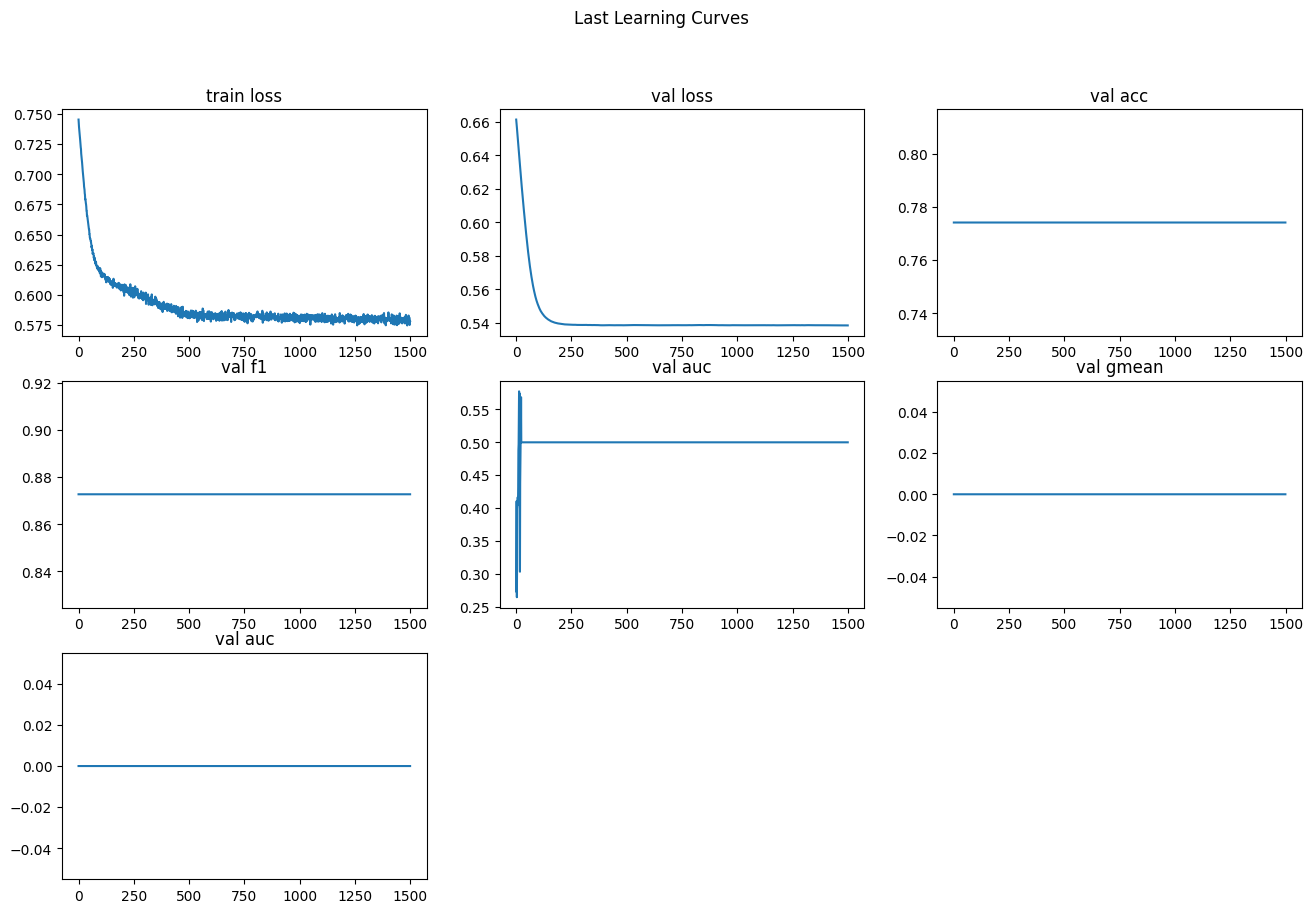

In [80]:
plt.figure(figsize=(16,10))

plt.subplot(331)
plt.plot(loss_buf)
plt.title("train loss")

plt.subplot(332)
plt.plot(val_loss_buf)
plt.title("val loss")

plt.subplot(333)
plt.plot(val_acc_buf)
plt.title("val acc")

plt.subplot(334)
plt.plot(val_f1_buf)
plt.title("val f1")

plt.subplot(335)
plt.plot(val_auc_buf)
plt.title("val auc")

plt.subplot(336)
plt.plot(val_gmean_buf)
plt.title("val gmean")

plt.subplot(337)
plt.plot(val_mcc_buf)
plt.title("val auc")

plt.suptitle("Last Learning Curves")
plt.show()

In [81]:
val_acc_mean = []
val_f1_mean = []
val_auc_mean = []
val_gmean_mean = []
val_mcc_mean = []

for i in range(10):
    
    val_acc_i = np.load("./results/CoV-AbDab/{}/val_acc_{}_best.npy".format(model_name, i))
    val_acc_mean.append(val_acc_i)
    
    val_f1_i = np.load("./results/CoV-AbDab/{}/val_f1_{}_best.npy".format(model_name, i))
    val_f1_mean.append(val_f1_i)
    
    val_auc_i = np.load("./results/CoV-AbDab/{}/val_auc_{}_best.npy".format(model_name, i))
    val_auc_mean.append(val_auc_i)
    
    val_gmean_i = np.load("./results/CoV-AbDab/{}/val_gmean_{}_best.npy".format(model_name, i))
    val_gmean_mean.append(val_gmean_i)
    
    val_mcc_i = np.load("./results/CoV-AbDab/{}/val_mcc_{}_best.npy".format(model_name, i))
    val_mcc_mean.append(val_mcc_i)
    
print("model: {}".format(model_name))
print("val acc mean: ", np.mean(val_acc_mean))
print("val f1 mean: ", np.mean(val_f1_mean))
print("val auc mean: ", np.mean(val_auc_mean))
print("val gmean mean: ", np.mean(val_gmean_mean))
print("val mcc mean: ", np.mean(val_mcc_mean))

model: SetCoAttnTransformer_ft_pairPreTrain
val acc mean:  0.735483870967742
val f1 mean:  0.8428165297819017
val auc mean:  0.5
val gmean mean:  0.0
val mcc mean:  0.0


In [ ]:
model: SetCoAttnTransformer_ft (L2 pre-train + fine-tune)
val acc mean:  0.7483870967741936
val f1 mean:  0.8468449123165905
val auc mean:  0.6663944794903874
val gmean mean:  0.2285749110787934
val mcc mean:  0.14789235808005177
    
array([[ 24,  58],
       [ 59, 169]])



model: SetCoAttnTransformer_ft_pairPreTrain

val acc mean:  0.735483870967742
val f1 mean:  0.8428165297819017
val auc mean:  0.5002100840336134
val gmean mean:  0.0
val mcc mean:  0.0
    
array([[  0,  82],
       [  0, 228]])

new dataset: augment negative samples to neg:pos=1:1


new dataset - masonscnn

model: masonscnn
val acc mean:  0.5609756097560976
val f1 mean:  0.7080969748642163
val auc mean:  0.5115618347865623
val gmean mean:  0.1176976534230973
val mcc mean:  0.05414104210725135
    
array([[ 48, 135],
       [ 50, 177]])



new dataset - masonscnn finetune

val acc mean:  0.5560975609756099
val f1 mean:  0.66096776615656
val auc mean:  0.5405112851806215
val gmean mean:  0.45399814531300964
val mcc mean:  0.07182380633434679
    
array([[ 84,  99],
       [ 92, 135]])


new dataset - masonscnn finetune FE Fixed

val acc mean:  0.5414634146341464
val f1 mean:  0.6631533886842206
val auc mean:  0.5499714003821219
val gmean mean:  0.3471025090442392
val mcc mean:  -0.008071772479411338

model: PESI

1. de novo
- val acc mean:  0.7548387096774194
- val f1 mean:  0.8472360344258647
- val auc mean:  0.6364248905399801
- val gmean mean:  0.12137665014671031
- val mcc mean:  0.06637028519834769


- val acc mean:  0.7451612903225807
- val f1 mean:  0.8450983571639433
- val auc mean:  0.5999908666213013
- val gmean mean:  0.1544552971674015
- val mcc mean:  0.0980278804259509

2. fine-tune

fixed Frame/Set feature extractor
- val acc mean:  0.735483870967742
- val f1 mean:  0.8428165297819017
- val auc mean:  0.5784537830739878
- val gmean mean:  0.0
- val mcc mean:  0.0

L2 + pre-train
- val acc mean:  0.6129032258064516
- val f1 mean:  0.7267589316962282
- val auc mean:  0.5019817458756078
- val gmean mean:  0.46310214588198306
- val mcc mean:  0.03777970650972913

EnsembleModel1

1. de novo

- val acc mean:  0.7258064516129032
- val f1 mean:  0.8357809829448485
- val auc mean:  0.5863614324010744
- val gmean mean:  0.04364357804719847
- val mcc mean:  -0.00243360941090478


model: EnsembleModel1 (based on DeepAAI hyperparameters)
- val acc mean:  0.735483870967742
- val f1 mean:  0.8426296329094451
- val auc mean:  0.576874495354035
- val gmean mean:  0.026726124191242435
- val mcc mean:  0.016785362070740578


model: EnsembleModel1 (based on DeepAAI hyperparameters) + L2 loss
- val acc mean:  0.735483870967742
- val f1 mean:  0.8428165297819017
- val auc mean:  0.6850925941066606
- val gmean mean:  0.0
- val mcc mean:  0.0


2. finetune

model: EnsembleModel1 (based on DeepAAI hyperparameters) + L2 loss
- val acc mean:  0.7258064516129032
- val f1 mean:  0.8368535348629104
- val auc mean:  0.6183667442248005
- val gmean mean:  0.13486832980505137
- val mcc mean:  0.05979789537418943

EnsembleModel

1. de novo

- val acc mean:  0.7225806451612903
- val f1 mean:  0.80938251651044
- val auc mean:  0.6277278343991899
- val gmean mean:  0.20839957350649357
- val mcc mean:  0.1381022811013694

2. finetune

- val acc mean:  0.7451612903225807
- val f1 mean:  0.8468587022064271
- val auc mean:  0.5173764489275998
- val gmean mean:  0.09929549764864425
- val mcc mean:  0.07493838512158786

MasonsCNN
1. de novo
- val acc mean:  0.735483870967742
- val f1 mean:  0.8428165297819017
- val auc mean:  0.5409950281318567

flipping
- val acc mean:  0.735483870967742
- val f1 mean:  0.8427516133925679
- val auc mean:  0.5455146192256166

0209
- val acc mean:  0.732258064516129
- val f1 mean:  0.8411225407108635
- val auc mean:  0.5413395687858604
- val gmean mean:  0.0
- val mcc mean:  -0.003333333333333333

2. finetune
- val acc mean:  0.7193548387096775
- val f1 mean:  0.8280684455906437
- val auc mean:  0.5564490021203576
- val gmean mean:  0.1475625995769564
- val mcc mean:  0.04446577910427487


Feature Extractor fixed
- val acc mean:  0.7322580645161291
- val f1 mean:  0.8338451090661441
- val auc mean:  0.634319673790262
- val gmean mean:  0.24199404771340785
- val mcc mean:  0.12252410865664765

0216
- val acc mean:  0.7322580645161291
- val f1 mean:  0.834695438627144
- val auc mean:  0.6693377090371975
- val gmean mean:  0.2087328313765909
- val mcc mean:  0.11147883124012761

use_pair fine tune
- val acc mean:  0.5585365853658537
- val f1 mean:  0.6448178293218522
- val auc mean:  0.5488570789936047
- val gmean mean:  0.2955272032441777
- val mcc mean:  0.04813999236891568

BiLSTM

1. De novo
- val acc mean:  0.7064516129032258
- val f1 mean:  0.819065850000514
- val auc mean:  0.44001247005339084


- val acc mean:  0.7193548387096774
- val f1 mean:  0.8286013119221826
- val auc mean:  0.5272626716846667
- val gmean mean:  0.08176287840460057
- val mcc mean:  0.00657602704451053

2. Finetune - full
- val acc mean:  0.2838709677419355
- val f1 mean:  0.06804597701149426
- val auc mean:  0.524349864826847
- val gmean mean:  0.08231242234049345
- val mcc mean:  -0.003441800331963846

FE Fixed
- val acc mean:  0.735483870967742
- val f1 mean:  0.8428165297819017
- val auc mean:  0.5305428632180551
- val gmean mean:  0.0
- val mcc mean:  0.0

0216
- val acc mean:  0.735483870967742
- val f1 mean:  0.8428165297819017
- val auc mean:  0.5296878848630767
- val gmean mean:  0.0
- val mcc mean:  0.0


model: lstm_ft_pairPreTrain
- val acc mean:  0.735483870967742
- val f1 mean:  0.8428165297819017
- val auc mean:  0.5695255347096778
- val gmean mean:  0.0
- val mcc mean:  0.0

InteractTransformer

1. De novo
- val acc mean:  0.7419354838709677
- val f1 mean:  0.8460928830582551
- val auc mean:  0.5697268280171094

left/right flipping
- val acc mean:  0.6741935483870967
- val f1 mean:  0.7933415428025153
- val auc mean:  0.5941512822216147

0209
- val acc mean:  0.7387096774193548
- val f1 mean:  0.8444456024636061
- val auc mean:  0.5559159858328655
- val gmean mean:  0.0447213595499958
- val mcc mean:  0.04163331998932266

2. Finetune - full
- val acc mean:  0.7387096774193549
- val f1 mean:  0.837479640502948
- val auc mean:  0.5373362548221883
- val gmean mean:  0.11956972115904681
- val mcc mean:  0.05274808166803078

FE Fixed
- val acc mean:  0.7096774193548387
- val f1 mean:  0.8192963769848788
- val auc mean:  0.5437163596562574
- val gmean mean:  0.18894861461152904
- val mcc mean:  0.043908331255973564

InteractCoattnTransformer

1. De novo

coattn after embed
- val acc mean:  0.7322580645161291
- val f1 mean:  0.8384620373723942
- val auc mean:  0.5792465999473672

coattn after transformer
- val acc mean:  0.7290322580645162
- val f1 mean:  0.8389562234502067
- val auc mean:  0.5215266408783032

two coattn
dropout0.3
- val acc mean:  0.6645161290322581
- val f1 mean:  0.7577206864384995
- val auc mean:  0.4894495640761625

dropout0.5
- val acc mean:  0.7032258064516129
- val f1 mean:  0.8148800008196817
- val auc mean:  0.5601084965049159

0209
- val acc mean:  0.7064516129032258
- val f1 mean:  0.8065533962654705
- val auc mean:  0.53074342679202
- val gmean mean:  0.08783456377261516
- val mcc mean:  -0.03089614519177042

0210
- val acc mean:  0.7290322580645162
- val f1 mean:  0.8333675745553654
- val auc mean:  0.5629656307034825
- val gmean mean:  0.19967351371222142
- val mcc mean:  0.08859651752472261

2. Finetune
- val acc mean:  0.7419354838709677
- val f1 mean:  0.8295161019309971
- val auc mean:  0.6776508588030327
- val gmean mean:  0.41048764045233976
- val mcc mean:  0.23726058068617323

0210
- val acc mean:  0.7032258064516129
- val f1 mean:  0.7529802738432863
- val auc mean:  0.5843740140223517
- val gmean mean:  0.11863970769085672
- val mcc mean:  -0.02494321880367

use final model rather than best
- val acc mean:  0.5903225806451613
- val f1 mean:  0.6981662591680293
- val auc mean:  0.5202095768681446
- val gmean mean:  0.43529770732374456
- val mcc mean:  0.035015078636667016

FE Fixed FT
- val acc mean:  0.735483870967742
- val f1 mean:  0.8323679177395693
- val auc mean:  0.5757738855347552
- val gmean mean:  0.1772604277248653
- val mcc mean:  0.051826896161838866

model: InteractCoAttnTransformer_ft_pairPreTrain
- val acc mean:  0.732258064516129
- val f1 mean:  0.8411225407108635
- val auc mean:  0.47004088196543437
- val gmean mean:  0.0
- val mcc mean:  -0.003333333333333333

SetModel
1. de novo

dropout0.3
- val acc mean:  0.7258064516129032
- val f1 mean:  0.8364886835455663
- val auc mean:  0.6504661560377674

dropout0.5 + CoAttnSkipConnection
- val acc mean:  0.7225806451612904
- val f1 mean:  0.7678373423027144
- val auc mean:  0.649160663150433

dropout0.3 + CoAttn ahead
- val acc mean:  0.7290322580645162
- val f1 mean:  0.8331830945361233
- val auc mean:  0.6217202631128462

dropout0.3 + CoAttn ahead + left/right flipping
- val acc mean:  0.7548387096774194
- val f1 mean:  0.8390957431282627
- val auc mean:  0.566890947358978

0209
- val acc mean:  0.7419354838709677
- val f1 mean:  0.8385743405122875
- val auc mean:  0.646844740510981
- val gmean mean:  0.3499641605118257
- val mcc mean:  0.16989948824073764

2. finetune
- val acc mean:  0.6548387096774194
- val f1 mean:  0.7614356955971864
- val auc mean:  0.5850305370957545
- val gmean mean:  0.4690008572794017
- val mcc mean:  0.09590317756829693

FX Fixed FT
- val acc mean:  0.7290322580645162
- val f1 mean:  0.8304804775765957
- val auc mean:  0.6118961087221957
- val gmean mean:  0.325372891932986
- val mcc mean:  0.1376242188288149

SetCoAttnModel

1. de novo
- val acc mean:  0.7129032258064516
- val f1 mean:  0.8283774426716478
- val auc mean:  0.6031828529526739
- val gmean mean:  0.11381713711118394
- val mcc mean:  0.05107581130651245

2. finetune
- val acc mean:  0.735483870967742
- val f1 mean:  0.8255950018544915
- val auc mean:  0.5836535310384415
- val gmean mean:  0.19683955427239194
- val mcc mean:  0.060401168945660236

FE Fixed FT
- val acc mean:  0.7451612903225807
- val f1 mean:  0.840554625019997
- val auc mean:  0.5332801356075013
- val gmean mean:  0.06351073488299558
- val mcc mean:  0.02796710598995068

SetTransformer

1. de novo
- val acc mean:  0.7387096774193549
- val f1 mean:  0.8361401746369017
- val auc mean:  0.6567989579332291
- val gmean mean:  0.22237169691743341
- val mcc mean:  0.11689544381896444

bi-tower
- val acc mean:  0.7322580645161291
- val f1 mean:  0.8304782251291887
- val auc mean:  0.6367931102713712
- val gmean mean:  0.2632115309684307
- val mcc mean:  0.12791443324565496

2. finetune
- val acc mean:  0.7096774193548387
- val f1 mean:  0.8221135340407786
- val auc mean:  0.6275436241791741
- val gmean mean:  0.2348251415923123
- val mcc mean:  0.09602992408332747


FE Fixed FT
- val acc mean:  0.735483870967742
- val f1 mean:  0.8428165297819017
- val auc mean:  0.5436637051496387
- val gmean mean:  0.0
- val mcc mean:  0.0

SetCoAttnTransformer

1. de novo
- val acc mean:  0.7290322580645162
- val f1 mean:  0.8371426812951388
- val auc mean:  0.6973226134479332
- val gmean mean:  0.08283199089454711
- val mcc mean:  0.03612682646386498

2. finetune
- val acc mean:  0.7548387096774194
- val f1 mean:  0.8381884843645546
- val auc mean:  0.7171163618989707
- val gmean mean:  0.6158503375322386
- val mcc mean:  0.34239057721353133

- val acc mean:  0.7451612903225807
- val f1 mean:  0.8258364526202552
- val auc mean:  0.667494606842433
- val gmean mean:  0.598600578762371
- val mcc mean:  0.327257546356814

FE Fixed FT
- val acc mean:  0.7387096774193549
- val f1 mean:  0.839985269566902
- val auc mean:  0.641870172027461
- val gmean mean:  0.15255182247968152
- val mcc mean:  0.08206384239742148

model: SetCoAttnTransformer_ft_pairPreTrain
- val acc mean:  0.735483870967742
- val f1 mean:  0.8428165297819017
- val auc mean:  0.5
- val gmean mean:  0.0
- val mcc mean:  0.0

InteractTransformerLSTM
1. de novo
- ?

2. finetune
- ?

3. finetune - full
- ?

InteractTransformerLSTM + CoAttn
1. de novo
- ?

FTransformer + CoATtn
1. de novo

1layer + kmer5
- val acc mean:  0.6774193548387096
- val f1 mean:  0.8076923076923077
- val auc mean:  0.48571428571428565

2layers + kmer5
- val acc mean:  0.6774193548387096
- val f1 mean:  0.8076923076923077
- val auc mean:  0.6238095238095238

2layers + kmer3
- val acc mean:  0.6774193548387096
- val f1 mean:  0.8076923076923077
- val auc mean:  0.6428571428571429

2layers + kmer4
- val acc mean:  0.6774193548387096
- val f1 mean:  0.8076923076923077
- val auc mean:  0.3476190476190476

2layers + kmer3 + lr3e-5
- val acc mean:  0.6451612903225806
- val f1 mean:  0.7755102040816326
- val auc mean:  0.3952380952380952

FTransformer
1. de novo

2layers + kmer3
- val acc mean:  0.6774193548387096
- val f1 mean:  0.8076923076923077
- val auc mean:  0.5285714285714286

2layers + kmer5
- val acc mean:  0.6774193548387096
- val f1 mean:  0.8076923076923077
- val auc mean:  0.5619047619047619